In [37]:
!pip install --upgrade scikit-learn imbalanced-learn pymongo python-dotenv mlxtend joblib

Defaulting to user installation because normal site-packages is not writeable
  Using cached mlxtend-0.24.0-py3-none-any.whl.metadata (7.3 kB)
INFO: pip is looking at multiple versions of mlxtend to determine which version is compatible with other requirements. This could take a while.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import numpy as np
import os
import joblib
from dotenv import load_dotenv

from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from imblearn.over_sampling import SMOTE

# ML Models
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           silhouette_score, roc_auc_score)

# Load environment variables
load_dotenv()

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [39]:
# Load data from local CSV file
df = pd.read_csv("Dataset/credit_card_fraud_10k.csv")
df.head()

transaction_id  amount  transaction_hour merchant_category  \
0               1   84.47                22       Electronics   
1               2  541.82                 3            Travel   
2               3  237.01                17           Grocery   
3               4  164.33                 4           Grocery   
4               5   30.53                15              Food   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  is_fraud  
0                  3              40         0  
1                  1              64         0  
2                  1              61         0  
3                  3              34         0  
4                  0              44         0

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       10000 non-null  int64  
 1   amount               10000 non-null  float64
 2   transaction_hour     10000 non-null  int64  
 3   merchant_category    10000 non-null  object 
 4   foreign_transaction  10000 non-null  int64  
 5   location_mismatch    10000 non-null  int64  
 6   device_trust_score   10000 non-null  int64  
 7   velocity_last_24h    10000 non-null  int64  
 8   cardholder_age       10000 non-null  int64  
 9   is_fraud             10000 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [41]:
df.isnull().sum()

transaction_id         0
amount                 0
transaction_hour       0
merchant_category      0
foreign_transaction    0
location_mismatch      0
device_trust_score     0
velocity_last_24h      0
cardholder_age         0
is_fraud               0
dtype: int64

# Dataset Undertsanding (Exploration)
## We decided to do the following to check for imbalance and have better undertsanding of feature behavior:
1. View basic statistics (mean, min, max, std).
2. Count fraud vs non-fraud
3. Visualize imbalance using bar chart or pie chart.

In [42]:
summary = df.describe()
display(summary)

transaction_id        amount  transaction_hour  foreign_transaction  \
count     10000.00000  10000.000000      10000.000000         10000.000000   
mean       5000.50000    175.949849         11.593300             0.097800   
std        2886.89568    175.392827          6.922708             0.297059   
min           1.00000      0.000000          0.000000             0.000000   
25%        2500.75000     50.905000          6.000000             0.000000   
50%        5000.50000    122.095000         12.000000             0.000000   
75%        7500.25000    242.480000         18.000000             0.000000   
max       10000.00000   1471.040000         23.000000             1.000000   

       location_mismatch  device_trust_score  velocity_last_24h  \
count       10000.000000        10000.000000       10000.000000   
mean            0.085700           61.798900           2.008900   
std             0.279935           21.487053           1.432559   
min             0.000000           25.000000           0.000000   
25%             0.000000           43.000000           1.000000   
50%             0.000000           62.000000           2.000000   
75%             0.000000           80.000000           3.000000   
max             1.000000           99.000000           9.000000   

       cardholder_age      is_fraud  
count    10000.000000  10000.000000  
mean        43.468700      0.015100  
std         14.979147      0.121957  
min         18.000000      0.000000  
25%         30.000000      0.000000  
50%         44.000000      0.000000  
75%         56.000000      0.000000  
max         69.000000      1.000000

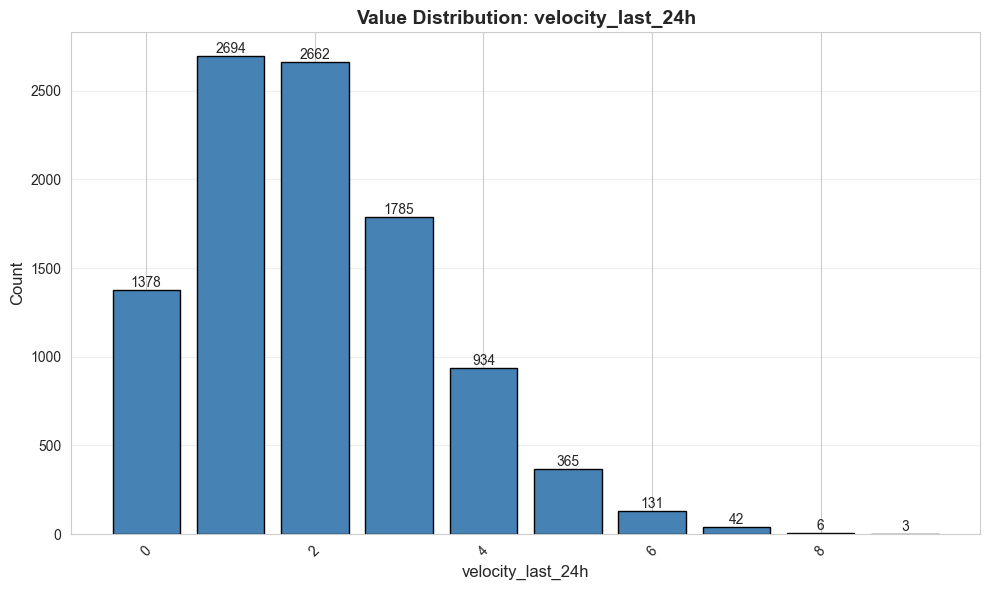

In [43]:
import matplotlib.pyplot as plt

feature = 'velocity_last_24h'

value_counts = df[feature].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values, color='steelblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel(feature, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Value Distribution: {feature}', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [44]:
print(df['is_fraud'].value_counts())

is_fraud
0    9849
1     151
Name: count, dtype: int64


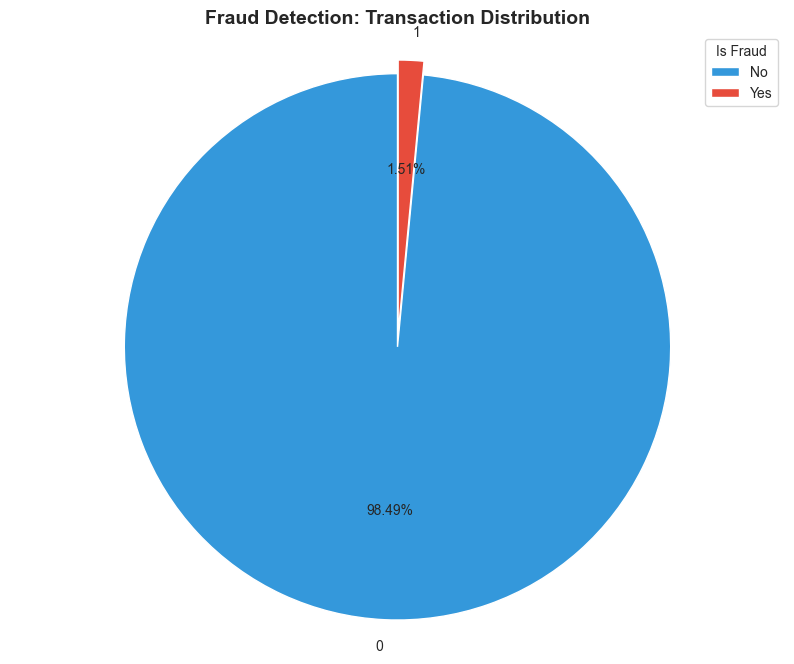

In [45]:
fraud_counts = df['is_fraud'].value_counts()

plt.figure(figsize=(10, 8))
explode = (0.05, 0)

plt.pie(fraud_counts.values, 
        labels=fraud_counts.index,
        autopct='%1.2f%%',
        startangle=90,
        explode=explode,
        shadow=False,
        colors=['#3498db', '#e74c3c'])

plt.title('Fraud Detection: Transaction Distribution', fontsize=14, fontweight='bold')
plt.legend(['No','Yes'], title="Is Fraud", loc="best")
plt.axis('equal')
plt.show()

# Data Preprocessing

## 3.1 Data Cleaning

### Steps:

* Check for missing (null) values in every feature.
* Check for duplicate records and remove them.
* Validate data ranges (e.g. negative transaction amount).

In [46]:
df.isna().count()

transaction_id         10000
amount                 10000
transaction_hour       10000
merchant_category      10000
foreign_transaction    10000
location_mismatch      10000
device_trust_score     10000
velocity_last_24h      10000
cardholder_age         10000
is_fraud               10000
dtype: int64

In [47]:
duplicate = df[df.duplicated()]

display(duplicate)

Empty DataFrame
Columns: [transaction_id, amount, transaction_hour, merchant_category, foreign_transaction, location_mismatch, device_trust_score, velocity_last_24h, cardholder_age, is_fraud]
Index: []

In [48]:
df['merchant_category'].value_counts()

merchant_category
Food           2093
Clothing       2050
Travel         1990
Grocery        1944
Electronics    1923
Name: count, dtype: int64

In [49]:
df['velocity_last_24h'].value_counts()

velocity_last_24h
1    2694
2    2662
3    1785
0    1378
4     934
5     365
6     131
7      42
8       6
9       3
Name: count, dtype: int64

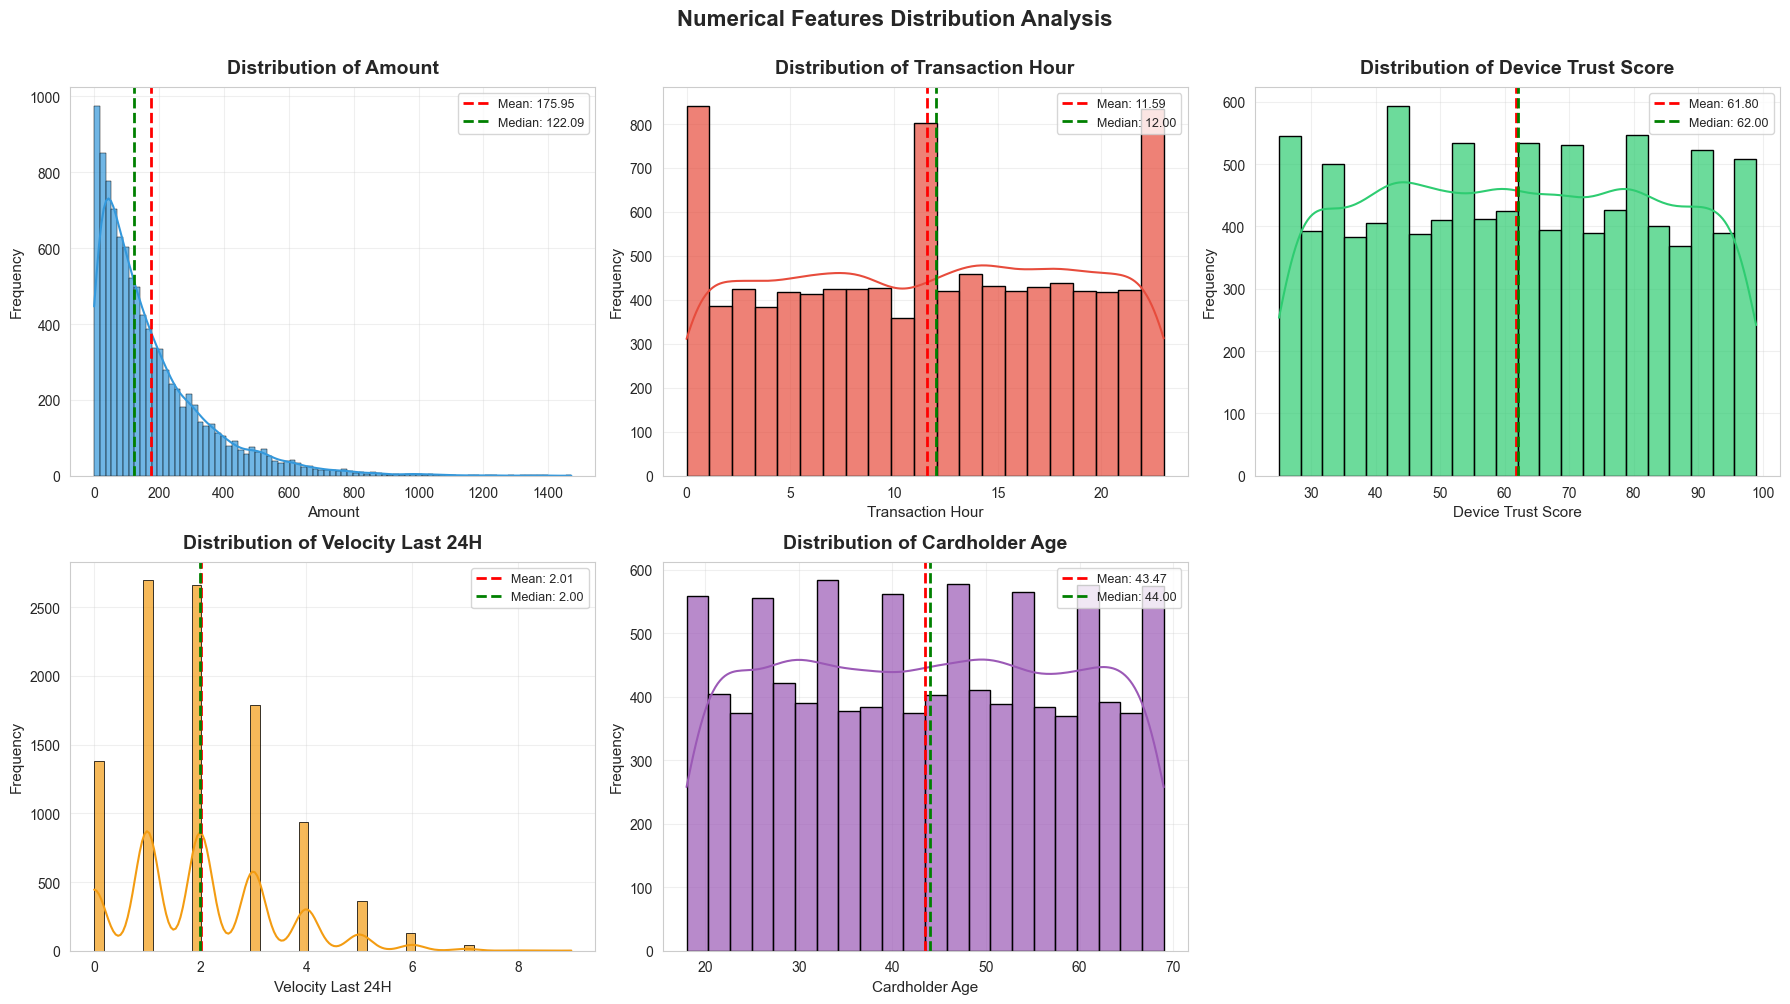

In [50]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

num_cols = [
    "amount", "transaction_hour", "device_trust_score",
    "velocity_last_24h", "cardholder_age"
]

# Create subplots - all in one figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Define a nice color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, col in enumerate(num_cols):
    # Create histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[idx], 
                 color=colors[idx], edgecolor='black', alpha=0.7)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    
    axes[idx].axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {median_val:.2f}')
    
    # Styling
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', 
                        fontsize=14, fontweight='bold', pad=10)
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.suptitle('Numerical Features Distribution Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3.2 Data Transformation

### Steps:

* Normalize transaction amount.
* Encode Merchant Category.

In [51]:
df['amount_minmax'] = df['amount'].copy()

# Apply Min-Max scaling
scaler = MinMaxScaler()
df['amount_minmax'] = scaler.fit_transform(df[['amount']])

print("Original amount stats:")
print(df['amount'].describe())
print("\nNormalized amount stats:")
print(df['amount_minmax'].describe())

Original amount stats:
count    10000.000000
mean       175.949849
std        175.392827
min          0.000000
25%         50.905000
50%        122.095000
75%        242.480000
max       1471.040000
Name: amount, dtype: float64

Normalized amount stats:
count    10000.000000
mean         0.119609
std          0.119230
min          0.000000
25%          0.034605
50%          0.082999
75%          0.164836
max          1.000000
Name: amount_minmax, dtype: float64


In [52]:
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['merchant_category'])

print("Original vs Encoded:")
print(df[['merchant_category', 'category_encoded']].head(10))
print("\nMapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

Original vs Encoded:
  merchant_category  category_encoded
0       Electronics                 1
1            Travel                 4
2           Grocery                 3
3           Grocery                 3
4              Food                 2
5          Clothing                 0
6            Travel                 4
7       Electronics                 1
8           Grocery                 3
9           Grocery                 3

Mapping:
{'Clothing': 0, 'Electronics': 1, 'Food': 2, 'Grocery': 3, 'Travel': 4}


In [53]:
df.head()

transaction_id  amount  transaction_hour merchant_category  \
0               1   84.47                22       Electronics   
1               2  541.82                 3            Travel   
2               3  237.01                17           Grocery   
3               4  164.33                 4           Grocery   
4               5   30.53                15              Food   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  is_fraud  amount_minmax  \
0                  3              40         0       0.057422   
1                  1              64         0       0.368324   
2                  1              61         0       0.161117   
3                  3              34         0       0.111710   
4                  0              44         0       0.020754   

   category_encoded  
0                 1  
1                 4  
2                 3  
3                 3  
4                 2

In [54]:
df['amount'] = df['amount_minmax']
df['merchant_category'] = df['category_encoded']
df.drop(columns=['merchant_category','amount'])

transaction_id  transaction_hour  foreign_transaction  \
0                  1                22                    0   
1                  2                 3                    1   
2                  3                17                    0   
3                  4                 4                    0   
4                  5                15                    0   
...              ...               ...                  ...   
9995            9996                22                    0   
9996            9997                 5                    0   
9997            9998                21                    0   
9998            9999                 2                    0   
9999           10000                 2                    0   

      location_mismatch  device_trust_score  velocity_last_24h  \
0                     0                  66                  3   
1                     0                  87                  1   
2                     0                  49                  1   
3                     1                  72                  3   
4                     0                  79                  0   
...                 ...                 ...                ...   
9995                  0                  99                  4   
9996                  0                  70                  3   
9997                  0                  44                  2   
9998                  0                  38                  0   
9999                  0                  38                  0   

      cardholder_age  is_fraud  amount_minmax  category_encoded  
0                 40         0       0.057422                 1  
1                 64         0       0.368324                 4  
2                 61         0       0.161117                 3  
3                 34         0       0.111710                 3  
4                 44         0       0.020754                 2  
...              ...       ...            ...               ...  
9995              37         0       0.238546                 2  
9996              25         0       0.278742                 0  
9997              45         0       0.358760                 1  
9998              37         0       0.061997                 1  
9999              66         0       0.029952                 0  

[10000 rows x 10 columns]

In [55]:
df.head()

transaction_id    amount  transaction_hour  merchant_category  \
0               1  0.057422                22                  1   
1               2  0.368324                 3                  4   
2               3  0.161117                17                  3   
3               4  0.111710                 4                  3   
4               5  0.020754                15                  2   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  is_fraud  amount_minmax  \
0                  3              40         0       0.057422   
1                  1              64         0       0.368324   
2                  1              61         0       0.161117   
3                  3              34         0       0.111710   
4                  0              44         0       0.020754   

   category_encoded  
0                 1  
1                 4  
2                 3  
3                 3  
4                 2

## 3.3 Data Reduction

### Steps:

* Identify irrelevant or redundant features.
* Remove features with very low variance.
* Apply feature selection techniques: Correlation analysis

In [56]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [57]:
X.head()

transaction_id    amount  transaction_hour  merchant_category  \
0               1  0.057422                22                  1   
1               2  0.368324                 3                  4   
2               3  0.161117                17                  3   
3               4  0.111710                 4                  3   
4               5  0.020754                15                  2   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  amount_minmax  category_encoded  
0                  3              40       0.057422                 1  
1                  1              64       0.368324                 4  
2                  1              61       0.161117                 3  
3                  3              34       0.111710                 3  
4                  0              44       0.020754                 2

In [58]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,   # 0.25 × 0.8 = 0.2
    stratify=y_temp,
    random_state=42
)


In [59]:
irrelevant_cols = [
    col for col in X_train.columns
    if 'id' in col.lower() or 'index' in col.lower()
]

X_train = X_train.drop(columns=irrelevant_cols)

In [60]:
X_train.head()

amount  transaction_hour  merchant_category  foreign_transaction  \
5635  0.007179                 9                  0                    0   
4007  0.064240                 9                  2                    0   
1011  0.537851                 6                  4                    0   
8687  0.011128                18                  3                    0   
3450  0.074220                 6                  3                    0   

      location_mismatch  device_trust_score  velocity_last_24h  \
5635                  1                  93                  1   
4007                  1                  64                  2   
1011                  1                  48                  4   
8687                  0                  52                  3   
3450                  0                  87                  2   

      cardholder_age  amount_minmax  category_encoded  
5635              48       0.007179                 0  
4007              50       0.064240                 2  
1011              25       0.537851                 4  
8687              46       0.011128                 3  
3450              52       0.074220                 3

In [61]:
vt = VarianceThreshold(threshold=0)
X_vt = vt.fit_transform(X_train)

kept_features = X_train.columns[vt.get_support()]
X_train = pd.DataFrame(X_vt, columns=kept_features)

In [62]:
X_train.head()

amount  transaction_hour  merchant_category  foreign_transaction  \
0  0.007179               9.0                0.0                  0.0   
1  0.064240               9.0                2.0                  0.0   
2  0.537851               6.0                4.0                  0.0   
3  0.011128              18.0                3.0                  0.0   
4  0.074220               6.0                3.0                  0.0   

   location_mismatch  device_trust_score  velocity_last_24h  cardholder_age  \
0                1.0                93.0                1.0            48.0   
1                1.0                64.0                2.0            50.0   
2                1.0                48.0                4.0            25.0   
3                0.0                52.0                3.0            46.0   
4                0.0                87.0                2.0            52.0   

   amount_minmax  category_encoded  
0       0.007179               0.0  
1       0.064240               2.0  
2       0.537851               4.0  
3       0.011128               3.0  
4       0.074220               3.0

In [63]:
corr_matrix = X_train.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns
    if any(upper[column] > 0.9)
]

X_train = X_train.drop(columns=to_drop)

In [64]:
X_train.head()

amount  transaction_hour  merchant_category  foreign_transaction  \
0  0.007179               9.0                0.0                  0.0   
1  0.064240               9.0                2.0                  0.0   
2  0.537851               6.0                4.0                  0.0   
3  0.011128              18.0                3.0                  0.0   
4  0.074220               6.0                3.0                  0.0   

   location_mismatch  device_trust_score  velocity_last_24h  cardholder_age  
0                1.0                93.0                1.0            48.0  
1                1.0                64.0                2.0            50.0  
2                1.0                48.0                4.0            25.0  
3                0.0                52.0                3.0            46.0  
4                0.0                87.0                2.0            52.0

## Handling Class Imbalance

### Steps:

* Verify imbalance ratio again.
* Choose imbalance technique: Oversampling (e.g. SMOTE)

In [65]:
print(y_train.value_counts())

is_fraud
0    6303
1      97
Name: count, dtype: int64


In [66]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts()

/Users/hamdi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


is_fraud
0    6303
1    6303
Name: count, dtype: int64

# Big Data Component-MongoDB
## Why MongoDB?
* Handles large transaction volumes
* Schema-flexible (different transaction attributes)
* Fast filtering & querying (important for fraud analysis)

## Transaction Document Structure

Each transaction = one document

In [67]:
!pip install pymongo

Defaulting to user installation because normal site-packages is not writeable


## Connect to MongoDB & Load dataset (CSV → MongoDB)

In [68]:
from pymongo import MongoClient
from pymongo.server_api import ServerApi

In [69]:
# Load MongoDB credentials from .env
MONGODB_USERNAME = os.getenv('MONGODB_USERNAME')
MONGODB_PASSWORD = os.getenv('MONGODB_PASSWORD')
MONGODB_CLUSTER = os.getenv('MONGODB_CLUSTER')
MONGODB_DATABASE = os.getenv('MONGODB_DATABASE')
MONGODB_APP_NAME = os.getenv('MONGODB_APP_NAME')

# Determine protocol (mongodb+srv:// for Atlas, mongodb:// for local/standard)
protocol = "mongodb+srv"
if ":" in MONGODB_CLUSTER or "localhost" in MONGODB_CLUSTER:
    protocol = "mongodb"

# Construct URI based on protocol and presence of credentials
if protocol == "mongodb+srv":
    uri = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/?appName={MONGODB_APP_NAME}"
else:
    if MONGODB_USERNAME and MONGODB_PASSWORD:
        # For local MongoDB, we usually need to specify authSource=admin
        uri = f"mongodb://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/?authSource=admin&appName={MONGODB_APP_NAME}"
    else:
        uri = f"mongodb://{MONGODB_CLUSTER}/?appName={MONGODB_APP_NAME}"

# Create a new client and connect to the server
try:
    if protocol == "mongodb+srv":
        client = MongoClient(uri, server_api=ServerApi('1'))
    else:
        client = MongoClient(uri)
    
    # Send a ping to confirm a successful connection
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(f"Connection failed: {e}")
    print("If using local MongoDB, ensure the service is running: brew services start mongodb-community@7.0")


Pinged your deployment. You successfully connected to MongoDB!


In [70]:
# Connect to database and collection using .env variables
protocol = "mongodb+srv"
if ":" in MONGODB_CLUSTER or "localhost" in MONGODB_CLUSTER:
    protocol = "mongodb"

if protocol == "mongodb+srv":
    uri_full = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?retryWrites=true&w=majority"
else:
    if MONGODB_USERNAME and MONGODB_PASSWORD:
        uri_full = f"mongodb://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?authSource=admin"
    else:
        uri_full = f"mongodb://{MONGODB_CLUSTER}/{MONGODB_DATABASE}"

client = MongoClient(uri_full)
db_big_data = client[MONGODB_DATABASE]
collection = db_big_data[os.getenv('MONGODB_COLLECTION', 'transactions')]

print(f"Connected to database: {MONGODB_DATABASE}")


Connected to database: fraud_detection_db


In [71]:
# Load data from MongoDB collection
df_from_mongo = pd.DataFrame(list(collection.find()))

# If _id column exists from MongoDB, drop it
if '_id' in df_from_mongo.columns:
    df_from_mongo = df_from_mongo.drop('_id', axis=1)

print(f"Loaded {len(df_from_mongo)} records from MongoDB")
df_from_mongo.head()

Loaded 15758 records from MongoDB


amount  transaction_hour  merchant_category_encoded  foreign_transaction  \
0 -0.769681         -0.808005                   0.006996            -0.329244   
1 -0.677826         -0.808005                  -0.699651            -0.329244   
2 -0.750980         -1.674761                   0.713643            -0.329244   
3  1.259237          1.647805                  -1.406299            -0.329244   
4 -0.888449         -1.674761                   0.006996            -0.329244   

   location_mismatch  device_trust_score  velocity_last_24h  cardholder_age  \
0           3.266284            0.940199          -0.006213        0.502811   
1          -0.306158           -0.921480          -0.006213       -1.700362   
2          -0.306158           -1.666152          -0.006213       -1.233022   
3          -0.306158            1.638329          -0.704299       -0.632157   
4          -0.306158            1.359077          -0.704299       -1.032734   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0

In [72]:
# Prepare the CLEANED and BALANCED data for MongoDB insertion
# Combine X_train with y_train (these are already balanced from SMOTE)
df_balanced = X_train.copy()
df_balanced['is_fraud'] = y_train.values

# Add feature names back (these are scaled values)
# For MongoDB, let's store both the balanced training data AND original test data
print(f"Balanced training data shape: {df_balanced.shape}")
print(f"Class distribution: {df_balanced['is_fraud'].value_counts().to_dict()}")

# Convert to records for MongoDB
records_balanced = df_balanced.to_dict(orient="records")
print(f"Prepared {len(records_balanced)} balanced records for insertion.")


Balanced training data shape: (12606, 9)
Class distribution: {0: 6303, 1: 6303}
Prepared 12606 balanced records for insertion.


## Inserting csv into collection called "Transaction" in fraud_detection_db database on mongoDB

In [73]:
# Clear existing data and insert the balanced dataset
collection.delete_many({})  # Clear old data
result = collection.insert_many(records_balanced)
print(f"Inserted {len(result.inserted_ids)} balanced records into MongoDB")
print(f"Collection now has {collection.count_documents({})} documents")


Inserted 12606 balanced records into MongoDB
Collection now has 12606 documents


## Writing some Queries

### 4.1 Retrieve ALL fraud cases

In [74]:
fraud_cases = collection.find({"is_fraud": 1})

for case in fraud_cases:
    display(case)


{'_id': ObjectId('695434468a6a902754e0edfd'),
 'amount': 0.11692408092234065,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0efce'),
 'amount': 0.0407874700891886,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f00d'),
 'amount': 0.013500652599521426,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f021'),
 'amount': 0.16653524037415704,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f127'),
 'amount': 7.477702849684577e-05,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f1a3'),
 'amount': 0.06270393735044594,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 32.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f1aa'),
 'amount': 0.05057646291059387,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f1b1'),
 'amount': 0.5010468783989558,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f1ea'),
 'amount': 0.029020284968457686,
 'transaction_hour': 23.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 46.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f20e'),
 'amount': 0.011019414835762454,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 67.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f25f'),
 'amount': 0.4770706438981944,
 'transaction_hour': 2.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f284'),
 'amount': 0.05723161844681313,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f2b1'),
 'amount': 0.11957526647813792,
 'transaction_hour': 6.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f2dc'),
 'amount': 0.09160865782031759,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f3a8'),
 'amount': 0.22802235153360886,
 'transaction_hour': 20.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f3b3'),
 'amount': 0.014343593648031325,
 'transaction_hour': 3.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f42c'),
 'amount': 0.027327604959756363,
 'transaction_hour': 10.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f460'),
 'amount': 0.2728681748966717,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f49a'),
 'amount': 0.01987029584511638,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f4a7'),
 'amount': 0.009170382858385904,
 'transaction_hour': 5.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f4e1'),
 'amount': 0.27100554709593216,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f4e2'),
 'amount': 0.06055579725908201,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f4f3'),
 'amount': 0.7499388187948662,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f536'),
 'amount': 0.07327469001522732,
 'transaction_hour': 3.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f552'),
 'amount': 0.24815776593430497,
 'transaction_hour': 3.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 38.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f554'),
 'amount': 0.05102512508157494,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f592'),
 'amount': 0.6862831738090058,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f5ae'),
 'amount': 0.08558570807048074,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 45.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f5b7'),
 'amount': 0.09674787905155535,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 62.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f5ce'),
 'amount': 0.01327632151403089,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 40.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f634'),
 'amount': 0.01826598868827496,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f660'),
 'amount': 0.026708994996737002,
 'transaction_hour': 2.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f69c'),
 'amount': 0.00867413530563411,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f6e3'),
 'amount': 0.028925114204916245,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f6f4'),
 'amount': 0.04030481835979987,
 'transaction_hour': 17.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f71c'),
 'amount': 0.11683570807048074,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f74f'),
 'amount': 0.23392973678485968,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f7b6'),
 'amount': 0.027483956928431585,
 'transaction_hour': 11.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f7f8'),
 'amount': 0.13716146399825974,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f808'),
 'amount': 0.014268816619534478,
 'transaction_hour': 15.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 19.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f85b'),
 'amount': 0.04131090928866652,
 'transaction_hour': 3.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f892'),
 'amount': 0.023153687187296063,
 'transaction_hour': 23.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f8b5'),
 'amount': 0.023507178594735695,
 'transaction_hour': 4.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f90c'),
 'amount': 0.28376522732216664,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f9a1'),
 'amount': 0.04861866434631281,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0f9c7'),
 'amount': 0.3588209701979552,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fabc'),
 'amount': 0.2849140743963454,
 'transaction_hour': 8.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fadf'),
 'amount': 0.3205555253426147,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0faf5'),
 'amount': 0.0014003698063954754,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fb3d'),
 'amount': 0.062071731564063516,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 33.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fb41'),
 'amount': 0.0226642375462258,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 64.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fb4a'),
 'amount': 0.03234446378072656,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fb64'),
 'amount': 0.23687323254296277,
 'transaction_hour': 2.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 99.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fbfc'),
 'amount': 0.08302289536654339,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fc3a'),
 'amount': 0.008313845986512943,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fc56'),
 'amount': 0.704821078964542,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fcc9'),
 'amount': 0.2770556884924951,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fce6'),
 'amount': 0.0012372199260387209,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fd57'),
 'amount': 0.13943876441157277,
 'transaction_hour': 2.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fdb4'),
 'amount': 0.09563302153578421,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fdf6'),
 'amount': 0.08085436154013487,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fe24'),
 'amount': 0.07404285403524037,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 46.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fe3b'),
 'amount': 0.002882314552969328,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fe59'),
 'amount': 0.05666059386556449,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0fe9e'),
 'amount': 0.8056001196432455,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 50.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0feae'),
 'amount': 0.13381009353926474,
 'transaction_hour': 6.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 75.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0ff07'),
 'amount': 0.03902681096367196,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0ff17'),
 'amount': 0.1455704807483141,
 'transaction_hour': 23.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e0ffef'),
 'amount': 0.14776620622144876,
 'transaction_hour': 20.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1000a'),
 'amount': 0.18091962149227755,
 'transaction_hour': 8.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 68.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10046'),
 'amount': 0.07826435718947139,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e100a3'),
 'amount': 0.41311589079834676,
 'transaction_hour': 3.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e100a7'),
 'amount': 0.14771862083967804,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e100d1'),
 'amount': 0.4160185990863607,
 'transaction_hour': 13.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 53.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e100e3'),
 'amount': 0.17380220796171414,
 'transaction_hour': 19.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10125'),
 'amount': 0.33188084620404606,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1012e'),
 'amount': 0.16439389819447467,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10155'),
 'amount': 0.0872851859908636,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10162'),
 'amount': 0.026688601261692407,
 'transaction_hour': 11.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10198'),
 'amount': 0.15319093974331086,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10221'),
 'amount': 0.07170437241679356,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e102fc'),
 'amount': 0.06385278442462476,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 69.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e102fd'),
 'amount': 0.11847400478572982,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 48.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10325'),
 'amount': 0.646080324124429,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10330'),
 'amount': 0.28292908418533824,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10345'),
 'amount': 0.0932537524472482,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e103b3'),
 'amount': 0.6990428540352404,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10435'),
 'amount': 0.08046688057428758,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1047c'),
 'amount': 0.23307999782466826,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10494'),
 'amount': 0.061106428105286055,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10531'),
 'amount': 0.03191619534479008,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10556'),
 'amount': 0.5279666086578203,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1056f'),
 'amount': 0.01670246900152273,
 'transaction_hour': 9.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e105cb'),
 'amount': 0.0057170437241679355,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e105f3'),
 'amount': 0.015907113334783552,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 95.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10600'),
 'amount': 0.08091554274526865,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1065a'),
 'amount': 0.06557265608005221,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10661'),
 'amount': 0.23883482581836116,
 'transaction_hour': 3.0,
 'merchant_category': 2.8165578035965657,
 'foreign_transaction': 0.1834421964034345,
 'location_mismatch': 0.0,
 'device_trust_score': 30.183442196403433,
 'velocity_last_24h': 4.266231214386262,
 'cardholder_age': 61.36688439280687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10662'),
 'amount': 0.4400518518616003,
 'transaction_hour': 0.2900519608770513,
 'merchant_category': 2.1450259804385254,
 'foreign_transaction': 0.14502598043852566,
 'location_mismatch': 0.8549740195614743,
 'device_trust_score': 64.27487009780737,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.87015588263115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10663'),
 'amount': 0.04124976933828961,
 'transaction_hour': 3.5872006161382632,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8825598767723473,
 'device_trust_score': 32.41279938386174,
 'velocity_last_24h': 4.117440123227652,
 'cardholder_age': 64.46976049291061,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10664'),
 'amount': 0.005013946213958035,
 'transaction_hour': 1.0673804877196598,
 'merchant_category': 2.46630975614017,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.46630975614017,
 'velocity_last_24h': 2.53369024385983,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10665'),
 'amount': 0.08313438951656131,
 'transaction_hour': 0.15139945461957494,
 'merchant_category': 0.15139945461957494,
 'foreign_transaction': 0.07569972730978747,
 'location_mismatch': 0.9243002726902125,
 'device_trust_score': 29.075699727309786,
 'velocity_last_24h': 0.9243002726902125,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10666'),
 'amount': 0.2069943652573863,
 'transaction_hour': 19.61217391008307,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6121739100830688,
 'location_mismatch': 1.0,
 'device_trust_score': 27.448695640332275,
 'velocity_last_24h': 3.1634782697507937,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10667'),
 'amount': 0.024288465773971996,
 'transaction_hour': 5.375236383761776,
 'merchant_category': 2.3929246810747933,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8035376594626034,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.5893870216121897,
 'cardholder_age': 36.017688297313015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10668'),
 'amount': 0.03520070959028911,
 'transaction_hour': 2.803548057092457,
 'merchant_category': 2.9017740285462286,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.901774028546228,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.196451942907544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10669'),
 'amount': 0.23532201836147915,
 'transaction_hour': 3.0,
 'merchant_category': 2.796527257502404,
 'foreign_transaction': 0.20347274249759584,
 'location_mismatch': 0.0,
 'device_trust_score': 30.203472742497596,
 'velocity_last_24h': 4.186109030009616,
 'cardholder_age': 61.40694548499519,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1066a'),
 'amount': 0.2783551688927574,
 'transaction_hour': 2.866052775949457,
 'merchant_category': 1.133947224050543,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9330263879747285,
 'device_trust_score': 27.933026387974728,
 'velocity_last_24h': 2.9330263879747287,
 'cardholder_age': 37.866052775949456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1066b'),
 'amount': 0.2918770036254187,
 'transaction_hour': 1.0,
 'merchant_category': 0.8773504531328387,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8773504531328387,
 'device_trust_score': 25.245299093734324,
 'velocity_last_24h': 1.4905981874686454,
 'cardholder_age': 32.63205135939852,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1066c'),
 'amount': 0.0385244059905044,
 'transaction_hour': 2.442380244084499,
 'merchant_category': 2.3894049389788754,
 'foreign_transaction': 0.6105950610211247,
 'location_mismatch': 1.0,
 'device_trust_score': 36.052975305105626,
 'velocity_last_24h': 2.3894049389788754,
 'cardholder_age': 35.4423802440845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1066d'),
 'amount': 0.017924119498768643,
 'transaction_hour': 1.9164780714648735,
 'merchant_category': 2.458239035732437,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.458239035732436,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.083521928535127,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1066e'),
 'amount': 0.279211389931486,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.03193418794924108,
 'location_mismatch': 0.0,
 'device_trust_score': 30.063868375898483,
 'velocity_last_24h': 4.968065812050759,
 'cardholder_age': 60.840329060253794,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1066f'),
 'amount': 0.26579015204185963,
 'transaction_hour': 0.9334352720857771,
 'merchant_category': 1.1996941837426687,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.80030581625733,
 'velocity_last_24h': 0.19969418374266856,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10670'),
 'amount': 0.0761340591476378,
 'transaction_hour': 21.593272029808382,
 'merchant_category': 3.296636014904191,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.889908044712573,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.055045977643715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10671'),
 'amount': 0.02902213663399899,
 'transaction_hour': 4.703578309700532,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.851789154850266,
 'velocity_last_24h': 5.703578309700532,
 'cardholder_age': 30.296421690299468,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10672'),
 'amount': 0.31035863340811376,
 'transaction_hour': 2.6245310715334997,
 'merchant_category': 1.5018757138660015,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6245310715334996,
 'device_trust_score': 25.3754689284665,
 'velocity_last_24h': 2.5018757138660015,
 'cardholder_age': 43.750937856933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10673'),
 'amount': 0.066493549977413,
 'transaction_hour': 0.8038145451934468,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8038145451934468,
 'location_mismatch': 0.19618545480655325,
 'device_trust_score': 33.607629090386894,
 'velocity_last_24h': 0.8038145451934468,
 'cardholder_age': 23.41144363558034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10674'),
 'amount': 0.7138761283685268,
 'transaction_hour': 1.5665277672443656,
 'merchant_category': 2.133055534488731,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.56652776724437,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.866944465511267,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10675'),
 'amount': 0.040228661621153274,
 'transaction_hour': 17.0056352921941,
 'merchant_category': 2.994364707805901,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9971823539029504,
 'device_trust_score': 29.028176460970496,
 'velocity_last_24h': 4.005635292194099,
 'cardholder_age': 43.9887294156118,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10676'),
 'amount': 0.04881936266729253,
 'transaction_hour': 0.0,
 'merchant_category': 1.1181185698932044,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.763762860213593,
 'velocity_last_24h': 5.881881430106795,
 'cardholder_age': 43.20470357526699,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10677'),
 'amount': 0.029506262246935908,
 'transaction_hour': 1.9634864579078606,
 'merchant_category': 0.642324305271907,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3211621526359535,
 'device_trust_score': 34.60581076317977,
 'velocity_last_24h': 0.642324305271907,
 'cardholder_age': 39.71535138945619,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10678'),
 'amount': 0.15349702508575702,
 'transaction_hour': 19.779888674095247,
 'merchant_category': 3.5597773481904937,
 'foreign_transaction': 0.7798886740952469,
 'location_mismatch': 1.0,
 'device_trust_score': 28.899443370476234,
 'velocity_last_24h': 2.6603339777142594,
 'cardholder_age': 52.578775415047716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10679'),
 'amount': 0.12384961880947888,
 'transaction_hour': 3.4020821371446472,
 'merchant_category': 2.350520534286162,
 'foreign_transaction': 0.3505205342861618,
 'location_mismatch': 1.0,
 'device_trust_score': 84.74219198570758,
 'velocity_last_24h': 5.6494794657138385,
 'cardholder_age': 53.95884908286475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1067a'),
 'amount': 0.24139260025754403,
 'transaction_hour': 2.372533273759551,
 'merchant_category': 2.5098669049617968,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3725332737595508,
 'device_trust_score': 25.62746672624045,
 'velocity_last_24h': 3.5098669049617968,
 'cardholder_age': 44.2549334524809,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1067b'),
 'amount': 0.09736167239409727,
 'transaction_hour': 1.137427355447922,
 'merchant_category': 3.931286322276039,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20614103317188,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1067c'),
 'amount': 0.10516188153891934,
 'transaction_hour': 0.0,
 'merchant_category': 3.630425800573227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6304258005732268,
 'device_trust_score': 40.41298060401259,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.95659359541418,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1067d'),
 'amount': 0.4248106579578861,
 'transaction_hour': 1.0,
 'merchant_category': 2.92847703947845,
 'foreign_transaction': 0.5357614802607751,
 'location_mismatch': 1.0,
 'device_trust_score': 61.96357779608837,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.67880740130388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1067e'),
 'amount': 0.2086217962301632,
 'transaction_hour': 0.0,
 'merchant_category': 2.445475504477609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7227377522388047,
 'device_trust_score': 30.89095100895522,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.722737752238803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1067f'),
 'amount': 0.09998874864378787,
 'transaction_hour': 0.34327051527839203,
 'merchant_category': 1.9701884541648238,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.97018845416483,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.65672948472161,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10680'),
 'amount': 0.19392109227014565,
 'transaction_hour': 0.8737030343125372,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.58246868954169,
 'velocity_last_24h': 2.5824686895416917,
 'cardholder_age': 53.16493737908338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10681'),
 'amount': 0.005124811973753248,
 'transaction_hour': 0.025091045630571296,
 'merchant_category': 2.0083636818768573,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9916363181231429,
 'device_trust_score': 30.991636318123142,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.96654527249257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10682'),
 'amount': 0.15347507193491508,
 'transaction_hour': 0.782332600419464,
 'merchant_category': 1.782332600419464,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.782332600419464,
 'device_trust_score': 25.653002198741607,
 'velocity_last_24h': 0.782332600419464,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10683'),
 'amount': 0.18698778023591173,
 'transaction_hour': 3.0,
 'merchant_category': 2.6616842883998566,
 'foreign_transaction': 0.3383157116001435,
 'location_mismatch': 0.3383157116001435,
 'device_trust_score': 31.01494713480043,
 'velocity_last_24h': 4.661684288399856,
 'cardholder_age': 62.01494713480043,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10684'),
 'amount': 0.16943387223167183,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.48398936817974714,
 'location_mismatch': 0.5160106318202529,
 'device_trust_score': 27.483989368179746,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.45196810453925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10685'),
 'amount': 0.14713525265815566,
 'transaction_hour': 20.015940427005038,
 'merchant_category': 3.9946865243316543,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.047821281015114,
 'velocity_last_24h': 2.010626951336692,
 'cardholder_age': 54.95217871898489,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10686'),
 'amount': 0.12099319369059654,
 'transaction_hour': 0.0,
 'merchant_category': 2.608989284863645,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.97752678784089,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.56404286054542,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10687'),
 'amount': 0.09517178895070569,
 'transaction_hour': 1.7728095732903375,
 'merchant_category': 1.7728095732903375,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.13595213354832,
 'velocity_last_24h': 5.7728095732903375,
 'cardholder_age': 42.32023933225844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10688'),
 'amount': 0.4123820883473988,
 'transaction_hour': 0.45158083700643736,
 'merchant_category': 2.354742511019312,
 'foreign_transaction': 0.45158083700643736,
 'location_mismatch': 0.0,
 'device_trust_score': 30.25790418503219,
 'velocity_last_24h': 0.9031616740128747,
 'cardholder_age': 20.45158083700644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10689'),
 'amount': 0.07346336785571825,
 'transaction_hour': 0.06646332577627212,
 'merchant_category': 2.0664633257762723,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.800610022671184,
 'cardholder_age': 40.66768337111864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1068a'),
 'amount': 0.08086864643078506,
 'transaction_hour': 2.7665150495325848,
 'merchant_category': 2.2334849504674152,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.233484950467414,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.53303009906517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1068b'),
 'amount': 0.012258612708524286,
 'transaction_hour': 6.330291298149088,
 'merchant_category': 3.416286412268636,
 'foreign_transaction': 0.41628641226863605,
 'location_mismatch': 0.0,
 'device_trust_score': 36.83257282453727,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.334854350925454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1068c'),
 'amount': 0.02513316105457719,
 'transaction_hour': 10.563919954315919,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21804002284204083,
 'device_trust_score': 41.706680388314695,
 'velocity_last_24h': 5.2180400228420405,
 'cardholder_age': 30.909799885789795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1068d'),
 'amount': 0.0029940136292414214,
 'transaction_hour': 0.49650601520831916,
 'merchant_category': 2.7517469923958404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.75174699239584,
 'velocity_last_24h': 2.2482530076041596,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1068e'),
 'amount': 0.22789057447647976,
 'transaction_hour': 2.9699792804216294,
 'merchant_category': 3.1969979280421628,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.393995856084324,
 'velocity_last_24h': 2.5909937841264887,
 'cardholder_age': 33.606004143915676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1068f'),
 'amount': 0.05058104395201066,
 'transaction_hour': 1.0360161328092496,
 'merchant_category': 2.518008066404625,
 'foreign_transaction': 0.5180080664046248,
 'location_mismatch': 0.4819919335953752,
 'device_trust_score': 25.481991933595374,
 'velocity_last_24h': 1.518008066404625,
 'cardholder_age': 44.518008066404626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10690'),
 'amount': 0.09302667361891845,
 'transaction_hour': 16.43870192722594,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.28064903638703,
 'velocity_last_24h': 3.43870192722594,
 'cardholder_age': 45.26292066374163,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10691'),
 'amount': 0.047469207581494116,
 'transaction_hour': 1.3423149467593773,
 'merchant_category': 2.671157473379689,
 'foreign_transaction': 0.6711574733796887,
 'location_mismatch': 0.3288425266203113,
 'device_trust_score': 25.32884252662031,
 'velocity_last_24h': 1.6711574733796888,
 'cardholder_age': 44.67115747337969,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10692'),
 'amount': 0.19093076256158475,
 'transaction_hour': 1.3795262149480294,
 'merchant_category': 2.138578644844088,
 'foreign_transaction': 0.3795262149480294,
 'location_mismatch': 1.0,
 'device_trust_score': 94.62047378505197,
 'velocity_last_24h': 3.4818951402078824,
 'cardholder_age': 21.861421355155912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10693'),
 'amount': 0.23922873479336149,
 'transaction_hour': 2.2267595615972615,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.03098725120365,
 'velocity_last_24h': 5.257746812800913,
 'cardholder_age': 60.48450637439817,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10694'),
 'amount': 0.4161518860793565,
 'transaction_hour': 2.0,
 'merchant_category': 3.6602379878985296,
 'foreign_transaction': 0.8301189939492647,
 'location_mismatch': 1.0,
 'device_trust_score': 93.32047597579705,
 'velocity_last_24h': 1.8494050302536764,
 'cardholder_age': 24.75666816942059,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10695'),
 'amount': 0.013229780693319563,
 'transaction_hour': 2.4150744002991322,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19497519990028922,
 'device_trust_score': 35.41507440029913,
 'velocity_last_24h': 4.610049600199422,
 'cardholder_age': 35.41507440029913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10696'),
 'amount': 0.08777868261926641,
 'transaction_hour': 0.0,
 'merchant_category': 0.32877144834201477,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.780819034438657,
 'velocity_last_24h': 3.780819034438657,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10697'),
 'amount': 0.734023494294548,
 'transaction_hour': 1.2500222015479292,
 'merchant_category': 1.5000444030958584,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.25002220154793,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.49995559690414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10698'),
 'amount': 0.016025848231046795,
 'transaction_hour': 0.0,
 'merchant_category': 1.091771511299677,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09177151129967709,
 'device_trust_score': 38.908228488700324,
 'velocity_last_24h': 5.632913954801292,
 'cardholder_age': 66.35759942090226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10699'),
 'amount': 0.10858899296522148,
 'transaction_hour': 4.552291926983524,
 'merchant_category': 0.7587153211639207,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7587153211639207,
 'device_trust_score': 30.24128467883608,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.48256935767216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1069a'),
 'amount': 0.31390952405239564,
 'transaction_hour': 1.4028446940096981,
 'merchant_category': 2.402844694009698,
 'foreign_transaction': 0.5971553059903019,
 'location_mismatch': 0.0,
 'device_trust_score': 38.194310611980605,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.985776529951508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1069b'),
 'amount': 0.025554577599315554,
 'transaction_hour': 2.308265474055747,
 'merchant_category': 2.6541327370278736,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.654132737027872,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.691734525944252,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1069c'),
 'amount': 0.22207373744626907,
 'transaction_hour': 1.5543603802999506,
 'merchant_category': 2.11087207605999,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 57.2174415211998,
 'velocity_last_24h': 2.3326162281799703,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1069d'),
 'amount': 0.1558184538354503,
 'transaction_hour': 1.7364202635358215,
 'merchant_category': 1.4211932454880594,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5788067545119405,
 'device_trust_score': 27.57880675451194,
 'velocity_last_24h': 3.8423864909761187,
 'cardholder_age': 39.26357973646418,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1069e'),
 'amount': 0.004878992630123031,
 'transaction_hour': 0.7352173513432252,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3676086756716126,
 'location_mismatch': 0.6323913243283874,
 'device_trust_score': 29.89717397298516,
 'velocity_last_24h': 4.264782648656775,
 'cardholder_age': 65.36760867567162,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1069f'),
 'amount': 0.18101442401741125,
 'transaction_hour': 1.1564767160036005,
 'merchant_category': 3.8435232839963995,
 'foreign_transaction': 0.8435232839963994,
 'location_mismatch': 0.0,
 'device_trust_score': 35.3129534320072,
 'velocity_last_24h': 2.530569851989198,
 'cardholder_age': 28.687046567992798,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a0'),
 'amount': 0.1806412961696237,
 'transaction_hour': 1.0,
 'merchant_category': 1.9478424402322054,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.42176366034831,
 'velocity_last_24h': 0.4739212201161027,
 'cardholder_age': 26.10431511953559,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a1'),
 'amount': 0.21875868685776947,
 'transaction_hour': 0.0,
 'merchant_category': 3.716397111958099,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a2'),
 'amount': 0.07402182213928547,
 'transaction_hour': 0.5418853966327308,
 'merchant_category': 2.458114603367269,
 'foreign_transaction': 0.2709426983163654,
 'location_mismatch': 0.7290573016836346,
 'device_trust_score': 83.68979666464368,
 'velocity_last_24h': 6.458114603367269,
 'cardholder_age': 29.270942698316365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a3'),
 'amount': 0.057152810394482084,
 'transaction_hour': 2.5954916389509304,
 'merchant_category': 3.0,
 'foreign_transaction': 0.20225418052453492,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.393237458426396,
 'cardholder_age': 35.59549163895093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a4'),
 'amount': 0.16677292873445948,
 'transaction_hour': 1.372346383551169,
 'merchant_category': 1.627653616448831,
 'foreign_transaction': 0.6861731917755844,
 'location_mismatch': 0.31382680822441555,
 'device_trust_score': 92.40963702728727,
 'velocity_last_24h': 5.627653616448831,
 'cardholder_age': 29.686173191775584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a5'),
 'amount': 0.13923521831244537,
 'transaction_hour': 6.5509962320429995,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.516998744014333,
 'cardholder_age': 67.51699874401433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a6'),
 'amount': 0.4357737688226846,
 'transaction_hour': 3.289475822218375,
 'merchant_category': 3.3552620888908127,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.42104835556324,
 'velocity_last_24h': 2.0745631851819795,
 'cardholder_age': 19.57017472592721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a7'),
 'amount': 0.14958724699770481,
 'transaction_hour': 1.8497016857361739,
 'merchant_category': 3.575149157131913,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.27455252860426,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a8'),
 'amount': 0.02636977311520787,
 'transaction_hour': 15.737291888931727,
 'merchant_category': 2.907838513883534,
 'foreign_transaction': 0.9078385138835341,
 'location_mismatch': 1.0,
 'device_trust_score': 38.90783851388353,
 'velocity_last_24h': 2.2764844583493975,
 'cardholder_age': 20.10593783339759,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106a9'),
 'amount': 0.023337924221089504,
 'transaction_hour': 1.0141192934774366,
 'merchant_category': 1.4788210597838451,
 'foreign_transaction': 0.4929403532612817,
 'location_mismatch': 0.5070596467387183,
 'device_trust_score': 26.521178940216156,
 'velocity_last_24h': 1.4929403532612817,
 'cardholder_age': 56.985880706522565,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106aa'),
 'amount': 0.3428555576323201,
 'transaction_hour': 12.624159238369353,
 'merchant_category': 2.436238857554031,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.56376114244597,
 'velocity_last_24h': 0.5637611424459691,
 'cardholder_age': 51.49663695347741,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ab'),
 'amount': 0.26486932239480654,
 'transaction_hour': 1.0,
 'merchant_category': 2.1539433387617484,
 'foreign_transaction': 0.9230283306191259,
 'location_mismatch': 1.0,
 'device_trust_score': 56.15457504071311,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.61514165309563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ac'),
 'amount': 0.06927855643533772,
 'transaction_hour': 0.30384385486207477,
 'merchant_category': 1.215375419448299,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.30384385486207477,
 'device_trust_score': 48.038438548620746,
 'velocity_last_24h': 4.088468435413776,
 'cardholder_age': 53.48078072568963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ad'),
 'amount': 0.16586123508065104,
 'transaction_hour': 0.0,
 'merchant_category': 2.7655975288727754,
 'foreign_transaction': 0.38279876443638783,
 'location_mismatch': 0.6172012355636122,
 'device_trust_score': 29.382798764436387,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ae'),
 'amount': 0.7042705885171329,
 'transaction_hour': 0.35633810682928146,
 'merchant_category': 3.465492839756078,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.17816905341463,
 'velocity_last_24h': 3.3563381068292815,
 'cardholder_age': 46.43661893170719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106af'),
 'amount': 0.2927710575955925,
 'transaction_hour': 1.0,
 'merchant_category': 3.65951076864077,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6595107686407702,
 'device_trust_score': 27.65951076864077,
 'velocity_last_24h': 1.3404892313592298,
 'cardholder_age': 35.34048923135923,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b0'),
 'amount': 0.08324799730440843,
 'transaction_hour': 0.0,
 'merchant_category': 0.6112756483758943,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.81503419783453,
 'velocity_last_24h': 3.3887243516241057,
 'cardholder_age': 53.018792747293155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b1'),
 'amount': 0.07886690905722339,
 'transaction_hour': 22.184161881744654,
 'merchant_category': 3.4561079211631025,
 'foreign_transaction': 0.27194603941844875,
 'location_mismatch': 1.0,
 'device_trust_score': 30.456107921163103,
 'velocity_last_24h': 4.184161881744654,
 'cardholder_age': 41.81583811825534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b2'),
 'amount': 0.37394948610212564,
 'transaction_hour': 5.153487542772593,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3076410775389419,
 'device_trust_score': 33.84584646523365,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.922923232616824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b3'),
 'amount': 0.5010225084218327,
 'transaction_hour': 1.2640619846937189,
 'merchant_category': 3.4718760306125622,
 'foreign_transaction': 0.2640619846937188,
 'location_mismatch': 0.7359380153062812,
 'device_trust_score': 67.88750412245025,
 'velocity_last_24h': 2.792185954081156,
 'cardholder_age': 56.303132214287935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b4'),
 'amount': 0.09047738582035689,
 'transaction_hour': 2.8172054383508747,
 'merchant_category': 1.9390684794502917,
 'foreign_transaction': 0.9390684794502916,
 'location_mismatch': 0.0,
 'device_trust_score': 31.487452164397666,
 'velocity_last_24h': 1.3046576027485424,
 'cardholder_age': 63.24372608219883,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b5'),
 'amount': 0.23895480612184497,
 'transaction_hour': 2.3636257184666256,
 'merchant_category': 2.5454971261334975,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3636257184666256,
 'device_trust_score': 25.636374281533374,
 'velocity_last_24h': 3.5454971261334975,
 'cardholder_age': 44.27274856306675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b6'),
 'amount': 0.2816671013191365,
 'transaction_hour': 1.3245118001753422,
 'merchant_category': 3.675488199824658,
 'foreign_transaction': 0.6754881998246579,
 'location_mismatch': 0.0,
 'device_trust_score': 35.64902360035068,
 'velocity_last_24h': 2.026464599473974,
 'cardholder_age': 28.350976399649316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b7'),
 'amount': 0.0965454342215239,
 'transaction_hour': 2.2695118622922728,
 'merchant_category': 2.191464413123182,
 'foreign_transaction': 0.26951186229227264,
 'location_mismatch': 0.7304881377077274,
 'device_trust_score': 54.65244068853864,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.77316607209182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b8'),
 'amount': 0.08247126723929515,
 'transaction_hour': 0.8090734149283565,
 'merchant_category': 3.8090734149283563,
 'foreign_transaction': 0.8090734149283565,
 'location_mismatch': 0.1909265850716435,
 'device_trust_score': 34.61814682985671,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.763706340286575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106b9'),
 'amount': 0.15505594062812716,
 'transaction_hour': 0.6107180822125444,
 'merchant_category': 3.3053590411062723,
 'foreign_transaction': 0.3053590411062722,
 'location_mismatch': 1.0,
 'device_trust_score': 82.88574465770036,
 'velocity_last_24h': 5.167845753362367,
 'cardholder_age': 26.25176863004355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ba'),
 'amount': 0.06770735057184053,
 'transaction_hour': 0.0,
 'merchant_category': 0.4374312259958546,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.2187156129979273,
 'cardholder_age': 51.218715612997926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106bb'),
 'amount': 0.030308913810898903,
 'transaction_hour': 0.40469673407251094,
 'merchant_category': 1.1906065318549781,
 'foreign_transaction': 0.40469673407251094,
 'location_mismatch': 0.0,
 'device_trust_score': 29.428180404435064,
 'velocity_last_24h': 2.9765163296374455,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106bc'),
 'amount': 0.09134890253848935,
 'transaction_hour': 0.5292700538507147,
 'merchant_category': 1.0585401077014294,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.676824865373213,
 'velocity_last_24h': 6.4707299461492855,
 'cardholder_age': 45.735364973074645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106bd'),
 'amount': 0.0531865031690517,
 'transaction_hour': 2.661968944793869,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6619689447938686,
 'device_trust_score': 26.676062110412264,
 'velocity_last_24h': 2.3521242208245257,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106be'),
 'amount': 0.09513033146320242,
 'transaction_hour': 0.0,
 'merchant_category': 0.7402410858378432,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1850602714594608,
 'device_trust_score': 44.62987945708108,
 'velocity_last_24h': 4.259758914162157,
 'cardholder_age': 53.88963837124324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106bf'),
 'amount': 0.2653168511787328,
 'transaction_hour': 1.7780252431446533,
 'merchant_category': 2.4439495137106935,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.11210097257861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c0'),
 'amount': 0.07877541875965527,
 'transaction_hour': 3.0,
 'merchant_category': 3.521702661861563,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7608513309307817,
 'device_trust_score': 28.717446007207656,
 'velocity_last_24h': 2.7174460072076547,
 'cardholder_age': 36.52170266186156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c1'),
 'amount': 0.03113864472379499,
 'transaction_hour': 21.873665565846487,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.12277594307748,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.624555188615496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c2'),
 'amount': 0.05457177303232668,
 'transaction_hour': 1.1767698939690374,
 'merchant_category': 0.2651548409535561,
 'foreign_transaction': 0.08838494698451871,
 'location_mismatch': 0.0,
 'device_trust_score': 31.08838494698452,
 'velocity_last_24h': 5.823230106030962,
 'cardholder_age': 57.82323010603096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c3'),
 'amount': 0.034744484983619976,
 'transaction_hour': 1.6021023430252288,
 'merchant_category': 2.7957953139495424,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6989488284873856,
 'device_trust_score': 53.79579531394954,
 'velocity_last_24h': 2.903153514537843,
 'cardholder_age': 46.38738594184863,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c4'),
 'amount': 0.053621996532852156,
 'transaction_hour': 0.7366944275887026,
 'merchant_category': 2.368347213794351,
 'foreign_transaction': 0.3683472137943513,
 'location_mismatch': 0.6316527862056487,
 'device_trust_score': 25.63165278620565,
 'velocity_last_24h': 1.3683472137943513,
 'cardholder_age': 44.36834721379435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c5'),
 'amount': 0.04702136324601691,
 'transaction_hour': 1.297038679210042,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4323462264033473,
 'location_mismatch': 1.0,
 'device_trust_score': 35.83826886798326,
 'velocity_last_24h': 2.8646924528066946,
 'cardholder_age': 61.72938490561339,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c6'),
 'amount': 0.08927583689219082,
 'transaction_hour': 1.0622981855867821,
 'merchant_category': 3.937701814413218,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9688509072066089,
 'device_trust_score': 28.09344727838017,
 'velocity_last_24h': 1.1245963711735643,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c7'),
 'amount': 0.0728047535481224,
 'transaction_hour': 1.0,
 'merchant_category': 3.259576449275049,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.74042355072495,
 'velocity_last_24h': 1.2595764492750492,
 'cardholder_age': 23.22127065217485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c8'),
 'amount': 0.10186731672034277,
 'transaction_hour': 2.898970788376608,
 'merchant_category': 1.966323596125536,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.033676403874463,
 'velocity_last_24h': 4.83161798062768,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106c9'),
 'amount': 0.0020921770361247904,
 'transaction_hour': 0.24162845479750472,
 'merchant_category': 2.8791857726012475,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.879185772601247,
 'velocity_last_24h': 2.1208142273987525,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ca'),
 'amount': 0.411880633466037,
 'transaction_hour': 2.5132066335629393,
 'merchant_category': 2.7566033167814696,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.48679336643706,
 'velocity_last_24h': 3.7566033167814696,
 'cardholder_age': 56.24339668321853,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106cb'),
 'amount': 0.030417667458765833,
 'transaction_hour': 5.655976982561952,
 'merchant_category': 1.7706513217079678,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.44266283042699195,
 'device_trust_score': 52.770651321707966,
 'velocity_last_24h': 5.4426628304269915,
 'cardholder_age': 33.13070886530309,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106cc'),
 'amount': 0.025010398671080274,
 'transaction_hour': 3.8440827173554784,
 'merchant_category': 2.0389793206611304,
 'foreign_transaction': 0.9610206793388696,
 'location_mismatch': 1.0,
 'device_trust_score': 37.80510339669435,
 'velocity_last_24h': 2.0389793206611304,
 'cardholder_age': 36.84408271735548,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106cd'),
 'amount': 0.009472713803163306,
 'transaction_hour': 0.9994578260830256,
 'merchant_category': 2.0,
 'foreign_transaction': 0.33315260869434193,
 'location_mismatch': 1.0,
 'device_trust_score': 31.666305217388683,
 'velocity_last_24h': 4.666847391305658,
 'cardholder_age': 64.66684739130565,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ce'),
 'amount': 0.10810245095082424,
 'transaction_hour': 7.769726542459061,
 'merchant_category': 3.676972654245906,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.35394530849181,
 'velocity_last_24h': 4.0309179627377185,
 'cardholder_age': 32.64605469150819,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106cf'),
 'amount': 0.030112950342590386,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8979191869576658,
 'device_trust_score': 32.79583837391533,
 'velocity_last_24h': 3.6937575608729976,
 'cardholder_age': 63.897919186957665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d0'),
 'amount': 0.05831853299294139,
 'transaction_hour': 1.3356454331978926,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11188181106596418,
 'device_trust_score': 38.88811818893404,
 'velocity_last_24h': 0.22376362213192835,
 'cardholder_age': 32.55940905532982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d1'),
 'amount': 0.07215823766528912,
 'transaction_hour': 21.69883752655301,
 'merchant_category': 3.3494187632765042,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.048256289829514,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.975871855085245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d2'),
 'amount': 0.2759129325600404,
 'transaction_hour': 2.900960895690468,
 'merchant_category': 2.900960895690468,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09903910430953211,
 'device_trust_score': 29.702882687071405,
 'velocity_last_24h': 4.801921791380936,
 'cardholder_age': 61.198078208619066,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d3'),
 'amount': 0.02793768390834181,
 'transaction_hour': 11.046107918014654,
 'merchant_category': 3.9923153469975574,
 'foreign_transaction': 0.9961576734987788,
 'location_mismatch': 0.0038423265012211827,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.99615767349878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d4'),
 'amount': 0.09465952036853686,
 'transaction_hour': 11.349168671752103,
 'merchant_category': 0.523753007628156,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.47624699237184,
 'velocity_last_24h': 2.476246992371844,
 'cardholder_age': 46.396674687008414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d5'),
 'amount': 0.31472306404314593,
 'transaction_hour': 7.069228086531374,
 'merchant_category': 1.465385956734313,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.86154382693725,
 'velocity_last_24h': 5.2243567387761445,
 'cardholder_age': 18.310257304489543,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d6'),
 'amount': 0.5494631499391167,
 'transaction_hour': 0.4980174722181798,
 'merchant_category': 1.4980174722181798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.2450436805454497,
 'cardholder_age': 19.50198252778182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d7'),
 'amount': 0.13136551018823023,
 'transaction_hour': 5.036916792004294,
 'merchant_category': 2.8465952022844876,
 'foreign_transaction': 0.5767023988577563,
 'location_mismatch': 0.4232976011422437,
 'device_trust_score': 27.576702398857755,
 'velocity_last_24h': 4.153404797715512,
 'cardholder_age': 68.42329760114224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d8'),
 'amount': 0.28137041496246823,
 'transaction_hour': 3.0,
 'merchant_category': 1.9327440860326321,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06725591396736785,
 'device_trust_score': 30.798232258097897,
 'velocity_last_24h': 4.865488172065264,
 'cardholder_age': 35.2017677419021,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106d9'),
 'amount': 0.020786578229340748,
 'transaction_hour': 2.715246189534991,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9050820631783303,
 'location_mismatch': 1.0,
 'device_trust_score': 32.81016412635666,
 'velocity_last_24h': 4.09491793682167,
 'cardholder_age': 64.09491793682167,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106da'),
 'amount': 0.001429254456903034,
 'transaction_hour': 3.008859103733675,
 'merchant_category': 3.0011073879667096,
 'foreign_transaction': 0.0011073879667093944,
 'location_mismatch': 0.0,
 'device_trust_score': 36.00221477593342,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.995570448133165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106db'),
 'amount': 0.30453360210511254,
 'transaction_hour': 1.6532784988518219,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.97991774827773,
 'velocity_last_24h': 1.6532784988518219,
 'cardholder_age': 34.633196247129554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106dc'),
 'amount': 0.017240904799970577,
 'transaction_hour': 20.007264351804615,
 'merchant_category': 1.5036321759023072,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2518160879511536,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.4963678240976925,
 'cardholder_age': 41.51089652770692,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106dd'),
 'amount': 0.02119245538296051,
 'transaction_hour': 0.3866698939463671,
 'merchant_category': 2.4199951590804494,
 'foreign_transaction': 0.8066650530268165,
 'location_mismatch': 0.19333494697318354,
 'device_trust_score': 25.58000484091955,
 'velocity_last_24h': 1.8066650530268165,
 'cardholder_age': 57.61333010605363,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106de'),
 'amount': 0.10357023161092582,
 'transaction_hour': 1.7160465420144584,
 'merchant_category': 2.1419767289927707,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.29627925208675,
 'velocity_last_24h': 6.141976728992771,
 'cardholder_age': 45.302442149137356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106df'),
 'amount': 0.08091539764164549,
 'transaction_hour': 2.0023717025978436,
 'merchant_category': 2.9976282974021564,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.997628297402155,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.004743405195686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e0'),
 'amount': 0.09714346330113496,
 'transaction_hour': 7.207482426284339,
 'merchant_category': 0.7585035147431322,
 'foreign_transaction': 0.24149648525686784,
 'location_mismatch': 1.0,
 'device_trust_score': 30.965985941027473,
 'velocity_last_24h': 6.034014058972529,
 'cardholder_age': 44.24149648525687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e1'),
 'amount': 0.1429747101126738,
 'transaction_hour': 20.1210524805791,
 'merchant_category': 3.9596491731403,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.363157441737297,
 'velocity_last_24h': 2.0807016537193994,
 'cardholder_age': 54.6368425582627,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e2'),
 'amount': 0.1118758168254873,
 'transaction_hour': 4.355233928021656,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.588808482005414,
 'device_trust_score': 68.83212723008121,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.71046785604331,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e3'),
 'amount': 0.0392444068900131,
 'transaction_hour': 1.739838660342106,
 'merchant_category': 2.869919330171053,
 'foreign_transaction': 0.869919330171053,
 'location_mismatch': 0.0,
 'device_trust_score': 25.260161339657895,
 'velocity_last_24h': 2.390242009486841,
 'cardholder_age': 44.47967732068421,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e4'),
 'amount': 0.14835008671069902,
 'transaction_hour': 19.977574110837946,
 'merchant_category': 3.9551482216758895,
 'foreign_transaction': 0.9775741108379449,
 'location_mismatch': 1.0,
 'device_trust_score': 29.887870554189725,
 'velocity_last_24h': 2.0672776674861653,
 'cardholder_age': 54.75331521921739,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e5'),
 'amount': 0.03576069221033107,
 'transaction_hour': 1.0,
 'merchant_category': 1.2791463457170278,
 'foreign_transaction': 0.6395731728585139,
 'location_mismatch': 0.0,
 'device_trust_score': 32.91871951857554,
 'velocity_last_24h': 4.081280481424458,
 'cardholder_age': 57.36042682714149,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e6'),
 'amount': 0.1260076008192015,
 'transaction_hour': 0.0,
 'merchant_category': 3.1349530043009457,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7837382510752364,
 'device_trust_score': 43.43252349784953,
 'velocity_last_24h': 1.8650469956990543,
 'cardholder_age': 50.297570493548584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e7'),
 'amount': 0.14101386344539188,
 'transaction_hour': 1.5661806912250709,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5661806912250709,
 'location_mismatch': 0.43381930877492914,
 'device_trust_score': 97.26472276490028,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.963264838575498,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e8'),
 'amount': 0.1257881314204417,
 'transaction_hour': 4.748888043158583,
 'merchant_category': 1.938333967631062,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.687222010789646,
 'device_trust_score': 28.748888043158583,
 'velocity_last_24h': 6.374444021579292,
 'cardholder_age': 44.31277798921035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106e9'),
 'amount': 0.06297126688652255,
 'transaction_hour': 0.6543420054927197,
 'merchant_category': 1.3086840109854394,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.80223793958008,
 'velocity_last_24h': 3.6913159890145604,
 'cardholder_age': 56.30868401098544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ea'),
 'amount': 0.1434849555893971,
 'transaction_hour': 8.375872737838325,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7679818196911893,
 'device_trust_score': 36.607890918147135,
 'velocity_last_24h': 4.0,
 'cardholder_age': 58.30394545907357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106eb'),
 'amount': 0.026884422153594642,
 'transaction_hour': 11.08628867643251,
 'merchant_category': 0.043144338216255074,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.928092769639576,
 'velocity_last_24h': 3.0143814460720852,
 'cardholder_age': 44.985618553927914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ec'),
 'amount': 0.041045257759808995,
 'transaction_hour': 1.0,
 'merchant_category': 1.5287067728728547,
 'foreign_transaction': 0.7643533864364274,
 'location_mismatch': 0.0,
 'device_trust_score': 33.293060159309285,
 'velocity_last_24h': 3.706939840690718,
 'cardholder_age': 57.235646613563574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ed'),
 'amount': 0.3884742265483739,
 'transaction_hour': 1.0,
 'merchant_category': 2.752513830271982,
 'foreign_transaction': 0.6237430848640091,
 'location_mismatch': 1.0,
 'device_trust_score': 60.64385372703986,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.118715424320044,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ee'),
 'amount': 0.24465440219629372,
 'transaction_hour': 1.52460524900192,
 'merchant_category': 2.23769737549904,
 'foreign_transaction': 0.23769737549904002,
 'location_mismatch': 0.76230262450096,
 'device_trust_score': 27.47539475099808,
 'velocity_last_24h': 2.76230262450096,
 'cardholder_age': 63.713092126497116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ef'),
 'amount': 0.31951657536506445,
 'transaction_hour': 1.0778760333753312,
 'merchant_category': 1.1168140500629968,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.116814050062995,
 'velocity_last_24h': 1.0389380166876656,
 'cardholder_age': 33.155752066750665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f0'),
 'amount': 0.05189815706822826,
 'transaction_hour': 1.1628803721693477,
 'merchant_category': 1.0,
 'foreign_transaction': 0.1628803721693478,
 'location_mismatch': 0.8371196278306522,
 'device_trust_score': 95.65152148867739,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.140162605185434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f1'),
 'amount': 0.11676634855170867,
 'transaction_hour': 3.0437903997095734,
 'merchant_category': 2.2390524000726066,
 'foreign_transaction': 0.3804737999636967,
 'location_mismatch': 1.0,
 'device_trust_score': 79.52189519985478,
 'velocity_last_24h': 6.6195262000363035,
 'cardholder_age': 24.814788200399335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f2'),
 'amount': 0.020150209156443912,
 'transaction_hour': 20.74641859714944,
 'merchant_category': 1.8732092985747197,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.43660464928735987,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.12679070142528,
 'cardholder_age': 42.61962789572416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f3'),
 'amount': 0.16965397707682198,
 'transaction_hour': 2.2492280962290634,
 'merchant_category': 2.6246140481145317,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.37538595188547,
 'velocity_last_24h': 1.8738421443435946,
 'cardholder_age': 30.126157855656405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f4'),
 'amount': 0.1472405497574375,
 'transaction_hour': 1.135566753131636,
 'merchant_category': 2.135566753131636,
 'foreign_transaction': 0.8644332468683641,
 'location_mismatch': 0.0,
 'device_trust_score': 38.72886649373673,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.32216623434182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f5'),
 'amount': 0.030861249791455176,
 'transaction_hour': 3.586936506558907,
 'merchant_category': 1.1738730131178141,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5869365065589071,
 'device_trust_score': 43.36982541473421,
 'velocity_last_24h': 3.2391904803232787,
 'cardholder_age': 37.41306349344109,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f6'),
 'amount': 0.3471564432124158,
 'transaction_hour': 2.514297720670924,
 'merchant_category': 2.419049620111821,
 'foreign_transaction': 0.4190496201118207,
 'location_mismatch': 1.0,
 'device_trust_score': 69.19049620111821,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.86669468156549,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f7'),
 'amount': 0.32956128033135434,
 'transaction_hour': 1.0,
 'merchant_category': 1.0279625288027026,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.027962528802703,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.01864168586847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f8'),
 'amount': 0.2180635684905024,
 'transaction_hour': 1.756730167068568,
 'merchant_category': 3.243269832931432,
 'foreign_transaction': 0.756730167068568,
 'location_mismatch': 0.243269832931432,
 'device_trust_score': 62.43269832931432,
 'velocity_last_24h': 4.270190501205704,
 'cardholder_age': 57.729809498794296,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106f9'),
 'amount': 0.09354183761078369,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5577061945488647,
 'location_mismatch': 0.0,
 'device_trust_score': 35.11541238909773,
 'velocity_last_24h': 3.2114690272556765,
 'cardholder_age': 57.88458761090227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106fa'),
 'amount': 0.005263254506747508,
 'transaction_hour': 0.0,
 'merchant_category': 1.7073970000329277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7073970000329277,
 'device_trust_score': 33.34082399973658,
 'velocity_last_24h': 5.292602999967072,
 'cardholder_age': 65.58520599993415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106fb'),
 'amount': 0.03948089871959251,
 'transaction_hour': 0.6107695283082115,
 'merchant_category': 3.6107695283082117,
 'foreign_transaction': 0.3892304716917885,
 'location_mismatch': 0.6107695283082115,
 'device_trust_score': 27.77846094338358,
 'velocity_last_24h': 2.6107695283082117,
 'cardholder_age': 67.83230858492463,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106fc'),
 'amount': 0.10915401452228032,
 'transaction_hour': 4.626747225099006,
 'merchant_category': 0.771124537516501,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.771124537516501,
 'device_trust_score': 30.2288754624835,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.457750924967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106fd'),
 'amount': 0.15144704828513425,
 'transaction_hour': 1.2094443693367216,
 'merchant_category': 2.5968518768877593,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5968518768877594,
 'device_trust_score': 32.193703753775516,
 'velocity_last_24h': 3.8062962462244814,
 'cardholder_age': 33.806296246224484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106fe'),
 'amount': 0.0667320921486359,
 'transaction_hour': 0.14363580377209706,
 'merchant_category': 2.143635803772097,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9281820981139515,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.2872716075441941,
 'cardholder_age': 44.07181790188605,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e106ff'),
 'amount': 0.0019509566607456364,
 'transaction_hour': 3.1417209599690743,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07086047998453726,
 'location_mismatch': 0.0,
 'device_trust_score': 36.14172095996908,
 'velocity_last_24h': 5.070860479984537,
 'cardholder_age': 35.57483712009277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10700'),
 'amount': 0.08594828047799935,
 'transaction_hour': 17.68381055621098,
 'merchant_category': 2.6580947218945097,
 'foreign_transaction': 0.6580947218945097,
 'location_mismatch': 1.0,
 'device_trust_score': 27.63237888757804,
 'velocity_last_24h': 4.34190527810549,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10701'),
 'amount': 0.2687026381837393,
 'transaction_hour': 2.4723225337783052,
 'merchant_category': 2.11070986488678,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.472322533778305,
 'device_trust_score': 25.527677466221697,
 'velocity_last_24h': 3.11070986488678,
 'cardholder_age': 44.05535493244339,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10702'),
 'amount': 0.025377465385990994,
 'transaction_hour': 3.3650923042904166,
 'merchant_category': 1.5767282028602776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7883641014301388,
 'device_trust_score': 36.941820507150695,
 'velocity_last_24h': 1.5767282028602776,
 'cardholder_age': 37.846543594279446,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10703'),
 'amount': 0.11802590126794073,
 'transaction_hour': 1.9956311094988834,
 'merchant_category': 1.9956311094988834,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.02184445250558,
 'velocity_last_24h': 5.995631109498883,
 'cardholder_age': 47.890777737472085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10704'),
 'amount': 0.09083388413565137,
 'transaction_hour': 0.0,
 'merchant_category': 0.056646276396192796,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.07552836852825,
 'velocity_last_24h': 3.943353723603807,
 'cardholder_age': 52.09441046066032,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10705'),
 'amount': 0.040204377357277464,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35049107029255266,
 'device_trust_score': 26.649508929707448,
 'velocity_last_24h': 3.5980357188297893,
 'cardholder_age': 42.05147321087766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10706'),
 'amount': 0.1451949664498574,
 'transaction_hour': 0.39117188064505326,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19558594032252663,
 'location_mismatch': 0.8044140596774734,
 'device_trust_score': 29.195585940322527,
 'velocity_last_24h': 1.6088281193549467,
 'cardholder_age': 51.80441405967748,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10707'),
 'amount': 0.3064387445317387,
 'transaction_hour': 2.2848998387163,
 'merchant_category': 2.2848998387163,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7151001612837,
 'device_trust_score': 27.854699516148898,
 'velocity_last_24h': 3.5697996774326,
 'cardholder_age': 62.4302003225674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10708'),
 'amount': 0.33364555245854927,
 'transaction_hour': 1.0,
 'merchant_category': 3.593158219039468,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5931582190394682,
 'device_trust_score': 27.593158219039466,
 'velocity_last_24h': 1.4068417809605318,
 'cardholder_age': 35.406841780960534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10709'),
 'amount': 0.018015279999862747,
 'transaction_hour': 8.679912018066613,
 'merchant_category': 3.786608012044409,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9466520030111023,
 'device_trust_score': 54.78660801204441,
 'velocity_last_24h': 5.946652003011103,
 'cardholder_age': 27.586827966877873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1070a'),
 'amount': 0.7152314913507662,
 'transaction_hour': 1.545235657447339,
 'merchant_category': 2.090471314894678,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.545235657447336,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.90952868510532,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1070b'),
 'amount': 0.08935799808053313,
 'transaction_hour': 0.32521369783258947,
 'merchant_category': 0.0,
 'foreign_transaction': 0.32521369783258947,
 'location_mismatch': 0.0,
 'device_trust_score': 31.65042739566518,
 'velocity_last_24h': 4.048717813004464,
 'cardholder_age': 43.69914520866964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1070c'),
 'amount': 0.04391754397113412,
 'transaction_hour': 4.032594841651054,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6775316138836847,
 'location_mismatch': 0.32246838611631534,
 'device_trust_score': 43.804430950093675,
 'velocity_last_24h': 5.677531613883684,
 'cardholder_age': 28.06518968330211,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1070d'),
 'amount': 0.18323792190603705,
 'transaction_hour': 3.0,
 'merchant_category': 2.746245236844767,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3731226184223836,
 'device_trust_score': 29.88063214473285,
 'velocity_last_24h': 3.880632144732849,
 'cardholder_age': 35.746245236844764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1070e'),
 'amount': 0.0024865867553152017,
 'transaction_hour': 0.17492404002590822,
 'merchant_category': 2.9416919866580304,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.058308013341969445,
 'device_trust_score': 29.233232053367878,
 'velocity_last_24h': 2.116616026683939,
 'cardholder_age': 65.88338397331606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1070f'),
 'amount': 0.14109514379798335,
 'transaction_hour': 0.334714064473562,
 'merchant_category': 1.334714064473562,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.995857806579316,
 'velocity_last_24h': 6.6652859355264376,
 'cardholder_age': 19.665285935526438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10710'),
 'amount': 0.33057753479261753,
 'transaction_hour': 3.0,
 'merchant_category': 0.5003594462155606,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.501078338646682,
 'velocity_last_24h': 2.000718892431121,
 'cardholder_age': 40.4982027689222,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10711'),
 'amount': 0.08660984576125827,
 'transaction_hour': 2.3817679531016456,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3091160234491772,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.072651929652468,
 'cardholder_age': 35.381767953101644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10712'),
 'amount': 0.2981044830530489,
 'transaction_hour': 12.39427161178362,
 'merchant_category': 2.091407417675428,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.908592582324573,
 'velocity_last_24h': 0.9085925823245722,
 'cardholder_age': 50.57708644713448,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10713'),
 'amount': 0.03427857901843404,
 'transaction_hour': 19.108166259387108,
 'merchant_category': 3.3513610432311847,
 'foreign_transaction': 0.6486389567688156,
 'location_mismatch': 1.0,
 'device_trust_score': 29.70272208646237,
 'velocity_last_24h': 4.351361043231185,
 'cardholder_age': 42.94591687030645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10714'),
 'amount': 0.042398579182915654,
 'transaction_hour': 0.5505764269037203,
 'merchant_category': 2.7247117865481396,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.30345856142232,
 'velocity_last_24h': 6.72471178654814,
 'cardholder_age': 34.23047605558534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10715'),
 'amount': 0.15395746556502868,
 'transaction_hour': 7.062760587880268,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.687586862626756,
 'cardholder_age': 67.68758686262676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10716'),
 'amount': 0.025289478858144906,
 'transaction_hour': 23.0,
 'merchant_category': 3.6359403268267108,
 'foreign_transaction': 0.36405967317328913,
 'location_mismatch': 1.0,
 'device_trust_score': 33.91247738538631,
 'velocity_last_24h': 4.635940326826711,
 'cardholder_age': 42.82029836586645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10717'),
 'amount': 0.28170542702867823,
 'transaction_hour': 2.1986042322788757,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.797906348418312,
 'velocity_last_24h': 2.1986042322788757,
 'cardholder_age': 35.99651058069719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10718'),
 'amount': 0.03467781746039726,
 'transaction_hour': 7.744507927975313,
 'merchant_category': 3.820643989710759,
 'foreign_transaction': 0.820643989710759,
 'location_mismatch': 1.0,
 'device_trust_score': 55.17935601028924,
 'velocity_last_24h': 5.820643989710759,
 'cardholder_age': 26.461931969132277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10719'),
 'amount': 0.13277400790612168,
 'transaction_hour': 1.4102782911411267,
 'merchant_category': 2.8205565822822534,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.474304272147183,
 'velocity_last_24h': 5.294860854429436,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1071a'),
 'amount': 0.12861657439529683,
 'transaction_hour': 4.179312033065374,
 'merchant_category': 2.365515975200969,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5448280082663436,
 'device_trust_score': 28.179312033065376,
 'velocity_last_24h': 6.089656016532687,
 'cardholder_age': 44.45517199173366,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1071b'),
 'amount': 0.038199811143888485,
 'transaction_hour': 0.33223940839684707,
 'merchant_category': 3.0,
 'foreign_transaction': 0.33223940839684707,
 'location_mismatch': 0.6677605916031529,
 'device_trust_score': 32.6644788167937,
 'velocity_last_24h': 0.33223940839684707,
 'cardholder_age': 21.99671822519054,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1071c'),
 'amount': 0.05764140997591474,
 'transaction_hour': 1.3010633618387946,
 'merchant_category': 2.6747341595403014,
 'foreign_transaction': 0.16263292022984932,
 'location_mismatch': 1.0,
 'device_trust_score': 78.6505316809194,
 'velocity_last_24h': 6.837367079770151,
 'cardholder_age': 27.211037877471657,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1071d'),
 'amount': 0.005152523722890975,
 'transaction_hour': 3.1697284285769234,
 'merchant_category': 2.8302715714230766,
 'foreign_transaction': 0.16972842857692316,
 'location_mismatch': 0.16972842857692316,
 'device_trust_score': 36.33945685715385,
 'velocity_last_24h': 4.490814714269231,
 'cardholder_age': 36.169728428576924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1071e'),
 'amount': 0.47247209616461666,
 'transaction_hour': 2.0,
 'merchant_category': 3.94256539600949,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9808551320031633,
 'device_trust_score': 94.09572433998419,
 'velocity_last_24h': 1.0765794719873467,
 'cardholder_age': 20.191448679968367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1071f'),
 'amount': 0.18428097681914765,
 'transaction_hour': 3.4417948272084264,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.66269224081264,
 'cardholder_age': 29.220897413604213,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10720'),
 'amount': 0.4524927168351829,
 'transaction_hour': 1.609697425152616,
 'merchant_category': 3.390302574847384,
 'foreign_transaction': 0.39030257484738407,
 'location_mismatch': 0.0,
 'device_trust_score': 36.219394850305235,
 'velocity_last_24h': 1.1709077245421522,
 'cardholder_age': 27.780605149694768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10721'),
 'amount': 0.20551249539573735,
 'transaction_hour': 1.0,
 'merchant_category': 1.6007208607557566,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.901081291133635,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10722'),
 'amount': 0.01984858552939514,
 'transaction_hour': 0.0,
 'merchant_category': 1.1618450250113574,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16184502501135745,
 'device_trust_score': 38.83815497498864,
 'velocity_last_24h': 5.35261989995457,
 'cardholder_age': 65.8670848249205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10723'),
 'amount': 0.013584324554951094,
 'transaction_hour': 0.1971890651754995,
 'merchant_category': 3.1971890651754995,
 'foreign_transaction': 0.8028109348245005,
 'location_mismatch': 0.1971890651754995,
 'device_trust_score': 28.605621869649,
 'velocity_last_24h': 2.1971890651754995,
 'cardholder_age': 66.5915671955265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10724'),
 'amount': 0.02410744924488628,
 'transaction_hour': 0.31263882456940273,
 'merchant_category': 2.9218402938576493,
 'foreign_transaction': 0.03907985307117534,
 'location_mismatch': 1.0,
 'device_trust_score': 78.1563194122847,
 'velocity_last_24h': 6.960920146928824,
 'cardholder_age': 28.570121616217072,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10725'),
 'amount': 0.2939999538438582,
 'transaction_hour': 2.535935078852118,
 'merchant_category': 2.535935078852118,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4640649211478818,
 'device_trust_score': 28.607805236556356,
 'velocity_last_24h': 4.071870157704236,
 'cardholder_age': 61.92812984229576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10726'),
 'amount': 0.08879468240006748,
 'transaction_hour': 2.0,
 'merchant_category': 2.4884956326599053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.02300873468019,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.37345195925896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10727'),
 'amount': 0.11574609213741718,
 'transaction_hour': 18.20566159967219,
 'merchant_category': 2.59811280010927,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 3.19622560021854,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10728'),
 'amount': 0.15854248049775482,
 'transaction_hour': 1.1536910428442044,
 'merchant_category': 2.1536910428442044,
 'foreign_transaction': 0.8463089571557955,
 'location_mismatch': 0.0,
 'device_trust_score': 38.69261791431159,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.231544785778976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10729'),
 'amount': 0.26954234712567027,
 'transaction_hour': 1.1452144657640448,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5726072328820224,
 'location_mismatch': 0.4273927671179776,
 'device_trust_score': 63.28217830135393,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.13696383558989,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1072a'),
 'amount': 0.14191534609093887,
 'transaction_hour': 0.5540250486519576,
 'merchant_category': 3.2770125243259787,
 'foreign_transaction': 0.2770125243259788,
 'location_mismatch': 1.0,
 'device_trust_score': 82.43220038921567,
 'velocity_last_24h': 5.337924854044127,
 'cardholder_age': 26.50688728106619,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1072b'),
 'amount': 0.05430362803737743,
 'transaction_hour': 0.15738497557404907,
 'merchant_category': 2.763922536638926,
 'foreign_transaction': 0.9213075122129755,
 'location_mismatch': 0.07869248778702453,
 'device_trust_score': 29.84261502442595,
 'velocity_last_24h': 1.9213075122129755,
 'cardholder_age': 52.3147699511481,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1072c'),
 'amount': 0.10270082226749522,
 'transaction_hour': 3.6672367828916097,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4168091957229024,
 'device_trust_score': 66.25213793584354,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.33447356578322,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1072d'),
 'amount': 0.14987331032365397,
 'transaction_hour': 6.257278555935119,
 'merchant_category': 3.40715981949189,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.81431963898378,
 'cardholder_age': 30.22147945847567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1072e'),
 'amount': 0.10161862110376582,
 'transaction_hour': 3.0,
 'merchant_category': 2.64507533912299,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22537669561495,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.64507533912299,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1072f'),
 'amount': 0.2612095881618405,
 'transaction_hour': 1.0,
 'merchant_category': 1.103978703955415,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.15596805593312246,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10730'),
 'amount': 0.26900710408362977,
 'transaction_hour': 1.0952312961189659,
 'merchant_category': 2.9682562346270114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03174376537298862,
 'device_trust_score': 36.063487530745974,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.09523129611897,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10731'),
 'amount': 0.07681391412815702,
 'transaction_hour': 0.0,
 'merchant_category': 1.2700054324595924,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.153329711693605,
 'velocity_last_24h': 3.1533297116936048,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10732'),
 'amount': 0.08559387424333406,
 'transaction_hour': 0.08456537809723785,
 'merchant_category': 2.084565378097238,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.7463038657082866,
 'cardholder_age': 40.57717310951381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10733'),
 'amount': 0.10108088576364442,
 'transaction_hour': 21.17945913337958,
 'merchant_category': 3.606846955540139,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.53837740013875,
 'velocity_last_24h': 2.786306088919722,
 'cardholder_age': 51.46162259986125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10734'),
 'amount': 0.07946244023429393,
 'transaction_hour': 0.714161966162056,
 'merchant_category': 0.11902699436034259,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11902699436034259,
 'device_trust_score': 30.880973005639657,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.76194601127931,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10735'),
 'amount': 0.09833561540919816,
 'transaction_hour': 1.8829148165187222,
 'merchant_category': 2.8829148165187224,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11708518348127783,
 'device_trust_score': 59.41457408259361,
 'velocity_last_24h': 4.648744449556166,
 'cardholder_age': 57.93668146785022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10736'),
 'amount': 0.2855711634418702,
 'transaction_hour': 1.3409545898677675,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6590454101322324,
 'location_mismatch': 0.0,
 'device_trust_score': 35.022863769603305,
 'velocity_last_24h': 0.6590454101322324,
 'cardholder_age': 25.022863769603305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10737'),
 'amount': 0.22349817237955882,
 'transaction_hour': 1.633695494418793,
 'merchant_category': 2.788768168527069,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.211231831472931,
 'device_trust_score': 36.42246366294586,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.633695494418795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10738'),
 'amount': 0.21047125970923475,
 'transaction_hour': 2.725993662717744,
 'merchant_category': 2.8629968313588723,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.13700316864113,
 'velocity_last_24h': 2.588990494076616,
 'cardholder_age': 29.411009505923385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10739'),
 'amount': 0.05710428310287641,
 'transaction_hour': 0.0,
 'merchant_category': 2.6582803059396243,
 'foreign_transaction': 0.8860934353132082,
 'location_mismatch': 0.11390656468679183,
 'device_trust_score': 29.886093435313207,
 'velocity_last_24h': 1.8860934353132082,
 'cardholder_age': 51.88609343531321,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1073a'),
 'amount': 0.031239428914386497,
 'transaction_hour': 21.82007849028225,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.033464150470415,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.60669283009408,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1073b'),
 'amount': 0.048745208514652,
 'transaction_hour': 17.10059131383458,
 'merchant_category': 2.7374260857706774,
 'foreign_transaction': 0.7374260857706773,
 'location_mismatch': 1.0,
 'device_trust_score': 38.73742608577068,
 'velocity_last_24h': 2.7877217426879684,
 'cardholder_age': 22.150886970751873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1073c'),
 'amount': 0.003264811632811718,
 'transaction_hour': 0.5730390978542459,
 'merchant_category': 2.713480451072877,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.713480451072876,
 'velocity_last_24h': 2.286519548927123,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1073d'),
 'amount': 0.04479761329655953,
 'transaction_hour': 1.6052806247058593,
 'merchant_category': 2.8026403123529295,
 'foreign_transaction': 0.8026403123529297,
 'location_mismatch': 0.19735968764707035,
 'device_trust_score': 25.19735968764707,
 'velocity_last_24h': 1.8026403123529295,
 'cardholder_age': 44.80264031235293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1073e'),
 'amount': 0.00018236644518406647,
 'transaction_hour': 1.0055242001927946,
 'merchant_category': 2.0027621000963975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.002762100096398,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.994475799807205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1073f'),
 'amount': 0.05392844450052536,
 'transaction_hour': 0.9699739946706072,
 'merchant_category': 2.030026005329393,
 'foreign_transaction': 0.9699739946706072,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0900780159881784,
 'cardholder_age': 57.06005201065879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10740'),
 'amount': 0.30622411524643467,
 'transaction_hour': 2.6158048052544087,
 'merchant_category': 2.0,
 'foreign_transaction': 0.10263413420906808,
 'location_mismatch': 0.8973658657909319,
 'device_trust_score': 27.10263413420907,
 'velocity_last_24h': 3.205268268418136,
 'cardholder_age': 63.513170671045344,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10741'),
 'amount': 0.18339906104229725,
 'transaction_hour': 5.358413735190607,
 'merchant_category': 1.0,
 'foreign_transaction': 0.622630533598658,
 'location_mismatch': 1.0,
 'device_trust_score': 86.90580306321745,
 'velocity_last_24h': 5.622630533598658,
 'cardholder_age': 19.88684733200671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10742'),
 'amount': 0.020724967011266526,
 'transaction_hour': 0.2129390466814307,
 'merchant_category': 2.9467652383296423,
 'foreign_transaction': 0.02661738083517884,
 'location_mismatch': 1.0,
 'device_trust_score': 78.10646952334072,
 'velocity_last_24h': 6.973382619164822,
 'cardholder_age': 28.707208810813032,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10743'),
 'amount': 0.14353718741127186,
 'transaction_hour': 6.349904824735724,
 'merchant_category': 3.5349904824735723,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.06998096494714,
 'velocity_last_24h': 3.6049714474207173,
 'cardholder_age': 32.93001903505286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10744'),
 'amount': 0.060018631135800166,
 'transaction_hour': 0.15261206942862626,
 'merchant_category': 3.0,
 'foreign_transaction': 0.15261206942862626,
 'location_mismatch': 0.8473879305713737,
 'device_trust_score': 32.694775861142745,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.23693965285687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10745'),
 'amount': 0.15496505774866964,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.24957627439311,
 'velocity_last_24h': 5.062394068598278,
 'cardholder_age': 25.935911028974157,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10746'),
 'amount': 0.24844398884281693,
 'transaction_hour': 1.0,
 'merchant_category': 2.0058371502348873,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.00583715023489,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.67055810015659,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10747'),
 'amount': 0.2585822234214463,
 'transaction_hour': 1.13403307550242,
 'merchant_category': 3.0,
 'foreign_transaction': 0.93298346224879,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.20104961325363,
 'cardholder_age': 34.13403307550242,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10748'),
 'amount': 0.04128847192483588,
 'transaction_hour': 1.950686266958141,
 'merchant_category': 2.9753431334790705,
 'foreign_transaction': 0.9753431334790705,
 'location_mismatch': 0.024656866520929466,
 'device_trust_score': 25.024656866520928,
 'velocity_last_24h': 1.9753431334790705,
 'cardholder_age': 44.97534313347907,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10749'),
 'amount': 0.057137688026057565,
 'transaction_hour': 3.0,
 'merchant_category': 3.45092172181551,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.1830260927281633,
 'cardholder_age': 37.18302609272816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1074a'),
 'amount': 0.14140708263655394,
 'transaction_hour': 0.4423577362620885,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.589810315016116,
 'velocity_last_24h': 6.705094842491941,
 'cardholder_age': 19.705094842491942,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1074b'),
 'amount': 0.11070685642151062,
 'transaction_hour': 2.4342433799627408,
 'merchant_category': 3.0620347685661056,
 'foreign_transaction': 0.06203476856610579,
 'location_mismatch': 1.0,
 'device_trust_score': 55.93796523143389,
 'velocity_last_24h': 5.062034768566106,
 'cardholder_age': 24.18610430569832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1074c'),
 'amount': 0.26202064421951715,
 'transaction_hour': 7.404275597161503,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9148965138802146,
 'location_mismatch': 1.0,
 'device_trust_score': 83.1063453195572,
 'velocity_last_24h': 5.9148965138802145,
 'cardholder_age': 18.425517430598926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1074d'),
 'amount': 0.04343500798023108,
 'transaction_hour': 0.6144024074866666,
 'merchant_category': 0.7711951850266667,
 'foreign_transaction': 0.6144024074866666,
 'location_mismatch': 0.38559759251333336,
 'device_trust_score': 30.300816852406665,
 'velocity_last_24h': 0.38559759251333336,
 'cardholder_age': 42.15679277754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1074e'),
 'amount': 0.4013981087017229,
 'transaction_hour': 3.0,
 'merchant_category': 0.07103488904400213,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.213104667132008,
 'velocity_last_24h': 1.1420697780880043,
 'cardholder_age': 42.64482555477999,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1074f'),
 'amount': 0.017054477032665702,
 'transaction_hour': 14.156827593799886,
 'merchant_category': 3.2107931015500286,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7892068984499714,
 'device_trust_score': 38.78920689844997,
 'velocity_last_24h': 2.632379304650086,
 'cardholder_age': 21.74031032015037,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10750'),
 'amount': 0.4185725546758545,
 'transaction_hour': 2.541268445924655,
 'merchant_category': 2.7706342229623275,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.45873155407534,
 'velocity_last_24h': 3.7706342229623275,
 'cardholder_age': 56.22936577703767,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10751'),
 'amount': 0.44080982016449727,
 'transaction_hour': 1.0617855779048426,
 'merchant_category': 2.9382144220951574,
 'foreign_transaction': 0.4691072110475787,
 'location_mismatch': 0.5308927889524213,
 'device_trust_score': 93.75285768838063,
 'velocity_last_24h': 4.592678366857264,
 'cardholder_age': 48.93821442209516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10752'),
 'amount': 0.08021095945056882,
 'transaction_hour': 0.0,
 'merchant_category': 0.5371243349072852,
 'foreign_transaction': 0.7314378325463574,
 'location_mismatch': 0.2685621674536426,
 'device_trust_score': 43.1200648278245,
 'velocity_last_24h': 4.194313497639072,
 'cardholder_age': 56.34281083726821,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10753'),
 'amount': 0.08717217662295153,
 'transaction_hour': 0.20195621363552219,
 'merchant_category': 2.8990218931822387,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.7980437863644778,
 'cardholder_age': 51.89902189318224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10754'),
 'amount': 0.011694813596956356,
 'transaction_hour': 1.1674910890941077,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1674910890941077,
 'device_trust_score': 30.497526732717677,
 'velocity_last_24h': 5.162544554529461,
 'cardholder_age': 57.66501782181179,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10755'),
 'amount': 0.050599972402311205,
 'transaction_hour': 0.8527244364479091,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8527244364479091,
 'location_mismatch': 0.14727556355209093,
 'device_trust_score': 31.29455112710418,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.736377817760456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10756'),
 'amount': 0.1183493881363972,
 'transaction_hour': 5.83846078747379,
 'merchant_category': 0.9730767979122983,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9730767979122983,
 'device_trust_score': 30.0269232020877,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.0538464041754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10757'),
 'amount': 0.24843702315101657,
 'transaction_hour': 3.4442449584891586,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2407074930815264,
 'device_trust_score': 94.90797261761405,
 'velocity_last_24h': 5.240707493081526,
 'cardholder_age': 27.111510083021685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10758'),
 'amount': 0.16949844773061,
 'transaction_hour': 18.935522930539125,
 'merchant_category': 2.032238534730438,
 'foreign_transaction': 0.03223853473043803,
 'location_mismatch': 1.0,
 'device_trust_score': 25.128954138921753,
 'velocity_last_24h': 4.967761465269562,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10759'),
 'amount': 0.04464970044267186,
 'transaction_hour': 0.43974048650790853,
 'merchant_category': 3.0,
 'foreign_transaction': 0.43974048650790853,
 'location_mismatch': 0.5602595134920915,
 'device_trust_score': 32.879480973015816,
 'velocity_last_24h': 0.43974048650790853,
 'cardholder_age': 22.319221459523725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1075a'),
 'amount': 0.014605773618105397,
 'transaction_hour': 7.886526073349374,
 'merchant_category': 3.721631518337343,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7216315183373434,
 'device_trust_score': 50.26773581173484,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.83510544498797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1075b'),
 'amount': 0.25647867766194327,
 'transaction_hour': 1.5965863944183734,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.806827211163252,
 'velocity_last_24h': 3.4034136055816266,
 'cardholder_age': 63.403413605581626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1075c'),
 'amount': 0.12580581737866775,
 'transaction_hour': 16.389968655670828,
 'merchant_category': 1.3474921639177064,
 'foreign_transaction': 0.3262539180411468,
 'location_mismatch': 1.0,
 'device_trust_score': 27.93628526237032,
 'velocity_last_24h': 4.347492163917707,
 'cardholder_age': 44.32625391804115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1075d'),
 'amount': 0.03567600571395587,
 'transaction_hour': 1.4012332525893034,
 'merchant_category': 0.8981501211160449,
 'foreign_transaction': 0.2993833737053483,
 'location_mismatch': 0.7006166262946517,
 'device_trust_score': 28.598766747410696,
 'velocity_last_24h': 1.2993833737053482,
 'cardholder_age': 54.80246650517861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1075e'),
 'amount': 0.06142827945105179,
 'transaction_hour': 4.534988015584338,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.302482023376506,
 'cardholder_age': 29.76749400779217,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1075f'),
 'amount': 0.04456177389587482,
 'transaction_hour': 1.1296789782242354,
 'merchant_category': 1.0,
 'foreign_transaction': 0.12967897822423535,
 'location_mismatch': 0.8703210217757646,
 'device_trust_score': 95.51871591289694,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.907752847569647,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10760'),
 'amount': 0.2159237257276793,
 'transaction_hour': 6.204758572882638,
 'merchant_category': 1.0,
 'foreign_transaction': 0.743536938983234,
 'location_mismatch': 1.0,
 'device_trust_score': 85.33401979321796,
 'velocity_last_24h': 5.743536938983234,
 'cardholder_age': 19.28231530508383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10761'),
 'amount': 0.10787203892085465,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.3553197484738877,
 'location_mismatch': 0.0,
 'device_trust_score': 31.35531974847389,
 'velocity_last_24h': 5.289360503052224,
 'cardholder_age': 47.487238239317215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10762'),
 'amount': 0.2867464890656093,
 'transaction_hour': 1.0,
 'merchant_category': 1.6739942081457304,
 'foreign_transaction': 0.6739942081457304,
 'location_mismatch': 0.0,
 'device_trust_score': 38.02198262443719,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.021982624437193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10763'),
 'amount': 0.07556521013577062,
 'transaction_hour': 0.12512968443890315,
 'merchant_category': 2.9374351577805484,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.8748703155610968,
 'cardholder_age': 51.93743515778055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10764'),
 'amount': 0.2020314262704009,
 'transaction_hour': 0.789493060334657,
 'merchant_category': 1.578986120669314,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.789493060334657,
 'device_trust_score': 52.89493060334657,
 'velocity_last_24h': 2.631520818996029,
 'cardholder_age': 62.89493060334657,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10765'),
 'amount': 0.2827452597749477,
 'transaction_hour': 2.0,
 'merchant_category': 1.5729290791249708,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1909763597083236,
 'device_trust_score': 98.04511820145838,
 'velocity_last_24h': 4.236094561166706,
 'cardholder_age': 28.090236402916766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10766'),
 'amount': 0.11958558420270474,
 'transaction_hour': 1.0,
 'merchant_category': 3.5592342292486876,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.559234229248688,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.706156152832456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10767'),
 'amount': 0.13169393685972247,
 'transaction_hour': 1.314709706954957,
 'merchant_category': 2.629419413909914,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.713225732612607,
 'velocity_last_24h': 5.342645146522521,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10768'),
 'amount': 0.2140827051767715,
 'transaction_hour': 2.72931784371628,
 'merchant_category': 3.13534107814186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.59397676557442,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10769'),
 'amount': 0.08129476309424691,
 'transaction_hour': 1.0,
 'merchant_category': 3.8450746888565575,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.38029875542623,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.845074688856556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1076a'),
 'amount': 0.693079179377713,
 'transaction_hour': 1.0,
 'merchant_category': 1.08273683561819,
 'foreign_transaction': 0.0827368356181899,
 'location_mismatch': 0.0,
 'device_trust_score': 36.24821050685457,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.24821050685457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1076b'),
 'amount': 0.2950143942118379,
 'transaction_hour': 2.515462004919989,
 'merchant_category': 2.515462004919989,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48453799508001083,
 'device_trust_score': 28.546386014759968,
 'velocity_last_24h': 4.030924009839978,
 'cardholder_age': 61.96907599016002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1076c'),
 'amount': 0.5421055818148818,
 'transaction_hour': 1.0,
 'merchant_category': 1.3024195112785364,
 'foreign_transaction': 0.3024195112785364,
 'location_mismatch': 0.0,
 'device_trust_score': 36.90725853383561,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.90725853383561,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1076d'),
 'amount': 0.08963973129852913,
 'transaction_hour': 2.0,
 'merchant_category': 2.436591635516146,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.12681672896771,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.802507990677604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1076e'),
 'amount': 0.4297436844990348,
 'transaction_hour': 4.373365766615674,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19619510951652486,
 'device_trust_score': 33.17717065709915,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.58858532854958,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1076f'),
 'amount': 0.055797683521254735,
 'transaction_hour': 9.902812094778055,
 'merchant_category': 3.862851511847257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.725703023694514,
 'cardholder_age': 31.58855453554177,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10770'),
 'amount': 0.35086215226631884,
 'transaction_hour': 1.0,
 'merchant_category': 1.580699084554285,
 'foreign_transaction': 0.580699084554285,
 'location_mismatch': 0.0,
 'device_trust_score': 37.742097253662855,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.742097253662855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10771'),
 'amount': 0.07870096026065602,
 'transaction_hour': 2.505508760389864,
 'merchant_category': 1.4834737188304081,
 'foreign_transaction': 0.5055087603898639,
 'location_mismatch': 0.4944912396101361,
 'device_trust_score': 53.47245619805068,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.077122645458097,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10772'),
 'amount': 0.05312111568732493,
 'transaction_hour': 0.8559212139868004,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8559212139868004,
 'location_mismatch': 0.14407878601319957,
 'device_trust_score': 34.5763151440528,
 'velocity_last_24h': 2.8559212139868,
 'cardholder_age': 57.432236358039596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10773'),
 'amount': 0.5428978374651947,
 'transaction_hour': 1.7520030289420352,
 'merchant_category': 2.6239984855289826,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.50400605788407,
 'velocity_last_24h': 3.128004543413053,
 'cardholder_age': 35.62399848552898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10774'),
 'amount': 0.35021915777151125,
 'transaction_hour': 1.4527191642784567,
 'merchant_category': 3.7263595821392284,
 'foreign_transaction': 0.7263595821392284,
 'location_mismatch': 1.0,
 'device_trust_score': 89.62175331422765,
 'velocity_last_24h': 2.64184250716463,
 'cardholder_age': 22.462763760746945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10775'),
 'amount': 0.09534285330416746,
 'transaction_hour': 18.536497044367962,
 'merchant_category': 3.5121656814559876,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.512165681455986,
 'velocity_last_24h': 2.9756686370880248,
 'cardholder_age': 49.63382249601586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10776'),
 'amount': 0.061084434126037215,
 'transaction_hour': 0.0,
 'merchant_category': 1.9177276757229382,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9177276757229381,
 'device_trust_score': 38.08227232427706,
 'velocity_last_24h': 2.3290892971082475,
 'cardholder_age': 60.57590626993943,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10777'),
 'amount': 0.0622433521420805,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.37875217164087,
 'velocity_last_24h': 2.0808318855727537,
 'cardholder_age': 26.16166377114551,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10778'),
 'amount': 0.05274153798167787,
 'transaction_hour': 0.6935365319571797,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6935365319571797,
 'location_mismatch': 0.3064634680428203,
 'device_trust_score': 31.61292693608564,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.532317340214103,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10779'),
 'amount': 0.04011764245261565,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.289524844741415,
 'velocity_last_24h': 5.822381211185355,
 'cardholder_age': 37.335718167780314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1077a'),
 'amount': 0.083060299639091,
 'transaction_hour': 1.1139574539947366,
 'merchant_category': 3.943021273002632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9430212730026317,
 'device_trust_score': 27.170936180992104,
 'velocity_last_24h': 3.1139574539947366,
 'cardholder_age': 59.113957453994736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1077b'),
 'amount': 0.05083731183282161,
 'transaction_hour': 0.5813927250816701,
 'merchant_category': 2.41860727491833,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.83721454983666,
 'velocity_last_24h': 2.16278545016334,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1077c'),
 'amount': 0.05769417043480311,
 'transaction_hour': 0.541568575868562,
 'merchant_category': 2.0,
 'foreign_transaction': 0.541568575868562,
 'location_mismatch': 0.458431424131438,
 'device_trust_score': 35.833725696525754,
 'velocity_last_24h': 2.541568575868562,
 'cardholder_age': 58.375294272394314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1077d'),
 'amount': 0.33775596340855996,
 'transaction_hour': 6.350036457794713,
 'merchant_category': 1.8249817711026437,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.29992708441057,
 'velocity_last_24h': 4.625030381495593,
 'cardholder_age': 18.549987847401763,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1077e'),
 'amount': 0.11697071051515637,
 'transaction_hour': 18.14857515018042,
 'merchant_category': 2.425712424909789,
 'foreign_transaction': 0.425712424909789,
 'location_mismatch': 1.0,
 'device_trust_score': 26.702849699639156,
 'velocity_last_24h': 4.574287575090211,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1077f'),
 'amount': 0.10400378942777236,
 'transaction_hour': 3.0,
 'merchant_category': 3.3344246743883623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.667212337194181,
 'device_trust_score': 28.99836298841746,
 'velocity_last_24h': 2.998362988417457,
 'cardholder_age': 36.33442467438836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10780'),
 'amount': 0.049982863501887353,
 'transaction_hour': 0.44590142869648774,
 'merchant_category': 2.331147856955268,
 'foreign_transaction': 0.7770492856517561,
 'location_mismatch': 0.22295071434824387,
 'device_trust_score': 29.554098571303513,
 'velocity_last_24h': 1.7770492856517561,
 'cardholder_age': 52.891802857392975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10781'),
 'amount': 0.02566294989117576,
 'transaction_hour': 11.551188105367245,
 'merchant_category': 3.8622029736581887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13779702634181124,
 'device_trust_score': 38.13779702634181,
 'velocity_last_24h': 4.586608920974566,
 'cardholder_age': 30.208638657556456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10782'),
 'amount': 0.485291251043376,
 'transaction_hour': 2.5693774836123526,
 'merchant_category': 3.6861245032775294,
 'foreign_transaction': 0.3138754967224705,
 'location_mismatch': 1.0,
 'device_trust_score': 71.56937748361236,
 'velocity_last_24h': 2.9416264901674114,
 'cardholder_age': 61.56937748361235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10783'),
 'amount': 0.18134786591341912,
 'transaction_hour': 1.6140681160917087,
 'merchant_category': 2.461977294636097,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.46197729463609705,
 'device_trust_score': 31.923954589272196,
 'velocity_last_24h': 4.076045410727806,
 'cardholder_age': 34.07604541072781,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10784'),
 'amount': 0.2412238916984103,
 'transaction_hour': 5.040648470635199,
 'merchant_category': 3.1598919215608,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8401080784391999,
 'device_trust_score': 78.6775141958984,
 'velocity_last_24h': 4.6802161568784,
 'cardholder_age': 62.601621176588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10785'),
 'amount': 0.640113741984015,
 'transaction_hour': 1.0105488690349436,
 'merchant_category': 3.9894511309650564,
 'foreign_transaction': 0.010548869034943564,
 'location_mismatch': 0.9894511309650564,
 'device_trust_score': 69.89451130965057,
 'velocity_last_24h': 2.0316466071048307,
 'cardholder_age': 59.96835339289517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10786'),
 'amount': 0.09062316443850532,
 'transaction_hour': 2.110480688956237,
 'merchant_category': 1.7790386220875263,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.784712421481395,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.116154488350105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10787'),
 'amount': 0.42561021796843435,
 'transaction_hour': 2.257065474751246,
 'merchant_category': 2.257065474751246,
 'foreign_transaction': 0.6285327373756232,
 'location_mismatch': 0.0,
 'device_trust_score': 37.25706547475124,
 'velocity_last_24h': 1.8855982121268697,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10788'),
 'amount': 0.2551071501603715,
 'transaction_hour': 3.0,
 'merchant_category': 1.1951665172186505,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8048334827813496,
 'device_trust_score': 28.58549955165595,
 'velocity_last_24h': 3.390333034437301,
 'cardholder_age': 37.41450044834405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10789'),
 'amount': 0.04633716215925305,
 'transaction_hour': 0.5106074625934113,
 'merchant_category': 3.5106074625934114,
 'foreign_transaction': 0.4893925374065887,
 'location_mismatch': 0.5106074625934113,
 'device_trust_score': 26.021214925186822,
 'velocity_last_24h': 2.5106074625934114,
 'cardholder_age': 58.51060746259341,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1078a'),
 'amount': 0.006773073089873793,
 'transaction_hour': 0.7750756444918734,
 'merchant_category': 2.7416414518360424,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.25835854816395776,
 'device_trust_score': 30.033434192655832,
 'velocity_last_24h': 2.5167170963279153,
 'cardholder_age': 65.48328290367209,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1078b'),
 'amount': 0.2742436522423388,
 'transaction_hour': 2.4925690707532975,
 'merchant_category': 2.0297237169868096,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4925690707532976,
 'device_trust_score': 25.507430929246702,
 'velocity_last_24h': 3.0297237169868096,
 'cardholder_age': 44.014861858493404,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1078c'),
 'amount': 0.4033618633479363,
 'transaction_hour': 0.966361726627337,
 'merchant_category': 1.966361726627337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.4159043165683425,
 'cardholder_age': 19.033638273372663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1078d'),
 'amount': 0.14163824984451479,
 'transaction_hour': 0.0,
 'merchant_category': 3.161769578918199,
 'foreign_transaction': 0.16176957891819943,
 'location_mismatch': 0.8382304210818006,
 'device_trust_score': 81.23539157836399,
 'velocity_last_24h': 6.352921684327202,
 'cardholder_age': 32.397161157282184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1078e'),
 'amount': 0.1933975727501623,
 'transaction_hour': 19.361403779067185,
 'merchant_category': 2.0,
 'foreign_transaction': 0.36140377906718635,
 'location_mismatch': 1.0,
 'device_trust_score': 26.445615116268744,
 'velocity_last_24h': 3.915788662798441,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1078f'),
 'amount': 0.024916296320579817,
 'transaction_hour': 10.158768048869874,
 'merchant_category': 3.8597946748116456,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.140205325188354,
 'cardholder_age': 31.71958934962329,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10790'),
 'amount': 0.019644799142444463,
 'transaction_hour': 13.372780796193105,
 'merchant_category': 3.4068048009517238,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5931951990482764,
 'device_trust_score': 38.593195199048274,
 'velocity_last_24h': 3.2204144028551704,
 'cardholder_age': 24.288462412372407,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10791'),
 'amount': 0.09698166255476016,
 'transaction_hour': 1.6564662113566788,
 'merchant_category': 0.6564662113566788,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.31293242271336,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.641165528391696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10792'),
 'amount': 0.02059956157006603,
 'transaction_hour': 14.631919289597592,
 'merchant_category': 0.453989911199699,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.546010088800301,
 'device_trust_score': 36.269949555998494,
 'velocity_last_24h': 4.361969733599097,
 'cardholder_age': 42.730050444001506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10793'),
 'amount': 0.14906404637756027,
 'transaction_hour': 2.7624469586748686,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7624469586748684,
 'location_mismatch': 0.23755304132513155,
 'device_trust_score': 30.049787834699472,
 'velocity_last_24h': 1.475106082650263,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10794'),
 'amount': 0.08976270844279642,
 'transaction_hour': 2.1260020278639944,
 'merchant_category': 1.7479959442720114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.61397769349606,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.991983777088045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10795'),
 'amount': 0.02451363123766418,
 'transaction_hour': 4.214323136511931,
 'merchant_category': 3.1964192158720173,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.41074235238395,
 'velocity_last_24h': 5.410742352383948,
 'cardholder_age': 29.803580784127984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10796'),
 'amount': 0.024371641842426867,
 'transaction_hour': 3.951444825663092,
 'merchant_category': 1.902889651326184,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.951444825663092,
 'device_trust_score': 38.63121726637981,
 'velocity_last_24h': 2.145665523010724,
 'cardholder_age': 37.04855517433691,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10797'),
 'amount': 0.20968427110718418,
 'transaction_hour': 2.473525117855928,
 'merchant_category': 1.1754916273813574,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8245083726186426,
 'device_trust_score': 27.82450837261864,
 'velocity_last_24h': 3.3509832547627147,
 'cardholder_age': 38.52647488214407,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10798'),
 'amount': 0.14468886582450644,
 'transaction_hour': 6.458181456551563,
 'merchant_category': 3.4322726820689455,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.864545364137891,
 'cardholder_age': 30.296818046206837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10799'),
 'amount': 0.430575648957497,
 'transaction_hour': 3.103427666690311,
 'merchant_category': 3.5793144666619376,
 'foreign_transaction': 0.42068553333806213,
 'location_mismatch': 1.0,
 'device_trust_score': 72.10342766669031,
 'velocity_last_24h': 3.262056600014186,
 'cardholder_age': 62.10342766669031,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1079a'),
 'amount': 0.021981349227836688,
 'transaction_hour': 9.979248924100489,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5103755379497552,
 'device_trust_score': 46.67638414514584,
 'velocity_last_24h': 5.510375537949756,
 'cardholder_age': 29.448122310251225,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1079b'),
 'amount': 0.07888521463136054,
 'transaction_hour': 4.7762737571159075,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6447452485768186,
 'device_trust_score': 31.223726242884094,
 'velocity_last_24h': 4.355254751423182,
 'cardholder_age': 65.42101900569273,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1079c'),
 'amount': 0.038954731868947975,
 'transaction_hour': 0.7701732742023816,
 'merchant_category': 0.45965345159523685,
 'foreign_transaction': 0.7701732742023816,
 'location_mismatch': 0.22982672579761843,
 'device_trust_score': 31.39121291941667,
 'velocity_last_24h': 0.22982672579761843,
 'cardholder_age': 41.68948017739285,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1079d'),
 'amount': 0.0863903115700681,
 'transaction_hour': 21.210649071106992,
 'merchant_category': 1.552662267776748,
 'foreign_transaction': 0.4473377322232518,
 'location_mismatch': 0.5526622677767482,
 'device_trust_score': 38.447337732223254,
 'velocity_last_24h': 5.447337732223252,
 'cardholder_age': 35.02603959000927,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1079e'),
 'amount': 0.015301934870782095,
 'transaction_hour': 1.8834802342593084,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6278267447531029,
 'location_mismatch': 1.0,
 'device_trust_score': 32.25565348950621,
 'velocity_last_24h': 4.3721732552468975,
 'cardholder_age': 64.37217325524689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1079f'),
 'amount': 0.09997649590121979,
 'transaction_hour': 1.0,
 'merchant_category': 3.323334519258378,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.07499110556216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a0'),
 'amount': 0.5685016497414017,
 'transaction_hour': 1.1412235433731495,
 'merchant_category': 3.717552913253701,
 'foreign_transaction': 0.14122354337314946,
 'location_mismatch': 0.8587764566268505,
 'device_trust_score': 68.8702116530148,
 'velocity_last_24h': 2.4236706301194486,
 'cardholder_age': 58.02287039277591,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a1'),
 'amount': 0.18548091219069343,
 'transaction_hour': 2.1417548336789523,
 'merchant_category': 3.429122583160524,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42912258316052376,
 'device_trust_score': 28.71263225051843,
 'velocity_last_24h': 4.141754833678952,
 'cardholder_age': 60.14175483367895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a2'),
 'amount': 0.14894088812311035,
 'transaction_hour': 6.888377867700058,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.629459289233353,
 'cardholder_age': 67.62945928923335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a3'),
 'amount': 0.04998109427974835,
 'transaction_hour': 1.2786430631150365,
 'merchant_category': 3.442713873769927,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7213569368849636,
 'device_trust_score': 56.95050144180526,
 'velocity_last_24h': 2.835929189345109,
 'cardholder_age': 48.88542774753986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a4'),
 'amount': 0.015436598188153731,
 'transaction_hour': 19.874839201294332,
 'merchant_category': 1.6561294009707497,
 'foreign_transaction': 0.7812901996764168,
 'location_mismatch': 0.21870980032358323,
 'device_trust_score': 37.250321597411336,
 'velocity_last_24h': 5.781290199676417,
 'cardholder_age': 40.21870980032358,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a5'),
 'amount': 0.037464691878039004,
 'transaction_hour': 19.731351119475267,
 'merchant_category': 1.1828377798688172,
 'foreign_transaction': 0.8171622201311829,
 'location_mismatch': 0.1828377798688171,
 'device_trust_score': 38.81716222013118,
 'velocity_last_24h': 5.817162220131183,
 'cardholder_age': 38.354459981180646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a6'),
 'amount': 0.028723047242260935,
 'transaction_hour': 0.17428904843933302,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17428904843933302,
 'location_mismatch': 0.825710951560667,
 'device_trust_score': 32.34857809687867,
 'velocity_last_24h': 0.17428904843933302,
 'cardholder_age': 21.522867145318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a7'),
 'amount': 0.051782695707595285,
 'transaction_hour': 17.285660541287122,
 'merchant_category': 2.7142924323391098,
 'foreign_transaction': 0.7142924323391097,
 'location_mismatch': 1.0,
 'device_trust_score': 38.71429243233911,
 'velocity_last_24h': 2.857122702982671,
 'cardholder_age': 22.428490811930683,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a8'),
 'amount': 0.09032852847195003,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.9271237818644493,
 'location_mismatch': 0.0,
 'device_trust_score': 31.92712378186445,
 'velocity_last_24h': 4.218628654406652,
 'cardholder_age': 51.5627426911867,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107a9'),
 'amount': 0.5054085380530804,
 'transaction_hour': 0.03007347465480914,
 'merchant_category': 2.060146949309618,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.15036737327405,
 'velocity_last_24h': 4.9097795760355725,
 'cardholder_age': 51.27066127189328,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107aa'),
 'amount': 0.1558960157943881,
 'transaction_hour': 0.0,
 'merchant_category': 1.7149581202516107,
 'foreign_transaction': 0.42873953006290266,
 'location_mismatch': 0.5712604699370973,
 'device_trust_score': 29.428739530062902,
 'velocity_last_24h': 1.4287395300629027,
 'cardholder_age': 51.428739530062906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ab'),
 'amount': 0.06485240352945734,
 'transaction_hour': 0.8569988773342736,
 'merchant_category': 2.1430011226657264,
 'foreign_transaction': 0.8569988773342736,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.429003367997179,
 'cardholder_age': 57.28600224533145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ac'),
 'amount': 0.5553689007267196,
 'transaction_hour': 0.37454824337958126,
 'merchant_category': 2.7490964867591625,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.87274121689791,
 'velocity_last_24h': 3.8763552698612562,
 'cardholder_age': 54.37093419041623,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ad'),
 'amount': 0.05136905083055644,
 'transaction_hour': 13.427212839821433,
 'merchant_category': 3.595464526696428,
 'foreign_transaction': 0.797732263348214,
 'location_mismatch': 0.202267736651786,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.797732263348212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ae'),
 'amount': 0.3125694519073896,
 'transaction_hour': 2.6326092713029294,
 'merchant_category': 1.4695629147882818,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6326092713029295,
 'device_trust_score': 25.36739072869707,
 'velocity_last_24h': 2.469562914788282,
 'cardholder_age': 43.73478145739414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107af'),
 'amount': 0.04733985975890272,
 'transaction_hour': 1.0,
 'merchant_category': 1.8259655633944225,
 'foreign_transaction': 0.9129827816972113,
 'location_mismatch': 0.0,
 'device_trust_score': 33.738948345091636,
 'velocity_last_24h': 3.2610516549083663,
 'cardholder_age': 57.08701721830279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b0'),
 'amount': 0.0447832964765915,
 'transaction_hour': 2.113569821856376,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.556784910928188,
 'cardholder_age': 36.11356982185637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b1'),
 'amount': 0.08086383723309043,
 'transaction_hour': 2.8451208514960347,
 'merchant_category': 2.1548791485039653,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.154879148503966,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.69024170299207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b2'),
 'amount': 0.11161119078086504,
 'transaction_hour': 1.7959263871435023,
 'merchant_category': 2.7959263871435023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2040736128564976,
 'device_trust_score': 58.979631935717514,
 'velocity_last_24h': 4.387779161430507,
 'cardholder_age': 58.63258890285198,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b3'),
 'amount': 0.06301645707280792,
 'transaction_hour': 2.2258619809124727,
 'merchant_category': 1.0,
 'foreign_transaction': 0.17512314013035324,
 'location_mismatch': 1.0,
 'device_trust_score': 92.72339917830541,
 'velocity_last_24h': 5.175123140130353,
 'cardholder_age': 22.124384299348232,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b4'),
 'amount': 0.45202924740977984,
 'transaction_hour': 1.0,
 'merchant_category': 1.6544707711750666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6727646144124667,
 'device_trust_score': 25.654470771175067,
 'velocity_last_24h': 1.3272353855875334,
 'cardholder_age': 33.9817061567626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b5'),
 'amount': 0.026858076177487554,
 'transaction_hour': 0.2205042634356471,
 'merchant_category': 3.220504263435647,
 'foreign_transaction': 0.2205042634356471,
 'location_mismatch': 0.7794957365643529,
 'device_trust_score': 32.22050426343565,
 'velocity_last_24h': 0.4410085268712942,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b6'),
 'amount': 0.23360167894277345,
 'transaction_hour': 1.7817924654478277,
 'merchant_category': 2.4364150691043447,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.63584930895655,
 'velocity_last_24h': 5.127169861791311,
 'cardholder_age': 50.618490414626066,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b7'),
 'amount': 0.010254911299860892,
 'transaction_hour': 1.125928226694815,
 'merchant_category': 2.125928226694815,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8740717733051852,
 'device_trust_score': 25.377784680084446,
 'velocity_last_24h': 1.5037129067792594,
 'cardholder_age': 19.748143546610372,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b8'),
 'amount': 0.13941809633179558,
 'transaction_hour': 3.0,
 'merchant_category': 2.24966895274023,
 'foreign_transaction': 0.7503310472597698,
 'location_mismatch': 0.0,
 'device_trust_score': 30.75033104725977,
 'velocity_last_24h': 1.9986758109609206,
 'cardholder_age': 62.50066209451954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107b9'),
 'amount': 0.007124947540039109,
 'transaction_hour': 4.473505306963977,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7367526534819888,
 'location_mismatch': 0.0,
 'device_trust_score': 37.47350530696398,
 'velocity_last_24h': 5.736752653481989,
 'cardholder_age': 31.579484079108067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ba'),
 'amount': 0.2367958715814012,
 'transaction_hour': 2.0,
 'merchant_category': 1.0006533907612996,
 'foreign_transaction': 0.9993466092387004,
 'location_mismatch': 0.0006533907612995549,
 'device_trust_score': 98.99411948314831,
 'velocity_last_24h': 5.0006533907612996,
 'cardholder_age': 30.011761033703394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107bb'),
 'amount': 0.005440729760541819,
 'transaction_hour': 0.38799289762344724,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12933096587448234,
 'location_mismatch': 1.0,
 'device_trust_score': 31.258661931748964,
 'velocity_last_24h': 4.870669034125518,
 'cardholder_age': 64.87066903412551,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107bc'),
 'amount': 0.05280882435745803,
 'transaction_hour': 2.792594813209135,
 'merchant_category': 0.41481037358173056,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.281457054699516,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.65924149432692,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107bd'),
 'amount': 0.07263902415374561,
 'transaction_hour': 4.236026389455932,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.745342129818644,
 'cardholder_age': 66.74534212981864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107be'),
 'amount': 0.2527724847523221,
 'transaction_hour': 1.0,
 'merchant_category': 3.250797291816527,
 'foreign_transaction': 0.7502657639388423,
 'location_mismatch': 0.0,
 'device_trust_score': 35.24973423606116,
 'velocity_last_24h': 2.250797291816527,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107bf'),
 'amount': 0.060832725207383406,
 'transaction_hour': 1.1520485674244918,
 'merchant_category': 3.847951432575508,
 'foreign_transaction': 0.8479514325755082,
 'location_mismatch': 0.0,
 'device_trust_score': 32.23975716287754,
 'velocity_last_24h': 2.456145702273475,
 'cardholder_age': 20.543854297726526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c0'),
 'amount': 0.24382010856767522,
 'transaction_hour': 14.833294378350303,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.08335281082485,
 'velocity_last_24h': 1.8332943783503017,
 'cardholder_age': 48.87508764871182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c1'),
 'amount': 0.09036726910566341,
 'transaction_hour': 2.351219387348781,
 'merchant_category': 1.9463418379536574,
 'foreign_transaction': 0.3512193873487809,
 'location_mismatch': 0.6487806126512191,
 'device_trust_score': 54.2439030632561,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.917071422882934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c2'),
 'amount': 0.15022261679700433,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.37510610502807,
 'velocity_last_24h': 5.093776526257017,
 'cardholder_age': 26.406647893855247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c3'),
 'amount': 0.38418360463962536,
 'transaction_hour': 1.5416085443552277,
 'merchant_category': 1.513869514785076,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.486130485214925,
 'velocity_last_24h': 2.5693475739253797,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c4'),
 'amount': 0.009451263039255878,
 'transaction_hour': 2.0792603496573645,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07926034965736461,
 'device_trust_score': 28.396301748286824,
 'velocity_last_24h': 3.0792603496573645,
 'cardholder_age': 65.84147930068526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c5'),
 'amount': 0.08807469782006844,
 'transaction_hour': 0.0,
 'merchant_category': 0.12017735715208344,
 'foreign_transaction': 0.9599408809493055,
 'location_mismatch': 0.0,
 'device_trust_score': 44.55934969044236,
 'velocity_last_24h': 5.040059119050694,
 'cardholder_age': 55.160236476202776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c6'),
 'amount': 0.16864945277572468,
 'transaction_hour': 0.7085390865062061,
 'merchant_category': 3.4170781730124125,
 'foreign_transaction': 0.7085390865062061,
 'location_mismatch': 1.0,
 'device_trust_score': 57.91460913493794,
 'velocity_last_24h': 2.8743827404813818,
 'cardholder_age': 50.29146091349379,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c7'),
 'amount': 0.41375931190103143,
 'transaction_hour': 0.4150818724114069,
 'merchant_category': 2.2075409362057035,
 'foreign_transaction': 0.20754093620570346,
 'location_mismatch': 0.7924590637942965,
 'device_trust_score': 63.962295318971485,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.24524561723422,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c8'),
 'amount': 0.03384186803928552,
 'transaction_hour': 1.5237066926686074,
 'merchant_category': 0.714439960997089,
 'foreign_transaction': 0.23814665366569632,
 'location_mismatch': 0.7618533463343037,
 'device_trust_score': 28.476293307331392,
 'velocity_last_24h': 1.2381466536656962,
 'cardholder_age': 55.047413385337215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107c9'),
 'amount': 0.030011296137225973,
 'transaction_hour': 0.18313089624124945,
 'merchant_category': 2.0915654481206247,
 'foreign_transaction': 0.09156544812062473,
 'location_mismatch': 0.0,
 'device_trust_score': 26.81686910375875,
 'velocity_last_24h': 4.725303655638125,
 'cardholder_age': 41.3662617924825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ca'),
 'amount': 0.15900024054981965,
 'transaction_hour': 4.72351662035997,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5319309457657099,
 'location_mismatch': 1.0,
 'device_trust_score': 88.08489770504578,
 'velocity_last_24h': 5.53193094576571,
 'cardholder_age': 20.34034527117145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107cb'),
 'amount': 0.005547230333708037,
 'transaction_hour': 4.067401174120363,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5337005870601812,
 'location_mismatch': 0.0,
 'device_trust_score': 37.06740117412036,
 'velocity_last_24h': 5.533700587060181,
 'cardholder_age': 32.79779647763891,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107cc'),
 'amount': 0.020788805256740303,
 'transaction_hour': 22.04230256982113,
 'merchant_category': 3.281726927365847,
 'foreign_transaction': 0.2394243575447177,
 'location_mismatch': 0.7605756424552823,
 'device_trust_score': 32.91539486035774,
 'velocity_last_24h': 5.239424357544718,
 'cardholder_age': 40.76057564245528,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107cd'),
 'amount': 0.17725235494075028,
 'transaction_hour': 2.5365233879852225,
 'merchant_category': 1.8455077959950743,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.154492204004924,
 'velocity_last_24h': 4.227538979975371,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ce'),
 'amount': 0.09655949200709174,
 'transaction_hour': 21.050938583599798,
 'merchant_category': 3.025469291799898,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.076407875399696,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.46179606230015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107cf'),
 'amount': 0.7136541599482652,
 'transaction_hour': 1.5700147858789402,
 'merchant_category': 2.1400295717578803,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.57001478587894,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.859970428242118,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d0'),
 'amount': 0.04484615060958018,
 'transaction_hour': 1.5969106905466561,
 'merchant_category': 1.6123572378133755,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.596910690546657,
 'velocity_last_24h': 1.8061786189066877,
 'cardholder_age': 57.209267928360035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d1'),
 'amount': 0.07823782010610432,
 'transaction_hour': 0.9995577032504386,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9995577032504386,
 'location_mismatch': 0.0004422967495614216,
 'device_trust_score': 33.99911540650088,
 'velocity_last_24h': 0.9995577032504386,
 'cardholder_age': 23.998673109751316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d2'),
 'amount': 0.1203772267638063,
 'transaction_hour': 0.46110221183590583,
 'merchant_category': 3.230551105917953,
 'foreign_transaction': 0.23055110591795291,
 'location_mismatch': 1.0,
 'device_trust_score': 81.68881769468724,
 'velocity_last_24h': 5.616693364492282,
 'cardholder_age': 26.925040046738424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d3'),
 'amount': 0.07631472325831784,
 'transaction_hour': 2.6021342969825727,
 'merchant_category': 1.7957314060348544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.021342969825724,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d4'),
 'amount': 0.12374082371120675,
 'transaction_hour': 0.17244694772595304,
 'merchant_category': 2.482659156822141,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.48265915682214,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.82755305227405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d5'),
 'amount': 0.05344461530244158,
 'transaction_hour': 0.8292916366875198,
 'merchant_category': 3.6585832733750396,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.68283345324992,
 'velocity_last_24h': 3.3414167266249604,
 'cardholder_age': 68.31716654675007,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d6'),
 'amount': 0.07570923357793218,
 'transaction_hour': 2.9086089410731195,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.878145254764156,
 'velocity_last_24h': 5.06092737261792,
 'cardholder_age': 18.060927372617922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d7'),
 'amount': 0.18733670290733678,
 'transaction_hour': 20.613345117392818,
 'merchant_category': 2.204448372464273,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.04448372464273,
 'velocity_last_24h': 2.408896744928546,
 'cardholder_age': 44.40889674492855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d8'),
 'amount': 0.5159961233863724,
 'transaction_hour': 1.0,
 'merchant_category': 1.3404115561142596,
 'foreign_transaction': 0.34041155611425966,
 'location_mismatch': 0.0,
 'device_trust_score': 37.02123466834278,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.021234668342778,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107d9'),
 'amount': 0.28444946470957466,
 'transaction_hour': 1.9788384850808802,
 'merchant_category': 2.48941924254044,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.02116151491912,
 'velocity_last_24h': 3.48941924254044,
 'cardholder_age': 56.51058075745956,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107da'),
 'amount': 0.30816992931535636,
 'transaction_hour': 1.6151291405411998,
 'merchant_category': 2.7697417189176003,
 'foreign_transaction': 0.6151291405411998,
 'location_mismatch': 0.3848708594588002,
 'device_trust_score': 65.0789668756704,
 'velocity_last_24h': 3.8453874216235997,
 'cardholder_age': 51.388192032423206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107db'),
 'amount': 0.1102096426900914,
 'transaction_hour': 0.0,
 'merchant_category': 2.1787885655711565,
 'foreign_transaction': 0.08939428278557826,
 'location_mismatch': 0.9106057172144217,
 'device_trust_score': 29.089394282785577,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107dc'),
 'amount': 0.1693910440776572,
 'transaction_hour': 1.9802919808990846,
 'merchant_category': 3.5098540095504576,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5098540095504577,
 'device_trust_score': 28.470437971348627,
 'velocity_last_24h': 3.980291980899085,
 'cardholder_age': 59.98029198089908,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107dd'),
 'amount': 0.07975215442172909,
 'transaction_hour': 18.989794842994165,
 'merchant_category': 2.5012756446257294,
 'foreign_transaction': 0.5012756446257294,
 'location_mismatch': 1.0,
 'device_trust_score': 38.50127564462573,
 'velocity_last_24h': 3.496173066122812,
 'cardholder_age': 24.984692264491247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107de'),
 'amount': 0.02194323068212751,
 'transaction_hour': 2.949756990177018,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9497569901770179,
 'device_trust_score': 32.74878495088509,
 'velocity_last_24h': 3.949756990177018,
 'cardholder_age': 64.10048601964597,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107df'),
 'amount': 0.3495496062916846,
 'transaction_hour': 1.9301768946875524,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9650884473437762,
 'location_mismatch': 0.03491155265622381,
 'device_trust_score': 29.965088447343778,
 'velocity_last_24h': 0.06982310531244762,
 'cardholder_age': 51.034911552656226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e0'),
 'amount': 0.3847106677748665,
 'transaction_hour': 1.0,
 'merchant_category': 2.653479885749116,
 'foreign_transaction': 0.5511599619163721,
 'location_mismatch': 0.0,
 'device_trust_score': 35.44884003808363,
 'velocity_last_24h': 1.6534798857491162,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e1'),
 'amount': 0.13378021048689015,
 'transaction_hour': 4.067250292738412,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4381786132483445,
 'location_mismatch': 1.0,
 'device_trust_score': 89.30367802777153,
 'velocity_last_24h': 5.438178613248344,
 'cardholder_age': 20.80910693375828,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e2'),
 'amount': 0.0026499402364145,
 'transaction_hour': 3.321639210039403,
 'merchant_category': 3.0,
 'foreign_transaction': 0.16081960501970138,
 'location_mismatch': 0.0,
 'device_trust_score': 36.3216392100394,
 'velocity_last_24h': 5.160819605019701,
 'cardholder_age': 35.03508236988179,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e3'),
 'amount': 0.12858137547566895,
 'transaction_hour': 0.0,
 'merchant_category': 2.6786408305763096,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8393204152881548,
 'device_trust_score': 31.35728166115262,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.839320415288157,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e4'),
 'amount': 0.1769677215161728,
 'transaction_hour': 7.875141689414752,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.024971662117049598,
 'device_trust_score': 28.12485831058525,
 'velocity_last_24h': 4.97502833788295,
 'cardholder_age': 67.9001133515318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e5'),
 'amount': 0.18344818752459563,
 'transaction_hour': 1.449038767930126,
 'merchant_category': 3.101922464139748,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 60.796155071720506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e6'),
 'amount': 0.1275316417984484,
 'transaction_hour': 15.675300205468396,
 'merchant_category': 1.474957113504515,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.712435670256774,
 'velocity_last_24h': 5.237478556752258,
 'cardholder_age': 26.187392783761286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e7'),
 'amount': 0.4027094247177245,
 'transaction_hour': 13.347300613371862,
 'merchant_category': 3.0496143733388372,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.950385626661163,
 'velocity_last_24h': 0.0992287466776749,
 'cardholder_age': 53.099228746677674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e8'),
 'amount': 0.0600051878886355,
 'transaction_hour': 14.304820557828453,
 'merchant_category': 3.449196573695258,
 'foreign_transaction': 0.724598286847629,
 'location_mismatch': 0.27540171315237105,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.72459828684763,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107e9'),
 'amount': 0.12917265415930382,
 'transaction_hour': 0.0,
 'merchant_category': 3.776814000085505,
 'foreign_transaction': 0.8884070000427525,
 'location_mismatch': 1.0,
 'device_trust_score': 42.442035000213764,
 'velocity_last_24h': 1.1115929999572476,
 'cardholder_age': 50.227522999529725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ea'),
 'amount': 0.11382446153792394,
 'transaction_hour': 1.2166390000155434,
 'merchant_category': 2.4332780000310867,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.958402499961142,
 'velocity_last_24h': 5.783360999984456,
 'cardholder_age': 45.391680499992226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107eb'),
 'amount': 0.020576870401482757,
 'transaction_hour': 1.0,
 'merchant_category': 0.5620995003337783,
 'foreign_transaction': 0.28104975016688916,
 'location_mismatch': 0.0,
 'device_trust_score': 31.843149250500666,
 'velocity_last_24h': 5.156850749499332,
 'cardholder_age': 57.718950249833114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ec'),
 'amount': 0.04929061053348408,
 'transaction_hour': 22.306015798579914,
 'merchant_category': 3.653007899289956,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.959023697869867,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.52048815106507,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ed'),
 'amount': 0.14875215325427982,
 'transaction_hour': 0.6202484770806825,
 'merchant_category': 1.6202484770806826,
 'foreign_transaction': 0.6202484770806825,
 'location_mismatch': 0.6202484770806825,
 'device_trust_score': 48.92397563329092,
 'velocity_last_24h': 3.51900609167727,
 'cardholder_age': 65.75950304583864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ee'),
 'amount': 0.03843214922441983,
 'transaction_hour': 1.6028915524459073,
 'merchant_category': 2.8014457762229537,
 'foreign_transaction': 0.8014457762229537,
 'location_mismatch': 0.0,
 'device_trust_score': 25.397108447554093,
 'velocity_last_24h': 2.595662671331139,
 'cardholder_age': 44.205783104891815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ef'),
 'amount': 0.04874854077780576,
 'transaction_hour': 1.1762807307137182,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3920935769045727,
 'location_mismatch': 1.0,
 'device_trust_score': 36.03953211547714,
 'velocity_last_24h': 2.784187153809145,
 'cardholder_age': 61.56837430761829,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f0'),
 'amount': 0.11306451493476,
 'transaction_hour': 0.2492303507889443,
 'merchant_category': 2.2523089476331672,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.25230894763317,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.75076964921106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f1'),
 'amount': 0.08771194934346774,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8745137032008493,
 'location_mismatch': 0.1254862967991507,
 'device_trust_score': 31.62354110960255,
 'velocity_last_24h': 3.623541109602548,
 'cardholder_age': 51.87451370320085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f2'),
 'amount': 0.2479972801278535,
 'transaction_hour': 1.5455428393301582,
 'merchant_category': 2.2272285803349208,
 'foreign_transaction': 0.22722858033492088,
 'location_mismatch': 0.7727714196650791,
 'device_trust_score': 27.454457160669843,
 'velocity_last_24h': 2.7727714196650792,
 'cardholder_age': 63.68168574100476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f3'),
 'amount': 0.1360664896236167,
 'transaction_hour': 0.4738666498132973,
 'merchant_category': 1.4738666498132973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.578400050560106,
 'velocity_last_24h': 6.5261333501867025,
 'cardholder_age': 19.526133350186704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f4'),
 'amount': 0.23975337752116388,
 'transaction_hour': 0.0,
 'merchant_category': 2.354786259777746,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6773931298888728,
 'device_trust_score': 30.70957251955549,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.677393129888873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f5'),
 'amount': 0.4338832210935486,
 'transaction_hour': 1.302655335477011,
 'merchant_category': 1.4342184451590037,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.565781554840996,
 'velocity_last_24h': 2.171092225795018,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f6'),
 'amount': 0.029897155188001963,
 'transaction_hour': 1.9291447172116873,
 'merchant_category': 0.2834211311532506,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.92914471721169,
 'velocity_last_24h': 1.1417105655766253,
 'cardholder_age': 56.21256584836494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f7'),
 'amount': 0.104272335385521,
 'transaction_hour': 13.577484748345604,
 'merchant_category': 1.774645035950628,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16196755392594,
 'velocity_last_24h': 5.387322517975314,
 'cardholder_age': 26.93661258987657,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f8'),
 'amount': 0.027589520837199424,
 'transaction_hour': 11.396991133006642,
 'merchant_category': 0.19849556650332134,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.669174055827796,
 'velocity_last_24h': 3.0661651888344403,
 'cardholder_age': 44.93383481116556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107f9'),
 'amount': 0.6743382107549626,
 'transaction_hour': 1.980844514448747,
 'merchant_category': 2.980844514448747,
 'foreign_transaction': 0.019155485551252904,
 'location_mismatch': 0.0,
 'device_trust_score': 37.038310971102504,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.095777427756264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107fa'),
 'amount': 0.0659388947541484,
 'transaction_hour': 0.8268585609727531,
 'merchant_category': 2.3462828780544935,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17314143902724688,
 'device_trust_score': 35.55827295124522,
 'velocity_last_24h': 2.6537171219455065,
 'cardholder_age': 55.614868487782026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107fb'),
 'amount': 0.04450518519436303,
 'transaction_hour': 0.47526436233856784,
 'merchant_category': 3.4752643623385677,
 'foreign_transaction': 0.5247356376614322,
 'location_mismatch': 0.47526436233856784,
 'device_trust_score': 25.950528724677135,
 'velocity_last_24h': 2.4752643623385677,
 'cardholder_age': 58.47526436233857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107fc'),
 'amount': 0.12598618251917226,
 'transaction_hour': 0.22475594816505073,
 'merchant_category': 2.7752440518349495,
 'foreign_transaction': 0.22475594816505073,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.325732155504848,
 'cardholder_age': 58.5504881036699,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107fd'),
 'amount': 0.07334907156953274,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7655743999884853,
 'location_mismatch': 0.0,
 'device_trust_score': 35.53114879997697,
 'velocity_last_24h': 2.1721280000575733,
 'cardholder_age': 57.46885120002303,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107fe'),
 'amount': 0.1020685897187989,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.345083745513234,
 'cardholder_age': 45.345083745513236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e107ff'),
 'amount': 0.5137784726160882,
 'transaction_hour': 2.909688383366043,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.939792255577363,
 'velocity_last_24h': 3.939792255577362,
 'cardholder_age': 55.879584511154725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10800'),
 'amount': 0.03966254575812264,
 'transaction_hour': 1.0,
 'merchant_category': 3.9229846491482245,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.57761513138831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10801'),
 'amount': 0.08464358581826073,
 'transaction_hour': 17.664264186598373,
 'merchant_category': 2.6678679067008133,
 'foreign_transaction': 0.6678679067008134,
 'location_mismatch': 1.0,
 'device_trust_score': 27.671471626803253,
 'velocity_last_24h': 4.332132093299187,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10802'),
 'amount': 0.265193023300054,
 'transaction_hour': 2.866410175518612,
 'merchant_category': 1.8664101755186124,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.732820351037226,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.66602543879653,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10803'),
 'amount': 0.1668897430358566,
 'transaction_hour': 19.265496407429072,
 'merchant_category': 2.530992814858145,
 'foreign_transaction': 0.2654964074290723,
 'location_mismatch': 1.0,
 'device_trust_score': 26.327482037145362,
 'velocity_last_24h': 4.203510777712783,
 'cardholder_age': 46.92046048171979,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10804'),
 'amount': 0.43100149580824093,
 'transaction_hour': 0.38853638877433916,
 'merchant_category': 1.3885363887743392,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38853638877433916,
 'device_trust_score': 26.834390833676984,
 'velocity_last_24h': 0.38853638877433916,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10805'),
 'amount': 0.1517100259728587,
 'transaction_hour': 1.3215000317073622,
 'merchant_category': 3.3569999365852756,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 60.28600012682945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10806'),
 'amount': 0.03745703690982252,
 'transaction_hour': 1.3649005994848231,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.317549700257587,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.41225149871206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10807'),
 'amount': 0.10317281367152731,
 'transaction_hour': 0.8481092350156301,
 'merchant_category': 3.69621847003126,
 'foreign_transaction': 0.8481092350156301,
 'location_mismatch': 1.0,
 'device_trust_score': 56.5189076498437,
 'velocity_last_24h': 2.45567229495311,
 'cardholder_age': 50.15189076498437,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10808'),
 'amount': 0.10572776550139396,
 'transaction_hour': 0.10567707419950434,
 'merchant_category': 0.10567707419950434,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.894322925800495,
 'velocity_last_24h': 3.7886458516009913,
 'cardholder_age': 51.94716146290025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10809'),
 'amount': 0.06176188525209442,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8848551176960043,
 'location_mismatch': 0.0,
 'device_trust_score': 35.76971023539201,
 'velocity_last_24h': 1.5757244115199782,
 'cardholder_age': 57.23028976460799,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1080a'),
 'amount': 0.13623990795116997,
 'transaction_hour': 1.2609330240606273,
 'merchant_category': 1.7827990721818825,
 'foreign_transaction': 0.26093302406062746,
 'location_mismatch': 1.0,
 'device_trust_score': 94.73906697593937,
 'velocity_last_24h': 3.95626790375749,
 'cardholder_age': 22.21720092781812,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1080b'),
 'amount': 0.1228116302739913,
 'transaction_hour': 1.722535320275046,
 'merchant_category': 2.722535320275046,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.27746467972495403,
 'device_trust_score': 58.61267660137523,
 'velocity_last_24h': 4.167605960825138,
 'cardholder_age': 59.21971743779963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1080c'),
 'amount': 0.3970358475272009,
 'transaction_hour': 1.4367679157887365,
 'merchant_category': 1.8448481263168952,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.71838395789437,
 'velocity_last_24h': 4.436767915788737,
 'cardholder_age': 35.632320842112634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1080d'),
 'amount': 0.011500292350399455,
 'transaction_hour': 2.926720640892076,
 'merchant_category': 3.0,
 'foreign_transaction': 0.03663967955396208,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.890080961338114,
 'cardholder_age': 35.92672064089208,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1080e'),
 'amount': 0.06977180169552687,
 'transaction_hour': 1.0,
 'merchant_category': 1.989715504064308,
 'foreign_transaction': 0.989715504064308,
 'location_mismatch': 0.0,
 'device_trust_score': 38.96914651219292,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.969146512192925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1080f'),
 'amount': 0.14245904081031052,
 'transaction_hour': 0.567900053515711,
 'merchant_category': 2.7160499732421446,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.432099946484289,
 'cardholder_age': 51.71604997324214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10810'),
 'amount': 0.21994418107414687,
 'transaction_hour': 0.0,
 'merchant_category': 2.4124923251105246,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7062461625552622,
 'device_trust_score': 30.824984650221047,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.706246162555264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10811'),
 'amount': 0.0056437609591087875,
 'transaction_hour': 1.245379081899595,
 'merchant_category': 2.3773104590502028,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.377310459050204,
 'velocity_last_24h': 2.6226895409497972,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10812'),
 'amount': 0.08651254045018608,
 'transaction_hour': 1.0395646156525369,
 'merchant_category': 3.9901088460868657,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0296734617394,
 'velocity_last_24h': 3.0296734617394026,
 'cardholder_age': 29.009891153913134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10813'),
 'amount': 0.1979791222868486,
 'transaction_hour': 1.9356383072911756,
 'merchant_category': 2.6881205642362747,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31187943576372523,
 'device_trust_score': 36.62375887152745,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.93563830729118,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10814'),
 'amount': 0.2836573540952869,
 'transaction_hour': 12.320056272413504,
 'merchant_category': 1.9800844086202556,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.01991559137974,
 'velocity_last_24h': 1.0199155913797444,
 'cardholder_age': 50.28022508965402,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10815'),
 'amount': 0.06728993596471312,
 'transaction_hour': 0.1578788058931111,
 'merchant_category': 2.157878805893111,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9210605970534445,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.3157576117862222,
 'cardholder_age': 44.07893940294655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10816'),
 'amount': 0.05893236968936613,
 'transaction_hour': 0.0,
 'merchant_category': 2.4427981365437375,
 'foreign_transaction': 0.44279813654373745,
 'location_mismatch': 0.5572018634562625,
 'device_trust_score': 37.11440372691253,
 'velocity_last_24h': 1.5572018634562625,
 'cardholder_age': 58.671605590368785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10817'),
 'amount': 0.15438206876762767,
 'transaction_hour': 0.7389514737651519,
 'merchant_category': 3.477902947530304,
 'foreign_transaction': 0.7389514737651519,
 'location_mismatch': 1.0,
 'device_trust_score': 57.61048526234848,
 'velocity_last_24h': 2.783145578704544,
 'cardholder_age': 50.261048526234845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10818'),
 'amount': 0.06922619791319243,
 'transaction_hour': 0.0,
 'merchant_category': 2.656613297822356,
 'foreign_transaction': 0.6566132978223558,
 'location_mismatch': 0.3433867021776442,
 'device_trust_score': 29.656613297822357,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10819'),
 'amount': 0.6015993819609498,
 'transaction_hour': 0.4962846292331169,
 'merchant_category': 1.1654282097443724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.834571790255627,
 'velocity_last_24h': 0.8271410487218613,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1081a'),
 'amount': 0.022516444135818547,
 'transaction_hour': 22.741938054109983,
 'merchant_category': 3.806453540582487,
 'foreign_transaction': 0.06451548647250427,
 'location_mismatch': 0.9354845135274957,
 'device_trust_score': 31.516123891780033,
 'velocity_last_24h': 5.064515486472504,
 'cardholder_age': 40.9354845135275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1081b'),
 'amount': 0.10881694545800727,
 'transaction_hour': 2.1857330720051857,
 'merchant_category': 2.6285338559896285,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8142669279948144,
 'device_trust_score': 52.65680470390666,
 'velocity_last_24h': 5.0,
 'cardholder_age': 22.885601567968887,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1081c'),
 'amount': 0.06586132199570861,
 'transaction_hour': 0.0,
 'merchant_category': 1.8824732053396023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.50996427378614,
 'velocity_last_24h': 2.1175267946603977,
 'cardholder_age': 55.13745534223267,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1081d'),
 'amount': 0.05675598576745858,
 'transaction_hour': 0.0,
 'merchant_category': 3.0713694378846057,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07136943788460592,
 'device_trust_score': 36.49958606519224,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.429044496923154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1081e'),
 'amount': 0.019468582336303417,
 'transaction_hour': 0.0,
 'merchant_category': 1.1236169213784453,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.69095769655389,
 'velocity_last_24h': 6.0,
 'cardholder_age': 66.50553231448622,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1081f'),
 'amount': 0.15168198680164452,
 'transaction_hour': 0.09236052811137851,
 'merchant_category': 3.630557887554486,
 'foreign_transaction': 0.9076394718886215,
 'location_mismatch': 0.0,
 'device_trust_score': 27.907639471888622,
 'velocity_last_24h': 3.184721056222757,
 'cardholder_age': 28.184721056222756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10820'),
 'amount': 0.06203699046954489,
 'transaction_hour': 17.32558197841246,
 'merchant_category': 2.837209010793771,
 'foreign_transaction': 0.8372090107937706,
 'location_mismatch': 1.0,
 'device_trust_score': 28.348836043175083,
 'velocity_last_24h': 4.162790989206229,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10821'),
 'amount': 0.5309438004675375,
 'transaction_hour': 1.8095743317462505,
 'merchant_category': 2.5952128341268748,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.619148663492503,
 'velocity_last_24h': 3.2143614976193757,
 'cardholder_age': 35.595212834126876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10822'),
 'amount': 0.03180200019944299,
 'transaction_hour': 1.699055457988005,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.150472271006,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.24763864497001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10823'),
 'amount': 0.040364050858580185,
 'transaction_hour': 2.9680763814507336,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9680763814507335,
 'device_trust_score': 26.063847237098532,
 'velocity_last_24h': 1.127694474197066,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10824'),
 'amount': 0.01622132630787637,
 'transaction_hour': 1.340143581775561,
 'merchant_category': 1.4467145272585205,
 'foreign_transaction': 0.44671452725852034,
 'location_mismatch': 0.44671452725852034,
 'device_trust_score': 36.31971283644888,
 'velocity_last_24h': 5.106570945482959,
 'cardholder_age': 65.65985641822444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10825'),
 'amount': 0.09824926909315833,
 'transaction_hour': 21.006071841400665,
 'merchant_category': 3.0030359207003325,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.009107762101,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.4954461189495,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10826'),
 'amount': 0.045799316148047366,
 'transaction_hour': 1.506682768389187,
 'merchant_category': 2.7533413841945933,
 'foreign_transaction': 0.7533413841945935,
 'location_mismatch': 0.2466586158054065,
 'device_trust_score': 25.246658615805405,
 'velocity_last_24h': 1.7533413841945935,
 'cardholder_age': 44.75334138419459,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10827'),
 'amount': 0.005511015549999317,
 'transaction_hour': 4.058079495130533,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5290397475652665,
 'location_mismatch': 0.0,
 'device_trust_score': 37.058079495130535,
 'velocity_last_24h': 5.529039747565267,
 'cardholder_age': 32.8257615146084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10828'),
 'amount': 0.27646339800714165,
 'transaction_hour': 2.323827265274023,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.985740897911036,
 'velocity_last_24h': 2.323827265274023,
 'cardholder_age': 36.309568163185055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10829'),
 'amount': 0.08284219556541372,
 'transaction_hour': 2.741760041321701,
 'merchant_category': 1.0,
 'foreign_transaction': 0.24882286304595724,
 'location_mismatch': 1.0,
 'device_trust_score': 91.76530278040255,
 'velocity_last_24h': 5.248822863045957,
 'cardholder_age': 21.755885684770213,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1082a'),
 'amount': 0.18398504181273378,
 'transaction_hour': 1.507736165419826,
 'merchant_category': 2.753868082709913,
 'foreign_transaction': 0.753868082709913,
 'location_mismatch': 0.246131917290087,
 'device_trust_score': 61.230659586450436,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.52320849625948,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1082b'),
 'amount': 0.34427161442278437,
 'transaction_hour': 1.1557822253881767,
 'merchant_category': 2.155782225388177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.8894555634704417,
 'cardholder_age': 18.844217774611824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1082c'),
 'amount': 0.0377998180752597,
 'transaction_hour': 3.478201125030714,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9043597749938572,
 'device_trust_score': 32.521798874969285,
 'velocity_last_24h': 4.095640225006143,
 'cardholder_age': 64.38256090002457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1082d'),
 'amount': 0.046664193465340904,
 'transaction_hour': 3.0,
 'merchant_category': 2.8174078473061095,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8174078473061094,
 'device_trust_score': 26.18259215269389,
 'velocity_last_24h': 1.7303686107755625,
 'cardholder_age': 18.365184305387782,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1082e'),
 'amount': 0.12291275607543813,
 'transaction_hour': 1.4859037706027491,
 'merchant_category': 3.7570481146986254,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.72885565590413,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1082f'),
 'amount': 0.023950821232193362,
 'transaction_hour': 0.0,
 'merchant_category': 2.9443944783195395,
 'foreign_transaction': 0.9443944783195394,
 'location_mismatch': 0.05560552168046062,
 'device_trust_score': 25.222422086721842,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.66636686991723,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10830'),
 'amount': 0.009116941002168132,
 'transaction_hour': 4.986244075560702,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9931220377803507,
 'location_mismatch': 0.0,
 'device_trust_score': 37.9862440755607,
 'velocity_last_24h': 5.993122037780351,
 'cardholder_age': 30.041267773317895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10831'),
 'amount': 0.021942569864864113,
 'transaction_hour': 9.300421782436217,
 'merchant_category': 3.787552722804527,
 'foreign_transaction': 0.787552722804527,
 'location_mismatch': 0.0,
 'device_trust_score': 37.575105445609054,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.84978910878189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10832'),
 'amount': 0.055622328093232844,
 'transaction_hour': 0.0,
 'merchant_category': 2.6635235939134523,
 'foreign_transaction': 0.6635235939134523,
 'location_mismatch': 0.3364764060865477,
 'device_trust_score': 36.672952812173094,
 'velocity_last_24h': 1.3364764060865477,
 'cardholder_age': 58.00942921825964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10833'),
 'amount': 0.1061360512243257,
 'transaction_hour': 1.7664075333523626,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.355210044469814,
 'velocity_last_24h': 5.822394977765091,
 'cardholder_age': 18.822394977765093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10834'),
 'amount': 0.1164070569848279,
 'transaction_hour': 0.0,
 'merchant_category': 2.390374962802753,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5975937407006883,
 'device_trust_score': 43.804812518598624,
 'velocity_last_24h': 2.609625037197247,
 'cardholder_age': 51.41443755579587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10835'),
 'amount': 0.2423437037796678,
 'transaction_hour': 3.0,
 'merchant_category': 2.884586888229614,
 'foreign_transaction': 0.11541311177038627,
 'location_mismatch': 0.11541311177038627,
 'device_trust_score': 30.34623933531116,
 'velocity_last_24h': 4.884586888229614,
 'cardholder_age': 61.34623933531116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10836'),
 'amount': 0.24496767163865785,
 'transaction_hour': 1.0,
 'merchant_category': 0.8955628481318387,
 'foreign_transaction': 0.8955628481318387,
 'location_mismatch': 0.0,
 'device_trust_score': 30.582251392527354,
 'velocity_last_24h': 0.5221857593408066,
 'cardholder_age': 28.208874303736323,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10837'),
 'amount': 0.18033690196537105,
 'transaction_hour': 5.545876320267928,
 'merchant_category': 3.0908247359464145,
 'foreign_transaction': 0.9091752640535857,
 'location_mismatch': 1.0,
 'device_trust_score': 74.54587632026792,
 'velocity_last_24h': 4.727525792160757,
 'cardholder_age': 64.54587632026792,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10838'),
 'amount': 0.16065623526690598,
 'transaction_hour': 1.3138780765150273,
 'merchant_category': 1.941634229545082,
 'foreign_transaction': 0.3138780765150273,
 'location_mismatch': 1.0,
 'device_trust_score': 94.68612192348498,
 'velocity_last_24h': 3.744487693939891,
 'cardholder_age': 22.05836577045492,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10839'),
 'amount': 0.10476163526327538,
 'transaction_hour': 0.30894418726073825,
 'merchant_category': 2.0731674382177854,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.07316743821779,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.691055812739265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1083a'),
 'amount': 0.09096651760602983,
 'transaction_hour': 1.5432663625487393,
 'merchant_category': 0.27163318127436964,
 'foreign_transaction': 0.7283668187256304,
 'location_mismatch': 0.27163318127436964,
 'device_trust_score': 31.64183409362815,
 'velocity_last_24h': 0.8148995438231089,
 'cardholder_age': 40.18510045617689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1083b'),
 'amount': 0.6550768675307291,
 'transaction_hour': 0.19060983307444979,
 'merchant_category': 3.4281705007766505,
 'foreign_transaction': 0.8093901669255502,
 'location_mismatch': 0.19060983307444979,
 'device_trust_score': 97.42817050077664,
 'velocity_last_24h': 3.3812196661488993,
 'cardholder_age': 44.85353450698986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1083c'),
 'amount': 0.06887788281290094,
 'transaction_hour': 0.8153675426526308,
 'merchant_category': 2.1846324573473694,
 'foreign_transaction': 0.8153675426526308,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.5538973720421074,
 'cardholder_age': 57.36926491469474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1083d'),
 'amount': 0.20291254762309885,
 'transaction_hour': 0.34210762086359403,
 'merchant_category': 2.9736771374092177,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.02632286259078,
 'velocity_last_24h': 1.973677137409218,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1083e'),
 'amount': 0.18462169808069895,
 'transaction_hour': 0.5700423802201783,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5700423802201783,
 'location_mismatch': 0.4299576197798217,
 'device_trust_score': 34.71012714066053,
 'velocity_last_24h': 2.4299576197798216,
 'cardholder_age': 33.57004238022018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1083f'),
 'amount': 0.08074857845443514,
 'transaction_hour': 1.0,
 'merchant_category': 3.8309491710550683,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.32379668422028,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.830949171055067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10840'),
 'amount': 0.4214927307402609,
 'transaction_hour': 1.7602178130545758,
 'merchant_category': 3.880108906527288,
 'foreign_transaction': 0.8801089065272879,
 'location_mismatch': 1.0,
 'device_trust_score': 92.0817425044366,
 'velocity_last_24h': 1.7193465608362726,
 'cardholder_age': 21.079019841254407,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10841'),
 'amount': 0.12775460396608065,
 'transaction_hour': 0.2650741526051058,
 'merchant_category': 1.7952224578153175,
 'foreign_transaction': 0.2650741526051058,
 'location_mismatch': 0.0,
 'device_trust_score': 33.73492584739489,
 'velocity_last_24h': 5.6746292369744715,
 'cardholder_age': 20.265074152605106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10842'),
 'amount': 0.3859138907396873,
 'transaction_hour': 0.5314549141893053,
 'merchant_category': 2.405635257432084,
 'foreign_transaction': 0.46854508581069465,
 'location_mismatch': 0.5314549141893053,
 'device_trust_score': 96.40563525743208,
 'velocity_last_24h': 4.0629098283786105,
 'cardholder_age': 35.65071731688876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10843'),
 'amount': 0.3343118368583262,
 'transaction_hour': 2.7120546573240074,
 'merchant_category': 1.15178137070397,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7120546573240075,
 'device_trust_score': 25.287945342675993,
 'velocity_last_24h': 2.15178137070397,
 'cardholder_age': 43.575890685351986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10844'),
 'amount': 0.033594479906601804,
 'transaction_hour': 14.043082492803052,
 'merchant_category': 1.5215412464015263,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.464097922664124,
 'velocity_last_24h': 3.5071804154671753,
 'cardholder_age': 44.492819584532825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10845'),
 'amount': 0.51768556108559,
 'transaction_hour': 0.5998841395540453,
 'merchant_category': 1.5998841395540453,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.4997103488851131,
 'cardholder_age': 19.400115860445954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10846'),
 'amount': 0.44235511626961815,
 'transaction_hour': 2.192163910476612,
 'merchant_category': 2.192163910476612,
 'foreign_transaction': 0.596081955238306,
 'location_mismatch': 0.0,
 'device_trust_score': 37.19216391047661,
 'velocity_last_24h': 1.7882458657149178,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10847'),
 'amount': 0.028402602059900854,
 'transaction_hour': 0.4338439228552442,
 'merchant_category': 3.433843922855244,
 'foreign_transaction': 0.5661560771447558,
 'location_mismatch': 0.4338439228552442,
 'device_trust_score': 28.13231215428951,
 'velocity_last_24h': 2.433843922855244,
 'cardholder_age': 67.30153176856574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10848'),
 'amount': 0.5977657668071642,
 'transaction_hour': 1.0,
 'merchant_category': 3.164405529078879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16440552907887873,
 'device_trust_score': 27.164405529078877,
 'velocity_last_24h': 1.8355944709211212,
 'cardholder_age': 35.83559447092112,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10849'),
 'amount': 0.15712271439392916,
 'transaction_hour': 20.0,
 'merchant_category': 3.766833850888607,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.883416925444305,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.717586179887334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1084a'),
 'amount': 0.039568330226489076,
 'transaction_hour': 0.5466956820721302,
 'merchant_category': 3.54669568207213,
 'foreign_transaction': 0.5466956820721302,
 'location_mismatch': 0.45330431792786985,
 'device_trust_score': 32.546695682072134,
 'velocity_last_24h': 1.0933913641442603,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1084b'),
 'amount': 0.2299039932557947,
 'transaction_hour': 2.7072390998583105,
 'merchant_category': 1.0975869667138967,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.804826066572208,
 'velocity_last_24h': 2.8048260665722067,
 'cardholder_age': 38.58552180028338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1084c'),
 'amount': 0.2150728143958507,
 'transaction_hour': 1.687915373115371,
 'merchant_category': 2.3439576865576854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.31208462688463,
 'velocity_last_24h': 3.3439576865576854,
 'cardholder_age': 56.65604231344231,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1084d'),
 'amount': 0.03348367364217078,
 'transaction_hour': 2.1990003216678695,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.601999356664262,
 'velocity_last_24h': 0.7330001072226232,
 'cardholder_age': 18.80099967833213,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1084e'),
 'amount': 0.18387428451137056,
 'transaction_hour': 2.3173227098795337,
 'merchant_category': 3.341338645060233,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9759840648193,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1084f'),
 'amount': 0.013665363010757312,
 'transaction_hour': 0.06844508569051899,
 'merchant_category': 2.863109828618962,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.16356645673882,
 'velocity_last_24h': 6.863109828618962,
 'cardholder_age': 28.589329485856886,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10850'),
 'amount': 0.05391026016514834,
 'transaction_hour': 1.179018982700859,
 'merchant_category': 3.641962034598282,
 'foreign_transaction': 0.17901898270085914,
 'location_mismatch': 0.8209810172991409,
 'device_trust_score': 27.17901898270086,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.46294305189743,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10851'),
 'amount': 0.15808045341669594,
 'transaction_hour': 1.866789482189074,
 'merchant_category': 3.566605258905463,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.566605258905463,
 'device_trust_score': 28.300184223283612,
 'velocity_last_24h': 3.8667894821890743,
 'cardholder_age': 59.86678948218908,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10852'),
 'amount': 0.550788927018812,
 'transaction_hour': 0.3429695017658927,
 'merchant_category': 2.6859390035317854,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.71484750882946,
 'velocity_last_24h': 3.971091494702322,
 'cardholder_age': 54.086725515893036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10853'),
 'amount': 0.37645740234256614,
 'transaction_hour': 12.79677293316807,
 'merchant_category': 2.6951593997521046,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.304840600247896,
 'velocity_last_24h': 0.3048406002478954,
 'cardholder_age': 52.18709173267228,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10854'),
 'amount': 0.18549378688293935,
 'transaction_hour': 2.6004812154130654,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6004812154130652,
 'location_mismatch': 0.3995187845869348,
 'device_trust_score': 29.40192486165226,
 'velocity_last_24h': 1.7990375691738696,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10855'),
 'amount': 0.1323273505326314,
 'transaction_hour': 0.32679470585777737,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32679470585777737,
 'location_mismatch': 0.6732052941422226,
 'device_trust_score': 33.98038411757333,
 'velocity_last_24h': 2.673205294142223,
 'cardholder_age': 33.32679470585778,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10856'),
 'amount': 0.11637307094651701,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.010811083635196,
 'cardholder_age': 45.0108110836352,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10857'),
 'amount': 0.620924428757035,
 'transaction_hour': 0.8265510741914642,
 'merchant_category': 3.6531021483829287,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.13275537095733,
 'velocity_last_24h': 2.5203467774256074,
 'cardholder_age': 58.438959667723175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10858'),
 'amount': 0.04736347702383664,
 'transaction_hour': 2.8009807004033647,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8009807004033649,
 'device_trust_score': 26.39803859919327,
 'velocity_last_24h': 1.7960771983865405,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10859'),
 'amount': 0.09892193978925537,
 'transaction_hour': 0.10445451810015138,
 'merchant_category': 2.1044545181001513,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.686636445699546,
 'cardholder_age': 40.477727409499245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1085a'),
 'amount': 0.18995726094123627,
 'transaction_hour': 1.7305721433981007,
 'merchant_category': 2.4231426188673,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42314261886729976,
 'device_trust_score': 31.846285237734598,
 'velocity_last_24h': 4.1537147622654,
 'cardholder_age': 34.1537147622654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1085b'),
 'amount': 0.16215922685037998,
 'transaction_hour': 1.0,
 'merchant_category': 2.4639816981668874,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.60805490549934,
 'velocity_last_24h': 0.9279633963337748,
 'cardholder_age': 32.92796339633377,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1085c'),
 'amount': 0.10136560037211315,
 'transaction_hour': 1.0,
 'merchant_category': 2.762581808981777,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.64387271347267,
 'velocity_last_24h': 0.8812909044908885,
 'cardholder_age': 24.474836382036447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1085d'),
 'amount': 0.11600416704744435,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.019431772939276,
 'cardholder_age': 45.01943177293928,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1085e'),
 'amount': 0.11896580720028842,
 'transaction_hour': 1.2146958874633556,
 'merchant_category': 3.570608225073289,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.71182467521987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1085f'),
 'amount': 0.059753484873067746,
 'transaction_hour': 0.9327658199094389,
 'merchant_category': 3.8655316398188777,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.268936720362245,
 'velocity_last_24h': 3.1344683601811223,
 'cardholder_age': 68.73106327963775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10860'),
 'amount': 0.28925404713926006,
 'transaction_hour': 1.1896947590038192,
 'merchant_category': 3.5948473795019096,
 'foreign_transaction': 0.5948473795019096,
 'location_mismatch': 1.0,
 'device_trust_score': 87.51755807203055,
 'velocity_last_24h': 3.4309157229885425,
 'cardholder_age': 23.646373584482813,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10861'),
 'amount': 0.22384284144804348,
 'transaction_hour': 0.0,
 'merchant_category': 3.7388666771330326,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10862'),
 'amount': 0.029702164773145273,
 'transaction_hour': 10.837782769764065,
 'merchant_category': 0.03244344604718696,
 'foreign_transaction': 0.967556553952813,
 'location_mismatch': 1.0,
 'device_trust_score': 33.87022621581125,
 'velocity_last_24h': 3.129773784188748,
 'cardholder_age': 44.96755655395281,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10863'),
 'amount': 0.0064601601135447755,
 'transaction_hour': 1.3174352774540443,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6587176387270222,
 'location_mismatch': 0.34128236127297784,
 'device_trust_score': 29.023847083818932,
 'velocity_last_24h': 3.6825647225459557,
 'cardholder_age': 65.65871763872703,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10864'),
 'amount': 0.2858418055910321,
 'transaction_hour': 1.0645837519029089,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5322918759514544,
 'location_mismatch': 0.46770812404854556,
 'device_trust_score': 63.40312437214563,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.338540620242725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10865'),
 'amount': 0.03853370664705415,
 'transaction_hour': 17.619590053250292,
 'merchant_category': 3.1032650088750486,
 'foreign_transaction': 0.8967349911249516,
 'location_mismatch': 1.0,
 'device_trust_score': 29.206530017750097,
 'velocity_last_24h': 4.103265008875049,
 'cardholder_age': 43.690204973374854,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10866'),
 'amount': 0.15286271374374122,
 'transaction_hour': 0.17252387694636206,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.207667138624533,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.17252387694636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10867'),
 'amount': 0.41533014738951957,
 'transaction_hour': 1.135948594632161,
 'merchant_category': 2.8640514053678388,
 'foreign_transaction': 0.4320257026839195,
 'location_mismatch': 0.5679742973160805,
 'device_trust_score': 93.45620562147136,
 'velocity_last_24h': 4.703922891948242,
 'cardholder_age': 48.86405140536784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10868'),
 'amount': 0.405419775544844,
 'transaction_hour': 1.4072847729734232,
 'merchant_category': 1.8890728405398651,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.7036423864867,
 'velocity_last_24h': 4.407284772973423,
 'cardholder_age': 35.927152270265765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10869'),
 'amount': 0.0265887359808617,
 'transaction_hour': 0.0,
 'merchant_category': 2.876631457302632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9383157286513161,
 'device_trust_score': 32.12336854269737,
 'velocity_last_24h': 0.4317898994407878,
 'cardholder_age': 20.938315728651315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1086a'),
 'amount': 0.04366757145564096,
 'transaction_hour': 1.181259770515949,
 'merchant_category': 3.637480458968102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8187402294840508,
 'device_trust_score': 56.268818393611646,
 'velocity_last_24h': 2.5437793115478478,
 'cardholder_age': 49.274960917936205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1086b'),
 'amount': 0.06440546827551413,
 'transaction_hour': 0.049298380459010804,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.032865586972672,
 'velocity_last_24h': 2.032865586972674,
 'cardholder_age': 52.065731173945345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1086c'),
 'amount': 0.1391368288060948,
 'transaction_hour': 18.48065832209917,
 'merchant_category': 2.259670838950414,
 'foreign_transaction': 0.259670838950414,
 'location_mismatch': 1.0,
 'device_trust_score': 26.038683355801655,
 'velocity_last_24h': 4.740329161049586,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1086d'),
 'amount': 0.46310828750667526,
 'transaction_hour': 1.969723632797977,
 'merchant_category': 3.9091708983939313,
 'foreign_transaction': 0.969723632797977,
 'location_mismatch': 1.0,
 'device_trust_score': 94.03027636720202,
 'velocity_last_24h': 1.121105468808092,
 'cardholder_age': 20.09082910160607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1086e'),
 'amount': 0.08972696107413271,
 'transaction_hour': 2.0,
 'merchant_category': 2.4312338697915576,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.13753226041688,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.74357256770713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1086f'),
 'amount': 0.022246872335800773,
 'transaction_hour': 0.6950375906275092,
 'merchant_category': 1.9574436140587361,
 'foreign_transaction': 0.6524812046862454,
 'location_mismatch': 0.3475187953137546,
 'device_trust_score': 26.042556385941264,
 'velocity_last_24h': 1.6524812046862454,
 'cardholder_age': 57.30496240937249,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10870'),
 'amount': 0.07677171057813961,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.84895141909194,
 'velocity_last_24h': 1.1006990539387065,
 'cardholder_age': 24.201398107877413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10871'),
 'amount': 0.77559109879371,
 'transaction_hour': 0.10553051571920524,
 'merchant_category': 3.841704226421192,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.0527652578596,
 'velocity_last_24h': 3.105530515719205,
 'cardholder_age': 48.94469484280795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10872'),
 'amount': 0.044567895356514016,
 'transaction_hour': 0.6920112559466547,
 'merchant_category': 3.692011255946655,
 'foreign_transaction': 0.3079887440533453,
 'location_mismatch': 0.6920112559466547,
 'device_trust_score': 27.61597748810669,
 'velocity_last_24h': 2.692011255946655,
 'cardholder_age': 68.07603376783996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10873'),
 'amount': 0.04116700555677779,
 'transaction_hour': 2.1682840222638884,
 'merchant_category': 2.457928994434028,
 'foreign_transaction': 0.5420710055659721,
 'location_mismatch': 1.0,
 'device_trust_score': 35.71035502782986,
 'velocity_last_24h': 2.457928994434028,
 'cardholder_age': 35.16828402226389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10874'),
 'amount': 0.14084418397461407,
 'transaction_hour': 0.6795648781083171,
 'merchant_category': 1.5469567479277886,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.773478373963894,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.7734783739639,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10875'),
 'amount': 0.19704109634323808,
 'transaction_hour': 20.0,
 'merchant_category': 2.7720593873495347,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.386029693674768,
 'velocity_last_24h': 2.0,
 'cardholder_age': 48.246326630422445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10876'),
 'amount': 0.36046170135435274,
 'transaction_hour': 1.7471418817498887,
 'merchant_category': 3.2414256452496666,
 'foreign_transaction': 0.7471418817498888,
 'location_mismatch': 1.0,
 'device_trust_score': 94.25285811825012,
 'velocity_last_24h': 2.0114324730004447,
 'cardholder_age': 20.758574354750333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10877'),
 'amount': 0.4148420099386485,
 'transaction_hour': 0.0,
 'merchant_category': 1.8447364913111548,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4223682456555774,
 'device_trust_score': 29.68947298262231,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.422368245655576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10878'),
 'amount': 0.020905560933955788,
 'transaction_hour': 8.844747518103858,
 'merchant_category': 3.6407912530173094,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.359208746982691,
 'cardholder_age': 31.28158250603462,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10879'),
 'amount': 0.13593389442951745,
 'transaction_hour': 2.705791093552724,
 'merchant_category': 3.4706566798354572,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17644777338818096,
 'device_trust_score': 26.705791093552723,
 'velocity_last_24h': 5.352895546776362,
 'cardholder_age': 44.82355222661182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1087a'),
 'amount': 0.23230651885897577,
 'transaction_hour': 2.793038392332207,
 'merchant_category': 3.1793038392332207,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.35860767846644,
 'velocity_last_24h': 2.537911517699662,
 'cardholder_age': 33.64139232153356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1087b'),
 'amount': 0.16933056972489277,
 'transaction_hour': 2.0452992037551976,
 'merchant_category': 2.432051194367204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.0452992037551976,
 'cardholder_age': 36.567948805632795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1087c'),
 'amount': 0.02275843470412784,
 'transaction_hour': 18.29836178132997,
 'merchant_category': 1.7016382186700312,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3508191093350156,
 'device_trust_score': 35.491808906649844,
 'velocity_last_24h': 5.298361781329969,
 'cardholder_age': 41.40327643734006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1087d'),
 'amount': 0.10009301919651273,
 'transaction_hour': 1.0876793896772836,
 'merchant_category': 2.3625597965590943,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6374402034409055,
 'device_trust_score': 30.637440203440907,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.54976081376362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1087e'),
 'amount': 0.13454743748866493,
 'transaction_hour': 0.19428547433178212,
 'merchant_category': 1.5828564229953463,
 'foreign_transaction': 0.19428547433178212,
 'location_mismatch': 0.0,
 'device_trust_score': 33.805714525668215,
 'velocity_last_24h': 6.02857262834109,
 'cardholder_age': 20.19428547433178,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1087f'),
 'amount': 0.17410462648132347,
 'transaction_hour': 20.0,
 'merchant_category': 3.343641034404776,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.671820517202388,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.39002568922627,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10880'),
 'amount': 0.0759158056638073,
 'transaction_hour': 2.581881252586308,
 'merchant_category': 2.418118747413692,
 'foreign_transaction': 0.20905937370684602,
 'location_mismatch': 0.0,
 'device_trust_score': 28.254356242241077,
 'velocity_last_24h': 4.372821878879462,
 'cardholder_age': 20.209059373706847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10881'),
 'amount': 0.11469927101438938,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.08468834187530683,
 'location_mismatch': 0.0,
 'device_trust_score': 31.084688341875307,
 'velocity_last_24h': 5.830623316249387,
 'cardholder_age': 45.592818393127146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10882'),
 'amount': 0.3416644535663362,
 'transaction_hour': 0.4666931208844084,
 'merchant_category': 2.4666931208844085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.599920637346775,
 'cardholder_age': 38.666534395577955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10883'),
 'amount': 0.38079201502544135,
 'transaction_hour': 3.5893395054007904,
 'merchant_category': 3.482132098919842,
 'foreign_transaction': 0.5178679010801581,
 'location_mismatch': 1.0,
 'device_trust_score': 72.58933950540079,
 'velocity_last_24h': 3.5536037032404746,
 'cardholder_age': 62.58933950540079,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10884'),
 'amount': 0.0023630494919959595,
 'transaction_hour': 0.3181825791941857,
 'merchant_category': 2.840908710402907,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.840908710402907,
 'velocity_last_24h': 2.159091289597093,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10885'),
 'amount': 0.3745110233117628,
 'transaction_hour': 1.557522607107872,
 'merchant_category': 3.778761303553936,
 'foreign_transaction': 0.778761303553936,
 'location_mismatch': 1.0,
 'device_trust_score': 90.46018085686298,
 'velocity_last_24h': 2.327432178676384,
 'cardholder_age': 21.991148268014577,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10886'),
 'amount': 0.3904295181670788,
 'transaction_hour': 1.0,
 'merchant_category': 2.7619825473367996,
 'foreign_transaction': 0.6190087263316001,
 'location_mismatch': 1.0,
 'device_trust_score': 60.714869105026,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.095043631658,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10887'),
 'amount': 0.3110620338726079,
 'transaction_hour': 2.1915942611063093,
 'merchant_category': 2.1915942611063093,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8084057388936909,
 'device_trust_score': 27.574782783318927,
 'velocity_last_24h': 3.383188522212618,
 'cardholder_age': 62.61681147778738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10888'),
 'amount': 0.05322143731433383,
 'transaction_hour': 0.0,
 'merchant_category': 2.8236236107489736,
 'foreign_transaction': 0.8236236107489735,
 'location_mismatch': 0.1763763892510265,
 'device_trust_score': 36.35275277850205,
 'velocity_last_24h': 1.1763763892510264,
 'cardholder_age': 57.52912916775308,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10889'),
 'amount': 0.45561189252865797,
 'transaction_hour': 1.2307778480424636,
 'merchant_category': 2.1538332279363046,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.61538892402123,
 'velocity_last_24h': 4.230777848042464,
 'cardholder_age': 37.69222151957536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1088a'),
 'amount': 0.38884694660753877,
 'transaction_hour': 4.754744139720085,
 'merchant_category': 2.6226279301399575,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.49051172055982,
 'velocity_last_24h': 3.2956201164334047,
 'cardholder_age': 19.08175195342664,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1088b'),
 'amount': 0.06441461852647719,
 'transaction_hour': 1.303285890849283,
 'merchant_category': 3.696714109150717,
 'foreign_transaction': 0.6967141091507171,
 'location_mismatch': 0.0,
 'device_trust_score': 31.483570545753587,
 'velocity_last_24h': 2.9098576725478487,
 'cardholder_age': 20.090142327452153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1088c'),
 'amount': 0.056923306332021785,
 'transaction_hour': 0.0,
 'merchant_category': 2.797664635257936,
 'foreign_transaction': 0.9325548784193121,
 'location_mismatch': 0.06744512158068794,
 'device_trust_score': 29.93255487841931,
 'velocity_last_24h': 1.932554878419312,
 'cardholder_age': 51.93255487841931,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1088d'),
 'amount': 0.10413977641145182,
 'transaction_hour': 2.355931297224741,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11864376574158031,
 'location_mismatch': 0.8813562342584197,
 'device_trust_score': 53.86441221665155,
 'velocity_last_24h': 5.11864376574158,
 'cardholder_age': 24.71186259444948,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1088e'),
 'amount': 0.10725155254383345,
 'transaction_hour': 3.0,
 'merchant_category': 2.06625057699853,
 'foreign_transaction': 0.93374942300147,
 'location_mismatch': 0.0,
 'device_trust_score': 30.93374942300147,
 'velocity_last_24h': 1.26500230799412,
 'cardholder_age': 62.86749884600294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1088f'),
 'amount': 0.11693432348768029,
 'transaction_hour': 17.735465807341374,
 'merchant_category': 1.6322670963293135,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3161335481646568,
 'device_trust_score': 36.26453419265863,
 'velocity_last_24h': 4.0515993555060295,
 'cardholder_age': 23.10319871101206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10890'),
 'amount': 0.36455548756684353,
 'transaction_hour': 2.0,
 'merchant_category': 2.5947164580601934,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5315721526867312,
 'device_trust_score': 96.34213923656634,
 'velocity_last_24h': 2.8737113892530752,
 'cardholder_age': 24.684278473132686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10891'),
 'amount': 0.144546049199135,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.032659060784495875,
 'location_mismatch': 0.0,
 'device_trust_score': 34.06531812156899,
 'velocity_last_24h': 5.83670469607752,
 'cardholder_age': 58.93468187843101,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10892'),
 'amount': 0.06965155854152247,
 'transaction_hour': 1.5244038081779916,
 'merchant_category': 3.4755961918220084,
 'foreign_transaction': 0.4755961918220083,
 'location_mismatch': 0.0,
 'device_trust_score': 30.37798095911004,
 'velocity_last_24h': 3.5732114245339752,
 'cardholder_age': 19.426788575466023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10893'),
 'amount': 0.1959103687561303,
 'transaction_hour': 19.40774810500273,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4077481050027323,
 'location_mismatch': 1.0,
 'device_trust_score': 26.63099242001093,
 'velocity_last_24h': 3.7767556849918034,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10894'),
 'amount': 0.16716981716989415,
 'transaction_hour': 7.193905940124387,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.48365643592537,
 'velocity_last_24h': 4.35512475209951,
 'cardholder_age': 67.19390594012438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10895'),
 'amount': 0.046828686290602384,
 'transaction_hour': 0.0,
 'merchant_category': 1.656409603500657,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6564096035006569,
 'device_trust_score': 38.343590396499344,
 'velocity_last_24h': 3.3743615859973723,
 'cardholder_age': 62.4051327754954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10896'),
 'amount': 0.26725403133315145,
 'transaction_hour': 1.0,
 'merchant_category': 1.0576981852634284,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.086547277895143,
 'velocity_last_24h': 0.0288490926317142,
 'cardholder_age': 27.884603629473144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10897'),
 'amount': 0.014003490321118178,
 'transaction_hour': 1.6865664331935752,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5621888110645251,
 'location_mismatch': 1.0,
 'device_trust_score': 32.12437762212905,
 'velocity_last_24h': 4.437811188935475,
 'cardholder_age': 64.43781118893547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10898'),
 'amount': 0.12398704876118694,
 'transaction_hour': 0.0,
 'merchant_category': 1.1409868942242167,
 'foreign_transaction': 0.2852467235560542,
 'location_mismatch': 0.7147532764439458,
 'device_trust_score': 29.285246723556053,
 'velocity_last_24h': 1.285246723556054,
 'cardholder_age': 51.28524672355606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10899'),
 'amount': 0.07524524125401476,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.06845045256601678,
 'location_mismatch': 0.0,
 'device_trust_score': 31.068450452566015,
 'velocity_last_24h': 6.79464864230195,
 'cardholder_age': 46.4107027153961,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1089a'),
 'amount': 0.073593686433492,
 'transaction_hour': 2.4176669958169947,
 'merchant_category': 1.1646660083660105,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 57.40566304601306,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.65866403346404,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1089b'),
 'amount': 0.10223773875364323,
 'transaction_hour': 1.2327169703289917,
 'merchant_category': 3.6509245445065126,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.2327169703289917,
 'cardholder_age': 35.34907545549349,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1089c'),
 'amount': 0.48461987314835253,
 'transaction_hour': 6.872041644634896,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3872041644634896,
 'device_trust_score': 31.61279583553651,
 'velocity_last_24h': 2.4511833421460416,
 'cardholder_age': 54.83838750660953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1089d'),
 'amount': 0.04241183378829613,
 'transaction_hour': 0.18455352535753633,
 'merchant_category': 1.9384821582141547,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.061517841785845406,
 'device_trust_score': 27.061517841785847,
 'velocity_last_24h': 4.876964316428309,
 'cardholder_age': 40.815446474642464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1089e'),
 'amount': 0.08219457589996589,
 'transaction_hour': 0.0,
 'merchant_category': 1.323555464943277,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.6617777324716385,
 'cardholder_age': 51.66177773247164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1089f'),
 'amount': 0.029308532586180557,
 'transaction_hour': 1.846393903371157,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.07680304831442,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.61598475842789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a0'),
 'amount': 0.016779489312617777,
 'transaction_hour': 20.418664819940332,
 'merchant_category': 2.0639986149552483,
 'foreign_transaction': 0.6453337950149172,
 'location_mismatch': 0.35466620498508283,
 'device_trust_score': 36.162670360119336,
 'velocity_last_24h': 5.645333795014917,
 'cardholder_age': 40.35466620498508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a1'),
 'amount': 0.3992451396918899,
 'transaction_hour': 1.4493366205591485,
 'merchant_category': 3.101326758881703,
 'foreign_transaction': 0.44933662055914847,
 'location_mismatch': 0.5506633794408515,
 'device_trust_score': 66.40530703552682,
 'velocity_last_24h': 3.348009861677445,
 'cardholder_age': 53.709287312171924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a2'),
 'amount': 0.07635554109945192,
 'transaction_hour': 2.596792243866748,
 'merchant_category': 1.8064155122665044,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.96792243866748,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a3'),
 'amount': 0.059907806844152936,
 'transaction_hour': 0.0,
 'merchant_category': 0.499067968574483,
 'foreign_transaction': 0.16635598952482766,
 'location_mismatch': 0.8336440104751723,
 'device_trust_score': 29.166355989524828,
 'velocity_last_24h': 1.1663559895248277,
 'cardholder_age': 51.16635598952483,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a4'),
 'amount': 0.07945024646168569,
 'transaction_hour': 2.8146710047099894,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.44401301412997,
 'velocity_last_24h': 1.3706579905800216,
 'cardholder_age': 63.555986985870035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a5'),
 'amount': 0.024054424123231458,
 'transaction_hour': 1.2236620402064429,
 'merchant_category': 1.1645069396903356,
 'foreign_transaction': 0.38816897989677857,
 'location_mismatch': 0.6118310201032214,
 'device_trust_score': 26.835493060309666,
 'velocity_last_24h': 1.3881689798967787,
 'cardholder_age': 56.77633795979356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a6'),
 'amount': 0.09306838939453221,
 'transaction_hour': 0.6265420548672948,
 'merchant_category': 2.879626164601884,
 'foreign_transaction': 0.6265420548672948,
 'location_mismatch': 0.0,
 'device_trust_score': 33.37345794513271,
 'velocity_last_24h': 3.867289725663526,
 'cardholder_age': 20.626542054867294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a7'),
 'amount': 0.22488856620212208,
 'transaction_hour': 1.7446636262367559,
 'merchant_category': 3.255336373763244,
 'foreign_transaction': 0.7446636262367559,
 'location_mismatch': 0.25533637376324414,
 'device_trust_score': 62.55336373763244,
 'velocity_last_24h': 4.233990878710268,
 'cardholder_age': 57.766009121289734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a8'),
 'amount': 0.16264510269095628,
 'transaction_hour': 7.364754090721224,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.788251363573742,
 'cardholder_age': 67.78825136357374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108a9'),
 'amount': 0.33188711565665185,
 'transaction_hour': 1.290204633026892,
 'merchant_category': 2.709795366973108,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.7097953669731081,
 'cardholder_age': 51.354897683486556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108aa'),
 'amount': 0.01491282989523376,
 'transaction_hour': 0.5868274827922805,
 'merchant_category': 1.826345034415439,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.97606720746877,
 'velocity_last_24h': 5.826345034415439,
 'cardholder_age': 25.479035103246318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ab'),
 'amount': 0.06243241446020765,
 'transaction_hour': 1.6483541497918528,
 'merchant_category': 3.027468775312221,
 'foreign_transaction': 0.6758229251040736,
 'location_mismatch': 0.0,
 'device_trust_score': 34.620885374479634,
 'velocity_last_24h': 2.972531224687779,
 'cardholder_age': 20.027468775312222,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ac'),
 'amount': 0.25553041406217947,
 'transaction_hour': 1.316319648595147,
 'merchant_category': 2.3418401757024263,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.6836803514048531,
 'cardholder_age': 51.34184017570243,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ad'),
 'amount': 0.661075933207855,
 'transaction_hour': 0.21032441892377085,
 'merchant_category': 1.070108139641257,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.929891860358744,
 'velocity_last_24h': 0.35054069820628475,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ae'),
 'amount': 0.23954068938064246,
 'transaction_hour': 1.7905186308623156,
 'merchant_category': 2.395259315431158,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.209481369137684,
 'velocity_last_24h': 3.395259315431158,
 'cardholder_age': 56.604740684568846,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108af'),
 'amount': 0.09746056723999859,
 'transaction_hour': 11.363557734434725,
 'merchant_category': 0.5453366016520858,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.45466339834791,
 'velocity_last_24h': 2.4546633983479142,
 'cardholder_age': 46.4542309377389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b0'),
 'amount': 0.14065905642467663,
 'transaction_hour': 0.47043811595041707,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.627250821267225,
 'velocity_last_24h': 6.686374589366388,
 'cardholder_age': 19.686374589366388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b1'),
 'amount': 0.015988060196438968,
 'transaction_hour': 1.0,
 'merchant_category': 0.34539570052550816,
 'foreign_transaction': 0.17269785026275408,
 'location_mismatch': 0.0,
 'device_trust_score': 31.51809355078826,
 'velocity_last_24h': 5.4819064492117375,
 'cardholder_age': 57.82730214973724,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b2'),
 'amount': 0.06125377419490082,
 'transaction_hour': 0.9580847832837425,
 'merchant_category': 3.8742543498512276,
 'foreign_transaction': 0.9580847832837425,
 'location_mismatch': 0.0,
 'device_trust_score': 33.041915216716255,
 'velocity_last_24h': 2.209576083581288,
 'cardholder_age': 20.95808478328374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b3'),
 'amount': 0.4371610738658364,
 'transaction_hour': 2.1616342481957576,
 'merchant_category': 1.8383657518042427,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5808171240978787,
 'device_trust_score': 27.58081712409788,
 'velocity_last_24h': 2.580817124097879,
 'cardholder_age': 37.16163424819576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b4'),
 'amount': 0.10006643941044582,
 'transaction_hour': 3.1774255903656274,
 'merchant_category': 3.168203655766518,
 'foreign_transaction': 0.1682036557665182,
 'location_mismatch': 1.0,
 'device_trust_score': 55.83179634423348,
 'velocity_last_24h': 5.1682036557665185,
 'cardholder_age': 24.504610967299556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b5'),
 'amount': 0.03976929097057208,
 'transaction_hour': 0.24133956864305195,
 'merchant_category': 2.879330215678474,
 'foreign_transaction': 0.879330215678474,
 'location_mismatch': 0.12066978432152597,
 'device_trust_score': 28.758660431356947,
 'velocity_last_24h': 2.120669784321526,
 'cardholder_age': 65.63799064703542,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b6'),
 'amount': 0.05381950570573974,
 'transaction_hour': 1.6711215398251054,
 'merchant_category': 2.442959486724965,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.11408102655007,
 'velocity_last_24h': 1.4429594867249649,
 'cardholder_age': 64.32887846017489,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b7'),
 'amount': 0.06117534520154262,
 'transaction_hour': 4.537238727246304,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.305858090869456,
 'cardholder_age': 29.768619363623152,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b8'),
 'amount': 0.05079970496415474,
 'transaction_hour': 0.4975727128336236,
 'merchant_category': 2.5024272871663764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.004854574332754,
 'velocity_last_24h': 1.9951454256672472,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108b9'),
 'amount': 0.07692456349264525,
 'transaction_hour': 1.5370272805937684,
 'merchant_category': 2.4629727194062316,
 'foreign_transaction': 0.7314863597031158,
 'location_mismatch': 0.0,
 'device_trust_score': 35.07405456118754,
 'velocity_last_24h': 2.0740545611875367,
 'cardholder_age': 22.388918158218694,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ba'),
 'amount': 0.003223112514434942,
 'transaction_hour': 0.0,
 'merchant_category': 1.9581180089194339,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9581180089194338,
 'device_trust_score': 31.33505592864453,
 'velocity_last_24h': 5.041881991080566,
 'cardholder_age': 65.08376398216113,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108bb'),
 'amount': 0.2299685408722155,
 'transaction_hour': 1.0,
 'merchant_category': 1.4408920084908379,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.661338012736255,
 'velocity_last_24h': 0.22044600424541894,
 'cardholder_age': 27.118215983018324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108bc'),
 'amount': 0.2766452378109991,
 'transaction_hour': 2.886181772129345,
 'merchant_category': 2.886181772129345,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11381822787065488,
 'device_trust_score': 29.658545316388036,
 'velocity_last_24h': 4.77236354425869,
 'cardholder_age': 61.22763645574131,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108bd'),
 'amount': 0.03305067520892871,
 'transaction_hour': 22.737216456669962,
 'merchant_category': 3.8686082283349803,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.60582468500494,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.197087657497526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108be'),
 'amount': 0.025906646284616086,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.665682178128264,
 'velocity_last_24h': 5.916420544532066,
 'cardholder_age': 38.74630816798099,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108bf'),
 'amount': 0.206716691860053,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.36458564313809017,
 'location_mismatch': 0.6354143568619098,
 'device_trust_score': 27.36458564313809,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.09375692941427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c0'),
 'amount': 0.024979299795761474,
 'transaction_hour': 6.591255418957046,
 'merchant_category': 2.7403586911305844,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6298206544347077,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.110538036695877,
 'cardholder_age': 35.14910327217354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c1'),
 'amount': 0.10224947088548,
 'transaction_hour': 0.0,
 'merchant_category': 3.5967893668161772,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5967893668161772,
 'device_trust_score': 40.17752556771324,
 'velocity_last_24h': 1.0,
 'cardholder_age': 52.225685065470586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c2'),
 'amount': 0.32595760238643917,
 'transaction_hour': 2.2571936469113636,
 'merchant_category': 0.4952042353924242,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.24760211769621,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.24760211769621,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c3'),
 'amount': 0.193256055936403,
 'transaction_hour': 0.0,
 'merchant_category': 2.1251760734037277,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.937411963298135,
 'velocity_last_24h': 2.9374119632981364,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c4'),
 'amount': 0.25378669421517847,
 'transaction_hour': 2.0323142136848835,
 'merchant_category': 2.3548761424565887,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6774380712282945,
 'device_trust_score': 26.64512385754341,
 'velocity_last_24h': 0.6774380712282945,
 'cardholder_age': 18.64512385754341,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c5'),
 'amount': 0.1131138514139659,
 'transaction_hour': 5.8577104807560225,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.42845790384879545,
 'device_trust_score': 30.142289519243977,
 'velocity_last_24h': 4.571542096151204,
 'cardholder_age': 66.28616838460482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c6'),
 'amount': 0.2242397398124786,
 'transaction_hour': 2.1944893921294173,
 'merchant_category': 2.268503535956861,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26850353595686094,
 'device_trust_score': 31.53700707191372,
 'velocity_last_24h': 4.462992928086278,
 'cardholder_age': 34.46299292808628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c7'),
 'amount': 0.08536807199936497,
 'transaction_hour': 1.824471517604549,
 'merchant_category': 2.351056964790902,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17552848239545094,
 'device_trust_score': 60.771300623231845,
 'velocity_last_24h': 4.473414552813647,
 'cardholder_age': 46.702113929581806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c8'),
 'amount': 0.11460839023785108,
 'transaction_hour': 2.7071274867943678,
 'merchant_category': 3.853563743397184,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8535637433971839,
 'device_trust_score': 27.853563743397185,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.85356374339718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108c9'),
 'amount': 0.0031139879345453945,
 'transaction_hour': 0.832929715574228,
 'merchant_category': 2.167070284425772,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.169491990980404,
 'velocity_last_24h': 0.832929715574228,
 'cardholder_age': 20.167070284425773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ca'),
 'amount': 0.0667954765557024,
 'transaction_hour': 2.5402965317903075,
 'merchant_category': 0.9194069364193855,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.05673815030662,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.67762774567754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108cb'),
 'amount': 0.3482719999428111,
 'transaction_hour': 2.689331818180449,
 'merchant_category': 2.1553340909097756,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.378663636360898,
 'velocity_last_24h': 4.533997727270673,
 'cardholder_age': 35.155334090909776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108cc'),
 'amount': 0.04204375004495702,
 'transaction_hour': 0.0,
 'merchant_category': 1.5686982936589855,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5686982936589854,
 'device_trust_score': 38.43130170634102,
 'velocity_last_24h': 3.7252068253640584,
 'cardholder_age': 63.019111944387106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108cd'),
 'amount': 0.18786853157075561,
 'transaction_hour': 1.0,
 'merchant_category': 1.75808097076607,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.1371214561491052,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ce'),
 'amount': 0.07724773132855803,
 'transaction_hour': 1.1698785349655552,
 'merchant_category': 2.0849392674827776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.91506073251722,
 'velocity_last_24h': 0.25481780244833274,
 'cardholder_age': 31.745182197551667,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108cf'),
 'amount': 0.2293911703768683,
 'transaction_hour': 1.0,
 'merchant_category': 3.251169267548401,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.7488307324516,
 'velocity_last_24h': 2.251169267548401,
 'cardholder_age': 32.74415366225799,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d0'),
 'amount': 0.03747721759799759,
 'transaction_hour': 3.9347260482831414,
 'merchant_category': 0.6231506988554276,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1557876747138569,
 'device_trust_score': 51.623150698855426,
 'velocity_last_24h': 5.1557876747138565,
 'cardholder_age': 36.28633557814757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d1'),
 'amount': 0.48476814195417517,
 'transaction_hour': 2.031958854981192,
 'merchant_category': 2.484020572509404,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.063917709962382,
 'velocity_last_24h': 3.5479382824717876,
 'cardholder_age': 35.4840205725094,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d2'),
 'amount': 0.18996561708153858,
 'transaction_hour': 0.0,
 'merchant_category': 2.056381770205039,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.971809114897482,
 'velocity_last_24h': 2.9718091148974803,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d3'),
 'amount': 0.027847359412069755,
 'transaction_hour': 0.0,
 'merchant_category': 1.3084682814894841,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.308468281489484,
 'device_trust_score': 38.69153171851052,
 'velocity_last_24h': 4.7661268740420635,
 'cardholder_age': 64.84072202957361,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d4'),
 'amount': 0.16378139287489324,
 'transaction_hour': 1.719126601857047,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4269577993809843,
 'location_mismatch': 0.0,
 'device_trust_score': 27.865211003095077,
 'velocity_last_24h': 3.719126601857047,
 'cardholder_age': 59.71912660185705,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d5'),
 'amount': 0.23962634420489404,
 'transaction_hour': 1.6747888037237888,
 'merchant_category': 2.6504223925524224,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.69915521489516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d6'),
 'amount': 0.06030851452599318,
 'transaction_hour': 0.07853882848330462,
 'merchant_category': 2.0392694142416525,
 'foreign_transaction': 0.03926941424165231,
 'location_mismatch': 0.9607305857583477,
 'device_trust_score': 25.96073058575835,
 'velocity_last_24h': 1.0392694142416523,
 'cardholder_age': 44.03926941424165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d7'),
 'amount': 0.1595190868597683,
 'transaction_hour': 0.728001394655644,
 'merchant_category': 3.456002789311288,
 'foreign_transaction': 0.728001394655644,
 'location_mismatch': 1.0,
 'device_trust_score': 57.71998605344356,
 'velocity_last_24h': 2.8159958160330683,
 'cardholder_age': 50.27199860534436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d8'),
 'amount': 0.041153930979906335,
 'transaction_hour': 3.038274260439544,
 'merchant_category': 0.025516173626362715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.006379043406590679,
 'device_trust_score': 51.025516173626364,
 'velocity_last_24h': 5.006379043406591,
 'cardholder_age': 37.9298305225275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108d9'),
 'amount': 0.021186467985204432,
 'transaction_hour': 0.0,
 'merchant_category': 2.956709574113713,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9783547870568566,
 'device_trust_score': 32.04329042588628,
 'velocity_last_24h': 0.15151649060200345,
 'cardholder_age': 20.97835478705686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108da'),
 'amount': 0.023572036336292346,
 'transaction_hour': 3.0,
 'merchant_category': 3.931494419639495,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9657472098197475,
 'device_trust_score': 28.10275837054076,
 'velocity_last_24h': 2.1027583705407578,
 'cardholder_age': 36.93149441963949,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108db'),
 'amount': 0.014956187627085624,
 'transaction_hour': 0.604844702527695,
 'merchant_category': 1.79031059494461,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.28235994297081,
 'velocity_last_24h': 5.79031059494461,
 'cardholder_age': 25.37093178483383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108dc'),
 'amount': 0.20032786878128517,
 'transaction_hour': 2.456741708679292,
 'merchant_category': 3.728370854339646,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.728370854339646,
 'device_trust_score': 27.728370854339644,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.728370854339644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108dd'),
 'amount': 0.2405295195873245,
 'transaction_hour': 17.579357311127026,
 'merchant_category': 3.654193901589575,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.345806098410424,
 'velocity_last_24h': 1.30838780317915,
 'cardholder_age': 54.30838780317915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108de'),
 'amount': 0.5983778313739211,
 'transaction_hour': 0.671093157085976,
 'merchant_category': 3.3421863141719523,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.35546578542989,
 'velocity_last_24h': 2.986720528742072,
 'cardholder_age': 57.039838413773786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108df'),
 'amount': 0.22493325610665177,
 'transaction_hour': 1.7782798278160836,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.38913991390804,
 'velocity_last_24h': 2.7782798278160836,
 'cardholder_age': 33.221720172183915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e0'),
 'amount': 0.3035538196237262,
 'transaction_hour': 1.8935124893844815,
 'merchant_category': 2.053243755307759,
 'foreign_transaction': 0.053243755307759266,
 'location_mismatch': 0.9467562446922407,
 'device_trust_score': 27.10648751061552,
 'velocity_last_24h': 2.946756244692241,
 'cardholder_age': 63.15973126592328,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e1'),
 'amount': 0.016921034680779195,
 'transaction_hour': 2.599787724150328,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.599787724150328,
 'device_trust_score': 30.99893862075164,
 'velocity_last_24h': 3.599787724150328,
 'cardholder_age': 64.80042455169935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e2'),
 'amount': 0.22427285363928987,
 'transaction_hour': 1.0,
 'merchant_category': 1.4334040340879046,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.650106051131857,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e3'),
 'amount': 0.31410317075285665,
 'transaction_hour': 2.734071549367881,
 'merchant_category': 0.7977853518963564,
 'foreign_transaction': 0.2659284506321188,
 'location_mismatch': 0.7340715493678812,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.265928450632119,
 'cardholder_age': 43.531856901264234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e4'),
 'amount': 0.08007340905740104,
 'transaction_hour': 2.980664607587297,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009667696206351661,
 'device_trust_score': 26.980664607587297,
 'velocity_last_24h': 4.961329215174594,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e5'),
 'amount': 0.06050825491508161,
 'transaction_hour': 0.07730879629305343,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9742304012356489,
 'device_trust_score': 33.07730879629305,
 'velocity_last_24h': 3.0515391975287023,
 'cardholder_age': 33.07730879629305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e6'),
 'amount': 0.08668477239455107,
 'transaction_hour': 0.7929423869977581,
 'merchant_category': 1.189413580496637,
 'foreign_transaction': 0.39647119349887905,
 'location_mismatch': 0.0,
 'device_trust_score': 28.621172839006725,
 'velocity_last_24h': 4.414115226004483,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e7'),
 'amount': 0.20385493711743544,
 'transaction_hour': 0.6595059816513271,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6595059816513271,
 'location_mismatch': 0.3404940183486729,
 'device_trust_score': 34.97851794495398,
 'velocity_last_24h': 2.340494018348673,
 'cardholder_age': 33.65950598165133,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e8'),
 'amount': 0.2605996005830258,
 'transaction_hour': 0.0,
 'merchant_category': 3.311954442925871,
 'foreign_transaction': 0.31195444292587116,
 'location_mismatch': 0.6880455570741288,
 'device_trust_score': 84.23908885851742,
 'velocity_last_24h': 5.752182228296515,
 'cardholder_age': 35.55104330144329,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108e9'),
 'amount': 0.04142044619685142,
 'transaction_hour': 4.5184496848436435,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.75922484242182,
 'velocity_last_24h': 5.5184496848436435,
 'cardholder_age': 30.481550315156355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ea'),
 'amount': 0.08983049117160573,
 'transaction_hour': 2.8155893504193914,
 'merchant_category': 2.0614702165268697,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.87705956694626,
 'velocity_last_24h': 1.0614702165268697,
 'cardholder_age': 63.184410649580606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108eb'),
 'amount': 0.11226498838539498,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.1811832790500828,
 'location_mismatch': 0.0,
 'device_trust_score': 31.18118327905008,
 'velocity_last_24h': 5.637633441899834,
 'cardholder_age': 46.26828295335058,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ec'),
 'amount': 0.07269837229190379,
 'transaction_hour': 1.0,
 'merchant_category': 3.622753403239841,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.491013612959364,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.62275340323984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ed'),
 'amount': 0.07152081136738911,
 'transaction_hour': 13.004084712107765,
 'merchant_category': 0.4453521582461699,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.88661960438458,
 'velocity_last_24h': 2.777323920876915,
 'cardholder_age': 44.77732392087692,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ee'),
 'amount': 0.043432493189071386,
 'transaction_hour': 0.9216492510638127,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6927835829787291,
 'device_trust_score': 33.92164925106381,
 'velocity_last_24h': 3.6144328340425416,
 'cardholder_age': 33.92164925106381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ef'),
 'amount': 0.01867389235595881,
 'transaction_hour': 21.185834166912496,
 'merchant_category': 2.639375625184373,
 'foreign_transaction': 0.45354145827187564,
 'location_mismatch': 0.5464585417281244,
 'device_trust_score': 34.62833166617501,
 'velocity_last_24h': 5.453541458271876,
 'cardholder_age': 40.54645854172812,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f0'),
 'amount': 0.1715463508633646,
 'transaction_hour': 0.5828065814354235,
 'merchant_category': 1.165613162870847,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5828065814354235,
 'device_trust_score': 50.82806581435423,
 'velocity_last_24h': 3.2515802556937294,
 'cardholder_age': 60.82806581435423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f1'),
 'amount': 0.04518258541634644,
 'transaction_hour': 4.679548798046987,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.519323197070481,
 'cardholder_age': 29.839774399023494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f2'),
 'amount': 0.04678709311567818,
 'transaction_hour': 0.8290635975791517,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8290635975791517,
 'location_mismatch': 0.0,
 'device_trust_score': 32.6581271951583,
 'velocity_last_24h': 1.0256184145250897,
 'cardholder_age': 41.68374560968339,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f3'),
 'amount': 0.47438785579238096,
 'transaction_hour': 0.0,
 'merchant_category': 3.5818552118372002,
 'foreign_transaction': 0.5818552118372003,
 'location_mismatch': 0.41814478816279965,
 'device_trust_score': 89.63710423674401,
 'velocity_last_24h': 4.672579152651199,
 'cardholder_age': 41.21895944858121,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f4'),
 'amount': 0.08386914017629031,
 'transaction_hour': 2.7572829782755006,
 'merchant_category': 1.4854340434489985,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24271702172449927,
 'device_trust_score': 42.36890639104099,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.456302130346995,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f5'),
 'amount': 0.060650323823813496,
 'transaction_hour': 0.8979646468477885,
 'merchant_category': 3.1020353531522113,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.693893940543365,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f6'),
 'amount': 0.6523333647317279,
 'transaction_hour': 0.16825532451876568,
 'merchant_category': 1.1682553245187657,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.4206383112969142,
 'cardholder_age': 19.831744675481236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f7'),
 'amount': 0.15297003970002163,
 'transaction_hour': 21.427584369762396,
 'merchant_category': 1.606896092440599,
 'foreign_transaction': 0.39310390755940106,
 'location_mismatch': 0.6068960924405989,
 'device_trust_score': 36.8206882773218,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.641376554643593,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f8'),
 'amount': 0.08429552102002973,
 'transaction_hour': 0.3007366911686299,
 'merchant_category': 2.8997544362771235,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8997544362771234,
 'device_trust_score': 32.79950887255425,
 'velocity_last_24h': 3.200491127445753,
 'cardholder_age': 33.20049112744575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108f9'),
 'amount': 0.03219783129743326,
 'transaction_hour': 1.0497774418977937,
 'merchant_category': 0.03318496126519577,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.016592480632597884,
 'device_trust_score': 33.08296240316299,
 'velocity_last_24h': 0.03318496126519577,
 'cardholder_age': 40.93363007746961,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108fa'),
 'amount': 0.08087505799880496,
 'transaction_hour': 2.6617186826439565,
 'merchant_category': 2.3382813173560435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.338281317356042,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.323437365287912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108fb'),
 'amount': 0.0708795780001559,
 'transaction_hour': 10.565707812467771,
 'merchant_category': 2.2048988839331756,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.80734832589977,
 'velocity_last_24h': 5.602449441966588,
 'cardholder_age': 28.01224720983294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108fc'),
 'amount': 0.03159167810167221,
 'transaction_hour': 1.6739617723702276,
 'merchant_category': 0.4890573414446586,
 'foreign_transaction': 0.1630191138148862,
 'location_mismatch': 0.8369808861851138,
 'device_trust_score': 28.326038227629773,
 'velocity_last_24h': 1.1630191138148862,
 'cardholder_age': 55.34792354474045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108fd'),
 'amount': 0.03988856880647808,
 'transaction_hour': 1.2338128330930642,
 'merchant_category': 1.2338128330930642,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 93.83093583453469,
 'velocity_last_24h': 5.233812833093064,
 'cardholder_age': 28.845320827326603,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108fe'),
 'amount': 0.1424576132420337,
 'transaction_hour': 22.810337970843854,
 'merchant_category': 2.0237077536445183,
 'foreign_transaction': 0.02370775364451838,
 'location_mismatch': 1.0,
 'device_trust_score': 38.023707753644516,
 'velocity_last_24h': 4.928876739066445,
 'cardholder_age': 30.71550695626578,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e108ff'),
 'amount': 0.06836145881457205,
 'transaction_hour': 0.8349472056944037,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8349472056944037,
 'location_mismatch': 0.16505279430559627,
 'device_trust_score': 33.66989441138881,
 'velocity_last_24h': 0.8349472056944037,
 'cardholder_age': 23.504841617083212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10900'),
 'amount': 0.07529732266188023,
 'transaction_hour': 2.924071788145654,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.89876238419421,
 'velocity_last_24h': 5.050618807902897,
 'cardholder_age': 18.050618807902897,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10901'),
 'amount': 0.11720680738340399,
 'transaction_hour': 0.8127572207681448,
 'merchant_category': 0.1354595367946908,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1354595367946908,
 'device_trust_score': 30.86454046320531,
 'velocity_last_24h': 6.1354595367946905,
 'cardholder_age': 44.86454046320531,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10902'),
 'amount': 0.018477339717191968,
 'transaction_hour': 1.0,
 'merchant_category': 0.46295042753059623,
 'foreign_transaction': 0.23147521376529812,
 'location_mismatch': 0.0,
 'device_trust_score': 31.694425641295894,
 'velocity_last_24h': 5.3055743587041055,
 'cardholder_age': 57.7685247862347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10903'),
 'amount': 0.25917492592362923,
 'transaction_hour': 2.736819047893868,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.6052285718408,
 'velocity_last_24h': 2.736819047893868,
 'cardholder_age': 37.34204761973467,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10904'),
 'amount': 0.1405751554872327,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07353620204381517,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14707240408763,
 'velocity_last_24h': 5.6323189897809245,
 'cardholder_age': 58.85292759591237,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10905'),
 'amount': 0.5852203188751951,
 'transaction_hour': 0.5803726171931897,
 'merchant_category': 3.160745234386379,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 67.90186308596594,
 'velocity_last_24h': 3.258882148420431,
 'cardholder_age': 56.22335355473871,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10906'),
 'amount': 0.22183874212025795,
 'transaction_hour': 0.9493775277309259,
 'merchant_category': 1.9493775277309258,
 'foreign_transaction': 0.9493775277309259,
 'location_mismatch': 0.9493775277309259,
 'device_trust_score': 54.19004044369481,
 'velocity_last_24h': 2.2024898890762965,
 'cardholder_age': 65.10124494453815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10907'),
 'amount': 0.11772608390681846,
 'transaction_hour': 0.0787836673856388,
 'merchant_category': 0.1575673347712776,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.803040831535903,
 'velocity_last_24h': 5.96060816630718,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10908'),
 'amount': 0.07448676544626971,
 'transaction_hour': 0.0,
 'merchant_category': 0.8521002678619791,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.4260501339309894,
 'cardholder_age': 51.42605013393099,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10909'),
 'amount': 0.29047349119481713,
 'transaction_hour': 2.607104891106821,
 'merchant_category': 2.607104891106821,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.392895108893179,
 'device_trust_score': 28.82131467332046,
 'velocity_last_24h': 4.214209782213642,
 'cardholder_age': 61.78579021778636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1090a'),
 'amount': 0.09015327978003844,
 'transaction_hour': 1.0,
 'merchant_category': 3.9140427172670362,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.914042717267037,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.94269514484469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1090b'),
 'amount': 0.3450097845213401,
 'transaction_hour': 0.5832523923125568,
 'merchant_category': 2.2502428230623295,
 'foreign_transaction': 0.41674760768744323,
 'location_mismatch': 0.5832523923125568,
 'device_trust_score': 96.25024282306234,
 'velocity_last_24h': 4.166504784625113,
 'cardholder_age': 34.252185407560965,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1090c'),
 'amount': 0.11852541154589676,
 'transaction_hour': 6.056512682945113,
 'merchant_category': 0.9886974634109775,
 'foreign_transaction': 0.011302536589022472,
 'location_mismatch': 1.0,
 'device_trust_score': 30.04521014635609,
 'velocity_last_24h': 6.95478985364391,
 'cardholder_age': 44.01130253658902,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1090d'),
 'amount': 0.5318850559664269,
 'transaction_hour': 0.21262804185072703,
 'merchant_category': 2.425256083701454,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.06314020925363,
 'velocity_last_24h': 4.362115874447818,
 'cardholder_age': 52.91365237665654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1090e'),
 'amount': 0.03878652506170981,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3064328227033716,
 'device_trust_score': 26.69356717729663,
 'velocity_last_24h': 3.7742687091865137,
 'cardholder_age': 41.919298468110114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1090f'),
 'amount': 0.13319269323207508,
 'transaction_hour': 5.838967987963072,
 'merchant_category': 2.959741996990768,
 'foreign_transaction': 0.9597419969907679,
 'location_mismatch': 1.0,
 'device_trust_score': 75.60387004513848,
 'velocity_last_24h': 5.040258003009232,
 'cardholder_age': 64.31561394884305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10910'),
 'amount': 0.1461035928123017,
 'transaction_hour': 21.23494333705054,
 'merchant_category': 2.411647779016847,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.11647779016847,
 'velocity_last_24h': 2.8232955580336934,
 'cardholder_age': 44.82329555803369,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10911'),
 'amount': 0.033507968022343855,
 'transaction_hour': 20.61389351340167,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.02315585566945,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.20463117113389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10912'),
 'amount': 0.09225709471341237,
 'transaction_hour': 1.0,
 'merchant_category': 3.9738004133571496,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.02619958664285,
 'velocity_last_24h': 2.9738004133571496,
 'cardholder_age': 29.130997933214253,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10913'),
 'amount': 0.10097000543899376,
 'transaction_hour': 0.5441986625037022,
 'merchant_category': 2.6325959875111065,
 'foreign_transaction': 0.5441986625037022,
 'location_mismatch': 0.0,
 'device_trust_score': 33.4558013374963,
 'velocity_last_24h': 4.279006687481489,
 'cardholder_age': 20.544198662503703,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10914'),
 'amount': 0.01416300488149269,
 'transaction_hour': 0.2752391810370083,
 'merchant_category': 2.4495216379259834,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.67906607762914,
 'velocity_last_24h': 6.449521637925983,
 'cardholder_age': 27.34856491377795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10915'),
 'amount': 0.07193137197984935,
 'transaction_hour': 0.0,
 'merchant_category': 2.2905611353660253,
 'foreign_transaction': 0.29056113536602524,
 'location_mismatch': 0.7094388646339748,
 'device_trust_score': 27.8377554585359,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.74336681219615,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10916'),
 'amount': 0.0694985160726744,
 'transaction_hour': 3.0,
 'merchant_category': 2.271492002542711,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.27149200254271133,
 'device_trust_score': 26.72850799745729,
 'velocity_last_24h': 3.9140319898291547,
 'cardholder_age': 19.457015994914578,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10917'),
 'amount': 0.21988753726781046,
 'transaction_hour': 2.80848658281513,
 'merchant_category': 3.095756708592435,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.712729874222696,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10918'),
 'amount': 0.11572318241907412,
 'transaction_hour': 3.0,
 'merchant_category': 2.3747219705073763,
 'foreign_transaction': 0.6252780294926236,
 'location_mismatch': 0.6252780294926236,
 'device_trust_score': 31.87583408847787,
 'velocity_last_24h': 4.374721970507377,
 'cardholder_age': 62.87583408847787,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10919'),
 'amount': 0.15297456371393792,
 'transaction_hour': 1.9002628744475896,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5498685627762052,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.3503943116713844,
 'cardholder_age': 34.90026287444759,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1091a'),
 'amount': 0.05265158836389932,
 'transaction_hour': 0.0,
 'merchant_category': 2.8482806885273133,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.79770758470308,
 'velocity_last_24h': 1.1517193114726867,
 'cardholder_age': 56.747134480878856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1091b'),
 'amount': 0.039940353647100045,
 'transaction_hour': 2.295515048191077,
 'merchant_category': 2.4261212379522306,
 'foreign_transaction': 0.5738787620477692,
 'location_mismatch': 1.0,
 'device_trust_score': 35.86939381023885,
 'velocity_last_24h': 2.4261212379522306,
 'cardholder_age': 35.29551504819108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1091c'),
 'amount': 0.035453646091590824,
 'transaction_hour': 19.67054584135602,
 'merchant_category': 1.167636460339005,
 'foreign_transaction': 0.832363539660995,
 'location_mismatch': 0.16763646033900503,
 'device_trust_score': 38.832363539660996,
 'velocity_last_24h': 5.832363539660995,
 'cardholder_age': 38.491271856948956,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1091d'),
 'amount': 0.12335346158894905,
 'transaction_hour': 1.0,
 'merchant_category': 3.416946416090026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22259522145337,
 'velocity_last_24h': 2.416946416090026,
 'cardholder_age': 28.80564880536334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1091e'),
 'amount': 0.3644492282385503,
 'transaction_hour': 1.5513628822929475,
 'merchant_category': 1.6729556765605786,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.77568144114647,
 'velocity_last_24h': 4.551362882292947,
 'cardholder_age': 34.486371177070524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1091f'),
 'amount': 0.08784893319650863,
 'transaction_hour': 0.45215814202112536,
 'merchant_category': 2.7739209289894373,
 'foreign_transaction': 0.7739209289894373,
 'location_mismatch': 0.22607907101056268,
 'device_trust_score': 25.452158142021126,
 'velocity_last_24h': 2.2260790710105627,
 'cardholder_age': 59.13039535505281,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10920'),
 'amount': 0.15953213224401885,
 'transaction_hour': 6.721137185492657,
 'merchant_category': 2.3653893755735265,
 'foreign_transaction': 0.8173053122132368,
 'location_mismatch': 0.18269468778676323,
 'device_trust_score': 27.817305312213236,
 'velocity_last_24h': 4.6346106244264735,
 'cardholder_age': 68.18269468778676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10921'),
 'amount': 0.1741844815192558,
 'transaction_hour': 0.20880473949202338,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0696015798306745,
 'location_mismatch': 0.0,
 'device_trust_score': 33.86079684033865,
 'velocity_last_24h': 5.860796840338651,
 'cardholder_age': 58.791195260507976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10922'),
 'amount': 0.25517081010201625,
 'transaction_hour': 1.0,
 'merchant_category': 1.2860827638190107,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.381443685092016,
 'velocity_last_24h': 0.28608276381901065,
 'cardholder_age': 28.095360921273002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10923'),
 'amount': 0.39152110727907025,
 'transaction_hour': 1.4500586394262251,
 'merchant_category': 3.549941360573775,
 'foreign_transaction': 0.45005863942622526,
 'location_mismatch': 0.5499413605737747,
 'device_trust_score': 65.49941360573774,
 'velocity_last_24h': 3.350175918278676,
 'cardholder_age': 58.64982408172133,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10924'),
 'amount': 0.5889492886432006,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.33745427896422897,
 'location_mismatch': 0.0,
 'device_trust_score': 34.312728605178854,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66254572103577,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10925'),
 'amount': 0.042596615346268046,
 'transaction_hour': 1.2586230890851213,
 'merchant_category': 0.3879346336276819,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.87068845545744,
 'velocity_last_24h': 5.870688455457439,
 'cardholder_age': 58.38793463362768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10926'),
 'amount': 0.03444695204880748,
 'transaction_hour': 10.582375426599906,
 'merchant_category': 0.08352491468001877,
 'foreign_transaction': 0.9164750853199812,
 'location_mismatch': 1.0,
 'device_trust_score': 33.66590034127992,
 'velocity_last_24h': 3.334099658720075,
 'cardholder_age': 44.91647508531998,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10927'),
 'amount': 0.04596411596864598,
 'transaction_hour': 15.84450377023215,
 'merchant_category': 2.577748114883925,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7888740574419626,
 'device_trust_score': 38.15549622976785,
 'velocity_last_24h': 2.633377827674112,
 'cardholder_age': 20.266755655348224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10928'),
 'amount': 0.20463655761288962,
 'transaction_hour': 2.257405012759483,
 'merchant_category': 2.7524683375864942,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24753166241350566,
 'device_trust_score': 30.247531662413504,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.99012664965402,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10929'),
 'amount': 0.7234707268693092,
 'transaction_hour': 1.1025876979624312,
 'merchant_category': 1.1025876979624312,
 'foreign_transaction': 0.051293848981215584,
 'location_mismatch': 0.0,
 'device_trust_score': 36.102587697962434,
 'velocity_last_24h': 0.15388154694364675,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1092a'),
 'amount': 0.1300067929150118,
 'transaction_hour': 21.477606142142868,
 'merchant_category': 2.492535380714289,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.92535380714289,
 'velocity_last_24h': 2.9850707614285783,
 'cardholder_age': 44.98507076142858,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1092b'),
 'amount': 0.07206454733029533,
 'transaction_hour': 1.11578593064056,
 'merchant_category': 2.44210703467972,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.69471558384336,
 'velocity_last_24h': 6.4421070346797205,
 'cardholder_age': 39.59996634108532,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1092c'),
 'amount': 0.4546602545026736,
 'transaction_hour': 1.0,
 'merchant_category': 1.6688023579774973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6655988210112513,
 'device_trust_score': 25.668802357977498,
 'velocity_last_24h': 1.3344011789887487,
 'cardholder_age': 34.00320353696625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1092d'),
 'amount': 0.42932894939221966,
 'transaction_hour': 1.3945723153189238,
 'merchant_category': 3.2108553693621524,
 'foreign_transaction': 0.3945723153189238,
 'location_mismatch': 0.6054276846810762,
 'device_trust_score': 66.84342147744862,
 'velocity_last_24h': 3.183716945956771,
 'cardholder_age': 54.475987585535066,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1092e'),
 'amount': 0.2648953883351876,
 'transaction_hour': 3.0,
 'merchant_category': 1.470059413069767,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5299405869302329,
 'device_trust_score': 29.4101782392093,
 'velocity_last_24h': 3.940118826139534,
 'cardholder_age': 36.5898217607907,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1092f'),
 'amount': 0.594033497658563,
 'transaction_hour': 0.0,
 'merchant_category': 1.3227347167767662,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16136735838838312,
 'device_trust_score': 28.645469433553533,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.161367358388382,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10930'),
 'amount': 0.05437663256523799,
 'transaction_hour': 0.5719958782835928,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5719958782835928,
 'location_mismatch': 0.4280041217164072,
 'device_trust_score': 31.856008243432814,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.140020608582034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10931'),
 'amount': 0.21996433535244778,
 'transaction_hour': 2.6108646585999726,
 'merchant_category': 2.416296987899959,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.194567670700014,
 'velocity_last_24h': 5.194567670700014,
 'cardholder_age': 60.41629698789996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10932'),
 'amount': 0.1797346520665321,
 'transaction_hour': 17.84144836811143,
 'merchant_category': 1.520321859580318,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.199195351049205,
 'velocity_last_24h': 2.239839070209841,
 'cardholder_age': 44.23983907020984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10933'),
 'amount': 0.35581458233642405,
 'transaction_hour': 2.8461000953062263,
 'merchant_category': 0.46169971408132104,
 'foreign_transaction': 0.15389990469377368,
 'location_mismatch': 0.8461000953062263,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.1538999046937737,
 'cardholder_age': 43.30779980938755,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10934'),
 'amount': 0.45046248236926806,
 'transaction_hour': 2.701501060517052,
 'merchant_category': 2.5522515907755783,
 'foreign_transaction': 0.8507505302585261,
 'location_mismatch': 0.0,
 'device_trust_score': 31.850750530258527,
 'velocity_last_24h': 4.298498939482948,
 'cardholder_age': 56.29849893948295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10935'),
 'amount': 0.04750206721568328,
 'transaction_hour': 0.7318256322550867,
 'merchant_category': 3.4636512645101734,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.072697470979655,
 'velocity_last_24h': 3.5363487354898266,
 'cardholder_age': 67.92730252902035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10936'),
 'amount': 0.10589780842529237,
 'transaction_hour': 0.0,
 'merchant_category': 3.6389252736589626,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6389252736589628,
 'device_trust_score': 40.47247691561274,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.8885978107283,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10937'),
 'amount': 0.2503485578685571,
 'transaction_hour': 1.1830888371830348,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5915444185915174,
 'location_mismatch': 0.4084555814084826,
 'device_trust_score': 29.591544418591518,
 'velocity_last_24h': 0.8169111628169652,
 'cardholder_age': 51.40845558140848,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10938'),
 'amount': 0.057083122089890005,
 'transaction_hour': 0.0,
 'merchant_category': 1.3593944336666905,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.28121113266662,
 'velocity_last_24h': 5.320302783166655,
 'cardholder_age': 42.28121113266662,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10939'),
 'amount': 0.008729975160664904,
 'transaction_hour': 4.886639135668329,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9433195678341646,
 'location_mismatch': 0.0,
 'device_trust_score': 37.88663913566833,
 'velocity_last_24h': 5.943319567834164,
 'cardholder_age': 30.340082592995014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1093a'),
 'amount': 0.48702873877568875,
 'transaction_hour': 0.06934540845213277,
 'merchant_category': 2.0,
 'foreign_transaction': 0.034672704226066386,
 'location_mismatch': 0.9653272957739336,
 'device_trust_score': 64.8959818873218,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.826636478869666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1093b'),
 'amount': 0.06874339370488944,
 'transaction_hour': 0.608089437056091,
 'merchant_category': 1.567642251775636,
 'foreign_transaction': 0.391910562943909,
 'location_mismatch': 0.0,
 'device_trust_score': 27.39191056294391,
 'velocity_last_24h': 4.216178874112182,
 'cardholder_age': 29.21617887411218,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1093c'),
 'amount': 0.16586444388431346,
 'transaction_hour': 3.605672615724039,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.9085089235860586,
 'cardholder_age': 29.30283630786202,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1093d'),
 'amount': 0.029871793676133313,
 'transaction_hour': 0.19343534295648257,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19343534295648257,
 'location_mismatch': 0.8065646570435174,
 'device_trust_score': 32.38687068591297,
 'velocity_last_24h': 0.19343534295648257,
 'cardholder_age': 21.580306028869447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1093e'),
 'amount': 0.043262614793349155,
 'transaction_hour': 0.6415044812562517,
 'merchant_category': 3.6415044812562516,
 'foreign_transaction': 0.6415044812562517,
 'location_mismatch': 0.3584955187437483,
 'device_trust_score': 32.64150448125625,
 'velocity_last_24h': 1.2830089625125034,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1093f'),
 'amount': 0.09232971522325847,
 'transaction_hour': 8.401718620597006,
 'merchant_category': 3.7401718620597006,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.4803437241194,
 'velocity_last_24h': 4.2205155861791015,
 'cardholder_age': 32.5196562758806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10940'),
 'amount': 0.07488730096078791,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.658258326440546,
 'velocity_last_24h': 1.2278277823729673,
 'cardholder_age': 24.455655564745935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10941'),
 'amount': 0.124337603587725,
 'transaction_hour': 1.791379888533233,
 'merchant_category': 2.8956899442666164,
 'foreign_transaction': 0.8956899442666165,
 'location_mismatch': 0.10431005573338348,
 'device_trust_score': 60.521550278666915,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.3741396655997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10942'),
 'amount': 0.15700517983420437,
 'transaction_hour': 1.0,
 'merchant_category': 3.1081383871560204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.10813838715602,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.40542559143735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10943'),
 'amount': 0.32960677624133716,
 'transaction_hour': 13.919975015852962,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.54001249207352,
 'velocity_last_24h': 0.919975015852962,
 'cardholder_age': 50.93005621433083,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10944'),
 'amount': 0.4199845022107028,
 'transaction_hour': 2.5886960279337687,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5886960279337687,
 'location_mismatch': 0.0,
 'device_trust_score': 37.58869602793377,
 'velocity_last_24h': 1.7660880838013062,
 'cardholder_age': 28.177392055867536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10945'),
 'amount': 0.125003877448539,
 'transaction_hour': 0.48106317036029744,
 'merchant_category': 3.2405315851801486,
 'foreign_transaction': 0.24053158518014872,
 'location_mismatch': 1.0,
 'device_trust_score': 81.84850536288238,
 'velocity_last_24h': 5.5568104889191074,
 'cardholder_age': 26.83521573337866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10946'),
 'amount': 0.28527593941661067,
 'transaction_hour': 2.017151529875111,
 'merchant_category': 1.6723838432917035,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.327616156708295,
 'velocity_last_24h': 3.361919216458518,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10947'),
 'amount': 0.25435116096323745,
 'transaction_hour': 3.0,
 'merchant_category': 1.1739353154517145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8260646845482855,
 'device_trust_score': 28.521805946355144,
 'velocity_last_24h': 3.347870630903429,
 'cardholder_age': 37.478194053644856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10948'),
 'amount': 0.20925065553346886,
 'transaction_hour': 1.0,
 'merchant_category': 1.653815738177566,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.98072360726635,
 'velocity_last_24h': 0.326907869088783,
 'cardholder_age': 26.692368523644866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10949'),
 'amount': 0.06800929436538268,
 'transaction_hour': 0.8243504472493495,
 'merchant_category': 2.1756495527506505,
 'foreign_transaction': 0.8243504472493495,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.5269486582519516,
 'cardholder_age': 57.3512991055013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1094a'),
 'amount': 0.004046585006920142,
 'transaction_hour': 0.7939843244149483,
 'merchant_category': 2.603007837792526,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.603007837792525,
 'velocity_last_24h': 2.396992162207474,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1094b'),
 'amount': 0.016995524599544495,
 'transaction_hour': 1.8436830292911393,
 'merchant_category': 2.3126339414177215,
 'foreign_transaction': 0.8436830292911391,
 'location_mismatch': 0.15631697070886086,
 'device_trust_score': 27.84368302929114,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.46895091212659,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1094c'),
 'amount': 0.13876025864886393,
 'transaction_hour': 15.951803789590368,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.524098105204814,
 'velocity_last_24h': 2.9518037895903686,
 'cardholder_age': 46.35844147342167,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1094d'),
 'amount': 0.10316199263488329,
 'transaction_hour': 3.8371529691506767,
 'merchant_category': 0.6395254948584461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6395254948584461,
 'device_trust_score': 30.360474505141553,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.72094901028311,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1094e'),
 'amount': 0.053000391986207714,
 'transaction_hour': 3.287291747708675,
 'merchant_category': 2.3287291747708676,
 'foreign_transaction': 0.3287291747708675,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.657458349541735,
 'cardholder_age': 59.67127082522913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1094f'),
 'amount': 0.31082173622312514,
 'transaction_hour': 12.188068174054703,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.89450759387236,
 'velocity_last_24h': 1.0825757679270627,
 'cardholder_age': 54.623863651890595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10950'),
 'amount': 0.28087284623723796,
 'transaction_hour': 3.0,
 'merchant_category': 1.9187703651933274,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08122963480667267,
 'device_trust_score': 30.75631109557998,
 'velocity_last_24h': 4.837540730386655,
 'cardholder_age': 35.24368890442002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10951'),
 'amount': 0.22742699503431948,
 'transaction_hour': 20.0,
 'merchant_category': 2.0148364090244733,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.007418204512238,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.081600249634604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10952'),
 'amount': 0.13820194905680105,
 'transaction_hour': 0.15620150793059928,
 'merchant_category': 1.468604523791798,
 'foreign_transaction': 0.15620150793059928,
 'location_mismatch': 0.0,
 'device_trust_score': 33.8437984920694,
 'velocity_last_24h': 6.218992460347003,
 'cardholder_age': 20.1562015079306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10953'),
 'amount': 0.23153929985368824,
 'transaction_hour': 3.0926320482921517,
 'merchant_category': 3.011579006036519,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.023158012073038,
 'cardholder_age': 29.034737018109556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10954'),
 'amount': 0.32812418288974937,
 'transaction_hour': 0.9772799325664473,
 'merchant_category': 1.0681602023006582,
 'foreign_transaction': 0.022720067433552704,
 'location_mismatch': 0.9772799325664473,
 'device_trust_score': 25.068160202300657,
 'velocity_last_24h': 1.0454401348671054,
 'cardholder_age': 32.88639966283223,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10955'),
 'amount': 0.0470506871346886,
 'transaction_hour': 0.0,
 'merchant_category': 1.5876362078160793,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.824727584367842,
 'velocity_last_24h': 5.206181896091961,
 'cardholder_age': 41.82472758436784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10956'),
 'amount': 0.18582010459787143,
 'transaction_hour': 2.3623081516720097,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.681154075836005,
 'velocity_last_24h': 3.3623081516720097,
 'cardholder_age': 32.63769184832799,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10957'),
 'amount': 0.10701476722079786,
 'transaction_hour': 1.7334211507532542,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.31122820100434,
 'velocity_last_24h': 5.844385899497831,
 'cardholder_age': 18.84438589949783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10958'),
 'amount': 0.040752983730474035,
 'transaction_hour': 0.13389845462216532,
 'merchant_category': 1.1338984546221653,
 'foreign_transaction': 0.13389845462216532,
 'location_mismatch': 0.13389845462216532,
 'device_trust_score': 41.14237527395464,
 'velocity_last_24h': 5.464406181511339,
 'cardholder_age': 66.73220309075568,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10959'),
 'amount': 0.20705282827437474,
 'transaction_hour': 5.973923348663584,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7105604783805121,
 'location_mismatch': 1.0,
 'device_trust_score': 85.76271378105335,
 'velocity_last_24h': 5.710560478380512,
 'cardholder_age': 19.44719760809744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1095a'),
 'amount': 0.16491378744039337,
 'transaction_hour': 1.935362424969754,
 'merchant_category': 3.532318787515123,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.532318787515123,
 'device_trust_score': 28.40304363745463,
 'velocity_last_24h': 3.935362424969754,
 'cardholder_age': 59.93536242496975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1095b'),
 'amount': 0.4384394475645313,
 'transaction_hour': 1.7612200612669962,
 'merchant_category': 3.3806100306334983,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3806100306334981,
 'device_trust_score': 27.3806100306335,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.3806100306335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1095c'),
 'amount': 0.1450245550998232,
 'transaction_hour': 1.1776190482610178,
 'merchant_category': 1.8223809517389822,
 'foreign_transaction': 0.5888095241305089,
 'location_mismatch': 0.4111904758694911,
 'device_trust_score': 90.36500000674069,
 'velocity_last_24h': 5.822380951738982,
 'cardholder_age': 29.588809524130507,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1095d'),
 'amount': 0.0548591850326481,
 'transaction_hour': 0.572513545909732,
 'merchant_category': 2.290054183638928,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.572513545909732,
 'device_trust_score': 50.72513545909732,
 'velocity_last_24h': 3.282459362270804,
 'cardholder_age': 52.13743227045134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1095e'),
 'amount': 0.19331250320526466,
 'transaction_hour': 1.990854002506253,
 'merchant_category': 2.6697153324979155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3302846675020844,
 'device_trust_score': 36.66056933500417,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.99085400250625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1095f'),
 'amount': 0.13874710585315056,
 'transaction_hour': 21.30730454994639,
 'merchant_category': 2.871536366630928,
 'foreign_transaction': 0.564231816684536,
 'location_mismatch': 1.0,
 'device_trust_score': 29.871536366630927,
 'velocity_last_24h': 3.307304549946392,
 'cardholder_age': 42.692695450053606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10960'),
 'amount': 0.08150742274411286,
 'transaction_hour': 1.0,
 'merchant_category': 3.850574528015116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.402298112060464,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.850574528015116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10961'),
 'amount': 0.13311195492035466,
 'transaction_hour': 16.17860270791162,
 'merchant_category': 1.4030567560126257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.60458513401894,
 'velocity_last_24h': 5.201528378006313,
 'cardholder_age': 26.007641890031564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10962'),
 'amount': 0.25262224690481494,
 'transaction_hour': 2.0,
 'merchant_category': 1.196700883739676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06556696124655859,
 'device_trust_score': 98.67216519376721,
 'velocity_last_24h': 4.737732155013766,
 'cardholder_age': 29.344330387534413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10963'),
 'amount': 0.06121457969397079,
 'transaction_hour': 23.0,
 'merchant_category': 3.378175307496459,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.176386423762395,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.8908765374823,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10964'),
 'amount': 0.09549364098453689,
 'transaction_hour': 11.35345357463994,
 'merchant_category': 0.5301803619599097,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.46981963804009,
 'velocity_last_24h': 2.4698196380400903,
 'cardholder_age': 46.41381429855976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10965'),
 'amount': 0.0659143524418252,
 'transaction_hour': 2.5561906926300115,
 'merchant_category': 0.8876186147399767,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 55.88190238106987,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.550474458959904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10966'),
 'amount': 0.05636916997322526,
 'transaction_hour': 22.118066805696255,
 'merchant_category': 3.5590334028481267,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.67710020854438,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.66144989572781,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10967'),
 'amount': 0.0947081247465872,
 'transaction_hour': 0.0,
 'merchant_category': 0.06480158935786884,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.967599205321065,
 'velocity_last_24h': 3.967599205321066,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10968'),
 'amount': 0.0028115562763554435,
 'transaction_hour': 3.3632391504409296,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1816195752204648,
 'location_mismatch': 0.0,
 'device_trust_score': 36.36323915044093,
 'velocity_last_24h': 5.181619575220465,
 'cardholder_age': 34.91028254867721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10969'),
 'amount': 0.14998319265684434,
 'transaction_hour': 0.12041657725609956,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.16055543634147,
 'velocity_last_24h': 6.919722281829267,
 'cardholder_age': 19.919722281829266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1096a'),
 'amount': 0.01626337961678146,
 'transaction_hour': 0.1100866236371375,
 'merchant_category': 2.8899133763628626,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.22939363454004,
 'velocity_last_24h': 0.1100866236371375,
 'cardholder_age': 20.889913376362863,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1096b'),
 'amount': 0.4976665706500681,
 'transaction_hour': 0.01607450552271339,
 'merchant_category': 2.0080372527613566,
 'foreign_transaction': 0.008037252761356695,
 'location_mismatch': 0.9919627472386433,
 'device_trust_score': 64.95981373619321,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.04822351656814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1096c'),
 'amount': 0.23850347219831225,
 'transaction_hour': 1.5881349243535556,
 'merchant_category': 1.8822023865303334,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.882202386530334,
 'velocity_last_24h': 1.2940674621767778,
 'cardholder_age': 34.17626984870711,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1096d'),
 'amount': 0.06190388394248561,
 'transaction_hour': 1.0,
 'merchant_category': 0.21031855628579366,
 'foreign_transaction': 0.21031855628579366,
 'location_mismatch': 0.0,
 'device_trust_score': 27.841274225143174,
 'velocity_last_24h': 3.948407218571032,
 'cardholder_age': 29.579362887428413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1096e'),
 'amount': 0.03273212453317413,
 'transaction_hour': 2.296090091574122,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7653633638580407,
 'location_mismatch': 1.0,
 'device_trust_score': 34.1731831807098,
 'velocity_last_24h': 3.5307267277160816,
 'cardholder_age': 63.061453455432165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1096f'),
 'amount': 0.42844997023335324,
 'transaction_hour': 3.5181580455215196,
 'merchant_category': 3.24092097723924,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.96368390895697,
 'velocity_last_24h': 2.265131704601266,
 'cardholder_age': 19.493947318159492,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10970'),
 'amount': 0.05199317204388099,
 'transaction_hour': 0.8655623831722035,
 'merchant_category': 3.8655623831722035,
 'foreign_transaction': 0.8655623831722035,
 'location_mismatch': 0.13443761682779654,
 'device_trust_score': 32.865562383172204,
 'velocity_last_24h': 1.731124766344407,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10971'),
 'amount': 0.09104659737978421,
 'transaction_hour': 2.1028425921574767,
 'merchant_category': 1.7943148156850466,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.868731486267755,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.177259262740186,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10972'),
 'amount': 0.05988080118554039,
 'transaction_hour': 1.0,
 'merchant_category': 3.8740448036206416,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.12595519637936,
 'velocity_last_24h': 1.8740448036206416,
 'cardholder_age': 21.377865589138075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10973'),
 'amount': 0.6430566023226536,
 'transaction_hour': 0.9791515551006156,
 'merchant_category': 3.958303110201231,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.89575777550309,
 'velocity_last_24h': 2.0625453346981533,
 'cardholder_age': 59.81236399590554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10974'),
 'amount': 0.08148042260779707,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.6738388982700046,
 'location_mismatch': 0.32616110172999535,
 'device_trust_score': 31.021516694810014,
 'velocity_last_24h': 3.021516694810014,
 'cardholder_age': 51.673838898270006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10975'),
 'amount': 0.10973834018530175,
 'transaction_hour': 1.3062255511420944,
 'merchant_category': 3.846887224428953,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.459338326713144,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10976'),
 'amount': 0.02711757496292174,
 'transaction_hour': 23.0,
 'merchant_category': 3.324329377351518,
 'foreign_transaction': 0.675670622648482,
 'location_mismatch': 1.0,
 'device_trust_score': 36.40536498118786,
 'velocity_last_24h': 4.324329377351518,
 'cardholder_age': 44.37835311324241,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10977'),
 'amount': 0.015095121674403765,
 'transaction_hour': 6.9410975028763735,
 'merchant_category': 3.3235162504793956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.676483749520605,
 'cardholder_age': 30.64703250095879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10978'),
 'amount': 0.32802721720737155,
 'transaction_hour': 1.1884836546171944,
 'merchant_category': 2.8115163453828056,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.8115163453828056,
 'cardholder_age': 51.4057581726914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10979'),
 'amount': 0.10959802536200802,
 'transaction_hour': 1.206300240245894,
 'merchant_category': 2.206300240245894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.38109927926232,
 'velocity_last_24h': 5.793699759754106,
 'cardholder_age': 18.793699759754105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1097a'),
 'amount': 0.0750098204661366,
 'transaction_hour': 1.0,
 'merchant_category': 3.682532459537722,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.73012983815089,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.682532459537722,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1097b'),
 'amount': 0.5075786374003,
 'transaction_hour': 1.8492816537418029,
 'merchant_category': 2.150718346258197,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42464082687090143,
 'device_trust_score': 27.424640826870903,
 'velocity_last_24h': 2.4246408268709017,
 'cardholder_age': 36.849281653741805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1097c'),
 'amount': 0.4292756779482243,
 'transaction_hour': 1.5709376306973342,
 'merchant_category': 3.429062369302666,
 'foreign_transaction': 0.42906236930266595,
 'location_mismatch': 0.0,
 'device_trust_score': 36.14187526139467,
 'velocity_last_24h': 1.287187107907998,
 'cardholder_age': 27.858124738605333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1097d'),
 'amount': 0.020359734514294694,
 'transaction_hour': 1.0,
 'merchant_category': 0.5518453887610937,
 'foreign_transaction': 0.27592269438054684,
 'location_mismatch': 0.0,
 'device_trust_score': 31.827768083141642,
 'velocity_last_24h': 5.17223191685836,
 'cardholder_age': 57.72407730561945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1097e'),
 'amount': 0.053147174041974346,
 'transaction_hour': 0.9256746763471919,
 'merchant_category': 2.768581330913202,
 'foreign_transaction': 0.23141866908679798,
 'location_mismatch': 1.0,
 'device_trust_score': 34.15709334543399,
 'velocity_last_24h': 2.768581330913202,
 'cardholder_age': 33.92567467634719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1097f'),
 'amount': 0.07529993454178857,
 'transaction_hour': 0.7737275699968138,
 'merchant_category': 3.226272430003186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.321182709990442,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10980'),
 'amount': 0.16860547902376627,
 'transaction_hour': 3.845874163073515,
 'merchant_category': 2.3847086123088284,
 'foreign_transaction': 0.3076456938455858,
 'location_mismatch': 1.0,
 'device_trust_score': 63.99878803998523,
 'velocity_last_24h': 5.307645693845586,
 'cardholder_age': 22.154125836926486,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10981'),
 'amount': 0.029938022937645192,
 'transaction_hour': 2.5333343547013465,
 'merchant_category': 2.7666671773506732,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.766667177350673,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.466665645298654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10982'),
 'amount': 0.023121496856744306,
 'transaction_hour': 21.501320679817816,
 'merchant_category': 2.250660339908908,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6253301699544539,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.749339660091092,
 'cardholder_age': 43.75198101972672,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10983'),
 'amount': 0.08199975906942111,
 'transaction_hour': 0.5058434657419422,
 'merchant_category': 2.747078267129029,
 'foreign_transaction': 0.7470782671290289,
 'location_mismatch': 0.2529217328709711,
 'device_trust_score': 28.494156534258057,
 'velocity_last_24h': 2.252921732870971,
 'cardholder_age': 65.2412348013871,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10984'),
 'amount': 0.16409683161874894,
 'transaction_hour': 2.5625722221869216,
 'merchant_category': 3.781286111093461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7812861110934608,
 'device_trust_score': 27.78128611109346,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.78128611109346,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10985'),
 'amount': 0.04007640132149375,
 'transaction_hour': 1.8801133982773834,
 'merchant_category': 2.9400566991386916,
 'foreign_transaction': 0.9400566991386917,
 'location_mismatch': 0.0,
 'device_trust_score': 25.119886601722616,
 'velocity_last_24h': 2.1798299025839247,
 'cardholder_age': 44.76022679655477,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10986'),
 'amount': 0.20165291666944166,
 'transaction_hour': 18.821236313052434,
 'merchant_category': 1.7380525140116518,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.65486871497087,
 'velocity_last_24h': 2.130973742994174,
 'cardholder_age': 44.13097374299417,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10987'),
 'amount': 0.14369890554383674,
 'transaction_hour': 0.3940030327289745,
 'merchant_category': 0.788006065457949,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3940030327289745,
 'device_trust_score': 48.94003032728975,
 'velocity_last_24h': 3.8179909018130767,
 'cardholder_age': 58.94003032728975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10988'),
 'amount': 0.027674102352952784,
 'transaction_hour': 0.15055359377426447,
 'merchant_category': 3.1505535937742644,
 'foreign_transaction': 0.8494464062257355,
 'location_mismatch': 0.15055359377426447,
 'device_trust_score': 25.301107187548528,
 'velocity_last_24h': 2.1505535937742644,
 'cardholder_age': 58.15055359377426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10989'),
 'amount': 0.03383880705740512,
 'transaction_hour': 3.0,
 'merchant_category': 2.0449968212354244,
 'foreign_transaction': 0.9550031787645756,
 'location_mismatch': 0.9550031787645756,
 'device_trust_score': 32.86500953629373,
 'velocity_last_24h': 4.044996821235424,
 'cardholder_age': 63.86500953629373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1098a'),
 'amount': 0.16264671463448288,
 'transaction_hour': 0.5316974819167075,
 'merchant_category': 0.5316974819167075,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.46830251808329,
 'velocity_last_24h': 2.936605036166585,
 'cardholder_age': 51.734151259041646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1098b'),
 'amount': 0.07445899628852483,
 'transaction_hour': 2.0,
 'merchant_category': 3.341318645950052,
 'foreign_transaction': 0.6586813540499479,
 'location_mismatch': 0.0,
 'device_trust_score': 25.341318645950054,
 'velocity_last_24h': 3.0239559378501566,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1098c'),
 'amount': 0.03378907218737218,
 'transaction_hour': 14.128829780482864,
 'merchant_category': 1.5644148902414323,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.392641849597613,
 'velocity_last_24h': 3.5214716300804776,
 'cardholder_age': 44.47852836991952,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1098d'),
 'amount': 0.47228486558839433,
 'transaction_hour': 0.14228090030886875,
 'merchant_category': 2.0,
 'foreign_transaction': 0.07114045015443438,
 'location_mismatch': 0.9288595498455656,
 'device_trust_score': 64.7865786495367,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.64429774922783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1098e'),
 'amount': 0.03960839340479859,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33197150473584547,
 'device_trust_score': 26.668028495264153,
 'velocity_last_24h': 3.672113981056618,
 'cardholder_age': 41.995914514207534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1098f'),
 'amount': 0.3407556486360174,
 'transaction_hour': 0.46533693393948605,
 'merchant_category': 2.465336933939486,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.6039891981815417,
 'cardholder_age': 38.67331533030257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10990'),
 'amount': 0.03201557577070459,
 'transaction_hour': 11.027364829521362,
 'merchant_category': 0.041047244282043316,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.95895275571796,
 'velocity_last_24h': 2.9589527557179567,
 'cardholder_age': 45.10945931808545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10991'),
 'amount': 0.6690829041618085,
 'transaction_hour': 1.0,
 'merchant_category': 2.836802559990323,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08159872000483837,
 'device_trust_score': 26.836802559990325,
 'velocity_last_24h': 1.9184012799951615,
 'cardholder_age': 35.755203839985484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10992'),
 'amount': 0.20577354102869067,
 'transaction_hour': 1.517183182269568,
 'merchant_category': 3.0,
 'foreign_transaction': 0.741408408865216,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.7757747734043523,
 'cardholder_age': 34.51718318226957,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10993'),
 'amount': 0.2607159259907236,
 'transaction_hour': 2.944295518357851,
 'merchant_category': 1.0557044816421488,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9721477591789256,
 'device_trust_score': 27.972147759178924,
 'velocity_last_24h': 2.9721477591789256,
 'cardholder_age': 37.94429551835785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10994'),
 'amount': 0.09196205705749586,
 'transaction_hour': 0.0,
 'merchant_category': 2.7372493479034983,
 'foreign_transaction': 0.368624673951749,
 'location_mismatch': 1.0,
 'device_trust_score': 39.84312336975874,
 'velocity_last_24h': 1.6313753260482509,
 'cardholder_age': 55.94512858653076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10995'),
 'amount': 0.07097808112857218,
 'transaction_hour': 3.2791950704048674,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4263983568016225,
 'location_mismatch': 0.5736016431983775,
 'device_trust_score': 48.324829577570796,
 'velocity_last_24h': 5.426398356801623,
 'cardholder_age': 26.558390140809735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10996'),
 'amount': 0.4045159043360085,
 'transaction_hour': 1.548145202728022,
 'merchant_category': 2.548145202728022,
 'foreign_transaction': 0.45185479727197797,
 'location_mismatch': 0.0,
 'device_trust_score': 37.903709594543955,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.25927398635989,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10997'),
 'amount': 0.011823872798720377,
 'transaction_hour': 1.1746471858963297,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17464718589632955,
 'device_trust_score': 30.47605844231101,
 'velocity_last_24h': 5.126764070518353,
 'cardholder_age': 57.65070562820734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10998'),
 'amount': 0.22679807833002186,
 'transaction_hour': 0.0,
 'merchant_category': 3.4081359411267678,
 'foreign_transaction': 0.7040679705633839,
 'location_mismatch': 0.2959320294366161,
 'device_trust_score': 29.704067970563383,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10999'),
 'amount': 0.06430721704951683,
 'transaction_hour': 23.0,
 'merchant_category': 3.32764894970545,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.35322867603092,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.63824474852725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1099a'),
 'amount': 0.13537192574086254,
 'transaction_hour': 0.0,
 'merchant_category': 3.8612108945215993,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9653027236303998,
 'device_trust_score': 43.0693945527392,
 'velocity_last_24h': 1.1387891054784007,
 'cardholder_age': 49.2081836582176,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1099b'),
 'amount': 0.14282102665613736,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0504167736022092,
 'location_mismatch': 0.0,
 'device_trust_score': 34.10083354720442,
 'velocity_last_24h': 5.747916131988954,
 'cardholder_age': 58.89916645279558,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1099c'),
 'amount': 0.1937938005239188,
 'transaction_hour': 1.7807686417105322,
 'merchant_category': 2.219231358289468,
 'foreign_transaction': 0.10961567914473391,
 'location_mismatch': 0.8903843208552661,
 'device_trust_score': 90.87692543315787,
 'velocity_last_24h': 5.671152962565799,
 'cardholder_age': 48.21923135828947,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1099d'),
 'amount': 0.19406446774173458,
 'transaction_hour': 20.0,
 'merchant_category': 2.8462375973775833,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.42311879868879,
 'velocity_last_24h': 2.0,
 'cardholder_age': 48.65430678557671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1099e'),
 'amount': 0.4065271934818577,
 'transaction_hour': 1.4360804332443764,
 'merchant_category': 3.127839133511247,
 'foreign_transaction': 0.4360804332443763,
 'location_mismatch': 0.5639195667556237,
 'device_trust_score': 66.51135653404499,
 'velocity_last_24h': 3.3082412997331287,
 'cardholder_age': 53.89487393457873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1099f'),
 'amount': 0.10712362909387035,
 'transaction_hour': 3.9988858591689587,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.49972146479223967,
 'device_trust_score': 67.4958219718836,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.997771718337916,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a0'),
 'amount': 0.28129428008778745,
 'transaction_hour': 3.0,
 'merchant_category': 1.9306059140958167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06939408590418339,
 'device_trust_score': 30.79181774228745,
 'velocity_last_24h': 4.861211828191633,
 'cardholder_age': 35.20818225771255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a1'),
 'amount': 0.08085986031423771,
 'transaction_hour': 2.9101231482638394,
 'merchant_category': 2.0898768517361606,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.08987685173616,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.820246296527678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a2'),
 'amount': 0.41445856270004505,
 'transaction_hour': 2.600912005659086,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6009120056590861,
 'location_mismatch': 0.0,
 'device_trust_score': 37.60091200565908,
 'velocity_last_24h': 1.8027360169772582,
 'cardholder_age': 28.201824011318173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a3'),
 'amount': 0.10175818811298218,
 'transaction_hour': 1.3180828571288834,
 'merchant_category': 3.3180828571288834,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.340958571435557,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.636165714257764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a4'),
 'amount': 0.33671397896070454,
 'transaction_hour': 1.8345361331553613,
 'merchant_category': 1.8345361331553613,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.16546386684464,
 'velocity_last_24h': 0.3309277336892773,
 'cardholder_age': 51.082731933422316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a5'),
 'amount': 0.01462109484639395,
 'transaction_hour': 1.7802283879215832,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5934094626405277,
 'location_mismatch': 1.0,
 'device_trust_score': 32.18681892528105,
 'velocity_last_24h': 4.406590537359472,
 'cardholder_age': 64.40659053735948,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a6'),
 'amount': 0.19407020784131013,
 'transaction_hour': 1.8567185412973588,
 'merchant_category': 2.2865629174052824,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.13437082594717,
 'velocity_last_24h': 5.426874165189435,
 'cardholder_age': 49.71937750443169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a7'),
 'amount': 0.07072250527744761,
 'transaction_hour': 2.714718833502036,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.144156500506107,
 'velocity_last_24h': 1.570562332995928,
 'cardholder_age': 63.85584349949389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a8'),
 'amount': 0.16793776603768745,
 'transaction_hour': 0.7066465785589902,
 'merchant_category': 1.7066465785589902,
 'foreign_transaction': 0.7066465785589902,
 'location_mismatch': 0.7066465785589902,
 'device_trust_score': 50.30634525694384,
 'velocity_last_24h': 3.1734136857640394,
 'cardholder_age': 65.58670684288202,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109a9'),
 'amount': 0.21250223987251524,
 'transaction_hour': 1.5764109220676796,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.898118770576428,
 'velocity_last_24h': 5.474529692644107,
 'cardholder_age': 60.050940614711784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109aa'),
 'amount': 0.07708529076600609,
 'transaction_hour': 4.3956655710103405,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.09349835651551,
 'cardholder_age': 29.69783278550517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ab'),
 'amount': 0.22629240256054742,
 'transaction_hour': 2.700792333606211,
 'merchant_category': 1.0997358887979296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9002641112020704,
 'device_trust_score': 27.90026411120207,
 'velocity_last_24h': 3.199471777595859,
 'cardholder_age': 38.29920766639379,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ac'),
 'amount': 0.0609327948958749,
 'transaction_hour': 0.7921911948016761,
 'merchant_category': 3.792191194801676,
 'foreign_transaction': 0.2078088051983239,
 'location_mismatch': 0.7921911948016761,
 'device_trust_score': 26.584382389603352,
 'velocity_last_24h': 2.792191194801676,
 'cardholder_age': 58.792191194801674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ad'),
 'amount': 0.03495669053322748,
 'transaction_hour': 1.6472778642545518,
 'merchant_category': 2.7054442714908964,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6763610678727241,
 'device_trust_score': 53.7054442714909,
 'velocity_last_24h': 2.970916796381828,
 'cardholder_age': 46.116332814472685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ae'),
 'amount': 0.06361100898551303,
 'transaction_hour': 3.922200905629138,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.640733635209713,
 'cardholder_age': 66.64073363520971,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109af'),
 'amount': 0.3229397237110645,
 'transaction_hour': 0.9459246440320865,
 'merchant_category': 1.1622260679037404,
 'foreign_transaction': 0.05407535596791346,
 'location_mismatch': 0.9459246440320865,
 'device_trust_score': 25.16222606790374,
 'velocity_last_24h': 1.108150711935827,
 'cardholder_age': 32.729623220160434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b0'),
 'amount': 0.5439512665875067,
 'transaction_hour': 0.29582409749653604,
 'merchant_category': 2.591648194993072,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.47912048748267,
 'velocity_last_24h': 4.112527707510392,
 'cardholder_age': 53.66241687746882,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b1'),
 'amount': 0.05102462612697854,
 'transaction_hour': 0.9988879058038126,
 'merchant_category': 2.0011120941961873,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.002224188392375,
 'velocity_last_24h': 2.9977758116076254,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b2'),
 'amount': 0.049547467322306804,
 'transaction_hour': 1.2719545593981987,
 'merchant_category': 3.4560908812036026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7280454406018013,
 'device_trust_score': 56.90368191578739,
 'velocity_last_24h': 2.815863678194596,
 'cardholder_age': 48.91218176240721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b3'),
 'amount': 0.03656773472646376,
 'transaction_hour': 18.307348277760465,
 'merchant_category': 3.217891379626744,
 'foreign_transaction': 0.782108620373256,
 'location_mismatch': 1.0,
 'device_trust_score': 29.435782759253488,
 'velocity_last_24h': 4.217891379626744,
 'cardholder_age': 43.346325861119766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b4'),
 'amount': 0.36432693954664674,
 'transaction_hour': 0.6763308297720036,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3381654148860018,
 'location_mismatch': 0.6618345851139982,
 'device_trust_score': 63.985503755341995,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.30917292556999,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b5'),
 'amount': 0.17608634279484042,
 'transaction_hour': 1.732576800468942,
 'merchant_category': 3.0,
 'foreign_transaction': 0.633711599765529,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.098865200703413,
 'cardholder_age': 34.73257680046894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b6'),
 'amount': 0.5302164618776435,
 'transaction_hour': 1.8130772345905524,
 'merchant_category': 2.593461382704724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.626154469181106,
 'velocity_last_24h': 3.2196158518858287,
 'cardholder_age': 35.593461382704724,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b7'),
 'amount': 0.05101783726308038,
 'transaction_hour': 0.9837565567905463,
 'merchant_category': 2.016243443209454,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.03248688641891,
 'velocity_last_24h': 2.9675131135810924,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b8'),
 'amount': 0.12716466592767933,
 'transaction_hour': 0.2712219455493525,
 'merchant_category': 1.8136658366480578,
 'foreign_transaction': 0.2712219455493525,
 'location_mismatch': 0.0,
 'device_trust_score': 33.72877805445065,
 'velocity_last_24h': 5.643890272253238,
 'cardholder_age': 20.271221945549353,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109b9'),
 'amount': 0.05607750542051984,
 'transaction_hour': 20.294121649941967,
 'merchant_category': 1.3235304124854914,
 'foreign_transaction': 0.6764695875145085,
 'location_mismatch': 0.3235304124854915,
 'device_trust_score': 38.67646958751451,
 'velocity_last_24h': 5.676469587514508,
 'cardholder_age': 37.088226287630576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ba'),
 'amount': 0.08087485381837978,
 'transaction_hour': 2.665055989006631,
 'merchant_category': 2.334944010993369,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.334944010993368,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.330111978013264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109bb'),
 'amount': 0.26251126724146806,
 'transaction_hour': 1.8868431429956933,
 'merchant_category': 2.4434215714978467,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.113156857004306,
 'velocity_last_24h': 3.4434215714978467,
 'cardholder_age': 56.556578428502156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109bc'),
 'amount': 0.06920220097059511,
 'transaction_hour': 0.0,
 'merchant_category': 2.657269074572093,
 'foreign_transaction': 0.6572690745720928,
 'location_mismatch': 0.3427309254279072,
 'device_trust_score': 29.657269074572092,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109bd'),
 'amount': 0.14596906936944795,
 'transaction_hour': 17.923389863167138,
 'merchant_category': 1.4037288013123232,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.403728801312326,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.942033869728753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109be'),
 'amount': 0.13858892755925956,
 'transaction_hour': 0.09441889766048095,
 'merchant_category': 2.905581102339519,
 'foreign_transaction': 0.09441889766048095,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.716743307018557,
 'cardholder_age': 58.811162204679036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109bf'),
 'amount': 0.3460345787392924,
 'transaction_hour': 1.6630366662244471,
 'merchant_category': 2.336963333775553,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.3369633337755529,
 'cardholder_age': 51.16848166688778,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c0'),
 'amount': 0.02488079887080971,
 'transaction_hour': 8.428782794570907,
 'merchant_category': 3.918397542081558,
 'foreign_transaction': 0.918397542081558,
 'location_mismatch': 1.0,
 'device_trust_score': 55.08160245791844,
 'velocity_last_24h': 5.918397542081558,
 'cardholder_age': 26.755192626244675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c1'),
 'amount': 0.06216014241628143,
 'transaction_hour': 1.0,
 'merchant_category': 3.3502119532357004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.4008478129428,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.3502119532357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c2'),
 'amount': 0.027068802720443402,
 'transaction_hour': 8.275961195976617,
 'merchant_category': 3.8965658851395166,
 'foreign_transaction': 0.8965658851395166,
 'location_mismatch': 1.0,
 'device_trust_score': 55.103434114860484,
 'velocity_last_24h': 5.896565885139516,
 'cardholder_age': 26.68969765541855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c3'),
 'amount': 0.2370570552949026,
 'transaction_hour': 5.587836698670555,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5979727831117593,
 'location_mismatch': 0.4020272168882407,
 'device_trust_score': 27.59797278311176,
 'velocity_last_24h': 4.195945566223519,
 'cardholder_age': 65.9898639155588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c4'),
 'amount': 0.20940657530359907,
 'transaction_hour': 3.7106079989484275,
 'merchant_category': 3.2710607998948427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.54212159978969,
 'velocity_last_24h': 2.8131823996845284,
 'cardholder_age': 33.45787840021031,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c5'),
 'amount': 0.09694161241717161,
 'transaction_hour': 0.0,
 'merchant_category': 0.8807164639597276,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2201791159899319,
 'device_trust_score': 44.559641768020136,
 'velocity_last_24h': 4.119283536040273,
 'cardholder_age': 53.67892530406041,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c6'),
 'amount': 0.3716022335530905,
 'transaction_hour': 13.472874489164354,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.763562755417823,
 'velocity_last_24h': 0.4728744891643544,
 'cardholder_age': 51.9360323993802,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c7'),
 'amount': 0.06386067003643227,
 'transaction_hour': 1.0000307188453825,
 'merchant_category': 3.999938562309235,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.9998156869277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c8'),
 'amount': 0.0017107817251529095,
 'transaction_hour': 0.0,
 'merchant_category': 2.712137045880605,
 'foreign_transaction': 0.712137045880605,
 'location_mismatch': 0.287862954119395,
 'device_trust_score': 29.57572590823879,
 'velocity_last_24h': 2.863588862358185,
 'cardholder_age': 65.71213704588061,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109c9'),
 'amount': 0.5943619519886223,
 'transaction_hour': 0.6434038240137944,
 'merchant_category': 3.2868076480275885,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.21701912006897,
 'velocity_last_24h': 3.069788527958617,
 'cardholder_age': 56.79063441612415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ca'),
 'amount': 0.23466025318949382,
 'transaction_hour': 0.0,
 'merchant_category': 3.4910373367634797,
 'foreign_transaction': 0.7455186683817397,
 'location_mismatch': 0.25448133161826025,
 'device_trust_score': 29.745518668381738,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109cb'),
 'amount': 0.07306777498434251,
 'transaction_hour': 2.974205060420949,
 'merchant_category': 1.0386924093685763,
 'foreign_transaction': 0.01289746978952544,
 'location_mismatch': 0.0,
 'device_trust_score': 37.93551265105237,
 'velocity_last_24h': 4.9613075906314235,
 'cardholder_age': 18.038692409368576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109cc'),
 'amount': 0.35777096788964236,
 'transaction_hour': 1.4597005932385003,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5402994067614997,
 'location_mismatch': 0.0,
 'device_trust_score': 35.3791017797155,
 'velocity_last_24h': 0.5402994067614997,
 'cardholder_age': 25.3791017797155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109cd'),
 'amount': 0.13890746533930526,
 'transaction_hour': 0.14884926457401826,
 'merchant_category': 1.446547793722055,
 'foreign_transaction': 0.14884926457401826,
 'location_mismatch': 0.0,
 'device_trust_score': 33.85115073542598,
 'velocity_last_24h': 6.255753677129909,
 'cardholder_age': 20.148849264574018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ce'),
 'amount': 0.03982671125742669,
 'transaction_hour': 17.254210122364473,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.423683537274123,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.08473670745482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109cf'),
 'amount': 0.03060165250164966,
 'transaction_hour': 20.394469703679736,
 'merchant_category': 3.565744950613289,
 'foreign_transaction': 0.4342550493867108,
 'location_mismatch': 1.0,
 'device_trust_score': 30.13148990122658,
 'velocity_last_24h': 4.565744950613289,
 'cardholder_age': 42.302765148160134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d0'),
 'amount': 0.04211793431872671,
 'transaction_hour': 0.9710773445202117,
 'merchant_category': 1.5433839832196825,
 'foreign_transaction': 0.5144613277398942,
 'location_mismatch': 0.48553867226010583,
 'device_trust_score': 29.02892265547979,
 'velocity_last_24h': 1.5144613277398942,
 'cardholder_age': 53.94215468904042,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d1'),
 'amount': 0.03884600513521485,
 'transaction_hour': 17.510338312935446,
 'merchant_category': 3.085056385489241,
 'foreign_transaction': 0.9149436145107589,
 'location_mismatch': 1.0,
 'device_trust_score': 29.17011277097848,
 'velocity_last_24h': 4.085056385489241,
 'cardholder_age': 43.74483084353228,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d2'),
 'amount': 0.07674558333358586,
 'transaction_hour': 0.0,
 'merchant_category': 2.4511271984574003,
 'foreign_transaction': 0.45112719845740024,
 'location_mismatch': 0.5488728015425998,
 'device_trust_score': 29.4511271984574,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d3'),
 'amount': 0.050159809418195395,
 'transaction_hour': 2.2400418420692105,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3799790789653946,
 'device_trust_score': 26.24004184206921,
 'velocity_last_24h': 3.4800836841384215,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d4'),
 'amount': 0.021419389745916475,
 'transaction_hour': 14.142917752931385,
 'merchant_category': 0.39286471911642307,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6071352808835769,
 'device_trust_score': 35.964323595582115,
 'velocity_last_24h': 4.178594157349269,
 'cardholder_age': 43.035676404417885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d5'),
 'amount': 0.13777869014888355,
 'transaction_hour': 2.2225473042469064,
 'merchant_category': 2.83382095637036,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.83382095637036,
 'velocity_last_24h': 1.6112736521234532,
 'cardholder_age': 35.44509460849381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d6'),
 'amount': 0.13845093722407692,
 'transaction_hour': 17.077607012397067,
 'merchant_category': 1.5194017530992665,
 'foreign_transaction': 0.24029912345036675,
 'location_mismatch': 1.0,
 'device_trust_score': 27.1626921110533,
 'velocity_last_24h': 4.519401753099267,
 'cardholder_age': 44.24029912345037,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d7'),
 'amount': 0.027229509578031996,
 'transaction_hour': 3.7151041743148703,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9050347247716235,
 'device_trust_score': 38.094965275228375,
 'velocity_last_24h': 1.810069449543247,
 'cardholder_age': 36.525173623858116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d8'),
 'amount': 0.058769033579117114,
 'transaction_hour': 2.685081555411104,
 'merchant_category': 0.6298368891777915,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.464102890477854,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.51934755671117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109d9'),
 'amount': 0.020752416876649454,
 'transaction_hour': 2.710065497136743,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9033551657122477,
 'location_mismatch': 1.0,
 'device_trust_score': 32.8067103314245,
 'velocity_last_24h': 4.096644834287752,
 'cardholder_age': 64.09664483428776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109da'),
 'amount': 0.3453959269700419,
 'transaction_hour': 1.6462060983520321,
 'merchant_category': 2.353793901647968,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.35379390164796787,
 'cardholder_age': 51.17689695082398,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109db'),
 'amount': 0.267683423697416,
 'transaction_hour': 2.974672317159092,
 'merchant_category': 2.962008475738638,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.012663841420455,
 'velocity_last_24h': 5.012663841420454,
 'cardholder_age': 60.962008475738635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109dc'),
 'amount': 0.24088162419707174,
 'transaction_hour': 1.1117928861867628,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5558964430933814,
 'location_mismatch': 0.4441035569066186,
 'device_trust_score': 29.55589644309338,
 'velocity_last_24h': 0.8882071138132372,
 'cardholder_age': 51.44410355690662,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109dd'),
 'amount': 0.01852981344308645,
 'transaction_hour': 21.127487066020066,
 'merchant_category': 2.5956152995150497,
 'foreign_transaction': 0.46812823349498345,
 'location_mismatch': 0.5318717665050166,
 'device_trust_score': 34.74502586795987,
 'velocity_last_24h': 5.4681282334949834,
 'cardholder_age': 40.53187176650502,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109de'),
 'amount': 0.09730092446147992,
 'transaction_hour': 0.8736185287372153,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.115329701160505,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.873618528737214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109df'),
 'amount': 0.08114312448325034,
 'transaction_hour': 1.9955689004906878,
 'merchant_category': 2.995568900490688,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.004431099509312197,
 'device_trust_score': 59.977844502453436,
 'velocity_last_24h': 4.986706701472063,
 'cardholder_age': 57.0354487960745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e0'),
 'amount': 0.21671353496275259,
 'transaction_hour': 1.5827144493446816,
 'merchant_category': 2.8345711013106367,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.33085779737873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e1'),
 'amount': 0.055342495199855055,
 'transaction_hour': 0.0,
 'merchant_category': 1.8124738210441715,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8124738210441717,
 'device_trust_score': 38.18752617895583,
 'velocity_last_24h': 2.7501047158233134,
 'cardholder_age': 61.312683252690796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e2'),
 'amount': 0.19696466299318227,
 'transaction_hour': 5.711412829643273,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6730589756633247,
 'location_mismatch': 1.0,
 'device_trust_score': 86.25023331637678,
 'velocity_last_24h': 5.6730589756633245,
 'cardholder_age': 19.634705121683375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e3'),
 'amount': 0.07363185058102202,
 'transaction_hour': 2.388512085105418,
 'merchant_category': 2.611487914894582,
 'foreign_transaction': 0.3057439574472911,
 'location_mismatch': 0.0,
 'device_trust_score': 28.834463744683745,
 'velocity_last_24h': 4.0827681276581265,
 'cardholder_age': 20.30574395744729,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e4'),
 'amount': 0.10345362171090011,
 'transaction_hour': 0.8054074419891204,
 'merchant_category': 2.1945925580108794,
 'foreign_transaction': 0.4027037209945602,
 'location_mismatch': 0.5972962790054398,
 'device_trust_score': 86.45677814088576,
 'velocity_last_24h': 6.194592558010879,
 'cardholder_age': 29.40270372099456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e5'),
 'amount': 0.08579878933201415,
 'transaction_hour': 2.0,
 'merchant_category': 2.672507262673649,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.654985474652705,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.39757988941014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e6'),
 'amount': 0.4784026510370621,
 'transaction_hour': 1.3178083107449012,
 'merchant_category': 3.3643833785101975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 76.35616621489802,
 'velocity_last_24h': 3.271233242979605,
 'cardholder_age': 56.186300271061185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e7'),
 'amount': 0.08533027664076534,
 'transaction_hour': 4.206676042546156,
 'merchant_category': 3.3152394346494507,
 'foreign_transaction': 0.3152394346494508,
 'location_mismatch': 1.0,
 'device_trust_score': 55.68476056535055,
 'velocity_last_24h': 5.315239434649451,
 'cardholder_age': 24.945718303948354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e8'),
 'amount': 0.15373432993805858,
 'transaction_hour': 19.532839696546514,
 'merchant_category': 2.2664198482732574,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.799259544819773,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.60037022759011,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109e9'),
 'amount': 0.18391071679116522,
 'transaction_hour': 0.7352074870689829,
 'merchant_category': 3.3676037435344917,
 'foreign_transaction': 0.36760374353449143,
 'location_mismatch': 1.0,
 'device_trust_score': 83.88165989655187,
 'velocity_last_24h': 4.794377538793052,
 'cardholder_age': 25.69156630818958,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ea'),
 'amount': 0.15492372754223505,
 'transaction_hour': 17.973393102489883,
 'merchant_category': 1.743348275622471,
 'foreign_transaction': 0.12832586218876452,
 'location_mismatch': 1.0,
 'device_trust_score': 26.15493275969888,
 'velocity_last_24h': 4.743348275622471,
 'cardholder_age': 44.12832586218877,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109eb'),
 'amount': 0.04898304466444349,
 'transaction_hour': 0.42150749177066993,
 'merchant_category': 1.1569850164586601,
 'foreign_transaction': 0.42150749177066993,
 'location_mismatch': 0.5784925082293301,
 'device_trust_score': 28.950552442394688,
 'velocity_last_24h': 0.5784925082293301,
 'cardholder_age': 42.735477524687994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ec'),
 'amount': 0.05830665750557972,
 'transaction_hour': 2.693422128056309,
 'merchant_category': 0.613155743887382,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.3723565913806,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.45262297554953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ed'),
 'amount': 0.3390035845653633,
 'transaction_hour': 1.7006114963944516,
 'merchant_category': 3.101834489183355,
 'foreign_transaction': 0.7006114963944516,
 'location_mismatch': 1.0,
 'device_trust_score': 94.29938850360554,
 'velocity_last_24h': 2.1975540144221934,
 'cardholder_age': 20.898165510816646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ee'),
 'amount': 0.11809027025568342,
 'transaction_hour': 1.7534721106595967,
 'merchant_category': 2.7534721106595965,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24652788934040326,
 'device_trust_score': 58.76736055329798,
 'velocity_last_24h': 4.26041633197879,
 'cardholder_age': 58.97222311472323,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ef'),
 'amount': 0.3036757250980115,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.12714057843433546,
 'location_mismatch': 0.0,
 'device_trust_score': 30.25428115686867,
 'velocity_last_24h': 4.872859421565664,
 'cardholder_age': 60.36429710782832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f0'),
 'amount': 0.014703784282925922,
 'transaction_hour': 0.49995899196478844,
 'merchant_category': 2.000082016070423,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.4993028634014,
 'velocity_last_24h': 6.000082016070423,
 'cardholder_age': 26.00024604821127,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f1'),
 'amount': 0.1226109271564423,
 'transaction_hour': 3.0790032418817153,
 'merchant_category': 2.2697508104704287,
 'foreign_transaction': 0.2697508104704288,
 'location_mismatch': 1.0,
 'device_trust_score': 85.95373784294357,
 'velocity_last_24h': 5.730249189529571,
 'cardholder_age': 52.585763777997286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f2'),
 'amount': 0.06697446907582671,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.85751820609751,
 'velocity_last_24h': 1.7616545292683266,
 'cardholder_age': 25.523309058536654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f3'),
 'amount': 0.06659061422386307,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8133600602023174,
 'location_mismatch': 0.18663993979768256,
 'device_trust_score': 27.813360060202317,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.44008018060696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f4'),
 'amount': 0.5157141513212579,
 'transaction_hour': 2.9486207102611837,
 'merchant_category': 2.9743103551305916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.05137928973882,
 'velocity_last_24h': 3.9743103551305916,
 'cardholder_age': 56.02568964486941,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f5'),
 'amount': 0.30379771486215473,
 'transaction_hour': 2.146375842969199,
 'merchant_category': 0.5690827713538675,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7154586143230662,
 'device_trust_score': 25.569082771353866,
 'velocity_last_24h': 2.138165542707735,
 'cardholder_age': 42.43091722864613,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f6'),
 'amount': 0.3191621581051943,
 'transaction_hour': 1.6708988809871417,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.11393258732476,
 'velocity_last_24h': 3.1139325873247614,
 'cardholder_age': 54.22786517464952,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f7'),
 'amount': 0.0262275450322179,
 'transaction_hour': 0.3828940555713437,
 'merchant_category': 2.7657881111426876,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.468423777714627,
 'velocity_last_24h': 4.234211888857312,
 'cardholder_age': 66.53157622228538,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f8'),
 'amount': 0.0832693324878717,
 'transaction_hour': 0.30008133899358924,
 'merchant_category': 1.6999186610064108,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.849959330503204,
 'velocity_last_24h': 1.8499593305032054,
 'cardholder_age': 52.60016267798718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109f9'),
 'amount': 0.14423808103161478,
 'transaction_hour': 19.784982866824663,
 'merchant_category': 2.3924914334123315,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.177474300236995,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.4112628498815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109fa'),
 'amount': 0.0875332250824552,
 'transaction_hour': 2.125549789898477,
 'merchant_category': 2.623350630304569,
 'foreign_transaction': 0.8744502101015229,
 'location_mismatch': 0.1255497898984771,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.8744502101015228,
 'cardholder_age': 44.74890042020304,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109fb'),
 'amount': 0.6825765069347518,
 'transaction_hour': 1.073040105051345,
 'merchant_category': 2.926959894948655,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.036520052525672475,
 'device_trust_score': 27.036520052525674,
 'velocity_last_24h': 2.0365200525256726,
 'cardholder_age': 36.07304010505135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109fc'),
 'amount': 0.19600652119691359,
 'transaction_hour': 7.351732643741557,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8919554406235929,
 'location_mismatch': 0.10804455937640711,
 'device_trust_score': 27.891955440623594,
 'velocity_last_24h': 4.783910881247186,
 'cardholder_age': 67.45977720311797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109fd'),
 'amount': 0.13419737325590353,
 'transaction_hour': 1.9569821402143783,
 'merchant_category': 1.4354732103215675,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.52150892989281,
 'velocity_last_24h': 5.521508929892811,
 'cardholder_age': 59.43547321032157,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109fe'),
 'amount': 0.16419750791238075,
 'transaction_hour': 1.0,
 'merchant_category': 2.7566911863799057,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.34225491517321,
 'velocity_last_24h': 1.7566911863799057,
 'cardholder_age': 28.585563728793304,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e109ff'),
 'amount': 0.11350750306874546,
 'transaction_hour': 0.0,
 'merchant_category': 2.165497683629753,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5413744209074383,
 'device_trust_score': 43.917251158185124,
 'velocity_last_24h': 2.834502316370247,
 'cardholder_age': 51.75175347455537,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a00'),
 'amount': 0.02590840064820298,
 'transaction_hour': 10.483807057802341,
 'merchant_category': 3.9139678429670566,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.086032157032943,
 'cardholder_age': 31.827935685934115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a01'),
 'amount': 0.06956398760475901,
 'transaction_hour': 0.0,
 'merchant_category': 3.0570269140036195,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a02'),
 'amount': 0.11712468608105012,
 'transaction_hour': 0.632900564766214,
 'merchant_category': 0.10548342746103567,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10548342746103567,
 'device_trust_score': 30.894516572538965,
 'velocity_last_24h': 6.105483427461036,
 'cardholder_age': 44.89451657253896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a03'),
 'amount': 0.16297165666048075,
 'transaction_hour': 2.1711753677452252,
 'merchant_category': 2.5855876838726126,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.41441231612739,
 'velocity_last_24h': 1.7567630516178374,
 'cardholder_age': 30.24323694838216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a04'),
 'amount': 0.5098194803723423,
 'transaction_hour': 1.9113102247313578,
 'merchant_category': 2.5443448876343213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.822620449462715,
 'velocity_last_24h': 3.366965337097037,
 'cardholder_age': 35.544344887634324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a05'),
 'amount': 0.326087550843998,
 'transaction_hour': 2.7662592079632558,
 'merchant_category': 0.7012223761102327,
 'foreign_transaction': 0.23374079203674425,
 'location_mismatch': 0.7662592079632558,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.2337407920367442,
 'cardholder_age': 43.46748158407349,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a06'),
 'amount': 0.01897919218706228,
 'transaction_hour': 20.448903432617634,
 'merchant_category': 1.7244517163088169,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.36222585815440844,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.275548283691183,
 'cardholder_age': 42.17335514892645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a07'),
 'amount': 0.11422339487577718,
 'transaction_hour': 0.35986499588870124,
 'merchant_category': 0.35986499588870124,
 'foreign_transaction': 0.17993249794435062,
 'location_mismatch': 0.8200675020556494,
 'device_trust_score': 29.17993249794435,
 'velocity_last_24h': 0.8200675020556494,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a08'),
 'amount': 0.1335613497147184,
 'transaction_hour': 0.0,
 'merchant_category': 3.9584210401534063,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9584210401534062,
 'device_trust_score': 42.70894728107385,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.33263167877275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a09'),
 'amount': 0.46075209759008984,
 'transaction_hour': 1.0037401129039152,
 'merchant_category': 2.996259887096085,
 'foreign_transaction': 0.4981299435480424,
 'location_mismatch': 0.5018700564519576,
 'device_trust_score': 93.98503954838434,
 'velocity_last_24h': 4.505610169355872,
 'cardholder_age': 48.99625988709609,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a0a'),
 'amount': 0.3037502158982863,
 'transaction_hour': 2.0679312363080706,
 'merchant_category': 0.6213791757946194,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.31068958789731,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.31068958789731,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a0b'),
 'amount': 0.23535100686979513,
 'transaction_hour': 1.747688072930313,
 'merchant_category': 2.504623854139374,
 'foreign_transaction': 0.7476880729303129,
 'location_mismatch': 0.2523119270696871,
 'device_trust_score': 64.0184954165575,
 'velocity_last_24h': 4.243064218790939,
 'cardholder_age': 49.53236697897562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a0c'),
 'amount': 0.035831438975400004,
 'transaction_hour': 3.307770905293149,
 'merchant_category': 0.6155418105862982,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3077709052931491,
 'device_trust_score': 46.998978231189064,
 'velocity_last_24h': 4.076687284120553,
 'cardholder_age': 37.69222909470685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a0d'),
 'amount': 0.557082304626125,
 'transaction_hour': 0.3863620970106162,
 'merchant_category': 2.772724194021232,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.93181048505308,
 'velocity_last_24h': 3.8409137089681513,
 'cardholder_age': 54.47725887309554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a0e'),
 'amount': 0.25117733423200256,
 'transaction_hour': 1.3061941196687892,
 'merchant_category': 2.897935293443737,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1020647065562631,
 'device_trust_score': 36.204129413112526,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.30619411966879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a0f'),
 'amount': 0.09787439993831332,
 'transaction_hour': 3.330529057879705,
 'merchant_category': 3.1900755796971008,
 'foreign_transaction': 0.19007557969710065,
 'location_mismatch': 1.0,
 'device_trust_score': 55.8099244203029,
 'velocity_last_24h': 5.1900755796971,
 'cardholder_age': 24.570226739091304,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a10'),
 'amount': 0.5259261607745164,
 'transaction_hour': 1.833739561800833,
 'merchant_category': 2.5831302190995835,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.667479123601666,
 'velocity_last_24h': 3.2506093427012495,
 'cardholder_age': 35.58313021909959,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a11'),
 'amount': 0.1563122282505295,
 'transaction_hour': 2.7302217177572494,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7302217177572492,
 'location_mismatch': 0.2697782822427508,
 'device_trust_score': 29.920886871028998,
 'velocity_last_24h': 1.5395565644855016,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a12'),
 'amount': 0.08017736713516405,
 'transaction_hour': 1.2703550595844026,
 'merchant_category': 2.3648224702077987,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.62213035750642,
 'velocity_last_24h': 6.364822470207798,
 'cardholder_age': 41.06837306605183,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a13'),
 'amount': 0.09168432269250282,
 'transaction_hour': 0.6409655280987577,
 'merchant_category': 2.9228965842962733,
 'foreign_transaction': 0.6409655280987577,
 'location_mismatch': 0.0,
 'device_trust_score': 33.35903447190124,
 'velocity_last_24h': 3.7951723595062115,
 'cardholder_age': 20.640965528098757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a14'),
 'amount': 0.016448016815324568,
 'transaction_hour': 1.398544773382671,
 'merchant_category': 1.4661815911275569,
 'foreign_transaction': 0.46618159112755697,
 'location_mismatch': 0.46618159112755697,
 'device_trust_score': 36.20291045323466,
 'velocity_last_24h': 5.067636817744886,
 'cardholder_age': 65.60145522661733,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a15'),
 'amount': 0.058369959482120384,
 'transaction_hour': 0.0,
 'merchant_category': 2.4301915906273175,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.240255454169755,
 'velocity_last_24h': 1.5698084093726827,
 'cardholder_age': 56.050319317712194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a16'),
 'amount': 0.19693483944205434,
 'transaction_hour': 3.0,
 'merchant_category': 2.701738273877257,
 'foreign_transaction': 0.2982617261227428,
 'location_mismatch': 0.2982617261227428,
 'device_trust_score': 30.894785178368227,
 'velocity_last_24h': 4.7017382738772575,
 'cardholder_age': 61.89478517836823,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a17'),
 'amount': 0.07325479021694324,
 'transaction_hour': 0.443535362651178,
 'merchant_category': 3.443535362651178,
 'foreign_transaction': 0.443535362651178,
 'location_mismatch': 0.556464637348822,
 'device_trust_score': 33.88707072530236,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.225858549395287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a18'),
 'amount': 0.025655220760685205,
 'transaction_hour': 7.48964892632486,
 'merchant_category': 2.6413784180464086,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.206892090232046,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.793107909767954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a19'),
 'amount': 0.05214080504429418,
 'transaction_hour': 17.17732161984274,
 'merchant_category': 2.911339190078631,
 'foreign_transaction': 0.9113391900786307,
 'location_mismatch': 1.0,
 'device_trust_score': 28.645356760314524,
 'velocity_last_24h': 4.088660809921369,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a1a'),
 'amount': 0.03686232487658596,
 'transaction_hour': 1.0418682356534665,
 'merchant_category': 0.020934117826733267,
 'foreign_transaction': 0.9790658821732667,
 'location_mismatch': 0.020934117826733267,
 'device_trust_score': 32.89532941086633,
 'velocity_last_24h': 0.0628023534801998,
 'cardholder_age': 40.9371976465198,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a1b'),
 'amount': 0.03290128720392121,
 'transaction_hour': 11.210722185006048,
 'merchant_category': 2.3684536975010078,
 'foreign_transaction': 0.684226848750504,
 'location_mismatch': 0.684226848750504,
 'device_trust_score': 38.684226848750505,
 'velocity_last_24h': 2.947319453748488,
 'cardholder_age': 18.684226848750505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a1c'),
 'amount': 0.07625950586121537,
 'transaction_hour': 2.886237204444707,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05688139777764656,
 'device_trust_score': 26.886237204444708,
 'velocity_last_24h': 4.772474408889414,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a1d'),
 'amount': 0.2606224474872273,
 'transaction_hour': 1.766527316221627,
 'merchant_category': 2.466945367556746,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.40083610267024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a1e'),
 'amount': 0.19243656669699746,
 'transaction_hour': 2.106322362341378,
 'merchant_category': 1.2978925458862074,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.404214908227587,
 'velocity_last_24h': 2.404214908227585,
 'cardholder_age': 39.787355275317246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a1f'),
 'amount': 0.06598622247527722,
 'transaction_hour': 1.337295562527366,
 'merchant_category': 2.0059433437910488,
 'foreign_transaction': 0.668647781263683,
 'location_mismatch': 0.0,
 'device_trust_score': 26.9881133124179,
 'velocity_last_24h': 3.325408874945268,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a20'),
 'amount': 0.0017707851429321318,
 'transaction_hour': 0.0,
 'merchant_category': 2.675662902207073,
 'foreign_transaction': 0.675662902207073,
 'location_mismatch': 0.32433709779292696,
 'device_trust_score': 29.648674195585855,
 'velocity_last_24h': 2.973011293378781,
 'cardholder_age': 65.67566290220708,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a21'),
 'amount': 0.004039119619248856,
 'transaction_hour': 0.7918744523918997,
 'merchant_category': 2.60406277380405,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.60406277380405,
 'velocity_last_24h': 2.39593722619595,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a22'),
 'amount': 0.20986574968851773,
 'transaction_hour': 1.4874924171551314,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7562537914224343,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.731238625732697,
 'cardholder_age': 34.48749241715513,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a23'),
 'amount': 0.05580546712404695,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5458163372632939,
 'device_trust_score': 32.091632674526586,
 'velocity_last_24h': 2.6374490117898817,
 'cardholder_age': 63.5458163372633,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a24'),
 'amount': 0.10766887840769454,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.41227972783166555,
 'location_mismatch': 0.0,
 'device_trust_score': 34.82455945566333,
 'velocity_last_24h': 3.9386013608416723,
 'cardholder_age': 58.17544054433667,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a25'),
 'amount': 0.01620347583746834,
 'transaction_hour': 4.804189746464903,
 'merchant_category': 3.0,
 'foreign_transaction': 0.934729915488301,
 'location_mismatch': 0.06527008451169902,
 'device_trust_score': 39.17486152121059,
 'velocity_last_24h': 5.934729915488301,
 'cardholder_age': 29.608379492929807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a26'),
 'amount': 0.05947415654016515,
 'transaction_hour': 2.2473627003278995,
 'merchant_category': 1.5017581997814005,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.25087909989070023,
 'device_trust_score': 36.494725400655796,
 'velocity_last_24h': 3.7456045005464986,
 'cardholder_age': 18.752637299672102,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a27'),
 'amount': 0.039698260425676174,
 'transaction_hour': 0.24089467999313086,
 'merchant_category': 2.8795526600034345,
 'foreign_transaction': 0.8795526600034346,
 'location_mismatch': 0.12044733999656543,
 'device_trust_score': 28.75910532000687,
 'velocity_last_24h': 2.1204473399965655,
 'cardholder_age': 65.63865798001031,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a28'),
 'amount': 0.08780796229845594,
 'transaction_hour': 14.323655093924334,
 'merchant_category': 0.8309137734810836,
 'foreign_transaction': 0.5845431132594582,
 'location_mismatch': 1.0,
 'device_trust_score': 30.260888019335123,
 'velocity_last_24h': 3.8309137734810834,
 'cardholder_age': 44.58454311325946,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a29'),
 'amount': 0.02953819581349916,
 'transaction_hour': 10.846609061420894,
 'merchant_category': 0.030678187715821092,
 'foreign_transaction': 0.9693218122841789,
 'location_mismatch': 1.0,
 'device_trust_score': 33.877287249136714,
 'velocity_last_24h': 3.1227127508632844,
 'cardholder_age': 44.96932181228418,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a2a'),
 'amount': 0.01922500828660107,
 'transaction_hour': 20.511356854908747,
 'merchant_category': 1.7556784274543733,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.37783921372718665,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.244321572545626,
 'cardholder_age': 42.26703528236312,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a2b'),
 'amount': 0.0504577871858353,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.186110290886344,
 'velocity_last_24h': 2.875926472742437,
 'cardholder_age': 27.751852945484874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a2c'),
 'amount': 0.2122091423664053,
 'transaction_hour': 1.321389465380865,
 'merchant_category': 2.3393052673095673,
 'foreign_transaction': 0.33930526730956745,
 'location_mismatch': 0.6606947326904326,
 'device_trust_score': 27.678610534619136,
 'velocity_last_24h': 2.6606947326904327,
 'cardholder_age': 64.01791580192871,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a2d'),
 'amount': 0.07235895588386088,
 'transaction_hour': 0.0,
 'merchant_category': 1.0118633086391169,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.976273382721764,
 'velocity_last_24h': 5.494068345680441,
 'cardholder_age': 42.976273382721764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a2e'),
 'amount': 0.07190213633888096,
 'transaction_hour': 1.3238460132644274,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.1619230066322137,
 'cardholder_age': 35.32384601326443,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a2f'),
 'amount': 0.32430370096480876,
 'transaction_hour': 15.393284473604556,
 'merchant_category': 3.341897781943508,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.65810221805649,
 'velocity_last_24h': 0.6837955638870159,
 'cardholder_age': 53.68379556388702,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a30'),
 'amount': 0.06318635975724898,
 'transaction_hour': 1.0,
 'merchant_category': 2.0022506109897993,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.9932481670306,
 'velocity_last_24h': 0.004501221979598791,
 'cardholder_age': 32.0045012219796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a31'),
 'amount': 0.12854839262574627,
 'transaction_hour': 4.193042096074224,
 'merchant_category': 2.3552184279443313,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5482605240185562,
 'device_trust_score': 28.193042096074226,
 'velocity_last_24h': 6.096521048037112,
 'cardholder_age': 44.45173947598144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a32'),
 'amount': 0.2711342439352237,
 'transaction_hour': 3.0,
 'merchant_category': 1.6452714432697872,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35472855673021264,
 'device_trust_score': 29.93581432980936,
 'velocity_last_24h': 4.2905428865395745,
 'cardholder_age': 36.06418567019064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a33'),
 'amount': 0.17992517806210376,
 'transaction_hour': 20.0,
 'merchant_category': 3.1985916663310667,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.599295833165534,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.592254164820865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a34'),
 'amount': 0.03946117075393017,
 'transaction_hour': 0.23029235679040228,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.539415286419196,
 'velocity_last_24h': 4.769707643209598,
 'cardholder_age': 64.7697076432096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a35'),
 'amount': 0.03357662240433043,
 'transaction_hour': 2.766547202852448,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1167263985737762,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.649820804278671,
 'cardholder_age': 35.76654720285245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a36'),
 'amount': 0.08036813834292661,
 'transaction_hour': 0.0,
 'merchant_category': 0.829651311042704,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.34069737791459,
 'velocity_last_24h': 5.585174344478648,
 'cardholder_age': 43.340697377914594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a37'),
 'amount': 0.05551573477020635,
 'transaction_hour': 6.289079120026111,
 'merchant_category': 3.6127255885751586,
 'foreign_transaction': 0.6127255885751587,
 'location_mismatch': 1.0,
 'device_trust_score': 55.38727441142484,
 'velocity_last_24h': 5.612725588575159,
 'cardholder_age': 25.838176765725475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a38'),
 'amount': 0.5504031707297444,
 'transaction_hour': 0.34030972706952567,
 'merchant_category': 2.6806194541390513,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.70154863534763,
 'velocity_last_24h': 3.979070818791423,
 'cardholder_age': 54.06278754362573,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a39'),
 'amount': 0.017265594654043717,
 'transaction_hour': 7.652200525586741,
 'merchant_category': 3.4420334209311236,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.557966579068877,
 'cardholder_age': 30.884066841862246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a3a'),
 'amount': 0.10095354605384776,
 'transaction_hour': 1.703533062384308,
 'merchant_category': 1.055299593576462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.648233468807845,
 'velocity_last_24h': 5.648233468807846,
 'cardholder_age': 59.055299593576464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a3b'),
 'amount': 0.008692944382073294,
 'transaction_hour': 4.877107419738425,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9385537098692125,
 'location_mismatch': 0.0,
 'device_trust_score': 37.87710741973842,
 'velocity_last_24h': 5.938553709869213,
 'cardholder_age': 30.368677740784726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a3c'),
 'amount': 0.041425998402863845,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.25489337488891,
 'velocity_last_24h': 5.813723343722227,
 'cardholder_age': 37.20585015583341,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a3d'),
 'amount': 0.5008208091510751,
 'transaction_hour': 2.881007905758805,
 'merchant_category': 3.0594960471205974,
 'foreign_transaction': 0.9405039528794026,
 'location_mismatch': 0.05949604712059742,
 'device_trust_score': 31.702519764397014,
 'velocity_last_24h': 3.9405039528794026,
 'cardholder_age': 56.17848814136179,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a3e'),
 'amount': 0.0157161414626646,
 'transaction_hour': 1.946296158478158,
 'merchant_category': 2.0,
 'foreign_transaction': 0.648765386159386,
 'location_mismatch': 1.0,
 'device_trust_score': 32.29753077231877,
 'velocity_last_24h': 4.351234613840614,
 'cardholder_age': 64.35123461384062,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a3f'),
 'amount': 0.06018325512126785,
 'transaction_hour': 0.0908681422823785,
 'merchant_category': 2.045434071141189,
 'foreign_transaction': 0.04543407114118925,
 'location_mismatch': 0.9545659288588108,
 'device_trust_score': 25.95456592885881,
 'velocity_last_24h': 1.0454340711411891,
 'cardholder_age': 44.04543407114119,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a40'),
 'amount': 0.08090627793377929,
 'transaction_hour': 2.151432314369963,
 'merchant_category': 2.848567685630037,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.848567685630037,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.302864628739925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a41'),
 'amount': 0.12041028343787186,
 'transaction_hour': 6.135502863117878,
 'merchant_category': 3.522583810519646,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5225838105196463,
 'device_trust_score': 46.883924778833986,
 'velocity_last_24h': 4.567751431558939,
 'cardholder_age': 27.954832378960706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a42'),
 'amount': 0.04977894857139495,
 'transaction_hour': 7.778319192654633,
 'merchant_category': 1.7963865321091055,
 'foreign_transaction': 0.39819326605455274,
 'location_mismatch': 0.39819326605455274,
 'device_trust_score': 38.398193266054555,
 'velocity_last_24h': 3.8054202018363417,
 'cardholder_age': 18.39819326605455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a43'),
 'amount': 0.06602884226723167,
 'transaction_hour': 1.0,
 'merchant_category': 3.5817366474211867,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.41826335257881,
 'velocity_last_24h': 1.5817366474211867,
 'cardholder_age': 22.25479005773644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a44'),
 'amount': 0.4458083759487774,
 'transaction_hour': 1.5985382209109567,
 'merchant_category': 3.4014617790890433,
 'foreign_transaction': 0.40146177908904324,
 'location_mismatch': 0.0,
 'device_trust_score': 36.19707644182191,
 'velocity_last_24h': 1.2043853372671296,
 'cardholder_age': 27.802923558178087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a45'),
 'amount': 0.28322697900979155,
 'transaction_hour': 1.9857467719012158,
 'merchant_category': 0.6761688187325228,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6619155906337386,
 'device_trust_score': 25.676168818732524,
 'velocity_last_24h': 2.3523376374650455,
 'cardholder_age': 42.32383118126748,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a46'),
 'amount': 0.035992171792818835,
 'transaction_hour': 0.8731759774495812,
 'merchant_category': 0.2536480451008376,
 'foreign_transaction': 0.8731759774495812,
 'location_mismatch': 0.1268240225504188,
 'device_trust_score': 32.11223184214707,
 'velocity_last_24h': 0.1268240225504188,
 'cardholder_age': 41.380472067651255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a47'),
 'amount': 0.061447516166006425,
 'transaction_hour': 1.6082575494377218,
 'merchant_category': 3.391742450562278,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3917424505622782,
 'device_trust_score': 58.04128774718861,
 'velocity_last_24h': 3.824772648313165,
 'cardholder_age': 54.25780284606405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a48'),
 'amount': 0.013214450089042309,
 'transaction_hour': 1.3253216302109703,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8373391848945149,
 'device_trust_score': 25.325321630210972,
 'velocity_last_24h': 1.6506432604219405,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a49'),
 'amount': 0.025510628168846167,
 'transaction_hour': 0.0,
 'merchant_category': 1.2656343235077816,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2656343235077816,
 'device_trust_score': 38.73436567649222,
 'velocity_last_24h': 4.937462705968874,
 'cardholder_age': 65.14055973544554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a4a'),
 'amount': 0.4369424077276921,
 'transaction_hour': 3.2529856129675396,
 'merchant_category': 3.37350719351623,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.49402877406492,
 'velocity_last_24h': 2.04415467747295,
 'cardholder_age': 19.58233812901082,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a4b'),
 'amount': 0.009730352369207284,
 'transaction_hour': 1.0585653052845339,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05856530528453385,
 'device_trust_score': 30.824304084146398,
 'velocity_last_24h': 5.707173473577331,
 'cardholder_age': 57.88286938943093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a4c'),
 'amount': 0.036121587431589774,
 'transaction_hour': 1.8952677243655314,
 'merchant_category': 2.2094645512689373,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5523661378172343,
 'device_trust_score': 53.20946455126894,
 'velocity_last_24h': 3.342901586548297,
 'cardholder_age': 44.62839365380681,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a4d'),
 'amount': 0.30163170050173715,
 'transaction_hour': 1.2143108018417952,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4047702672805984,
 'location_mismatch': 0.0,
 'device_trust_score': 33.190459465438806,
 'velocity_last_24h': 5.190459465438803,
 'cardholder_age': 57.7856891981582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a4e'),
 'amount': 0.04798978227392757,
 'transaction_hour': 2.1527824484754507,
 'merchant_category': 2.1280869387194947,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1280869387194945,
 'device_trust_score': 34.51234775487798,
 'velocity_last_24h': 3.1280869387194947,
 'cardholder_age': 57.25617387743899,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a4f'),
 'amount': 0.4137025989630496,
 'transaction_hour': 1.4230183875823181,
 'merchant_category': 3.1539632248353637,
 'foreign_transaction': 0.42301838758231813,
 'location_mismatch': 0.5769816124176819,
 'device_trust_score': 66.61585289934146,
 'velocity_last_24h': 3.2690551627469544,
 'cardholder_age': 54.077742573847544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a50'),
 'amount': 0.16161290144523047,
 'transaction_hour': 11.036442561170338,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.58163402393588,
 'velocity_last_24h': 2.618076585106217,
 'cardholder_age': 56.92711487765933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a51'),
 'amount': 0.2020991520631512,
 'transaction_hour': 3.0,
 'merchant_category': 1.5909643554210384,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.8030118815263205,
 'cardholder_age': 37.803011881526324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a52'),
 'amount': 0.24740384591454279,
 'transaction_hour': 1.9194422136251579,
 'merchant_category': 1.379163320437737,
 'foreign_transaction': 0.45972110681257894,
 'location_mismatch': 0.0,
 'device_trust_score': 31.45972110681258,
 'velocity_last_24h': 5.080557786374842,
 'cardholder_age': 57.08055778637484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a53'),
 'amount': 0.3947514730270322,
 'transaction_hour': 13.554961992418342,
 'merchant_category': 3.0792802846311917,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.920719715368808,
 'velocity_last_24h': 0.1585605692623835,
 'cardholder_age': 53.158560569262384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a54'),
 'amount': 0.060213625661449076,
 'transaction_hour': 5.960953922192727,
 'merchant_category': 3.5658505603132467,
 'foreign_transaction': 0.5658505603132467,
 'location_mismatch': 1.0,
 'device_trust_score': 55.434149439686756,
 'velocity_last_24h': 5.565850560313247,
 'cardholder_age': 25.69755168093974,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a55'),
 'amount': 0.058325605674487746,
 'transaction_hour': 1.0919814545783377,
 'merchant_category': 1.2759443637350127,
 'foreign_transaction': 0.09198145457833762,
 'location_mismatch': 1.0,
 'device_trust_score': 94.90801854542167,
 'velocity_last_24h': 4.632074181686649,
 'cardholder_age': 22.724055636264985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a56'),
 'amount': 0.033507608534560515,
 'transaction_hour': 19.377875752989322,
 'merchant_category': 3.3963126254982203,
 'foreign_transaction': 0.6036873745017795,
 'location_mismatch': 1.0,
 'device_trust_score': 29.79262525099644,
 'velocity_last_24h': 4.39631262549822,
 'cardholder_age': 42.81106212350534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a57'),
 'amount': 0.04765021548413823,
 'transaction_hour': 2.4073483962004,
 'merchant_category': 0.5926516037996001,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.4440903772024,
 'velocity_last_24h': 3.5183709905009994,
 'cardholder_age': 36.2220451886012,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a58'),
 'amount': 0.03185389155373025,
 'transaction_hour': 0.85653054298198,
 'merchant_category': 0.2869389140360401,
 'foreign_transaction': 0.85653054298198,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13918325789188,
 'velocity_last_24h': 0.7173472850901003,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a59'),
 'amount': 0.05802921290335556,
 'transaction_hour': 0.30289104387071464,
 'merchant_category': 2.1514455219353574,
 'foreign_transaction': 0.15144552193535732,
 'location_mismatch': 0.8485544780646427,
 'device_trust_score': 25.848554478064642,
 'velocity_last_24h': 1.1514455219353574,
 'cardholder_age': 44.15144552193536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a5a'),
 'amount': 0.047179273120553006,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5672285156581811,
 'device_trust_score': 26.43277148434182,
 'velocity_last_24h': 2.7310859373672756,
 'cardholder_age': 42.701685546974545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a5b'),
 'amount': 0.19221348024809948,
 'transaction_hour': 15.382719296646119,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.808640351676942,
 'velocity_last_24h': 2.382719296646118,
 'cardholder_age': 47.63888158254623,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a5c'),
 'amount': 0.006284999028015566,
 'transaction_hour': 0.08061540516960175,
 'merchant_category': 3.0806154051696018,
 'foreign_transaction': 0.9193845948303982,
 'location_mismatch': 0.08061540516960175,
 'device_trust_score': 28.838769189660795,
 'velocity_last_24h': 2.0806154051696018,
 'cardholder_age': 66.2418462155088,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a5d'),
 'amount': 0.49911724856483364,
 'transaction_hour': 2.818705767075497,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.241725643899336,
 'velocity_last_24h': 3.818705767075497,
 'cardholder_age': 56.060431410974836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a5e'),
 'amount': 0.2863633866920122,
 'transaction_hour': 3.469198295328825,
 'merchant_category': 2.0,
 'foreign_transaction': 0.24486638255480409,
 'location_mismatch': 0.7551336174451959,
 'device_trust_score': 27.244866382554804,
 'velocity_last_24h': 3.489732765109608,
 'cardholder_age': 64.22433191277402,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a5f'),
 'amount': 0.06291878669425807,
 'transaction_hour': 0.0,
 'merchant_category': 2.413376081716337,
 'foreign_transaction': 0.41337608171633733,
 'location_mismatch': 0.5866239182836627,
 'device_trust_score': 27.34649567313465,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.480256490298025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a60'),
 'amount': 0.18310428785478713,
 'transaction_hour': 19.17156132906101,
 'merchant_category': 2.0,
 'foreign_transaction': 0.17156132906100918,
 'location_mismatch': 1.0,
 'device_trust_score': 25.686245316244037,
 'velocity_last_24h': 4.4853160128169725,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a61'),
 'amount': 0.5126766400409671,
 'transaction_hour': 0.08018675681211329,
 'merchant_category': 2.1603735136242266,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.40093378406057,
 'velocity_last_24h': 4.75943972956366,
 'cardholder_age': 51.72168081130902,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a62'),
 'amount': 0.009591711735820638,
 'transaction_hour': 0.4768388777331244,
 'merchant_category': 2.5231611222668757,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.66212785586813,
 'velocity_last_24h': 0.4768388777331244,
 'cardholder_age': 20.523161122266874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a63'),
 'amount': 0.023843123523219316,
 'transaction_hour': 1.8902793805849902,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3699068731383366,
 'device_trust_score': 34.89027938058499,
 'velocity_last_24h': 4.260186253723327,
 'cardholder_age': 34.89027938058499,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a64'),
 'amount': 0.43898735247427745,
 'transaction_hour': 2.6573058122365785,
 'merchant_category': 2.4859587183548677,
 'foreign_transaction': 0.8286529061182892,
 'location_mismatch': 0.0,
 'device_trust_score': 31.82865290611829,
 'velocity_last_24h': 4.3426941877634215,
 'cardholder_age': 56.34269418776342,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a65'),
 'amount': 0.20003461240419063,
 'transaction_hour': 1.2165304399507324,
 'merchant_category': 2.2165304399507324,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7834695600492677,
 'device_trust_score': 56.08265219975366,
 'velocity_last_24h': 2.6495913198521968,
 'cardholder_age': 63.26775648039414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a66'),
 'amount': 0.07465717335551471,
 'transaction_hour': 2.4458615005732005,
 'merchant_category': 1.5541384994267993,
 'foreign_transaction': 0.27706924971339963,
 'location_mismatch': 0.0,
 'device_trust_score': 36.8917230011464,
 'velocity_last_24h': 3.8917230011464015,
 'cardholder_age': 19.6624154982804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a67'),
 'amount': 0.05940602565127388,
 'transaction_hour': 0.05911983044079572,
 'merchant_category': 1.8817603391184086,
 'foreign_transaction': 0.05911983044079572,
 'location_mismatch': 0.9408801695592043,
 'device_trust_score': 26.41383881308557,
 'velocity_last_24h': 0.9408801695592043,
 'cardholder_age': 43.822640508677615,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a68'),
 'amount': 0.29239640934932165,
 'transaction_hour': 1.2486916828617407,
 'merchant_category': 1.3730375242926112,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.37303752429261,
 'velocity_last_24h': 1.1243458414308702,
 'cardholder_age': 33.49738336572348,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a69'),
 'amount': 0.11149231923822706,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.1248663813788475,
 'cardholder_age': 45.12486638137885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a6a'),
 'amount': 0.3246490962688021,
 'transaction_hour': 1.0,
 'merchant_category': 1.0871792511861442,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.087179251186143,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.05811950079076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a6b'),
 'amount': 0.055405394965902285,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8228464767773744,
 'device_trust_score': 26.177153523222625,
 'velocity_last_24h': 1.7086140928905023,
 'cardholder_age': 43.46853943033212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a6c'),
 'amount': 0.14234248479817863,
 'transaction_hour': 0.5558678715924295,
 'merchant_category': 3.2779339357962147,
 'foreign_transaction': 0.2779339357962147,
 'location_mismatch': 1.0,
 'device_trust_score': 82.44694297273944,
 'velocity_last_24h': 5.332396385222712,
 'cardholder_age': 26.49859457783407,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a6d'),
 'amount': 0.3079767073056407,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.040285518777998464,
 'location_mismatch': 0.9597144812220015,
 'device_trust_score': 27.040285518778,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.120856556334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a6e'),
 'amount': 0.3559400938909866,
 'transaction_hour': 1.0,
 'merchant_category': 2.783731524582535,
 'foreign_transaction': 0.594577174860845,
 'location_mismatch': 0.0,
 'device_trust_score': 35.405422825139155,
 'velocity_last_24h': 1.7837315245825351,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a6f'),
 'amount': 0.03917880551134748,
 'transaction_hour': 1.483716700802326,
 'merchant_category': 2.4837167008023258,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.516283299197674,
 'device_trust_score': 26.451150102406977,
 'velocity_last_24h': 2.934866803209304,
 'cardholder_age': 19.03256659839535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a70'),
 'amount': 0.17882807205995083,
 'transaction_hour': 1.0,
 'merchant_category': 1.8387095481807318,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.2580643222710979,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a71'),
 'amount': 0.09095844044145664,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0640627517514405,
 'device_trust_score': 31.12812550350288,
 'velocity_last_24h': 1.1921882552543215,
 'cardholder_age': 63.06406275175144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a72'),
 'amount': 0.006533665292229046,
 'transaction_hour': 1.3445013745883894,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6722506872941947,
 'location_mismatch': 0.3277493127058053,
 'device_trust_score': 28.983247938117415,
 'velocity_last_24h': 3.6554986254116106,
 'cardholder_age': 65.6722506872942,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a73'),
 'amount': 0.046757774241035714,
 'transaction_hour': 0.518722048780763,
 'merchant_category': 3.518722048780763,
 'foreign_transaction': 0.481277951219237,
 'location_mismatch': 0.518722048780763,
 'device_trust_score': 26.037444097561526,
 'velocity_last_24h': 2.518722048780763,
 'cardholder_age': 58.518722048780766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a74'),
 'amount': 0.21340471462256205,
 'transaction_hour': 1.0,
 'merchant_category': 3.429025108797668,
 'foreign_transaction': 0.8096750362658893,
 'location_mismatch': 0.0,
 'device_trust_score': 35.19032496373411,
 'velocity_last_24h': 2.429025108797668,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a75'),
 'amount': 0.002297154043069547,
 'transaction_hour': 0.14840153713677307,
 'merchant_category': 2.950532820954409,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04946717904559106,
 'device_trust_score': 29.197868716182363,
 'velocity_last_24h': 2.0989343580911823,
 'cardholder_age': 65.90106564190881,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a76'),
 'amount': 0.07907186721780739,
 'transaction_hour': 2.9558677026354183,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.022066148682290843,
 'device_trust_score': 26.95586770263542,
 'velocity_last_24h': 4.911735405270837,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a77'),
 'amount': 0.0023316603304439493,
 'transaction_hour': 0.01747872774396131,
 'merchant_category': 3.017478727743961,
 'foreign_transaction': 0.9825212722560387,
 'location_mismatch': 0.01747872774396131,
 'device_trust_score': 28.965042544512077,
 'velocity_last_24h': 2.017478727743961,
 'cardholder_age': 66.05243618323189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a78'),
 'amount': 0.024630950802545584,
 'transaction_hour': 22.48320716561792,
 'merchant_category': 3.9138678609363198,
 'foreign_transaction': 0.08613213906368034,
 'location_mismatch': 1.0,
 'device_trust_score': 30.82773572187264,
 'velocity_last_24h': 4.913867860936319,
 'cardholder_age': 41.258396417191044,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a79'),
 'amount': 0.2970156215755081,
 'transaction_hour': 0.3712264414624773,
 'merchant_category': 3.6287735585375227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.6287735585375227,
 'cardholder_age': 51.81438677926876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a7a'),
 'amount': 0.22296667439655815,
 'transaction_hour': 18.037656732140114,
 'merchant_category': 3.7196652474485874,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.28033475255141,
 'velocity_last_24h': 1.439330494897175,
 'cardholder_age': 54.43933049489718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a7b'),
 'amount': 0.14363760250408442,
 'transaction_hour': 0.2643593155077435,
 'merchant_category': 1.2643593155077435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.20692205347677,
 'velocity_last_24h': 6.735640684492257,
 'cardholder_age': 19.735640684492257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a7c'),
 'amount': 0.07623655479273965,
 'transaction_hour': 0.0,
 'merchant_category': 1.3195669191415047,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.12028872057233,
 'velocity_last_24h': 3.12028872057233,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a7d'),
 'amount': 0.09987366144530782,
 'transaction_hour': 21.93186973834284,
 'merchant_category': 2.6439565794476136,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.43956579447614,
 'velocity_last_24h': 3.2879131588952273,
 'cardholder_age': 45.28791315889523,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a7e'),
 'amount': 0.540842075941925,
 'transaction_hour': 1.76190369004695,
 'merchant_category': 2.619048154976525,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.5238073800939,
 'velocity_last_24h': 3.1428555350704253,
 'cardholder_age': 35.619048154976525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a7f'),
 'amount': 0.26143627363717464,
 'transaction_hour': 3.0,
 'merchant_category': 2.945434591717301,
 'foreign_transaction': 0.05456540828269896,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0545654082827,
 'velocity_last_24h': 4.781738366869204,
 'cardholder_age': 61.1091308165654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a80'),
 'amount': 0.16922609365647764,
 'transaction_hour': 0.0,
 'merchant_category': 2.8010777206825668,
 'foreign_transaction': 0.4005388603412834,
 'location_mismatch': 0.5994611396587166,
 'device_trust_score': 29.400538860341282,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a81'),
 'amount': 0.05902687535470372,
 'transaction_hour': 0.0,
 'merchant_category': 3.097596723889325,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09759672388932528,
 'device_trust_score': 36.68317706722527,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.219226208885395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a82'),
 'amount': 0.01508350068722467,
 'transaction_hour': 1.850353902158245,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6167846340527483,
 'location_mismatch': 1.0,
 'device_trust_score': 32.2335692681055,
 'velocity_last_24h': 4.383215365947252,
 'cardholder_age': 64.38321536594725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a83'),
 'amount': 0.29345377669599315,
 'transaction_hour': 1.567334444738346,
 'merchant_category': 2.216332777630827,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.43266555526165407,
 'cardholder_age': 51.216332777630825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a84'),
 'amount': 0.26056206065035087,
 'transaction_hour': 2.4425773459328153,
 'merchant_category': 2.2296906162687384,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4425773459328154,
 'device_trust_score': 25.557422654067185,
 'velocity_last_24h': 3.2296906162687384,
 'cardholder_age': 44.11484530813437,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a85'),
 'amount': 0.07611243246989936,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.951637288951219,
 'cardholder_age': 45.95163728895122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a86'),
 'amount': 0.024196443010318282,
 'transaction_hour': 9.922925506881649,
 'merchant_category': 3.820487584480275,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.179512415519725,
 'cardholder_age': 31.64097516896055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a87'),
 'amount': 0.047990766892703846,
 'transaction_hour': 13.083910268597759,
 'merchant_category': 3.6526816219003733,
 'foreign_transaction': 0.8263408109501867,
 'location_mismatch': 0.17365918904981326,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.826340810950185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a88'),
 'amount': 0.005398279329115749,
 'transaction_hour': 1.1760009268592568,
 'merchant_category': 2.4119995365703715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.41199953657037,
 'velocity_last_24h': 2.5880004634296285,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a89'),
 'amount': 0.031696104641492806,
 'transaction_hour': 1.9406913331848314,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.118617333630336,
 'velocity_last_24h': 0.6468971110616105,
 'cardholder_age': 19.05930866681517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a8a'),
 'amount': 0.08729151267728386,
 'transaction_hour': 2.4015164488795167,
 'merchant_category': 3.599566728891567,
 'foreign_transaction': 0.20021663555421665,
 'location_mismatch': 0.7997833644457834,
 'device_trust_score': 27.200216635554217,
 'velocity_last_24h': 3.400433271108433,
 'cardholder_age': 68.79978336444579,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a8b'),
 'amount': 0.46869374281259135,
 'transaction_hour': 2.1093740495767346,
 'merchant_category': 2.4453129752116327,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.21874809915347,
 'velocity_last_24h': 3.6640610743651014,
 'cardholder_age': 35.445312975211635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a8c'),
 'amount': 0.3518424162588165,
 'transaction_hour': 2.4777969256500487,
 'merchant_category': 0.3481353828999676,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.174067691449984,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.174067691449984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a8d'),
 'amount': 0.056386489720689686,
 'transaction_hour': 0.6314587925830206,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6314587925830206,
 'location_mismatch': 0.3685412074169794,
 'device_trust_score': 35.47416482966792,
 'velocity_last_24h': 2.631458792583021,
 'cardholder_age': 58.10562362225094,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a8e'),
 'amount': 0.08782156666563701,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.7844054732127973,
 'location_mismatch': 0.0,
 'device_trust_score': 31.784405473212797,
 'velocity_last_24h': 4.646783580361609,
 'cardholder_age': 50.706432839276786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a8f'),
 'amount': 0.054019223382246934,
 'transaction_hour': 0.59856299321776,
 'merchant_category': 3.0,
 'foreign_transaction': 0.59856299321776,
 'location_mismatch': 0.40143700678224004,
 'device_trust_score': 31.80287401356448,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.0071850339112,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a90'),
 'amount': 0.07469335535391346,
 'transaction_hour': 0.8282821364313324,
 'merchant_category': 2.8282821364313326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.585858931784333,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.65656427286267,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a91'),
 'amount': 0.05120711491871697,
 'transaction_hour': 0.0,
 'merchant_category': 2.9579458599261375,
 'foreign_transaction': 0.9579458599261376,
 'location_mismatch': 0.042054140073862434,
 'device_trust_score': 36.084108280147724,
 'velocity_last_24h': 1.0420541400738625,
 'cardholder_age': 57.12616242022159,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a92'),
 'amount': 0.13547493526815618,
 'transaction_hour': 1.5411138248788447,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5411138248788447,
 'location_mismatch': 0.45888617512115526,
 'device_trust_score': 97.16445529951538,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.787796774151914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a93'),
 'amount': 0.026464655008546306,
 'transaction_hour': 1.184731444378385,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.63053711124323,
 'velocity_last_24h': 0.3949104814594616,
 'cardholder_age': 19.815268555621614,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a94'),
 'amount': 0.06812379883703865,
 'transaction_hour': 1.0,
 'merchant_category': 2.4409752788294985,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.118049442341004,
 'velocity_last_24h': 0.6614629182442477,
 'cardholder_age': 31.338537081755753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a95'),
 'amount': 0.2007744421960133,
 'transaction_hour': 1.8769523682818294,
 'merchant_category': 2.3743492105727233,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3743492105727235,
 'device_trust_score': 31.74869842114545,
 'velocity_last_24h': 4.251301578854553,
 'cardholder_age': 34.25130157885455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a96'),
 'amount': 0.07924619856708831,
 'transaction_hour': 0.0,
 'merchant_category': 1.1432152989658877,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.5716076494829438,
 'cardholder_age': 51.57160764948294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a97'),
 'amount': 0.39182991571725967,
 'transaction_hour': 1.815161602052975,
 'merchant_category': 3.445484806158925,
 'foreign_transaction': 0.815161602052975,
 'location_mismatch': 1.0,
 'device_trust_score': 94.18483839794702,
 'velocity_last_24h': 1.7393535917880998,
 'cardholder_age': 20.554515193841073,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a98'),
 'amount': 0.05715923001189377,
 'transaction_hour': 9.582890318527994,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9404129026468563,
 'device_trust_score': 37.64247741588114,
 'velocity_last_24h': 4.0,
 'cardholder_age': 58.821238707940566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a99'),
 'amount': 0.3242731573807167,
 'transaction_hour': 1.3956406802852288,
 'merchant_category': 3.604359319714771,
 'foreign_transaction': 0.6043593197147711,
 'location_mismatch': 0.0,
 'device_trust_score': 35.79128136057046,
 'velocity_last_24h': 1.8130779591443131,
 'cardholder_age': 28.20871863942954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a9a'),
 'amount': 0.13212942278127346,
 'transaction_hour': 1.0,
 'merchant_category': 3.7636922693503205,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.23630773064968,
 'velocity_last_24h': 2.7636922693503205,
 'cardholder_age': 30.181538653248396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a9b'),
 'amount': 0.4008015539944036,
 'transaction_hour': 1.5234013709220082,
 'merchant_category': 3.4765986290779916,
 'foreign_transaction': 0.4765986290779918,
 'location_mismatch': 0.0,
 'device_trust_score': 36.04680274184402,
 'velocity_last_24h': 1.4297958872339753,
 'cardholder_age': 27.953197258155985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a9c'),
 'amount': 0.0776465696351141,
 'transaction_hour': 0.0,
 'merchant_category': 0.6803178759589371,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.95904637212319,
 'velocity_last_24h': 4.092909498721417,
 'cardholder_age': 55.453545250639294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a9d'),
 'amount': 0.5778611301177276,
 'transaction_hour': 1.6669560466139302,
 'merchant_category': 1.6669560466139302,
 'foreign_transaction': 0.3334780233069651,
 'location_mismatch': 0.0,
 'device_trust_score': 36.66695604661393,
 'velocity_last_24h': 1.0004340699208951,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a9e'),
 'amount': 0.0675521660498816,
 'transaction_hour': 0.9198942733903978,
 'merchant_category': 3.9198942733903976,
 'foreign_transaction': 0.08010572660960225,
 'location_mismatch': 0.9198942733903978,
 'device_trust_score': 26.839788546780795,
 'velocity_last_24h': 2.9198942733903976,
 'cardholder_age': 58.9198942733904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10a9f'),
 'amount': 0.12703409262811882,
 'transaction_hour': 4.232665180792182,
 'merchant_category': 2.5581662951980455,
 'foreign_transaction': 0.5581662951980454,
 'location_mismatch': 1.0,
 'device_trust_score': 81.62750557202932,
 'velocity_last_24h': 5.4418337048019545,
 'cardholder_age': 57.48882701836677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa0'),
 'amount': 0.017387062324036688,
 'transaction_hour': 1.8366332416015798,
 'merchant_category': 2.3267335167968404,
 'foreign_transaction': 0.8366332416015798,
 'location_mismatch': 0.1633667583984202,
 'device_trust_score': 27.83663324160158,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.49010027519526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa1'),
 'amount': 0.12135070038053589,
 'transaction_hour': 21.524327591520933,
 'merchant_category': 2.1844590510598834,
 'foreign_transaction': 0.18445905105988336,
 'location_mismatch': 1.0,
 'device_trust_score': 38.18445905105988,
 'velocity_last_24h': 4.44662284682035,
 'cardholder_age': 28.7864913872814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa2'),
 'amount': 0.06060722221956852,
 'transaction_hour': 1.2022939491582036,
 'merchant_category': 1.0,
 'foreign_transaction': 0.20229394915820365,
 'location_mismatch': 0.7977060508417964,
 'device_trust_score': 95.80917579663281,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.416057644107426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa3'),
 'amount': 0.1655936168523338,
 'transaction_hour': 0.0,
 'merchant_category': 1.5468282281759116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.226585885912044,
 'velocity_last_24h': 3.226585885912044,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa4'),
 'amount': 0.07499506702671609,
 'transaction_hour': 0.15345061686119288,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.79539917751841,
 'velocity_last_24h': 1.1534506168611929,
 'cardholder_age': 56.948849794379605,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa5'),
 'amount': 0.3324221873082224,
 'transaction_hour': 2.0,
 'merchant_category': 2.1933803227872946,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3977934409290982,
 'device_trust_score': 97.01103279535451,
 'velocity_last_24h': 3.4088262362836073,
 'cardholder_age': 26.02206559070902,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa6'),
 'amount': 0.3787426962720847,
 'transaction_hour': 5.070244682688205,
 'merchant_category': 2.4648776586558974,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.85951063462359,
 'velocity_last_24h': 3.558537235573504,
 'cardholder_age': 18.9765851057706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa7'),
 'amount': 0.1515072706733563,
 'transaction_hour': 1.4498828548989757,
 'merchant_category': 1.516705715033675,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.96658856993265,
 'velocity_last_24h': 1.9665885699326504,
 'cardholder_age': 41.100234290202046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa8'),
 'amount': 0.04949982029019176,
 'transaction_hour': 2.234431799193919,
 'merchant_category': 0.7655682008060811,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.40659079516351,
 'velocity_last_24h': 3.086079497984797,
 'cardholder_age': 35.703295397581755,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aa9'),
 'amount': 0.050648631742626515,
 'transaction_hour': 0.16085339192924752,
 'merchant_category': 2.8391466080707524,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.678293216141505,
 'velocity_last_24h': 1.321706783858495,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aaa'),
 'amount': 0.26050064428502623,
 'transaction_hour': 7.128039845476975,
 'merchant_category': 1.2906533848410082,
 'foreign_transaction': 0.8546733075794959,
 'location_mismatch': 1.0,
 'device_trust_score': 78.2215059970669,
 'velocity_last_24h': 5.854673307579496,
 'cardholder_age': 18.871960154523023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aab'),
 'amount': 0.12965498203621886,
 'transaction_hour': 21.48290976865588,
 'merchant_category': 2.4943032562186263,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.94303256218626,
 'velocity_last_24h': 2.988606512437252,
 'cardholder_age': 44.98860651243725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aac'),
 'amount': 0.306601014501023,
 'transaction_hour': 2.0620414169565544,
 'merchant_category': 2.0,
 'foreign_transaction': 0.062041416956554296,
 'location_mismatch': 0.9379585830434457,
 'device_trust_score': 27.248165667826218,
 'velocity_last_24h': 2.875917166086891,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aad'),
 'amount': 0.5096823698771958,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9288443211220903,
 'location_mismatch': 0.0,
 'device_trust_score': 31.85768864224418,
 'velocity_last_24h': 4.0711556788779095,
 'cardholder_age': 56.355778394389546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aae'),
 'amount': 0.09719261504813725,
 'transaction_hour': 17.852268300645807,
 'merchant_category': 2.5738658496770963,
 'foreign_transaction': 0.5738658496770963,
 'location_mismatch': 1.0,
 'device_trust_score': 27.295463398708385,
 'velocity_last_24h': 4.426134150322904,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aaf'),
 'amount': 0.7139085508847512,
 'transaction_hour': 1.566018424887821,
 'merchant_category': 2.132036849775642,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.56601842488782,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.86796315022436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab0'),
 'amount': 0.05025948769632926,
 'transaction_hour': 0.878033512844457,
 'merchant_category': 3.0,
 'foreign_transaction': 0.878033512844457,
 'location_mismatch': 0.12196648715554304,
 'device_trust_score': 31.243932974311086,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.609832435777715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab1'),
 'amount': 0.04000388778608018,
 'transaction_hour': 0.5578736756600732,
 'merchant_category': 3.557873675660073,
 'foreign_transaction': 0.5578736756600732,
 'location_mismatch': 0.4421263243399268,
 'device_trust_score': 32.557873675660076,
 'velocity_last_24h': 1.1157473513201464,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab2'),
 'amount': 0.6680945036899061,
 'transaction_hour': 2.0402089795951497,
 'merchant_category': 3.0,
 'foreign_transaction': 0.040208979595149796,
 'location_mismatch': 0.0,
 'device_trust_score': 37.04020897959515,
 'velocity_last_24h': 0.1206269387854495,
 'cardholder_age': 27.0804179591903,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab3'),
 'amount': 0.14648708420722348,
 'transaction_hour': 22.80522060640028,
 'merchant_category': 1.9513051516000703,
 'foreign_transaction': 0.04869484839992977,
 'location_mismatch': 0.9513051516000702,
 'device_trust_score': 37.85391545480021,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.70783090960042,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab4'),
 'amount': 0.02706243852789931,
 'transaction_hour': 0.0,
 'merchant_category': 2.901992315219259,
 'foreign_transaction': 0.9019923152192589,
 'location_mismatch': 0.09800768478074107,
 'device_trust_score': 25.392030739122966,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.411953891315555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab5'),
 'amount': 0.5166433980900559,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9559341384296186,
 'location_mismatch': 0.0,
 'device_trust_score': 31.911868276859238,
 'velocity_last_24h': 4.044065861570381,
 'cardholder_age': 56.220329307851905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab6'),
 'amount': 0.14654546227112694,
 'transaction_hour': 17.51778519733168,
 'merchant_category': 1.62944629933292,
 'foreign_transaction': 0.18527685033354002,
 'location_mismatch': 1.0,
 'device_trust_score': 26.66749165300186,
 'velocity_last_24h': 4.62944629933292,
 'cardholder_age': 44.18527685033354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab7'),
 'amount': 0.0801600965169511,
 'transaction_hour': 0.0,
 'merchant_category': 2.082540221883356,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5412701109416781,
 'device_trust_score': 32.917459778116644,
 'velocity_last_24h': 3.211109223408253,
 'cardholder_age': 20.541270110941678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab8'),
 'amount': 0.281152340853829,
 'transaction_hour': 2.6455721814274282,
 'merchant_category': 1.063283455717716,
 'foreign_transaction': 0.354427818572572,
 'location_mismatch': 0.645572181427428,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.354427818572572,
 'cardholder_age': 43.70885563714514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ab9'),
 'amount': 0.1145906038764884,
 'transaction_hour': 1.0455851579486688,
 'merchant_category': 3.954414842051331,
 'foreign_transaction': 0.9544148420513312,
 'location_mismatch': 0.0,
 'device_trust_score': 35.09117031589734,
 'velocity_last_24h': 2.8632445261539936,
 'cardholder_age': 28.908829684102663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aba'),
 'amount': 0.15422529601986362,
 'transaction_hour': 2.0540291101544006,
 'merchant_category': 3.783883559382397,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.054029110154400706,
 'device_trust_score': 25.9459708898456,
 'velocity_last_24h': 4.783883559382398,
 'cardholder_age': 44.8919417796912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10abb'),
 'amount': 0.5917405520145496,
 'transaction_hour': 1.8421653766503812,
 'merchant_category': 3.157834623349619,
 'foreign_transaction': 0.15783462334961895,
 'location_mismatch': 0.0,
 'device_trust_score': 36.68433075330076,
 'velocity_last_24h': 0.47350387004885697,
 'cardholder_age': 27.315669246699237,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10abc'),
 'amount': 0.3869844714154507,
 'transaction_hour': 2.406775035685814,
 'merchant_category': 2.406775035685814,
 'foreign_transaction': 0.7033875178429069,
 'location_mismatch': 0.0,
 'device_trust_score': 37.40677503568581,
 'velocity_last_24h': 2.1101625535287205,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10abd'),
 'amount': 0.2604616078188761,
 'transaction_hour': 0.922812469773532,
 'merchant_category': 3.0,
 'foreign_transaction': 0.922812469773532,
 'location_mismatch': 0.07718753022646796,
 'device_trust_score': 35.7684374093206,
 'velocity_last_24h': 2.077187530226468,
 'cardholder_age': 33.92281246977353,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10abe'),
 'amount': 0.12252801348189937,
 'transaction_hour': 0.16988707321905727,
 'merchant_category': 3.6602258535618857,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8301129267809427,
 'device_trust_score': 41.47101634102849,
 'velocity_last_24h': 1.3397741464381145,
 'cardholder_age': 50.35909658575246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10abf'),
 'amount': 0.0706478994738322,
 'transaction_hour': 0.8730555862450273,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8730555862450273,
 'location_mismatch': 0.12694441375497267,
 'device_trust_score': 33.74611117249005,
 'velocity_last_24h': 0.8730555862450273,
 'cardholder_age': 23.619166758735084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac0'),
 'amount': 0.12654225060163588,
 'transaction_hour': 0.12328377929894685,
 'merchant_category': 3.753432441402106,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8767162207010532,
 'device_trust_score': 41.89044598630948,
 'velocity_last_24h': 1.2465675585978937,
 'cardholder_age': 49.986270234391576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac1'),
 'amount': 0.029031755745494013,
 'transaction_hour': 1.555685065997202,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.888629868005594,
 'velocity_last_24h': 0.5185616886657339,
 'cardholder_age': 19.444314934002797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac2'),
 'amount': 0.09379299051261747,
 'transaction_hour': 0.4916948849868006,
 'merchant_category': 2.7541525575065995,
 'foreign_transaction': 0.7541525575065997,
 'location_mismatch': 0.2458474424934003,
 'device_trust_score': 25.4916948849868,
 'velocity_last_24h': 2.2458474424934005,
 'cardholder_age': 59.229237212467,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac3'),
 'amount': 0.037435852125213526,
 'transaction_hour': 1.283720566941711,
 'merchant_category': 1.0744191495874333,
 'foreign_transaction': 0.35813971652914445,
 'location_mismatch': 0.6418602834708556,
 'device_trust_score': 28.71627943305829,
 'velocity_last_24h': 1.3581397165291444,
 'cardholder_age': 54.56744113388342,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac4'),
 'amount': 0.33573408907017727,
 'transaction_hour': 1.0,
 'merchant_category': 1.020989333231355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9895053333843224,
 'device_trust_score': 25.020989333231356,
 'velocity_last_24h': 1.0104946666156776,
 'cardholder_age': 33.03148399984703,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac5'),
 'amount': 0.11770054762401488,
 'transaction_hour': 1.8941145064479317,
 'merchant_category': 0.31568575107465524,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31568575107465524,
 'device_trust_score': 30.684314248925343,
 'velocity_last_24h': 6.315685751074655,
 'cardholder_age': 44.68431424892535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac6'),
 'amount': 0.6760389976018766,
 'transaction_hour': 1.1020386659059973,
 'merchant_category': 2.8979613340940027,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05101933295299865,
 'device_trust_score': 27.051019332952997,
 'velocity_last_24h': 2.0510193329529987,
 'cardholder_age': 36.102038665905994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac7'),
 'amount': 0.41132875967416566,
 'transaction_hour': 1.8574434449668844,
 'merchant_category': 3.572330334900653,
 'foreign_transaction': 0.8574434449668844,
 'location_mismatch': 1.0,
 'device_trust_score': 94.14255655503311,
 'velocity_last_24h': 1.5702262201324624,
 'cardholder_age': 20.427669665099348,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac8'),
 'amount': 0.14786521864219374,
 'transaction_hour': 1.7642789496651385,
 'merchant_category': 3.6178605251674307,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6178605251674307,
 'device_trust_score': 28.146418424497707,
 'velocity_last_24h': 3.7642789496651385,
 'cardholder_age': 59.76427894966514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ac9'),
 'amount': 0.3239671356829089,
 'transaction_hour': 0.0,
 'merchant_category': 2.1094636065647085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5547318032823543,
 'device_trust_score': 30.21892721312942,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.554731803282355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aca'),
 'amount': 0.10865311589760722,
 'transaction_hour': 2.230274185666214,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07675806188873802,
 'location_mismatch': 0.923241938111262,
 'device_trust_score': 54.61835488600271,
 'velocity_last_24h': 5.076758061888738,
 'cardholder_age': 24.46054837133243,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10acb'),
 'amount': 0.0063904608569896075,
 'transaction_hour': 0.9958125563720421,
 'merchant_category': 0.01674977451183146,
 'foreign_transaction': 0.004187443627957865,
 'location_mismatch': 0.0,
 'device_trust_score': 27.00418744362796,
 'velocity_last_24h': 4.991625112744084,
 'cardholder_age': 29.991625112744085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10acc'),
 'amount': 0.024455194554870698,
 'transaction_hour': 1.340868667593835,
 'merchant_category': 0.9886969986092473,
 'foreign_transaction': 0.3295656662030825,
 'location_mismatch': 0.6704343337969175,
 'device_trust_score': 27.011303001390754,
 'velocity_last_24h': 1.3295656662030826,
 'cardholder_age': 56.65913133240616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10acd'),
 'amount': 0.45901975818288476,
 'transaction_hour': 0.6418195168014353,
 'merchant_category': 2.6418195168014353,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.074541449595694,
 'cardholder_age': 37.790902415992825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ace'),
 'amount': 0.07169265393346143,
 'transaction_hour': 0.0,
 'merchant_category': 2.5892111900003885,
 'foreign_transaction': 0.5892111900003882,
 'location_mismatch': 0.41078880999961176,
 'device_trust_score': 29.589211190000388,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10acf'),
 'amount': 0.34514962887696354,
 'transaction_hour': 0.5103559239679674,
 'merchant_category': 1.5103559239679674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5103559239679674,
 'device_trust_score': 26.468932228096097,
 'velocity_last_24h': 0.5103559239679674,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad0'),
 'amount': 0.2612553248976226,
 'transaction_hour': 1.8308860011841792,
 'merchant_category': 3.5845569994079103,
 'foreign_transaction': 0.4154430005920896,
 'location_mismatch': 0.5845569994079104,
 'device_trust_score': 29.077215002960447,
 'velocity_last_24h': 3.4154430005920897,
 'cardholder_age': 57.75367099822373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad1'),
 'amount': 0.14610716339716315,
 'transaction_hour': 5.879974775775556,
 'merchant_category': 3.024005044844889,
 'foreign_transaction': 0.9759949551551111,
 'location_mismatch': 1.0,
 'device_trust_score': 74.87997477577555,
 'velocity_last_24h': 4.9279848654653335,
 'cardholder_age': 64.87997477577555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad2'),
 'amount': 0.08331259795475277,
 'transaction_hour': 4.347601243522237,
 'merchant_category': 3.3353716062174623,
 'foreign_transaction': 0.3353716062174624,
 'location_mismatch': 1.0,
 'device_trust_score': 55.664628393782536,
 'velocity_last_24h': 5.335371606217462,
 'cardholder_age': 25.00611481865239,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad3'),
 'amount': 0.5802112591477309,
 'transaction_hour': 1.82291774460271,
 'merchant_category': 3.17708225539729,
 'foreign_transaction': 0.17708225539728983,
 'location_mismatch': 0.0,
 'device_trust_score': 36.64583548920542,
 'velocity_last_24h': 0.5312467661918695,
 'cardholder_age': 27.35416451079458,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad4'),
 'amount': 0.2584372823912377,
 'transaction_hour': 7.311030676290419,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9015758108986313,
 'location_mismatch': 1.0,
 'device_trust_score': 83.27951445831779,
 'velocity_last_24h': 5.901575810898631,
 'cardholder_age': 18.492120945506844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad5'),
 'amount': 0.01580296275829909,
 'transaction_hour': 0.9567204338893498,
 'merchant_category': 1.0865591322213004,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.26424737611894,
 'velocity_last_24h': 5.0865591322213,
 'cardholder_age': 23.259677396663903,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad6'),
 'amount': 0.07746667134445272,
 'transaction_hour': 4.403841649747006,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.8012805499156688,
 'cardholder_age': 66.80128054991567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad7'),
 'amount': 0.01950448808256268,
 'transaction_hour': 2.185968852709808,
 'merchant_category': 1.7286562842366027,
 'foreign_transaction': 0.7286562842366027,
 'location_mismatch': 0.7286562842366027,
 'device_trust_score': 34.62806229458038,
 'velocity_last_24h': 4.542687431526795,
 'cardholder_age': 64.8140311472902,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad8'),
 'amount': 0.20112800627179658,
 'transaction_hour': 0.9460912297983525,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.73854502693553,
 'velocity_last_24h': 1.9460912297983524,
 'cardholder_age': 56.68463625673388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ad9'),
 'amount': 0.5217786759167015,
 'transaction_hour': 1.7862942589880304,
 'merchant_category': 2.2137057410119696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3931471294940152,
 'device_trust_score': 27.393147129494015,
 'velocity_last_24h': 2.3931471294940154,
 'cardholder_age': 36.78629425898803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ada'),
 'amount': 0.06973978117575187,
 'transaction_hour': 3.0,
 'merchant_category': 3.2892280183098297,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.2369239938967236,
 'cardholder_age': 37.236923993896724,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10adb'),
 'amount': 0.2576405778403532,
 'transaction_hour': 3.0,
 'merchant_category': 2.1939313419308495,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09696567096542474,
 'device_trust_score': 30.709102987103726,
 'velocity_last_24h': 4.7091029871037255,
 'cardholder_age': 35.19393134193085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10adc'),
 'amount': 0.08086531491147061,
 'transaction_hour': 2.8209683625584163,
 'merchant_category': 2.1790316374415837,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.179031637441582,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.64193672511683,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10add'),
 'amount': 0.666466732274605,
 'transaction_hour': 0.4049719094070283,
 'merchant_category': 3.5950280905929715,
 'foreign_transaction': 0.7975140452964858,
 'location_mismatch': 0.20248595470351416,
 'device_trust_score': 96.38011236237189,
 'velocity_last_24h': 3.6074578641105424,
 'cardholder_age': 49.59502809059297,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ade'),
 'amount': 0.08921444739216167,
 'transaction_hour': 22.032637415551328,
 'merchant_category': 3.355091610367552,
 'foreign_transaction': 0.32245419481622417,
 'location_mismatch': 1.0,
 'device_trust_score': 30.355091610367552,
 'velocity_last_24h': 4.032637415551328,
 'cardholder_age': 41.96736258444867,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10adf'),
 'amount': 0.15982052617485548,
 'transaction_hour': 1.0,
 'merchant_category': 2.453071124014523,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.64078662795643,
 'velocity_last_24h': 0.9061422480290462,
 'cardholder_age': 32.90614224802905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae0'),
 'amount': 0.05568031556991425,
 'transaction_hour': 0.47508987286676807,
 'merchant_category': 3.0,
 'foreign_transaction': 0.47508987286676807,
 'location_mismatch': 0.5249101271332319,
 'device_trust_score': 32.049820254266464,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.62455063566616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae1'),
 'amount': 0.061341194844058616,
 'transaction_hour': 0.0,
 'merchant_category': 1.9224342836561243,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9224342836561245,
 'device_trust_score': 38.07756571634388,
 'velocity_last_24h': 2.310262865375502,
 'cardholder_age': 60.54296001440713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae2'),
 'amount': 0.2311513043231503,
 'transaction_hour': 3.0,
 'merchant_category': 1.218204843336005,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.9272650522213315,
 'cardholder_age': 37.92726505222133,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae3'),
 'amount': 0.025986928004740117,
 'transaction_hour': 3.158197560286252,
 'merchant_category': 1.438798373524168,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.719399186762084,
 'device_trust_score': 36.59699593381042,
 'velocity_last_24h': 1.438798373524168,
 'cardholder_age': 38.12240325295166,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae4'),
 'amount': 0.20881396293930038,
 'transaction_hour': 1.300124292858572,
 'merchant_category': 2.3499378535707143,
 'foreign_transaction': 0.34993785357071405,
 'location_mismatch': 0.650062146429286,
 'device_trust_score': 27.699875707141427,
 'velocity_last_24h': 2.6500621464292857,
 'cardholder_age': 64.04981356071214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae5'),
 'amount': 0.026743903934606128,
 'transaction_hour': 0.21757418778721216,
 'merchant_category': 3.2175741877872124,
 'foreign_transaction': 0.21757418778721216,
 'location_mismatch': 0.7824258122127878,
 'device_trust_score': 32.217574187787214,
 'velocity_last_24h': 0.4351483755744243,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae6'),
 'amount': 0.09627142413155255,
 'transaction_hour': 3.0374268991901436,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.977543860485913,
 'velocity_last_24h': 1.0299415193521146,
 'cardholder_age': 63.037426899190145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae7'),
 'amount': 0.13233942996441192,
 'transaction_hour': 0.48134102951430613,
 'merchant_category': 0.48134102951430613,
 'foreign_transaction': 0.24067051475715306,
 'location_mismatch': 0.7593294852428469,
 'device_trust_score': 29.240670514757152,
 'velocity_last_24h': 0.7593294852428469,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae8'),
 'amount': 0.0600661987604725,
 'transaction_hour': 0.0,
 'merchant_category': 0.37707799758875815,
 'foreign_transaction': 0.12569266586291938,
 'location_mismatch': 0.8743073341370806,
 'device_trust_score': 29.12569266586292,
 'velocity_last_24h': 1.1256926658629194,
 'cardholder_age': 51.12569266586292,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ae9'),
 'amount': 0.004260554136958517,
 'transaction_hour': 0.0,
 'merchant_category': 1.8306227604317913,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8306227604317913,
 'device_trust_score': 32.35501791654567,
 'velocity_last_24h': 5.169377239568209,
 'cardholder_age': 65.33875447913641,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aea'),
 'amount': 0.11895980441558604,
 'transaction_hour': 4.6520556141494005,
 'merchant_category': 0.7753426023582334,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7753426023582334,
 'device_trust_score': 30.224657397641767,
 'velocity_last_24h': 6.775342602358234,
 'cardholder_age': 44.224657397641764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aeb'),
 'amount': 0.09274111279600097,
 'transaction_hour': 21.40266967920311,
 'merchant_category': 1.6006674198007773,
 'foreign_transaction': 0.3993325801992226,
 'location_mismatch': 0.6006674198007774,
 'device_trust_score': 38.39933258019922,
 'velocity_last_24h': 5.399332580199222,
 'cardholder_age': 34.593993221793006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aec'),
 'amount': 0.15051803427868524,
 'transaction_hour': 1.0,
 'merchant_category': 2.4096728692925193,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.770981392122444,
 'velocity_last_24h': 0.8193457385850382,
 'cardholder_age': 32.819345738585035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aed'),
 'amount': 0.031332027625107006,
 'transaction_hour': 0.043558662946883375,
 'merchant_category': 2.043558662946883,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.978220668526557,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.087117325893765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aee'),
 'amount': 0.04762824561016918,
 'transaction_hour': 0.8191080986211017,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8191080986211017,
 'location_mismatch': 0.0,
 'device_trust_score': 32.6382161972422,
 'velocity_last_24h': 1.08535140827339,
 'cardholder_age': 41.72356760551559,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aef'),
 'amount': 0.33833669536776717,
 'transaction_hour': 2.799157971104782,
 'merchant_category': 0.6025260866856539,
 'foreign_transaction': 0.20084202889521796,
 'location_mismatch': 0.799157971104782,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.200842028895218,
 'cardholder_age': 43.40168405779043,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af0'),
 'amount': 0.52026992849052,
 'transaction_hour': 1.0,
 'merchant_category': 1.3341927141731098,
 'foreign_transaction': 0.3341927141731099,
 'location_mismatch': 0.0,
 'device_trust_score': 37.00257814251933,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.00257814251933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af1'),
 'amount': 0.22049451672649376,
 'transaction_hour': 1.0,
 'merchant_category': 1.5382593084476792,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.807388962671517,
 'velocity_last_24h': 0.2691296542238396,
 'cardholder_age': 26.92348138310464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af2'),
 'amount': 0.12697032037829806,
 'transaction_hour': 3.0,
 'merchant_category': 2.420011004295663,
 'foreign_transaction': 0.5799889957043372,
 'location_mismatch': 0.5799889957043372,
 'device_trust_score': 31.73996698711301,
 'velocity_last_24h': 4.420011004295663,
 'cardholder_age': 62.739966987113014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af3'),
 'amount': 0.10224539726366733,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.57835976311654,
 'location_mismatch': 0.0,
 'device_trust_score': 31.57835976311654,
 'velocity_last_24h': 4.84328047376692,
 'cardholder_age': 49.04851834181578,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af4'),
 'amount': 0.03743392092738354,
 'transaction_hour': 18.004329360043215,
 'merchant_category': 3.167388226673869,
 'foreign_transaction': 0.8326117733261311,
 'location_mismatch': 1.0,
 'device_trust_score': 29.334776453347736,
 'velocity_last_24h': 4.167388226673869,
 'cardholder_age': 43.49783531997839,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af5'),
 'amount': 0.01589420132217005,
 'transaction_hour': 1.3916688700322317,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8041655649838841,
 'device_trust_score': 25.39166887003223,
 'velocity_last_24h': 1.7833377400644634,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af6'),
 'amount': 0.4642582836438531,
 'transaction_hour': 2.7328463670794,
 'merchant_category': 2.8664231835397,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.267153632920596,
 'velocity_last_24h': 3.8664231835397,
 'cardholder_age': 56.1335768164603,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af7'),
 'amount': 0.054908591820238835,
 'transaction_hour': 0.940382674655341,
 'merchant_category': 3.940382674655341,
 'foreign_transaction': 0.940382674655341,
 'location_mismatch': 0.05961732534465902,
 'device_trust_score': 32.94038267465534,
 'velocity_last_24h': 1.880765349310682,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af8'),
 'amount': 0.029623026695070616,
 'transaction_hour': 1.9238483408807654,
 'merchant_category': 0.6158988939205103,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.30794944696025517,
 'device_trust_score': 34.539747234801276,
 'velocity_last_24h': 0.6158988939205103,
 'cardholder_age': 39.76820221215898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10af9'),
 'amount': 0.044769994097376045,
 'transaction_hour': 0.27997475344352574,
 'merchant_category': 2.7200252465564745,
 'foreign_transaction': 0.13998737672176287,
 'location_mismatch': 0.8600126232782371,
 'device_trust_score': 80.93973491115702,
 'velocity_last_24h': 6.7200252465564745,
 'cardholder_age': 29.139987376721763,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10afa'),
 'amount': 0.014906462277854322,
 'transaction_hour': 0.584181431981589,
 'merchant_category': 1.831637136036822,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.93108434368702,
 'velocity_last_24h': 5.8316371360368215,
 'cardholder_age': 25.494911408110465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10afb'),
 'amount': 0.15663642727864296,
 'transaction_hour': 2.097176830109377,
 'merchant_category': 2.5485884150546885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.45141158494531,
 'velocity_last_24h': 1.6457652451640654,
 'cardholder_age': 30.354234754835936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10afc'),
 'amount': 0.201635876017921,
 'transaction_hour': 1.4027394847468306,
 'merchant_category': 2.2082184542404923,
 'foreign_transaction': 0.40273948474683074,
 'location_mismatch': 1.0,
 'device_trust_score': 94.59726051525317,
 'velocity_last_24h': 3.389042061012677,
 'cardholder_age': 21.79178154575951,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10afd'),
 'amount': 0.1358361675361951,
 'transaction_hour': 3.0,
 'merchant_category': 2.4411649725909776,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.5196116758030076,
 'cardholder_age': 37.519611675803006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10afe'),
 'amount': 0.0628418263096818,
 'transaction_hour': 0.01042107360414235,
 'merchant_category': 2.996526308798619,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9965263087986191,
 'device_trust_score': 32.993052617597236,
 'velocity_last_24h': 3.0069473824027617,
 'cardholder_age': 33.006947382402764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10aff'),
 'amount': 0.10711406821985603,
 'transaction_hour': 1.2704346274257095,
 'merchant_category': 3.8647826862871453,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.405651941138565,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b00'),
 'amount': 0.08210336300945235,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6754560453364256,
 'location_mismatch': 0.0,
 'device_trust_score': 35.35091209067285,
 'velocity_last_24h': 2.622719773317872,
 'cardholder_age': 57.64908790932715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b01'),
 'amount': 0.011062251291277556,
 'transaction_hour': 0.3960009663856152,
 'merchant_category': 2.603999033614385,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.227993235300694,
 'velocity_last_24h': 0.3960009663856152,
 'cardholder_age': 20.603999033614386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b02'),
 'amount': 0.04321139453920978,
 'transaction_hour': 0.26601959781465756,
 'merchant_category': 2.7339804021853427,
 'foreign_transaction': 0.13300979890732878,
 'location_mismatch': 0.8669902010926712,
 'device_trust_score': 80.7932057770539,
 'velocity_last_24h': 6.733980402185343,
 'cardholder_age': 29.133009798907327,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b03'),
 'amount': 0.06025449183512621,
 'transaction_hour': 9.730105893005524,
 'merchant_category': 3.8412632366256902,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.6825264732513805,
 'cardholder_age': 31.52378970987707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b04'),
 'amount': 0.0013206704663949363,
 'transaction_hour': 0.0,
 'merchant_category': 2.949273106245617,
 'foreign_transaction': 0.9492731062456169,
 'location_mismatch': 0.05072689375438311,
 'device_trust_score': 29.101453787508767,
 'velocity_last_24h': 2.1521806812631494,
 'cardholder_age': 65.94927310624561,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b05'),
 'amount': 0.05637770426075714,
 'transaction_hour': 17.240797006576475,
 'merchant_category': 2.879601496711762,
 'foreign_transaction': 0.879601496711762,
 'location_mismatch': 1.0,
 'device_trust_score': 28.51840598684705,
 'velocity_last_24h': 4.1203985032882375,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b06'),
 'amount': 0.13026833348884326,
 'transaction_hour': 2.0,
 'merchant_category': 3.9070419604150217,
 'foreign_transaction': 0.09295803958497817,
 'location_mismatch': 0.0,
 'device_trust_score': 25.90704196041502,
 'velocity_last_24h': 4.721125881245065,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b07'),
 'amount': 0.23293902366720806,
 'transaction_hour': 2.9915327758273866,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9915327758273865,
 'location_mismatch': 0.008467224172613474,
 'device_trust_score': 38.15241003510704,
 'velocity_last_24h': 3.0169344483452267,
 'cardholder_age': 28.95766387913693,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b08'),
 'amount': 0.736678368283393,
 'transaction_hour': 1.208315390008518,
 'merchant_category': 1.416630780017036,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.208315390008515,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.583369219982963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b09'),
 'amount': 0.04159674967057067,
 'transaction_hour': 0.6445606626359383,
 'merchant_category': 3.6445606626359384,
 'foreign_transaction': 0.35543933736406175,
 'location_mismatch': 0.6445606626359383,
 'device_trust_score': 27.710878674728125,
 'velocity_last_24h': 2.6445606626359384,
 'cardholder_age': 67.93368198790782,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b0a'),
 'amount': 0.15401959818591204,
 'transaction_hour': 1.3307809700751334,
 'merchant_category': 3.338438059849733,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 60.323123880300535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b0b'),
 'amount': 0.33168356312299574,
 'transaction_hour': 1.4514076195819419,
 'merchant_category': 3.0,
 'foreign_transaction': 0.48380253986064725,
 'location_mismatch': 0.0,
 'device_trust_score': 33.032394920278705,
 'velocity_last_24h': 5.032394920278706,
 'cardholder_age': 57.54859238041806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b0c'),
 'amount': 0.18695608854021328,
 'transaction_hour': 1.163220933243333,
 'merchant_category': 2.4183895333783334,
 'foreign_transaction': 0.4183895333783335,
 'location_mismatch': 0.5816104666216665,
 'device_trust_score': 27.836779066756666,
 'velocity_last_24h': 2.5816104666216666,
 'cardholder_age': 64.255168600135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b0d'),
 'amount': 0.0063703829384711575,
 'transaction_hour': 1.284377501328814,
 'merchant_category': 2.0,
 'foreign_transaction': 0.642188750664407,
 'location_mismatch': 0.35781124933559305,
 'device_trust_score': 29.073433748006778,
 'velocity_last_24h': 3.715622498671186,
 'cardholder_age': 65.6421887506644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b0e'),
 'amount': 0.30194294146597944,
 'transaction_hour': 2.593780631943452,
 'merchant_category': 1.6248774722261912,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5937806319434522,
 'device_trust_score': 25.406219368056547,
 'velocity_last_24h': 2.624877472226191,
 'cardholder_age': 43.812438736113094,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b0f'),
 'amount': 0.20596222479841853,
 'transaction_hour': 0.848813142719836,
 'merchant_category': 2.0,
 'foreign_transaction': 0.424406571359918,
 'location_mismatch': 0.575593428640082,
 'device_trust_score': 29.424406571359917,
 'velocity_last_24h': 1.151186857280164,
 'cardholder_age': 51.57559342864008,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b10'),
 'amount': 0.15224800858335905,
 'transaction_hour': 18.67708433187152,
 'merchant_category': 2.1614578340642403,
 'foreign_transaction': 0.16145783406424008,
 'location_mismatch': 1.0,
 'device_trust_score': 25.64583133625696,
 'velocity_last_24h': 4.83854216593576,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b11'),
 'amount': 0.06302076470360926,
 'transaction_hour': 0.9434796750368781,
 'merchant_category': 2.528260162481561,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.66087805022127,
 'velocity_last_24h': 6.528260162481561,
 'cardholder_age': 37.96305691285034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b12'),
 'amount': 0.08923910965313753,
 'transaction_hour': 0.0,
 'merchant_category': 3.4465282237901502,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4465282237901501,
 'device_trust_score': 39.12569756653105,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.4277742096788,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b13'),
 'amount': 0.16931826965601604,
 'transaction_hour': 4.992008571119733,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5702869387313905,
 'location_mismatch': 1.0,
 'device_trust_score': 87.58626979649192,
 'velocity_last_24h': 5.570286938731391,
 'cardholder_age': 20.14856530634305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b14'),
 'amount': 0.0617169661936674,
 'transaction_hour': 2.3696784212629445,
 'merchant_category': 1.4202143858247036,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2101071929123518,
 'device_trust_score': 36.739356842525886,
 'velocity_last_24h': 3.949464035438241,
 'cardholder_age': 18.630321578737057,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b15'),
 'amount': 0.025079345749778374,
 'transaction_hour': 0.0,
 'merchant_category': 1.2577286077477132,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2577286077477132,
 'device_trust_score': 38.742271392252285,
 'velocity_last_24h': 4.969085569009147,
 'cardholder_age': 65.19589974576601,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b16'),
 'amount': 0.06701867250620717,
 'transaction_hour': 1.0503981896421393,
 'merchant_category': 2.02519909482107,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.97480090517893,
 'velocity_last_24h': 0.0755972844632089,
 'cardholder_age': 31.92440271553679,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b17'),
 'amount': 0.03797736550766362,
 'transaction_hour': 2.2903362889136747,
 'merchant_category': 1.4193274221726506,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35483185554316266,
 'device_trust_score': 52.41932742217265,
 'velocity_last_24h': 3.935504433370512,
 'cardholder_age': 42.25798226651795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b18'),
 'amount': 0.6142038072146763,
 'transaction_hour': 0.7802126485356335,
 'merchant_category': 3.560425297071267,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.90106324267816,
 'velocity_last_24h': 2.6593620543930996,
 'cardholder_age': 58.0219138368207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b19'),
 'amount': 0.1470225413469805,
 'transaction_hour': 1.5638929210554022,
 'merchant_category': 2.5638929210554022,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.43610707894459766,
 'device_trust_score': 57.81946460527701,
 'velocity_last_24h': 3.691678763166207,
 'cardholder_age': 60.48885663155678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b1a'),
 'amount': 0.022818530248081142,
 'transaction_hour': 1.7388375674891399,
 'merchant_category': 2.5223248650217203,
 'foreign_transaction': 0.7388375674891398,
 'location_mismatch': 0.26116243251086024,
 'device_trust_score': 27.73883756748914,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.78348729753257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b1b'),
 'amount': 0.09629447028707225,
 'transaction_hour': 2.4403750452556183,
 'merchant_category': 2.3899062386860956,
 'foreign_transaction': 0.3050468806569523,
 'location_mismatch': 1.0,
 'device_trust_score': 79.22018752262781,
 'velocity_last_24h': 6.694953119343047,
 'cardholder_age': 25.644484312773525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b1c'),
 'amount': 0.14563103337896624,
 'transaction_hour': 1.0,
 'merchant_category': 2.1347818883121468,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.7021728324682202,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b1d'),
 'amount': 0.013990984352923366,
 'transaction_hour': 0.20375639054361283,
 'merchant_category': 2.5924872189127743,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.46385863924142,
 'velocity_last_24h': 6.592487218912774,
 'cardholder_age': 27.777461656738325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b1e'),
 'amount': 0.05069534708581325,
 'transaction_hour': 0.2649748138101766,
 'merchant_category': 2.7350251861898234,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.470050372379646,
 'velocity_last_24h': 1.5299496276203532,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b1f'),
 'amount': 0.03804139516671773,
 'transaction_hour': 1.169676233891296,
 'merchant_category': 2.6101079220362347,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.77978415592753,
 'velocity_last_24h': 1.6101079220362347,
 'cardholder_age': 64.8303237661087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b20'),
 'amount': 0.0089553204476543,
 'transaction_hour': 0.511822324689186,
 'merchant_category': 2.488177675310814,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.4172437271757,
 'velocity_last_24h': 0.511822324689186,
 'cardholder_age': 20.488177675310816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b21'),
 'amount': 0.1699091417844987,
 'transaction_hour': 1.8668178743324766,
 'merchant_category': 2.266364251335047,
 'foreign_transaction': 0.8668178743324766,
 'location_mismatch': 0.1331821256675234,
 'device_trust_score': 63.065457005340186,
 'velocity_last_24h': 4.6004536229974295,
 'cardholder_age': 47.86454975934533,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b22'),
 'amount': 0.13464679742670474,
 'transaction_hour': 0.5226660357707675,
 'merchant_category': 3.261333017885384,
 'foreign_transaction': 0.26133301788538377,
 'location_mismatch': 1.0,
 'device_trust_score': 82.18132828616613,
 'velocity_last_24h': 5.432001892687698,
 'cardholder_age': 26.648002839031545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b23'),
 'amount': 0.12976922545179906,
 'transaction_hour': 2.742701581248744,
 'merchant_category': 2.419099472917085,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5809005270829147,
 'device_trust_score': 37.16180105416583,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.742701581248745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b24'),
 'amount': 0.010976757205984174,
 'transaction_hour': 0.4007007129936113,
 'merchant_category': 2.5992992870063887,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.19509500904472,
 'velocity_last_24h': 0.4007007129936113,
 'cardholder_age': 20.59929928700639,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b25'),
 'amount': 0.07565655942310533,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.4862921447846952,
 'location_mismatch': 0.5137078552153048,
 'device_trust_score': 30.458876434354085,
 'velocity_last_24h': 2.4588764343540856,
 'cardholder_age': 51.4862921447847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b26'),
 'amount': 0.08470987264345894,
 'transaction_hour': 13.593660733635765,
 'merchant_category': 0.576369051919059,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.55907737020235,
 'velocity_last_24h': 2.7118154740404705,
 'cardholder_age': 44.71181547404047,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b27'),
 'amount': 0.091619292300584,
 'transaction_hour': 0.0,
 'merchant_category': 0.012928715579421102,
 'foreign_transaction': 0.9935356422102894,
 'location_mismatch': 0.006464357789710551,
 'device_trust_score': 31.98060692663087,
 'velocity_last_24h': 3.987071284420579,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b28'),
 'amount': 0.15142226935325342,
 'transaction_hour': 4.526325446694303,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5037607780991861,
 'location_mismatch': 1.0,
 'device_trust_score': 88.45110988471058,
 'velocity_last_24h': 5.503760778099186,
 'cardholder_age': 20.48119610950407,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b29'),
 'amount': 0.06942530125457042,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.2856259885622431,
 'location_mismatch': 0.7143740114377569,
 'device_trust_score': 29.856877965686728,
 'velocity_last_24h': 1.8568779656867291,
 'cardholder_age': 51.285625988562245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b2a'),
 'amount': 0.02484196775373612,
 'transaction_hour': 21.93843320284214,
 'merchant_category': 2.46921660142107,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7346083007105351,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.530783398578929,
 'cardholder_age': 44.40764980426321,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b2b'),
 'amount': 0.7484145038340712,
 'transaction_hour': 1.0239462652704834,
 'merchant_category': 1.047892530540967,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.02394626527048,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.952107469459033,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b2c'),
 'amount': 0.1843872019193708,
 'transaction_hour': 0.8303443773884183,
 'merchant_category': 0.8303443773884183,
 'foreign_transaction': 0.41517218869420913,
 'location_mismatch': 0.5848278113057909,
 'device_trust_score': 29.41517218869421,
 'velocity_last_24h': 0.5848278113057909,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b2d'),
 'amount': 0.6900086689688465,
 'transaction_hour': 1.9414742375060654,
 'merchant_category': 2.882948475012131,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.941474237506064,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.11705152498787,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b2e'),
 'amount': 0.05421122364717855,
 'transaction_hour': 1.348818534222999,
 'merchant_category': 0.348818534222999,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.697637068446,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.8720463355575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b2f'),
 'amount': 0.27573728204162573,
 'transaction_hour': 1.414948472251786,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.11340203699762,
 'velocity_last_24h': 2.414948472251786,
 'cardholder_age': 56.52835050924941,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b30'),
 'amount': 0.7441192929398542,
 'transaction_hour': 1.0914219918171382,
 'merchant_category': 1.1828439836342763,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.091421991817136,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.817156016365722,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b31'),
 'amount': 0.592715358818314,
 'transaction_hour': 0.7486361754772948,
 'merchant_category': 2.8770457367840576,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.37431808773864,
 'velocity_last_24h': 3.7486361754772948,
 'cardholder_age': 42.51363824522706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b32'),
 'amount': 0.16050554481411972,
 'transaction_hour': 0.0,
 'merchant_category': 1.7978732776150976,
 'foreign_transaction': 0.4494683194037744,
 'location_mismatch': 0.5505316805962256,
 'device_trust_score': 29.449468319403774,
 'velocity_last_24h': 1.4494683194037745,
 'cardholder_age': 51.44946831940378,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b33'),
 'amount': 0.26296575784670007,
 'transaction_hour': 14.629462096851329,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.185268951574336,
 'velocity_last_24h': 1.6294620968513294,
 'cardholder_age': 49.33371028208451,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b34'),
 'amount': 0.15775988857997145,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5213770214737412,
 'location_mismatch': 0.4786229785262588,
 'device_trust_score': 27.52137702147374,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.56413106442122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b35'),
 'amount': 0.04857420096953835,
 'transaction_hour': 1.9308280737789083,
 'merchant_category': 2.10342534153099,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.10342534153098981,
 'device_trust_score': 34.41370136612396,
 'velocity_last_24h': 3.10342534153099,
 'cardholder_age': 57.20685068306198,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b36'),
 'amount': 0.02786870525006491,
 'transaction_hour': 23.0,
 'merchant_category': 3.196294302311067,
 'foreign_transaction': 0.803705697688933,
 'location_mismatch': 1.0,
 'device_trust_score': 37.429645581511465,
 'velocity_last_24h': 4.196294302311067,
 'cardholder_age': 45.018528488444666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b37'),
 'amount': 0.27861203218515274,
 'transaction_hour': 0.0,
 'merchant_category': 3.909741953178611,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.045129023410695,
 'velocity_last_24h': 2.0451290234106945,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b38'),
 'amount': 0.31370102338870287,
 'transaction_hour': 2.138335115300899,
 'merchant_category': 2.138335115300899,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.861664884699101,
 'device_trust_score': 27.415005345902696,
 'velocity_last_24h': 3.2766702306017983,
 'cardholder_age': 62.723329769398205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b39'),
 'amount': 0.052513887856601126,
 'transaction_hour': 0.845765835224187,
 'merchant_category': 2.4228829176120934,
 'foreign_transaction': 0.4228829176120935,
 'location_mismatch': 0.5771170823879065,
 'device_trust_score': 25.577117082387907,
 'velocity_last_24h': 1.4228829176120934,
 'cardholder_age': 44.42288291761209,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b3a'),
 'amount': 0.09436702245881215,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8906584554618424,
 'location_mismatch': 0.0,
 'device_trust_score': 31.890658455461843,
 'velocity_last_24h': 4.218683089076315,
 'cardholder_age': 51.234609188232895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b3b'),
 'amount': 0.1490994345179998,
 'transaction_hour': 1.0,
 'merchant_category': 2.4030547765868273,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.79083567023952,
 'velocity_last_24h': 0.8061095531736548,
 'cardholder_age': 32.806109553173656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b3c'),
 'amount': 0.08497415545112866,
 'transaction_hour': 0.0,
 'merchant_category': 0.5695167301208928,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.620322179919405,
 'velocity_last_24h': 3.620322179919405,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b3d'),
 'amount': 0.22899070502655966,
 'transaction_hour': 1.1406532732897041,
 'merchant_category': 2.429673363355148,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.8593467267102959,
 'cardholder_age': 51.42967336335515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b3e'),
 'amount': 0.08223532271941991,
 'transaction_hour': 1.0,
 'merchant_category': 3.4997198625765376,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.752101030675966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b3f'),
 'amount': 0.09533210730640365,
 'transaction_hour': 2.0,
 'merchant_category': 2.086958533110144,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.82608293377971,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.95654386421158,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b40'),
 'amount': 0.1846304534050904,
 'transaction_hour': 1.1442459274444126,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.711508145111175,
 'velocity_last_24h': 3.8557540725555874,
 'cardholder_age': 63.855754072555584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b41'),
 'amount': 0.13015676119251413,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.18078515056237954,
 'location_mismatch': 0.0,
 'device_trust_score': 34.36157030112476,
 'velocity_last_24h': 5.096074247188103,
 'cardholder_age': 58.63842969887524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b42'),
 'amount': 0.0602058725520552,
 'transaction_hour': 0.7312023849698018,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.774428619637625,
 'velocity_last_24h': 1.731202384969802,
 'cardholder_age': 49.731202384969805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b43'),
 'amount': 0.3437454586110328,
 'transaction_hour': 1.6027108462051884,
 'merchant_category': 2.3972891537948113,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.39728915379481156,
 'cardholder_age': 51.19864457689741,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b44'),
 'amount': 0.2704485121667351,
 'transaction_hour': 1.0,
 'merchant_category': 1.7405710827871987,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.7405710827872,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.49371405519147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b45'),
 'amount': 0.09908128196627033,
 'transaction_hour': 0.6128308987020727,
 'merchant_category': 2.6935845506489637,
 'foreign_transaction': 0.6935845506489636,
 'location_mismatch': 0.3064154493510364,
 'device_trust_score': 28.38716910129793,
 'velocity_last_24h': 2.3064154493510363,
 'cardholder_age': 65.08075365194689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b46'),
 'amount': 0.053514754833374534,
 'transaction_hour': 1.4448662132468115,
 'merchant_category': 3.5551337867531885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5551337867531885,
 'device_trust_score': 57.22433106623406,
 'velocity_last_24h': 3.3345986397404346,
 'cardholder_age': 53.11406349272768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b47'),
 'amount': 0.02916885141633266,
 'transaction_hour': 17.824016741072334,
 'merchant_category': 2.1759832589276655,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5879916294638328,
 'device_trust_score': 33.12008370536167,
 'velocity_last_24h': 4.8240167410723345,
 'cardholder_age': 42.35196651785533,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b48'),
 'amount': 0.412005506494101,
 'transaction_hour': 0.0,
 'merchant_category': 1.8529994944837223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4264997472418611,
 'device_trust_score': 29.705998988967444,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.426499747241863,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b49'),
 'amount': 0.02240168857387769,
 'transaction_hour': 12.538316880716659,
 'merchant_category': 3.6154207798208353,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.38457922017916457,
 'device_trust_score': 38.38457922017916,
 'velocity_last_24h': 3.8462623394625064,
 'cardholder_age': 27.00047013767086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b4a'),
 'amount': 0.11340648232496445,
 'transaction_hour': 0.16314985122273185,
 'merchant_category': 0.16314985122273185,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.83685014877727,
 'velocity_last_24h': 3.6737002975545363,
 'cardholder_age': 51.91842507438864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b4b'),
 'amount': 0.6917656245908176,
 'transaction_hour': 1.0,
 'merchant_category': 1.26336471117448,
 'foreign_transaction': 0.08778823705815997,
 'location_mismatch': 0.0,
 'device_trust_score': 35.91221176294184,
 'velocity_last_24h': 0.2633647111744799,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b4c'),
 'amount': 0.10942382963783089,
 'transaction_hour': 2.1718294603576584,
 'merchant_category': 2.656341079284683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8281705396423416,
 'device_trust_score': 52.90706971356215,
 'velocity_last_24h': 5.0,
 'cardholder_age': 22.96902323785405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b4d'),
 'amount': 0.1367345531704497,
 'transaction_hour': 5.409612509798276,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.554232494121035,
 'velocity_last_24h': 2.927690007838621,
 'cardholder_age': 65.40961250979828,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b4e'),
 'amount': 0.030691282977068354,
 'transaction_hour': 2.572010642603373,
 'merchant_category': 2.7860053213016864,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.786005321301687,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.427989357396626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b4f'),
 'amount': 0.055350384204105166,
 'transaction_hour': 0.5665688069851547,
 'merchant_category': 2.283284403492577,
 'foreign_transaction': 0.28328440349257733,
 'location_mismatch': 0.7167155965074227,
 'device_trust_score': 25.716715596507424,
 'velocity_last_24h': 1.2832844034925772,
 'cardholder_age': 44.28328440349258,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b50'),
 'amount': 0.17761927109428305,
 'transaction_hour': 0.8006256723459881,
 'merchant_category': 2.599687163827006,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.1993743276540119,
 'cardholder_age': 51.59968716382701,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b51'),
 'amount': 0.11167832015557547,
 'transaction_hour': 3.940669379948101,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.43559837203114,
 'velocity_last_24h': 1.7525355039584807,
 'cardholder_age': 63.940669379948105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b52'),
 'amount': 0.0208875472942906,
 'transaction_hour': 0.0,
 'merchant_category': 2.98613786408714,
 'foreign_transaction': 0.9861378640871399,
 'location_mismatch': 0.013862135912860118,
 'device_trust_score': 25.05544854365144,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.91682718452284,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b53'),
 'amount': 0.05722765844170403,
 'transaction_hour': 0.6493788202366224,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6493788202366224,
 'location_mismatch': 0.3506211797633776,
 'device_trust_score': 33.29875764047325,
 'velocity_last_24h': 0.6493788202366224,
 'cardholder_age': 22.94813646070987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b54'),
 'amount': 0.01611397858201269,
 'transaction_hour': 2.006629593122056,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6688765310406853,
 'location_mismatch': 1.0,
 'device_trust_score': 32.33775306208137,
 'velocity_last_24h': 4.331123468959315,
 'cardholder_age': 64.33112346895932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b55'),
 'amount': 0.0696021684157471,
 'transaction_hour': 0.0,
 'merchant_category': 1.597311560713273,
 'foreign_transaction': 0.20134421964336346,
 'location_mismatch': 0.7986557803566365,
 'device_trust_score': 39.40940953750354,
 'velocity_last_24h': 2.60403265893009,
 'cardholder_age': 58.993278901783185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b56'),
 'amount': 0.2688569913029893,
 'transaction_hour': 2.7982588171809395,
 'merchant_category': 2.0672470609396867,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0672470609396868,
 'device_trust_score': 31.134494121879374,
 'velocity_last_24h': 4.865505878120627,
 'cardholder_age': 34.86550587812063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b57'),
 'amount': 0.08650652541859119,
 'transaction_hour': 1.0,
 'merchant_category': 3.9798621510507104,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.91944860420284,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.97986215105071,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b58'),
 'amount': 0.04482348390188208,
 'transaction_hour': 3.0,
 'merchant_category': 2.846216294486784,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.23108147243392,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.84621629448679,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b59'),
 'amount': 0.050974054447246134,
 'transaction_hour': 0.886171294055993,
 'merchant_category': 2.113828705944007,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22765741188801,
 'velocity_last_24h': 2.772342588111986,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b5a'),
 'amount': 0.3781790896042938,
 'transaction_hour': 0.45851856218701537,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45851856218701537,
 'location_mismatch': 1.0,
 'device_trust_score': 60.41481437812985,
 'velocity_last_24h': 3.624444313438954,
 'cardholder_age': 57.41925987061821,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b5b'),
 'amount': 0.3159731217842262,
 'transaction_hour': 0.870818722133073,
 'merchant_category': 3.129181277866927,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.129181277866927,
 'cardholder_age': 51.56459063893347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b5c'),
 'amount': 0.2329856433935823,
 'transaction_hour': 1.3260544074462948,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6630272037231474,
 'location_mismatch': 0.3369727962768526,
 'device_trust_score': 63.01091838883056,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.68486398138426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b5d'),
 'amount': 0.022449774474376148,
 'transaction_hour': 0.3209333955043626,
 'merchant_category': 2.6418667910087255,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.71626641798255,
 'velocity_last_24h': 4.3581332089912745,
 'cardholder_age': 66.28373358201745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b5e'),
 'amount': 0.08464582481825306,
 'transaction_hour': 1.0,
 'merchant_category': 3.931740403316508,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.726961613266035,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.931740403316507,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b5f'),
 'amount': 0.061044443445749136,
 'transaction_hour': 0.006101165176660706,
 'merchant_category': 2.0030505825883305,
 'foreign_transaction': 0.003050582588330353,
 'location_mismatch': 0.9969494174116696,
 'device_trust_score': 25.99694941741167,
 'velocity_last_24h': 1.0030505825883305,
 'cardholder_age': 44.00305058258833,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b60'),
 'amount': 0.39602720866594837,
 'transaction_hour': 1.4403149218618805,
 'merchant_category': 1.839527617207179,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.72015746093093,
 'velocity_last_24h': 4.44031492186188,
 'cardholder_age': 35.59685078138119,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b61'),
 'amount': 0.01803929907612102,
 'transaction_hour': 1.0,
 'merchant_category': 0.8616636276154525,
 'foreign_transaction': 0.2872212092051508,
 'location_mismatch': 0.0,
 'device_trust_score': 28.148884836820603,
 'velocity_last_24h': 4.425557581589699,
 'cardholder_age': 29.425557581589697,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b62'),
 'amount': 0.6491067170420869,
 'transaction_hour': 1.2404951954113128,
 'merchant_category': 2.8797524022943435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.480990390822626,
 'velocity_last_24h': 2.360742793116969,
 'cardholder_age': 35.87975240229434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b63'),
 'amount': 0.21822728782177062,
 'transaction_hour': 20.147662743622284,
 'merchant_category': 2.0492209145407614,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.492209145407617,
 'velocity_last_24h': 2.098441829081523,
 'cardholder_age': 44.09844182908152,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b64'),
 'amount': 0.10683754244407262,
 'transaction_hour': 2.2310808528744963,
 'merchant_category': 2.5378382942510074,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7689191471255038,
 'device_trust_score': 51.84054464825907,
 'velocity_last_24h': 5.0,
 'cardholder_age': 22.613514882753023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b65'),
 'amount': 0.02039634557092815,
 'transaction_hour': 0.3078428476088555,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.38431430478229,
 'velocity_last_24h': 0.10261428253628513,
 'cardholder_age': 20.692157152391143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b66'),
 'amount': 0.5305139123716229,
 'transaction_hour': 1.743808485560645,
 'merchant_category': 3.0,
 'foreign_transaction': 0.25619151443935495,
 'location_mismatch': 0.0,
 'device_trust_score': 36.23142545668193,
 'velocity_last_24h': 0.25619151443935495,
 'cardholder_age': 26.231425456681936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b67'),
 'amount': 0.07437566536438413,
 'transaction_hour': 2.558697880756503,
 'merchant_category': 1.441302119243497,
 'foreign_transaction': 0.22065105962174847,
 'location_mismatch': 0.0,
 'device_trust_score': 37.11739576151301,
 'velocity_last_24h': 4.117395761513006,
 'cardholder_age': 19.32390635773049,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b68'),
 'amount': 0.36412302298667387,
 'transaction_hour': 13.552501172560989,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.723749413719506,
 'velocity_last_24h': 0.552501172560989,
 'cardholder_age': 51.75687236173778,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b69'),
 'amount': 0.23562354295430468,
 'transaction_hour': 2.5773352729407497,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1408882423530835,
 'location_mismatch': 0.0,
 'device_trust_score': 29.295558788234583,
 'velocity_last_24h': 4.57733527294075,
 'cardholder_age': 60.57733527294075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b6a'),
 'amount': 0.4913798469400948,
 'transaction_hour': 2.0001165183821734,
 'merchant_category': 2.4999417408089135,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.000233036764346,
 'velocity_last_24h': 3.5001747775732603,
 'cardholder_age': 35.499941740808914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b6b'),
 'amount': 0.08884575080176794,
 'transaction_hour': 1.9506407816750713,
 'merchant_category': 0.3251067969458452,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3251067969458452,
 'device_trust_score': 30.674893203054154,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.34978640610831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b6c'),
 'amount': 0.19659533172120122,
 'transaction_hour': 1.2390663840750298,
 'merchant_category': 2.23906638407503,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7609336159249703,
 'device_trust_score': 56.195331920375146,
 'velocity_last_24h': 2.717199152225089,
 'cardholder_age': 63.08746892739976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b6d'),
 'amount': 0.08289425390425059,
 'transaction_hour': 0.0,
 'merchant_category': 2.4839191579775672,
 'foreign_transaction': 0.2419595789887835,
 'location_mismatch': 1.0,
 'device_trust_score': 39.20979789494392,
 'velocity_last_24h': 1.7580404210112164,
 'cardholder_age': 57.33844463112338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b6e'),
 'amount': 0.02324847091639759,
 'transaction_hour': 0.7199833651137046,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.56003326977259,
 'velocity_last_24h': 0.2399944550379015,
 'cardholder_age': 20.280016634886294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b6f'),
 'amount': 0.05864039654344673,
 'transaction_hour': 2.6874019750916998,
 'merchant_category': 0.6251960498166003,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.438578273991304,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.5007841992664,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b70'),
 'amount': 0.03228054515118281,
 'transaction_hour': 13.464095798061697,
 'merchant_category': 1.2320478990308485,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.946586834948587,
 'velocity_last_24h': 3.410682633010283,
 'cardholder_age': 44.58931736698972,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b71'),
 'amount': 0.1076514155150716,
 'transaction_hour': 1.0,
 'merchant_category': 2.2096902774302007,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.3709291677094,
 'velocity_last_24h': 0.4193805548604017,
 'cardholder_age': 32.4193805548604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b72'),
 'amount': 0.293498909929214,
 'transaction_hour': 2.9531220466458086,
 'merchant_category': 2.0234389766770957,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.90624409329162,
 'velocity_last_24h': 4.929683069968712,
 'cardholder_age': 35.0234389766771,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b73'),
 'amount': 0.029232003875364555,
 'transaction_hour': 20.87361546235047,
 'merchant_category': 3.6456025770584115,
 'foreign_transaction': 0.3543974229415884,
 'location_mismatch': 1.0,
 'device_trust_score': 30.291205154116824,
 'velocity_last_24h': 4.645602577058412,
 'cardholder_age': 42.063192268824764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b74'),
 'amount': 0.007416002776160752,
 'transaction_hour': 0.1963683578534532,
 'merchant_category': 2.9345438807155153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.130912238568968,
 'velocity_last_24h': 1.9345438807155155,
 'cardholder_age': 65.80363164214654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b75'),
 'amount': 0.5045558436420419,
 'transaction_hour': 1.6966144563708667,
 'merchant_category': 3.3033855436291333,
 'foreign_transaction': 0.30338554362913317,
 'location_mismatch': 0.0,
 'device_trust_score': 36.39322891274173,
 'velocity_last_24h': 0.9101566308873995,
 'cardholder_age': 27.606771087258267,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b76'),
 'amount': 0.534349531832626,
 'transaction_hour': 2.0905454350155512,
 'merchant_category': 3.78189091299689,
 'foreign_transaction': 0.21810908700311027,
 'location_mismatch': 1.0,
 'device_trust_score': 71.09054543501556,
 'velocity_last_24h': 2.654327261009331,
 'cardholder_age': 61.09054543501555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b77'),
 'amount': 0.15350943350513338,
 'transaction_hour': 6.361010507193194,
 'merchant_category': 2.4682827122305158,
 'foreign_transaction': 0.765858643884742,
 'location_mismatch': 0.234141356115258,
 'device_trust_score': 27.76585864388474,
 'velocity_last_24h': 4.531717287769484,
 'cardholder_age': 68.23414135611526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b78'),
 'amount': 0.07672582151722619,
 'transaction_hour': 1.616688696266917,
 'merchant_category': 2.383311303733083,
 'foreign_transaction': 0.6916556518665415,
 'location_mismatch': 0.0,
 'device_trust_score': 35.23337739253383,
 'velocity_last_24h': 2.233377392533834,
 'cardholder_age': 22.14993391119925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b79'),
 'amount': 0.15689348724174046,
 'transaction_hour': 5.7938338516008026,
 'merchant_category': 3.0343610247331996,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9656389752668004,
 'device_trust_score': 75.79030356886359,
 'velocity_last_24h': 4.931277950533601,
 'cardholder_age': 64.484584629002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b7a'),
 'amount': 0.042678773468332765,
 'transaction_hour': 2.3935553361063153,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.180666008318948,
 'velocity_last_24h': 2.212889327787369,
 'cardholder_age': 64.81933399168105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b7b'),
 'amount': 0.056650361208741895,
 'transaction_hour': 3.6078480292307282,
 'merchant_category': 2.1307173235897574,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8692826764102427,
 'device_trust_score': 37.73856535282049,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.60784802923073,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b7c'),
 'amount': 0.057655208780481804,
 'transaction_hour': 0.32829114075593924,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32829114075593924,
 'location_mismatch': 0.6717088592440608,
 'device_trust_score': 32.34341771848812,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.358544296220302,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b7d'),
 'amount': 0.10873739902406956,
 'transaction_hour': 0.7293098004772062,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.105168603340445,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.729309800477207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b7e'),
 'amount': 0.3547371337705374,
 'transaction_hour': 1.0,
 'merchant_category': 1.5750605734588148,
 'foreign_transaction': 0.5750605734588147,
 'location_mismatch': 0.0,
 'device_trust_score': 37.72518172037644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.725181720376444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b7f'),
 'amount': 0.09843590618364723,
 'transaction_hour': 0.0,
 'merchant_category': 0.6204536794001888,
 'foreign_transaction': 0.7931821068666037,
 'location_mismatch': 0.0,
 'device_trust_score': 42.72500317553264,
 'velocity_last_24h': 5.206817893133397,
 'cardholder_age': 55.82727157253358,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b80'),
 'amount': 0.03853912151876616,
 'transaction_hour': 0.0,
 'merchant_category': 1.5044559416693555,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5044559416693554,
 'device_trust_score': 38.495544058330644,
 'velocity_last_24h': 3.9821762333225785,
 'cardholder_age': 63.468808408314516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b81'),
 'amount': 0.08563592229824699,
 'transaction_hour': 4.185328155983906,
 'merchant_category': 3.3121897365691293,
 'foreign_transaction': 0.3121897365691294,
 'location_mismatch': 1.0,
 'device_trust_score': 55.68781026343087,
 'velocity_last_24h': 5.312189736569129,
 'cardholder_age': 24.93656920970739,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b82'),
 'amount': 0.19353765894230873,
 'transaction_hour': 1.0,
 'merchant_category': 2.2823995845000673,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.70986611266676,
 'velocity_last_24h': 1.2823995845000673,
 'cardholder_age': 28.42746652816669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b83'),
 'amount': 0.05491727242066456,
 'transaction_hour': 1.3547814241553362,
 'merchant_category': 3.2904371516893276,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6452185758446639,
 'device_trust_score': 57.48346996908735,
 'velocity_last_24h': 3.064344272466008,
 'cardholder_age': 48.58087430337866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b84'),
 'amount': 0.08270440635314866,
 'transaction_hour': 0.0,
 'merchant_category': 0.7643557719274963,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.490429485381668,
 'velocity_last_24h': 3.490429485381669,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b85'),
 'amount': 0.3921031505343662,
 'transaction_hour': 0.23222469090134312,
 'merchant_category': 2.4644493818026865,
 'foreign_transaction': 0.23222469090134312,
 'location_mismatch': 1.0,
 'device_trust_score': 62.67775309098657,
 'velocity_last_24h': 4.303325927295971,
 'cardholder_age': 50.76777530909866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b86'),
 'amount': 0.10768868194790868,
 'transaction_hour': 1.1893492787060933,
 'merchant_category': 3.1893492787060933,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40532536064695335,
 'device_trust_score': 26.0,
 'velocity_last_24h': 3.3786985574121866,
 'cardholder_age': 44.594674639353045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b87'),
 'amount': 0.12398599539251728,
 'transaction_hour': 17.923353716033482,
 'merchant_category': 1.5383231419832584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2691615709916292,
 'device_trust_score': 36.07664628396652,
 'velocity_last_24h': 4.192515287025112,
 'cardholder_age': 23.385030574050226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b88'),
 'amount': 0.07872088369538732,
 'transaction_hour': 0.19863161386186912,
 'merchant_category': 0.39726322772373823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.81505224751944,
 'velocity_last_24h': 4.602736772276262,
 'cardholder_age': 55.39726322772374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b89'),
 'amount': 0.13735617640700115,
 'transaction_hour': 0.6498383400124847,
 'merchant_category': 1.5667744399916768,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.783387219995838,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.78338721999584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b8a'),
 'amount': 0.07705862402702043,
 'transaction_hour': 3.0,
 'merchant_category': 2.0907473055630077,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09074730556300759,
 'device_trust_score': 26.909252694436994,
 'velocity_last_24h': 4.637010777747969,
 'cardholder_age': 19.818505388873984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b8b'),
 'amount': 0.04299306869719004,
 'transaction_hour': 0.6297678143154233,
 'merchant_category': 0.7404643713691534,
 'foreign_transaction': 0.6297678143154233,
 'location_mismatch': 0.3702321856845767,
 'device_trust_score': 30.408374700207965,
 'velocity_last_24h': 0.3702321856845767,
 'cardholder_age': 42.11069655705373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b8c'),
 'amount': 0.11313532683775443,
 'transaction_hour': 0.24872107562623313,
 'merchant_category': 2.2538367731213005,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.2538367731213,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.751278924373764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b8d'),
 'amount': 0.06466883614141966,
 'transaction_hour': 0.10300471063558891,
 'merchant_category': 3.103004710635589,
 'foreign_transaction': 0.10300471063558891,
 'location_mismatch': 0.8969952893644111,
 'device_trust_score': 33.206009421271176,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.58798115745765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b8e'),
 'amount': 0.11915371476536113,
 'transaction_hour': 5.076745263181389,
 'merchant_category': 0.8461242105302316,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8461242105302316,
 'device_trust_score': 30.15387578946977,
 'velocity_last_24h': 6.846124210530231,
 'cardholder_age': 44.153875789469765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b8f'),
 'amount': 0.05469010616698608,
 'transaction_hour': 1.6343732229215482,
 'merchant_category': 2.4515598343823224,
 'foreign_transaction': 0.8171866114607741,
 'location_mismatch': 0.0,
 'device_trust_score': 26.096880331235354,
 'velocity_last_24h': 2.7312535541569036,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b90'),
 'amount': 0.025565126654667397,
 'transaction_hour': 1.0437081184866388,
 'merchant_category': 1.0,
 'foreign_transaction': 0.04370811848663869,
 'location_mismatch': 0.9562918815133613,
 'device_trust_score': 95.17483247394655,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.30595682940647,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b91'),
 'amount': 0.040266976473815955,
 'transaction_hour': 0.6233235595705375,
 'merchant_category': 3.6233235595705375,
 'foreign_transaction': 0.37667644042946247,
 'location_mismatch': 0.6233235595705375,
 'device_trust_score': 27.753352880858927,
 'velocity_last_24h': 2.6233235595705375,
 'cardholder_age': 67.86997067871161,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b92'),
 'amount': 0.07370914859524379,
 'transaction_hour': 0.0,
 'merchant_category': 1.017721983521509,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.94683404943547,
 'velocity_last_24h': 3.6430373553046547,
 'cardholder_age': 55.67848132234767,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b93'),
 'amount': 0.048639237580766326,
 'transaction_hour': 17.12486265455556,
 'merchant_category': 2.93756867272222,
 'foreign_transaction': 0.9375686727222197,
 'location_mismatch': 1.0,
 'device_trust_score': 28.75027469088888,
 'velocity_last_24h': 4.06243132727778,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b94'),
 'amount': 0.1585799031049498,
 'transaction_hour': 1.972347308209766,
 'merchant_category': 3.513826345895117,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.45852096231465,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b95'),
 'amount': 0.06403609345362363,
 'transaction_hour': 0.21802723128185741,
 'merchant_category': 3.1090136156409285,
 'foreign_transaction': 0.10901361564092871,
 'location_mismatch': 1.0,
 'device_trust_score': 79.74421785025486,
 'velocity_last_24h': 6.345918306154427,
 'cardholder_age': 28.018877459231643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b96'),
 'amount': 0.03692345219892344,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.248539820927426,
 'device_trust_score': 26.751460179072573,
 'velocity_last_24h': 4.005840716290296,
 'cardholder_age': 41.74561946278228,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b97'),
 'amount': 0.05563585769647312,
 'transaction_hour': 0.6830573782327186,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6830573782327186,
 'location_mismatch': 0.3169426217672814,
 'device_trust_score': 35.26777048706913,
 'velocity_last_24h': 2.6830573782327187,
 'cardholder_age': 57.95082786530185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b98'),
 'amount': 0.05826120904913676,
 'transaction_hour': 1.911736765083159,
 'merchant_category': 2.191173676508316,
 'foreign_transaction': 0.19117367650831596,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.382347353016632,
 'cardholder_age': 59.80882632349169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b99'),
 'amount': 0.2040290046948633,
 'transaction_hour': 1.750977300791793,
 'merchant_category': 2.249022699208207,
 'foreign_transaction': 0.12451134960410348,
 'location_mismatch': 0.8754886503958965,
 'device_trust_score': 90.99609079683283,
 'velocity_last_24h': 5.62646595118769,
 'cardholder_age': 48.249022699208204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b9a'),
 'amount': 0.057838761691765155,
 'transaction_hour': 0.0,
 'merchant_category': 2.0926010476155907,
 'foreign_transaction': 0.6975336825385303,
 'location_mismatch': 0.3024663174614697,
 'device_trust_score': 29.69753368253853,
 'velocity_last_24h': 1.6975336825385303,
 'cardholder_age': 51.69753368253853,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b9b'),
 'amount': 0.313554020324068,
 'transaction_hour': 2.141301878755426,
 'merchant_category': 2.141301878755426,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8586981212445739,
 'device_trust_score': 27.423905636266277,
 'velocity_last_24h': 3.282603757510852,
 'cardholder_age': 62.717396242489144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b9c'),
 'amount': 0.21890732664245063,
 'transaction_hour': 1.7138453131510447,
 'merchant_category': 2.142769062630209,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 57.855381252604175,
 'velocity_last_24h': 2.428307187890627,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b9d'),
 'amount': 0.05078174804658213,
 'transaction_hour': 1.2353490496151265,
 'merchant_category': 3.529301900769747,
 'foreign_transaction': 0.23534904961512648,
 'location_mismatch': 0.7646509503848735,
 'device_trust_score': 27.235349049615127,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.29395285115461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b9e'),
 'amount': 0.2041055664602944,
 'transaction_hour': 1.706609771969637,
 'merchant_category': 1.293390228030363,
 'foreign_transaction': 0.8533048859848185,
 'location_mismatch': 0.14669511401518154,
 'device_trust_score': 95.91940260568119,
 'velocity_last_24h': 5.293390228030363,
 'cardholder_age': 29.85330488598482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10b9f'),
 'amount': 0.3505805170977842,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.309677153099271,
 'location_mismatch': 0.0,
 'device_trust_score': 30.61935430619854,
 'velocity_last_24h': 4.690322846900729,
 'cardholder_age': 59.451614234503644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba0'),
 'amount': 0.08238351615314995,
 'transaction_hour': 0.9450240645805688,
 'merchant_category': 2.8900481291611375,
 'foreign_transaction': 0.9450240645805688,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.329855612516587,
 'cardholder_age': 23.780096258322274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba1'),
 'amount': 0.022237970727766537,
 'transaction_hour': 0.31745952123284293,
 'merchant_category': 2.634919042465686,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.730161915068628,
 'velocity_last_24h': 4.365080957534314,
 'cardholder_age': 66.26983808493137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba2'),
 'amount': 0.34547523946472747,
 'transaction_hour': 0.33161684910783396,
 'merchant_category': 2.663233698215668,
 'foreign_transaction': 0.33161684910783396,
 'location_mismatch': 1.0,
 'device_trust_score': 61.683831508921664,
 'velocity_last_24h': 4.005149452676498,
 'cardholder_age': 50.66838315089217,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba3'),
 'amount': 0.43934090268658416,
 'transaction_hour': 1.0,
 'merchant_category': 2.9988413651383374,
 'foreign_transaction': 0.5005793174308313,
 'location_mismatch': 1.0,
 'device_trust_score': 62.49131023853753,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.502896587154154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba4'),
 'amount': 0.18203461684602712,
 'transaction_hour': 1.937175130053161,
 'merchant_category': 3.0,
 'foreign_transaction': 0.35427495664894637,
 'location_mismatch': 0.0,
 'device_trust_score': 28.22862521675527,
 'velocity_last_24h': 3.937175130053161,
 'cardholder_age': 59.93717513005316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba5'),
 'amount': 0.05733771727637724,
 'transaction_hour': 0.0,
 'merchant_category': 2.4894295912714965,
 'foreign_transaction': 0.48942959127149643,
 'location_mismatch': 0.5105704087285036,
 'device_trust_score': 27.042281634914016,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.93657754762898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba6'),
 'amount': 0.07802074401433598,
 'transaction_hour': 2.7600941165380606,
 'merchant_category': 2.2399058834619394,
 'foreign_transaction': 0.11995294173096982,
 'location_mismatch': 0.0,
 'device_trust_score': 27.719717650385817,
 'velocity_last_24h': 4.64014117480709,
 'cardholder_age': 20.11995294173097,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba7'),
 'amount': 0.15131288389633502,
 'transaction_hour': 0.0,
 'merchant_category': 1.2482561786080826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.37587191069596,
 'velocity_last_24h': 3.3758719106959587,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba8'),
 'amount': 0.2991128804252666,
 'transaction_hour': 1.604792061107265,
 'merchant_category': 2.1976039694463676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.395207938892735,
 'cardholder_age': 51.19760396944637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ba9'),
 'amount': 0.5888459319426192,
 'transaction_hour': 1.0,
 'merchant_category': 3.722836092191035,
 'foreign_transaction': 0.13858195390448258,
 'location_mismatch': 1.0,
 'device_trust_score': 67.92127069143277,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.692909769522416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10baa'),
 'amount': 0.2776847325518574,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.13730003271557023,
 'location_mismatch': 0.8626999672844298,
 'device_trust_score': 27.13730003271557,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.41190009814671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bab'),
 'amount': 0.3493626217926941,
 'transaction_hour': 1.0,
 'merchant_category': 1.0952264952025508,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9523867523987246,
 'device_trust_score': 25.09522649520255,
 'velocity_last_24h': 1.0476132476012754,
 'cardholder_age': 33.14283974280383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bac'),
 'amount': 0.2579550251163166,
 'transaction_hour': 2.013532146454172,
 'merchant_category': 2.3423547643027813,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6711773821513907,
 'device_trust_score': 26.657645235697217,
 'velocity_last_24h': 0.6711773821513907,
 'cardholder_age': 18.657645235697217,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bad'),
 'amount': 0.07402562293335677,
 'transaction_hour': 21.64925495492288,
 'merchant_category': 3.3246274774614397,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.973882432384322,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.01305878380784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bae'),
 'amount': 0.6079224763314819,
 'transaction_hour': 1.0,
 'merchant_category': 2.5036502919133623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24817485404331885,
 'device_trust_score': 26.503650291913363,
 'velocity_last_24h': 1.7518251459566812,
 'cardholder_age': 35.25547543787005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10baf'),
 'amount': 0.31932804227409184,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1880537653621166,
 'location_mismatch': 0.0,
 'device_trust_score': 30.376107530724234,
 'velocity_last_24h': 4.811946234637883,
 'cardholder_age': 60.05973117318942,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb0'),
 'amount': 0.0666583701099009,
 'transaction_hour': 0.0,
 'merchant_category': 1.8914994044518603,
 'foreign_transaction': 0.05425029777406987,
 'location_mismatch': 0.9457497022259301,
 'device_trust_score': 38.37975208441849,
 'velocity_last_24h': 2.1627508933222095,
 'cardholder_age': 59.72874851112965,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb1'),
 'amount': 0.46908882100969274,
 'transaction_hour': 1.3129195480288227,
 'merchant_category': 3.6870804519711773,
 'foreign_transaction': 0.3129195480288226,
 'location_mismatch': 0.6870804519711774,
 'device_trust_score': 66.87080451971177,
 'velocity_last_24h': 2.9387586440864677,
 'cardholder_age': 59.06124135591353,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb2'),
 'amount': 0.6021623281171258,
 'transaction_hour': 1.282987090896891,
 'merchant_category': 3.1414935454484456,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1414935454484455,
 'device_trust_score': 27.141493545448444,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.14149354544845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb3'),
 'amount': 0.07639020380902713,
 'transaction_hour': 0.0,
 'merchant_category': 2.131686903436207,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.868313096563793,
 'device_trust_score': 37.47325238625517,
 'velocity_last_24h': 2.526747613744828,
 'cardholder_age': 59.868313096563796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb4'),
 'amount': 0.07950583879942275,
 'transaction_hour': 0.0,
 'merchant_category': 0.8848772809392216,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.179836374585626,
 'velocity_last_24h': 3.1151227190607784,
 'cardholder_age': 53.47479546823204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb5'),
 'amount': 0.042561876861100356,
 'transaction_hour': 7.1938441065979015,
 'merchant_category': 3.741977729513986,
 'foreign_transaction': 0.7419777295139859,
 'location_mismatch': 1.0,
 'device_trust_score': 55.258022270486016,
 'velocity_last_24h': 5.7419777295139856,
 'cardholder_age': 26.22593318854196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb6'),
 'amount': 0.04618038074386167,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6777232412013204,
 'device_trust_score': 32.35544648240264,
 'velocity_last_24h': 3.033169723603961,
 'cardholder_age': 63.67772324120132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb7'),
 'amount': 0.06547850540074247,
 'transaction_hour': 0.0,
 'merchant_category': 2.243055791594541,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.504629472270306,
 'velocity_last_24h': 2.504629472270306,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb8'),
 'amount': 0.015364894828731976,
 'transaction_hour': 1.8730431470152034,
 'merchant_category': 2.2539137059695933,
 'foreign_transaction': 0.8730431470152034,
 'location_mismatch': 0.12695685298479664,
 'device_trust_score': 27.873043147015203,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.38087055895438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bb9'),
 'amount': 0.06123084951043109,
 'transaction_hour': 1.1688584633703951,
 'merchant_category': 3.831141536629605,
 'foreign_transaction': 0.831141536629605,
 'location_mismatch': 0.0,
 'device_trust_score': 32.15570768314802,
 'velocity_last_24h': 2.506575390111185,
 'cardholder_age': 20.493424609888816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bba'),
 'amount': 0.05853502598983434,
 'transaction_hour': 0.0,
 'merchant_category': 2.8390956254375075,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.107269583041663,
 'velocity_last_24h': 2.1072695830416617,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bbb'),
 'amount': 0.06737692393513897,
 'transaction_hour': 4.412675046940439,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7174649906119122,
 'device_trust_score': 31.58732495305956,
 'velocity_last_24h': 4.282535009388088,
 'cardholder_age': 65.13014003755235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bbc'),
 'amount': 0.3084222664801959,
 'transaction_hour': 3.147145708603598,
 'merchant_category': 2.524524284767266,
 'foreign_transaction': 0.5245242847672663,
 'location_mismatch': 1.0,
 'device_trust_score': 70.24524284767266,
 'velocity_last_24h': 5.0,
 'cardholder_age': 58.343339986741725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bbd'),
 'amount': 0.024707436265210297,
 'transaction_hour': 2.6981960399173524,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.8490980199586762,
 'cardholder_age': 36.69819603991735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bbe'),
 'amount': 0.11064661100709243,
 'transaction_hour': 0.38339714105825895,
 'merchant_category': 2.616602858941741,
 'foreign_transaction': 0.38339714105825895,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.8498085768252235,
 'cardholder_age': 58.23320571788348,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bbf'),
 'amount': 0.3460499907405638,
 'transaction_hour': 1.6634428229845744,
 'merchant_category': 2.3365571770154254,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.33655717701542565,
 'cardholder_age': 51.16827858850771,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc0'),
 'amount': 0.2509322516290193,
 'transaction_hour': 2.6728843849397395,
 'merchant_category': 2.3271156150602605,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16355780753013027,
 'device_trust_score': 30.50932657740961,
 'velocity_last_24h': 4.345768769879479,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc1'),
 'amount': 0.18086154753874661,
 'transaction_hour': 0.0,
 'merchant_category': 3.548909631640072,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc2'),
 'amount': 0.0025760878010003766,
 'transaction_hour': 0.3783915847807098,
 'merchant_category': 2.810804207609645,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.810804207609646,
 'velocity_last_24h': 2.189195792390355,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc3'),
 'amount': 0.06837195054188533,
 'transaction_hour': 2.0,
 'merchant_category': 3.2796160014135545,
 'foreign_transaction': 0.7203839985864458,
 'location_mismatch': 0.0,
 'device_trust_score': 25.279616001413554,
 'velocity_last_24h': 2.8388480042406625,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc4'),
 'amount': 0.04354117657936195,
 'transaction_hour': 2.466659084531498,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.48888636151049947,
 'device_trust_score': 38.5111136384895,
 'velocity_last_24h': 0.9777727230209989,
 'cardholder_age': 34.4444318075525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc5'),
 'amount': 0.01957283514985023,
 'transaction_hour': 1.60431298224032,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6043129822403198,
 'device_trust_score': 29.18706105327904,
 'velocity_last_24h': 2.978435088798401,
 'cardholder_age': 56.79137403551936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc6'),
 'amount': 0.06726058054905013,
 'transaction_hour': 3.3826950146197454,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4608983382065819,
 'location_mismatch': 0.5391016617934181,
 'device_trust_score': 47.70382991228153,
 'velocity_last_24h': 5.460898338206582,
 'cardholder_age': 26.76539002923949,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc7'),
 'amount': 0.044122584154104166,
 'transaction_hour': 23.0,
 'merchant_category': 3.657417967636013,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.19903711327395,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.287089838180066,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc8'),
 'amount': 0.06846378064314401,
 'transaction_hour': 2.6591254313660997,
 'merchant_category': 3.4886881470491495,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.48868814704915,
 'velocity_last_24h': 1.8295627156830498,
 'cardholder_age': 36.3182508627322,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bc9'),
 'amount': 0.18020875385203505,
 'transaction_hour': 3.0,
 'merchant_category': 1.871833534526841,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.709388821824386,
 'cardholder_age': 37.70938882182438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bca'),
 'amount': 0.0761917902990026,
 'transaction_hour': 1.737809641775236,
 'merchant_category': 3.7891972452070757,
 'foreign_transaction': 0.10540137739646227,
 'location_mismatch': 0.8945986226035377,
 'device_trust_score': 27.10540137739646,
 'velocity_last_24h': 3.2108027547929243,
 'cardholder_age': 68.89459862260354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bcb'),
 'amount': 0.08138022645860443,
 'transaction_hour': 0.9668768285755869,
 'merchant_category': 0.16114613809593115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16114613809593115,
 'device_trust_score': 30.83885386190407,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.67770772380814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bcc'),
 'amount': 0.3827481457771276,
 'transaction_hour': 2.6710129805329097,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6710129805329098,
 'location_mismatch': 0.0,
 'device_trust_score': 37.67101298053291,
 'velocity_last_24h': 2.0130389415987295,
 'cardholder_age': 28.34202596106582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bcd'),
 'amount': 0.13722461115805767,
 'transaction_hour': 1.0,
 'merchant_category': 2.394048332008599,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0910724980129,
 'velocity_last_24h': 0.6970241660042995,
 'cardholder_age': 25.211903335982804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bce'),
 'amount': 0.3025697334966838,
 'transaction_hour': 2.3629828404038715,
 'merchant_category': 2.3629828404038715,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6370171595961284,
 'device_trust_score': 28.088948521211616,
 'velocity_last_24h': 3.725965680807743,
 'cardholder_age': 62.27403431919225,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bcf'),
 'amount': 0.023861905475286216,
 'transaction_hour': 23.0,
 'merchant_category': 3.8792795561570066,
 'foreign_transaction': 0.1207204438429933,
 'location_mismatch': 1.0,
 'device_trust_score': 31.965763550743947,
 'velocity_last_24h': 4.879279556157007,
 'cardholder_age': 41.60360221921496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd0'),
 'amount': 0.13170809223458732,
 'transaction_hour': 1.0,
 'merchant_category': 2.4507432004697147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.176114800704575,
 'velocity_last_24h': 0.7253716002348575,
 'cardholder_age': 25.09851359906057,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd1'),
 'amount': 0.09972263982103968,
 'transaction_hour': 1.1125904665291944,
 'merchant_category': 3.7748190669416113,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.45036186611678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd2'),
 'amount': 0.0658779542275142,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.40777803440616267,
 'device_trust_score': 31.815556068812324,
 'velocity_last_24h': 2.223334103218488,
 'cardholder_age': 63.407778034406164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd3'),
 'amount': 0.4593215678282764,
 'transaction_hour': 0.6817178282391501,
 'merchant_category': 2.113619638039858,
 'foreign_transaction': 0.1136196380398583,
 'location_mismatch': 1.0,
 'device_trust_score': 66.13619638039859,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.59067493255802,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd4'),
 'amount': 0.1383719747039932,
 'transaction_hour': 1.905606596605242,
 'merchant_category': 3.811213193210484,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.235983508486896,
 'velocity_last_24h': 5.047196701697379,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd5'),
 'amount': 0.07939408544522511,
 'transaction_hour': 1.077166760715901,
 'merchant_category': 3.9614166196420495,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9614166196420495,
 'device_trust_score': 27.115750141073853,
 'velocity_last_24h': 3.077166760715901,
 'cardholder_age': 59.0771667607159,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd6'),
 'amount': 0.1652069476860759,
 'transaction_hour': 1.3583251366391256,
 'merchant_category': 1.6416748633608744,
 'foreign_transaction': 0.6791625683195628,
 'location_mismatch': 0.3208374316804372,
 'device_trust_score': 92.26241393471082,
 'velocity_last_24h': 5.641674863360874,
 'cardholder_age': 29.679162568319562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd7'),
 'amount': 0.04077118317702539,
 'transaction_hour': 0.6313759776433766,
 'merchant_category': 3.6313759776433767,
 'foreign_transaction': 0.3686240223566234,
 'location_mismatch': 0.6313759776433766,
 'device_trust_score': 27.737248044713247,
 'velocity_last_24h': 2.6313759776433767,
 'cardholder_age': 67.89412793293013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd8'),
 'amount': 0.12295117418848278,
 'transaction_hour': 0.5411185129759828,
 'merchant_category': 1.0822370259519656,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.647203717560043,
 'velocity_last_24h': 5.729440743512009,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bd9'),
 'amount': 0.20707356610253908,
 'transaction_hour': 2.502416422521646,
 'merchant_category': 1.7463753662175312,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.502416422521646,
 'cardholder_age': 37.25362463378247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bda'),
 'amount': 0.10424387888724446,
 'transaction_hour': 0.0,
 'merchant_category': 2.115883561022809,
 'foreign_transaction': 0.05794178051140453,
 'location_mismatch': 0.9420582194885955,
 'device_trust_score': 29.057941780511406,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bdb'),
 'amount': 0.25961962184310694,
 'transaction_hour': 1.2982724542341226,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7017275457658773,
 'location_mismatch': 0.0,
 'device_trust_score': 34.89481736270237,
 'velocity_last_24h': 0.7017275457658773,
 'cardholder_age': 24.89481736270237,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bdc'),
 'amount': 0.06271977268403217,
 'transaction_hour': 2.551010593437999,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22449470328100063,
 'device_trust_score': 26.551010593437997,
 'velocity_last_24h': 4.102021186875998,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bdd'),
 'amount': 0.12738404050441243,
 'transaction_hour': 4.427512807171683,
 'merchant_category': 2.1793653946212377,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6068782017929208,
 'device_trust_score': 28.427512807171684,
 'velocity_last_24h': 6.213756403585842,
 'cardholder_age': 44.393121798207076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bde'),
 'amount': 0.09448068373715625,
 'transaction_hour': 2.0,
 'merchant_category': 2.139254070784704,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.72149185843059,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.53179477863174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bdf'),
 'amount': 0.06541196740594435,
 'transaction_hour': 0.0,
 'merchant_category': 2.010715297695359,
 'foreign_transaction': 0.01071529769535895,
 'location_mismatch': 0.989284702304641,
 'device_trust_score': 37.97856940460928,
 'velocity_last_24h': 1.9892847023046412,
 'cardholder_age': 59.967854106913926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be0'),
 'amount': 0.39192863383630117,
 'transaction_hour': 0.0,
 'merchant_category': 1.9114853259694984,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4557426629847492,
 'device_trust_score': 29.822970651938995,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.45574266298475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be1'),
 'amount': 0.6327748432953604,
 'transaction_hour': 1.0242211814510673,
 'merchant_category': 3.9515576370978653,
 'foreign_transaction': 0.02422118145106733,
 'location_mismatch': 0.9757788185489327,
 'device_trust_score': 69.80623054839145,
 'velocity_last_24h': 2.072663544353202,
 'cardholder_age': 59.66090345968506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be2'),
 'amount': 0.053584678374132694,
 'transaction_hour': 0.6308638061907955,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6308638061907955,
 'location_mismatch': 0.3691361938092045,
 'device_trust_score': 31.73827238761841,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.845680969046022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be3'),
 'amount': 0.12791973204095483,
 'transaction_hour': 1.0715770019791346,
 'merchant_category': 1.6428076660069553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.71438466798609,
 'velocity_last_24h': 1.7143846679860897,
 'cardholder_age': 41.85684599604173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be4'),
 'amount': 0.025170027032677428,
 'transaction_hour': 6.935450292903347,
 'merchant_category': 2.6236335286022316,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6559083821505579,
 'device_trust_score': 53.623633528602234,
 'velocity_last_24h': 5.655908382150558,
 'cardholder_age': 30.785007796343862,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be5'),
 'amount': 0.0505570926134412,
 'transaction_hour': 0.0,
 'merchant_category': 1.0410876746097169,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.917824650780567,
 'velocity_last_24h': 5.958912325390283,
 'cardholder_age': 43.39728081347571,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be6'),
 'amount': 0.18318051818962477,
 'transaction_hour': 2.1186702331514127,
 'merchant_category': 3.4406648834242937,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.44066488342429355,
 'device_trust_score': 28.67800534972712,
 'velocity_last_24h': 4.118670233151413,
 'cardholder_age': 60.11867023315141,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be7'),
 'amount': 0.09563752837188241,
 'transaction_hour': 1.240170746545971,
 'merchant_category': 3.8799146267270146,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8799146267270145,
 'device_trust_score': 27.360256119818956,
 'velocity_last_24h': 3.240170746545971,
 'cardholder_age': 59.24017074654597,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be8'),
 'amount': 0.48911137939419524,
 'transaction_hour': 2.0110415834469806,
 'merchant_category': 2.49447920827651,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.02208316689396,
 'velocity_last_24h': 3.516562375170471,
 'cardholder_age': 35.49447920827651,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10be9'),
 'amount': 0.5746887472655612,
 'transaction_hour': 0.5077578381885688,
 'merchant_category': 3.0155156763771376,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 67.53878919094285,
 'velocity_last_24h': 3.476726485434294,
 'cardholder_age': 55.56982054369712,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bea'),
 'amount': 0.6415802265751843,
 'transaction_hour': 1.2767431894411132,
 'merchant_category': 2.8616284052794434,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.553486378882226,
 'velocity_last_24h': 2.41511478416167,
 'cardholder_age': 35.86162840527945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10beb'),
 'amount': 0.027255857539766358,
 'transaction_hour': 11.069041836358457,
 'merchant_category': 3.982739540910386,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.017260459089614044,
 'device_trust_score': 38.01726045908961,
 'velocity_last_24h': 4.948218622731158,
 'cardholder_age': 31.77561403183502,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bec'),
 'amount': 0.534294952515976,
 'transaction_hour': 1.7500271091311703,
 'merchant_category': 3.0,
 'foreign_transaction': 0.24997289086882968,
 'location_mismatch': 0.0,
 'device_trust_score': 36.25008132739351,
 'velocity_last_24h': 0.24997289086882968,
 'cardholder_age': 26.25008132739351,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bed'),
 'amount': 0.09172934865350515,
 'transaction_hour': 0.0,
 'merchant_category': 0.14672813491920533,
 'foreign_transaction': 0.9266359325403973,
 'location_mismatch': 0.07336406745960267,
 'device_trust_score': 31.779907797621192,
 'velocity_last_24h': 3.853271865080795,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bee'),
 'amount': 0.08828604487979425,
 'transaction_hour': 7.684268755123956,
 'merchant_category': 0.6631462489752088,
 'foreign_transaction': 0.3368537510247912,
 'location_mismatch': 1.0,
 'device_trust_score': 31.347415004099165,
 'velocity_last_24h': 5.652584995900835,
 'cardholder_age': 44.33685375102479,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bef'),
 'amount': 0.13029280767872797,
 'transaction_hour': 1.1907327403137453,
 'merchant_category': 2.3814654806274906,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.023168149215635,
 'velocity_last_24h': 5.4046336298431275,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf0'),
 'amount': 0.3299664245422895,
 'transaction_hour': 2.1697086920145088,
 'merchant_category': 2.5848543460072544,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.83029130798549,
 'velocity_last_24h': 3.5848543460072544,
 'cardholder_age': 56.415145653992745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf1'),
 'amount': 0.02654345294594963,
 'transaction_hour': 23.0,
 'merchant_category': 3.4221922338806783,
 'foreign_transaction': 0.5778077661193219,
 'location_mismatch': 1.0,
 'device_trust_score': 35.622462128954574,
 'velocity_last_24h': 4.422192233880678,
 'cardholder_age': 43.88903883059661,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf2'),
 'amount': 0.12260231919062722,
 'transaction_hour': 1.5701278420928624,
 'merchant_category': 3.5701278420928624,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2149360789535688,
 'device_trust_score': 26.0,
 'velocity_last_24h': 4.140255684185725,
 'cardholder_age': 44.78506392104643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf3'),
 'amount': 0.03404526449599454,
 'transaction_hour': 0.3914252801992981,
 'merchant_category': 2.804287359900351,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.34855168119579,
 'velocity_last_24h': 6.804287359900351,
 'cardholder_age': 32.71854016189333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf4'),
 'amount': 0.6977250647256366,
 'transaction_hour': 1.8202533189448897,
 'merchant_category': 2.6405066378897795,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.82025331894489,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.35949336211022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf5'),
 'amount': 0.022272408659326816,
 'transaction_hour': 0.7025057722099637,
 'merchant_category': 1.9462413416850546,
 'foreign_transaction': 0.6487471138950182,
 'location_mismatch': 0.35125288610498184,
 'device_trust_score': 26.053758658314944,
 'velocity_last_24h': 1.648747113895018,
 'cardholder_age': 57.29749422779004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf6'),
 'amount': 0.13502193811008265,
 'transaction_hour': 0.8379395475590488,
 'merchant_category': 2.5810302262204754,
 'foreign_transaction': 0.5810302262204756,
 'location_mismatch': 0.4189697737795244,
 'device_trust_score': 28.16206045244095,
 'velocity_last_24h': 2.4189697737795246,
 'cardholder_age': 64.74309067866143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf7'),
 'amount': 0.04388815866043502,
 'transaction_hour': 1.5419713834161315,
 'merchant_category': 2.5419713834161315,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4580286165838686,
 'device_trust_score': 26.625914150248395,
 'velocity_last_24h': 3.1678855336645255,
 'cardholder_age': 18.916057233167738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf8'),
 'amount': 0.21525657769936873,
 'transaction_hour': 5.946822342511234,
 'merchant_category': 1.5132944143721916,
 'foreign_transaction': 0.7433527928139042,
 'location_mismatch': 1.0,
 'device_trust_score': 80.97341117125562,
 'velocity_last_24h': 6.256647207186096,
 'cardholder_age': 20.823119279047052,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bf9'),
 'amount': 0.6352714041404551,
 'transaction_hour': 0.4957713346060504,
 'merchant_category': 3.5042286653939496,
 'foreign_transaction': 0.7521143326969748,
 'location_mismatch': 0.2478856673030252,
 'device_trust_score': 96.0169146615758,
 'velocity_last_24h': 3.7436570019090754,
 'cardholder_age': 49.50422866539395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bfa'),
 'amount': 0.3643415879177562,
 'transaction_hour': 1.5128747423052678,
 'merchant_category': 2.9742505153894645,
 'foreign_transaction': 0.5128747423052678,
 'location_mismatch': 0.48712525769473225,
 'device_trust_score': 65.89700206155786,
 'velocity_last_24h': 3.538624226915803,
 'cardholder_age': 52.819753607726255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bfb'),
 'amount': 0.024514767307440025,
 'transaction_hour': 1.3582909145003128,
 'merchant_category': 0.9625636282495308,
 'foreign_transaction': 0.3208545427498436,
 'location_mismatch': 0.6791454572501564,
 'device_trust_score': 27.03743637175047,
 'velocity_last_24h': 1.3208545427498435,
 'cardholder_age': 56.641709085499684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bfc'),
 'amount': 0.22142148045750665,
 'transaction_hour': 0.5960501157609502,
 'merchant_category': 3.1921002315219003,
 'foreign_transaction': 0.5960501157609502,
 'location_mismatch': 1.0,
 'device_trust_score': 59.0394988423905,
 'velocity_last_24h': 3.211849652717149,
 'cardholder_age': 50.40394988423905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bfd'),
 'amount': 0.08111785914351613,
 'transaction_hour': 1.9957344520513232,
 'merchant_category': 2.995734452051323,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.004265547948676951,
 'device_trust_score': 59.978672260256616,
 'velocity_last_24h': 4.9872033561539695,
 'cardholder_age': 57.034124383589415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bfe'),
 'amount': 0.043170810144751055,
 'transaction_hour': 3.2589508813737846,
 'merchant_category': 3.4352622796565537,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.69421316103034,
 'velocity_last_24h': 4.694213161030339,
 'cardholder_age': 29.564737720343444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10bff'),
 'amount': 0.01534595598183311,
 'transaction_hour': 0.0,
 'merchant_category': 1.0793085992213804,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07930859922138045,
 'device_trust_score': 38.92069140077862,
 'velocity_last_24h': 5.682765603114478,
 'cardholder_age': 66.44483980545034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c00'),
 'amount': 0.35554408556351436,
 'transaction_hour': 1.3099663201508678,
 'merchant_category': 2.690033679849132,
 'foreign_transaction': 0.3450168399245661,
 'location_mismatch': 0.6549831600754339,
 'device_trust_score': 92.76013471939653,
 'velocity_last_24h': 4.964949480226302,
 'cardholder_age': 48.69003367984913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c01'),
 'amount': 0.11142443541294952,
 'transaction_hour': 1.9452672930750141,
 'merchant_category': 3.0547327069249857,
 'foreign_transaction': 0.9452672930750141,
 'location_mismatch': 0.054732706924985886,
 'device_trust_score': 60.54732706924986,
 'velocity_last_24h': 4.835801879225042,
 'cardholder_age': 57.164198120774955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c02'),
 'amount': 0.0664554632263175,
 'transaction_hour': 0.40848421273685775,
 'merchant_category': 2.795757893631571,
 'foreign_transaction': 0.7957578936315711,
 'location_mismatch': 0.20424210636842888,
 'device_trust_score': 28.59151578726314,
 'velocity_last_24h': 2.204242106368429,
 'cardholder_age': 65.38727368089471,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c03'),
 'amount': 0.016655798295323435,
 'transaction_hour': 2.5813048566723156,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5813048566723158,
 'device_trust_score': 30.906524283361577,
 'velocity_last_24h': 3.5813048566723156,
 'cardholder_age': 64.83739028665536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c04'),
 'amount': 0.047241528191500314,
 'transaction_hour': 15.878539714378276,
 'merchant_category': 2.560730142810862,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.780365071405431,
 'device_trust_score': 38.12146028562172,
 'velocity_last_24h': 2.658904785783707,
 'cardholder_age': 20.317809571567413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c05'),
 'amount': 0.27281726168735165,
 'transaction_hour': 1.0,
 'merchant_category': 1.000454076436511,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.0006811146547666125,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c06'),
 'amount': 0.28521414338812245,
 'transaction_hour': 1.8300030754950545,
 'merchant_category': 1.2549953867574182,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.91500153774753,
 'velocity_last_24h': 4.830003075495054,
 'cardholder_age': 31.699969245049456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c07'),
 'amount': 0.10496301238199099,
 'transaction_hour': 0.31224117753814196,
 'merchant_category': 0.46836176630721305,
 'foreign_transaction': 0.15612058876907098,
 'location_mismatch': 0.0,
 'device_trust_score': 30.063276467385574,
 'velocity_last_24h': 5.3755176449237165,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c08'),
 'amount': 0.03693934793547696,
 'transaction_hour': 4.226876694460842,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7422922314869471,
 'location_mismatch': 0.2577077685130529,
 'device_trust_score': 42.63873983323495,
 'velocity_last_24h': 5.742292231486947,
 'cardholder_age': 28.453753388921683,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c09'),
 'amount': 0.2541332176690905,
 'transaction_hour': 3.0,
 'merchant_category': 1.1678145956460286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8321854043539714,
 'device_trust_score': 28.503443786938085,
 'velocity_last_24h': 3.3356291912920573,
 'cardholder_age': 37.496556213061915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c0a'),
 'amount': 0.13196418705181553,
 'transaction_hour': 5.518545695160055,
 'merchant_category': 2.879636423790014,
 'foreign_transaction': 0.8796364237900139,
 'location_mismatch': 1.0,
 'device_trust_score': 76.80545364314979,
 'velocity_last_24h': 5.120363576209986,
 'cardholder_age': 62.95381920443024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c0b'),
 'amount': 0.11936931696152989,
 'transaction_hour': 1.067604749472383,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9323952505276168,
 'location_mismatch': 0.0,
 'device_trust_score': 34.20281424841715,
 'velocity_last_24h': 0.9323952505276168,
 'cardholder_age': 24.20281424841715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c0c'),
 'amount': 0.07688735469164212,
 'transaction_hour': 1.5519416224541576,
 'merchant_category': 2.448058377545842,
 'foreign_transaction': 0.7240291887729212,
 'location_mismatch': 0.0,
 'device_trust_score': 35.10388324490832,
 'velocity_last_24h': 2.103883244908315,
 'cardholder_age': 22.344175132637528,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c0d'),
 'amount': 0.39363225805779295,
 'transaction_hour': 2.928807960687885,
 'merchant_category': 0.28476815724845883,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9288079606878853,
 'device_trust_score': 25.071192039312116,
 'velocity_last_24h': 1.2847681572484588,
 'cardholder_age': 43.14238407862423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c0e'),
 'amount': 0.11187701457466534,
 'transaction_hour': 0.430535820913037,
 'merchant_category': 2.291607462739111,
 'foreign_transaction': 0.430535820913037,
 'location_mismatch': 0.0,
 'device_trust_score': 33.569464179086964,
 'velocity_last_24h': 4.847320895434815,
 'cardholder_age': 20.430535820913036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c0f'),
 'amount': 0.03206977449927835,
 'transaction_hour': 1.8808593280039518,
 'merchant_category': 0.47656268798419266,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.88085932800395,
 'velocity_last_24h': 1.2382813439920963,
 'cardholder_age': 56.35742201598814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c10'),
 'amount': 0.03946348237464907,
 'transaction_hour': 1.9752143585357869,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5123928207321066,
 'device_trust_score': 25.975214358535787,
 'velocity_last_24h': 2.9504287170715737,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c11'),
 'amount': 0.2547765609932099,
 'transaction_hour': 1.3023361850827397,
 'merchant_category': 1.3023361850827397,
 'foreign_transaction': 0.6511680925413699,
 'location_mismatch': 0.34883190745863013,
 'device_trust_score': 29.65116809254137,
 'velocity_last_24h': 0.34883190745863013,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c12'),
 'amount': 0.11130731884271354,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3748249243499977,
 'location_mismatch': 0.0,
 'device_trust_score': 34.749649848699995,
 'velocity_last_24h': 4.1258753782500115,
 'cardholder_age': 58.250350151300005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c13'),
 'amount': 0.14602026923152378,
 'transaction_hour': 1.1360081275328782,
 'merchant_category': 2.621330624155707,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6213306241557073,
 'device_trust_score': 32.242661248311414,
 'velocity_last_24h': 3.7573387516885854,
 'cardholder_age': 33.757338751688586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c14'),
 'amount': 0.3827453430866543,
 'transaction_hour': 0.5625637734755953,
 'merchant_category': 2.2812818867377977,
 'foreign_transaction': 0.28128188673779764,
 'location_mismatch': 0.7187181132622024,
 'device_trust_score': 63.593590566311015,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.68769132042679,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c15'),
 'amount': 0.2910021983064024,
 'transaction_hour': 2.7787928022536783,
 'merchant_category': 2.7787928022536783,
 'foreign_transaction': 0.8893964011268392,
 'location_mismatch': 0.0,
 'device_trust_score': 37.778792802253676,
 'velocity_last_24h': 2.6681892033805177,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c16'),
 'amount': 0.017236678432358116,
 'transaction_hour': 0.07118046161295277,
 'merchant_category': 2.964409769193524,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.42708276967771,
 'velocity_last_24h': 6.964409769193524,
 'cardholder_age': 29.67621438532305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c17'),
 'amount': 0.019909069199329527,
 'transaction_hour': 0.011339394628570254,
 'merchant_category': 2.9829909080571446,
 'foreign_transaction': 0.9943303026857149,
 'location_mismatch': 0.005669697314285127,
 'device_trust_score': 25.017009091942857,
 'velocity_last_24h': 1.9943303026857149,
 'cardholder_age': 57.98866060537143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c18'),
 'amount': 0.09758884859162423,
 'transaction_hour': 0.0,
 'merchant_category': 0.9309133956622073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.23272834891555183,
 'device_trust_score': 44.5345433021689,
 'velocity_last_24h': 4.069086604337793,
 'cardholder_age': 53.60362990650669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c19'),
 'amount': 0.22497851035900135,
 'transaction_hour': 1.946169475091541,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9461694750915409,
 'location_mismatch': 0.053830524908459076,
 'device_trust_score': 98.78467790036616,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.623186325640788,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c1a'),
 'amount': 0.025410494744735047,
 'transaction_hour': 1.62024934180816,
 'merchant_category': 0.5696259872877599,
 'foreign_transaction': 0.18987532909591998,
 'location_mismatch': 0.81012467090408,
 'device_trust_score': 27.43037401271224,
 'velocity_last_24h': 1.18987532909592,
 'cardholder_age': 56.37975065819184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c1b'),
 'amount': 0.013144691625968196,
 'transaction_hour': 0.0,
 'merchant_category': 1.038957846348464,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03895784634846422,
 'device_trust_score': 38.96104215365153,
 'velocity_last_24h': 5.844168614606144,
 'cardholder_age': 66.72729507556075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c1c'),
 'amount': 0.5423854685205517,
 'transaction_hour': 2.35086536770303,
 'merchant_category': 3.608189105382828,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.39181089461717167,
 'device_trust_score': 88.98834942380505,
 'velocity_last_24h': 3.7836217892343433,
 'cardholder_age': 55.87716341925758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c1d'),
 'amount': 0.07263840409362804,
 'transaction_hour': 2.197598215548676,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19759821554867574,
 'device_trust_score': 27.60480356890265,
 'velocity_last_24h': 4.209607137805297,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c1e'),
 'amount': 0.03445209004011632,
 'transaction_hour': 19.047466698546323,
 'merchant_category': 3.3412444497577205,
 'foreign_transaction': 0.6587555502422794,
 'location_mismatch': 1.0,
 'device_trust_score': 29.68248889951544,
 'velocity_last_24h': 4.3412444497577205,
 'cardholder_age': 42.976266650726835,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c1f'),
 'amount': 0.05748689696214722,
 'transaction_hour': 0.5558165931216335,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5558165931216335,
 'location_mismatch': 0.44418340687836655,
 'device_trust_score': 35.776733627513465,
 'velocity_last_24h': 2.5558165931216337,
 'cardholder_age': 58.3325502206351,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c20'),
 'amount': 0.5826873197562482,
 'transaction_hour': 0.6488264528651224,
 'merchant_category': 3.3511735471348776,
 'foreign_transaction': 0.6755867735674388,
 'location_mismatch': 0.3244132264325612,
 'device_trust_score': 95.40469418853951,
 'velocity_last_24h': 3.9732396792976834,
 'cardholder_age': 49.35117354713488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c21'),
 'amount': 0.05721470175117167,
 'transaction_hour': 0.0,
 'merchant_category': 2.4911059299301197,
 'foreign_transaction': 0.4911059299301198,
 'location_mismatch': 0.5088940700698802,
 'device_trust_score': 27.03557628027952,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.94663557958072,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c22'),
 'amount': 0.33896837068135116,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8614456860213242,
 'location_mismatch': 0.0,
 'device_trust_score': 31.69277156989338,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.138554313978677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c23'),
 'amount': 0.2459384097942652,
 'transaction_hour': 3.0,
 'merchant_category': 2.1339643249542437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.669821624771217,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.13396432495424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c24'),
 'amount': 0.6406360575379009,
 'transaction_hour': 1.0099106954911536,
 'merchant_category': 3.9801786090176927,
 'foreign_transaction': 0.009910695491153643,
 'location_mismatch': 0.9900893045088464,
 'device_trust_score': 69.92071443607077,
 'velocity_last_24h': 2.029732086473461,
 'cardholder_age': 59.86125026312385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c25'),
 'amount': 0.05345402705230742,
 'transaction_hour': 0.44390738703360166,
 'merchant_category': 2.443907387033602,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.778046306483198,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.8878147740672,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c26'),
 'amount': 0.17829663447071148,
 'transaction_hour': 1.0,
 'merchant_category': 2.539266399758326,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.38220080072502,
 'velocity_last_24h': 1.0785327995166523,
 'cardholder_age': 33.07853279951665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c27'),
 'amount': 0.3180455119515057,
 'transaction_hour': 2.011159458696337,
 'merchant_category': 2.0,
 'foreign_transaction': 0.011159458696336944,
 'location_mismatch': 0.9888405413036631,
 'device_trust_score': 27.044637834785348,
 'velocity_last_24h': 2.977681082607326,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c28'),
 'amount': 0.14385019661770657,
 'transaction_hour': 1.9664641517508703,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5167679241245648,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.4496962276263057,
 'cardholder_age': 34.96646415175087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c29'),
 'amount': 0.2804220108699168,
 'transaction_hour': 0.0,
 'merchant_category': 3.94758378155319,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.026208109223404,
 'velocity_last_24h': 2.026208109223405,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c2a'),
 'amount': 0.11310144073869399,
 'transaction_hour': 22.018277444822946,
 'merchant_category': 1.7545693612057365,
 'foreign_transaction': 0.2454306387942634,
 'location_mismatch': 0.7545693612057366,
 'device_trust_score': 38.24543063879426,
 'velocity_last_24h': 5.2454306387942635,
 'cardholder_age': 33.20887574914837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c2b'),
 'amount': 0.08097535500782349,
 'transaction_hour': 1.9888390769064506,
 'merchant_category': 2.502790230773387,
 'foreign_transaction': 0.24860488461330632,
 'location_mismatch': 1.0,
 'device_trust_score': 78.99441953845323,
 'velocity_last_24h': 6.751395115386694,
 'cardholder_age': 26.26534626925363,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c2c'),
 'amount': 0.014938058779674464,
 'transaction_hour': 2.4616050207130424,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4616050207130423,
 'device_trust_score': 30.30802510356521,
 'velocity_last_24h': 3.4616050207130424,
 'cardholder_age': 65.07678995857391,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c2d'),
 'amount': 0.11859461331667608,
 'transaction_hour': 2.031457442085669,
 'merchant_category': 2.0078643605214173,
 'foreign_transaction': 0.007864360521417257,
 'location_mismatch': 1.0,
 'device_trust_score': 89.88203459217874,
 'velocity_last_24h': 5.992135639478583,
 'cardholder_age': 48.13369412886409,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c2e'),
 'amount': 0.17842937828009642,
 'transaction_hour': 2.1424693922480764,
 'merchant_category': 3.4301224310076948,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1424693922480763,
 'device_trust_score': 25.857530607751922,
 'velocity_last_24h': 4.430122431007694,
 'cardholder_age': 44.715061215503844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c2f'),
 'amount': 0.4553690810078178,
 'transaction_hour': 0.0973668937912211,
 'merchant_category': 2.194733787582442,
 'foreign_transaction': 0.0973668937912211,
 'location_mismatch': 1.0,
 'device_trust_score': 64.02633106208779,
 'velocity_last_24h': 4.707899318626337,
 'cardholder_age': 50.90263310620878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c30'),
 'amount': 0.2567957082154145,
 'transaction_hour': 1.2936280031900038,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7063719968099961,
 'location_mismatch': 0.0,
 'device_trust_score': 34.88088400957001,
 'velocity_last_24h': 0.7063719968099961,
 'cardholder_age': 24.88088400957001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c31'),
 'amount': 0.029115883882855246,
 'transaction_hour': 10.161885797808617,
 'merchant_category': 3.345579585870813,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.654420414129187,
 'device_trust_score': 36.92652248477512,
 'velocity_last_24h': 2.0,
 'cardholder_age': 19.691159171741624,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c32'),
 'amount': 0.0006388012421428152,
 'transaction_hour': 1.0139645237606962,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9930177381196519,
 'device_trust_score': 25.013964523760695,
 'velocity_last_24h': 1.0279290475213925,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c33'),
 'amount': 0.04826133650378075,
 'transaction_hour': 2.193038061946001,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4034809690269996,
 'device_trust_score': 26.193038061946,
 'velocity_last_24h': 3.3860761238920016,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c34'),
 'amount': 0.14039965247703157,
 'transaction_hour': 6.591473469650172,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.530491156550058,
 'cardholder_age': 67.53049115655006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c35'),
 'amount': 0.04660306571192856,
 'transaction_hour': 3.0,
 'merchant_category': 2.8188692705204716,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8188692705204715,
 'device_trust_score': 26.181130729479527,
 'velocity_last_24h': 1.7245229179181139,
 'cardholder_age': 18.362261458959058,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c36'),
 'amount': 0.2759879060827492,
 'transaction_hour': 1.0119918265372965,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3373306088457655,
 'location_mismatch': 0.0,
 'device_trust_score': 33.32533878230847,
 'velocity_last_24h': 5.325338782308469,
 'cardholder_age': 57.9880081734627,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c37'),
 'amount': 0.08705834956139144,
 'transaction_hour': 2.482571081861451,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.310094775815266,
 'velocity_last_24h': 5.344952612092365,
 'cardholder_age': 18.344952612092367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c38'),
 'amount': 0.28360412966445886,
 'transaction_hour': 3.0,
 'merchant_category': 2.0011958776695904,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0005979388347953085,
 'device_trust_score': 30.998206183495615,
 'velocity_last_24h': 4.998206183495614,
 'cardholder_age': 35.00119587766959,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c39'),
 'amount': 0.22119885338708267,
 'transaction_hour': 1.3843616999477617,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6921808499738809,
 'location_mismatch': 0.30781915002611915,
 'device_trust_score': 62.92345745007836,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.5390957501306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c3a'),
 'amount': 0.222941036592649,
 'transaction_hour': 2.5176695713844763,
 'merchant_category': 3.241165214307762,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24116521430776194,
 'device_trust_score': 29.276504357076714,
 'velocity_last_24h': 4.517669571384476,
 'cardholder_age': 60.517669571384474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c3b'),
 'amount': 0.056360582701802275,
 'transaction_hour': 0.46713472213722196,
 'merchant_category': 2.233567361068611,
 'foreign_transaction': 0.23356736106861098,
 'location_mismatch': 0.766432638931389,
 'device_trust_score': 25.766432638931388,
 'velocity_last_24h': 1.2335673610686109,
 'cardholder_age': 44.23356736106861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c3c'),
 'amount': 0.0224801830098487,
 'transaction_hour': 22.72725352093815,
 'merchant_category': 3.795440140703612,
 'foreign_transaction': 0.0681866197654627,
 'location_mismatch': 0.9318133802345373,
 'device_trust_score': 31.545492958123702,
 'velocity_last_24h': 5.068186619765463,
 'cardholder_age': 40.93181338023454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c3d'),
 'amount': 0.06624484465877456,
 'transaction_hour': 2.309869892873512,
 'merchant_category': 1.0,
 'foreign_transaction': 0.18712427041050173,
 'location_mismatch': 1.0,
 'device_trust_score': 92.56738448466348,
 'velocity_last_24h': 5.187124270410502,
 'cardholder_age': 22.064378647947493,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c3e'),
 'amount': 0.057241527414837956,
 'transaction_hour': 0.0,
 'merchant_category': 2.5555495698856197,
 'foreign_transaction': 0.5555495698856199,
 'location_mismatch': 0.4444504301143801,
 'device_trust_score': 36.88890086022876,
 'velocity_last_24h': 1.4444504301143801,
 'cardholder_age': 58.33335129034314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c3f'),
 'amount': 0.7313920417796074,
 'transaction_hour': 1.2913610728377445,
 'merchant_category': 1.582722145675489,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.291361072837745,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.41727785432451,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c40'),
 'amount': 0.1878182766727896,
 'transaction_hour': 2.165210435341704,
 'merchant_category': 3.417394782329148,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41739478232914795,
 'device_trust_score': 28.747815653012555,
 'velocity_last_24h': 4.165210435341704,
 'cardholder_age': 60.165210435341706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c41'),
 'amount': 0.14193369393324565,
 'transaction_hour': 0.0,
 'merchant_category': 3.3768668803471886,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c42'),
 'amount': 0.20472753017557027,
 'transaction_hour': 19.627714774999685,
 'merchant_category': 2.1240950750001053,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.2481901500002106,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c43'),
 'amount': 0.1012937452387559,
 'transaction_hour': 0.2841030029684535,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.18940200197897,
 'velocity_last_24h': 2.1894020019789693,
 'cardholder_age': 52.37880400395794,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c44'),
 'amount': 0.2395903720749691,
 'transaction_hour': 1.52112908503242,
 'merchant_category': 0.9859139433117201,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.49295697165586,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.49295697165586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c45'),
 'amount': 0.5838046451623411,
 'transaction_hour': 1.9809357018936264,
 'merchant_category': 3.6698440496843956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3301559503156044,
 'device_trust_score': 90.4064131427411,
 'velocity_last_24h': 3.660311900631209,
 'cardholder_age': 54.95233925473406,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c46'),
 'amount': 0.622309767014029,
 'transaction_hour': 1.8931992959976363,
 'merchant_category': 3.1068007040023637,
 'foreign_transaction': 0.10680070400236363,
 'location_mismatch': 0.0,
 'device_trust_score': 36.78639859199527,
 'velocity_last_24h': 0.3204021120070909,
 'cardholder_age': 27.213601408004727,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c47'),
 'amount': 0.6819341616700181,
 'transaction_hour': 1.0,
 'merchant_category': 2.90680575876419,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.046597120617905,
 'device_trust_score': 26.90680575876419,
 'velocity_last_24h': 1.953402879382095,
 'cardholder_age': 35.86020863814628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c48'),
 'amount': 0.13472104710894248,
 'transaction_hour': 1.879546110199405,
 'merchant_category': 3.879546110199405,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06022694490029745,
 'device_trust_score': 26.0,
 'velocity_last_24h': 4.75909222039881,
 'cardholder_age': 44.9397730550997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c49'),
 'amount': 0.24311822448603465,
 'transaction_hour': 4.214098334590317,
 'merchant_category': 2.7023497224317197,
 'foreign_transaction': 0.7023497224317196,
 'location_mismatch': 1.0,
 'device_trust_score': 72.0234972243172,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.832896114044075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c4a'),
 'amount': 0.19318526127153232,
 'transaction_hour': 1.5961324023400083,
 'merchant_category': 2.298066201170004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.40386759765999,
 'velocity_last_24h': 3.298066201170004,
 'cardholder_age': 56.70193379883,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c4b'),
 'amount': 0.07103226415552558,
 'transaction_hour': 0.0,
 'merchant_category': 0.6408025722804298,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.320401286140215,
 'cardholder_age': 51.32040128614022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c4c'),
 'amount': 0.020993804140825835,
 'transaction_hour': 0.32857368654481856,
 'merchant_category': 2.5071394701827723,
 'foreign_transaction': 0.8357131567275907,
 'location_mismatch': 0.16428684327240928,
 'device_trust_score': 25.49286052981723,
 'velocity_last_24h': 1.8357131567275906,
 'cardholder_age': 57.67142631345518,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c4d'),
 'amount': 0.002525594588070581,
 'transaction_hour': 0.0,
 'merchant_category': 2.2168385690763026,
 'foreign_transaction': 0.21683856907630283,
 'location_mismatch': 0.7831614309236972,
 'device_trust_score': 30.566322861847393,
 'velocity_last_24h': 4.349484292771091,
 'cardholder_age': 65.2168385690763,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c4e'),
 'amount': 0.29192647774956376,
 'transaction_hour': 1.0,
 'merchant_category': 0.8775021380340108,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8775021380340108,
 'device_trust_score': 25.24499572393198,
 'velocity_last_24h': 1.4899914478639569,
 'cardholder_age': 32.63250641410203,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c4f'),
 'amount': 0.27387680948866067,
 'transaction_hour': 12.269813318306326,
 'merchant_category': 1.9047199774594885,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.095280022540514,
 'velocity_last_24h': 1.0952800225405115,
 'cardholder_age': 50.079253273225305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c50'),
 'amount': 0.41995737297628916,
 'transaction_hour': 1.8761539732941825,
 'merchant_category': 3.6284619198825476,
 'foreign_transaction': 0.8761539732941825,
 'location_mismatch': 1.0,
 'device_trust_score': 94.12384602670582,
 'velocity_last_24h': 1.4953841068232698,
 'cardholder_age': 20.371538080117453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c51'),
 'amount': 0.10668849638377949,
 'transaction_hour': 1.0705356375929567,
 'merchant_category': 2.0705356375929567,
 'foreign_transaction': 0.9294643624070434,
 'location_mismatch': 0.0,
 'device_trust_score': 38.858928724814085,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.647321812035216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c52'),
 'amount': 0.03908211063834344,
 'transaction_hour': 3.543422977884741,
 'merchant_category': 0.362281985256494,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0905704963141235,
 'device_trust_score': 51.362281985256494,
 'velocity_last_24h': 5.090570496314124,
 'cardholder_age': 37.00372454054464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c53'),
 'amount': 0.08175955665607335,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19012876631870568,
 'device_trust_score': 31.380257532637412,
 'velocity_last_24h': 1.570386298956117,
 'cardholder_age': 63.19012876631871,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c54'),
 'amount': 0.023922135119919224,
 'transaction_hour': 2.178749845440296,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.536249536320888,
 'velocity_last_24h': 2.6425003091194084,
 'cardholder_age': 65.46375046367912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c55'),
 'amount': 0.028320236923804084,
 'transaction_hour': 2.3661073866785927,
 'merchant_category': 0.9107382577857284,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4553691288928642,
 'device_trust_score': 35.27684564446432,
 'velocity_last_24h': 0.9107382577857284,
 'cardholder_age': 39.178523484428545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c56'),
 'amount': 0.07767576396557946,
 'transaction_hour': 1.1557130392175392,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0778565196087695,
 'cardholder_age': 35.15571303921754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c57'),
 'amount': 0.004026856568577063,
 'transaction_hour': 0.04455180856193253,
 'merchant_category': 3.0445518085619323,
 'foreign_transaction': 0.9554481914380675,
 'location_mismatch': 0.04455180856193253,
 'device_trust_score': 28.910896382876135,
 'velocity_last_24h': 2.0445518085619323,
 'cardholder_age': 66.1336554256858,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c58'),
 'amount': 0.05321052007112133,
 'transaction_hour': 0.7530388330081075,
 'merchant_category': 0.0,
 'foreign_transaction': 0.7530388330081075,
 'location_mismatch': 0.0,
 'device_trust_score': 32.50607766601622,
 'velocity_last_24h': 1.4817670019513551,
 'cardholder_age': 41.98784466796757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c59'),
 'amount': 0.04489750237957779,
 'transaction_hour': 3.0,
 'merchant_category': 2.8596453453526065,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8596453453526065,
 'device_trust_score': 26.140354654647393,
 'velocity_last_24h': 1.561418618589574,
 'cardholder_age': 18.280709309294785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c5a'),
 'amount': 0.27937007921037965,
 'transaction_hour': 2.831189994215436,
 'merchant_category': 2.831189994215436,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16881000578456418,
 'device_trust_score': 29.493569982646306,
 'velocity_last_24h': 4.662379988430872,
 'cardholder_age': 61.33762001156913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c5b'),
 'amount': 0.4613262614449429,
 'transaction_hour': 2.7078857642837058,
 'merchant_category': 3.146057117858147,
 'foreign_transaction': 0.8539428821418529,
 'location_mismatch': 0.14605711785814712,
 'device_trust_score': 31.269714410709263,
 'velocity_last_24h': 3.853942882141853,
 'cardholder_age': 56.43817135357444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c5c'),
 'amount': 0.17863625198173863,
 'transaction_hour': 7.920627122568236,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.973542374189412,
 'cardholder_age': 67.9735423741894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c5d'),
 'amount': 0.17436209957105755,
 'transaction_hour': 0.0,
 'merchant_category': 2.0471218262779227,
 'foreign_transaction': 0.5117804565694807,
 'location_mismatch': 0.4882195434305193,
 'device_trust_score': 29.51178045656948,
 'velocity_last_24h': 1.5117804565694808,
 'cardholder_age': 51.51178045656948,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c5e'),
 'amount': 0.22340055062760644,
 'transaction_hour': 1.7694425794215567,
 'merchant_category': 2.4611148411568866,
 'foreign_transaction': 0.7694425794215568,
 'location_mismatch': 0.2305574205784432,
 'device_trust_score': 63.84445936462755,
 'velocity_last_24h': 4.308327738264671,
 'cardholder_age': 49.22780388809821,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c5f'),
 'amount': 0.023825700219817975,
 'transaction_hour': 4.869591034985566,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.80438655247835,
 'cardholder_age': 29.934795517492784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c60'),
 'amount': 0.4351979804635623,
 'transaction_hour': 1.909202136206487,
 'merchant_category': 3.727606408619461,
 'foreign_transaction': 0.909202136206487,
 'location_mismatch': 1.0,
 'device_trust_score': 94.09079786379351,
 'velocity_last_24h': 1.3631914551740518,
 'cardholder_age': 20.27239359138054,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c61'),
 'amount': 0.007334132795631446,
 'transaction_hour': 1.6392497390952898,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8196248695476449,
 'location_mismatch': 0.1803751304523551,
 'device_trust_score': 28.541125391357063,
 'velocity_last_24h': 3.36075026090471,
 'cardholder_age': 65.81962486954764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c62'),
 'amount': 0.02790811216515794,
 'transaction_hour': 8.21733944762913,
 'merchant_category': 3.8881913496613043,
 'foreign_transaction': 0.8881913496613041,
 'location_mismatch': 1.0,
 'device_trust_score': 55.111808650338695,
 'velocity_last_24h': 5.888191349661304,
 'cardholder_age': 26.664574048983912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c63'),
 'amount': 0.05743659506189257,
 'transaction_hour': 0.0,
 'merchant_category': 2.4023409424887703,
 'foreign_transaction': 0.8007803141629235,
 'location_mismatch': 0.1992196858370765,
 'device_trust_score': 29.800780314162925,
 'velocity_last_24h': 1.8007803141629235,
 'cardholder_age': 51.80078031416292,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c64'),
 'amount': 0.1238371318164585,
 'transaction_hour': 1.7158157042882713,
 'merchant_category': 2.7158157042882713,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.28418429571172876,
 'device_trust_score': 58.57907852144135,
 'velocity_last_24h': 4.147447112864814,
 'cardholder_age': 59.27347436569383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c65'),
 'amount': 0.3734475020522164,
 'transaction_hour': 2.0,
 'merchant_category': 3.422062950157883,
 'foreign_transaction': 0.7110314750789415,
 'location_mismatch': 1.0,
 'device_trust_score': 92.84412590031576,
 'velocity_last_24h': 2.4448426246052923,
 'cardholder_age': 28.09111869778964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c66'),
 'amount': 0.12346649243384705,
 'transaction_hour': 18.245892137996602,
 'merchant_category': 2.377053931001699,
 'foreign_transaction': 0.3770539310016988,
 'location_mismatch': 1.0,
 'device_trust_score': 26.508215724006796,
 'velocity_last_24h': 4.622946068998301,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c67'),
 'amount': 0.19546507389574522,
 'transaction_hour': 0.0,
 'merchant_category': 2.426717318459245,
 'foreign_transaction': 0.6066793296148113,
 'location_mismatch': 0.3933206703851887,
 'device_trust_score': 29.60667932961481,
 'velocity_last_24h': 1.6066793296148112,
 'cardholder_age': 51.60667932961481,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c68'),
 'amount': 0.11238927025543946,
 'transaction_hour': 0.5445553246546755,
 'merchant_category': 2.089110649309351,
 'foreign_transaction': 0.5445553246546755,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.732668052071947,
 'cardholder_age': 22.178221298618702,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c69'),
 'amount': 0.015420673626291527,
 'transaction_hour': 17.72096189306847,
 'merchant_category': 0.8401202366335586,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.15987976336644139,
 'device_trust_score': 38.20060118316779,
 'velocity_last_24h': 5.520360709900676,
 'cardholder_age': 40.79939881683221,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c6a'),
 'amount': 0.27322111277992056,
 'transaction_hour': 1.0,
 'merchant_category': 3.6912466637859893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6912466637859893,
 'device_trust_score': 27.69124666378599,
 'velocity_last_24h': 1.3087533362140107,
 'cardholder_age': 35.30875333621401,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c6b'),
 'amount': 0.4409505660113168,
 'transaction_hour': 2.664866921390987,
 'merchant_category': 2.4973003820864808,
 'foreign_transaction': 0.8324334606954935,
 'location_mismatch': 0.0,
 'device_trust_score': 31.832433460695494,
 'velocity_last_24h': 4.335133078609013,
 'cardholder_age': 56.33513307860901,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c6c'),
 'amount': 0.060042436672504605,
 'transaction_hour': 0.0,
 'merchant_category': 0.6206169642090951,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.75876607158181,
 'velocity_last_24h': 6.379383035790905,
 'cardholder_age': 44.448457589477265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c6d'),
 'amount': 0.07551223580253075,
 'transaction_hour': 0.0,
 'merchant_category': 1.006690261212308,
 'foreign_transaction': 0.49665486939384595,
 'location_mismatch': 0.503345130606154,
 'device_trust_score': 41.47658408575692,
 'velocity_last_24h': 3.4899646081815376,
 'cardholder_age': 57.51672565303077,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c6e'),
 'amount': 0.033828578039853126,
 'transaction_hour': 1.4071188769530454,
 'merchant_category': 3.1857622460939092,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7964405615234773,
 'device_trust_score': 54.18576224609391,
 'velocity_last_24h': 2.610678315429568,
 'cardholder_age': 47.55728673828173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c6f'),
 'amount': 0.3914728490812406,
 'transaction_hour': 0.5210615335225455,
 'merchant_category': 2.260530766761273,
 'foreign_transaction': 0.26053076676127274,
 'location_mismatch': 0.7394692332387273,
 'device_trust_score': 63.69734616619364,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.56318460056764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c70'),
 'amount': 0.006388554701245427,
 'transaction_hour': 1.2910687128210445,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6455343564105223,
 'location_mismatch': 0.35446564358947774,
 'device_trust_score': 29.063396930768434,
 'velocity_last_24h': 3.7089312871789555,
 'cardholder_age': 65.64553435641052,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c71'),
 'amount': 0.07077560844729441,
 'transaction_hour': 2.6884534788396595,
 'merchant_category': 1.4673197817405104,
 'foreign_transaction': 0.15577326058017016,
 'location_mismatch': 0.0,
 'device_trust_score': 37.22113369709915,
 'velocity_last_24h': 4.53268021825949,
 'cardholder_age': 18.46731978174051,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c72'),
 'amount': 0.008314571018685515,
 'transaction_hour': 0.5470453456155777,
 'merchant_category': 2.4529546543844223,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.170682580690958,
 'velocity_last_24h': 0.5470453456155777,
 'cardholder_age': 20.45295465438442,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c73'),
 'amount': 0.2661987821768546,
 'transaction_hour': 0.0,
 'merchant_category': 3.650213992800458,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.17489300359977,
 'velocity_last_24h': 2.174893003599771,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c74'),
 'amount': 0.10221139859097647,
 'transaction_hour': 2.0,
 'merchant_category': 3.622636823203349,
 'foreign_transaction': 0.37736317679665077,
 'location_mismatch': 0.0,
 'device_trust_score': 25.62263682320335,
 'velocity_last_24h': 3.867910469610048,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c75'),
 'amount': 0.12778915122299367,
 'transaction_hour': 4.345933878840164,
 'merchant_category': 2.2405495908698776,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5864834697100408,
 'device_trust_score': 28.345933878840164,
 'velocity_last_24h': 6.172966939420082,
 'cardholder_age': 44.41351653028996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c76'),
 'amount': 0.0038157840511023012,
 'transaction_hour': 2.8805656816627385,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03981143944575383,
 'device_trust_score': 35.88056568166274,
 'velocity_last_24h': 4.920377121108492,
 'cardholder_age': 35.88056568166274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c77'),
 'amount': 0.005058952538215443,
 'transaction_hour': 0.7260119005300282,
 'merchant_category': 2.273988099469972,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.9179166962898,
 'velocity_last_24h': 0.7260119005300282,
 'cardholder_age': 20.27398809946997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c78'),
 'amount': 0.09551589041511338,
 'transaction_hour': 1.0,
 'merchant_category': 3.866948401799468,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.82259786906596,
 'velocity_last_24h': 2.866948401799468,
 'cardholder_age': 28.95564946726649,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c79'),
 'amount': 0.038247491831586294,
 'transaction_hour': 22.86089782348907,
 'merchant_category': 2.9536326078296895,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.536326078296895,
 'velocity_last_24h': 3.907265215659379,
 'cardholder_age': 45.90726521565938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c7a'),
 'amount': 0.23586262016772475,
 'transaction_hour': 2.352327054252539,
 'merchant_category': 2.590691782989843,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3523270542525393,
 'device_trust_score': 25.64767294574746,
 'velocity_last_24h': 3.590691782989843,
 'cardholder_age': 44.29534589149492,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c7b'),
 'amount': 0.09360558210676287,
 'transaction_hour': 1.0862002178966481,
 'merchant_category': 3.956899891051676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.12930032684497,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c7c'),
 'amount': 0.04332413293302882,
 'transaction_hour': 10.104525303359093,
 'merchant_category': 0.17909493932818155,
 'foreign_transaction': 0.8209050606718185,
 'location_mismatch': 1.0,
 'device_trust_score': 33.28362024268728,
 'velocity_last_24h': 3.716379757312726,
 'cardholder_age': 44.82090506067182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c7d'),
 'amount': 0.019279608617991804,
 'transaction_hour': 21.43112882626584,
 'merchant_category': 2.8233466196993797,
 'foreign_transaction': 0.39221779343354013,
 'location_mismatch': 0.6077822065664599,
 'device_trust_score': 34.13774234746832,
 'velocity_last_24h': 5.39221779343354,
 'cardholder_age': 40.60778220656646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c7e'),
 'amount': 0.11311793073580419,
 'transaction_hour': 1.9477796979692297,
 'merchant_category': 1.9477796979692297,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.26110151015385,
 'velocity_last_24h': 5.94777969796923,
 'cardholder_age': 46.694492449230744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c7f'),
 'amount': 0.5662162355711066,
 'transaction_hour': 1.141199063537185,
 'merchant_category': 3.8588009364628153,
 'foreign_transaction': 0.14119906353718492,
 'location_mismatch': 0.8588009364628151,
 'device_trust_score': 68.58800936462815,
 'velocity_last_24h': 2.423597190611555,
 'cardholder_age': 59.57640280938845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c80'),
 'amount': 0.0915372366229995,
 'transaction_hour': 2.6553890943225147,
 'merchant_category': 3.5270316873364242,
 'foreign_transaction': 0.23648415633178776,
 'location_mismatch': 0.7635158436682122,
 'device_trust_score': 27.236484156331787,
 'velocity_last_24h': 3.4729683126635758,
 'cardholder_age': 68.76351584366822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c81'),
 'amount': 0.1490571103845776,
 'transaction_hour': 0.10868253937469208,
 'merchant_category': 3.5652698425012317,
 'foreign_transaction': 0.8913174606253079,
 'location_mismatch': 0.0,
 'device_trust_score': 27.89131746062531,
 'velocity_last_24h': 3.217365078749384,
 'cardholder_age': 28.217365078749385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c82'),
 'amount': 0.14590635047866488,
 'transaction_hour': 0.018742422608723164,
 'merchant_category': 2.981257577391277,
 'foreign_transaction': 0.018742422608723164,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.94377273217383,
 'cardholder_age': 58.96251515478255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c83'),
 'amount': 0.08077567326031285,
 'transaction_hour': 0.0,
 'merchant_category': 1.23676700178173,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.618383500890865,
 'cardholder_age': 51.618383500890864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c84'),
 'amount': 0.0771308701659991,
 'transaction_hour': 1.0,
 'merchant_category': 3.550469077798112,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.371481916514156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c85'),
 'amount': 0.1899556224022643,
 'transaction_hour': 1.0277732484333955,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.62963566875547,
 'velocity_last_24h': 5.657408917188868,
 'cardholder_age': 59.685182165622265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c86'),
 'amount': 0.06846447226059559,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3723311228411913,
 'device_trust_score': 31.74466224568238,
 'velocity_last_24h': 2.116993368523574,
 'cardholder_age': 63.37233112284119,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c87'),
 'amount': 0.12117585845225569,
 'transaction_hour': 0.38403216948007346,
 'merchant_category': 0.7680643389601469,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.039919576299816,
 'velocity_last_24h': 5.807983915259963,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c88'),
 'amount': 0.20111014682798922,
 'transaction_hour': 3.292042038593925,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.4380630578908877,
 'cardholder_age': 29.146021019296963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c89'),
 'amount': 0.07454830661184146,
 'transaction_hour': 0.9380641395681313,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9380641395681313,
 'location_mismatch': 0.06193586043186872,
 'device_trust_score': 33.87612827913626,
 'velocity_last_24h': 0.9380641395681313,
 'cardholder_age': 23.814192418704394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c8a'),
 'amount': 0.016767892889875624,
 'transaction_hour': 0.08235272209556654,
 'merchant_category': 2.9176472779044333,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.423530945331034,
 'velocity_last_24h': 0.08235272209556654,
 'cardholder_age': 20.917647277904432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c8b'),
 'amount': 0.07954622092520058,
 'transaction_hour': 0.11253105978711764,
 'merchant_category': 0.45012423914847055,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11253105978711764,
 'device_trust_score': 46.12531059787118,
 'velocity_last_24h': 4.6624068206386475,
 'cardholder_age': 54.43734470106441,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c8c'),
 'amount': 0.10105786699499518,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.6254334501665935,
 'location_mismatch': 0.0,
 'device_trust_score': 31.625433450166593,
 'velocity_last_24h': 4.749133099666813,
 'cardholder_age': 49.378034151166155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c8d'),
 'amount': 0.024950194437978877,
 'transaction_hour': 11.766927155134887,
 'merchant_category': 3.8082682112162782,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19173178878372177,
 'device_trust_score': 38.19173178878372,
 'velocity_last_24h': 4.424804633648835,
 'cardholder_age': 29.50748674581162,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c8e'),
 'amount': 0.1495636520310159,
 'transaction_hour': 19.930963063088626,
 'merchant_category': 3.8619261261772504,
 'foreign_transaction': 0.9309630630886251,
 'location_mismatch': 1.0,
 'device_trust_score': 29.654815315443127,
 'velocity_last_24h': 2.207110810734125,
 'cardholder_age': 54.24059369397487,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c8f'),
 'amount': 0.055224705397759075,
 'transaction_hour': 0.6652109581093208,
 'merchant_category': 1.0043671256720375,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.00436712567204,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.33478904189068,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c90'),
 'amount': 0.08925788007559587,
 'transaction_hour': 0.0,
 'merchant_category': 0.6274062495143125,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.745187500971376,
 'velocity_last_24h': 5.686296875242844,
 'cardholder_age': 43.745187500971376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c91'),
 'amount': 0.15642895633273635,
 'transaction_hour': 1.0,
 'merchant_category': 3.6356453219526133,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.364354678047384,
 'velocity_last_24h': 2.6356453219526133,
 'cardholder_age': 30.821773390236935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c92'),
 'amount': 0.12664583297586204,
 'transaction_hour': 4.576168906117438,
 'merchant_category': 2.0678733204119215,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6440422265293595,
 'device_trust_score': 28.576168906117438,
 'velocity_last_24h': 6.288084453058719,
 'cardholder_age': 44.35595777347064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c93'),
 'amount': 0.01729023659326242,
 'transaction_hour': 18.70298643671264,
 'merchant_category': 1.2970135632873616,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1485067816436808,
 'device_trust_score': 37.51493218356319,
 'velocity_last_24h': 5.702986436712639,
 'cardholder_age': 40.59402712657472,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c94'),
 'amount': 0.007415529871338353,
 'transaction_hour': 0.5964670754135437,
 'merchant_category': 2.4035329245864565,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.824730472105195,
 'velocity_last_24h': 0.5964670754135437,
 'cardholder_age': 20.403532924586457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c95'),
 'amount': 0.0809019754692574,
 'transaction_hour': 0.371232158661837,
 'merchant_category': 1.628767841338163,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.81438392066908,
 'velocity_last_24h': 1.8143839206690815,
 'cardholder_age': 52.74246431732367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c96'),
 'amount': 0.45879656370164534,
 'transaction_hour': 9.178765055400268,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6178765055400268,
 'device_trust_score': 31.38212349445997,
 'velocity_last_24h': 1.5284939778398927,
 'cardholder_age': 54.14637048337992,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c97'),
 'amount': 0.041052780581460946,
 'transaction_hour': 1.0,
 'merchant_category': 0.1322687150984817,
 'foreign_transaction': 0.1322687150984817,
 'location_mismatch': 0.0,
 'device_trust_score': 27.529074860393926,
 'velocity_last_24h': 4.338656424507591,
 'cardholder_age': 29.735462569803037,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c98'),
 'amount': 0.037906535238766845,
 'transaction_hour': 0.0,
 'merchant_category': 1.393376394625646,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.01655901343589,
 'velocity_last_24h': 6.0,
 'cardholder_age': 65.42649442149741,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c99'),
 'amount': 0.044661808613717414,
 'transaction_hour': 0.762516694830616,
 'merchant_category': 3.050066779322464,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.762516694830616,
 'device_trust_score': 52.62516694830616,
 'velocity_last_24h': 2.712449915508152,
 'cardholder_age': 51.18741652584692,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c9a'),
 'amount': 0.10589578082671666,
 'transaction_hour': 21.800409628021853,
 'merchant_category': 1.7001024070054638,
 'foreign_transaction': 0.2998975929945362,
 'location_mismatch': 0.7001024070054638,
 'device_trust_score': 38.29989759299453,
 'velocity_last_24h': 5.299897592994537,
 'cardholder_age': 33.699078336950826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c9b'),
 'amount': 0.05191133529114433,
 'transaction_hour': 3.5720492949369085,
 'merchant_category': 2.3572049294936908,
 'foreign_transaction': 0.35720492949369087,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.7144098589873815,
 'cardholder_age': 59.64279507050631,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c9c'),
 'amount': 0.08961110117967891,
 'transaction_hour': 0.600945484537719,
 'merchant_category': 2.399054515462281,
 'foreign_transaction': 0.600945484537719,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.197163546386843,
 'cardholder_age': 57.798109030924564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c9d'),
 'amount': 0.05564291406226241,
 'transaction_hour': 0.0,
 'merchant_category': 1.3921597231340783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.215680553731843,
 'velocity_last_24h': 5.303920138432961,
 'cardholder_age': 42.21568055373184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c9e'),
 'amount': 0.061233216778386564,
 'transaction_hour': 20.450007938126053,
 'merchant_category': 1.3625019845315132,
 'foreign_transaction': 0.6374980154684868,
 'location_mismatch': 0.36250198453151317,
 'device_trust_score': 38.63749801546849,
 'velocity_last_24h': 5.637498015468487,
 'cardholder_age': 36.73748213921638,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10c9f'),
 'amount': 0.07738616405046704,
 'transaction_hour': 1.3520046962400434,
 'merchant_category': 2.6479953037599566,
 'foreign_transaction': 0.8239976518799783,
 'location_mismatch': 0.0,
 'device_trust_score': 34.70400939248009,
 'velocity_last_24h': 1.7040093924800868,
 'cardholder_age': 22.94398591127987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca0'),
 'amount': 0.16414549521158434,
 'transaction_hour': 20.0,
 'merchant_category': 3.5918246776884795,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.79591233884424,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.75503572728664,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca1'),
 'amount': 0.08088684626707864,
 'transaction_hour': 2.4690407475181537,
 'merchant_category': 2.5309592524818463,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.530959252481846,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.938081495036307,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca2'),
 'amount': 0.13548471111828408,
 'transaction_hour': 2.7962451138342788,
 'merchant_category': 3.4028161646242907,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1990612784585697,
 'device_trust_score': 26.796245113834278,
 'velocity_last_24h': 5.398122556917139,
 'cardholder_age': 44.80093872154143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca3'),
 'amount': 0.026767505921500553,
 'transaction_hour': 9.738889465871665,
 'merchant_category': 3.6396827045347617,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18015864773261925,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.459524056802143,
 'cardholder_age': 32.9007932386631,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca4'),
 'amount': 0.38304886953386597,
 'transaction_hour': 2.890136886259217,
 'merchant_category': 0.4394524549631318,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.890136886259217,
 'device_trust_score': 25.109863113740783,
 'velocity_last_24h': 1.4394524549631318,
 'cardholder_age': 43.219726227481566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca5'),
 'amount': 0.13181831157710044,
 'transaction_hour': 0.0,
 'merchant_category': 2.7673679353759795,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.581580161560055,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.93052825849608,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca6'),
 'amount': 0.11551712350669316,
 'transaction_hour': 4.628281348963217,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6570703372408041,
 'device_trust_score': 69.85605505861206,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.256562697926434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca7'),
 'amount': 0.09012550156688029,
 'transaction_hour': 0.316129875090968,
 'merchant_category': 0.0,
 'foreign_transaction': 0.316129875090968,
 'location_mismatch': 0.0,
 'device_trust_score': 31.632259750181937,
 'velocity_last_24h': 4.1032207494541915,
 'cardholder_age': 43.735480499636125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca8'),
 'amount': 0.04937014128232431,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.076045812791815,
 'velocity_last_24h': 2.949302791472123,
 'cardholder_age': 27.898605582944246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ca9'),
 'amount': 0.37573314553828313,
 'transaction_hour': 0.6199062231811008,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3099531115905504,
 'location_mismatch': 0.6900468884094496,
 'device_trust_score': 64.07014066522835,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.45023444204725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10caa'),
 'amount': 0.055361670675735705,
 'transaction_hour': 1.6838986884530294,
 'merchant_category': 2.6838986884530294,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3161013115469705,
 'device_trust_score': 27.05169606535909,
 'velocity_last_24h': 3.735594753812118,
 'cardholder_age': 18.632202623093942,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cab'),
 'amount': 0.02565679969546414,
 'transaction_hour': 3.777036585650233,
 'merchant_category': 2.0557408535874417,
 'foreign_transaction': 0.9442591464125583,
 'location_mismatch': 1.0,
 'device_trust_score': 37.72129573206279,
 'velocity_last_24h': 2.0557408535874417,
 'cardholder_age': 36.77703658565024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cac'),
 'amount': 0.4458012576801928,
 'transaction_hour': 2.219625523096234,
 'merchant_category': 2.390187238451883,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.439251046192467,
 'velocity_last_24h': 3.8294382846443513,
 'cardholder_age': 35.39018723845188,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cad'),
 'amount': 0.25541666404316676,
 'transaction_hour': 1.4816076321463465,
 'merchant_category': 1.7224114482195199,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.72241144821952,
 'velocity_last_24h': 1.2408038160731731,
 'cardholder_age': 33.96321526429269,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cae'),
 'amount': 0.08676448869313039,
 'transaction_hour': 2.0,
 'merchant_category': 2.61319275794812,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.77361448410376,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.74512033742932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10caf'),
 'amount': 0.021725793985508602,
 'transaction_hour': 3.9194191877134865,
 'merchant_category': 2.0805808122865135,
 'foreign_transaction': 0.9194191877134864,
 'location_mismatch': 0.9194191877134864,
 'device_trust_score': 37.838838375426974,
 'velocity_last_24h': 2.241742436859541,
 'cardholder_age': 36.91941918771349,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb0'),
 'amount': 0.10112749719871128,
 'transaction_hour': 0.29432650218989065,
 'merchant_category': 2.852836748905055,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.7056734978101094,
 'cardholder_age': 51.852836748905055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb1'),
 'amount': 0.05504498709419072,
 'transaction_hour': 0.0,
 'merchant_category': 2.7020227645041563,
 'foreign_transaction': 0.7020227645041562,
 'location_mismatch': 0.29797723549584376,
 'device_trust_score': 36.595954470991686,
 'velocity_last_24h': 1.2979772354958437,
 'cardholder_age': 57.89393170648753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb2'),
 'amount': 0.029747067063363487,
 'transaction_hour': 1.8204809988796857,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.089759500560156,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.55120249719921,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb3'),
 'amount': 0.10420773055128904,
 'transaction_hour': 1.0,
 'merchant_category': 3.9108262646863152,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.089173735313686,
 'velocity_last_24h': 2.9108262646863152,
 'cardholder_age': 29.445868676568423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb4'),
 'amount': 0.08071151379252552,
 'transaction_hour': 2.9879059136320434,
 'merchant_category': 2.0120940863679566,
 'foreign_transaction': 0.006047043183978418,
 'location_mismatch': 0.0,
 'device_trust_score': 27.03628225910387,
 'velocity_last_24h': 4.981858870448065,
 'cardholder_age': 20.00604704318398,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb5'),
 'amount': 0.22175116455129154,
 'transaction_hour': 0.9677204377286228,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4838602188643114,
 'location_mismatch': 0.5161397811356886,
 'device_trust_score': 29.48386021886431,
 'velocity_last_24h': 1.0322795622713772,
 'cardholder_age': 51.51613978113569,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb6'),
 'amount': 0.07575286302879063,
 'transaction_hour': 2.1232474581325516,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12324745813255145,
 'device_trust_score': 27.753505083734897,
 'velocity_last_24h': 4.507010167469794,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb7'),
 'amount': 0.0034145497889013516,
 'transaction_hour': 0.6153581789558971,
 'merchant_category': 2.6923209105220516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.692320910522053,
 'velocity_last_24h': 2.3076790894779484,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb8'),
 'amount': 0.04540994323527603,
 'transaction_hour': 2.9260595598182655,
 'merchant_category': 0.14788088036346902,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.81334484199908,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.59152352145388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cb9'),
 'amount': 0.24697253489572912,
 'transaction_hour': 0.0,
 'merchant_category': 3.3532217869040526,
 'foreign_transaction': 0.8383054467260131,
 'location_mismatch': 0.16169455327398685,
 'device_trust_score': 29.838305446726014,
 'velocity_last_24h': 1.8383054467260131,
 'cardholder_age': 51.83830544672601,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cba'),
 'amount': 0.3262313704080718,
 'transaction_hour': 0.9658323197183326,
 'merchant_category': 1.102503040845002,
 'foreign_transaction': 0.03416768028166739,
 'location_mismatch': 0.9658323197183326,
 'device_trust_score': 25.102503040845,
 'velocity_last_24h': 1.0683353605633348,
 'cardholder_age': 32.82916159859166,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cbb'),
 'amount': 0.18841796038767492,
 'transaction_hour': 0.2057943769894217,
 'merchant_category': 3.382616869031735,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.617383130968264,
 'velocity_last_24h': 2.382616869031735,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cbc'),
 'amount': 0.09500030700819981,
 'transaction_hour': 0.2584338915331704,
 'merchant_category': 0.0,
 'foreign_transaction': 0.2584338915331704,
 'location_mismatch': 0.0,
 'device_trust_score': 31.516867783066342,
 'velocity_last_24h': 4.449396650800978,
 'cardholder_age': 43.966264433867316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cbd'),
 'amount': 0.14216448584772023,
 'transaction_hour': 3.0,
 'merchant_category': 2.359968205308065,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.546677264897312,
 'cardholder_age': 37.54667726489731,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cbe'),
 'amount': 0.055726606669124185,
 'transaction_hour': 17.23104254480648,
 'merchant_category': 2.8844787275967594,
 'foreign_transaction': 0.8844787275967592,
 'location_mismatch': 1.0,
 'device_trust_score': 28.537914910387038,
 'velocity_last_24h': 4.115521272403241,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cbf'),
 'amount': 0.2484477188818968,
 'transaction_hour': 14.784026977987477,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.107986511006263,
 'velocity_last_24h': 1.7840269779874762,
 'cardholder_age': 48.98593929952818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc0'),
 'amount': 0.09889300673717175,
 'transaction_hour': 0.0,
 'merchant_category': 2.9308815616873827,
 'foreign_transaction': 0.46544078084369134,
 'location_mismatch': 1.0,
 'device_trust_score': 40.32720390421846,
 'velocity_last_24h': 1.5345592191563087,
 'cardholder_age': 54.88015141071939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc1'),
 'amount': 0.08090358438925307,
 'transaction_hour': 2.1954580003684,
 'merchant_category': 2.8045419996316,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.8045419996316,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.3909160007368,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc2'),
 'amount': 0.635700202872713,
 'transaction_hour': 1.0,
 'merchant_category': 1.1662293620516588,
 'foreign_transaction': 0.16622936205165872,
 'location_mismatch': 0.0,
 'device_trust_score': 36.49868808615498,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.498688086154978,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc3'),
 'amount': 0.2770220932556196,
 'transaction_hour': 2.8329783022310284,
 'merchant_category': 2.8329783022310284,
 'foreign_transaction': 0.9164891511155142,
 'location_mismatch': 0.0,
 'device_trust_score': 37.83297830223103,
 'velocity_last_24h': 2.7494674533465426,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc4'),
 'amount': 0.12213621997814417,
 'transaction_hour': 1.0,
 'merchant_category': 2.344323602299932,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.016485403449898,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc5'),
 'amount': 0.07004528237798971,
 'transaction_hour': 0.7441645099257919,
 'merchant_category': 2.744164509925792,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.627917745037102,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.488329019851584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc6'),
 'amount': 0.3835050884426541,
 'transaction_hour': 2.519647316856777,
 'merchant_category': 2.240176341571612,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.039294633713553,
 'velocity_last_24h': 4.279470975285165,
 'cardholder_age': 35.24017634157161,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc7'),
 'amount': 0.05798038024410123,
 'transaction_hour': 0.0,
 'merchant_category': 1.983529552731578,
 'foreign_transaction': 0.6611765175771926,
 'location_mismatch': 0.33882348242280735,
 'device_trust_score': 29.661176517577193,
 'velocity_last_24h': 1.6611765175771926,
 'cardholder_age': 51.66117651757719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc8'),
 'amount': 0.2556144538102352,
 'transaction_hour': 2.952062446639003,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9520624466390027,
 'location_mismatch': 0.0,
 'device_trust_score': 37.952062446639005,
 'velocity_last_24h': 2.856187339917008,
 'cardholder_age': 28.904124893278006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cc9'),
 'amount': 0.05288004197816966,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.9517110759952,
 'velocity_last_24h': 5.737927768998801,
 'cardholder_age': 36.06891653498201,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cca'),
 'amount': 0.5766473059344237,
 'transaction_hour': 0.80514151485316,
 'merchant_category': 2.79228772772026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.40257075742657,
 'velocity_last_24h': 3.80514151485316,
 'cardholder_age': 41.9485848514684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ccb'),
 'amount': 0.026003486858738933,
 'transaction_hour': 0.23820967891049505,
 'merchant_category': 2.8808951605447524,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.42925807346298,
 'velocity_last_24h': 6.880895160544752,
 'cardholder_age': 31.262991949649702,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ccc'),
 'amount': 0.45928213188394895,
 'transaction_hour': 2.0,
 'merchant_category': 3.9007881833010343,
 'foreign_transaction': 0.9503940916505172,
 'location_mismatch': 1.0,
 'device_trust_score': 93.80157636660206,
 'velocity_last_24h': 1.2480295417474139,
 'cardholder_age': 21.38896543378552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ccd'),
 'amount': 0.37071131112231254,
 'transaction_hour': 3.0,
 'merchant_category': 0.25706269218920874,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.771188076567626,
 'velocity_last_24h': 1.5141253843784175,
 'cardholder_age': 41.71468653905396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cce'),
 'amount': 0.715885361605698,
 'transaction_hour': 1.53496366577909,
 'merchant_category': 2.06992733155818,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.53496366577909,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.93007266844182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ccf'),
 'amount': 0.015449609304112604,
 'transaction_hour': 0.22697853947152102,
 'merchant_category': 3.226978539471521,
 'foreign_transaction': 0.773021460528479,
 'location_mismatch': 0.22697853947152102,
 'device_trust_score': 28.54604292105696,
 'velocity_last_24h': 2.226978539471521,
 'cardholder_age': 66.68093561841457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd0'),
 'amount': 0.5412833381018443,
 'transaction_hour': 1.0,
 'merchant_category': 3.256094812697848,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.25609481269784806,
 'device_trust_score': 27.25609481269785,
 'velocity_last_24h': 1.7439051873021518,
 'cardholder_age': 35.743905187302154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd1'),
 'amount': 0.17843960446336488,
 'transaction_hour': 0.24237590683882448,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08079196894627483,
 'location_mismatch': 0.0,
 'device_trust_score': 33.83841606210745,
 'velocity_last_24h': 5.83841606210745,
 'cardholder_age': 58.757624093161176,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd2'),
 'amount': 0.14393551741819188,
 'transaction_hour': 1.0,
 'merchant_category': 0.4237701199309234,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4237701199309234,
 'device_trust_score': 26.152459760138154,
 'velocity_last_24h': 3.3049195202763064,
 'cardholder_age': 31.27131035979277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd3'),
 'amount': 0.32424071042925084,
 'transaction_hour': 15.394928200783266,
 'merchant_category': 3.3421326001118947,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.657867399888104,
 'velocity_last_24h': 0.6842652002237899,
 'cardholder_age': 53.68426520022379,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd4'),
 'amount': 0.5080001932509564,
 'transaction_hour': 2.9231014642751325,
 'merchant_category': 2.8846521964126985,
 'foreign_transaction': 0.9615507321375663,
 'location_mismatch': 0.0,
 'device_trust_score': 31.961550732137567,
 'velocity_last_24h': 4.076898535724867,
 'cardholder_age': 56.076898535724865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd5'),
 'amount': 0.29463643026223624,
 'transaction_hour': 1.8897048656550817,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.334557298482622,
 'velocity_last_24h': 1.8897048656550817,
 'cardholder_age': 35.224262164137706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd6'),
 'amount': 0.05823879179770014,
 'transaction_hour': 0.0,
 'merchant_category': 2.489048400449283,
 'foreign_transaction': 0.4890484004492832,
 'location_mismatch': 0.5109515995507168,
 'device_trust_score': 37.02190319910143,
 'velocity_last_24h': 1.5109515995507168,
 'cardholder_age': 58.53285479865215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd7'),
 'amount': 0.44063000592154244,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6483501276580946,
 'location_mismatch': 0.0,
 'device_trust_score': 32.758249361709524,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.351649872341905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd8'),
 'amount': 0.1509096183661674,
 'transaction_hour': 2.0,
 'merchant_category': 2.1809030539757233,
 'foreign_transaction': 0.09045152698786163,
 'location_mismatch': 1.0,
 'device_trust_score': 90.36180610795145,
 'velocity_last_24h': 5.547742365060692,
 'cardholder_age': 45.46735724433987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cd9'),
 'amount': 0.08088073336313399,
 'transaction_hour': 2.568955483281851,
 'merchant_category': 2.431044516718149,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.43104451671815,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.1379109665637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cda'),
 'amount': 0.04896121194889419,
 'transaction_hour': 0.7621745871816447,
 'merchant_category': 3.7621745871816445,
 'foreign_transaction': 0.23782541281835534,
 'location_mismatch': 0.7621745871816447,
 'device_trust_score': 27.47565082563671,
 'velocity_last_24h': 2.7621745871816445,
 'cardholder_age': 68.28652376154493,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cdb'),
 'amount': 0.11905969999113149,
 'transaction_hour': 4.870840310105319,
 'merchant_category': 0.8118067183508864,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8118067183508864,
 'device_trust_score': 30.188193281649113,
 'velocity_last_24h': 6.811806718350886,
 'cardholder_age': 44.18819328164911,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cdc'),
 'amount': 0.05844181877282341,
 'transaction_hour': 9.29075479041371,
 'merchant_category': 0.3418490419172582,
 'foreign_transaction': 0.6581509580827418,
 'location_mismatch': 1.0,
 'device_trust_score': 32.632603832330965,
 'velocity_last_24h': 4.367396167669033,
 'cardholder_age': 44.65815095808274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cdd'),
 'amount': 0.11228515857394462,
 'transaction_hour': 5.8315283433981,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.43369433132038004,
 'device_trust_score': 30.168471656601902,
 'velocity_last_24h': 4.56630566867962,
 'cardholder_age': 66.26522267471847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cde'),
 'amount': 0.35669762587017023,
 'transaction_hour': 2.8484717744062644,
 'merchant_category': 0.45458467678120584,
 'foreign_transaction': 0.15152822559373536,
 'location_mismatch': 0.8484717744062646,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.1515282255937354,
 'cardholder_age': 43.30305645118747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cdf'),
 'amount': 0.5559978811450454,
 'transaction_hour': 0.7265107033516205,
 'merchant_category': 3.2734892966483793,
 'foreign_transaction': 0.6367446483241898,
 'location_mismatch': 0.36325535167581025,
 'device_trust_score': 95.09395718659351,
 'velocity_last_24h': 4.089766055027431,
 'cardholder_age': 49.27348929664838,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce0'),
 'amount': 0.007194598186507703,
 'transaction_hour': 1.5878702669037026,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7939351334518513,
 'location_mismatch': 0.2060648665481487,
 'device_trust_score': 28.618194599644447,
 'velocity_last_24h': 3.4121297330962976,
 'cardholder_age': 65.79393513345185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce1'),
 'amount': 0.2706836090371271,
 'transaction_hour': 2.8229769677233114,
 'merchant_category': 2.059007677425563,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0590076774255629,
 'device_trust_score': 31.118015354851124,
 'velocity_last_24h': 4.881984645148874,
 'cardholder_age': 34.881984645148876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce2'),
 'amount': 0.31345524657255297,
 'transaction_hour': 0.623210373068007,
 'merchant_category': 2.130368880795979,
 'foreign_transaction': 0.376789626931993,
 'location_mismatch': 0.623210373068007,
 'device_trust_score': 96.13036888079598,
 'velocity_last_24h': 4.246420746136014,
 'cardholder_age': 33.17331992716381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce3'),
 'amount': 0.17978161694191624,
 'transaction_hour': 1.7416272874518888,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7416272874518889,
 'location_mismatch': 0.2583727125481111,
 'device_trust_score': 97.96650914980755,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.191391012163223,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce4'),
 'amount': 0.3871886322027854,
 'transaction_hour': 1.8050973120411349,
 'merchant_category': 3.4152919361234044,
 'foreign_transaction': 0.8050973120411349,
 'location_mismatch': 1.0,
 'device_trust_score': 94.19490268795886,
 'velocity_last_24h': 1.7796107518354605,
 'cardholder_age': 20.584708063876597,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce5'),
 'amount': 0.06308860880635844,
 'transaction_hour': 1.0,
 'merchant_category': 3.690079297793285,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.324405266550365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce6'),
 'amount': 0.014199422715054514,
 'transaction_hour': 1.814839986429612,
 'merchant_category': 2.3950533378567957,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.604946662143204,
 'device_trust_score': 31.419786648572817,
 'velocity_last_24h': 3.209893324286408,
 'cardholder_age': 64.79010667571359,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce7'),
 'amount': 0.15263592146784433,
 'transaction_hour': 5.692419244944011,
 'merchant_category': 2.948736540824002,
 'foreign_transaction': 0.9487365408240018,
 'location_mismatch': 1.0,
 'device_trust_score': 74.48736540824002,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.28231157153603,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce8'),
 'amount': 0.29077286433783595,
 'transaction_hour': 1.196247457526521,
 'merchant_category': 3.5981237287632606,
 'foreign_transaction': 0.5981237287632605,
 'location_mismatch': 1.0,
 'device_trust_score': 87.56997966021217,
 'velocity_last_24h': 3.4112576274204374,
 'cardholder_age': 23.616886441130656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ce9'),
 'amount': 0.05300764371639986,
 'transaction_hour': 0.6737562297840898,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6737562297840898,
 'location_mismatch': 0.3262437702159102,
 'device_trust_score': 31.65248754043182,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.631218851079552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cea'),
 'amount': 0.1767504033113907,
 'transaction_hour': 1.0992992284384144,
 'merchant_category': 2.450350385780793,
 'foreign_transaction': 0.4503503857807928,
 'location_mismatch': 0.5496496142192072,
 'device_trust_score': 27.900700771561585,
 'velocity_last_24h': 2.549649614219207,
 'cardholder_age': 64.35105115734238,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ceb'),
 'amount': 0.3019807441252074,
 'transaction_hour': 0.5020736982792029,
 'merchant_category': 3.4979263017207973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.497926301720797,
 'cardholder_age': 51.7489631508604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cec'),
 'amount': 0.09219592769694512,
 'transaction_hour': 0.0,
 'merchant_category': 0.7139648589373278,
 'foreign_transaction': 0.6430175705313361,
 'location_mismatch': 0.3569824294686639,
 'device_trust_score': 30.929052711594007,
 'velocity_last_24h': 3.2860351410626722,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ced'),
 'amount': 0.1843497947822203,
 'transaction_hour': 1.3652558588959705,
 'merchant_category': 2.095767576687911,
 'foreign_transaction': 0.36525585889597045,
 'location_mismatch': 1.0,
 'device_trust_score': 94.63474414110404,
 'velocity_last_24h': 3.538976564416118,
 'cardholder_age': 21.904232423312088,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cee'),
 'amount': 0.023732529214549037,
 'transaction_hour': 4.254320780584102,
 'merchant_category': 3.1864198048539745,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.44074058543808,
 'velocity_last_24h': 5.440740585438077,
 'cardholder_age': 29.813580195146024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cef'),
 'amount': 0.02499500797575067,
 'transaction_hour': 1.4987388732899138,
 'merchant_category': 0.7518916900651291,
 'foreign_transaction': 0.2506305633550431,
 'location_mismatch': 0.7493694366449569,
 'device_trust_score': 27.24810830993487,
 'velocity_last_24h': 1.2506305633550432,
 'cardholder_age': 56.501261126710084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf0'),
 'amount': 0.5472252021891679,
 'transaction_hour': 0.9086080623739483,
 'merchant_category': 2.6370879064390778,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.45430403118698,
 'velocity_last_24h': 3.9086080623739483,
 'cardholder_age': 40.913919376260516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf1'),
 'amount': 0.5306587626126321,
 'transaction_hour': 1.2040643885466005,
 'merchant_category': 3.7959356114533995,
 'foreign_transaction': 0.20406438854660058,
 'location_mismatch': 0.7959356114533994,
 'device_trust_score': 67.95935611453399,
 'velocity_last_24h': 2.612193165639802,
 'cardholder_age': 59.3878068343602,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf2'),
 'amount': 0.11064134931884803,
 'transaction_hour': 2.0,
 'merchant_category': 3.708088826502193,
 'foreign_transaction': 0.29191117349780726,
 'location_mismatch': 0.0,
 'device_trust_score': 25.70808882650219,
 'velocity_last_24h': 4.124266479506578,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf3'),
 'amount': 0.17742719254297043,
 'transaction_hour': 3.5027825828363355,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.7541738742545028,
 'cardholder_age': 29.251391291418166,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf4'),
 'amount': 0.22155176930459056,
 'transaction_hour': 0.5173987643384793,
 'merchant_category': 2.447803706984562,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.552196293015438,
 'velocity_last_24h': 1.447803706984562,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf5'),
 'amount': 0.06485480607134897,
 'transaction_hour': 3.0,
 'merchant_category': 3.3519056788207835,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.2160314403930723,
 'cardholder_age': 37.216031440393074,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf6'),
 'amount': 0.061803451534294195,
 'transaction_hour': 0.9672711903702976,
 'merchant_category': 3.9672711903702975,
 'foreign_transaction': 0.03272880962970237,
 'location_mismatch': 0.9672711903702976,
 'device_trust_score': 27.065457619259405,
 'velocity_last_24h': 2.9672711903702975,
 'cardholder_age': 68.90181357111089,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf7'),
 'amount': 0.07873885497521604,
 'transaction_hour': 2.284874980183112,
 'merchant_category': 2.430250039633776,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.84874980183112,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf8'),
 'amount': 0.04081975592358219,
 'transaction_hour': 3.0,
 'merchant_category': 2.957134832539796,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9571348325397961,
 'device_trust_score': 26.042865167460203,
 'velocity_last_24h': 1.1714606698408154,
 'cardholder_age': 18.085730334920406,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cf9'),
 'amount': 0.09556381240270767,
 'transaction_hour': 0.0,
 'merchant_category': 1.8542100907206864,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4271050453603432,
 'device_trust_score': 33.145789909279316,
 'velocity_last_24h': 4.010264682477597,
 'cardholder_age': 20.427105045360342,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cfa'),
 'amount': 0.05498264243814083,
 'transaction_hour': 1.4751003406917205,
 'merchant_category': 3.5248996593082795,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5248996593082795,
 'device_trust_score': 57.3755017034586,
 'velocity_last_24h': 3.4253010220751614,
 'cardholder_age': 53.325702384842046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cfb'),
 'amount': 0.02486863163842489,
 'transaction_hour': 1.8979552161850193,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8979552161850192,
 'device_trust_score': 28.306134351444943,
 'velocity_last_24h': 1.510223919074904,
 'cardholder_age': 56.204089567629964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cfc'),
 'amount': 0.11591998629178572,
 'transaction_hour': 4.05009868049077,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.575148020736154,
 'cardholder_age': 29.525049340245385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cfd'),
 'amount': 0.19466740509422456,
 'transaction_hour': 1.0,
 'merchant_category': 0.7072789119056672,
 'foreign_transaction': 0.7072789119056672,
 'location_mismatch': 0.0,
 'device_trust_score': 29.829115647622668,
 'velocity_last_24h': 1.4636054404716643,
 'cardholder_age': 28.585442176188664,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cfe'),
 'amount': 0.13496504491018277,
 'transaction_hour': 0.5043457549910599,
 'merchant_category': 1.50434575499106,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.48696273502682,
 'velocity_last_24h': 6.49565424500894,
 'cardholder_age': 19.49565424500894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10cff'),
 'amount': 0.0658920230175972,
 'transaction_hour': 1.0,
 'merchant_category': 3.4467264687026407,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.786905874810564,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.44672646870264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d00'),
 'amount': 0.005324390291957618,
 'transaction_hour': 0.3703495974310653,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12344986581035511,
 'location_mismatch': 1.0,
 'device_trust_score': 31.24689973162071,
 'velocity_last_24h': 4.876550134189645,
 'cardholder_age': 64.87655013418964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d01'),
 'amount': 0.558008475815754,
 'transaction_hour': 1.4119600717539234,
 'merchant_category': 3.2059800358769617,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20598003587696168,
 'device_trust_score': 27.205980035876962,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.20598003587696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d02'),
 'amount': 0.005868762066200434,
 'transaction_hour': 0.9990565847323689,
 'merchant_category': 0.003773661070524348,
 'foreign_transaction': 0.000943415267631087,
 'location_mismatch': 0.0,
 'device_trust_score': 27.00094341526763,
 'velocity_last_24h': 4.998113169464737,
 'cardholder_age': 29.998113169464737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d03'),
 'amount': 0.0446610182559642,
 'transaction_hour': 2.0,
 'merchant_category': 3.0392650516486603,
 'foreign_transaction': 0.9607349483513398,
 'location_mismatch': 0.0,
 'device_trust_score': 25.03926505164866,
 'velocity_last_24h': 2.1177951549459806,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d04'),
 'amount': 0.11882238208962943,
 'transaction_hour': 2.090864707292283,
 'merchant_category': 2.022716176823071,
 'foreign_transaction': 0.0227161768230707,
 'location_mismatch': 1.0,
 'device_trust_score': 89.65925734765393,
 'velocity_last_24h': 5.977283823176929,
 'cardholder_age': 48.3861750059922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d05'),
 'amount': 0.20817874219465826,
 'transaction_hour': 2.0,
 'merchant_category': 1.2423536951367624,
 'foreign_transaction': 0.7576463048632377,
 'location_mismatch': 0.2423536951367623,
 'device_trust_score': 96.81881674376913,
 'velocity_last_24h': 5.242353695136762,
 'cardholder_age': 34.36236651246172,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d06'),
 'amount': 0.10090383165783974,
 'transaction_hour': 0.33668929049599805,
 'merchant_category': 1.989932128512006,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.98993212851201,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.663310709504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d07'),
 'amount': 0.05096203688220152,
 'transaction_hour': 0.8390996987996115,
 'merchant_category': 3.8390996987996115,
 'foreign_transaction': 0.8390996987996115,
 'location_mismatch': 0.16090030120038845,
 'device_trust_score': 32.839099698799615,
 'velocity_last_24h': 1.678199397599223,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d08'),
 'amount': 0.24136436628662902,
 'transaction_hour': 11.651981377709692,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.14537678534405,
 'velocity_last_24h': 1.797358163053743,
 'cardholder_age': 55.696037244580616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d09'),
 'amount': 0.014788985742209514,
 'transaction_hour': 19.612578000335823,
 'merchant_category': 1.4594335002518686,
 'foreign_transaction': 0.8468554999160438,
 'location_mismatch': 0.1531445000839562,
 'device_trust_score': 37.774843999328354,
 'velocity_last_24h': 5.846855499916044,
 'cardholder_age': 40.153144500083954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d0a'),
 'amount': 0.2674498164897476,
 'transaction_hour': 1.0,
 'merchant_category': 3.184349312008499,
 'foreign_transaction': 0.7281164373361664,
 'location_mismatch': 0.0,
 'device_trust_score': 35.27188356266383,
 'velocity_last_24h': 2.184349312008499,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d0b'),
 'amount': 0.1530951153295237,
 'transaction_hour': 21.40100564039833,
 'merchant_category': 1.600251410099583,
 'foreign_transaction': 0.39974858990041695,
 'location_mismatch': 0.600251410099583,
 'device_trust_score': 36.80075423029875,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.601508460597497,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d0c'),
 'amount': 0.21744347385853782,
 'transaction_hour': 2.46250117869475,
 'merchant_category': 3.268749410652625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2687494106526249,
 'device_trust_score': 29.193751768042127,
 'velocity_last_24h': 4.46250117869475,
 'cardholder_age': 60.46250117869475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d0d'),
 'amount': 0.18983908902679464,
 'transaction_hour': 1.5394932457141743,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7697466228570872,
 'location_mismatch': 0.23025337714291283,
 'device_trust_score': 62.69076013142874,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.15126688571456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d0e'),
 'amount': 0.09195157287165989,
 'transaction_hour': 1.0,
 'merchant_category': 3.975410367684745,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.024589632315255,
 'velocity_last_24h': 2.975410367684745,
 'cardholder_age': 29.122948161576275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d0f'),
 'amount': 0.012523369143854103,
 'transaction_hour': 6.41149375978632,
 'merchant_category': 3.42643671997329,
 'foreign_transaction': 0.42643671997329,
 'location_mismatch': 0.0,
 'device_trust_score': 36.85287343994658,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.29425312010684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d10'),
 'amount': 0.02573440692771269,
 'transaction_hour': 7.608512211165787,
 'merchant_category': 2.658358887309398,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.29179443654699,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.70820556345301,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d11'),
 'amount': 0.06789161908308858,
 'transaction_hour': 2.648464556900237,
 'merchant_category': 1.0546063292992889,
 'foreign_transaction': 0.6484645569002371,
 'location_mismatch': 0.3515354430997629,
 'device_trust_score': 52.757677215498816,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.07850379660332,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d12'),
 'amount': 0.15405130406743817,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.273762836970505,
 'velocity_last_24h': 5.068440709242626,
 'cardholder_age': 26.02661063863939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d13'),
 'amount': 0.008362979024258949,
 'transaction_hour': 1.2052053633568274,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8973973183215863,
 'device_trust_score': 25.20520536335683,
 'velocity_last_24h': 1.4104107267136547,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d14'),
 'amount': 0.02131299746040589,
 'transaction_hour': 13.567427863941639,
 'merchant_category': 2.7612379773236064,
 'foreign_transaction': 0.8806189886618032,
 'location_mismatch': 0.8806189886618032,
 'device_trust_score': 38.8806189886618,
 'velocity_last_24h': 2.3581430340145904,
 'cardholder_age': 18.8806189886618,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d15'),
 'amount': 0.05695296019165875,
 'transaction_hour': 1.3278428378858183,
 'merchant_category': 2.688628648456727,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.327842837885818,
 'velocity_last_24h': 2.3443143242283635,
 'cardholder_age': 58.016471486342546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d16'),
 'amount': 0.2349048976702095,
 'transaction_hour': 6.525963045008967,
 'merchant_category': 1.3685092387477582,
 'foreign_transaction': 0.8157453806261209,
 'location_mismatch': 1.0,
 'device_trust_score': 81.26298152250449,
 'velocity_last_24h': 6.184254619373879,
 'cardholder_age': 20.026800813112672,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d17'),
 'amount': 0.2562186848918918,
 'transaction_hour': 4.416125730015729,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4026876216692882,
 'device_trust_score': 92.1543104316221,
 'velocity_last_24h': 5.402687621669288,
 'cardholder_age': 25.167748539968542,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d18'),
 'amount': 0.14500969003851003,
 'transaction_hour': 1.7872710405548842,
 'merchant_category': 3.606364479722558,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.18090656083233,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d19'),
 'amount': 0.09638144958708875,
 'transaction_hour': 0.4734356593750214,
 'merchant_category': 3.053128681249957,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5265643406249786,
 'device_trust_score': 38.73907906562481,
 'velocity_last_24h': 1.9468713187500428,
 'cardholder_age': 52.78748527500017,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d1a'),
 'amount': 0.40999320621766033,
 'transaction_hour': 1.8545473932021803,
 'merchant_category': 3.563642179606541,
 'foreign_transaction': 0.8545473932021803,
 'location_mismatch': 1.0,
 'device_trust_score': 94.14545260679782,
 'velocity_last_24h': 1.5818104271912787,
 'cardholder_age': 20.43635782039346,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d1b'),
 'amount': 0.05457149029260491,
 'transaction_hour': 1.9799868418203235,
 'merchant_category': 1.6800087721197843,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34000438605989214,
 'device_trust_score': 35.95997368364065,
 'velocity_last_24h': 3.2999780697005394,
 'cardholder_age': 19.020013158179676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d1c'),
 'amount': 0.08369179835591224,
 'transaction_hour': 2.608949054436514,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.47859873924868,
 'velocity_last_24h': 5.260700630375657,
 'cardholder_age': 18.26070063037566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d1d'),
 'amount': 0.15955058192621363,
 'transaction_hour': 0.08813443097669149,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.61694101683684,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.08813443097669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d1e'),
 'amount': 0.06522709646599317,
 'transaction_hour': 1.2232015627913693,
 'merchant_category': 1.0,
 'foreign_transaction': 0.22320156279136927,
 'location_mismatch': 0.7767984372086307,
 'device_trust_score': 95.89280625116548,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.562410939539586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d1f'),
 'amount': 0.07304837818353187,
 'transaction_hour': 0.3049047338905273,
 'merchant_category': 2.3049047338905275,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8475476330547363,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.6098094677810546,
 'cardholder_age': 44.15245236694526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d20'),
 'amount': 0.24844276056757514,
 'transaction_hour': 0.0,
 'merchant_category': 3.6363646943253225,
 'foreign_transaction': 0.8181823471626612,
 'location_mismatch': 0.18181765283733875,
 'device_trust_score': 29.81818234716266,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d21'),
 'amount': 0.12521897000231297,
 'transaction_hour': 1.8606930647444009,
 'merchant_category': 0.43034653237220044,
 'foreign_transaction': 0.5696534676277996,
 'location_mismatch': 0.43034653237220044,
 'device_trust_score': 30.848267338138996,
 'velocity_last_24h': 1.2910395971166013,
 'cardholder_age': 39.7089604028834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d22'),
 'amount': 0.08573190781083227,
 'transaction_hour': 1.0,
 'merchant_category': 2.669000450672689,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.503500676009033,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d23'),
 'amount': 0.30179078526591285,
 'transaction_hour': 12.413208257988435,
 'merchant_category': 2.1198123869826535,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.88018761301735,
 'velocity_last_24h': 0.8801876130173465,
 'cardholder_age': 50.65283303195374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d24'),
 'amount': 0.1970600871317396,
 'transaction_hour': 0.9293044638766865,
 'merchant_category': 2.5353477680616567,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.0706955361233135,
 'cardholder_age': 51.535347768061655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d25'),
 'amount': 0.35498908907028964,
 'transaction_hour': 5.811940080249926,
 'merchant_category': 2.094029959875037,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.37611983950015,
 'velocity_last_24h': 4.176616733541605,
 'cardholder_age': 18.72935330658336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d26'),
 'amount': 0.1305224830868787,
 'transaction_hour': 0.0,
 'merchant_category': 2.3929739339124225,
 'foreign_transaction': 0.19648696695621115,
 'location_mismatch': 0.8035130330437888,
 'device_trust_score': 29.19648696695621,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d27'),
 'amount': 0.11947091032857443,
 'transaction_hour': 1.0,
 'merchant_category': 2.576508275895161,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.36476241384274,
 'velocity_last_24h': 0.7882541379475805,
 'cardholder_age': 24.846983448209677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d28'),
 'amount': 0.15109662160763782,
 'transaction_hour': 20.0,
 'merchant_category': 3.9170053489801875,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.958502674490095,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.54352941939103,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d29'),
 'amount': 0.1874253373008875,
 'transaction_hour': 0.9662026055871892,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.71172985921708,
 'velocity_last_24h': 5.67793246480427,
 'cardholder_age': 59.64413507039146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d2a'),
 'amount': 0.35559328588928,
 'transaction_hour': 1.11948932266735,
 'merchant_category': 2.11948932266735,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.798723306668375,
 'cardholder_age': 18.88051067733265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d2b'),
 'amount': 0.45684328554116316,
 'transaction_hour': 3.9944556020186983,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1420650860026712,
 'device_trust_score': 32.85239051601603,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.426195258008015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d2c'),
 'amount': 0.03504531669847253,
 'transaction_hour': 1.6661451050826386,
 'merchant_category': 2.667709789834723,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6669274474586807,
 'device_trust_score': 53.667709789834724,
 'velocity_last_24h': 2.9992176576239578,
 'cardholder_age': 46.003129369504165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d2d'),
 'amount': 0.0414457682606004,
 'transaction_hour': 1.1292073532004971,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.43539632339975,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.82301838300124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d2e'),
 'amount': 0.08055734044335307,
 'transaction_hour': 2.046879885605862,
 'merchant_category': 2.906240228788276,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.468798856058623,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d2f'),
 'amount': 0.5230072298676819,
 'transaction_hour': 0.28075479942416814,
 'merchant_category': 1.8422643982725044,
 'foreign_transaction': 0.28075479942416814,
 'location_mismatch': 0.0,
 'device_trust_score': 29.40377399712084,
 'velocity_last_24h': 0.5615095988483363,
 'cardholder_age': 20.28075479942417,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d30'),
 'amount': 0.05937858383075406,
 'transaction_hour': 0.2793391885498,
 'merchant_category': 2.93016520286255,
 'foreign_transaction': 0.06983479713745,
 'location_mismatch': 1.0,
 'device_trust_score': 33.34917398568725,
 'velocity_last_24h': 2.93016520286255,
 'cardholder_age': 33.2793391885498,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d31'),
 'amount': 0.1020394505371933,
 'transaction_hour': 0.47241202672783433,
 'merchant_category': 2.5275879732721656,
 'foreign_transaction': 0.47241202672783433,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.582763919816497,
 'cardholder_age': 58.05517594654433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d32'),
 'amount': 0.05629406095261095,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.77671282437942,
 'velocity_last_24h': 2.482191450413721,
 'cardholder_age': 26.96438290082744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d33'),
 'amount': 0.023463600108309463,
 'transaction_hour': 23.0,
 'merchant_category': 3.947173313635278,
 'foreign_transaction': 0.052826686364721986,
 'location_mismatch': 1.0,
 'device_trust_score': 31.422613490917776,
 'velocity_last_24h': 4.947173313635278,
 'cardholder_age': 41.26413343182361,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d34'),
 'amount': 0.4973023529899666,
 'transaction_hour': 5.739151485161495,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2739151485161495,
 'device_trust_score': 31.72608485148385,
 'velocity_last_24h': 2.904339405935402,
 'cardholder_age': 55.17825455445155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d35'),
 'amount': 0.6920687194295847,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.12130299800553412,
 'location_mismatch': 0.0,
 'device_trust_score': 35.39348500997233,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.878697001994468,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d36'),
 'amount': 0.02492994708300731,
 'transaction_hour': 23.0,
 'merchant_category': 3.6972248717280327,
 'foreign_transaction': 0.3027751282719672,
 'location_mismatch': 1.0,
 'device_trust_score': 33.422201026175735,
 'velocity_last_24h': 4.697224871728033,
 'cardholder_age': 42.51387564135984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d37'),
 'amount': 0.13244005303837408,
 'transaction_hour': 1.0649418157677948,
 'merchant_category': 1.9350581842322052,
 'foreign_transaction': 0.5324709078838974,
 'location_mismatch': 0.4675290921161026,
 'device_trust_score': 89.18188906556185,
 'velocity_last_24h': 5.935058184232205,
 'cardholder_age': 29.532470907883898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d38'),
 'amount': 0.03409215965795859,
 'transaction_hour': 0.8711668244405046,
 'merchant_category': 2.4355834122202524,
 'foreign_transaction': 0.4355834122202523,
 'location_mismatch': 0.0,
 'device_trust_score': 26.128833175559496,
 'velocity_last_24h': 3.693249763339243,
 'cardholder_age': 42.74233364888101,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d39'),
 'amount': 0.3401104725769801,
 'transaction_hour': 0.600583196987136,
 'merchant_category': 2.0,
 'foreign_transaction': 0.600583196987136,
 'location_mismatch': 1.0,
 'device_trust_score': 58.99416803012864,
 'velocity_last_24h': 3.198250409038592,
 'cardholder_age': 59.408164757819904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d3a'),
 'amount': 0.09220471006840306,
 'transaction_hour': 0.4987659910491019,
 'merchant_category': 1.8337446696502995,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.332510660699402,
 'velocity_last_24h': 1.3325106606994013,
 'cardholder_age': 43.0024680179018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d3b'),
 'amount': 0.30173954519425034,
 'transaction_hour': 2.3797374048216486,
 'merchant_category': 2.3797374048216486,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6202625951783513,
 'device_trust_score': 28.139212214464948,
 'velocity_last_24h': 3.7594748096432973,
 'cardholder_age': 62.2405251903567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d3c'),
 'amount': 0.1443688313535045,
 'transaction_hour': 0.3828057728830333,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3828057728830333,
 'location_mismatch': 0.6171942271169667,
 'device_trust_score': 34.1484173186491,
 'velocity_last_24h': 2.6171942271169666,
 'cardholder_age': 33.38280577288303,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d3d'),
 'amount': 0.25313638943058364,
 'transaction_hour': 3.0,
 'merchant_category': 0.9698188646337847,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.909456593901353,
 'velocity_last_24h': 2.9396377292675693,
 'cardholder_age': 38.15090567683107,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d3e'),
 'amount': 0.028356360468542764,
 'transaction_hour': 3.7276311376996887,
 'merchant_category': 1.4552622753993774,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7276311376996887,
 'device_trust_score': 41.54079520990405,
 'velocity_last_24h': 2.817106586900934,
 'cardholder_age': 37.27236886230031,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d3f'),
 'amount': 0.26041673794116016,
 'transaction_hour': 0.9226037570939578,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9226037570939578,
 'location_mismatch': 0.07739624290604219,
 'device_trust_score': 35.76781127128187,
 'velocity_last_24h': 2.077396242906042,
 'cardholder_age': 33.92260375709396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d40'),
 'amount': 0.1973446595378181,
 'transaction_hour': 2.2866361749425312,
 'merchant_category': 2.524424116628354,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.762212058314177,
 'device_trust_score': 26.475575883371647,
 'velocity_last_24h': 0.762212058314177,
 'cardholder_age': 18.475575883371647,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d41'),
 'amount': 0.18551154465365316,
 'transaction_hour': 4.449698186645597,
 'merchant_category': 2.183433937784801,
 'foreign_transaction': 0.40828303110759956,
 'location_mismatch': 1.0,
 'device_trust_score': 66.6153588087976,
 'velocity_last_24h': 5.408283031107599,
 'cardholder_age': 21.5503018133544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d42'),
 'amount': 0.10854237781960742,
 'transaction_hour': 2.1920233691363444,
 'merchant_category': 2.615953261727311,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8079766308636555,
 'device_trust_score': 52.5435793555458,
 'velocity_last_24h': 5.0,
 'cardholder_age': 22.84785978518193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d43'),
 'amount': 0.006138168884161103,
 'transaction_hour': 0.666685651892513,
 'merchant_category': 2.333314348107487,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.333200436752406,
 'velocity_last_24h': 0.666685651892513,
 'cardholder_age': 20.333314348107486,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d44'),
 'amount': 0.14113507149613808,
 'transaction_hour': 0.37662043404009293,
 'merchant_category': 0.7532408680801859,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.37662043404009293,
 'device_trust_score': 48.76620434040093,
 'velocity_last_24h': 3.870138697879721,
 'cardholder_age': 58.76620434040093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d45'),
 'amount': 0.43839120265401016,
 'transaction_hour': 1.6024691704572664,
 'merchant_category': 2.6024691704572662,
 'foreign_transaction': 0.39753082954273355,
 'location_mismatch': 0.0,
 'device_trust_score': 37.79506165908547,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.98765414771367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d46'),
 'amount': 0.07576504952258459,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.48978586798824075,
 'location_mismatch': 0.5102141320117592,
 'device_trust_score': 30.469357603964724,
 'velocity_last_24h': 2.4693576039647223,
 'cardholder_age': 51.48978586798824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d47'),
 'amount': 0.01885197473316231,
 'transaction_hour': 8.171939623935653,
 'merchant_category': 3.5286566039892757,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.471343396010725,
 'cardholder_age': 31.057313207978552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d48'),
 'amount': 0.03640480514697768,
 'transaction_hour': 2.6622298915275837,
 'merchant_category': 2.334442527118104,
 'foreign_transaction': 0.6655574728818959,
 'location_mismatch': 1.0,
 'device_trust_score': 36.32778736440948,
 'velocity_last_24h': 2.334442527118104,
 'cardholder_age': 35.66222989152758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d49'),
 'amount': 0.09875978792339257,
 'transaction_hour': 0.9613746147153936,
 'merchant_category': 2.9613746147153934,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5193126926423032,
 'device_trust_score': 26.0,
 'velocity_last_24h': 2.9227492294307873,
 'cardholder_age': 44.4806873073577,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d4a'),
 'amount': 0.18870831804144161,
 'transaction_hour': 20.592667717035436,
 'merchant_category': 2.1975559056784784,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.975559056784782,
 'velocity_last_24h': 2.3951118113569567,
 'cardholder_age': 44.395111811356955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d4b'),
 'amount': 0.5462769677363356,
 'transaction_hour': 1.9741280131981158,
 'merchant_category': 3.8051743973603767,
 'foreign_transaction': 0.19482560263962323,
 'location_mismatch': 1.0,
 'device_trust_score': 70.97412801319811,
 'velocity_last_24h': 2.5844768079188696,
 'cardholder_age': 60.97412801319812,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d4c'),
 'amount': 0.016201187099482046,
 'transaction_hour': 19.743107818794833,
 'merchant_category': 1.3715539093974156,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1857769546987078,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.628446090602584,
 'cardholder_age': 41.114661728192246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d4d'),
 'amount': 0.05924081267258382,
 'transaction_hour': 0.9150337101105336,
 'merchant_category': 2.0849662898894663,
 'foreign_transaction': 0.9150337101105336,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.2548988696683994,
 'cardholder_age': 57.16993257977893,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d4e'),
 'amount': 0.26479024666956563,
 'transaction_hour': 16.946277815499897,
 'merchant_category': 3.5637539736428425,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.436246026357157,
 'velocity_last_24h': 1.1275079472856853,
 'cardholder_age': 54.127507947285686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d4f'),
 'amount': 0.025158260004529233,
 'transaction_hour': 23.0,
 'merchant_category': 3.658307439506062,
 'foreign_transaction': 0.34169256049393815,
 'location_mismatch': 1.0,
 'device_trust_score': 33.73354048395151,
 'velocity_last_24h': 4.6583074395060615,
 'cardholder_age': 42.70846280246969,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d50'),
 'amount': 0.25903542644177835,
 'transaction_hour': 1.686849525199376,
 'merchant_category': 0.8754336498670827,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.437716824933542,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.43771682493354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d51'),
 'amount': 0.024663078029154673,
 'transaction_hour': 21.892983472194764,
 'merchant_category': 2.446491736097383,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7232458680486914,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.553508263902617,
 'cardholder_age': 44.33947520829215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d52'),
 'amount': 0.17705777971427644,
 'transaction_hour': 0.0,
 'merchant_category': 2.8836576322191183,
 'foreign_transaction': 0.44182881610955926,
 'location_mismatch': 0.5581711838904407,
 'device_trust_score': 29.44182881610956,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d53'),
 'amount': 0.21623195838765194,
 'transaction_hour': 1.0410070062365997,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.6119906583512,
 'velocity_last_24h': 2.0410070062365997,
 'cardholder_age': 56.6529976645878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d54'),
 'amount': 0.016513140734951054,
 'transaction_hour': 0.9328676901266331,
 'merchant_category': 0.26852923949346774,
 'foreign_transaction': 0.06713230987336694,
 'location_mismatch': 0.0,
 'device_trust_score': 27.067132309873365,
 'velocity_last_24h': 4.865735380253266,
 'cardholder_age': 29.865735380253266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d55'),
 'amount': 0.025313910943062568,
 'transaction_hour': 1.922645139603572,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9226451396035721,
 'device_trust_score': 28.232064581189285,
 'velocity_last_24h': 1.3867743019821397,
 'cardholder_age': 56.15470972079286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d56'),
 'amount': 0.3631719189014695,
 'transaction_hour': 0.0,
 'merchant_category': 1.995256360055809,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.49762818002790454,
 'device_trust_score': 29.990512720111617,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.497628180027906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d57'),
 'amount': 0.22493695594276125,
 'transaction_hour': 1.0,
 'merchant_category': 0.6721160059817415,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6721160059817415,
 'device_trust_score': 25.655767988036516,
 'velocity_last_24h': 2.311535976073034,
 'cardholder_age': 32.016348017945226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d58'),
 'amount': 0.5190576122915801,
 'transaction_hour': 1.5257351720867218,
 'merchant_category': 3.262867586043361,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2628675860433609,
 'device_trust_score': 27.26286758604336,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.26286758604336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d59'),
 'amount': 0.29038284248353635,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9632870565169334,
 'location_mismatch': 0.0,
 'device_trust_score': 31.183564717415333,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.036712943483067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d5a'),
 'amount': 0.06565793687280416,
 'transaction_hour': 2.0504619879126977,
 'merchant_category': 2.424307018130954,
 'foreign_transaction': 0.47476900604365124,
 'location_mismatch': 0.0,
 'device_trust_score': 35.626154969781744,
 'velocity_last_24h': 3.575692981869046,
 'cardholder_age': 19.424307018130953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d5b'),
 'amount': 0.10095470751029609,
 'transaction_hour': 0.33632339427033353,
 'merchant_category': 1.9910298171889993,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.991029817189,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.66367660572967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d5c'),
 'amount': 0.2216448679812973,
 'transaction_hour': 20.0,
 'merchant_category': 2.1589282297948906,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.079464114897444,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.8741052638719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d5d'),
 'amount': 0.00892366603755949,
 'transaction_hour': 1.0,
 'merchant_category': 0.012003027272682543,
 'foreign_transaction': 0.012003027272682543,
 'location_mismatch': 0.0,
 'device_trust_score': 27.04801210909073,
 'velocity_last_24h': 4.939984863636587,
 'cardholder_age': 29.975993945454636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d5e'),
 'amount': 0.4426176029254575,
 'transaction_hour': 1.0,
 'merchant_category': 1.447185124281651,
 'foreign_transaction': 0.4471851242816509,
 'location_mismatch': 0.0,
 'device_trust_score': 37.34155537284495,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.34155537284495,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d5f'),
 'amount': 0.006905252075213687,
 'transaction_hour': 1.481327162133252,
 'merchant_category': 2.0,
 'foreign_transaction': 0.740663581066626,
 'location_mismatch': 0.259336418933374,
 'device_trust_score': 28.77800925680012,
 'velocity_last_24h': 3.518672837866748,
 'cardholder_age': 65.74066358106663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d60'),
 'amount': 0.0020351204112792174,
 'transaction_hour': 0.0,
 'merchant_category': 2.5149820124759588,
 'foreign_transaction': 0.5149820124759588,
 'location_mismatch': 0.48501798752404124,
 'device_trust_score': 29.970035975048084,
 'velocity_last_24h': 3.4550539625721237,
 'cardholder_age': 65.51498201247595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d61'),
 'amount': 0.6343565244737455,
 'transaction_hour': 1.9145969698372785,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08540303016272166,
 'location_mismatch': 0.0,
 'device_trust_score': 36.74379090951184,
 'velocity_last_24h': 0.08540303016272166,
 'cardholder_age': 26.743790909511834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d62'),
 'amount': 0.009176305487349268,
 'transaction_hour': 3.0,
 'merchant_category': 2.9724613900279024,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.86230695013951,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.9724613900279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d63'),
 'amount': 0.045595370500696425,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5180104313760979,
 'device_trust_score': 26.481989568623902,
 'velocity_last_24h': 2.9279582744956083,
 'cardholder_age': 42.55403129412829,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d64'),
 'amount': 0.02041832813652529,
 'transaction_hour': 8.685117465914068,
 'merchant_category': 3.6141862443190114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.385813755680989,
 'cardholder_age': 31.228372488638023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d65'),
 'amount': 0.14190512103924044,
 'transaction_hour': 1.0,
 'merchant_category': 3.290170651877478,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.290170651877478,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.526780434584985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d66'),
 'amount': 0.2965982057432599,
 'transaction_hour': 2.483498085106804,
 'merchant_category': 2.483498085106804,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5165019148931962,
 'device_trust_score': 28.45049425532041,
 'velocity_last_24h': 3.9669961702136076,
 'cardholder_age': 62.033003829786395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d67'),
 'amount': 0.05468059890874903,
 'transaction_hour': 0.0,
 'merchant_category': 0.8582989839166437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.283402032166713,
 'velocity_last_24h': 6.141701016083356,
 'cardholder_age': 43.85425254020839,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d68'),
 'amount': 0.035935818690216864,
 'transaction_hour': 0.9251041579980163,
 'merchant_category': 3.700416631992065,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9251041579980163,
 'device_trust_score': 54.25104157998016,
 'velocity_last_24h': 2.224687526005951,
 'cardholder_age': 50.374479210009916,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d69'),
 'amount': 0.04806226337159654,
 'transaction_hour': 11.955443181927205,
 'merchant_category': 0.21232070709493445,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.46919823226266,
 'velocity_last_24h': 2.8938396464525327,
 'cardholder_age': 44.893839646452534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d6a'),
 'amount': 0.025941217322451,
 'transaction_hour': 22.024835117712648,
 'merchant_category': 3.8374725196187747,
 'foreign_transaction': 0.16252748038122544,
 'location_mismatch': 1.0,
 'device_trust_score': 30.67494503923755,
 'velocity_last_24h': 4.837472519618775,
 'cardholder_age': 41.48758244114368,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d6b'),
 'amount': 0.0592735266507012,
 'transaction_hour': 0.7601800477934098,
 'merchant_category': 3.7601800477934098,
 'foreign_transaction': 0.23981995220659025,
 'location_mismatch': 0.7601800477934098,
 'device_trust_score': 26.52036009558682,
 'velocity_last_24h': 2.7601800477934098,
 'cardholder_age': 58.76018004779341,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d6c'),
 'amount': 0.08667593262914616,
 'transaction_hour': 2.364707900490414,
 'merchant_category': 3.610083457002739,
 'foreign_transaction': 0.19495827149863054,
 'location_mismatch': 0.8050417285013695,
 'device_trust_score': 27.19495827149863,
 'velocity_last_24h': 3.389916542997261,
 'cardholder_age': 68.80504172850137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d6d'),
 'amount': 0.14060470906759312,
 'transaction_hour': 1.0,
 'merchant_category': 0.5049114512501393,
 'foreign_transaction': 0.5049114512501393,
 'location_mismatch': 0.0,
 'device_trust_score': 29.019645805000557,
 'velocity_last_24h': 2.4754427437493036,
 'cardholder_age': 28.99017709749972,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d6e'),
 'amount': 0.08086850986932875,
 'transaction_hour': 2.768747131362513,
 'merchant_category': 2.231252868637487,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.231252868637487,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.537494262725026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d6f'),
 'amount': 0.04294405683455503,
 'transaction_hour': 10.38053481421012,
 'merchant_category': 3.938053481421012,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.87610696284202,
 'velocity_last_24h': 4.814160444263036,
 'cardholder_age': 32.12389303715798,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d70'),
 'amount': 0.5082318555977172,
 'transaction_hour': 1.8463841607234883,
 'merchant_category': 2.1536158392765117,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42319208036174416,
 'device_trust_score': 27.423192080361744,
 'velocity_last_24h': 2.423192080361744,
 'cardholder_age': 36.84638416072349,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d71'),
 'amount': 0.012407599307876755,
 'transaction_hour': 0.3576313285217201,
 'merchant_category': 1.1192104428405734,
 'foreign_transaction': 0.11921044284057336,
 'location_mismatch': 0.11921044284057336,
 'device_trust_score': 38.28473734295656,
 'velocity_last_24h': 5.761579114318853,
 'cardholder_age': 66.64236867147828,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d72'),
 'amount': 0.11627006666875393,
 'transaction_hour': 5.781233695046289,
 'merchant_category': 1.0364610508256185,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9635389491743815,
 'device_trust_score': 29.890616847523145,
 'velocity_last_24h': 6.927077898348763,
 'cardholder_age': 43.89061684752315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d73'),
 'amount': 0.051792419360637,
 'transaction_hour': 0.9472560478377826,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9472560478377826,
 'location_mismatch': 0.05274395216221739,
 'device_trust_score': 34.21097580864887,
 'velocity_last_24h': 2.9472560478377825,
 'cardholder_age': 57.15823185648665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d74'),
 'amount': 0.12859377529479285,
 'transaction_hour': 1.6683282164168827,
 'merchant_category': 3.3366564328337653,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.829179458957793,
 'velocity_last_24h': 5.3316717835831176,
 'cardholder_age': 45.16583589179156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d75'),
 'amount': 0.1925774203571572,
 'transaction_hour': 0.3539174508841847,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11797248362806156,
 'location_mismatch': 0.0,
 'device_trust_score': 33.764055032743876,
 'velocity_last_24h': 5.764055032743877,
 'cardholder_age': 58.64608254911582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d76'),
 'amount': 0.13240949652061737,
 'transaction_hour': 0.04515136441229195,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.5418163729475,
 'velocity_last_24h': 1.045151364412292,
 'cardholder_age': 49.04515136441229,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d77'),
 'amount': 0.09398149230532973,
 'transaction_hour': 2.6273993228574737,
 'merchant_category': 0.4378998871429123,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4378998871429123,
 'device_trust_score': 30.562100112857088,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.124200225714176,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d78'),
 'amount': 0.11016269321885631,
 'transaction_hour': 1.3120130561159504,
 'merchant_category': 3.843993471942025,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.46801958417392,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d79'),
 'amount': 0.11043905688093743,
 'transaction_hour': 1.4751832470213961,
 'merchant_category': 3.475183247021396,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.2624083764893,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.95036649404279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d7a'),
 'amount': 0.11750467435981382,
 'transaction_hour': 18.156574764948168,
 'merchant_category': 2.4217126175259165,
 'foreign_transaction': 0.4217126175259164,
 'location_mismatch': 1.0,
 'device_trust_score': 26.686850470103664,
 'velocity_last_24h': 4.578287382474084,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d7b'),
 'amount': 0.26849822372742954,
 'transaction_hour': 1.0,
 'merchant_category': 2.960077467436249,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.11976759769125,
 'velocity_last_24h': 1.9201549348724976,
 'cardholder_age': 33.9201549348725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d7c'),
 'amount': 0.34273997430461645,
 'transaction_hour': 1.4490785141348759,
 'merchant_category': 2.449078514134876,
 'foreign_transaction': 0.5509214858651241,
 'location_mismatch': 0.0,
 'device_trust_score': 38.10184297173025,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.75460742932562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d7d'),
 'amount': 0.021023429737444695,
 'transaction_hour': 14.37909535490293,
 'merchant_category': 0.4223869193628663,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5776130806371337,
 'device_trust_score': 36.11193459681433,
 'velocity_last_24h': 4.267160758088599,
 'cardholder_age': 42.88806540318567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d7e'),
 'amount': 0.04381339756867305,
 'transaction_hour': 2.1418141075042896,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.5709070537521448,
 'cardholder_age': 36.14181410750429,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d7f'),
 'amount': 0.07137625004214954,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33242669217436516,
 'device_trust_score': 31.66485338434873,
 'velocity_last_24h': 1.9972800765230954,
 'cardholder_age': 63.332426692174366,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d80'),
 'amount': 0.09914059285373848,
 'transaction_hour': 2.524265445305084,
 'merchant_category': 2.368933638673729,
 'foreign_transaction': 0.3155331806631355,
 'location_mismatch': 1.0,
 'device_trust_score': 79.26213272265254,
 'velocity_last_24h': 6.684466819336865,
 'cardholder_age': 25.52913501270551,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d81'),
 'amount': 0.03664485979146259,
 'transaction_hour': 1.2132472378731958,
 'merchant_category': 0.31987085680979366,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.8933763810634,
 'velocity_last_24h': 5.893376381063402,
 'cardholder_age': 58.31987085680979,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d82'),
 'amount': 0.49786221839151557,
 'transaction_hour': 1.0,
 'merchant_category': 1.3667983206462684,
 'foreign_transaction': 0.3667983206462684,
 'location_mismatch': 0.0,
 'device_trust_score': 37.100394961938804,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.100394961938804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d83'),
 'amount': 0.04802421143546785,
 'transaction_hour': 10.204042649016284,
 'merchant_category': 3.9005053311270355,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.801010662254071,
 'cardholder_age': 31.701515993381108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d84'),
 'amount': 0.1221113530823936,
 'transaction_hour': 0.4668081105758968,
 'merchant_category': 0.9336162211517935,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.832979723560257,
 'velocity_last_24h': 5.766595944712051,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d85'),
 'amount': 0.47059002864944505,
 'transaction_hour': 2.202354213510885,
 'merchant_category': 3.8988228932445574,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 93.59529157297823,
 'velocity_last_24h': 1.1686285112590706,
 'cardholder_age': 19.93254859549637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d86'),
 'amount': 0.10120099572994906,
 'transaction_hour': 0.05985108666658623,
 'merchant_category': 2.0,
 'foreign_transaction': 0.029925543333293114,
 'location_mismatch': 0.9700744566667069,
 'device_trust_score': 29.02992554333329,
 'velocity_last_24h': 1.9401489133334138,
 'cardholder_age': 51.97007445666671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d87'),
 'amount': 0.13061496611914897,
 'transaction_hour': 1.7301421987507877,
 'merchant_category': 3.4602843975015753,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.67464450312303,
 'velocity_last_24h': 5.269857801249213,
 'cardholder_age': 45.13492890062461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d88'),
 'amount': 0.020173034386018966,
 'transaction_hour': 8.604752896037715,
 'merchant_category': 3.600792149339619,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.399207850660381,
 'cardholder_age': 31.201584298679236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d89'),
 'amount': 0.22574256039732493,
 'transaction_hour': 2.0,
 'merchant_category': 2.5982686055122404,
 'foreign_transaction': 0.2991343027561201,
 'location_mismatch': 1.0,
 'device_trust_score': 91.19653721102448,
 'velocity_last_24h': 4.5043284862194,
 'cardholder_age': 39.62423952282864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d8a'),
 'amount': 0.7317838594715345,
 'transaction_hour': 1.285205802680414,
 'merchant_category': 1.5704116053608281,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.285205802680416,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.429588394639172,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d8b'),
 'amount': 0.05611118479744636,
 'transaction_hour': 0.6307704201726206,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6307704201726206,
 'location_mismatch': 0.36922957982737936,
 'device_trust_score': 33.26154084034524,
 'velocity_last_24h': 0.6307704201726206,
 'cardholder_age': 22.89231126051786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d8c'),
 'amount': 0.1600290746753054,
 'transaction_hour': 0.45564954943987745,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45564954943987745,
 'location_mismatch': 0.5443504505601225,
 'device_trust_score': 34.366948648319635,
 'velocity_last_24h': 2.5443504505601227,
 'cardholder_age': 33.455649549439876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d8d'),
 'amount': 0.037082053064651274,
 'transaction_hour': 1.4820173397769325,
 'merchant_category': 3.035965320446135,
 'foreign_transaction': 0.4820173397769325,
 'location_mismatch': 0.5179826602230675,
 'device_trust_score': 27.48201733977693,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.55394798066921,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d8e'),
 'amount': 0.23658679244071162,
 'transaction_hour': 0.0,
 'merchant_category': 3.031106241500632,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.484446879249685,
 'velocity_last_24h': 2.484446879249684,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d8f'),
 'amount': 0.002418532180943177,
 'transaction_hour': 0.0,
 'merchant_category': 2.2819183555972518,
 'foreign_transaction': 0.28191835559725165,
 'location_mismatch': 0.7180816444027484,
 'device_trust_score': 30.436163288805496,
 'velocity_last_24h': 4.154244933208245,
 'cardholder_age': 65.28191835559726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d90'),
 'amount': 0.10279308978767866,
 'transaction_hour': 0.6360792233890398,
 'merchant_category': 2.6819603883054803,
 'foreign_transaction': 0.6819603883054801,
 'location_mismatch': 0.3180396116945199,
 'device_trust_score': 28.36392077661096,
 'velocity_last_24h': 2.3180396116945197,
 'cardholder_age': 65.04588116491644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d91'),
 'amount': 0.0059724549582398714,
 'transaction_hour': 2.77392537338591,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07535820887136335,
 'device_trust_score': 35.77392537338591,
 'velocity_last_24h': 4.849283582257273,
 'cardholder_age': 35.77392537338591,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d92'),
 'amount': 0.47831545225169453,
 'transaction_hour': 0.11244858970194449,
 'merchant_category': 2.0,
 'foreign_transaction': 0.056224294850972245,
 'location_mismatch': 0.9437757051490278,
 'device_trust_score': 64.83132711544708,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.71887852574514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d93'),
 'amount': 0.16548360412109908,
 'transaction_hour': 1.0287314031733192,
 'merchant_category': 2.4856342984133404,
 'foreign_transaction': 0.4856342984133404,
 'location_mismatch': 0.5143657015866596,
 'device_trust_score': 27.971268596826683,
 'velocity_last_24h': 2.5143657015866596,
 'cardholder_age': 64.45690289524002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d94'),
 'amount': 0.13403453595236972,
 'transaction_hour': 22.651203201631446,
 'merchant_category': 1.9128008004078616,
 'foreign_transaction': 0.08719919959213829,
 'location_mismatch': 0.9128008004078617,
 'device_trust_score': 38.087199199592135,
 'velocity_last_24h': 5.087199199592138,
 'cardholder_age': 31.784792796329242,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d95'),
 'amount': 0.2047953632471936,
 'transaction_hour': 1.0,
 'merchant_category': 0.610363007818157,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.610363007818157,
 'device_trust_score': 25.779273984363687,
 'velocity_last_24h': 2.558547968727372,
 'cardholder_age': 31.83108902345447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d96'),
 'amount': 0.21371316374013521,
 'transaction_hour': 0.9071858515757358,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4535929257878679,
 'location_mismatch': 0.5464070742121321,
 'device_trust_score': 29.453592925787866,
 'velocity_last_24h': 1.0928141484242642,
 'cardholder_age': 51.546407074212134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d97'),
 'amount': 0.01655268925129157,
 'transaction_hour': 2.2507674623119343,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2497441792293552,
 'device_trust_score': 35.250767462311934,
 'velocity_last_24h': 4.50051164154129,
 'cardholder_age': 35.250767462311934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d98'),
 'amount': 0.10015713853679553,
 'transaction_hour': 21.62689804374221,
 'merchant_category': 1.6567245109355517,
 'foreign_transaction': 0.34327548906444827,
 'location_mismatch': 0.6567245109355517,
 'device_trust_score': 38.343275489064446,
 'velocity_last_24h': 5.343275489064448,
 'cardholder_age': 34.089479401580036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d99'),
 'amount': 0.04379369211686815,
 'transaction_hour': 1.7040968316093859,
 'merchant_category': 2.852048415804693,
 'foreign_transaction': 0.8520484158046929,
 'location_mismatch': 0.14795158419530707,
 'device_trust_score': 25.147951584195308,
 'velocity_last_24h': 1.8520484158046928,
 'cardholder_age': 44.852048415804695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d9a'),
 'amount': 0.09339496476661907,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5592181317684581,
 'location_mismatch': 0.0,
 'device_trust_score': 35.118436263536914,
 'velocity_last_24h': 3.2039093411577095,
 'cardholder_age': 57.881563736463086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d9b'),
 'amount': 0.05808442806015126,
 'transaction_hour': 0.5147421937567799,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5147421937567799,
 'location_mismatch': 0.4852578062432201,
 'device_trust_score': 35.94103122497288,
 'velocity_last_24h': 2.51474219375678,
 'cardholder_age': 58.45577341872966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d9c'),
 'amount': 0.03953801888622107,
 'transaction_hour': 3.099579713540029,
 'merchant_category': 0.19915942708005785,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09957971354002892,
 'device_trust_score': 49.705463723979626,
 'velocity_last_24h': 4.7012608593799134,
 'cardholder_age': 37.90042028645997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d9d'),
 'amount': 0.01797441710168378,
 'transaction_hour': 0.01602815645512312,
 'merchant_category': 2.983971843544877,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.887802904814137,
 'velocity_last_24h': 0.01602815645512312,
 'cardholder_age': 20.983971843544875,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d9e'),
 'amount': 0.2413650318952091,
 'transaction_hour': 2.8910555660611474,
 'merchant_category': 1.036314811312951,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.9273703773741,
 'velocity_last_24h': 2.927370377374098,
 'cardholder_age': 38.217888867877704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10d9f'),
 'amount': 0.150789698964518,
 'transaction_hour': 21.130958501860526,
 'merchant_category': 2.7539723345736835,
 'foreign_transaction': 0.6230138327131584,
 'location_mismatch': 1.0,
 'device_trust_score': 29.75397233457368,
 'velocity_last_24h': 3.130958501860525,
 'cardholder_age': 42.869041498139474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da0'),
 'amount': 0.030571466379985576,
 'transaction_hour': 3.6032130620995044,
 'merchant_category': 1.2064261241990086,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6032130620995043,
 'device_trust_score': 43.15823019270644,
 'velocity_last_24h': 3.190360813701487,
 'cardholder_age': 37.396786937900494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da1'),
 'amount': 0.08981630957966937,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07971507318728499,
 'device_trust_score': 31.15943014637457,
 'velocity_last_24h': 1.239145219561855,
 'cardholder_age': 63.07971507318729,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da2'),
 'amount': 0.05667803283833128,
 'transaction_hour': 0.6831142857230466,
 'merchant_category': 1.2675428571078138,
 'foreign_transaction': 0.31688571427695345,
 'location_mismatch': 0.0,
 'device_trust_score': 27.316885714276953,
 'velocity_last_24h': 4.3662285714460936,
 'cardholder_age': 29.366228571446094,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da3'),
 'amount': 0.011530001935785995,
 'transaction_hour': 1.0,
 'merchant_category': 0.13486658258807815,
 'foreign_transaction': 0.06743329129403908,
 'location_mismatch': 0.0,
 'device_trust_score': 31.20229987388212,
 'velocity_last_24h': 5.797700126117883,
 'cardholder_age': 57.93256670870596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da4'),
 'amount': 0.2632672490537274,
 'transaction_hour': 3.0,
 'merchant_category': 1.4243347470025802,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5756652529974197,
 'device_trust_score': 29.27300424100774,
 'velocity_last_24h': 3.8486694940051605,
 'cardholder_age': 36.72699575899226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da5'),
 'amount': 0.11922976618638996,
 'transaction_hour': 5.243308065747536,
 'merchant_category': 0.8738846776245894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8738846776245894,
 'device_trust_score': 30.126115322375412,
 'velocity_last_24h': 6.87388467762459,
 'cardholder_age': 44.12611532237541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da6'),
 'amount': 0.07423264800992888,
 'transaction_hour': 0.0,
 'merchant_category': 0.8365569450530466,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.4182784725265232,
 'cardholder_age': 51.418278472526524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da7'),
 'amount': 0.11827164731209078,
 'transaction_hour': 1.4673055737906953,
 'merchant_category': 3.7663472131046523,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7663472131046524,
 'device_trust_score': 27.700958360686045,
 'velocity_last_24h': 3.4673055737906955,
 'cardholder_age': 59.467305573790696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da8'),
 'amount': 0.026636002616765155,
 'transaction_hour': 23.0,
 'merchant_category': 3.4064165365740187,
 'foreign_transaction': 0.5935834634259813,
 'location_mismatch': 1.0,
 'device_trust_score': 35.74866770740785,
 'velocity_last_24h': 4.406416536574019,
 'cardholder_age': 43.96791731712991,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10da9'),
 'amount': 0.016080091727562595,
 'transaction_hour': 0.12016225205853215,
 'merchant_category': 2.879837747941468,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.158864235590276,
 'velocity_last_24h': 0.12016225205853215,
 'cardholder_age': 20.87983774794147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10daa'),
 'amount': 0.5951276023077507,
 'transaction_hour': 0.6486829533573645,
 'merchant_category': 3.297365906714729,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.24341476678683,
 'velocity_last_24h': 3.0539511399279067,
 'cardholder_age': 56.83814658021628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dab'),
 'amount': 0.05072669470433905,
 'transaction_hour': 2.0,
 'merchant_category': 3.1007510817107975,
 'foreign_transaction': 0.8992489182892025,
 'location_mismatch': 0.0,
 'device_trust_score': 25.100751081710797,
 'velocity_last_24h': 2.3022532451323925,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dac'),
 'amount': 0.7259728065485647,
 'transaction_hour': 1.3764946887526628,
 'merchant_category': 1.7529893775053256,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.376494688752665,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.247010622494674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dad'),
 'amount': 0.34885727839173747,
 'transaction_hour': 1.7374240559903515,
 'merchant_category': 2.2625759440096482,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.26257594400964845,
 'cardholder_age': 51.13128797200483,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dae'),
 'amount': 0.059349485055040826,
 'transaction_hour': 0.0,
 'merchant_category': 0.9290751333155673,
 'foreign_transaction': 0.3096917111051891,
 'location_mismatch': 0.6903082888948109,
 'device_trust_score': 29.309691711105188,
 'velocity_last_24h': 1.3096917111051891,
 'cardholder_age': 51.30969171110519,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10daf'),
 'amount': 0.06724391718635624,
 'transaction_hour': 17.403589896504915,
 'merchant_category': 2.798205051747543,
 'foreign_transaction': 0.7982050517475431,
 'location_mismatch': 1.0,
 'device_trust_score': 28.192820206990174,
 'velocity_last_24h': 4.201794948252457,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db0'),
 'amount': 0.3216275429694271,
 'transaction_hour': 2.8176529954337246,
 'merchant_category': 2.0911735022831377,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.63530599086745,
 'velocity_last_24h': 4.7264794931505865,
 'cardholder_age': 35.09117350228314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db1'),
 'amount': 0.019444219054663744,
 'transaction_hour': 1.2395999327125173,
 'merchant_category': 2.239599932712517,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7604000672874827,
 'device_trust_score': 25.718799798137553,
 'velocity_last_24h': 1.9583997308500694,
 'cardholder_age': 19.520800134574966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db2'),
 'amount': 0.10302789038353585,
 'transaction_hour': 3.0,
 'merchant_category': 2.323601631089994,
 'foreign_transaction': 0.676398368910006,
 'location_mismatch': 0.676398368910006,
 'device_trust_score': 32.029195106730015,
 'velocity_last_24h': 4.323601631089994,
 'cardholder_age': 63.029195106730015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db3'),
 'amount': 0.06934200212153645,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.097101041105134,
 'velocity_last_24h': 1.6019326392632434,
 'cardholder_age': 25.203865278526486,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db4'),
 'amount': 0.013943549116990533,
 'transaction_hour': 0.18404477205021352,
 'merchant_category': 2.6319104558995727,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.12876112485363,
 'velocity_last_24h': 6.631910455899573,
 'cardholder_age': 27.89573136769872,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db5'),
 'amount': 0.07436653133305397,
 'transaction_hour': 2.756451087988912,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.269353263966735,
 'velocity_last_24h': 1.4870978240221764,
 'cardholder_age': 63.730646736033265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db6'),
 'amount': 0.29450006299973225,
 'transaction_hour': 2.52584205412092,
 'merchant_category': 2.52584205412092,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.47415794587907967,
 'device_trust_score': 28.577526162362762,
 'velocity_last_24h': 4.05168410824184,
 'cardholder_age': 61.948315891758156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db7'),
 'amount': 0.03156821470911766,
 'transaction_hour': 21.645262687096224,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.74210447849371,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.54842089569874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db8'),
 'amount': 0.1090379760042771,
 'transaction_hour': 1.0,
 'merchant_category': 3.23324395633055,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.75067032752087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10db9'),
 'amount': 0.07990156531310419,
 'transaction_hour': 2.919332295723096,
 'merchant_category': 2.080667704276904,
 'foreign_transaction': 0.040333852138451975,
 'location_mismatch': 0.0,
 'device_trust_score': 27.242003112830712,
 'velocity_last_24h': 4.878998443584644,
 'cardholder_age': 20.040333852138453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dba'),
 'amount': 0.16065044103930873,
 'transaction_hour': 0.6738297458717465,
 'merchant_category': 1.6738297458717466,
 'foreign_transaction': 0.6738297458717465,
 'location_mismatch': 0.6738297458717465,
 'device_trust_score': 49.781275933947946,
 'velocity_last_24h': 3.304681016513014,
 'cardholder_age': 65.6523405082565,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dbb'),
 'amount': 0.09118274947627206,
 'transaction_hour': 0.46855699459113465,
 'merchant_category': 2.1257720216354614,
 'foreign_transaction': 0.5314430054088654,
 'location_mismatch': 0.0,
 'device_trust_score': 27.531443005408864,
 'velocity_last_24h': 3.9371139891822695,
 'cardholder_age': 28.93711398918227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dbc'),
 'amount': 0.1315409913955377,
 'transaction_hour': 5.408166663562376,
 'merchant_category': 2.852041665890594,
 'foreign_transaction': 0.8520416658905942,
 'location_mismatch': 1.0,
 'device_trust_score': 77.21937501164109,
 'velocity_last_24h': 5.147958334109406,
 'cardholder_age': 62.4847083201401,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dbd'),
 'amount': 0.07794159882576991,
 'transaction_hour': 1.0,
 'merchant_category': 3.0153455224091603,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.98465447759084,
 'velocity_last_24h': 1.0153455224091603,
 'cardholder_age': 23.953963432772518,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dbe'),
 'amount': 0.00701866251737395,
 'transaction_hour': 0.6272920937688428,
 'merchant_category': 2.0,
 'foreign_transaction': 0.20909736458961425,
 'location_mismatch': 1.0,
 'device_trust_score': 31.418194729179227,
 'velocity_last_24h': 4.790902635410386,
 'cardholder_age': 64.79090263541039,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dbf'),
 'amount': 0.07032448985544835,
 'transaction_hour': 2.739293739913469,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13035313004326554,
 'device_trust_score': 26.739293739913467,
 'velocity_last_24h': 4.478587479826938,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc0'),
 'amount': 0.01399045128178677,
 'transaction_hour': 0.2035348738868964,
 'merchant_category': 2.592930252226207,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.46009285607724,
 'velocity_last_24h': 6.592930252226207,
 'cardholder_age': 27.77879075667862,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc1'),
 'amount': 0.2890403952837216,
 'transaction_hour': 1.5381222663194485,
 'merchant_category': 2.2309388668402756,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.4618777336805515,
 'cardholder_age': 51.230938866840276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc2'),
 'amount': 0.14945749164024802,
 'transaction_hour': 2.1489886814563146,
 'merchant_category': 2.7234830221844715,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.72348302218447,
 'velocity_last_24h': 1.5744943407281573,
 'cardholder_age': 35.297977362912626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc3'),
 'amount': 0.15841619108107347,
 'transaction_hour': 1.303752180742386,
 'merchant_category': 2.565415939752538,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.565415939752538,
 'device_trust_score': 32.130831879505074,
 'velocity_last_24h': 3.869168120494924,
 'cardholder_age': 33.869168120494926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc4'),
 'amount': 0.14299860711462375,
 'transaction_hour': 23.0,
 'merchant_category': 2.0420183139727213,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.85293590109548,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.210091569863607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc5'),
 'amount': 0.2564552434866532,
 'transaction_hour': 1.9311373828533709,
 'merchant_category': 1.1032939257199437,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.96556869142668,
 'velocity_last_24h': 4.931137382853371,
 'cardholder_age': 30.68862617146629,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc6'),
 'amount': 0.35906857147034554,
 'transaction_hour': 1.1083489003459677,
 'merchant_category': 2.108348900345968,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.7708722508649193,
 'cardholder_age': 18.891651099654034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc7'),
 'amount': 0.024229530093245615,
 'transaction_hour': 12.466758054387011,
 'merchant_category': 0.18334475679837647,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8166552432016235,
 'device_trust_score': 34.916723783991884,
 'velocity_last_24h': 3.5500342703951295,
 'cardholder_age': 44.083276216008116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc8'),
 'amount': 0.47051271523070304,
 'transaction_hour': 3.8033278490470437,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11476112129243476,
 'device_trust_score': 32.688566727754605,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.3442833638773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dc9'),
 'amount': 0.026850978613566365,
 'transaction_hour': 3.653173729617439,
 'merchant_category': 2.08670656759564,
 'foreign_transaction': 0.9132934324043598,
 'location_mismatch': 1.0,
 'device_trust_score': 37.5664671620218,
 'velocity_last_24h': 2.08670656759564,
 'cardholder_age': 36.653173729617436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dca'),
 'amount': 0.036203203894110914,
 'transaction_hour': 0.0,
 'merchant_category': 1.4616368978989773,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4616368978989772,
 'device_trust_score': 38.53836310210102,
 'velocity_last_24h': 4.153452408404091,
 'cardholder_age': 63.76854171470716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dcb'),
 'amount': 0.03945369506764129,
 'transaction_hour': 11.694162509765835,
 'merchant_category': 0.17354062744145904,
 'foreign_transaction': 0.9132296862792705,
 'location_mismatch': 1.0,
 'device_trust_score': 33.219067176513434,
 'velocity_last_24h': 3.173540627441459,
 'cardholder_age': 44.91322968627927,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dcc'),
 'amount': 0.020885392569033115,
 'transaction_hour': 9.775945508795772,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6120272456021136,
 'device_trust_score': 48.40446317523593,
 'velocity_last_24h': 5.612027245602114,
 'cardholder_age': 28.939863771989433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dcd'),
 'amount': 0.025231645477327255,
 'transaction_hour': 11.681736674286526,
 'merchant_category': 3.8295658314283685,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1704341685716314,
 'device_trust_score': 38.17043416857163,
 'velocity_last_24h': 4.4886974942851054,
 'cardholder_age': 29.78435580856879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dce'),
 'amount': 0.02001275652466579,
 'transaction_hour': 13.128260838407893,
 'merchant_category': 3.1336956543994363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8663043456005638,
 'device_trust_score': 38.19782607360338,
 'velocity_last_24h': 2.0,
 'cardholder_age': 19.26739130879887,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dcf'),
 'amount': 0.017090736175433906,
 'transaction_hour': 0.0646055103322013,
 'merchant_category': 2.935394489667799,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.54776142767459,
 'velocity_last_24h': 0.0646055103322013,
 'cardholder_age': 20.9353944896678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd0'),
 'amount': 0.12655958657030417,
 'transaction_hour': 0.24857668246869735,
 'merchant_category': 3.0056932701252106,
 'foreign_transaction': 0.7514233175313026,
 'location_mismatch': 0.0,
 'device_trust_score': 27.7514233175313,
 'velocity_last_24h': 3.497153364937395,
 'cardholder_age': 28.497153364937393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd1'),
 'amount': 0.08968090832125139,
 'transaction_hour': 1.0,
 'merchant_category': 2.882668785573803,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.824003178360705,
 'velocity_last_24h': 0.9413343927869017,
 'cardholder_age': 24.234662428852392,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd2'),
 'amount': 0.25140447360976015,
 'transaction_hour': 1.0,
 'merchant_category': 1.9701482993424806,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.97014829934248,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.64676553289499,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd3'),
 'amount': 0.09083130018803956,
 'transaction_hour': 2.0,
 'merchant_category': 2.363403931999427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.27319213600114,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.997443251993694,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd4'),
 'amount': 0.6647878578299885,
 'transaction_hour': 0.06181882747527756,
 'merchant_category': 1.185456482425833,
 'foreign_transaction': 0.06181882747527756,
 'location_mismatch': 0.0,
 'device_trust_score': 28.309094137376388,
 'velocity_last_24h': 0.12363765495055512,
 'cardholder_age': 20.06181882747528,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd5'),
 'amount': 0.09611251532806969,
 'transaction_hour': 2.9289674341642495,
 'merchant_category': 3.448866447381643,
 'foreign_transaction': 0.2755667763091785,
 'location_mismatch': 0.7244332236908215,
 'device_trust_score': 27.27556677630918,
 'velocity_last_24h': 3.551133552618357,
 'cardholder_age': 68.72443322369082,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd6'),
 'amount': 0.11545066524185502,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.33217252206173253,
 'location_mismatch': 0.0,
 'device_trust_score': 34.664345044123465,
 'velocity_last_24h': 4.339137389691338,
 'cardholder_age': 58.335654955876535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd7'),
 'amount': 0.21292344896420817,
 'transaction_hour': 1.0,
 'merchant_category': 2.70080841800174,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.89757474599478,
 'velocity_last_24h': 1.4016168360034806,
 'cardholder_age': 33.401616836003484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd8'),
 'amount': 0.052769899551957974,
 'transaction_hour': 0.0,
 'merchant_category': 1.7653162995253862,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7653162995253863,
 'device_trust_score': 38.23468370047461,
 'velocity_last_24h': 2.938734801898455,
 'cardholder_age': 61.6427859033223,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dd9'),
 'amount': 0.05943234371420599,
 'transaction_hour': 0.9294034838491538,
 'merchant_category': 3.929403483849154,
 'foreign_transaction': 0.07059651615084617,
 'location_mismatch': 0.9294034838491538,
 'device_trust_score': 27.141193032301693,
 'velocity_last_24h': 2.929403483849154,
 'cardholder_age': 68.78821045154746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dda'),
 'amount': 0.20918526692859915,
 'transaction_hour': 1.0,
 'merchant_category': 3.7951975909437907,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7951975909437905,
 'device_trust_score': 27.79519759094379,
 'velocity_last_24h': 1.2048024090562095,
 'cardholder_age': 35.20480240905621,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ddb'),
 'amount': 0.0724380443841591,
 'transaction_hour': 0.797998035219224,
 'merchant_category': 3.2020019647807763,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.393994105657672,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ddc'),
 'amount': 0.11124114246629833,
 'transaction_hour': 20.90836842717571,
 'merchant_category': 2.2614539466030363,
 'foreign_transaction': 0.26145394660303656,
 'location_mismatch': 1.0,
 'device_trust_score': 38.261453946603034,
 'velocity_last_24h': 4.21563816019089,
 'cardholder_age': 27.86255264076356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ddd'),
 'amount': 0.0683976405030884,
 'transaction_hour': 0.9362054437464021,
 'merchant_category': 3.936205443746402,
 'foreign_transaction': 0.06379455625359787,
 'location_mismatch': 0.9362054437464021,
 'device_trust_score': 26.872410887492805,
 'velocity_last_24h': 2.936205443746402,
 'cardholder_age': 58.9362054437464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dde'),
 'amount': 0.03960658885083196,
 'transaction_hour': 0.612776858789793,
 'merchant_category': 3.6127768587897933,
 'foreign_transaction': 0.38722314121020696,
 'location_mismatch': 0.612776858789793,
 'device_trust_score': 27.774446282420413,
 'velocity_last_24h': 2.6127768587897933,
 'cardholder_age': 67.83833057636937,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ddf'),
 'amount': 0.21644441760918107,
 'transaction_hour': 1.0,
 'merchant_category': 2.7172345429399014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.8482963711803,
 'velocity_last_24h': 1.4344690858798028,
 'cardholder_age': 33.434469085879805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de0'),
 'amount': 0.08706200502154285,
 'transaction_hour': 1.0,
 'merchant_category': 0.3044904243540304,
 'foreign_transaction': 0.3044904243540304,
 'location_mismatch': 0.0,
 'device_trust_score': 28.217961697416122,
 'velocity_last_24h': 3.477547878229848,
 'cardholder_age': 29.39101915129194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de1'),
 'amount': 0.052442818259527485,
 'transaction_hour': 1.0,
 'merchant_category': 2.9658937591094015,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.9488406386641026,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de2'),
 'amount': 0.023073550581164642,
 'transaction_hour': 1.9283322404397838,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3572225865200721,
 'device_trust_score': 34.92833224043979,
 'velocity_last_24h': 4.285554826959856,
 'cardholder_age': 34.92833224043979,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de3'),
 'amount': 0.09335114626448213,
 'transaction_hour': 7.411619211032502,
 'merchant_category': 0.7176761577934996,
 'foreign_transaction': 0.2823238422065004,
 'location_mismatch': 1.0,
 'device_trust_score': 31.129295368826,
 'velocity_last_24h': 5.870704631173998,
 'cardholder_age': 44.2823238422065,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de4'),
 'amount': 0.2790713973101494,
 'transaction_hour': 2.9532352746300186,
 'merchant_category': 2.0467647253699814,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.02338236268499083,
 'device_trust_score': 30.929852911945027,
 'velocity_last_24h': 4.906470549260037,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de5'),
 'amount': 0.03119579179610596,
 'transaction_hour': 1.8683946526270838,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.263210694745833,
 'velocity_last_24h': 0.6227982175423613,
 'cardholder_age': 19.131605347372915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de6'),
 'amount': 0.060410710806309664,
 'transaction_hour': 1.3963196630943882,
 'merchant_category': 3.405520505358418,
 'foreign_transaction': 0.8018401684528059,
 'location_mismatch': 0.0,
 'device_trust_score': 33.99079915773597,
 'velocity_last_24h': 2.594479494641582,
 'cardholder_age': 20.405520505358417,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de7'),
 'amount': 0.08365451204232949,
 'transaction_hour': 2.0,
 'merchant_category': 3.4345309633044954,
 'foreign_transaction': 0.5654690366955046,
 'location_mismatch': 0.0,
 'device_trust_score': 25.434530963304496,
 'velocity_last_24h': 3.303592889913486,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de8'),
 'amount': 0.06818368548901933,
 'transaction_hour': 0.0,
 'merchant_category': 1.7390673436299595,
 'foreign_transaction': 0.13046632818502024,
 'location_mismatch': 0.8695336718149798,
 'device_trust_score': 38.91326429729514,
 'velocity_last_24h': 2.3913989845550607,
 'cardholder_age': 59.3476683590749,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10de9'),
 'amount': 0.1496848977847552,
 'transaction_hour': 18.638684917377393,
 'merchant_category': 2.1806575413113034,
 'foreign_transaction': 0.18065754131130318,
 'location_mismatch': 1.0,
 'device_trust_score': 25.722630165245214,
 'velocity_last_24h': 4.819342458688697,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dea'),
 'amount': 0.07628151182415407,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.94768617706428,
 'cardholder_age': 45.94768617706428,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10deb'),
 'amount': 0.214151112354338,
 'transaction_hour': 4.687369749534722,
 'merchant_category': 2.7812282915891204,
 'foreign_transaction': 0.7812282915891203,
 'location_mismatch': 1.0,
 'device_trust_score': 72.8122829158912,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.93719608224768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dec'),
 'amount': 0.10651383043102777,
 'transaction_hour': 0.652441013961863,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.695117972076275,
 'velocity_last_24h': 4.347558986038137,
 'cardholder_age': 64.34755898603814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ded'),
 'amount': 0.052669394061940975,
 'transaction_hour': 0.975231063572878,
 'merchant_category': 2.7561922341067806,
 'foreign_transaction': 0.2438077658932195,
 'location_mismatch': 1.0,
 'device_trust_score': 34.2190388294661,
 'velocity_last_24h': 2.7561922341067806,
 'cardholder_age': 33.97523106357288,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dee'),
 'amount': 0.06442163923261068,
 'transaction_hour': 2.3937551415654066,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3937551415654067,
 'device_trust_score': 27.212489716869186,
 'velocity_last_24h': 3.424979433738373,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10def'),
 'amount': 0.024491291844805155,
 'transaction_hour': 5.742520362634873,
 'merchant_category': 2.3917886232335532,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.95894311616777,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.04105688383223,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df0'),
 'amount': 0.06580877524800759,
 'transaction_hour': 1.0,
 'merchant_category': 3.4445735010694287,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.77829400427771,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.444573501069428,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df1'),
 'amount': 0.020901788585818967,
 'transaction_hour': 1.2576300629102182,
 'merchant_category': 2.257630062910218,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7423699370897818,
 'device_trust_score': 25.772890188730656,
 'velocity_last_24h': 2.0305202516408727,
 'cardholder_age': 19.484739874179564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df2'),
 'amount': 0.18618236124709076,
 'transaction_hour': 19.228331252368612,
 'merchant_category': 2.0,
 'foreign_transaction': 0.22833125236861085,
 'location_mismatch': 1.0,
 'device_trust_score': 25.913325009474445,
 'velocity_last_24h': 4.315006242894167,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df3'),
 'amount': 0.2873655710892463,
 'transaction_hour': 0.11691597447375401,
 'merchant_category': 3.883084025526246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.883084025526246,
 'cardholder_age': 51.94154201276312,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df4'),
 'amount': 0.09021064579525051,
 'transaction_hour': 0.0,
 'merchant_category': 2.299929397473066,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7000706025269338,
 'device_trust_score': 36.800282410107734,
 'velocity_last_24h': 3.199717589892265,
 'cardholder_age': 59.700070602526935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df5'),
 'amount': 0.18973663051200934,
 'transaction_hour': 1.4743086648684303,
 'merchant_category': 3.0513826702631395,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 60.897234659473725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df6'),
 'amount': 0.19928044523272145,
 'transaction_hour': 1.0,
 'merchant_category': 2.336040104385357,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.47969921710982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df7'),
 'amount': 0.20878385034699593,
 'transaction_hour': 3.0,
 'merchant_category': 2.6452027103436113,
 'foreign_transaction': 0.3547972896563887,
 'location_mismatch': 0.0,
 'device_trust_score': 30.35479728965639,
 'velocity_last_24h': 3.5808108413744453,
 'cardholder_age': 61.70959457931278,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df8'),
 'amount': 0.030528478215809597,
 'transaction_hour': 1.6000169817064314,
 'merchant_category': 2.7999660365871373,
 'foreign_transaction': 0.6000169817064315,
 'location_mismatch': 0.3999830182935685,
 'device_trust_score': 27.600016981706432,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.1999490548807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10df9'),
 'amount': 0.026320416791881796,
 'transaction_hour': 0.1147836873765471,
 'merchant_category': 2.885216312623453,
 'foreign_transaction': 0.05739184368827355,
 'location_mismatch': 0.9426081563117265,
 'device_trust_score': 79.20522871745375,
 'velocity_last_24h': 6.885216312623453,
 'cardholder_age': 29.057391843688272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dfa'),
 'amount': 0.05295512478063989,
 'transaction_hour': 1.4166927518157955,
 'merchant_category': 2.333228992736818,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.416692751815795,
 'velocity_last_24h': 2.166614496368409,
 'cardholder_age': 57.749921744552616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dfb'),
 'amount': 0.07132515156130753,
 'transaction_hour': 0.8843434279712875,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8843434279712875,
 'location_mismatch': 0.11565657202871249,
 'device_trust_score': 33.768686855942576,
 'velocity_last_24h': 0.8843434279712875,
 'cardholder_age': 23.653030283913864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dfc'),
 'amount': 0.07803772406001662,
 'transaction_hour': 0.0,
 'merchant_category': 2.1517429129530523,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8482570870469476,
 'device_trust_score': 37.39302834818779,
 'velocity_last_24h': 2.6069716518122097,
 'cardholder_age': 59.848257087046946,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dfd'),
 'amount': 0.058227213456608466,
 'transaction_hour': 0.0,
 'merchant_category': 1.793424040204542,
 'foreign_transaction': 0.597808013401514,
 'location_mismatch': 0.402191986598486,
 'device_trust_score': 29.597808013401515,
 'velocity_last_24h': 1.597808013401514,
 'cardholder_age': 51.59780801340151,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dfe'),
 'amount': 0.010145173963706514,
 'transaction_hour': 5.68208636071323,
 'merchant_category': 3.3352607950891535,
 'foreign_transaction': 0.33526079508915374,
 'location_mismatch': 0.0,
 'device_trust_score': 36.67052159017831,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.658956819643386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10dff'),
 'amount': 0.08088001694123731,
 'transaction_hour': 2.580665319580712,
 'merchant_category': 2.419334680419288,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.41933468041929,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.161330639161424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e00'),
 'amount': 0.022009985454911785,
 'transaction_hour': 9.20658552418562,
 'merchant_category': 3.70109758736427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.29890241263573,
 'cardholder_age': 31.40219517472854,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e01'),
 'amount': 0.7124285551259641,
 'transaction_hour': 1.589268456508988,
 'merchant_category': 2.178536913017976,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58926845650899,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.821463086982025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e02'),
 'amount': 0.09990934665703188,
 'transaction_hour': 0.9907254240451302,
 'merchant_category': 2.99072542404513,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5046372879774349,
 'device_trust_score': 26.0,
 'velocity_last_24h': 2.9814508480902604,
 'cardholder_age': 44.49536271202256,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e03'),
 'amount': 0.04168511374487401,
 'transaction_hour': 17.02205913366328,
 'merchant_category': 2.992646955445573,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 3.985293910891146,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e04'),
 'amount': 0.12910900877220238,
 'transaction_hour': 0.0,
 'merchant_category': 1.2331195434612447,
 'foreign_transaction': 0.3082798858653112,
 'location_mismatch': 0.6917201141346888,
 'device_trust_score': 29.30827988586531,
 'velocity_last_24h': 1.308279885865311,
 'cardholder_age': 51.30827988586531,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e05'),
 'amount': 0.014315618145350007,
 'transaction_hour': 0.3386573210552756,
 'merchant_category': 2.3226853578894486,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.75717445793968,
 'velocity_last_24h': 6.322685357889449,
 'cardholder_age': 26.968056073668347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e06'),
 'amount': 0.25130050562817424,
 'transaction_hour': 2.9615991226736553,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9615991226736554,
 'location_mismatch': 0.0,
 'device_trust_score': 37.961599122673654,
 'velocity_last_24h': 2.8847973680209664,
 'cardholder_age': 28.92319824534731,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e07'),
 'amount': 0.18573063299147835,
 'transaction_hour': 1.368250107395133,
 'merchant_category': 2.1047503221853994,
 'foreign_transaction': 0.3682501073951331,
 'location_mismatch': 1.0,
 'device_trust_score': 94.63174989260487,
 'velocity_last_24h': 3.5269995704194677,
 'cardholder_age': 21.8952496778146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e08'),
 'amount': 0.26842044719788505,
 'transaction_hour': 2.937095522375002,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.08387263683333,
 'velocity_last_24h': 5.020968159208333,
 'cardholder_age': 60.95806368158333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e09'),
 'amount': 0.5620677518109735,
 'transaction_hour': 0.4207365625686168,
 'merchant_category': 2.8414731251372336,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 67.10368281284309,
 'velocity_last_24h': 3.7377903122941496,
 'cardholder_age': 54.78662906311755,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e0a'),
 'amount': 0.0661915443906753,
 'transaction_hour': 1.0038908102636834,
 'merchant_category': 2.498054594868158,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.0233448615821,
 'velocity_last_24h': 6.498054594868158,
 'cardholder_age': 38.53696269750499,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e0b'),
 'amount': 0.6659726300601245,
 'transaction_hour': 1.0,
 'merchant_category': 2.819860316319437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09006984184028144,
 'device_trust_score': 26.81986031631944,
 'velocity_last_24h': 1.9099301581597186,
 'cardholder_age': 35.72979047447916,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e0c'),
 'amount': 0.08561603691990685,
 'transaction_hour': 2.7172618758657565,
 'merchant_category': 1.5654762482684872,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2827381241342436,
 'device_trust_score': 43.089286234416385,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.696428744805463,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e0d'),
 'amount': 0.08880388940768486,
 'transaction_hour': 5.089649344378882,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5820701311242236,
 'device_trust_score': 30.910350655621116,
 'velocity_last_24h': 4.417929868875777,
 'cardholder_age': 65.67171947550311,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e0e'),
 'amount': 0.22754518623703332,
 'transaction_hour': 2.5956093626821453,
 'merchant_category': 1.595609362682145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.19121872536429,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.989023406705364,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e0f'),
 'amount': 0.2857379741809227,
 'transaction_hour': 1.8643662664559733,
 'merchant_category': 2.2712674670880535,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.81380240126416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e10'),
 'amount': 0.10934827047093716,
 'transaction_hour': 0.45688807173726687,
 'merchant_category': 2.3706642152118005,
 'foreign_transaction': 0.45688807173726687,
 'location_mismatch': 0.0,
 'device_trust_score': 33.54311192826273,
 'velocity_last_24h': 4.715559641313666,
 'cardholder_age': 20.456888071737268,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e11'),
 'amount': 0.01846086813243721,
 'transaction_hour': 21.099566540272658,
 'merchant_category': 2.574674905204494,
 'foreign_transaction': 0.4751083649318354,
 'location_mismatch': 0.5248916350681646,
 'device_trust_score': 34.800866919454684,
 'velocity_last_24h': 5.4751083649318355,
 'cardholder_age': 40.524891635068165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e12'),
 'amount': 0.062352389043279915,
 'transaction_hour': 0.6139490643481642,
 'merchant_category': 1.1581528069555074,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.158152806955506,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.38605093565184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e13'),
 'amount': 0.05254456231808641,
 'transaction_hour': 0.9667061400184606,
 'merchant_category': 3.0332938599815393,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.90011842005538,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e14'),
 'amount': 0.06774223714620298,
 'transaction_hour': 0.0,
 'merchant_category': 2.6971662542903503,
 'foreign_transaction': 0.6971662542903504,
 'location_mismatch': 0.3028337457096496,
 'device_trust_score': 29.69716625429035,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e15'),
 'amount': 0.06023162648916939,
 'transaction_hour': 0.0,
 'merchant_category': 0.24966919862421688,
 'foreign_transaction': 0.0832230662080723,
 'location_mismatch': 0.9167769337919277,
 'device_trust_score': 29.083223066208074,
 'velocity_last_24h': 1.0832230662080722,
 'cardholder_age': 51.08322306620807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e16'),
 'amount': 0.034842014348728106,
 'transaction_hour': 15.548161506747926,
 'merchant_category': 2.725919246626037,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8629596233130185,
 'device_trust_score': 38.451838493252076,
 'velocity_last_24h': 2.4111211300609448,
 'cardholder_age': 19.82224226012189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e17'),
 'amount': 0.1509958079457442,
 'transaction_hour': 1.4416798225088043,
 'merchant_category': 1.519440059163732,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.961119881672538,
 'velocity_last_24h': 1.9611198816725361,
 'cardholder_age': 41.116640354982394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e18'),
 'amount': 0.004242399035304536,
 'transaction_hour': 0.2062617192674624,
 'merchant_category': 2.0,
 'foreign_transaction': 0.06875390642248747,
 'location_mismatch': 1.0,
 'device_trust_score': 31.137507812844976,
 'velocity_last_24h': 4.931246093577513,
 'cardholder_age': 64.93124609357751,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e19'),
 'amount': 0.21283408819467922,
 'transaction_hour': 0.9005654896733779,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45028274483668895,
 'location_mismatch': 0.549717255163311,
 'device_trust_score': 29.450282744836688,
 'velocity_last_24h': 1.099434510326622,
 'cardholder_age': 51.54971725516331,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e1a'),
 'amount': 0.3084742979700605,
 'transaction_hour': 0.4171642789757021,
 'merchant_category': 2.417164278975702,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.748507163072894,
 'cardholder_age': 38.91417860512149,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e1b'),
 'amount': 0.4696053792275036,
 'transaction_hour': 2.6332482145878746,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.4890023805495,
 'velocity_last_24h': 3.6332482145878746,
 'cardholder_age': 56.12225059513737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e1c'),
 'amount': 0.12160248413192556,
 'transaction_hour': 2.8159784144375495,
 'merchant_category': 2.203994603609387,
 'foreign_transaction': 0.20399460360938737,
 'location_mismatch': 1.0,
 'device_trust_score': 86.9400809458592,
 'velocity_last_24h': 5.796005396390613,
 'cardholder_age': 51.46790826135958,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e1d'),
 'amount': 0.08297035511127564,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17353539050781708,
 'device_trust_score': 31.347070781015635,
 'velocity_last_24h': 1.5206061715234513,
 'cardholder_age': 63.173535390507816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e1e'),
 'amount': 0.18570768705772778,
 'transaction_hour': 1.6730660735563583,
 'merchant_category': 2.4423113088145474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4423113088145473,
 'device_trust_score': 31.884622617629095,
 'velocity_last_24h': 4.115377382370905,
 'cardholder_age': 34.11537738237091,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e1f'),
 'amount': 0.09204096071936582,
 'transaction_hour': 1.109220606426938,
 'merchant_category': 3.8361690903595926,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.109220606426938,
 'cardholder_age': 35.16383090964041,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e20'),
 'amount': 0.48966396189792166,
 'transaction_hour': 0.05630939734903073,
 'merchant_category': 2.0,
 'foreign_transaction': 0.028154698674515366,
 'location_mismatch': 0.9718453013254846,
 'device_trust_score': 64.91553590397645,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.85922650662742,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e21'),
 'amount': 0.005529560174852779,
 'transaction_hour': 0.9747695117936002,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4873847558968001,
 'location_mismatch': 0.5126152441031999,
 'device_trust_score': 29.5378457323096,
 'velocity_last_24h': 4.0252304882064,
 'cardholder_age': 65.4873847558968,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e22'),
 'amount': 0.497072770935329,
 'transaction_hour': 2.4543842711579122,
 'merchant_category': 3.7091231457684177,
 'foreign_transaction': 0.2908768542315825,
 'location_mismatch': 1.0,
 'device_trust_score': 71.4543842711579,
 'velocity_last_24h': 2.8726305626947477,
 'cardholder_age': 61.45438427115791,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e23'),
 'amount': 0.11467396139255792,
 'transaction_hour': 4.061186316021484,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.591779474032226,
 'cardholder_age': 29.530593158010742,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e24'),
 'amount': 0.13100206540342735,
 'transaction_hour': 0.28428443296502204,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14214221648251102,
 'location_mismatch': 0.857857783517489,
 'device_trust_score': 29.14214221648251,
 'velocity_last_24h': 1.715715567034978,
 'cardholder_age': 51.85785778351749,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e25'),
 'amount': 0.23506274579106817,
 'transaction_hour': 1.609806248770127,
 'merchant_category': 1.9147093731551905,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.91470937315519,
 'velocity_last_24h': 1.3049031243850635,
 'cardholder_age': 34.219612497540254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e26'),
 'amount': 0.5289914000913893,
 'transaction_hour': 0.19267639648670032,
 'merchant_category': 2.385352792973401,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.9633819824335,
 'velocity_last_24h': 4.421970810539899,
 'cardholder_age': 52.7340875683803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e27'),
 'amount': 0.0754556274311663,
 'transaction_hour': 3.0,
 'merchant_category': 2.1290712469308817,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12907124693088146,
 'device_trust_score': 26.87092875306912,
 'velocity_last_24h': 4.483715012276474,
 'cardholder_age': 19.74185750613824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e28'),
 'amount': 0.2484428735706199,
 'transaction_hour': 1.2978593983902114,
 'merchant_category': 2.2978593983902114,
 'foreign_transaction': 0.7021406016097888,
 'location_mismatch': 0.0,
 'device_trust_score': 38.404281203219576,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.510703008048942,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e29'),
 'amount': 0.045256663774182276,
 'transaction_hour': 1.560096174080087,
 'merchant_category': 2.7800480870400435,
 'foreign_transaction': 0.7800480870400435,
 'location_mismatch': 0.21995191295995653,
 'device_trust_score': 25.219951912959957,
 'velocity_last_24h': 1.7800480870400435,
 'cardholder_age': 44.78004808704004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e2a'),
 'amount': 0.061159712432474964,
 'transaction_hour': 2.4716263651952617,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4716263651952617,
 'device_trust_score': 27.056747269609478,
 'velocity_last_24h': 3.1134945392189532,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e2b'),
 'amount': 0.1253965208463003,
 'transaction_hour': 0.45496320738707996,
 'merchant_category': 2.77251839630646,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.54503679261292,
 'cardholder_age': 51.77251839630646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e2c'),
 'amount': 0.002691629422408251,
 'transaction_hour': 3.332369999219498,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1661849996097492,
 'location_mismatch': 0.0,
 'device_trust_score': 36.3323699992195,
 'velocity_last_24h': 5.166184999609749,
 'cardholder_age': 35.0028900023415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e2d'),
 'amount': 0.21666351482573734,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3327294765103791,
 'location_mismatch': 0.6672705234896209,
 'device_trust_score': 27.33272947651038,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.99818842953114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e2e'),
 'amount': 0.07299043462961419,
 'transaction_hour': 1.1201512542285823,
 'merchant_category': 2.060075627114291,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.939924372885706,
 'velocity_last_24h': 0.18022688134287357,
 'cardholder_age': 31.819773118657125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e2f'),
 'amount': 0.115421082789625,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6569732874099756,
 'location_mismatch': 0.3430267125900244,
 'device_trust_score': 27.656973287409976,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.97091986222992,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e30'),
 'amount': 0.09655452715025663,
 'transaction_hour': 2.0,
 'merchant_category': 2.0118759240453645,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.97624815190927,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.13063516449901,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e31'),
 'amount': 0.16904635295971326,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4852304557653562,
 'location_mismatch': 0.5147695442346438,
 'device_trust_score': 27.485230455765358,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.45569136729607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e32'),
 'amount': 0.26334520656240984,
 'transaction_hour': 1.6416721634196982,
 'merchant_category': 2.179163918290151,
 'foreign_transaction': 0.17916391829015088,
 'location_mismatch': 0.8208360817098491,
 'device_trust_score': 27.3583278365803,
 'velocity_last_24h': 2.820836081709849,
 'cardholder_age': 63.53749175487045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e33'),
 'amount': 0.1101135490511693,
 'transaction_hour': 1.0,
 'merchant_category': 3.6734202753805283,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.67342027538053,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.78228018358702,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e34'),
 'amount': 0.36661099329797203,
 'transaction_hour': 1.0,
 'merchant_category': 3.539644626865173,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5396446268651731,
 'device_trust_score': 27.539644626865172,
 'velocity_last_24h': 1.4603553731348269,
 'cardholder_age': 35.460355373134824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e35'),
 'amount': 0.12935758749555556,
 'transaction_hour': 4.838685374018098,
 'merchant_category': 2.7096713435045245,
 'foreign_transaction': 0.7096713435045244,
 'location_mismatch': 1.0,
 'device_trust_score': 79.35492984743213,
 'velocity_last_24h': 5.2903286564954755,
 'cardholder_age': 60.06441283957692,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e36'),
 'amount': 0.31637424410718934,
 'transaction_hour': 1.9837115832091516,
 'merchant_category': 2.0325768335816967,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.09773050074509,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e37'),
 'amount': 0.40483905909516743,
 'transaction_hour': 3.0,
 'merchant_category': 0.050175350319974,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.15052605095992,
 'velocity_last_24h': 1.100350700639948,
 'cardholder_age': 42.74912324840013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e38'),
 'amount': 0.13287432413600678,
 'transaction_hour': 22.226443521699462,
 'merchant_category': 2.0966945597875672,
 'foreign_transaction': 0.09669455978756714,
 'location_mismatch': 1.0,
 'device_trust_score': 38.096694559787565,
 'velocity_last_24h': 4.709916320637299,
 'cardholder_age': 29.839665282549195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e39'),
 'amount': 0.5646984629992932,
 'transaction_hour': 1.0,
 'merchant_category': 1.8386297756117314,
 'foreign_transaction': 0.2795432585372438,
 'location_mismatch': 0.0,
 'device_trust_score': 35.720456741462755,
 'velocity_last_24h': 0.8386297756117314,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e3a'),
 'amount': 0.09339748174740775,
 'transaction_hour': 7.409125016477359,
 'merchant_category': 0.718174996704528,
 'foreign_transaction': 0.281825003295472,
 'location_mismatch': 1.0,
 'device_trust_score': 31.127300013181888,
 'velocity_last_24h': 5.8726999868181124,
 'cardholder_age': 44.281825003295474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e3b'),
 'amount': 0.06601647669315193,
 'transaction_hour': 1.815698603049901,
 'merchant_category': 2.815698603049901,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18430139695009906,
 'device_trust_score': 27.4470958091497,
 'velocity_last_24h': 4.262794412199604,
 'cardholder_age': 18.368602793900198,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e3c'),
 'amount': 0.11337538183986334,
 'transaction_hour': 0.0,
 'merchant_category': 0.07872375963945899,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.842552480721082,
 'velocity_last_24h': 5.9606381201802705,
 'cardholder_age': 44.84255248072108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e3d'),
 'amount': 0.11948026978672574,
 'transaction_hour': 2.0218467119862016,
 'merchant_category': 3.0,
 'foreign_transaction': 0.021846711986201806,
 'location_mismatch': 0.9781532880137982,
 'device_trust_score': 55.60675918424837,
 'velocity_last_24h': 4.956306576027597,
 'cardholder_age': 24.10923355993101,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e3e'),
 'amount': 0.29893173925574934,
 'transaction_hour': 1.5489712062395817,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7744856031197909,
 'location_mismatch': 0.22551439688020913,
 'device_trust_score': 29.774485603119793,
 'velocity_last_24h': 0.45102879376041827,
 'cardholder_age': 51.22551439688021,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e3f'),
 'amount': 0.08803233360871629,
 'transaction_hour': 1.86556657263045,
 'merchant_category': 2.2688668547391,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13443342736955,
 'device_trust_score': 61.05896600841315,
 'velocity_last_24h': 4.59669971789135,
 'cardholder_age': 46.5377337094782,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e40'),
 'amount': 0.5036100866680568,
 'transaction_hour': 1.0,
 'merchant_category': 1.9354412319423018,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5322793840288491,
 'device_trust_score': 25.935441231942303,
 'velocity_last_24h': 1.4677206159711509,
 'cardholder_age': 34.40316184791345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e41'),
 'amount': 0.047216664691501556,
 'transaction_hour': 0.788206369641034,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.605896815179484,
 'velocity_last_24h': 1.0,
 'cardholder_age': 52.970515924102585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e42'),
 'amount': 0.5178376523574131,
 'transaction_hour': 2.5701108034130775,
 'merchant_category': 3.571648199431154,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.42835180056884625,
 'device_trust_score': 88.14790858691654,
 'velocity_last_24h': 3.8567036011376925,
 'cardholder_age': 56.425277008532696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e43'),
 'amount': 0.013703087657784396,
 'transaction_hour': 19.10842660934493,
 'merchant_category': 1.0542133046724662,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.027106652336233106,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.945786695327534,
 'cardholder_age': 40.1626399140174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e44'),
 'amount': 0.04518649396865307,
 'transaction_hour': 1.5670030051758177,
 'merchant_category': 2.783501502587909,
 'foreign_transaction': 0.7835015025879088,
 'location_mismatch': 0.21649849741209115,
 'device_trust_score': 25.21649849741209,
 'velocity_last_24h': 1.7835015025879088,
 'cardholder_age': 44.78350150258791,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e45'),
 'amount': 0.13861523897111247,
 'transaction_hour': 1.978973550916693,
 'merchant_category': 3.978973550916693,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.010513224541653488,
 'device_trust_score': 26.0,
 'velocity_last_24h': 4.957947101833386,
 'cardholder_age': 44.989486775458346,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e46'),
 'amount': 0.541345373903184,
 'transaction_hour': 0.0,
 'merchant_category': 1.476220211245032,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.238110105622516,
 'device_trust_score': 28.952440422490064,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.238110105622518,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e47'),
 'amount': 0.08739792783794254,
 'transaction_hour': 2.7866089875762454,
 'merchant_category': 3.893304493788123,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8933044937881227,
 'device_trust_score': 27.893304493788122,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.89330449378812,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e48'),
 'amount': 0.09160711022265104,
 'transaction_hour': 0.4328399210571723,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.194079052686064,
 'velocity_last_24h': 1.4328399210571723,
 'cardholder_age': 49.43283992105717,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e49'),
 'amount': 0.05446592653588975,
 'transaction_hour': 1.4644575269022018,
 'merchant_category': 3.5355424730977982,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5355424730977982,
 'device_trust_score': 57.32228763451101,
 'velocity_last_24h': 3.3933725807066053,
 'cardholder_age': 53.25120268831541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e4a'),
 'amount': 0.013109788999480908,
 'transaction_hour': 7.092066429529385,
 'merchant_category': 3.5230166073823463,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5230166073823462,
 'device_trust_score': 46.89128232549989,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.43095017785296,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e4b'),
 'amount': 0.1482857016841515,
 'transaction_hour': 21.167625855870316,
 'merchant_category': 2.7784172372468774,
 'foreign_transaction': 0.6107913813765612,
 'location_mismatch': 1.0,
 'device_trust_score': 29.778417237246877,
 'velocity_last_24h': 3.1676258558703165,
 'cardholder_age': 42.83237414412968,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e4c'),
 'amount': 0.08669925203358092,
 'transaction_hour': 0.8874245353703603,
 'merchant_category': 2.7748490707407205,
 'foreign_transaction': 0.8874245353703603,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.6754527877778385,
 'cardholder_age': 23.549698141481443,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e4d'),
 'amount': 0.059737199875066496,
 'transaction_hour': 1.212132978660019,
 'merchant_category': 3.7878670213399808,
 'foreign_transaction': 0.8939335106699905,
 'location_mismatch': 0.0,
 'device_trust_score': 32.363601064019946,
 'velocity_last_24h': 2.3181994679900284,
 'cardholder_age': 20.893933510669992,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e4e'),
 'amount': 0.2483102738416542,
 'transaction_hour': 1.0,
 'merchant_category': 2.0074490939246035,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.007449093924603,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.67163272928307,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e4f'),
 'amount': 0.16378016340736004,
 'transaction_hour': 19.384930245985302,
 'merchant_category': 2.7698604919706042,
 'foreign_transaction': 0.384930245985302,
 'location_mismatch': 1.0,
 'device_trust_score': 26.92465122992651,
 'velocity_last_24h': 3.845209262044094,
 'cardholder_age': 48.23423270583832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e50'),
 'amount': 0.07691819263137482,
 'transaction_hour': 1.926907562145864,
 'merchant_category': 3.073092437854136,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07309243785413588,
 'device_trust_score': 59.63453781072932,
 'velocity_last_24h': 4.780722686437592,
 'cardholder_age': 56.48835293502105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e51'),
 'amount': 0.14536120486406862,
 'transaction_hour': 0.0,
 'merchant_category': 2.8861754968240545,
 'foreign_transaction': 0.037941501058648464,
 'location_mismatch': 0.0,
 'device_trust_score': 34.41735651164513,
 'velocity_last_24h': 5.962058498941351,
 'cardholder_age': 58.848233995765405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e52'),
 'amount': 0.13255640294334048,
 'transaction_hour': 6.92832767662362,
 'merchant_category': 3.4910409595779526,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.982081919155905,
 'cardholder_age': 30.473122878733857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e53'),
 'amount': 0.10396793947621208,
 'transaction_hour': 1.0943503894313464,
 'merchant_category': 3.094350389431346,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4528248052843268,
 'device_trust_score': 26.0,
 'velocity_last_24h': 3.188700778862693,
 'cardholder_age': 44.54717519471567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e54'),
 'amount': 0.11881176712176966,
 'transaction_hour': 4.327834104428845,
 'merchant_category': 0.7213056840714742,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7213056840714742,
 'device_trust_score': 30.278694315928526,
 'velocity_last_24h': 6.721305684071474,
 'cardholder_age': 44.278694315928526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e55'),
 'amount': 0.013263087459531753,
 'transaction_hour': 0.0,
 'merchant_category': 1.04112812680959,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04112812680958999,
 'device_trust_score': 38.95887187319041,
 'velocity_last_24h': 5.83548749276164,
 'cardholder_age': 66.71210311233287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e56'),
 'amount': 0.08858401671936526,
 'transaction_hour': 0.0,
 'merchant_category': 1.7143713910542653,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.8571856955271326,
 'cardholder_age': 51.857185695527136,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e57'),
 'amount': 0.28333572806583246,
 'transaction_hour': 2.15965915209545,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.739488728143176,
 'velocity_last_24h': 2.15965915209545,
 'cardholder_age': 35.89914788023862,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e58'),
 'amount': 0.018002758049109703,
 'transaction_hour': 13.869798929925444,
 'merchant_category': 3.282550267518639,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7174497324813611,
 'device_trust_score': 38.71744973248136,
 'velocity_last_24h': 2.8476508025559166,
 'cardholder_age': 22.673153477742304,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e59'),
 'amount': 0.13313232430520977,
 'transaction_hour': 1.4419834193044068,
 'merchant_category': 2.8839668386088135,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.395041451738983,
 'velocity_last_24h': 5.279008290347797,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e5a'),
 'amount': 0.08706017352870059,
 'transaction_hour': 2.0,
 'merchant_category': 2.5950314126238117,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.80993717475238,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.54534553886192,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e5b'),
 'amount': 0.06055109549857495,
 'transaction_hour': 0.0,
 'merchant_category': 0.0036211925530365008,
 'foreign_transaction': 0.0012070641843454633,
 'location_mismatch': 0.9987929358156545,
 'device_trust_score': 29.001207064184346,
 'velocity_last_24h': 1.0012070641843454,
 'cardholder_age': 51.00120706418434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e5c'),
 'amount': 0.07855525556079083,
 'transaction_hour': 3.0,
 'merchant_category': 2.0549663068398223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.054966306839822066,
 'device_trust_score': 26.945033693160177,
 'velocity_last_24h': 4.780134772640712,
 'cardholder_age': 19.890067386320357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e5d'),
 'amount': 0.1628291220070122,
 'transaction_hour': 19.421458181796467,
 'merchant_category': 2.842916363592937,
 'foreign_transaction': 0.42145818179646855,
 'location_mismatch': 1.0,
 'device_trust_score': 27.107290908982343,
 'velocity_last_24h': 3.7356254546105943,
 'cardholder_age': 48.63603999976115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e5e'),
 'amount': 0.03591184455702412,
 'transaction_hour': 0.6605772642822174,
 'merchant_category': 2.8348556839294456,
 'foreign_transaction': 0.08257215803527718,
 'location_mismatch': 1.0,
 'device_trust_score': 78.3302886321411,
 'velocity_last_24h': 6.917427841964723,
 'cardholder_age': 28.09170626161195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e5f'),
 'amount': 0.11253956031599076,
 'transaction_hour': 5.072875020056886,
 'merchant_category': 0.845479170009481,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.845479170009481,
 'device_trust_score': 30.15452082999052,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.30904165998104,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e60'),
 'amount': 0.0574126521422167,
 'transaction_hour': 3.0,
 'merchant_category': 2.560437058227101,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5604370582271013,
 'device_trust_score': 26.4395629417729,
 'velocity_last_24h': 2.7582517670915947,
 'cardholder_age': 18.879125883545797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e61'),
 'amount': 0.20458014480763292,
 'transaction_hour': 0.9790797373071174,
 'merchant_category': 2.5104601313464414,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.0209202626928826,
 'cardholder_age': 51.51046013134644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e62'),
 'amount': 0.19594123397579333,
 'transaction_hour': 0.0,
 'merchant_category': 2.482415183270952,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.741207591635476,
 'device_trust_score': 30.964830366541904,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.741207591635476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e63'),
 'amount': 0.05582016452876433,
 'transaction_hour': 17.531657046995328,
 'merchant_category': 2.683542869125584,
 'foreign_transaction': 0.6835428691255838,
 'location_mismatch': 1.0,
 'device_trust_score': 38.68354286912558,
 'velocity_last_24h': 2.9493713926232488,
 'cardholder_age': 22.797485570492995,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e64'),
 'amount': 0.4561813907594413,
 'transaction_hour': 2.0,
 'merchant_category': 3.7390989392322007,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9130329797440669,
 'device_trust_score': 94.43483510127966,
 'velocity_last_24h': 1.3478680810237322,
 'cardholder_age': 20.86967020255933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e65'),
 'amount': 0.03130764934146142,
 'transaction_hour': 0.6967802161557495,
 'merchant_category': 0.606439567688501,
 'foreign_transaction': 0.6967802161557495,
 'location_mismatch': 0.0,
 'device_trust_score': 31.180681296934498,
 'velocity_last_24h': 1.5160989192212526,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e66'),
 'amount': 0.6831646767641176,
 'transaction_hour': 0.03344156061945591,
 'merchant_category': 1.1003246818583676,
 'foreign_transaction': 0.03344156061945591,
 'location_mismatch': 0.0,
 'device_trust_score': 28.16720780309728,
 'velocity_last_24h': 0.06688312123891182,
 'cardholder_age': 20.033441560619455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e67'),
 'amount': 0.17680018166589817,
 'transaction_hour': 19.055292618327517,
 'merchant_category': 2.0,
 'foreign_transaction': 0.055292618327518306,
 'location_mismatch': 1.0,
 'device_trust_score': 25.221170473310075,
 'velocity_last_24h': 4.834122145017445,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e68'),
 'amount': 0.05757876335351768,
 'transaction_hour': 20.33951316054794,
 'merchant_category': 1.334878290136985,
 'foreign_transaction': 0.665121709863015,
 'location_mismatch': 0.334878290136985,
 'device_trust_score': 38.665121709863016,
 'velocity_last_24h': 5.665121709863015,
 'cardholder_age': 36.98609538876713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e69'),
 'amount': 0.09057891262936717,
 'transaction_hour': 5.1457303186061925,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5708539362787616,
 'device_trust_score': 30.85426968139381,
 'velocity_last_24h': 4.429146063721238,
 'cardholder_age': 65.71658425488495,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e6a'),
 'amount': 0.13764301264973203,
 'transaction_hour': 2.3616184355562226,
 'merchant_category': 3.728786173332833,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09040460888905566,
 'device_trust_score': 26.361618435556224,
 'velocity_last_24h': 5.180809217778111,
 'cardholder_age': 44.90959539111095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e6b'),
 'amount': 0.07444725074644759,
 'transaction_hour': 0.012367645281793349,
 'merchant_category': 0.024735290563586698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.969080886795517,
 'velocity_last_24h': 6.987632354718206,
 'cardholder_age': 45.9938161773591,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e6c'),
 'amount': 0.05167392727423202,
 'transaction_hour': 22.242734281350366,
 'merchant_category': 3.6213671406751837,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.864101422025552,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.56794928898722,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e6d'),
 'amount': 0.2691866034519342,
 'transaction_hour': 3.0,
 'merchant_category': 2.051630447211081,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.258152236055405,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.05163044721108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e6e'),
 'amount': 0.39152025232123877,
 'transaction_hour': 13.639280140334899,
 'merchant_category': 3.091325734333557,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.90867426566644,
 'velocity_last_24h': 0.18265146866711413,
 'cardholder_age': 53.18265146866712,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e6f'),
 'amount': 0.13133411749721102,
 'transaction_hour': 5.354209255868316,
 'merchant_category': 2.838552313967079,
 'foreign_transaction': 0.838552313967079,
 'location_mismatch': 1.0,
 'device_trust_score': 77.42171529049382,
 'velocity_last_24h': 5.161447686032921,
 'cardholder_age': 62.25538933744034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e70'),
 'amount': 0.34711295940556336,
 'transaction_hour': 1.9214926055427108,
 'merchant_category': 1.9214926055427108,
 'foreign_transaction': 0.9607463027713554,
 'location_mismatch': 0.03925369722864458,
 'device_trust_score': 29.960746302771355,
 'velocity_last_24h': 0.03925369722864458,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e71'),
 'amount': 0.19639763810182082,
 'transaction_hour': 0.9249197127193074,
 'merchant_category': 2.537540143640346,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.0750802872806926,
 'cardholder_age': 51.53754014364035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e72'),
 'amount': 0.002959424019353024,
 'transaction_hour': 0.028393268943447403,
 'merchant_category': 2.0,
 'foreign_transaction': 0.014196634471723701,
 'location_mismatch': 0.9858033655282763,
 'device_trust_score': 30.95741009658483,
 'velocity_last_24h': 4.971606731056553,
 'cardholder_age': 65.01419663447173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e73'),
 'amount': 0.2143535933285638,
 'transaction_hour': 3.0,
 'merchant_category': 2.5152639975270583,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.25763199876352916,
 'device_trust_score': 30.227104003709414,
 'velocity_last_24h': 4.227104003709412,
 'cardholder_age': 35.51526399752706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e74'),
 'amount': 0.19684566858397604,
 'transaction_hour': 0.0,
 'merchant_category': 2.2002253029245615,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.899887348537717,
 'velocity_last_24h': 2.8998873485377192,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e75'),
 'amount': 0.01671837461015706,
 'transaction_hour': 3.6929089110247677,
 'merchant_category': 2.3070910889752323,
 'foreign_transaction': 0.6929089110247677,
 'location_mismatch': 0.6929089110247677,
 'device_trust_score': 37.38581782204953,
 'velocity_last_24h': 2.921273266925697,
 'cardholder_age': 36.692908911024766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e76'),
 'amount': 0.05343159642087773,
 'transaction_hour': 0.2668396218632004,
 'merchant_category': 1.4663207562735991,
 'foreign_transaction': 0.2668396218632004,
 'location_mismatch': 0.7331603781367996,
 'device_trust_score': 27.867877353042402,
 'velocity_last_24h': 0.7331603781367996,
 'cardholder_age': 43.1994811344104,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e77'),
 'amount': 0.6973618075281216,
 'transaction_hour': 1.0,
 'merchant_category': 2.9908430258509124,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.004578487074543891,
 'device_trust_score': 26.99084302585091,
 'velocity_last_24h': 1.9954215129254562,
 'cardholder_age': 35.98626453877637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e78'),
 'amount': 0.3059326783705796,
 'transaction_hour': 2.0,
 'merchant_category': 1.862533598151277,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.287511199383759,
 'device_trust_score': 97.56244400308121,
 'velocity_last_24h': 3.849955202464964,
 'cardholder_age': 27.124888006162408,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e79'),
 'amount': 0.058928874573654005,
 'transaction_hour': 3.6146603056054256,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5382201018684752,
 'location_mismatch': 0.46177989813152476,
 'device_trust_score': 46.312038166367444,
 'velocity_last_24h': 5.538220101868475,
 'cardholder_age': 27.229320611210852,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e7a'),
 'amount': 0.11902679789008823,
 'transaction_hour': 1.466676452140395,
 'merchant_category': 1.0,
 'foreign_transaction': 0.466676452140395,
 'location_mismatch': 0.533323547859605,
 'device_trust_score': 96.86670580856158,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.266735164982766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e7b'),
 'amount': 0.28902567450589056,
 'transaction_hour': 1.188709481105525,
 'merchant_category': 3.5943547405527623,
 'foreign_transaction': 0.5943547405527625,
 'location_mismatch': 1.0,
 'device_trust_score': 87.5096758488442,
 'velocity_last_24h': 3.433871556683425,
 'cardholder_age': 23.65080733502514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e7c'),
 'amount': 0.020247744439888936,
 'transaction_hour': 0.0,
 'merchant_category': 1.1691618938424202,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1691618938424202,
 'device_trust_score': 38.83083810615758,
 'velocity_last_24h': 5.323352424630319,
 'cardholder_age': 65.81586674310306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e7d'),
 'amount': 0.061202354000856114,
 'transaction_hour': 0.09017374726462979,
 'merchant_category': 2.9774565631838428,
 'foreign_transaction': 0.022543436816157447,
 'location_mismatch': 1.0,
 'device_trust_score': 33.112717184080786,
 'velocity_last_24h': 2.9774565631838428,
 'cardholder_age': 33.09017374726463,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e7e'),
 'amount': 0.04182008743492842,
 'transaction_hour': 0.0,
 'merchant_category': 1.7066343733331721,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.586731253333657,
 'velocity_last_24h': 5.146682813333414,
 'cardholder_age': 41.58673125333365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e7f'),
 'amount': 0.03487606635867519,
 'transaction_hour': 1.0033339434115256,
 'merchant_category': 2.5016669717057627,
 'foreign_transaction': 0.5016669717057628,
 'location_mismatch': 0.0,
 'device_trust_score': 25.996666056588474,
 'velocity_last_24h': 3.4949990848827115,
 'cardholder_age': 43.00666788682305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e80'),
 'amount': 0.004483158050577509,
 'transaction_hour': 3.7935091546319404,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3967545773159702,
 'location_mismatch': 0.0,
 'device_trust_score': 36.79350915463194,
 'velocity_last_24h': 5.396754577315971,
 'cardholder_age': 33.619472536104176,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e81'),
 'amount': 0.14852478952034925,
 'transaction_hour': 0.2272610535596623,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.590827374917637,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.227261053559662,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e82'),
 'amount': 0.15451718758568073,
 'transaction_hour': 1.0,
 'merchant_category': 0.4562129296082531,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4562129296082531,
 'device_trust_score': 26.087574140783495,
 'velocity_last_24h': 3.1751482815669876,
 'cardholder_age': 31.36863878882476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e83'),
 'amount': 0.01676394165291929,
 'transaction_hour': 3.6949701331214757,
 'merchant_category': 2.3050298668785243,
 'foreign_transaction': 0.6949701331214758,
 'location_mismatch': 0.6949701331214758,
 'device_trust_score': 37.38994026624295,
 'velocity_last_24h': 2.9150896006355724,
 'cardholder_age': 36.69497013312147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e84'),
 'amount': 0.11816393631417367,
 'transaction_hour': 2.9089978296804673,
 'merchant_category': 0.4848329716134112,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4848329716134112,
 'device_trust_score': 30.51516702838659,
 'velocity_last_24h': 6.484832971613411,
 'cardholder_age': 44.515167028386585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e85'),
 'amount': 0.017428413889539474,
 'transaction_hour': 2.9805703411698827,
 'merchant_category': 3.9708555117548237,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.970855511754824,
 'velocity_last_24h': 1.9902851705849414,
 'cardholder_age': 36.96114068233977,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e86'),
 'amount': 0.3935960206134819,
 'transaction_hour': 1.0,
 'merchant_category': 2.7773166875045474,
 'foreign_transaction': 0.6113416562477262,
 'location_mismatch': 1.0,
 'device_trust_score': 60.8298751562841,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.05670828123863,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e87'),
 'amount': 0.11785201222383242,
 'transaction_hour': 2.2258422755530143,
 'merchant_category': 0.37097371259216905,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.37097371259216905,
 'device_trust_score': 30.629026287407832,
 'velocity_last_24h': 6.3709737125921695,
 'cardholder_age': 44.62902628740783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e88'),
 'amount': 0.05438973194668585,
 'transaction_hour': 13.734175668609943,
 'merchant_category': 3.5443040552316765,
 'foreign_transaction': 0.7721520276158381,
 'location_mismatch': 0.22784797238416188,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.77215202761584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e89'),
 'amount': 0.11181369709475039,
 'transaction_hour': 4.977224930510148,
 'merchant_category': 0.829537488418358,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.829537488418358,
 'device_trust_score': 30.170462511581643,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.34092502316329,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e8a'),
 'amount': 0.30797489116400434,
 'transaction_hour': 1.6154841862937335,
 'merchant_category': 2.769031627412533,
 'foreign_transaction': 0.6154841862937335,
 'location_mismatch': 0.38451581370626653,
 'device_trust_score': 65.07612650965014,
 'velocity_last_24h': 3.8464525588812,
 'cardholder_age': 51.38322139188773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e8b'),
 'amount': 0.2068466847283974,
 'transaction_hour': 1.9591231488672425,
 'merchant_category': 2.346958950377586,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34695895037758584,
 'device_trust_score': 31.69391790075517,
 'velocity_last_24h': 4.306082099244828,
 'cardholder_age': 34.306082099244826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e8c'),
 'amount': 0.16744795329151527,
 'transaction_hour': 2.4318070951077773,
 'merchant_category': 3.0,
 'foreign_transaction': 0.43180709510777726,
 'location_mismatch': 0.5681929048922227,
 'device_trust_score': 48.22747228806001,
 'velocity_last_24h': 4.1363858097844455,
 'cardholder_age': 26.159035475538886,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e8d'),
 'amount': 0.05012455074669599,
 'transaction_hour': 0.4364403481425474,
 'merchant_category': 2.3453394777861787,
 'foreign_transaction': 0.7817798259287263,
 'location_mismatch': 0.2182201740712737,
 'device_trust_score': 29.563559651857453,
 'velocity_last_24h': 1.7817798259287263,
 'cardholder_age': 52.872880696285094,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e8e'),
 'amount': 0.23024048513639553,
 'transaction_hour': 1.031653935673185,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5158269678365925,
 'location_mismatch': 0.48417303216340746,
 'device_trust_score': 29.515826967836592,
 'velocity_last_24h': 0.9683460643268149,
 'cardholder_age': 51.484173032163405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e8f'),
 'amount': 0.2141423688401455,
 'transaction_hour': 2.5880289005319255,
 'merchant_category': 1.617956649202112,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.5880289005319255,
 'cardholder_age': 37.382043350797886,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e90'),
 'amount': 0.07767955682462209,
 'transaction_hour': 2.423511096860134,
 'merchant_category': 2.152977806279732,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.23511096860134,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e91'),
 'amount': 0.15795498243034337,
 'transaction_hour': 20.368277738630223,
 'merchant_category': 1.3420694346575552,
 'foreign_transaction': 0.6579305653424447,
 'location_mismatch': 0.34206943465755535,
 'device_trust_score': 36.026208303972666,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.052416607945332,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e92'),
 'amount': 0.11524321911418611,
 'transaction_hour': 1.0,
 'merchant_category': 2.619957487366945,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.42993623105042,
 'velocity_last_24h': 0.8099787436834724,
 'cardholder_age': 24.76008502526611,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e93'),
 'amount': 0.15746508632727046,
 'transaction_hour': 4.808551647234542,
 'merchant_category': 2.7617103294469083,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.23420658893816,
 'velocity_last_24h': 4.285130988340725,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e94'),
 'amount': 0.08464092443628,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.7756170202002045,
 'location_mismatch': 0.2243829797997955,
 'device_trust_score': 31.326851060600614,
 'velocity_last_24h': 3.3268510606006134,
 'cardholder_age': 51.7756170202002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e95'),
 'amount': 0.11672779062057446,
 'transaction_hour': 1.0090058481096715,
 'merchant_category': 2.0090058481096715,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.972982455670987,
 'velocity_last_24h': 5.9909941518903285,
 'cardholder_age': 18.990994151890327,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e96'),
 'amount': 0.3159943030061074,
 'transaction_hour': 2.739150754037911,
 'merchant_category': 0.7825477378862667,
 'foreign_transaction': 0.2608492459620889,
 'location_mismatch': 0.7391507540379111,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.2608492459620888,
 'cardholder_age': 43.52169849192418,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e97'),
 'amount': 0.009336798946042097,
 'transaction_hour': 5.054522209707298,
 'merchant_category': 3.009087034951216,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.990912965048784,
 'cardholder_age': 30.018174069902432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e98'),
 'amount': 0.03849827388582369,
 'transaction_hour': 2.296595054597603,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.6482975272988014,
 'cardholder_age': 36.2965950545976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e99'),
 'amount': 0.13692958335177943,
 'transaction_hour': 1.977812357055204,
 'merchant_category': 1.4667185355828058,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.511093821472397,
 'velocity_last_24h': 5.511093821472398,
 'cardholder_age': 59.46671853558281,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e9a'),
 'amount': 0.0877203554336464,
 'transaction_hour': 2.0,
 'merchant_category': 2.554482185506839,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.89103562898632,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.09930404057523,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e9b'),
 'amount': 0.04199184632868014,
 'transaction_hour': 0.9669685146183153,
 'merchant_category': 1.0990944561450542,
 'foreign_transaction': 0.033031485381684655,
 'location_mismatch': 0.9669685146183153,
 'device_trust_score': 95.09909445614505,
 'velocity_last_24h': 4.933937029236631,
 'cardholder_age': 23.891850105305487,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e9c'),
 'amount': 0.2684967188220425,
 'transaction_hour': 3.0,
 'merchant_category': 1.5711991839629138,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4288008160370863,
 'device_trust_score': 29.71359755188874,
 'velocity_last_24h': 4.142398367925828,
 'cardholder_age': 36.28640244811126,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e9d'),
 'amount': 0.08086271696078894,
 'transaction_hour': 2.8634315777893846,
 'merchant_category': 2.1365684222106154,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.136568422210615,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.72686315557877,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e9e'),
 'amount': 0.14966220916722556,
 'transaction_hour': 1.1394502362051602,
 'merchant_category': 2.1394502362051604,
 'foreign_transaction': 0.8605497637948398,
 'location_mismatch': 0.0,
 'device_trust_score': 38.72109952758968,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.302748818974198,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10e9f'),
 'amount': 0.07419414953058356,
 'transaction_hour': 0.0,
 'merchant_category': 1.1384129262588554,
 'foreign_transaction': 0.4307935368705723,
 'location_mismatch': 0.5692064631294277,
 'device_trust_score': 41.015554758094005,
 'velocity_last_24h': 3.292380610611717,
 'cardholder_age': 57.846032315647136,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea0'),
 'amount': 0.06239687669738912,
 'transaction_hour': 0.8679796267309029,
 'merchant_category': 2.2640407465381944,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1320203732690971,
 'device_trust_score': 35.18818335942187,
 'velocity_last_24h': 2.7359592534618056,
 'cardholder_age': 55.94383701384722,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea1'),
 'amount': 0.21353763056343472,
 'transaction_hour': 1.583105757279898,
 'merchant_category': 2.833788485440204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.50136545632061,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea2'),
 'amount': 0.14186553592310822,
 'transaction_hour': 0.563971643745997,
 'merchant_category': 2.7180141781270013,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.436028356254003,
 'cardholder_age': 51.718014178127,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea3'),
 'amount': 0.054611244186825794,
 'transaction_hour': 2.6279564321877924,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6279564321877926,
 'device_trust_score': 26.744087135624415,
 'velocity_last_24h': 2.4881742712488295,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea4'),
 'amount': 0.09087717561020037,
 'transaction_hour': 0.09244951703706661,
 'merchant_category': 2.0924495170370667,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.7226514488888,
 'cardholder_age': 40.53775241481467,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea5'),
 'amount': 0.03535569382887794,
 'transaction_hour': 1.0841994097458572,
 'merchant_category': 2.5420997048729284,
 'foreign_transaction': 0.5420997048729286,
 'location_mismatch': 0.0,
 'device_trust_score': 25.915800590254143,
 'velocity_last_24h': 3.373700885381214,
 'cardholder_age': 43.16839881949171,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea6'),
 'amount': 0.013731216248032314,
 'transaction_hour': 7.42208243664457,
 'merchant_category': 3.6055206091611423,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6055206091611425,
 'device_trust_score': 48.29385035573942,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.183438172516574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea7'),
 'amount': 0.2687034660566965,
 'transaction_hour': 0.8670601823789473,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8670601823789473,
 'location_mismatch': 1.0,
 'device_trust_score': 56.329398176210525,
 'velocity_last_24h': 2.398819452863158,
 'cardholder_age': 63.13884255330527,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea8'),
 'amount': 0.004513347217582226,
 'transaction_hour': 0.7560046976475278,
 'merchant_category': 2.2439953023524724,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.707967116467305,
 'velocity_last_24h': 0.7560046976475278,
 'cardholder_age': 20.243995302352474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ea9'),
 'amount': 0.02325772197881304,
 'transaction_hour': 1.033265772464892,
 'merchant_category': 1.0,
 'foreign_transaction': 0.03326577246489193,
 'location_mismatch': 0.9667342275351081,
 'device_trust_score': 95.13306308985956,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.232860407254243,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eaa'),
 'amount': 0.013837784761976078,
 'transaction_hour': 18.66510495843597,
 'merchant_category': 0.9581381198044961,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04186188019550385,
 'device_trust_score': 38.79069059902248,
 'velocity_last_24h': 5.874414359413489,
 'cardholder_age': 40.20930940097752,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eab'),
 'amount': 0.18326547489007766,
 'transaction_hour': 1.0,
 'merchant_category': 2.4952632861428774,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.28552535392842,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eac'),
 'amount': 0.25365346034770353,
 'transaction_hour': 1.303896089045359,
 'merchant_category': 2.3480519554773203,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.696103910954641,
 'cardholder_age': 51.348051955477324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ead'),
 'amount': 0.21379458993029168,
 'transaction_hour': 1.895555740873885,
 'merchant_category': 1.0,
 'foreign_transaction': 0.895555740873885,
 'location_mismatch': 0.10444425912611499,
 'device_trust_score': 98.58222296349554,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.268890186117197,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eae'),
 'amount': 0.03624261322670039,
 'transaction_hour': 0.10013333731167773,
 'merchant_category': 1.9666222208961075,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0333777791038925,
 'device_trust_score': 27.033377779103894,
 'velocity_last_24h': 4.933244441792215,
 'cardholder_age': 40.899866662688325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eaf'),
 'amount': 0.013362447479726338,
 'transaction_hour': 7.226243588655824,
 'merchant_category': 3.5565608971639557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.556560897163956,
 'device_trust_score': 47.461535251787254,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.330317308508132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb0'),
 'amount': 0.3504573151190722,
 'transaction_hour': 0.3209970456408978,
 'merchant_category': 2.641994091281796,
 'foreign_transaction': 0.3209970456408978,
 'location_mismatch': 1.0,
 'device_trust_score': 61.79002954359102,
 'velocity_last_24h': 4.037008863077307,
 'cardholder_age': 50.6790029543591,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb1'),
 'amount': 0.3270111674996927,
 'transaction_hour': 2.843435920490748,
 'merchant_category': 2.473905986748458,
 'foreign_transaction': 0.47390598674845796,
 'location_mismatch': 1.0,
 'device_trust_score': 69.73905986748458,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.634683814478414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb2'),
 'amount': 0.07284992020019712,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3122307936342652,
 'device_trust_score': 31.62446158726853,
 'velocity_last_24h': 1.9366923809027954,
 'cardholder_age': 63.312230793634264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb3'),
 'amount': 0.268504067083408,
 'transaction_hour': 1.0,
 'merchant_category': 3.1795764538750606,
 'foreign_transaction': 0.7265254846250202,
 'location_mismatch': 0.0,
 'device_trust_score': 35.27347451537498,
 'velocity_last_24h': 2.1795764538750606,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb4'),
 'amount': 0.08531991900813667,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.736473174619073,
 'cardholder_age': 45.73647317461907,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb5'),
 'amount': 0.2632814481643619,
 'transaction_hour': 1.0,
 'merchant_category': 1.154972071343923,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.206629428458562,
 'velocity_last_24h': 0.1549720713439231,
 'cardholder_age': 28.051657357114642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb6'),
 'amount': 0.08397136377411214,
 'transaction_hour': 1.0492944927644166,
 'merchant_category': 3.901411014471167,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.19717797105766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb7'),
 'amount': 0.07257114865036526,
 'transaction_hour': 0.6137122948544548,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.36454753825346,
 'velocity_last_24h': 1.6137122948544547,
 'cardholder_age': 49.61371229485445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb8'),
 'amount': 0.3523831240509794,
 'transaction_hour': 0.7069463841214412,
 'merchant_category': 2.3534731920607204,
 'foreign_transaction': 0.3534731920607206,
 'location_mismatch': 0.6465268079392794,
 'device_trust_score': 63.2326340396964,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.120839152364326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eb9'),
 'amount': 0.12807844500146603,
 'transaction_hour': 0.0,
 'merchant_category': 3.315633215367152,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eba'),
 'amount': 0.09582357103817171,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.49101976266891,
 'cardholder_age': 45.49101976266891,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ebb'),
 'amount': 0.048846905617926734,
 'transaction_hour': 6.754864923819001,
 'merchant_category': 3.679266417688429,
 'foreign_transaction': 0.6792664176884288,
 'location_mismatch': 1.0,
 'device_trust_score': 55.32073358231157,
 'velocity_last_24h': 5.679266417688429,
 'cardholder_age': 26.037799253065288,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ebc'),
 'amount': 0.2283089797488655,
 'transaction_hour': 1.5767737554042758,
 'merchant_category': 2.807742081531908,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19225791846809193,
 'device_trust_score': 36.38451583693618,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.576773755404275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ebd'),
 'amount': 0.17709785629319008,
 'transaction_hour': 0.6905304509113991,
 'merchant_category': 3.3810609018227984,
 'foreign_transaction': 0.6905304509113991,
 'location_mismatch': 1.0,
 'device_trust_score': 58.09469549088601,
 'velocity_last_24h': 2.928408647265803,
 'cardholder_age': 50.309469549088604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ebe'),
 'amount': 0.11440894669105728,
 'transaction_hour': 2.1756700903283557,
 'merchant_category': 3.025095727189765,
 'foreign_transaction': 0.02509572718976505,
 'location_mismatch': 1.0,
 'device_trust_score': 55.974904272810235,
 'velocity_last_24h': 5.025095727189765,
 'cardholder_age': 24.075287181569294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ebf'),
 'amount': 0.23314701645096406,
 'transaction_hour': 7.12220608103606,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5888865830051514,
 'device_trust_score': 35.533319498030906,
 'velocity_last_24h': 4.0,
 'cardholder_age': 57.76665974901545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec0'),
 'amount': 0.5204629870500755,
 'transaction_hour': 1.8894255537166715,
 'merchant_category': 1.8894255537166715,
 'foreign_transaction': 0.44471277685833577,
 'location_mismatch': 0.0,
 'device_trust_score': 36.88942555371667,
 'velocity_last_24h': 1.3341383305750072,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec1'),
 'amount': 0.34655191593101486,
 'transaction_hour': 0.57654498995114,
 'merchant_category': 2.0,
 'foreign_transaction': 0.57654498995114,
 'location_mismatch': 1.0,
 'device_trust_score': 59.2345501004886,
 'velocity_last_24h': 3.27036503014658,
 'cardholder_age': 59.07162985931596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec2'),
 'amount': 0.08091452351340363,
 'transaction_hour': 2.0166592315857734,
 'merchant_category': 2.9833407684142266,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.983340768414227,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.033318463171547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec3'),
 'amount': 0.05578110157804249,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.724803829307287,
 'velocity_last_24h': 2.516797447128474,
 'cardholder_age': 27.033594894256947,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec4'),
 'amount': 0.2625170527725701,
 'transaction_hour': 1.3625642210648676,
 'merchant_category': 2.318717889467566,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.6374357789351324,
 'cardholder_age': 51.318717889467564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec5'),
 'amount': 0.0676111889163358,
 'transaction_hour': 4.420076532291379,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7159846935417241,
 'device_trust_score': 31.57992346770862,
 'velocity_last_24h': 4.284015306458276,
 'cardholder_age': 65.1360612258331,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec6'),
 'amount': 0.4602021682203028,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6073244167930659,
 'location_mismatch': 0.0,
 'device_trust_score': 32.96337791603467,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.392675583206934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec7'),
 'amount': 0.02586177094449424,
 'transaction_hour': 10.468529962180135,
 'merchant_category': 3.911421660363356,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.088578339636644,
 'cardholder_age': 31.82284332072671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec8'),
 'amount': 0.2710788172581162,
 'transaction_hour': 0.6768722758275765,
 'merchant_category': 1.9693831725172704,
 'foreign_transaction': 0.3231277241724235,
 'location_mismatch': 0.6768722758275765,
 'device_trust_score': 95.96938317251727,
 'velocity_last_24h': 4.3537445516551525,
 'cardholder_age': 31.724448552655435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ec9'),
 'amount': 0.05473412766709703,
 'transaction_hour': 0.9359052889638245,
 'merchant_category': 3.9359052889638244,
 'foreign_transaction': 0.9359052889638245,
 'location_mismatch': 0.06409471103617548,
 'device_trust_score': 32.93590528896382,
 'velocity_last_24h': 1.871810577927649,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eca'),
 'amount': 0.3413003922217792,
 'transaction_hour': 0.5961426495498969,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5961426495498969,
 'location_mismatch': 1.0,
 'device_trust_score': 59.03857350450103,
 'velocity_last_24h': 3.211572051350309,
 'cardholder_age': 59.34599709369856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ecb'),
 'amount': 0.05633896077697398,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.78125646833477,
 'velocity_last_24h': 2.4791623544434853,
 'cardholder_age': 26.95832470888697,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ecc'),
 'amount': 0.44451393491442903,
 'transaction_hour': 0.21096989061995042,
 'merchant_category': 2.0,
 'foreign_transaction': 0.21096989061995042,
 'location_mismatch': 1.0,
 'device_trust_score': 62.890301093800495,
 'velocity_last_24h': 4.367090328140149,
 'cardholder_age': 53.953578468679304,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ecd'),
 'amount': 0.08239359506271678,
 'transaction_hour': 2.108645947200582,
 'merchant_category': 3.683244015085548,
 'foreign_transaction': 0.15837799245722595,
 'location_mismatch': 0.841622007542774,
 'device_trust_score': 27.158377992457226,
 'velocity_last_24h': 3.316755984914452,
 'cardholder_age': 68.84162200754277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ece'),
 'amount': 0.01974457631997146,
 'transaction_hour': 8.78752336126897,
 'merchant_category': 3.969646194466996,
 'foreign_transaction': 0.9696461944669957,
 'location_mismatch': 1.0,
 'device_trust_score': 55.030353805533004,
 'velocity_last_24h': 5.969646194466995,
 'cardholder_age': 26.90893858340099,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ecf'),
 'amount': 0.27874461630407477,
 'transaction_hour': 2.843812863658306,
 'merchant_category': 2.843812863658306,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1561871363416939,
 'device_trust_score': 29.53143859097492,
 'velocity_last_24h': 4.687625727316612,
 'cardholder_age': 61.312374272683385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed0'),
 'amount': 0.1482287123113077,
 'transaction_hour': 0.9206581012855302,
 'merchant_category': 2.5396709493572347,
 'foreign_transaction': 0.5396709493572349,
 'location_mismatch': 0.4603290506427651,
 'device_trust_score': 28.07934189871447,
 'velocity_last_24h': 2.4603290506427653,
 'cardholder_age': 64.6190128480717,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed1'),
 'amount': 0.2891372924566614,
 'transaction_hour': 2.0,
 'merchant_category': 1.6527638197949335,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2175879399316445,
 'device_trust_score': 97.91206030034178,
 'velocity_last_24h': 4.129648240273422,
 'cardholder_age': 27.824120600683557,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed2'),
 'amount': 0.2541074827024195,
 'transaction_hour': 2.598665565018096,
 'merchant_category': 2.133778144993968,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.133778144993968,
 'device_trust_score': 31.267556289987937,
 'velocity_last_24h': 4.732443710012064,
 'cardholder_age': 34.73244371001206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed3'),
 'amount': 0.022692485007186666,
 'transaction_hour': 22.81322867032949,
 'merchant_category': 3.8599215027471176,
 'foreign_transaction': 0.04669283241762745,
 'location_mismatch': 0.9533071675823725,
 'device_trust_score': 31.37354265934102,
 'velocity_last_24h': 5.0466928324176275,
 'cardholder_age': 40.95330716758237,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed4'),
 'amount': 0.14693829543732476,
 'transaction_hour': 22.709337649675373,
 'merchant_category': 1.9273344124188432,
 'foreign_transaction': 0.07266558758115671,
 'location_mismatch': 0.9273344124188433,
 'device_trust_score': 37.78200323725653,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.56400647451306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed5'),
 'amount': 0.03533220204737241,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19909341993592566,
 'device_trust_score': 26.800906580064073,
 'velocity_last_24h': 4.203626320256298,
 'cardholder_age': 41.597280259807775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed6'),
 'amount': 0.022248948237421445,
 'transaction_hour': 0.6956446948660919,
 'merchant_category': 1.956532957700862,
 'foreign_transaction': 0.652177652566954,
 'location_mismatch': 0.34782234743304596,
 'device_trust_score': 26.043467042299138,
 'velocity_last_24h': 1.652177652566954,
 'cardholder_age': 57.30435530513391,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed7'),
 'amount': 0.4553788160810075,
 'transaction_hour': 1.6202348489611205,
 'merchant_category': 3.0,
 'foreign_transaction': 0.37976515103887953,
 'location_mismatch': 0.0,
 'device_trust_score': 35.86070454688336,
 'velocity_last_24h': 0.37976515103887953,
 'cardholder_age': 25.860704546883362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed8'),
 'amount': 0.41003905935023494,
 'transaction_hour': 0.4551989147239016,
 'merchant_category': 2.3655967441717047,
 'foreign_transaction': 0.4551989147239016,
 'location_mismatch': 0.0,
 'device_trust_score': 30.275994573619506,
 'velocity_last_24h': 0.9103978294478032,
 'cardholder_age': 20.4551989147239,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ed9'),
 'amount': 0.13859701991566692,
 'transaction_hour': 0.874356507587686,
 'merchant_category': 3.623069522763058,
 'foreign_transaction': 0.874356507587686,
 'location_mismatch': 0.0,
 'device_trust_score': 32.37178253793843,
 'velocity_last_24h': 1.748713015175372,
 'cardholder_age': 20.874356507587684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eda'),
 'amount': 0.2616349804992607,
 'transaction_hour': 2.130816048785356,
 'merchant_category': 1.7102720162617855,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.289727983738214,
 'velocity_last_24h': 3.551360081308927,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10edb'),
 'amount': 0.03175727268153899,
 'transaction_hour': 0.47750354217204816,
 'merchant_category': 2.238751771086024,
 'foreign_transaction': 0.23875177108602408,
 'location_mismatch': 0.0,
 'device_trust_score': 26.522496457827952,
 'velocity_last_24h': 4.283744686741928,
 'cardholder_age': 41.955007084344096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10edc'),
 'amount': 0.11828626700347626,
 'transaction_hour': 1.4270857089806828,
 'merchant_category': 3.359371436528976,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.4270857089806828,
 'cardholder_age': 35.640628563471026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10edd'),
 'amount': 0.30405542748901837,
 'transaction_hour': 1.233433009439961,
 'merchant_category': 3.0,
 'foreign_transaction': 0.41114433647998705,
 'location_mismatch': 0.0,
 'device_trust_score': 33.17771132704003,
 'velocity_last_24h': 5.177711327040026,
 'cardholder_age': 57.76656699056004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ede'),
 'amount': 0.1126211483975355,
 'transaction_hour': 20.88790564222503,
 'merchant_category': 3.704031452591657,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.663716926675086,
 'velocity_last_24h': 2.591937094816686,
 'cardholder_age': 52.336283073324914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10edf'),
 'amount': 0.12194455745614885,
 'transaction_hour': 20.652358796651708,
 'merchant_category': 3.782547067782764,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.957076389955123,
 'velocity_last_24h': 2.434905864434472,
 'cardholder_age': 53.04292361004487,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee0'),
 'amount': 0.18015827718517025,
 'transaction_hour': 2.266642240594037,
 'merchant_category': 3.3666788797029814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.89996336089106,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee1'),
 'amount': 0.29088581674000197,
 'transaction_hour': 0.39091742684116226,
 'merchant_category': 2.3909174268411624,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.8272477194765133,
 'cardholder_age': 39.04541286579419,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee2'),
 'amount': 0.06939395252865721,
 'transaction_hour': 0.07063041169376927,
 'merchant_category': 1.9529130588708203,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.97645652943541,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.97645652943541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee3'),
 'amount': 0.08792382498340293,
 'transaction_hour': 0.0,
 'merchant_category': 0.18133457248372453,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04533364312093113,
 'device_trust_score': 44.90933271375814,
 'velocity_last_24h': 4.818665427516276,
 'cardholder_age': 54.72799814127441,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee4'),
 'amount': 0.034877502839656564,
 'transaction_hour': 2.400412748256228,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.199174503487544,
 'velocity_last_24h': 0.8001375827520759,
 'cardholder_age': 18.59958725174377,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee5'),
 'amount': 0.23709234821149047,
 'transaction_hour': 0.0,
 'merchant_category': 3.51668215836163,
 'foreign_transaction': 0.7583410791808148,
 'location_mismatch': 0.24165892081918516,
 'device_trust_score': 29.758341079180816,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee6'),
 'amount': 0.025709299718772186,
 'transaction_hour': 10.455701487266643,
 'merchant_category': 3.9319626859083305,
 'foreign_transaction': 0.9319626859083303,
 'location_mismatch': 0.0,
 'device_trust_score': 37.86392537181666,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.27214925636668,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee7'),
 'amount': 0.07205047345144733,
 'transaction_hour': 2.0,
 'merchant_category': 3.3169041377206248,
 'foreign_transaction': 0.6830958622793752,
 'location_mismatch': 0.0,
 'device_trust_score': 25.316904137720623,
 'velocity_last_24h': 2.9507124131618743,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee8'),
 'amount': 0.5264737755372932,
 'transaction_hour': 1.7332054505661691,
 'merchant_category': 3.266794549433831,
 'foreign_transaction': 0.26679454943383085,
 'location_mismatch': 0.0,
 'device_trust_score': 36.466410901132335,
 'velocity_last_24h': 0.8003836483014926,
 'cardholder_age': 27.53358909886766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ee9'),
 'amount': 0.19992360253142205,
 'transaction_hour': 4.964445199121637,
 'merchant_category': 2.011851600292788,
 'foreign_transaction': 0.4940741998536061,
 'location_mismatch': 1.0,
 'device_trust_score': 68.84592919619377,
 'velocity_last_24h': 5.494074199853606,
 'cardholder_age': 21.035554800878362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eea'),
 'amount': 0.12137230213362117,
 'transaction_hour': 20.66681626979662,
 'merchant_category': 3.777727910067793,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.000448809389866,
 'velocity_last_24h': 2.4445441798644136,
 'cardholder_age': 52.999551190610134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eeb'),
 'amount': 0.23301863549094465,
 'transaction_hour': 2.574968816636574,
 'merchant_category': 2.858322938878858,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14167706112114198,
 'device_trust_score': 30.141677061121143,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.566708244484566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eec'),
 'amount': 0.05070571823317247,
 'transaction_hour': 0.8448640854105085,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8448640854105085,
 'location_mismatch': 0.1551359145894915,
 'device_trust_score': 31.310271829178983,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.775679572947457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eed'),
 'amount': 0.05073783572874104,
 'transaction_hour': 0.35967556122306776,
 'merchant_category': 2.6403244387769322,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.280648877553865,
 'velocity_last_24h': 1.7193511224461355,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eee'),
 'amount': 0.05558928175537916,
 'transaction_hour': 2.374468686921366,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3127656565393171,
 'device_trust_score': 26.374468686921364,
 'velocity_last_24h': 3.7489373738427316,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eef'),
 'amount': 0.08180616104747065,
 'transaction_hour': 0.0,
 'merchant_category': 2.31283419752422,
 'foreign_transaction': 0.31283419752422004,
 'location_mismatch': 0.68716580247578,
 'device_trust_score': 29.31283419752422,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef0'),
 'amount': 0.0389509426935801,
 'transaction_hour': 11.548149889116644,
 'merchant_category': 0.12181108647036543,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.69547228382409,
 'velocity_last_24h': 2.9390944567648174,
 'cardholder_age': 44.93909445676482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef1'),
 'amount': 0.047721996412378745,
 'transaction_hour': 0.5968694687941154,
 'merchant_category': 2.104695796808827,
 'foreign_transaction': 0.7015652656029423,
 'location_mismatch': 0.2984347343970577,
 'device_trust_score': 29.403130531205885,
 'velocity_last_24h': 1.7015652656029423,
 'cardholder_age': 53.19373893758823,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef2'),
 'amount': 0.1514555279295169,
 'transaction_hour': 0.029482657709363536,
 'merchant_category': 3.0,
 'foreign_transaction': 0.009827552569787845,
 'location_mismatch': 0.0,
 'device_trust_score': 33.98034489486042,
 'velocity_last_24h': 5.9803448948604245,
 'cardholder_age': 58.970517342290634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef3'),
 'amount': 0.06060078556919917,
 'transaction_hour': 1.5908174125415115,
 'merchant_category': 3.4091825874584885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.40918258745848857,
 'device_trust_score': 57.95408706270756,
 'velocity_last_24h': 3.772452237624534,
 'cardholder_age': 54.13572188779058,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef4'),
 'amount': 0.03785742999412004,
 'transaction_hour': 1.3412414613958485,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.329379269302077,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.35310365348962,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef5'),
 'amount': 0.601609811998992,
 'transaction_hour': 0.6933775385188524,
 'merchant_category': 3.386755077037705,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.46688769259426,
 'velocity_last_24h': 2.919867384443443,
 'cardholder_age': 57.24039784666967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef6'),
 'amount': 0.5227499583787748,
 'transaction_hour': 1.233754527239621,
 'merchant_category': 3.532490945520758,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 74.67509054479243,
 'velocity_last_24h': 2.9350181089584844,
 'cardholder_age': 57.19494567312455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef7'),
 'amount': 0.02590949994373844,
 'transaction_hour': 7.871337548201013,
 'merchant_category': 2.6959053640287163,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.47952682014358,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.52047317985642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef8'),
 'amount': 0.12741550153644082,
 'transaction_hour': 0.5651189566654393,
 'merchant_category': 1.623254028889707,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.811627014444852,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.81162701444485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ef9'),
 'amount': 0.02974703754720188,
 'transaction_hour': 1.8817502815148013,
 'merchant_category': 0.5878335210098675,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29391676050493376,
 'device_trust_score': 34.46958380252467,
 'velocity_last_24h': 0.5878335210098675,
 'cardholder_age': 39.82433295798027,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10efa'),
 'amount': 0.11459197242029444,
 'transaction_hour': 21.661020920040315,
 'merchant_category': 3.1073472800268775,
 'foreign_transaction': 0.4463263599865612,
 'location_mismatch': 1.0,
 'device_trust_score': 30.10734728002688,
 'velocity_last_24h': 3.6610209200403165,
 'cardholder_age': 42.338979079959685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10efb'),
 'amount': 0.06427471841978324,
 'transaction_hour': 1.5459629459717321,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.2729814729858662,
 'cardholder_age': 35.54596294597173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10efc'),
 'amount': 0.051889993117228986,
 'transaction_hour': 2.6929202292247885,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6929202292247886,
 'device_trust_score': 26.61415954155042,
 'velocity_last_24h': 2.2283190831008457,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10efd'),
 'amount': 0.015876716059376485,
 'transaction_hour': 0.9873684723122,
 'merchant_category': 1.0252630553756,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.7852640293074,
 'velocity_last_24h': 5.0252630553756,
 'cardholder_age': 23.0757891661268,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10efe'),
 'amount': 0.13434943709540206,
 'transaction_hour': 1.5496779515681363,
 'merchant_category': 3.0993559031362725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.125805121079658,
 'velocity_last_24h': 5.225161024215932,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10eff'),
 'amount': 0.18499387990098942,
 'transaction_hour': 1.986953740618747,
 'merchant_category': 1.3376820864604175,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.324635827079163,
 'velocity_last_24h': 2.324635827079165,
 'cardholder_age': 40.0260925187625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f00'),
 'amount': 0.06669310693108729,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.82904572482733,
 'velocity_last_24h': 1.7806361834484452,
 'cardholder_age': 25.56127236689689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f01'),
 'amount': 0.4377128351848937,
 'transaction_hour': 1.8301969089800598,
 'merchant_category': 3.91509845449003,
 'foreign_transaction': 0.9150984544900299,
 'location_mismatch': 1.0,
 'device_trust_score': 92.64157527184048,
 'velocity_last_24h': 1.5094092730598208,
 'cardholder_age': 20.76411390958973,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f02'),
 'amount': 0.012840224253845381,
 'transaction_hour': 0.46908642493462516,
 'merchant_category': 1.156362141644875,
 'foreign_transaction': 0.15636214164487505,
 'location_mismatch': 0.15636214164487505,
 'device_trust_score': 38.06182715013075,
 'velocity_last_24h': 5.68727571671025,
 'cardholder_age': 66.53091357506537,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f03'),
 'amount': 0.033873936749473116,
 'transaction_hour': 2.255394490760799,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.4892110184784,
 'velocity_last_24h': 0.751798163586933,
 'cardholder_age': 18.7446055092392,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f04'),
 'amount': 0.3594048036648145,
 'transaction_hour': 1.0,
 'merchant_category': 1.5682686162687682,
 'foreign_transaction': 0.5682686162687683,
 'location_mismatch': 0.0,
 'device_trust_score': 37.7048058488063,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.704805848806306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f05'),
 'amount': 0.21102704345737033,
 'transaction_hour': 6.077338911484662,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7253341302120946,
 'location_mismatch': 1.0,
 'device_trust_score': 85.57065630724277,
 'velocity_last_24h': 5.725334130212095,
 'cardholder_age': 19.373329348939528,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f06'),
 'amount': 0.0902374730532161,
 'transaction_hour': 0.4744349141471741,
 'merchant_category': 2.1022603434113036,
 'foreign_transaction': 0.5255650858528259,
 'location_mismatch': 0.0,
 'device_trust_score': 27.525565085852826,
 'velocity_last_24h': 3.948869828294348,
 'cardholder_age': 28.94886982829435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f07'),
 'amount': 0.32176887085712835,
 'transaction_hour': 2.666223402930202,
 'merchant_category': 1.3351063882791911,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6662234029302022,
 'device_trust_score': 25.333776597069797,
 'velocity_last_24h': 2.335106388279191,
 'cardholder_age': 43.66755319413959,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f08'),
 'amount': 0.0710186985742112,
 'transaction_hour': 1.0,
 'merchant_category': 3.5793134027884608,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.317253611153845,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.57931340278846,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f09'),
 'amount': 0.051909318143879446,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.332998167556003,
 'velocity_last_24h': 2.7780012216293315,
 'cardholder_age': 27.556002443258663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f0a'),
 'amount': 0.012634440768506505,
 'transaction_hour': 6.445560124702384,
 'merchant_category': 3.4306950155877978,
 'foreign_transaction': 0.430695015587798,
 'location_mismatch': 0.0,
 'device_trust_score': 36.861390031175596,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.27721993764881,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f0b'),
 'amount': 0.11059072102986478,
 'transaction_hour': 1.263444836653168,
 'merchant_category': 3.263444836653168,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.36827758167341595,
 'device_trust_score': 26.0,
 'velocity_last_24h': 3.526889673306336,
 'cardholder_age': 44.63172241832658,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f0c'),
 'amount': 0.16127232607168626,
 'transaction_hour': 19.48125215288529,
 'merchant_category': 2.9625043057705813,
 'foreign_transaction': 0.48125215288529055,
 'location_mismatch': 1.0,
 'device_trust_score': 27.406260764426452,
 'velocity_last_24h': 3.5562435413441285,
 'cardholder_age': 49.293773681738195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f0d'),
 'amount': 0.14274829313203005,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.051165506445475906,
 'location_mismatch': 0.0,
 'device_trust_score': 34.10233101289095,
 'velocity_last_24h': 5.7441724677726205,
 'cardholder_age': 58.89766898710905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f0e'),
 'amount': 0.018535925667133912,
 'transaction_hour': 1.0,
 'merchant_category': 0.4657171137521885,
 'foreign_transaction': 0.23285855687609425,
 'location_mismatch': 0.0,
 'device_trust_score': 31.698575670628284,
 'velocity_last_24h': 5.301424329371717,
 'cardholder_age': 57.767141443123904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f0f'),
 'amount': 0.3858479329237373,
 'transaction_hour': 3.539991352839586,
 'merchant_category': 3.492001729432083,
 'foreign_transaction': 0.5079982705679172,
 'location_mismatch': 1.0,
 'device_trust_score': 72.53999135283959,
 'velocity_last_24h': 3.523994811703752,
 'cardholder_age': 62.539991352839586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f10'),
 'amount': 0.10690456353376478,
 'transaction_hour': 1.0,
 'merchant_category': 0.31023528374470477,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31023528374470477,
 'device_trust_score': 26.37952943251059,
 'velocity_last_24h': 3.759058865021181,
 'cardholder_age': 30.930705851234116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f11'),
 'amount': 0.12126154745315731,
 'transaction_hour': 2.727054391044777,
 'merchant_category': 2.1817635977611944,
 'foreign_transaction': 0.18176359776119422,
 'location_mismatch': 1.0,
 'device_trust_score': 87.2735460335821,
 'velocity_last_24h': 5.818236402238806,
 'cardholder_age': 51.0899811619403,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f12'),
 'amount': 0.0589727593195703,
 'transaction_hour': 0.4958671580815617,
 'merchant_category': 1.9834686323262467,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4958671580815617,
 'device_trust_score': 49.95867158081562,
 'velocity_last_24h': 3.512398525755315,
 'cardholder_age': 52.52066420959219,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f13'),
 'amount': 0.16302984519425043,
 'transaction_hour': 17.094711858969347,
 'merchant_category': 1.3543804131042994,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.614048967239253,
 'velocity_last_24h': 2.3228097934478504,
 'cardholder_age': 44.32280979344785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f14'),
 'amount': 0.21548132167950312,
 'transaction_hour': 6.193246497786097,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7418923568265853,
 'location_mismatch': 1.0,
 'device_trust_score': 85.35539936125438,
 'velocity_last_24h': 5.741892356826585,
 'cardholder_age': 19.290538215867073,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f15'),
 'amount': 0.06237383351545506,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.391956252321144,
 'velocity_last_24h': 2.0720291651192384,
 'cardholder_age': 26.144058330238476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f16'),
 'amount': 0.06363369920399276,
 'transaction_hour': 0.13328425808217315,
 'merchant_category': 2.0,
 'foreign_transaction': 0.13328425808217315,
 'location_mismatch': 0.8667157419178269,
 'device_trust_score': 37.466862967671304,
 'velocity_last_24h': 2.133284258082173,
 'cardholder_age': 59.60014722575348,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f17'),
 'amount': 0.06027435219336121,
 'transaction_hour': 0.0,
 'merchant_category': 0.21676280077377807,
 'foreign_transaction': 0.07225426692459269,
 'location_mismatch': 0.9277457330754073,
 'device_trust_score': 29.072254266924592,
 'velocity_last_24h': 1.0722542669245927,
 'cardholder_age': 51.072254266924595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f18'),
 'amount': 0.22120926310269867,
 'transaction_hour': 2.0,
 'merchant_category': 1.132297902080761,
 'foreign_transaction': 0.867702097919239,
 'location_mismatch': 0.13229790208076098,
 'device_trust_score': 97.80931888127316,
 'velocity_last_24h': 5.132297902080761,
 'cardholder_age': 32.3813622374537,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f19'),
 'amount': 0.07399085083152072,
 'transaction_hour': 1.7076205857405353,
 'merchant_category': 3.2923794142594645,
 'foreign_transaction': 0.2923794142594647,
 'location_mismatch': 0.0,
 'device_trust_score': 29.461897071297322,
 'velocity_last_24h': 4.122861757221606,
 'cardholder_age': 18.877138242778393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f1a'),
 'amount': 0.03682172456591836,
 'transaction_hour': 2.6813585172346315,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.637282965530737,
 'velocity_last_24h': 0.8937861724115438,
 'cardholder_age': 18.31864148276537,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f1b'),
 'amount': 0.22260875890829773,
 'transaction_hour': 1.0,
 'merchant_category': 1.448245491060614,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.6723682365909207,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f1c'),
 'amount': 0.16123618710043985,
 'transaction_hour': 1.615914656218038,
 'merchant_category': 2.807957328109019,
 'foreign_transaction': 0.807957328109019,
 'location_mismatch': 0.192042671890981,
 'device_trust_score': 60.960213359454904,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.847743968654115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f1d'),
 'amount': 0.04875485660243264,
 'transaction_hour': 2.7677646177143376,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7677646177143377,
 'device_trust_score': 26.464470764571324,
 'velocity_last_24h': 1.9289415291426493,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f1e'),
 'amount': 0.6289432445729171,
 'transaction_hour': 0.3418976613577235,
 'merchant_category': 1.2279317742384823,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11396588711924116,
 'device_trust_score': 27.77206822576152,
 'velocity_last_24h': 0.11396588711924116,
 'cardholder_age': 19.77206822576152,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f1f'),
 'amount': 0.11093555120108575,
 'transaction_hour': 17.57563182827106,
 'merchant_category': 1.7121840858644706,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3560920429322353,
 'device_trust_score': 36.42436817172894,
 'velocity_last_24h': 3.9317238712032943,
 'cardholder_age': 22.86344774240659,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f20'),
 'amount': 0.034163613341137766,
 'transaction_hour': 1.8343247957493984,
 'merchant_category': 0.6627008170024058,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.8343247957494,
 'velocity_last_24h': 1.331350408501203,
 'cardholder_age': 56.497025612751806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f21'),
 'amount': 0.04362409506767465,
 'transaction_hour': 0.4226465987803323,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4226465987803323,
 'location_mismatch': 0.5773534012196677,
 'device_trust_score': 32.845293197560665,
 'velocity_last_24h': 0.4226465987803323,
 'cardholder_age': 22.267939796340997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f22'),
 'amount': 0.0378363378804132,
 'transaction_hour': 1.939222125684267,
 'merchant_category': 2.0,
 'foreign_transaction': 0.646407375228089,
 'location_mismatch': 1.0,
 'device_trust_score': 34.76796312385955,
 'velocity_last_24h': 3.292814750456178,
 'cardholder_age': 62.585629500912354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f23'),
 'amount': 0.12775070080172338,
 'transaction_hour': 2.083273041147388,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4583634794263062,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.6249095617210814,
 'cardholder_age': 35.083273041147386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f24'),
 'amount': 0.4504198154169721,
 'transaction_hour': 3.1722439193043157,
 'merchant_category': 3.4712926801159476,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5287073198840526,
 'device_trust_score': 85.83973164266679,
 'velocity_last_24h': 4.057414639768105,
 'cardholder_age': 57.93060979826079,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f25'),
 'amount': 0.2740584106118419,
 'transaction_hour': 3.0,
 'merchant_category': 2.034376858351725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.171884291758627,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.03437685835173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f26'),
 'amount': 0.08183685004572462,
 'transaction_hour': 0.0,
 'merchant_category': 3.3610369780267155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3610369780267154,
 'device_trust_score': 38.52725884618701,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.11170417578628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f27'),
 'amount': 0.15343704647483308,
 'transaction_hour': 0.08144721289115919,
 'merchant_category': 3.6742111484353632,
 'foreign_transaction': 0.9185527871088408,
 'location_mismatch': 0.0,
 'device_trust_score': 27.91855278710884,
 'velocity_last_24h': 3.1628944257823184,
 'cardholder_age': 28.16289442578232,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f28'),
 'amount': 0.014547498140067155,
 'transaction_hour': 0.4350145943402234,
 'merchant_category': 2.129970811319553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.3952481037838,
 'velocity_last_24h': 6.129970811319553,
 'cardholder_age': 26.38991243395866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f29'),
 'amount': 0.04759903097167499,
 'transaction_hour': 1.2926550976674078,
 'merchant_category': 3.4146898046651843,
 'foreign_transaction': 0.2926550976674078,
 'location_mismatch': 0.7073449023325922,
 'device_trust_score': 27.292655097667406,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.12203470699778,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f2a'),
 'amount': 0.04343261828118669,
 'transaction_hour': 0.4545720497882869,
 'merchant_category': 3.454572049788287,
 'foreign_transaction': 0.5454279502117131,
 'location_mismatch': 0.4545720497882869,
 'device_trust_score': 25.909144099576572,
 'velocity_last_24h': 2.454572049788287,
 'cardholder_age': 58.45457204978829,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f2b'),
 'amount': 0.053549812440116,
 'transaction_hour': 12.200747019708864,
 'merchant_category': 0.26683267104641417,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.33291832238397,
 'velocity_last_24h': 2.866583664476793,
 'cardholder_age': 44.86658366447679,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f2c'),
 'amount': 0.07205205254714636,
 'transaction_hour': 13.466852784213454,
 'merchant_category': 0.6167131960533636,
 'foreign_transaction': 0.6916434019733182,
 'location_mismatch': 1.0,
 'device_trust_score': 31.224790617759865,
 'velocity_last_24h': 3.6167131960533636,
 'cardholder_age': 44.691643401973316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f2d'),
 'amount': 0.053490261211615056,
 'transaction_hour': 0.7950115369284704,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.54013844314164,
 'velocity_last_24h': 1.7950115369284703,
 'cardholder_age': 49.79501153692847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f2e'),
 'amount': 0.11519822138978392,
 'transaction_hour': 0.8366455502568435,
 'merchant_category': 1.8366455502568435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8366455502568435,
 'device_trust_score': 25.49006334922947,
 'velocity_last_24h': 0.8366455502568435,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f2f'),
 'amount': 0.01565608798589728,
 'transaction_hour': 0.8956869126481178,
 'merchant_category': 1.2086261747037643,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 93.226677515018,
 'velocity_last_24h': 5.208626174703764,
 'cardholder_age': 23.625878524111293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f30'),
 'amount': 0.07438655238914639,
 'transaction_hour': 2.854484517212641,
 'merchant_category': 1.2910309655747183,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.54484517212641,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f31'),
 'amount': 0.014489977516325029,
 'transaction_hour': 19.491489752405993,
 'merchant_category': 1.3686173143044948,
 'foreign_transaction': 0.8771275618985017,
 'location_mismatch': 0.12287243810149828,
 'device_trust_score': 38.017020495188014,
 'velocity_last_24h': 5.877127561898502,
 'cardholder_age': 40.122872438101496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f32'),
 'amount': 0.09664558001656148,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.471810738243644,
 'cardholder_age': 45.47181073824365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f33'),
 'amount': 0.17682195733699663,
 'transaction_hour': 1.9345219920150052,
 'merchant_category': 3.0654780079849946,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5327390039924974,
 'device_trust_score': 29.401782988022507,
 'velocity_last_24h': 2.8690439840300104,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f34'),
 'amount': 0.1279218210252156,
 'transaction_hour': 0.0,
 'merchant_category': 3.893288180897646,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8932881808976457,
 'device_trust_score': 42.25301726628352,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.85369455281884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f35'),
 'amount': 0.28435196145210545,
 'transaction_hour': 14.401775972972153,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.299112013513923,
 'velocity_last_24h': 1.4017759729721528,
 'cardholder_age': 49.84600406081265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f36'),
 'amount': 0.11233496976735283,
 'transaction_hour': 1.0,
 'merchant_category': 3.86799959189509,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.13200040810491,
 'velocity_last_24h': 2.86799959189509,
 'cardholder_age': 29.66000204052455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f37'),
 'amount': 0.02093054677676406,
 'transaction_hour': 7.969115215940718,
 'merchant_category': 3.312743477293812,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.828185869323453,
 'device_trust_score': 54.312743477293814,
 'velocity_last_24h': 5.828185869323453,
 'cardholder_age': 28.88995543744202,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f38'),
 'amount': 0.1729079509705319,
 'transaction_hour': 2.2521094179616026,
 'merchant_category': 1.8781641269424039,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.373945291019197,
 'velocity_last_24h': 5.373945291019199,
 'cardholder_age': 59.8781641269424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f39'),
 'amount': 0.02815723396059295,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9247212833483264,
 'device_trust_score': 32.84944256669665,
 'velocity_last_24h': 3.774163850044979,
 'cardholder_age': 63.924721283348326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f3a'),
 'amount': 0.32897200440737084,
 'transaction_hour': 1.775205945647974,
 'merchant_category': 2.0,
 'foreign_transaction': 0.887602972823987,
 'location_mismatch': 0.11239702717601296,
 'device_trust_score': 29.887602972823988,
 'velocity_last_24h': 0.22479405435202593,
 'cardholder_age': 51.112397027176016,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f3b'),
 'amount': 0.10120525426567423,
 'transaction_hour': 1.9013820257803506,
 'merchant_category': 2.950691012890175,
 'foreign_transaction': 0.9506910128901753,
 'location_mismatch': 0.049308987109824676,
 'device_trust_score': 60.246544935549124,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.70414607734105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f3c'),
 'amount': 0.15954725941872658,
 'transaction_hour': 20.029916865969877,
 'merchant_category': 1.2574792164924693,
 'foreign_transaction': 0.7425207835075307,
 'location_mismatch': 0.2574792164924693,
 'device_trust_score': 35.77243764947741,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.544875298954814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f3d'),
 'amount': 0.4640285432095922,
 'transaction_hour': 2.5930155985188668,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.728677065679243,
 'velocity_last_24h': 3.7286770656792445,
 'cardholder_age': 55.457354131358485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f3e'),
 'amount': 0.06644154584609066,
 'transaction_hour': 2.0,
 'merchant_category': 3.2600480402524337,
 'foreign_transaction': 0.7399519597475661,
 'location_mismatch': 0.0,
 'device_trust_score': 25.260048040252435,
 'velocity_last_24h': 2.780144120757302,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f3f'),
 'amount': 0.3028181457278937,
 'transaction_hour': 1.3850580557189618,
 'merchant_category': 2.385058055718962,
 'foreign_transaction': 0.6149419442810383,
 'location_mismatch': 0.0,
 'device_trust_score': 38.22988388856208,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.074709721405192,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f40'),
 'amount': 0.01404105236450164,
 'transaction_hour': 18.543862272569086,
 'merchant_category': 0.9429827840711357,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.05701721592886433,
 'device_trust_score': 38.71491392035568,
 'velocity_last_24h': 5.828948352213407,
 'cardholder_age': 40.28508607964432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f41'),
 'amount': 0.10986971050603912,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.38962394021830793,
 'location_mismatch': 0.0,
 'device_trust_score': 34.779247880436614,
 'velocity_last_24h': 4.05188029890846,
 'cardholder_age': 58.220752119563386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f42'),
 'amount': 0.17860340072971836,
 'transaction_hour': 1.1650262143170376,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8349737856829623,
 'location_mismatch': 0.0,
 'device_trust_score': 34.495078642951114,
 'velocity_last_24h': 0.8349737856829623,
 'cardholder_age': 24.495078642951114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f43'),
 'amount': 0.13945745085927858,
 'transaction_hour': 11.579296998575336,
 'merchant_category': 0.8689454978630033,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.131054502137,
 'velocity_last_24h': 2.1310545021369967,
 'cardholder_age': 47.31718799430134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f44'),
 'amount': 0.04465437086797093,
 'transaction_hour': 3.0,
 'merchant_category': 3.7749937389467365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8874968694733683,
 'device_trust_score': 28.337509391579896,
 'velocity_last_24h': 2.3375093915798955,
 'cardholder_age': 36.77499373894673,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f45'),
 'amount': 0.26909020785891846,
 'transaction_hour': 4.679602031869744,
 'merchant_category': 3.264079593626051,
 'foreign_transaction': 0.7359204063739488,
 'location_mismatch': 1.0,
 'device_trust_score': 73.67960203186975,
 'velocity_last_24h': 4.2077612191218465,
 'cardholder_age': 63.67960203186974,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f46'),
 'amount': 0.5848004433899462,
 'transaction_hour': 1.5501977631182489,
 'merchant_category': 2.724901118440876,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.100395526236497,
 'velocity_last_24h': 2.8252966446773735,
 'cardholder_age': 35.724901118440876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f47'),
 'amount': 0.3637407778415278,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.36089215300529365,
 'location_mismatch': 0.0,
 'device_trust_score': 30.721784306010587,
 'velocity_last_24h': 4.6391078469947065,
 'cardholder_age': 59.19553923497353,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f48'),
 'amount': 0.08995009802550866,
 'transaction_hour': 0.6590380263570115,
 'merchant_category': 2.9771140790710344,
 'foreign_transaction': 0.6590380263570115,
 'location_mismatch': 0.0,
 'device_trust_score': 33.34096197364299,
 'velocity_last_24h': 3.7048098682149426,
 'cardholder_age': 20.65903802635701,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f49'),
 'amount': 0.4759971766071025,
 'transaction_hour': 1.997672263264659,
 'merchant_category': 3.9930167897939777,
 'foreign_transaction': 0.9976722632646592,
 'location_mismatch': 1.0,
 'device_trust_score': 94.00232773673534,
 'velocity_last_24h': 1.0093109469413633,
 'cardholder_age': 20.006983210206023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f4a'),
 'amount': 0.11919665849665814,
 'transaction_hour': 1.0,
 'merchant_category': 2.263551479496778,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.209345561509664,
 'velocity_last_24h': 0.5271029589935556,
 'cardholder_age': 32.52710295899355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f4b'),
 'amount': 0.061511996903843964,
 'transaction_hour': 0.27913047077426967,
 'merchant_category': 2.0,
 'foreign_transaction': 0.27913047077426967,
 'location_mismatch': 0.7208695292257303,
 'device_trust_score': 36.88347811690292,
 'velocity_last_24h': 2.2791304707742697,
 'cardholder_age': 59.16260858767719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f4c'),
 'amount': 0.0917227085201891,
 'transaction_hour': 0.0,
 'merchant_category': 0.1386554888752034,
 'foreign_transaction': 0.9306722555623983,
 'location_mismatch': 0.0693277444376017,
 'device_trust_score': 31.792016766687194,
 'velocity_last_24h': 3.8613445111247966,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f4d'),
 'amount': 0.35137440761855626,
 'transaction_hour': 1.9507111907273547,
 'merchant_category': 2.0246444046363226,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.04928880927264534,
 'cardholder_age': 51.02464440463632,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f4e'),
 'amount': 0.14484466917644548,
 'transaction_hour': 1.0,
 'merchant_category': 3.696688987873197,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.303311012126805,
 'velocity_last_24h': 2.696688987873197,
 'cardholder_age': 30.516555060634015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f4f'),
 'amount': 0.08526402575786468,
 'transaction_hour': 2.7253263907358782,
 'merchant_category': 1.5493472185282438,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2746736092641219,
 'device_trust_score': 42.944124966754195,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.64804165558473,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f50'),
 'amount': 0.19838670220489796,
 'transaction_hour': 3.981728535537604,
 'merchant_category': 3.1636214225896007,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16362142258960066,
 'device_trust_score': 40.78156418402321,
 'velocity_last_24h': 3.490864267768802,
 'cardholder_age': 28.6727571548208,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f51'),
 'amount': 0.0015989766963523944,
 'transaction_hour': 3.0511213787230496,
 'merchant_category': 3.0,
 'foreign_transaction': 0.02556068936152467,
 'location_mismatch': 0.0,
 'device_trust_score': 36.051121378723046,
 'velocity_last_24h': 5.025560689361525,
 'cardholder_age': 35.846635863830855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f52'),
 'amount': 0.059572841725477846,
 'transaction_hour': 0.9756019191566524,
 'merchant_category': 3.9268057574699573,
 'foreign_transaction': 0.9756019191566524,
 'location_mismatch': 0.0,
 'device_trust_score': 33.02439808084335,
 'velocity_last_24h': 2.1219904042167377,
 'cardholder_age': 20.975601919156652,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f53'),
 'amount': 0.5105141914746064,
 'transaction_hour': 0.0652767575664639,
 'merchant_category': 2.130553515132928,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.32638378783231,
 'velocity_last_24h': 4.804169727300608,
 'cardholder_age': 51.587490818098175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f54'),
 'amount': 0.002497996417597268,
 'transaction_hour': 0.356321354494195,
 'merchant_category': 2.8218393227529024,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.821839322752904,
 'velocity_last_24h': 2.1781606772470976,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f55'),
 'amount': 0.15697488140425975,
 'transaction_hour': 19.64630993365738,
 'merchant_category': 3.2926198673147624,
 'foreign_transaction': 0.6463099336573813,
 'location_mismatch': 1.0,
 'device_trust_score': 28.231549668286906,
 'velocity_last_24h': 3.061070199027856,
 'cardholder_age': 51.1094092702312,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f56'),
 'amount': 0.15420924636203492,
 'transaction_hour': 1.0,
 'merchant_category': 3.6473421343730914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.35265786562691,
 'velocity_last_24h': 2.6473421343730914,
 'cardholder_age': 30.763289328134544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f57'),
 'amount': 0.02583124846248652,
 'transaction_hour': 1.7433001467706104,
 'merchant_category': 0.3850497798440844,
 'foreign_transaction': 0.1283499266146948,
 'location_mismatch': 0.8716500733853052,
 'device_trust_score': 27.614950220155915,
 'velocity_last_24h': 1.1283499266146948,
 'cardholder_age': 56.25669985322939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f58'),
 'amount': 0.09863376175678393,
 'transaction_hour': 21.95056149933696,
 'merchant_category': 2.6501871664456536,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.50187166445653,
 'velocity_last_24h': 3.3003743328913067,
 'cardholder_age': 45.30037433289131,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f59'),
 'amount': 0.22707255453879943,
 'transaction_hour': 19.982482580601246,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9824825806012478,
 'location_mismatch': 1.0,
 'device_trust_score': 28.929930322404992,
 'velocity_last_24h': 2.0525522581962568,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f5a'),
 'amount': 0.05833125437804443,
 'transaction_hour': 0.911818569539447,
 'merchant_category': 3.911818569539447,
 'foreign_transaction': 0.08818143046055305,
 'location_mismatch': 0.911818569539447,
 'device_trust_score': 27.176362860921106,
 'velocity_last_24h': 2.911818569539447,
 'cardholder_age': 68.73545570861835,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f5b'),
 'amount': 0.05741339198201531,
 'transaction_hour': 0.5608693391951495,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5608693391951495,
 'location_mismatch': 0.4391306608048505,
 'device_trust_score': 35.756522643219405,
 'velocity_last_24h': 2.5608693391951496,
 'cardholder_age': 58.31739198241455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f5c'),
 'amount': 0.055313822435482024,
 'transaction_hour': 16.840208106855624,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.07989594657219,
 'velocity_last_24h': 3.8402081068556226,
 'cardholder_age': 44.35953175957485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f5d'),
 'amount': 0.025617946716613698,
 'transaction_hour': 6.8262390599987715,
 'merchant_category': 2.5508260399991807,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6377065099997952,
 'device_trust_score': 53.55082603999918,
 'velocity_last_24h': 5.637706509999795,
 'cardholder_age': 30.985228390002252,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f5e'),
 'amount': 0.05893294467223681,
 'transaction_hour': 1.7360968839944473,
 'merchant_category': 2.173609688399445,
 'foreign_transaction': 0.1736096883994448,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.34721937679889,
 'cardholder_age': 59.826390311600555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f5f'),
 'amount': 0.4944536745975311,
 'transaction_hour': 0.29850089853483397,
 'merchant_category': 1.2985008985348339,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.29850089853483397,
 'device_trust_score': 27.104497304395498,
 'velocity_last_24h': 0.29850089853483397,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f60'),
 'amount': 0.40993317529467893,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5406563444060436,
 'location_mismatch': 0.0,
 'device_trust_score': 31.081312688812087,
 'velocity_last_24h': 4.4593436555939565,
 'cardholder_age': 58.29671827796978,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f61'),
 'amount': 0.10057163433273078,
 'transaction_hour': 1.0,
 'merchant_category': 1.944898464841169,
 'foreign_transaction': 0.9448984648411689,
 'location_mismatch': 0.0,
 'device_trust_score': 38.83469539452351,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.834695394523507,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f62'),
 'amount': 0.10039031504072583,
 'transaction_hour': 0.4268947278233026,
 'merchant_category': 3.1462105443533948,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5731052721766974,
 'device_trust_score': 39.157947449590274,
 'velocity_last_24h': 1.8537894556466052,
 'cardholder_age': 52.41515782258642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f63'),
 'amount': 0.08352122068842634,
 'transaction_hour': 21.123900241128467,
 'merchant_category': 1.5309750602821164,
 'foreign_transaction': 0.4690249397178835,
 'location_mismatch': 0.5309750602821165,
 'device_trust_score': 38.46902493971788,
 'velocity_last_24h': 5.469024939717883,
 'cardholder_age': 35.22122445746095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f64'),
 'amount': 0.024994423071880434,
 'transaction_hour': 15.285777868423455,
 'merchant_category': 2.857111065788272,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.928555532894136,
 'device_trust_score': 38.71422213157654,
 'velocity_last_24h': 2.2143334013175924,
 'cardholder_age': 19.428666802635185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f65'),
 'amount': 0.12038172374826145,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6410861035821595,
 'location_mismatch': 0.35891389641784055,
 'device_trust_score': 27.64108610358216,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.92325831074648,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f66'),
 'amount': 0.08554090123577798,
 'transaction_hour': 2.0,
 'merchant_category': 2.6883470833453513,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.623305833309296,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.571817916798864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f67'),
 'amount': 0.023462789414546346,
 'transaction_hour': 1.0506365289014428,
 'merchant_category': 1.4240452066478357,
 'foreign_transaction': 0.4746817355492786,
 'location_mismatch': 0.5253182644507214,
 'device_trust_score': 26.575954793352164,
 'velocity_last_24h': 1.4746817355492787,
 'cardholder_age': 56.94936347109856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f68'),
 'amount': 0.07814856967315538,
 'transaction_hour': 2.06605530782216,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06605530782216007,
 'device_trust_score': 27.86788938435568,
 'velocity_last_24h': 4.735778768711359,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f69'),
 'amount': 0.03795828794779878,
 'transaction_hour': 2.945136471299474,
 'merchant_category': 2.972568235649737,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.972568235649735,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.054863528700526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f6a'),
 'amount': 0.051768872262869685,
 'transaction_hour': 2.279880196138548,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.360059901930726,
 'device_trust_score': 26.27988019613855,
 'velocity_last_24h': 3.559760392277096,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f6b'),
 'amount': 0.021854590119182574,
 'transaction_hour': 9.955734709826272,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5221326450868642,
 'device_trust_score': 46.876254966476694,
 'velocity_last_24h': 5.522132645086864,
 'cardholder_age': 29.389336774565678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f6c'),
 'amount': 0.2808335697674401,
 'transaction_hour': 2.6447160257630773,
 'merchant_category': 1.0658519227107677,
 'foreign_transaction': 0.3552839742369226,
 'location_mismatch': 0.6447160257630774,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.3552839742369227,
 'cardholder_age': 43.710567948473845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f6d'),
 'amount': 0.09578334295737304,
 'transaction_hour': 1.0,
 'merchant_category': 3.3650234602324005,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.762324048257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f6e'),
 'amount': 0.0526547077085755,
 'transaction_hour': 3.37767841670407,
 'merchant_category': 2.337767841670407,
 'foreign_transaction': 0.33776784167040697,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.675535683340814,
 'cardholder_age': 59.662232158329594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f6f'),
 'amount': 0.40869179981670434,
 'transaction_hour': 2.0,
 'merchant_category': 3.145966931587407,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7153223105291356,
 'device_trust_score': 95.42338844735433,
 'velocity_last_24h': 2.1387107578834574,
 'cardholder_age': 22.846776894708643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f70'),
 'amount': 0.015924870245718138,
 'transaction_hour': 20.072572918447683,
 'merchant_category': 1.8044296888357625,
 'foreign_transaction': 0.7318567703880792,
 'location_mismatch': 0.26814322961192083,
 'device_trust_score': 36.85485416310463,
 'velocity_last_24h': 5.731856770388079,
 'cardholder_age': 40.26814322961192,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f71'),
 'amount': 0.1849048468965271,
 'transaction_hour': 1.315668481164066,
 'merchant_category': 2.315668481164066,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.684331518835934,
 'device_trust_score': 56.57834240582033,
 'velocity_last_24h': 2.947005443492198,
 'cardholder_age': 62.474652150687476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f72'),
 'amount': 0.09067539094232928,
 'transaction_hour': 0.874748768903792,
 'merchant_category': 3.749497537807584,
 'foreign_transaction': 0.874748768903792,
 'location_mismatch': 1.0,
 'device_trust_score': 56.25251231096208,
 'velocity_last_24h': 2.375753693288624,
 'cardholder_age': 50.12525123109621,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f73'),
 'amount': 0.061938895476257014,
 'transaction_hour': 1.0,
 'merchant_category': 3.3444900281538876,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.37796011261555,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.34449002815389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f74'),
 'amount': 0.03570697258847363,
 'transaction_hour': 0.9602028726643475,
 'merchant_category': 0.0,
 'foreign_transaction': 0.9602028726643475,
 'location_mismatch': 0.0,
 'device_trust_score': 32.920405745328694,
 'velocity_last_24h': 0.2387827640139153,
 'cardholder_age': 41.15918850934261,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f75'),
 'amount': 0.1145848097145499,
 'transaction_hour': 0.40231766447654094,
 'merchant_category': 2.206952993429623,
 'foreign_transaction': 0.40231766447654094,
 'location_mismatch': 0.0,
 'device_trust_score': 33.59768233552346,
 'velocity_last_24h': 4.988411677617295,
 'cardholder_age': 20.40231766447654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f76'),
 'amount': 0.2590672278263492,
 'transaction_hour': 2.7393917697032677,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.6090876545549,
 'velocity_last_24h': 2.7393917697032677,
 'cardholder_age': 37.34847942425817,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f77'),
 'amount': 0.1139602009355466,
 'transaction_hour': 0.0,
 'merchant_category': 2.218335703420733,
 'foreign_transaction': 0.10916785171036647,
 'location_mismatch': 0.8908321482896335,
 'device_trust_score': 29.109167851710367,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f78'),
 'amount': 0.06063765156374367,
 'transaction_hour': 0.8980755207399234,
 'merchant_category': 2.550962239630038,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.38845312443954,
 'velocity_last_24h': 6.550962239630039,
 'cardholder_age': 37.53171744702927,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f79'),
 'amount': 0.24718708357758254,
 'transaction_hour': 1.9186073764261475,
 'merchant_category': 1.3779110646392212,
 'foreign_transaction': 0.45930368821307377,
 'location_mismatch': 0.0,
 'device_trust_score': 31.459303688213073,
 'velocity_last_24h': 5.081392623573852,
 'cardholder_age': 57.081392623573855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f7a'),
 'amount': 0.21598817617372815,
 'transaction_hour': 0.9230308169919826,
 'merchant_category': 1.9230308169919827,
 'foreign_transaction': 0.9230308169919826,
 'location_mismatch': 0.9230308169919826,
 'device_trust_score': 53.768493071871724,
 'velocity_last_24h': 2.3078767320320694,
 'cardholder_age': 65.15393836601604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f7b'),
 'amount': 0.03708169804023081,
 'transaction_hour': 1.0,
 'merchant_category': 1.3415300508860715,
 'foreign_transaction': 0.6707650254430357,
 'location_mismatch': 0.0,
 'device_trust_score': 33.01229507632911,
 'velocity_last_24h': 3.9877049236708926,
 'cardholder_age': 57.32923497455696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f7c'),
 'amount': 0.08536202061219815,
 'transaction_hour': 0.0,
 'merchant_category': 0.5362217388814634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.64251884074569,
 'velocity_last_24h': 3.6425188407456908,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f7d'),
 'amount': 0.2244587767710324,
 'transaction_hour': 0.755344945395287,
 'merchant_category': 3.0,
 'foreign_transaction': 0.755344945395287,
 'location_mismatch': 0.24465505460471304,
 'device_trust_score': 35.26603483618586,
 'velocity_last_24h': 2.244655054604713,
 'cardholder_age': 33.75534494539529,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f7e'),
 'amount': 0.44196912649942505,
 'transaction_hour': 0.8426017632667293,
 'merchant_category': 1.8426017632667293,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.106504408166823,
 'cardholder_age': 19.157398236733272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f7f'),
 'amount': 0.015519286526640372,
 'transaction_hour': 0.8388393367652703,
 'merchant_category': 1.3223213264694593,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.2602687250096,
 'velocity_last_24h': 5.322321326469459,
 'cardholder_age': 23.966963979408376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f80'),
 'amount': 0.0035497385954007497,
 'transaction_hour': 0.24575906467542397,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12287953233771198,
 'location_mismatch': 0.877120467662288,
 'device_trust_score': 30.631361402986865,
 'velocity_last_24h': 4.754240935324576,
 'cardholder_age': 65.1228795323377,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f81'),
 'amount': 0.006592952200789514,
 'transaction_hour': 1.5136400394715481,
 'merchant_category': 2.243179980264226,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.243179980264227,
 'velocity_last_24h': 2.756820019735774,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f82'),
 'amount': 0.1060963388627853,
 'transaction_hour': 20.797717461834544,
 'merchant_category': 2.8988587309172713,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.696576192751813,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.65171190362409,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f83'),
 'amount': 0.19499194490652147,
 'transaction_hour': 1.0,
 'merchant_category': 1.8075068493641728,
 'foreign_transaction': 0.8075068493641729,
 'location_mismatch': 0.0,
 'device_trust_score': 38.42252054809252,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.422520548092518,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f84'),
 'amount': 0.22249847031503492,
 'transaction_hour': 19.898121235860444,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8981212358604435,
 'location_mismatch': 1.0,
 'device_trust_score': 28.592484943441775,
 'velocity_last_24h': 2.3056362924186695,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f85'),
 'amount': 0.07881052742855109,
 'transaction_hour': 1.9111205013919577,
 'merchant_category': 3.0888794986080423,
 'foreign_transaction': 0.08887949860804245,
 'location_mismatch': 0.0,
 'device_trust_score': 28.444397493040213,
 'velocity_last_24h': 4.733361504175873,
 'cardholder_age': 18.26663849582413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f86'),
 'amount': 0.0919039399606797,
 'transaction_hour': 0.0,
 'merchant_category': 0.3589849915357817,
 'foreign_transaction': 0.8205075042321092,
 'location_mismatch': 0.17949249576789084,
 'device_trust_score': 31.461522512696327,
 'velocity_last_24h': 3.641015008464218,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f87'),
 'amount': 0.22036179256957794,
 'transaction_hour': 6.320244312622218,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7600349018031739,
 'location_mismatch': 1.0,
 'device_trust_score': 85.11954627655874,
 'velocity_last_24h': 5.760034901803174,
 'cardholder_age': 19.199825490984132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f88'),
 'amount': 0.12353680020238106,
 'transaction_hour': 1.9512336811868596,
 'merchant_category': 2.097532637626281,
 'foreign_transaction': 0.9512336811868596,
 'location_mismatch': 0.04876631881314042,
 'device_trust_score': 62.39013055050512,
 'velocity_last_24h': 4.853701043560578,
 'cardholder_age': 46.68272846338397,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f89'),
 'amount': 0.2735670815148474,
 'transaction_hour': 1.687457585420515,
 'merchant_category': 2.1562712072897425,
 'foreign_transaction': 0.15627120728974253,
 'location_mismatch': 0.8437287927102575,
 'device_trust_score': 26.687457585420514,
 'velocity_last_24h': 2.8437287927102575,
 'cardholder_age': 62.21864396355129,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f8a'),
 'amount': 0.05427929538432651,
 'transaction_hour': 0.0,
 'merchant_category': 0.8760881518107675,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.247823696378465,
 'velocity_last_24h': 6.123911848189232,
 'cardholder_age': 43.80977962047308,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f8b'),
 'amount': 0.1682709056044535,
 'transaction_hour': 2.3423951232958595,
 'merchant_category': 1.972814630112421,
 'foreign_transaction': 0.6576048767041404,
 'location_mismatch': 0.34239512329585964,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.6576048767041405,
 'cardholder_age': 44.31520975340828,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f8c'),
 'amount': 0.16157614759978478,
 'transaction_hour': 3.0,
 'merchant_category': 2.907047277949247,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.45352363897462356,
 'device_trust_score': 29.63942908307613,
 'velocity_last_24h': 3.6394290830761293,
 'cardholder_age': 35.907047277949246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f8d'),
 'amount': 0.12548507228313216,
 'transaction_hour': 1.0,
 'merchant_category': 1.9086467572764443,
 'foreign_transaction': 0.9086467572764442,
 'location_mismatch': 0.0,
 'device_trust_score': 38.72594027182933,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.725940271829334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f8e'),
 'amount': 0.030002154677283725,
 'transaction_hour': 12.460120703885607,
 'merchant_category': 0.7300603519428037,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.783232746761996,
 'velocity_last_24h': 3.243353450647601,
 'cardholder_age': 44.756646549352396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f8f'),
 'amount': 0.060301347359885654,
 'transaction_hour': 1.7473052306648875,
 'merchant_category': 1.582435076888296,
 'foreign_transaction': 0.5824350768882959,
 'location_mismatch': 0.0,
 'device_trust_score': 34.34051938489363,
 'velocity_last_24h': 3.0878246155585205,
 'cardholder_age': 64.67025969244682,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f90'),
 'amount': 0.038768406848931576,
 'transaction_hour': 16.49272077498534,
 'merchant_category': 2.8134099031268325,
 'foreign_transaction': 0.8134099031268325,
 'location_mismatch': 1.0,
 'device_trust_score': 38.81340990312683,
 'velocity_last_24h': 2.5597702906195026,
 'cardholder_age': 21.23908116247801,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f91'),
 'amount': 0.0800069015642924,
 'transaction_hour': 1.0,
 'merchant_category': 3.8117678002309545,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.24707120092382,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.811767800230953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f92'),
 'amount': 0.15176128039610168,
 'transaction_hour': 7.078756742136629,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18424865157267423,
 'device_trust_score': 28.92124325786337,
 'velocity_last_24h': 4.815751348427326,
 'cardholder_age': 67.2630053937093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f93'),
 'amount': 0.06557155829726544,
 'transaction_hour': 0.11400477510386797,
 'merchant_category': 2.1140047751038678,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.942997612448066,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.228009550207736,
 'cardholder_age': 44.05700238755193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f94'),
 'amount': 0.20474461832695745,
 'transaction_hour': 0.0,
 'merchant_category': 3.1755968987433696,
 'foreign_transaction': 0.5877984493716848,
 'location_mismatch': 0.4122015506283152,
 'device_trust_score': 29.587798449371686,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f95'),
 'amount': 0.11069725577183967,
 'transaction_hour': 1.3193036448229838,
 'merchant_category': 3.840348177588508,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.47895546723448,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f96'),
 'amount': 0.001489346045913267,
 'transaction_hour': 1.0174982139873885,
 'merchant_category': 2.0174982139873885,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9825017860126114,
 'device_trust_score': 25.052494641962166,
 'velocity_last_24h': 1.0699928559495544,
 'cardholder_age': 19.96500357202522,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f97'),
 'amount': 0.06774880090187105,
 'transaction_hour': 0.0,
 'merchant_category': 3.0490046449712738,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f98'),
 'amount': 0.14506391481237993,
 'transaction_hour': 1.0,
 'merchant_category': 0.4272297233130542,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4272297233130542,
 'device_trust_score': 26.14554055337389,
 'velocity_last_24h': 3.291081106747783,
 'cardholder_age': 31.281689169939163,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f99'),
 'amount': 0.05559813833426783,
 'transaction_hour': 1.0,
 'merchant_category': 3.180504314613948,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.72201725845579,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.18050431461395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f9a'),
 'amount': 0.057002632717847335,
 'transaction_hour': 1.3267388905686337,
 'merchant_category': 2.6930444377254656,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.326738890568635,
 'velocity_last_24h': 2.3465222188627326,
 'cardholder_age': 58.019783328294096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f9b'),
 'amount': 0.015090612526903607,
 'transaction_hour': 1.0488431964231664,
 'merchant_category': 1.3496143988077223,
 'foreign_transaction': 0.34961439880772216,
 'location_mismatch': 0.34961439880772216,
 'device_trust_score': 36.902313607153665,
 'velocity_last_24h': 5.3007712023845555,
 'cardholder_age': 65.95115680357684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f9c'),
 'amount': 0.07610114350626233,
 'transaction_hour': 1.1926929949935519,
 'merchant_category': 2.403653502503224,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.15615796996131,
 'velocity_last_24h': 6.403653502503224,
 'cardholder_age': 40.330583452438745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f9d'),
 'amount': 0.20652824353581972,
 'transaction_hour': 0.0,
 'merchant_category': 2.451574221751706,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.725787110875853,
 'device_trust_score': 30.90314844350341,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.725787110875853,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f9e'),
 'amount': 0.05458557741577825,
 'transaction_hour': 1.0,
 'merchant_category': 2.9467832678446317,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.9201749017669476,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10f9f'),
 'amount': 0.1737789716800889,
 'transaction_hour': 20.79431444569521,
 'merchant_category': 2.529542963796808,
 'foreign_transaction': 0.7352285181015961,
 'location_mismatch': 1.0,
 'device_trust_score': 29.529542963796807,
 'velocity_last_24h': 2.794314445695212,
 'cardholder_age': 43.205685554304786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa0'),
 'amount': 0.06549452130922864,
 'transaction_hour': 0.3743500870585469,
 'merchant_category': 1.4974003482341876,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3743500870585469,
 'device_trust_score': 48.74350087058547,
 'velocity_last_24h': 3.8769497388243592,
 'cardholder_age': 53.12824956470727,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa1'),
 'amount': 0.04056841766562932,
 'transaction_hour': 1.419244000944341,
 'merchant_category': 3.161511998111318,
 'foreign_transaction': 0.4192440009443409,
 'location_mismatch': 0.5807559990556591,
 'device_trust_score': 27.419244000944342,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.74226799716698,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa2'),
 'amount': 0.053048507826738756,
 'transaction_hour': 16.03326348403271,
 'merchant_category': 2.4833682579836465,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7416841289918231,
 'device_trust_score': 37.96673651596729,
 'velocity_last_24h': 2.7749476130245307,
 'cardholder_age': 20.54989522604906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa3'),
 'amount': 0.10972031466921697,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6752308375620375,
 'location_mismatch': 0.3247691624379625,
 'device_trust_score': 27.675230837562037,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.0256925126861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa4'),
 'amount': 0.1185378330863588,
 'transaction_hour': 21.35294409457343,
 'merchant_category': 2.205881988178321,
 'foreign_transaction': 0.20588198817832115,
 'location_mismatch': 1.0,
 'device_trust_score': 38.20588198817832,
 'velocity_last_24h': 4.3823540354650365,
 'cardholder_age': 28.529416141860146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa5'),
 'amount': 0.2536881497737215,
 'transaction_hour': 1.2950379061132977,
 'merchant_category': 1.2950379061132977,
 'foreign_transaction': 0.6475189530566489,
 'location_mismatch': 0.35248104694335114,
 'device_trust_score': 29.64751895305665,
 'velocity_last_24h': 0.35248104694335114,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa6'),
 'amount': 0.03929150670798074,
 'transaction_hour': 1.74777971664275,
 'merchant_category': 2.873889858321375,
 'foreign_transaction': 0.873889858321375,
 'location_mismatch': 0.0,
 'device_trust_score': 25.25222028335725,
 'velocity_last_24h': 2.378330425035875,
 'cardholder_age': 44.4955594332855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa7'),
 'amount': 0.04327608676266105,
 'transaction_hour': 0.25971402683576206,
 'merchant_category': 2.259714026835762,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.87014298658212,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.519428053671525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa8'),
 'amount': 0.23605212662794112,
 'transaction_hour': 2.3523914927130782,
 'merchant_category': 3.676195746356539,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6761957463565392,
 'device_trust_score': 27.67619574635654,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.67619574635654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fa9'),
 'amount': 0.5876821221694495,
 'transaction_hour': 1.0,
 'merchant_category': 3.7172002139649964,
 'foreign_transaction': 0.14139989301750178,
 'location_mismatch': 1.0,
 'device_trust_score': 67.87900160473747,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.706999465087506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10faa'),
 'amount': 0.060410633093270286,
 'transaction_hour': 0.0,
 'merchant_category': 0.11180224841658282,
 'foreign_transaction': 0.037267416138860976,
 'location_mismatch': 0.962732583861139,
 'device_trust_score': 29.03726741613886,
 'velocity_last_24h': 1.037267416138861,
 'cardholder_age': 51.03726741613886,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fab'),
 'amount': 0.02906006126831546,
 'transaction_hour': 2.114958647351667,
 'merchant_category': 0.7433057649011112,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3716528824505556,
 'device_trust_score': 34.85826441225278,
 'velocity_last_24h': 0.7433057649011112,
 'cardholder_age': 39.513388470197775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fac'),
 'amount': 0.07032113930870773,
 'transaction_hour': 2.631797353278086,
 'merchant_category': 1.552303970082871,
 'foreign_transaction': 0.18410132336095697,
 'location_mismatch': 0.0,
 'device_trust_score': 37.079493383195214,
 'velocity_last_24h': 4.447696029917129,
 'cardholder_age': 18.55230397008287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fad'),
 'amount': 0.10277823344045255,
 'transaction_hour': 1.2113006908978614,
 'merchant_category': 3.8943496545510694,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.316951036346794,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fae'),
 'amount': 0.16892959553095618,
 'transaction_hour': 19.187149028463242,
 'merchant_category': 2.3742980569264844,
 'foreign_transaction': 0.18714902846324222,
 'location_mismatch': 1.0,
 'device_trust_score': 25.93574514231621,
 'velocity_last_24h': 4.438552914610273,
 'cardholder_age': 46.05863931309567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10faf'),
 'amount': 0.1966420922922058,
 'transaction_hour': 19.42124352364,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4212435236400007,
 'location_mismatch': 1.0,
 'device_trust_score': 26.684974094560005,
 'velocity_last_24h': 3.736269429079998,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb0'),
 'amount': 0.018395989596067617,
 'transaction_hour': 15.946280168109759,
 'merchant_category': 0.6182850210137198,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.38171497898628015,
 'device_trust_score': 37.0914251050686,
 'velocity_last_24h': 4.8548550630411595,
 'cardholder_age': 41.9085748949314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb1'),
 'amount': 0.04873560913677365,
 'transaction_hour': 1.3112274674717446,
 'merchant_category': 1.7814620887547092,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21853791124529076,
 'device_trust_score': 27.655613733735873,
 'velocity_last_24h': 5.4370758224905815,
 'cardholder_age': 41.65561373373587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb2'),
 'amount': 0.05635613875675729,
 'transaction_hour': 1.5934455445350968,
 'merchant_category': 1.4065544554649032,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.56067326721058,
 'velocity_last_24h': 1.483613861337742,
 'cardholder_age': 33.78033663360529,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb3'),
 'amount': 0.028049118121973644,
 'transaction_hour': 23.0,
 'merchant_category': 3.1655417471439034,
 'foreign_transaction': 0.8344582528560966,
 'location_mismatch': 1.0,
 'device_trust_score': 37.67566602284877,
 'velocity_last_24h': 4.165541747143903,
 'cardholder_age': 45.17229126428048,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb4'),
 'amount': 0.22497442550883734,
 'transaction_hour': 19.943786094540123,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9437860945401215,
 'location_mismatch': 1.0,
 'device_trust_score': 28.775144378160487,
 'velocity_last_24h': 2.1686417163796357,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb5'),
 'amount': 0.19160698071967286,
 'transaction_hour': 0.0,
 'merchant_category': 2.4950412734930096,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7475206367465048,
 'device_trust_score': 30.99008254698602,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.747520636746504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb6'),
 'amount': 0.0036924124898007242,
 'transaction_hour': 0.29829448535580916,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14914724267790458,
 'location_mismatch': 0.8508527573220954,
 'device_trust_score': 30.552558271966287,
 'velocity_last_24h': 4.701705514644191,
 'cardholder_age': 65.1491472426779,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb7'),
 'amount': 0.057784166814537505,
 'transaction_hour': 1.7138649575416856,
 'merchant_category': 2.7138649575416856,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.28613504245831434,
 'device_trust_score': 27.141594872625056,
 'velocity_last_24h': 3.8554598301667427,
 'cardholder_age': 18.572270084916628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb8'),
 'amount': 0.07904298615672797,
 'transaction_hour': 0.0,
 'merchant_category': 1.0786581780202416,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.280894547986506,
 'velocity_last_24h': 3.280894547986506,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fb9'),
 'amount': 0.10847217471372606,
 'transaction_hour': 19.230055233956335,
 'merchant_category': 2.6283241276739444,
 'foreign_transaction': 0.3141620638369721,
 'location_mismatch': 0.6858379361630279,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.31416206383697,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fba'),
 'amount': 0.15904056820709078,
 'transaction_hour': 19.705797465377177,
 'merchant_category': 3.957971066482454,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.042028933517546,
 'velocity_last_24h': 1.915942132964908,
 'cardholder_age': 54.91594213296491,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fbb'),
 'amount': 0.022323033122425378,
 'transaction_hour': 0.0,
 'merchant_category': 2.966576427564496,
 'foreign_transaction': 0.9665764275644962,
 'location_mismatch': 0.03342357243550376,
 'device_trust_score': 25.133694289742014,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.79945856538698,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fbc'),
 'amount': 0.09300013774059407,
 'transaction_hour': 1.15958568766591,
 'merchant_category': 3.15958568766591,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.420207156167045,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.31917137533182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fbd'),
 'amount': 0.05307338226554839,
 'transaction_hour': 0.0,
 'merchant_category': 2.833496452950485,
 'foreign_transaction': 0.8334964529504849,
 'location_mismatch': 0.1665035470495151,
 'device_trust_score': 36.33300709409903,
 'velocity_last_24h': 1.166503547049515,
 'cardholder_age': 57.49951064114855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fbe'),
 'amount': 0.20680677555949012,
 'transaction_hour': 5.697761641417269,
 'merchant_category': 1.5755595896456827,
 'foreign_transaction': 0.7122202051771587,
 'location_mismatch': 1.0,
 'device_trust_score': 80.84888082070863,
 'velocity_last_24h': 6.287779794822841,
 'cardholder_age': 21.165577743051255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fbf'),
 'amount': 0.08086512271964574,
 'transaction_hour': 2.824109716581338,
 'merchant_category': 2.175890283418662,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.175890283418664,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.648219433162676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc0'),
 'amount': 0.2753838269127719,
 'transaction_hour': 3.0,
 'merchant_category': 1.7646167381016424,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23538326189835757,
 'device_trust_score': 30.29385021430493,
 'velocity_last_24h': 4.529233476203284,
 'cardholder_age': 35.706149785695075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc1'),
 'amount': 0.1590988695565885,
 'transaction_hour': 0.9887416220915162,
 'merchant_category': 2.505629188954242,
 'foreign_transaction': 0.5056291889542419,
 'location_mismatch': 0.4943708110457581,
 'device_trust_score': 28.011258377908483,
 'velocity_last_24h': 2.494370811045758,
 'cardholder_age': 64.51688756686272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc2'),
 'amount': 0.04381423759186731,
 'transaction_hour': 3.0,
 'merchant_category': 2.085165050003122,
 'foreign_transaction': 0.9148349499968781,
 'location_mismatch': 0.9148349499968781,
 'device_trust_score': 32.74450484999063,
 'velocity_last_24h': 4.085165050003122,
 'cardholder_age': 63.74450484999063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc3'),
 'amount': 0.2424238002383858,
 'transaction_hour': 0.0,
 'merchant_category': 3.1531425114081166,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.42342874429594,
 'velocity_last_24h': 2.4234287442959417,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc4'),
 'amount': 0.02865260470347211,
 'transaction_hour': 11.865440126708622,
 'merchant_category': 0.43272006335431057,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.27879989440948,
 'velocity_last_24h': 3.1442400211181036,
 'cardholder_age': 44.8557599788819,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc5'),
 'amount': 0.030896896534280023,
 'transaction_hour': 2.5179536637080613,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.7589768318540306,
 'cardholder_age': 36.51795366370806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc6'),
 'amount': 0.027931296171648017,
 'transaction_hour': 2.498141402998207,
 'merchant_category': 0.9987609353321381,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.49938046766606903,
 'device_trust_score': 35.496902338330344,
 'velocity_last_24h': 0.9987609353321381,
 'cardholder_age': 39.00247812933572,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc7'),
 'amount': 0.13744483833661486,
 'transaction_hour': 1.8235702247635428,
 'merchant_category': 3.6471404495270856,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.441074438091142,
 'velocity_last_24h': 5.0882148876182285,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc8'),
 'amount': 0.25727821879014673,
 'transaction_hour': 0.8533854428401577,
 'merchant_category': 1.4398436714795269,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.560156328520474,
 'velocity_last_24h': 0.43984367147952685,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fc9'),
 'amount': 0.018850819826508054,
 'transaction_hour': 20.416288427907844,
 'merchant_category': 1.7081442139539214,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3540721069769607,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.291855786046079,
 'cardholder_age': 42.124432641861766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fca'),
 'amount': 0.05963329692321358,
 'transaction_hour': 0.767120853848185,
 'merchant_category': 3.767120853848185,
 'foreign_transaction': 0.23287914615181504,
 'location_mismatch': 0.767120853848185,
 'device_trust_score': 26.53424170769637,
 'velocity_last_24h': 2.767120853848185,
 'cardholder_age': 58.76712085384818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fcb'),
 'amount': 0.12167734320379062,
 'transaction_hour': 2.6864791426967214,
 'merchant_category': 3.8432395713483607,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8432395713483607,
 'device_trust_score': 27.84323957134836,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.84323957134836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fcc'),
 'amount': 0.16180400240593484,
 'transaction_hour': 1.0,
 'merchant_category': 3.0502882454718114,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.050288245471812,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.36685883031454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fcd'),
 'amount': 0.01793276698052847,
 'transaction_hour': 1.7810538597261996,
 'merchant_category': 1.5936846199087333,
 'foreign_transaction': 0.5936846199087332,
 'location_mismatch': 0.5936846199087332,
 'device_trust_score': 35.4378922805476,
 'velocity_last_24h': 4.812630760182533,
 'cardholder_age': 65.2189461402738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fce'),
 'amount': 0.04931728424478213,
 'transaction_hour': 0.49034508327533755,
 'merchant_category': 2.2644823750869936,
 'foreign_transaction': 0.7548274583623312,
 'location_mismatch': 0.24517254163766877,
 'device_trust_score': 29.509654916724664,
 'velocity_last_24h': 1.7548274583623313,
 'cardholder_age': 52.98069016655067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fcf'),
 'amount': 0.014371570217653019,
 'transaction_hour': 7.762149694215271,
 'merchant_category': 3.6905374235538178,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6905374235538176,
 'device_trust_score': 49.7391362004149,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.928387729338546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd0'),
 'amount': 0.156591282638599,
 'transaction_hour': 2.1040566872356203,
 'merchant_category': 2.65608503085343,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.65608503085343,
 'velocity_last_24h': 1.5520283436178102,
 'cardholder_age': 35.20811337447124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd1'),
 'amount': 0.10055904344068567,
 'transaction_hour': 0.810943352660837,
 'merchant_category': 1.621886705321674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.972641618347907,
 'velocity_last_24h': 6.189056647339163,
 'cardholder_age': 45.59452832366958,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd2'),
 'amount': 0.05218659426441585,
 'transaction_hour': 1.0,
 'merchant_category': 2.968178927933028,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.9522683918995427,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd3'),
 'amount': 0.021868898537632044,
 'transaction_hour': 0.5844979134787758,
 'merchant_category': 2.1232531297818364,
 'foreign_transaction': 0.7077510432606121,
 'location_mismatch': 0.2922489567393879,
 'device_trust_score': 25.876746870218163,
 'velocity_last_24h': 1.707751043260612,
 'cardholder_age': 57.41550208652122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd4'),
 'amount': 0.052278920188889695,
 'transaction_hour': 20.179268953387066,
 'merchant_category': 1.2948172383467669,
 'foreign_transaction': 0.7051827616532331,
 'location_mismatch': 0.2948172383467669,
 'device_trust_score': 38.705182761653234,
 'velocity_last_24h': 5.705182761653234,
 'cardholder_age': 37.346644854879095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd5'),
 'amount': 0.057972108599224595,
 'transaction_hour': 0.6454517911713926,
 'merchant_category': 1.0636446264858221,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.063644626485825,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.35454820882861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd6'),
 'amount': 0.036006709400538225,
 'transaction_hour': 1.870811837419357,
 'merchant_category': 2.258376325161286,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5645940812903215,
 'device_trust_score': 53.25837632516129,
 'velocity_last_24h': 3.3062177561290356,
 'cardholder_age': 44.77512897548386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd7'),
 'amount': 0.22681924617715604,
 'transaction_hour': 0.0,
 'merchant_category': 2.990709022945019,
 'foreign_transaction': 0.7476772557362548,
 'location_mismatch': 0.25232274426374524,
 'device_trust_score': 29.747677255736257,
 'velocity_last_24h': 1.7476772557362548,
 'cardholder_age': 51.74767725573626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd8'),
 'amount': 0.1772045353140571,
 'transaction_hour': 5.57644970189637,
 'merchant_category': 3.084710059620726,
 'foreign_transaction': 0.9152899403792739,
 'location_mismatch': 1.0,
 'device_trust_score': 74.57644970189637,
 'velocity_last_24h': 4.745869821137822,
 'cardholder_age': 64.57644970189637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fd9'),
 'amount': 0.07463800885990174,
 'transaction_hour': 2.468628870267473,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2656855648662635,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.2029433054012095,
 'cardholder_age': 35.46862887026747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fda'),
 'amount': 0.6229371782018633,
 'transaction_hour': 1.8958157315601947,
 'merchant_category': 3.0,
 'foreign_transaction': 0.10418426843980533,
 'location_mismatch': 0.0,
 'device_trust_score': 36.68744719468059,
 'velocity_last_24h': 0.10418426843980533,
 'cardholder_age': 26.687447194680583,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fdb'),
 'amount': 0.10910000317502609,
 'transaction_hour': 2.1034750636465844,
 'merchant_category': 2.689574809060246,
 'foreign_transaction': 0.10347506364658465,
 'location_mismatch': 0.8965249363534153,
 'device_trust_score': 55.48262468176708,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.448650891052186,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fdc'),
 'amount': 0.05745144651436339,
 'transaction_hour': 0.3434372976003477,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3434372976003477,
 'location_mismatch': 0.6565627023996523,
 'device_trust_score': 32.31312540479931,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.282813511998263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fdd'),
 'amount': 0.29085429871111335,
 'transaction_hour': 1.8139710368764874,
 'merchant_category': 2.0930144815617564,
 'foreign_transaction': 0.09301448156175629,
 'location_mismatch': 0.9069855184382437,
 'device_trust_score': 27.186028963123512,
 'velocity_last_24h': 2.9069855184382436,
 'cardholder_age': 63.27904344468527,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fde'),
 'amount': 0.23951930079199246,
 'transaction_hour': 6.8187539312123935,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8312505616017705,
 'location_mismatch': 1.0,
 'device_trust_score': 84.19374269917698,
 'velocity_last_24h': 5.83125056160177,
 'cardholder_age': 18.84374719199115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fdf'),
 'amount': 0.11374975780905561,
 'transaction_hour': 2.2217112793052145,
 'merchant_category': 3.031673039900745,
 'foreign_transaction': 0.03167303990074499,
 'location_mismatch': 1.0,
 'device_trust_score': 55.968326960099255,
 'velocity_last_24h': 5.031673039900745,
 'cardholder_age': 24.095019119702236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe0'),
 'amount': 0.12541946419606126,
 'transaction_hour': 3.8115334416620468,
 'merchant_category': 2.4528833604155116,
 'foreign_transaction': 0.4528833604155117,
 'location_mismatch': 1.0,
 'device_trust_score': 83.20674959376733,
 'velocity_last_24h': 5.547116639584488,
 'cardholder_age': 55.6990171270637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe1'),
 'amount': 0.5089200032725877,
 'transaction_hour': 0.054284891558975534,
 'merchant_category': 2.108569783117951,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.27142445779488,
 'velocity_last_24h': 4.837145325323073,
 'cardholder_age': 51.48856402403078,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe2'),
 'amount': 0.06082712163363582,
 'transaction_hour': 1.646359912739906,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.3231799563699531,
 'cardholder_age': 35.646359912739904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe3'),
 'amount': 0.0973763816227531,
 'transaction_hour': 2.095239390379345,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.793652520505795,
 'velocity_last_24h': 5.603173739747103,
 'cardholder_age': 18.603173739747103,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe4'),
 'amount': 0.014840537601437236,
 'transaction_hour': 0.18830252491710642,
 'merchant_category': 2.8116974750828936,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.681882325580254,
 'velocity_last_24h': 0.18830252491710642,
 'cardholder_age': 20.811697475082894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe5'),
 'amount': 0.04698366239083192,
 'transaction_hour': 1.3037350462250994,
 'merchant_category': 3.392529907549801,
 'foreign_transaction': 0.3037350462250994,
 'location_mismatch': 0.6962649537749006,
 'device_trust_score': 27.3037350462251,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.0887948613247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe6'),
 'amount': 0.254692849112475,
 'transaction_hour': 3.0,
 'merchant_category': 2.906982590737325,
 'foreign_transaction': 0.09301740926267499,
 'location_mismatch': 0.0,
 'device_trust_score': 30.093017409262675,
 'velocity_last_24h': 4.6279303629493,
 'cardholder_age': 61.18603481852535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe7'),
 'amount': 0.12686212779012396,
 'transaction_hour': 0.0,
 'merchant_category': 3.7122640673133405,
 'foreign_transaction': 0.8561320336566702,
 'location_mismatch': 1.0,
 'device_trust_score': 42.280660168283354,
 'velocity_last_24h': 1.1438679663433298,
 'cardholder_age': 50.58254762977663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe8'),
 'amount': 0.040491521499841907,
 'transaction_hour': 0.20932088069296229,
 'merchant_category': 2.209320880692962,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.895339559653518,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.41864176138593,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fe9'),
 'amount': 0.34334791689938654,
 'transaction_hour': 3.0,
 'merchant_category': 0.42294354374155774,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.268830631224674,
 'velocity_last_24h': 1.8458870874831155,
 'cardholder_age': 40.88528228129221,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fea'),
 'amount': 0.1252223619219592,
 'transaction_hour': 1.0,
 'merchant_category': 3.3867351287727594,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.18231350503034,
 'velocity_last_24h': 2.3867351287727594,
 'cardholder_age': 28.795578376257588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10feb'),
 'amount': 0.038379709191488136,
 'transaction_hour': 16.151698674701958,
 'merchant_category': 2.5758493373509794,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.706917771081702,
 'velocity_last_24h': 3.85861644578366,
 'cardholder_age': 44.14138355421634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fec'),
 'amount': 0.3069173059265657,
 'transaction_hour': 2.739359133655328,
 'merchant_category': 1.2606408663446718,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8696795668276641,
 'device_trust_score': 27.869679566827664,
 'velocity_last_24h': 2.869679566827664,
 'cardholder_age': 37.73935913365533,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fed'),
 'amount': 0.08627221330423368,
 'transaction_hour': 2.0,
 'merchant_category': 2.6434289495173307,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.713142100965335,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.07771844469064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fee'),
 'amount': 0.06270413053749958,
 'transaction_hour': 0.19718298196806627,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19718298196806627,
 'location_mismatch': 0.8028170180319337,
 'device_trust_score': 37.21126807212774,
 'velocity_last_24h': 2.197182981968066,
 'cardholder_age': 59.4084510540958,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fef'),
 'amount': 0.06374744591108501,
 'transaction_hour': 0.0,
 'merchant_category': 0.1952200762179832,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.0976100381089915,
 'cardholder_age': 51.09761003810899,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff0'),
 'amount': 0.1694581380891929,
 'transaction_hour': 19.166848578205578,
 'merchant_category': 2.333697156411155,
 'foreign_transaction': 0.16684857820557764,
 'location_mismatch': 1.0,
 'device_trust_score': 25.834242891027888,
 'velocity_last_24h': 4.499454265383267,
 'cardholder_age': 45.835334360261356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff1'),
 'amount': 0.2684628113970647,
 'transaction_hour': 0.0,
 'merchant_category': 3.847462791753552,
 'foreign_transaction': 0.9237313958767761,
 'location_mismatch': 0.0762686041232239,
 'device_trust_score': 29.923731395876775,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff2'),
 'amount': 0.06144895717725375,
 'transaction_hour': 1.3570574944476184,
 'merchant_category': 3.642942505552382,
 'foreign_transaction': 0.8214712527761908,
 'location_mismatch': 0.0,
 'device_trust_score': 31.928827516657144,
 'velocity_last_24h': 2.5355862416714277,
 'cardholder_age': 20.821471252776192,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff3'),
 'amount': 0.31621651881761387,
 'transaction_hour': 2.645935437644906,
 'merchant_category': 1.4162582494203764,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6459354376449059,
 'device_trust_score': 25.354064562355095,
 'velocity_last_24h': 2.4162582494203764,
 'cardholder_age': 43.70812912471019,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff4'),
 'amount': 0.35944620809104144,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3441792326726072,
 'location_mismatch': 0.0,
 'device_trust_score': 30.688358465345214,
 'velocity_last_24h': 4.655820767327393,
 'cardholder_age': 59.27910383663696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff5'),
 'amount': 0.07632120779417996,
 'transaction_hour': 0.0,
 'merchant_category': 2.462724326331962,
 'foreign_transaction': 0.4627243263319619,
 'location_mismatch': 0.5372756736680381,
 'device_trust_score': 29.462724326331962,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff6'),
 'amount': 0.07581530142506807,
 'transaction_hour': 1.6771242634825638,
 'merchant_category': 2.6457514730348723,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.32287573651743606,
 'device_trust_score': 59.73986984437795,
 'velocity_last_24h': 4.031372790447692,
 'cardholder_age': 47.29150294606974,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff7'),
 'amount': 0.2724659526362297,
 'transaction_hour': 3.0,
 'merchant_category': 1.6826711524627593,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31732884753724067,
 'device_trust_score': 30.04801345738828,
 'velocity_last_24h': 4.365342304925519,
 'cardholder_age': 35.95198654261172,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff8'),
 'amount': 0.07143262955556944,
 'transaction_hour': 0.37126598494000707,
 'merchant_category': 3.371265984940007,
 'foreign_transaction': 0.37126598494000707,
 'location_mismatch': 0.6287340150599929,
 'device_trust_score': 33.74253196988001,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.51493606023997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ff9'),
 'amount': 0.03763088095430713,
 'transaction_hour': 1.4677972629253828,
 'merchant_category': 2.7338986314626914,
 'foreign_transaction': 0.7338986314626914,
 'location_mismatch': 0.0,
 'device_trust_score': 25.532202737074616,
 'velocity_last_24h': 2.7983041056119258,
 'cardholder_age': 43.93559452585077,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ffa'),
 'amount': 0.24624247383642464,
 'transaction_hour': 2.0,
 'merchant_category': 1.1170192622884545,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03900642076281813,
 'device_trust_score': 98.80496789618591,
 'velocity_last_24h': 4.843974316948728,
 'cardholder_age': 29.609935792371818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ffb'),
 'amount': 0.1346909933867474,
 'transaction_hour': 21.366700345970326,
 'merchant_category': 2.9111335639802176,
 'foreign_transaction': 0.5444332180098912,
 'location_mismatch': 1.0,
 'device_trust_score': 29.91113356398022,
 'velocity_last_24h': 3.3667003459703264,
 'cardholder_age': 42.63329965402967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ffc'),
 'amount': 0.2661425094769373,
 'transaction_hour': 3.0,
 'merchant_category': 0.8909738846907038,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.672921654072113,
 'velocity_last_24h': 2.7819477693814076,
 'cardholder_age': 38.545130576546484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ffd'),
 'amount': 0.07063914241933367,
 'transaction_hour': 1.0,
 'merchant_category': 3.569497258518576,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.2779890340743,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.569497258518577,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10ffe'),
 'amount': 0.21967117325476754,
 'transaction_hour': 5.161955208509539,
 'merchant_category': 3.167608958298092,
 'foreign_transaction': 0.8323910417019079,
 'location_mismatch': 1.0,
 'device_trust_score': 74.16195520850954,
 'velocity_last_24h': 4.497173125105723,
 'cardholder_age': 64.16195520850954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e10fff'),
 'amount': 0.013408187552356128,
 'transaction_hour': 19.033502628155087,
 'merchant_category': 1.0167513140775437,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.008375657038771855,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.983248685922456,
 'cardholder_age': 40.05025394223263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11000'),
 'amount': 0.4343351074732783,
 'transaction_hour': 11.363837958617237,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8363837958617237,
 'device_trust_score': 31.163616204138275,
 'velocity_last_24h': 0.6544648165531051,
 'cardholder_age': 53.49084861241483,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11001'),
 'amount': 0.024287340563859745,
 'transaction_hour': 7.150665834851894,
 'merchant_category': 2.7671105565679293,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6917776391419823,
 'device_trust_score': 53.76711055656793,
 'velocity_last_24h': 5.691777639141982,
 'cardholder_age': 30.390445969438193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11002'),
 'amount': 0.6203621177051029,
 'transaction_hour': 0.6514128525999507,
 'merchant_category': 3.0228807211000737,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.32570642629997,
 'velocity_last_24h': 3.6514128525999507,
 'cardholder_age': 43.48587147400049,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11003'),
 'amount': 0.4936857813328591,
 'transaction_hour': 0.12026731585032913,
 'merchant_category': 2.0200445526417217,
 'foreign_transaction': 0.020044552641721558,
 'location_mismatch': 1.0,
 'device_trust_score': 65.20044552641721,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.280623736984104,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11004'),
 'amount': 0.11953581884777421,
 'transaction_hour': 5.913604403716802,
 'merchant_category': 0.9856007339528003,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9856007339528003,
 'device_trust_score': 30.0143992660472,
 'velocity_last_24h': 6.985600733952801,
 'cardholder_age': 44.0143992660472,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11005'),
 'amount': 0.2768046100950711,
 'transaction_hour': 3.8799283296552236,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3133213882758705,
 'location_mismatch': 0.6866786117241295,
 'device_trust_score': 27.31332138827587,
 'velocity_last_24h': 3.626642776551741,
 'cardholder_age': 64.56660694137935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11006'),
 'amount': 0.1302713310910414,
 'transaction_hour': 0.48722958396438854,
 'merchant_category': 2.7563852080178055,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.5127704160356115,
 'cardholder_age': 51.756385208017804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11007'),
 'amount': 0.057868413811471814,
 'transaction_hour': 2.0144416186940095,
 'merchant_category': 2.201444161869401,
 'foreign_transaction': 0.20144416186940095,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.402888323738802,
 'cardholder_age': 59.798555838130596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11008'),
 'amount': 0.08900055733730172,
 'transaction_hour': 0.2140582684220762,
 'merchant_category': 2.892970865788962,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.7859417315779238,
 'cardholder_age': 51.89297086578896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11009'),
 'amount': 0.7002429010478088,
 'transaction_hour': 1.7806993041716286,
 'merchant_category': 2.561398608343257,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.78069930417163,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.438601391656743,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1100a'),
 'amount': 0.08908014191707345,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08980387585530358,
 'device_trust_score': 31.179607751710606,
 'velocity_last_24h': 1.2694116275659106,
 'cardholder_age': 63.0898038758553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1100b'),
 'amount': 0.11198020060204832,
 'transaction_hour': 15.937332841852518,
 'merchant_category': 2.1485001843053055,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.148500184305306,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.679833763379047,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1100c'),
 'amount': 0.10300045818464804,
 'transaction_hour': 2.0,
 'merchant_category': 3.6306352949830805,
 'foreign_transaction': 0.36936470501691954,
 'location_mismatch': 0.0,
 'device_trust_score': 25.63063529498308,
 'velocity_last_24h': 3.8919058849492414,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1100d'),
 'amount': 0.41743667559508896,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5698572679031737,
 'location_mismatch': 0.0,
 'device_trust_score': 31.13971453580635,
 'velocity_last_24h': 4.430142732096826,
 'cardholder_age': 58.15071366048413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1100e'),
 'amount': 0.04406995186645646,
 'transaction_hour': 5.6223494501187155,
 'merchant_category': 2.5622349450118715,
 'foreign_transaction': 0.5622349450118715,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.124469890023743,
 'cardholder_age': 59.43776505498813,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1100f'),
 'amount': 0.06991060252287529,
 'transaction_hour': 21.75851644356752,
 'merchant_category': 3.37925822178376,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.13777466535128,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.93111266732436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11010'),
 'amount': 0.5437992950972125,
 'transaction_hour': 1.7621296204503247,
 'merchant_category': 3.2378703795496753,
 'foreign_transaction': 0.23787037954967538,
 'location_mismatch': 0.0,
 'device_trust_score': 36.52425924090065,
 'velocity_last_24h': 0.7136111386490263,
 'cardholder_age': 27.475740759099352,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11011'),
 'amount': 0.06368094085481314,
 'transaction_hour': 0.06382343583349481,
 'merchant_category': 3.063823435833495,
 'foreign_transaction': 0.06382343583349481,
 'location_mismatch': 0.9361765641665052,
 'device_trust_score': 33.12764687166699,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.74470625666602,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11012'),
 'amount': 0.25511947594848283,
 'transaction_hour': 2.8222525777033836,
 'merchant_category': 2.940750859234461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05924914076553889,
 'device_trust_score': 30.059249140765537,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.236996563062156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11013'),
 'amount': 0.12325124119173687,
 'transaction_hour': 0.8252187151250662,
 'merchant_category': 1.8252187151250663,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8252187151250662,
 'device_trust_score': 25.524343854624803,
 'velocity_last_24h': 0.8252187151250662,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11014'),
 'amount': 0.16625625673493394,
 'transaction_hour': 7.123205547595962,
 'merchant_category': 2.250512700686868,
 'foreign_transaction': 0.874743649656566,
 'location_mismatch': 0.12525635034343396,
 'device_trust_score': 27.874743649656565,
 'velocity_last_24h': 4.749487299313132,
 'cardholder_age': 68.12525635034343,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11015'),
 'amount': 0.06343220286095388,
 'transaction_hour': 13.100548468583023,
 'merchant_category': 3.212294324281366,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.212294324281366,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.162020089989856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11016'),
 'amount': 0.14650748681668246,
 'transaction_hour': 2.2528374006902894,
 'merchant_category': 3.0,
 'foreign_transaction': 0.25283740069028926,
 'location_mismatch': 0.7471625993097107,
 'device_trust_score': 51.44892678757479,
 'velocity_last_24h': 4.494325198619421,
 'cardholder_age': 25.264187003451447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11017'),
 'amount': 0.0831159481902155,
 'transaction_hour': 1.134569225843029,
 'merchant_category': 2.0672846129215143,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.86543077415697,
 'velocity_last_24h': 3.0672846129215143,
 'cardholder_age': 56.93271538707849,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11018'),
 'amount': 0.0722317211419823,
 'transaction_hour': 2.732002733115622,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.196008199346867,
 'velocity_last_24h': 1.535994533768756,
 'cardholder_age': 63.80399180065314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11019'),
 'amount': 0.0036902939109017194,
 'transaction_hour': 3.702334105747795,
 'merchant_category': 3.0877917632184744,
 'foreign_transaction': 0.08779176321847437,
 'location_mismatch': 0.0,
 'device_trust_score': 36.17558352643695,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.6488329471261,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1101a'),
 'amount': 0.05967861773766772,
 'transaction_hour': 0.6331786748957723,
 'merchant_category': 1.100463975312683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.100463975312685,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.366821325104226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1101b'),
 'amount': 0.1745644924845223,
 'transaction_hour': 1.4421093217957437,
 'merchant_category': 1.5578906782042563,
 'foreign_transaction': 0.7210546608978718,
 'location_mismatch': 0.27894533910212815,
 'device_trust_score': 93.14214787885531,
 'velocity_last_24h': 5.557890678204256,
 'cardholder_age': 29.72105466089787,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1101c'),
 'amount': 0.46188846753369167,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7428476488909042,
 'location_mismatch': 0.0,
 'device_trust_score': 31.48569529778181,
 'velocity_last_24h': 4.257152351109096,
 'cardholder_age': 57.28576175554548,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1101d'),
 'amount': 0.12140774959507235,
 'transaction_hour': 0.2806118444251797,
 'merchant_category': 2.877552622299281,
 'foreign_transaction': 0.7193881555748203,
 'location_mismatch': 0.0,
 'device_trust_score': 27.71938815557482,
 'velocity_last_24h': 3.5612236888503594,
 'cardholder_age': 28.561223688850358,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1101e'),
 'amount': 0.013568325900195676,
 'transaction_hour': 0.028121506277923758,
 'merchant_category': 2.9437569874441527,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.4780656067247,
 'velocity_last_24h': 6.943756987444153,
 'cardholder_age': 28.831270962332457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1101f'),
 'amount': 0.45192297099334033,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6246786542269862,
 'location_mismatch': 0.0,
 'device_trust_score': 32.87660672886507,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.375321345773013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11020'),
 'amount': 0.015008909923482604,
 'transaction_hour': 0.6267533485423312,
 'merchant_category': 1.7464933029153376,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.65480692521963,
 'velocity_last_24h': 5.746493302915337,
 'cardholder_age': 25.239479908746013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11021'),
 'amount': 0.13917161247021648,
 'transaction_hour': 0.14609656554132022,
 'merchant_category': 1.4382896966239607,
 'foreign_transaction': 0.14609656554132022,
 'location_mismatch': 0.0,
 'device_trust_score': 33.85390343445868,
 'velocity_last_24h': 6.269517172293399,
 'cardholder_age': 20.14609656554132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11022'),
 'amount': 0.015046209248014992,
 'transaction_hour': 0.17699642555306527,
 'merchant_category': 2.823003574446935,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.761025021128543,
 'velocity_last_24h': 0.17699642555306527,
 'cardholder_age': 20.823003574446936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11023'),
 'amount': 0.08086874103824034,
 'transaction_hour': 2.7649687011880815,
 'merchant_category': 2.2350312988119185,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.23503129881192,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.529937402376163,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11024'),
 'amount': 0.1855816332876047,
 'transaction_hour': 3.0,
 'merchant_category': 2.3477188871815535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.73859443590777,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.34771888718156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11025'),
 'amount': 0.43085511526262976,
 'transaction_hour': 2.189605714849341,
 'merchant_category': 1.8103942851506594,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5948028574246703,
 'device_trust_score': 27.59480285742467,
 'velocity_last_24h': 2.5948028574246704,
 'cardholder_age': 37.18960571484934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11026'),
 'amount': 0.019163662063771354,
 'transaction_hour': 21.38417438191059,
 'merchant_category': 2.7881307864329417,
 'foreign_transaction': 0.4039564045223528,
 'location_mismatch': 0.5960435954776472,
 'device_trust_score': 34.23165123617882,
 'velocity_last_24h': 5.4039564045223525,
 'cardholder_age': 40.596043595477646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11027'),
 'amount': 0.438539236854691,
 'transaction_hour': 2.0,
 'merchant_category': 3.785098894742184,
 'foreign_transaction': 0.8925494473710919,
 'location_mismatch': 1.0,
 'device_trust_score': 93.57019778948437,
 'velocity_last_24h': 1.5372527631445405,
 'cardholder_age': 23.008615473609428,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11028'),
 'amount': 0.316346755582919,
 'transaction_hour': 1.9830872000783928,
 'merchant_category': 2.0338255998432144,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.93234880031357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11029'),
 'amount': 0.09294060543148552,
 'transaction_hour': 0.27130671785909666,
 'merchant_category': 1.8191288547606024,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.9095644273803,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.9095644273803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1102a'),
 'amount': 0.03568035871139057,
 'transaction_hour': 18.617780052603095,
 'merchant_category': 3.269630008767183,
 'foreign_transaction': 0.7303699912328172,
 'location_mismatch': 1.0,
 'device_trust_score': 29.539260017534367,
 'velocity_last_24h': 4.269630008767183,
 'cardholder_age': 43.19110997369845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1102b'),
 'amount': 0.03784950128187717,
 'transaction_hour': 15.918062016682754,
 'merchant_category': 2.4590310083413773,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.901614986097705,
 'velocity_last_24h': 3.819677002780459,
 'cardholder_age': 44.18032299721954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1102c'),
 'amount': 0.16645863003039196,
 'transaction_hour': 0.0006496995277998074,
 'merchant_category': 3.9993503004722,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0019490985834,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1102d'),
 'amount': 0.06164413109278341,
 'transaction_hour': 2.3657062260032666,
 'merchant_category': 1.4228625159978223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21143125799891116,
 'device_trust_score': 36.73141245200653,
 'velocity_last_24h': 3.942843710005444,
 'cardholder_age': 18.634293773996735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1102e'),
 'amount': 0.062078949523915516,
 'transaction_hour': 0.0,
 'merchant_category': 0.5303414823667112,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.939317035266576,
 'velocity_last_24h': 6.469658517633289,
 'cardholder_age': 44.67414629408322,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1102f'),
 'amount': 0.5337766399864963,
 'transaction_hour': 2.3371402123653344,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3371402123653343,
 'location_mismatch': 0.0,
 'device_trust_score': 37.337140212365334,
 'velocity_last_24h': 1.0114206370960028,
 'cardholder_age': 27.674280424730668,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11030'),
 'amount': 0.06168933117594575,
 'transaction_hour': 0.9654486346006212,
 'merchant_category': 3.9654486346006212,
 'foreign_transaction': 0.03455136539937875,
 'location_mismatch': 0.9654486346006212,
 'device_trust_score': 27.069102730798758,
 'velocity_last_24h': 2.9654486346006212,
 'cardholder_age': 68.89634590380186,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11031'),
 'amount': 0.11574209065818471,
 'transaction_hour': 5.4948860891444635,
 'merchant_category': 0.9158143481907439,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9158143481907439,
 'device_trust_score': 30.084185651809257,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.168371303618514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11032'),
 'amount': 0.048163683709275665,
 'transaction_hour': 1.4913734398032452,
 'merchant_category': 2.502875520065585,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.99424895986883,
 'velocity_last_24h': 1.5028755200655848,
 'cardholder_age': 64.50862656019676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11033'),
 'amount': 0.023619713578058157,
 'transaction_hour': 4.434228022312928,
 'merchant_category': 2.204889717473275,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.02444858736638,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.97555141263362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11034'),
 'amount': 0.04620280412288359,
 'transaction_hour': 0.8642541469000989,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.371049762801185,
 'velocity_last_24h': 1.864254146900099,
 'cardholder_age': 49.8642541469001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11035'),
 'amount': 0.3149409914696832,
 'transaction_hour': 1.9774381842040123,
 'merchant_category': 2.0451236315919754,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.909752736816046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11036'),
 'amount': 0.0021884060454846373,
 'transaction_hour': 3.0356467659640134,
 'merchant_category': 2.9643532340359866,
 'foreign_transaction': 0.035646765964013505,
 'location_mismatch': 0.035646765964013505,
 'device_trust_score': 36.07129353192803,
 'velocity_last_24h': 4.893059702107959,
 'cardholder_age': 36.03564676596401,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11037'),
 'amount': 0.017701669135629105,
 'transaction_hour': 18.67254208424166,
 'merchant_category': 1.327457915758342,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16372895787917097,
 'device_trust_score': 37.36271042120829,
 'velocity_last_24h': 5.672542084241658,
 'cardholder_age': 40.65491583151668,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11038'),
 'amount': 0.3751155012206099,
 'transaction_hour': 0.5988462496062132,
 'merchant_category': 2.2994231248031065,
 'foreign_transaction': 0.2994231248031066,
 'location_mismatch': 0.7005768751968934,
 'device_trust_score': 63.502884375984465,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.79653874881864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11039'),
 'amount': 0.07225522074182397,
 'transaction_hour': 0.8998450024932331,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8998450024932331,
 'location_mismatch': 0.10015499750676693,
 'device_trust_score': 33.799690004986466,
 'velocity_last_24h': 0.8998450024932331,
 'cardholder_age': 23.6995350074797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1103a'),
 'amount': 0.0024353133909794464,
 'transaction_hour': 0.0,
 'merchant_category': 2.2717175988981797,
 'foreign_transaction': 0.2717175988981797,
 'location_mismatch': 0.7282824011018203,
 'device_trust_score': 30.45656480220364,
 'velocity_last_24h': 4.184847203305461,
 'cardholder_age': 65.27171759889818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1103b'),
 'amount': 0.0688210031770591,
 'transaction_hour': 0.8159557894152066,
 'merchant_category': 2.1840442105847933,
 'foreign_transaction': 0.8159557894152066,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.55213263175438,
 'cardholder_age': 57.36808842116959,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1103c'),
 'amount': 0.3022248183964006,
 'transaction_hour': 0.6216843928347405,
 'merchant_category': 2.8650531785042217,
 'foreign_transaction': 0.6216843928347405,
 'location_mismatch': 0.0,
 'device_trust_score': 31.1084219641737,
 'velocity_last_24h': 1.243368785669481,
 'cardholder_age': 20.62168439283474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1103d'),
 'amount': 0.6919101397675267,
 'transaction_hour': 1.9116030328532416,
 'merchant_category': 2.8232060657064832,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.91160303285324,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.176793934293517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1103e'),
 'amount': 0.15899324263836592,
 'transaction_hour': 2.0,
 'merchant_category': 1.6577744752210954,
 'foreign_transaction': 0.34222552477890456,
 'location_mismatch': 0.6577744752210954,
 'device_trust_score': 93.08002972301014,
 'velocity_last_24h': 5.657774475221095,
 'cardholder_age': 41.839940553979716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1103f'),
 'amount': 0.03209109359418201,
 'transaction_hour': 1.0372333315174398,
 'merchant_category': 3.9255333369651204,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9813833342412801,
 'device_trust_score': 54.92553333696512,
 'velocity_last_24h': 2.0558499972761597,
 'cardholder_age': 49.776600010895365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11040'),
 'amount': 0.1792008884617788,
 'transaction_hour': 3.0,
 'merchant_category': 2.370316404740797,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.85158202370398,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.3703164047408,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11041'),
 'amount': 0.06765245997734642,
 'transaction_hour': 0.0,
 'merchant_category': 1.7515171607815267,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.335356214375366,
 'velocity_last_24h': 2.2484828392184735,
 'cardholder_age': 54.919195267969215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11042'),
 'amount': 0.19609835842735873,
 'transaction_hour': 0.83346148650273,
 'merchant_category': 1.8334614865027299,
 'foreign_transaction': 0.83346148650273,
 'location_mismatch': 0.83346148650273,
 'device_trust_score': 52.33538378404368,
 'velocity_last_24h': 2.66615405398908,
 'cardholder_age': 65.33307702699454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11043'),
 'amount': 0.316399092461472,
 'transaction_hour': 1.9723535945673896,
 'merchant_category': 2.0138232027163054,
 'foreign_transaction': 0.013823202716305216,
 'location_mismatch': 0.9861767972836948,
 'device_trust_score': 26.97235359456739,
 'velocity_last_24h': 2.9861767972836946,
 'cardholder_age': 62.93088398641847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11044'),
 'amount': 0.20573920666982026,
 'transaction_hour': 1.1791509907368711,
 'merchant_category': 2.179150990736871,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8208490092631288,
 'device_trust_score': 55.89575495368436,
 'velocity_last_24h': 2.537452972210614,
 'cardholder_age': 63.56679207410503,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11045'),
 'amount': 0.16018910210132634,
 'transaction_hour': 0.8444319073527582,
 'merchant_category': 1.4370453950981612,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.71852269754908,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.71852269754908,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11046'),
 'amount': 0.02435544457869644,
 'transaction_hour': 22.579587825672863,
 'merchant_category': 3.9299313042788104,
 'foreign_transaction': 0.07006869572118946,
 'location_mismatch': 1.0,
 'device_trust_score': 30.85986260855762,
 'velocity_last_24h': 4.929931304278811,
 'cardholder_age': 41.21020608716357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11047'),
 'amount': 0.11269376157659577,
 'transaction_hour': 1.056625557377558,
 'merchant_category': 3.0,
 'foreign_transaction': 0.943374442622442,
 'location_mismatch': 0.0,
 'device_trust_score': 34.16987667213267,
 'velocity_last_24h': 0.943374442622442,
 'cardholder_age': 24.169876672132673,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11048'),
 'amount': 0.03787012613418815,
 'transaction_hour': 10.39810925247233,
 'merchant_category': 0.12037814950553383,
 'foreign_transaction': 0.8796218504944662,
 'location_mismatch': 1.0,
 'device_trust_score': 33.518487401977865,
 'velocity_last_24h': 3.4815125980221353,
 'cardholder_age': 44.879621850494466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11049'),
 'amount': 0.06335447038987427,
 'transaction_hour': 2.4192314163855784,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41923141638557837,
 'device_trust_score': 27.161537167228843,
 'velocity_last_24h': 3.3230743344576865,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1104a'),
 'amount': 0.05891442184652296,
 'transaction_hour': 1.1424731575890152,
 'merchant_category': 3.8575268424109845,
 'foreign_transaction': 0.9287634212054924,
 'location_mismatch': 0.0,
 'device_trust_score': 32.57258052723296,
 'velocity_last_24h': 2.2137097363835228,
 'cardholder_age': 20.928763421205492,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1104b'),
 'amount': 0.138554063466914,
 'transaction_hour': 5.516282859970078,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.490230284017954,
 'velocity_last_24h': 3.013026287976062,
 'cardholder_age': 65.51628285997008,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1104c'),
 'amount': 0.05654790931478704,
 'transaction_hour': 1.4711635526314084,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.15705451754380284,
 'device_trust_score': 38.842945482456194,
 'velocity_last_24h': 0.3141090350876057,
 'cardholder_age': 32.785272587719014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1104d'),
 'amount': 0.046771831743882344,
 'transaction_hour': 1.5541133801401923,
 'merchant_category': 1.7835464794392313,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.55411338014019,
 'velocity_last_24h': 1.8917732397196156,
 'cardholder_age': 57.337659859579425,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1104e'),
 'amount': 0.12856797101013906,
 'transaction_hour': 0.29141645423217477,
 'merchant_category': 0.5828329084643495,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29141645423217477,
 'device_trust_score': 47.91416454232175,
 'velocity_last_24h': 4.125750637303476,
 'cardholder_age': 57.91416454232175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1104f'),
 'amount': 0.07055991110914159,
 'transaction_hour': 0.2681272627134992,
 'merchant_category': 1.2681272627134992,
 'foreign_transaction': 0.2681272627134992,
 'location_mismatch': 0.2681272627134992,
 'device_trust_score': 43.29003620341599,
 'velocity_last_24h': 4.927490949146003,
 'cardholder_age': 66.463745474573,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11050'),
 'amount': 0.014138136220650037,
 'transaction_hour': 1.1739637059033385,
 'merchant_category': 2.1739637059033385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8260362940966613,
 'device_trust_score': 25.521891117710016,
 'velocity_last_24h': 1.6958548236133546,
 'cardholder_age': 19.652072588193324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11051'),
 'amount': 0.055451319512991495,
 'transaction_hour': 1.3612160589758118,
 'merchant_category': 2.555135764096753,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.361216058975813,
 'velocity_last_24h': 2.2775678820483765,
 'cardholder_age': 57.91635182307257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11052'),
 'amount': 0.08951739755691449,
 'transaction_hour': 0.7253956869239522,
 'merchant_category': 2.725395686923952,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6373021565380239,
 'device_trust_score': 26.0,
 'velocity_last_24h': 2.4507913738479044,
 'cardholder_age': 44.36269784346197,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11053'),
 'amount': 0.11383821703589422,
 'transaction_hour': 2.0706966081843663,
 'merchant_category': 2.8586067836312674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9293033918156338,
 'device_trust_score': 54.727461052681406,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.575820350893803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11054'),
 'amount': 0.4339047784577663,
 'transaction_hour': 2.276919624474087,
 'merchant_category': 2.3615401877629565,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.553839248948172,
 'velocity_last_24h': 3.91537943671113,
 'cardholder_age': 35.361540187762955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11055'),
 'amount': 0.21365240320097148,
 'transaction_hour': 1.6043983988435775,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.86080213487523,
 'velocity_last_24h': 5.465200533718807,
 'cardholder_age': 60.069598932562386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11056'),
 'amount': 0.014835614909194855,
 'transaction_hour': 15.015102027821445,
 'merchant_category': 2.9924489860892773,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9962244930446387,
 'device_trust_score': 38.98489797217856,
 'velocity_last_24h': 2.011326520866084,
 'cardholder_age': 19.02265304173217,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11057'),
 'amount': 0.12892842972963064,
 'transaction_hour': 0.47453356262244073,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.321734938357086,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.47453356262244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11058'),
 'amount': 0.5701117047920085,
 'transaction_hour': 1.0,
 'merchant_category': 3.632113514228647,
 'foreign_transaction': 0.18394324288567643,
 'location_mismatch': 1.0,
 'device_trust_score': 67.24085135671486,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.919716214428384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11059'),
 'amount': 0.04418932087501338,
 'transaction_hour': 0.43206728506661773,
 'merchant_category': 3.0,
 'foreign_transaction': 0.43206728506661773,
 'location_mismatch': 0.5679327149333823,
 'device_trust_score': 32.86413457013324,
 'velocity_last_24h': 0.43206728506661773,
 'cardholder_age': 22.296201855199854,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1105a'),
 'amount': 0.07840490621905262,
 'transaction_hour': 2.389172167859127,
 'merchant_category': 1.796390722619709,
 'foreign_transaction': 0.7963907226197089,
 'location_mismatch': 0.0,
 'device_trust_score': 32.62887421904233,
 'velocity_last_24h': 2.0180463869014558,
 'cardholder_age': 63.814437109521165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1105b'),
 'amount': 0.06449243926370973,
 'transaction_hour': 0.0,
 'merchant_category': 1.1908296032402168,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.618340793519565,
 'velocity_last_24h': 5.404585198379891,
 'cardholder_age': 42.618340793519565,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1105c'),
 'amount': 0.3308596032334946,
 'transaction_hour': 2.773190883004797,
 'merchant_category': 2.1134045584976016,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.546381766009592,
 'velocity_last_24h': 4.659786324507195,
 'cardholder_age': 35.1134045584976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1105d'),
 'amount': 0.10153356542549274,
 'transaction_hour': 4.17811489529978,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.767172342949671,
 'cardholder_age': 29.58905744764989,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1105e'),
 'amount': 0.11247751549304663,
 'transaction_hour': 1.7913911603570423,
 'merchant_category': 1.1870867405355634,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.604304419821478,
 'velocity_last_24h': 5.604304419821479,
 'cardholder_age': 59.18708674053556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1105f'),
 'amount': 0.29999062185850267,
 'transaction_hour': 1.6300186806188273,
 'merchant_category': 2.7399626387623455,
 'foreign_transaction': 0.6300186806188274,
 'location_mismatch': 0.3699813193811726,
 'device_trust_score': 64.95985055504939,
 'velocity_last_24h': 3.8900560418564822,
 'cardholder_age': 51.17973847133642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11060'),
 'amount': 0.0367485401106073,
 'transaction_hour': 1.25214882540142,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5826170581995267,
 'device_trust_score': 34.25214882540142,
 'velocity_last_24h': 3.8347658836009466,
 'cardholder_age': 34.25214882540142,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11061'),
 'amount': 0.07095948157016495,
 'transaction_hour': 2.711375912625037,
 'merchant_category': 1.4329361310624447,
 'foreign_transaction': 0.14431204368748152,
 'location_mismatch': 0.0,
 'device_trust_score': 37.27843978156259,
 'velocity_last_24h': 4.567063868937556,
 'cardholder_age': 18.432936131062444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11062'),
 'amount': 0.0754907237495602,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71932177926299,
 'velocity_last_24h': 1.187118813824671,
 'cardholder_age': 24.374237627649343,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11063'),
 'amount': 0.3538484272751965,
 'transaction_hour': 1.9666568988007338,
 'merchant_category': 1.9666568988007338,
 'foreign_transaction': 0.9833284494003669,
 'location_mismatch': 0.0166715505996331,
 'device_trust_score': 29.983328449400368,
 'velocity_last_24h': 0.0166715505996331,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11064'),
 'amount': 0.06108032648680763,
 'transaction_hour': 0.0,
 'merchant_category': 2.620602792735644,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.25293147150957,
 'velocity_last_24h': 2.2529314715095707,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11065'),
 'amount': 0.03411739733809432,
 'transaction_hour': 2.2905752632839165,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.418849473432168,
 'velocity_last_24h': 0.7635250877613055,
 'cardholder_age': 18.709424736716084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11066'),
 'amount': 0.5264492633290717,
 'transaction_hour': 1.2115067492817682,
 'merchant_category': 3.788493250718232,
 'foreign_transaction': 0.21150674928176805,
 'location_mismatch': 0.788493250718232,
 'device_trust_score': 67.88493250718231,
 'velocity_last_24h': 2.634520247845304,
 'cardholder_age': 59.3654797521547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11067'),
 'amount': 0.2417521979481868,
 'transaction_hour': 1.7360354004260654,
 'merchant_category': 2.527929199147869,
 'foreign_transaction': 0.7360354004260655,
 'location_mismatch': 0.2639645995739345,
 'device_trust_score': 64.11171679659148,
 'velocity_last_24h': 4.208106201278197,
 'cardholder_age': 49.69550439403508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11068'),
 'amount': 0.3137402744985173,
 'transaction_hour': 2.0,
 'merchant_category': 1.9600483392621753,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.32001611308739175,
 'device_trust_score': 97.39991943456305,
 'velocity_last_24h': 3.719935547650433,
 'cardholder_age': 26.799838869126084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11069'),
 'amount': 0.12800060771787744,
 'transaction_hour': 0.9879106151763268,
 'merchant_category': 1.9758212303526537,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.530223462059183,
 'velocity_last_24h': 5.5060446924118365,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1106a'),
 'amount': 0.08730695926354003,
 'transaction_hour': 0.0,
 'merchant_category': 2.162511065297456,
 'foreign_transaction': 0.1625110652974563,
 'location_mismatch': 0.8374889347025437,
 'device_trust_score': 29.162511065297455,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1106b'),
 'amount': 0.2723988336983754,
 'transaction_hour': 3.0,
 'merchant_category': 2.040254278538031,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.201271392690153,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.04025427853803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1106c'),
 'amount': 0.06011831402586941,
 'transaction_hour': 17.296837199965527,
 'merchant_category': 2.8515814000172375,
 'foreign_transaction': 0.8515814000172374,
 'location_mismatch': 1.0,
 'device_trust_score': 28.40632560006895,
 'velocity_last_24h': 4.1484185999827625,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1106d'),
 'amount': 0.011664881687325164,
 'transaction_hour': 5.81726226220998,
 'merchant_category': 3.1362103770349967,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.863789622965003,
 'cardholder_age': 30.272420754069994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1106e'),
 'amount': 0.14952156160668414,
 'transaction_hour': 0.4067737485720052,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4067737485720052,
 'location_mismatch': 0.5932262514279948,
 'device_trust_score': 34.220321245716015,
 'velocity_last_24h': 2.593226251427995,
 'cardholder_age': 33.40677374857201,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1106f'),
 'amount': 0.12226534558288937,
 'transaction_hour': 1.4752775725856544,
 'merchant_category': 3.2870836411215185,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.4752775725856544,
 'cardholder_age': 35.71291635887848,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11070'),
 'amount': 0.1188276205712222,
 'transaction_hour': 1.0,
 'merchant_category': 3.5683715338306596,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.56837153383066,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.71224768922044,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11071'),
 'amount': 0.6868318219781204,
 'transaction_hour': 1.9913809974082197,
 'merchant_category': 2.9827619948164394,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.99138099740822,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.01723800518356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11072'),
 'amount': 0.319565866967851,
 'transaction_hour': 2.0199729325780282,
 'merchant_category': 2.0199729325780282,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9800270674219719,
 'device_trust_score': 27.059918797734085,
 'velocity_last_24h': 3.0399458651560565,
 'cardholder_age': 62.96005413484394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11073'),
 'amount': 0.2289103245083895,
 'transaction_hour': 0.5866017374045605,
 'merchant_category': 2.2401947877863186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.75980521221368,
 'velocity_last_24h': 1.2401947877863186,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11074'),
 'amount': 0.37901612621024183,
 'transaction_hour': 0.4553949052479408,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4553949052479408,
 'location_mismatch': 1.0,
 'device_trust_score': 60.44605094752059,
 'velocity_last_24h': 3.6338152842561775,
 'cardholder_age': 57.37552867347117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11075'),
 'amount': 0.02025252847812308,
 'transaction_hour': 2.0360306978170395,
 'merchant_category': 2.51801534890852,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.51801534890852,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.96396930218296,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11076'),
 'amount': 0.15263175213672917,
 'transaction_hour': 0.007463140417219405,
 'merchant_category': 1.0149262808344388,
 'foreign_transaction': 0.007463140417219405,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.955221157496684,
 'cardholder_age': 20.02985256166888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11077'),
 'amount': 0.05430509585260798,
 'transaction_hour': 0.5773133803425743,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5773133803425743,
 'location_mismatch': 0.4226866196574257,
 'device_trust_score': 31.845373239314853,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.11343309828713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11078'),
 'amount': 0.21800316273314824,
 'transaction_hour': 1.0,
 'merchant_category': 1.5638636775982784,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.845795516397416,
 'velocity_last_24h': 0.2819318387991392,
 'cardholder_age': 26.872272644803445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11079'),
 'amount': 0.18216351825621882,
 'transaction_hour': 1.0,
 'merchant_category': 2.557306298032564,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.32808110590231,
 'velocity_last_24h': 1.1146125960651283,
 'cardholder_age': 33.11461259606513,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1107a'),
 'amount': 0.3134134907883316,
 'transaction_hour': 2.732219206312222,
 'merchant_category': 0.8033423810633331,
 'foreign_transaction': 0.26778079368777774,
 'location_mismatch': 0.7322192063122223,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.2677807936877779,
 'cardholder_age': 43.535561587375554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1107b'),
 'amount': 0.0715927393543756,
 'transaction_hour': 4.067924142412661,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.53396207120633,
 'velocity_last_24h': 5.067924142412661,
 'cardholder_age': 30.93207585758734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1107c'),
 'amount': 0.13766158974408002,
 'transaction_hour': 2.8131420044817252,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8131420044817255,
 'location_mismatch': 0.18685799551827453,
 'device_trust_score': 30.2525680179269,
 'velocity_last_24h': 1.373715991036549,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1107d'),
 'amount': 0.03334631069534169,
 'transaction_hour': 1.4115687595465478,
 'merchant_category': 2.411568759546548,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5884312404534523,
 'device_trust_score': 26.234706278639642,
 'velocity_last_24h': 2.646275038186191,
 'cardholder_age': 19.176862480906905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1107e'),
 'amount': 0.3734170624516763,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7892369005700938,
 'location_mismatch': 0.0,
 'device_trust_score': 32.05381549714953,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.210763099429908,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1107f'),
 'amount': 0.1371472892380709,
 'transaction_hour': 3.0,
 'merchant_category': 2.236720475853833,
 'foreign_transaction': 0.7632795241461671,
 'location_mismatch': 0.0,
 'device_trust_score': 30.763279524146167,
 'velocity_last_24h': 1.9468819034153317,
 'cardholder_age': 62.526559048292334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11080'),
 'amount': 0.21237563915610194,
 'transaction_hour': 0.0,
 'merchant_category': 3.256060929139074,
 'foreign_transaction': 0.628030464569537,
 'location_mismatch': 0.37196953543046296,
 'device_trust_score': 29.628030464569537,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11081'),
 'amount': 0.19888640073259511,
 'transaction_hour': 1.6598791864248867,
 'merchant_category': 1.3401208135751133,
 'foreign_transaction': 0.8299395932124434,
 'location_mismatch': 0.17006040678755663,
 'device_trust_score': 95.42873145746131,
 'velocity_last_24h': 5.340120813575114,
 'cardholder_age': 29.829939593212444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11082'),
 'amount': 0.31574940586059846,
 'transaction_hour': 1.7531166539125345,
 'merchant_category': 2.1687444359416896,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5843722179708448,
 'device_trust_score': 26.83125556405831,
 'velocity_last_24h': 0.5843722179708448,
 'cardholder_age': 18.83125556405831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11083'),
 'amount': 0.09739316624166434,
 'transaction_hour': 2.2583004291275923,
 'merchant_category': 2.2250987126172235,
 'foreign_transaction': 0.2583004291275922,
 'location_mismatch': 0.7416995708724078,
 'device_trust_score': 54.70849785436204,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.61620600778629,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11084'),
 'amount': 0.15122869225535945,
 'transaction_hour': 19.8670116069106,
 'merchant_category': 3.734023213821201,
 'foreign_transaction': 0.8670116069106004,
 'location_mismatch': 1.0,
 'device_trust_score': 29.335058034553,
 'velocity_last_24h': 2.398965179268199,
 'cardholder_age': 53.5371276760166,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11085'),
 'amount': 0.08701341550301235,
 'transaction_hour': 0.6614634164983302,
 'merchant_category': 2.6614634164983304,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6692682917508349,
 'device_trust_score': 26.0,
 'velocity_last_24h': 2.3229268329966604,
 'cardholder_age': 44.33073170824917,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11086'),
 'amount': 0.4506718439762932,
 'transaction_hour': 0.0,
 'merchant_category': 3.5519145127169236,
 'foreign_transaction': 0.5519145127169235,
 'location_mismatch': 0.4480854872830765,
 'device_trust_score': 89.03829025433848,
 'velocity_last_24h': 4.792341949132306,
 'cardholder_age': 40.5902047670554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11087'),
 'amount': 0.19038645279065775,
 'transaction_hour': 0.0,
 'merchant_category': 3.0241996094413963,
 'foreign_transaction': 0.5120998047206982,
 'location_mismatch': 0.48790019527930184,
 'device_trust_score': 29.512099804720698,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11088'),
 'amount': 0.025804478601936763,
 'transaction_hour': 22.182974128254415,
 'merchant_category': 2.5914870641272074,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7957435320636036,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.408512935872793,
 'cardholder_age': 44.77446119238162,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11089'),
 'amount': 0.24605551245209004,
 'transaction_hour': 1.2536052601296879,
 'merchant_category': 2.373197369935156,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.7463947398703121,
 'cardholder_age': 51.373197369935156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1108a'),
 'amount': 0.13783272013962944,
 'transaction_hour': 0.0,
 'merchant_category': 3.3587425105428887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1108b'),
 'amount': 0.14565245340567712,
 'transaction_hour': 22.982580706697398,
 'merchant_category': 1.9956451766743493,
 'foreign_transaction': 0.004354823325650736,
 'location_mismatch': 0.9956451766743493,
 'device_trust_score': 37.98693553002305,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.973871060046093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1108c'),
 'amount': 0.719372427419293,
 'transaction_hour': 1.4801835152618878,
 'merchant_category': 1.9603670305237757,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.480183515261885,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.039632969476223,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1108d'),
 'amount': 0.12203417401147824,
 'transaction_hour': 0.9717712123792264,
 'merchant_category': 2.0282287876207734,
 'foreign_transaction': 0.4858856061896132,
 'location_mismatch': 0.5141143938103868,
 'device_trust_score': 88.20359772998188,
 'velocity_last_24h': 6.028228787620773,
 'cardholder_age': 29.485885606189612,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1108e'),
 'amount': 0.13133430454536596,
 'transaction_hour': 3.473185700714625,
 'merchant_category': 2.1317035748213438,
 'foreign_transaction': 0.4341482125893281,
 'location_mismatch': 1.0,
 'device_trust_score': 79.73659285035731,
 'velocity_last_24h': 6.565851787410672,
 'cardholder_age': 24.22436966151739,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1108f'),
 'amount': 0.2625208597687013,
 'transaction_hour': 7.417292021831227,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9167560031187467,
 'location_mismatch': 1.0,
 'device_trust_score': 83.08217195945629,
 'velocity_last_24h': 5.9167560031187465,
 'cardholder_age': 18.41621998440627,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11090'),
 'amount': 0.0579549341269507,
 'transaction_hour': 1.9918190014024972,
 'merchant_category': 2.1991819001402497,
 'foreign_transaction': 0.19918190014024972,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.3983638002804994,
 'cardholder_age': 59.800818099859754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11091'),
 'amount': 0.05758795375630425,
 'transaction_hour': 0.5488699302021586,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5488699302021586,
 'location_mismatch': 0.4511300697978414,
 'device_trust_score': 35.804520279191365,
 'velocity_last_24h': 2.5488699302021587,
 'cardholder_age': 58.353390209393524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11092'),
 'amount': 0.08984944737580317,
 'transaction_hour': 2.250405872217632,
 'merchant_category': 2.437398531945592,
 'foreign_transaction': 0.281300734027204,
 'location_mismatch': 1.0,
 'device_trust_score': 79.12520293610882,
 'velocity_last_24h': 6.718699265972796,
 'cardholder_age': 25.905691925700758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11093'),
 'amount': 0.4341210876768943,
 'transaction_hour': 3.0688225060961916,
 'merchant_category': 3.586235498780762,
 'foreign_transaction': 0.41376450121923836,
 'location_mismatch': 1.0,
 'device_trust_score': 72.0688225060962,
 'velocity_last_24h': 3.2412935036577153,
 'cardholder_age': 62.06882250609619,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11094'),
 'amount': 0.36722107378792707,
 'transaction_hour': 1.507632951298751,
 'merchant_category': 2.984734097402498,
 'foreign_transaction': 0.5076329512987511,
 'location_mismatch': 0.4923670487012489,
 'device_trust_score': 65.93893638960999,
 'velocity_last_24h': 3.5228988538962533,
 'cardholder_age': 52.89313868181748,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11095'),
 'amount': 0.27081342409091663,
 'transaction_hour': 1.384631545568701,
 'merchant_category': 1.5769473183530516,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.576947318353053,
 'velocity_last_24h': 1.1923157727843505,
 'cardholder_age': 33.769263091137404,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11096'),
 'amount': 0.09267566721482737,
 'transaction_hour': 21.391808790364674,
 'merchant_category': 3.536063736545109,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.17542637109402,
 'velocity_last_24h': 2.927872526909782,
 'cardholder_age': 50.82457362890598,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11097'),
 'amount': 0.10479442142922428,
 'transaction_hour': 1.4916371740451493,
 'merchant_category': 2.2458185870225744,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.754181412977424,
 'velocity_last_24h': 0.7374557610677239,
 'cardholder_age': 31.262544238932275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11098'),
 'amount': 0.05963669585879814,
 'transaction_hour': 0.0,
 'merchant_category': 2.744526449554964,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.17031570029669,
 'velocity_last_24h': 2.1703157002966904,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11099'),
 'amount': 0.02287894583479879,
 'transaction_hour': 1.0,
 'merchant_category': 0.6708136269926939,
 'foreign_transaction': 0.33540681349634693,
 'location_mismatch': 0.0,
 'device_trust_score': 32.00622044048904,
 'velocity_last_24h': 4.993779559510959,
 'cardholder_age': 57.66459318650365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1109a'),
 'amount': 0.2865518581530715,
 'transaction_hour': 0.09547197093325543,
 'merchant_category': 3.9045280290667446,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.9045280290667446,
 'cardholder_age': 51.95226401453337,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1109b'),
 'amount': 0.11908607376734427,
 'transaction_hour': 1.4669447099052888,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4669447099052888,
 'location_mismatch': 0.5330552900947112,
 'device_trust_score': 96.86777883962115,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.26861296933702,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1109c'),
 'amount': 0.04078250021309453,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3684556213238397,
 'device_trust_score': 26.63154437867616,
 'velocity_last_24h': 3.5261775147046412,
 'cardholder_age': 42.10536686397152,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1109d'),
 'amount': 0.16219363293904387,
 'transaction_hour': 0.0,
 'merchant_category': 1.828238222042689,
 'foreign_transaction': 0.45705955551067223,
 'location_mismatch': 0.5429404444893278,
 'device_trust_score': 29.45705955551067,
 'velocity_last_24h': 1.4570595555106722,
 'cardholder_age': 51.457059555510675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1109e'),
 'amount': 0.4669887456838812,
 'transaction_hour': 2.6118581490998976,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.741238766066598,
 'velocity_last_24h': 3.741238766066598,
 'cardholder_age': 55.482477532133196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1109f'),
 'amount': 0.08658562526868079,
 'transaction_hour': 2.0,
 'merchant_category': 2.624178780992059,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.751642438015885,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.86596659091265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a0'),
 'amount': 0.0346832749129426,
 'transaction_hour': 1.1982922245552479,
 'merchant_category': 0.2974383368328718,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.900853887722377,
 'velocity_last_24h': 5.900853887722376,
 'cardholder_age': 58.29743833683287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a1'),
 'amount': 0.08089247461930096,
 'transaction_hour': 2.377045955816618,
 'merchant_category': 2.622954044183382,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.62295404418338,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.754091911633235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a2'),
 'amount': 0.035871504432297946,
 'transaction_hour': 0.5531258047995611,
 'merchant_category': 3.553125804799561,
 'foreign_transaction': 0.4468741952004389,
 'location_mismatch': 0.5531258047995611,
 'device_trust_score': 27.893748390400877,
 'velocity_last_24h': 2.553125804799561,
 'cardholder_age': 67.65937741439868,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a3'),
 'amount': 0.018009058780336068,
 'transaction_hour': 1.4440300568581264,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7779849715709368,
 'device_trust_score': 25.444030056858125,
 'velocity_last_24h': 1.8880601137162527,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a4'),
 'amount': 0.0015999147297275907,
 'transaction_hour': 0.0,
 'merchant_category': 2.77952951900063,
 'foreign_transaction': 0.7795295190006302,
 'location_mismatch': 0.22047048099936983,
 'device_trust_score': 29.44094096199874,
 'velocity_last_24h': 2.6614114429981095,
 'cardholder_age': 65.77952951900063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a5'),
 'amount': 0.024481395249068158,
 'transaction_hour': 12.31652846743468,
 'merchant_category': 0.16456605842933492,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8354339415706651,
 'device_trust_score': 34.822830292146676,
 'velocity_last_24h': 3.4936981752880047,
 'cardholder_age': 44.177169707853324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a6'),
 'amount': 0.07168832028899058,
 'transaction_hour': 1.1873355380724644,
 'merchant_category': 1.7810033071086966,
 'foreign_transaction': 0.5936677690362322,
 'location_mismatch': 0.0,
 'device_trust_score': 27.437993385782608,
 'velocity_last_24h': 3.625328923855071,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a7'),
 'amount': 0.057348791394115,
 'transaction_hour': 0.9265853832183811,
 'merchant_category': 2.1468292335632375,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07341461678161887,
 'device_trust_score': 34.66073155103457,
 'velocity_last_24h': 2.8531707664367625,
 'cardholder_age': 56.412683065747046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a8'),
 'amount': 0.07681945842546165,
 'transaction_hour': 1.5791563699751765,
 'merchant_category': 2.4208436300248235,
 'foreign_transaction': 0.7104218150124118,
 'location_mismatch': 0.0,
 'device_trust_score': 35.158312739950354,
 'velocity_last_24h': 2.158312739950353,
 'cardholder_age': 22.262530890074473,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110a9'),
 'amount': 0.16711860071877643,
 'transaction_hour': 1.8378472495858373,
 'merchant_category': 3.1621527504141627,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5810763752070813,
 'device_trust_score': 29.256770874378756,
 'velocity_last_24h': 2.6756944991716747,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110aa'),
 'amount': 0.17859677725550355,
 'transaction_hour': 1.9654556604913789,
 'merchant_category': 2.448183490737068,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.44818349073707,
 'velocity_last_24h': 1.4827278302456894,
 'cardholder_age': 34.93091132098276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ab'),
 'amount': 0.49594478060962194,
 'transaction_hour': 2.747360966468705,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9157869888229017,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1684260223542,
 'velocity_last_24h': 4.168426022354197,
 'cardholder_age': 56.252639033531295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ac'),
 'amount': 0.3159177252046731,
 'transaction_hour': 1.9691517927522262,
 'merchant_category': 2.0154241036238867,
 'foreign_transaction': 0.015424103623886909,
 'location_mismatch': 0.9845758963761131,
 'device_trust_score': 26.969151792752225,
 'velocity_last_24h': 2.9845758963761133,
 'cardholder_age': 62.922879481880564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ad'),
 'amount': 0.4935430956612251,
 'transaction_hour': 1.0,
 'merchant_category': 3.333592695305081,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33359269530508107,
 'device_trust_score': 27.333592695305082,
 'velocity_last_24h': 1.666407304694919,
 'cardholder_age': 35.66640730469492,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ae'),
 'amount': 0.05098202543691272,
 'transaction_hour': 2.7145959315365777,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7145959315365775,
 'device_trust_score': 26.570808136926846,
 'velocity_last_24h': 2.14161627385369,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110af'),
 'amount': 0.13095801532368626,
 'transaction_hour': 5.070958028923778,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.757425182645733,
 'velocity_last_24h': 2.6567664231390227,
 'cardholder_age': 65.07095802892378,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b0'),
 'amount': 0.1371323881405987,
 'transaction_hour': 0.10948236606899397,
 'merchant_category': 2.890517633931006,
 'foreign_transaction': 0.10948236606899397,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.671552901793018,
 'cardholder_age': 58.78103526786201,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b1'),
 'amount': 0.11394920570895051,
 'transaction_hour': 0.034163331192416435,
 'merchant_category': 0.0,
 'foreign_transaction': 0.034163331192416435,
 'location_mismatch': 0.0,
 'device_trust_score': 31.068326662384834,
 'velocity_last_24h': 5.795020012845502,
 'cardholder_age': 44.86334667523033,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b2'),
 'amount': 0.5815873177660513,
 'transaction_hour': 1.825215012116634,
 'merchant_category': 3.174784987883366,
 'foreign_transaction': 0.17478498788336594,
 'location_mismatch': 0.0,
 'device_trust_score': 36.650430024233266,
 'velocity_last_24h': 0.5243549636500978,
 'cardholder_age': 27.34956997576673,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b3'),
 'amount': 0.2481241087726907,
 'transaction_hour': 0.6480303180552142,
 'merchant_category': 1.648030318055214,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6480303180552142,
 'device_trust_score': 26.05590904583436,
 'velocity_last_24h': 0.6480303180552142,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b4'),
 'amount': 0.37646978494760164,
 'transaction_hour': 1.5090910749221391,
 'merchant_category': 1.7363633876167914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.75454553746107,
 'velocity_last_24h': 4.509091074922139,
 'cardholder_age': 34.90908925077861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b5'),
 'amount': 0.17500367101137063,
 'transaction_hour': 19.152684147945607,
 'merchant_category': 2.282438617351464,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.5648772347029283,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b6'),
 'amount': 0.16184602585833202,
 'transaction_hour': 0.6695358982791566,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.44635726551944,
 'velocity_last_24h': 2.446357265519438,
 'cardholder_age': 52.89271453103888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b7'),
 'amount': 0.04943287019155665,
 'transaction_hour': 6.713938102380029,
 'merchant_category': 3.6734197289114325,
 'foreign_transaction': 0.6734197289114326,
 'location_mismatch': 1.0,
 'device_trust_score': 55.32658027108857,
 'velocity_last_24h': 5.6734197289114325,
 'cardholder_age': 26.020259186734297,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b8'),
 'amount': 0.006219987687240991,
 'transaction_hour': 1.228998920510385,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6144994602551925,
 'location_mismatch': 0.38550053974480747,
 'device_trust_score': 29.156501619234422,
 'velocity_last_24h': 3.771001079489615,
 'cardholder_age': 65.61449946025519,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110b9'),
 'amount': 0.03867280721224388,
 'transaction_hour': 0.6451854362879299,
 'merchant_category': 1.8924690939520117,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10753090604798832,
 'device_trust_score': 27.322592718143966,
 'velocity_last_24h': 5.215061812095977,
 'cardholder_age': 41.322592718143966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ba'),
 'amount': 0.1622351489250506,
 'transaction_hour': 18.370986312081936,
 'merchant_category': 1.842746578020484,
 'foreign_transaction': 0.07862671098975804,
 'location_mismatch': 1.0,
 'device_trust_score': 25.707640398907824,
 'velocity_last_24h': 4.842746578020484,
 'cardholder_age': 44.07862671098976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110bb'),
 'amount': 0.0199138234639358,
 'transaction_hour': 1.0,
 'merchant_category': 0.9927442973405856,
 'foreign_transaction': 0.3309147657801952,
 'location_mismatch': 0.0,
 'device_trust_score': 28.32365906312078,
 'velocity_last_24h': 4.33817046843961,
 'cardholder_age': 29.33817046843961,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110bc'),
 'amount': 0.21410276800582384,
 'transaction_hour': 1.7448624388925378,
 'merchant_category': 2.751712520369154,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24828747963084596,
 'device_trust_score': 36.49657495926169,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.74486243889254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110bd'),
 'amount': 0.01714609918669663,
 'transaction_hour': 3.0,
 'merchant_category': 3.9640418861962647,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.0119860379345784,
 'cardholder_age': 37.01198603793458,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110be'),
 'amount': 0.17669720723205176,
 'transaction_hour': 0.778779559333747,
 'merchant_category': 0.778779559333747,
 'foreign_transaction': 0.3893897796668735,
 'location_mismatch': 0.6106102203331265,
 'device_trust_score': 29.389389779666875,
 'velocity_last_24h': 0.6106102203331265,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110bf'),
 'amount': 0.11716191473911877,
 'transaction_hour': 0.0,
 'merchant_category': 3.2673873007596015,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c0'),
 'amount': 0.29756549844014607,
 'transaction_hour': 14.261099344475982,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.36945032776201,
 'velocity_last_24h': 1.2610993444759817,
 'cardholder_age': 50.16252647492904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c1'),
 'amount': 0.05400293716856132,
 'transaction_hour': 0.0,
 'merchant_category': 1.7879187625226223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7879187625226223,
 'device_trust_score': 38.21208123747738,
 'velocity_last_24h': 2.848324949909511,
 'cardholder_age': 61.484568662341644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c2'),
 'amount': 0.03542954914641468,
 'transaction_hour': 4.433986081269308,
 'merchant_category': 0.9559907208462053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.23899768021155132,
 'device_trust_score': 51.9559907208462,
 'velocity_last_24h': 5.238997680211551,
 'cardholder_age': 35.37102551767293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c3'),
 'amount': 0.013747062942586194,
 'transaction_hour': 1.281284563553034,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2812845635530341,
 'device_trust_score': 30.156146309340897,
 'velocity_last_24h': 4.59357718223483,
 'cardholder_age': 57.437430872893934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c4'),
 'amount': 0.07114240746715696,
 'transaction_hour': 2.1777454434812418,
 'merchant_category': 2.8222545565187582,
 'foreign_transaction': 0.4111272782593792,
 'location_mismatch': 0.0,
 'device_trust_score': 29.466763669556276,
 'velocity_last_24h': 3.766618165221862,
 'cardholder_age': 20.41112727825938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c5'),
 'amount': 0.07506513333282026,
 'transaction_hour': 2.765674934349473,
 'merchant_category': 1.4686501313010536,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.65674934349473,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c6'),
 'amount': 0.029242042781703875,
 'transaction_hour': 22.882091103518913,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.80348517253152,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.9606970345063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c7'),
 'amount': 0.0014356297602557285,
 'transaction_hour': 0.0,
 'merchant_category': 2.8793930568071957,
 'foreign_transaction': 0.8793930568071955,
 'location_mismatch': 0.12060694319280452,
 'device_trust_score': 29.24121388638561,
 'velocity_last_24h': 2.3618208295784138,
 'cardholder_age': 65.87939305680719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c8'),
 'amount': 0.09096526701780695,
 'transaction_hour': 0.06878033723823185,
 'merchant_category': 1.9312196627617682,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.965609831380885,
 'velocity_last_24h': 1.965609831380884,
 'cardholder_age': 52.13756067447646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110c9'),
 'amount': 0.28303500104638923,
 'transaction_hour': 12.316859225936865,
 'merchant_category': 1.9752888389052963,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.0247111610947,
 'velocity_last_24h': 1.0247111610947037,
 'cardholder_age': 50.26743690374746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ca'),
 'amount': 0.02895946307911728,
 'transaction_hour': 20.968958723447162,
 'merchant_category': 3.6614931205745274,
 'foreign_transaction': 0.33850687942547286,
 'location_mismatch': 1.0,
 'device_trust_score': 30.322986241149053,
 'velocity_last_24h': 4.661493120574527,
 'cardholder_age': 42.01552063827642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110cb'),
 'amount': 0.0871063768926736,
 'transaction_hour': 0.992908187225629,
 'merchant_category': 3.992908187225629,
 'foreign_transaction': 0.992908187225629,
 'location_mismatch': 0.007091812774370987,
 'device_trust_score': 34.98581637445126,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.028367251097485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110cc'),
 'amount': 0.05790608246945491,
 'transaction_hour': 0.0,
 'merchant_category': 2.040752064991122,
 'foreign_transaction': 0.680250688330374,
 'location_mismatch': 0.31974931166962595,
 'device_trust_score': 29.680250688330375,
 'velocity_last_24h': 1.680250688330374,
 'cardholder_age': 51.680250688330375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110cd'),
 'amount': 0.0828955829954711,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17456010425137125,
 'device_trust_score': 31.349120208502743,
 'velocity_last_24h': 1.5236803127541139,
 'cardholder_age': 63.17456010425137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ce'),
 'amount': 0.20052407317571336,
 'transaction_hour': 0.8533916996399968,
 'merchant_category': 1.8533916996399968,
 'foreign_transaction': 0.8533916996399968,
 'location_mismatch': 0.8533916996399968,
 'device_trust_score': 52.65426719423995,
 'velocity_last_24h': 2.5864332014400127,
 'cardholder_age': 65.29321660072,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110cf'),
 'amount': 0.064520124765736,
 'transaction_hour': 1.1596663493671509,
 'merchant_category': 3.361334602531397,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.15966634936715,
 'velocity_last_24h': 2.6806673012656983,
 'cardholder_age': 58.52100095189855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d0'),
 'amount': 0.5044668463164131,
 'transaction_hour': 5.099167500285622,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.20991675002856225,
 'device_trust_score': 31.79008324997144,
 'velocity_last_24h': 3.160332999885751,
 'cardholder_age': 55.370249749914315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d1'),
 'amount': 0.4493496586398281,
 'transaction_hour': 1.151127754937566,
 'merchant_category': 1.7674185032917107,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38370925164585534,
 'device_trust_score': 27.23258149670829,
 'velocity_last_24h': 0.38370925164585534,
 'cardholder_age': 19.23258149670829,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d2'),
 'amount': 0.05167773543427313,
 'transaction_hour': 0.955139442372283,
 'merchant_category': 2.0,
 'foreign_transaction': 0.955139442372283,
 'location_mismatch': 0.04486055762771701,
 'device_trust_score': 34.179442230510865,
 'velocity_last_24h': 2.9551394423722828,
 'cardholder_age': 57.13458167288315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d3'),
 'amount': 0.20468264220270216,
 'transaction_hour': 1.7549060190754366,
 'merchant_category': 1.132359028613155,
 'foreign_transaction': 0.3774530095377183,
 'location_mismatch': 0.0,
 'device_trust_score': 31.377453009537717,
 'velocity_last_24h': 5.245093980924564,
 'cardholder_age': 57.245093980924565,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d4'),
 'amount': 0.11524051745480261,
 'transaction_hour': 1.3821645543124679,
 'merchant_category': 3.382164554312468,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.30891772284376606,
 'device_trust_score': 26.0,
 'velocity_last_24h': 3.7643291086249357,
 'cardholder_age': 44.691082277156234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d5'),
 'amount': 0.13731375175060417,
 'transaction_hour': 0.36872515547084594,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.581076088295923,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.368725155470845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d6'),
 'amount': 0.11206241107150569,
 'transaction_hour': 1.0,
 'merchant_category': 2.23026858170312,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.30919425489064,
 'velocity_last_24h': 0.4605371634062396,
 'cardholder_age': 32.46053716340624,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d7'),
 'amount': 0.12316410948275644,
 'transaction_hour': 1.0,
 'merchant_category': 3.8109351926726105,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.18906480732739,
 'velocity_last_24h': 2.8109351926726105,
 'cardholder_age': 29.945324036636947,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d8'),
 'amount': 0.07679969443727143,
 'transaction_hour': 4.802496387878815,
 'merchant_category': 3.4003566268398306,
 'foreign_transaction': 0.40035662683983064,
 'location_mismatch': 1.0,
 'device_trust_score': 55.59964337316017,
 'velocity_last_24h': 5.40035662683983,
 'cardholder_age': 25.20106988051949,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110d9'),
 'amount': 0.021173037047507733,
 'transaction_hour': 0.15854119198093564,
 'merchant_category': 2.8943058720127093,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9471529360063548,
 'device_trust_score': 32.317082383961875,
 'velocity_last_24h': 0.26423531996822636,
 'cardholder_age': 20.841458808019063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110da'),
 'amount': 0.06725452037713936,
 'transaction_hour': 0.0,
 'merchant_category': 1.7806118461437834,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.37414912819171,
 'velocity_last_24h': 2.2193881538562166,
 'cardholder_age': 54.96768641023964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110db'),
 'amount': 0.02446873812056323,
 'transaction_hour': 11.91265585907956,
 'merchant_category': 3.77183603523011,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2281639647698901,
 'device_trust_score': 38.22816396476989,
 'velocity_last_24h': 4.31550810569033,
 'cardholder_age': 29.033868457991428,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110dc'),
 'amount': 0.039175582933651164,
 'transaction_hour': 0.0,
 'merchant_category': 1.516122735435741,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5161227354357409,
 'device_trust_score': 38.483877264564256,
 'velocity_last_24h': 3.9355090582570362,
 'cardholder_age': 63.387140851949816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110dd'),
 'amount': 0.008374207698055403,
 'transaction_hour': 4.795064653044168,
 'merchant_category': 3.0,
 'foreign_transaction': 0.897532326522084,
 'location_mismatch': 0.0,
 'device_trust_score': 37.795064653044165,
 'velocity_last_24h': 5.897532326522084,
 'cardholder_age': 30.614806040867496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110de'),
 'amount': 0.645088232501135,
 'transaction_hour': 0.09223875634982137,
 'merchant_category': 1.276716269049464,
 'foreign_transaction': 0.09223875634982137,
 'location_mismatch': 0.0,
 'device_trust_score': 28.461193781749106,
 'velocity_last_24h': 0.18447751269964274,
 'cardholder_age': 20.092238756349822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110df'),
 'amount': 0.7363573127178964,
 'transaction_hour': 0.0,
 'merchant_category': 3.912583192128916,
 'foreign_transaction': 0.9125831921289161,
 'location_mismatch': 0.08741680787108386,
 'device_trust_score': 96.25166384257832,
 'velocity_last_24h': 3.3496672314843354,
 'cardholder_age': 48.16424703470724,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e0'),
 'amount': 0.1388883687637274,
 'transaction_hour': 0.06350666868977428,
 'merchant_category': 2.809479993930677,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.80947999393068,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.936493331310224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e1'),
 'amount': 0.13549531860490116,
 'transaction_hour': 1.6510696830408313,
 'merchant_category': 3.3021393660816627,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.872325792397923,
 'velocity_last_24h': 5.174465158479585,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e2'),
 'amount': 0.18526845631145883,
 'transaction_hour': 20.626067857062,
 'merchant_category': 2.417378571374666,
 'foreign_transaction': 0.7913107143126669,
 'location_mismatch': 1.0,
 'device_trust_score': 29.417378571374666,
 'velocity_last_24h': 2.6260678570619995,
 'cardholder_age': 43.373932142938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e3'),
 'amount': 0.013984137849743547,
 'transaction_hour': 0.20091133968552244,
 'merchant_category': 2.598177320628955,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.41549277465388,
 'velocity_last_24h': 6.598177320628955,
 'cardholder_age': 27.794531961886864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e4'),
 'amount': 0.13741629397701716,
 'transaction_hour': 0.8051192087546649,
 'merchant_category': 1.805119208754665,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8051192087546649,
 'device_trust_score': 25.584642373736006,
 'velocity_last_24h': 0.8051192087546649,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e5'),
 'amount': 0.109262403791701,
 'transaction_hour': 1.2997345306299264,
 'merchant_category': 3.8501327346850367,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.449601795944886,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e6'),
 'amount': 0.08110619739854676,
 'transaction_hour': 2.4216993310916983,
 'merchant_category': 3.0,
 'foreign_transaction': 0.28915033445415095,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.1325489966375475,
 'cardholder_age': 35.421699331091695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e7'),
 'amount': 0.07265536167913786,
 'transaction_hour': 0.14321976491302868,
 'merchant_category': 2.9522600783623236,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9522600783623237,
 'device_trust_score': 32.90452015672465,
 'velocity_last_24h': 3.0954798432753527,
 'cardholder_age': 33.09547984327535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e8'),
 'amount': 0.026302471798514176,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9501398536008357,
 'device_trust_score': 32.90027970720167,
 'velocity_last_24h': 3.850419560802507,
 'cardholder_age': 63.95013985360084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110e9'),
 'amount': 0.1293509861199431,
 'transaction_hour': 2.8500907467528602,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8500907467528603,
 'location_mismatch': 0.14990925324713966,
 'device_trust_score': 30.40036298701144,
 'velocity_last_24h': 1.2998185064942793,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ea'),
 'amount': 0.05078393276109827,
 'transaction_hour': 0.4624188619484857,
 'merchant_category': 2.5375811380515145,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.07516227610303,
 'velocity_last_24h': 1.9248377238969714,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110eb'),
 'amount': 0.05719629725771058,
 'transaction_hour': 0.5757924711223097,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5757924711223097,
 'location_mismatch': 0.4242075288776903,
 'device_trust_score': 35.696830115510764,
 'velocity_last_24h': 2.57579247112231,
 'cardholder_age': 58.27262258663307,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ec'),
 'amount': 0.26079307064165397,
 'transaction_hour': 3.0,
 'merchant_category': 1.3548499166990966,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6451500833009034,
 'device_trust_score': 29.06454975009729,
 'velocity_last_24h': 3.709699833398193,
 'cardholder_age': 36.93545024990271,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ed'),
 'amount': 0.07476901150914225,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.983030870684534,
 'cardholder_age': 45.98303087068453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ee'),
 'amount': 0.09480640308658236,
 'transaction_hour': 1.0,
 'merchant_category': 3.9603667746221305,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.03963322537787,
 'velocity_last_24h': 2.9603667746221305,
 'cardholder_age': 29.198166126889348,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ef'),
 'amount': 0.2262951049612001,
 'transaction_hour': 2.910823814531712,
 'merchant_category': 2.955411907265856,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.044588092734145,
 'velocity_last_24h': 2.866235721797568,
 'cardholder_age': 29.13376427820243,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f0'),
 'amount': 0.5217956463546456,
 'transaction_hour': 0.14306195272340239,
 'merchant_category': 2.2861239054468045,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.71530976361701,
 'velocity_last_24h': 4.570814141829793,
 'cardholder_age': 52.28755757451062,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f1'),
 'amount': 0.04916055699157203,
 'transaction_hour': 1.0,
 'merchant_category': 3.014014517526057,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.05605807010423,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.014014517526057,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f2'),
 'amount': 0.526433836578576,
 'transaction_hour': 1.8662831334118106,
 'merchant_category': 1.8662831334118106,
 'foreign_transaction': 0.4331415667059053,
 'location_mismatch': 0.0,
 'device_trust_score': 36.86628313341181,
 'velocity_last_24h': 1.299424700117716,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f3'),
 'amount': 0.06277053165338892,
 'transaction_hour': 0.0,
 'merchant_category': 0.13546623215805553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.0677331160790278,
 'cardholder_age': 51.067733116079026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f4'),
 'amount': 0.11866010922837195,
 'transaction_hour': 3.9956829964827856,
 'merchant_category': 0.6659471660804642,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6659471660804642,
 'device_trust_score': 30.334052833919536,
 'velocity_last_24h': 6.665947166080464,
 'cardholder_age': 44.334052833919536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f5'),
 'amount': 0.01234162264674505,
 'transaction_hour': 0.1773425315195727,
 'merchant_category': 3.1773425315195727,
 'foreign_transaction': 0.8226574684804273,
 'location_mismatch': 0.1773425315195727,
 'device_trust_score': 28.645314936960855,
 'velocity_last_24h': 2.1773425315195727,
 'cardholder_age': 66.53202759455871,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f6'),
 'amount': 0.09577286911913545,
 'transaction_hour': 0.0,
 'merchant_category': 2.02656240691716,
 'foreign_transaction': 0.013281203458580082,
 'location_mismatch': 0.9867187965414199,
 'device_trust_score': 29.01328120345858,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f7'),
 'amount': 0.2877759537571738,
 'transaction_hour': 2.542015298479726,
 'merchant_category': 1.8319388060810957,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5420152984797261,
 'device_trust_score': 25.457984701520274,
 'velocity_last_24h': 2.8319388060810957,
 'cardholder_age': 43.91596940304055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f8'),
 'amount': 0.08522909702986216,
 'transaction_hour': 19.323496179955825,
 'merchant_category': 2.459562977505522,
 'foreign_transaction': 0.4595629775055219,
 'location_mismatch': 1.0,
 'device_trust_score': 38.45956297750552,
 'velocity_last_24h': 3.6213110674834343,
 'cardholder_age': 25.485244269933737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110f9'),
 'amount': 0.03770858886416131,
 'transaction_hour': 0.49896794422079305,
 'merchant_category': 3.498967944220793,
 'foreign_transaction': 0.49896794422079305,
 'location_mismatch': 0.501032055779207,
 'device_trust_score': 32.498967944220794,
 'velocity_last_24h': 0.9979358884415861,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110fa'),
 'amount': 0.1531847137131303,
 'transaction_hour': 17.98901540530737,
 'merchant_category': 1.144426370670376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.21663955600556,
 'velocity_last_24h': 5.072213185335188,
 'cardholder_age': 25.36106592667594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110fb'),
 'amount': 0.05071804482658137,
 'transaction_hour': 0.31556463893069253,
 'merchant_category': 2.6844353610693075,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.36887072213862,
 'velocity_last_24h': 1.631129277861385,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110fc'),
 'amount': 0.08088514917156384,
 'transaction_hour': 2.4967795851413657,
 'merchant_category': 2.5032204148586343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.503220414858635,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.99355917028273,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110fd'),
 'amount': 0.08748330859828084,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.765148849861264,
 'location_mismatch': 0.0,
 'device_trust_score': 31.765148849861262,
 'velocity_last_24h': 4.704553450416208,
 'cardholder_age': 50.59089309916759,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110fe'),
 'amount': 0.15470530893596973,
 'transaction_hour': 21.05883746375314,
 'merchant_category': 1.5147093659382846,
 'foreign_transaction': 0.48529063406171535,
 'location_mismatch': 0.5147093659382846,
 'device_trust_score': 36.544128097814855,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.088256195629707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e110ff'),
 'amount': 0.6441955925452345,
 'transaction_hour': 1.0,
 'merchant_category': 2.701236727547136,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14938163622643208,
 'device_trust_score': 26.701236727547137,
 'velocity_last_24h': 1.850618363773568,
 'cardholder_age': 35.551855091320704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11100'),
 'amount': 0.2537712645851372,
 'transaction_hour': 4.110458275533068,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.351743045922178,
 'device_trust_score': 93.02036821932298,
 'velocity_last_24h': 5.351743045922178,
 'cardholder_age': 25.779083448933864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11101'),
 'amount': 0.31744812897210656,
 'transaction_hour': 1.3447727242103324,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.5171590863155,
 'velocity_last_24h': 1.3447727242103324,
 'cardholder_age': 33.86193181052583,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11102'),
 'amount': 0.15108854159201013,
 'transaction_hour': 19.872394563354813,
 'merchant_category': 3.74478912670963,
 'foreign_transaction': 0.8723945633548149,
 'location_mismatch': 1.0,
 'device_trust_score': 29.361972816774074,
 'velocity_last_24h': 2.3828163099355555,
 'cardholder_age': 53.596340196902965,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11103'),
 'amount': 0.269068071092978,
 'transaction_hour': 2.6131162390692415,
 'merchant_category': 1.1606512827922755,
 'foreign_transaction': 0.3868837609307585,
 'location_mismatch': 0.6131162390692415,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.3868837609307585,
 'cardholder_age': 43.773767521861515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11104'),
 'amount': 0.18993652415325873,
 'transaction_hour': 18.89957281510132,
 'merchant_category': 3.8427961164430458,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.157203883556953,
 'velocity_last_24h': 1.6855922328860915,
 'cardholder_age': 54.685592232886094,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11105'),
 'amount': 0.01026915584818959,
 'transaction_hour': 1.0,
 'merchant_category': 0.07532388503758636,
 'foreign_transaction': 0.03766194251879318,
 'location_mismatch': 0.0,
 'device_trust_score': 31.11298582755638,
 'velocity_last_24h': 5.887014172443621,
 'cardholder_age': 57.962338057481205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11106'),
 'amount': 0.5316816088859555,
 'transaction_hour': 0.9632690733293587,
 'merchant_category': 2.555096390005962,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.48163453666469,
 'velocity_last_24h': 3.963269073329359,
 'cardholder_age': 40.367309266706414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11107'),
 'amount': 0.026210464415767857,
 'transaction_hour': 1.85420309625669,
 'merchant_category': 0.218695355614965,
 'foreign_transaction': 0.072898451871655,
 'location_mismatch': 0.927101548128345,
 'device_trust_score': 27.781304644385035,
 'velocity_last_24h': 1.0728984518716551,
 'cardholder_age': 56.14579690374331,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11108'),
 'amount': 0.04065540560170095,
 'transaction_hour': 0.3731670955849328,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3731670955849328,
 'location_mismatch': 0.6268329044150672,
 'device_trust_score': 32.746334191169865,
 'velocity_last_24h': 0.3731670955849328,
 'cardholder_age': 22.119501286754797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11109'),
 'amount': 0.3158392060804874,
 'transaction_hour': 2.240403278961569,
 'merchant_category': 0.5063978140256205,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7468010929871898,
 'device_trust_score': 25.506397814025622,
 'velocity_last_24h': 2.012795628051241,
 'cardholder_age': 42.49360218597438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1110a'),
 'amount': 0.030323139372776267,
 'transaction_hour': 4.411080355631907,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8036934518773025,
 'location_mismatch': 0.19630654812269754,
 'device_trust_score': 41.533517866208555,
 'velocity_last_24h': 5.803693451877303,
 'cardholder_age': 28.822160711263813,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1110b'),
 'amount': 0.08947197518217387,
 'transaction_hour': 1.0,
 'merchant_category': 2.635644147132381,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.453466220698572,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1110c'),
 'amount': 0.4081088305602248,
 'transaction_hour': 13.084210576581352,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.957894711709322,
 'velocity_last_24h': 0.08421057658135256,
 'cardholder_age': 52.81052620269196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1110d'),
 'amount': 0.04861159661060378,
 'transaction_hour': 1.5056085930735112,
 'merchant_category': 2.4981304689754964,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.003739062049007,
 'velocity_last_24h': 1.4981304689754964,
 'cardholder_age': 64.49439140692648,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1110e'),
 'amount': 0.08927940496556976,
 'transaction_hour': 0.45495687972773713,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.459482556732844,
 'velocity_last_24h': 1.454956879727737,
 'cardholder_age': 49.45495687972774,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1110f'),
 'amount': 0.017787510957208905,
 'transaction_hour': 2.260426816339442,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7534756054464806,
 'location_mismatch': 1.0,
 'device_trust_score': 32.506951210892964,
 'velocity_last_24h': 4.24652439455352,
 'cardholder_age': 64.24652439455352,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11110'),
 'amount': 0.06598765124592894,
 'transaction_hour': 2.6025880309742204,
 'merchant_category': 1.2649413126838531,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13247065634192656,
 'device_trust_score': 37.20517606194844,
 'velocity_last_24h': 4.337646718290367,
 'cardholder_age': 18.39741196902578,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11111'),
 'amount': 0.13641435611429403,
 'transaction_hour': 3.0,
 'merchant_category': 3.0938310275862486,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5469155137931242,
 'device_trust_score': 29.35925345862063,
 'velocity_last_24h': 3.3592534586206275,
 'cardholder_age': 36.09383102758625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11112'),
 'amount': 0.07539257289652632,
 'transaction_hour': 0.0,
 'merchant_category': 0.9075047997382981,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.453752399869149,
 'cardholder_age': 51.453752399869146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11113'),
 'amount': 0.493944633745365,
 'transaction_hour': 2.7315806315688382,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9105268771896128,
 'location_mismatch': 0.0,
 'device_trust_score': 32.17894624562077,
 'velocity_last_24h': 4.178946245620774,
 'cardholder_age': 56.26841936843116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11114'),
 'amount': 0.12488424581862897,
 'transaction_hour': 3.6719363420276543,
 'merchant_category': 2.4179840855069137,
 'foreign_transaction': 0.41798408550691357,
 'location_mismatch': 1.0,
 'device_trust_score': 83.73023871739629,
 'velocity_last_24h': 5.582015914493087,
 'cardholder_age': 55.10572945361753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11115'),
 'amount': 0.309636113193111,
 'transaction_hour': 2.706569597134404,
 'merchant_category': 2.706569597134404,
 'foreign_transaction': 0.853284798567202,
 'location_mismatch': 0.0,
 'device_trust_score': 37.706569597134404,
 'velocity_last_24h': 2.559854395701606,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11116'),
 'amount': 0.14340212526870566,
 'transaction_hour': 0.14384637800533973,
 'merchant_category': 3.424614487978641,
 'foreign_transaction': 0.8561536219946603,
 'location_mismatch': 0.0,
 'device_trust_score': 27.85615362199466,
 'velocity_last_24h': 3.2876927560106797,
 'cardholder_age': 28.287692756010678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11117'),
 'amount': 0.15126234816520626,
 'transaction_hour': 1.9007623350803189,
 'merchant_category': 2.1984753298393622,
 'foreign_transaction': 0.900762335080319,
 'location_mismatch': 0.099237664919681,
 'device_trust_score': 62.793901319357445,
 'velocity_last_24h': 4.702287005240957,
 'cardholder_age': 47.38932730887554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11118'),
 'amount': 0.082150117432596,
 'transaction_hour': 1.0,
 'merchant_category': 2.090720882747831,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.727837351756506,
 'velocity_last_24h': 0.1814417654956617,
 'cardholder_age': 32.18144176549566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11119'),
 'amount': 0.09913442587566404,
 'transaction_hour': 0.0,
 'merchant_category': 1.0507819080077412,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2626954770019353,
 'device_trust_score': 44.47460904599613,
 'velocity_last_24h': 3.949218091992259,
 'cardholder_age': 53.42382713798839,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1111a'),
 'amount': 0.01019112246214171,
 'transaction_hour': 1.250467874892013,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8747660625539935,
 'device_trust_score': 25.250467874892013,
 'velocity_last_24h': 1.500935749784026,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1111b'),
 'amount': 0.3096835529439892,
 'transaction_hour': 7.226584489559007,
 'merchant_category': 1.3867077552204967,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.54683102088198,
 'velocity_last_24h': 5.355487074632506,
 'cardholder_age': 18.257805170146998,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1111c'),
 'amount': 0.14550587826016748,
 'transaction_hour': 15.879987210509785,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.56000639474511,
 'velocity_last_24h': 2.879987210509785,
 'cardholder_age': 46.52002877635299,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1111d'),
 'amount': 0.08361161857373683,
 'transaction_hour': 2.7976687607737936,
 'merchant_category': 3.898834380386897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8988343803868968,
 'device_trust_score': 27.898834380386898,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.898834380386894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1111e'),
 'amount': 0.07982042593911239,
 'transaction_hour': 1.6231378537478254,
 'merchant_category': 1.6231378537478254,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.88431073126087,
 'velocity_last_24h': 5.623137853747825,
 'cardholder_age': 38.57844634369563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1111f'),
 'amount': 0.26457110366145337,
 'transaction_hour': 3.8635962052851314,
 'merchant_category': 2.643932700880855,
 'foreign_transaction': 0.6439327008808552,
 'location_mismatch': 1.0,
 'device_trust_score': 71.43932700880855,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.015057812331975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11120'),
 'amount': 0.0540858908997188,
 'transaction_hour': 22.3667418888976,
 'merchant_category': 3.211086037034133,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.1002256666928,
 'velocity_last_24h': 3.577827925931734,
 'cardholder_age': 47.8997743333072,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11121'),
 'amount': 0.07107966247265565,
 'transaction_hour': 3.0,
 'merchant_category': 2.2336904488253637,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2336904488253636,
 'device_trust_score': 26.766309551174636,
 'velocity_last_24h': 4.065238204698545,
 'cardholder_age': 19.532619102349273,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11122'),
 'amount': 0.06294988216162098,
 'transaction_hour': 1.6392018293899597,
 'merchant_category': 3.3607981706100403,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.36079817061004016,
 'device_trust_score': 58.1960091469498,
 'velocity_last_24h': 3.9176054881698796,
 'cardholder_age': 54.47441280572972,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11123'),
 'amount': 0.07649496748309388,
 'transaction_hour': 0.4713650691517699,
 'merchant_category': 2.764317465424115,
 'foreign_transaction': 0.764317465424115,
 'location_mismatch': 0.23568253457588495,
 'device_trust_score': 28.52863493084823,
 'velocity_last_24h': 2.235682534575885,
 'cardholder_age': 65.29295239627234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11124'),
 'amount': 0.045399896984973334,
 'transaction_hour': 6.995621981785076,
 'merchant_category': 3.7136602831121537,
 'foreign_transaction': 0.7136602831121538,
 'location_mismatch': 1.0,
 'device_trust_score': 55.286339716887845,
 'velocity_last_24h': 5.713660283112154,
 'cardholder_age': 26.14098084933646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11125'),
 'amount': 0.021905958942087016,
 'transaction_hour': 22.494712138242996,
 'merchant_category': 3.621034103682246,
 'foreign_transaction': 0.12632196543925123,
 'location_mismatch': 0.8736780345607488,
 'device_trust_score': 32.01057572351401,
 'velocity_last_24h': 5.126321965439251,
 'cardholder_age': 40.87367803456075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11126'),
 'amount': 0.001445820884467288,
 'transaction_hour': 0.0,
 'merchant_category': 2.87319820087324,
 'foreign_transaction': 0.87319820087324,
 'location_mismatch': 0.12680179912676004,
 'device_trust_score': 29.25360359825352,
 'velocity_last_24h': 2.3804053973802803,
 'cardholder_age': 65.87319820087323,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11127'),
 'amount': 0.026045659955626417,
 'transaction_hour': 10.733191377191007,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1334043114044965,
 'device_trust_score': 40.26787329387644,
 'velocity_last_24h': 5.1334043114044965,
 'cardholder_age': 31.332978442977517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11128'),
 'amount': 0.058265395901204865,
 'transaction_hour': 1.406424745585702,
 'merchant_category': 3.187150508828596,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5935752544142979,
 'device_trust_score': 57.84497321909991,
 'velocity_last_24h': 3.2192742367571063,
 'cardholder_age': 48.37430101765719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11129'),
 'amount': 0.45264552802549096,
 'transaction_hour': 2.762662945202144,
 'merchant_category': 3.618668527398928,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.47467410959571,
 'velocity_last_24h': 1.6355524543351199,
 'cardholder_age': 19.745779018265953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1112a'),
 'amount': 0.34762624959047506,
 'transaction_hour': 1.717374433920864,
 'merchant_category': 1.5724581446402879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.427541855359713,
 'velocity_last_24h': 2.86229072320144,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1112b'),
 'amount': 0.12238451775508888,
 'transaction_hour': 0.0,
 'merchant_category': 0.6434411739403916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.678279413029806,
 'velocity_last_24h': 3.678279413029804,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1112c'),
 'amount': 0.07999953521836195,
 'transaction_hour': 0.7003478888665695,
 'merchant_category': 2.2996521111334305,
 'foreign_transaction': 0.7003478888665695,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.8989563334002915,
 'cardholder_age': 57.59930422226686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1112d'),
 'amount': 0.13203515832601406,
 'transaction_hour': 1.0,
 'merchant_category': 3.276604403253849,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0354725376718,
 'velocity_last_24h': 2.276604403253849,
 'cardholder_age': 28.75886813441795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1112e'),
 'amount': 0.05895675305161385,
 'transaction_hour': 0.2115930405455979,
 'merchant_category': 2.105796520272799,
 'foreign_transaction': 0.10579652027279896,
 'location_mismatch': 0.894203479727201,
 'device_trust_score': 25.8942034797272,
 'velocity_last_24h': 1.1057965202727988,
 'cardholder_age': 44.1057965202728,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1112f'),
 'amount': 0.4939537841341033,
 'transaction_hour': 1.9877202946107113,
 'merchant_category': 2.5061398526946443,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.97544058922142,
 'velocity_last_24h': 3.481580441916067,
 'cardholder_age': 35.506139852694645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11130'),
 'amount': 0.21348313466397334,
 'transaction_hour': 2.4438751680777515,
 'merchant_category': 1.1853749439740828,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.629250112051835,
 'velocity_last_24h': 2.6292501120518343,
 'cardholder_age': 39.112249663844494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11131'),
 'amount': 0.05610378602733411,
 'transaction_hour': 0.0,
 'merchant_category': 3.0638369584490035,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0638369584490035,
 'device_trust_score': 36.44685870914302,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.48930433240797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11132'),
 'amount': 0.0859615211883843,
 'transaction_hour': 0.48648213325823,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.83778559909876,
 'velocity_last_24h': 1.4864821332582299,
 'cardholder_age': 49.48648213325823,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11133'),
 'amount': 0.13845113587252916,
 'transaction_hour': 2.198883105554372,
 'merchant_category': 3.8508376708342213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04972077638859296,
 'device_trust_score': 26.198883105554373,
 'velocity_last_24h': 5.099441552777186,
 'cardholder_age': 44.95027922361141,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11134'),
 'amount': 0.11827646765123062,
 'transaction_hour': 21.60706691136809,
 'merchant_category': 3.0713779409120594,
 'foreign_transaction': 0.4643110295439702,
 'location_mismatch': 1.0,
 'device_trust_score': 30.07137794091206,
 'velocity_last_24h': 3.6070669113680895,
 'cardholder_age': 42.392933088631914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11135'),
 'amount': 0.06348414982968864,
 'transaction_hour': 0.605809505400092,
 'merchant_category': 1.1825714837997239,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.18257148379973,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.39419049459991,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11136'),
 'amount': 0.03898680157796391,
 'transaction_hour': 1.696406257105791,
 'merchant_category': 2.8482031285528953,
 'foreign_transaction': 0.8482031285528955,
 'location_mismatch': 0.0,
 'device_trust_score': 25.303593742894208,
 'velocity_last_24h': 2.4553906143413133,
 'cardholder_age': 44.392812514211585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11137'),
 'amount': 0.17693185737788422,
 'transaction_hour': 1.0,
 'merchant_category': 1.9859654209161781,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.47894813137427,
 'velocity_last_24h': 0.49298271045808906,
 'cardholder_age': 26.028069158167643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11138'),
 'amount': 0.09664165281702963,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.471902510564523,
 'cardholder_age': 45.471902510564526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11139'),
 'amount': 0.16399058484299234,
 'transaction_hour': 1.9806249788196566,
 'merchant_category': 2.5290625317705153,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.9806249788196566,
 'cardholder_age': 36.47093746822949,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1113a'),
 'amount': 0.05454263921206415,
 'transaction_hour': 22.540355005609236,
 'merchant_category': 3.6935700037394907,
 'foreign_transaction': 0.15321499813025463,
 'location_mismatch': 1.0,
 'device_trust_score': 30.69357000373949,
 'velocity_last_24h': 4.540355005609236,
 'cardholder_age': 41.459644994390764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1113b'),
 'amount': 0.00786456644380468,
 'transaction_hour': 4.6638830833761045,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8319415416880521,
 'location_mismatch': 0.0,
 'device_trust_score': 37.663883083376106,
 'velocity_last_24h': 5.831941541688052,
 'cardholder_age': 31.00835074987169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1113c'),
 'amount': 0.0420570649582843,
 'transaction_hour': 2.192960015119578,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.596480007559789,
 'cardholder_age': 36.192960015119574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1113d'),
 'amount': 0.04170594798566324,
 'transaction_hour': 1.666700140129475,
 'merchant_category': 1.3331994394821,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.666700140129475,
 'velocity_last_24h': 1.66659971974105,
 'cardholder_age': 56.99989957961157,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1113e'),
 'amount': 0.4015602613886836,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5080719759608707,
 'location_mismatch': 0.0,
 'device_trust_score': 31.01614395192174,
 'velocity_last_24h': 4.4919280240391295,
 'cardholder_age': 58.459640120195644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1113f'),
 'amount': 0.4208172603753105,
 'transaction_hour': 3.436635058422654,
 'merchant_category': 3.427227490262891,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.572772509737109,
 'device_trust_score': 84.8262322760465,
 'velocity_last_24h': 4.145545019474218,
 'cardholder_age': 58.59158764605664,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11140'),
 'amount': 0.013535189018869805,
 'transaction_hour': 6.430023263767982,
 'merchant_category': 3.238337210627997,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.761662789372003,
 'cardholder_age': 30.476674421255993,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11141'),
 'amount': 0.14944895020137133,
 'transaction_hour': 22.175820338862362,
 'merchant_category': 1.7939550847155905,
 'foreign_transaction': 0.20604491528440938,
 'location_mismatch': 0.7939550847155906,
 'device_trust_score': 37.381865254146774,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.763730508293545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11142'),
 'amount': 0.15019177998057925,
 'transaction_hour': 3.0,
 'merchant_category': 2.513517234267577,
 'foreign_transaction': 0.4864827657324229,
 'location_mismatch': 0.4864827657324229,
 'device_trust_score': 31.45944829719727,
 'velocity_last_24h': 4.513517234267577,
 'cardholder_age': 62.45944829719727,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11143'),
 'amount': 0.5351765218586213,
 'transaction_hour': 2.33404554841996,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3340455484199596,
 'location_mismatch': 0.0,
 'device_trust_score': 37.33404554841996,
 'velocity_last_24h': 1.0021366452598788,
 'cardholder_age': 27.66809109683992,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11144'),
 'amount': 0.24447748181585477,
 'transaction_hour': 3.0,
 'merchant_category': 2.8931790070360095,
 'foreign_transaction': 0.10682099296399061,
 'location_mismatch': 0.10682099296399061,
 'device_trust_score': 30.32046297889197,
 'velocity_last_24h': 4.893179007036009,
 'cardholder_age': 61.320462978891975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11145'),
 'amount': 0.20602723812062845,
 'transaction_hour': 0.23884516040360693,
 'merchant_category': 3.283464518789179,
 'foreign_transaction': 0.7611548395963931,
 'location_mismatch': 0.23884516040360693,
 'device_trust_score': 27.28346451878918,
 'velocity_last_24h': 2.5223096791927864,
 'cardholder_age': 29.194225802018035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11146'),
 'amount': 0.13182354729392906,
 'transaction_hour': 0.0507188282440163,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.6086259389282,
 'velocity_last_24h': 1.0507188282440163,
 'cardholder_age': 49.050718828244015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11147'),
 'amount': 0.06113420892841944,
 'transaction_hour': 0.3050996868195266,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3050996868195266,
 'location_mismatch': 0.6949003131804734,
 'device_trust_score': 36.779601252721896,
 'velocity_last_24h': 2.305099686819527,
 'cardholder_age': 59.08470093954142,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11148'),
 'amount': 0.0265401520522502,
 'transaction_hour': 8.817984974430752,
 'merchant_category': 2.8311407106329645,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.15570355316483,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.84429644683517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11149'),
 'amount': 0.1089850913163348,
 'transaction_hour': 0.4606727916549932,
 'merchant_category': 2.3820183749649795,
 'foreign_transaction': 0.4606727916549932,
 'location_mismatch': 0.0,
 'device_trust_score': 33.53932720834501,
 'velocity_last_24h': 4.696636041725034,
 'cardholder_age': 20.460672791654993,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1114a'),
 'amount': 0.5132085477787789,
 'transaction_hour': 0.9212632300807461,
 'merchant_category': 1.3070877433602486,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.69291225663975,
 'velocity_last_24h': 1.5354387168012433,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1114b'),
 'amount': 0.14126639806610516,
 'transaction_hour': 23.0,
 'merchant_category': 2.0703185005423883,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.75388524810164,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.35159250271194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1114c'),
 'amount': 0.11632759710869267,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32314521727941725,
 'location_mismatch': 0.0,
 'device_trust_score': 34.646290434558836,
 'velocity_last_24h': 4.384273913602914,
 'cardholder_age': 58.353709565441164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1114d'),
 'amount': 0.017832673379560345,
 'transaction_hour': 1.9117827521210629,
 'merchant_category': 2.4558913760605314,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.45589137606053,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.088217247878937,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1114e'),
 'amount': 0.027659560054897257,
 'transaction_hour': 1.0,
 'merchant_category': 0.8965752559600662,
 'foreign_transaction': 0.4482876279800331,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3448628839401,
 'velocity_last_24h': 4.655137116059901,
 'cardholder_age': 57.55171237201996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1114f'),
 'amount': 0.15704957491371738,
 'transaction_hour': 19.643441078823113,
 'merchant_category': 3.2868821576462226,
 'foreign_transaction': 0.6434410788231113,
 'location_mismatch': 1.0,
 'device_trust_score': 28.217205394115556,
 'velocity_last_24h': 3.069676763530666,
 'cardholder_age': 51.07785186705422,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11150'),
 'amount': 0.1032946249942219,
 'transaction_hour': 0.8946055125052013,
 'merchant_category': 1.7892110250104025,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.763486218736997,
 'velocity_last_24h': 6.105394487494799,
 'cardholder_age': 45.5526972437474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11151'),
 'amount': 0.08373507154437324,
 'transaction_hour': 0.034482081765233596,
 'merchant_category': 0.13792832706093439,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.034482081765233596,
 'device_trust_score': 45.344820817652334,
 'velocity_last_24h': 4.896553754704299,
 'cardholder_age': 54.82758959117383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11152'),
 'amount': 0.19943472062165452,
 'transaction_hour': 1.0,
 'merchant_category': 1.7546969544606232,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13204543169093,
 'velocity_last_24h': 0.3773484772303116,
 'cardholder_age': 26.490606091078753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11153'),
 'amount': 0.03362883269834309,
 'transaction_hour': 3.225319560220051,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.741773186740017,
 'device_trust_score': 38.25822681325998,
 'velocity_last_24h': 1.483546373480034,
 'cardholder_age': 35.70886593370008,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11154'),
 'amount': 0.09278399247783954,
 'transaction_hour': 2.0,
 'merchant_category': 2.24346704406676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.51306591186648,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.678137484734364,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11155'),
 'amount': 0.07705503814995317,
 'transaction_hour': 8.28882306352067,
 'merchant_category': 0.5422353872958658,
 'foreign_transaction': 0.45776461270413416,
 'location_mismatch': 1.0,
 'device_trust_score': 31.831058450816535,
 'velocity_last_24h': 5.168941549183463,
 'cardholder_age': 44.45776461270413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11156'),
 'amount': 0.534386477723706,
 'transaction_hour': 1.4809597025661119,
 'merchant_category': 3.240479851283056,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24047985128305593,
 'device_trust_score': 27.240479851283055,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.240479851283055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11157'),
 'amount': 0.04131540799434658,
 'transaction_hour': 16.647905473507784,
 'merchant_category': 2.794011815811527,
 'foreign_transaction': 0.7940118158115268,
 'location_mismatch': 1.0,
 'device_trust_score': 38.79401181581153,
 'velocity_last_24h': 2.61796455256542,
 'cardholder_age': 21.47185821026168,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11158'),
 'amount': 0.08519982988564458,
 'transaction_hour': 2.0,
 'merchant_category': 2.7092961271407683,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.581407745718465,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.80225739854845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11159'),
 'amount': 0.08135423811430091,
 'transaction_hour': 1.0422996466988326,
 'merchant_category': 3.9788501766505835,
 'foreign_transaction': 0.021149823349416286,
 'location_mismatch': 0.9788501766505837,
 'device_trust_score': 27.10574911674708,
 'velocity_last_24h': 3.0211498233494165,
 'cardholder_age': 58.93655052995175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1115a'),
 'amount': 0.1551982070408237,
 'transaction_hour': 1.837865955967892,
 'merchant_category': 3.581067022016054,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.581067022016054,
 'device_trust_score': 28.25679893395184,
 'velocity_last_24h': 3.8378659559678923,
 'cardholder_age': 59.83786595596789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1115b'),
 'amount': 0.2322144108608519,
 'transaction_hour': 0.0,
 'merchant_category': 3.7758650652027868,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1115c'),
 'amount': 0.12172229239051724,
 'transaction_hour': 0.6774659115488628,
 'merchant_category': 2.6612670442255686,
 'foreign_transaction': 0.6612670442255686,
 'location_mismatch': 0.3387329557744314,
 'device_trust_score': 25.677465911548865,
 'velocity_last_24h': 2.3387329557744314,
 'cardholder_age': 59.693664778872154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1115d'),
 'amount': 0.16755631783226388,
 'transaction_hour': 4.946159710117796,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5637371014453995,
 'location_mismatch': 1.0,
 'device_trust_score': 87.6714176812098,
 'velocity_last_24h': 5.563737101445399,
 'cardholder_age': 20.181314492773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1115e'),
 'amount': 0.6163514796855231,
 'transaction_hour': 0.7950207671740892,
 'merchant_category': 3.5900415343481784,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.97510383587044,
 'velocity_last_24h': 2.6149376984777324,
 'cardholder_age': 58.155186904566804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1115f'),
 'amount': 0.06332639503913252,
 'transaction_hour': 1.5160092177476554,
 'merchant_category': 3.4839907822523446,
 'foreign_transaction': 0.7419953911261723,
 'location_mismatch': 0.0,
 'device_trust_score': 31.45197234675703,
 'velocity_last_24h': 2.7740138266214833,
 'cardholder_age': 20.74199539112617,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11160'),
 'amount': 0.050168514583934225,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.156837309806278,
 'velocity_last_24h': 2.8954417934624805,
 'cardholder_age': 27.790883586924963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11161'),
 'amount': 0.05533432902957593,
 'transaction_hour': 2.0,
 'merchant_category': 3.1474573551244998,
 'foreign_transaction': 0.8525426448755004,
 'location_mismatch': 0.0,
 'device_trust_score': 25.147457355124498,
 'velocity_last_24h': 2.442372065373499,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11162'),
 'amount': 0.1308467177910688,
 'transaction_hour': 0.0,
 'merchant_category': 2.3963927728433365,
 'foreign_transaction': 0.19819638642166815,
 'location_mismatch': 0.8018036135783319,
 'device_trust_score': 29.198196386421667,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11163'),
 'amount': 0.05385639483379964,
 'transaction_hour': 3.0,
 'merchant_category': 2.125601968291669,
 'foreign_transaction': 0.8743980317083307,
 'location_mismatch': 0.8743980317083307,
 'device_trust_score': 32.623194095124994,
 'velocity_last_24h': 4.12560196829167,
 'cardholder_age': 63.623194095124994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11164'),
 'amount': 0.01505876555756211,
 'transaction_hour': 0.6474707586994827,
 'merchant_category': 1.7050584826010347,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 89.00700289789121,
 'velocity_last_24h': 5.705058482601035,
 'cardholder_age': 25.115175447803104,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11165'),
 'amount': 0.03338949210819734,
 'transaction_hour': 2.4453671489489732,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.7226835744744866,
 'cardholder_age': 36.445367148948975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11166'),
 'amount': 0.14038681884738155,
 'transaction_hour': 1.0,
 'merchant_category': 2.361549404427623,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.04232410664144,
 'velocity_last_24h': 0.6807747022138115,
 'cardholder_age': 25.276901191144752,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11167'),
 'amount': 0.09589975219013164,
 'transaction_hour': 1.188176657530705,
 'merchant_category': 2.0940883287653524,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.811823342469296,
 'velocity_last_24h': 3.0940883287653524,
 'cardholder_age': 56.90591167123465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11168'),
 'amount': 0.08871651110749579,
 'transaction_hour': 0.0,
 'merchant_category': 0.5065485020734974,
 'foreign_transaction': 0.12663712551837436,
 'location_mismatch': 0.8733628744816256,
 'device_trust_score': 29.126637125518375,
 'velocity_last_24h': 1.1266371255183745,
 'cardholder_age': 51.12663712551837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11169'),
 'amount': 0.02109556257591097,
 'transaction_hour': 7.928881264364408,
 'merchant_category': 3.285920842909605,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8214802107274013,
 'device_trust_score': 54.285920842909604,
 'velocity_last_24h': 5.821480210727401,
 'cardholder_age': 28.963717681998585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1116a'),
 'amount': 0.1262489397816629,
 'transaction_hour': 4.027879499364791,
 'merchant_category': 2.5069698748411975,
 'foreign_transaction': 0.5069698748411977,
 'location_mismatch': 1.0,
 'device_trust_score': 82.39545187738203,
 'velocity_last_24h': 5.4930301251588025,
 'cardholder_age': 56.61848787230036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1116b'),
 'amount': 0.0764331227469928,
 'transaction_hour': 0.24581531711443838,
 'merchant_category': 1.9180615609618539,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.16387687807629,
 'velocity_last_24h': 1.1638768780762923,
 'cardholder_age': 43.508369365771124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1116c'),
 'amount': 0.09293134649841046,
 'transaction_hour': 0.0,
 'merchant_category': 1.6080396305964761,
 'foreign_transaction': 0.19598018470176193,
 'location_mismatch': 0.8040198152982381,
 'device_trust_score': 29.587940554105288,
 'velocity_last_24h': 2.391960369403524,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1116d'),
 'amount': 0.026061700884377176,
 'transaction_hour': 0.11246723557597127,
 'merchant_category': 2.8875327644240287,
 'foreign_transaction': 0.056233617787985635,
 'location_mismatch': 0.9437663822120144,
 'device_trust_score': 79.1809059735477,
 'velocity_last_24h': 6.887532764424028,
 'cardholder_age': 29.056233617787985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1116e'),
 'amount': 0.23117889416791815,
 'transaction_hour': 2.976489661147887,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9764896611478872,
 'location_mismatch': 0.023510338852112844,
 'device_trust_score': 38.42318609933803,
 'velocity_last_24h': 3.047020677704226,
 'cardholder_age': 28.882448305739437,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1116f'),
 'amount': 0.1735762177266075,
 'transaction_hour': 11.128777987991265,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.36618469468705,
 'velocity_last_24h': 2.4949626826783122,
 'cardholder_age': 56.742444024017466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11170'),
 'amount': 0.07914771308318319,
 'transaction_hour': 1.0,
 'merchant_category': 2.0767139789860645,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.76985806304181,
 'velocity_last_24h': 0.15342795797212871,
 'cardholder_age': 32.15342795797213,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11171'),
 'amount': 0.3338897557457997,
 'transaction_hour': 2.7310519459594094,
 'merchant_category': 2.4551753243265684,
 'foreign_transaction': 0.45517532432656826,
 'location_mismatch': 1.0,
 'device_trust_score': 69.55175324326568,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.37245454057196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11172'),
 'amount': 0.24916468252135449,
 'transaction_hour': 2.190772602378699,
 'merchant_category': 1.730257534126233,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.26974246587377,
 'velocity_last_24h': 3.6512876706311648,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11173'),
 'amount': 0.19249104857280394,
 'transaction_hour': 2.107196163241796,
 'merchant_category': 1.2976012789194014,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.404797442161197,
 'velocity_last_24h': 2.4047974421611973,
 'cardholder_age': 39.78560767351641,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11174'),
 'amount': 0.10126249299401742,
 'transaction_hour': 0.3410981934251428,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 47.09317832110172,
 'velocity_last_24h': 1.3410981934251427,
 'cardholder_age': 49.34109819342514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11175'),
 'amount': 0.23558567872333047,
 'transaction_hour': 2.0,
 'merchant_category': 1.0108746808912668,
 'foreign_transaction': 0.9891253191087334,
 'location_mismatch': 0.010874680891266642,
 'device_trust_score': 98.90212787197859,
 'velocity_last_24h': 5.010874680891266,
 'cardholder_age': 30.1957442560428,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11176'),
 'amount': 0.06902251741430615,
 'transaction_hour': 2.4699054251814334,
 'merchant_category': 1.7951418622278499,
 'foreign_transaction': 0.2650472874092833,
 'location_mismatch': 0.0,
 'device_trust_score': 36.674763562953586,
 'velocity_last_24h': 4.20485813777215,
 'cardholder_age': 18.79514186222785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11177'),
 'amount': 0.12786561978716052,
 'transaction_hour': 0.3279404973382646,
 'merchant_category': 3.6720595026617353,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.983821492014794,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11178'),
 'amount': 0.017319613549197848,
 'transaction_hour': 0.052023755029446894,
 'merchant_category': 2.947976244970553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.635833714793872,
 'velocity_last_24h': 0.052023755029446894,
 'cardholder_age': 20.947976244970555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11179'),
 'amount': 0.09629025504524129,
 'transaction_hour': 0.0,
 'merchant_category': 2.7727079226065614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8863539613032806,
 'device_trust_score': 31.54541584521312,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.886353961303282,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1117a'),
 'amount': 0.013510082014987266,
 'transaction_hour': 0.003918374951093262,
 'merchant_category': 2.9921632500978133,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.06661237416859,
 'velocity_last_24h': 6.992163250097813,
 'cardholder_age': 28.97648975029344,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1117b'),
 'amount': 0.08760823695091169,
 'transaction_hour': 1.0005393189403269,
 'merchant_category': 3.999460681059673,
 'foreign_transaction': 0.9994606810596731,
 'location_mismatch': 0.0,
 'device_trust_score': 35.00107863788065,
 'velocity_last_24h': 2.9983820431790194,
 'cardholder_age': 28.998921362119347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1117c'),
 'amount': 0.05390155460153631,
 'transaction_hour': 0.8022736971474778,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8022736971474778,
 'location_mismatch': 0.19772630285252224,
 'device_trust_score': 34.79090521141009,
 'velocity_last_24h': 2.802273697147478,
 'cardholder_age': 57.59317890855757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1117d'),
 'amount': 0.5717433385656558,
 'transaction_hour': 0.6398309557993778,
 'merchant_category': 1.213276985266459,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.78672301473354,
 'velocity_last_24h': 1.066384926332296,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1117e'),
 'amount': 0.09951073005801545,
 'transaction_hour': 0.9805478494236406,
 'merchant_category': 2.9805478494236404,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5097260752881797,
 'device_trust_score': 26.0,
 'velocity_last_24h': 2.961095698847281,
 'cardholder_age': 44.49027392471182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1117f'),
 'amount': 0.014442337884359177,
 'transaction_hour': 7.79973166837824,
 'merchant_category': 3.69993291709456,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6999329170945601,
 'device_trust_score': 49.89885959060752,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.90020124871632,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11180'),
 'amount': 0.08135430814900535,
 'transaction_hour': 2.5462071466119722,
 'merchant_category': 2.151264284462676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.697471431074646,
 'velocity_last_24h': 1.151264284462676,
 'cardholder_age': 63.45379285338803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11181'),
 'amount': 0.27391240998458616,
 'transaction_hour': 1.4306505223070727,
 'merchant_category': 1.4306505223070727,
 'foreign_transaction': 0.7153252611535363,
 'location_mismatch': 0.28467473884646366,
 'device_trust_score': 29.715325261153538,
 'velocity_last_24h': 0.28467473884646366,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11182'),
 'amount': 0.0056532382394208595,
 'transaction_hour': 1.2480575561417218,
 'merchant_category': 2.375971221929139,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.375971221929138,
 'velocity_last_24h': 2.624028778070861,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11183'),
 'amount': 0.1795275572316261,
 'transaction_hour': 20.731069709059117,
 'merchant_category': 2.243689903019706,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.43689903019706,
 'velocity_last_24h': 2.487379806039412,
 'cardholder_age': 44.487379806039414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11184'),
 'amount': 0.32953682631401376,
 'transaction_hour': 2.0793235778063046,
 'merchant_category': 3.5396617889031523,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5396617889031524,
 'device_trust_score': 27.539661788903153,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.53966178890315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11185'),
 'amount': 0.13943970817524287,
 'transaction_hour': 19.767549120333552,
 'merchant_category': 3.9225163734445174,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.922516373444516,
 'velocity_last_24h': 2.154967253110965,
 'cardholder_age': 54.14768010788969,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11186'),
 'amount': 0.1430458181158687,
 'transaction_hour': 5.9098549552054385,
 'merchant_category': 3.018029008958912,
 'foreign_transaction': 0.9819709910410878,
 'location_mismatch': 1.0,
 'device_trust_score': 74.90985495520543,
 'velocity_last_24h': 4.945912973123264,
 'cardholder_age': 64.90985495520543,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11187'),
 'amount': 0.07657405712507416,
 'transaction_hour': 3.0,
 'merchant_category': 2.1023321795340633,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10233217953406315,
 'device_trust_score': 26.897667820465937,
 'velocity_last_24h': 4.590671281863747,
 'cardholder_age': 19.795335640931874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11188'),
 'amount': 0.19832774548357401,
 'transaction_hour': 1.231496141092138,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.358005145210484,
 'velocity_last_24h': 5.589501286302621,
 'cardholder_age': 59.82099742739476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11189'),
 'amount': 0.035557331219567834,
 'transaction_hour': 2.8663858340980366,
 'merchant_category': 3.799578751147055,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.799578751147056,
 'velocity_last_24h': 1.9331929170490183,
 'cardholder_age': 36.73277166819607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1118a'),
 'amount': 0.07241199467984313,
 'transaction_hour': 0.0,
 'merchant_category': 0.7251950375815568,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.3625975187907784,
 'cardholder_age': 51.36259751879078,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1118b'),
 'amount': 0.03130752669055023,
 'transaction_hour': 2.60365179975103,
 'merchant_category': 2.801825899875515,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.801825899875514,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.39634820024897,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1118c'),
 'amount': 0.03465047592192329,
 'transaction_hour': 0.5336254054954515,
 'merchant_category': 3.5336254054954512,
 'foreign_transaction': 0.46637459450454855,
 'location_mismatch': 0.5336254054954515,
 'device_trust_score': 27.932749189009098,
 'velocity_last_24h': 2.5336254054954512,
 'cardholder_age': 67.60087621648636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1118d'),
 'amount': 0.16842819410937634,
 'transaction_hour': 0.7233321663900856,
 'merchant_category': 0.7233321663900856,
 'foreign_transaction': 0.3616660831950428,
 'location_mismatch': 0.6383339168049572,
 'device_trust_score': 29.361666083195043,
 'velocity_last_24h': 0.6383339168049572,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1118e'),
 'amount': 0.14761094621527848,
 'transaction_hour': 22.56639850913351,
 'merchant_category': 1.8915996272833773,
 'foreign_transaction': 0.10840037271662273,
 'location_mismatch': 0.8915996272833773,
 'device_trust_score': 37.67479888185013,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.349597763700263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1118f'),
 'amount': 0.010096855947909822,
 'transaction_hour': 1.24813395562759,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.875933022186205,
 'device_trust_score': 25.24813395562759,
 'velocity_last_24h': 1.4962679112551802,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11190'),
 'amount': 0.06071039762001135,
 'transaction_hour': 1.4336799419441943,
 'merchant_category': 3.3494800870837085,
 'foreign_transaction': 0.7831600290279028,
 'location_mismatch': 0.0,
 'device_trust_score': 34.084199854860486,
 'velocity_last_24h': 2.6505199129162915,
 'cardholder_age': 20.34948008708371,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11191'),
 'amount': 0.21130078959425552,
 'transaction_hour': 2.4956457072068248,
 'merchant_category': 1.1681180975977252,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8318819024022749,
 'device_trust_score': 27.831881902402277,
 'velocity_last_24h': 3.3362361951954504,
 'cardholder_age': 38.504354292793174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11192'),
 'amount': 0.11480900631495987,
 'transaction_hour': 0.5122605638762605,
 'merchant_category': 2.024521127752521,
 'foreign_transaction': 0.5122605638762605,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.926436616742437,
 'cardholder_age': 22.049042255505043,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11193'),
 'amount': 0.17227792377835158,
 'transaction_hour': 0.5126251920787551,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5126251920787551,
 'location_mismatch': 0.4873748079212449,
 'device_trust_score': 34.53787557623627,
 'velocity_last_24h': 2.487374807921245,
 'cardholder_age': 33.51262519207876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11194'),
 'amount': 0.07035761521083794,
 'transaction_hour': 0.7498168946269428,
 'merchant_category': 2.749816894626943,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.625091552686527,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.499633789253885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11195'),
 'amount': 0.09376464352090177,
 'transaction_hour': 2.0538131060087386,
 'merchant_category': 1.8923737879825224,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.40805583390387,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.56949515193009,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11196'),
 'amount': 0.20970119889517036,
 'transaction_hour': 1.4202285582375205,
 'merchant_category': 2.260685674712561,
 'foreign_transaction': 0.42022855823752037,
 'location_mismatch': 1.0,
 'device_trust_score': 94.57977144176247,
 'velocity_last_24h': 3.3190857670499185,
 'cardholder_age': 21.739314325287438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11197'),
 'amount': 0.0044909303981092155,
 'transaction_hour': 0.9195654664427628,
 'merchant_category': 2.5402172667786185,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.54021726677862,
 'velocity_last_24h': 2.4597827332213815,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11198'),
 'amount': 0.7717936752134388,
 'transaction_hour': 0.30193759760798367,
 'merchant_category': 3.949677067065336,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.050322932934663944,
 'device_trust_score': 96.84257254250272,
 'velocity_last_24h': 3.100645865869328,
 'cardholder_age': 50.75484399401996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11199'),
 'amount': 0.6616316310879355,
 'transaction_hour': 0.0,
 'merchant_category': 1.1258149520360479,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06290747601802393,
 'device_trust_score': 28.251629904072097,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.062907476018022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1119a'),
 'amount': 0.17249199931592235,
 'transaction_hour': 1.6253064173464222,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8126532086732111,
 'location_mismatch': 0.1873467913267889,
 'device_trust_score': 62.562040373980366,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.936733956633944,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1119b'),
 'amount': 0.01474548281308386,
 'transaction_hour': 1.0649415433834966,
 'merchant_category': 0.06494154338349656,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.129883086766995,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.16235385845874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1119c'),
 'amount': 0.07322280796984997,
 'transaction_hour': 2.7433528955700126,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.230058686710038,
 'velocity_last_24h': 1.5132942088599752,
 'cardholder_age': 63.76994131328996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1119d'),
 'amount': 0.06951656380016975,
 'transaction_hour': 2.1699909119818894,
 'merchant_category': 2.276669696006037,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.446660607987926,
 'velocity_last_24h': 1.2766696960060369,
 'cardholder_age': 63.83000908801811,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1119e'),
 'amount': 0.12961227197404246,
 'transaction_hour': 2.591831296705071,
 'merchant_category': 2.727887531136714,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8639437655683571,
 'device_trust_score': 26.272112468863284,
 'velocity_last_24h': 0.8639437655683571,
 'cardholder_age': 18.272112468863284,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1119f'),
 'amount': 0.14865603602687805,
 'transaction_hour': 22.344315603181123,
 'merchant_category': 1.836078900795281,
 'foreign_transaction': 0.1639210992047191,
 'location_mismatch': 0.8360789007952809,
 'device_trust_score': 37.508236702385844,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.016473404771688,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a0'),
 'amount': 0.039431163400525694,
 'transaction_hour': 1.1547860348461119,
 'merchant_category': 3.845213965153888,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.845213965153888,
 'device_trust_score': 55.77393017423056,
 'velocity_last_24h': 2.464358104538336,
 'cardholder_age': 51.08350224392279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a1'),
 'amount': 0.12843055128719497,
 'transaction_hour': 20.204702347989436,
 'merchant_category': 2.602351173994718,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.80705352198415,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.09647323900792,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a2'),
 'amount': 0.417267037232382,
 'transaction_hour': 2.0,
 'merchant_category': 3.2530693025159048,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.751023100838635,
 'device_trust_score': 95.24488449580683,
 'velocity_last_24h': 1.99590759664546,
 'cardholder_age': 22.48976899161365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a3'),
 'amount': 0.3185663620992105,
 'transaction_hour': 1.0,
 'merchant_category': 1.6276929014269523,
 'foreign_transaction': 0.6276929014269522,
 'location_mismatch': 0.0,
 'device_trust_score': 37.883078704280855,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.883078704280855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a4'),
 'amount': 0.024967426116996806,
 'transaction_hour': 1.4906724682200763,
 'merchant_category': 0.7639912976698856,
 'foreign_transaction': 0.25466376588996187,
 'location_mismatch': 0.7453362341100381,
 'device_trust_score': 27.236008702330114,
 'velocity_last_24h': 1.254663765889962,
 'cardholder_age': 56.509327531779924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a5'),
 'amount': 0.16442454408042328,
 'transaction_hour': 1.0220981471230959,
 'merchant_category': 2.488950926438452,
 'foreign_transaction': 0.48895092643845206,
 'location_mismatch': 0.5110490735615479,
 'device_trust_score': 27.977901852876904,
 'velocity_last_24h': 2.511049073561548,
 'cardholder_age': 64.46685277931536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a6'),
 'amount': 0.053819853644911195,
 'transaction_hour': 1.1851842372906292,
 'merchant_category': 0.8148157627093708,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.407407881354686,
 'velocity_last_24h': 1.4074078813546853,
 'cardholder_age': 54.370368474581255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a7'),
 'amount': 0.04211240720721675,
 'transaction_hour': 2.0,
 'merchant_category': 3.0134305092206732,
 'foreign_transaction': 0.9865694907793265,
 'location_mismatch': 0.0,
 'device_trust_score': 25.013430509220672,
 'velocity_last_24h': 2.0402915276620206,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a8'),
 'amount': 0.08847015185462562,
 'transaction_hour': 0.0,
 'merchant_category': 0.22370540051290266,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.055926350128225666,
 'device_trust_score': 44.88814729974355,
 'velocity_last_24h': 4.776294599487097,
 'cardholder_age': 54.664441899230646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111a9'),
 'amount': 0.08886577438792383,
 'transaction_hour': 2.1421813763873514,
 'merchant_category': 1.7156372472252968,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.436004859739135,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.86254898890119,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111aa'),
 'amount': 0.06228309597088031,
 'transaction_hour': 0.0,
 'merchant_category': 0.10565178781720497,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.0528258939086026,
 'cardholder_age': 51.052825893908604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ab'),
 'amount': 0.3022854502574314,
 'transaction_hour': 1.625841194982376,
 'merchant_category': 2.748317610035248,
 'foreign_transaction': 0.6258411949823758,
 'location_mismatch': 0.3741588050176242,
 'device_trust_score': 64.99327044014099,
 'velocity_last_24h': 3.8775235849471272,
 'cardholder_age': 51.238223270246735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ac'),
 'amount': 0.028553959730822476,
 'transaction_hour': 1.8909814451725608,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.054509277413718,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.7274536129314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ad'),
 'amount': 0.02644519817111092,
 'transaction_hour': 22.345758949504493,
 'merchant_category': 2.6728794747522464,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8364397373761233,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.327120525247754,
 'cardholder_age': 45.01863842425674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ae'),
 'amount': 0.07821477737467994,
 'transaction_hour': 2.511938630681928,
 'merchant_category': 1.4641841079542166,
 'foreign_transaction': 0.5119386306819278,
 'location_mismatch': 0.4880613693180722,
 'device_trust_score': 53.44030684659036,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.167140829546987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111af'),
 'amount': 0.46142297479593086,
 'transaction_hour': 2.0540152491630677,
 'merchant_category': 1.9459847508369326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5270076245815337,
 'device_trust_score': 27.527007624581532,
 'velocity_last_24h': 2.527007624581534,
 'cardholder_age': 37.054015249163065,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b0'),
 'amount': 0.05291351228665636,
 'transaction_hour': 1.8768109845756116,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.4384054922878058,
 'cardholder_age': 35.87681098457561,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b1'),
 'amount': 0.6090150066705583,
 'transaction_hour': 2.1708137063062107,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17081370630621073,
 'location_mismatch': 0.0,
 'device_trust_score': 37.17081370630621,
 'velocity_last_24h': 0.5124411189186322,
 'cardholder_age': 27.34162741261242,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b2'),
 'amount': 0.23618021756698993,
 'transaction_hour': 1.0,
 'merchant_category': 1.5930709093434627,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.79076121245795,
 'velocity_last_24h': 0.5930709093434626,
 'cardholder_age': 28.197690303114488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b3'),
 'amount': 0.10990794950548152,
 'transaction_hour': 20.956451968619014,
 'merchant_category': 3.681182677126995,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.86935590585704,
 'velocity_last_24h': 2.6376346457460094,
 'cardholder_age': 52.13064409414296,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b4'),
 'amount': 0.13030233010046668,
 'transaction_hour': 5.032517920890743,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.780489247465553,
 'velocity_last_24h': 2.6260143367125943,
 'cardholder_age': 65.03251792089074,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b5'),
 'amount': 0.4739745218991998,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7898822240597855,
 'location_mismatch': 0.0,
 'device_trust_score': 31.579764448119573,
 'velocity_last_24h': 4.210117775940215,
 'cardholder_age': 57.050588879701074,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b6'),
 'amount': 0.2230996458867195,
 'transaction_hour': 2.0,
 'merchant_category': 1.1163317271332613,
 'foreign_transaction': 0.8836682728667388,
 'location_mismatch': 0.11633172713326123,
 'device_trust_score': 97.95301445580066,
 'velocity_last_24h': 5.116331727133261,
 'cardholder_age': 32.0939710883987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b7'),
 'amount': 0.05786014216759143,
 'transaction_hour': 1.0,
 'merchant_category': 3.970116886418432,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.02988311358157,
 'velocity_last_24h': 1.9701168864184322,
 'cardholder_age': 21.089649340744703,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b8'),
 'amount': 0.06047017361943989,
 'transaction_hour': 0.0,
 'merchant_category': 0.06594544442886874,
 'foreign_transaction': 0.021981814809622913,
 'location_mismatch': 0.9780181851903771,
 'device_trust_score': 29.021981814809624,
 'velocity_last_24h': 1.021981814809623,
 'cardholder_age': 51.02198181480962,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111b9'),
 'amount': 0.06641227258377097,
 'transaction_hour': 12.775723351975806,
 'merchant_category': 0.39460518932795674,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.01348702668011,
 'velocity_last_24h': 2.802697405336022,
 'cardholder_age': 44.80269740533602,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ba'),
 'amount': 0.6153383314946099,
 'transaction_hour': 0.7880351495750221,
 'merchant_category': 3.576070299150044,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.94017574787512,
 'velocity_last_24h': 2.6358945512749337,
 'cardholder_age': 58.092316346175195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111bb'),
 'amount': 0.12467047509899544,
 'transaction_hour': 0.297214113845096,
 'merchant_category': 1.891642341535288,
 'foreign_transaction': 0.297214113845096,
 'location_mismatch': 0.0,
 'device_trust_score': 33.702785886154906,
 'velocity_last_24h': 5.51392943077452,
 'cardholder_age': 20.297214113845097,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111bc'),
 'amount': 0.03281156577219115,
 'transaction_hour': 1.8643733839926866,
 'merchant_category': 0.5425064640292536,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.864373383992685,
 'velocity_last_24h': 1.2712532320146268,
 'cardholder_age': 56.40687984802194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111bd'),
 'amount': 0.20068530121462663,
 'transaction_hour': 19.56311405988373,
 'merchant_category': 2.1456286467054233,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.2912572934108466,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111be'),
 'amount': 0.30660895695410256,
 'transaction_hour': 2.0922948517115776,
 'merchant_category': 0.605136765525615,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.302568382762807,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.30256838276281,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111bf'),
 'amount': 0.0018248368838178837,
 'transaction_hour': 0.0,
 'merchant_category': 2.6428065910861736,
 'foreign_transaction': 0.6428065910861737,
 'location_mismatch': 0.35719340891382634,
 'device_trust_score': 29.714386817827652,
 'velocity_last_24h': 3.071580226741479,
 'cardholder_age': 65.64280659108617,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c0'),
 'amount': 0.018704378756971323,
 'transaction_hour': 3.7827456742513865,
 'merchant_category': 2.2172543257486135,
 'foreign_transaction': 0.7827456742513867,
 'location_mismatch': 0.7827456742513867,
 'device_trust_score': 37.565491348502775,
 'velocity_last_24h': 2.6517629772458395,
 'cardholder_age': 36.78274567425139,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c1'),
 'amount': 0.058948355238304995,
 'transaction_hour': 0.0,
 'merchant_category': 2.937481172399105,
 'foreign_transaction': 0.9374811723991047,
 'location_mismatch': 0.06251882760089533,
 'device_trust_score': 29.937481172399103,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c2'),
 'amount': 0.07943020415171245,
 'transaction_hour': 0.308072636733408,
 'merchant_category': 1.308072636733408,
 'foreign_transaction': 0.308072636733408,
 'location_mismatch': 0.308072636733408,
 'device_trust_score': 43.929162187734526,
 'velocity_last_24h': 4.767709453066368,
 'cardholder_age': 66.38385472653319,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c3'),
 'amount': 0.12296509911324056,
 'transaction_hour': 3.0,
 'merchant_category': 2.1558515365514435,
 'foreign_transaction': 0.8441484634485565,
 'location_mismatch': 0.0,
 'device_trust_score': 30.844148463448555,
 'velocity_last_24h': 1.6234061462057738,
 'cardholder_age': 62.68829692689711,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c4'),
 'amount': 0.08443036944714731,
 'transaction_hour': 2.0,
 'merchant_category': 2.7565573832345893,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.48688523353082,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.322131215580484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c5'),
 'amount': 0.16054879575030173,
 'transaction_hour': 1.684387461746229,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8421937308731146,
 'location_mismatch': 0.15780626912688545,
 'device_trust_score': 62.473418807380654,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.78903134563443,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c6'),
 'amount': 0.03533252652982419,
 'transaction_hour': 7.9069392416579145,
 'merchant_category': 2.7906939241657915,
 'foreign_transaction': 0.7906939241657914,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.581387848331583,
 'cardholder_age': 59.209306075834206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c7'),
 'amount': 0.035437203527360954,
 'transaction_hour': 1.0725223169544815,
 'merchant_category': 3.9274776830455185,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9274776830455186,
 'device_trust_score': 55.36261158477241,
 'velocity_last_24h': 2.217566950863444,
 'cardholder_age': 50.50765621868137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c8'),
 'amount': 0.07034014269137247,
 'transaction_hour': 13.373759567661995,
 'merchant_category': 0.5934398919154991,
 'foreign_transaction': 0.7032800540422505,
 'location_mismatch': 1.0,
 'device_trust_score': 31.329520486380254,
 'velocity_last_24h': 3.593439891915499,
 'cardholder_age': 44.70328005404225,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111c9'),
 'amount': 0.18921442290099652,
 'transaction_hour': 2.0,
 'merchant_category': 1.4025263554901422,
 'foreign_transaction': 0.597473644509858,
 'location_mismatch': 0.40252635549014204,
 'device_trust_score': 95.37726280058872,
 'velocity_last_24h': 5.402526355490142,
 'cardholder_age': 37.24547439882256,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ca'),
 'amount': 0.13420971085416844,
 'transaction_hour': 1.8400801050918072,
 'merchant_category': 3.6801602101836144,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.39979973727048,
 'velocity_last_24h': 5.159919894908192,
 'cardholder_age': 45.0799599474541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111cb'),
 'amount': 0.06612892762663085,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.60102028437465,
 'velocity_last_24h': 5.650255071093661,
 'cardholder_age': 34.753826066404926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111cc'),
 'amount': 0.052375515865460034,
 'transaction_hour': 17.18083795558332,
 'merchant_category': 2.9095810222083394,
 'foreign_transaction': 0.9095810222083393,
 'location_mismatch': 1.0,
 'device_trust_score': 28.638324088833357,
 'velocity_last_24h': 4.090418977791661,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111cd'),
 'amount': 0.6798977665728836,
 'transaction_hour': 1.0,
 'merchant_category': 2.8957131345073215,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05214343274633926,
 'device_trust_score': 26.89571313450732,
 'velocity_last_24h': 1.9478565672536607,
 'cardholder_age': 35.843569701760984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ce'),
 'amount': 0.035870268815502364,
 'transaction_hour': 18.551343581841476,
 'merchant_category': 3.258557263640246,
 'foreign_transaction': 0.7414427363597541,
 'location_mismatch': 1.0,
 'device_trust_score': 29.51711452728049,
 'velocity_last_24h': 4.258557263640246,
 'cardholder_age': 43.22432820907926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111cf'),
 'amount': 0.10083108359548232,
 'transaction_hour': 0.33721249040628576,
 'merchant_category': 1.9883625287811428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.988362528781145,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.66278750959371,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d0'),
 'amount': 0.03296402422646852,
 'transaction_hour': 0.0,
 'merchant_category': 1.4022604136835422,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40226041368354204,
 'device_trust_score': 38.59773958631646,
 'velocity_last_24h': 4.390958345265831,
 'cardholder_age': 64.18417710421521,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d1'),
 'amount': 0.3156152238597055,
 'transaction_hour': 1.1024485928086265,
 'merchant_category': 1.1536728892129398,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.153672889212938,
 'velocity_last_24h': 1.0512242964043133,
 'cardholder_age': 33.204897185617256,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d2'),
 'amount': 0.2974885674199409,
 'transaction_hour': 1.0069691555387903,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5034845777693951,
 'location_mismatch': 0.49651542223060485,
 'device_trust_score': 63.48954626669182,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.48257711115303,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d3'),
 'amount': 0.17059148751347092,
 'transaction_hour': 19.123318491075292,
 'merchant_category': 2.2466369821505845,
 'foreign_transaction': 0.12331849107529225,
 'location_mismatch': 1.0,
 'device_trust_score': 25.616592455376463,
 'velocity_last_24h': 4.630044526774123,
 'cardholder_age': 45.35650340182821,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d4'),
 'amount': 0.04158331813517081,
 'transaction_hour': 1.4009703266883518,
 'merchant_category': 3.1980593466232965,
 'foreign_transaction': 0.40097032668835175,
 'location_mismatch': 0.5990296733116482,
 'device_trust_score': 27.400970326688352,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.79708901993494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d5'),
 'amount': 0.07502461513205752,
 'transaction_hour': 2.2985804240158316,
 'merchant_category': 1.7014195759841686,
 'foreign_transaction': 0.3507097879920843,
 'location_mismatch': 0.0,
 'device_trust_score': 36.59716084803166,
 'velocity_last_24h': 3.597160848031663,
 'cardholder_age': 20.104258727952505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d6'),
 'amount': 0.17422378571854125,
 'transaction_hour': 0.0,
 'merchant_category': 2.545680166853007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7728400834265033,
 'device_trust_score': 31.091360333706014,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.7728400834265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d7'),
 'amount': 0.03060502545901233,
 'transaction_hour': 1.5904884651018065,
 'merchant_category': 0.39365897673453776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19682948836726888,
 'device_trust_score': 33.98414744183634,
 'velocity_last_24h': 0.39365897673453776,
 'cardholder_age': 40.21268204653092,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d8'),
 'amount': 0.347474165027919,
 'transaction_hour': 2.693174235221824,
 'merchant_category': 2.153412882389088,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.386348470443647,
 'velocity_last_24h': 4.539761352832736,
 'cardholder_age': 35.15341288238909,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111d9'),
 'amount': 0.1693979742466761,
 'transaction_hour': 11.733102374758452,
 'merchant_category': 1.0996535621376786,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.900346437862325,
 'velocity_last_24h': 1.9003464378623214,
 'cardholder_age': 47.93240949903381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111da'),
 'amount': 0.14273284121203855,
 'transaction_hour': 1.0,
 'merchant_category': 2.3733531610318317,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.879940516904504,
 'velocity_last_24h': 0.7467063220636634,
 'cardholder_age': 32.746706322063666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111db'),
 'amount': 0.03899138551862309,
 'transaction_hour': 1.69717911212783,
 'merchant_category': 2.848589556063915,
 'foreign_transaction': 0.848589556063915,
 'location_mismatch': 0.0,
 'device_trust_score': 25.30282088787217,
 'velocity_last_24h': 2.454231331808255,
 'cardholder_age': 44.39435822425566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111dc'),
 'amount': 0.002663489104590702,
 'transaction_hour': 0.403092989897619,
 'merchant_category': 2.7984535050511905,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.798453505051192,
 'velocity_last_24h': 2.2015464949488095,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111dd'),
 'amount': 0.0945709383095523,
 'transaction_hour': 0.5855433433291535,
 'merchant_category': 0.8783150149937304,
 'foreign_transaction': 0.29277167166457674,
 'location_mismatch': 0.0,
 'device_trust_score': 29.243369970012537,
 'velocity_last_24h': 4.828913313341693,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111de'),
 'amount': 0.05797503782076023,
 'transaction_hour': 1.1903817862970347,
 'merchant_category': 1.0,
 'foreign_transaction': 0.19038178629703473,
 'location_mismatch': 0.8096182137029653,
 'device_trust_score': 95.76152714518814,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.332672504079245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111df'),
 'amount': 0.21226943404441428,
 'transaction_hour': 1.0,
 'merchant_category': 0.633278091406201,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.633278091406201,
 'device_trust_score': 25.7334438171876,
 'velocity_last_24h': 2.466887634375196,
 'cardholder_age': 31.899834274218602,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e0'),
 'amount': 0.22341905162375048,
 'transaction_hour': 3.0,
 'merchant_category': 1.3174150745695425,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.8941949751434857,
 'cardholder_age': 37.894194975143485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e1'),
 'amount': 0.1444189508335312,
 'transaction_hour': 1.7435868058139121,
 'merchant_category': 2.884619791279132,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.7435868058139121,
 'cardholder_age': 36.115380208720865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e2'),
 'amount': 0.11025859396229387,
 'transaction_hour': 0.12137192454861967,
 'merchant_category': 2.12137192454862,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.635884226354141,
 'cardholder_age': 40.3931403772569,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e3'),
 'amount': 0.17456485935832916,
 'transaction_hour': 19.01406583137508,
 'merchant_category': 2.0,
 'foreign_transaction': 0.014065831375082216,
 'location_mismatch': 1.0,
 'device_trust_score': 25.05626332550033,
 'velocity_last_24h': 4.957802505874753,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e4'),
 'amount': 0.06510563948767588,
 'transaction_hour': 0.7806820746878623,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7806820746878623,
 'location_mismatch': 0.21931792531213767,
 'device_trust_score': 33.56136414937573,
 'velocity_last_24h': 0.7806820746878623,
 'cardholder_age': 23.342046224063587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e5'),
 'amount': 0.08194254743127932,
 'transaction_hour': 21.43904580166402,
 'merchant_category': 3.21952290083201,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.65856870249603,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.17071564875199,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e6'),
 'amount': 0.09010864500085339,
 'transaction_hour': 0.0,
 'merchant_category': 2.157127864558709,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.10718033860323,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.37148854176517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e7'),
 'amount': 0.0016875768150756629,
 'transaction_hour': 0.9113418162164088,
 'merchant_category': 2.088658183783591,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.62060728648514,
 'velocity_last_24h': 0.9113418162164088,
 'cardholder_age': 20.08865818378359,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e8'),
 'amount': 0.11605297131487571,
 'transaction_hour': 4.121305037229217,
 'merchant_category': 3.108198560791652,
 'foreign_transaction': 0.4459007196041739,
 'location_mismatch': 0.5540992803958261,
 'device_trust_score': 27.445900719604175,
 'velocity_last_24h': 3.891801439208348,
 'cardholder_age': 68.55409928039583,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111e9'),
 'amount': 0.12576989029011015,
 'transaction_hour': 1.6510030272040896,
 'merchant_category': 3.65100302720409,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17449848639795518,
 'device_trust_score': 26.0,
 'velocity_last_24h': 4.30200605440818,
 'cardholder_age': 44.82550151360204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ea'),
 'amount': 0.07984883532538384,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.6212966444188407,
 'location_mismatch': 0.3787033555811593,
 'device_trust_score': 30.863889933256523,
 'velocity_last_24h': 2.863889933256522,
 'cardholder_age': 51.62129664441884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111eb'),
 'amount': 0.08236094283653225,
 'transaction_hour': 2.5294345950892363,
 'merchant_category': 1.8431448650297453,
 'foreign_transaction': 0.8431448650297454,
 'location_mismatch': 0.0,
 'device_trust_score': 32.25484107976204,
 'velocity_last_24h': 1.7842756748512727,
 'cardholder_age': 63.627420539881015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ec'),
 'amount': 0.0569177186148872,
 'transaction_hour': 0.6442130159896179,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6442130159896179,
 'location_mismatch': 0.3557869840103821,
 'device_trust_score': 33.288426031979235,
 'velocity_last_24h': 0.6442130159896179,
 'cardholder_age': 22.932639047968856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ed'),
 'amount': 0.2741296579301108,
 'transaction_hour': 0.6507243843338003,
 'merchant_category': 2.047826846998599,
 'foreign_transaction': 0.3492756156661997,
 'location_mismatch': 0.6507243843338003,
 'device_trust_score': 26.0478268469986,
 'velocity_last_24h': 1.6985512313323994,
 'cardholder_age': 31.253621921669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ee'),
 'amount': 0.24137912148225946,
 'transaction_hour': 1.5327140572460434,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.26635702862302,
 'velocity_last_24h': 2.5327140572460434,
 'cardholder_age': 33.46728594275395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ef'),
 'amount': 0.07840440866461391,
 'transaction_hour': 1.8939730574625047,
 'merchant_category': 3.106026942537495,
 'foreign_transaction': 0.10602694253749534,
 'location_mismatch': 0.0,
 'device_trust_score': 28.530134712687477,
 'velocity_last_24h': 4.681919172387514,
 'cardholder_age': 18.318080827612487,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f0'),
 'amount': 0.23057367875711618,
 'transaction_hour': 2.759377715338309,
 'merchant_category': 1.0802074282205636,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9197925717794363,
 'device_trust_score': 27.919792571779436,
 'velocity_last_24h': 3.160414856441127,
 'cardholder_age': 38.24062228466169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f1'),
 'amount': 0.04041982825024566,
 'transaction_hour': 2.810301613493688,
 'merchant_category': 0.3793967730126244,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0948491932531561,
 'device_trust_score': 51.37939677301262,
 'velocity_last_24h': 4.715452420240531,
 'cardholder_age': 39.138190319037875,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f2'),
 'amount': 0.0831534628406335,
 'transaction_hour': 21.632378005889304,
 'merchant_category': 3.455873998036899,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.89713401766791,
 'velocity_last_24h': 3.088252003926202,
 'cardholder_age': 50.10286598233209,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f3'),
 'amount': 0.02493487635374718,
 'transaction_hour': 21.962038084873274,
 'merchant_category': 2.481019042436637,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7405095212183186,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.518980957563363,
 'cardholder_age': 44.44305712730991,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f4'),
 'amount': 0.22256078179678182,
 'transaction_hour': 2.5138536902540274,
 'merchant_category': 3.2430731548729863,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2430731548729862,
 'device_trust_score': 29.270780535381043,
 'velocity_last_24h': 4.513853690254027,
 'cardholder_age': 60.51385369025403,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f5'),
 'amount': 0.16783485312447283,
 'transaction_hour': 2.2134324039400077,
 'merchant_category': 1.8201486059100116,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.393283798029998,
 'velocity_last_24h': 5.393283798029996,
 'cardholder_age': 59.82014860591001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f6'),
 'amount': 0.46454606006067817,
 'transaction_hour': 2.4996379944489773,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8332126648163258,
 'location_mismatch': 0.0,
 'device_trust_score': 32.33357467036735,
 'velocity_last_24h': 4.333574670367348,
 'cardholder_age': 56.500362005551025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f7'),
 'amount': 0.05361438341584653,
 'transaction_hour': 0.0,
 'merchant_category': 2.7974205539416643,
 'foreign_transaction': 0.7974205539416643,
 'location_mismatch': 0.20257944605833567,
 'device_trust_score': 36.405158892116674,
 'velocity_last_24h': 1.2025794460583357,
 'cardholder_age': 57.607738338175004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f8'),
 'amount': 0.4877715316631604,
 'transaction_hour': 1.2798886664850544,
 'merchant_category': 3.7201113335149456,
 'foreign_transaction': 0.2798886664850543,
 'location_mismatch': 0.7201113335149457,
 'device_trust_score': 67.20111333514946,
 'velocity_last_24h': 2.8396659994551627,
 'cardholder_age': 59.160334000544836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111f9'),
 'amount': 0.025144153363018153,
 'transaction_hour': 2.8277284569019274,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08613577154903629,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.741592685352892,
 'cardholder_age': 35.82772845690193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111fa'),
 'amount': 0.18034495122930472,
 'transaction_hour': 0.0,
 'merchant_category': 1.855239298697505,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.072380350651247,
 'velocity_last_24h': 3.0723803506512475,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111fb'),
 'amount': 0.10567052489511206,
 'transaction_hour': 16.304090401912784,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.347954799043606,
 'velocity_last_24h': 3.3040904019127857,
 'cardholder_age': 45.565796595696234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111fc'),
 'amount': 0.05715225902927283,
 'transaction_hour': 0.0,
 'merchant_category': 1.6749540914259438,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.31261477143514,
 'velocity_last_24h': 6.0,
 'cardholder_age': 64.30018363429622,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111fd'),
 'amount': 0.067057944843196,
 'transaction_hour': 0.0,
 'merchant_category': 2.0180810922056853,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9819189077943146,
 'device_trust_score': 37.92767563117726,
 'velocity_last_24h': 2.0723243688227417,
 'cardholder_age': 59.98191890779432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111fe'),
 'amount': 0.058996430997122,
 'transaction_hour': 0.0,
 'merchant_category': 1.2009896052322748,
 'foreign_transaction': 0.40032986841075824,
 'location_mismatch': 0.5996701315892418,
 'device_trust_score': 29.400329868410758,
 'velocity_last_24h': 1.4003298684107581,
 'cardholder_age': 51.40032986841076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e111ff'),
 'amount': 0.19266995276489832,
 'transaction_hour': 0.9002461576875791,
 'merchant_category': 2.5498769211562102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.099753842312421,
 'cardholder_age': 51.54987692115621,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11200'),
 'amount': 0.09482367817112543,
 'transaction_hour': 0.38041740717291317,
 'merchant_category': 1.8587477784812605,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.85874777848126,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.619582592827086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11201'),
 'amount': 0.03677694778672557,
 'transaction_hour': 1.0095289646138697,
 'merchant_category': 2.32698069025742,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6634903451287101,
 'device_trust_score': 34.01905792922774,
 'velocity_last_24h': 1.6825482743564497,
 'cardholder_age': 19.99047103538613,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11202'),
 'amount': 0.02449289455590027,
 'transaction_hour': 12.30966949518032,
 'merchant_category': 0.16370868689754003,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.83629131310246,
 'device_trust_score': 34.8185434344877,
 'velocity_last_24h': 3.49112606069262,
 'cardholder_age': 44.1814565655123,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11203'),
 'amount': 0.06350688765768403,
 'transaction_hour': 7.70722255634562,
 'merchant_category': 3.78453709272427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.78453709272427,
 'device_trust_score': 51.33713057631259,
 'velocity_last_24h': 5.35361127817281,
 'cardholder_age': 27.43092581455146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11204'),
 'amount': 0.01653276407178152,
 'transaction_hour': 18.759036355123065,
 'merchant_category': 1.240963644876936,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12048182243846794,
 'device_trust_score': 37.79518177561532,
 'velocity_last_24h': 5.759036355123064,
 'cardholder_age': 40.48192728975387,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11205'),
 'amount': 0.1159959822445149,
 'transaction_hour': 2.7030743437958513,
 'merchant_category': 3.8515371718979257,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8515371718979257,
 'device_trust_score': 27.851537171897924,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.851537171897924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11206'),
 'amount': 0.1271709167255275,
 'transaction_hour': 1.6867743702147002,
 'merchant_category': 3.6867743702147004,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1566128148926499,
 'device_trust_score': 26.0,
 'velocity_last_24h': 4.373548740429401,
 'cardholder_age': 44.84338718510735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11207'),
 'amount': 0.08087781165161935,
 'transaction_hour': 2.0,
 'merchant_category': 2.9747600813361954,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.05047983732761,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.72236089469815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11208'),
 'amount': 0.29811176046276927,
 'transaction_hour': 1.0,
 'merchant_category': 2.314923541202726,
 'foreign_transaction': 0.842538229398637,
 'location_mismatch': 1.0,
 'device_trust_score': 57.361926559020446,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.21269114699318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11209'),
 'amount': 0.080884898510897,
 'transaction_hour': 2.5008766058895993,
 'merchant_category': 2.4991233941104007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.499123394110402,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.0017532117792,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1120a'),
 'amount': 0.08458860499890818,
 'transaction_hour': 0.01857857507797478,
 'merchant_category': 0.07431430031189912,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.01857857507797478,
 'device_trust_score': 45.18578575077974,
 'velocity_last_24h': 4.944264274766075,
 'cardholder_age': 54.90710712461013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1120b'),
 'amount': 0.02962558372613842,
 'transaction_hour': 1.8052465417839916,
 'merchant_category': 0.29213018732401264,
 'foreign_transaction': 0.09737672910800421,
 'location_mismatch': 0.9026232708919958,
 'device_trust_score': 28.19475345821601,
 'velocity_last_24h': 1.0973767291080043,
 'cardholder_age': 55.61049308356798,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1120c'),
 'amount': 0.0957567678695148,
 'transaction_hour': 2.424526089400813,
 'merchant_category': 2.3938684776497965,
 'foreign_transaction': 0.30306576117510164,
 'location_mismatch': 1.0,
 'device_trust_score': 79.2122630447004,
 'velocity_last_24h': 6.696934238824898,
 'cardholder_age': 25.66627662707388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1120d'),
 'amount': 0.06324195305729859,
 'transaction_hour': 0.0,
 'merchant_category': 1.9146732451218345,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.255980264634495,
 'velocity_last_24h': 2.447102339837554,
 'cardholder_age': 56.27644883008122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1120e'),
 'amount': 0.34621067623812996,
 'transaction_hour': 2.2999862630536425,
 'merchant_category': 1.9499793945804638,
 'foreign_transaction': 0.6499931315268213,
 'location_mismatch': 0.0,
 'device_trust_score': 31.64999313152682,
 'velocity_last_24h': 4.7000137369463575,
 'cardholder_age': 56.70001373694636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1120f'),
 'amount': 0.2314102534627157,
 'transaction_hour': 3.0,
 'merchant_category': 1.2148823440576244,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.9283725519807917,
 'cardholder_age': 37.92837255198079,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11210'),
 'amount': 0.018850747558601336,
 'transaction_hour': 2.868747823644365,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.9343739118221825,
 'cardholder_age': 36.86874782364436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11211'),
 'amount': 0.14923254547960182,
 'transaction_hour': 1.5494118320609647,
 'merchant_category': 2.5494118320609647,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45058816793903544,
 'device_trust_score': 57.74705916030482,
 'velocity_last_24h': 3.6482354961828936,
 'cardholder_age': 60.604705343512286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11212'),
 'amount': 0.014185075249679909,
 'transaction_hour': 2.4091337326048854,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4091337326048855,
 'device_trust_score': 30.04566866302443,
 'velocity_last_24h': 3.4091337326048854,
 'cardholder_age': 65.18173253479023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11213'),
 'amount': 0.2314098828724952,
 'transaction_hour': 1.6527281237772242,
 'merchant_category': 2.6945437524455516,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.08363125733666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11214'),
 'amount': 0.03008506845271808,
 'transaction_hour': 1.7669986699954432,
 'merchant_category': 0.5113324466636289,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.25566622333181444,
 'device_trust_score': 34.278331116659075,
 'velocity_last_24h': 0.5113324466636289,
 'cardholder_age': 39.97733510667274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11215'),
 'amount': 0.06940148469028458,
 'transaction_hour': 0.0,
 'merchant_category': 1.9063007174404065,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.72913285503973,
 'velocity_last_24h': 2.7291328550397287,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11216'),
 'amount': 0.05620858816552808,
 'transaction_hour': 2.0,
 'merchant_category': 3.1563194703350224,
 'foreign_transaction': 0.8436805296649776,
 'location_mismatch': 0.0,
 'device_trust_score': 25.15631947033502,
 'velocity_last_24h': 2.468958411005067,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11217'),
 'amount': 0.21379215924003916,
 'transaction_hour': 2.0,
 'merchant_category': 1.1949427689701597,
 'foreign_transaction': 0.8050572310298402,
 'location_mismatch': 0.19494276897015983,
 'device_trust_score': 97.24551507926856,
 'velocity_last_24h': 5.19494276897016,
 'cardholder_age': 33.50896984146288,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11218'),
 'amount': 0.3487236904888956,
 'transaction_hour': 12.480603541520086,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.21192506978647,
 'velocity_last_24h': 0.6925286113065519,
 'cardholder_age': 54.03879291695983,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11219'),
 'amount': 0.022134747929646717,
 'transaction_hour': 21.25062169161097,
 'merchant_category': 2.125310845805485,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5626554229027424,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.874689154194515,
 'cardholder_age': 43.37593253741645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1121a'),
 'amount': 0.20370597255762635,
 'transaction_hour': 0.7621875111940821,
 'merchant_category': 1.7134374664177536,
 'foreign_transaction': 0.23781248880591788,
 'location_mismatch': 0.7621875111940821,
 'device_trust_score': 95.71343746641776,
 'velocity_last_24h': 4.524375022388164,
 'cardholder_age': 29.420937197759784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1121b'),
 'amount': 0.024833837576915815,
 'transaction_hour': 23.0,
 'merchant_category': 3.7136073662634717,
 'foreign_transaction': 0.28639263373652846,
 'location_mismatch': 1.0,
 'device_trust_score': 33.29114106989223,
 'velocity_last_24h': 4.713607366263472,
 'cardholder_age': 42.43196316868264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1121c'),
 'amount': 0.14327444344392967,
 'transaction_hour': 17.339908036920967,
 'merchant_category': 1.584977009230242,
 'foreign_transaction': 0.207511495384879,
 'location_mismatch': 1.0,
 'device_trust_score': 26.86760345846391,
 'velocity_last_24h': 4.584977009230242,
 'cardholder_age': 44.20751149538488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1121d'),
 'amount': 0.1542269483260031,
 'transaction_hour': 1.8623745271322543,
 'merchant_category': 2.7064382093016186,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.8623745271322543,
 'cardholder_age': 36.293561790698384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1121e'),
 'amount': 0.2191583619613622,
 'transaction_hour': 2.603169458415277,
 'merchant_category': 1.1322768471949076,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8677231528050924,
 'device_trust_score': 27.86772315280509,
 'velocity_last_24h': 3.2645536943898152,
 'cardholder_age': 38.39683054158472,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1121f'),
 'amount': 0.20025642152114487,
 'transaction_hour': 0.0,
 'merchant_category': 2.2715350527922826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.86423247360386,
 'velocity_last_24h': 2.8642324736038587,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11220'),
 'amount': 0.022768607140296836,
 'transaction_hour': 3.9665907702233167,
 'merchant_category': 2.0334092297766833,
 'foreign_transaction': 0.9665907702233167,
 'location_mismatch': 0.9665907702233167,
 'device_trust_score': 37.93318154044663,
 'velocity_last_24h': 2.1002276893300498,
 'cardholder_age': 36.96659077022332,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11221'),
 'amount': 0.4117649364813673,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5477848998982819,
 'location_mismatch': 0.0,
 'device_trust_score': 31.095569799796564,
 'velocity_last_24h': 4.452215100101718,
 'cardholder_age': 58.26107550050859,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11222'),
 'amount': 0.6157363297548551,
 'transaction_hour': 0.28557127333576937,
 'merchant_category': 1.2855712733357694,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.7139281833394234,
 'cardholder_age': 19.71442872666423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11223'),
 'amount': 0.017326103522283337,
 'transaction_hour': 7.884522559378614,
 'merchant_category': 3.6105653199223267,
 'foreign_transaction': 0.6105653199223268,
 'location_mismatch': 0.0,
 'device_trust_score': 37.22113063984465,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.557738720310695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11224'),
 'amount': 0.041046981003093216,
 'transaction_hour': 3.0,
 'merchant_category': 2.9517024063905373,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9517024063905372,
 'device_trust_score': 26.048297593609462,
 'velocity_last_24h': 1.1931903744378514,
 'cardholder_age': 18.096595187218927,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11225'),
 'amount': 0.2193996779047019,
 'transaction_hour': 0.31972084933985423,
 'merchant_category': 3.0408374519804373,
 'foreign_transaction': 0.6802791506601458,
 'location_mismatch': 0.31972084933985423,
 'device_trust_score': 27.040837451980437,
 'velocity_last_24h': 2.3605583013202915,
 'cardholder_age': 29.59860424669927,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11226'),
 'amount': 0.06465172670850049,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.13190184013293715,
 'location_mismatch': 0.8680981598670628,
 'device_trust_score': 29.395705520398813,
 'velocity_last_24h': 1.3957055203988116,
 'cardholder_age': 51.13190184013294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11227'),
 'amount': 0.0463372289869865,
 'transaction_hour': 3.0,
 'merchant_category': 3.7625013633637794,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8812506816818898,
 'device_trust_score': 28.35624795495433,
 'velocity_last_24h': 2.3562479549543305,
 'cardholder_age': 36.76250136336378,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11228'),
 'amount': 0.18403976705667285,
 'transaction_hour': 3.0,
 'merchant_category': 2.649813475668039,
 'foreign_transaction': 0.35018652433196107,
 'location_mismatch': 0.35018652433196107,
 'device_trust_score': 31.050559572995883,
 'velocity_last_24h': 4.649813475668039,
 'cardholder_age': 62.05055957299588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11229'),
 'amount': 0.028531845776473136,
 'transaction_hour': 23.0,
 'merchant_category': 3.0832576580506323,
 'foreign_transaction': 0.9167423419493679,
 'location_mismatch': 1.0,
 'device_trust_score': 38.33393873559494,
 'velocity_last_24h': 4.083257658050632,
 'cardholder_age': 45.58371170974684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1122a'),
 'amount': 0.04660582241993336,
 'transaction_hour': 0.7245579091588182,
 'merchant_category': 3.7245579091588183,
 'foreign_transaction': 0.27544209084118176,
 'location_mismatch': 0.7245579091588182,
 'device_trust_score': 27.550884181682363,
 'velocity_last_24h': 2.7245579091588183,
 'cardholder_age': 68.17367372747646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1122b'),
 'amount': 0.09721878156407066,
 'transaction_hour': 0.9345368970419581,
 'merchant_category': 1.688487700986014,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.311512299013986,
 'device_trust_score': 27.311512299013987,
 'velocity_last_24h': 4.376975401972028,
 'cardholder_age': 40.06546310295804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1122c'),
 'amount': 0.084867815082721,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.7829236142575724,
 'location_mismatch': 0.2170763857424276,
 'device_trust_score': 31.348770842772716,
 'velocity_last_24h': 3.3487708427727174,
 'cardholder_age': 51.78292361425757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1122d'),
 'amount': 0.3220819661909873,
 'transaction_hour': 0.8853096965208662,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4426548482604331,
 'location_mismatch': 0.5573451517395669,
 'device_trust_score': 63.6720354552187,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.786725758697834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1122e'),
 'amount': 0.37816126689824126,
 'transaction_hour': 5.08839954594427,
 'merchant_category': 2.455800227027865,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.82320090811146,
 'velocity_last_24h': 3.5736662882868924,
 'cardholder_age': 18.970533484685244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1122f'),
 'amount': 0.29978395817285275,
 'transaction_hour': 0.4441811865029264,
 'merchant_category': 3.5558188134970736,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.5558188134970736,
 'cardholder_age': 51.777909406748535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11230'),
 'amount': 0.3107484572602657,
 'transaction_hour': 1.382363331061628,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6176366689383721,
 'location_mismatch': 0.0,
 'device_trust_score': 35.147089993184885,
 'velocity_last_24h': 0.6176366689383721,
 'cardholder_age': 25.147089993184885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11231'),
 'amount': 0.12492035740708121,
 'transaction_hour': 1.886254690645829,
 'merchant_category': 1.3293820359687436,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.556872654677086,
 'velocity_last_24h': 5.556872654677085,
 'cardholder_age': 59.32938203596874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11232'),
 'amount': 0.0727392090877093,
 'transaction_hour': 1.0,
 'merchant_category': 3.623809531230378,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.495238124921514,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.62380953123038,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11233'),
 'amount': 0.1527657908084662,
 'transaction_hour': 21.10202154583184,
 'merchant_category': 2.73468103055456,
 'foreign_transaction': 0.63265948472272,
 'location_mismatch': 1.0,
 'device_trust_score': 29.73468103055456,
 'velocity_last_24h': 3.10202154583184,
 'cardholder_age': 42.89797845416816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11234'),
 'amount': 0.11271180035180126,
 'transaction_hour': 0.0,
 'merchant_category': 2.1037863076058376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5259465769014594,
 'device_trust_score': 43.94810684619708,
 'velocity_last_24h': 2.8962136923941624,
 'cardholder_age': 51.84432053859124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11235'),
 'amount': 0.5700296383175978,
 'transaction_hour': 1.8087994445011506,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1912005554988493,
 'location_mismatch': 0.0,
 'device_trust_score': 36.42639833350345,
 'velocity_last_24h': 0.1912005554988493,
 'cardholder_age': 26.426398333503453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11236'),
 'amount': 0.21700593037432714,
 'transaction_hour': 1.7235366238451317,
 'merchant_category': 2.085304935767698,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.0853049357677,
 'velocity_last_24h': 1.3617683119225659,
 'cardholder_age': 34.44707324769026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11237'),
 'amount': 0.2316959739700984,
 'transaction_hour': 1.0485094410754734,
 'merchant_category': 1.0485094410754734,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.951490558924526,
 'velocity_last_24h': 1.9029811178490532,
 'cardholder_age': 51.47574527946227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11238'),
 'amount': 0.15460524630698988,
 'transaction_hour': 0.0,
 'merchant_category': 1.3170906982295967,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.3414546508852,
 'velocity_last_24h': 3.3414546508852014,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11239'),
 'amount': 0.05471843547537741,
 'transaction_hour': 16.07775778521462,
 'merchant_category': 2.4611211073926897,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.730560553696345,
 'device_trust_score': 37.92224221478538,
 'velocity_last_24h': 2.808318338910965,
 'cardholder_age': 20.61663667782193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1123a'),
 'amount': 0.12885158783370215,
 'transaction_hour': 1.5550456098047851,
 'merchant_category': 3.1674315852928223,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.5550456098047851,
 'cardholder_age': 35.832568414707175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1123b'),
 'amount': 0.13861624817350074,
 'transaction_hour': 0.0,
 'merchant_category': 2.8668262540469094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.332934364882725,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.53269498381236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1123c'),
 'amount': 0.22037366946735154,
 'transaction_hour': 0.0,
 'merchant_category': 3.7235345733310887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1123d'),
 'amount': 0.05942176614584159,
 'transaction_hour': 0.4228133237766911,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4228133237766911,
 'location_mismatch': 0.5771866762233089,
 'device_trust_score': 36.30874670489324,
 'velocity_last_24h': 2.4228133237766913,
 'cardholder_age': 58.731560028669925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1123e'),
 'amount': 0.5005885916512798,
 'transaction_hour': 1.0,
 'merchant_category': 3.295440108841224,
 'foreign_transaction': 0.352279945579388,
 'location_mismatch': 1.0,
 'device_trust_score': 64.71580081630918,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.76139972789694,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1123f'),
 'amount': 0.11376695757673289,
 'transaction_hour': 2.087898329310255,
 'merchant_category': 3.0,
 'foreign_transaction': 0.029299443103418366,
 'location_mismatch': 0.9707005568965816,
 'device_trust_score': 55.47261002413847,
 'velocity_last_24h': 5.029299443103419,
 'cardholder_age': 24.17579665862051,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11240'),
 'amount': 0.2104926374884603,
 'transaction_hour': 0.0,
 'merchant_category': 3.2362059311233935,
 'foreign_transaction': 0.6181029655616969,
 'location_mismatch': 0.38189703443830314,
 'device_trust_score': 29.618102965561697,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11241'),
 'amount': 0.41285620743556045,
 'transaction_hour': 1.0,
 'merchant_category': 1.490491126775798,
 'foreign_transaction': 0.4904911267757981,
 'location_mismatch': 0.0,
 'device_trust_score': 37.471473380327396,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.471473380327396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11242'),
 'amount': 0.04305507048828171,
 'transaction_hour': 0.9085006404411287,
 'merchant_category': 1.637249039338307,
 'foreign_transaction': 0.5457496797794357,
 'location_mismatch': 0.45425032022056433,
 'device_trust_score': 29.09149935955887,
 'velocity_last_24h': 1.5457496797794357,
 'cardholder_age': 53.81700128088226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11243'),
 'amount': 0.01809701442746086,
 'transaction_hour': 16.124609385353462,
 'merchant_category': 0.6405761731691829,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3594238268308171,
 'device_trust_score': 37.20288086584591,
 'velocity_last_24h': 4.921728519507549,
 'cardholder_age': 41.79711913415409,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11244'),
 'amount': 0.28320962876917105,
 'transaction_hour': 1.8370522045741162,
 'merchant_category': 1.2444216931388257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.91852610228706,
 'velocity_last_24h': 4.837052204574116,
 'cardholder_age': 31.62947795425884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11245'),
 'amount': 0.3071583465111585,
 'transaction_hour': 1.6133215327758956,
 'merchant_category': 1.6133215327758956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.386678467224105,
 'velocity_last_24h': 0.7733569344482087,
 'cardholder_age': 51.19333923361205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11246'),
 'amount': 0.05511547332162337,
 'transaction_hour': 1.689574015022595,
 'merchant_category': 3.950744713212672,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04925528678732827,
 'device_trust_score': 33.29553172072397,
 'velocity_last_24h': 2.0,
 'cardholder_age': 20.901489426425343,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11247'),
 'amount': 0.04560095885622631,
 'transaction_hour': 1.2260986868128019,
 'merchant_category': 1.408699562270934,
 'foreign_transaction': 0.40869956227093396,
 'location_mismatch': 0.0,
 'device_trust_score': 35.73040350183253,
 'velocity_last_24h': 3.95650218864533,
 'cardholder_age': 65.36520175091627,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11248'),
 'amount': 0.09237639577245396,
 'transaction_hour': 0.0,
 'merchant_category': 0.9333663116617283,
 'foreign_transaction': 0.5333168441691358,
 'location_mismatch': 0.46668315583086417,
 'device_trust_score': 30.599950532507407,
 'velocity_last_24h': 3.0666336883382717,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11249'),
 'amount': 0.09065743866988761,
 'transaction_hour': 2.841870630439683,
 'merchant_category': 2.0527097898534388,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.89458042029312,
 'velocity_last_24h': 1.052709789853439,
 'cardholder_age': 63.158129369560314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1124a'),
 'amount': 0.16368677337389004,
 'transaction_hour': 19.15026491817592,
 'merchant_category': 1.0375662295439807,
 'foreign_transaction': 0.9624337704560194,
 'location_mismatch': 0.03756622954398059,
 'device_trust_score': 35.112698688631944,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.225397377263885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1124b'),
 'amount': 0.12605186335186014,
 'transaction_hour': 0.2828185529532423,
 'merchant_category': 1.8484556588597272,
 'foreign_transaction': 0.2828185529532423,
 'location_mismatch': 0.0,
 'device_trust_score': 33.717181447046755,
 'velocity_last_24h': 5.585907235233789,
 'cardholder_age': 20.28281855295324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1124c'),
 'amount': 0.04782112331341379,
 'transaction_hour': 0.4619053358788887,
 'merchant_category': 1.0761893282422226,
 'foreign_transaction': 0.4619053358788887,
 'location_mismatch': 0.5380946641211113,
 'device_trust_score': 29.233337351152223,
 'velocity_last_24h': 0.5380946641211113,
 'cardholder_age': 42.61428399236333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1124d'),
 'amount': 0.18859298761187487,
 'transaction_hour': 20.0,
 'merchant_category': 2.9825880315674667,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.491294015783733,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.40423417362106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1124e'),
 'amount': 0.258355552799795,
 'transaction_hour': 4.7843773478866565,
 'merchant_category': 3.243124530422669,
 'foreign_transaction': 0.7568754695773313,
 'location_mismatch': 1.0,
 'device_trust_score': 73.78437734788666,
 'velocity_last_24h': 4.270626408731994,
 'cardholder_age': 63.784377347886654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1124f'),
 'amount': 0.061859409436099855,
 'transaction_hour': 0.2552492683700778,
 'merchant_category': 2.0,
 'foreign_transaction': 0.2552492683700778,
 'location_mismatch': 0.7447507316299222,
 'device_trust_score': 36.97900292651969,
 'velocity_last_24h': 2.2552492683700778,
 'cardholder_age': 59.23425219488977,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11250'),
 'amount': 0.02999514706114364,
 'transaction_hour': 3.3270536835660325,
 'merchant_category': 2.168236579108492,
 'foreign_transaction': 0.8317634208915081,
 'location_mismatch': 1.0,
 'device_trust_score': 37.15881710445754,
 'velocity_last_24h': 2.168236579108492,
 'cardholder_age': 36.327053683566035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11251'),
 'amount': 0.06566061083325478,
 'transaction_hour': 17.37986948732204,
 'merchant_category': 2.81006525633898,
 'foreign_transaction': 0.81006525633898,
 'location_mismatch': 1.0,
 'device_trust_score': 28.24026102535592,
 'velocity_last_24h': 4.18993474366102,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11252'),
 'amount': 0.02827301893386476,
 'transaction_hour': 2.3821365140448263,
 'merchant_category': 0.9214243426965509,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46071217134827547,
 'device_trust_score': 35.30356085674138,
 'velocity_last_24h': 0.9214243426965509,
 'cardholder_age': 39.1571513146069,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11253'),
 'amount': 0.1999104312413434,
 'transaction_hour': 3.0,
 'merchant_category': 2.713720137888059,
 'foreign_transaction': 0.2862798621119409,
 'location_mismatch': 0.2862798621119409,
 'device_trust_score': 30.858839586335822,
 'velocity_last_24h': 4.713720137888059,
 'cardholder_age': 61.858839586335826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11254'),
 'amount': 0.02460545296391808,
 'transaction_hour': 23.0,
 'merchant_category': 3.7525370187668536,
 'foreign_transaction': 0.24746298123314636,
 'location_mismatch': 1.0,
 'device_trust_score': 32.979703849865174,
 'velocity_last_24h': 4.752537018766853,
 'cardholder_age': 42.23731490616573,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11255'),
 'amount': 0.07578523563086015,
 'transaction_hour': 2.0,
 'merchant_category': 3.3547623554466686,
 'foreign_transaction': 0.6452376445533317,
 'location_mismatch': 0.0,
 'device_trust_score': 25.354762355446667,
 'velocity_last_24h': 3.064287066340005,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11256'),
 'amount': 0.05896584878114754,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.04708476434437,
 'velocity_last_24h': 2.301943490437089,
 'cardholder_age': 26.60388698087418,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11257'),
 'amount': 0.3961443162535172,
 'transaction_hour': 1.8245170697999291,
 'merchant_category': 3.473551209399788,
 'foreign_transaction': 0.8245170697999292,
 'location_mismatch': 1.0,
 'device_trust_score': 94.17548293020008,
 'velocity_last_24h': 1.701931720800283,
 'cardholder_age': 20.526448790600213,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11258'),
 'amount': 0.004193187256763023,
 'transaction_hour': 0.8354171339459517,
 'merchant_category': 2.582291433027024,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.582291433027024,
 'velocity_last_24h': 2.417708566972976,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11259'),
 'amount': 0.07911537640107286,
 'transaction_hour': 2.780744726921549,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.707659635895396,
 'velocity_last_24h': 5.1461701820523,
 'cardholder_age': 18.146170182052302,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1125a'),
 'amount': 0.39251466374333116,
 'transaction_hour': 1.4526672301570847,
 'merchant_category': 1.820999154764373,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.72633361507854,
 'velocity_last_24h': 4.452667230157084,
 'cardholder_age': 35.47332769842915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1125b'),
 'amount': 0.03976439608488243,
 'transaction_hour': 17.039989073606367,
 'merchant_category': 2.960010926393634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9800054631968169,
 'device_trust_score': 29.19994536803183,
 'velocity_last_24h': 4.039989073606366,
 'cardholder_age': 43.920021852787265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1125c'),
 'amount': 0.03934871536000856,
 'transaction_hour': 1.2112242743018937,
 'merchant_category': 2.596258575232702,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.807482849534594,
 'velocity_last_24h': 1.596258575232702,
 'cardholder_age': 64.7887757256981,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1125d'),
 'amount': 0.12839783058973422,
 'transaction_hour': 0.29026291519897973,
 'merchant_category': 0.5805258303979595,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29026291519897973,
 'device_trust_score': 47.9026291519898,
 'velocity_last_24h': 4.129211254403061,
 'cardholder_age': 57.9026291519898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1125e'),
 'amount': 0.49807211524403205,
 'transaction_hour': 0.014715659250829072,
 'merchant_category': 2.0,
 'foreign_transaction': 0.007357829625414536,
 'location_mismatch': 0.9926421703745855,
 'device_trust_score': 64.97792651112375,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.96321085187293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1125f'),
 'amount': 0.27502240444616016,
 'transaction_hour': 0.48179426781747914,
 'merchant_category': 2.9635885356349583,
 'foreign_transaction': 0.48179426781747914,
 'location_mismatch': 1.0,
 'device_trust_score': 60.18205732182521,
 'velocity_last_24h': 3.5546171965475626,
 'cardholder_age': 50.51820573218252,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11260'),
 'amount': 0.040596542784650205,
 'transaction_hour': 3.0,
 'merchant_category': 2.9624713424681968,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9624713424681969,
 'device_trust_score': 26.0375286575318,
 'velocity_last_24h': 1.1501146301272125,
 'cardholder_age': 18.075057315063606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11261'),
 'amount': 0.05707121106898859,
 'transaction_hour': 2.569230212091448,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.569230212091448,
 'device_trust_score': 26.861539575817105,
 'velocity_last_24h': 2.723079151634208,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11262'),
 'amount': 0.0027519751034093586,
 'transaction_hour': 0.0,
 'merchant_category': 2.0792291503639246,
 'foreign_transaction': 0.07922915036392464,
 'location_mismatch': 0.9207708496360754,
 'device_trust_score': 30.84154169927215,
 'velocity_last_24h': 4.762312548908226,
 'cardholder_age': 65.07922915036393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11263'),
 'amount': 0.0026258665451901614,
 'transaction_hour': 1.0631617389991843,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9684191305004078,
 'device_trust_score': 25.063161738999185,
 'velocity_last_24h': 1.1263234779983686,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11264'),
 'amount': 0.013575485951311788,
 'transaction_hour': 1.6216580261667723,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5405526753889242,
 'location_mismatch': 1.0,
 'device_trust_score': 32.08110535077785,
 'velocity_last_24h': 4.459447324611076,
 'cardholder_age': 64.45944732461108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11265'),
 'amount': 0.0921815633102727,
 'transaction_hour': 21.167180778991135,
 'merchant_category': 3.0835903894955683,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.250771168486704,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.374614415756646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11266'),
 'amount': 0.0914559238588703,
 'transaction_hour': 0.0,
 'merchant_category': 1.890034188496988,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.945017094248494,
 'cardholder_age': 51.94501709424849,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11267'),
 'amount': 0.047419378209714744,
 'transaction_hour': 1.3472196639933902,
 'merchant_category': 2.673609831996695,
 'foreign_transaction': 0.6736098319966951,
 'location_mismatch': 0.3263901680033049,
 'device_trust_score': 25.326390168003304,
 'velocity_last_24h': 1.673609831996695,
 'cardholder_age': 44.67360983199669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11268'),
 'amount': 0.0289056280782422,
 'transaction_hour': 1.870201440923181,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.06489927953841,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.675503602307955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11269'),
 'amount': 0.13926452547943236,
 'transaction_hour': 3.0,
 'merchant_category': 2.3971767330024925,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.534274422332502,
 'cardholder_age': 37.5342744223325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1126a'),
 'amount': 0.39091958771338303,
 'transaction_hour': 2.0,
 'merchant_category': 3.519509963071392,
 'foreign_transaction': 0.7597549815356961,
 'location_mismatch': 1.0,
 'device_trust_score': 93.03901992614279,
 'velocity_last_24h': 2.2012250923215193,
 'cardholder_age': 26.72686051700051,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1126b'),
 'amount': 0.08980261466640316,
 'transaction_hour': 0.0,
 'merchant_category': 1.9396086428973631,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.46980432144868156,
 'device_trust_score': 33.06039135710264,
 'velocity_last_24h': 3.7113697498592293,
 'cardholder_age': 20.46980432144868,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1126c'),
 'amount': 0.01459671261481844,
 'transaction_hour': 0.45546557200636173,
 'merchant_category': 2.0890688559872768,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.74291472410815,
 'velocity_last_24h': 6.089068855987277,
 'cardholder_age': 26.26720656796183,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1126d'),
 'amount': 0.41653890696824347,
 'transaction_hour': 1.417855197185258,
 'merchant_category': 3.164289605629484,
 'foreign_transaction': 0.417855197185258,
 'location_mismatch': 0.582144802814742,
 'device_trust_score': 66.65715842251794,
 'velocity_last_24h': 3.253565591555774,
 'cardholder_age': 54.150027239406384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1126e'),
 'amount': 0.10505369879505698,
 'transaction_hour': 0.0,
 'merchant_category': 1.7135409806985025,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35677049034925123,
 'device_trust_score': 33.286459019301496,
 'velocity_last_24h': 4.502606567555241,
 'cardholder_age': 20.356770490349252,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1126f'),
 'amount': 0.14006306148164638,
 'transaction_hour': 0.4928113483677842,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.657081797823714,
 'velocity_last_24h': 6.671459101088144,
 'cardholder_age': 19.671459101088143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11270'),
 'amount': 0.11156541868497116,
 'transaction_hour': 0.0,
 'merchant_category': 2.014877738359825,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5037194345899563,
 'device_trust_score': 43.992561130820086,
 'velocity_last_24h': 2.985122261640175,
 'cardholder_age': 51.977683392460264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11271'),
 'amount': 0.04133409290778024,
 'transaction_hour': 1.0,
 'merchant_category': 2.4906086530372864,
 'foreign_transaction': 0.8302028843457621,
 'location_mismatch': 0.0,
 'device_trust_score': 30.320811537383047,
 'velocity_last_24h': 3.339594231308476,
 'cardholder_age': 28.339594231308475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11272'),
 'amount': 0.19461726716812303,
 'transaction_hour': 2.664012228067602,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6640122280676023,
 'location_mismatch': 0.3359877719323977,
 'device_trust_score': 44.04777989478316,
 'velocity_last_24h': 3.6719755438647956,
 'cardholder_age': 27.320061140338012,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11273'),
 'amount': 0.07798978989952594,
 'transaction_hour': 2.338367865925216,
 'merchant_category': 1.3232642681495683,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 58.277953474822624,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.29305707259827,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11274'),
 'amount': 0.08570026138171652,
 'transaction_hour': 1.0,
 'merchant_category': 3.8710460455177147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.25790790896457,
 'velocity_last_24h': 2.8065690682765716,
 'cardholder_age': 29.193430931723427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11275'),
 'amount': 0.2753556600307586,
 'transaction_hour': 2.912207571249182,
 'merchant_category': 2.912207571249182,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08779242875081783,
 'device_trust_score': 29.736622713747547,
 'velocity_last_24h': 4.824415142498364,
 'cardholder_age': 61.17558485750163,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11276'),
 'amount': 0.5741946454027922,
 'transaction_hour': 0.6280451981522963,
 'merchant_category': 1.2093483993840988,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.790651600615902,
 'velocity_last_24h': 1.0467419969204939,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11277'),
 'amount': 0.18642373161815703,
 'transaction_hour': 7.763494489277822,
 'merchant_category': 2.0,
 'foreign_transaction': 0.960582414879637,
 'location_mismatch': 0.039417585120362975,
 'device_trust_score': 27.96058241487964,
 'velocity_last_24h': 4.921164829759274,
 'cardholder_age': 67.80291207439818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11278'),
 'amount': 0.3962821959746292,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7413087083507622,
 'location_mismatch': 0.0,
 'device_trust_score': 32.29345645824619,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.25869129164924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11279'),
 'amount': 0.10606184983253703,
 'transaction_hour': 1.3447794773016934,
 'merchant_category': 3.8276102613491534,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8276102613491533,
 'device_trust_score': 27.517169215952542,
 'velocity_last_24h': 3.3447794773016932,
 'cardholder_age': 59.34477947730169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1127a'),
 'amount': 0.07810401206906878,
 'transaction_hour': 1.0642708680972894,
 'merchant_category': 2.9357291319027103,
 'foreign_transaction': 0.9678645659513553,
 'location_mismatch': 0.0,
 'device_trust_score': 34.12854173619458,
 'velocity_last_24h': 1.1285417361945789,
 'cardholder_age': 23.807187395708134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1127b'),
 'amount': 0.02104091878743057,
 'transaction_hour': 4.669509182264932,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8898363940883107,
 'location_mismatch': 0.11016360591168928,
 'device_trust_score': 39.98294490641041,
 'velocity_last_24h': 5.889836394088311,
 'cardholder_age': 29.339018364529863,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1127c'),
 'amount': 0.03148095852016726,
 'transaction_hour': 1.0,
 'merchant_category': 1.8016043046192445,
 'foreign_transaction': 0.6005347682064148,
 'location_mismatch': 0.0,
 'device_trust_score': 29.40213907282566,
 'velocity_last_24h': 3.7989304635871703,
 'cardholder_age': 28.79893046358717,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1127d'),
 'amount': 0.2680526897681148,
 'transaction_hour': 2.469947660787619,
 'merchant_category': 2.1202093568495233,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4699476607876192,
 'device_trust_score': 25.530052339212382,
 'velocity_last_24h': 3.1202093568495233,
 'cardholder_age': 44.060104678424764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1127e'),
 'amount': 0.06277370064126694,
 'transaction_hour': 0.02784105126258629,
 'merchant_category': 3.027841051262586,
 'foreign_transaction': 0.02784105126258629,
 'location_mismatch': 0.9721589487374137,
 'device_trust_score': 33.055682102525175,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.88863579494966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1127f'),
 'amount': 0.17812813601245983,
 'transaction_hour': 0.7399693405343335,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.01337421262089,
 'velocity_last_24h': 5.753343553155222,
 'cardholder_age': 59.493312893689556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11280'),
 'amount': 0.4897868209537981,
 'transaction_hour': 0.9192295034658529,
 'merchant_category': 3.0807704965341474,
 'foreign_transaction': 0.5403852482670736,
 'location_mismatch': 0.45961475173292643,
 'device_trust_score': 94.32308198613659,
 'velocity_last_24h': 4.378844255198779,
 'cardholder_age': 49.08077049653415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11281'),
 'amount': 0.10120464675757071,
 'transaction_hour': 3.0,
 'merchant_category': 2.8855117002507034,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.371496099916432,
 'cardholder_age': 37.371496099916435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11282'),
 'amount': 0.005180682771946823,
 'transaction_hour': 1.1145036666368213,
 'merchant_category': 2.4427481666815893,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.44274816668159,
 'velocity_last_24h': 2.5572518333184107,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11283'),
 'amount': 0.023236763158323195,
 'transaction_hour': 13.058912082546476,
 'merchant_category': 0.25736401031830947,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7426359896816905,
 'device_trust_score': 35.28682005159155,
 'velocity_last_24h': 3.772092030954928,
 'cardholder_age': 43.71317994840845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11284'),
 'amount': 0.03802730553329951,
 'transaction_hour': 7.202330691129592,
 'merchant_category': 2.7202330691129593,
 'foreign_transaction': 0.7202330691129591,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.4404661382259185,
 'cardholder_age': 59.27976693088704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11285'),
 'amount': 0.09137478431365287,
 'transaction_hour': 0.43504739234752676,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.22056870817032,
 'velocity_last_24h': 1.4350473923475269,
 'cardholder_age': 49.43504739234753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11286'),
 'amount': 0.05895745779514649,
 'transaction_hour': 1.0881422433907921,
 'merchant_category': 3.8237155132184157,
 'foreign_transaction': 0.08814224339079213,
 'location_mismatch': 0.9118577566092079,
 'device_trust_score': 27.08814224339079,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.73557326982763,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11287'),
 'amount': 0.07224198724309283,
 'transaction_hour': 0.586334476416793,
 'merchant_category': 1.6546620943328278,
 'foreign_transaction': 0.41366552358320696,
 'location_mismatch': 0.0,
 'device_trust_score': 27.413665523583205,
 'velocity_last_24h': 4.172668952833586,
 'cardholder_age': 29.172668952833586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11288'),
 'amount': 0.17018378806766093,
 'transaction_hour': 1.499678334090798,
 'merchant_category': 2.249839167045399,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.500321665909205,
 'velocity_last_24h': 3.249839167045399,
 'cardholder_age': 56.7501608329546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11289'),
 'amount': 0.09671577609033058,
 'transaction_hour': 2.452793172567648,
 'merchant_category': 2.386801706858088,
 'foreign_transaction': 0.306599146570956,
 'location_mismatch': 1.0,
 'device_trust_score': 79.22639658628383,
 'velocity_last_24h': 6.693400853429044,
 'cardholder_age': 25.627409387719485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1128a'),
 'amount': 0.06326687413049911,
 'transaction_hour': 0.990642737172179,
 'merchant_category': 3.990642737172179,
 'foreign_transaction': 0.009357262827821011,
 'location_mismatch': 0.990642737172179,
 'device_trust_score': 27.018714525655643,
 'velocity_last_24h': 2.990642737172179,
 'cardholder_age': 68.97192821151654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1128b'),
 'amount': 0.04731336395307783,
 'transaction_hour': 0.722108874012244,
 'merchant_category': 0.833673377963268,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.83367337796327,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.27789112598776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1128c'),
 'amount': 0.1638693093978356,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5018107008260209,
 'location_mismatch': 0.49818929917397914,
 'device_trust_score': 27.50181070082602,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.50543210247807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1128d'),
 'amount': 0.3726569425891548,
 'transaction_hour': 2.0114087586780096,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.340939172452007,
 'velocity_last_24h': 3.3409391724520066,
 'cardholder_age': 54.681878344904014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1128e'),
 'amount': 0.29434643854458264,
 'transaction_hour': 0.44060311405917474,
 'merchant_category': 2.8812062281183497,
 'foreign_transaction': 0.44060311405917474,
 'location_mismatch': 1.0,
 'device_trust_score': 60.59396885940825,
 'velocity_last_24h': 3.678190657822476,
 'cardholder_age': 50.55939688594083,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1128f'),
 'amount': 0.09988459645852982,
 'transaction_hour': 0.28609974026122376,
 'merchant_category': 2.856950129869388,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.7139002597387762,
 'cardholder_age': 51.85695012986939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11290'),
 'amount': 0.05238945269963701,
 'transaction_hour': 1.3157909248115134,
 'merchant_category': 3.3684181503769732,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6842090751884866,
 'device_trust_score': 57.21053647368059,
 'velocity_last_24h': 2.94737277443454,
 'cardholder_age': 48.73683630075395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11291'),
 'amount': 0.04191696726304088,
 'transaction_hour': 0.2351176173048366,
 'merchant_category': 2.2351176173048364,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.88244119134758,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.470235234609675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11292'),
 'amount': 0.06252076418737668,
 'transaction_hour': 0.0,
 'merchant_category': 2.2035111083318863,
 'foreign_transaction': 0.20351110833188646,
 'location_mismatch': 0.7964888916681135,
 'device_trust_score': 37.592977783336224,
 'velocity_last_24h': 1.7964888916681137,
 'cardholder_age': 59.38946667500434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11293'),
 'amount': 0.05229705465158746,
 'transaction_hour': 0.873361117841438,
 'merchant_category': 3.873361117841438,
 'foreign_transaction': 0.873361117841438,
 'location_mismatch': 0.126638882158562,
 'device_trust_score': 32.87336111784144,
 'velocity_last_24h': 1.746722235682876,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11294'),
 'amount': 0.7191009425572478,
 'transaction_hour': 1.1195245483567688,
 'merchant_category': 1.1195245483567688,
 'foreign_transaction': 0.05976227417838442,
 'location_mismatch': 0.0,
 'device_trust_score': 36.11952454835677,
 'velocity_last_24h': 0.17928682253515327,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11295'),
 'amount': 0.27652545032693604,
 'transaction_hour': 2.8885992804371523,
 'merchant_category': 2.8885992804371523,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11140071956284758,
 'device_trust_score': 29.66579784131146,
 'velocity_last_24h': 4.777198560874305,
 'cardholder_age': 61.222801439125696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11296'),
 'amount': 0.08010816632989175,
 'transaction_hour': 0.0,
 'merchant_category': 0.9872213383821837,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.341852441078544,
 'velocity_last_24h': 3.341852441078544,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11297'),
 'amount': 0.11730004284260331,
 'transaction_hour': 0.3145876334140665,
 'merchant_category': 2.6854123665859335,
 'foreign_transaction': 0.3145876334140665,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.056237099757801,
 'cardholder_age': 58.370824733171865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11298'),
 'amount': 0.28513519227965234,
 'transaction_hour': 16.415379963109352,
 'merchant_category': 3.487911423301336,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.512088576698662,
 'velocity_last_24h': 0.9758228466026722,
 'cardholder_age': 53.975822846602675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11299'),
 'amount': 0.024031316320153078,
 'transaction_hour': 3.8220705631696954,
 'merchant_category': 1.8813803754464635,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9406901877232318,
 'device_trust_score': 37.70345093861616,
 'velocity_last_24h': 1.8813803754464635,
 'cardholder_age': 37.23723924910707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1129a'),
 'amount': 0.020807899379439335,
 'transaction_hour': 1.0477813646814054,
 'merchant_category': 1.0477813646814054,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.76109317659298,
 'velocity_last_24h': 5.047781364681406,
 'cardholder_age': 24.194534117035133,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1129b'),
 'amount': 0.05733314458026291,
 'transaction_hour': 0.3522309750707453,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3522309750707453,
 'location_mismatch': 0.6477690249292547,
 'device_trust_score': 32.29553804985851,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.238845124646275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1129c'),
 'amount': 0.08315522205025005,
 'transaction_hour': 1.2868560226333285,
 'merchant_category': 0.43028403394999293,
 'foreign_transaction': 0.14342801131666427,
 'location_mismatch': 0.0,
 'device_trust_score': 31.143428011316665,
 'velocity_last_24h': 5.713143977366672,
 'cardholder_age': 57.71314397736667,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1129d'),
 'amount': 0.04836087464528837,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6039455225645333,
 'device_trust_score': 26.396054477435467,
 'velocity_last_24h': 2.584217909741867,
 'cardholder_age': 42.8118365676936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1129e'),
 'amount': 0.03126924473004681,
 'transaction_hour': 2.601686204805866,
 'merchant_category': 2.8008431024029328,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.800843102402933,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.398313795194134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1129f'),
 'amount': 0.470143125525301,
 'transaction_hour': 0.4247941813314118,
 'merchant_category': 2.7256174560057644,
 'foreign_transaction': 0.5752058186685882,
 'location_mismatch': 0.4247941813314118,
 'device_trust_score': 96.72561745600576,
 'velocity_last_24h': 3.8495883626628236,
 'cardholder_age': 38.53055710405188,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a0'),
 'amount': 0.1071093557412743,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.3855525014916693,
 'location_mismatch': 0.0,
 'device_trust_score': 31.38555250149167,
 'velocity_last_24h': 5.228894997016662,
 'cardholder_age': 47.69886751044169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a1'),
 'amount': 0.2559459634302744,
 'transaction_hour': 1.845837985332965,
 'merchant_category': 3.0845837985332967,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16916759706659,
 'velocity_last_24h': 2.2537513955998896,
 'cardholder_age': 33.83083240293341,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a2'),
 'amount': 0.01614383337659297,
 'transaction_hour': 0.23806562425690292,
 'merchant_category': 3.238065624256903,
 'foreign_transaction': 0.7619343757430971,
 'location_mismatch': 0.23806562425690292,
 'device_trust_score': 28.523868751486194,
 'velocity_last_24h': 2.238065624256903,
 'cardholder_age': 66.71419687277071,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a3'),
 'amount': 0.00907732470108929,
 'transaction_hour': 0.5051155557440064,
 'merchant_category': 2.4948844442559936,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.464191109791955,
 'velocity_last_24h': 0.5051155557440064,
 'cardholder_age': 20.494884444255995,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a4'),
 'amount': 0.1626480285748802,
 'transaction_hour': 18.953482266886283,
 'merchant_category': 1.0232588665568578,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.011629433278428913,
 'device_trust_score': 35.04651773311372,
 'velocity_last_24h': 4.965111700164713,
 'cardholder_age': 24.930223400329425,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a5'),
 'amount': 0.08054213724572083,
 'transaction_hour': 0.5347224687240767,
 'merchant_category': 1.8611101251036932,
 'foreign_transaction': 0.4652775312759233,
 'location_mismatch': 0.0,
 'device_trust_score': 27.465277531275923,
 'velocity_last_24h': 4.069444937448154,
 'cardholder_age': 29.069444937448154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a6'),
 'amount': 0.004034370837550311,
 'transaction_hour': 0.17471349246082568,
 'merchant_category': 2.0,
 'foreign_transaction': 0.05823783082027523,
 'location_mismatch': 1.0,
 'device_trust_score': 31.11647566164055,
 'velocity_last_24h': 4.941762169179725,
 'cardholder_age': 64.94176216917973,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a7'),
 'amount': 0.2998708457078711,
 'transaction_hour': 2.0,
 'merchant_category': 1.7868229654449546,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2622743218149849,
 'device_trust_score': 97.68862839092507,
 'velocity_last_24h': 3.9509027127400604,
 'cardholder_age': 27.37725678185015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a8'),
 'amount': 0.4659830735041595,
 'transaction_hour': 1.0,
 'merchant_category': 3.1278590395613746,
 'foreign_transaction': 0.4360704802193126,
 'location_mismatch': 1.0,
 'device_trust_score': 63.45894279671031,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.18035240109656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112a9'),
 'amount': 0.0551385792413952,
 'transaction_hour': 1.1569026241461202,
 'merchant_category': 3.6861947517077596,
 'foreign_transaction': 0.1569026241461201,
 'location_mismatch': 0.8430973758538799,
 'device_trust_score': 27.15690262414612,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.52929212756165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112aa'),
 'amount': 0.06227031040883561,
 'transaction_hour': 0.0,
 'merchant_category': 0.10486974735191401,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.052434873675957,
 'cardholder_age': 51.052434873675956,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ab'),
 'amount': 0.08426281331388971,
 'transaction_hour': 2.0,
 'merchant_category': 2.766848897817773,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.46630220436445,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.4353378759955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ac'),
 'amount': 0.1692979027643727,
 'transaction_hour': 20.0,
 'merchant_category': 3.463425599144455,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.73171279957223,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0488407952945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ad'),
 'amount': 0.19034104373874147,
 'transaction_hour': 0.0,
 'merchant_category': 3.590804533517916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ae'),
 'amount': 0.3067533371367989,
 'transaction_hour': 2.2785508428904278,
 'merchant_category': 2.2785508428904278,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.721449157109572,
 'device_trust_score': 27.835652528671282,
 'velocity_last_24h': 3.557101685780856,
 'cardholder_age': 62.44289831421914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112af'),
 'amount': 0.05850904421697011,
 'transaction_hour': 0.17616321327960627,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.941278928906798,
 'device_trust_score': 33.17616321327961,
 'velocity_last_24h': 3.117442142186404,
 'cardholder_age': 33.17616321327961,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b0'),
 'amount': 0.015622273450131166,
 'transaction_hour': 0.8816353491754106,
 'merchant_category': 1.2367293016491787,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.98780093598198,
 'velocity_last_24h': 5.236729301649179,
 'cardholder_age': 23.710187904947535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b1'),
 'amount': 0.1560452167283669,
 'transaction_hour': 0.9696155477235726,
 'merchant_category': 2.515192226138214,
 'foreign_transaction': 0.5151922261382137,
 'location_mismatch': 0.4848077738617863,
 'device_trust_score': 28.030384452276426,
 'velocity_last_24h': 2.484807773861786,
 'cardholder_age': 64.54557667841465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b2'),
 'amount': 0.11691381289032106,
 'transaction_hour': 0.0,
 'merchant_category': 2.549305239586035,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.12673690103491,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.80277904165586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b3'),
 'amount': 0.02572240780296113,
 'transaction_hour': 23.0,
 'merchant_category': 3.562144753827585,
 'foreign_transaction': 0.437855246172415,
 'location_mismatch': 1.0,
 'device_trust_score': 34.50284196937932,
 'velocity_last_24h': 4.562144753827585,
 'cardholder_age': 43.18927623086208,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b4'),
 'amount': 0.09000643857726741,
 'transaction_hour': 1.1054077800910802,
 'merchant_category': 3.10540778009108,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.44729610995446,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.21081556018216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b5'),
 'amount': 0.02679252105027736,
 'transaction_hour': 9.196806291632656,
 'merchant_category': 2.885258041661808,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.42629020830904,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.57370979169096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b6'),
 'amount': 0.1267517793401879,
 'transaction_hour': 0.25227531603230413,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12613765801615207,
 'location_mismatch': 0.8738623419838479,
 'device_trust_score': 29.12613765801615,
 'velocity_last_24h': 1.7477246839676959,
 'cardholder_age': 51.873862341983845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b7'),
 'amount': 0.08719958790239624,
 'transaction_hour': 2.0,
 'merchant_category': 3.4704663849775423,
 'foreign_transaction': 0.5295336150224574,
 'location_mismatch': 0.0,
 'device_trust_score': 25.47046638497754,
 'velocity_last_24h': 3.411399154932628,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b8'),
 'amount': 0.035809098545590015,
 'transaction_hour': 1.4622769100419868,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.268861544979007,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.65569227510497,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112b9'),
 'amount': 0.2791014828757831,
 'transaction_hour': 2.936889292618594,
 'merchant_category': 2.0210369024604686,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.02103690246046863,
 'device_trust_score': 31.04207380492094,
 'velocity_last_24h': 4.957926195079063,
 'cardholder_age': 34.95792619507906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ba'),
 'amount': 0.05117479059861837,
 'transaction_hour': 0.5543215921995754,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.72283920390021,
 'velocity_last_24h': 1.0,
 'cardholder_age': 52.38580398049894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112bb'),
 'amount': 0.017501913476305177,
 'transaction_hour': 8.80508041985901,
 'merchant_category': 3.87005361323934,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.967513403309835,
 'device_trust_score': 54.87005361323934,
 'velocity_last_24h': 5.967513403309835,
 'cardholder_age': 27.357352563591814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112bc'),
 'amount': 0.324343653319904,
 'transaction_hour': 1.4047231588959455,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5952768411040545,
 'location_mismatch': 0.0,
 'device_trust_score': 35.214169476687836,
 'velocity_last_24h': 0.5952768411040545,
 'cardholder_age': 25.214169476687836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112bd'),
 'amount': 0.09249568263391077,
 'transaction_hour': 0.0,
 'merchant_category': 1.0783875882546288,
 'foreign_transaction': 0.4608062058726856,
 'location_mismatch': 0.5391937941273144,
 'device_trust_score': 30.382418617618058,
 'velocity_last_24h': 2.9216124117453712,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112be'),
 'amount': 0.163806884097033,
 'transaction_hour': 19.12474123768878,
 'merchant_category': 1.0311853094221957,
 'foreign_transaction': 0.9688146905778044,
 'location_mismatch': 0.03118530942219555,
 'device_trust_score': 35.09355592826659,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.18711185653317,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112bf'),
 'amount': 0.08855572301373842,
 'transaction_hour': 2.0,
 'merchant_category': 3.4842131393476414,
 'foreign_transaction': 0.5157868606523583,
 'location_mismatch': 0.0,
 'device_trust_score': 25.48421313934764,
 'velocity_last_24h': 3.452639418042925,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c0'),
 'amount': 0.10721637254770737,
 'transaction_hour': 1.8727971272444053,
 'merchant_category': 2.9363985636222028,
 'foreign_transaction': 0.9363985636222026,
 'location_mismatch': 0.06360143637779736,
 'device_trust_score': 60.31800718188899,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.61839138173322,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c1'),
 'amount': 0.13673261729220498,
 'transaction_hour': 1.1033759356129234,
 'merchant_category': 1.8966240643870766,
 'foreign_transaction': 0.5516879678064617,
 'location_mismatch': 0.4483120321935383,
 'device_trust_score': 89.5854473239357,
 'velocity_last_24h': 5.896624064387076,
 'cardholder_age': 29.551687967806462,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c2'),
 'amount': 0.05570810247268976,
 'transaction_hour': 22.523288511848303,
 'merchant_category': 3.682192341232203,
 'foreign_transaction': 0.15890382938389858,
 'location_mismatch': 1.0,
 'device_trust_score': 30.682192341232202,
 'velocity_last_24h': 4.523288511848304,
 'cardholder_age': 41.47671148815169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c3'),
 'amount': 0.07850042955086176,
 'transaction_hour': 0.9968492842814399,
 'merchant_category': 2.9936985685628796,
 'foreign_transaction': 0.9968492842814399,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.0189042943113602,
 'cardholder_age': 23.98739713712576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c4'),
 'amount': 0.26805371119523036,
 'transaction_hour': 1.860686347378145,
 'merchant_category': 3.5696568263109274,
 'foreign_transaction': 0.4303431736890725,
 'location_mismatch': 0.5696568263109275,
 'device_trust_score': 29.15171586844536,
 'velocity_last_24h': 3.4303431736890726,
 'cardholder_age': 57.708970478932784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c5'),
 'amount': 0.022239104074360354,
 'transaction_hour': 1.0,
 'merchant_category': 0.640597484993485,
 'foreign_transaction': 0.3202987424967425,
 'location_mismatch': 0.0,
 'device_trust_score': 31.960896227490228,
 'velocity_last_24h': 5.0391037725097725,
 'cardholder_age': 57.679701257503254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c6'),
 'amount': 0.059922880413651375,
 'transaction_hour': 0.0,
 'merchant_category': 2.7199598908559968,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.186693406096,
 'velocity_last_24h': 2.186693406096002,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c7'),
 'amount': 0.15853151032725224,
 'transaction_hour': 6.66130509646715,
 'merchant_category': 2.3824842581522425,
 'foreign_transaction': 0.8087578709238786,
 'location_mismatch': 0.19124212907612137,
 'device_trust_score': 27.808757870923877,
 'velocity_last_24h': 4.6175157418477575,
 'cardholder_age': 68.19124212907612,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c8'),
 'amount': 0.05997809630037567,
 'transaction_hour': 0.3845710849670734,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3845710849670734,
 'location_mismatch': 0.6154289150329266,
 'device_trust_score': 36.46171566013171,
 'velocity_last_24h': 2.3845710849670736,
 'cardholder_age': 58.84628674509878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112c9'),
 'amount': 0.478520134553178,
 'transaction_hour': 1.0,
 'merchant_category': 3.1885711516381043,
 'foreign_transaction': 0.4057144241809477,
 'location_mismatch': 1.0,
 'device_trust_score': 63.914283637285784,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.02857212090474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ca'),
 'amount': 0.012323835570437047,
 'transaction_hour': 0.9589176350444447,
 'merchant_category': 0.16432945982222114,
 'foreign_transaction': 0.041082364955555284,
 'location_mismatch': 0.0,
 'device_trust_score': 27.041082364955557,
 'velocity_last_24h': 4.917835270088889,
 'cardholder_age': 29.91783527008889,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112cb'),
 'amount': 0.09430221306117313,
 'transaction_hour': 21.958134577082905,
 'merchant_category': 3.3054230513886047,
 'foreign_transaction': 0.34728847430569776,
 'location_mismatch': 1.0,
 'device_trust_score': 30.305423051388605,
 'velocity_last_24h': 3.9581345770829066,
 'cardholder_age': 42.04186542291709,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112cc'),
 'amount': 0.517902258562821,
 'transaction_hour': 0.2652285225026746,
 'merchant_category': 1.2652285225026745,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2652285225026746,
 'device_trust_score': 27.204314432491977,
 'velocity_last_24h': 0.2652285225026746,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112cd'),
 'amount': 0.11605298583886957,
 'transaction_hour': 0.31390884605651315,
 'merchant_category': 2.7443646157739474,
 'foreign_transaction': 0.6860911539434869,
 'location_mismatch': 0.0,
 'device_trust_score': 27.686091153943487,
 'velocity_last_24h': 3.6278176921130263,
 'cardholder_age': 28.627817692113027,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ce'),
 'amount': 0.23710607413955653,
 'transaction_hour': 2.8975809953838363,
 'merchant_category': 0.9487904976919181,
 'foreign_transaction': 0.051209502308081856,
 'location_mismatch': 0.9487904976919181,
 'device_trust_score': 28.25604751154041,
 'velocity_last_24h': 2.8463714930757544,
 'cardholder_age': 38.15362850692424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112cf'),
 'amount': 0.2481453126567923,
 'transaction_hour': 1.0,
 'merchant_category': 3.7319528126213624,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7319528126213622,
 'device_trust_score': 27.731952812621362,
 'velocity_last_24h': 1.2680471873786376,
 'cardholder_age': 35.268047187378635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d0'),
 'amount': 0.014836325682305718,
 'transaction_hour': 0.18853406084831825,
 'merchant_category': 2.811465939151682,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.680261574061774,
 'velocity_last_24h': 0.18853406084831825,
 'cardholder_age': 20.81146593915168,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d1'),
 'amount': 0.07146155592558515,
 'transaction_hour': 0.16607945081522857,
 'merchant_category': 1.9446401830615905,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.11071963387682,
 'velocity_last_24h': 1.110719633876819,
 'cardholder_age': 43.66784109836954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d2'),
 'amount': 0.1613683044478118,
 'transaction_hour': 0.46187898996018684,
 'merchant_category': 3.0,
 'foreign_transaction': 0.46187898996018684,
 'location_mismatch': 0.5381210100398132,
 'device_trust_score': 34.38563696988056,
 'velocity_last_24h': 2.5381210100398133,
 'cardholder_age': 33.461878989960184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d3'),
 'amount': 0.04018473275675624,
 'transaction_hour': 3.0,
 'merchant_category': 2.0705500637098946,
 'foreign_transaction': 0.9294499362901054,
 'location_mismatch': 0.9294499362901054,
 'device_trust_score': 32.788349808870315,
 'velocity_last_24h': 4.070550063709895,
 'cardholder_age': 63.788349808870315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d4'),
 'amount': 0.13512479181175735,
 'transaction_hour': 1.8680659822612786,
 'merchant_category': 3.7361319645225572,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.329835044346805,
 'velocity_last_24h': 5.131934017738722,
 'cardholder_age': 45.06596700886936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d5'),
 'amount': 0.24594721218744758,
 'transaction_hour': 1.5327025611147804,
 'merchant_category': 2.23364871944261,
 'foreign_transaction': 0.2336487194426098,
 'location_mismatch': 0.7663512805573902,
 'device_trust_score': 27.46729743888522,
 'velocity_last_24h': 2.76635128055739,
 'cardholder_age': 63.70094615832783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d6'),
 'amount': 0.18127506439923605,
 'transaction_hour': 2.3158998224091847,
 'merchant_category': 1.973849733613777,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.342050088795407,
 'velocity_last_24h': 5.342050088795408,
 'cardholder_age': 59.973849733613775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d7'),
 'amount': 0.08033066021072338,
 'transaction_hour': 0.0,
 'merchant_category': 2.1761036183753357,
 'foreign_transaction': 0.17610361837533572,
 'location_mismatch': 0.8238963816246643,
 'device_trust_score': 28.295585526498655,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.05662171025202,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d8'),
 'amount': 0.21300752911672638,
 'transaction_hour': 2.295039591140326,
 'merchant_category': 2.704960408859674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35248020442983685,
 'device_trust_score': 29.94255938671049,
 'velocity_last_24h': 3.5900791822806526,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112d9'),
 'amount': 0.13981312049991723,
 'transaction_hour': 1.9378887943485823,
 'merchant_category': 2.0621112056514175,
 'foreign_transaction': 0.03105560282570885,
 'location_mismatch': 0.9689443971742911,
 'device_trust_score': 90.24844482260568,
 'velocity_last_24h': 5.906833191522873,
 'cardholder_age': 48.06211120565142,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112da'),
 'amount': 0.21932097285289592,
 'transaction_hour': 0.0,
 'merchant_category': 2.855831791459086,
 'foreign_transaction': 0.7139579478647715,
 'location_mismatch': 0.2860420521352285,
 'device_trust_score': 29.71395794786477,
 'velocity_last_24h': 1.7139579478647715,
 'cardholder_age': 51.71395794786477,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112db'),
 'amount': 0.16297571575166714,
 'transaction_hour': 19.301365561671012,
 'merchant_category': 1.0753413904177531,
 'foreign_transaction': 0.9246586095822468,
 'location_mismatch': 0.07534139041775323,
 'device_trust_score': 35.22602417125326,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.45204834250652,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112dc'),
 'amount': 0.10786116489791125,
 'transaction_hour': 1.034263784021276,
 'merchant_category': 2.068527568042552,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.41434053994681,
 'velocity_last_24h': 5.965736215978724,
 'cardholder_age': 45.48286810798936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112dd'),
 'amount': 0.2914239112054937,
 'transaction_hour': 1.8829355870181375,
 'merchant_category': 2.234128825963725,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.53174234807255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112de'),
 'amount': 0.15445178845836732,
 'transaction_hour': 21.112710885692067,
 'merchant_category': 1.5281777214230172,
 'foreign_transaction': 0.4718222785769829,
 'location_mismatch': 0.5281777214230171,
 'device_trust_score': 36.584533164269054,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.1690663285381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112df'),
 'amount': 0.13382705432507286,
 'transaction_hour': 1.7462543438738134,
 'merchant_category': 2.8731271719369067,
 'foreign_transaction': 0.8731271719369067,
 'location_mismatch': 0.1268728280630933,
 'device_trust_score': 60.63436414031547,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.23876303162144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e0'),
 'amount': 0.06437552405403393,
 'transaction_hour': 1.0,
 'merchant_category': 3.407506520823595,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.63002608329438,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.407506520823596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e1'),
 'amount': 0.10520751402692163,
 'transaction_hour': 0.0,
 'merchant_category': 2.4824930605276627,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5175069394723371,
 'device_trust_score': 36.07002775788935,
 'velocity_last_24h': 3.9299722421106518,
 'cardholder_age': 59.517506939472334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e2'),
 'amount': 0.16381769362759807,
 'transaction_hour': 0.0,
 'merchant_category': 1.5096984086688732,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.245150795665563,
 'velocity_last_24h': 3.2451507956655634,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e3'),
 'amount': 0.08703186689191068,
 'transaction_hour': 0.9899530189451684,
 'merchant_category': 3.9899530189451684,
 'foreign_transaction': 0.9899530189451684,
 'location_mismatch': 0.010046981054831594,
 'device_trust_score': 34.97990603789034,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.040187924219325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e4'),
 'amount': 0.003619161652094806,
 'transaction_hour': 0.8051595083446359,
 'merchant_category': 2.194840491655364,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.36388344158755,
 'velocity_last_24h': 0.8051595083446359,
 'cardholder_age': 20.194840491655363,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e5'),
 'amount': 0.29539228102255594,
 'transaction_hour': 1.0173391361757382,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5086695680878691,
 'location_mismatch': 0.4913304319121309,
 'device_trust_score': 63.47399129573639,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.456652159560655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e6'),
 'amount': 0.058025693350620244,
 'transaction_hour': 1.0989928768217303,
 'merchant_category': 3.8515106847674048,
 'foreign_transaction': 0.9505035615891348,
 'location_mismatch': 0.0,
 'device_trust_score': 33.24748219205433,
 'velocity_last_24h': 2.1484893152325952,
 'cardholder_age': 20.851510684767405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e7'),
 'amount': 0.059992091674189424,
 'transaction_hour': 0.3836090403551584,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3836090403551584,
 'location_mismatch': 0.6163909596448416,
 'device_trust_score': 36.465563838579364,
 'velocity_last_24h': 2.383609040355158,
 'cardholder_age': 58.849172878934525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e8'),
 'amount': 0.03246694289880241,
 'transaction_hour': 13.546232156321807,
 'merchant_category': 1.2731160781609039,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.878139869731825,
 'velocity_last_24h': 3.4243720260536348,
 'cardholder_age': 44.57562797394637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112e9'),
 'amount': 0.3977932082196709,
 'transaction_hour': 2.429392178013244,
 'merchant_category': 3.285303910993378,
 'foreign_transaction': 0.7146960890066222,
 'location_mismatch': 0.2853039109933778,
 'device_trust_score': 30.573480445033113,
 'velocity_last_24h': 3.714696089006622,
 'cardholder_age': 56.85591173298013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ea'),
 'amount': 0.056788962226776346,
 'transaction_hour': 0.603792757286118,
 'merchant_category': 2.0,
 'foreign_transaction': 0.603792757286118,
 'location_mismatch': 0.39620724271388197,
 'device_trust_score': 35.584828970855526,
 'velocity_last_24h': 2.603792757286118,
 'cardholder_age': 58.18862172814165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112eb'),
 'amount': 0.04642926476507978,
 'transaction_hour': 1.2989261500983331,
 'merchant_category': 3.701073849901667,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7010738499016668,
 'device_trust_score': 56.494630750491666,
 'velocity_last_24h': 2.896778450295,
 'cardholder_age': 52.09248305068833,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ec'),
 'amount': 0.007548025033571057,
 'transaction_hour': 0.5891836044325722,
 'merchant_category': 2.4108163955674278,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.875714768971996,
 'velocity_last_24h': 0.5891836044325722,
 'cardholder_age': 20.410816395567426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ed'),
 'amount': 0.07299662910667754,
 'transaction_hour': 3.0,
 'merchant_category': 3.564600402285535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7823002011427675,
 'device_trust_score': 28.653099396571697,
 'velocity_last_24h': 2.6530993965716974,
 'cardholder_age': 36.564600402285535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ee'),
 'amount': 0.061610928150785886,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.03397854086979146,
 'location_mismatch': 0.9660214591302085,
 'device_trust_score': 29.101935622609375,
 'velocity_last_24h': 1.1019356226093744,
 'cardholder_age': 51.03397854086979,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ef'),
 'amount': 0.03806429094607068,
 'transaction_hour': 17.78380628934416,
 'merchant_category': 3.1306343815573596,
 'foreign_transaction': 0.8693656184426403,
 'location_mismatch': 1.0,
 'device_trust_score': 29.26126876311472,
 'velocity_last_24h': 4.13063438155736,
 'cardholder_age': 43.60809685532792,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f0'),
 'amount': 0.3866487111808533,
 'transaction_hour': 1.0,
 'merchant_category': 2.743673569132839,
 'foreign_transaction': 0.6281632154335806,
 'location_mismatch': 1.0,
 'device_trust_score': 60.57755176849629,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.140816077167905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f1'),
 'amount': 0.013562833071608412,
 'transaction_hour': 0.02583897222001119,
 'merchant_category': 2.9483220555599776,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.43926252774018,
 'velocity_last_24h': 6.948322055559977,
 'cardholder_age': 28.84496616667993,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f2'),
 'amount': 0.01512406800766734,
 'transaction_hour': 0.2217794919335464,
 'merchant_category': 3.2217794919335465,
 'foreign_transaction': 0.7782205080664536,
 'location_mismatch': 0.2217794919335464,
 'device_trust_score': 28.556441016132908,
 'velocity_last_24h': 2.2217794919335465,
 'cardholder_age': 66.66533847580064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f3'),
 'amount': 0.12649160778985835,
 'transaction_hour': 0.21952886161984508,
 'merchant_category': 2.780471138380155,
 'foreign_transaction': 0.21952886161984508,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.341413415140465,
 'cardholder_age': 58.56094227676031,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f4'),
 'amount': 0.054386398093642735,
 'transaction_hour': 4.597649535422241,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.3964743031333615,
 'cardholder_age': 29.79882476771112,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f5'),
 'amount': 0.020417825368067077,
 'transaction_hour': 0.1601268050579312,
 'merchant_category': 2.7598097924131033,
 'foreign_transaction': 0.9199365974710344,
 'location_mismatch': 0.0800634025289656,
 'device_trust_score': 25.240190207586895,
 'velocity_last_24h': 1.9199365974710343,
 'cardholder_age': 57.83987319494207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f6'),
 'amount': 0.28856882489988833,
 'transaction_hour': 1.0510936403109534,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5255468201554767,
 'location_mismatch': 0.4744531798445233,
 'device_trust_score': 63.42335953953357,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.37226589922262,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f7'),
 'amount': 0.05058093572909288,
 'transaction_hour': 0.009969234734518495,
 'merchant_category': 2.9900307652654816,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.98006153053096,
 'velocity_last_24h': 1.019938469469037,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f8'),
 'amount': 0.09546363070120116,
 'transaction_hour': 2.7457015367210005,
 'merchant_category': 2.8304676911473337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9152338455736668,
 'device_trust_score': 26.169532308852666,
 'velocity_last_24h': 0.9152338455736668,
 'cardholder_age': 18.169532308852666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112f9'),
 'amount': 0.10253084628993661,
 'transaction_hour': 0.8076258695629751,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.653381086940826,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.807625869562976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112fa'),
 'amount': 0.02542236966156493,
 'transaction_hour': 22.085893379438424,
 'merchant_category': 2.542946689719213,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7714733448596064,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.457053310280787,
 'cardholder_age': 44.62884006915764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112fb'),
 'amount': 0.042581538154401175,
 'transaction_hour': 2.915138820404896,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.915138820404896,
 'device_trust_score': 26.169722359190207,
 'velocity_last_24h': 1.339444718380416,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112fc'),
 'amount': 0.2500105115040332,
 'transaction_hour': 0.0,
 'merchant_category': 3.8545154359107494,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112fd'),
 'amount': 0.30159069104636355,
 'transaction_hour': 2.049526689719454,
 'merchant_category': 0.6336488735203638,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.316824436760182,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.31682443676018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112fe'),
 'amount': 0.0859656938782891,
 'transaction_hour': 0.9476671426993372,
 'merchant_category': 3.9476671426993373,
 'foreign_transaction': 0.9476671426993372,
 'location_mismatch': 0.05233285730066284,
 'device_trust_score': 34.895334285398675,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.209331429202653,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e112ff'),
 'amount': 0.05015656277768933,
 'transaction_hour': 0.434302764026685,
 'merchant_category': 2.3485458539599726,
 'foreign_transaction': 0.7828486179866575,
 'location_mismatch': 0.2171513820133425,
 'device_trust_score': 29.565697235973314,
 'velocity_last_24h': 1.7828486179866574,
 'cardholder_age': 52.86860552805337,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11300'),
 'amount': 0.04711298349216711,
 'transaction_hour': 3.772445945797198,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8455108108405605,
 'device_trust_score': 32.2275540542028,
 'velocity_last_24h': 4.15448918915944,
 'cardholder_age': 64.61795675663775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11301'),
 'amount': 0.188039283332392,
 'transaction_hour': 20.602753562684136,
 'merchant_category': 2.2009178542280456,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.009178542280456,
 'velocity_last_24h': 2.4018357084560913,
 'cardholder_age': 44.40183570845609,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11302'),
 'amount': 0.015367364289650567,
 'transaction_hour': 2.491520964691974,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4915209646919739,
 'device_trust_score': 30.45760482345987,
 'velocity_last_24h': 3.491520964691974,
 'cardholder_age': 65.01695807061606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11303'),
 'amount': 0.05441327179893062,
 'transaction_hour': 0.7670981613505183,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7670981613505183,
 'location_mismatch': 0.23290183864948166,
 'device_trust_score': 34.93160735459793,
 'velocity_last_24h': 2.7670981613505186,
 'cardholder_age': 57.69870551594845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11304'),
 'amount': 0.07725234959824018,
 'transaction_hour': 1.8453299756887267,
 'merchant_category': 3.1546700243112733,
 'foreign_transaction': 0.1546700243112733,
 'location_mismatch': 0.0,
 'device_trust_score': 28.773350121556366,
 'velocity_last_24h': 4.53598992706618,
 'cardholder_age': 18.46401007293382,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11305'),
 'amount': 0.04660034550678753,
 'transaction_hour': 0.7271628097401385,
 'merchant_category': 3.7271628097401384,
 'foreign_transaction': 0.7271628097401385,
 'location_mismatch': 0.27283719025986153,
 'device_trust_score': 32.727162809740136,
 'velocity_last_24h': 1.454325619480277,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11306'),
 'amount': 0.32560583768746665,
 'transaction_hour': 1.0,
 'merchant_category': 0.9807611743888516,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9807611743888516,
 'device_trust_score': 25.038477651222298,
 'velocity_last_24h': 1.0769553024445937,
 'cardholder_age': 32.94228352316655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11307'),
 'amount': 0.0014933489820598744,
 'transaction_hour': 0.0,
 'merchant_category': 2.844307402244067,
 'foreign_transaction': 0.8443074022440671,
 'location_mismatch': 0.15569259775593292,
 'device_trust_score': 29.311385195511868,
 'velocity_last_24h': 2.4670777932677987,
 'cardholder_age': 65.84430740224407,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11308'),
 'amount': 0.09260788757642127,
 'transaction_hour': 2.676993749156165,
 'merchant_category': 3.0,
 'foreign_transaction': 0.22566458305205506,
 'location_mismatch': 0.7743354169479449,
 'device_trust_score': 51.93803750506301,
 'velocity_last_24h': 5.225664583052055,
 'cardholder_age': 25.353987498312332,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11309'),
 'amount': 0.07479793364772201,
 'transaction_hour': 1.0,
 'merchant_category': 0.2117981498815027,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2117981498815027,
 'device_trust_score': 26.576403700236995,
 'velocity_last_24h': 4.152807400473989,
 'cardholder_age': 30.635394449644508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1130a'),
 'amount': 0.1978091770096958,
 'transaction_hour': 1.7925397676213368,
 'merchant_category': 3.207460232378663,
 'foreign_transaction': 0.7925397676213367,
 'location_mismatch': 0.2074602323786633,
 'device_trust_score': 62.074602323786635,
 'velocity_last_24h': 4.3776193028640105,
 'cardholder_age': 57.62238069713599,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1130b'),
 'amount': 0.19816152040062307,
 'transaction_hour': 1.0,
 'merchant_category': 3.8130927035498816,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8130927035498818,
 'device_trust_score': 27.81309270354988,
 'velocity_last_24h': 1.1869072964501182,
 'cardholder_age': 35.186907296450116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1130c'),
 'amount': 0.13985062331851267,
 'transaction_hour': 20.199979489469918,
 'merchant_category': 3.933340170176694,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.599938468409754,
 'velocity_last_24h': 2.133319659646612,
 'cardholder_age': 54.40006153159025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1130d'),
 'amount': 0.06555171936924384,
 'transaction_hour': 0.0014391934143713758,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0014391934143713758,
 'location_mismatch': 0.9985608065856286,
 'device_trust_score': 37.99424322634251,
 'velocity_last_24h': 2.001439193414371,
 'cardholder_age': 59.99568241975689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1130e'),
 'amount': 0.1606682123018091,
 'transaction_hour': 18.900731154219404,
 'merchant_category': 1.0496344228902983,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.024817211445149145,
 'device_trust_score': 35.0992688457806,
 'velocity_last_24h': 4.925548365664553,
 'cardholder_age': 24.851096731329104,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1130f'),
 'amount': 0.025658916550297617,
 'transaction_hour': 2.6704881203177315,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.8352440601588658,
 'cardholder_age': 36.67048812031773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11310'),
 'amount': 0.11783665187312999,
 'transaction_hour': 2.192201049303917,
 'merchant_category': 0.3653668415506528,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3653668415506528,
 'device_trust_score': 30.634633158449347,
 'velocity_last_24h': 6.365366841550653,
 'cardholder_age': 44.63463315844935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11311'),
 'amount': 0.23167212295975984,
 'transaction_hour': 3.0,
 'merchant_category': 2.8416154597578154,
 'foreign_transaction': 0.15838454024218473,
 'location_mismatch': 0.15838454024218473,
 'device_trust_score': 30.475153620726555,
 'velocity_last_24h': 4.841615459757815,
 'cardholder_age': 61.47515362072655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11312'),
 'amount': 0.4110952807834634,
 'transaction_hour': 1.445379508788855,
 'merchant_category': 3.10924098242229,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.9075901757771,
 'velocity_last_24h': 3.78151803515542,
 'cardholder_age': 54.65544589453374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11313'),
 'amount': 0.022098989779912058,
 'transaction_hour': 0.0983687705136399,
 'merchant_category': 3.09836877051364,
 'foreign_transaction': 0.0983687705136399,
 'location_mismatch': 0.9016312294863601,
 'device_trust_score': 32.09836877051364,
 'velocity_last_24h': 0.1967375410272798,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11314'),
 'amount': 0.009726303642678607,
 'transaction_hour': 5.295228054341493,
 'merchant_category': 3.0738070135853732,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07380701358537334,
 'device_trust_score': 39.254719230951345,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.77857895924388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11315'),
 'amount': 0.5232419915975196,
 'transaction_hour': 2.981803637438448,
 'merchant_category': 2.972705456157672,
 'foreign_transaction': 0.990901818719224,
 'location_mismatch': 0.0,
 'device_trust_score': 31.990901818719223,
 'velocity_last_24h': 4.018196362561552,
 'cardholder_age': 56.018196362561554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11316'),
 'amount': 0.05068445866308709,
 'transaction_hour': 1.0754121759927884,
 'merchant_category': 1.2262365279783647,
 'foreign_transaction': 0.07541217599278827,
 'location_mismatch': 1.0,
 'device_trust_score': 94.92458782400722,
 'velocity_last_24h': 4.6983512960288465,
 'cardholder_age': 22.773763472021635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11317'),
 'amount': 0.03326048599143465,
 'transaction_hour': 7.746771433862301,
 'merchant_category': 2.7496412704291444,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7496412704291445,
 'device_trust_score': 36.99856508171658,
 'velocity_last_24h': 3.7496412704291444,
 'cardholder_age': 58.49928254085829,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11318'),
 'amount': 0.28727317085851145,
 'transaction_hour': 12.338630832727004,
 'merchant_category': 2.007946249090505,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.992053750909495,
 'velocity_last_24h': 0.9920537509094949,
 'cardholder_age': 50.354523330908016,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11319'),
 'amount': 0.0022684962977712947,
 'transaction_hour': 3.223455606976988,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11172780348849398,
 'location_mismatch': 0.0,
 'device_trust_score': 36.22345560697699,
 'velocity_last_24h': 5.111727803488494,
 'cardholder_age': 35.329633179069035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1131a'),
 'amount': 0.019445191632470826,
 'transaction_hour': 15.320464389648297,
 'merchant_category': 0.5400580487060372,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45994195129396276,
 'device_trust_score': 36.70029024353018,
 'velocity_last_24h': 4.620174146118112,
 'cardholder_age': 42.29970975646982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1131b'),
 'amount': 0.19406425669562416,
 'transaction_hour': 2.965134418628673,
 'merchant_category': 2.3930268837257347,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.86053767451469,
 'velocity_last_24h': 3.1790806511772036,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1131c'),
 'amount': 0.039252671980474683,
 'transaction_hour': 1.6230002944088777,
 'merchant_category': 0.3769997055911223,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.188499852795562,
 'velocity_last_24h': 1.188499852795561,
 'cardholder_age': 55.24600058881776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1131d'),
 'amount': 0.22838092351192568,
 'transaction_hour': 2.950331661183146,
 'merchant_category': 3.1950331661183147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.39006633223663,
 'velocity_last_24h': 2.585099498354944,
 'cardholder_age': 33.60993366776337,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1131e'),
 'amount': 0.0446664302074761,
 'transaction_hour': 17.06534377729306,
 'merchant_category': 2.9673281113534697,
 'foreign_transaction': 0.9673281113534697,
 'location_mismatch': 1.0,
 'device_trust_score': 28.86931244541388,
 'velocity_last_24h': 4.03267188864653,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1131f'),
 'amount': 0.20507132630945762,
 'transaction_hour': 2.0,
 'merchant_category': 1.2685989329145975,
 'foreign_transaction': 0.7314010670854025,
 'location_mismatch': 0.26859893291459747,
 'device_trust_score': 96.58260960376862,
 'velocity_last_24h': 5.268598932914598,
 'cardholder_age': 34.83478079246275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11320'),
 'amount': 0.17146926681268432,
 'transaction_hour': 2.010348096798907,
 'merchant_category': 2.515522145198361,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.51552214519836,
 'velocity_last_24h': 1.5051740483994536,
 'cardholder_age': 35.020696193597814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11321'),
 'amount': 0.1415717277481883,
 'transaction_hour': 0.0,
 'merchant_category': 1.1722322210127476,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0861161105063738,
 'device_trust_score': 33.82776777898725,
 'velocity_last_24h': 6.397187226455383,
 'cardholder_age': 20.086116110506374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11322'),
 'amount': 0.01160343926536846,
 'transaction_hour': 1.322590030611095,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4408633435370316,
 'location_mismatch': 1.0,
 'device_trust_score': 31.881726687074064,
 'velocity_last_24h': 4.559136656462968,
 'cardholder_age': 64.55913665646297,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11323'),
 'amount': 0.0484452124365089,
 'transaction_hour': 2.9888662326132778,
 'merchant_category': 3.5027834418466806,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.49164967445996,
 'velocity_last_24h': 4.491649674459959,
 'cardholder_age': 29.49721655815332,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11324'),
 'amount': 0.03185058494989936,
 'transaction_hour': 0.8555635158449224,
 'merchant_category': 0.2888729683101552,
 'foreign_transaction': 0.8555635158449224,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13338109506954,
 'velocity_last_24h': 0.722182420775388,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11325'),
 'amount': 0.030832884862421195,
 'transaction_hour': 0.557933786881925,
 'merchant_category': 0.8841324262361501,
 'foreign_transaction': 0.557933786881925,
 'location_mismatch': 0.0,
 'device_trust_score': 30.34760272129155,
 'velocity_last_24h': 2.210331065590375,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11326'),
 'amount': 0.21241277045811702,
 'transaction_hour': 3.0,
 'merchant_category': 2.6658953479134366,
 'foreign_transaction': 0.33410465208656326,
 'location_mismatch': 0.0,
 'device_trust_score': 30.334104652086562,
 'velocity_last_24h': 3.663581391653747,
 'cardholder_age': 61.668209304173125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11327'),
 'amount': 0.3612134865560742,
 'transaction_hour': 0.5218308753051893,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5218308753051893,
 'location_mismatch': 1.0,
 'device_trust_score': 59.78169124694811,
 'velocity_last_24h': 3.434507374084432,
 'cardholder_age': 58.30563225427265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11328'),
 'amount': 0.04084046606790631,
 'transaction_hour': 1.4143456645712007,
 'merchant_category': 3.1713086708575986,
 'foreign_transaction': 0.4143456645712008,
 'location_mismatch': 0.5856543354287992,
 'device_trust_score': 27.4143456645712,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.7569630062864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11329'),
 'amount': 0.27142650283111236,
 'transaction_hour': 2.9915044213927904,
 'merchant_category': 2.9915044213927904,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.008495578607209509,
 'device_trust_score': 29.97451326417837,
 'velocity_last_24h': 4.983008842785581,
 'cardholder_age': 61.01699115721442,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1132a'),
 'amount': 0.28758177084067116,
 'transaction_hour': 3.0,
 'merchant_category': 0.7610059829495553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.283017948848666,
 'velocity_last_24h': 2.522011965899111,
 'cardholder_age': 39.19497008525222,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1132b'),
 'amount': 0.27218509341303293,
 'transaction_hour': 2.4260285837234816,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.139042875585222,
 'velocity_last_24h': 2.4260285837234816,
 'cardholder_age': 36.565071459308705,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1132c'),
 'amount': 0.08047696882448915,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.3662863862065222,
 'location_mismatch': 0.0,
 'device_trust_score': 31.36628638620652,
 'velocity_last_24h': 5.901140841380434,
 'cardholder_age': 48.197718317239136,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1132d'),
 'amount': 0.054860688617418434,
 'transaction_hour': 0.9470640644311817,
 'merchant_category': 3.052935935568818,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.841192193293544,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1132e'),
 'amount': 0.08730385090007456,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.7549325397850504,
 'location_mismatch': 0.0,
 'device_trust_score': 31.75493253978505,
 'velocity_last_24h': 4.735202380644849,
 'cardholder_age': 50.5295952387103,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1132f'),
 'amount': 0.12137161774610206,
 'transaction_hour': 1.9551751604781324,
 'merchant_category': 2.089649679043735,
 'foreign_transaction': 0.9551751604781324,
 'location_mismatch': 0.044824839521867554,
 'device_trust_score': 62.35859871617494,
 'velocity_last_24h': 4.865525481434397,
 'cardholder_age': 46.627547753306146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11330'),
 'amount': 0.19550869472135388,
 'transaction_hour': 2.279545211933957,
 'merchant_category': 1.2401515960220142,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7598484039779858,
 'device_trust_score': 27.759848403977987,
 'velocity_last_24h': 3.4803031920440284,
 'cardholder_age': 38.72045478806604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11331'),
 'amount': 0.22156444574932815,
 'transaction_hour': 0.0,
 'merchant_category': 3.352950772525924,
 'foreign_transaction': 0.6764753862629621,
 'location_mismatch': 0.3235246137370379,
 'device_trust_score': 29.67647538626296,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11332'),
 'amount': 0.23502478909172458,
 'transaction_hour': 6.52949688414548,
 'merchant_category': 1.36762577896363,
 'foreign_transaction': 0.816187110518185,
 'location_mismatch': 1.0,
 'device_trust_score': 81.26474844207274,
 'velocity_last_24h': 6.183812889481815,
 'cardholder_age': 20.021941784299965,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11333'),
 'amount': 0.11841625827787124,
 'transaction_hour': 3.4616167400690383,
 'merchant_category': 0.5769361233448397,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5769361233448397,
 'device_trust_score': 30.42306387665516,
 'velocity_last_24h': 6.57693612334484,
 'cardholder_age': 44.42306387665516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11334'),
 'amount': 0.12265095820072781,
 'transaction_hour': 5.38063442141018,
 'merchant_category': 1.4645241839423648,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8451586053525451,
 'device_trust_score': 29.38063442141018,
 'velocity_last_24h': 6.69031721070509,
 'cardholder_age': 44.154841394647455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11335'),
 'amount': 0.04614112195264867,
 'transaction_hour': 0.0,
 'merchant_category': 1.6438060565386206,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6438060565386206,
 'device_trust_score': 38.35619394346138,
 'velocity_last_24h': 3.424775773845518,
 'cardholder_age': 62.49335760422966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11336'),
 'amount': 0.12897735610052205,
 'transaction_hour': 0.9089609581972109,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.211947944262945,
 'velocity_last_24h': 6.3940260278685255,
 'cardholder_age': 19.394026027868527,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11337'),
 'amount': 0.10827305876732157,
 'transaction_hour': 0.0,
 'merchant_category': 1.7595360679626064,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4398840169906516,
 'device_trust_score': 44.1202319660187,
 'velocity_last_24h': 3.2404639320373936,
 'cardholder_age': 52.36069589805609,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11338'),
 'amount': 0.10197869360541854,
 'transaction_hour': 3.6812246140323888,
 'merchant_category': 0.6135374356720648,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6135374356720648,
 'device_trust_score': 30.386462564327935,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.77292512865587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11339'),
 'amount': 0.1230399180755386,
 'transaction_hour': 1.8404992036150838,
 'merchant_category': 0.4202496018075419,
 'foreign_transaction': 0.5797503981924581,
 'location_mismatch': 0.4202496018075419,
 'device_trust_score': 30.89875199096229,
 'velocity_last_24h': 1.2607488054226257,
 'cardholder_age': 39.73925119457738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1133a'),
 'amount': 0.1117477968350222,
 'transaction_hour': 0.0,
 'merchant_category': 2.5621108826232293,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4378891173767705,
 'device_trust_score': 35.75155646950708,
 'velocity_last_24h': 4.248443530492918,
 'cardholder_age': 59.43788911737677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1133b'),
 'amount': 0.04136603308610565,
 'transaction_hour': 2.0,
 'merchant_category': 3.005864727887161,
 'foreign_transaction': 0.9941352721128387,
 'location_mismatch': 0.0,
 'device_trust_score': 25.00586472788716,
 'velocity_last_24h': 2.017594183661484,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1133c'),
 'amount': 0.019895918114105154,
 'transaction_hour': 0.23552960536082956,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.52894078927834,
 'velocity_last_24h': 0.07850986845360985,
 'cardholder_age': 20.76447039463917,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1133d'),
 'amount': 0.025896954645486116,
 'transaction_hour': 1.7625161355260233,
 'merchant_category': 0.356225796710965,
 'foreign_transaction': 0.11874193223698837,
 'location_mismatch': 0.8812580677630116,
 'device_trust_score': 27.643774203289034,
 'velocity_last_24h': 1.1187419322369885,
 'cardholder_age': 56.23748386447398,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1133e'),
 'amount': 0.02737115518144969,
 'transaction_hour': 1.1557579781825815,
 'merchant_category': 0.15575797818258152,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.311515956365163,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.389394945456452,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1133f'),
 'amount': 0.17138119539836433,
 'transaction_hour': 1.4136071924210103,
 'merchant_category': 1.5863928075789897,
 'foreign_transaction': 0.7068035962105051,
 'location_mismatch': 0.29319640378949485,
 'device_trust_score': 92.8428755204206,
 'velocity_last_24h': 5.5863928075789895,
 'cardholder_age': 29.706803596210506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11340'),
 'amount': 0.08129419530156196,
 'transaction_hour': 0.07996183589094741,
 'merchant_category': 0.31984734356378963,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07996183589094741,
 'device_trust_score': 45.79961835890947,
 'velocity_last_24h': 4.760114492327158,
 'cardholder_age': 54.600190820545265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11341'),
 'amount': 0.33827828095480394,
 'transaction_hour': 1.4586327913965378,
 'merchant_category': 2.541367208603462,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.5413672086034622,
 'cardholder_age': 51.27068360430173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11342'),
 'amount': 0.18978565147297655,
 'transaction_hour': 1.0,
 'merchant_category': 1.7409828741190285,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.1114743111785428,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11343'),
 'amount': 0.34550039648135217,
 'transaction_hour': 1.4310785941552837,
 'merchant_category': 3.5689214058447165,
 'foreign_transaction': 0.5689214058447163,
 'location_mismatch': 0.0,
 'device_trust_score': 35.86215718831057,
 'velocity_last_24h': 1.7067642175341489,
 'cardholder_age': 28.13784281168943,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11344'),
 'amount': 0.632773819655892,
 'transaction_hour': 2.1182910303614153,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1182910303614153,
 'location_mismatch': 0.0,
 'device_trust_score': 37.11829103036141,
 'velocity_last_24h': 0.3548730910842459,
 'cardholder_age': 27.23658206072283,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11345'),
 'amount': 0.225410507725023,
 'transaction_hour': 2.88381117452084,
 'merchant_category': 3.05809441273958,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.82571676178126,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11346'),
 'amount': 0.0859011676375267,
 'transaction_hour': 1.5626205113323914,
 'merchant_category': 0.26043675188873194,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26043675188873194,
 'device_trust_score': 30.739563248111267,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.479126496222534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11347'),
 'amount': 0.2593068508903808,
 'transaction_hour': 3.0,
 'merchant_category': 2.086619760854694,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.43309880427347,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.086619760854695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11348'),
 'amount': 0.37701414381110043,
 'transaction_hour': 2.3383083110697016,
 'merchant_category': 3.3308458444651494,
 'foreign_transaction': 0.6691541555348508,
 'location_mismatch': 0.3308458444651492,
 'device_trust_score': 30.345770777674254,
 'velocity_last_24h': 3.6691541555348506,
 'cardholder_age': 56.99253753339545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11349'),
 'amount': 0.1502804492347111,
 'transaction_hour': 0.41030372187266206,
 'merchant_category': 3.0,
 'foreign_transaction': 0.41030372187266206,
 'location_mismatch': 0.5896962781273379,
 'device_trust_score': 34.23091116561799,
 'velocity_last_24h': 2.589696278127338,
 'cardholder_age': 33.410303721872666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1134a'),
 'amount': 0.2330438676854834,
 'transaction_hour': 1.0585980010178768,
 'merchant_category': 1.0585980010178768,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.941401998982123,
 'velocity_last_24h': 1.8828039979642464,
 'cardholder_age': 51.470700999491065,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1134b'),
 'amount': 0.027585233267283023,
 'transaction_hour': 3.0,
 'merchant_category': 3.901703219309646,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.950851609654823,
 'device_trust_score': 28.147445171035532,
 'velocity_last_24h': 2.147445171035531,
 'cardholder_age': 36.901703219309645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1134c'),
 'amount': 0.01583890037613093,
 'transaction_hour': 17.471502885229135,
 'merchant_category': 0.8089378606536418,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19106213934635818,
 'device_trust_score': 38.04468930326821,
 'velocity_last_24h': 5.426813581960926,
 'cardholder_age': 40.95531069673179,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1134d'),
 'amount': 0.057910423382108674,
 'transaction_hour': 0.0,
 'merchant_category': 2.3715408226009433,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.88537753219717,
 'velocity_last_24h': 1.837945569865409,
 'cardholder_age': 56.581027215067294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1134e'),
 'amount': 0.22525637151358058,
 'transaction_hour': 1.4539588330478597,
 'merchant_category': 2.3618764991435794,
 'foreign_transaction': 0.4539588330478598,
 'location_mismatch': 1.0,
 'device_trust_score': 94.54604116695214,
 'velocity_last_24h': 3.184164667808561,
 'cardholder_age': 21.63812350085642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1134f'),
 'amount': 0.0837649699152693,
 'transaction_hour': 0.9049867248934466,
 'merchant_category': 2.3016622416311487,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6983377583688511,
 'device_trust_score': 30.69833775836885,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.7933510334754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11350'),
 'amount': 0.47287806044649605,
 'transaction_hour': 1.0,
 'merchant_category': 1.7680381479299163,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6159809260350418,
 'device_trust_score': 25.768038147929918,
 'velocity_last_24h': 1.384019073964958,
 'cardholder_age': 34.15205722189487,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11351'),
 'amount': 0.3477710746598862,
 'transaction_hour': 1.7087990266513604,
 'merchant_category': 2.29120097334864,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.2912009733486396,
 'cardholder_age': 51.14560048667432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11352'),
 'amount': 0.5836121058408867,
 'transaction_hour': 1.0,
 'merchant_category': 1.7530029477851294,
 'foreign_transaction': 0.2510009825950431,
 'location_mismatch': 0.0,
 'device_trust_score': 35.748999017404955,
 'velocity_last_24h': 0.7530029477851294,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11353'),
 'amount': 0.09428079734689529,
 'transaction_hour': 7.361576985905414,
 'merchant_category': 0.7276846028189172,
 'foreign_transaction': 0.2723153971810828,
 'location_mismatch': 1.0,
 'device_trust_score': 31.08926158872433,
 'velocity_last_24h': 5.910738411275669,
 'cardholder_age': 44.27231539718108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11354'),
 'amount': 0.06797097964434938,
 'transaction_hour': 0.23500368042474662,
 'merchant_category': 3.1175018402123733,
 'foreign_transaction': 0.11750184021237331,
 'location_mismatch': 1.0,
 'device_trust_score': 79.88002944339797,
 'velocity_last_24h': 6.29498895872576,
 'cardholder_age': 27.94248343808864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11355'),
 'amount': 0.03338469209538637,
 'transaction_hour': 3.2440053350677847,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7480017783559283,
 'device_trust_score': 38.25199822164407,
 'velocity_last_24h': 1.4960035567118566,
 'cardholder_age': 35.74000889177964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11356'),
 'amount': 0.013691349088581032,
 'transaction_hour': 0.0792435489452663,
 'merchant_category': 2.8415129021094674,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.34714033206953,
 'velocity_last_24h': 6.841512902109468,
 'cardholder_age': 28.5245387063284,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11357'),
 'amount': 0.1617184262481481,
 'transaction_hour': 1.8368223243004893,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5815888378497553,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.255233486450734,
 'cardholder_age': 34.83682232430049,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11358'),
 'amount': 0.044417873637850894,
 'transaction_hour': 2.3995593737656513,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46651979125521714,
 'device_trust_score': 38.533480208744784,
 'velocity_last_24h': 0.9330395825104343,
 'cardholder_age': 34.33259895627609,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11359'),
 'amount': 0.14647186526154432,
 'transaction_hour': 1.807212800615077,
 'merchant_category': 3.5963935996924614,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.210819200922614,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1135a'),
 'amount': 0.10234747522648795,
 'transaction_hour': 18.607660811041818,
 'merchant_category': 2.7320565314930305,
 'foreign_transaction': 0.36602826574651526,
 'location_mismatch': 0.6339717342534847,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.366028265746515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1135b'),
 'amount': 0.02154235209060195,
 'transaction_hour': 0.0,
 'merchant_category': 1.1928929796804872,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19289297968048724,
 'device_trust_score': 38.80710702031951,
 'velocity_last_24h': 5.228428081278051,
 'cardholder_age': 65.64974914223659,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1135c'),
 'amount': 0.03132986725728376,
 'transaction_hour': 20.1397174958015,
 'merchant_category': 3.52328624930025,
 'foreign_transaction': 0.4767137506997502,
 'location_mismatch': 1.0,
 'device_trust_score': 30.0465724986005,
 'velocity_last_24h': 4.5232862493002495,
 'cardholder_age': 42.43014125209925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1135d'),
 'amount': 0.03020578134924484,
 'transaction_hour': 1.766504194462409,
 'merchant_category': 0.3502437083063866,
 'foreign_transaction': 0.11674790276879554,
 'location_mismatch': 0.8832520972312045,
 'device_trust_score': 28.23349580553759,
 'velocity_last_24h': 1.1167479027687954,
 'cardholder_age': 55.53300838892482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1135e'),
 'amount': 0.042531971714933246,
 'transaction_hour': 1.258130249658126,
 'merchant_category': 0.3871953744871889,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.87093487517094,
 'velocity_last_24h': 5.870934875170937,
 'cardholder_age': 58.38719537448719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1135f'),
 'amount': 0.13332291458078074,
 'transaction_hour': 5.77884512098429,
 'merchant_category': 3.4631408534973818,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46314085349738165,
 'device_trust_score': 45.87339450945549,
 'velocity_last_24h': 4.389422560492145,
 'cardholder_age': 28.073718293005236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11360'),
 'amount': 0.14250812020861445,
 'transaction_hour': 0.0,
 'merchant_category': 2.9365702180708393,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06342978192916082,
 'device_trust_score': 34.25371912771664,
 'velocity_last_24h': 5.746280872283357,
 'cardholder_age': 59.06342978192916,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11361'),
 'amount': 0.019441027498425776,
 'transaction_hour': 8.533183026590411,
 'merchant_category': 3.6916478783238014,
 'foreign_transaction': 0.6916478783238013,
 'location_mismatch': 0.0,
 'device_trust_score': 37.383295756647605,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.233408486704796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11362'),
 'amount': 0.01502607185284399,
 'transaction_hour': 17.956329350873744,
 'merchant_category': 0.8695411688592183,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13045883114078172,
 'device_trust_score': 38.347705844296094,
 'velocity_last_24h': 5.608623506577655,
 'cardholder_age': 40.652294155703906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11363'),
 'amount': 0.09775265651937434,
 'transaction_hour': 0.0,
 'merchant_category': 0.9436176536844827,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.23590441342112067,
 'device_trust_score': 44.52819117315776,
 'velocity_last_24h': 4.056382346315518,
 'cardholder_age': 53.584573519473274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11364'),
 'amount': 0.18477183178585066,
 'transaction_hour': 1.4956248858138137,
 'merchant_category': 3.752187557093093,
 'foreign_transaction': 0.24781244290690685,
 'location_mismatch': 0.7521875570930932,
 'device_trust_score': 28.239062214534535,
 'velocity_last_24h': 3.247812442906907,
 'cardholder_age': 58.256562671279276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11365'),
 'amount': 0.07468120848956636,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.036340748316242455,
 'location_mismatch': 0.0,
 'device_trust_score': 31.036340748316242,
 'velocity_last_24h': 6.8909777550512725,
 'cardholder_age': 46.21804448989745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11366'),
 'amount': 0.05432445838641521,
 'transaction_hour': 1.2036945302847655,
 'merchant_category': 0.10184726514238274,
 'foreign_transaction': 0.8981527348576173,
 'location_mismatch': 0.10184726514238274,
 'device_trust_score': 32.49076367428809,
 'velocity_last_24h': 0.3055417954271482,
 'cardholder_age': 40.694458204572854,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11367'),
 'amount': 0.5634664716119901,
 'transaction_hour': 2.27150606615256,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2715060661525598,
 'location_mismatch': 0.0,
 'device_trust_score': 37.27150606615256,
 'velocity_last_24h': 0.8145181984576793,
 'cardholder_age': 27.54301213230512,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11368'),
 'amount': 0.07007137411779471,
 'transaction_hour': 2.6006605239187066,
 'merchant_category': 1.59900921412194,
 'foreign_transaction': 0.1996697380406467,
 'location_mismatch': 0.0,
 'device_trust_score': 37.00165130979676,
 'velocity_last_24h': 4.40099078587806,
 'cardholder_age': 18.59900921412194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11369'),
 'amount': 0.19747311653404342,
 'transaction_hour': 1.0,
 'merchant_category': 2.6287290794946063,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.11381276151618,
 'velocity_last_24h': 1.2574581589892124,
 'cardholder_age': 33.25745815898921,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1136a'),
 'amount': 0.08958644484232847,
 'transaction_hour': 17.0067966640257,
 'merchant_category': 1.9966016679871503,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.49830083399357517,
 'device_trust_score': 36.9932033359743,
 'velocity_last_24h': 3.5050974980192744,
 'cardholder_age': 22.01019499603855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1136b'),
 'amount': 0.3969078175819905,
 'transaction_hour': 2.1764045053504883,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.09812732619935,
 'velocity_last_24h': 3.1764045053504883,
 'cardholder_age': 56.27453183154984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1136c'),
 'amount': 0.4498727971867662,
 'transaction_hour': 2.0,
 'merchant_category': 3.6603063302226237,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8867687767408746,
 'device_trust_score': 94.56615611629563,
 'velocity_last_24h': 1.4529248930365015,
 'cardholder_age': 21.132312232591254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1136d'),
 'amount': 0.4806586440882527,
 'transaction_hour': 1.0,
 'merchant_category': 2.2190992158323843,
 'foreign_transaction': 0.4063664052774615,
 'location_mismatch': 0.0,
 'device_trust_score': 35.59363359472254,
 'velocity_last_24h': 1.2190992158323843,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1136e'),
 'amount': 0.013068562611450106,
 'transaction_hour': 1.5447812725719139,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5149270908573046,
 'location_mismatch': 1.0,
 'device_trust_score': 32.02985418171461,
 'velocity_last_24h': 4.485072909142695,
 'cardholder_age': 64.4850729091427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1136f'),
 'amount': 0.024805529653276075,
 'transaction_hour': 6.214210552199223,
 'merchant_category': 2.45917293602846,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.2958646801423,
 'velocity_last_24h': 4.0,
 'cardholder_age': 61.7041353198577,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11370'),
 'amount': 0.4421674478621831,
 'transaction_hour': 3.0898361516287,
 'merchant_category': 3.45508192418565,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.8203276967426,
 'velocity_last_24h': 1.908196793023917,
 'cardholder_age': 19.636721282790432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11371'),
 'amount': 0.3132288695918649,
 'transaction_hour': 1.6566436099135662,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8283218049567831,
 'location_mismatch': 0.1716781950432169,
 'device_trust_score': 29.828321804956783,
 'velocity_last_24h': 0.3433563900864338,
 'cardholder_age': 51.171678195043214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11372'),
 'amount': 0.06760179049051626,
 'transaction_hour': 2.345179837213644,
 'merchant_category': 1.0,
 'foreign_transaction': 0.1921685481733777,
 'location_mismatch': 1.0,
 'device_trust_score': 92.50180887374609,
 'velocity_last_24h': 5.1921685481733775,
 'cardholder_age': 22.039157259133113,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11373'),
 'amount': 0.13032051614385826,
 'transaction_hour': 0.3071215723033478,
 'merchant_category': 3.692878427696652,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.921364716910045,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11374'),
 'amount': 0.31425502640088243,
 'transaction_hour': 0.8882583716020813,
 'merchant_category': 2.4441291858010405,
 'foreign_transaction': 0.44412918580104066,
 'location_mismatch': 0.5558708141989593,
 'device_trust_score': 62.7793540709948,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.66477511480625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11375'),
 'amount': 0.045042219281892296,
 'transaction_hour': 0.6009442591948562,
 'merchant_category': 2.699527870402572,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.60566555516914,
 'velocity_last_24h': 6.699527870402572,
 'cardholder_age': 34.70897046235113,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11376'),
 'amount': 0.20477948286770503,
 'transaction_hour': 0.0,
 'merchant_category': 3.1759645220966872,
 'foreign_transaction': 0.5879822610483436,
 'location_mismatch': 0.4120177389516564,
 'device_trust_score': 29.587982261048342,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11377'),
 'amount': 0.028208361997698963,
 'transaction_hour': 23.0,
 'merchant_category': 3.1383975859681246,
 'foreign_transaction': 0.8616024140318754,
 'location_mismatch': 1.0,
 'device_trust_score': 37.892819312255,
 'velocity_last_24h': 4.138397585968125,
 'cardholder_age': 45.30801207015938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11378'),
 'amount': 0.026007687260173443,
 'transaction_hour': 2.3315304805307346,
 'merchant_category': 2.665765240265367,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.66576524026537,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.668469519469266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11379'),
 'amount': 0.025942243578218865,
 'transaction_hour': 23.0,
 'merchant_category': 3.5246723066856225,
 'foreign_transaction': 0.47532769331437774,
 'location_mismatch': 1.0,
 'device_trust_score': 34.80262154651502,
 'velocity_last_24h': 4.5246723066856225,
 'cardholder_age': 43.37663846657189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1137a'),
 'amount': 0.09183696782914251,
 'transaction_hour': 0.6393748005427755,
 'merchant_category': 2.9181244016283268,
 'foreign_transaction': 0.6393748005427755,
 'location_mismatch': 0.0,
 'device_trust_score': 33.360625199457225,
 'velocity_last_24h': 3.8031259972861227,
 'cardholder_age': 20.639374800542775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1137b'),
 'amount': 0.5176542665863934,
 'transaction_hour': 1.0,
 'merchant_category': 1.3379987810284901,
 'foreign_transaction': 0.33799878102849,
 'location_mismatch': 0.0,
 'device_trust_score': 37.013996343085466,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.01399634308547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1137c'),
 'amount': 0.03310595755693749,
 'transaction_hour': 1.1862668453203282,
 'merchant_category': 0.27940026798049233,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.906866577339837,
 'velocity_last_24h': 5.9068665773398354,
 'cardholder_age': 58.27940026798049,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1137d'),
 'amount': 0.08630404328878125,
 'transaction_hour': 0.0,
 'merchant_category': 3.412630131424423,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.41263013142442306,
 'device_trust_score': 38.88841091997096,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.69895894860461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1137e'),
 'amount': 0.1528009668610697,
 'transaction_hour': 0.08540248429087383,
 'merchant_category': 3.6583900628365047,
 'foreign_transaction': 0.9145975157091262,
 'location_mismatch': 0.0,
 'device_trust_score': 27.914597515709126,
 'velocity_last_24h': 3.1708049685817477,
 'cardholder_age': 28.17080496858175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1137f'),
 'amount': 0.07671157606558474,
 'transaction_hour': 2.550196009295571,
 'merchant_category': 1.8996079814088573,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.50196009295571,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11380'),
 'amount': 0.32116070240970623,
 'transaction_hour': 12.512712109487268,
 'merchant_category': 2.269068164230903,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.7309318357691,
 'velocity_last_24h': 0.730931835769097,
 'cardholder_age': 51.05084843794907,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11381'),
 'amount': 0.13099492124352108,
 'transaction_hour': 0.0,
 'merchant_category': 0.8234617530709105,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.588269123464546,
 'velocity_last_24h': 3.5882691234645447,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11382'),
 'amount': 0.030078450356766522,
 'transaction_hour': 1.0,
 'merchant_category': 1.0108058944724825,
 'foreign_transaction': 0.5054029472362412,
 'location_mismatch': 0.0,
 'device_trust_score': 32.516208841708725,
 'velocity_last_24h': 4.483791158291276,
 'cardholder_age': 57.49459705276376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11383'),
 'amount': 0.06404149310405553,
 'transaction_hour': 0.10525242916869892,
 'merchant_category': 2.0,
 'foreign_transaction': 0.10525242916869892,
 'location_mismatch': 0.8947475708313011,
 'device_trust_score': 37.578990283325204,
 'velocity_last_24h': 2.105252429168699,
 'cardholder_age': 59.684242712493905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11384'),
 'amount': 0.06357105745040877,
 'transaction_hour': 1.2676684371942977,
 'merchant_category': 3.7323315628057023,
 'foreign_transaction': 0.7323315628057024,
 'location_mismatch': 0.0,
 'device_trust_score': 31.661657814028512,
 'velocity_last_24h': 2.8030053115828926,
 'cardholder_age': 20.196994688417107,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11385'),
 'amount': 0.0076783320603504655,
 'transaction_hour': 0.0,
 'merchant_category': 1.4105986972382665,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4105986972382666,
 'device_trust_score': 35.71521042209387,
 'velocity_last_24h': 5.5894013027617335,
 'cardholder_age': 66.17880260552347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11386'),
 'amount': 0.6230503127270652,
 'transaction_hour': 1.89859691056897,
 'merchant_category': 2.89859691056897,
 'foreign_transaction': 0.10140308943102994,
 'location_mismatch': 0.0,
 'device_trust_score': 37.20280617886206,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.507015447155148,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11387'),
 'amount': 0.07918129982172417,
 'transaction_hour': 1.4149731341136844,
 'merchant_category': 3.896256716471579,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.31122985058526,
 'velocity_last_24h': 3.3112298505852635,
 'cardholder_age': 29.10374328352842,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11388'),
 'amount': 0.0929347179195787,
 'transaction_hour': 0.6285744623506382,
 'merchant_category': 0.9428616935259573,
 'foreign_transaction': 0.3142872311753191,
 'location_mismatch': 0.0,
 'device_trust_score': 29.114276612948085,
 'velocity_last_24h': 4.742851075298724,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11389'),
 'amount': 0.2381829262685313,
 'transaction_hour': 1.2820389057555597,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8589805471222202,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.4230583586333396,
 'cardholder_age': 34.28203890575556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1138a'),
 'amount': 0.026684489852673816,
 'transaction_hour': 0.266319800868698,
 'merchant_category': 2.088773266956233,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9112267330437673,
 'device_trust_score': 30.91122673304377,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.64490693217508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1138b'),
 'amount': 0.5903232052461336,
 'transaction_hour': 1.0,
 'merchant_category': 3.7299899524155524,
 'foreign_transaction': 0.13500502379222368,
 'location_mismatch': 1.0,
 'device_trust_score': 67.97492464311665,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.675025118961116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1138c'),
 'amount': 0.3465232957530404,
 'transaction_hour': 6.076280560698639,
 'merchant_category': 1.9618597196506804,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.84743887860272,
 'velocity_last_24h': 4.396900467248866,
 'cardholder_age': 18.641239813100455,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1138d'),
 'amount': 0.5823866713502848,
 'transaction_hour': 0.0,
 'merchant_category': 1.3566630248564326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17833151242821632,
 'device_trust_score': 28.713326049712865,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.178331512428215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1138e'),
 'amount': 0.21636382317349873,
 'transaction_hour': 1.7181095090261391,
 'merchant_category': 2.7606301636579538,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.23936983634204634,
 'device_trust_score': 36.47873967268409,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.71810950902614,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1138f'),
 'amount': 0.06448181682927213,
 'transaction_hour': 2.582031491986113,
 'merchant_category': 0.8359370160277741,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 55.59765358815276,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.3437480641111,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11390'),
 'amount': 0.11775936517131338,
 'transaction_hour': 0.7535760138134017,
 'merchant_category': 2.748807995395533,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7488079953955328,
 'device_trust_score': 32.49761599079107,
 'velocity_last_24h': 3.5023840092089342,
 'cardholder_age': 33.50238400920893,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11391'),
 'amount': 0.03149745417816719,
 'transaction_hour': 0.9617027580494971,
 'merchant_category': 2.679432413983501,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.641135172033,
 'velocity_last_24h': 1.679432413983501,
 'cardholder_age': 65.0382972419505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11392'),
 'amount': 0.3136391267519967,
 'transaction_hour': 1.7300430278567158,
 'merchant_category': 1.4049354582149263,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.86502151392835,
 'velocity_last_24h': 4.730043027856716,
 'cardholder_age': 32.699569721432844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11393'),
 'amount': 0.17349995345862868,
 'transaction_hour': 1.0,
 'merchant_category': 2.592353531117997,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.55734851661502,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11394'),
 'amount': 0.028564613871170062,
 'transaction_hour': 2.2831485563739964,
 'merchant_category': 0.8554323709159977,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.42771618545799883,
 'device_trust_score': 35.13858092728999,
 'velocity_last_24h': 0.8554323709159977,
 'cardholder_age': 39.289135258168,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11395'),
 'amount': 0.03325208991689909,
 'transaction_hour': 8.814048086725105,
 'merchant_category': 3.441853708091064,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.558146291908936,
 'device_trust_score': 36.348877751453614,
 'velocity_last_24h': 2.0,
 'cardholder_age': 19.883707416182126,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11396'),
 'amount': 0.5427125348291394,
 'transaction_hour': 1.6934375224718223,
 'merchant_category': 2.3065624775281774,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34671876123591117,
 'device_trust_score': 27.346718761235913,
 'velocity_last_24h': 2.3467187612359113,
 'cardholder_age': 36.693437522471825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11397'),
 'amount': 0.21545394566425113,
 'transaction_hour': 3.0,
 'merchant_category': 2.507095742285772,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.253547871142886,
 'device_trust_score': 30.23935638657134,
 'velocity_last_24h': 4.239356386571342,
 'cardholder_age': 35.50709574228577,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11398'),
 'amount': 0.025390108142035232,
 'transaction_hour': 0.10649002860668211,
 'merchant_category': 3.1064900286066823,
 'foreign_transaction': 0.8935099713933179,
 'location_mismatch': 0.10649002860668211,
 'device_trust_score': 25.212980057213365,
 'velocity_last_24h': 2.1064900286066823,
 'cardholder_age': 58.10649002860668,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11399'),
 'amount': 0.5456341938235005,
 'transaction_hour': 1.0,
 'merchant_category': 3.513578445804794,
 'foreign_transaction': 0.24321077709760297,
 'location_mismatch': 1.0,
 'device_trust_score': 66.35183834353596,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.216053885488016,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1139a'),
 'amount': 0.11208895000084108,
 'transaction_hour': 19.00399789364696,
 'merchant_category': 3.6679992978823206,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.66799929788232,
 'velocity_last_24h': 2.6640014042353584,
 'cardholder_age': 51.347992276705526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1139b'),
 'amount': 0.16714850379879423,
 'transaction_hour': 19.255557832162445,
 'merchant_category': 2.5111156643248926,
 'foreign_transaction': 0.2555578321624463,
 'location_mismatch': 1.0,
 'device_trust_score': 26.277789160812233,
 'velocity_last_24h': 4.233326503512661,
 'cardholder_age': 46.81113615378691,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1139c'),
 'amount': 0.037698186314566354,
 'transaction_hour': 17.911881094844308,
 'merchant_category': 3.151980182474051,
 'foreign_transaction': 0.8480198175259488,
 'location_mismatch': 1.0,
 'device_trust_score': 29.303960364948104,
 'velocity_last_24h': 4.151980182474051,
 'cardholder_age': 43.54405945257785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1139d'),
 'amount': 0.048222054251550864,
 'transaction_hour': 1.0,
 'merchant_category': 0.13031798809129091,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13031798809129091,
 'device_trust_score': 26.73936402381742,
 'velocity_last_24h': 4.478728047634837,
 'cardholder_age': 30.390953964273873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1139e'),
 'amount': 0.1577341699093543,
 'transaction_hour': 0.0,
 'merchant_category': 1.3825081481446357,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.30874592592768,
 'velocity_last_24h': 3.308745925927682,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1139f'),
 'amount': 0.23231844529004647,
 'transaction_hour': 5.038511845220285,
 'merchant_category': 3.192297630955943,
 'foreign_transaction': 0.807702369044057,
 'location_mismatch': 1.0,
 'device_trust_score': 74.03851184522028,
 'velocity_last_24h': 4.4231071071321715,
 'cardholder_age': 64.03851184522028,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a0'),
 'amount': 0.13997993796602884,
 'transaction_hour': 0.0,
 'merchant_category': 2.492696494484604,
 'foreign_transaction': 0.24634824724230187,
 'location_mismatch': 0.7536517527576981,
 'device_trust_score': 29.246348247242302,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a1'),
 'amount': 0.059070850298249204,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9367465911013204,
 'device_trust_score': 26.063253408898678,
 'velocity_last_24h': 1.2530136355947183,
 'cardholder_age': 43.81023977330396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a2'),
 'amount': 0.33570292766509946,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8682904647936449,
 'location_mismatch': 0.0,
 'device_trust_score': 31.658547676031777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.131709535206355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a3'),
 'amount': 0.31355634160602097,
 'transaction_hour': 2.1412550314704197,
 'merchant_category': 2.1412550314704197,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8587449685295802,
 'device_trust_score': 27.42376509441126,
 'velocity_last_24h': 3.2825100629408395,
 'cardholder_age': 62.71748993705916,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a4'),
 'amount': 0.2767629995710089,
 'transaction_hour': 2.6337832847472877,
 'merchant_category': 1.0986501457581372,
 'foreign_transaction': 0.3662167152527124,
 'location_mismatch': 0.6337832847472876,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.3662167152527123,
 'cardholder_age': 43.732433430505424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a5'),
 'amount': 0.0496175954305489,
 'transaction_hour': 3.0,
 'merchant_category': 2.746798836630023,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7467988366300233,
 'device_trust_score': 26.253201163369976,
 'velocity_last_24h': 2.0128046534799067,
 'cardholder_age': 18.506402326739952,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a6'),
 'amount': 0.03812588111862428,
 'transaction_hour': 7.2258584454054615,
 'merchant_category': 3.5552958253281814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.44470417467181866,
 'device_trust_score': 35.66822504803091,
 'velocity_last_24h': 2.0,
 'cardholder_age': 20.110591650656364,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a7'),
 'amount': 0.5245609250747,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4724203775746496,
 'location_mismatch': 0.0,
 'device_trust_score': 33.63789811212675,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.52757962242535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a8'),
 'amount': 0.15945339917930115,
 'transaction_hour': 21.033692064678014,
 'merchant_category': 2.344564021559339,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.445640215593386,
 'velocity_last_24h': 2.6891280431186777,
 'cardholder_age': 44.68912804311868,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113a9'),
 'amount': 0.1291551600582409,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.93275021768647,
 'velocity_last_24h': 5.233187554421616,
 'cardholder_age': 28.497813316324244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113aa'),
 'amount': 0.08739798268914514,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8644029871943977,
 'location_mismatch': 0.13559701280560232,
 'device_trust_score': 31.593208961583194,
 'velocity_last_24h': 3.5932089615831933,
 'cardholder_age': 51.864402987194396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ab'),
 'amount': 0.5705690117950164,
 'transaction_hour': 1.6187371241600257,
 'merchant_category': 2.690631437919987,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.23747424832005,
 'velocity_last_24h': 2.9281056862400385,
 'cardholder_age': 35.69063143791999,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ac'),
 'amount': 0.021531251328904252,
 'transaction_hour': 0.3058683460237631,
 'merchant_category': 2.6117366920475265,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.77652661590495,
 'velocity_last_24h': 4.3882633079524735,
 'cardholder_age': 66.22347338409506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ad'),
 'amount': 0.0668972307127056,
 'transaction_hour': 0.0,
 'merchant_category': 2.016124646372215,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9838753536277851,
 'device_trust_score': 37.93550141451114,
 'velocity_last_24h': 2.0644985854888596,
 'cardholder_age': 59.98387535362779,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ae'),
 'amount': 0.04062480849226223,
 'transaction_hour': 0.37265712989414723,
 'merchant_category': 3.0,
 'foreign_transaction': 0.37265712989414723,
 'location_mismatch': 0.6273428701058528,
 'device_trust_score': 32.745314259788294,
 'velocity_last_24h': 0.37265712989414723,
 'cardholder_age': 22.11797138968244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113af'),
 'amount': 0.10997390170592553,
 'transaction_hour': 0.3517098179588083,
 'merchant_category': 2.593160728164767,
 'foreign_transaction': 0.6482901820411917,
 'location_mismatch': 0.0,
 'device_trust_score': 27.64829018204119,
 'velocity_last_24h': 3.7034196359176166,
 'cardholder_age': 28.703419635917616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b0'),
 'amount': 0.3607370946772874,
 'transaction_hour': 1.4565155714169855,
 'merchant_category': 3.5434844285830147,
 'foreign_transaction': 0.5434844285830145,
 'location_mismatch': 0.0,
 'device_trust_score': 35.91303114283397,
 'velocity_last_24h': 1.6304532857490435,
 'cardholder_age': 28.086968857166028,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b1'),
 'amount': 0.022898904111689832,
 'transaction_hour': 19.290945047108785,
 'merchant_category': 1.0727362617771965,
 'foreign_transaction': 0.9272637382228035,
 'location_mismatch': 0.0727362617771965,
 'device_trust_score': 38.927263738222806,
 'velocity_last_24h': 5.927263738222804,
 'cardholder_age': 39.34537364400523,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b2'),
 'amount': 0.1623523623459029,
 'transaction_hour': 0.0,
 'merchant_category': 2.580262747452217,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7901313737261083,
 'device_trust_score': 31.160525494904434,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.79013137372611,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b3'),
 'amount': 0.3267620861673636,
 'transaction_hour': 6.693315189394589,
 'merchant_category': 1.6533424053027055,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.61336962121082,
 'velocity_last_24h': 4.911095991162157,
 'cardholder_age': 18.435561603535138,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b4'),
 'amount': 0.18441188203295797,
 'transaction_hour': 2.0311134446460306,
 'merchant_category': 2.67703781488201,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3229621851179898,
 'device_trust_score': 30.32296218511799,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.29184874047196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b5'),
 'amount': 0.5422537967787674,
 'transaction_hour': 1.1967878767559068,
 'merchant_category': 3.6064242464881864,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 73.93575753511814,
 'velocity_last_24h': 2.7871515070236272,
 'cardholder_age': 57.63854547892912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b6'),
 'amount': 0.2652937610789214,
 'transaction_hour': 16.93313869369059,
 'merchant_category': 3.5618769562415133,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.438123043758488,
 'velocity_last_24h': 1.1237539124830263,
 'cardholder_age': 54.123753912483025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b7'),
 'amount': 0.13784131241751527,
 'transaction_hour': 0.518233586556029,
 'merchant_category': 0.518233586556029,
 'foreign_transaction': 0.2591167932780145,
 'location_mismatch': 0.7408832067219855,
 'device_trust_score': 29.259116793278015,
 'velocity_last_24h': 0.7408832067219855,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b8'),
 'amount': 0.06271142982311094,
 'transaction_hour': 0.6618603122150055,
 'merchant_category': 1.323720624430011,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.71953656563494,
 'velocity_last_24h': 3.676279375569989,
 'cardholder_age': 56.32372062443001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113b9'),
 'amount': 0.22999560188708368,
 'transaction_hour': 1.2889404056959848,
 'merchant_category': 2.6444702028479923,
 'foreign_transaction': 0.6444702028479924,
 'location_mismatch': 0.3555297971520076,
 'device_trust_score': 61.77764898576004,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.86682121708795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ba'),
 'amount': 0.09258593364403445,
 'transaction_hour': 0.8088585390335653,
 'merchant_category': 2.6177170780671304,
 'foreign_transaction': 0.8088585390335653,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 2.146848765798608,
 'cardholder_age': 23.23543415613426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113bb'),
 'amount': 0.016992271761014404,
 'transaction_hour': 3.705298630114472,
 'merchant_category': 2.294701369885528,
 'foreign_transaction': 0.705298630114472,
 'location_mismatch': 0.705298630114472,
 'device_trust_score': 37.41059726022895,
 'velocity_last_24h': 2.884104109656584,
 'cardholder_age': 36.70529863011447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113bc'),
 'amount': 0.07974666432018661,
 'transaction_hour': 8.143935411242413,
 'merchant_category': 0.5712129177515172,
 'foreign_transaction': 0.42878708224848283,
 'location_mismatch': 1.0,
 'device_trust_score': 31.71514832899393,
 'velocity_last_24h': 5.284851671006068,
 'cardholder_age': 44.42878708224848,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113bd'),
 'amount': 0.19033526113156063,
 'transaction_hour': 2.4907954782830792,
 'merchant_category': 2.7453977391415396,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.25460226085846,
 'velocity_last_24h': 2.2361932174246184,
 'cardholder_age': 29.763806782575383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113be'),
 'amount': 0.3023099986011889,
 'transaction_hour': 1.6210440901874925,
 'merchant_category': 2.863132270562477,
 'foreign_transaction': 0.6210440901874924,
 'location_mismatch': 1.0,
 'device_trust_score': 94.3789559098125,
 'velocity_last_24h': 2.5158236392500304,
 'cardholder_age': 21.136867729437522,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113bf'),
 'amount': 0.1884235045785616,
 'transaction_hour': 0.697232392382575,
 'merchant_category': 1.39446478476515,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.697232392382575,
 'device_trust_score': 51.97232392382575,
 'velocity_last_24h': 2.908302822852275,
 'cardholder_age': 61.97232392382575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c0'),
 'amount': 0.13537332730131332,
 'transaction_hour': 1.5406539898271774,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5406539898271773,
 'location_mismatch': 0.4593460101728227,
 'device_trust_score': 97.16261595930871,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.78457792879024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c1'),
 'amount': 0.05613101354266886,
 'transaction_hour': 1.1820365056508464,
 'merchant_category': 1.0,
 'foreign_transaction': 0.1820365056508464,
 'location_mismatch': 0.8179634943491536,
 'device_trust_score': 95.72814602260338,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.274255539555924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c2'),
 'amount': 0.10160975608803628,
 'transaction_hour': 3.3503911842716763,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.789765289436993,
 'velocity_last_24h': 1.280312947417341,
 'cardholder_age': 63.35039118427168,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c3'),
 'amount': 0.04556024172081391,
 'transaction_hour': 0.45491658714010985,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45491658714010985,
 'location_mismatch': 0.5450834128598901,
 'device_trust_score': 32.90983317428022,
 'velocity_last_24h': 0.45491658714010985,
 'cardholder_age': 22.36474976142033,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c4'),
 'amount': 0.28707013766982364,
 'transaction_hour': 2.6614662053236517,
 'merchant_category': 1.0156013840290443,
 'foreign_transaction': 0.33853379467634814,
 'location_mismatch': 0.6614662053236519,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.3385337946763483,
 'cardholder_age': 43.677067589352696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c5'),
 'amount': 0.08822825818421155,
 'transaction_hour': 0.0,
 'merchant_category': 0.2901791332832575,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.806547244477827,
 'velocity_last_24h': 3.8065472444778283,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c6'),
 'amount': 0.0821356571896301,
 'transaction_hour': 0.0,
 'merchant_category': 0.2956405542388272,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.11307833728352,
 'velocity_last_24h': 4.60581259434823,
 'cardholder_age': 55.19709370282588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c7'),
 'amount': 0.3921716966423624,
 'transaction_hour': 0.23207857786616504,
 'merchant_category': 2.4641571557323303,
 'foreign_transaction': 0.23207857786616504,
 'location_mismatch': 1.0,
 'device_trust_score': 62.67921422133835,
 'velocity_last_24h': 4.303764266401505,
 'cardholder_age': 50.76792142213384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c8'),
 'amount': 0.7048133316664413,
 'transaction_hour': 1.7089000062515824,
 'merchant_category': 2.417800012503165,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.70890000625158,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.582199987496836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113c9'),
 'amount': 0.06140604126806577,
 'transaction_hour': 1.1762555380877004,
 'merchant_category': 3.8237444619122996,
 'foreign_transaction': 0.8237444619122997,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1187223095615,
 'velocity_last_24h': 2.528766614263101,
 'cardholder_age': 20.471233385736898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ca'),
 'amount': 0.08289913406919058,
 'transaction_hour': 10.428912915008265,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.99920319831405,
 'velocity_last_24h': 3.4281161133223117,
 'cardholder_age': 58.14217416998347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113cb'),
 'amount': 0.4561499505580472,
 'transaction_hour': 2.169785646290135,
 'merchant_category': 2.4151071768549324,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.33957129258027,
 'velocity_last_24h': 3.754678469435202,
 'cardholder_age': 35.41510717685493,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113cc'),
 'amount': 0.13375133348853857,
 'transaction_hour': 22.642640390832533,
 'merchant_category': 1.9106600977081332,
 'foreign_transaction': 0.08933990229186684,
 'location_mismatch': 0.9106600977081332,
 'device_trust_score': 38.08933990229187,
 'velocity_last_24h': 5.089339902291867,
 'cardholder_age': 31.804059120626803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113cd'),
 'amount': 0.06554615131390198,
 'transaction_hour': 1.0,
 'merchant_category': 3.43778147729962,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.75112590919848,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.43778147729962,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ce'),
 'amount': 0.09748601897909585,
 'transaction_hour': 0.0,
 'merchant_category': 0.9229383608282151,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.23073459020705378,
 'device_trust_score': 44.538530819585894,
 'velocity_last_24h': 4.077061639171784,
 'cardholder_age': 53.615592458757675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113cf'),
 'amount': 0.0951885323089639,
 'transaction_hour': 1.5823929099932483,
 'merchant_category': 0.29119645499662417,
 'foreign_transaction': 0.7088035450033758,
 'location_mismatch': 0.29119645499662417,
 'device_trust_score': 31.54401772501688,
 'velocity_last_24h': 0.8735893649898725,
 'cardholder_age': 40.126410635010124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d0'),
 'amount': 0.2017639250413235,
 'transaction_hour': 2.2277324431624943,
 'merchant_category': 3.0890702273500232,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2277324431624942,
 'device_trust_score': 25.772267556837505,
 'velocity_last_24h': 4.089070227350023,
 'cardholder_age': 44.54453511367501,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d1'),
 'amount': 0.08324079442101874,
 'transaction_hour': 1.075527086025887,
 'merchant_category': 3.848945827948226,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.54683748384468,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d2'),
 'amount': 0.21596400178697175,
 'transaction_hour': 1.8620939125964897,
 'merchant_category': 2.1724187825192978,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 58.448375650385955,
 'velocity_last_24h': 2.5172563475578937,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d3'),
 'amount': 0.14110250275681038,
 'transaction_hour': 1.2830072574725073,
 'merchant_category': 1.572330914175831,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.855338171648338,
 'velocity_last_24h': 1.8553381716483381,
 'cardholder_age': 41.43398548505498,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d4'),
 'amount': 0.012212864125656274,
 'transaction_hour': 6.61574427559762,
 'merchant_category': 3.403936068899405,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4039360688994049,
 'device_trust_score': 44.86691317128988,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.788191793301785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d5'),
 'amount': 0.666125960808202,
 'transaction_hour': 1.0,
 'merchant_category': 2.8206955375286418,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.089652231235679,
 'device_trust_score': 26.820695537528643,
 'velocity_last_24h': 1.9103477687643209,
 'cardholder_age': 35.73104330629296,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d6'),
 'amount': 0.05378775240845507,
 'transaction_hour': 1.3373590783572795,
 'merchant_category': 3.325281843285441,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6626409216427204,
 'device_trust_score': 57.36151354850096,
 'velocity_last_24h': 3.012077235071839,
 'cardholder_age': 48.650563686570884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d7'),
 'amount': 0.023281459242913406,
 'transaction_hour': 0.0,
 'merchant_category': 1.1794018380296916,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.551495404925774,
 'velocity_last_24h': 6.0,
 'cardholder_age': 66.28239264788124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d8'),
 'amount': 0.03317505776268356,
 'transaction_hour': 0.07691255423778087,
 'merchant_category': 2.076912554237781,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.96154372288111,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.15382510847556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113d9'),
 'amount': 0.043203677237050556,
 'transaction_hour': 15.770953402694998,
 'merchant_category': 2.614523298652501,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8072616493262504,
 'device_trust_score': 38.229046597305,
 'velocity_last_24h': 2.578215052021249,
 'cardholder_age': 20.1564301040425,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113da'),
 'amount': 0.4968234195958745,
 'transaction_hour': 2.7577965261387614,
 'merchant_category': 3.54036724564354,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4596327543564602,
 'device_trust_score': 87.42844664980142,
 'velocity_last_24h': 3.9192655087129205,
 'cardholder_age': 56.894491315346905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113db'),
 'amount': 0.06662503840543199,
 'transaction_hour': 3.0,
 'merchant_category': 3.3291923550289866,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.223602548323671,
 'cardholder_age': 37.22360254832367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113dc'),
 'amount': 0.02613095149287717,
 'transaction_hour': 1.1330897895002956,
 'merchant_category': 0.1996346842504435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.933455105249852,
 'velocity_last_24h': 5.933455105249852,
 'cardholder_age': 58.19963468425044,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113dd'),
 'amount': 0.03301284165993831,
 'transaction_hour': 0.6891931914539435,
 'merchant_category': 2.344596595726972,
 'foreign_transaction': 0.34459659572697177,
 'location_mismatch': 0.0,
 'device_trust_score': 26.310806808546058,
 'velocity_last_24h': 3.966210212819085,
 'cardholder_age': 42.378386382907884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113de'),
 'amount': 0.27803298038681157,
 'transaction_hour': 3.0,
 'merchant_category': 1.8390155683126252,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16098443168737475,
 'device_trust_score': 30.517046704937876,
 'velocity_last_24h': 4.6780311366252505,
 'cardholder_age': 35.482953295062124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113df'),
 'amount': 0.14819700784464895,
 'transaction_hour': 1.0,
 'merchant_category': 0.4368356115460451,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4368356115460451,
 'device_trust_score': 26.12632877690791,
 'velocity_last_24h': 3.2526575538158196,
 'cardholder_age': 31.310506834638137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e0'),
 'amount': 0.021358901309072142,
 'transaction_hour': 0.16867763896555177,
 'merchant_category': 2.8875482406896325,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9437741203448161,
 'device_trust_score': 32.3373552779311,
 'velocity_last_24h': 0.28112939827591976,
 'cardholder_age': 20.83132236103445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e1'),
 'amount': 0.028439889160990474,
 'transaction_hour': 10.961697094996774,
 'merchant_category': 3.9961697094996773,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.99233941899936,
 'velocity_last_24h': 4.988509128499032,
 'cardholder_age': 32.00766058100064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e2'),
 'amount': 0.017561932334018083,
 'transaction_hour': 2.2856254702380037,
 'merchant_category': 2.2381248432539986,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7618751567460013,
 'device_trust_score': 32.047500626984004,
 'velocity_last_24h': 3.5237503134920027,
 'cardholder_age': 64.476249686508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e3'),
 'amount': 0.5210759445173387,
 'transaction_hour': 3.615523595895924,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.061552359589592376,
 'device_trust_score': 31.93844764041041,
 'velocity_last_24h': 3.7537905616416305,
 'cardholder_age': 55.81534292123122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e4'),
 'amount': 0.18841526559868643,
 'transaction_hour': 1.0,
 'merchant_category': 3.828914033142838,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.828914033142838,
 'device_trust_score': 27.828914033142837,
 'velocity_last_24h': 1.171085966857162,
 'cardholder_age': 35.17108596685716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e5'),
 'amount': 0.014795174367014932,
 'transaction_hour': 18.09405238688144,
 'merchant_category': 0.8867565483601801,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11324345163981986,
 'device_trust_score': 38.433782741800904,
 'velocity_last_24h': 5.6602696450805405,
 'cardholder_age': 40.566217258199096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e6'),
 'amount': 0.15825215261117614,
 'transaction_hour': 2.140374431599609,
 'merchant_category': 1.7105616473994134,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.429812784200195,
 'velocity_last_24h': 5.4298127842001955,
 'cardholder_age': 59.710561647399416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e7'),
 'amount': 0.1391345751639299,
 'transaction_hour': 0.0,
 'merchant_category': 2.5855314698844896,
 'foreign_transaction': 0.1381561767051701,
 'location_mismatch': 0.0,
 'device_trust_score': 35.51971794375687,
 'velocity_last_24h': 5.86184382329483,
 'cardholder_age': 58.44737529317932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e8'),
 'amount': 0.12506588420092518,
 'transaction_hour': 4.660231276142517,
 'merchant_category': 2.9542196353878523,
 'foreign_transaction': 0.5228901823060739,
 'location_mismatch': 0.47710981769392613,
 'device_trust_score': 27.522890182306075,
 'velocity_last_24h': 4.045780364612147,
 'cardholder_age': 68.47710981769393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113e9'),
 'amount': 0.023555215808612393,
 'transaction_hour': 3.9836927700535743,
 'merchant_category': 1.9891285133690495,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9945642566845248,
 'device_trust_score': 37.972821283422626,
 'velocity_last_24h': 1.9891285133690495,
 'cardholder_age': 37.0217429732619,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ea'),
 'amount': 0.07388680967409653,
 'transaction_hour': 13.566626403696057,
 'merchant_category': 0.6416566009240143,
 'foreign_transaction': 0.6791716995379928,
 'location_mismatch': 1.0,
 'device_trust_score': 31.112545295841937,
 'velocity_last_24h': 3.6416566009240143,
 'cardholder_age': 44.679171699537996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113eb'),
 'amount': 0.09525524558105963,
 'transaction_hour': 1.1481498144208955,
 'merchant_category': 3.7777752783686567,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.1481498144208955,
 'cardholder_age': 35.22222472163134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ec'),
 'amount': 0.08833631482051083,
 'transaction_hour': 1.0143357366360493,
 'merchant_category': 3.9928321316819755,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.02150360495408,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ed'),
 'amount': 0.038926079557683804,
 'transaction_hour': 1.1842115264396191,
 'merchant_category': 1.2236827103405714,
 'foreign_transaction': 0.40789423678019043,
 'location_mismatch': 0.5921057632198096,
 'device_trust_score': 28.81578847356038,
 'velocity_last_24h': 1.4078942367801903,
 'cardholder_age': 54.36842305287924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ee'),
 'amount': 0.07221949478112136,
 'transaction_hour': 1.0,
 'merchant_category': 3.2874025338454826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71259746615452,
 'velocity_last_24h': 1.2874025338454826,
 'cardholder_age': 23.137792398463553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ef'),
 'amount': 0.07791911820444127,
 'transaction_hour': 0.0,
 'merchant_category': 2.115758367155771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5578791835778856,
 'device_trust_score': 32.88424163284423,
 'velocity_last_24h': 3.094845714954801,
 'cardholder_age': 20.557879183577885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f0'),
 'amount': 0.020291611569107443,
 'transaction_hour': 0.3043075918208643,
 'merchant_category': 3.3043075918208644,
 'foreign_transaction': 0.6956924081791357,
 'location_mismatch': 0.3043075918208643,
 'device_trust_score': 28.391384816358272,
 'velocity_last_24h': 2.3043075918208644,
 'cardholder_age': 66.91292277546259,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f1'),
 'amount': 0.006650805539507581,
 'transaction_hour': 0.08645750712015232,
 'merchant_category': 3.0864575071201523,
 'foreign_transaction': 0.9135424928798477,
 'location_mismatch': 0.08645750712015232,
 'device_trust_score': 28.827084985759697,
 'velocity_last_24h': 2.0864575071201523,
 'cardholder_age': 66.25937252136046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f2'),
 'amount': 0.33176126092177544,
 'transaction_hour': 1.0028566861583534,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.00428502923753,
 'velocity_last_24h': 1.0028566861583534,
 'cardholder_age': 33.00714171539588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f3'),
 'amount': 0.22297469508679074,
 'transaction_hour': 1.1008332941594754,
 'merchant_category': 2.4495833529202624,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.8991667058405246,
 'cardholder_age': 51.449583352920264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f4'),
 'amount': 0.24063661760264113,
 'transaction_hour': 6.694907377812738,
 'merchant_category': 1.3262731555468155,
 'foreign_transaction': 0.8368634222265923,
 'location_mismatch': 1.0,
 'device_trust_score': 81.34745368890637,
 'velocity_last_24h': 6.1631365777734075,
 'cardholder_age': 19.794502355507483,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f5'),
 'amount': 0.08431103152629205,
 'transaction_hour': 0.8553696287398469,
 'merchant_category': 1.2830544431097703,
 'foreign_transaction': 0.42768481436992345,
 'location_mismatch': 0.0,
 'device_trust_score': 28.433891113780458,
 'velocity_last_24h': 4.289260742520306,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f6'),
 'amount': 0.0012428295749937332,
 'transaction_hour': 0.001585402113118306,
 'merchant_category': 2.999207298943441,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.99920729894344,
 'velocity_last_24h': 2.000792701056559,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f7'),
 'amount': 0.024245004180291657,
 'transaction_hour': 1.7131533543528001,
 'merchant_category': 2.5736932912943997,
 'foreign_transaction': 0.7131533543528,
 'location_mismatch': 0.28684664564719997,
 'device_trust_score': 27.7131533543528,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.8605399369416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f8'),
 'amount': 0.22056336959952869,
 'transaction_hour': 0.0,
 'merchant_category': 2.8781797409597787,
 'foreign_transaction': 0.7195449352399447,
 'location_mismatch': 0.28045506476005533,
 'device_trust_score': 29.719544935239945,
 'velocity_last_24h': 1.7195449352399446,
 'cardholder_age': 51.719544935239945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113f9'),
 'amount': 0.1114582097752882,
 'transaction_hour': 1.1597494602339442,
 'merchant_category': 3.6805010795321116,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.63899784093578,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113fa'),
 'amount': 0.3081444648271984,
 'transaction_hour': 2.835936411734665,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8359364117346648,
 'location_mismatch': 0.0,
 'device_trust_score': 37.835936411734664,
 'velocity_last_24h': 2.5078092352039945,
 'cardholder_age': 28.67187282346933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113fb'),
 'amount': 0.3798713558488719,
 'transaction_hour': 2.429626807979904,
 'merchant_category': 2.1444402119698567,
 'foreign_transaction': 0.7148134039899522,
 'location_mismatch': 0.0,
 'device_trust_score': 31.714813403989954,
 'velocity_last_24h': 4.570373192020096,
 'cardholder_age': 56.57037319202009,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113fc'),
 'amount': 0.5625943575456811,
 'transaction_hour': 0.0,
 'merchant_category': 1.4143199094529457,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20715995472647286,
 'device_trust_score': 28.82863981890589,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.20715995472647,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113fd'),
 'amount': 0.2906169824289743,
 'transaction_hour': 1.8115135812728957,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.376972837454208,
 'velocity_last_24h': 3.1884864187271043,
 'cardholder_age': 63.1884864187271,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113fe'),
 'amount': 0.6882342593562378,
 'transaction_hour': 0.07473849087695594,
 'merchant_category': 1.0498256605846374,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.02491283029231872,
 'device_trust_score': 27.950174339415362,
 'velocity_last_24h': 0.02491283029231872,
 'cardholder_age': 19.950174339415362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e113ff'),
 'amount': 0.1972322890974372,
 'transaction_hour': 2.303131037710642,
 'merchant_category': 1.2322896540964527,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7677103459035474,
 'device_trust_score': 27.76771034590355,
 'velocity_last_24h': 3.4645793081929055,
 'cardholder_age': 38.69686896228936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11400'),
 'amount': 0.25298228787144356,
 'transaction_hour': 7.169082819298642,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8812975456140917,
 'location_mismatch': 1.0,
 'device_trust_score': 83.5431319070168,
 'velocity_last_24h': 5.881297545614092,
 'cardholder_age': 18.59351227192954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11401'),
 'amount': 0.5805562115117548,
 'transaction_hour': 1.656510178554674,
 'merchant_category': 1.656510178554674,
 'foreign_transaction': 0.32825508927733704,
 'location_mismatch': 0.0,
 'device_trust_score': 36.656510178554676,
 'velocity_last_24h': 0.9847652678320111,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11402'),
 'amount': 0.6296924912271034,
 'transaction_hour': 0.33852163355065323,
 'merchant_category': 1.2256810890337688,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11284054451688441,
 'device_trust_score': 27.77431891096623,
 'velocity_last_24h': 0.11284054451688441,
 'cardholder_age': 19.77431891096623,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11403'),
 'amount': 0.13181678426129467,
 'transaction_hour': 5.480099702080663,
 'merchant_category': 2.8700249255201657,
 'foreign_transaction': 0.8700249255201656,
 'location_mismatch': 1.0,
 'device_trust_score': 76.94962611719751,
 'velocity_last_24h': 5.129975074479835,
 'cardholder_age': 62.790423733842815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11404'),
 'amount': 0.03300700633725716,
 'transaction_hour': 1.0,
 'merchant_category': 1.9083169039308556,
 'foreign_transaction': 0.6361056346436186,
 'location_mismatch': 0.0,
 'device_trust_score': 29.544422538574473,
 'velocity_last_24h': 3.7277887307127626,
 'cardholder_age': 28.727788730712764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11405'),
 'amount': 0.029964095788037045,
 'transaction_hour': 3.505807311756815,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8352691039189383,
 'device_trust_score': 38.16473089608106,
 'velocity_last_24h': 1.6705382078378765,
 'cardholder_age': 36.17634551959469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11406'),
 'amount': 0.09768616920709391,
 'transaction_hour': 17.859662515026006,
 'merchant_category': 2.5701687424869974,
 'foreign_transaction': 0.5701687424869974,
 'location_mismatch': 1.0,
 'device_trust_score': 27.280674969947988,
 'velocity_last_24h': 4.429831257513003,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11407'),
 'amount': 0.0192240226473289,
 'transaction_hour': 0.28725769487706765,
 'merchant_category': 3.2872576948770678,
 'foreign_transaction': 0.7127423051229324,
 'location_mismatch': 0.28725769487706765,
 'device_trust_score': 28.425484610245864,
 'velocity_last_24h': 2.2872576948770678,
 'cardholder_age': 66.86177308463121,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11408'),
 'amount': 0.393068554166187,
 'transaction_hour': 2.4735891374203938,
 'merchant_category': 2.263205431289803,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.947178274840788,
 'velocity_last_24h': 4.210383706130591,
 'cardholder_age': 35.263205431289805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11409'),
 'amount': 0.03413100452781427,
 'transaction_hour': 14.27950261625439,
 'merchant_category': 1.6397513081271957,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.26708115312134,
 'velocity_last_24h': 3.546583769375732,
 'cardholder_age': 44.45341623062427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1140a'),
 'amount': 0.0700711330043372,
 'transaction_hour': 1.0,
 'merchant_category': 1.989279945106385,
 'foreign_transaction': 0.989279945106385,
 'location_mismatch': 0.0,
 'device_trust_score': 38.967839835319154,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.967839835319154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1140b'),
 'amount': 0.35198112380916213,
 'transaction_hour': 1.0,
 'merchant_category': 1.1094899645191902,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9452550177404049,
 'device_trust_score': 25.10948996451919,
 'velocity_last_24h': 1.0547449822595951,
 'cardholder_age': 33.164234946778784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1140c'),
 'amount': 0.23368443164382072,
 'transaction_hour': 1.7100305322724934,
 'merchant_category': 3.6449847338637533,
 'foreign_transaction': 0.3550152661362467,
 'location_mismatch': 0.6449847338637533,
 'device_trust_score': 28.775076330681234,
 'velocity_last_24h': 3.3550152661362467,
 'cardholder_age': 57.93495420159126,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1140d'),
 'amount': 0.10515881022512621,
 'transaction_hour': 0.0,
 'merchant_category': 2.4819001671099774,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5180998328900226,
 'device_trust_score': 36.07239933156009,
 'velocity_last_24h': 3.9276006684399096,
 'cardholder_age': 59.51809983289002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1140e'),
 'amount': 0.4750131830935379,
 'transaction_hour': 1.9937328905033604,
 'merchant_category': 2.0062671094966396,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4968664452516802,
 'device_trust_score': 27.49686644525168,
 'velocity_last_24h': 2.4968664452516802,
 'cardholder_age': 36.99373289050336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1140f'),
 'amount': 0.055314297532240556,
 'transaction_hour': 0.0,
 'merchant_category': 2.6840641776143634,
 'foreign_transaction': 0.6840641776143632,
 'location_mismatch': 0.3159358223856368,
 'device_trust_score': 36.63187164477127,
 'velocity_last_24h': 1.3159358223856368,
 'cardholder_age': 57.94780746715691,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11410'),
 'amount': 0.21215043328006425,
 'transaction_hour': 1.0,
 'merchant_category': 1.541519501804864,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.8122792527072962,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11411'),
 'amount': 0.025155989513046664,
 'transaction_hour': 0.3757587795330757,
 'merchant_category': 2.7494941469779492,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8747470734889747,
 'device_trust_score': 32.75151755906615,
 'velocity_last_24h': 0.6262646325551264,
 'cardholder_age': 20.624241220466924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11412'),
 'amount': 0.6371925733338162,
 'transaction_hour': 0.938719301977863,
 'merchant_category': 3.877438603955726,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.69359650988932,
 'velocity_last_24h': 2.183842094066411,
 'cardholder_age': 59.448473717800766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11413'),
 'amount': 0.2833767833497189,
 'transaction_hour': 1.0,
 'merchant_category': 1.5847198696014213,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.58471986960142,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.38981324640095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11414'),
 'amount': 0.05610208037975342,
 'transaction_hour': 2.0459386188538042,
 'merchant_category': 1.0,
 'foreign_transaction': 0.1494198026934006,
 'location_mismatch': 1.0,
 'device_trust_score': 93.0575425649858,
 'velocity_last_24h': 5.149419802693401,
 'cardholder_age': 22.252900986532996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11415'),
 'amount': 0.35989596070206537,
 'transaction_hour': 1.0,
 'merchant_category': 3.5505453006199956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5505453006199955,
 'device_trust_score': 27.550545300619994,
 'velocity_last_24h': 1.4494546993800044,
 'cardholder_age': 35.449454699380006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11416'),
 'amount': 0.2543543590777153,
 'transaction_hour': 0.8258882264268146,
 'merchant_category': 1.5223353207195562,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.477664679280444,
 'velocity_last_24h': 0.5223353207195562,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11417'),
 'amount': 0.01734700084803207,
 'transaction_hour': 16.571968726816383,
 'merchant_category': 0.6964960908520478,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3035039091479522,
 'device_trust_score': 37.48248045426024,
 'velocity_last_24h': 5.089488272556143,
 'cardholder_age': 41.51751954573976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11418'),
 'amount': 0.11495318818024206,
 'transaction_hour': 0.3984787621092144,
 'merchant_category': 2.1954362863276433,
 'foreign_transaction': 0.3984787621092144,
 'location_mismatch': 0.0,
 'device_trust_score': 33.601521237890786,
 'velocity_last_24h': 5.007606189453928,
 'cardholder_age': 20.398478762109214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11419'),
 'amount': 0.017526847511039726,
 'transaction_hour': 16.464695889451647,
 'merchant_category': 0.6830869861814557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3169130138185443,
 'device_trust_score': 37.41543493090728,
 'velocity_last_24h': 5.049260958544367,
 'cardholder_age': 41.58456506909272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1141a'),
 'amount': 0.050815426064963816,
 'transaction_hour': 0.5326126645520746,
 'merchant_category': 2.4673873354479254,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.93477467089585,
 'velocity_last_24h': 2.065225329104149,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1141b'),
 'amount': 0.030577115315191895,
 'transaction_hour': 12.713477697431818,
 'merchant_category': 0.8567388487159091,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.572101918806815,
 'velocity_last_24h': 3.2855796162386364,
 'cardholder_age': 44.714420383761365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1141c'),
 'amount': 0.04063251030433155,
 'transaction_hour': 3.0,
 'merchant_category': 2.961611442254447,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9616114422544468,
 'device_trust_score': 26.038388557745552,
 'velocity_last_24h': 1.1535542309822127,
 'cardholder_age': 18.076777115491105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1141d'),
 'amount': 0.3274974720002162,
 'transaction_hour': 2.687155371994332,
 'merchant_category': 1.2513785120226726,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6871553719943319,
 'device_trust_score': 25.312844628005667,
 'velocity_last_24h': 2.2513785120226726,
 'cardholder_age': 43.625689256011334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1141e'),
 'amount': 0.29615702899562774,
 'transaction_hour': 1.9019554618890602,
 'merchant_category': 2.1960890762218797,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.60782184755624,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1141f'),
 'amount': 0.35777092765002666,
 'transaction_hour': 1.4731828339495867,
 'merchant_category': 2.4731828339495867,
 'foreign_transaction': 0.5268171660504134,
 'location_mismatch': 0.0,
 'device_trust_score': 38.05363433210083,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.63408583025207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11420'),
 'amount': 0.02049089023852343,
 'transaction_hour': 0.057099078445176366,
 'merchant_category': 3.0570990784451766,
 'foreign_transaction': 0.057099078445176366,
 'location_mismatch': 0.9429009215548236,
 'device_trust_score': 32.05709907844518,
 'velocity_last_24h': 0.11419815689035273,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11421'),
 'amount': 0.2860393414530827,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.11054316630858052,
 'location_mismatch': 0.8894568336914195,
 'device_trust_score': 27.11054316630858,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.33162949892574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11422'),
 'amount': 0.0551226147914729,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.658168167588737,
 'velocity_last_24h': 2.561221221607507,
 'cardholder_age': 27.122442443215014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11423'),
 'amount': 0.06705308005077268,
 'transaction_hour': 2.5356497501178583,
 'merchant_category': 0.9287004997642834,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.10785274870356,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.71480199905713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11424'),
 'amount': 0.12584577814345432,
 'transaction_hour': 1.8665018646180558,
 'merchant_category': 0.4332509323090279,
 'foreign_transaction': 0.5667490676909721,
 'location_mismatch': 0.4332509323090279,
 'device_trust_score': 30.83374533845486,
 'velocity_last_24h': 1.2997527969270837,
 'cardholder_age': 39.70024720307292,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11425'),
 'amount': 0.09353766625144064,
 'transaction_hour': 1.0,
 'merchant_category': 2.599383724005582,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.3990755860083737,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11426'),
 'amount': 0.03326320986406376,
 'transaction_hour': 17.521050692231775,
 'merchant_category': 2.478949307768227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7394746538841134,
 'device_trust_score': 31.605253461158867,
 'velocity_last_24h': 4.521050692231773,
 'cardholder_age': 42.95789861553645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11427'),
 'amount': 0.21329686697099864,
 'transaction_hour': 5.442090236055792,
 'merchant_category': 1.8526365879814026,
 'foreign_transaction': 0.5736817060092987,
 'location_mismatch': 1.0,
 'device_trust_score': 70.91572435624177,
 'velocity_last_24h': 5.573681706009299,
 'cardholder_age': 20.55790976394421,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11428'),
 'amount': 0.10814019266688121,
 'transaction_hour': 21.00111262272689,
 'merchant_category': 3.66629579242437,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.00333786818067,
 'velocity_last_24h': 2.66740841515126,
 'cardholder_age': 51.99666213181933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11429'),
 'amount': 0.2231049822740348,
 'transaction_hour': 0.6835312159385014,
 'merchant_category': 1.6835312159385014,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6835312159385014,
 'device_trust_score': 25.949406352184496,
 'velocity_last_24h': 0.6835312159385014,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1142a'),
 'amount': 0.28899712508229713,
 'transaction_hour': 3.356029476235946,
 'merchant_category': 2.0,
 'foreign_transaction': 0.226004912705991,
 'location_mismatch': 0.773995087294009,
 'device_trust_score': 27.226004912705992,
 'velocity_last_24h': 3.4520098254119818,
 'cardholder_age': 64.13002456352996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1142b'),
 'amount': 0.2671738817974157,
 'transaction_hour': 1.0,
 'merchant_category': 3.05207240622127,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.94792759377873,
 'velocity_last_24h': 2.05207240622127,
 'cardholder_age': 33.73963796889365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1142c'),
 'amount': 0.08514019679894248,
 'transaction_hour': 1.0256432990212117,
 'merchant_category': 3.9615350514681826,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0256432990212117,
 'cardholder_age': 35.03846494853182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1142d'),
 'amount': 0.13365505818882362,
 'transaction_hour': 0.20445560807335195,
 'merchant_category': 3.182177567706592,
 'foreign_transaction': 0.795544391926648,
 'location_mismatch': 0.0,
 'device_trust_score': 27.795544391926647,
 'velocity_last_24h': 3.408911216146704,
 'cardholder_age': 28.408911216146706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1142e'),
 'amount': 0.028127785180649303,
 'transaction_hour': 2.431439127967148,
 'merchant_category': 0.9542927519780986,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4771463759890493,
 'device_trust_score': 35.38573187994525,
 'velocity_last_24h': 0.9542927519780986,
 'cardholder_age': 39.091414496043804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1142f'),
 'amount': 0.14431869779651185,
 'transaction_hour': 1.130881138553576,
 'merchant_category': 2.130881138553576,
 'foreign_transaction': 0.869118861446424,
 'location_mismatch': 0.0,
 'device_trust_score': 38.73823772289285,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.34559430723212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11430'),
 'amount': 0.03274059970409978,
 'transaction_hour': 3.293302196216496,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7644340654054987,
 'device_trust_score': 38.235565934594504,
 'velocity_last_24h': 1.5288681308109975,
 'cardholder_age': 35.82217032702749,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11431'),
 'amount': 0.009678768897977622,
 'transaction_hour': 5.26998418761047,
 'merchant_category': 3.0674960469026176,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06749604690261746,
 'device_trust_score': 39.14743279734449,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.797511859292147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11432'),
 'amount': 0.44195664019290304,
 'transaction_hour': 0.28099404875020406,
 'merchant_category': 2.140497024375102,
 'foreign_transaction': 0.14049702437510203,
 'location_mismatch': 0.859502975624898,
 'device_trust_score': 64.29751487812449,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.84298214625061,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11433'),
 'amount': 0.08139966427437673,
 'transaction_hour': 2.4195701004479453,
 'merchant_category': 3.0,
 'foreign_transaction': 0.29021494977602746,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.129355150671918,
 'cardholder_age': 35.41957010044794,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11434'),
 'amount': 0.0518222308163524,
 'transaction_hour': 1.4466756910119796,
 'merchant_category': 1.4822252303373267,
 'foreign_transaction': 0.48222523033732656,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14219815730139,
 'velocity_last_24h': 3.588873848313367,
 'cardholder_age': 65.07109907865069,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11435'),
 'amount': 0.0580534420867958,
 'transaction_hour': 0.0,
 'merchant_category': 2.4796763738086143,
 'foreign_transaction': 0.4796763738086143,
 'location_mismatch': 0.5203236261913857,
 'device_trust_score': 27.081294504765545,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.87805824285169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11436'),
 'amount': 0.009356843151140512,
 'transaction_hour': 5.099021858864166,
 'merchant_category': 3.0247554647160415,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.024755464716041398,
 'device_trust_score': 38.4208429001727,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.925733605851875,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11437'),
 'amount': 0.003380522904760104,
 'transaction_hour': 0.03422955611571288,
 'merchant_category': 3.034229556115713,
 'foreign_transaction': 0.9657704438842871,
 'location_mismatch': 0.03422955611571288,
 'device_trust_score': 28.931540887768573,
 'velocity_last_24h': 2.034229556115713,
 'cardholder_age': 66.10268866834714,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11438'),
 'amount': 0.24997798554640238,
 'transaction_hour': 0.7847309542141657,
 'merchant_category': 1.6458071373575027,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.354192862642495,
 'velocity_last_24h': 0.6458071373575028,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11439'),
 'amount': 0.03817322153080017,
 'transaction_hour': 18.13337260216809,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.888954336946817,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.377790867389365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1143a'),
 'amount': 0.03647044694434093,
 'transaction_hour': 7.619301336830882,
 'merchant_category': 3.802757333832983,
 'foreign_transaction': 0.8027573338329832,
 'location_mismatch': 1.0,
 'device_trust_score': 55.197242666167014,
 'velocity_last_24h': 5.802757333832983,
 'cardholder_age': 26.40827200149895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1143b'),
 'amount': 0.5626490501860446,
 'transaction_hour': 0.6406124336518542,
 'merchant_category': 1.4270749557679028,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2135374778839514,
 'device_trust_score': 27.572925044232097,
 'velocity_last_24h': 0.2135374778839514,
 'cardholder_age': 19.572925044232097,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1143c'),
 'amount': 0.16721933492917,
 'transaction_hour': 19.02827910249373,
 'merchant_category': 2.323906965835423,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.6478139316708464,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1143d'),
 'amount': 0.19129009703008382,
 'transaction_hour': 0.0,
 'merchant_category': 3.5949989014124517,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1143e'),
 'amount': 0.02377941131337479,
 'transaction_hour': 4.479189150254358,
 'merchant_category': 2.1369111857869596,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9315444071065202,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.2053667786804394,
 'cardholder_age': 36.6577220355326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1143f'),
 'amount': 0.13238395086856114,
 'transaction_hour': 1.0890097348960088,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9109902651039912,
 'location_mismatch': 0.0,
 'device_trust_score': 34.26702920468803,
 'velocity_last_24h': 0.9109902651039912,
 'cardholder_age': 24.267029204688026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11440'),
 'amount': 0.4978816131235465,
 'transaction_hour': 1.976948718381014,
 'merchant_category': 1.976948718381014,
 'foreign_transaction': 0.48847435919050697,
 'location_mismatch': 0.0,
 'device_trust_score': 36.97694871838102,
 'velocity_last_24h': 1.465423077571521,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11441'),
 'amount': 0.22439629501568278,
 'transaction_hour': 2.918521530443121,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9185215304431212,
 'location_mismatch': 0.08147846955687876,
 'device_trust_score': 39.46661245202382,
 'velocity_last_24h': 3.1629569391137577,
 'cardholder_age': 28.592607652215605,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11442'),
 'amount': 0.09053111851439793,
 'transaction_hour': 0.0,
 'merchant_category': 0.3835453580819794,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09588633952049486,
 'device_trust_score': 44.80822732095901,
 'velocity_last_24h': 4.61645464191802,
 'cardholder_age': 54.42468196287703,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11443'),
 'amount': 0.07405571869321809,
 'transaction_hour': 2.6869415731685176,
 'merchant_category': 1.3130584268314824,
 'foreign_transaction': 0.15652921341574122,
 'location_mismatch': 0.0,
 'device_trust_score': 37.373883146337036,
 'velocity_last_24h': 4.373883146337035,
 'cardholder_age': 18.939175280494446,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11444'),
 'amount': 0.2271571730166828,
 'transaction_hour': 0.36663770009645646,
 'merchant_category': 2.9000868997106304,
 'foreign_transaction': 0.6333622999035435,
 'location_mismatch': 0.36663770009645646,
 'device_trust_score': 26.90008689971063,
 'velocity_last_24h': 2.266724599807087,
 'cardholder_age': 29.833188500482283,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11445'),
 'amount': 0.050087146486532605,
 'transaction_hour': 2.2382428000933925,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38087859995330375,
 'device_trust_score': 26.238242800093392,
 'velocity_last_24h': 3.476485600186785,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11446'),
 'amount': 0.10174178940994132,
 'transaction_hour': 1.6812102304571956,
 'merchant_category': 2.159394884771402,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.08726138274318,
 'velocity_last_24h': 6.159394884771402,
 'cardholder_age': 44.97149718934336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11447'),
 'amount': 0.0864991310509394,
 'transaction_hour': 1.0,
 'merchant_category': 3.9360443440914774,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.127911311817044,
 'velocity_last_24h': 2.904066516137216,
 'cardholder_age': 29.095933483862783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11448'),
 'amount': 0.11876263379636535,
 'transaction_hour': 0.1705013425446793,
 'merchant_category': 0.3410026850893586,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.5737466436383,
 'velocity_last_24h': 5.914749328727661,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11449'),
 'amount': 0.05990549235515859,
 'transaction_hour': 0.0,
 'merchant_category': 0.5008505371034075,
 'foreign_transaction': 0.16695017903446918,
 'location_mismatch': 0.8330498209655308,
 'device_trust_score': 29.16695017903447,
 'velocity_last_24h': 1.1669501790344692,
 'cardholder_age': 51.16695017903447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1144a'),
 'amount': 0.3688491436171746,
 'transaction_hour': 12.757689077478028,
 'merchant_category': 2.6365336162170436,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.363466383782956,
 'velocity_last_24h': 0.36346638378295626,
 'cardholder_age': 52.030756309912114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1144b'),
 'amount': 0.2586942349031203,
 'transaction_hour': 0.9145915171917347,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9145915171917347,
 'location_mismatch': 0.0854084828082653,
 'device_trust_score': 35.74377455157521,
 'velocity_last_24h': 2.0854084828082655,
 'cardholder_age': 33.91459151719174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1144c'),
 'amount': 0.13896241215233468,
 'transaction_hour': 0.09055633596336887,
 'merchant_category': 2.909443664036631,
 'foreign_transaction': 0.09055633596336887,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.7283309921098935,
 'cardholder_age': 58.81888732807326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1144d'),
 'amount': 0.3441264940956295,
 'transaction_hour': 1.6127523804090784,
 'merchant_category': 2.3872476195909216,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.3872476195909216,
 'cardholder_age': 51.19362380979546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1144e'),
 'amount': 0.7234399331704825,
 'transaction_hour': 1.4162849285443548,
 'merchant_category': 1.8325698570887095,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.41628492854436,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.16743014291129,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1144f'),
 'amount': 0.10873555655319873,
 'transaction_hour': 0.0,
 'merchant_category': 1.795405462608012,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.448851365652003,
 'device_trust_score': 44.10229726869599,
 'velocity_last_24h': 3.204594537391988,
 'cardholder_age': 52.30689180608798,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11450'),
 'amount': 0.0644294383677921,
 'transaction_hour': 0.5990110442135675,
 'merchant_category': 1.2029668673592973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.202966867359294,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.40098895578643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11451'),
 'amount': 0.02617022639727293,
 'transaction_hour': 10.56958793751545,
 'merchant_category': 3.928264656252575,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.071735343747425,
 'cardholder_age': 31.85652931250515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11452'),
 'amount': 0.08417706843524847,
 'transaction_hour': 2.226758617400516,
 'merchant_category': 1.546482765198968,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.50565520859433,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.18593106079587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11453'),
 'amount': 0.17751680901902492,
 'transaction_hour': 19.068509613081073,
 'merchant_category': 2.0,
 'foreign_transaction': 0.06850961308107395,
 'location_mismatch': 1.0,
 'device_trust_score': 25.274038452324294,
 'velocity_last_24h': 4.794471160756778,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11454'),
 'amount': 0.012553057916282438,
 'transaction_hour': 1.0,
 'merchant_category': 0.18317978546286096,
 'foreign_transaction': 0.09158989273143048,
 'location_mismatch': 0.0,
 'device_trust_score': 31.274769678194293,
 'velocity_last_24h': 5.725230321805709,
 'cardholder_age': 57.90841010726857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11455'),
 'amount': 0.24404154327108465,
 'transaction_hour': 2.343871942217077,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.874837410377232,
 'velocity_last_24h': 5.218709352594308,
 'cardholder_age': 60.56258129481139,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11456'),
 'amount': 0.232586214590901,
 'transaction_hour': 1.9805987543817847,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9805987543817846,
 'location_mismatch': 0.019401245618215435,
 'device_trust_score': 98.92239501752714,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.864191280672493,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11457'),
 'amount': 0.15518572234171,
 'transaction_hour': 2.327006768496102,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3270067684961021,
 'location_mismatch': 0.6729932315038979,
 'device_trust_score': 50.11387816707016,
 'velocity_last_24h': 4.345986463007796,
 'cardholder_age': 25.63503384248051,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11458'),
 'amount': 0.040897890926736694,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3720412646570922,
 'device_trust_score': 26.627958735342908,
 'velocity_last_24h': 3.511834941371631,
 'cardholder_age': 42.116123793971276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11459'),
 'amount': 0.252123569110424,
 'transaction_hour': 1.2751902117734757,
 'merchant_category': 3.7248097882265245,
 'foreign_transaction': 0.7248097882265243,
 'location_mismatch': 0.0,
 'device_trust_score': 35.550380423546954,
 'velocity_last_24h': 2.1744293646795727,
 'cardholder_age': 28.44961957645305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1145a'),
 'amount': 0.08972385029919891,
 'transaction_hour': 1.1808266098924454,
 'merchant_category': 3.909586695053777,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9095866950537773,
 'device_trust_score': 27.271239914838667,
 'velocity_last_24h': 3.1808266098924456,
 'cardholder_age': 59.18082660989244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1145b'),
 'amount': 0.11764411747323816,
 'transaction_hour': 0.0,
 'merchant_category': 2.633889461832442,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3661105381675581,
 'device_trust_score': 35.46444215267023,
 'velocity_last_24h': 4.535557847329768,
 'cardholder_age': 59.36611053816756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1145c'),
 'amount': 0.05075038880123599,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.215720151949338,
 'velocity_last_24h': 2.856186565367109,
 'cardholder_age': 27.712373130734218,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1145d'),
 'amount': 0.08842857931942263,
 'transaction_hour': 0.0,
 'merchant_category': 0.2729832334928908,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.818011177671405,
 'velocity_last_24h': 3.818011177671406,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1145e'),
 'amount': 0.014546448591904654,
 'transaction_hour': 0.9577666581762225,
 'merchant_category': 0.1267000254713322,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.126700025471333,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.042233341823774,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1145f'),
 'amount': 0.07596051870373127,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.76686274482482,
 'velocity_last_24h': 1.155424836783451,
 'cardholder_age': 24.310849673566903,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11460'),
 'amount': 0.15911572230484522,
 'transaction_hour': 4.726521644029204,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5323602348613149,
 'location_mismatch': 1.0,
 'device_trust_score': 88.0793169468029,
 'velocity_last_24h': 5.532360234861315,
 'cardholder_age': 20.338198825693425,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11461'),
 'amount': 0.06385778921803571,
 'transaction_hour': 1.3932714355716591,
 'merchant_category': 2.0899071533574887,
 'foreign_transaction': 0.6966357177858296,
 'location_mismatch': 0.0,
 'device_trust_score': 26.820185693285023,
 'velocity_last_24h': 3.2134571288566818,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11462'),
 'amount': 0.25094200793505794,
 'transaction_hour': 1.7856781529628047,
 'merchant_category': 3.6071609235185975,
 'foreign_transaction': 0.39283907648140237,
 'location_mismatch': 0.6071609235185976,
 'device_trust_score': 28.964195382407013,
 'velocity_last_24h': 3.3928390764814025,
 'cardholder_age': 57.82148277055579,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11463'),
 'amount': 0.13650780460903664,
 'transaction_hour': 16.484882948625213,
 'merchant_category': 1.3593024359106838,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.538953653866024,
 'velocity_last_24h': 5.179651217955342,
 'cardholder_age': 25.89825608977671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11464'),
 'amount': 0.056675021456368456,
 'transaction_hour': 3.0,
 'merchant_category': 2.5780721020124124,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5780721020124125,
 'device_trust_score': 26.421927897987587,
 'velocity_last_24h': 2.68771159195035,
 'cardholder_age': 18.843855795975173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11465'),
 'amount': 0.02490562012035563,
 'transaction_hour': 0.33616517400887513,
 'merchant_category': 2.915958706497781,
 'foreign_transaction': 0.04202064675110939,
 'location_mismatch': 1.0,
 'device_trust_score': 78.16808258700443,
 'velocity_last_24h': 6.9579793532488905,
 'cardholder_age': 28.537772885737795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11466'),
 'amount': 0.14171520422638523,
 'transaction_hour': 3.0,
 'merchant_category': 2.503072600271609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.51536300135805,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.50307260027161,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11467'),
 'amount': 0.17544677896435693,
 'transaction_hour': 1.8341708372110377,
 'merchant_category': 2.1658291627889623,
 'foreign_transaction': 0.08291458139448116,
 'location_mismatch': 0.9170854186055188,
 'device_trust_score': 90.66331665115585,
 'velocity_last_24h': 5.751256255816557,
 'cardholder_age': 48.16582916278896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11468'),
 'amount': 0.06994081156591692,
 'transaction_hour': 0.0,
 'merchant_category': 1.8600040004322251,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.759997333045185,
 'velocity_last_24h': 2.7599973330451832,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11469'),
 'amount': 0.21783747582773968,
 'transaction_hour': 0.0,
 'merchant_category': 2.639108022194972,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.680445988902513,
 'velocity_last_24h': 2.6804459889025143,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1146a'),
 'amount': 0.182756882503738,
 'transaction_hour': 1.0,
 'merchant_category': 3.5677755687738935,
 'foreign_transaction': 0.8559251895912978,
 'location_mismatch': 0.0,
 'device_trust_score': 35.1440748104087,
 'velocity_last_24h': 2.5677755687738935,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1146b'),
 'amount': 0.21500439803231083,
 'transaction_hour': 0.8693562966329405,
 'merchant_category': 3.43467814831647,
 'foreign_transaction': 0.4346781483164702,
 'location_mismatch': 1.0,
 'device_trust_score': 84.95485037306352,
 'velocity_last_24h': 4.391931110101178,
 'cardholder_age': 25.087896665151767,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1146c'),
 'amount': 0.10176684579168677,
 'transaction_hour': 11.38567921788449,
 'merchant_category': 0.5785188268267368,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.42148117317326,
 'velocity_last_24h': 2.4214811731732633,
 'cardholder_age': 46.54271687153796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1146d'),
 'amount': 0.5410998051443283,
 'transaction_hour': 1.191105622691145,
 'merchant_category': 3.61778875461771,
 'foreign_transaction': 0.19110562269114495,
 'location_mismatch': 0.808894377308855,
 'device_trust_score': 68.47115501847084,
 'velocity_last_24h': 2.5733168680734346,
 'cardholder_age': 57.32452128232397,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1146e'),
 'amount': 0.10047318364130384,
 'transaction_hour': 1.0,
 'merchant_category': 2.5375283614423205,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.3062925421634812,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1146f'),
 'amount': 0.2721550225878418,
 'transaction_hour': 6.406474410155841,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7344124016926401,
 'device_trust_score': 86.51498917122512,
 'velocity_last_24h': 5.73441240169264,
 'cardholder_age': 21.187051179688318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11470'),
 'amount': 0.13048270842025514,
 'transaction_hour': 1.0,
 'merchant_category': 3.301700182477669,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.068933576636894,
 'velocity_last_24h': 2.301700182477669,
 'cardholder_age': 28.767233394159224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11471'),
 'amount': 0.05808548585528751,
 'transaction_hour': 0.6176619322997982,
 'merchant_category': 2.2058873107665993,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7941126892334006,
 'device_trust_score': 30.7941126892334,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.1764507569336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11472'),
 'amount': 0.3279464967584267,
 'transaction_hour': 1.3566272625973812,
 'merchant_category': 3.678313631298691,
 'foreign_transaction': 0.6783136312986906,
 'location_mismatch': 1.0,
 'device_trust_score': 88.85301810077905,
 'velocity_last_24h': 2.9301182122078564,
 'cardholder_age': 22.895177318311784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11473'),
 'amount': 0.014620828721473605,
 'transaction_hour': 0.4654869724396994,
 'merchant_category': 2.0690260551206014,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.91327853147489,
 'velocity_last_24h': 6.0690260551206014,
 'cardholder_age': 26.207078165361803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11474'),
 'amount': 0.028687037866308513,
 'transaction_hour': 23.0,
 'merchant_category': 3.056804150306549,
 'foreign_transaction': 0.9431958496934507,
 'location_mismatch': 1.0,
 'device_trust_score': 38.54556679754761,
 'velocity_last_24h': 4.056804150306549,
 'cardholder_age': 45.71597924846726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11475'),
 'amount': 0.03963092613123263,
 'transaction_hour': 3.409611451477052,
 'merchant_category': 0.2730743009847014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06826857524617536,
 'device_trust_score': 51.2730743009847,
 'velocity_last_24h': 5.068268575246176,
 'cardholder_age': 37.24904567229207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11476'),
 'amount': 0.05971015713033605,
 'transaction_hour': 0.4137437508445756,
 'merchant_category': 2.5862562491554244,
 'foreign_transaction': 0.2068718754222878,
 'location_mismatch': 0.7931281245777122,
 'device_trust_score': 82.34430938386805,
 'velocity_last_24h': 6.586256249155424,
 'cardholder_age': 29.206871875422287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11477'),
 'amount': 0.16440107730887338,
 'transaction_hour': 3.0,
 'merchant_category': 2.074657123729218,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.641780958756927,
 'cardholder_age': 37.641780958756925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11478'),
 'amount': 0.5615780215568056,
 'transaction_hour': 1.1493993884537723,
 'merchant_category': 3.850600611546228,
 'foreign_transaction': 0.14939938845377232,
 'location_mismatch': 0.8506006115462277,
 'device_trust_score': 68.50600611546227,
 'velocity_last_24h': 2.448198165361317,
 'cardholder_age': 59.55180183463868,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11479'),
 'amount': 0.055706755516797664,
 'transaction_hour': 1.490014920686503,
 'merchant_category': 3.509985079313497,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5099850793134971,
 'device_trust_score': 57.45007460343251,
 'velocity_last_24h': 3.4700447620595085,
 'cardholder_age': 53.43010444480552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1147a'),
 'amount': 0.21726121644666113,
 'transaction_hour': 1.0,
 'merchant_category': 2.381747652084,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.381747652083998,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.921165101389334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1147b'),
 'amount': 0.09514994851363226,
 'transaction_hour': 0.9007601624507324,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.305321137155126,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.900760162450734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1147c'),
 'amount': 0.04294935943648126,
 'transaction_hour': 22.790016133373218,
 'merchant_category': 2.9300053777910726,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.300053777910726,
 'velocity_last_24h': 3.8600107555821452,
 'cardholder_age': 45.860010755582145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1147d'),
 'amount': 0.10143812828534415,
 'transaction_hour': 0.0,
 'merchant_category': 1.7671347820145842,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3835673910072921,
 'device_trust_score': 33.23286521798541,
 'velocity_last_24h': 4.315028262948955,
 'cardholder_age': 20.383567391007293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1147e'),
 'amount': 0.14024988402205082,
 'transaction_hour': 3.0,
 'merchant_category': 2.5082620569810103,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.54131028490505,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.50826205698101,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1147f'),
 'amount': 0.08327300267255278,
 'transaction_hour': 1.0,
 'merchant_category': 3.896236249146133,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.58494499658453,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.896236249146135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11480'),
 'amount': 0.30717091654097023,
 'transaction_hour': 1.613415615490123,
 'merchant_category': 1.613415615490123,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.386584384509877,
 'velocity_last_24h': 0.7731687690197542,
 'cardholder_age': 51.19329219225494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11481'),
 'amount': 0.00287629957482186,
 'transaction_hour': 0.0,
 'merchant_category': 2.003656311344649,
 'foreign_transaction': 0.0036563113446492768,
 'location_mismatch': 0.9963436886553507,
 'device_trust_score': 30.992687377310702,
 'velocity_last_24h': 4.989031065966052,
 'cardholder_age': 65.00365631134466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11482'),
 'amount': 0.016431683008449733,
 'transaction_hour': 3.6799404358164174,
 'merchant_category': 2.3200595641835826,
 'foreign_transaction': 0.6799404358164175,
 'location_mismatch': 0.6799404358164175,
 'device_trust_score': 37.35988087163283,
 'velocity_last_24h': 2.9601786925507474,
 'cardholder_age': 36.67994043581642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11483'),
 'amount': 0.29190445160887823,
 'transaction_hour': 2.578225758063874,
 'merchant_category': 2.578225758063874,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4217742419361259,
 'device_trust_score': 28.734677274191622,
 'velocity_last_24h': 4.156451516127748,
 'cardholder_age': 61.843548483872254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11484'),
 'amount': 0.023277030752103096,
 'transaction_hour': 9.62170229790061,
 'merchant_category': 3.770283716316768,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.229716283683231,
 'cardholder_age': 31.540567432633537,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11485'),
 'amount': 0.5960062674260153,
 'transaction_hour': 2.199571615895939,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19957161589593875,
 'location_mismatch': 0.0,
 'device_trust_score': 37.19957161589594,
 'velocity_last_24h': 0.5987148476878162,
 'cardholder_age': 27.39914323179188,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11486'),
 'amount': 0.7475336216570457,
 'transaction_hour': 1.0377845065956797,
 'merchant_category': 1.0755690131913593,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03778450659568,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.92443098680864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11487'),
 'amount': 0.15228348128726502,
 'transaction_hour': 21.573478900279042,
 'merchant_category': 1.6433697250697605,
 'foreign_transaction': 0.35663027493023947,
 'location_mismatch': 0.6433697250697605,
 'device_trust_score': 36.93010917520928,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.860218350418563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11488'),
 'amount': 0.5675357416547389,
 'transaction_hour': 2.2625102904831658,
 'merchant_category': 3.0,
 'foreign_transaction': 0.26251029048316565,
 'location_mismatch': 0.0,
 'device_trust_score': 37.26251029048316,
 'velocity_last_24h': 0.787530871449497,
 'cardholder_age': 27.52502058096633,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11489'),
 'amount': 0.1623867236366635,
 'transaction_hour': 0.05234717843131309,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.366430249019192,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.05234717843131,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1148a'),
 'amount': 0.07319253208552902,
 'transaction_hour': 13.078813794752573,
 'merchant_category': 0.4619586210561273,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.84510344735968,
 'velocity_last_24h': 2.7690206894719362,
 'cardholder_age': 44.76902068947194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1148b'),
 'amount': 0.06490211501473254,
 'transaction_hour': 1.8019139528361265,
 'merchant_category': 2.8019139528361263,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19808604716387346,
 'device_trust_score': 27.405741858508378,
 'velocity_last_24h': 4.207655811344506,
 'cardholder_age': 18.396172094327746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1148c'),
 'amount': 0.13269335728325546,
 'transaction_hour': 0.29702163670690673,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14851081835345337,
 'location_mismatch': 0.8514891816465466,
 'device_trust_score': 29.148510818353454,
 'velocity_last_24h': 1.7029783632930933,
 'cardholder_age': 51.85148918164655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1148d'),
 'amount': 0.00947842837626932,
 'transaction_hour': 0.48306624519330266,
 'merchant_category': 2.5169337548066975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.618536283646883,
 'velocity_last_24h': 0.48306624519330266,
 'cardholder_age': 20.516933754806697,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1148e'),
 'amount': 0.10684697672993738,
 'transaction_hour': 1.1678586591826277,
 'merchant_category': 3.1678586591826274,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41607067040868617,
 'device_trust_score': 26.0,
 'velocity_last_24h': 3.3357173183652553,
 'cardholder_age': 44.583929329591314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1148f'),
 'amount': 0.09752642359033037,
 'transaction_hour': 0.0442926129964365,
 'merchant_category': 0.0442926129964365,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.955707387003564,
 'velocity_last_24h': 3.911414774007127,
 'cardholder_age': 51.97785369350178,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11490'),
 'amount': 0.059298119406348965,
 'transaction_hour': 1.0,
 'merchant_category': 0.2005646595880699,
 'foreign_transaction': 0.2005646595880699,
 'location_mismatch': 0.0,
 'device_trust_score': 27.802258638352278,
 'velocity_last_24h': 3.9971767020596505,
 'cardholder_age': 29.59887068082386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11491'),
 'amount': 0.08812647039551157,
 'transaction_hour': 0.43071856570921696,
 'merchant_category': 0.8614371314184339,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.92320358572696,
 'velocity_last_24h': 6.569281434290783,
 'cardholder_age': 45.78464071714539,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11492'),
 'amount': 0.36497002856506094,
 'transaction_hour': 3.0,
 'merchant_category': 0.29186717703639975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.8756015311092,
 'velocity_last_24h': 1.5837343540727995,
 'cardholder_age': 41.540664114818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11493'),
 'amount': 0.15052701278272526,
 'transaction_hour': 1.3455146365621746,
 'merchant_category': 3.8272426817189125,
 'foreign_transaction': 0.1727573182810873,
 'location_mismatch': 0.8272426817189127,
 'device_trust_score': 27.863786591405436,
 'velocity_last_24h': 3.1727573182810875,
 'cardholder_age': 58.481728045156736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11494'),
 'amount': 0.03774687801339062,
 'transaction_hour': 2.241268803591627,
 'merchant_category': 1.5174623928167463,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3793655982041866,
 'device_trust_score': 52.517462392816746,
 'velocity_last_24h': 3.8619032053874403,
 'cardholder_age': 42.55238717845024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11495'),
 'amount': 0.07374659534213956,
 'transaction_hour': 0.9108342269897538,
 'merchant_category': 3.8216684539795076,
 'foreign_transaction': 0.9108342269897538,
 'location_mismatch': 1.0,
 'device_trust_score': 55.891657730102466,
 'velocity_last_24h': 2.2674973190307384,
 'cardholder_age': 50.089165773010244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11496'),
 'amount': 0.09224144702093678,
 'transaction_hour': 0.0,
 'merchant_category': 0.7693043187428514,
 'foreign_transaction': 0.6153478406285743,
 'location_mismatch': 0.3846521593714257,
 'device_trust_score': 30.846043521885722,
 'velocity_last_24h': 3.2306956812571483,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11497'),
 'amount': 0.03093587452447269,
 'transaction_hour': 0.5880534513877363,
 'merchant_category': 0.8238930972245273,
 'foreign_transaction': 0.5880534513877363,
 'location_mismatch': 0.0,
 'device_trust_score': 30.52832070832642,
 'velocity_last_24h': 2.059732743061318,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11498'),
 'amount': 0.0031111715604623183,
 'transaction_hour': 3.5247136434302817,
 'merchant_category': 3.065589205428785,
 'foreign_transaction': 0.06558920542878521,
 'location_mismatch': 0.0,
 'device_trust_score': 36.13117841085757,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.737643178284856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11499'),
 'amount': 0.058250953986840555,
 'transaction_hour': 1.0,
 'merchant_category': 3.951535767524178,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.04846423247582,
 'velocity_last_24h': 1.9515357675241778,
 'cardholder_age': 21.145392697427468,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1149a'),
 'amount': 0.14909621197189823,
 'transaction_hour': 0.42055235580372274,
 'merchant_category': 2.0,
 'foreign_transaction': 0.21027617790186137,
 'location_mismatch': 0.7897238220981386,
 'device_trust_score': 29.21027617790186,
 'velocity_last_24h': 1.5794476441962773,
 'cardholder_age': 51.78972382209814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1149b'),
 'amount': 0.12168853764495657,
 'transaction_hour': 0.565888605101759,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.96122023571231,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.565888605101758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1149c'),
 'amount': 0.042500985231457164,
 'transaction_hour': 1.3844473768068208,
 'merchant_category': 3.2311052463863583,
 'foreign_transaction': 0.38444737680682084,
 'location_mismatch': 0.6155526231931792,
 'device_trust_score': 27.384447376806822,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.84665786957953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1149d'),
 'amount': 0.07109868295148558,
 'transaction_hour': 2.8813274803121605,
 'merchant_category': 1.0791150131252263,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03955750656261314,
 'device_trust_score': 37.762654960624324,
 'velocity_last_24h': 4.802212467186934,
 'cardholder_age': 18.118672519687838,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1149e'),
 'amount': 0.15236491012584602,
 'transaction_hour': 18.790883726278604,
 'merchant_category': 2.403038757907132,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.8060775158142643,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1149f'),
 'amount': 0.08858890575253539,
 'transaction_hour': 2.6491539648308726,
 'merchant_category': 1.7016920703382545,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35084603516912727,
 'device_trust_score': 44.31522863304429,
 'velocity_last_24h': 5.0,
 'cardholder_age': 20.10507621101476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a0'),
 'amount': 0.13093275300408827,
 'transaction_hour': 0.3019294535965984,
 'merchant_category': 3.6980705464034016,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.905788360789796,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a1'),
 'amount': 0.15604360898943667,
 'transaction_hour': 1.2762798050325386,
 'merchant_category': 1.7237201949674614,
 'foreign_transaction': 0.6381399025162693,
 'location_mismatch': 0.3618600974837307,
 'device_trust_score': 91.40093795284166,
 'velocity_last_24h': 5.723720194967461,
 'cardholder_age': 29.63813990251627,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a2'),
 'amount': 0.15443179123409445,
 'transaction_hour': 2.3205632243609244,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32056322436092455,
 'location_mismatch': 0.6794367756390755,
 'device_trust_score': 50.22986196150336,
 'velocity_last_24h': 4.358873551278151,
 'cardholder_age': 25.602816121804622,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a3'),
 'amount': 0.2630324241980162,
 'transaction_hour': 2.7194396292062715,
 'merchant_category': 2.0935201235979095,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09352012359790951,
 'device_trust_score': 31.187040247195817,
 'velocity_last_24h': 4.812959752804181,
 'cardholder_age': 34.81295975280418,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a4'),
 'amount': 0.32640660109972913,
 'transaction_hour': 1.1457751071613318,
 'merchant_category': 2.854224892838668,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.8542248928386682,
 'cardholder_age': 51.427112446419336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a5'),
 'amount': 0.14799407927093855,
 'transaction_hour': 22.48498225052778,
 'merchant_category': 1.8712455626319446,
 'foreign_transaction': 0.12875443736805547,
 'location_mismatch': 0.8712455626319445,
 'device_trust_score': 37.61373668789583,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.227473375791668,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a6'),
 'amount': 0.010129580867585673,
 'transaction_hour': 5.314258048875997,
 'merchant_category': 3.052376341479333,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.947623658520667,
 'cardholder_age': 30.104752682958665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a7'),
 'amount': 0.3066759683383207,
 'transaction_hour': 2.0,
 'merchant_category': 3.0496582679547437,
 'foreign_transaction': 0.5248291339773717,
 'location_mismatch': 1.0,
 'device_trust_score': 92.09931653590948,
 'velocity_last_24h': 3.375854330113141,
 'cardholder_age': 33.304784248633595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a8'),
 'amount': 0.2773227930474724,
 'transaction_hour': 1.3172591743568676,
 'merchant_category': 3.6827408256431324,
 'foreign_transaction': 0.6827408256431324,
 'location_mismatch': 0.0,
 'device_trust_score': 35.63451834871373,
 'velocity_last_24h': 2.0482224769293973,
 'cardholder_age': 28.365481651286267,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114a9'),
 'amount': 0.6132385875652797,
 'transaction_hour': 1.0,
 'merchant_category': 2.5326081422378,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2336959288810999,
 'device_trust_score': 26.5326081422378,
 'velocity_last_24h': 1.7663040711189,
 'cardholder_age': 35.2989122133567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114aa'),
 'amount': 0.015518480266062385,
 'transaction_hour': 2.5020514074177362,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5020514074177361,
 'device_trust_score': 30.51025703708868,
 'velocity_last_24h': 3.5020514074177362,
 'cardholder_age': 64.99589718516452,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ab'),
 'amount': 0.025138164927915325,
 'transaction_hour': 1.3100340240124502,
 'merchant_category': 2.31003402401245,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6899659759875499,
 'device_trust_score': 25.93010207203735,
 'velocity_last_24h': 2.2401360960498002,
 'cardholder_age': 19.3799319519751,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ac'),
 'amount': 0.4303228725339443,
 'transaction_hour': 2.6239354847816037,
 'merchant_category': 2.435903227172405,
 'foreign_transaction': 0.8119677423908017,
 'location_mismatch': 0.0,
 'device_trust_score': 31.811967742390802,
 'velocity_last_24h': 4.376064515218396,
 'cardholder_age': 56.376064515218395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ad'),
 'amount': 0.05605932238303911,
 'transaction_hour': 0.26569569799775605,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.86715215100112,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.66423924499439,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ae'),
 'amount': 0.02418912060804579,
 'transaction_hour': 5.288942835979261,
 'merchant_category': 2.326991833711323,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.63495916855661,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.36504083144339,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114af'),
 'amount': 0.08106443697076891,
 'transaction_hour': 1.0939288448153346,
 'merchant_category': 3.953035577592333,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9530355775923327,
 'device_trust_score': 27.140893267223003,
 'velocity_last_24h': 3.0939288448153346,
 'cardholder_age': 59.09392884481534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b0'),
 'amount': 0.05219090673144358,
 'transaction_hour': 1.433677119833468,
 'merchant_category': 2.2652915206661284,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.43367711983347,
 'velocity_last_24h': 2.132645760333064,
 'cardholder_age': 57.698968640499594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b1'),
 'amount': 0.007574487591543607,
 'transaction_hour': 4.893640704021747,
 'merchant_category': 3.2367050880027186,
 'foreign_transaction': 0.2367050880027184,
 'location_mismatch': 0.0,
 'device_trust_score': 36.47341017600544,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.053179647989126,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b2'),
 'amount': 0.06046454545151185,
 'transaction_hour': 1.1365030120835822,
 'merchant_category': 3.8634969879164176,
 'foreign_transaction': 0.8634969879164178,
 'location_mismatch': 0.0,
 'device_trust_score': 32.31748493958209,
 'velocity_last_24h': 2.4095090362507463,
 'cardholder_age': 20.590490963749254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b3'),
 'amount': 0.11727872178250627,
 'transaction_hour': 1.4573415027692067,
 'merchant_category': 3.7713292486153964,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7713292486153966,
 'device_trust_score': 27.68601225415381,
 'velocity_last_24h': 3.4573415027692067,
 'cardholder_age': 59.457341502769204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b4'),
 'amount': 0.06000740639199631,
 'transaction_hour': 1.2350097898637271,
 'merchant_category': 3.764990210136273,
 'foreign_transaction': 0.8824951050681364,
 'location_mismatch': 0.0,
 'device_trust_score': 32.29497063040882,
 'velocity_last_24h': 2.3525146847955907,
 'cardholder_age': 20.882495105068138,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b5'),
 'amount': 0.05673897206481,
 'transaction_hour': 0.0,
 'merchant_category': 2.9396348344407777,
 'foreign_transaction': 0.979878278146926,
 'location_mismatch': 0.020121721853074037,
 'device_trust_score': 29.979878278146927,
 'velocity_last_24h': 1.979878278146926,
 'cardholder_age': 51.97987827814693,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b6'),
 'amount': 0.21409774319018626,
 'transaction_hour': 18.269089964781834,
 'merchant_category': 3.752727137825976,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.247272862174025,
 'velocity_last_24h': 1.505454275651952,
 'cardholder_age': 54.50545427565195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b7'),
 'amount': 0.013033563008096969,
 'transaction_hour': 3.526226707485577,
 'merchant_category': 2.473773292514423,
 'foreign_transaction': 0.5262267074855771,
 'location_mismatch': 0.5262267074855771,
 'device_trust_score': 37.052453414971154,
 'velocity_last_24h': 3.4213198775432687,
 'cardholder_age': 36.52622670748558,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b8'),
 'amount': 0.03903953299896952,
 'transaction_hour': 1.446772158839607,
 'merchant_category': 3.106455682320786,
 'foreign_transaction': 0.44677215883960686,
 'location_mismatch': 0.5532278411603931,
 'device_trust_score': 27.446772158839607,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.65968352348118,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114b9'),
 'amount': 0.018691769059983918,
 'transaction_hour': 0.0070965324948871755,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0070965324948871755,
 'location_mismatch': 0.9929034675051128,
 'device_trust_score': 32.014193064989776,
 'velocity_last_24h': 0.0070965324948871755,
 'cardholder_age': 21.02128959748466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ba'),
 'amount': 0.08600045626940761,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8193982309664928,
 'location_mismatch': 0.18060176903350722,
 'device_trust_score': 31.45819469289948,
 'velocity_last_24h': 3.4581946928994785,
 'cardholder_age': 51.81939823096649,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114bb'),
 'amount': 0.2607154369827894,
 'transaction_hour': 2.2803501987268673,
 'merchant_category': 3.6401750993634336,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6401750993634335,
 'device_trust_score': 27.640175099363432,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.64017509936343,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114bc'),
 'amount': 0.075996631789637,
 'transaction_hour': 1.0,
 'merchant_category': 3.081531262601086,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.83693747479783,
 'velocity_last_24h': 1.6222968939016287,
 'cardholder_age': 30.377703106098373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114bd'),
 'amount': 0.18448236397685366,
 'transaction_hour': 2.0319020590069785,
 'merchant_category': 2.677300686335659,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32269931366434057,
 'device_trust_score': 30.32269931366434,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.29079725465736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114be'),
 'amount': 0.06200235343434929,
 'transaction_hour': 1.5947408471241684,
 'merchant_category': 3.107888729313747,
 'foreign_transaction': 0.7026295764379158,
 'location_mismatch': 0.0,
 'device_trust_score': 34.48685211781042,
 'velocity_last_24h': 2.892111270686253,
 'cardholder_age': 20.107888729313746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114bf'),
 'amount': 0.6228551249841469,
 'transaction_hour': 1.0440199411739277,
 'merchant_category': 3.9119601176521446,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.88039882347856,
 'velocity_last_24h': 2.176079764695711,
 'cardholder_age': 59.47176070591287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c0'),
 'amount': 0.226079199352172,
 'transaction_hour': 1.4059801402901728,
 'merchant_category': 1.0626799064732182,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.53133995323661,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.53133995323661,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c1'),
 'amount': 0.10255174624237762,
 'transaction_hour': 0.0,
 'merchant_category': 3.6002804490255724,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6002804490255724,
 'device_trust_score': 40.20196314317901,
 'velocity_last_24h': 1.0,
 'cardholder_age': 52.197756407795424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c2'),
 'amount': 0.3242259442785907,
 'transaction_hour': 0.9537036264917079,
 'merchant_category': 1.1388891205248761,
 'foreign_transaction': 0.04629637350829208,
 'location_mismatch': 0.9537036264917079,
 'device_trust_score': 25.138889120524876,
 'velocity_last_24h': 1.0925927470165842,
 'cardholder_age': 32.76851813245854,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c3'),
 'amount': 0.25939045102620906,
 'transaction_hour': 2.284220470051042,
 'merchant_category': 3.642110235025521,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6421102350255211,
 'device_trust_score': 27.64211023502552,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.64211023502552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c4'),
 'amount': 0.03519120249017192,
 'transaction_hour': 18.788902137659335,
 'merchant_category': 3.2981503562765555,
 'foreign_transaction': 0.7018496437234444,
 'location_mismatch': 1.0,
 'device_trust_score': 29.596300712553113,
 'velocity_last_24h': 4.2981503562765555,
 'cardholder_age': 43.10554893117033,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c5'),
 'amount': 0.321101090172075,
 'transaction_hour': 1.7470715091928577,
 'merchant_category': 1.7470715091928577,
 'foreign_transaction': 0.8735357545964288,
 'location_mismatch': 0.12646424540357115,
 'device_trust_score': 29.87353575459643,
 'velocity_last_24h': 0.12646424540357115,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c6'),
 'amount': 0.10906101278427395,
 'transaction_hour': 3.787227492674093,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.527663504395544,
 'velocity_last_24h': 1.6297819941392748,
 'cardholder_age': 63.78722749267409,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c7'),
 'amount': 0.3977638296357082,
 'transaction_hour': 2.6378183972058484,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6378183972058484,
 'location_mismatch': 0.0,
 'device_trust_score': 37.63781839720585,
 'velocity_last_24h': 1.9134551916175453,
 'cardholder_age': 28.275636794411696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c8'),
 'amount': 0.2960409881353521,
 'transaction_hour': 1.0,
 'merchant_category': 1.6604697213644313,
 'foreign_transaction': 0.6604697213644312,
 'location_mismatch': 0.0,
 'device_trust_score': 37.98140916409329,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.981409164093293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114c9'),
 'amount': 0.4469051622924255,
 'transaction_hour': 2.529183580634102,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5291835806341019,
 'location_mismatch': 0.0,
 'device_trust_score': 37.529183580634104,
 'velocity_last_24h': 1.5875507419023056,
 'cardholder_age': 28.058367161268205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ca'),
 'amount': 0.062589466675088,
 'transaction_hour': 0.0,
 'merchant_category': 2.1989297797950385,
 'foreign_transaction': 0.19892977979503834,
 'location_mismatch': 0.8010702202049617,
 'device_trust_score': 37.602140440409926,
 'velocity_last_24h': 1.8010702202049615,
 'cardholder_age': 59.40321066061488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114cb'),
 'amount': 0.02274925349116949,
 'transaction_hour': 21.40674643448186,
 'merchant_category': 2.20337321724093,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6016866086204651,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.79662678275907,
 'cardholder_age': 43.61011965172279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114cc'),
 'amount': 0.05689696676167025,
 'transaction_hour': 0.0,
 'merchant_category': 2.8179507931479533,
 'foreign_transaction': 0.9393169310493177,
 'location_mismatch': 0.06068306895068232,
 'device_trust_score': 29.93931693104932,
 'velocity_last_24h': 1.9393169310493177,
 'cardholder_age': 51.93931693104932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114cd'),
 'amount': 0.10630746926151387,
 'transaction_hour': 1.7599726203864234,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34663016051523,
 'velocity_last_24h': 5.826684919742385,
 'cardholder_age': 18.826684919742384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ce'),
 'amount': 0.37428596553935434,
 'transaction_hour': 1.0,
 'merchant_category': 1.546614939663671,
 'foreign_transaction': 0.546614939663671,
 'location_mismatch': 0.0,
 'device_trust_score': 37.639844818991016,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.639844818991012,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114cf'),
 'amount': 0.05448205500998496,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5639530258814209,
 'device_trust_score': 32.12790605176284,
 'velocity_last_24h': 2.6918590776442626,
 'cardholder_age': 63.56395302588142,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d0'),
 'amount': 0.08086973807933666,
 'transaction_hour': 2.7486721752509906,
 'merchant_category': 2.2513278247490094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.25132782474901,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.497344350501983,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d1'),
 'amount': 0.08307691471400766,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17207504545468755,
 'device_trust_score': 31.344150090909373,
 'velocity_last_24h': 1.5162251363640626,
 'cardholder_age': 63.17207504545469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d2'),
 'amount': 0.018553666462256257,
 'transaction_hour': 1.457513851933644,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.771243074033178,
 'device_trust_score': 25.457513851933644,
 'velocity_last_24h': 1.9150277038672878,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d3'),
 'amount': 0.5179931923857535,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9611870521881979,
 'location_mismatch': 0.0,
 'device_trust_score': 31.922374104376395,
 'velocity_last_24h': 4.0388129478118024,
 'cardholder_age': 56.19406473905901,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d4'),
 'amount': 0.003936731071801799,
 'transaction_hour': 0.3882575408919444,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1941287704459722,
 'location_mismatch': 0.8058712295540278,
 'device_trust_score': 30.417613688662083,
 'velocity_last_24h': 4.611742459108056,
 'cardholder_age': 65.19412877044597,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d5'),
 'amount': 0.07595218288965365,
 'transaction_hour': 1.9267849814724514,
 'merchant_category': 2.0732150185275486,
 'foreign_transaction': 0.5366075092637743,
 'location_mismatch': 0.0,
 'device_trust_score': 35.8535699629449,
 'velocity_last_24h': 2.8535699629449027,
 'cardholder_age': 21.219645055582646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d6'),
 'amount': 0.08091155507915483,
 'transaction_hour': 2.0651779595561988,
 'merchant_category': 2.9348220404438012,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.9348220404438,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.130355919112397,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d7'),
 'amount': 0.12477027053592016,
 'transaction_hour': 0.16504322494788315,
 'merchant_category': 2.5048703251563507,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.504870325156354,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.83495677505212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d8'),
 'amount': 0.028032374196605883,
 'transaction_hour': 0.15746549164819834,
 'merchant_category': 3.1574654916481983,
 'foreign_transaction': 0.8425345083518017,
 'location_mismatch': 0.15746549164819834,
 'device_trust_score': 25.314930983296396,
 'velocity_last_24h': 2.1574654916481983,
 'cardholder_age': 58.157465491648196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114d9'),
 'amount': 0.01827575544287584,
 'transaction_hour': 13.787167224961301,
 'merchant_category': 3.3032081937596747,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6967918062403251,
 'device_trust_score': 38.69679180624033,
 'velocity_last_24h': 2.909624581279025,
 'cardholder_age': 22.941706518875773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114da'),
 'amount': 0.030876031296017865,
 'transaction_hour': 0.5705521029212974,
 'merchant_category': 0.8588957941574051,
 'foreign_transaction': 0.5705521029212974,
 'location_mismatch': 0.0,
 'device_trust_score': 30.423312617527785,
 'velocity_last_24h': 2.147239485393513,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114db'),
 'amount': 0.07554796906076965,
 'transaction_hour': 20.88282378926375,
 'merchant_category': 1.4707059473159374,
 'foreign_transaction': 0.5292940526840626,
 'location_mismatch': 0.4707059473159374,
 'device_trust_score': 38.529294052684065,
 'velocity_last_24h': 5.529294052684063,
 'cardholder_age': 35.763646474156566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114dc'),
 'amount': 0.28515911478750755,
 'transaction_hour': 2.1573715833499105,
 'merchant_category': 2.0,
 'foreign_transaction': 0.15737158334991042,
 'location_mismatch': 0.8426284166500896,
 'device_trust_score': 27.62948633339964,
 'velocity_last_24h': 2.685256833300179,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114dd'),
 'amount': 0.012714282039997294,
 'transaction_hour': 0.0,
 'merchant_category': 1.0310681302444564,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.031068130244456316,
 'device_trust_score': 38.968931869755544,
 'velocity_last_24h': 5.875727479022174,
 'cardholder_age': 66.78252308828881,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114de'),
 'amount': 0.11302800023833667,
 'transaction_hour': 1.9469028994605169,
 'merchant_category': 1.9469028994605169,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.26548550269742,
 'velocity_last_24h': 5.946902899460516,
 'cardholder_age': 46.67257248651292,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114df'),
 'amount': 0.13515516832184596,
 'transaction_hour': 0.24071258566350673,
 'merchant_category': 1.4814251713270135,
 'foreign_transaction': 0.24071258566350673,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.55572448601896,
 'cardholder_age': 20.962850342654026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e0'),
 'amount': 0.01743977504920831,
 'transaction_hour': 14.040204385105476,
 'merchant_category': 3.239948903723631,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7600510962763687,
 'device_trust_score': 38.76005109627637,
 'velocity_last_24h': 2.719846711170894,
 'cardholder_age': 22.119335748407206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e1'),
 'amount': 0.0155680124707302,
 'transaction_hour': 0.0,
 'merchant_category': 1.0833790537687595,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08337905376875954,
 'device_trust_score': 38.91662094623124,
 'velocity_last_24h': 5.666483784924962,
 'cardholder_age': 66.41634662361868,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e2'),
 'amount': 0.23144186513015463,
 'transaction_hour': 3.0,
 'merchant_category': 1.2144767441686644,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.9285077519437785,
 'cardholder_age': 37.928507751943776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e3'),
 'amount': 0.12106046092011336,
 'transaction_hour': 1.2607886551806842,
 'merchant_category': 1.579737114939772,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.420262885060228,
 'device_trust_score': 27.42026288506023,
 'velocity_last_24h': 4.159474229879544,
 'cardholder_age': 39.73921134481932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e4'),
 'amount': 0.09528063849053994,
 'transaction_hour': 22.00111057137606,
 'merchant_category': 2.6670368571253538,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.67036857125354,
 'velocity_last_24h': 3.3340737142507075,
 'cardholder_age': 45.33407371425071,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e5'),
 'amount': 0.2627438768060336,
 'transaction_hour': 3.0,
 'merchant_category': 0.9115768872630525,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.734730661789158,
 'velocity_last_24h': 2.823153774526105,
 'cardholder_age': 38.44211556368474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e6'),
 'amount': 0.07866879366132855,
 'transaction_hour': 0.0,
 'merchant_category': 0.691240337801579,
 'foreign_transaction': 0.6543798310992105,
 'location_mismatch': 0.3456201689007895,
 'device_trust_score': 42.58065881769447,
 'velocity_last_24h': 3.9631394932976316,
 'cardholder_age': 56.72810084450395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e7'),
 'amount': 0.15752699046885402,
 'transaction_hour': 1.0,
 'merchant_category': 2.8645219334142524,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.486029244552334,
 'velocity_last_24h': 1.8645219334142524,
 'cardholder_age': 28.621507311138085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e8'),
 'amount': 0.14795592521305365,
 'transaction_hour': 0.0,
 'merchant_category': 1.077598909457775,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03879945472888746,
 'device_trust_score': 33.92240109054222,
 'velocity_last_24h': 6.728403816897788,
 'cardholder_age': 20.03879945472889,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114e9'),
 'amount': 0.657657699572959,
 'transaction_hour': 0.0,
 'merchant_category': 3.8132274717688706,
 'foreign_transaction': 0.8132274717688707,
 'location_mismatch': 0.18677252823112933,
 'device_trust_score': 94.26454943537742,
 'velocity_last_24h': 3.7470901129245173,
 'cardholder_age': 46.07777690714629,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ea'),
 'amount': 0.11729802004397401,
 'transaction_hour': 1.0125251694603445,
 'merchant_category': 0.1687541949100575,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1687541949100575,
 'device_trust_score': 30.831245805089942,
 'velocity_last_24h': 6.168754194910058,
 'cardholder_age': 44.83124580508994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114eb'),
 'amount': 0.05874172670258845,
 'transaction_hour': 0.0,
 'merchant_category': 2.3003050690150073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.099084792954976,
 'velocity_last_24h': 1.932926574646657,
 'cardholder_age': 56.53353671267667,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ec'),
 'amount': 0.04068855762295456,
 'transaction_hour': 1.0519280743714408,
 'merchant_category': 1.3506426914571468,
 'foreign_transaction': 0.3506426914571469,
 'location_mismatch': 0.0,
 'device_trust_score': 36.19485846834282,
 'velocity_last_24h': 4.246786542714266,
 'cardholder_age': 65.59742923417141,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ed'),
 'amount': 0.043182277613883324,
 'transaction_hour': 0.6231893722257875,
 'merchant_category': 0.753621255548425,
 'foreign_transaction': 0.6231893722257875,
 'location_mismatch': 0.3768106277742125,
 'device_trust_score': 30.362325605580512,
 'velocity_last_24h': 0.3768106277742125,
 'cardholder_age': 42.130431883322636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ee'),
 'amount': 0.07017615437976141,
 'transaction_hour': 5.265118965124944,
 'merchant_category': 3.4664455664464207,
 'foreign_transaction': 0.46644556644642055,
 'location_mismatch': 1.0,
 'device_trust_score': 55.53355443355358,
 'velocity_last_24h': 5.466445566446421,
 'cardholder_age': 25.399336699339262,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ef'),
 'amount': 0.06062768056317274,
 'transaction_hour': 0.0004820093702690986,
 'merchant_category': 0.0004820093702690986,
 'foreign_transaction': 0.0002410046851345493,
 'location_mismatch': 0.9997589953148655,
 'device_trust_score': 29.000241004685133,
 'velocity_last_24h': 0.9997589953148655,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f0'),
 'amount': 0.5841472961186343,
 'transaction_hour': 1.0,
 'merchant_category': 1.2412443360380279,
 'foreign_transaction': 0.24124433603802786,
 'location_mismatch': 0.0,
 'device_trust_score': 36.72373300811408,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.723733008114085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f1'),
 'amount': 0.16316023853329167,
 'transaction_hour': 6.958840956958928,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.624695425824644,
 'velocity_last_24h': 4.167072765567142,
 'cardholder_age': 66.95884095695892,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f2'),
 'amount': 0.019069709181335992,
 'transaction_hour': 2.7495170532502367,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7495170532502365,
 'device_trust_score': 31.747585266251182,
 'velocity_last_24h': 3.7495170532502367,
 'cardholder_age': 64.50096589349953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f3'),
 'amount': 0.07729589194324794,
 'transaction_hour': 1.3881883149331173,
 'merchant_category': 2.6118116850668827,
 'foreign_transaction': 0.8059058425334413,
 'location_mismatch': 0.0,
 'device_trust_score': 34.776376629866235,
 'velocity_last_24h': 1.7763766298662347,
 'cardholder_age': 22.835435055200648,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f4'),
 'amount': 0.017964745874526088,
 'transaction_hour': 13.881304573814226,
 'merchant_category': 3.2796738565464434,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7203261434535568,
 'device_trust_score': 38.720326143453555,
 'velocity_last_24h': 2.8390215696393293,
 'cardholder_age': 22.635760135103762,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f5'),
 'amount': 0.12023332847225136,
 'transaction_hour': 22.233914711799407,
 'merchant_category': 1.8084786779498518,
 'foreign_transaction': 0.19152132205014816,
 'location_mismatch': 0.8084786779498518,
 'device_trust_score': 38.19152132205015,
 'velocity_last_24h': 5.191521322050148,
 'cardholder_age': 32.723691898451335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f6'),
 'amount': 0.09873338009345484,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5042634607930315,
 'location_mismatch': 0.0,
 'device_trust_score': 35.00852692158606,
 'velocity_last_24h': 3.4786826960348423,
 'cardholder_age': 57.99147307841394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f7'),
 'amount': 0.07786672270985318,
 'transaction_hour': 1.134354963627268,
 'merchant_category': 1.4030648908818044,
 'foreign_transaction': 0.13435496362726806,
 'location_mismatch': 1.0,
 'device_trust_score': 94.86564503637273,
 'velocity_last_24h': 4.462580145490928,
 'cardholder_age': 22.596935109118196,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f8'),
 'amount': 0.003275660155306874,
 'transaction_hour': 3.4826994076749997,
 'merchant_category': 3.0,
 'foreign_transaction': 0.24134970383749987,
 'location_mismatch': 0.0,
 'device_trust_score': 36.482699407675,
 'velocity_last_24h': 5.2413497038375,
 'cardholder_age': 34.551901776975,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114f9'),
 'amount': 0.08735673786028438,
 'transaction_hour': 1.1570724855855974,
 'merchant_category': 3.921463757207201,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9214637572072013,
 'device_trust_score': 27.235608728378395,
 'velocity_last_24h': 3.1570724855855974,
 'cardholder_age': 59.157072485585594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114fa'),
 'amount': 0.08021177742903833,
 'transaction_hour': 0.0,
 'merchant_category': 2.3564047358496647,
 'foreign_transaction': 0.3564047358496647,
 'location_mismatch': 0.6435952641503353,
 'device_trust_score': 29.356404735849665,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114fb'),
 'amount': 0.0812542583007546,
 'transaction_hour': 0.0,
 'merchant_category': 0.7570445263050667,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.00939270174009,
 'velocity_last_24h': 3.2429554736949333,
 'cardholder_age': 53.261740877175114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114fc'),
 'amount': 0.057820324929933435,
 'transaction_hour': 3.0,
 'merchant_category': 2.5506905446947945,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5506905446947946,
 'device_trust_score': 26.449309455305205,
 'velocity_last_24h': 2.7972378212208215,
 'cardholder_age': 18.89861891061041,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114fd'),
 'amount': 0.159472200738524,
 'transaction_hour': 6.717553587020432,
 'merchant_category': 2.366413260851305,
 'foreign_transaction': 0.8167933695743474,
 'location_mismatch': 0.18320663042565255,
 'device_trust_score': 27.81679336957435,
 'velocity_last_24h': 4.633586739148695,
 'cardholder_age': 68.18320663042566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114fe'),
 'amount': 0.2751982366374421,
 'transaction_hour': 0.0,
 'merchant_category': 3.838368590436936,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.080815704781532,
 'velocity_last_24h': 2.080815704781532,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e114ff'),
 'amount': 0.055476516894322064,
 'transaction_hour': 4.036687616241915,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.792662476751617,
 'device_trust_score': 31.963312383758087,
 'velocity_last_24h': 4.207337523248383,
 'cardholder_age': 64.82935009299354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11500'),
 'amount': 0.0777623424810728,
 'transaction_hour': 0.0,
 'merchant_category': 1.1885907634687398,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.207606157687508,
 'velocity_last_24h': 3.207606157687507,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11501'),
 'amount': 0.17130142784476637,
 'transaction_hour': 0.0,
 'merchant_category': 3.5066584119476194,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11502'),
 'amount': 0.007436072465357236,
 'transaction_hour': 1.0,
 'merchant_category': 0.12020725904480001,
 'foreign_transaction': 0.04006908634826667,
 'location_mismatch': 0.0,
 'device_trust_score': 27.160276345393065,
 'velocity_last_24h': 4.919861827303467,
 'cardholder_age': 29.919861827303468,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11503'),
 'amount': 0.14557544779184492,
 'transaction_hour': 0.0,
 'merchant_category': 2.9686439576280828,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.07839010592979,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.12542416948767,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11504'),
 'amount': 0.24667232695910174,
 'transaction_hour': 1.766962245150085,
 'merchant_category': 3.6165188774249577,
 'foreign_transaction': 0.3834811225750425,
 'location_mismatch': 0.6165188774249575,
 'device_trust_score': 28.917405612875214,
 'velocity_last_24h': 3.3834811225750423,
 'cardholder_age': 57.849556632274876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11505'),
 'amount': 0.19737367432853054,
 'transaction_hour': 18.629946074748197,
 'merchant_category': 1.6955435721662664,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.761141069584333,
 'velocity_last_24h': 2.152228213916867,
 'cardholder_age': 44.152228213916864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11506'),
 'amount': 0.07943447702860107,
 'transaction_hour': 0.0,
 'merchant_category': 3.3332911446035434,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33329114460354325,
 'device_trust_score': 38.333038012224804,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.33367084317165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11507'),
 'amount': 0.1740551525652062,
 'transaction_hour': 1.7157117109045408,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7157117109045407,
 'location_mismatch': 0.28428828909545933,
 'device_trust_score': 97.86284684361816,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.009981976331783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11508'),
 'amount': 0.20691639639063855,
 'transaction_hour': 1.2426651872068573,
 'merchant_category': 1.1715565418620952,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.585778270931048,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.585778270931044,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11509'),
 'amount': 0.2484002673044594,
 'transaction_hour': 1.1735358156891824,
 'merchant_category': 1.1735358156891824,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.82646418431082,
 'velocity_last_24h': 1.6529283686216352,
 'cardholder_age': 51.41323209215541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1150a'),
 'amount': 0.1901483024890667,
 'transaction_hour': 1.0,
 'merchant_category': 2.3371894627086074,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.78291928361148,
 'velocity_last_24h': 1.3371894627086074,
 'cardholder_age': 28.44572982090287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1150b'),
 'amount': 0.02948548194733551,
 'transaction_hour': 0.16388138445495737,
 'merchant_category': 1.6722372310900853,
 'foreign_transaction': 0.16388138445495737,
 'location_mismatch': 0.0,
 'device_trust_score': 27.983288306729744,
 'velocity_last_24h': 4.180593077725213,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1150c'),
 'amount': 0.050906244384499,
 'transaction_hour': 0.735032938444557,
 'merchant_category': 2.264967061555443,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.529934123110884,
 'velocity_last_24h': 2.470065876889114,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1150d'),
 'amount': 0.16314916757579906,
 'transaction_hour': 4.410939267058127,
 'merchant_category': 1.8972651832354683,
 'foreign_transaction': 0.5513674083822658,
 'location_mismatch': 1.0,
 'device_trust_score': 80.20546963352906,
 'velocity_last_24h': 6.448632591617734,
 'cardholder_age': 22.934958507795077,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1150e'),
 'amount': 0.12728527893486935,
 'transaction_hour': 0.924615742818057,
 'merchant_category': 1.849231485636114,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.68846064295486,
 'velocity_last_24h': 5.5376921285909715,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1150f'),
 'amount': 0.37200309790694663,
 'transaction_hour': 1.0,
 'merchant_category': 2.6727505584654008,
 'foreign_transaction': 0.6636247207672996,
 'location_mismatch': 1.0,
 'device_trust_score': 60.04562918849051,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.3181236038365,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11510'),
 'amount': 0.017823141256187308,
 'transaction_hour': 1.0,
 'merchant_category': 0.43205629898882103,
 'foreign_transaction': 0.21602814949441052,
 'location_mismatch': 0.0,
 'device_trust_score': 31.64808444848323,
 'velocity_last_24h': 5.351915551516768,
 'cardholder_age': 57.78397185050559,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11511'),
 'amount': 0.4584986294371094,
 'transaction_hour': 0.7896145657565121,
 'merchant_category': 1.7896145657565121,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.9740364143912803,
 'cardholder_age': 19.210385434243488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11512'),
 'amount': 0.006391338837374784,
 'transaction_hour': 1.292093888193192,
 'merchant_category': 2.0,
 'foreign_transaction': 0.646046944096596,
 'location_mismatch': 0.353953055903404,
 'device_trust_score': 29.06185916771021,
 'velocity_last_24h': 3.7079061118068077,
 'cardholder_age': 65.6460469440966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11513'),
 'amount': 0.04951684405299063,
 'transaction_hour': 4.3975561877259235,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.69877809386296,
 'velocity_last_24h': 5.3975561877259235,
 'cardholder_age': 30.602443812274075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11514'),
 'amount': 0.6115779510589756,
 'transaction_hour': 1.3367594972876073,
 'merchant_category': 3.9326481005424787,
 'foreign_transaction': 0.0673518994575214,
 'location_mismatch': 1.0,
 'device_trust_score': 70.3367594972876,
 'velocity_last_24h': 2.2020556983725643,
 'cardholder_age': 60.33675949728761,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11515'),
 'amount': 0.06218464237221428,
 'transaction_hour': 2.6169411935789966,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.85082358073699,
 'velocity_last_24h': 1.766117612842007,
 'cardholder_age': 64.14917641926301,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11516'),
 'amount': 0.06996297330591292,
 'transaction_hour': 4.459042843952877,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.188564265929315,
 'cardholder_age': 29.72952142197644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11517'),
 'amount': 0.040027849772881756,
 'transaction_hour': 16.877953508706934,
 'merchant_category': 2.938976754353467,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.10170540941089,
 'velocity_last_24h': 3.9796589181178224,
 'cardholder_age': 44.02034108188218,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11518'),
 'amount': 0.10308797892366284,
 'transaction_hour': 0.0,
 'merchant_category': 3.205187142904807,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11519'),
 'amount': 0.20776953056240763,
 'transaction_hour': 1.461247632970734,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.05166982270569,
 'velocity_last_24h': 5.512917455676422,
 'cardholder_age': 59.974165088647155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1151a'),
 'amount': 0.004575982171191716,
 'transaction_hour': 3.9739802581412276,
 'merchant_category': 3.1217475322676536,
 'foreign_transaction': 0.12174753226765345,
 'location_mismatch': 0.0,
 'device_trust_score': 36.24349506453531,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.51300987092939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1151b'),
 'amount': 0.06832123826644683,
 'transaction_hour': 1.0,
 'merchant_category': 3.472744850049323,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.527255149950676,
 'velocity_last_24h': 1.472744850049323,
 'cardholder_age': 22.581765449852032,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1151c'),
 'amount': 0.050993660619911056,
 'transaction_hour': 0.929870482293879,
 'merchant_category': 2.070129517706121,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14025903541224,
 'velocity_last_24h': 2.859740964587758,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1151d'),
 'amount': 0.04583044200140589,
 'transaction_hour': 5.162031034172037,
 'merchant_category': 2.5162031034172037,
 'foreign_transaction': 0.5162031034172037,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.0324062068344073,
 'cardholder_age': 59.483796896582795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1151e'),
 'amount': 0.04769213432531742,
 'transaction_hour': 0.49044909673594994,
 'merchant_category': 3.0,
 'foreign_transaction': 0.49044909673594994,
 'location_mismatch': 0.5095509032640501,
 'device_trust_score': 32.9808981934719,
 'velocity_last_24h': 0.49044909673594994,
 'cardholder_age': 22.47134729020785,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1151f'),
 'amount': 0.04811983300619321,
 'transaction_hour': 1.8382275195037232,
 'merchant_category': 1.0,
 'foreign_transaction': 0.11974678850053189,
 'location_mismatch': 1.0,
 'device_trust_score': 93.44329174949308,
 'velocity_last_24h': 5.119746788500532,
 'cardholder_age': 22.40126605749734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11520'),
 'amount': 0.1765337620682706,
 'transaction_hour': 1.6053124883044396,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8026562441522198,
 'location_mismatch': 0.1973437558477802,
 'device_trust_score': 62.59203126754334,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.9867187792389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11521'),
 'amount': 0.033187422288211615,
 'transaction_hour': 3.2591037625988126,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7530345875329375,
 'device_trust_score': 38.24696541246706,
 'velocity_last_24h': 1.506069175065875,
 'cardholder_age': 35.76517293766469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11522'),
 'amount': 0.13227054176653213,
 'transaction_hour': 5.59844995748926,
 'merchant_category': 2.899612489372315,
 'foreign_transaction': 0.8996124893723151,
 'location_mismatch': 1.0,
 'device_trust_score': 76.50581265941527,
 'velocity_last_24h': 5.100387510627685,
 'cardholder_age': 63.293412319329356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11523'),
 'amount': 0.008319403740596296,
 'transaction_hour': 0.08917577966960388,
 'merchant_category': 2.178351559339208,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.643296881321586,
 'velocity_last_24h': 4.821648440660792,
 'cardholder_age': 65.35670311867841,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11524'),
 'amount': 0.2640164250390852,
 'transaction_hour': 2.829930335622449,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.226759552503403,
 'velocity_last_24h': 5.056689888125851,
 'cardholder_age': 60.8866202237483,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11525'),
 'amount': 0.07756627047929263,
 'transaction_hour': 0.0,
 'merchant_category': 1.04046097820618,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.52023048910309,
 'cardholder_age': 51.52023048910309,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11526'),
 'amount': 0.12885797516363867,
 'transaction_hour': 4.708375139134578,
 'merchant_category': 2.6770937847836445,
 'foreign_transaction': 0.6770937847836443,
 'location_mismatch': 1.0,
 'device_trust_score': 79.84359322824534,
 'velocity_last_24h': 5.3229062152163555,
 'cardholder_age': 59.510594341321955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11527'),
 'amount': 0.21024688981950185,
 'transaction_hour': 20.0,
 'merchant_category': 2.4429682398766728,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.221484119938335,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.4363253193217,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11528'),
 'amount': 0.3381726672200504,
 'transaction_hour': 2.737970762699069,
 'merchant_category': 2.1310146186504655,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.475941525398138,
 'velocity_last_24h': 4.6069561440486035,
 'cardholder_age': 35.13101461865047,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11529'),
 'amount': 0.08250951104283909,
 'transaction_hour': 7.995214025012514,
 'merchant_category': 0.6009571949974972,
 'foreign_transaction': 0.3990428050025028,
 'location_mismatch': 1.0,
 'device_trust_score': 31.59617122001001,
 'velocity_last_24h': 5.403828779989989,
 'cardholder_age': 44.3990428050025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1152a'),
 'amount': 0.01012668537306689,
 'transaction_hour': 1.0,
 'merchant_category': 0.06859580260662335,
 'foreign_transaction': 0.03429790130331167,
 'location_mismatch': 0.0,
 'device_trust_score': 31.102893703909935,
 'velocity_last_24h': 5.897106296090065,
 'cardholder_age': 57.96570209869669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1152b'),
 'amount': 0.36189694639354164,
 'transaction_hour': 1.5024339166112741,
 'merchant_category': 3.497566083388726,
 'foreign_transaction': 0.5024339166112741,
 'location_mismatch': 0.4975660833887259,
 'device_trust_score': 64.97566083388726,
 'velocity_last_24h': 3.5073017498338226,
 'cardholder_age': 58.49269825016618,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1152c'),
 'amount': 0.34806792865930275,
 'transaction_hour': 2.6903146367595454,
 'merchant_category': 2.1548426816202273,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.38062927351909,
 'velocity_last_24h': 4.535471955139318,
 'cardholder_age': 35.15484268162023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1152d'),
 'amount': 0.11974327009231808,
 'transaction_hour': 1.3658458519241694,
 'merchant_category': 3.6341541480758304,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8170770740379153,
 'device_trust_score': 28.548768777886256,
 'velocity_last_24h': 1.7316917038483388,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1152e'),
 'amount': 0.07606396471178543,
 'transaction_hour': 2.6349524333073986,
 'merchant_category': 1.730095133385203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.34952433307399,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1152f'),
 'amount': 0.11375279779368794,
 'transaction_hour': 14.891934500448528,
 'merchant_category': 0.864874333433006,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.837814166417484,
 'velocity_last_24h': 2.567562833283497,
 'cardholder_age': 44.567562833283496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11530'),
 'amount': 0.15730071543621946,
 'transaction_hour': 20.50731030187125,
 'merchant_category': 1.3768275754678128,
 'foreign_transaction': 0.6231724245321872,
 'location_mismatch': 0.37682757546781276,
 'device_trust_score': 36.130482726403436,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.260965452806875,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11531'),
 'amount': 0.1431486890283904,
 'transaction_hour': 0.0,
 'merchant_category': 1.1488568368770313,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07442841843851566,
 'device_trust_score': 33.85114316312297,
 'velocity_last_24h': 6.479001070930391,
 'cardholder_age': 20.074428418438515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11532'),
 'amount': 0.12072030195104393,
 'transaction_hour': 4.007383522474889,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.511075283712334,
 'cardholder_age': 29.503691761237445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11533'),
 'amount': 0.19485637256294436,
 'transaction_hour': 1.6347497394937978,
 'merchant_category': 2.634749739493798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.0868743487344945,
 'cardholder_age': 18.3652502605062,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11534'),
 'amount': 0.07932361181138975,
 'transaction_hour': 0.0,
 'merchant_category': 1.1479503500634838,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.573975175031742,
 'cardholder_age': 51.57397517503174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11535'),
 'amount': 0.2610688672026316,
 'transaction_hour': 3.0,
 'merchant_category': 1.3625953877388164,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6374046122611835,
 'device_trust_score': 29.08778616321645,
 'velocity_last_24h': 3.7251907754776328,
 'cardholder_age': 36.91221383678355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11536'),
 'amount': 0.053220606036354076,
 'transaction_hour': 1.8865814868942923,
 'merchant_category': 1.1134185131057077,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.31948892136575,
 'velocity_last_24h': 2.216453717235731,
 'cardholder_age': 34.65974446068287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11537'),
 'amount': 0.2888903083932546,
 'transaction_hour': 1.4765910209566153,
 'merchant_category': 1.4765910209566153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.523408979043385,
 'velocity_last_24h': 1.0468179580867694,
 'cardholder_age': 51.26170448952169,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11538'),
 'amount': 0.03280747869153725,
 'transaction_hour': 20.986344534554593,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.643907557590985,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.328781511518194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11539'),
 'amount': 0.20976215165881695,
 'transaction_hour': 2.1744670418343457,
 'merchant_category': 2.2348934083668692,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.69786816733738,
 'velocity_last_24h': 2.7046802251006072,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1153a'),
 'amount': 0.080880838751736,
 'transaction_hour': 2.5672329182918063,
 'merchant_category': 2.4327670817081937,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.432767081708192,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.13446583658361,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1153b'),
 'amount': 0.21440559707144433,
 'transaction_hour': 1.0316310033548064,
 'merchant_category': 1.0316310033548064,
 'foreign_transaction': 0.5158155016774032,
 'location_mismatch': 0.4841844983225968,
 'device_trust_score': 29.5158155016774,
 'velocity_last_24h': 0.4841844983225968,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1153c'),
 'amount': 0.5683563205215776,
 'transaction_hour': 1.7037957454778572,
 'merchant_category': 1.7037957454778572,
 'foreign_transaction': 0.3518978727389286,
 'location_mismatch': 0.0,
 'device_trust_score': 36.703795745477855,
 'velocity_last_24h': 1.0556936182167858,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1153d'),
 'amount': 0.06603146383748879,
 'transaction_hour': 0.03671676799844792,
 'merchant_category': 0.03671676799844792,
 'foreign_transaction': 0.01835838399922396,
 'location_mismatch': 0.981641616000776,
 'device_trust_score': 29.018358383999225,
 'velocity_last_24h': 0.981641616000776,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1153e'),
 'amount': 0.05233964739035184,
 'transaction_hour': 3.4600577857975168,
 'merchant_category': 2.3460057785797517,
 'foreign_transaction': 0.3460057785797517,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.6920115571595034,
 'cardholder_age': 59.65399422142025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1153f'),
 'amount': 0.07252391080778417,
 'transaction_hour': 15.576978211134616,
 'merchant_category': 3.237170298144231,
 'foreign_transaction': 0.6185851490721154,
 'location_mismatch': 0.38141485092788463,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.618585149072114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11540'),
 'amount': 0.043272885053954865,
 'transaction_hour': 0.9295413502598397,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6901528832467201,
 'device_trust_score': 33.92954135025984,
 'velocity_last_24h': 3.61969423350656,
 'cardholder_age': 33.92954135025984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11541'),
 'amount': 0.18034172503900536,
 'transaction_hour': 0.25738285469846844,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08579428489948948,
 'location_mismatch': 0.0,
 'device_trust_score': 33.82841143020102,
 'velocity_last_24h': 5.828411430201021,
 'cardholder_age': 58.74261714530153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11542'),
 'amount': 0.2192020553448732,
 'transaction_hour': 1.090935449913041,
 'merchant_category': 2.090935449913041,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9090645500869589,
 'device_trust_score': 55.45467724956521,
 'velocity_last_24h': 2.2728063497391235,
 'cardholder_age': 64.27251640069566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11543'),
 'amount': 0.03603621975082499,
 'transaction_hour': 2.846447493970457,
 'merchant_category': 2.9232237469852285,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.92322374698523,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.15355250602954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11544'),
 'amount': 0.1177469309464827,
 'transaction_hour': 17.757117284903348,
 'merchant_category': 1.6214413575483257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3107206787741629,
 'device_trust_score': 36.24288271509665,
 'velocity_last_24h': 4.067837963677512,
 'cardholder_age': 23.135675927355024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11545'),
 'amount': 0.11718391310467158,
 'transaction_hour': 0.7626156826244423,
 'merchant_category': 0.1271026137707404,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1271026137707404,
 'device_trust_score': 30.87289738622926,
 'velocity_last_24h': 6.127102613770741,
 'cardholder_age': 44.87289738622926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11546'),
 'amount': 0.5943435337094469,
 'transaction_hour': 0.6432768306910936,
 'merchant_category': 3.2865536613821873,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.21638415345546,
 'velocity_last_24h': 3.0701695079267193,
 'cardholder_age': 56.789491476219844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11547'),
 'amount': 0.07667625225682026,
 'transaction_hour': 1.5924829939015965,
 'merchant_category': 1.5924829939015965,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.03758503049201,
 'velocity_last_24h': 5.592482993901596,
 'cardholder_age': 37.81207484753991,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11548'),
 'amount': 0.12321770029554258,
 'transaction_hour': 2.0,
 'merchant_category': 3.835571705090649,
 'foreign_transaction': 0.1644282949093513,
 'location_mismatch': 0.0,
 'device_trust_score': 25.835571705090647,
 'velocity_last_24h': 4.5067151152719465,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11549'),
 'amount': 0.10327539554227579,
 'transaction_hour': 0.08732185742601706,
 'merchant_category': 0.08732185742601706,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.912678142573984,
 'velocity_last_24h': 3.825356285147966,
 'cardholder_age': 51.95633907128699,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1154a'),
 'amount': 0.1638852818681737,
 'transaction_hour': 1.4732662629400177,
 'merchant_category': 2.236633131470009,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.526733737059985,
 'velocity_last_24h': 3.236633131470009,
 'cardholder_age': 56.76336686852999,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1154b'),
 'amount': 0.08652508856974875,
 'transaction_hour': 0.88974899029538,
 'merchant_category': 2.77949798059076,
 'foreign_transaction': 0.88974899029538,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.6615060582277197,
 'cardholder_age': 23.55899596118152,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1154c'),
 'amount': 0.007191030976034279,
 'transaction_hour': 0.9908344498161835,
 'merchant_category': 0.03666220073526594,
 'foreign_transaction': 0.009165550183816484,
 'location_mismatch': 0.0,
 'device_trust_score': 27.009165550183816,
 'velocity_last_24h': 4.981668899632367,
 'cardholder_age': 29.981668899632368,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1154d'),
 'amount': 0.03274122013616127,
 'transaction_hour': 1.5972017944122252,
 'merchant_category': 0.6041973083816622,
 'foreign_transaction': 0.2013991027938874,
 'location_mismatch': 0.7986008972061126,
 'device_trust_score': 28.402798205587775,
 'velocity_last_24h': 1.2013991027938875,
 'cardholder_age': 55.19440358882445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1154e'),
 'amount': 0.08625204391915739,
 'transaction_hour': 0.959024175972966,
 'merchant_category': 3.959024175972966,
 'foreign_transaction': 0.959024175972966,
 'location_mismatch': 0.040975824027034036,
 'device_trust_score': 34.918048351945934,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.163903296108135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1154f'),
 'amount': 0.0753160489068163,
 'transaction_hour': 2.386598153477829,
 'merchant_category': 1.2268036930443422,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 57.74742031174388,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.90721477217737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11550'),
 'amount': 0.047893914959025674,
 'transaction_hour': 20.046685466550027,
 'merchant_category': 1.2616713666375063,
 'foreign_transaction': 0.7383286333624935,
 'location_mismatch': 0.26167136663750645,
 'device_trust_score': 38.73832863336249,
 'velocity_last_24h': 5.738328633362493,
 'cardholder_age': 37.644957700262445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11551'),
 'amount': 0.0307098754849428,
 'transaction_hour': 1.0669910943958476,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0669910943958476,
 'location_mismatch': 0.9330089056041524,
 'device_trust_score': 95.2679643775834,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.468937660770933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11552'),
 'amount': 0.09628889588066199,
 'transaction_hour': 2.0,
 'merchant_category': 2.028191340447222,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.943617319105556,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.31010474491944,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11553'),
 'amount': 0.5314660790244277,
 'transaction_hour': 1.4894901592738545,
 'merchant_category': 3.2447450796369273,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24474507963692727,
 'device_trust_score': 27.244745079636928,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.24474507963693,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11554'),
 'amount': 0.13000937163747964,
 'transaction_hour': 22.051886556711285,
 'merchant_category': 2.1185141804110894,
 'foreign_transaction': 0.11851418041108952,
 'location_mismatch': 1.0,
 'device_trust_score': 38.11851418041109,
 'velocity_last_24h': 4.644457458766731,
 'cardholder_age': 29.577829835066925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11555'),
 'amount': 0.26147006640975257,
 'transaction_hour': 1.831827308595019,
 'merchant_category': 3.5840863457024907,
 'foreign_transaction': 0.4159136542975095,
 'location_mismatch': 0.5840863457024905,
 'device_trust_score': 29.079568271487545,
 'velocity_last_24h': 3.4159136542975093,
 'cardholder_age': 57.75225903710747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11556'),
 'amount': 0.06689447923767851,
 'transaction_hour': 0.0,
 'merchant_category': 2.720333369165993,
 'foreign_transaction': 0.720333369165993,
 'location_mismatch': 0.279666630834007,
 'device_trust_score': 29.720333369165992,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11557'),
 'amount': 0.0015612712456713126,
 'transaction_hour': 0.9182850353799578,
 'merchant_category': 2.0817149646200424,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.572004752340295,
 'velocity_last_24h': 0.9182850353799578,
 'cardholder_age': 20.08171496462004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11558'),
 'amount': 0.4816978013625035,
 'transaction_hour': 1.0,
 'merchant_category': 1.8160809232056332,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5919595383971834,
 'device_trust_score': 25.816080923205632,
 'velocity_last_24h': 1.4080404616028166,
 'cardholder_age': 34.22412138480845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11559'),
 'amount': 0.13470315225780452,
 'transaction_hour': 16.32211680547644,
 'merchant_category': 1.3825547420747941,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.57383211311219,
 'velocity_last_24h': 5.191277371037397,
 'cardholder_age': 25.956386855186985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1155a'),
 'amount': 0.06322225291914263,
 'transaction_hour': 1.4828820691430806,
 'merchant_category': 3.0342358617138387,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5171179308569195,
 'device_trust_score': 58.380174484001564,
 'velocity_last_24h': 3.4486462074292414,
 'cardholder_age': 48.06847172342768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1155b'),
 'amount': 0.00781459964352311,
 'transaction_hour': 1.8161673741197089,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9080836870598544,
 'location_mismatch': 0.09191631294014557,
 'device_trust_score': 28.275748938820435,
 'velocity_last_24h': 3.1838326258802914,
 'cardholder_age': 65.90808368705986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1155c'),
 'amount': 0.02318091500372063,
 'transaction_hour': 1.8043744141377007,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8043744141377006,
 'device_trust_score': 28.5868767575869,
 'velocity_last_24h': 1.9781279293114968,
 'cardholder_age': 56.3912511717246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1155d'),
 'amount': 0.020532824953295028,
 'transaction_hour': 0.19748953008946135,
 'merchant_category': 2.065829843363154,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9341701566368462,
 'device_trust_score': 30.934170156636846,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.73668062654738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1155e'),
 'amount': 0.02705189623969806,
 'transaction_hour': 2.3851456001551634,
 'merchant_category': 2.6925728000775817,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.69257280007758,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.614854399844837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1155f'),
 'amount': 0.024660636689642416,
 'transaction_hour': 5.996717342787324,
 'merchant_category': 2.4281024775410462,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.14051238770523,
 'velocity_last_24h': 4.0,
 'cardholder_age': 61.85948761229477,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11560'),
 'amount': 0.26522489962947166,
 'transaction_hour': 0.0,
 'merchant_category': 3.629852705385702,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.18507364730715,
 'velocity_last_24h': 2.1850736473071493,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11561'),
 'amount': 0.6940798073973935,
 'transaction_hour': 1.8775185831497028,
 'merchant_category': 2.7550371662994055,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.8775185831497,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.244962833700594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11562'),
 'amount': 0.5276411272881063,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4659638867953434,
 'location_mismatch': 0.0,
 'device_trust_score': 33.670180566023284,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.534036113204657,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11563'),
 'amount': 0.04681895168073727,
 'transaction_hour': 3.0,
 'merchant_category': 3.7589253870237846,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8794626935118923,
 'device_trust_score': 28.361611919464323,
 'velocity_last_24h': 2.3616119194643233,
 'cardholder_age': 36.75892538702379,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11564'),
 'amount': 0.1901536209640872,
 'transaction_hour': 0.0,
 'merchant_category': 3.589976213258257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11565'),
 'amount': 0.12241165978428079,
 'transaction_hour': 1.481994917732867,
 'merchant_category': 1.0,
 'foreign_transaction': 0.48199491773286707,
 'location_mismatch': 0.5180050822671329,
 'device_trust_score': 96.92797967093146,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.37396442413007,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11566'),
 'amount': 0.07918988705342696,
 'transaction_hour': 2.8590786446660834,
 'merchant_category': 2.1409213553339166,
 'foreign_transaction': 0.0704606776669583,
 'location_mismatch': 0.0,
 'device_trust_score': 27.42276406600175,
 'velocity_last_24h': 4.788617966999125,
 'cardholder_age': 20.070460677666958,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11567'),
 'amount': 0.12713872668779347,
 'transaction_hour': 1.5562872808978216,
 'merchant_category': 3.721856359551089,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7218563595510892,
 'device_trust_score': 27.834430921346733,
 'velocity_last_24h': 3.5562872808978216,
 'cardholder_age': 59.55628728089782,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11568'),
 'amount': 0.13048141738919547,
 'transaction_hour': 18.350986701662105,
 'merchant_category': 2.3245066491689474,
 'foreign_transaction': 0.32450664916894734,
 'location_mismatch': 1.0,
 'device_trust_score': 26.29802659667579,
 'velocity_last_24h': 4.6754933508310526,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11569'),
 'amount': 0.03553677034835433,
 'transaction_hour': 22.835367346234662,
 'merchant_category': 3.054877551255113,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.506102038703986,
 'velocity_last_24h': 3.890244897489774,
 'cardholder_age': 46.493897961296014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1156a'),
 'amount': 0.22359240207142345,
 'transaction_hour': 18.021328476211888,
 'merchant_category': 3.717332639458841,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.282667360541158,
 'velocity_last_24h': 1.434665278917682,
 'cardholder_age': 54.434665278917684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1156b'),
 'amount': 0.092856232997422,
 'transaction_hour': 12.547837706224872,
 'merchant_category': 1.921737470539304,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.382606205808955,
 'velocity_last_24h': 5.460868735269652,
 'cardholder_age': 27.30434367634826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1156c'),
 'amount': 0.09954280778618071,
 'transaction_hour': 2.0139132706928393,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.68521769425712,
 'velocity_last_24h': 5.6573911528714405,
 'cardholder_age': 18.65739115287144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1156d'),
 'amount': 0.19706546359666818,
 'transaction_hour': 0.8378166275921226,
 'merchant_category': 1.8378166275921226,
 'foreign_transaction': 0.8378166275921226,
 'location_mismatch': 0.8378166275921226,
 'device_trust_score': 52.40506604147396,
 'velocity_last_24h': 2.6487334896315096,
 'cardholder_age': 65.32436674481575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1156e'),
 'amount': 0.18986271927533638,
 'transaction_hour': 0.0,
 'merchant_category': 2.054230451432502,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.97288477428375,
 'velocity_last_24h': 2.9728847742837488,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1156f'),
 'amount': 0.11136391609636866,
 'transaction_hour': 0.2614609605240924,
 'merchant_category': 2.2156171184277227,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.21561711842772,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.73853903947591,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11570'),
 'amount': 0.1192105085575505,
 'transaction_hour': 5.201131278162396,
 'merchant_category': 0.866855213027066,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.866855213027066,
 'device_trust_score': 30.133144786972935,
 'velocity_last_24h': 6.866855213027066,
 'cardholder_age': 44.133144786972935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11571'),
 'amount': 0.06322756765143485,
 'transaction_hour': 1.7474814506751466,
 'merchant_category': 2.87877782398728,
 'foreign_transaction': 0.6262592746624267,
 'location_mismatch': 0.0,
 'device_trust_score': 34.86870362668787,
 'velocity_last_24h': 3.12122217601272,
 'cardholder_age': 19.87877782398728,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11572'),
 'amount': 0.11471053018449179,
 'transaction_hour': 17.676214061267792,
 'merchant_category': 1.6618929693661042,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3309464846830521,
 'device_trust_score': 36.32378593873221,
 'velocity_last_24h': 4.0071605459508435,
 'cardholder_age': 23.014321091901685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11573'),
 'amount': 0.14710443538004936,
 'transaction_hour': 17.98973221932345,
 'merchant_category': 1.3788504177537069,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.3788504177537,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.883984308091982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11574'),
 'amount': 0.0833593364293827,
 'transaction_hour': 2.2168940110146114,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.05422350275365284,
 'device_trust_score': 60.813352541304795,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.43378802202922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11575'),
 'amount': 0.24313850290911118,
 'transaction_hour': 1.0,
 'merchant_category': 1.2651481549689647,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.39772223245344707,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11576'),
 'amount': 0.2486044694790122,
 'transaction_hour': 1.5493458743635966,
 'merchant_category': 2.225327062818202,
 'foreign_transaction': 0.2253270628182017,
 'location_mismatch': 0.7746729371817983,
 'device_trust_score': 27.450654125636405,
 'velocity_last_24h': 2.774672937181798,
 'cardholder_age': 63.67598118845461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11577'),
 'amount': 0.1599049844578398,
 'transaction_hour': 8.146285747551769,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7351836782216812,
 'device_trust_score': 36.411102069330084,
 'velocity_last_24h': 4.0,
 'cardholder_age': 58.20555103466504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11578'),
 'amount': 0.0742800541542531,
 'transaction_hour': 0.9335931437012516,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9335931437012516,
 'location_mismatch': 0.06640685629874843,
 'device_trust_score': 33.867186287402504,
 'velocity_last_24h': 0.9335931437012516,
 'cardholder_age': 23.800779431103756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11579'),
 'amount': 0.11760289526888527,
 'transaction_hour': 1.6802427637831228,
 'merchant_category': 0.28004046063052046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.28004046063052046,
 'device_trust_score': 30.71995953936948,
 'velocity_last_24h': 6.28004046063052,
 'cardholder_age': 44.719959539369476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1157a'),
 'amount': 0.11751014978294075,
 'transaction_hour': 1.477117722129786,
 'merchant_category': 0.24618628702163103,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24618628702163103,
 'device_trust_score': 30.75381371297837,
 'velocity_last_24h': 6.246186287021631,
 'cardholder_age': 44.75381371297837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1157b'),
 'amount': 0.07177019623046177,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.34282248082035,
 'velocity_last_24h': 1.4381183461197666,
 'cardholder_age': 24.876236692239534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1157c'),
 'amount': 0.13856381153120534,
 'transaction_hour': 1.8860799532703216,
 'merchant_category': 2.443039976635161,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.55696002336484,
 'velocity_last_24h': 1.3291199299054823,
 'cardholder_age': 30.67088007009452,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1157d'),
 'amount': 0.1419560794879558,
 'transaction_hour': 0.3821868054107136,
 'merchant_category': 0.7643736108214272,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3821868054107136,
 'device_trust_score': 48.821868054107135,
 'velocity_last_24h': 3.8534395837678592,
 'cardholder_age': 58.821868054107135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1157e'),
 'amount': 0.182246626192218,
 'transaction_hour': 20.690079145380196,
 'merchant_category': 2.230026381793399,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.300263817933992,
 'velocity_last_24h': 2.4600527635867984,
 'cardholder_age': 44.460052763586795,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1157f'),
 'amount': 0.03015831731949586,
 'transaction_hour': 0.20791875182477915,
 'merchant_category': 2.10395937591239,
 'foreign_transaction': 0.10395937591238957,
 'location_mismatch': 0.0,
 'device_trust_score': 26.792081248175222,
 'velocity_last_24h': 4.6881218722628315,
 'cardholder_age': 41.415837503649556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11580'),
 'amount': 0.35596480308420136,
 'transaction_hour': 1.9247306329090568,
 'merchant_category': 2.075269367090943,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.07526936709094323,
 'cardholder_age': 51.03763468354547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11581'),
 'amount': 0.07323662524300023,
 'transaction_hour': 1.0,
 'merchant_category': 2.7804413411091122,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.670662011663668,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11582'),
 'amount': 0.09306920292929562,
 'transaction_hour': 0.0,
 'merchant_category': 0.5406971809911687,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.918605638017663,
 'velocity_last_24h': 5.729651409504416,
 'cardholder_age': 43.91860563801766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11583'),
 'amount': 0.03422042181439064,
 'transaction_hour': 0.822760243032332,
 'merchant_category': 0.7089590278706721,
 'foreign_transaction': 0.17723975696766803,
 'location_mismatch': 0.0,
 'device_trust_score': 27.17723975696767,
 'velocity_last_24h': 4.6455204860646635,
 'cardholder_age': 29.645520486064665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11584'),
 'amount': 0.018662746415252368,
 'transaction_hour': 8.10994353823894,
 'merchant_category': 3.5183239230398233,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.481676076960176,
 'cardholder_age': 31.036647846079646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11585'),
 'amount': 0.08051914256269832,
 'transaction_hour': 0.5381935184379814,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.45832222125578,
 'velocity_last_24h': 1.5381935184379814,
 'cardholder_age': 49.53819351843798,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11586'),
 'amount': 0.0184241074457348,
 'transaction_hour': 13.742263576754379,
 'merchant_category': 3.3144341058114053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6855658941885946,
 'device_trust_score': 38.68556589418859,
 'velocity_last_24h': 2.9433023174342163,
 'cardholder_age': 23.08764337554827,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11587'),
 'amount': 0.019809994102033324,
 'transaction_hour': 8.485811519789554,
 'merchant_category': 3.5809685866315926,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.419031413368407,
 'cardholder_age': 31.161937173263183,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11588'),
 'amount': 0.05177830035687704,
 'transaction_hour': 9.649445588517988,
 'merchant_category': 0.27011088229640223,
 'foreign_transaction': 0.7298891177035978,
 'location_mismatch': 1.0,
 'device_trust_score': 32.91955647081439,
 'velocity_last_24h': 4.080443529185609,
 'cardholder_age': 44.7298891177036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11589'),
 'amount': 0.12750799003700794,
 'transaction_hour': 4.356268380148967,
 'merchant_category': 2.5890670950372416,
 'foreign_transaction': 0.5890670950372418,
 'location_mismatch': 1.0,
 'device_trust_score': 81.16399357444138,
 'velocity_last_24h': 5.410932904962758,
 'cardholder_age': 58.01414061563311,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1158a'),
 'amount': 0.316555760382452,
 'transaction_hour': 15.595465648941955,
 'merchant_category': 3.370780806991708,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.629219193008293,
 'velocity_last_24h': 0.7415616139834158,
 'cardholder_age': 53.741561613983414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1158b'),
 'amount': 0.041570527563949855,
 'transaction_hour': 4.097938763465911,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6993129211553037,
 'location_mismatch': 0.30068707884469625,
 'device_trust_score': 43.41236741920453,
 'velocity_last_24h': 5.699312921155304,
 'cardholder_age': 28.195877526931824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1158c'),
 'amount': 0.06315390491991363,
 'transaction_hour': 2.711121817015286,
 'merchant_category': 0.8666345489541425,
 'foreign_transaction': 0.7111218170152859,
 'location_mismatch': 0.2888781829847141,
 'device_trust_score': 52.444390914923574,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.955705438214004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1158d'),
 'amount': 0.036697692512491754,
 'transaction_hour': 0.9480339018688198,
 'merchant_category': 1.9480339018688198,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9480339018688198,
 'device_trust_score': 25.15589829439354,
 'velocity_last_24h': 0.9480339018688198,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1158e'),
 'amount': 0.1802238120623868,
 'transaction_hour': 1.0,
 'merchant_category': 3.579243417055201,
 'foreign_transaction': 0.8597478056850669,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14025219431493,
 'velocity_last_24h': 2.579243417055201,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1158f'),
 'amount': 0.06686994069422353,
 'transaction_hour': 1.0,
 'merchant_category': 3.541746685234952,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.458253314765045,
 'velocity_last_24h': 1.5417466852349522,
 'cardholder_age': 22.374759944295143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11590'),
 'amount': 0.08243772381444257,
 'transaction_hour': 0.0,
 'merchant_category': 0.7872482450886433,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.47516783660757,
 'velocity_last_24h': 3.475167836607571,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11591'),
 'amount': 0.13010237159510168,
 'transaction_hour': 5.032941970081273,
 'merchant_category': 2.7582354925203183,
 'foreign_transaction': 0.7582354925203184,
 'location_mismatch': 1.0,
 'device_trust_score': 78.62646761219523,
 'velocity_last_24h': 5.241764507479681,
 'cardholder_age': 60.89000337284541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11592'),
 'amount': 0.018016097590830997,
 'transaction_hour': 7.898084677063703,
 'merchant_category': 3.4830141128439505,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.51698588715605,
 'cardholder_age': 30.9660282256879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11593'),
 'amount': 0.04758462581323851,
 'transaction_hour': 2.886831539468959,
 'merchant_category': 0.2263369210620816,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.24485306584145,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.905347684248326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11594'),
 'amount': 0.26895830143673605,
 'transaction_hour': 11.86495725495206,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.64843307177853,
 'velocity_last_24h': 1.5133903267305877,
 'cardholder_age': 55.27008549009588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11595'),
 'amount': 0.38769852522528364,
 'transaction_hour': 2.4994514935670864,
 'merchant_category': 2.250274253216457,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.998902987134173,
 'velocity_last_24h': 4.24917724035063,
 'cardholder_age': 35.25027425321645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11596'),
 'amount': 0.2321696173241957,
 'transaction_hour': 2.806362538025563,
 'merchant_category': 1.2904561929616558,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.806362538025563,
 'cardholder_age': 37.709543807038344,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11597'),
 'amount': 0.13329228739104132,
 'transaction_hour': 1.4281701064531853,
 'merchant_category': 1.5239432978489382,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4760567021510618,
 'device_trust_score': 27.476056702151062,
 'velocity_last_24h': 4.047886595697877,
 'cardholder_age': 39.57182989354681,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11598'),
 'amount': 0.05048304329402625,
 'transaction_hour': 1.0,
 'merchant_category': 2.9833722807854715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.9750584211782067,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11599'),
 'amount': 0.5418617873942908,
 'transaction_hour': 1.459124394415326,
 'merchant_category': 3.229562197207663,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22956219720766302,
 'device_trust_score': 27.229562197207663,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.22956219720766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1159a'),
 'amount': 0.153247526312864,
 'transaction_hour': 19.789471511559388,
 'merchant_category': 3.578943023118774,
 'foreign_transaction': 0.789471511559387,
 'location_mismatch': 1.0,
 'device_trust_score': 28.947357557796934,
 'velocity_last_24h': 2.631585465321839,
 'cardholder_age': 52.68418662715326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1159b'),
 'amount': 0.17142189547798797,
 'transaction_hour': 0.0,
 'merchant_category': 1.9942341052083572,
 'foreign_transaction': 0.4985585263020893,
 'location_mismatch': 0.5014414736979107,
 'device_trust_score': 29.49855852630209,
 'velocity_last_24h': 1.4985585263020893,
 'cardholder_age': 51.49855852630209,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1159c'),
 'amount': 0.20337651837970172,
 'transaction_hour': 2.2336247636485664,
 'merchant_category': 3.065500945405734,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23362476364856655,
 'device_trust_score': 25.766375236351433,
 'velocity_last_24h': 4.065500945405734,
 'cardholder_age': 44.532750472702865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1159d'),
 'amount': 0.4022287944237172,
 'transaction_hour': 1.0,
 'merchant_category': 2.8191218545250187,
 'foreign_transaction': 0.5904390727374907,
 'location_mismatch': 1.0,
 'device_trust_score': 61.14341390893764,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.95219536368745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1159e'),
 'amount': 0.5624058105358382,
 'transaction_hour': 0.21991597626503523,
 'merchant_category': 1.6597479287951056,
 'foreign_transaction': 0.21991597626503523,
 'location_mismatch': 0.0,
 'device_trust_score': 29.099579881325177,
 'velocity_last_24h': 0.43983195253007046,
 'cardholder_age': 20.219915976265035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1159f'),
 'amount': 0.058585709438590525,
 'transaction_hour': 0.0,
 'merchant_category': 2.313674445871211,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.05897666238637,
 'velocity_last_24h': 1.9151007388383854,
 'cardholder_age': 56.542449630580805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a0'),
 'amount': 0.007398039944920422,
 'transaction_hour': 4.543799244195229,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7718996220976149,
 'location_mismatch': 0.0,
 'device_trust_score': 37.54379924419523,
 'velocity_last_24h': 5.771899622097615,
 'cardholder_age': 31.36860226741431,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a1'),
 'amount': 0.057310756992750345,
 'transaction_hour': 0.0,
 'merchant_category': 3.07777668184514,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07777668184513986,
 'device_trust_score': 36.54443677291598,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.377786545238884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a2'),
 'amount': 0.16872080030116524,
 'transaction_hour': 3.0,
 'merchant_category': 2.407431817235173,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.03715908617587,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.40743181723517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a3'),
 'amount': 0.058140476252999465,
 'transaction_hour': 0.0,
 'merchant_category': 1.8602271271139563,
 'foreign_transaction': 0.6200757090379855,
 'location_mismatch': 0.3799242909620145,
 'device_trust_score': 29.620075709037984,
 'velocity_last_24h': 1.6200757090379856,
 'cardholder_age': 51.620075709037984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a4'),
 'amount': 0.07963361019362034,
 'transaction_hour': 0.0,
 'merchant_category': 2.0038711615617215,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.490322096095696,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.98451535375312,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a5'),
 'amount': 0.10850307301883784,
 'transaction_hour': 1.2101425068754874,
 'merchant_category': 3.2101425068754876,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3949287465622563,
 'device_trust_score': 26.0,
 'velocity_last_24h': 3.420285013750975,
 'cardholder_age': 44.60507125343774,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a6'),
 'amount': 0.05897268947990403,
 'transaction_hour': 0.0,
 'merchant_category': 2.4401094681542146,
 'foreign_transaction': 0.4401094681542146,
 'location_mismatch': 0.5598905318457854,
 'device_trust_score': 37.11978106369157,
 'velocity_last_24h': 1.5598905318457854,
 'cardholder_age': 58.67967159553736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a7'),
 'amount': 0.07186914295713467,
 'transaction_hour': 8.567974822319108,
 'merchant_category': 0.4864050355361782,
 'foreign_transaction': 0.5135949644638218,
 'location_mismatch': 1.0,
 'device_trust_score': 32.05437985785529,
 'velocity_last_24h': 4.945620142144713,
 'cardholder_age': 44.51359496446382,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a8'),
 'amount': 0.3581568920694953,
 'transaction_hour': 0.0,
 'merchant_category': 2.0098656081788002,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5049328040894001,
 'device_trust_score': 30.0197312163576,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.5049328040894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115a9'),
 'amount': 0.15255458687888637,
 'transaction_hour': 0.17641191042788618,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.234883372995203,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.176411910427888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115aa'),
 'amount': 0.0034813924032023463,
 'transaction_hour': 0.8127329043046794,
 'merchant_category': 2.1872670956953204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.310869669867245,
 'velocity_last_24h': 0.8127329043046794,
 'cardholder_age': 20.187267095695322,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ab'),
 'amount': 0.09022152461107755,
 'transaction_hour': 14.665917440471876,
 'merchant_category': 2.625280959823046,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.625280959823044,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.792322239587108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ac'),
 'amount': 0.0875382531524154,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8689201382952969,
 'location_mismatch': 0.1310798617047031,
 'device_trust_score': 31.60676041488589,
 'velocity_last_24h': 3.6067604148858905,
 'cardholder_age': 51.868920138295294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ad'),
 'amount': 0.2104951232763351,
 'transaction_hour': 18.363099711079446,
 'merchant_category': 3.766157101582778,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.233842898417223,
 'velocity_last_24h': 1.5323142031655559,
 'cardholder_age': 54.532314203165555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ae'),
 'amount': 0.2243594543420828,
 'transaction_hour': 19.93244397837735,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9324439783773508,
 'location_mismatch': 1.0,
 'device_trust_score': 28.729775913509403,
 'velocity_last_24h': 2.2026680648679475,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115af'),
 'amount': 0.03187879982194944,
 'transaction_hour': 1.1580793022891136,
 'merchant_category': 0.1053862015260758,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0526931007630379,
 'device_trust_score': 33.26346550381519,
 'velocity_last_24h': 0.1053862015260758,
 'cardholder_age': 40.789227596947846,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b0'),
 'amount': 0.09073990191208424,
 'transaction_hour': 2.0,
 'merchant_category': 2.369017732411173,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.261964535177654,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.0591950565229,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b1'),
 'amount': 0.3816374935956186,
 'transaction_hour': 1.0,
 'merchant_category': 1.271033747121508,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.864483126439246,
 'device_trust_score': 25.271033747121507,
 'velocity_last_24h': 1.135516873560754,
 'cardholder_age': 33.40655062068226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b2'),
 'amount': 0.38452796828119457,
 'transaction_hour': 4.889602240201609,
 'merchant_category': 2.5551988798991956,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.22079551959678,
 'velocity_last_24h': 3.4080018668346743,
 'cardholder_age': 19.036799253266132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b3'),
 'amount': 0.02792109539120354,
 'transaction_hour': 3.6621723119523377,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8873907706507793,
 'device_trust_score': 38.11260922934922,
 'velocity_last_24h': 1.7747815413015586,
 'cardholder_age': 36.4369538532539,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b4'),
 'amount': 0.265980009774789,
 'transaction_hour': 3.0,
 'merchant_category': 2.1320251629747657,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06601258148738276,
 'device_trust_score': 30.801962255537852,
 'velocity_last_24h': 4.801962255537852,
 'cardholder_age': 35.13202516297476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b5'),
 'amount': 0.02512952411601105,
 'transaction_hour': 3.449261117934562,
 'merchant_category': 1.632840745289708,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.816420372644854,
 'device_trust_score': 37.08210186322427,
 'velocity_last_24h': 1.632840745289708,
 'cardholder_age': 37.73431850942058,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b6'),
 'amount': 0.09347478960181833,
 'transaction_hour': 2.241702420146508,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.98893656019534,
 'velocity_last_24h': 5.505531719902328,
 'cardholder_age': 18.50553171990233,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b7'),
 'amount': 0.022651160716542582,
 'transaction_hour': 0.8132730537699409,
 'merchant_category': 1.7800904193450888,
 'foreign_transaction': 0.5933634731150296,
 'location_mismatch': 0.40663652688497043,
 'device_trust_score': 26.21990958065491,
 'velocity_last_24h': 1.5933634731150295,
 'cardholder_age': 57.18672694623006,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b8'),
 'amount': 0.15994022430763938,
 'transaction_hour': 1.7663289371182516,
 'merchant_category': 3.2336710628817484,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6168355314408742,
 'device_trust_score': 29.149493405677376,
 'velocity_last_24h': 2.532657874236503,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115b9'),
 'amount': 0.6645076306605273,
 'transaction_hour': 0.410674215204222,
 'merchant_category': 3.5893257847957782,
 'foreign_transaction': 0.794662892397889,
 'location_mismatch': 0.205337107602111,
 'device_trust_score': 96.35730313918312,
 'velocity_last_24h': 3.616011322806333,
 'cardholder_age': 49.589325784795776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ba'),
 'amount': 0.15580445619353916,
 'transaction_hour': 20.82526728220385,
 'merchant_category': 1.4563168205509625,
 'foreign_transaction': 0.5436831794490377,
 'location_mismatch': 0.45631682055096234,
 'device_trust_score': 36.36895046165289,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.737900923305773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115bb'),
 'amount': 0.0344206611843036,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1707682600033369,
 'device_trust_score': 26.829231739996665,
 'velocity_last_24h': 4.316926959986652,
 'cardholder_age': 41.51230478001001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115bc'),
 'amount': 0.0828728986613649,
 'transaction_hour': 0.7327901045139259,
 'merchant_category': 3.1983703135417776,
 'foreign_transaction': 0.7327901045139259,
 'location_mismatch': 0.0,
 'device_trust_score': 33.267209895486076,
 'velocity_last_24h': 3.3360494774303704,
 'cardholder_age': 20.732790104513924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115bd'),
 'amount': 0.14797074830919488,
 'transaction_hour': 2.527340155562566,
 'merchant_category': 2.490886614812478,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.509113385187522,
 'device_trust_score': 37.018226770375044,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.52734015556257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115be'),
 'amount': 0.09431094276349308,
 'transaction_hour': 1.0,
 'merchant_category': 2.1474539174261347,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.5576382477216,
 'velocity_last_24h': 0.2949078348522698,
 'cardholder_age': 32.29490783485227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115bf'),
 'amount': 0.18621113268653774,
 'transaction_hour': 15.446622702584056,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.77668864870797,
 'velocity_last_24h': 2.4466227025840563,
 'cardholder_age': 47.49509891918587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c0'),
 'amount': 0.26025483350440126,
 'transaction_hour': 1.6972419196534378,
 'merchant_category': 0.8685053868977082,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.434252693448855,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.434252693448855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c1'),
 'amount': 0.06663119555878026,
 'transaction_hour': 0.0,
 'merchant_category': 2.144106949146773,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.570595367235484,
 'velocity_last_24h': 2.5705953672354847,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c2'),
 'amount': 0.304564129363958,
 'transaction_hour': 1.9377046153793676,
 'merchant_category': 2.124590769241265,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.3737723077238,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c3'),
 'amount': 0.08507282036602802,
 'transaction_hour': 0.9122545611011557,
 'merchant_category': 3.9122545611011557,
 'foreign_transaction': 0.9122545611011557,
 'location_mismatch': 0.08774543889884434,
 'device_trust_score': 34.824509122202315,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.350981755595377,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c4'),
 'amount': 0.009087681981840718,
 'transaction_hour': 2.0539243819311688,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.05392438193116866,
 'device_trust_score': 28.269621909655843,
 'velocity_last_24h': 3.0539243819311688,
 'cardholder_age': 65.89215123613766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c5'),
 'amount': 0.0778228850617875,
 'transaction_hour': 1.0,
 'merchant_category': 3.755284402976299,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.021137611905196,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.7552844029763,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c6'),
 'amount': 0.4652176561220829,
 'transaction_hour': 2.736869386721291,
 'merchant_category': 2.8684346933606455,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.26313061327871,
 'velocity_last_24h': 3.8684346933606455,
 'cardholder_age': 56.13156530663935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c7'),
 'amount': 0.032431336488634596,
 'transaction_hour': 21.186339797021308,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.977232995035514,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.3954465990071,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c8'),
 'amount': 0.07908978491582636,
 'transaction_hour': 1.4196593089347416,
 'merchant_category': 3.8950851727663145,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.314744481701055,
 'velocity_last_24h': 3.314744481701056,
 'cardholder_age': 29.104914827233685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115c9'),
 'amount': 0.023317638211061083,
 'transaction_hour': 23.0,
 'merchant_category': 3.9720534746234883,
 'foreign_transaction': 0.027946525376511766,
 'location_mismatch': 1.0,
 'device_trust_score': 31.223572203012093,
 'velocity_last_24h': 4.972053474623488,
 'cardholder_age': 41.13973262688256,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ca'),
 'amount': 0.13061243379840645,
 'transaction_hour': 0.28135009785904797,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14067504892952398,
 'location_mismatch': 0.859324951070476,
 'device_trust_score': 29.140675048929523,
 'velocity_last_24h': 1.718649902140952,
 'cardholder_age': 51.85932495107048,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115cb'),
 'amount': 0.2632992043610005,
 'transaction_hour': 2.0,
 'merchant_category': 1.330053163382631,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1100177211275436,
 'device_trust_score': 98.44991139436229,
 'velocity_last_24h': 4.559929115489826,
 'cardholder_age': 28.899822788724563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115cc'),
 'amount': 0.23663226654223085,
 'transaction_hour': 2.8422839941793794,
 'merchant_category': 1.0525720019402067,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9474279980597932,
 'device_trust_score': 27.947427998059794,
 'velocity_last_24h': 3.1051440038804135,
 'cardholder_age': 38.15771600582062,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115cd'),
 'amount': 0.25852279879653695,
 'transaction_hour': 1.153283945298428,
 'merchant_category': 2.576641972649214,
 'foreign_transaction': 0.576641972649214,
 'location_mismatch': 0.423358027350786,
 'device_trust_score': 62.11679013675393,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.459851835895286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ce'),
 'amount': 0.6990117673992894,
 'transaction_hour': 0.027930872287061037,
 'merchant_category': 1.0093102907623537,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.990689709237646,
 'velocity_last_24h': 0.046551453811768395,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115cf'),
 'amount': 0.1867766640173038,
 'transaction_hour': 1.0,
 'merchant_category': 1.8847874814963872,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.32718122224458,
 'velocity_last_24h': 0.4423937407481936,
 'cardholder_age': 26.230425037007226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d0'),
 'amount': 0.31725216863776123,
 'transaction_hour': 1.0921383393509352,
 'merchant_category': 1.1382075090264028,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.1382075090264,
 'velocity_last_24h': 1.0460691696754676,
 'cardholder_age': 33.18427667870187,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d1'),
 'amount': 0.11832569340213679,
 'transaction_hour': 3.2632675269667053,
 'merchant_category': 0.5438779211611176,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5438779211611176,
 'device_trust_score': 30.45612207883888,
 'velocity_last_24h': 6.543877921161117,
 'cardholder_age': 44.45612207883888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d2'),
 'amount': 0.08218372802933831,
 'transaction_hour': 0.0,
 'merchant_category': 1.3228919451258974,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.6614459725629487,
 'cardholder_age': 51.66144597256295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d3'),
 'amount': 0.16606051081622747,
 'transaction_hour': 1.9468698671880975,
 'merchant_category': 3.526565066405951,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5265650664059512,
 'device_trust_score': 28.420304800782148,
 'velocity_last_24h': 3.9468698671880977,
 'cardholder_age': 59.9468698671881,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d4'),
 'amount': 0.05044946929553415,
 'transaction_hour': 7.641955671082595,
 'merchant_category': 1.773659278513766,
 'foreign_transaction': 0.38682963925688296,
 'location_mismatch': 0.38682963925688296,
 'device_trust_score': 38.38682963925688,
 'velocity_last_24h': 3.8395110822293512,
 'cardholder_age': 18.386829639256884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d5'),
 'amount': 0.11360146386085872,
 'transaction_hour': 5.212806574906922,
 'merchant_category': 0.8688010958178203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8688010958178203,
 'device_trust_score': 30.13119890418218,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.26239780836436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d6'),
 'amount': 0.03756395728806902,
 'transaction_hour': 2.3238031529438574,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.6619015764719287,
 'cardholder_age': 36.32380315294386,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d7'),
 'amount': 0.19103940733936015,
 'transaction_hour': 1.0,
 'merchant_category': 2.697853394565458,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.697853394565456,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.13190226304364,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d8'),
 'amount': 0.06304386867688708,
 'transaction_hour': 12.625149316966715,
 'merchant_category': 0.36114429265926984,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.097139268351825,
 'velocity_last_24h': 2.819427853670365,
 'cardholder_age': 44.81942785367036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115d9'),
 'amount': 0.37796143719421654,
 'transaction_hour': 2.9055821375731323,
 'merchant_category': 0.28325358728060346,
 'foreign_transaction': 0.09441786242686778,
 'location_mismatch': 0.9055821375731322,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0944178624268677,
 'cardholder_age': 43.18883572485374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115da'),
 'amount': 0.05655096299944001,
 'transaction_hour': 0.8802400335678028,
 'merchant_category': 3.760480067135606,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.47903986572879,
 'velocity_last_24h': 3.239519932864394,
 'cardholder_age': 68.5209601342712,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115db'),
 'amount': 0.08088299844465156,
 'transaction_hour': 2.5319329775527915,
 'merchant_category': 2.4680670224472085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.468067022447208,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.063865955105584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115dc'),
 'amount': 0.07078967177716652,
 'transaction_hour': 2.715488040257556,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.146464120772666,
 'velocity_last_24h': 1.5690239194848883,
 'cardholder_age': 63.85353587922733,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115dd'),
 'amount': 0.0210197657852363,
 'transaction_hour': 1.0941223957538948,
 'merchant_category': 0.1411835936308422,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.952938802123054,
 'velocity_last_24h': 5.952938802123053,
 'cardholder_age': 58.14118359363084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115de'),
 'amount': 0.02910126693842633,
 'transaction_hour': 0.0,
 'merchant_category': 1.3314533048860147,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33145330488601465,
 'device_trust_score': 38.66854669511399,
 'velocity_last_24h': 4.674186780455941,
 'cardholder_age': 64.67982686579789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115df'),
 'amount': 0.36267883615376606,
 'transaction_hour': 12.588312332377676,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.96060455778542,
 'velocity_last_24h': 0.5489168901630976,
 'cardholder_age': 53.82337533524465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e0'),
 'amount': 0.2191897462196018,
 'transaction_hour': 19.837097345522604,
 'merchant_category': 2.0,
 'foreign_transaction': 0.837097345522606,
 'location_mismatch': 1.0,
 'device_trust_score': 28.348389382090424,
 'velocity_last_24h': 2.4887079634321823,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e1'),
 'amount': 0.18574183670519923,
 'transaction_hour': 2.0,
 'merchant_category': 2.375172684752199,
 'foreign_transaction': 0.1875863423760995,
 'location_mismatch': 1.0,
 'device_trust_score': 90.7503453695044,
 'velocity_last_24h': 5.0620682881195025,
 'cardholder_age': 42.74758241346922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e2'),
 'amount': 0.3589411603432111,
 'transaction_hour': 12.706791467073883,
 'merchant_category': 2.560187200610825,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.439812799389173,
 'velocity_last_24h': 0.43981279938917517,
 'cardholder_age': 51.82716586829553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e3'),
 'amount': 0.06089964958395781,
 'transaction_hour': 0.0,
 'merchant_category': 1.9143404426664836,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9143404426664835,
 'device_trust_score': 38.085659557333514,
 'velocity_last_24h': 2.342638229334066,
 'cardholder_age': 60.59961690133461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e4'),
 'amount': 0.1333140346156021,
 'transaction_hour': 0.2652850890860524,
 'merchant_category': 1.5305701781721048,
 'foreign_transaction': 0.2652850890860524,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.408289465483685,
 'cardholder_age': 21.06114035634421,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e5'),
 'amount': 0.0801068588749726,
 'transaction_hour': 2.8079061303797785,
 'merchant_category': 3.9039530651898895,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9039530651898893,
 'device_trust_score': 27.90395306518989,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.90395306518989,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e6'),
 'amount': 0.24075822912608374,
 'transaction_hour': 1.6793372452635678,
 'merchant_category': 2.6413255094728645,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.71734898105427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e7'),
 'amount': 0.1609239321943086,
 'transaction_hour': 1.8953239730889944,
 'merchant_category': 3.5523380134555027,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5523380134555028,
 'device_trust_score': 28.34298595963349,
 'velocity_last_24h': 3.8953239730889946,
 'cardholder_age': 59.89532397308899,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e8'),
 'amount': 0.022654806428653838,
 'transaction_hour': 22.79797011667087,
 'merchant_category': 3.8484775875031536,
 'foreign_transaction': 0.05050747083228213,
 'location_mismatch': 0.9494925291677179,
 'device_trust_score': 31.404059766658257,
 'velocity_last_24h': 5.050507470832282,
 'cardholder_age': 40.94949252916772,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115e9'),
 'amount': 0.028762852272798657,
 'transaction_hour': 23.0,
 'merchant_category': 3.0438810883687437,
 'foreign_transaction': 0.9561189116312564,
 'location_mismatch': 1.0,
 'device_trust_score': 38.648951293050054,
 'velocity_last_24h': 4.043881088368743,
 'cardholder_age': 45.78059455815628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ea'),
 'amount': 0.21965835317728527,
 'transaction_hour': 0.0,
 'merchant_category': 3.720373212732203,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115eb'),
 'amount': 0.024785955113510436,
 'transaction_hour': 1.0,
 'merchant_category': 1.3334399339333731,
 'foreign_transaction': 0.44447997797779104,
 'location_mismatch': 0.0,
 'device_trust_score': 28.777919911911162,
 'velocity_last_24h': 4.111040044044418,
 'cardholder_age': 29.11104004404442,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ec'),
 'amount': 0.05888975524435927,
 'transaction_hour': 0.7437076246307824,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.92449149556939,
 'velocity_last_24h': 1.7437076246307823,
 'cardholder_age': 49.74370762463078,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ed'),
 'amount': 0.13040880779910752,
 'transaction_hour': 1.0,
 'merchant_category': 3.4287595119252696,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.428759511925268,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.61917300795018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ee'),
 'amount': 0.18553021471078318,
 'transaction_hour': 2.3399069817184364,
 'merchant_category': 3.330046509140782,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.00986047257766,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ef'),
 'amount': 0.236825690040452,
 'transaction_hour': 2.0,
 'merchant_category': 1.00040154402534,
 'foreign_transaction': 0.9995984559746601,
 'location_mismatch': 0.00040154402533987277,
 'device_trust_score': 98.99638610377194,
 'velocity_last_24h': 5.0004015440253395,
 'cardholder_age': 30.007227792456117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f0'),
 'amount': 0.16074010664228092,
 'transaction_hour': 19.77643532321258,
 'merchant_category': 1.1941088308031458,
 'foreign_transaction': 0.8058911691968542,
 'location_mismatch': 0.19410883080314578,
 'device_trust_score': 35.582326492409436,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.164652984818876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f1'),
 'amount': 0.08422087938011859,
 'transaction_hour': 1.0,
 'merchant_category': 3.920750393870071,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.68300157548028,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.920750393870073,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f2'),
 'amount': 0.12911690642649398,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19148961490811944,
 'location_mismatch': 0.0,
 'device_trust_score': 34.382979229816236,
 'velocity_last_24h': 5.042551925459403,
 'cardholder_age': 58.617020770183764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f3'),
 'amount': 0.04345338120316543,
 'transaction_hour': 0.6137636047009104,
 'merchant_category': 0.7724727905981792,
 'foreign_transaction': 0.6137636047009104,
 'location_mismatch': 0.3862363952990896,
 'device_trust_score': 30.296345232906372,
 'velocity_last_24h': 0.3862363952990896,
 'cardholder_age': 42.158709185897266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f4'),
 'amount': 0.14340179807831194,
 'transaction_hour': 1.9697174794322072,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5151412602838964,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.454576219148311,
 'cardholder_age': 34.969717479432205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f5'),
 'amount': 0.5667581149656782,
 'transaction_hour': 1.7099902316278837,
 'merchant_category': 1.7099902316278837,
 'foreign_transaction': 0.35499511581394183,
 'location_mismatch': 0.0,
 'device_trust_score': 36.709990231627884,
 'velocity_last_24h': 1.0649853474418256,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f6'),
 'amount': 0.26966877624375585,
 'transaction_hour': 0.9621364949528817,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3207121649842939,
 'location_mismatch': 0.0,
 'device_trust_score': 33.35857567003141,
 'velocity_last_24h': 5.358575670031412,
 'cardholder_age': 58.03786350504712,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f7'),
 'amount': 0.2427493115080962,
 'transaction_hour': 0.9639160120731884,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9639160120731884,
 'location_mismatch': 1.0,
 'device_trust_score': 55.36083987926811,
 'velocity_last_24h': 2.1082519637804347,
 'cardholder_age': 64.49482416902464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f8'),
 'amount': 0.5530298122462487,
 'transaction_hour': 0.35842031875660574,
 'merchant_category': 2.7168406375132115,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.79210159378303,
 'velocity_last_24h': 3.924739043730183,
 'cardholder_age': 54.22578286880945,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115f9'),
 'amount': 0.293496409414009,
 'transaction_hour': 2.9531340892652236,
 'merchant_category': 2.0234329553673884,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.906268178530446,
 'velocity_last_24h': 4.929701133897836,
 'cardholder_age': 35.02343295536739,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115fa'),
 'amount': 0.03280674958119377,
 'transaction_hour': 1.0,
 'merchant_category': 1.1396481831113736,
 'foreign_transaction': 0.5698240915556868,
 'location_mismatch': 0.0,
 'device_trust_score': 32.709472274667064,
 'velocity_last_24h': 4.2905277253329395,
 'cardholder_age': 57.43017590844431,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115fb'),
 'amount': 0.366578077371635,
 'transaction_hour': 2.87500869974397,
 'merchant_category': 0.37497390076808923,
 'foreign_transaction': 0.12499130025602978,
 'location_mismatch': 0.8750086997439702,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.12499130025603,
 'cardholder_age': 43.24998260051206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115fc'),
 'amount': 0.2859426945749086,
 'transaction_hour': 2.698543813589332,
 'merchant_category': 2.698543813589332,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.30145618641066796,
 'device_trust_score': 29.095631440767995,
 'velocity_last_24h': 4.397087627178664,
 'cardholder_age': 61.602912372821336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115fd'),
 'amount': 0.5976419235835628,
 'transaction_hour': 1.4727817238719412,
 'merchant_category': 3.9054436552256115,
 'foreign_transaction': 0.09455634477438823,
 'location_mismatch': 1.0,
 'device_trust_score': 70.47278172387195,
 'velocity_last_24h': 2.2836690343231645,
 'cardholder_age': 60.47278172387194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115fe'),
 'amount': 0.2683865370968741,
 'transaction_hour': 2.5167695431798354,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.275154314769754,
 'velocity_last_24h': 2.5167695431798354,
 'cardholder_age': 36.79192385794959,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e115ff'),
 'amount': 0.09090264661710333,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.606013831936082,
 'cardholder_age': 45.60601383193608,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11600'),
 'amount': 0.23066015603515666,
 'transaction_hour': 1.1406250156530078,
 'merchant_category': 1.1406250156530078,
 'foreign_transaction': 0.5703125078265039,
 'location_mismatch': 0.4296874921734961,
 'device_trust_score': 29.570312507826504,
 'velocity_last_24h': 0.4296874921734961,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11601'),
 'amount': 0.2736602644590113,
 'transaction_hour': 2.946423440392592,
 'merchant_category': 2.946423440392592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.053576559607407925,
 'device_trust_score': 29.839270321177775,
 'velocity_last_24h': 4.892846880785184,
 'cardholder_age': 61.107153119214814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11602'),
 'amount': 0.03186404855118049,
 'transaction_hour': 0.8595009902044827,
 'merchant_category': 0.28099801959103465,
 'foreign_transaction': 0.8595009902044827,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1570059412269,
 'velocity_last_24h': 0.7024950489775866,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11603'),
 'amount': 0.03058817285888657,
 'transaction_hour': 1.3774506037868863,
 'merchant_category': 2.3774506037868863,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6225493962131138,
 'device_trust_score': 26.132351811360657,
 'velocity_last_24h': 2.509802415147545,
 'cardholder_age': 19.245098792426226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11604'),
 'amount': 0.053788671371721344,
 'transaction_hour': 0.7921761585411642,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.50611390249397,
 'velocity_last_24h': 1.7921761585411642,
 'cardholder_age': 49.79217615854117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11605'),
 'amount': 0.2808005940222389,
 'transaction_hour': 16.52849055823897,
 'merchant_category': 3.5040700797484243,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.495929920251577,
 'velocity_last_24h': 1.0081401594968487,
 'cardholder_age': 54.00814015949685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11606'),
 'amount': 0.17921255248449783,
 'transaction_hour': 0.5448816860293935,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5448816860293935,
 'location_mismatch': 0.45511831397060654,
 'device_trust_score': 34.63464505808818,
 'velocity_last_24h': 2.4551183139706065,
 'cardholder_age': 33.54488168602939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11607'),
 'amount': 0.03306946010326175,
 'transaction_hour': 2.2835071902709396,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.85052157081282,
 'velocity_last_24h': 2.432985619458121,
 'cardholder_age': 65.14947842918718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11608'),
 'amount': 0.06479922974986767,
 'transaction_hour': 0.0,
 'merchant_category': 2.051574844458507,
 'foreign_transaction': 0.05157484445850713,
 'location_mismatch': 0.9484251555414929,
 'device_trust_score': 37.896850311082986,
 'velocity_last_24h': 1.9484251555414929,
 'cardholder_age': 59.84527546662448,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11609'),
 'amount': 0.06872543010031043,
 'transaction_hour': 0.0,
 'merchant_category': 1.6849282136711503,
 'foreign_transaction': 0.15753589316442485,
 'location_mismatch': 0.8424641068355752,
 'device_trust_score': 39.10275125215097,
 'velocity_last_24h': 2.4726076794932745,
 'cardholder_age': 59.21232053417788,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1160a'),
 'amount': 0.015239016081833331,
 'transaction_hour': 0.7223735076327985,
 'merchant_category': 1.555252984734403,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.28034962975758,
 'velocity_last_24h': 5.555252984734403,
 'cardholder_age': 24.66575895420321,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1160b'),
 'amount': 0.02564252570680767,
 'transaction_hour': 11.623950931275273,
 'merchant_category': 0.07799386640940908,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9220061335905909,
 'device_trust_score': 34.389969332047045,
 'velocity_last_24h': 3.233981599228227,
 'cardholder_age': 44.610030667952955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1160c'),
 'amount': 0.07641520278980587,
 'transaction_hour': 3.0,
 'merchant_category': 2.1061300193090196,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10613001930901944,
 'device_trust_score': 26.89386998069098,
 'velocity_last_24h': 4.575479922763922,
 'cardholder_age': 19.787739961381963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1160d'),
 'amount': 0.16097215198320383,
 'transaction_hour': 19.492781345864955,
 'merchant_category': 2.9855626917299114,
 'foreign_transaction': 0.4927813458649557,
 'location_mismatch': 1.0,
 'device_trust_score': 27.46390672932478,
 'velocity_last_24h': 3.521655962405133,
 'cardholder_age': 49.420594804514515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1160e'),
 'amount': 0.1475844725155887,
 'transaction_hour': 0.16071334919098568,
 'merchant_category': 3.839286650809014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.48214004757296,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1160f'),
 'amount': 0.009594614437482163,
 'transaction_hour': 1.0,
 'merchant_category': 0.043469072941051845,
 'foreign_transaction': 0.021734536470525923,
 'location_mismatch': 0.0,
 'device_trust_score': 31.065203609411576,
 'velocity_last_24h': 5.9347963905884225,
 'cardholder_age': 57.978265463529475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11610'),
 'amount': 0.12272403281914897,
 'transaction_hour': 5.365919063890362,
 'merchant_category': 1.4755607020822283,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8414797659725906,
 'device_trust_score': 29.365919063890363,
 'velocity_last_24h': 6.6829595319451816,
 'cardholder_age': 44.15852023402741,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11611'),
 'amount': 0.07569306798183212,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.487467835463974,
 'location_mismatch': 0.512532164536026,
 'device_trust_score': 30.462403506391922,
 'velocity_last_24h': 2.462403506391922,
 'cardholder_age': 51.487467835463974,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11612'),
 'amount': 0.16432195149212142,
 'transaction_hour': 19.364121056841505,
 'merchant_category': 2.728242113683011,
 'foreign_transaction': 0.3641210568415054,
 'location_mismatch': 1.0,
 'device_trust_score': 26.820605284207527,
 'velocity_last_24h': 3.907636829475484,
 'cardholder_age': 48.00533162525656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11613'),
 'amount': 0.02498017861466704,
 'transaction_hour': 2.2787728429081957,
 'merchant_category': 2.639386421454098,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.6393864214541,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.721227157091803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11614'),
 'amount': 0.031076464813060464,
 'transaction_hour': 1.7419271822211502,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.129036408889426,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.354817955552875,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11615'),
 'amount': 0.1540831430145051,
 'transaction_hour': 1.8606328560847818,
 'merchant_category': 2.709050715872827,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.8606328560847818,
 'cardholder_age': 36.29094928412717,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11616'),
 'amount': 0.15132639123434918,
 'transaction_hour': 1.5494100656142873,
 'merchant_category': 0.8241150984214309,
 'foreign_transaction': 0.27470503280714365,
 'location_mismatch': 0.0,
 'device_trust_score': 31.274705032807145,
 'velocity_last_24h': 5.450589934385713,
 'cardholder_age': 57.45058993438571,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11617'),
 'amount': 0.029308930981415463,
 'transaction_hour': 0.11224847532831195,
 'merchant_category': 1.775503049343376,
 'foreign_transaction': 0.11224847532831195,
 'location_mismatch': 0.0,
 'device_trust_score': 27.673490851969873,
 'velocity_last_24h': 4.43875762335844,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11618'),
 'amount': 0.12327932176045509,
 'transaction_hour': 2.0,
 'merchant_category': 1.959414287865305,
 'foreign_transaction': 0.040585712134695084,
 'location_mismatch': 0.9594142878653049,
 'device_trust_score': 90.36527140921226,
 'velocity_last_24h': 5.959414287865305,
 'cardholder_age': 47.26945718157549,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11619'),
 'amount': 0.044089264662796585,
 'transaction_hour': 3.0,
 'merchant_category': 2.0862725059935405,
 'foreign_transaction': 0.9137274940064593,
 'location_mismatch': 0.9137274940064593,
 'device_trust_score': 32.741182482019376,
 'velocity_last_24h': 4.0862725059935405,
 'cardholder_age': 63.741182482019376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1161a'),
 'amount': 0.08082765023445634,
 'transaction_hour': 1.0,
 'merchant_category': 3.8329941385530004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.331976554212005,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.832994138553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1161b'),
 'amount': 0.2499352781725949,
 'transaction_hour': 0.7024292835591845,
 'merchant_category': 3.1072878506775536,
 'foreign_transaction': 0.7024292835591845,
 'location_mismatch': 0.0,
 'device_trust_score': 31.512146417795922,
 'velocity_last_24h': 1.404858567118369,
 'cardholder_age': 20.702429283559184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1161c'),
 'amount': 0.23705233596863265,
 'transaction_hour': 2.367871964031314,
 'merchant_category': 2.210709345322895,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21070934532289531,
 'device_trust_score': 31.42141869064579,
 'velocity_last_24h': 4.57858130935421,
 'cardholder_age': 34.578581309354206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1161d'),
 'amount': 0.05404327334578492,
 'transaction_hour': 0.9687864396612524,
 'merchant_category': 2.0312135603387476,
 'foreign_transaction': 0.9687864396612524,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0936406810162427,
 'cardholder_age': 57.0624271206775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1161e'),
 'amount': 0.010534057099758576,
 'transaction_hour': 2.933731100586787,
 'merchant_category': 3.0,
 'foreign_transaction': 0.033134449706606395,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.900596650880181,
 'cardholder_age': 35.93373110058679,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1161f'),
 'amount': 0.3884845462699529,
 'transaction_hour': 0.0,
 'merchant_category': 3.4734050574102104,
 'foreign_transaction': 0.47340505741021066,
 'location_mismatch': 0.5265949425897893,
 'device_trust_score': 87.46810114820421,
 'velocity_last_24h': 5.106379770359157,
 'cardholder_age': 38.941506205614424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11620'),
 'amount': 0.0055918263660480454,
 'transaction_hour': 0.6967189739345547,
 'merchant_category': 2.303281026065445,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.12296718245812,
 'velocity_last_24h': 0.6967189739345547,
 'cardholder_age': 20.303281026065445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11621'),
 'amount': 0.7093636420677654,
 'transaction_hour': 1.637416787405323,
 'merchant_category': 2.274833574810646,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.63741678740532,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.725166425189354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11622'),
 'amount': 0.11864006161772489,
 'transaction_hour': 1.0664053534604974,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9335946465395026,
 'location_mismatch': 0.0,
 'device_trust_score': 34.199216060381495,
 'velocity_last_24h': 0.9335946465395026,
 'cardholder_age': 24.19921606038149,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11623'),
 'amount': 0.16279499312122306,
 'transaction_hour': 18.957398056168156,
 'merchant_category': 1.0213009719159216,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.010650485957960809,
 'device_trust_score': 35.04260194383184,
 'velocity_last_24h': 4.968048542126118,
 'cardholder_age': 24.936097084252236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11624'),
 'amount': 0.26860855064858435,
 'transaction_hour': 0.9607080548493075,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9607080548493075,
 'location_mismatch': 0.03929194515069245,
 'device_trust_score': 35.882124164547925,
 'velocity_last_24h': 2.0392919451506923,
 'cardholder_age': 33.960708054849306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11625'),
 'amount': 0.042236579235672186,
 'transaction_hour': 1.6549071231478591,
 'merchant_category': 1.3803715074085638,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.654907123147858,
 'velocity_last_24h': 1.690185753704282,
 'cardholder_age': 57.03527863055642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11626'),
 'amount': 0.3956629314710126,
 'transaction_hour': 1.4427359277064582,
 'merchant_category': 3.557264072293542,
 'foreign_transaction': 0.4427359277064583,
 'location_mismatch': 0.5572640722935417,
 'device_trust_score': 65.57264072293542,
 'velocity_last_24h': 3.328207783119375,
 'cardholder_age': 58.671792216880625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11627'),
 'amount': 0.0010040529158078515,
 'transaction_hour': 0.9489162181887151,
 'merchant_category': 2.051083781811285,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.357586472678996,
 'velocity_last_24h': 0.9489162181887151,
 'cardholder_age': 20.051083781811286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11628'),
 'amount': 0.12746316711350295,
 'transaction_hour': 18.01600103877282,
 'merchant_category': 1.4919994806135903,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24599974030679517,
 'device_trust_score': 35.98399896122718,
 'velocity_last_24h': 4.262000779079615,
 'cardholder_age': 23.524001558159227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11629'),
 'amount': 0.367564236925591,
 'transaction_hour': 1.4679131760619888,
 'merchant_category': 3.532086823938011,
 'foreign_transaction': 0.5320868239380113,
 'location_mismatch': 0.0,
 'device_trust_score': 35.935826352123975,
 'velocity_last_24h': 1.596260471814034,
 'cardholder_age': 28.06417364787602,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1162a'),
 'amount': 0.2307229739198538,
 'transaction_hour': 1.035287582834494,
 'merchant_category': 2.0,
 'foreign_transaction': 0.517643791417247,
 'location_mismatch': 0.48235620858275297,
 'device_trust_score': 29.517643791417246,
 'velocity_last_24h': 0.9647124171655059,
 'cardholder_age': 51.48235620858275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1162b'),
 'amount': 0.024688812882251266,
 'transaction_hour': 6.079934891649291,
 'merchant_category': 2.5942671118997973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7028664440501013,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.891400667849696,
 'cardholder_age': 35.51433222025051,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1162c'),
 'amount': 0.08091138179731637,
 'transaction_hour': 2.0680102319524205,
 'merchant_category': 2.9319897680475795,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.93198976804758,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.136020463904842,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1162d'),
 'amount': 0.07279796185553136,
 'transaction_hour': 2.193789130023355,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19378913002335485,
 'device_trust_score': 27.61242173995329,
 'velocity_last_24h': 4.22484347990658,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1162e'),
 'amount': 0.18894533511372258,
 'transaction_hour': 1.5708703598143003,
 'merchant_category': 1.4291296401856997,
 'foreign_transaction': 0.7854351799071502,
 'location_mismatch': 0.21456482009284983,
 'device_trust_score': 94.49413877805016,
 'velocity_last_24h': 5.4291296401857,
 'cardholder_age': 29.78543517990715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1162f'),
 'amount': 0.213824847866933,
 'transaction_hour': 19.73815075484169,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7381507548416897,
 'location_mismatch': 1.0,
 'device_trust_score': 27.95260301936676,
 'velocity_last_24h': 2.785547735474931,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11630'),
 'amount': 0.6295983105333399,
 'transaction_hour': 1.0,
 'merchant_category': 2.62172260734652,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18913869632674007,
 'device_trust_score': 26.62172260734652,
 'velocity_last_24h': 1.81086130367326,
 'cardholder_age': 35.432583911019776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11631'),
 'amount': 0.33758939018696477,
 'transaction_hour': 1.4265082361090233,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5734917638909767,
 'location_mismatch': 0.0,
 'device_trust_score': 35.27952470832707,
 'velocity_last_24h': 0.5734917638909767,
 'cardholder_age': 25.27952470832707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11632'),
 'amount': 0.018748824612049287,
 'transaction_hour': 3.7847561794990465,
 'merchant_category': 2.2152438205009535,
 'foreign_transaction': 0.7847561794990463,
 'location_mismatch': 0.7847561794990463,
 'device_trust_score': 37.56951235899809,
 'velocity_last_24h': 2.6457314615028613,
 'cardholder_age': 36.78475617949905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11633'),
 'amount': 0.07763827853826259,
 'transaction_hour': 1.8616249500839785,
 'merchant_category': 3.1383750499160215,
 'foreign_transaction': 0.13837504991602156,
 'location_mismatch': 0.0,
 'device_trust_score': 28.691875249580107,
 'velocity_last_24h': 4.584874850251936,
 'cardholder_age': 18.415125149748064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11634'),
 'amount': 0.2719630910863735,
 'transaction_hour': 0.0,
 'merchant_category': 3.8843709089792773,
 'foreign_transaction': 0.9421854544896385,
 'location_mismatch': 0.05781454551036147,
 'device_trust_score': 29.94218545448964,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11635'),
 'amount': 0.2028497469362795,
 'transaction_hour': 1.0,
 'merchant_category': 2.5554789248267213,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.555478924826723,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.03698594988448,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11636'),
 'amount': 0.02196333594909242,
 'transaction_hour': 13.818471073673425,
 'merchant_category': 0.3523088842091783,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6476911157908217,
 'device_trust_score': 35.76154442104589,
 'velocity_last_24h': 4.056926652627535,
 'cardholder_age': 43.23845557895411,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11637'),
 'amount': 0.10488724805159279,
 'transaction_hour': 0.7021733250524974,
 'merchant_category': 1.765942224982501,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.468115550034998,
 'velocity_last_24h': 1.4681155500349983,
 'cardholder_age': 42.595653349895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11638'),
 'amount': 0.6683767635345286,
 'transaction_hour': 1.0,
 'merchant_category': 3.0497810015230438,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.049781001523043766,
 'device_trust_score': 27.049781001523044,
 'velocity_last_24h': 1.9502189984769562,
 'cardholder_age': 35.950218998476956,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11639'),
 'amount': 0.18082116993363728,
 'transaction_hour': 0.8055002285924862,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.92599969521002,
 'velocity_last_24h': 5.731499923802504,
 'cardholder_age': 59.53700015239499,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1163a'),
 'amount': 0.22837733919599934,
 'transaction_hour': 1.9627073398359536,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.383056880218728,
 'velocity_last_24h': 5.345764220054682,
 'cardholder_age': 60.308471559890634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1163b'),
 'amount': 0.25086335257565656,
 'transaction_hour': 1.9327661373815783,
 'merchant_category': 1.3991492060723676,
 'foreign_transaction': 0.46638306869078916,
 'location_mismatch': 0.0,
 'device_trust_score': 31.46638306869079,
 'velocity_last_24h': 5.067233862618422,
 'cardholder_age': 57.06723386261842,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1163c'),
 'amount': 0.060510536834945526,
 'transaction_hour': 1.1678761651572178,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.05595872171907257,
 'device_trust_score': 38.94404127828093,
 'velocity_last_24h': 0.11191744343814514,
 'cardholder_age': 32.27979360859536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1163d'),
 'amount': 0.1959131357109301,
 'transaction_hour': 1.8111682125248982,
 'merchant_category': 2.396277262491701,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3962772624917006,
 'device_trust_score': 31.7925545249834,
 'velocity_last_24h': 4.207445475016598,
 'cardholder_age': 34.2074454750166,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1163e'),
 'amount': 0.14916296155675707,
 'transaction_hour': 0.6122733153432109,
 'merchant_category': 2.6938633423283944,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.387726684656789,
 'cardholder_age': 51.69386334232839,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1163f'),
 'amount': 0.14177234485280762,
 'transaction_hour': 1.9786454949502428,
 'merchant_category': 0.9786454949502428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.957290989900486,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.44661373737561,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11640'),
 'amount': 0.7189115434380732,
 'transaction_hour': 1.4874237840757885,
 'merchant_category': 1.9748475681515767,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.48742378407579,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.025152431848422,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11641'),
 'amount': 0.19768846880816243,
 'transaction_hour': 2.464451370791765,
 'merchant_category': 3.7322256853958824,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7322256853958825,
 'device_trust_score': 27.732225685395882,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.73222568539588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11642'),
 'amount': 0.08088770830846491,
 'transaction_hour': 2.454950776842,
 'merchant_category': 2.545049223158,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.545049223158,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.909901553683998,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11643'),
 'amount': 0.004568789304779124,
 'transaction_hour': 0.9415699940254145,
 'merchant_category': 2.529215002987293,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.529215002987293,
 'velocity_last_24h': 2.470784997012707,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11644'),
 'amount': 0.014206605852328129,
 'transaction_hour': 0.29335747825106606,
 'merchant_category': 2.4132850434978677,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.98707713026812,
 'velocity_last_24h': 6.413285043497868,
 'cardholder_age': 27.239855130493602,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11645'),
 'amount': 0.05901989940585184,
 'transaction_hour': 0.0,
 'merchant_category': 2.8812799983722277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9406399991861139,
 'device_trust_score': 31.762559996744457,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.940639999186114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11646'),
 'amount': 0.04862359953010274,
 'transaction_hour': 1.3413574450349914,
 'merchant_category': 0.6586425549650086,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.329321277482503,
 'velocity_last_24h': 1.3293212774825043,
 'cardholder_age': 54.68271489006998,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11647'),
 'amount': 0.06313575115542769,
 'transaction_hour': 0.042200468581298445,
 'merchant_category': 3.0422004685812984,
 'foreign_transaction': 0.042200468581298445,
 'location_mismatch': 0.9577995314187016,
 'device_trust_score': 33.0844009371626,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.8311981256748,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11648'),
 'amount': 0.15005258382527428,
 'transaction_hour': 3.0,
 'merchant_category': 2.992590251001279,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4962951255006397,
 'device_trust_score': 29.51111462349808,
 'velocity_last_24h': 3.511114623498081,
 'cardholder_age': 35.99259025100128,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11649'),
 'amount': 0.16336611436257634,
 'transaction_hour': 5.555386678508314,
 'merchant_category': 3.4555386678508313,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.91107733570166,
 'velocity_last_24h': 3.3666160035524944,
 'cardholder_age': 33.08892266429834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1164a'),
 'amount': 0.6216508105938695,
 'transaction_hour': 0.8315594488680847,
 'merchant_category': 3.6631188977361697,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.15779724434043,
 'velocity_last_24h': 2.505321653395746,
 'cardholder_age': 58.48403503981276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1164b'),
 'amount': 0.20887602350747186,
 'transaction_hour': 1.0,
 'merchant_category': 0.7604646062760667,
 'foreign_transaction': 0.7604646062760667,
 'location_mismatch': 0.0,
 'device_trust_score': 30.041858425104266,
 'velocity_last_24h': 1.1976769686196667,
 'cardholder_age': 28.479070787447867,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1164c'),
 'amount': 0.050386857907266235,
 'transaction_hour': 1.0,
 'merchant_category': 1.9698582168829832,
 'foreign_transaction': 0.9849291084414916,
 'location_mismatch': 0.0,
 'device_trust_score': 33.954787325324475,
 'velocity_last_24h': 3.045212674675525,
 'cardholder_age': 57.01507089155851,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1164d'),
 'amount': 0.09297660175917447,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.9457747170084609,
 'location_mismatch': 0.0,
 'device_trust_score': 31.94577471700846,
 'velocity_last_24h': 4.108450565983079,
 'cardholder_age': 51.620423019059224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1164e'),
 'amount': 0.14467294351227566,
 'transaction_hour': 0.5913181164709566,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.21157584470539,
 'velocity_last_24h': 1.5913181164709567,
 'cardholder_age': 56.802893961176345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1164f'),
 'amount': 0.015238598110111475,
 'transaction_hour': 19.498547040396957,
 'merchant_category': 1.2492735201984786,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1246367600992393,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.750726479801521,
 'cardholder_age': 40.747820560595436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11650'),
 'amount': 0.1061201488517339,
 'transaction_hour': 4.226961818470109,
 'merchant_category': 0.7044936364116847,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7044936364116847,
 'device_trust_score': 30.295506363588316,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.59101272717663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11651'),
 'amount': 0.4194643125569765,
 'transaction_hour': 1.0,
 'merchant_category': 3.453846563806912,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4538465638069116,
 'device_trust_score': 27.453846563806913,
 'velocity_last_24h': 1.5461534361930884,
 'cardholder_age': 35.54615343619309,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11652'),
 'amount': 0.08173160768969662,
 'transaction_hour': 16.512668068103252,
 'merchant_category': 3.081221988649458,
 'foreign_transaction': 0.540610994324729,
 'location_mismatch': 0.45938900567527097,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.54061099432473,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11653'),
 'amount': 0.23067985983833286,
 'transaction_hour': 2.5488005249473744,
 'merchant_category': 2.849600174982458,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1503998250175419,
 'device_trust_score': 30.15039982501754,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.60159930007017,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11654'),
 'amount': 0.1324745063154385,
 'transaction_hour': 21.44040481891512,
 'merchant_category': 2.480134939638373,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.80134939638373,
 'velocity_last_24h': 2.9602698792767463,
 'cardholder_age': 44.960269879276744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11655'),
 'amount': 0.17612365784472145,
 'transaction_hour': 1.3732073691051268,
 'merchant_category': 2.3732073691051268,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6267926308948731,
 'device_trust_score': 56.866036845525635,
 'velocity_last_24h': 3.1196221073153807,
 'cardholder_age': 62.014341047158986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11656'),
 'amount': 0.39705105986329947,
 'transaction_hour': 1.4797424790779574,
 'merchant_category': 1.4932474930259858,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.506752506974014,
 'velocity_last_24h': 2.466237465129929,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11657'),
 'amount': 0.09205309089895153,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.579129804035049,
 'cardholder_age': 45.57912980403505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11658'),
 'amount': 0.13504460010349945,
 'transaction_hour': 16.352912847103116,
 'merchant_category': 1.3781553075566977,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.567232961335044,
 'velocity_last_24h': 5.189077653778349,
 'cardholder_age': 25.945388268891744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11659'),
 'amount': 0.03762650325988114,
 'transaction_hour': 17.19818453946602,
 'merchant_category': 2.801815460533981,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9009077302669907,
 'device_trust_score': 29.99092269733009,
 'velocity_last_24h': 4.198184539466019,
 'cardholder_age': 43.60363092106796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1165a'),
 'amount': 0.04575747343333931,
 'transaction_hour': 1.3258130511703863,
 'merchant_category': 3.3483738976592274,
 'foreign_transaction': 0.32581305117038617,
 'location_mismatch': 0.6741869488296138,
 'device_trust_score': 27.325813051170385,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.02256084648884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1165b'),
 'amount': 0.3039881477248644,
 'transaction_hour': 0.0,
 'merchant_category': 3.366731082662511,
 'foreign_transaction': 0.3667310826625111,
 'location_mismatch': 0.6332689173374889,
 'device_trust_score': 85.33462165325022,
 'velocity_last_24h': 5.533075669349955,
 'cardholder_age': 36.701352735912735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1165c'),
 'amount': 0.060168239221221,
 'transaction_hour': 0.0,
 'merchant_category': 0.2984886785419144,
 'foreign_transaction': 0.09949622618063814,
 'location_mismatch': 0.9005037738193619,
 'device_trust_score': 29.099496226180637,
 'velocity_last_24h': 1.099496226180638,
 'cardholder_age': 51.09949622618064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1165d'),
 'amount': 0.06470510454053284,
 'transaction_hour': 0.6041739381725918,
 'merchant_category': 1.2083478763451836,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.35408668010149,
 'velocity_last_24h': 3.791652123654816,
 'cardholder_age': 56.20834787634519,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1165e'),
 'amount': 0.17060329788147074,
 'transaction_hour': 7.395196688807538,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.362881986715475,
 'velocity_last_24h': 4.516157351046031,
 'cardholder_age': 67.39519668880754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1165f'),
 'amount': 0.007756931967326446,
 'transaction_hour': 1.842604649609202,
 'merchant_category': 2.078697675195399,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0786976751954,
 'velocity_last_24h': 2.921302324804601,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11660'),
 'amount': 0.11918900278811143,
 'transaction_hour': 4.308823730503247,
 'merchant_category': 3.0546217912847866,
 'foreign_transaction': 0.4726891043576067,
 'location_mismatch': 0.5273108956423933,
 'device_trust_score': 27.472689104357606,
 'velocity_last_24h': 3.9453782087152134,
 'cardholder_age': 68.52731089564239,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11661'),
 'amount': 0.4797297671344032,
 'transaction_hour': 1.0,
 'merchant_category': 3.19442893190701,
 'foreign_transaction': 0.402785534046495,
 'location_mismatch': 1.0,
 'device_trust_score': 63.95821698930258,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.013927670232476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11662'),
 'amount': 0.18925511760420025,
 'transaction_hour': 1.1776205403124465,
 'merchant_category': 2.4111897298437768,
 'foreign_transaction': 0.4111897298437768,
 'location_mismatch': 0.5888102701562232,
 'device_trust_score': 27.822379459687554,
 'velocity_last_24h': 2.5888102701562232,
 'cardholder_age': 64.23356918953132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11663'),
 'amount': 0.04612932635549601,
 'transaction_hour': 3.7323334958282843,
 'merchant_category': 2.0892221680572387,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9107778319427614,
 'device_trust_score': 37.821555663885526,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.732333495828286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11664'),
 'amount': 0.15628132409027587,
 'transaction_hour': 20.723932251389034,
 'merchant_category': 1.4309830628472584,
 'foreign_transaction': 0.5690169371527416,
 'location_mismatch': 0.4309830628472584,
 'device_trust_score': 36.292949188541776,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.585898377083552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11665'),
 'amount': 0.06288954342134949,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.825213284954842,
 'location_mismatch': 0.17478671504515797,
 'device_trust_score': 27.82521328495484,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.47563985486453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11666'),
 'amount': 0.08776324539624891,
 'transaction_hour': 1.9871000859241166,
 'merchant_category': 3.0128999140758834,
 'foreign_transaction': 0.9871000859241166,
 'location_mismatch': 0.012899914075883423,
 'device_trust_score': 60.128999140758836,
 'velocity_last_24h': 4.96130025777235,
 'cardholder_age': 57.03869974222765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11667'),
 'amount': 0.07199754430790983,
 'transaction_hour': 0.0,
 'merchant_category': 1.6834506373055231,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.87769957512965,
 'velocity_last_24h': 2.8776995751296512,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11668'),
 'amount': 0.1220428202333685,
 'transaction_hour': 0.0,
 'merchant_category': 2.6874368609408674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3125631390591327,
 'device_trust_score': 35.25025255623653,
 'velocity_last_24h': 4.74974744376347,
 'cardholder_age': 59.31256313905913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11669'),
 'amount': 0.2105647514840557,
 'transaction_hour': 0.0,
 'merchant_category': 2.6983268772695688,
 'foreign_transaction': 0.6745817193173922,
 'location_mismatch': 0.3254182806826078,
 'device_trust_score': 29.67458171931739,
 'velocity_last_24h': 1.6745817193173922,
 'cardholder_age': 51.674581719317395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1166a'),
 'amount': 0.06446042687429701,
 'transaction_hour': 0.09473891477934415,
 'merchant_category': 3.0947389147793443,
 'foreign_transaction': 0.09473891477934415,
 'location_mismatch': 0.9052610852206558,
 'device_trust_score': 33.18947782955869,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.62104434088263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1166b'),
 'amount': 0.09164808486368854,
 'transaction_hour': 0.04825827443292674,
 'merchant_category': 1.9517417255670733,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.975870862783538,
 'velocity_last_24h': 1.9758708627835366,
 'cardholder_age': 52.09651654886585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1166c'),
 'amount': 0.026635773051378923,
 'transaction_hour': 0.0,
 'merchant_category': 1.2862590353831833,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2862590353831832,
 'device_trust_score': 38.71374096461682,
 'velocity_last_24h': 4.854963858467267,
 'cardholder_age': 64.99618675231771,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1166d'),
 'amount': 0.3150926866657452,
 'transaction_hour': 0.8476163703471484,
 'merchant_category': 3.1523836296528516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.1523836296528516,
 'cardholder_age': 51.57619181482642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1166e'),
 'amount': 0.10031129837257495,
 'transaction_hour': 0.350136078297425,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 47.2016329395691,
 'velocity_last_24h': 1.350136078297425,
 'cardholder_age': 49.350136078297425,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1166f'),
 'amount': 0.040871205251795155,
 'transaction_hour': 3.024697297686111,
 'merchant_category': 0.04939459537222257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.024697297686111286,
 'device_trust_score': 50.67893513008055,
 'velocity_last_24h': 4.925908106941666,
 'cardholder_age': 37.97530270231389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11670'),
 'amount': 0.12046887194771673,
 'transaction_hour': 22.241036522069148,
 'merchant_category': 1.810259130517287,
 'foreign_transaction': 0.18974086948271307,
 'location_mismatch': 0.8102591305172869,
 'device_trust_score': 38.18974086948271,
 'velocity_last_24h': 5.189740869482713,
 'cardholder_age': 32.707667825344416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11671'),
 'amount': 0.1305223064741747,
 'transaction_hour': 1.3902654299141393,
 'merchant_category': 1.5365781900286204,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4634218099713797,
 'device_trust_score': 27.46342180997138,
 'velocity_last_24h': 4.073156380057241,
 'cardholder_age': 39.60973457008586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11672'),
 'amount': 0.08904070597022756,
 'transaction_hour': 3.947520309481755,
 'merchant_category': 3.2782171870688224,
 'foreign_transaction': 0.27821718706882215,
 'location_mismatch': 1.0,
 'device_trust_score': 55.72178281293118,
 'velocity_last_24h': 5.278217187068822,
 'cardholder_age': 24.834651561206467,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11673'),
 'amount': 0.4985832047522865,
 'transaction_hour': 2.8767840294150613,
 'merchant_category': 2.9383920147075306,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.12321597058494,
 'velocity_last_24h': 3.9383920147075306,
 'cardholder_age': 56.06160798529247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11674'),
 'amount': 0.09809657334574508,
 'transaction_hour': 0.4874952464233243,
 'merchant_category': 2.8375015845255587,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8375015845255586,
 'device_trust_score': 32.67500316905112,
 'velocity_last_24h': 3.3249968309488827,
 'cardholder_age': 33.32499683094888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11675'),
 'amount': 0.05158462556589127,
 'transaction_hour': 17.31489842343969,
 'merchant_category': 3.104966141146563,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.104966141146562,
 'velocity_last_24h': 3.790067717706874,
 'cardholder_age': 45.1546275526122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11676'),
 'amount': 0.11735920546867598,
 'transaction_hour': 0.313975776064109,
 'merchant_category': 2.686024223935891,
 'foreign_transaction': 0.313975776064109,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.058072671807674,
 'cardholder_age': 58.372048447871784,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11677'),
 'amount': 0.12427259379718374,
 'transaction_hour': 0.0,
 'merchant_category': 3.0003931134524406,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7500982783631102,
 'device_trust_score': 43.49980344327378,
 'velocity_last_24h': 1.9996068865475594,
 'cardholder_age': 50.49941032982134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11678'),
 'amount': 0.0917165772862512,
 'transaction_hour': 0.0,
 'merchant_category': 0.13120152989005907,
 'foreign_transaction': 0.9343992350549705,
 'location_mismatch': 0.06560076494502953,
 'device_trust_score': 31.803197705164912,
 'velocity_last_24h': 3.868798470109941,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11679'),
 'amount': 0.08677914318553817,
 'transaction_hour': 2.6906153123866363,
 'merchant_category': 1.6187693752267274,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3093846876133637,
 'device_trust_score': 43.568924377040545,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.856308125680183,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1167a'),
 'amount': 0.14865312683324317,
 'transaction_hour': 0.4275922740322349,
 'merchant_category': 0.8551845480644698,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4275922740322349,
 'device_trust_score': 49.27592274032235,
 'velocity_last_24h': 3.7172231779032954,
 'cardholder_age': 59.27592274032235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1167b'),
 'amount': 0.16769405510789556,
 'transaction_hour': 1.4045195244582351,
 'merchant_category': 3.1909609510835297,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.57288285325059,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1167c'),
 'amount': 0.05148197975088693,
 'transaction_hour': 2.272777101619872,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.36361144919006383,
 'device_trust_score': 26.272777101619873,
 'velocity_last_24h': 3.5455542032397447,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1167d'),
 'amount': 0.19877587240748024,
 'transaction_hour': 2.2168142759291083,
 'merchant_category': 3.132742896283567,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2168142759291083,
 'device_trust_score': 25.78318572407089,
 'velocity_last_24h': 4.132742896283567,
 'cardholder_age': 44.56637144814178,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1167e'),
 'amount': 0.08584593920350667,
 'transaction_hour': 2.0,
 'merchant_category': 2.6696112565375176,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.660777486924964,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.365723821912695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1167f'),
 'amount': 0.08709852670986448,
 'transaction_hour': 0.0,
 'merchant_category': 0.11732788882451795,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.029331972206129486,
 'device_trust_score': 44.94133605558774,
 'velocity_last_24h': 4.8826721111754825,
 'cardholder_age': 54.82400816676322,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11680'),
 'amount': 0.006919243247260523,
 'transaction_hour': 1.3514304916736517,
 'merchant_category': 2.175715245836826,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.175715245836827,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.648569508326347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11681'),
 'amount': 0.20024637074773186,
 'transaction_hour': 0.8057667599689933,
 'merchant_category': 2.0,
 'foreign_transaction': 0.40288337998449664,
 'location_mismatch': 0.5971166200155034,
 'device_trust_score': 29.402883379984498,
 'velocity_last_24h': 1.1942332400310067,
 'cardholder_age': 51.597116620015505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11682'),
 'amount': 0.005186289016893048,
 'transaction_hour': 0.8483701114919524,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4241850557459762,
 'location_mismatch': 0.5758149442540238,
 'device_trust_score': 29.72744483276207,
 'velocity_last_24h': 4.151629888508047,
 'cardholder_age': 65.42418505574598,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11683'),
 'amount': 0.0661084308834742,
 'transaction_hour': 2.10662255651067,
 'merchant_category': 2.3400661652339947,
 'foreign_transaction': 0.4466887217446649,
 'location_mismatch': 0.0,
 'device_trust_score': 35.76655639127667,
 'velocity_last_24h': 3.6599338347660053,
 'cardholder_age': 19.340066165233996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11684'),
 'amount': 0.06812785597486914,
 'transaction_hour': 1.7458527198721856,
 'merchant_category': 3.2541472801278144,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2541472801278144,
 'device_trust_score': 58.72926359936093,
 'velocity_last_24h': 4.237558159616556,
 'cardholder_age': 55.2209690391053,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11685'),
 'amount': 0.04634099079600343,
 'transaction_hour': 3.0,
 'merchant_category': 2.825134875661419,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8251348756614191,
 'device_trust_score': 26.17486512433858,
 'velocity_last_24h': 1.6994604973543237,
 'cardholder_age': 18.34973024867716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11686'),
 'amount': 0.06528794120654613,
 'transaction_hour': 1.5147443958527589,
 'merchant_category': 2.9705112082944822,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4852556041472411,
 'device_trust_score': 58.60321077096931,
 'velocity_last_24h': 3.5442331875582767,
 'cardholder_age': 47.941022416588964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11687'),
 'amount': 0.042255970340198484,
 'transaction_hour': 1.6302175565947923,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5434058521982641,
 'location_mismatch': 1.0,
 'device_trust_score': 35.28297073900868,
 'velocity_last_24h': 3.086811704396528,
 'cardholder_age': 62.173623408793055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11688'),
 'amount': 0.3843309573828625,
 'transaction_hour': 2.0857172616080226,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.39047817440535,
 'velocity_last_24h': 3.3904781744053487,
 'cardholder_age': 54.7809563488107,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11689'),
 'amount': 0.062280498486033745,
 'transaction_hour': 0.8181915343330503,
 'merchant_category': 3.8181915343330504,
 'foreign_transaction': 0.18180846566694975,
 'location_mismatch': 0.8181915343330503,
 'device_trust_score': 26.6363830686661,
 'velocity_last_24h': 2.8181915343330504,
 'cardholder_age': 58.81819153433305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1168a'),
 'amount': 0.5135067580236239,
 'transaction_hour': 0.08591038820282049,
 'merchant_category': 2.171820776405641,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.4295519410141,
 'velocity_last_24h': 4.742268835391538,
 'cardholder_age': 51.77319349382538,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1168b'),
 'amount': 0.3047166048445439,
 'transaction_hour': 12.428238281849833,
 'merchant_category': 2.1423574227747477,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.857642577225253,
 'velocity_last_24h': 0.8576425772252523,
 'cardholder_age': 50.71295312739933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1168c'),
 'amount': 0.11645229757095824,
 'transaction_hour': 1.0,
 'merchant_category': 2.6075314366242885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.411297154936435,
 'velocity_last_24h': 0.8037657183121444,
 'cardholder_age': 24.784937126751423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1168d'),
 'amount': 0.009013220030118818,
 'transaction_hour': 0.9297739374336067,
 'merchant_category': 2.0,
 'foreign_transaction': 0.30992464581120227,
 'location_mismatch': 1.0,
 'device_trust_score': 31.619849291622405,
 'velocity_last_24h': 4.690075354188798,
 'cardholder_age': 64.69007535418879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1168e'),
 'amount': 0.055355301504560764,
 'transaction_hour': 3.0,
 'merchant_category': 2.609623553953046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6096235539530461,
 'device_trust_score': 26.390376446046954,
 'velocity_last_24h': 2.5615057841878155,
 'cardholder_age': 18.780752892093908,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1168f'),
 'amount': 0.03028469533729124,
 'transaction_hour': 20.50535119406209,
 'merchant_category': 3.5842251990103486,
 'foreign_transaction': 0.41577480098965147,
 'location_mismatch': 1.0,
 'device_trust_score': 30.168450398020696,
 'velocity_last_24h': 4.584225199010349,
 'cardholder_age': 42.24732440296896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11690'),
 'amount': 0.018519449492720816,
 'transaction_hour': 21.123290015628914,
 'merchant_category': 2.5924675117216847,
 'foreign_transaction': 0.4691774960927717,
 'location_mismatch': 0.5308225039072283,
 'device_trust_score': 34.75341996874217,
 'velocity_last_24h': 5.4691774960927715,
 'cardholder_age': 40.53082250390723,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11691'),
 'amount': 0.5745158840556147,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.3677085081275432,
 'location_mismatch': 0.0,
 'device_trust_score': 34.16145745936228,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.632291491872458,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11692'),
 'amount': 0.04997231166333686,
 'transaction_hour': 0.8993800227774099,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8993800227774099,
 'location_mismatch': 0.10061997722259008,
 'device_trust_score': 31.20123995444518,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.50309988611295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11693'),
 'amount': 0.498021207103311,
 'transaction_hour': 1.6903681899971543,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3096318100028458,
 'location_mismatch': 0.0,
 'device_trust_score': 36.07110456999146,
 'velocity_last_24h': 0.3096318100028458,
 'cardholder_age': 26.071104569991462,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11694'),
 'amount': 0.07109612673814944,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33626563930606157,
 'device_trust_score': 31.672531278612123,
 'velocity_last_24h': 2.008796917918185,
 'cardholder_age': 63.33626563930606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11695'),
 'amount': 0.0957711096651859,
 'transaction_hour': 3.0,
 'merchant_category': 2.665784401468871,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.32892200734435,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.66578440146887,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11696'),
 'amount': 0.045930687853575784,
 'transaction_hour': 0.7137756927600056,
 'merchant_category': 3.713775692760006,
 'foreign_transaction': 0.28622430723999437,
 'location_mismatch': 0.7137756927600056,
 'device_trust_score': 27.57244861447999,
 'velocity_last_24h': 2.713775692760006,
 'cardholder_age': 68.14132707828001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11697'),
 'amount': 0.14052400393534437,
 'transaction_hour': 1.0,
 'merchant_category': 2.920205253115376,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.098460601634685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11698'),
 'amount': 0.029897454274465843,
 'transaction_hour': 0.19344722801193748,
 'merchant_category': 3.1934472280119373,
 'foreign_transaction': 0.8065527719880625,
 'location_mismatch': 0.19344722801193748,
 'device_trust_score': 25.386894456023875,
 'velocity_last_24h': 2.1934472280119373,
 'cardholder_age': 58.19344722801194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11699'),
 'amount': 0.07202773107766196,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.368883755410494,
 'velocity_last_24h': 1.4207441630596715,
 'cardholder_age': 24.841488326119343,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1169a'),
 'amount': 0.34034286145807907,
 'transaction_hour': 1.0,
 'merchant_category': 1.0460941768132148,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9769529115933926,
 'device_trust_score': 25.046094176813213,
 'velocity_last_24h': 1.0230470884066074,
 'cardholder_age': 33.06914126521982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1169b'),
 'amount': 0.02146186942565781,
 'transaction_hour': 2.690239649723234,
 'merchant_category': 1.8967465499077445,
 'foreign_transaction': 0.8967465499077446,
 'location_mismatch': 0.8967465499077446,
 'device_trust_score': 33.61952070055353,
 'velocity_last_24h': 4.206506900184511,
 'cardholder_age': 64.30976035027676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1169c'),
 'amount': 0.40219791668829974,
 'transaction_hour': 0.2107066650749062,
 'merchant_category': 2.4214133301498126,
 'foreign_transaction': 0.2107066650749062,
 'location_mismatch': 1.0,
 'device_trust_score': 62.89293334925094,
 'velocity_last_24h': 4.367880004775281,
 'cardholder_age': 50.78929333492509,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1169d'),
 'amount': 0.08199647470943651,
 'transaction_hour': 1.7724661230635368,
 'merchant_category': 2.4550677538729264,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.22753387693646332,
 'device_trust_score': 60.40726286144476,
 'velocity_last_24h': 4.31739836919061,
 'cardholder_age': 46.910135507745856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1169e'),
 'amount': 0.08407149809826185,
 'transaction_hour': 3.8815942694194727,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.44079713470973,
 'velocity_last_24h': 4.881594269419473,
 'cardholder_age': 31.118405730580527,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1169f'),
 'amount': 0.18059902415386708,
 'transaction_hour': 5.235551569827426,
 'merchant_category': 2.872591928304571,
 'foreign_transaction': 0.872591928304571,
 'location_mismatch': 1.0,
 'device_trust_score': 73.72591928304571,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.216286996263996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a0'),
 'amount': 0.18702590160863997,
 'transaction_hour': 4.607371168186372,
 'merchant_category': 3.3607371168186373,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.721474233637274,
 'velocity_last_24h': 3.0822113504559114,
 'cardholder_age': 33.278525766362726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a1'),
 'amount': 0.053659743211468845,
 'transaction_hour': 0.0,
 'merchant_category': 2.7745711404672404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.699428187289655,
 'velocity_last_24h': 1.2254288595327596,
 'cardholder_age': 56.624285234112065,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a2'),
 'amount': 0.01460188795309568,
 'transaction_hour': 19.5368097053054,
 'merchant_category': 1.4026072789790507,
 'foreign_transaction': 0.8657975736736497,
 'location_mismatch': 0.13420242632635027,
 'device_trust_score': 37.9263805893892,
 'velocity_last_24h': 5.86579757367365,
 'cardholder_age': 40.13420242632635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a3'),
 'amount': 0.0785528627593388,
 'transaction_hour': 1.0,
 'merchant_category': 3.2895134531801857,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.42097309363963,
 'velocity_last_24h': 1.9342701797702786,
 'cardholder_age': 30.06572982022972,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a4'),
 'amount': 0.26517090514583547,
 'transaction_hour': 1.9810181385556718,
 'merchant_category': 2.3206787590371145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6603393795185573,
 'device_trust_score': 26.679321240962885,
 'velocity_last_24h': 0.6603393795185573,
 'cardholder_age': 18.679321240962885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a5'),
 'amount': 0.054403105782445685,
 'transaction_hour': 2.9205217329881092,
 'merchant_category': 2.292052173298811,
 'foreign_transaction': 0.29205217329881095,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.5841043465976217,
 'cardholder_age': 59.70794782670119,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a6'),
 'amount': 0.2065864407958038,
 'transaction_hour': 15.229698978680569,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.885150510659717,
 'velocity_last_24h': 2.229698978680568,
 'cardholder_age': 47.98317729796872,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a7'),
 'amount': 0.22201524365027225,
 'transaction_hour': 0.7439788269384869,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7439788269384869,
 'location_mismatch': 0.25602117306151306,
 'device_trust_score': 35.23193648081546,
 'velocity_last_24h': 2.256021173061513,
 'cardholder_age': 33.74397882693849,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a8'),
 'amount': 0.1382023336115476,
 'transaction_hour': 0.0,
 'merchant_category': 1.3966881980426877,
 'foreign_transaction': 0.34917204951067193,
 'location_mismatch': 0.6508279504893281,
 'device_trust_score': 29.34917204951067,
 'velocity_last_24h': 1.3491720495106718,
 'cardholder_age': 51.34917204951067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116a9'),
 'amount': 0.15079350796390126,
 'transaction_hour': 19.88372631970712,
 'merchant_category': 3.7674526394142385,
 'foreign_transaction': 0.8837263197071193,
 'location_mismatch': 1.0,
 'device_trust_score': 29.418631598535598,
 'velocity_last_24h': 2.348821040878642,
 'cardholder_age': 53.72098951677831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116aa'),
 'amount': 0.19070316655123787,
 'transaction_hour': 2.072820766160061,
 'merchant_category': 2.927179233839939,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4635896169199696,
 'device_trust_score': 29.60923114924009,
 'velocity_last_24h': 3.1456415323201217,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ab'),
 'amount': 0.01031373498272982,
 'transaction_hour': 0.43714810504503465,
 'merchant_category': 2.5628518949549655,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.939963264684756,
 'velocity_last_24h': 0.43714810504503465,
 'cardholder_age': 20.562851894954964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ac'),
 'amount': 0.2044814707452772,
 'transaction_hour': 3.0,
 'merchant_category': 2.732126417182559,
 'foreign_transaction': 0.2678735828174408,
 'location_mismatch': 0.2678735828174408,
 'device_trust_score': 30.80362074845232,
 'velocity_last_24h': 4.73212641718256,
 'cardholder_age': 61.803620748452325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ad'),
 'amount': 0.046800361323799375,
 'transaction_hour': 1.5839800090419995,
 'merchant_category': 2.6040049977395,
 'foreign_transaction': 0.3959950022604999,
 'location_mismatch': 1.0,
 'device_trust_score': 34.9799750113025,
 'velocity_last_24h': 2.6040049977395,
 'cardholder_age': 34.583980009042,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ae'),
 'amount': 0.03682715876621277,
 'transaction_hour': 17.257332815319437,
 'merchant_category': 2.742667184680565,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8713335923402825,
 'device_trust_score': 30.286664076597177,
 'velocity_last_24h': 4.257332815319435,
 'cardholder_age': 43.48533436936113,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116af'),
 'amount': 0.015093544910154577,
 'transaction_hour': 2.9978093995261537,
 'merchant_category': 3.998904699763077,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9989046997630767,
 'device_trust_score': 27.998904699763077,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.998904699763074,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b0'),
 'amount': 0.04173007540134584,
 'transaction_hour': 4.530135081309179,
 'merchant_category': 2.3922372312565754,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3922372312565755,
 'device_trust_score': 35.568948925026305,
 'velocity_last_24h': 3.3922372312565754,
 'cardholder_age': 57.78447446251315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b1'),
 'amount': 0.15055157277202397,
 'transaction_hour': 0.0,
 'merchant_category': 1.6188234973166806,
 'foreign_transaction': 0.40470587432917016,
 'location_mismatch': 0.5952941256708298,
 'device_trust_score': 29.40470587432917,
 'velocity_last_24h': 1.4047058743291703,
 'cardholder_age': 51.40470587432917,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b2'),
 'amount': 0.6055193839385228,
 'transaction_hour': 1.4504142004324032,
 'merchant_category': 2.7747928997837983,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.900828400864807,
 'velocity_last_24h': 2.6756213006486047,
 'cardholder_age': 35.7747928997838,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b3'),
 'amount': 0.07734417448553815,
 'transaction_hour': 1.0,
 'merchant_category': 3.7429039106048885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.97161564241955,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.742903910604888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b4'),
 'amount': 0.07570898039903613,
 'transaction_hour': 0.0,
 'merchant_category': 2.4794549781497657,
 'foreign_transaction': 0.4794549781497657,
 'location_mismatch': 0.5205450218502343,
 'device_trust_score': 29.479454978149764,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b5'),
 'amount': 0.040384232059976,
 'transaction_hour': 2.367277701280709,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.10183310384213,
 'velocity_last_24h': 2.2654445974385817,
 'cardholder_age': 64.89816689615787,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b6'),
 'amount': 0.025041601623649056,
 'transaction_hour': 3.913814522624944,
 'merchant_category': 1.8276290452498885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9138145226249442,
 'device_trust_score': 39.120411205875726,
 'velocity_last_24h': 2.258556432125167,
 'cardholder_age': 37.086185477375054,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b7'),
 'amount': 0.1836749214662915,
 'transaction_hour': 2.1048864029671286,
 'merchant_category': 2.6317045323442905,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.36829546765570953,
 'device_trust_score': 36.73659093531142,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.104886402967125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b8'),
 'amount': 0.021738421896881414,
 'transaction_hour': 1.0,
 'merchant_category': 1.1203337734363066,
 'foreign_transaction': 0.3734445911454355,
 'location_mismatch': 0.0,
 'device_trust_score': 28.493778364581743,
 'velocity_last_24h': 4.253110817709129,
 'cardholder_age': 29.25311081770913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116b9'),
 'amount': 0.03372676762786244,
 'transaction_hour': 19.301207074603862,
 'merchant_category': 3.383534512433977,
 'foreign_transaction': 0.616465487566023,
 'location_mismatch': 1.0,
 'device_trust_score': 29.767069024867954,
 'velocity_last_24h': 4.383534512433977,
 'cardholder_age': 42.84939646269807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ba'),
 'amount': 0.08918208348681876,
 'transaction_hour': 2.6535191585293676,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1633797896323419,
 'device_trust_score': 62.45069684448513,
 'velocity_last_24h': 5.0,
 'cardholder_age': 58.30703831705873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116bb'),
 'amount': 0.15647982125138052,
 'transaction_hour': 21.047635037459294,
 'merchant_category': 2.6984233583061963,
 'foreign_transaction': 0.6507883208469019,
 'location_mismatch': 1.0,
 'device_trust_score': 29.698423358306197,
 'velocity_last_24h': 3.0476350374592944,
 'cardholder_age': 42.952364962540706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116bc'),
 'amount': 0.1317748081672273,
 'transaction_hour': 3.5433245987244293,
 'merchant_category': 2.842506550956678,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3858311496811073,
 'device_trust_score': 27.54332459872443,
 'velocity_last_24h': 5.771662299362214,
 'cardholder_age': 44.61416885031889,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116bd'),
 'amount': 0.15956691683718693,
 'transaction_hour': 21.002429067151585,
 'merchant_category': 2.6682860447677244,
 'foreign_transaction': 0.6658569776161378,
 'location_mismatch': 1.0,
 'device_trust_score': 29.668286044767726,
 'velocity_last_24h': 3.0024290671515868,
 'cardholder_age': 42.99757093284841,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116be'),
 'amount': 0.08234571074966965,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18209582316756057,
 'device_trust_score': 31.364191646335122,
 'velocity_last_24h': 1.5462874695026816,
 'cardholder_age': 63.18209582316756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116bf'),
 'amount': 0.23974715487871598,
 'transaction_hour': 2.8849084159328964,
 'merchant_category': 1.0383638613557011,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9616361386442989,
 'device_trust_score': 27.961636138644298,
 'velocity_last_24h': 3.0767277227114023,
 'cardholder_age': 38.1150915840671,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c0'),
 'amount': 0.15113013126730085,
 'transaction_hour': 19.870797172338115,
 'merchant_category': 3.7415943446762263,
 'foreign_transaction': 0.8707971723381132,
 'location_mismatch': 1.0,
 'device_trust_score': 29.353985861690568,
 'velocity_last_24h': 2.3876084829856605,
 'cardholder_age': 53.57876889571924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c1'),
 'amount': 0.12826957252411755,
 'transaction_hour': 3.0,
 'merchant_category': 2.538249699381789,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.4872501002060705,
 'cardholder_age': 37.48725010020607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c2'),
 'amount': 0.0430887281570898,
 'transaction_hour': 2.3982502348634127,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.194750704590238,
 'velocity_last_24h': 2.2034995302731746,
 'cardholder_age': 64.80524929540977,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c3'),
 'amount': 0.39277788631610316,
 'transaction_hour': 1.0,
 'merchant_category': 3.4971672807176857,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4971672807176857,
 'device_trust_score': 27.497167280717687,
 'velocity_last_24h': 1.5028327192823143,
 'cardholder_age': 35.50283271928232,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c4'),
 'amount': 0.10495321731131925,
 'transaction_hour': 1.3348310610676621,
 'merchant_category': 2.3348310610676624,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.995506816797015,
 'velocity_last_24h': 5.665168938932338,
 'cardholder_age': 18.66516893893234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c5'),
 'amount': 0.07337222875928674,
 'transaction_hour': 2.9872345734821026,
 'merchant_category': 1.0255308530357947,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.872345734821025,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c6'),
 'amount': 0.11761719668467188,
 'transaction_hour': 0.0,
 'merchant_category': 2.2568962870835048,
 'foreign_transaction': 0.12844814354175227,
 'location_mismatch': 0.8715518564582477,
 'device_trust_score': 29.128448143541753,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c7'),
 'amount': 0.058777370501319016,
 'transaction_hour': 1.5532604746886072,
 'merchant_category': 3.4467395253113926,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4467395253113928,
 'device_trust_score': 57.76630237344304,
 'velocity_last_24h': 3.6597814240658213,
 'cardholder_age': 53.87282332282025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c8'),
 'amount': 0.0692108221091576,
 'transaction_hour': 0.0,
 'merchant_category': 2.657033480299922,
 'foreign_transaction': 0.6570334802999218,
 'location_mismatch': 0.3429665197000782,
 'device_trust_score': 29.657033480299923,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116c9'),
 'amount': 0.04494028971216462,
 'transaction_hour': 1.2764911312681142,
 'merchant_category': 0.4147366969021713,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.861754434365942,
 'velocity_last_24h': 5.861754434365943,
 'cardholder_age': 58.414736696902175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ca'),
 'amount': 0.18520372439897378,
 'transaction_hour': 0.0,
 'merchant_category': 2.2421385025662315,
 'foreign_transaction': 0.5605346256415579,
 'location_mismatch': 0.43946537435844213,
 'device_trust_score': 29.56053462564156,
 'velocity_last_24h': 1.5605346256415578,
 'cardholder_age': 51.56053462564156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116cb'),
 'amount': 0.1245173085462824,
 'transaction_hour': 6.022063372293727,
 'merchant_category': 3.5036772287156213,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5036772287156212,
 'device_trust_score': 46.56251288816556,
 'velocity_last_24h': 4.511031686146863,
 'cardholder_age': 27.99264554256876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116cc'),
 'amount': 0.004093676643515542,
 'transaction_hour': 0.8072933889869556,
 'merchant_category': 2.596353305506522,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.596353305506522,
 'velocity_last_24h': 2.403646694493478,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116cd'),
 'amount': 0.08527917648019082,
 'transaction_hour': 0.6426798123462059,
 'merchant_category': 2.3573201876537944,
 'foreign_transaction': 0.32133990617310293,
 'location_mismatch': 0.6786600938268971,
 'device_trust_score': 84.74813802963516,
 'velocity_last_24h': 6.357320187653794,
 'cardholder_age': 29.321339906173105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ce'),
 'amount': 0.0713701126709755,
 'transaction_hour': 0.0,
 'merchant_category': 1.737310413722322,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.84179305751845,
 'velocity_last_24h': 2.8417930575184522,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116cf'),
 'amount': 0.14235394780069754,
 'transaction_hour': 0.038582422153426665,
 'merchant_category': 2.88425273353972,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.88425273353972,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.961417577846575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d0'),
 'amount': 0.5519127828962503,
 'transaction_hour': 1.0,
 'merchant_category': 2.1985550356471837,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40072248217640816,
 'device_trust_score': 26.198555035647182,
 'velocity_last_24h': 1.5992775178235918,
 'cardholder_age': 34.797832553470776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d1'),
 'amount': 0.08822685301368101,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.807477935651909,
 'location_mismatch': 0.0,
 'device_trust_score': 31.80747793565191,
 'velocity_last_24h': 4.577566193044273,
 'cardholder_age': 50.844867613911454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d2'),
 'amount': 0.2515870986627484,
 'transaction_hour': 1.0,
 'merchant_category': 1.2187118062189577,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.328067709328437,
 'velocity_last_24h': 0.10935590310947885,
 'cardholder_age': 27.562576387562086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d3'),
 'amount': 0.07099081560783457,
 'transaction_hour': 1.6027087070540942,
 'merchant_category': 2.7945825858918116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3972912929459057,
 'device_trust_score': 59.21896094937866,
 'velocity_last_24h': 3.808126121162283,
 'cardholder_age': 47.58916517178362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d4'),
 'amount': 0.05998472512849093,
 'transaction_hour': 2.6631522985528475,
 'merchant_category': 0.6736954028943054,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.70532471591868,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.69478161157722,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d5'),
 'amount': 0.04834909580934196,
 'transaction_hour': 0.0,
 'merchant_category': 1.1389647762731836,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.722070447453632,
 'velocity_last_24h': 5.861035223726816,
 'cardholder_age': 43.15258805931704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d6'),
 'amount': 0.1301374485077248,
 'transaction_hour': 0.2777729598771488,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1388864799385744,
 'location_mismatch': 0.8611135200614256,
 'device_trust_score': 29.138886479938574,
 'velocity_last_24h': 1.7222270401228512,
 'cardholder_age': 51.86111352006142,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d7'),
 'amount': 0.21732118406016626,
 'transaction_hour': 1.0,
 'merchant_category': 2.1566764355240133,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.8249267335699,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d8'),
 'amount': 0.08734669550316115,
 'transaction_hour': 2.7822756058658675,
 'merchant_category': 2.8548504039105786,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9274252019552892,
 'device_trust_score': 26.14514959608942,
 'velocity_last_24h': 0.9274252019552892,
 'cardholder_age': 18.14514959608942,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116d9'),
 'amount': 0.23930199421295728,
 'transaction_hour': 1.0,
 'merchant_category': 1.2993645836848022,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.44904687552720324,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116da'),
 'amount': 0.025669180992598187,
 'transaction_hour': 22.14859965584657,
 'merchant_category': 2.5742998279232854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7871499139616426,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.425700172076715,
 'cardholder_age': 44.72289948376986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116db'),
 'amount': 0.1146654534973195,
 'transaction_hour': 17.675013017799255,
 'merchant_category': 1.6624934911003726,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3312467455501863,
 'device_trust_score': 36.32498698220075,
 'velocity_last_24h': 4.006259763349441,
 'cardholder_age': 23.01251952669888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116dc'),
 'amount': 0.07475073887437352,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.4571218676391948,
 'location_mismatch': 0.5428781323608052,
 'device_trust_score': 30.371365602917585,
 'velocity_last_24h': 2.3713656029175842,
 'cardholder_age': 51.457121867639195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116dd'),
 'amount': 0.08086458531138524,
 'transaction_hour': 2.8328935948872296,
 'merchant_category': 2.1671064051127704,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.167106405112772,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.66578718977446,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116de'),
 'amount': 0.30801465884498846,
 'transaction_hour': 1.749822180327193,
 'merchant_category': 1.3752667295092107,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.8749110901636,
 'velocity_last_24h': 4.749822180327193,
 'cardholder_age': 32.50177819672807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116df'),
 'amount': 0.1071107792600296,
 'transaction_hour': 2.1297829657226113,
 'merchant_category': 2.610651102832166,
 'foreign_transaction': 0.12978296572261128,
 'location_mismatch': 0.8702170342773887,
 'device_trust_score': 55.35108517138694,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.816961520116557,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e0'),
 'amount': 0.09387790708207358,
 'transaction_hour': 0.5568183602783076,
 'merchant_category': 2.4431816397216926,
 'foreign_transaction': 0.5568183602783076,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.329544919165077,
 'cardholder_age': 57.88636327944339,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e1'),
 'amount': 0.09187764950387789,
 'transaction_hour': 1.1072426932832582,
 'merchant_category': 3.8391359600751125,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.1072426932832582,
 'cardholder_age': 35.16086403992489,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e2'),
 'amount': 0.1528402128550149,
 'transaction_hour': 0.0,
 'merchant_category': 1.659991033483017,
 'foreign_transaction': 0.41499775837075425,
 'location_mismatch': 0.5850022416292457,
 'device_trust_score': 29.414997758370752,
 'velocity_last_24h': 1.4149977583707543,
 'cardholder_age': 51.41499775837075,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e3'),
 'amount': 0.19955156893624998,
 'transaction_hour': 1.0,
 'merchant_category': 1.65388420050939,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.9808263007640848,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e4'),
 'amount': 0.16685702420001292,
 'transaction_hour': 0.0,
 'merchant_category': 1.5732427072084567,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.21337864639577,
 'velocity_last_24h': 3.2133786463957716,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e5'),
 'amount': 0.08038411074486496,
 'transaction_hour': 2.069551399454969,
 'merchant_category': 2.8608972010900624,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.69551399454969,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e6'),
 'amount': 0.45019072732474164,
 'transaction_hour': 2.6738556656892474,
 'merchant_category': 2.8369278328446237,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.326144334310754,
 'velocity_last_24h': 3.8369278328446237,
 'cardholder_age': 56.16307216715538,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e7'),
 'amount': 0.001333992678437642,
 'transaction_hour': 0.0135491678003401,
 'merchant_category': 2.9954836107332197,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0045163892667801075,
 'device_trust_score': 29.01806555706712,
 'velocity_last_24h': 2.00903277853356,
 'cardholder_age': 65.99096722146643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e8'),
 'amount': 0.24413871296522036,
 'transaction_hour': 2.977431416797623,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9774314167976229,
 'location_mismatch': 0.0,
 'device_trust_score': 37.97743141679762,
 'velocity_last_24h': 2.932294250392869,
 'cardholder_age': 28.954862833595246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116e9'),
 'amount': 0.15322739437277316,
 'transaction_hour': 0.11285814471276223,
 'merchant_category': 3.8871418552872377,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.338574434138287,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ea'),
 'amount': 0.05538571107607458,
 'transaction_hour': 2.609467763366622,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.609467763366622,
 'device_trust_score': 26.781064473266756,
 'velocity_last_24h': 2.562128946533512,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116eb'),
 'amount': 0.08221244160146478,
 'transaction_hour': 1.0765413639969017,
 'merchant_category': 0.17942356066615028,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17942356066615028,
 'device_trust_score': 30.82057643933385,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.6411528786677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ec'),
 'amount': 0.30884836880742417,
 'transaction_hour': 14.140977369227066,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.429511315386467,
 'velocity_last_24h': 1.1409773692270662,
 'cardholder_age': 50.4328009192391,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ed'),
 'amount': 0.5352551989817912,
 'transaction_hour': 1.4784221760684375,
 'merchant_category': 3.2392110880342186,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23921108803421876,
 'device_trust_score': 27.239211088034217,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.23921108803422,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ee'),
 'amount': 0.0533456092636434,
 'transaction_hour': 0.42604840123759824,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.7869757993812,
 'velocity_last_24h': 1.0,
 'cardholder_age': 52.06512100309399,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ef'),
 'amount': 0.09705396798087816,
 'transaction_hour': 1.0,
 'merchant_category': 3.8308544384403054,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.830854438440305,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.88723629229354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f0'),
 'amount': 0.0657330437024723,
 'transaction_hour': 0.0,
 'merchant_category': 1.8918520572522448,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.52246940966966,
 'velocity_last_24h': 2.108147942747755,
 'cardholder_age': 55.15308676208707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f1'),
 'amount': 0.04828427115611875,
 'transaction_hour': 2.0116184451846593,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.5058092225923296,
 'cardholder_age': 36.01161844518466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f2'),
 'amount': 0.0687795738221832,
 'transaction_hour': 2.6379079538980594,
 'merchant_category': 1.5603486743503234,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43965132564967657,
 'device_trust_score': 28.31895397694903,
 'velocity_last_24h': 5.879302651299353,
 'cardholder_age': 42.31895397694903,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f3'),
 'amount': 0.07267017114830117,
 'transaction_hour': 2.1858454703783305,
 'merchant_category': 1.728615156792777,
 'foreign_transaction': 0.7286151567927769,
 'location_mismatch': 0.0,
 'device_trust_score': 33.17107874565779,
 'velocity_last_24h': 2.3569242160361155,
 'cardholder_age': 64.08553937282889,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f4'),
 'amount': 0.10051448013039371,
 'transaction_hour': 1.0,
 'merchant_category': 0.35484572343065823,
 'foreign_transaction': 0.35484572343065823,
 'location_mismatch': 0.0,
 'device_trust_score': 28.419382893722634,
 'velocity_last_24h': 3.225771382846709,
 'cardholder_age': 29.290308553138683,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f5'),
 'amount': 0.009536239297270217,
 'transaction_hour': 1.1619469659761785,
 'merchant_category': 2.6126843446746073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3873156553253928,
 'device_trust_score': 30.549262621301573,
 'velocity_last_24h': 2.7746313106507854,
 'cardholder_age': 65.22536868934921,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f6'),
 'amount': 0.02112754044190883,
 'transaction_hour': 14.316996617672348,
 'merchant_category': 0.41462457720904367,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5853754227909563,
 'device_trust_score': 36.07312288604522,
 'velocity_last_24h': 4.243873731627131,
 'cardholder_age': 42.92687711395478,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f7'),
 'amount': 0.37183369817085005,
 'transaction_hour': 0.0,
 'merchant_category': 3.452383899346253,
 'foreign_transaction': 0.4523838993462529,
 'location_mismatch': 0.5476161006537471,
 'device_trust_score': 87.04767798692505,
 'velocity_last_24h': 5.190464402614989,
 'cardholder_age': 38.50006188627131,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f8'),
 'amount': 0.48049461952725536,
 'transaction_hour': 1.0785501205733634,
 'merchant_category': 1.3595167068577878,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.64048329314221,
 'velocity_last_24h': 1.7975835342889388,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116f9'),
 'amount': 0.521975235113943,
 'transaction_hour': 0.2594491710680763,
 'merchant_category': 1.2594491710680762,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2594491710680763,
 'device_trust_score': 27.221652486795772,
 'velocity_last_24h': 0.2594491710680763,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116fa'),
 'amount': 0.38159875406118315,
 'transaction_hour': 2.915351246415371,
 'merchant_category': 0.25394626075388693,
 'foreign_transaction': 0.08464875358462898,
 'location_mismatch': 0.915351246415371,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.084648753584629,
 'cardholder_age': 43.16929750716926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116fb'),
 'amount': 0.03964877866164777,
 'transaction_hour': 1.1192716720397433,
 'merchant_category': 3.7614566559205134,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8807283279602566,
 'device_trust_score': 55.8349017042782,
 'velocity_last_24h': 2.3578150161192304,
 'cardholder_age': 49.52291331184102,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116fc'),
 'amount': 0.07028598019467389,
 'transaction_hour': 17.449164765307803,
 'merchant_category': 2.7754176173460987,
 'foreign_transaction': 0.7754176173460989,
 'location_mismatch': 1.0,
 'device_trust_score': 28.101670469384395,
 'velocity_last_24h': 4.224582382653901,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116fd'),
 'amount': 0.5735348939907914,
 'transaction_hour': 0.49980206447721476,
 'merchant_category': 2.9996041289544295,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 67.49901032238607,
 'velocity_last_24h': 3.5005938065683555,
 'cardholder_age': 55.49821858029493,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116fe'),
 'amount': 0.026347892894278694,
 'transaction_hour': 3.8404427505460204,
 'merchant_category': 1.6808855010920403,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8404427505460201,
 'device_trust_score': 40.07424424290174,
 'velocity_last_24h': 2.47867174836194,
 'cardholder_age': 37.15955724945398,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e116ff'),
 'amount': 0.07735038943428355,
 'transaction_hour': 0.2987066579116159,
 'merchant_category': 1.298706657911616,
 'foreign_transaction': 0.2987066579116159,
 'location_mismatch': 0.2987066579116159,
 'device_trust_score': 43.779306526585856,
 'velocity_last_24h': 4.805173368353536,
 'cardholder_age': 66.40258668417677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11700'),
 'amount': 0.33388577797925034,
 'transaction_hour': 12.578081208404095,
 'merchant_category': 2.3671218126061415,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.632878187393857,
 'velocity_last_24h': 0.6328781873938585,
 'cardholder_age': 51.31232483361638,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11701'),
 'amount': 0.5698181960840757,
 'transaction_hour': 2.1058537435565485,
 'merchant_category': 3.6490243760739087,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3509756239260914,
 'device_trust_score': 89.9275606496999,
 'velocity_last_24h': 3.7019512478521825,
 'cardholder_age': 55.26463435889137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11702'),
 'amount': 0.06718029410886617,
 'transaction_hour': 0.0,
 'merchant_category': 1.7860387750543496,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.3813850334058,
 'velocity_last_24h': 2.2139612249456504,
 'cardholder_age': 54.97673129175725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11703'),
 'amount': 0.10222090947105472,
 'transaction_hour': 6.637908684056323,
 'merchant_category': 3.606318114009387,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6063181140093872,
 'device_trust_score': 48.307407938159585,
 'velocity_last_24h': 4.818954342028162,
 'cardholder_age': 27.787363771981227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11704'),
 'amount': 0.06278137498215118,
 'transaction_hour': 0.19187318440450152,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19187318440450152,
 'location_mismatch': 0.8081268155954985,
 'device_trust_score': 37.23250726238199,
 'velocity_last_24h': 2.1918731844045016,
 'cardholder_age': 59.42438044678649,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11705'),
 'amount': 0.2701938923796894,
 'transaction_hour': 2.816350025569284,
 'merchant_category': 2.061216658143572,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06121665814357202,
 'device_trust_score': 31.122433316287143,
 'velocity_last_24h': 4.877566683712856,
 'cardholder_age': 34.87756668371286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11706'),
 'amount': 0.0669203307360095,
 'transaction_hour': 1.4090839071727732,
 'merchant_category': 3.590916092827227,
 'foreign_transaction': 0.5909160928272268,
 'location_mismatch': 0.0,
 'device_trust_score': 30.954580464136136,
 'velocity_last_24h': 3.2272517215183196,
 'cardholder_age': 19.77274827848168,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11707'),
 'amount': 0.02769022757872737,
 'transaction_hour': 10.94608341710293,
 'merchant_category': 0.010783316579413893,
 'foreign_transaction': 0.9892166834205861,
 'location_mismatch': 1.0,
 'device_trust_score': 33.95686673368235,
 'velocity_last_24h': 3.0431332663176556,
 'cardholder_age': 44.98921668342059,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11708'),
 'amount': 0.10290291066069479,
 'transaction_hour': 2.166829704950263,
 'merchant_category': 2.4995108851492116,
 'foreign_transaction': 0.8331702950497372,
 'location_mismatch': 0.16682970495026284,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.833170295049737,
 'cardholder_age': 44.66634059009947,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11709'),
 'amount': 0.08085721777367776,
 'transaction_hour': 2.9533151801007262,
 'merchant_category': 2.0466848198992738,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.046684819899273,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.906630360201454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1170a'),
 'amount': 0.06399664981052364,
 'transaction_hour': 17.6614049545282,
 'merchant_category': 3.220468318176067,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.220468318176067,
 'velocity_last_24h': 3.5590633636478657,
 'cardholder_age': 46.42515149993674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1170b'),
 'amount': 0.5434448326370254,
 'transaction_hour': 1.0,
 'merchant_category': 3.2525860066847243,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2525860066847242,
 'device_trust_score': 27.252586006684723,
 'velocity_last_24h': 1.7474139933152757,
 'cardholder_age': 35.74741399331528,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1170c'),
 'amount': 0.09843846421100041,
 'transaction_hour': 0.0,
 'merchant_category': 0.6814247785882865,
 'foreign_transaction': 0.17035619464707163,
 'location_mismatch': 0.8296438053529284,
 'device_trust_score': 29.17035619464707,
 'velocity_last_24h': 1.1703561946470717,
 'cardholder_age': 51.17035619464707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1170d'),
 'amount': 0.0685138252003119,
 'transaction_hour': 2.2960633329654847,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2960633329654846,
 'device_trust_score': 27.40787333406903,
 'velocity_last_24h': 3.8157466681380616,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1170e'),
 'amount': 0.22478906696480425,
 'transaction_hour': 1.0543264629491955,
 'merchant_category': 2.0543264629491955,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9456735370508046,
 'device_trust_score': 55.27163231474598,
 'velocity_last_24h': 2.162979388847586,
 'cardholder_age': 64.56538829640644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1170f'),
 'amount': 0.29433576952281054,
 'transaction_hour': 2.182145528486656,
 'merchant_category': 3.5910727642433278,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.591072764243328,
 'device_trust_score': 27.59107276424333,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.59107276424333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11710'),
 'amount': 0.031291293313440695,
 'transaction_hour': 13.028180963296196,
 'merchant_category': 1.0140904816480976,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.30984919725317,
 'velocity_last_24h': 3.3380301605493656,
 'cardholder_age': 44.661969839450634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11711'),
 'amount': 0.03637874983703025,
 'transaction_hour': 0.0,
 'merchant_category': 1.4648547808132708,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4648547808132707,
 'device_trust_score': 38.53514521918673,
 'velocity_last_24h': 4.140580876746917,
 'cardholder_age': 63.7460165343071,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11712'),
 'amount': 0.07969566200673352,
 'transaction_hour': 1.261177394617087,
 'merchant_category': 2.3694113026914563,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.56706436770253,
 'velocity_last_24h': 6.369411302691456,
 'cardholder_age': 40.981185248862324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11713'),
 'amount': 0.1042453309287711,
 'transaction_hour': 0.44959890600773733,
 'merchant_category': 2.550401093992263,
 'foreign_transaction': 0.44959890600773733,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.6512032819767875,
 'cardholder_age': 58.10080218798453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11714'),
 'amount': 0.015139511189730944,
 'transaction_hour': 19.7545289856963,
 'merchant_category': 1.5658967392722245,
 'foreign_transaction': 0.8113677535759252,
 'location_mismatch': 0.18863224642407483,
 'device_trust_score': 37.4909420286074,
 'velocity_last_24h': 5.811367753575925,
 'cardholder_age': 40.18863224642408,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11715'),
 'amount': 0.17157263787129245,
 'transaction_hour': 1.0,
 'merchant_category': 2.507897416003381,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.47630775198986,
 'velocity_last_24h': 1.0157948320067618,
 'cardholder_age': 33.01579483200676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11716'),
 'amount': 0.08332786040158222,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.5285842014374423,
 'location_mismatch': 0.0,
 'device_trust_score': 31.528584201437443,
 'velocity_last_24h': 5.414247395687672,
 'cardholder_age': 49.17150520862465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11717'),
 'amount': 0.26360689999077824,
 'transaction_hour': 1.6212076965203222,
 'merchant_category': 2.189396151739839,
 'foreign_transaction': 0.18939615173983892,
 'location_mismatch': 0.8106038482601611,
 'device_trust_score': 26.621207696520322,
 'velocity_last_24h': 2.810603848260161,
 'cardholder_age': 62.0530192413008,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11718'),
 'amount': 0.023002745225598496,
 'transaction_hour': 1.735520705793581,
 'merchant_category': 2.528958588412838,
 'foreign_transaction': 0.7355207057935812,
 'location_mismatch': 0.2644792942064188,
 'device_trust_score': 27.735520705793583,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.79343788261926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11719'),
 'amount': 0.4124659957169947,
 'transaction_hour': 4.0172502563513355,
 'merchant_category': 2.9913748718243323,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 89.96549948729734,
 'velocity_last_24h': 2.6810418802927796,
 'cardholder_age': 19.327583247882888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1171a'),
 'amount': 0.0044914350222715945,
 'transaction_hour': 1.226774191105145,
 'merchant_category': 2.1133870955525724,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.11338709555257,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.773225808894853,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1171b'),
 'amount': 0.1068542521948116,
 'transaction_hour': 4.32369774398229,
 'merchant_category': 0.720616290663715,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.720616290663715,
 'device_trust_score': 30.279383709336287,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.55876741867257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1171c'),
 'amount': 0.2663383786628411,
 'transaction_hour': 0.5003051563545148,
 'merchant_category': 3.0006103127090293,
 'foreign_transaction': 0.5003051563545148,
 'location_mismatch': 1.0,
 'device_trust_score': 59.99694843645485,
 'velocity_last_24h': 3.4990845309364556,
 'cardholder_age': 50.499694843645486,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1171d'),
 'amount': 0.0747077373309929,
 'transaction_hour': 0.8940995361061592,
 'merchant_category': 1.8940995361061592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8940995361061592,
 'device_trust_score': 25.317701391681524,
 'velocity_last_24h': 0.8940995361061592,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1171e'),
 'amount': 0.02041827441989799,
 'transaction_hour': 0.16025813173891446,
 'merchant_category': 2.7596128023916284,
 'foreign_transaction': 0.9198709341305428,
 'location_mismatch': 0.08012906586945723,
 'device_trust_score': 25.24038719760837,
 'velocity_last_24h': 1.9198709341305427,
 'cardholder_age': 57.839741868261086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1171f'),
 'amount': 0.11808241559543545,
 'transaction_hour': 0.11031318120357092,
 'merchant_category': 0.22062636240714184,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.724217046991072,
 'velocity_last_24h': 5.9448434093982145,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11720'),
 'amount': 0.31506314341779906,
 'transaction_hour': 2.8206415603544785,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8206415603544788,
 'location_mismatch': 0.0,
 'device_trust_score': 37.82064156035448,
 'velocity_last_24h': 2.4619246810634365,
 'cardholder_age': 28.64128312070896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11721'),
 'amount': 0.003628041427357322,
 'transaction_hour': 0.11309217126801185,
 'merchant_category': 2.0,
 'foreign_transaction': 0.03769739042267062,
 'location_mismatch': 1.0,
 'device_trust_score': 31.07539478084534,
 'velocity_last_24h': 4.962302609577329,
 'cardholder_age': 64.96230260957734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11722'),
 'amount': 0.051622010243516175,
 'transaction_hour': 0.6328303743049773,
 'merchant_category': 2.5313214972199094,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6328303743049773,
 'device_trust_score': 51.32830374304977,
 'velocity_last_24h': 3.101508877085068,
 'cardholder_age': 51.835848128475114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11723'),
 'amount': 0.25664416874614276,
 'transaction_hour': 4.746200146273525,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4577000243789209,
 'location_mismatch': 0.5422999756210791,
 'device_trust_score': 27.45770002437892,
 'velocity_last_24h': 3.9154000487578418,
 'cardholder_age': 65.2885001218946,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11724'),
 'amount': 0.08806261499225096,
 'transaction_hour': 1.2962015972542549,
 'merchant_category': 2.1481007986271274,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.85189920137287,
 'velocity_last_24h': 0.4443023958813823,
 'cardholder_age': 31.555697604118617,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11725'),
 'amount': 0.02979255596229711,
 'transaction_hour': 0.2536861874309232,
 'merchant_category': 1.4926276251381536,
 'foreign_transaction': 0.2536861874309232,
 'location_mismatch': 0.0,
 'device_trust_score': 28.522117124585538,
 'velocity_last_24h': 3.731569062845384,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11726'),
 'amount': 0.06338877302393972,
 'transaction_hour': 1.0083547041721386,
 'merchant_category': 3.983290591655723,
 'foreign_transaction': 0.008354704172138572,
 'location_mismatch': 0.9916452958278614,
 'device_trust_score': 27.008354704172138,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.97493588748358,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11727'),
 'amount': 0.1297832374128036,
 'transaction_hour': 2.6628019031319266,
 'merchant_category': 3.8314009515659633,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8314009515659632,
 'device_trust_score': 27.831400951565964,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.83140095156596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11728'),
 'amount': 0.24749435062986652,
 'transaction_hour': 1.1615936597069514,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5807968298534757,
 'location_mismatch': 0.4192031701465243,
 'device_trust_score': 29.580796829853476,
 'velocity_last_24h': 0.8384063402930486,
 'cardholder_age': 51.419203170146524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11729'),
 'amount': 0.0927838929601712,
 'transaction_hour': 0.0,
 'merchant_category': 1.4287751240745847,
 'foreign_transaction': 0.28561243796270763,
 'location_mismatch': 0.7143875620372924,
 'device_trust_score': 29.85683731388812,
 'velocity_last_24h': 2.5712248759254153,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1172a'),
 'amount': 0.22133244827064097,
 'transaction_hour': 20.0,
 'merchant_category': 2.1667137946121677,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.083356897306082,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.916925870366924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1172b'),
 'amount': 0.08665579969597344,
 'transaction_hour': 0.0,
 'merchant_category': 2.5890066961307525,
 'foreign_transaction': 0.29450334806537615,
 'location_mismatch': 1.0,
 'device_trust_score': 39.47251674032688,
 'velocity_last_24h': 1.7054966519346237,
 'cardholder_age': 56.76046317128086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1172c'),
 'amount': 0.1643475716475039,
 'transaction_hour': 1.671779270254866,
 'merchant_category': 1.0,
 'foreign_transaction': 0.671779270254866,
 'location_mismatch': 0.32822072974513405,
 'device_trust_score': 97.68711708101947,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.70245489178406,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1172d'),
 'amount': 0.213452524538607,
 'transaction_hour': 1.7886822927013286,
 'merchant_category': 1.183023439051993,
 'foreign_transaction': 0.3943411463506643,
 'location_mismatch': 0.0,
 'device_trust_score': 31.394341146350666,
 'velocity_last_24h': 5.211317707298671,
 'cardholder_age': 57.21131770729867,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1172e'),
 'amount': 0.18076925785840595,
 'transaction_hour': 7.99100902131239,
 'merchant_category': 2.002568851053603,
 'foreign_transaction': 0.9987155744731986,
 'location_mismatch': 0.0012844255268014138,
 'device_trust_score': 27.9987155744732,
 'velocity_last_24h': 4.997431148946397,
 'cardholder_age': 68.0012844255268,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1172f'),
 'amount': 0.14843057268217513,
 'transaction_hour': 1.879840741264378,
 'merchant_category': 3.120159258735622,
 'foreign_transaction': 0.8798407412643781,
 'location_mismatch': 0.12015925873562194,
 'device_trust_score': 61.20159258735622,
 'velocity_last_24h': 4.639522223793135,
 'cardholder_age': 57.360477776206864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11730'),
 'amount': 0.09603067323383524,
 'transaction_hour': 0.5345545447560391,
 'merchant_category': 2.4654454552439606,
 'foreign_transaction': 0.5345545447560391,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.396336365731883,
 'cardholder_age': 57.930890910487925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11731'),
 'amount': 0.08938702789292127,
 'transaction_hour': 0.3248701141555803,
 'merchant_category': 0.0,
 'foreign_transaction': 0.3248701141555803,
 'location_mismatch': 0.0,
 'device_trust_score': 31.64974022831116,
 'velocity_last_24h': 4.050779315066518,
 'cardholder_age': 43.70051954337768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11732'),
 'amount': 0.2053882456469016,
 'transaction_hour': 19.582551716103538,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5825517161035375,
 'location_mismatch': 1.0,
 'device_trust_score': 27.33020686441415,
 'velocity_last_24h': 3.2523448516893874,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11733'),
 'amount': 0.6214536814094171,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.2693209884716098,
 'location_mismatch': 0.0,
 'device_trust_score': 34.65339505764195,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.73067901152839,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11734'),
 'amount': 0.18394468019660612,
 'transaction_hour': 0.0,
 'merchant_category': 2.9562754093356425,
 'foreign_transaction': 0.47813770466782124,
 'location_mismatch': 0.5218622953321788,
 'device_trust_score': 29.478137704667823,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11735'),
 'amount': 0.2546901627088959,
 'transaction_hour': 2.0,
 'merchant_category': 1.2225285867829365,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07417619559431221,
 'device_trust_score': 98.62911902202843,
 'velocity_last_24h': 4.703295217622751,
 'cardholder_age': 29.258238044056878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11736'),
 'amount': 0.025204080964884253,
 'transaction_hour': 3.4239512470961535,
 'merchant_category': 1.6159674980641023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8079837490320512,
 'device_trust_score': 37.03991874516026,
 'velocity_last_24h': 1.6159674980641023,
 'cardholder_age': 37.7680650038718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11737'),
 'amount': 0.5949710446794242,
 'transaction_hour': 0.0,
 'merchant_category': 1.3200035535121142,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1600017767560571,
 'device_trust_score': 28.64000710702423,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.160001776756058,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11738'),
 'amount': 0.01599345890767545,
 'transaction_hour': 20.100349013502242,
 'merchant_category': 1.8252617601266814,
 'foreign_transaction': 0.7249127466244395,
 'location_mismatch': 0.2750872533755605,
 'device_trust_score': 36.799301972995515,
 'velocity_last_24h': 5.724912746624439,
 'cardholder_age': 40.27508725337556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11739'),
 'amount': 0.02532521106856187,
 'transaction_hour': 0.10523801298750501,
 'merchant_category': 3.1052380129875052,
 'foreign_transaction': 0.894761987012495,
 'location_mismatch': 0.10523801298750501,
 'device_trust_score': 25.21047602597501,
 'velocity_last_24h': 2.1052380129875052,
 'cardholder_age': 58.105238012987506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1173a'),
 'amount': 0.1192532115279276,
 'transaction_hour': 5.29465650527438,
 'merchant_category': 0.8824427508790634,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8824427508790634,
 'device_trust_score': 30.117557249120935,
 'velocity_last_24h': 6.882442750879063,
 'cardholder_age': 44.117557249120935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1173b'),
 'amount': 0.3294476462039687,
 'transaction_hour': 1.0,
 'merchant_category': 1.0293323961547785,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.02933239615478,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.01955493076985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1173c'),
 'amount': 0.2871721831541423,
 'transaction_hour': 2.0,
 'merchant_category': 1.6282201418498008,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2094067139499336,
 'device_trust_score': 97.95296643025033,
 'velocity_last_24h': 4.162373144200266,
 'cardholder_age': 27.905932860500663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1173d'),
 'amount': 0.2805914738085403,
 'transaction_hour': 3.0,
 'merchant_category': 2.0235597525732842,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.01177987628664201,
 'device_trust_score': 30.964660371140074,
 'velocity_last_24h': 4.964660371140074,
 'cardholder_age': 35.023559752573284,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1173e'),
 'amount': 0.002110750362861513,
 'transaction_hour': 2.9948458781071086,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0025770609464458305,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.992268817160662,
 'cardholder_age': 35.99484587810711,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1173f'),
 'amount': 0.10008230618387041,
 'transaction_hour': 0.0,
 'merchant_category': 1.1242955417804525,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.28107388544511314,
 'device_trust_score': 44.43785222910977,
 'velocity_last_24h': 3.8757044582195475,
 'cardholder_age': 53.313556687329324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11740'),
 'amount': 0.22360080848619085,
 'transaction_hour': 1.0,
 'merchant_category': 0.6680194525125599,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6680194525125599,
 'device_trust_score': 25.66396109497488,
 'velocity_last_24h': 2.3279221899497604,
 'cardholder_age': 32.00405835753768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11741'),
 'amount': 0.3170884586320197,
 'transaction_hour': 1.3533646283526104,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.530046942528916,
 'velocity_last_24h': 1.3533646283526104,
 'cardholder_age': 33.88341157088153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11742'),
 'amount': 0.06704104308787494,
 'transaction_hour': 0.5802285321991417,
 'merchant_category': 1.2593144034025747,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.25931440340258,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.41977146780086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11743'),
 'amount': 0.03201339442927531,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09596501354544074,
 'device_trust_score': 26.90403498645456,
 'velocity_last_24h': 4.616139945818237,
 'cardholder_age': 41.28789504063632,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11744'),
 'amount': 0.1842161517785482,
 'transaction_hour': 1.3201811674284385,
 'merchant_category': 2.3201811674284385,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6798188325715614,
 'device_trust_score': 56.60090583714219,
 'velocity_last_24h': 2.960543502285316,
 'cardholder_age': 62.43855066057249,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11745'),
 'amount': 0.22140576645362525,
 'transaction_hour': 1.3405079520887184,
 'merchant_category': 2.3297460239556407,
 'foreign_transaction': 0.3297460239556408,
 'location_mismatch': 0.6702539760443592,
 'device_trust_score': 26.340507952088718,
 'velocity_last_24h': 2.6702539760443593,
 'cardholder_age': 61.35126988022179,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11746'),
 'amount': 0.06639074120099499,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.1879035887984165,
 'location_mismatch': 0.8120964112015835,
 'device_trust_score': 29.56371076639525,
 'velocity_last_24h': 1.5637107663952494,
 'cardholder_age': 51.18790358879841,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11747'),
 'amount': 0.015212602217705122,
 'transaction_hour': 3.6247953987187254,
 'merchant_category': 2.3752046012812746,
 'foreign_transaction': 0.6247953987187252,
 'location_mismatch': 0.6247953987187252,
 'device_trust_score': 37.24959079743745,
 'velocity_last_24h': 3.1256138038438244,
 'cardholder_age': 36.624795398718724,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11748'),
 'amount': 0.14373888012208955,
 'transaction_hour': 1.0,
 'merchant_category': 2.3270992963649797,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.990648944547466,
 'velocity_last_24h': 0.6635496481824898,
 'cardholder_age': 25.34580140727004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11749'),
 'amount': 0.23596200949716473,
 'transaction_hour': 0.0,
 'merchant_category': 3.1551669656481933,
 'foreign_transaction': 0.7887917414120483,
 'location_mismatch': 0.21120825858795167,
 'device_trust_score': 29.788791741412048,
 'velocity_last_24h': 1.7887917414120484,
 'cardholder_age': 51.78879174141205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1174a'),
 'amount': 0.07644375939770115,
 'transaction_hour': 1.6868179492963649,
 'merchant_category': 2.6263641014072703,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31318205070363514,
 'device_trust_score': 59.807725645074555,
 'velocity_last_24h': 4.060453847889095,
 'cardholder_age': 47.25272820281454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1174b'),
 'amount': 0.12179586152528019,
 'transaction_hour': 2.0,
 'merchant_category': 3.8211589314922008,
 'foreign_transaction': 0.17884106850779935,
 'location_mismatch': 0.0,
 'device_trust_score': 25.8211589314922,
 'velocity_last_24h': 4.463476794476602,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1174c'),
 'amount': 0.08150156206733172,
 'transaction_hour': 2.8038322156757656,
 'merchant_category': 3.9019161078378826,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9019161078378828,
 'device_trust_score': 27.901916107837884,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.901916107837884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1174d'),
 'amount': 0.30087492376573344,
 'transaction_hour': 2.3971868863171286,
 'merchant_category': 2.3971868863171286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6028131136828712,
 'device_trust_score': 28.191560658951385,
 'velocity_last_24h': 3.7943737726342577,
 'cardholder_age': 62.20562622736574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1174e'),
 'amount': 0.11336489982882922,
 'transaction_hour': 21.03776556020506,
 'merchant_category': 2.2452793049743676,
 'foreign_transaction': 0.24527930497436734,
 'location_mismatch': 1.0,
 'device_trust_score': 38.24527930497437,
 'velocity_last_24h': 4.264162085076898,
 'cardholder_age': 28.056648340307593,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1174f'),
 'amount': 0.002144641223040463,
 'transaction_hour': 0.0,
 'merchant_category': 2.448407841015933,
 'foreign_transaction': 0.4484078410159329,
 'location_mismatch': 0.5515921589840671,
 'device_trust_score': 30.103184317968136,
 'velocity_last_24h': 3.6547764769522013,
 'cardholder_age': 65.44840784101594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11750'),
 'amount': 0.08865718329113008,
 'transaction_hour': 0.0,
 'merchant_category': 0.6410723336129911,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.71785533277402,
 'velocity_last_24h': 5.679463833193505,
 'cardholder_age': 43.717855332774015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11751'),
 'amount': 0.39771583846322156,
 'transaction_hour': 0.5111614923733481,
 'merchant_category': 2.0,
 'foreign_transaction': 0.25558074618667403,
 'location_mismatch': 0.744419253813326,
 'device_trust_score': 64.23325776143997,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.72209626906663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11752'),
 'amount': 0.02362163062559132,
 'transaction_hour': 4.20146061680154,
 'merchant_category': 2.0575601762290114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9712199118854944,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.0863402643435167,
 'cardholder_age': 36.85609955942747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11753'),
 'amount': 0.07089826790932251,
 'transaction_hour': 0.0,
 'merchant_category': 1.8760673133952936,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.809831716511766,
 'velocity_last_24h': 6.0,
 'cardholder_age': 63.49573074641883,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11754'),
 'amount': 0.044839443454772164,
 'transaction_hour': 3.0,
 'merchant_category': 2.86103339997224,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8610333999722404,
 'device_trust_score': 26.13896660002776,
 'velocity_last_24h': 1.5558664001110385,
 'cardholder_age': 18.277933200055518,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11755'),
 'amount': 0.20341604434572405,
 'transaction_hour': 15.263452294238478,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.868273852880762,
 'velocity_last_24h': 2.263452294238478,
 'cardholder_age': 47.90723233796342,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11756'),
 'amount': 0.06672553412962662,
 'transaction_hour': 9.427643349057664,
 'merchant_category': 3.8427643349057665,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.68552866981153,
 'velocity_last_24h': 4.5282930047173,
 'cardholder_age': 32.31447133018847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11757'),
 'amount': 0.12120509805424148,
 'transaction_hour': 0.0,
 'merchant_category': 2.7624909683253662,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6906227420813416,
 'device_trust_score': 43.61875451583732,
 'velocity_last_24h': 2.2375090316746338,
 'cardholder_age': 50.85626354751195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11758'),
 'amount': 0.13119481094233507,
 'transaction_hour': 21.45969650862254,
 'merchant_category': 2.4865655028741798,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.8656550287418,
 'velocity_last_24h': 2.9731310057483595,
 'cardholder_age': 44.97313100574836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11759'),
 'amount': 0.042430086351114366,
 'transaction_hour': 1.6506065232521034,
 'merchant_category': 1.3975739069915862,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.650606523252105,
 'velocity_last_24h': 1.6987869534957931,
 'cardholder_age': 57.04818043024369,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1175a'),
 'amount': 0.2573934755463303,
 'transaction_hour': 2.77937482514333,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.669062237714996,
 'velocity_last_24h': 2.77937482514333,
 'cardholder_age': 37.448437062858325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1175b'),
 'amount': 0.34605686363809324,
 'transaction_hour': 1.4404345706560462,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5595654293439539,
 'location_mismatch': 0.0,
 'device_trust_score': 35.32130371196814,
 'velocity_last_24h': 0.5595654293439539,
 'cardholder_age': 25.321303711968138,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1175c'),
 'amount': 0.10562493804496267,
 'transaction_hour': 1.0,
 'merchant_category': 3.703532869652067,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.60471049286942,
 'velocity_last_24h': 2.703532869652067,
 'cardholder_age': 28.901177623217357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1175d'),
 'amount': 0.1224713503882525,
 'transaction_hour': 0.4986619714366902,
 'merchant_category': 0.9973239428733804,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.753345071408276,
 'velocity_last_24h': 5.750669014281655,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1175e'),
 'amount': 0.2788356467538011,
 'transaction_hour': 16.579765518854106,
 'merchant_category': 3.5113950741220155,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.488604925877986,
 'velocity_last_24h': 1.0227901482440305,
 'cardholder_age': 54.02279014824403,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1175f'),
 'amount': 0.0060874136737073935,
 'transaction_hour': 4.206444271315927,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6032221356579637,
 'location_mismatch': 0.0,
 'device_trust_score': 37.20644427131593,
 'velocity_last_24h': 5.603222135657964,
 'cardholder_age': 32.38066718605222,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11760'),
 'amount': 0.5522431764154035,
 'transaction_hour': 1.6511622650380229,
 'merchant_category': 2.348837734961977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32558113251901144,
 'device_trust_score': 27.325581132519012,
 'velocity_last_24h': 2.3255811325190114,
 'cardholder_age': 36.651162265038025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11761'),
 'amount': 0.051996690730552755,
 'transaction_hour': 0.0,
 'merchant_category': 3.0164027002612257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.01640270026122581,
 'device_trust_score': 36.11481890182858,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.86877839791019,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11762'),
 'amount': 0.25830767243873076,
 'transaction_hour': 1.334702326100792,
 'merchant_category': 2.332648836949604,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.665297673899208,
 'cardholder_age': 51.3326488369496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11763'),
 'amount': 0.061989499677158943,
 'transaction_hour': 0.0,
 'merchant_category': 0.08769370499325979,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.04384685249663,
 'cardholder_age': 51.04384685249663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11764'),
 'amount': 0.2719159432776853,
 'transaction_hour': 0.9798657172440263,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32662190574800876,
 'location_mismatch': 0.0,
 'device_trust_score': 33.34675618850398,
 'velocity_last_24h': 5.346756188503982,
 'cardholder_age': 58.020134282755976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11765'),
 'amount': 0.11480506888162206,
 'transaction_hour': 1.246628867518115,
 'merchant_category': 2.49325773503623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.883427831204713,
 'velocity_last_24h': 5.753371132481885,
 'cardholder_age': 45.376685566240944,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11766'),
 'amount': 0.15593686026948003,
 'transaction_hour': 18.77466688880304,
 'merchant_category': 1.1126665555984796,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0563332777992398,
 'device_trust_score': 35.22533311119696,
 'velocity_last_24h': 4.831000166602281,
 'cardholder_age': 24.66200033320456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11767'),
 'amount': 0.2784890606721699,
 'transaction_hour': 7.832810660766,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9761158086808572,
 'location_mismatch': 1.0,
 'device_trust_score': 82.31049448714886,
 'velocity_last_24h': 5.9761158086808575,
 'cardholder_age': 18.119420956595715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11768'),
 'amount': 0.1363501571225523,
 'transaction_hour': 1.0999515209443949,
 'merchant_category': 1.9000484790556051,
 'foreign_transaction': 0.5499757604721974,
 'location_mismatch': 0.45002423952780257,
 'device_trust_score': 89.54949096991615,
 'velocity_last_24h': 5.900048479055605,
 'cardholder_age': 29.549975760472197,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11769'),
 'amount': 0.15642812831889633,
 'transaction_hour': 19.66730982030733,
 'merchant_category': 3.33461964061466,
 'foreign_transaction': 0.66730982030733,
 'location_mismatch': 1.0,
 'device_trust_score': 28.33654910153665,
 'velocity_last_24h': 2.99807053907801,
 'cardholder_age': 51.34040802338063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1176a'),
 'amount': 0.31670725078581174,
 'transaction_hour': 0.8765972160663318,
 'merchant_category': 2.4382986080331657,
 'foreign_transaction': 0.4382986080331659,
 'location_mismatch': 0.5617013919668341,
 'device_trust_score': 62.80850695983417,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.629791648198996,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1176b'),
 'amount': 0.07464882496850515,
 'transaction_hour': 2.4746133802399894,
 'merchant_category': 2.5253866197600106,
 'foreign_transaction': 0.26269330988000517,
 'location_mismatch': 0.0,
 'device_trust_score': 28.576159859280033,
 'velocity_last_24h': 4.211920070359985,
 'cardholder_age': 20.262693309880007,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1176c'),
 'amount': 0.02642697478029187,
 'transaction_hour': 22.341129012228077,
 'merchant_category': 2.6705645061140384,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8352822530570191,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.329435493885962,
 'cardholder_age': 45.01169351834211,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1176d'),
 'amount': 0.05570844847125944,
 'transaction_hour': 0.6891433569803377,
 'merchant_category': 1.2434265720786493,
 'foreign_transaction': 0.3108566430196623,
 'location_mismatch': 0.0,
 'device_trust_score': 27.31085664301966,
 'velocity_last_24h': 4.378286713960676,
 'cardholder_age': 29.378286713960676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1176e'),
 'amount': 0.16116358070008752,
 'transaction_hour': 19.4854288837322,
 'merchant_category': 2.9708577674643992,
 'foreign_transaction': 0.4854288837321995,
 'location_mismatch': 1.0,
 'device_trust_score': 27.427144418660998,
 'velocity_last_24h': 3.5437133488034016,
 'cardholder_age': 49.33971772105419,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1176f'),
 'amount': 0.5674041863910579,
 'transaction_hour': 0.0,
 'merchant_category': 1.4003084224987337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20015421124936683,
 'device_trust_score': 28.800616844997467,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.200154211249366,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11770'),
 'amount': 0.08859453160409961,
 'transaction_hour': 1.9175365575599899,
 'merchant_category': 0.3195894262599983,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3195894262599983,
 'device_trust_score': 30.68041057374,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.36082114748,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11771'),
 'amount': 0.4404801821006323,
 'transaction_hour': 0.4081920923366741,
 'merchant_category': 2.2245762770100224,
 'foreign_transaction': 0.4081920923366741,
 'location_mismatch': 0.0,
 'device_trust_score': 30.04096046168337,
 'velocity_last_24h': 0.8163841846733482,
 'cardholder_age': 20.408192092336673,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11772'),
 'amount': 0.28841070565119875,
 'transaction_hour': 0.1444586965449557,
 'merchant_category': 3.8555413034550443,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.8555413034550443,
 'cardholder_age': 51.92777065172752,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11773'),
 'amount': 0.30063061232596927,
 'transaction_hour': 2.8525469907338206,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8525469907338205,
 'location_mismatch': 0.0,
 'device_trust_score': 37.85254699073382,
 'velocity_last_24h': 2.5576409722014612,
 'cardholder_age': 28.70509398146764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11774'),
 'amount': 0.027867108854193523,
 'transaction_hour': 22.70701758357044,
 'merchant_category': 2.8535087917852198,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9267543958926099,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.14649120821478,
 'cardholder_age': 45.56052637535566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11775'),
 'amount': 0.61886006018501,
 'transaction_hour': 0.8123173327141189,
 'merchant_category': 3.6246346654282378,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.0615866635706,
 'velocity_last_24h': 2.563048001857643,
 'cardholder_age': 58.31085599442707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11776'),
 'amount': 0.08099026038706816,
 'transaction_hour': 0.7524092332120093,
 'merchant_category': 3.2572276996360277,
 'foreign_transaction': 0.7524092332120093,
 'location_mismatch': 0.0,
 'device_trust_score': 33.247590766787994,
 'velocity_last_24h': 3.2379538339399536,
 'cardholder_age': 20.75240923321201,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11777'),
 'amount': 0.0719358629721415,
 'transaction_hour': 0.0,
 'merchant_category': 3.246687068120743,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24668706812074293,
 'device_trust_score': 37.726809476845204,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.02650345503406,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11778'),
 'amount': 0.03382617097333647,
 'transaction_hour': 2.432650686952056,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.716325343476028,
 'cardholder_age': 36.43265068695206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11779'),
 'amount': 0.01988808611997172,
 'transaction_hour': 21.677541694679476,
 'merchant_category': 3.0081562710096077,
 'foreign_transaction': 0.3306145763301308,
 'location_mismatch': 0.6693854236698692,
 'device_trust_score': 33.64491661064105,
 'velocity_last_24h': 5.330614576330131,
 'cardholder_age': 40.66938542366987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1177a'),
 'amount': 0.020291052255267436,
 'transaction_hour': 14.8159353230254,
 'merchant_category': 0.476991915378175,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.523008084621825,
 'device_trust_score': 36.38495957689088,
 'velocity_last_24h': 4.430975746134525,
 'cardholder_age': 42.61504042310912,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1177b'),
 'amount': 0.06589173333192352,
 'transaction_hour': 3.0,
 'merchant_category': 2.357721836492885,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.357721836492885,
 'device_trust_score': 26.642278163507115,
 'velocity_last_24h': 3.56911265402846,
 'cardholder_age': 19.28455632701423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1177c'),
 'amount': 0.06932134193444299,
 'transaction_hour': 1.0767231095759493,
 'merchant_category': 2.0383615547879748,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.92327689042405,
 'velocity_last_24h': 3.0383615547879748,
 'cardholder_age': 56.961638445212024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1177d'),
 'amount': 0.01825625785846117,
 'transaction_hour': 1.8643932679703537,
 'merchant_category': 1.6214644226567847,
 'foreign_transaction': 0.6214644226567846,
 'location_mismatch': 0.6214644226567846,
 'device_trust_score': 35.271213464059294,
 'velocity_last_24h': 4.757071154686431,
 'cardholder_age': 65.13560673202964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1177e'),
 'amount': 0.12139008973459708,
 'transaction_hour': 20.66636688338937,
 'merchant_category': 3.777877705536877,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.999100650168106,
 'velocity_last_24h': 2.444244588926246,
 'cardholder_age': 53.0008993498319,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1177f'),
 'amount': 0.06677735950655955,
 'transaction_hour': 5.502508522690731,
 'merchant_category': 3.50035836038439,
 'foreign_transaction': 0.5003583603843902,
 'location_mismatch': 1.0,
 'device_trust_score': 55.49964163961561,
 'velocity_last_24h': 5.50035836038439,
 'cardholder_age': 25.50107508115317,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11780'),
 'amount': 0.04043036285059916,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35751332842723693,
 'device_trust_score': 26.64248667157276,
 'velocity_last_24h': 3.5699466862910523,
 'cardholder_age': 42.07253998528171,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11781'),
 'amount': 0.05947516370023275,
 'transaction_hour': 0.0,
 'merchant_category': 0.8322802044029374,
 'foreign_transaction': 0.2774267348009791,
 'location_mismatch': 0.7225732651990209,
 'device_trust_score': 29.27742673480098,
 'velocity_last_24h': 1.2774267348009791,
 'cardholder_age': 51.277426734800976,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11782'),
 'amount': 0.27281973478690125,
 'transaction_hour': 0.6428020501620825,
 'merchant_category': 2.0715938495137527,
 'foreign_transaction': 0.3571979498379175,
 'location_mismatch': 0.6428020501620825,
 'device_trust_score': 26.071593849513754,
 'velocity_last_24h': 1.714395899675835,
 'cardholder_age': 31.21401025081041,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11783'),
 'amount': 0.0680473745510489,
 'transaction_hour': 2.3071988013700913,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.30719880137009126,
 'device_trust_score': 27.385602397259817,
 'velocity_last_24h': 3.771204794519635,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11784'),
 'amount': 0.18079836322259324,
 'transaction_hour': 19.129032400137458,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12903240013745743,
 'location_mismatch': 1.0,
 'device_trust_score': 25.51612960054983,
 'velocity_last_24h': 4.612902799587628,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11785'),
 'amount': 0.36469328349016267,
 'transaction_hour': 2.3153318350780188,
 'merchant_category': 2.6576659175390094,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.68466816492198,
 'velocity_last_24h': 3.6576659175390094,
 'cardholder_age': 56.342334082460994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11786'),
 'amount': 0.06214391047790993,
 'transaction_hour': 0.23022769261441445,
 'merchant_category': 1.2302276926144144,
 'foreign_transaction': 0.23022769261441445,
 'location_mismatch': 0.23022769261441445,
 'device_trust_score': 42.68364308183063,
 'velocity_last_24h': 5.079089229542342,
 'cardholder_age': 66.53954461477117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11787'),
 'amount': 0.077987501392871,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.5613558241893379,
 'location_mismatch': 0.43864417581066206,
 'device_trust_score': 30.684067472568014,
 'velocity_last_24h': 2.684067472568014,
 'cardholder_age': 51.561355824189334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11788'),
 'amount': 0.30272377536126216,
 'transaction_hour': 1.0,
 'merchant_category': 1.3514905279657627,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.351490527965762,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.23432701864384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11789'),
 'amount': 0.11587373334793924,
 'transaction_hour': 0.47218789170437925,
 'merchant_category': 1.4721878917043791,
 'foreign_transaction': 0.47218789170437925,
 'location_mismatch': 0.47218789170437925,
 'device_trust_score': 46.555006267270066,
 'velocity_last_24h': 4.1112484331824835,
 'cardholder_age': 66.05562421659124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1178a'),
 'amount': 0.2041289282942439,
 'transaction_hour': 2.5176298283979675,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5176298283979672,
 'location_mismatch': 0.48237017160203277,
 'device_trust_score': 29.07051931359187,
 'velocity_last_24h': 1.9647403432040655,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1178b'),
 'amount': 0.562268819797274,
 'transaction_hour': 0.4221229185590909,
 'merchant_category': 2.844245837118182,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 67.11061459279546,
 'velocity_last_24h': 3.7336312443227273,
 'cardholder_age': 54.79910626703182,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1178c'),
 'amount': 0.08090020555658772,
 'transaction_hour': 2.2506846448575657,
 'merchant_category': 2.7493153551424343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.749315355142436,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.501369289715132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1178d'),
 'amount': 0.09383803246671074,
 'transaction_hour': 1.0,
 'merchant_category': 3.894071436485383,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.85876191531384,
 'velocity_last_24h': 2.894071436485383,
 'cardholder_age': 28.964690478828462,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1178e'),
 'amount': 0.25810455587843756,
 'transaction_hour': 3.0,
 'merchant_category': 2.9264366457842343,
 'foreign_transaction': 0.07356335421576565,
 'location_mismatch': 0.0,
 'device_trust_score': 30.073563354215764,
 'velocity_last_24h': 4.705746583136937,
 'cardholder_age': 61.14712670843153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1178f'),
 'amount': 0.08091227355189852,
 'transaction_hour': 2.0534346023910173,
 'merchant_category': 2.9465653976089827,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.946565397608982,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.106869204782033,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11790'),
 'amount': 0.005189275877199154,
 'transaction_hour': 2.8126510122220156,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06244966259266149,
 'device_trust_score': 35.81265101222201,
 'velocity_last_24h': 4.875100674814677,
 'cardholder_age': 35.81265101222201,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11791'),
 'amount': 0.2804971094778994,
 'transaction_hour': 0.4701243744817939,
 'merchant_category': 2.9402487489635876,
 'foreign_transaction': 0.4701243744817939,
 'location_mismatch': 1.0,
 'device_trust_score': 60.29875625518206,
 'velocity_last_24h': 3.589626876554618,
 'cardholder_age': 50.52987562551821,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11792'),
 'amount': 0.2697333383921964,
 'transaction_hour': 2.614903014566936,
 'merchant_category': 1.1552909562991918,
 'foreign_transaction': 0.3850969854330639,
 'location_mismatch': 0.6149030145669361,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.385096985433064,
 'cardholder_age': 43.77019397086613,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11793'),
 'amount': 0.3494763680325459,
 'transaction_hour': 0.0,
 'merchant_category': 2.035152796810542,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5175763984052711,
 'device_trust_score': 30.070305593621086,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.51757639840527,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11794'),
 'amount': 0.16995543974770694,
 'transaction_hour': 7.344397831747679,
 'merchant_category': 2.187314905214949,
 'foreign_transaction': 0.9063425473925255,
 'location_mismatch': 0.09365745260747449,
 'device_trust_score': 27.906342547392526,
 'velocity_last_24h': 4.812685094785051,
 'cardholder_age': 68.09365745260747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11795'),
 'amount': 0.029846346632500888,
 'transaction_hour': 12.391463729488,
 'merchant_category': 0.6957318647440003,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.84044689209333,
 'velocity_last_24h': 3.2319106215813336,
 'cardholder_age': 44.768089378418665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11796'),
 'amount': 0.0674684088158012,
 'transaction_hour': 17.75832606473424,
 'merchant_category': 3.252775354911413,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.252775354911414,
 'velocity_last_24h': 3.4944492901771738,
 'cardholder_age': 46.780528904025545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11797'),
 'amount': 0.037259155683820364,
 'transaction_hour': 1.376593357014376,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.31170332149281,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.44148339253594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11798'),
 'amount': 0.5103933668469082,
 'transaction_hour': 1.0,
 'merchant_category': 3.3062392452284004,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3062392452284004,
 'device_trust_score': 27.3062392452284,
 'velocity_last_24h': 1.6937607547715996,
 'cardholder_age': 35.6937607547716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11799'),
 'amount': 0.05581815690856133,
 'transaction_hour': 0.6486344763779259,
 'merchant_category': 2.8378413809055187,
 'foreign_transaction': 0.16215861909448148,
 'location_mismatch': 1.0,
 'device_trust_score': 33.810793095472405,
 'velocity_last_24h': 2.8378413809055187,
 'cardholder_age': 33.64863447637793,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1179a'),
 'amount': 0.11047473857195701,
 'transaction_hour': 0.0,
 'merchant_category': 0.14471451548265324,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.710570969034695,
 'velocity_last_24h': 5.927642742258674,
 'cardholder_age': 44.71057096903469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1179b'),
 'amount': 0.3713481648664825,
 'transaction_hour': 13.475579406573736,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.762210296713132,
 'velocity_last_24h': 0.47557940657373665,
 'cardholder_age': 51.929946335209095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1179c'),
 'amount': 0.11187037374687575,
 'transaction_hour': 20.946706480832685,
 'merchant_category': 2.2566616898959144,
 'foreign_transaction': 0.2566616898959144,
 'location_mismatch': 1.0,
 'device_trust_score': 38.256661689895914,
 'velocity_last_24h': 4.230014930312256,
 'cardholder_age': 27.920059721249025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1179d'),
 'amount': 0.07554697320765795,
 'transaction_hour': 15.884183026934073,
 'merchant_category': 3.185969495510988,
 'foreign_transaction': 0.5929847477554939,
 'location_mismatch': 0.4070152522445061,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.592984747755494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1179e'),
 'amount': 0.02801257966179109,
 'transaction_hour': 22.74397671600711,
 'merchant_category': 2.8719883580035557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9359941790017777,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.128011641996444,
 'cardholder_age': 45.61596507401067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1179f'),
 'amount': 0.1879501492296767,
 'transaction_hour': 2.034367504609939,
 'merchant_category': 1.3218774984633535,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.356245003073294,
 'velocity_last_24h': 2.356245003073293,
 'cardholder_age': 39.93126499078012,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a0'),
 'amount': 0.5271903051077471,
 'transaction_hour': 2.4865788748022197,
 'merchant_category': 3.5855701875329635,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4144298124670366,
 'device_trust_score': 88.46811431325816,
 'velocity_last_24h': 3.828859624934073,
 'cardholder_age': 56.21644718700555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a1'),
 'amount': 0.02517306930944639,
 'transaction_hour': 1.3104657910945847,
 'merchant_category': 2.3104657910945847,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6895342089054152,
 'device_trust_score': 25.931397373283755,
 'velocity_last_24h': 2.2418631643783393,
 'cardholder_age': 19.37906841781083,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a2'),
 'amount': 0.05650260687143134,
 'transaction_hour': 0.6560203636836298,
 'merchant_category': 1.0319389089491104,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.03193890894911,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.34397963631637,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a3'),
 'amount': 0.1832611655091561,
 'transaction_hour': 1.5545168326983723,
 'merchant_category': 2.277258416349186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.445483167301624,
 'velocity_last_24h': 3.277258416349186,
 'cardholder_age': 56.722741583650816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a4'),
 'amount': 0.09856986209332486,
 'transaction_hour': 1.9966832779346797,
 'merchant_category': 2.0066334441306406,
 'foreign_transaction': 0.9966832779346797,
 'location_mismatch': 0.003316722065320299,
 'device_trust_score': 62.02653377652256,
 'velocity_last_24h': 4.990049833804039,
 'cardholder_age': 46.04643410891448,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a5'),
 'amount': 0.023826394261275464,
 'transaction_hour': 4.744468381741486,
 'merchant_category': 2.2492097688202124,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.24604884410106,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.75395115589894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a6'),
 'amount': 0.03040109161892887,
 'transaction_hour': 0.0,
 'merchant_category': 1.3552800226181825,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35528002261818237,
 'device_trust_score': 38.64471997738182,
 'velocity_last_24h': 4.57887990952727,
 'cardholder_age': 64.51303984167272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a7'),
 'amount': 0.01678564724003202,
 'transaction_hour': 20.421158572877275,
 'merchant_category': 2.0658689296579564,
 'foreign_transaction': 0.6447103567806812,
 'location_mismatch': 0.3552896432193188,
 'device_trust_score': 36.15768285424545,
 'velocity_last_24h': 5.644710356780681,
 'cardholder_age': 40.35528964321932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a8'),
 'amount': 0.3048575726839509,
 'transaction_hour': 1.9016783416899037,
 'merchant_category': 2.0491608291550483,
 'foreign_transaction': 0.04916082915504816,
 'location_mismatch': 0.9508391708449518,
 'device_trust_score': 27.098321658310095,
 'velocity_last_24h': 2.9508391708449517,
 'cardholder_age': 63.14748248746515,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117a9'),
 'amount': 0.12215111492484436,
 'transaction_hour': 2.0,
 'merchant_category': 1.9689431239648445,
 'foreign_transaction': 0.03105687603515561,
 'location_mismatch': 0.9689431239648444,
 'device_trust_score': 90.2795118843164,
 'velocity_last_24h': 5.968943123964844,
 'cardholder_age': 47.4409762313672,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117aa'),
 'amount': 0.15969397685826958,
 'transaction_hour': 0.0,
 'merchant_category': 1.7832749782048047,
 'foreign_transaction': 0.4458187445512012,
 'location_mismatch': 0.5541812554487988,
 'device_trust_score': 29.4458187445512,
 'velocity_last_24h': 1.4458187445512012,
 'cardholder_age': 51.445818744551204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ab'),
 'amount': 0.05647158533123302,
 'transaction_hour': 2.379672789609489,
 'merchant_category': 2.237967278960949,
 'foreign_transaction': 0.23796727896094894,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.4759345579218976,
 'cardholder_age': 59.76203272103905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ac'),
 'amount': 0.38063309455948496,
 'transaction_hour': 1.0,
 'merchant_category': 1.537379190443855,
 'foreign_transaction': 0.5373791904438551,
 'location_mismatch': 0.0,
 'device_trust_score': 37.612137571331566,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.612137571331566,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ad'),
 'amount': 0.05992980243479108,
 'transaction_hour': 0.15921492806088544,
 'merchant_category': 3.0,
 'foreign_transaction': 0.15921492806088544,
 'location_mismatch': 0.8407850719391146,
 'device_trust_score': 32.68157014387823,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.203925359695575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ae'),
 'amount': 0.04042700604280258,
 'transaction_hour': 2.9665734669067785,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9665734669067784,
 'device_trust_score': 26.066853066186443,
 'velocity_last_24h': 1.1337061323728865,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117af'),
 'amount': 0.21225959438957057,
 'transaction_hour': 1.0,
 'merchant_category': 0.6332479235740599,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6332479235740599,
 'device_trust_score': 25.73350415285188,
 'velocity_last_24h': 2.4670083057037604,
 'cardholder_age': 31.89974377072218,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b0'),
 'amount': 0.0683407170315004,
 'transaction_hour': 3.0,
 'merchant_category': 2.762929608825822,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.81464804412911,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.76292960882582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b1'),
 'amount': 0.08946582853806621,
 'transaction_hour': 2.0,
 'merchant_category': 2.447272968157122,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.105454063685755,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.920002649728346,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b2'),
 'amount': 0.0278807936790462,
 'transaction_hour': 22.71049442722351,
 'merchant_category': 2.8552472136117553,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9276236068058775,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.144752786388245,
 'cardholder_age': 45.56574164083526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b3'),
 'amount': 0.3553399339684812,
 'transaction_hour': 1.908263283142145,
 'merchant_category': 2.091736716857855,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.0917367168578549,
 'cardholder_age': 51.045868358428926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b4'),
 'amount': 0.030371492132163846,
 'transaction_hour': 1.6697662032080829,
 'merchant_category': 0.44651080213872185,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.22325540106936093,
 'device_trust_score': 34.1162770053468,
 'velocity_last_24h': 0.44651080213872185,
 'cardholder_age': 40.10697839572256,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b5'),
 'amount': 0.3857674925908948,
 'transaction_hour': 2.7669233264507542,
 'merchant_category': 0.15538444903283044,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.077692224516415,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.07769222451642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b6'),
 'amount': 0.19623373044917874,
 'transaction_hour': 1.0,
 'merchant_category': 3.4258931550366816,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.57410684496332,
 'velocity_last_24h': 2.4258931550366816,
 'cardholder_age': 31.87053422481659,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b7'),
 'amount': 0.012471609865680966,
 'transaction_hour': 1.028951733489564,
 'merchant_category': 0.04342760023434611,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.98552413325522,
 'velocity_last_24h': 5.985524133255218,
 'cardholder_age': 58.043427600234345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b8'),
 'amount': 0.03610568926785124,
 'transaction_hour': 1.8918832330795785,
 'merchant_category': 2.216233533840843,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5540583834602107,
 'device_trust_score': 53.21623353384084,
 'velocity_last_24h': 3.3378248496193677,
 'cardholder_age': 44.64870060152253,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117b9'),
 'amount': 0.2352199606445883,
 'transaction_hour': 2.7924985925274224,
 'merchant_category': 1.0691671358241925,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.861665728351614,
 'velocity_last_24h': 2.861665728351615,
 'cardholder_age': 38.415002814945154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ba'),
 'amount': 0.07428640639461812,
 'transaction_hour': 0.03209393216533707,
 'merchant_category': 0.005348988694222845,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.005348988694222845,
 'device_trust_score': 30.994651011305777,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.989302022611554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117bb'),
 'amount': 0.009881387593698627,
 'transaction_hour': 1.5035223876381998,
 'merchant_category': 2.2517611938191,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.2517611938191,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.4964776123618,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117bc'),
 'amount': 0.10720766110160418,
 'transaction_hour': 2.678645428282392,
 'merchant_category': 3.0969493468974845,
 'foreign_transaction': 0.09694934689748458,
 'location_mismatch': 1.0,
 'device_trust_score': 55.90305065310252,
 'velocity_last_24h': 5.0969493468974845,
 'cardholder_age': 24.290848040692453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117bd'),
 'amount': 0.16909355326208558,
 'transaction_hour': 1.0,
 'merchant_category': 3.860279433021046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8602794330210459,
 'device_trust_score': 27.860279433021045,
 'velocity_last_24h': 1.139720566978954,
 'cardholder_age': 35.13972056697895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117be'),
 'amount': 0.14624340564759467,
 'transaction_hour': 0.19225170346430298,
 'merchant_category': 1.192251703464303,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.42324488960709,
 'velocity_last_24h': 6.8077482965356975,
 'cardholder_age': 19.807748296535696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117bf'),
 'amount': 0.018960028291268808,
 'transaction_hour': 21.30170957125618,
 'merchant_category': 2.7262821784421334,
 'foreign_transaction': 0.4245726071859556,
 'location_mismatch': 0.5754273928140444,
 'device_trust_score': 34.39658085748764,
 'velocity_last_24h': 5.424572607185955,
 'cardholder_age': 40.57542739281404,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c0'),
 'amount': 0.04649198313334657,
 'transaction_hour': 1.0663210938670649,
 'merchant_category': 1.1989632816011948,
 'foreign_transaction': 0.06632109386706486,
 'location_mismatch': 1.0,
 'device_trust_score': 94.93367890613294,
 'velocity_last_24h': 4.7347156245317406,
 'cardholder_age': 22.801036718398805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c1'),
 'amount': 0.0759810184303607,
 'transaction_hour': 1.9152268796191225,
 'merchant_category': 2.0847731203808775,
 'foreign_transaction': 0.5423865601904387,
 'location_mismatch': 0.0,
 'device_trust_score': 35.830453759238246,
 'velocity_last_24h': 2.830453759238245,
 'cardholder_age': 21.25431936114263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c2'),
 'amount': 0.03192021645579171,
 'transaction_hour': 3.527456463721732,
 'merchant_category': 1.0549129274434643,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5274564637217322,
 'device_trust_score': 44.14306597161748,
 'velocity_last_24h': 3.4176306088348034,
 'cardholder_age': 37.472543536278266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c3'),
 'amount': 0.29676048959442586,
 'transaction_hour': 1.0,
 'merchant_category': 1.4233783548979657,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.423378354897967,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.282252236598644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c4'),
 'amount': 0.5011613839132438,
 'transaction_hour': 0.0007895110932187865,
 'merchant_category': 2.0015790221864376,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0039475554661,
 'velocity_last_24h': 4.997631466720343,
 'cardholder_age': 51.00710559983897,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c5'),
 'amount': 0.20142082204220602,
 'transaction_hour': 2.6202801814909225,
 'merchant_category': 2.8101400907454614,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.18985990925454,
 'velocity_last_24h': 2.4304202722363835,
 'cardholder_age': 29.569579727763617,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c6'),
 'amount': 0.034863280237075626,
 'transaction_hour': 0.9124254370137618,
 'merchant_category': 0.17514912597247645,
 'foreign_transaction': 0.9124254370137618,
 'location_mismatch': 0.08757456298623822,
 'device_trust_score': 32.386978059096336,
 'velocity_last_24h': 0.08757456298623822,
 'cardholder_age': 41.262723688958715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c7'),
 'amount': 0.05156922367987908,
 'transaction_hour': 3.66150181264676,
 'merchant_category': 2.366150181264676,
 'foreign_transaction': 0.366150181264676,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.732300362529352,
 'cardholder_age': 59.63384981873532,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c8'),
 'amount': 0.12817524981512532,
 'transaction_hour': 0.08538354548480853,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.0246025458177,
 'velocity_last_24h': 1.0853835454848086,
 'cardholder_age': 49.08538354548481,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117c9'),
 'amount': 0.022597773974778718,
 'transaction_hour': 0.625955739475293,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.748088521049414,
 'velocity_last_24h': 0.208651913158431,
 'cardholder_age': 20.374044260524705,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ca'),
 'amount': 0.06260167029095667,
 'transaction_hour': 1.6694543275261784,
 'merchant_category': 2.9958185087107325,
 'foreign_transaction': 0.6652728362369108,
 'location_mismatch': 0.0,
 'device_trust_score': 34.67363581881545,
 'velocity_last_24h': 3.0041814912892675,
 'cardholder_age': 19.995818508710734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117cb'),
 'amount': 0.11097343193442986,
 'transaction_hour': 2.0786985767075095,
 'merchant_category': 2.7639042698774716,
 'foreign_transaction': 0.07869857670750946,
 'location_mismatch': 0.9213014232924905,
 'device_trust_score': 55.60650711646245,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.101780073905132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117cc'),
 'amount': 0.20141054983022413,
 'transaction_hour': 1.207510287675226,
 'merchant_category': 2.396244856162387,
 'foreign_transaction': 0.396244856162387,
 'location_mismatch': 0.603755143837613,
 'device_trust_score': 26.207510287675227,
 'velocity_last_24h': 2.603755143837613,
 'cardholder_age': 61.01877571918806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117cd'),
 'amount': 0.04704180707211372,
 'transaction_hour': 0.3278634419064055,
 'merchant_category': 2.3278634419064055,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.8360682790468,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.65572688381281,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ce'),
 'amount': 0.058828421713819246,
 'transaction_hour': 1.0,
 'merchant_category': 3.264046439484822,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.05618575793929,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.264046439484822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117cf'),
 'amount': 0.11254732203699772,
 'transaction_hour': 0.0,
 'merchant_category': 1.6024625895878164,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3012312947939082,
 'device_trust_score': 33.397537410412184,
 'velocity_last_24h': 4.891380936442642,
 'cardholder_age': 20.301231294793908,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d0'),
 'amount': 0.1413985779009198,
 'transaction_hour': 5.683044955976769,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.39017302641394,
 'velocity_last_24h': 3.146435964781415,
 'cardholder_age': 65.68304495597677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d1'),
 'amount': 0.05189330379782677,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5994305420276217,
 'device_trust_score': 32.198861084055245,
 'velocity_last_24h': 2.798291626082865,
 'cardholder_age': 63.59943054202762,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d2'),
 'amount': 0.03083087180589167,
 'transaction_hour': 1.5138202319987188,
 'merchant_category': 0.34254682133247916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17127341066623958,
 'device_trust_score': 33.8563670533312,
 'velocity_last_24h': 0.34254682133247916,
 'cardholder_age': 40.31490635733504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d3'),
 'amount': 0.39862042357728755,
 'transaction_hour': 4.8085352696766535,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2583621813823791,
 'device_trust_score': 33.55017308829427,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.775086544147136,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d4'),
 'amount': 0.2250278051794478,
 'transaction_hour': 0.0,
 'merchant_category': 2.789438637452742,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.60528068127363,
 'velocity_last_24h': 2.605280681273629,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d5'),
 'amount': 0.24785939911685662,
 'transaction_hour': 1.0,
 'merchant_category': 2.0128844202617397,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.012884420261738,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.675256280174494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d6'),
 'amount': 0.580709372537866,
 'transaction_hour': 1.0,
 'merchant_category': 3.683433898601253,
 'foreign_transaction': 0.15828305069937365,
 'location_mismatch': 1.0,
 'device_trust_score': 67.62575423950939,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.791415253496865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d7'),
 'amount': 0.1693171933169232,
 'transaction_hour': 3.871294044761898,
 'merchant_category': 2.3762353184127005,
 'foreign_transaction': 0.31188234079364974,
 'location_mismatch': 1.0,
 'device_trust_score': 64.10894086063489,
 'velocity_last_24h': 5.31188234079365,
 'cardholder_age': 22.128705955238104,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d8'),
 'amount': 0.7175187472019205,
 'transaction_hour': 0.2563761456209235,
 'merchant_category': 3.7436238543790763,
 'foreign_transaction': 0.8718119271895383,
 'location_mismatch': 0.12818807281046174,
 'device_trust_score': 96.97449541751631,
 'velocity_last_24h': 3.384564218431385,
 'cardholder_age': 49.743623854379074,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117d9'),
 'amount': 0.011296684006863528,
 'transaction_hour': 1.2760694888099509,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4253564962699836,
 'location_mismatch': 1.0,
 'device_trust_score': 31.850712992539968,
 'velocity_last_24h': 4.574643503730016,
 'cardholder_age': 64.57464350373002,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117da'),
 'amount': 0.08086948590564261,
 'transaction_hour': 2.7527939262611234,
 'merchant_category': 2.2472060737388766,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.247206073738877,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.505587852522247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117db'),
 'amount': 0.011065642155438149,
 'transaction_hour': 6.00649900228727,
 'merchant_category': 3.2516247505718177,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.25162475057181743,
 'device_trust_score': 42.2776207597209,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.245125748284547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117dc'),
 'amount': 0.015276536385173524,
 'transaction_hour': 0.7379649954931254,
 'merchant_category': 1.5240700090137491,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.54540492338313,
 'velocity_last_24h': 5.524070009013749,
 'cardholder_age': 24.572210027041248,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117dd'),
 'amount': 0.08482747859621598,
 'transaction_hour': 2.1182826936046038,
 'merchant_category': 2.6451519191861887,
 'foreign_transaction': 0.8817173063953962,
 'location_mismatch': 0.11828269360460375,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.8817173063953962,
 'cardholder_age': 44.76343461279079,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117de'),
 'amount': 0.058463640274707206,
 'transaction_hour': 1.3245393657801614,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.10817978859338717,
 'device_trust_score': 38.89182021140661,
 'velocity_last_24h': 0.21635957718677434,
 'cardholder_age': 32.54089894296693,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117df'),
 'amount': 0.11063081949258878,
 'transaction_hour': 4.821352108663285,
 'merchant_category': 0.8035586847772141,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8035586847772141,
 'device_trust_score': 30.196441315222785,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.39288263044557,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e0'),
 'amount': 0.09493166812704158,
 'transaction_hour': 0.0,
 'merchant_category': 2.2276918900154485,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.930770274961375,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.08923243993821,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e1'),
 'amount': 0.09286130725930428,
 'transaction_hour': 1.1754352834399286,
 'merchant_category': 2.0877176417199643,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.82456471656007,
 'velocity_last_24h': 3.0877176417199643,
 'cardholder_age': 56.91228235828004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e2'),
 'amount': 0.06375804208270384,
 'transaction_hour': 1.0,
 'merchant_category': 3.391537099601629,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.56614839840652,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.391537099601628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e3'),
 'amount': 0.24696442754396236,
 'transaction_hour': 1.7133217295012724,
 'merchant_category': 2.5733565409974553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.72006962299237,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e4'),
 'amount': 0.2933629202342552,
 'transaction_hour': 1.9782697405497487,
 'merchant_category': 1.6594232468499164,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.340576753150085,
 'velocity_last_24h': 3.2971162342495814,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e5'),
 'amount': 0.02576449108176619,
 'transaction_hour': 0.37529933059339204,
 'merchant_category': 2.750598661186784,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.498802677626433,
 'velocity_last_24h': 4.249401338813216,
 'cardholder_age': 66.50119732237357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e6'),
 'amount': 0.2167637360655476,
 'transaction_hour': 2.282540863662444,
 'merchant_category': 2.8698365453502257,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2825408636624436,
 'device_trust_score': 25.717459136337556,
 'velocity_last_24h': 3.8698365453502257,
 'cardholder_age': 44.43491827267511,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e7'),
 'amount': 0.18120802585922663,
 'transaction_hour': 2.134074848303206,
 'merchant_category': 2.621975050565598,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.378024949434402,
 'device_trust_score': 36.7560498988688,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.13407484830321,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e8'),
 'amount': 0.6341428792962435,
 'transaction_hour': 0.0,
 'merchant_category': 1.2058922894005724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10294614470028618,
 'device_trust_score': 28.411784578801146,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.102946144700287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117e9'),
 'amount': 0.19019919457482015,
 'transaction_hour': 1.2809771795663991,
 'merchant_category': 2.280977179566399,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.719022820433601,
 'device_trust_score': 56.404885897831996,
 'velocity_last_24h': 2.842931538699197,
 'cardholder_age': 62.75218256346881,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ea'),
 'amount': 0.21084827637599193,
 'transaction_hour': 1.007777593582547,
 'merchant_category': 1.007777593582547,
 'foreign_transaction': 0.5038887967912735,
 'location_mismatch': 0.4961112032087265,
 'device_trust_score': 29.503888796791273,
 'velocity_last_24h': 0.4961112032087265,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117eb'),
 'amount': 0.02443510172743457,
 'transaction_hour': 21.83506252938262,
 'merchant_category': 2.417531264691309,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7087656323456546,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.582468735308691,
 'cardholder_age': 44.25259379407393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ec'),
 'amount': 0.5093275689627033,
 'transaction_hour': 1.2489435247968728,
 'merchant_category': 3.5021129504062545,
 'foreign_transaction': 0.24894352479687276,
 'location_mismatch': 0.7510564752031272,
 'device_trust_score': 68.00845180162501,
 'velocity_last_24h': 2.7468305743906183,
 'cardholder_age': 56.51479065284378,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ed'),
 'amount': 0.006649493587326784,
 'transaction_hour': 4.351123542729868,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6755617713649338,
 'location_mismatch': 0.0,
 'device_trust_score': 37.351123542729866,
 'velocity_last_24h': 5.675561771364934,
 'cardholder_age': 31.946629371810396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ee'),
 'amount': 0.18201038969303107,
 'transaction_hour': 0.6684306745202293,
 'merchant_category': 2.0,
 'foreign_transaction': 0.33421533726011465,
 'location_mismatch': 0.6657846627398853,
 'device_trust_score': 29.334215337260115,
 'velocity_last_24h': 1.3315693254797707,
 'cardholder_age': 51.66578466273989,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ef'),
 'amount': 0.17313197853673698,
 'transaction_hour': 19.025742409747217,
 'merchant_category': 2.0514848194944326,
 'foreign_transaction': 0.0257424097472162,
 'location_mismatch': 1.0,
 'device_trust_score': 25.12871204873608,
 'velocity_last_24h': 4.9227727707583515,
 'cardholder_age': 44.28316650721938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f0'),
 'amount': 0.15815232934864787,
 'transaction_hour': 21.023143618491872,
 'merchant_category': 2.682095745661247,
 'foreign_transaction': 0.6589521271693765,
 'location_mismatch': 1.0,
 'device_trust_score': 29.682095745661247,
 'velocity_last_24h': 3.0231436184918707,
 'cardholder_age': 42.97685638150813,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f1'),
 'amount': 0.0414658930819978,
 'transaction_hour': 1.1966954264819665,
 'merchant_category': 3.8033045735180337,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8033045735180335,
 'device_trust_score': 55.98347713240983,
 'velocity_last_24h': 2.5900862794458996,
 'cardholder_age': 51.376867985373764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f2'),
 'amount': 0.6527362772432627,
 'transaction_hour': 1.205403008500523,
 'merchant_category': 2.794596991499477,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10270150425026148,
 'device_trust_score': 27.102701504250263,
 'velocity_last_24h': 2.1027015042502617,
 'cardholder_age': 36.205403008500525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f3'),
 'amount': 0.07544239061711111,
 'transaction_hour': 1.0,
 'merchant_category': 3.036436631271855,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.92712673745629,
 'velocity_last_24h': 1.5546549469077824,
 'cardholder_age': 30.44534505309222,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f4'),
 'amount': 0.015602838776945916,
 'transaction_hour': 7.355986438246238,
 'merchant_category': 3.5444983047807797,
 'foreign_transaction': 0.5444983047807798,
 'location_mismatch': 0.0,
 'device_trust_score': 37.08899660956156,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.82200678087688,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f5'),
 'amount': 0.15151889333214447,
 'transaction_hour': 0.09247385609811076,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.87670152520252,
 'velocity_last_24h': 5.96917538130063,
 'cardholder_age': 59.06164923739874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f6'),
 'amount': 0.05219973545104244,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.362386987243852,
 'velocity_last_24h': 2.7584086751707653,
 'cardholder_age': 27.51681735034153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f7'),
 'amount': 0.0020518617839468244,
 'transaction_hour': 0.013010213425872719,
 'merchant_category': 3.013010213425873,
 'foreign_transaction': 0.9869897865741273,
 'location_mismatch': 0.013010213425872719,
 'device_trust_score': 28.973979573148256,
 'velocity_last_24h': 2.013010213425873,
 'cardholder_age': 66.03903064027762,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f8'),
 'amount': 0.09316593372691964,
 'transaction_hour': 1.9447500802102118,
 'merchant_category': 2.1104998395795764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.055249919789788215,
 'device_trust_score': 61.61325056147148,
 'velocity_last_24h': 4.834250240630635,
 'cardholder_age': 46.22099967915915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117f9'),
 'amount': 0.09502216739771321,
 'transaction_hour': 0.48921624868809066,
 'merchant_category': 3.0215675026238187,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5107837513119093,
 'device_trust_score': 38.59705376180718,
 'velocity_last_24h': 1.9784324973761813,
 'cardholder_age': 52.91372998950472,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117fa'),
 'amount': 0.04946294293563057,
 'transaction_hour': 1.3161310128505468,
 'merchant_category': 0.6838689871494532,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.341934493574726,
 'velocity_last_24h': 1.3419344935747266,
 'cardholder_age': 54.632262025701095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117fb'),
 'amount': 0.16368556683326188,
 'transaction_hour': 18.84843686968532,
 'merchant_category': 2.0757815651573397,
 'foreign_transaction': 0.07578156515733991,
 'location_mismatch': 1.0,
 'device_trust_score': 25.30312626062936,
 'velocity_last_24h': 4.92421843484266,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117fc'),
 'amount': 0.03852043389059281,
 'transaction_hour': 2.92682702066971,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.146345958660582,
 'velocity_last_24h': 0.9756090068899033,
 'cardholder_age': 18.07317297933029,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117fd'),
 'amount': 0.019866352672144837,
 'transaction_hour': 20.67430042052365,
 'merchant_category': 1.8371502102618258,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4185751051309129,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.162849789738174,
 'cardholder_age': 42.511450630785475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117fe'),
 'amount': 0.13047898654412568,
 'transaction_hour': 3.8042699020026496,
 'merchant_category': 2.646797573498013,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4510674755006624,
 'device_trust_score': 27.80426990200265,
 'velocity_last_24h': 5.902134951001325,
 'cardholder_age': 44.548932524499335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e117ff'),
 'amount': 0.017791387913278042,
 'transaction_hour': 1.4386408024227642,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7806795987886179,
 'device_trust_score': 25.438640802422764,
 'velocity_last_24h': 1.8772816048455283,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11800'),
 'amount': 0.2957392110430163,
 'transaction_hour': 2.5711125686497893,
 'merchant_category': 1.7155497254008423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5711125686497894,
 'device_trust_score': 25.428887431350212,
 'velocity_last_24h': 2.7155497254008423,
 'cardholder_age': 43.857774862700424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11801'),
 'amount': 0.09822046640473453,
 'transaction_hour': 21.95679201783131,
 'merchant_category': 2.65226400594377,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.522640059437705,
 'velocity_last_24h': 3.30452801188754,
 'cardholder_age': 45.30452801188754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11802'),
 'amount': 0.0051026753679868165,
 'transaction_hour': 0.0,
 'merchant_category': 1.7271311968819276,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7271311968819275,
 'device_trust_score': 33.18295042494458,
 'velocity_last_24h': 5.272868803118072,
 'cardholder_age': 65.54573760623614,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11803'),
 'amount': 0.026730466061162104,
 'transaction_hour': 1.9985662825868404,
 'merchant_category': 0.0021505761197393447,
 'foreign_transaction': 0.0007168587065797816,
 'location_mismatch': 0.9992831412934202,
 'device_trust_score': 28.00143371741316,
 'velocity_last_24h': 1.0007168587065798,
 'cardholder_age': 55.99713256517368,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11804'),
 'amount': 0.007970863407131833,
 'transaction_hour': 1.8737068601820306,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9368534300910153,
 'location_mismatch': 0.0631465699089847,
 'device_trust_score': 28.189439709726955,
 'velocity_last_24h': 3.126293139817969,
 'cardholder_age': 65.93685343009102,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11805'),
 'amount': 0.07409561686518602,
 'transaction_hour': 2.670949255214375,
 'merchant_category': 1.3290507447856248,
 'foreign_transaction': 0.1645253723928124,
 'location_mismatch': 0.0,
 'device_trust_score': 37.34189851042875,
 'velocity_last_24h': 4.34189851042875,
 'cardholder_age': 18.987152234356873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11806'),
 'amount': 0.07174314887019055,
 'transaction_hour': 4.065678263110563,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.532839131555285,
 'velocity_last_24h': 5.065678263110563,
 'cardholder_age': 30.934321736889437,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11807'),
 'amount': 0.30982203776127476,
 'transaction_hour': 1.5269468913876965,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.790420337081546,
 'velocity_last_24h': 1.5269468913876965,
 'cardholder_age': 34.317367228469244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11808'),
 'amount': 0.6405951394024794,
 'transaction_hour': 0.9621798634479647,
 'merchant_category': 3.924359726895929,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.81089931723983,
 'velocity_last_24h': 2.113460409656106,
 'cardholder_age': 59.65961877103168,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11809'),
 'amount': 0.05635023863061764,
 'transaction_hour': 0.8769478764096751,
 'merchant_category': 3.75389575281935,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.4922084943613,
 'velocity_last_24h': 3.24610424718065,
 'cardholder_age': 68.5077915056387,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1180a'),
 'amount': 0.24516522334504312,
 'transaction_hour': 2.959049768832486,
 'merchant_category': 1.0136500770558379,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.986349922944162,
 'device_trust_score': 27.98634992294416,
 'velocity_last_24h': 3.0273001541116757,
 'cardholder_age': 38.040950231167514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1180b'),
 'amount': 0.03099235653157626,
 'transaction_hour': 0.9456502121318582,
 'merchant_category': 2.684783262622714,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.63043347475457,
 'velocity_last_24h': 1.684783262622714,
 'cardholder_age': 65.05434978786815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1180c'),
 'amount': 0.08234409745052496,
 'transaction_hour': 2.0,
 'merchant_category': 2.8846989096609508,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.2306021806781,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.73168800627046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1180d'),
 'amount': 0.03382870252092661,
 'transaction_hour': 1.7860174776507534,
 'merchant_category': 0.21398252234924664,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.106991261174624,
 'velocity_last_24h': 1.1069912611746233,
 'cardholder_age': 55.572034955301504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1180e'),
 'amount': 0.12013796345514047,
 'transaction_hour': 0.0,
 'merchant_category': 3.280540032330028,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1180f'),
 'amount': 0.1250917748833593,
 'transaction_hour': 2.0,
 'merchant_category': 3.854568664032641,
 'foreign_transaction': 0.14543133596735913,
 'location_mismatch': 0.0,
 'device_trust_score': 25.85456866403264,
 'velocity_last_24h': 4.563705992097923,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11810'),
 'amount': 0.05284380154411198,
 'transaction_hour': 16.02780919803388,
 'merchant_category': 2.4860954009830603,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7430477004915301,
 'device_trust_score': 37.97219080196612,
 'velocity_last_24h': 2.77085689852541,
 'cardholder_age': 20.541713797050818,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11811'),
 'amount': 0.27819792039592195,
 'transaction_hour': 0.0,
 'merchant_category': 3.979090487664765,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11812'),
 'amount': 0.048538775385245946,
 'transaction_hour': 0.7769099815546442,
 'merchant_category': 3.776909981554644,
 'foreign_transaction': 0.7769099815546442,
 'location_mismatch': 0.2230900184453558,
 'device_trust_score': 32.776909981554645,
 'velocity_last_24h': 1.5538199631092884,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11813'),
 'amount': 0.766766712597581,
 'transaction_hour': 0.11303138159351467,
 'merchant_category': 3.8869686184064856,
 'foreign_transaction': 0.9434843092032427,
 'location_mismatch': 0.056515690796757334,
 'device_trust_score': 97.54787447362594,
 'velocity_last_24h': 3.169547072390272,
 'cardholder_age': 49.886968618406485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11814'),
 'amount': 0.12627963611522255,
 'transaction_hour': 0.10339493663004151,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.2407392395605,
 'velocity_last_24h': 1.1033949366300415,
 'cardholder_age': 49.10339493663004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11815'),
 'amount': 0.034559581396680784,
 'transaction_hour': 0.0,
 'merchant_category': 1.4315081198476425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43150811984764237,
 'device_trust_score': 38.56849188015236,
 'velocity_last_24h': 4.27396752060943,
 'cardholder_age': 63.979443161066506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11816'),
 'amount': 0.04369317907968669,
 'transaction_hour': 19.91967348344653,
 'merchant_category': 1.2299183708616326,
 'foreign_transaction': 0.7700816291383674,
 'location_mismatch': 0.22991837086163258,
 'device_trust_score': 38.77008162913837,
 'velocity_last_24h': 5.770081629138367,
 'cardholder_age': 37.93073466224531,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11817'),
 'amount': 0.053365814727397376,
 'transaction_hour': 2.5159458785254234,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.547837635576272,
 'velocity_last_24h': 1.9681082429491532,
 'cardholder_age': 64.45216236442373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11818'),
 'amount': 0.024975427481395928,
 'transaction_hour': 1.4930124934856193,
 'merchant_category': 0.7604812597715711,
 'foreign_transaction': 0.25349375325719037,
 'location_mismatch': 0.7465062467428096,
 'device_trust_score': 27.23951874022843,
 'velocity_last_24h': 1.2534937532571904,
 'cardholder_age': 56.50698750651438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11819'),
 'amount': 0.032474830391258744,
 'transaction_hour': 1.1189253977941047,
 'merchant_category': 3.7621492044117906,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9405373011029476,
 'device_trust_score': 54.76214920441179,
 'velocity_last_24h': 2.1783880966911573,
 'cardholder_age': 49.28644761323537,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1181a'),
 'amount': 0.6072351521875154,
 'transaction_hour': 1.0,
 'merchant_category': 3.8118879358525293,
 'foreign_transaction': 0.09405603207373547,
 'location_mismatch': 1.0,
 'device_trust_score': 68.58915951889396,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.470280160368674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1181b'),
 'amount': 0.2127547251340421,
 'transaction_hour': 1.566806105010466,
 'merchant_category': 2.866387789979068,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.26722442004186,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1181c'),
 'amount': 0.08089385865831053,
 'transaction_hour': 2.354423991987386,
 'merchant_category': 2.645576008012614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.645576008012615,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.70884798397477,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1181d'),
 'amount': 0.4886665374759468,
 'transaction_hour': 1.0,
 'merchant_category': 3.2377062359305286,
 'foreign_transaction': 0.38114688203473557,
 'location_mismatch': 1.0,
 'device_trust_score': 64.28279676947896,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.90573441017368,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1181e'),
 'amount': 0.07978702494884551,
 'transaction_hour': 0.0,
 'merchant_category': 1.176295433711006,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.5881477168555032,
 'cardholder_age': 51.5881477168555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1181f'),
 'amount': 0.5348563098639263,
 'transaction_hour': 0.5448413557301119,
 'merchant_category': 1.544841355730112,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.3621033893252799,
 'cardholder_age': 19.455158644269886,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11820'),
 'amount': 0.062230321163178615,
 'transaction_hour': 1.451638995518838,
 'merchant_category': 1.451638995518838,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.74180502240581,
 'velocity_last_24h': 5.451638995518838,
 'cardholder_age': 34.29097488797095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11821'),
 'amount': 0.050640742763831105,
 'transaction_hour': 0.1432700534941026,
 'merchant_category': 2.8567299465058973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.713459893011795,
 'velocity_last_24h': 1.2865401069882052,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11822'),
 'amount': 0.014026137884485743,
 'transaction_hour': 18.552758287442916,
 'merchant_category': 0.9440947859303646,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.055905214069635445,
 'device_trust_score': 38.720473929651824,
 'velocity_last_24h': 5.832284357791094,
 'cardholder_age': 40.279526070348176,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11823'),
 'amount': 0.07291839186567466,
 'transaction_hour': 2.3281076932421323,
 'merchant_category': 2.6718923067578677,
 'foreign_transaction': 0.33594615337893385,
 'location_mismatch': 0.0,
 'device_trust_score': 29.015676920273602,
 'velocity_last_24h': 3.9921615398631984,
 'cardholder_age': 20.335946153378934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11824'),
 'amount': 0.20535795565618567,
 'transaction_hour': 15.24277792550272,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.87861103724864,
 'velocity_last_24h': 2.2427779255027205,
 'cardholder_age': 47.95374966761888,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11825'),
 'amount': 0.16545356425618754,
 'transaction_hour': 2.0950565368325647,
 'merchant_category': 3.6197738526697423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09505653683256443,
 'device_trust_score': 25.904943463167434,
 'velocity_last_24h': 4.619773852669742,
 'cardholder_age': 44.80988692633487,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11826'),
 'amount': 0.10140271677204973,
 'transaction_hour': 4.797185713401846,
 'merchant_category': 1.2004690477663589,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.799530952233641,
 'device_trust_score': 29.398592856700922,
 'velocity_last_24h': 6.599061904467282,
 'cardholder_age': 43.39859285670092,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11827'),
 'amount': 0.47809410619130294,
 'transaction_hour': 0.0,
 'merchant_category': 3.58653423328984,
 'foreign_transaction': 0.5865342332898399,
 'location_mismatch': 0.4134657667101601,
 'device_trust_score': 89.7306846657968,
 'velocity_last_24h': 4.653863066840641,
 'cardholder_age': 41.31721889908664,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11828'),
 'amount': 0.029496302207630404,
 'transaction_hour': 12.237216295410674,
 'merchant_category': 0.6186081477053366,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.968986420491106,
 'velocity_last_24h': 3.206202715901779,
 'cardholder_age': 44.79379728409822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11829'),
 'amount': 0.1502859264494204,
 'transaction_hour': 1.8765604907887177,
 'merchant_category': 3.1234395092112823,
 'foreign_transaction': 0.8765604907887176,
 'location_mismatch': 0.12343950921128244,
 'device_trust_score': 61.23439509211283,
 'velocity_last_24h': 4.629681472366153,
 'cardholder_age': 57.37031852763385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1182a'),
 'amount': 0.11006218741915907,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.158286256059098,
 'cardholder_age': 45.1582862560591,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1182b'),
 'amount': 0.10968939402176793,
 'transaction_hour': 1.6330175353407241,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.17735671378763,
 'velocity_last_24h': 5.911321643106184,
 'cardholder_age': 18.911321643106184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1182c'),
 'amount': 0.09032826898589706,
 'transaction_hour': 2.0,
 'merchant_category': 2.3943007595401244,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.211398480919755,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.33730835494137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1182d'),
 'amount': 0.024285217617860445,
 'transaction_hour': 7.1511834489650665,
 'merchant_category': 2.7674556326433777,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6918639081608444,
 'device_trust_score': 53.767455632643376,
 'velocity_last_24h': 5.691863908160844,
 'cardholder_age': 30.389497010230713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1182e'),
 'amount': 0.5423831519021537,
 'transaction_hour': 0.7661387394530135,
 'merchant_category': 3.2338612605469867,
 'foreign_transaction': 0.6169306302734933,
 'location_mismatch': 0.38306936972650674,
 'device_trust_score': 94.93544504218795,
 'velocity_last_24h': 4.14920810917952,
 'cardholder_age': 49.23386126054699,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1182f'),
 'amount': 0.050966394785565534,
 'transaction_hour': 0.8690990687247285,
 'merchant_category': 2.1309009312752716,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.26180186255054,
 'velocity_last_24h': 2.738198137449457,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11830'),
 'amount': 0.42770721392505573,
 'transaction_hour': 1.5683191510779255,
 'merchant_category': 3.4316808489220745,
 'foreign_transaction': 0.4316808489220745,
 'location_mismatch': 0.0,
 'device_trust_score': 36.13663830215585,
 'velocity_last_24h': 1.2950425467662234,
 'cardholder_age': 27.863361697844148,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11831'),
 'amount': 0.4478937414050927,
 'transaction_hour': 1.0,
 'merchant_category': 1.4395077804475518,
 'foreign_transaction': 0.4395077804475518,
 'location_mismatch': 0.0,
 'device_trust_score': 37.318523341342654,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.318523341342654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11832'),
 'amount': 0.14118672054734335,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.06724063405203662,
 'location_mismatch': 0.0,
 'device_trust_score': 34.134481268104075,
 'velocity_last_24h': 5.663796829739817,
 'cardholder_age': 58.865518731895925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11833'),
 'amount': 0.5284265357829032,
 'transaction_hour': 1.0,
 'merchant_category': 2.07062106310967,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.464689468445165,
 'device_trust_score': 26.07062106310967,
 'velocity_last_24h': 1.535310531554835,
 'cardholder_age': 34.605931594664504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11834'),
 'amount': 0.15549569754942272,
 'transaction_hour': 0.0,
 'merchant_category': 3.1792641591842696,
 'foreign_transaction': 0.17926415918426974,
 'location_mismatch': 0.8207358408157303,
 'device_trust_score': 81.58528318368539,
 'velocity_last_24h': 6.2829433632629215,
 'cardholder_age': 32.76454734286966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11835'),
 'amount': 0.12789866038385964,
 'transaction_hour': 4.458164072885262,
 'merchant_category': 2.6145410182213156,
 'foreign_transaction': 0.6145410182213155,
 'location_mismatch': 1.0,
 'device_trust_score': 80.78188472668026,
 'velocity_last_24h': 5.385458981778685,
 'cardholder_age': 58.44719730976236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11836'),
 'amount': 0.6374192835569625,
 'transaction_hour': 1.0,
 'merchant_category': 2.6643249074582367,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16783754627088165,
 'device_trust_score': 26.664324907458237,
 'velocity_last_24h': 1.8321624537291183,
 'cardholder_age': 35.496487361187356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11837'),
 'amount': 0.1606282949368837,
 'transaction_hour': 19.505988329400694,
 'merchant_category': 3.0119766588013888,
 'foreign_transaction': 0.5059883294006944,
 'location_mismatch': 1.0,
 'device_trust_score': 27.529941647003472,
 'velocity_last_24h': 3.482035011797917,
 'cardholder_age': 49.56587162340764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11838'),
 'amount': 0.20924979077961234,
 'transaction_hour': 1.0,
 'merchant_category': 2.2369234101889637,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.22307442358277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11839'),
 'amount': 0.09163109665741435,
 'transaction_hour': 0.0,
 'merchant_category': 0.02727969167176214,
 'foreign_transaction': 0.9863601541641189,
 'location_mismatch': 0.01363984583588107,
 'device_trust_score': 31.959080462492356,
 'velocity_last_24h': 3.972720308328238,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1183a'),
 'amount': 0.1676810351136608,
 'transaction_hour': 20.909658640155772,
 'merchant_category': 2.303219546718591,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.032195467185915,
 'velocity_last_24h': 2.6064390934371824,
 'cardholder_age': 44.60643909343718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1183b'),
 'amount': 0.11190380653227266,
 'transaction_hour': 20.906028585506622,
 'merchant_category': 3.6979904714977927,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.71808575651987,
 'velocity_last_24h': 2.604019057004415,
 'cardholder_age': 52.28191424348013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1183c'),
 'amount': 0.02964228891340363,
 'transaction_hour': 0.20974009605830624,
 'merchant_category': 1.5805198078833875,
 'foreign_transaction': 0.20974009605830624,
 'location_mismatch': 0.0,
 'device_trust_score': 28.258440576349837,
 'velocity_last_24h': 3.951299519708469,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1183d'),
 'amount': 0.012885886274717196,
 'transaction_hour': 0.2957528346203294,
 'merchant_category': 2.7042471653796705,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.929730157657694,
 'velocity_last_24h': 0.2957528346203294,
 'cardholder_age': 20.70424716537967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1183e'),
 'amount': 0.02855617164983574,
 'transaction_hour': 1.4869617626497413,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.026076474700517,
 'velocity_last_24h': 0.4956539208832471,
 'cardholder_age': 19.51303823735026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1183f'),
 'amount': 0.0925609720002648,
 'transaction_hour': 0.0,
 'merchant_category': 1.1577621911318368,
 'foreign_transaction': 0.4211189044340816,
 'location_mismatch': 0.5788810955659184,
 'device_trust_score': 30.263356713302244,
 'velocity_last_24h': 2.8422378088681635,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11840'),
 'amount': 0.3038190835428096,
 'transaction_hour': 1.2315683530542836,
 'merchant_category': 3.0,
 'foreign_transaction': 0.41052278435142786,
 'location_mismatch': 0.0,
 'device_trust_score': 33.17895443129714,
 'velocity_last_24h': 5.178954431297145,
 'cardholder_age': 57.768431646945714,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11841'),
 'amount': 0.07922851331170691,
 'transaction_hour': 0.462697426400301,
 'merchant_category': 2.462697426400301,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7686512867998495,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.925394852800602,
 'cardholder_age': 44.23134871320015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11842'),
 'amount': 0.029894273661385605,
 'transaction_hour': 1.1363711050294585,
 'merchant_category': 1.1363711050294585,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.3181444748527,
 'velocity_last_24h': 5.1363711050294585,
 'cardholder_age': 26.409277625736458,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11843'),
 'amount': 0.2754649904759899,
 'transaction_hour': 6.8198686506127215,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8033114417687869,
 'device_trust_score': 85.34370548993063,
 'velocity_last_24h': 5.803311441768787,
 'cardholder_age': 20.36026269877456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11844'),
 'amount': 0.4515533648794442,
 'transaction_hour': 1.9446676128366538,
 'merchant_category': 3.834002838509962,
 'foreign_transaction': 0.9446676128366539,
 'location_mismatch': 1.0,
 'device_trust_score': 94.05533238716335,
 'velocity_last_24h': 1.2213295486533844,
 'cardholder_age': 20.16599716149004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11845'),
 'amount': 0.08252143394999059,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.801869258176423,
 'cardholder_age': 45.801869258176424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11846'),
 'amount': 0.2390832643347234,
 'transaction_hour': 2.0,
 'merchant_category': 1.0276026928761384,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.009200897625379456,
 'device_trust_score': 98.9539955118731,
 'velocity_last_24h': 4.963196409498482,
 'cardholder_age': 29.907991023746206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11847'),
 'amount': 0.20214550467777828,
 'transaction_hour': 1.2545168012719565,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.490966397456088,
 'velocity_last_24h': 3.7454831987280435,
 'cardholder_age': 63.745483198728046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11848'),
 'amount': 0.1959131539845171,
 'transaction_hour': 2.367249185224634,
 'merchant_category': 1.9491262221630485,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.367249185224634,
 'cardholder_age': 37.05087377783695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11849'),
 'amount': 0.0802765321857503,
 'transaction_hour': 0.9731447114269086,
 'merchant_category': 2.946289422853817,
 'foreign_transaction': 0.9731447114269086,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.161131731438548,
 'cardholder_age': 23.892578845707636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1184a'),
 'amount': 0.0029055538193204023,
 'transaction_hour': 3.3874341015525955,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19371705077629786,
 'location_mismatch': 0.0,
 'device_trust_score': 36.38743410155259,
 'velocity_last_24h': 5.193717050776298,
 'cardholder_age': 34.837697695342214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1184b'),
 'amount': 0.07120483542418622,
 'transaction_hour': 1.0,
 'merchant_category': 2.6916571406191876,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.61668571876162,
 'velocity_last_24h': 1.0374857109287818,
 'cardholder_age': 30.96251428907122,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1184c'),
 'amount': 0.08015921418202514,
 'transaction_hour': 0.0,
 'merchant_category': 2.3578411586415333,
 'foreign_transaction': 0.3578411586415332,
 'location_mismatch': 0.6421588413584668,
 'device_trust_score': 29.357841158641534,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1184d'),
 'amount': 0.06511159957648163,
 'transaction_hour': 0.0,
 'merchant_category': 1.9915485039375396,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9915485039375395,
 'device_trust_score': 38.00845149606246,
 'velocity_last_24h': 2.033805984249842,
 'cardholder_age': 60.05916047243722,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1184e'),
 'amount': 0.6265441177755071,
 'transaction_hour': 1.3215840939210821,
 'merchant_category': 2.678415906078918,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16079204696054106,
 'device_trust_score': 27.16079204696054,
 'velocity_last_24h': 2.160792046960541,
 'cardholder_age': 36.32158409392108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1184f'),
 'amount': 0.2428743648994865,
 'transaction_hour': 2.9360110797113506,
 'merchant_category': 1.0959833804329742,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.9360110797113506,
 'cardholder_age': 37.904016619567024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11850'),
 'amount': 0.10562604555373456,
 'transaction_hour': 1.8803596694584828,
 'merchant_category': 2.9401798347292414,
 'foreign_transaction': 0.9401798347292414,
 'location_mismatch': 0.05982016527075862,
 'device_trust_score': 60.29910082635379,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.64107900837545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11851'),
 'amount': 0.6267199621203764,
 'transaction_hour': 0.8920743510936207,
 'merchant_category': 2.892074351093621,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 2.3237769467191383,
 'cardholder_age': 36.5396282445319,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11852'),
 'amount': 0.130753876211576,
 'transaction_hour': 1.3934342517421094,
 'merchant_category': 1.5355219160859637,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.46447808391403644,
 'device_trust_score': 27.464478083914038,
 'velocity_last_24h': 4.071043832171927,
 'cardholder_age': 39.60656574825789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11853'),
 'amount': 0.2107198088871385,
 'transaction_hour': 2.456404425088708,
 'merchant_category': 1.630786724733876,
 'foreign_transaction': 0.5435955749112921,
 'location_mismatch': 0.45640442508870793,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.5435955749112922,
 'cardholder_age': 44.08719114982259,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11854'),
 'amount': 0.07740240607300522,
 'transaction_hour': 0.0,
 'merchant_category': 1.038666231131531,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.38488830817538,
 'velocity_last_24h': 2.961333768868469,
 'cardholder_age': 53.73111038521922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11855'),
 'amount': 0.4575183733112521,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.612949988065113,
 'location_mismatch': 0.0,
 'device_trust_score': 32.93525005967444,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.387050011934885,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11856'),
 'amount': 0.29275984696764884,
 'transaction_hour': 1.3527777166021444,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6472222833978555,
 'location_mismatch': 0.0,
 'device_trust_score': 35.05833314980644,
 'velocity_last_24h': 0.6472222833978555,
 'cardholder_age': 25.058333149806433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11857'),
 'amount': 0.0209896746233722,
 'transaction_hour': 15.179073554753948,
 'merchant_category': 2.9104632226230263,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9552316113115131,
 'device_trust_score': 38.82092644524605,
 'velocity_last_24h': 2.1343051660654604,
 'cardholder_age': 19.268610332130923,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11858'),
 'amount': 0.008020284599654452,
 'transaction_hour': 1.8919047453005469,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9459523726502734,
 'location_mismatch': 0.05404762734972657,
 'device_trust_score': 28.16214288204918,
 'velocity_last_24h': 3.108095254699453,
 'cardholder_age': 65.94595237265027,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11859'),
 'amount': 0.03317050203268717,
 'transaction_hour': 3.4572304196195445,
 'merchant_category': 0.9144608392390887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45723041961954436,
 'device_trust_score': 45.05600454494592,
 'velocity_last_24h': 3.628308741141367,
 'cardholder_age': 37.54276958038046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1185a'),
 'amount': 0.2095179263661801,
 'transaction_hour': 15.19848920442414,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.90075539778793,
 'velocity_last_24h': 2.1984892044241398,
 'cardholder_age': 48.05339929004569,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1185b'),
 'amount': 0.10857408875615399,
 'transaction_hour': 1.0,
 'merchant_category': 3.887817640335819,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.11218235966418,
 'velocity_last_24h': 2.887817640335819,
 'cardholder_age': 29.560911798320905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1185c'),
 'amount': 0.021531612902242467,
 'transaction_hour': 2.7906787321842073,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.8953393660921036,
 'cardholder_age': 36.790678732184205,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1185d'),
 'amount': 0.5899697458143318,
 'transaction_hour': 0.17735207280611065,
 'merchant_category': 1.5320562184183322,
 'foreign_transaction': 0.17735207280611065,
 'location_mismatch': 0.0,
 'device_trust_score': 28.886760364030554,
 'velocity_last_24h': 0.3547041456122213,
 'cardholder_age': 20.177352072806112,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1185e'),
 'amount': 0.5696495019981098,
 'transaction_hour': 1.0,
 'merchant_category': 3.2100473372920697,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2100473372920696,
 'device_trust_score': 27.21004733729207,
 'velocity_last_24h': 1.7899526627079303,
 'cardholder_age': 35.78995266270793,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1185f'),
 'amount': 0.05084831465628629,
 'transaction_hour': 0.6059163514899681,
 'merchant_category': 2.3940836485100316,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.78816729702007,
 'velocity_last_24h': 2.2118327029799363,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11860'),
 'amount': 0.05529357756717,
 'transaction_hour': 0.6833975651725871,
 'merchant_category': 3.683397565172587,
 'foreign_transaction': 0.3166024348274129,
 'location_mismatch': 0.6833975651725871,
 'device_trust_score': 26.366795130345174,
 'velocity_last_24h': 2.683397565172587,
 'cardholder_age': 58.683397565172584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11861'),
 'amount': 0.07298176315021442,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.400155272865399,
 'location_mismatch': 0.599844727134601,
 'device_trust_score': 30.200465818596196,
 'velocity_last_24h': 2.200465818596197,
 'cardholder_age': 51.4001552728654,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11862'),
 'amount': 0.05308020765645084,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.451486494217757,
 'velocity_last_24h': 2.6990090038548287,
 'cardholder_age': 27.39801800770966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11863'),
 'amount': 0.36954700988988354,
 'transaction_hour': 1.5107102232106648,
 'merchant_category': 2.00714014880711,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.503570074403555,
 'device_trust_score': 26.99285985119289,
 'velocity_last_24h': 0.503570074403555,
 'cardholder_age': 18.99285985119289,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11864'),
 'amount': 0.06671536225833638,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.19835741016863273,
 'location_mismatch': 0.8016425898313673,
 'device_trust_score': 29.5950722305059,
 'velocity_last_24h': 1.595072230505898,
 'cardholder_age': 51.19835741016863,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11865'),
 'amount': 0.17608313294066563,
 'transaction_hour': 0.0,
 'merchant_category': 1.7661360415155878,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.116931979242207,
 'velocity_last_24h': 3.116931979242206,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11866'),
 'amount': 0.01752228230950839,
 'transaction_hour': 1.490613575898199,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4906135758981991,
 'device_trust_score': 29.528159272305402,
 'velocity_last_24h': 3.5469321205090045,
 'cardholder_age': 57.018772848203604,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11867'),
 'amount': 0.060804142927095337,
 'transaction_hour': 1.3024648294373715,
 'merchant_category': 3.6975351705626283,
 'foreign_transaction': 0.8487675852813142,
 'location_mismatch': 0.0,
 'device_trust_score': 32.092605511687886,
 'velocity_last_24h': 2.453697244156057,
 'cardholder_age': 20.848767585281315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11868'),
 'amount': 0.08543808226676063,
 'transaction_hour': 0.7060581146380308,
 'merchant_category': 3.1181743439140925,
 'foreign_transaction': 0.7060581146380308,
 'location_mismatch': 0.0,
 'device_trust_score': 33.29394188536197,
 'velocity_last_24h': 3.469709426809846,
 'cardholder_age': 20.70605811463803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11869'),
 'amount': 0.26336341817235664,
 'transaction_hour': 1.9809088170395694,
 'merchant_category': 1.471363225559354,
 'foreign_transaction': 0.4904544085197847,
 'location_mismatch': 0.0,
 'device_trust_score': 31.490454408519785,
 'velocity_last_24h': 5.01909118296043,
 'cardholder_age': 57.01909118296043,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1186a'),
 'amount': 0.12268550948564703,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.25769564818917967,
 'location_mismatch': 0.0,
 'device_trust_score': 34.51539129637836,
 'velocity_last_24h': 4.711521759054102,
 'cardholder_age': 58.48460870362164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1186b'),
 'amount': 0.2187870158068555,
 'transaction_hour': 20.0,
 'merchant_category': 2.2301465063100667,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.115073253155032,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.265805784705364,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1186c'),
 'amount': 0.04800899767497664,
 'transaction_hour': 0.0,
 'merchant_category': 1.1540408033811167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.691918393237767,
 'velocity_last_24h': 5.8459591966188835,
 'cardholder_age': 43.11489799154721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1186d'),
 'amount': 0.2616582416801677,
 'transaction_hour': 1.4422952202213868,
 'merchant_category': 1.6634428303320803,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.66344283033208,
 'velocity_last_24h': 1.2211476101106933,
 'cardholder_age': 33.88459044044277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1186e'),
 'amount': 0.11884622410198452,
 'transaction_hour': 19.19264074208597,
 'merchant_category': 3.7308802473619895,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.73088024736199,
 'velocity_last_24h': 2.538239505276021,
 'cardholder_age': 52.03968272098189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1186f'),
 'amount': 0.3655196509270562,
 'transaction_hour': 2.6062661778724916,
 'merchant_category': 2.196866911063754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.212532355744983,
 'velocity_last_24h': 4.409399266808737,
 'cardholder_age': 35.19686691106375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11870'),
 'amount': 0.08557823065889815,
 'transaction_hour': 1.0,
 'merchant_category': 3.9558544379125444,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.823417751650176,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.955854437912546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11871'),
 'amount': 0.023200079145326628,
 'transaction_hour': 23.0,
 'merchant_category': 3.99209218702882,
 'foreign_transaction': 0.007907812971179928,
 'location_mismatch': 1.0,
 'device_trust_score': 31.06326250376944,
 'velocity_last_24h': 4.99209218702882,
 'cardholder_age': 41.0395390648559,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11872'),
 'amount': 0.07439999133105689,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.608944960855624,
 'velocity_last_24h': 1.2607033594295836,
 'cardholder_age': 24.52140671885917,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11873'),
 'amount': 0.2382781170577482,
 'transaction_hour': 4.980342626984687,
 'merchant_category': 3.2039314746030625,
 'foreign_transaction': 0.7960685253969374,
 'location_mismatch': 1.0,
 'device_trust_score': 73.9803426269847,
 'velocity_last_24h': 4.388205576190812,
 'cardholder_age': 63.98034262698469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11874'),
 'amount': 0.07281470012381068,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.39477531677168287,
 'location_mismatch': 0.6052246832283171,
 'device_trust_score': 30.18432595031505,
 'velocity_last_24h': 2.1843259503150487,
 'cardholder_age': 51.394775316771685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11875'),
 'amount': 0.25007849101289925,
 'transaction_hour': 1.507783816712533,
 'merchant_category': 2.5233514501375995,
 'foreign_transaction': 0.5077838167125331,
 'location_mismatch': 1.0,
 'device_trust_score': 94.49221618328747,
 'velocity_last_24h': 2.9688647331498674,
 'cardholder_age': 21.4766485498624,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11876'),
 'amount': 0.00864146179661085,
 'transaction_hour': 2.641951732393734,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11934942253542213,
 'device_trust_score': 35.641951732393736,
 'velocity_last_24h': 4.761301154929155,
 'cardholder_age': 35.641951732393736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11877'),
 'amount': 0.25853062086945255,
 'transaction_hour': 17.109621672875505,
 'merchant_category': 3.587088810410787,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.412911189589213,
 'velocity_last_24h': 1.1741776208215735,
 'cardholder_age': 54.174177620821574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11878'),
 'amount': 0.0923695243610716,
 'transaction_hour': 0.0,
 'merchant_category': 0.925012492653531,
 'foreign_transaction': 0.5374937536732345,
 'location_mismatch': 0.4625062463267655,
 'device_trust_score': 30.612481261019703,
 'velocity_last_24h': 3.074987507346469,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11879'),
 'amount': 0.15764428430959945,
 'transaction_hour': 18.605602700726642,
 'merchant_category': 1.1478989872275098,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14789898722751,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.34509763686419,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1187a'),
 'amount': 0.00016621591024381776,
 'transaction_hour': 1.0046949477349063,
 'merchant_category': 2.002347473867453,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.002347473867452,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.995305052265095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1187b'),
 'amount': 0.0725249412898224,
 'transaction_hour': 2.2656003809948224,
 'merchant_category': 2.244799873001726,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.510400253996547,
 'velocity_last_24h': 1.244799873001726,
 'cardholder_age': 63.73439961900518,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1187c'),
 'amount': 0.0620643596068155,
 'transaction_hour': 0.6805830929187673,
 'merchant_category': 1.3611661858375346,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.51358597789356,
 'velocity_last_24h': 3.6388338141624654,
 'cardholder_age': 56.36116618583753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1187d'),
 'amount': 0.3931122613779856,
 'transaction_hour': 3.0,
 'merchant_category': 0.1212648933591367,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.36379468007741,
 'velocity_last_24h': 1.2425297867182734,
 'cardholder_age': 42.393675533204316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1187e'),
 'amount': 0.7291759703682973,
 'transaction_hour': 0.6825717528272965,
 'merchant_category': 3.8862380411954507,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11376195880454942,
 'device_trust_score': 95.38347494749536,
 'velocity_last_24h': 3.2275239176090986,
 'cardholder_age': 51.706429382068244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1187f'),
 'amount': 0.10229052699696725,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.643842432143614,
 'velocity_last_24h': 5.410960608035904,
 'cardholder_age': 31.16440912053855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11880'),
 'amount': 0.024300658451434875,
 'transaction_hour': 1.295674077216453,
 'merchant_category': 1.0564888841753204,
 'foreign_transaction': 0.3521629613917735,
 'location_mismatch': 0.6478370386082265,
 'device_trust_score': 26.94351111582468,
 'velocity_last_24h': 1.3521629613917736,
 'cardholder_age': 56.704325922783546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11881'),
 'amount': 0.31176250749525736,
 'transaction_hour': 2.1362159767437916,
 'merchant_category': 0.575856015504139,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.28792800775207,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.28792800775207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11882'),
 'amount': 0.5934847154525047,
 'transaction_hour': 0.35690134819674957,
 'merchant_category': 1.3569013481967496,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.8922533704918739,
 'cardholder_age': 19.64309865180325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11883'),
 'amount': 0.2350149875192948,
 'transaction_hour': 2.8408237052559153,
 'merchant_category': 1.2387644421161275,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.8408237052559153,
 'cardholder_age': 37.76123555788387,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11884'),
 'amount': 0.14282247769059953,
 'transaction_hour': 0.0,
 'merchant_category': 2.940397033945544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05960296605445581,
 'device_trust_score': 34.238411864217824,
 'velocity_last_24h': 5.761588135782176,
 'cardholder_age': 59.059602966054456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11885'),
 'amount': 0.12817757058783835,
 'transaction_hour': 0.26066638256210173,
 'merchant_category': 1.7819991476863053,
 'foreign_transaction': 0.26066638256210173,
 'location_mismatch': 0.0,
 'device_trust_score': 33.7393336174379,
 'velocity_last_24h': 5.696668087189492,
 'cardholder_age': 20.260666382562103,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11886'),
 'amount': 0.6956184970931579,
 'transaction_hour': 1.8533464976087237,
 'merchant_category': 2.7066929952174474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.853346497608726,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.29330700478255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11887'),
 'amount': 0.0526655548763572,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.409525648611545,
 'velocity_last_24h': 2.7269829009256368,
 'cardholder_age': 27.453965801851272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11888'),
 'amount': 0.05888687692706673,
 'transaction_hour': 0.7725225917625445,
 'merchant_category': 1.545045183525089,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.50225149061201,
 'velocity_last_24h': 3.454954816474911,
 'cardholder_age': 56.54504518352509,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11889'),
 'amount': 0.058328273023228315,
 'transaction_hour': 0.5065008199577102,
 'merchant_category': 2.0,
 'foreign_transaction': 0.16883360665257008,
 'location_mismatch': 1.0,
 'device_trust_score': 37.155831966737146,
 'velocity_last_24h': 2.3376672133051404,
 'cardholder_age': 60.67533442661028,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1188a'),
 'amount': 0.3577670944068153,
 'transaction_hour': 2.6436029185084005,
 'merchant_category': 2.1781985407457998,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.287205837016803,
 'velocity_last_24h': 4.465404377762601,
 'cardholder_age': 35.1781985407458,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1188b'),
 'amount': 0.05103720543971452,
 'transaction_hour': 1.2307494407584132,
 'merchant_category': 3.5385011184831736,
 'foreign_transaction': 0.2307494407584133,
 'location_mismatch': 0.7692505592415867,
 'device_trust_score': 27.230749440758412,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.30775167772477,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1188c'),
 'amount': 0.004533837436837842,
 'transaction_hour': 3.8065540197875656,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4032770098937829,
 'location_mismatch': 0.0,
 'device_trust_score': 36.80655401978757,
 'velocity_last_24h': 5.403277009893783,
 'cardholder_age': 33.5803379406373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1188d'),
 'amount': 0.01599373285334422,
 'transaction_hour': 1.9883938944931416,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6627979648310472,
 'location_mismatch': 1.0,
 'device_trust_score': 32.32559592966209,
 'velocity_last_24h': 4.337202035168953,
 'cardholder_age': 64.33720203516896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1188e'),
 'amount': 0.11457175219766874,
 'transaction_hour': 19.84989674880147,
 'merchant_category': 2.525017208533088,
 'foreign_transaction': 0.2625086042665441,
 'location_mismatch': 0.7374913957334559,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.262508604266543,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1188f'),
 'amount': 0.24671288394760196,
 'transaction_hour': 2.756221575839282,
 'merchant_category': 3.121889212080359,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12188921208035897,
 'device_trust_score': 29.634332363758922,
 'velocity_last_24h': 4.756221575839282,
 'cardholder_age': 60.756221575839284,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11890'),
 'amount': 0.028012047170512918,
 'transaction_hour': 2.470728799297386,
 'merchant_category': 0.9804858661982572,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4902429330991286,
 'device_trust_score': 35.45121466549564,
 'velocity_last_24h': 0.9804858661982572,
 'cardholder_age': 39.039028267603484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11891'),
 'amount': 0.054198177665909925,
 'transaction_hour': 0.5852608755098465,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5852608755098465,
 'location_mismatch': 0.4147391244901535,
 'device_trust_score': 31.82947824898031,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.073695622450767,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11892'),
 'amount': 0.03982574185808909,
 'transaction_hour': 0.3593389905157872,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3593389905157872,
 'location_mismatch': 0.6406610094842128,
 'device_trust_score': 32.718677981031576,
 'velocity_last_24h': 0.3593389905157872,
 'cardholder_age': 22.078016971547363,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11893'),
 'amount': 0.03323104960400973,
 'transaction_hour': 1.4260772030426057,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5246409323191314,
 'device_trust_score': 34.4260772030426,
 'velocity_last_24h': 3.950718135361737,
 'cardholder_age': 34.4260772030426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11894'),
 'amount': 0.040055628704238025,
 'transaction_hour': 2.363514457369267,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.0905433721078,
 'velocity_last_24h': 2.2729710852614664,
 'cardholder_age': 64.9094566278922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11895'),
 'amount': 0.020234589610560013,
 'transaction_hour': 1.6410060573207013,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6410060573207013,
 'device_trust_score': 29.076981828037898,
 'velocity_last_24h': 2.794969713396494,
 'cardholder_age': 56.717987885358596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11896'),
 'amount': 0.3895311453044118,
 'transaction_hour': 13.691185545424057,
 'merchant_category': 3.0987407922034365,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.901259207796564,
 'velocity_last_24h': 0.19748158440687336,
 'cardholder_age': 53.19748158440687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11897'),
 'amount': 0.10181964237935895,
 'transaction_hour': 2.163920262046945,
 'merchant_category': 2.5082392138591656,
 'foreign_transaction': 0.8360797379530551,
 'location_mismatch': 0.16392026204694488,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.8360797379530551,
 'cardholder_age': 44.67215947590611,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11898'),
 'amount': 0.18035005307968038,
 'transaction_hour': 2.14422642970937,
 'merchant_category': 2.6185911900968764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3814088099031234,
 'device_trust_score': 36.76281761980625,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.14422642970937,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11899'),
 'amount': 0.10174496790552871,
 'transaction_hour': 2.422605811852584,
 'merchant_category': 3.0,
 'foreign_transaction': 0.14086860395086132,
 'location_mismatch': 0.8591313960491387,
 'device_trust_score': 53.464365128884495,
 'velocity_last_24h': 5.140868603950861,
 'cardholder_age': 24.84521162370517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1189a'),
 'amount': 0.44004976848275024,
 'transaction_hour': 1.375056229592168,
 'merchant_category': 3.249887540815664,
 'foreign_transaction': 0.375056229592168,
 'location_mismatch': 0.624943770407832,
 'device_trust_score': 66.99955016326265,
 'velocity_last_24h': 3.125168688776504,
 'cardholder_age': 54.749212785709645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1189b'),
 'amount': 0.30712106498574054,
 'transaction_hour': 2.271129490511404,
 'merchant_category': 2.271129490511404,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7288705094885958,
 'device_trust_score': 27.813388471534214,
 'velocity_last_24h': 3.5422589810228082,
 'cardholder_age': 62.45774101897719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1189c'),
 'amount': 0.25314411811327925,
 'transaction_hour': 2.8638254651949118,
 'merchant_category': 2.7957381977923674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.068087267402543,
 'velocity_last_24h': 5.068087267402544,
 'cardholder_age': 60.79573819779237,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1189d'),
 'amount': 0.13277635308208108,
 'transaction_hour': 16.76902458991228,
 'merchant_category': 1.4422561474780702,
 'foreign_transaction': 0.2788719262609649,
 'location_mismatch': 1.0,
 'device_trust_score': 27.509847336348685,
 'velocity_last_24h': 4.44225614747807,
 'cardholder_age': 44.27887192626096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1189e'),
 'amount': 0.022661905061197998,
 'transaction_hour': 22.80084482346172,
 'merchant_category': 3.8506336175962907,
 'foreign_transaction': 0.049788794134569825,
 'location_mismatch': 0.9502112058654302,
 'device_trust_score': 31.39831035307656,
 'velocity_last_24h': 5.04978879413457,
 'cardholder_age': 40.95021120586543,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1189f'),
 'amount': 0.1138404956443829,
 'transaction_hour': 5.620423969075951,
 'merchant_category': 1.0632626718206748,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9367373281793252,
 'device_trust_score': 29.810211984537975,
 'velocity_last_24h': 6.873474656358651,
 'cardholder_age': 43.81021198453798,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a0'),
 'amount': 0.05112696261253932,
 'transaction_hour': 0.6030138633645882,
 'merchant_category': 3.603013863364588,
 'foreign_transaction': 0.3969861366354118,
 'location_mismatch': 0.6030138633645882,
 'device_trust_score': 26.206027726729175,
 'velocity_last_24h': 2.603013863364588,
 'cardholder_age': 58.60301386336459,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a1'),
 'amount': 0.07235810570990416,
 'transaction_hour': 2.88573456131334,
 'merchant_category': 1.17139815802999,
 'foreign_transaction': 0.057132719343329974,
 'location_mismatch': 0.0,
 'device_trust_score': 37.71433640328335,
 'velocity_last_24h': 4.82860184197001,
 'cardholder_age': 18.17139815802999,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a2'),
 'amount': 0.051767802147937234,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.318677436714164,
 'velocity_last_24h': 2.7875483755238895,
 'cardholder_age': 27.57509675104778,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a3'),
 'amount': 0.04663597928282877,
 'transaction_hour': 2.0596181141401084,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.5298090570700542,
 'cardholder_age': 36.05961811414011,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a4'),
 'amount': 0.11781549879227009,
 'transaction_hour': 1.3386967015255922,
 'merchant_category': 2.6773934030511843,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.65325824618602,
 'velocity_last_24h': 5.661303298474408,
 'cardholder_age': 45.330651649237204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a5'),
 'amount': 0.026042384876875737,
 'transaction_hour': 21.989443555462714,
 'merchant_category': 3.8315739259104524,
 'foreign_transaction': 0.16842607408954746,
 'location_mismatch': 1.0,
 'device_trust_score': 30.663147851820906,
 'velocity_last_24h': 4.831573925910453,
 'cardholder_age': 41.50527822226864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a6'),
 'amount': 0.019219346485709766,
 'transaction_hour': 0.0,
 'merchant_category': 1.1503106224839688,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15031062248396876,
 'device_trust_score': 38.84968937751603,
 'velocity_last_24h': 5.398757510064125,
 'cardholder_age': 65.94782564261222,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a7'),
 'amount': 0.08798351422200988,
 'transaction_hour': 0.0,
 'merchant_category': 0.11577468581440153,
 'foreign_transaction': 0.9614084380618662,
 'location_mismatch': 0.0,
 'device_trust_score': 44.57549281868053,
 'velocity_last_24h': 5.038591561938134,
 'cardholder_age': 55.154366247752534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a8'),
 'amount': 0.25101707798220274,
 'transaction_hour': 0.8788811459128522,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8788811459128522,
 'location_mismatch': 0.12111885408714784,
 'device_trust_score': 35.636643437738556,
 'velocity_last_24h': 2.1211188540871477,
 'cardholder_age': 33.87888114591285,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118a9'),
 'amount': 0.017500294062544008,
 'transaction_hour': 16.48053418032854,
 'merchant_category': 0.6850667725410675,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3149332274589325,
 'device_trust_score': 37.42533386270534,
 'velocity_last_24h': 5.0552003176232025,
 'cardholder_age': 41.57466613729466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118aa'),
 'amount': 0.08980012755055336,
 'transaction_hour': 0.12897890792716526,
 'merchant_category': 3.0,
 'foreign_transaction': 0.12897890792716526,
 'location_mismatch': 0.8710210920728347,
 'device_trust_score': 33.386936723781496,
 'velocity_last_24h': 2.8710210920728345,
 'cardholder_age': 33.12897890792716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ab'),
 'amount': 0.020405468098944814,
 'transaction_hour': 14.747689896696691,
 'merchant_category': 0.46846123708708653,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5315387629129135,
 'device_trust_score': 36.34230618543543,
 'velocity_last_24h': 4.40538371126126,
 'cardholder_age': 42.65769381456457,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ac'),
 'amount': 0.0808789376585187,
 'transaction_hour': 2.598306075696019,
 'merchant_category': 2.401693924303981,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.40169392430398,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.19661215139204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ad'),
 'amount': 0.11358688387229302,
 'transaction_hour': 2.0929118102675304,
 'merchant_category': 3.0,
 'foreign_transaction': 0.030970603422510123,
 'location_mismatch': 0.9690293965774899,
 'device_trust_score': 55.44252913839482,
 'velocity_last_24h': 5.03097060342251,
 'cardholder_age': 24.18582362053506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ae'),
 'amount': 0.0764173017702118,
 'transaction_hour': 7.350626050457474,
 'merchant_category': 3.725104341742912,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7251043417429123,
 'device_trust_score': 50.32677380962951,
 'velocity_last_24h': 5.1753130252287365,
 'cardholder_age': 27.549791316514174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118af'),
 'amount': 0.2508547698005244,
 'transaction_hour': 2.934400251446208,
 'merchant_category': 2.934400251446208,
 'foreign_transaction': 0.967200125723104,
 'location_mismatch': 0.0,
 'device_trust_score': 37.934400251446206,
 'velocity_last_24h': 2.901600377169312,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b0'),
 'amount': 0.13322363792119093,
 'transaction_hour': 0.42033538919549895,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.942347724368492,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.4203353891955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b1'),
 'amount': 0.11167816498504199,
 'transaction_hour': 0.0,
 'merchant_category': 0.41959988373502277,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.790200058132488,
 'velocity_last_24h': 3.7902000581324886,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b2'),
 'amount': 0.02246222795361434,
 'transaction_hour': 2.9479572344807075,
 'merchant_category': 1.9826524114935693,
 'foreign_transaction': 0.9826524114935692,
 'location_mismatch': 0.9826524114935692,
 'device_trust_score': 33.104085531038585,
 'velocity_last_24h': 4.034695177012861,
 'cardholder_age': 64.05204276551929,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b3'),
 'amount': 0.015033682523522704,
 'transaction_hour': 0.6370475535036275,
 'merchant_category': 1.725904892992745,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.82980840956166,
 'velocity_last_24h': 5.7259048929927445,
 'cardholder_age': 25.177714678978234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b4'),
 'amount': 0.13480023974388688,
 'transaction_hour': 0.3232753875691836,
 'merchant_category': 0.3232753875691836,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.676724612430817,
 'velocity_last_24h': 3.3534492248616328,
 'cardholder_age': 51.83836230621541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b5'),
 'amount': 0.020858175037976018,
 'transaction_hour': 0.9058493899993058,
 'merchant_category': 0.376602440002777,
 'foreign_transaction': 0.09415061000069425,
 'location_mismatch': 0.0,
 'device_trust_score': 27.094150610000693,
 'velocity_last_24h': 4.811698779998611,
 'cardholder_age': 29.81169877999861,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b6'),
 'amount': 0.10488447117683551,
 'transaction_hour': 17.967504353599878,
 'merchant_category': 2.5162478232000605,
 'foreign_transaction': 0.5162478232000605,
 'location_mismatch': 1.0,
 'device_trust_score': 27.064991292800244,
 'velocity_last_24h': 4.483752176799939,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b7'),
 'amount': 0.014794959691684387,
 'transaction_hour': 19.614997248411672,
 'merchant_category': 1.4612479363087543,
 'foreign_transaction': 0.8462506878970819,
 'location_mismatch': 0.1537493121029181,
 'device_trust_score': 37.770005503176655,
 'velocity_last_24h': 5.846250687897082,
 'cardholder_age': 40.15374931210292,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b8'),
 'amount': 0.0014986637518174493,
 'transaction_hour': 0.9217266694516614,
 'merchant_category': 2.0782733305483387,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.54791331383837,
 'velocity_last_24h': 0.9217266694516614,
 'cardholder_age': 20.07827333054834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118b9'),
 'amount': 0.5534898386704112,
 'transaction_hour': 0.727592847830691,
 'merchant_category': 1.242530949276897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.757469050723103,
 'velocity_last_24h': 1.212654746384485,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ba'),
 'amount': 0.057705656397716125,
 'transaction_hour': 0.0,
 'merchant_category': 2.195115818169455,
 'foreign_transaction': 0.7317052727231516,
 'location_mismatch': 0.26829472727684844,
 'device_trust_score': 29.73170527272315,
 'velocity_last_24h': 1.7317052727231514,
 'cardholder_age': 51.731705272723154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118bb'),
 'amount': 0.09911975142290763,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7091807037944047,
 'location_mismatch': 0.2908192962055953,
 'device_trust_score': 27.709180703794406,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.1275421113832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118bc'),
 'amount': 0.07756198402295796,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.20033982109644233,
 'location_mismatch': 0.0,
 'device_trust_score': 31.200339821096442,
 'velocity_last_24h': 6.398980536710673,
 'cardholder_age': 47.20203892657865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118bd'),
 'amount': 0.06560429994418489,
 'transaction_hour': 0.7889933082924739,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7889933082924739,
 'location_mismatch': 0.21100669170752606,
 'device_trust_score': 33.57798661658495,
 'velocity_last_24h': 0.7889933082924739,
 'cardholder_age': 23.366979924877423,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118be'),
 'amount': 0.2755290215234021,
 'transaction_hour': 1.37658599685451,
 'merchant_category': 1.37658599685451,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.62341400314549,
 'velocity_last_24h': 1.24682800629098,
 'cardholder_age': 51.31170700157274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118bf'),
 'amount': 0.33332207798969526,
 'transaction_hour': 2.780277249889603,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7802772498896031,
 'location_mismatch': 0.0,
 'device_trust_score': 37.7802772498896,
 'velocity_last_24h': 2.3408317496688094,
 'cardholder_age': 28.560554499779208,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c0'),
 'amount': 0.03545692235447567,
 'transaction_hour': 1.3160150904091465,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5613283031969512,
 'device_trust_score': 34.316015090409145,
 'velocity_last_24h': 3.8773433936060977,
 'cardholder_age': 34.316015090409145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c1'),
 'amount': 0.1255770604486637,
 'transaction_hour': 0.43599634881211724,
 'merchant_category': 0.43599634881211724,
 'foreign_transaction': 0.21799817440605862,
 'location_mismatch': 0.7820018255939414,
 'device_trust_score': 29.21799817440606,
 'velocity_last_24h': 0.7820018255939414,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c2'),
 'amount': 0.07631775212672445,
 'transaction_hour': 3.0,
 'merchant_category': 2.216047481902159,
 'foreign_transaction': 0.783952518097841,
 'location_mismatch': 0.783952518097841,
 'device_trust_score': 32.351857554293524,
 'velocity_last_24h': 4.216047481902159,
 'cardholder_age': 63.351857554293524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c3'),
 'amount': 0.13782232210597933,
 'transaction_hour': 21.35978531757758,
 'merchant_category': 2.4532617725258596,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.532617725258596,
 'velocity_last_24h': 2.9065235450517193,
 'cardholder_age': 44.90652354505172,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c4'),
 'amount': 0.5311862877073202,
 'transaction_hour': 0.2078100617247549,
 'merchant_category': 2.41562012344951,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.03905030862377,
 'velocity_last_24h': 4.376569814825736,
 'cardholder_age': 52.87029055552279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c5'),
 'amount': 0.0440665070369535,
 'transaction_hour': 1.6772435923961135,
 'merchant_category': 2.8386217961980567,
 'foreign_transaction': 0.8386217961980568,
 'location_mismatch': 0.16137820380194323,
 'device_trust_score': 25.16137820380194,
 'velocity_last_24h': 1.8386217961980567,
 'cardholder_age': 44.838621796198055,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c6'),
 'amount': 0.1386057020823207,
 'transaction_hour': 1.0356727461472193,
 'merchant_category': 2.6547757512842605,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6547757512842602,
 'device_trust_score': 32.30955150256852,
 'velocity_last_24h': 3.6904484974314795,
 'cardholder_age': 33.69044849743148,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c7'),
 'amount': 0.04954977073626239,
 'transaction_hour': 0.7715741476915798,
 'merchant_category': 3.77157414769158,
 'foreign_transaction': 0.22842585230842016,
 'location_mismatch': 0.7715741476915798,
 'device_trust_score': 27.45685170461684,
 'velocity_last_24h': 2.77157414769158,
 'cardholder_age': 68.31472244307474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c8'),
 'amount': 0.1326601734595286,
 'transaction_hour': 0.2740117803855475,
 'merchant_category': 1.548023560771095,
 'foreign_transaction': 0.2740117803855475,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.355929317686715,
 'cardholder_age': 21.096047121542192,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118c9'),
 'amount': 0.3348095846989855,
 'transaction_hour': 1.3703176891825293,
 'merchant_category': 2.6296823108174707,
 'foreign_transaction': 0.31484115540873536,
 'location_mismatch': 0.6851588445912646,
 'device_trust_score': 92.51872924326989,
 'velocity_last_24h': 5.055476533773794,
 'cardholder_age': 48.62968231081747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ca'),
 'amount': 0.04778617507729483,
 'transaction_hour': 2.883195892266048,
 'merchant_category': 0.233608215467904,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.28484518507347,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.93443286187161,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118cb'),
 'amount': 0.11350993797142164,
 'transaction_hour': 0.0,
 'merchant_category': 3.7268403796300547,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7268403796300549,
 'device_trust_score': 41.08788265741038,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.18527696295956,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118cc'),
 'amount': 0.05925305535597603,
 'transaction_hour': 0.20951922431253212,
 'merchant_category': 3.0,
 'foreign_transaction': 0.20951922431253212,
 'location_mismatch': 0.7904807756874679,
 'device_trust_score': 32.58096155137493,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.95240387843734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118cd'),
 'amount': 0.12691416144182904,
 'transaction_hour': 2.089342500382796,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45532874980860216,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.6340137505741934,
 'cardholder_age': 35.0893425003828,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ce'),
 'amount': 0.2140398754776092,
 'transaction_hour': 3.5493747127664106,
 'merchant_category': 3.091562452127735,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09156245212773506,
 'device_trust_score': 39.5565616861715,
 'velocity_last_24h': 3.2746873563832053,
 'cardholder_age': 28.81687509574453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118cf'),
 'amount': 0.1191972825566056,
 'transaction_hour': 0.20896063350791616,
 'merchant_category': 0.4179212670158323,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.477598416230208,
 'velocity_last_24h': 5.895519683246042,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d0'),
 'amount': 0.04549737931781393,
 'transaction_hour': 1.2797320760526043,
 'merchant_category': 3.7202679239473957,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7202679239473956,
 'device_trust_score': 56.398660380263024,
 'velocity_last_24h': 2.8391962281578134,
 'cardholder_age': 51.95812453236823,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d1'),
 'amount': 0.033615431775991966,
 'transaction_hour': 4.876301973521233,
 'merchant_category': 1.250867982347489,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31271699558687227,
 'device_trust_score': 52.250867982347486,
 'velocity_last_24h': 5.3127169955868725,
 'cardholder_age': 34.56011304854441,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d2'),
 'amount': 0.2567276066600508,
 'transaction_hour': 3.0,
 'merchant_category': 2.0957541986633577,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.47877099331679,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.09575419866336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d3'),
 'amount': 0.02302531087009613,
 'transaction_hour': 3.5419931656593997,
 'merchant_category': 2.0774275950942,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.387137975471,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.612862024529,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d4'),
 'amount': 0.02375790621172613,
 'transaction_hour': 1.1369444043136392,
 'merchant_category': 1.2945833935295412,
 'foreign_transaction': 0.4315277978431804,
 'location_mismatch': 0.5684722021568196,
 'device_trust_score': 26.705416606470457,
 'velocity_last_24h': 1.4315277978431804,
 'cardholder_age': 56.86305559568636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d5'),
 'amount': 0.5479957828430375,
 'transaction_hour': 1.7274510422713685,
 'merchant_category': 2.6362744788643155,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.454902084542738,
 'velocity_last_24h': 3.0911765634070525,
 'cardholder_age': 35.636274478864316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d6'),
 'amount': 0.32454678983033847,
 'transaction_hour': 13.973845666018773,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.513077166990612,
 'velocity_last_24h': 0.9738456660187733,
 'cardholder_age': 50.80884725145776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d7'),
 'amount': 0.23837402329304463,
 'transaction_hour': 1.485269083196732,
 'merchant_category': 2.257365458401634,
 'foreign_transaction': 0.25736545840163405,
 'location_mismatch': 0.742634541598366,
 'device_trust_score': 27.514730916803266,
 'velocity_last_24h': 2.742634541598366,
 'cardholder_age': 63.7720963752049,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d8'),
 'amount': 0.029973111213601942,
 'transaction_hour': 0.3064901629536796,
 'merchant_category': 1.3870196740926408,
 'foreign_transaction': 0.3064901629536796,
 'location_mismatch': 0.0,
 'device_trust_score': 28.83894097772208,
 'velocity_last_24h': 3.467549185231602,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118d9'),
 'amount': 0.03037724290479651,
 'transaction_hour': 10.801443962138764,
 'merchant_category': 0.03971120757224722,
 'foreign_transaction': 0.9602887924277528,
 'location_mismatch': 1.0,
 'device_trust_score': 33.84115516971101,
 'velocity_last_24h': 3.158844830288989,
 'cardholder_age': 44.960288792427754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118da'),
 'amount': 0.06617671268329552,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.839408037609272,
 'location_mismatch': 0.0,
 'device_trust_score': 35.67881607521854,
 'velocity_last_24h': 1.8029598119536399,
 'cardholder_age': 57.32118392478146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118db'),
 'amount': 0.027654614265708713,
 'transaction_hour': 1.0,
 'merchant_category': 0.896341694042637,
 'foreign_transaction': 0.4481708470213185,
 'location_mismatch': 0.0,
 'device_trust_score': 32.344512541063956,
 'velocity_last_24h': 4.655487458936045,
 'cardholder_age': 57.551829152978684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118dc'),
 'amount': 0.005838580742288066,
 'transaction_hour': 0.0,
 'merchant_category': 1.6366929143579418,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6366929143579417,
 'device_trust_score': 33.90645668513647,
 'velocity_last_24h': 5.363307085642059,
 'cardholder_age': 65.72661417128411,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118dd'),
 'amount': 0.15577235073578558,
 'transaction_hour': 4.893810900966582,
 'merchant_category': 2.7787621801933162,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.57524360386633,
 'velocity_last_24h': 4.336286540579949,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118de'),
 'amount': 0.38245646688896745,
 'transaction_hour': 1.937557724049312,
 'merchant_category': 2.322926287341552,
 'foreign_transaction': 0.32292628734155204,
 'location_mismatch': 1.0,
 'device_trust_score': 68.22926287341552,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.52096802278173,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118df'),
 'amount': 0.13498923675359853,
 'transaction_hour': 0.6832791723201703,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.911038896426895,
 'velocity_last_24h': 6.544480551786553,
 'cardholder_age': 19.544480551786553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e0'),
 'amount': 0.21892366189108334,
 'transaction_hour': 0.9464263737687975,
 'merchant_category': 2.0,
 'foreign_transaction': 0.47321318688439873,
 'location_mismatch': 0.5267868131156013,
 'device_trust_score': 29.473213186884397,
 'velocity_last_24h': 1.0535736262312025,
 'cardholder_age': 51.5267868131156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e1'),
 'amount': 0.06384881669317911,
 'transaction_hour': 20.529092303752822,
 'merchant_category': 1.3822730759382056,
 'foreign_transaction': 0.6177269240617943,
 'location_mismatch': 0.3822730759382057,
 'device_trust_score': 38.61772692406179,
 'velocity_last_24h': 5.617726924061794,
 'cardholder_age': 36.55954231655615,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e2'),
 'amount': 0.08520122631942231,
 'transaction_hour': 21.174696304710405,
 'merchant_category': 1.5436740761776013,
 'foreign_transaction': 0.45632592382239856,
 'location_mismatch': 0.5436740761776014,
 'device_trust_score': 38.4563259238224,
 'velocity_last_24h': 5.456325923822399,
 'cardholder_age': 35.10693331440159,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e3'),
 'amount': 0.080096150427508,
 'transaction_hour': 16.57636547703138,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.21181726148431,
 'velocity_last_24h': 3.576365477031382,
 'cardholder_age': 44.95317767667939,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e4'),
 'amount': 0.055316531897418406,
 'transaction_hour': 0.5021308194856808,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5021308194856808,
 'location_mismatch': 0.49786918051431917,
 'device_trust_score': 31.99573836102864,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.489345902571596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e5'),
 'amount': 0.027757208057643874,
 'transaction_hour': 0.15819129097118112,
 'merchant_category': 3.0,
 'foreign_transaction': 0.15819129097118112,
 'location_mismatch': 0.8418087090288189,
 'device_trust_score': 32.316382581942364,
 'velocity_last_24h': 0.15819129097118112,
 'cardholder_age': 21.474573872913545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e6'),
 'amount': 0.4280960469591266,
 'transaction_hour': 1.1918876503785087,
 'merchant_category': 2.1986479417297513,
 'foreign_transaction': 0.19864794172975142,
 'location_mismatch': 1.0,
 'device_trust_score': 66.98647941729752,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.78107118421652,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e7'),
 'amount': 0.017331027745127,
 'transaction_hour': 20.642019285393427,
 'merchant_category': 2.2315144640450697,
 'foreign_transaction': 0.5894951786516435,
 'location_mismatch': 0.41050482134835653,
 'device_trust_score': 35.715961429213145,
 'velocity_last_24h': 5.589495178651643,
 'cardholder_age': 40.410504821348354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e8'),
 'amount': 0.12414554930666429,
 'transaction_hour': 5.0796620325701,
 'merchant_category': 1.6902534755724252,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.769915508142525,
 'device_trust_score': 29.0796620325701,
 'velocity_last_24h': 6.53983101628505,
 'cardholder_age': 44.230084491857475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118e9'),
 'amount': 0.2505741555275439,
 'transaction_hour': 2.4060821325597708,
 'merchant_category': 2.375671469760916,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.406082132559771,
 'device_trust_score': 25.59391786744023,
 'velocity_last_24h': 3.375671469760916,
 'cardholder_age': 44.18783573488046,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ea'),
 'amount': 0.1531420363030237,
 'transaction_hour': 0.8262173757752201,
 'merchant_category': 1.5213478726743395,
 'foreign_transaction': 0.17378262422477986,
 'location_mismatch': 0.8262173757752201,
 'device_trust_score': 95.52134787267434,
 'velocity_last_24h': 4.65243475155044,
 'cardholder_age': 27.692130854069056,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118eb'),
 'amount': 0.18728857135110222,
 'transaction_hour': 1.0,
 'merchant_category': 2.4552650716387845,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.58551196270911,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ec'),
 'amount': 0.3901943695909641,
 'transaction_hour': 0.0,
 'merchant_category': 3.4755636541422508,
 'foreign_transaction': 0.47556365414225066,
 'location_mismatch': 0.5244363458577493,
 'device_trust_score': 87.51127308284501,
 'velocity_last_24h': 5.097745383430997,
 'cardholder_age': 38.986836736987264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ed'),
 'amount': 0.38718291503757374,
 'transaction_hour': 1.612193495921495,
 'merchant_category': 3.8060967479607477,
 'foreign_transaction': 0.8060967479607475,
 'location_mismatch': 1.0,
 'device_trust_score': 90.89754796737196,
 'velocity_last_24h': 2.1634195122355155,
 'cardholder_age': 21.745129268353274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ee'),
 'amount': 0.4812936744163411,
 'transaction_hour': 1.0,
 'merchant_category': 3.3534774751283787,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3534774751283788,
 'device_trust_score': 27.35347747512838,
 'velocity_last_24h': 1.6465225248716213,
 'cardholder_age': 35.64652252487162,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ef'),
 'amount': 0.024930031558308557,
 'transaction_hour': 6.504532540981118,
 'merchant_category': 2.715580725994605,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6422096370026974,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.073371088991908,
 'cardholder_age': 35.21104818501349,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f0'),
 'amount': 0.001641307108710933,
 'transaction_hour': 0.0,
 'merchant_category': 2.7543684259511854,
 'foreign_transaction': 0.7543684259511855,
 'location_mismatch': 0.24563157404881453,
 'device_trust_score': 29.49126314809763,
 'velocity_last_24h': 2.7368947221464435,
 'cardholder_age': 65.75436842595118,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f1'),
 'amount': 0.03961647398305819,
 'transaction_hour': 22.56288221852736,
 'merchant_category': 3.78144110926368,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.34432332779104,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.32783833610448,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f2'),
 'amount': 0.34002934404147106,
 'transaction_hour': 2.5887684501857127,
 'merchant_category': 2.5887684501857127,
 'foreign_transaction': 0.7943842250928563,
 'location_mismatch': 0.0,
 'device_trust_score': 37.58876845018571,
 'velocity_last_24h': 2.383152675278569,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f3'),
 'amount': 0.07857157736053448,
 'transaction_hour': 1.9010313765912932,
 'merchant_category': 3.098968623408707,
 'foreign_transaction': 0.09896862340870682,
 'location_mismatch': 0.0,
 'device_trust_score': 28.494843117043533,
 'velocity_last_24h': 4.70309412977388,
 'cardholder_age': 18.29690587022612,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f4'),
 'amount': 0.19132981162507892,
 'transaction_hour': 0.7286186049204154,
 'merchant_category': 1.7286186049204155,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7286186049204154,
 'device_trust_score': 25.814144185238753,
 'velocity_last_24h': 0.7286186049204154,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f5'),
 'amount': 0.04559395159818627,
 'transaction_hour': 3.7244528900127998,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8551094219974401,
 'device_trust_score': 32.2755471099872,
 'velocity_last_24h': 4.14489057800256,
 'cardholder_age': 64.57956231201024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f6'),
 'amount': 0.026569026492836816,
 'transaction_hour': 2.9605921387639986,
 'merchant_category': 1.3070614258426656,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6535307129213328,
 'device_trust_score': 36.26765356460666,
 'velocity_last_24h': 1.3070614258426656,
 'cardholder_age': 38.38587714831467,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f7'),
 'amount': 0.22296249103684498,
 'transaction_hour': 19.919136048542484,
 'merchant_category': 2.026954650485839,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.053909300971678,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f8'),
 'amount': 0.03191076743205512,
 'transaction_hour': 0.9797343347738597,
 'merchant_category': 1.060796995678421,
 'foreign_transaction': 0.02026566522614026,
 'location_mismatch': 0.9797343347738597,
 'device_trust_score': 95.06079699567842,
 'velocity_last_24h': 4.95946866954772,
 'cardholder_age': 23.547172961105787,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118f9'),
 'amount': 0.3527059314308965,
 'transaction_hour': 1.4634479590928866,
 'merchant_category': 3.731723979546443,
 'foreign_transaction': 0.7317239795464433,
 'location_mismatch': 1.0,
 'device_trust_score': 89.7075836727431,
 'velocity_last_24h': 2.60965612272134,
 'cardholder_age': 22.41448418408201,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118fa'),
 'amount': 0.034938900426738945,
 'transaction_hour': 11.368804000249014,
 'merchant_category': 0.0819564444997809,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.79510888875055,
 'velocity_last_24h': 2.9590217777501095,
 'cardholder_age': 44.95902177775011,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118fb'),
 'amount': 0.2192817503666139,
 'transaction_hour': 3.0,
 'merchant_category': 2.7050632842053792,
 'foreign_transaction': 0.2949367157946209,
 'location_mismatch': 0.0,
 'device_trust_score': 30.29493671579462,
 'velocity_last_24h': 3.8202531368215165,
 'cardholder_age': 61.58987343158924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118fc'),
 'amount': 0.07242169900284923,
 'transaction_hour': 0.0,
 'merchant_category': 1.6470404920549688,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.90197300529669,
 'velocity_last_24h': 2.9019730052966874,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118fd'),
 'amount': 0.050979921091871515,
 'transaction_hour': 0.8992471560404237,
 'merchant_category': 2.1007528439595764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.20150568791915,
 'velocity_last_24h': 2.798494312080847,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118fe'),
 'amount': 0.21906768610855293,
 'transaction_hour': 0.0,
 'merchant_category': 2.4150456379560854,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7075228189780428,
 'device_trust_score': 30.83009127591217,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.707522818978042,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e118ff'),
 'amount': 0.01703858090773539,
 'transaction_hour': 9.062349818223842,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9688250908880788,
 'device_trust_score': 54.47002654509734,
 'velocity_last_24h': 5.968825090888079,
 'cardholder_age': 27.155874545559605,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11900'),
 'amount': 0.019896725992618033,
 'transaction_hour': 8.221180142953454,
 'merchant_category': 3.4807867619689685,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8701966904922421,
 'device_trust_score': 54.48078676196897,
 'velocity_last_24h': 5.870196690492242,
 'cardholder_age': 28.427836404585335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11901'),
 'amount': 0.12723549472419377,
 'transaction_hour': 0.0,
 'merchant_category': 3.7226949417733923,
 'foreign_transaction': 0.8613474708866963,
 'location_mismatch': 1.0,
 'device_trust_score': 42.30673735443348,
 'velocity_last_24h': 1.1386525291133038,
 'cardholder_age': 50.52517782024634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11902'),
 'amount': 0.030435333018905227,
 'transaction_hour': 0.25462375749345,
 'merchant_category': 2.127311878746725,
 'foreign_transaction': 0.127311878746725,
 'location_mismatch': 0.0,
 'device_trust_score': 26.74537624250655,
 'velocity_last_24h': 4.618064363759825,
 'cardholder_age': 41.5092475149869,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11903'),
 'amount': 0.028806039957246076,
 'transaction_hour': 0.17567229796858452,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17567229796858452,
 'location_mismatch': 0.8243277020314155,
 'device_trust_score': 32.35134459593717,
 'velocity_last_24h': 0.17567229796858452,
 'cardholder_age': 21.527016893905753,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11904'),
 'amount': 0.08997829929749097,
 'transaction_hour': 0.0,
 'merchant_category': 0.11920092452380038,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.15893456603173,
 'velocity_last_24h': 3.8807990754761996,
 'cardholder_age': 52.19866820753967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11905'),
 'amount': 0.5916114220469102,
 'transaction_hour': 1.613661279492308,
 'merchant_category': 1.613661279492308,
 'foreign_transaction': 0.306830639746154,
 'location_mismatch': 0.0,
 'device_trust_score': 36.613661279492305,
 'velocity_last_24h': 0.920491919238462,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11906'),
 'amount': 0.006908226618022935,
 'transaction_hour': 1.6027430709272734,
 'merchant_category': 2.1986284645363634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.198628464536363,
 'velocity_last_24h': 2.8013715354636366,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11907'),
 'amount': 0.06559497121667077,
 'transaction_hour': 1.0,
 'merchant_category': 3.6023650142672468,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.39763498573275,
 'velocity_last_24h': 1.602365014267247,
 'cardholder_age': 22.19290495719826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11908'),
 'amount': 0.12403662888115533,
 'transaction_hour': 1.0,
 'merchant_category': 2.327374544990089,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.9910618174851333,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11909'),
 'amount': 0.06191284089756628,
 'transaction_hour': 2.53103198643366,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23448400678316994,
 'device_trust_score': 26.53103198643366,
 'velocity_last_24h': 4.06206397286732,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1190a'),
 'amount': 0.029030055038519062,
 'transaction_hour': 1.0,
 'merchant_category': 0.9612960566248179,
 'foreign_transaction': 0.48064802831240894,
 'location_mismatch': 0.0,
 'device_trust_score': 32.44194408493723,
 'velocity_last_24h': 4.5580559150627735,
 'cardholder_age': 57.51935197168759,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1190b'),
 'amount': 0.2577776966347045,
 'transaction_hour': 0.5518287335341685,
 'merchant_category': 2.3445137993974945,
 'foreign_transaction': 0.4481712664658315,
 'location_mismatch': 0.5518287335341685,
 'device_trust_score': 26.344513799397493,
 'velocity_last_24h': 1.896342532931663,
 'cardholder_age': 30.75914366767084,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1190c'),
 'amount': 0.48674453533060674,
 'transaction_hour': 6.682251563472446,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3682251563472446,
 'device_trust_score': 31.631774843652757,
 'velocity_last_24h': 2.5270993746110215,
 'cardholder_age': 54.89532453095826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1190d'),
 'amount': 0.3831034389380219,
 'transaction_hour': 1.485762992002611,
 'merchant_category': 1.7713555119960835,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.7428814960013,
 'velocity_last_24h': 4.485762992002611,
 'cardholder_age': 35.14237007997389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1190e'),
 'amount': 0.07371002502288787,
 'transaction_hour': 1.0,
 'merchant_category': 2.0513459190970096,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.84596224270897,
 'velocity_last_24h': 0.10269183819401873,
 'cardholder_age': 32.10269183819402,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1190f'),
 'amount': 0.6332748574053024,
 'transaction_hour': 1.0,
 'merchant_category': 1.1697584982071358,
 'foreign_transaction': 0.16975849820713584,
 'location_mismatch': 0.0,
 'device_trust_score': 36.509275494621406,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.509275494621406,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11910'),
 'amount': 0.0822990505873937,
 'transaction_hour': 2.1373873009343507,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.034346825233587674,
 'device_trust_score': 60.515202378503815,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.2747746018687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11911'),
 'amount': 0.0630691193916354,
 'transaction_hour': 1.0,
 'merchant_category': 2.0297122450150074,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.94057550996998,
 'velocity_last_24h': 0.044568367522511365,
 'cardholder_age': 31.955431632477488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11912'),
 'amount': 0.3862631822652608,
 'transaction_hour': 1.5188743081831544,
 'merchant_category': 2.5188743081831544,
 'foreign_transaction': 0.4811256918168456,
 'location_mismatch': 0.0,
 'device_trust_score': 37.96225138363369,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.405628459084227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11913'),
 'amount': 0.09215707945959462,
 'transaction_hour': 0.0,
 'merchant_category': 0.6667356762331256,
 'foreign_transaction': 0.6666321618834372,
 'location_mismatch': 0.3333678381165628,
 'device_trust_score': 30.99989648565031,
 'velocity_last_24h': 3.3332643237668744,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11914'),
 'amount': 0.07785769028753163,
 'transaction_hour': 8.245617069651253,
 'merchant_category': 0.5508765860697492,
 'foreign_transaction': 0.4491234139302508,
 'location_mismatch': 1.0,
 'device_trust_score': 31.796493655721005,
 'velocity_last_24h': 5.203506344278997,
 'cardholder_age': 44.44912341393025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11915'),
 'amount': 0.07637253874476094,
 'transaction_hour': 0.8586708420384219,
 'merchant_category': 2.858670842038422,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.57066457898079,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.71734168407684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11916'),
 'amount': 0.00799867159861057,
 'transaction_hour': 0.564410841987291,
 'merchant_category': 2.435589158012709,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.049124106088964,
 'velocity_last_24h': 0.564410841987291,
 'cardholder_age': 20.43558915801271,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11917'),
 'amount': 0.3265705910015405,
 'transaction_hour': 0.8296937006031899,
 'merchant_category': 2.414846850301595,
 'foreign_transaction': 0.41484685030159496,
 'location_mismatch': 0.585153149698405,
 'device_trust_score': 62.925765748492026,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.48908110180957,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11918'),
 'amount': 0.043489359137491995,
 'transaction_hour': 7.129063907893146,
 'merchant_category': 3.7327234154133064,
 'foreign_transaction': 0.7327234154133065,
 'location_mismatch': 1.0,
 'device_trust_score': 55.267276584586696,
 'velocity_last_24h': 5.732723415413306,
 'cardholder_age': 26.19817024623992,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11919'),
 'amount': 0.10180057439632495,
 'transaction_hour': 0.6858762750864646,
 'merchant_category': 2.3717525501729293,
 'foreign_transaction': 0.6858762750864646,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 2.884742349481212,
 'cardholder_age': 22.743505100345857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1191a'),
 'amount': 0.1505896444129604,
 'transaction_hour': 1.6665425640716958,
 'merchant_category': 2.833271282035848,
 'foreign_transaction': 0.8332712820358479,
 'location_mismatch': 0.16672871796415212,
 'device_trust_score': 60.83364358982076,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.999627692215086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1191b'),
 'amount': 0.19780604504457905,
 'transaction_hour': 1.5000820375210089,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7500410187605044,
 'location_mismatch': 0.24995898123949556,
 'device_trust_score': 62.74987694371848,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.24979490619748,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1191c'),
 'amount': 0.40203898184426057,
 'transaction_hour': 4.342828941475618,
 'merchant_category': 2.828585529262191,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 89.31434211704877,
 'velocity_last_24h': 2.952357451229682,
 'cardholder_age': 19.219057019508128,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1191d'),
 'amount': 0.11576757149211159,
 'transaction_hour': 0.0,
 'merchant_category': 2.3407791415714154,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5851947853928539,
 'device_trust_score': 43.82961042921429,
 'velocity_last_24h': 2.6592208584285846,
 'cardholder_age': 51.488831287642874,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1191e'),
 'amount': 0.3322932895506501,
 'transaction_hour': 1.0,
 'merchant_category': 2.8907865673819337,
 'foreign_transaction': 0.6302621891273112,
 'location_mismatch': 0.0,
 'device_trust_score': 35.36973781087269,
 'velocity_last_24h': 1.8907865673819337,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1191f'),
 'amount': 0.014805832687890291,
 'transaction_hour': 7.111539664778553,
 'merchant_category': 3.5139424580973193,
 'foreign_transaction': 0.5139424580973191,
 'location_mismatch': 0.0,
 'device_trust_score': 37.02788491619464,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.944230167610726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11920'),
 'amount': 0.08136581742427593,
 'transaction_hour': 0.6862178566942713,
 'merchant_category': 2.313782143305729,
 'foreign_transaction': 0.6862178566942713,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.941346429917186,
 'cardholder_age': 57.62756428661146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11921'),
 'amount': 0.038785549833050874,
 'transaction_hour': 3.1418443976169854,
 'merchant_category': 0.2836887952339704,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1418443976169852,
 'device_trust_score': 49.15602283097919,
 'velocity_last_24h': 4.574466807149045,
 'cardholder_age': 37.858155602383015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11922'),
 'amount': 0.1529957916854561,
 'transaction_hour': 1.4276024213254657,
 'merchant_category': 2.2138012106627327,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.57239757867453,
 'velocity_last_24h': 3.2138012106627327,
 'cardholder_age': 56.78619878933727,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11923'),
 'amount': 0.04125944305471318,
 'transaction_hour': 0.8944863535987989,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8944863535987989,
 'location_mismatch': 0.0,
 'device_trust_score': 32.7889727071976,
 'velocity_last_24h': 0.6330818784072065,
 'cardholder_age': 41.422054585604805,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11924'),
 'amount': 0.18786474131625852,
 'transaction_hour': 2.3661391503802482,
 'merchant_category': 2.0492087255703724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.316930424809875,
 'velocity_last_24h': 5.316930424809875,
 'cardholder_age': 60.049208725570374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11925'),
 'amount': 0.07768755808684222,
 'transaction_hour': 0.0,
 'merchant_category': 1.0178178206725454,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.35709042756339,
 'velocity_last_24h': 2.9821821793274546,
 'cardholder_age': 53.696363034454244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11926'),
 'amount': 0.06910868705740401,
 'transaction_hour': 0.0,
 'merchant_category': 2.0987872568402546,
 'foreign_transaction': 0.04939362842012718,
 'location_mismatch': 1.0,
 'device_trust_score': 38.246968142100634,
 'velocity_last_24h': 1.9506063715798727,
 'cardholder_age': 59.4566700873786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11927'),
 'amount': 0.09952774823022066,
 'transaction_hour': 0.0,
 'merchant_category': 1.0812863454110349,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2703215863527587,
 'device_trust_score': 44.459356827294485,
 'velocity_last_24h': 3.918713654588965,
 'cardholder_age': 53.37807048188345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11928'),
 'amount': 0.26063275029467414,
 'transaction_hour': 2.8959083224877373,
 'merchant_category': 3.0520458387561313,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.052045838756131446,
 'device_trust_score': 29.843862483731606,
 'velocity_last_24h': 4.895908322487737,
 'cardholder_age': 60.895908322487735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11929'),
 'amount': 0.07150373478489887,
 'transaction_hour': 2.7684903478579086,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11575482607104581,
 'device_trust_score': 26.76849034785791,
 'velocity_last_24h': 4.536980695715817,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1192a'),
 'amount': 0.04417525574264736,
 'transaction_hour': 0.27464967410854846,
 'merchant_category': 2.7253503258914513,
 'foreign_transaction': 0.13732483705427423,
 'location_mismatch': 0.8626751629457258,
 'device_trust_score': 80.88382157813976,
 'velocity_last_24h': 6.725350325891451,
 'cardholder_age': 29.137324837054273,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1192b'),
 'amount': 0.04308479697526712,
 'transaction_hour': 1.3299609623180961,
 'merchant_category': 2.5566796792273014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.886640641545398,
 'velocity_last_24h': 1.5566796792273014,
 'cardholder_age': 64.6700390376819,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1192c'),
 'amount': 0.09228995229070754,
 'transaction_hour': 0.0,
 'merchant_category': 0.8282738989441569,
 'foreign_transaction': 0.5858630505279215,
 'location_mismatch': 0.41413694947207846,
 'device_trust_score': 30.757589151583765,
 'velocity_last_24h': 3.1717261010558433,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1192d'),
 'amount': 0.04072223436174759,
 'transaction_hour': 3.1435300051648873,
 'merchant_category': 0.0956866701099246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.02392166752748115,
 'device_trust_score': 51.09568667010993,
 'velocity_last_24h': 5.023921667527481,
 'cardholder_age': 37.73686165719771,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1192e'),
 'amount': 0.08176774360922186,
 'transaction_hour': 11.547738906125673,
 'merchant_category': 2.0646087276963323,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.5969130915445,
 'velocity_last_24h': 5.532304363848167,
 'cardholder_age': 27.661521819240832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1192f'),
 'amount': 0.02924885197089696,
 'transaction_hour': 0.09467817162391023,
 'merchant_category': 1.8106436567521795,
 'foreign_transaction': 0.09467817162391023,
 'location_mismatch': 0.0,
 'device_trust_score': 27.568069029743462,
 'velocity_last_24h': 4.526609141880449,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11930'),
 'amount': 0.11974749454549014,
 'transaction_hour': 2.3321550312407457,
 'merchant_category': 2.0830387578101863,
 'foreign_transaction': 0.08303875781018644,
 'location_mismatch': 1.0,
 'device_trust_score': 88.7544186328472,
 'velocity_last_24h': 5.916961242189814,
 'cardholder_age': 49.41165888277317,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11931'),
 'amount': 0.20011386133765363,
 'transaction_hour': 1.6178962625826343,
 'merchant_category': 2.6178962625826343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.044740656456586,
 'cardholder_age': 18.382103737417367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11932'),
 'amount': 0.24378190679023332,
 'transaction_hour': 1.6777351696760465,
 'merchant_category': 0.8815098868826357,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5592450565586822,
 'device_trust_score': 25.881509886882636,
 'velocity_last_24h': 2.7630197737652713,
 'cardholder_age': 42.11849011311737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11933'),
 'amount': 0.1116545382364432,
 'transaction_hour': 21.754270425011914,
 'merchant_category': 2.5847568083373047,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.84756808337305,
 'velocity_last_24h': 3.1695136166746094,
 'cardholder_age': 45.16951361667461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11934'),
 'amount': 0.23710541328091947,
 'transaction_hour': 1.0,
 'merchant_category': 1.3675442962743996,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.5513164444116,
 'velocity_last_24h': 0.18377214813719978,
 'cardholder_age': 27.2649114074512,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11935'),
 'amount': 0.1744386377638809,
 'transaction_hour': 19.011737884856814,
 'merchant_category': 2.0,
 'foreign_transaction': 0.011737884856813152,
 'location_mismatch': 1.0,
 'device_trust_score': 25.04695153942725,
 'velocity_last_24h': 4.964786345429561,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11936'),
 'amount': 0.04352859664986666,
 'transaction_hour': 0.6111485035258836,
 'merchant_category': 0.7777029929482329,
 'foreign_transaction': 0.6111485035258836,
 'location_mismatch': 0.38885149647411643,
 'device_trust_score': 30.278039524681184,
 'velocity_last_24h': 0.38885149647411643,
 'cardholder_age': 42.16655448942235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11937'),
 'amount': 0.1497639558173715,
 'transaction_hour': 0.09483127228016985,
 'merchant_category': 1.0948312722801699,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71550618315949,
 'velocity_last_24h': 6.90516872771983,
 'cardholder_age': 19.90516872771983,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11938'),
 'amount': 0.006586530222535341,
 'transaction_hour': 4.590627973637401,
 'merchant_category': 3.1988284967046754,
 'foreign_transaction': 0.19882849670467517,
 'location_mismatch': 0.0,
 'device_trust_score': 36.39765699340935,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.2046860131813,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11939'),
 'amount': 0.07727447888186478,
 'transaction_hour': 4.7693349664203435,
 'merchant_category': 3.3956192809171917,
 'foreign_transaction': 0.3956192809171919,
 'location_mismatch': 1.0,
 'device_trust_score': 55.604380719082805,
 'velocity_last_24h': 5.395619280917192,
 'cardholder_age': 25.186857842751575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1193a'),
 'amount': 0.036899583743987434,
 'transaction_hour': 18.19125715320921,
 'merchant_category': 3.1985428588682017,
 'foreign_transaction': 0.8014571411317983,
 'location_mismatch': 1.0,
 'device_trust_score': 29.397085717736402,
 'velocity_last_24h': 4.198542858868201,
 'cardholder_age': 43.404371423395396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1193b'),
 'amount': 0.06919606303792536,
 'transaction_hour': 1.5051715433785797,
 'merchant_category': 3.4948284566214203,
 'foreign_transaction': 0.49482845662142017,
 'location_mismatch': 0.0,
 'device_trust_score': 30.4741422831071,
 'velocity_last_24h': 3.5155146301357396,
 'cardholder_age': 19.48448536986426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1193c'),
 'amount': 0.07130819059632162,
 'transaction_hour': 2.2269307366011732,
 'merchant_category': 2.2576897544662757,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.48462049106745,
 'velocity_last_24h': 1.2576897544662757,
 'cardholder_age': 63.773069263398824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1193d'),
 'amount': 0.12050354236808698,
 'transaction_hour': 20.68876463879407,
 'merchant_category': 3.7704117870686438,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.06629391638221,
 'velocity_last_24h': 2.4591764258627125,
 'cardholder_age': 52.93370608361779,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1193e'),
 'amount': 0.11820653265692638,
 'transaction_hour': 3.002289528007428,
 'merchant_category': 0.500381588001238,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.500381588001238,
 'device_trust_score': 30.49961841199876,
 'velocity_last_24h': 6.500381588001238,
 'cardholder_age': 44.49961841199876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1193f'),
 'amount': 0.03456043242895641,
 'transaction_hour': 7.253069228840268,
 'merchant_category': 2.6947854698711406,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6947854698711409,
 'device_trust_score': 36.77914187948456,
 'velocity_last_24h': 3.6947854698711406,
 'cardholder_age': 58.389570939742285,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11940'),
 'amount': 0.28283026732595734,
 'transaction_hour': 3.0,
 'merchant_category': 1.9737425820384935,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.02625741796150649,
 'device_trust_score': 30.92122774611548,
 'velocity_last_24h': 4.947485164076987,
 'cardholder_age': 35.07877225388452,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11941'),
 'amount': 0.15825809413192604,
 'transaction_hour': 1.0099121671305213,
 'merchant_category': 1.3267252219129857,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33663738904350715,
 'device_trust_score': 26.326725221912987,
 'velocity_last_24h': 3.6534504438259714,
 'cardholder_age': 41.67327477808701,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11942'),
 'amount': 0.11839726988674068,
 'transaction_hour': 0.4082375193462987,
 'merchant_category': 3.5917624806537014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.224712558038895,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11943'),
 'amount': 0.08180701112385713,
 'transaction_hour': 0.0,
 'merchant_category': 0.8413896726139573,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.439073551590695,
 'velocity_last_24h': 3.4390735515906954,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11944'),
 'amount': 0.12035131077324529,
 'transaction_hour': 0.0,
 'merchant_category': 1.0755880679857515,
 'foreign_transaction': 0.26889701699643787,
 'location_mismatch': 0.7311029830035621,
 'device_trust_score': 29.268897016996437,
 'velocity_last_24h': 1.268897016996438,
 'cardholder_age': 51.26889701699644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11945'),
 'amount': 0.229787103375753,
 'transaction_hour': 1.7578165544062323,
 'merchant_category': 2.4843668911875354,
 'foreign_transaction': 0.7578165544062323,
 'location_mismatch': 0.2421834455937677,
 'device_trust_score': 63.93746756475014,
 'velocity_last_24h': 4.273449663218697,
 'cardholder_age': 49.390568238312746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11946'),
 'amount': 0.16933156638997424,
 'transaction_hour': 19.17170998897369,
 'merchant_category': 2.3434199779473763,
 'foreign_transaction': 0.17170998897368817,
 'location_mismatch': 1.0,
 'device_trust_score': 25.85854994486844,
 'velocity_last_24h': 4.484870033078936,
 'cardholder_age': 45.88880987871057,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11947'),
 'amount': 0.28381288597055515,
 'transaction_hour': 2.0596677779241404,
 'merchant_category': 1.589501666886211,
 'foreign_transaction': 0.5298338889620703,
 'location_mismatch': 0.0,
 'device_trust_score': 31.52983388896207,
 'velocity_last_24h': 4.94033222207586,
 'cardholder_age': 56.94033222207586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11948'),
 'amount': 0.2709828359268534,
 'transaction_hour': 6.260075644135149,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7100126073558581,
 'device_trust_score': 86.92978567495041,
 'velocity_last_24h': 5.710012607355858,
 'cardholder_age': 21.4798487117297,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11949'),
 'amount': 0.2792269702735531,
 'transaction_hour': 2.25781028984723,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.886715434770846,
 'velocity_last_24h': 2.25781028984723,
 'cardholder_age': 36.14452572461808,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1194a'),
 'amount': 0.0902097162986773,
 'transaction_hour': 2.1179386748742335,
 'merchant_category': 1.764122650251533,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.70267457638343,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.05649060100613,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1194b'),
 'amount': 0.1614935592116683,
 'transaction_hour': 1.0351766862980352,
 'merchant_category': 1.3098822091346431,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3450588954326784,
 'device_trust_score': 26.309882209134642,
 'velocity_last_24h': 3.6197644182692863,
 'cardholder_age': 41.69011779086536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1194c'),
 'amount': 0.020094567259033178,
 'transaction_hour': 8.733627776018382,
 'merchant_category': 3.7167034720022976,
 'foreign_transaction': 0.7167034720022978,
 'location_mismatch': 0.0,
 'device_trust_score': 37.433406944004595,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.13318611199081,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1194d'),
 'amount': 0.8054619562985357,
 'transaction_hour': 0.0004858688690254631,
 'merchant_category': 3.999271196696462,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.00024293443451,
 'velocity_last_24h': 3.0004858688690255,
 'cardholder_age': 49.995141311309744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1194e'),
 'amount': 0.08484998751198225,
 'transaction_hour': 0.3808081730225291,
 'merchant_category': 1.8730639423258237,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.253872115348354,
 'velocity_last_24h': 1.2538721153483527,
 'cardholder_age': 43.23838365395494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1194f'),
 'amount': 0.013660404586186484,
 'transaction_hour': 0.06638462216490593,
 'merchant_category': 2.867230755670188,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.12853857680341,
 'velocity_last_24h': 6.867230755670188,
 'cardholder_age': 28.601692267010563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11950'),
 'amount': 0.4155802351070915,
 'transaction_hour': 1.7347092782307156,
 'merchant_category': 3.8673546391153577,
 'foreign_transaction': 0.8673546391153578,
 'location_mismatch': 1.0,
 'device_trust_score': 91.87767422584572,
 'velocity_last_24h': 1.7958721653078529,
 'cardholder_age': 21.19380824796178,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11951'),
 'amount': 0.35447411895512443,
 'transaction_hour': 2.5327819359275265,
 'merchant_category': 2.5327819359275265,
 'foreign_transaction': 0.7663909679637632,
 'location_mismatch': 0.0,
 'device_trust_score': 37.532781935927524,
 'velocity_last_24h': 2.2991729038912894,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11952'),
 'amount': 0.7003910531721504,
 'transaction_hour': 1.7783719045454913,
 'merchant_category': 2.5567438090909826,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.778371904545494,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.44325619090902,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11953'),
 'amount': 0.4395602231143386,
 'transaction_hour': 1.3914284068260256,
 'merchant_category': 3.2171431863479487,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 77.82856813652052,
 'velocity_last_24h': 3.565713627304103,
 'cardholder_age': 55.30285911808769,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11954'),
 'amount': 0.09288654845002778,
 'transaction_hour': 2.912714134349608,
 'merchant_category': 2.0290952885501303,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.941809422899738,
 'velocity_last_24h': 1.0290952885501305,
 'cardholder_age': 63.087285865650394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11955'),
 'amount': 0.13099413463977358,
 'transaction_hour': 1.2527886809318818,
 'merchant_category': 2.5055773618637636,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.868028297670296,
 'velocity_last_24h': 5.373605659534059,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11956'),
 'amount': 0.07609643423412185,
 'transaction_hour': 1.6814606125171712,
 'merchant_category': 2.6370787749656577,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31853938748282873,
 'device_trust_score': 59.770224287620195,
 'velocity_last_24h': 4.044381837551514,
 'cardholder_age': 47.27415754993132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11957'),
 'amount': 0.027553717451701577,
 'transaction_hour': 11.381214334543511,
 'merchant_category': 0.19060716727175575,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.68232138788041,
 'velocity_last_24h': 3.063535722423919,
 'cardholder_age': 44.93646427757608,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11958'),
 'amount': 0.038788280389992595,
 'transaction_hour': 2.4150106127343762,
 'merchant_category': 2.396247346816406,
 'foreign_transaction': 0.6037526531835941,
 'location_mismatch': 1.0,
 'device_trust_score': 36.01876326591797,
 'velocity_last_24h': 2.396247346816406,
 'cardholder_age': 35.41501061273438,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11959'),
 'amount': 0.04042051836456666,
 'transaction_hour': 3.217094032870917,
 'merchant_category': 0.14472935524727815,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03618233881181954,
 'device_trust_score': 51.14472935524728,
 'velocity_last_24h': 5.03618233881182,
 'cardholder_age': 37.601994273069984,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1195a'),
 'amount': 0.07739296350120958,
 'transaction_hour': 2.4610191255498792,
 'merchant_category': 2.077961748900241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.61019125549879,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1195b'),
 'amount': 0.12117596427257786,
 'transaction_hour': 17.848481986660623,
 'merchant_category': 1.5757590066696892,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2878795033348446,
 'device_trust_score': 36.15151801333938,
 'velocity_last_24h': 4.136361489995466,
 'cardholder_age': 23.27272297999093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1195c'),
 'amount': 0.4339418807374569,
 'transaction_hour': 2.0,
 'merchant_category': 3.7594580737427865,
 'foreign_transaction': 0.8797290368713931,
 'location_mismatch': 1.0,
 'device_trust_score': 93.51891614748557,
 'velocity_last_24h': 1.6013548156430342,
 'cardholder_age': 23.367586967600992,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1195d'),
 'amount': 0.5461931528078898,
 'transaction_hour': 1.0,
 'merchant_category': 1.2964716598184696,
 'foreign_transaction': 0.29647165981846957,
 'location_mismatch': 0.0,
 'device_trust_score': 36.88941497945541,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.88941497945541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1195e'),
 'amount': 0.07649230704724154,
 'transaction_hour': 1.7102879131405464,
 'merchant_category': 2.2897120868594536,
 'foreign_transaction': 0.6448560434297268,
 'location_mismatch': 0.0,
 'device_trust_score': 35.420575826281095,
 'velocity_last_24h': 2.420575826281093,
 'cardholder_age': 21.86913626057836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1195f'),
 'amount': 0.09271223709872656,
 'transaction_hour': 0.6260612863962254,
 'merchant_category': 3.3739387136037746,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.878183859188677,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11960'),
 'amount': 0.026815828158341715,
 'transaction_hour': 0.39246918507332573,
 'merchant_category': 2.9018827037316686,
 'foreign_transaction': 0.04905864813416572,
 'location_mismatch': 1.0,
 'device_trust_score': 78.19623459253667,
 'velocity_last_24h': 6.9509413518658345,
 'cardholder_age': 28.460354870524178,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11961'),
 'amount': 0.472804227521158,
 'transaction_hour': 2.1332168779271017,
 'merchant_category': 3.933391561036449,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 93.73356624414579,
 'velocity_last_24h': 1.1110140649392517,
 'cardholder_age': 19.9555943740243,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11962'),
 'amount': 0.13257367708100515,
 'transaction_hour': 1.3925522967363484,
 'merchant_category': 2.785104593472697,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.518619258159127,
 'velocity_last_24h': 5.303723851631826,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11963'),
 'amount': 0.17270922200840633,
 'transaction_hour': 1.8421389725991628,
 'merchant_category': 2.157861027400837,
 'foreign_transaction': 0.07893051370041859,
 'location_mismatch': 0.9210694862995814,
 'device_trust_score': 90.63144410960335,
 'velocity_last_24h': 5.7632084588987444,
 'cardholder_age': 48.157861027400834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11964'),
 'amount': 0.055068980332378906,
 'transaction_hour': 0.6790645616805596,
 'merchant_category': 3.6790645616805597,
 'foreign_transaction': 0.3209354383194404,
 'location_mismatch': 0.6790645616805596,
 'device_trust_score': 26.35812912336112,
 'velocity_last_24h': 2.6790645616805597,
 'cardholder_age': 58.67906456168056,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11965'),
 'amount': 0.21705630614179897,
 'transaction_hour': 6.234230163013807,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7477471661448296,
 'location_mismatch': 1.0,
 'device_trust_score': 85.27928684011721,
 'velocity_last_24h': 5.74774716614483,
 'cardholder_age': 19.26126416927585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11966'),
 'amount': 0.04479064757618882,
 'transaction_hour': 0.9315591801375054,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.534220409931248,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.328897950343766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11967'),
 'amount': 0.04047074112238633,
 'transaction_hour': 1.176198250079462,
 'merchant_category': 3.8238017499205377,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8238017499205379,
 'device_trust_score': 55.88099125039731,
 'velocity_last_24h': 2.528594750238386,
 'cardholder_age': 51.23338775055623,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11968'),
 'amount': 0.10005602237367539,
 'transaction_hour': 1.206293521756722,
 'merchant_category': 3.6905597173649167,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.206293521756722,
 'cardholder_age': 35.30944028263508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11969'),
 'amount': 0.036807351712190475,
 'transaction_hour': 2.8860414192914723,
 'merchant_category': 2.943020709645736,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.943020709645737,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.113958580708527,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1196a'),
 'amount': 0.23016333159172675,
 'transaction_hour': 2.590145762362328,
 'merchant_category': 3.204927118818836,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20492711881883596,
 'device_trust_score': 29.385218643543492,
 'velocity_last_24h': 4.590145762362328,
 'cardholder_age': 60.590145762362326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1196b'),
 'amount': 0.44224221657007473,
 'transaction_hour': 3.087501533309312,
 'merchant_category': 3.456249233345344,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.82499693338137,
 'velocity_last_24h': 1.9062512777577596,
 'cardholder_age': 19.637499488896896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1196c'),
 'amount': 0.07048579414285404,
 'transaction_hour': 2.7120079611981627,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.13602388359449,
 'velocity_last_24h': 1.5759840776036746,
 'cardholder_age': 63.86397611640551,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1196d'),
 'amount': 0.004973229955592018,
 'transaction_hour': 0.7699174452751143,
 'merchant_category': 2.0,
 'foreign_transaction': 0.38495872263755715,
 'location_mismatch': 0.6150412773624429,
 'device_trust_score': 29.845123832087328,
 'velocity_last_24h': 4.230082554724886,
 'cardholder_age': 65.38495872263756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1196e'),
 'amount': 0.19056878674839856,
 'transaction_hour': 0.5977053219236813,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5977053219236813,
 'location_mismatch': 0.4022946780763187,
 'device_trust_score': 34.793115965771044,
 'velocity_last_24h': 2.4022946780763186,
 'cardholder_age': 33.597705321923684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1196f'),
 'amount': 0.030429336524979103,
 'transaction_hour': 1.6501297226834009,
 'merchant_category': 0.43341981512226724,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21670990756113362,
 'device_trust_score': 34.083549537805666,
 'velocity_last_24h': 0.43341981512226724,
 'cardholder_age': 40.133160369755466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11970'),
 'amount': 0.0510084280327301,
 'transaction_hour': 0.9627848079807322,
 'merchant_category': 2.037215192019268,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.074430384038536,
 'velocity_last_24h': 2.9255696159614644,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11971'),
 'amount': 0.1288146485379103,
 'transaction_hour': 22.493376508611224,
 'merchant_category': 1.873344127152806,
 'foreign_transaction': 0.12665587284719393,
 'location_mismatch': 0.8733441271528061,
 'device_trust_score': 38.126655872847195,
 'velocity_last_24h': 5.126655872847194,
 'cardholder_age': 32.13990285562475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11972'),
 'amount': 0.4242032701532744,
 'transaction_hour': 2.5793697631211807,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5793697631211806,
 'location_mismatch': 0.0,
 'device_trust_score': 37.57936976312118,
 'velocity_last_24h': 1.7381092893635417,
 'cardholder_age': 28.15873952624236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11973'),
 'amount': 0.038925040303905936,
 'transaction_hour': 1.961883216168607,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5190583919156965,
 'device_trust_score': 25.96188321616861,
 'velocity_last_24h': 2.923766432337214,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11974'),
 'amount': 0.05621970760960086,
 'transaction_hour': 0.0,
 'merchant_category': 2.6236881830450023,
 'foreign_transaction': 0.6236881830450024,
 'location_mismatch': 0.3763118169549976,
 'device_trust_score': 36.75262363391,
 'velocity_last_24h': 1.3763118169549977,
 'cardholder_age': 58.128935450864994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11975'),
 'amount': 0.053726803548592855,
 'transaction_hour': 0.72637824743245,
 'merchant_category': 2.363189123716225,
 'foreign_transaction': 0.363189123716225,
 'location_mismatch': 0.636810876283775,
 'device_trust_score': 25.636810876283775,
 'velocity_last_24h': 1.363189123716225,
 'cardholder_age': 44.363189123716225,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11976'),
 'amount': 0.21749890467171656,
 'transaction_hour': 19.52958199194563,
 'merchant_category': 1.895462664876807,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.261343337807983,
 'velocity_last_24h': 2.0522686675615964,
 'cardholder_age': 44.0522686675616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11977'),
 'amount': 0.09292147425110171,
 'transaction_hour': 0.6289227588747535,
 'merchant_category': 0.9433841383121302,
 'foreign_transaction': 0.31446137943737673,
 'location_mismatch': 0.0,
 'device_trust_score': 29.11323172337574,
 'velocity_last_24h': 4.742154482250493,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11978'),
 'amount': 0.046855385299776176,
 'transaction_hour': 1.3086432513601363,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4362144171200454,
 'location_mismatch': 1.0,
 'device_trust_score': 35.81892791439977,
 'velocity_last_24h': 2.8724288342400905,
 'cardholder_age': 61.74485766848018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11979'),
 'amount': 0.43506136343336754,
 'transaction_hour': 2.6104123947121467,
 'merchant_category': 2.8052061973560733,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.38958760528785,
 'velocity_last_24h': 3.8052061973560733,
 'cardholder_age': 56.19479380264393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1197a'),
 'amount': 0.09878200033659895,
 'transaction_hour': 0.3679329953958632,
 'merchant_category': 3.1839664976979316,
 'foreign_transaction': 0.1839664976979316,
 'location_mismatch': 1.0,
 'device_trust_score': 80.9434639631669,
 'velocity_last_24h': 5.89620101381241,
 'cardholder_age': 27.344301520718616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1197b'),
 'amount': 0.28429762973685535,
 'transaction_hour': 2.0,
 'merchant_category': 1.5923177555451162,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19743925184837208,
 'device_trust_score': 98.01280374075814,
 'velocity_last_24h': 4.210242992606512,
 'cardholder_age': 28.02560748151628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1197c'),
 'amount': 0.07762309301064528,
 'transaction_hour': 20.945566512355576,
 'merchant_category': 1.4863916280888938,
 'foreign_transaction': 0.5136083719111062,
 'location_mismatch': 0.4863916280888938,
 'device_trust_score': 38.513608371911104,
 'velocity_last_24h': 5.513608371911106,
 'cardholder_age': 35.62247534719995,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1197d'),
 'amount': 0.03564806948157108,
 'transaction_hour': 1.403098677704479,
 'merchant_category': 0.8953519834432816,
 'foreign_transaction': 0.29845066114776053,
 'location_mismatch': 0.7015493388522395,
 'device_trust_score': 28.596901322295523,
 'velocity_last_24h': 1.2984506611477604,
 'cardholder_age': 54.806197355408955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1197e'),
 'amount': 0.4874518096613007,
 'transaction_hour': 6.619072742035476,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3619072742035476,
 'device_trust_score': 31.63809272579645,
 'velocity_last_24h': 2.5523709031858095,
 'cardholder_age': 54.914278177389356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1197f'),
 'amount': 0.07786593858433274,
 'transaction_hour': 0.5763042715548061,
 'merchant_category': 2.423695728445194,
 'foreign_transaction': 0.28815213577740306,
 'location_mismatch': 0.7118478642225969,
 'device_trust_score': 84.05119485132546,
 'velocity_last_24h': 6.423695728445194,
 'cardholder_age': 29.288152135777402,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11980'),
 'amount': 0.11748226558027283,
 'transaction_hour': 1.4160475819422722,
 'merchant_category': 0.23600793032371203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23600793032371203,
 'device_trust_score': 30.763992069676288,
 'velocity_last_24h': 6.236007930323712,
 'cardholder_age': 44.76399206967629,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11981'),
 'amount': 0.2049663756877891,
 'transaction_hour': 2.0,
 'merchant_category': 1.2694853459736732,
 'foreign_transaction': 0.7305146540263266,
 'location_mismatch': 0.26948534597367335,
 'device_trust_score': 96.57463188623694,
 'velocity_last_24h': 5.269485345973673,
 'cardholder_age': 34.85073622752612,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11982'),
 'amount': 0.40520125703836446,
 'transaction_hour': 13.282276678046655,
 'merchant_category': 3.040325239720951,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.95967476027905,
 'velocity_last_24h': 0.0806504794419014,
 'cardholder_age': 53.0806504794419,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11983'),
 'amount': 0.4588602596072515,
 'transaction_hour': 2.5686108262075638,
 'merchant_category': 3.715694586896218,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.86277834758488,
 'velocity_last_24h': 1.4738423551729698,
 'cardholder_age': 19.81046305793081,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11984'),
 'amount': 0.06343890626483592,
 'transaction_hour': 0.9932118259764102,
 'merchant_category': 3.9864236519528204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.027152696094358,
 'velocity_last_24h': 3.0135763480471796,
 'cardholder_age': 68.97284730390564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11985'),
 'amount': 0.035851584651022735,
 'transaction_hour': 2.5411704405737217,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.91765911885256,
 'velocity_last_24h': 0.8470568135245738,
 'cardholder_age': 18.458829559426277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11986'),
 'amount': 0.048695230537728694,
 'transaction_hour': 0.9310099912895405,
 'merchant_category': 1.9310099912895407,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9310099912895405,
 'device_trust_score': 25.20697002613138,
 'velocity_last_24h': 0.9310099912895405,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11987'),
 'amount': 0.08718200294956074,
 'transaction_hour': 1.0,
 'merchant_category': 3.991604735559837,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.01679052888033,
 'velocity_last_24h': 2.9874071033397556,
 'cardholder_age': 29.012592896660244,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11988'),
 'amount': 0.12226587147839843,
 'transaction_hour': 0.0,
 'merchant_category': 2.8447601201836417,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7111900300459104,
 'device_trust_score': 43.57761993990818,
 'velocity_last_24h': 2.1552398798163583,
 'cardholder_age': 50.73285981972454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11989'),
 'amount': 0.03183406426492392,
 'transaction_hour': 0.8507319873307527,
 'merchant_category': 0.29853602533849455,
 'foreign_transaction': 0.8507319873307527,
 'location_mismatch': 0.0,
 'device_trust_score': 32.104391923984515,
 'velocity_last_24h': 0.7463400633462364,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1198a'),
 'amount': 0.046466548998757025,
 'transaction_hour': 2.518007484008164,
 'merchant_category': 0.4819925159918359,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.10804490404898,
 'velocity_last_24h': 3.7950187100204102,
 'cardholder_age': 36.55402245202449,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1198b'),
 'amount': 0.6634566722973396,
 'transaction_hour': 0.06387442845986535,
 'merchant_category': 1.1916232853795963,
 'foreign_transaction': 0.06387442845986535,
 'location_mismatch': 0.0,
 'device_trust_score': 28.319372142299326,
 'velocity_last_24h': 0.1277488569197307,
 'cardholder_age': 20.063874428459865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1198c'),
 'amount': 0.25578603824336504,
 'transaction_hour': 1.5201602230243956,
 'merchant_category': 2.560480669073187,
 'foreign_transaction': 0.5201602230243957,
 'location_mismatch': 1.0,
 'device_trust_score': 94.47983977697561,
 'velocity_last_24h': 2.9193591079024173,
 'cardholder_age': 21.439519330926814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1198d'),
 'amount': 0.44435509281398133,
 'transaction_hour': 1.2703638073842862,
 'merchant_category': 2.0944542889235707,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.63518190369214,
 'velocity_last_24h': 4.270363807384286,
 'cardholder_age': 37.29636192615714,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1198e'),
 'amount': 0.14617428295463344,
 'transaction_hour': 0.12660854209078065,
 'merchant_category': 3.4935658316368774,
 'foreign_transaction': 0.8733914579092193,
 'location_mismatch': 0.0,
 'device_trust_score': 27.873391457909218,
 'velocity_last_24h': 3.2532170841815615,
 'cardholder_age': 28.25321708418156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1198f'),
 'amount': 0.014451181176408236,
 'transaction_hour': 0.39499027054903246,
 'merchant_category': 2.210019458901935,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.71483459933356,
 'velocity_last_24h': 6.210019458901935,
 'cardholder_age': 26.630058376705804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11990'),
 'amount': 0.05484630364845501,
 'transaction_hour': 1.9949742901269127,
 'merchant_category': 1.6700171399153916,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3350085699576958,
 'device_trust_score': 35.989948580253824,
 'velocity_last_24h': 3.324957150211521,
 'cardholder_age': 19.005025709873088,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11991'),
 'amount': 0.22783757357143672,
 'transaction_hour': 1.7927174774502643,
 'merchant_category': 2.4145650450994713,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.85434954900529,
 'velocity_last_24h': 5.170869909801057,
 'cardholder_age': 50.487390270596826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11992'),
 'amount': 0.025999459583370063,
 'transaction_hour': 6.733219056543531,
 'merchant_category': 2.488812704362354,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6222031760905885,
 'device_trust_score': 53.48881270436235,
 'velocity_last_24h': 5.622203176090588,
 'cardholder_age': 31.15576506300353,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11993'),
 'amount': 0.031130893569522478,
 'transaction_hour': 0.950053068050778,
 'merchant_category': 2.683315643983074,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.633368712033853,
 'velocity_last_24h': 1.6833156439830739,
 'cardholder_age': 65.04994693194922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11994'),
 'amount': 0.06559001062535344,
 'transaction_hour': 14.872352488422308,
 'merchant_category': 3.3546079185962823,
 'foreign_transaction': 0.677303959298141,
 'location_mismatch': 0.322696040701859,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.67730395929814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11995'),
 'amount': 0.0693731118910684,
 'transaction_hour': 0.2895827046707271,
 'merchant_category': 3.2895827046707273,
 'foreign_transaction': 0.2895827046707271,
 'location_mismatch': 0.7104172953292729,
 'device_trust_score': 33.579165409341456,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.84166918131709,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11996'),
 'amount': 0.06115287079787911,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.26840076073231,
 'velocity_last_24h': 2.1543994928451227,
 'cardholder_age': 26.308798985690245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11997'),
 'amount': 0.08245183202797479,
 'transaction_hour': 1.1317843300639454,
 'merchant_category': 2.065892165031973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.868215669936056,
 'velocity_last_24h': 3.065892165031973,
 'cardholder_age': 56.934107834968025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11998'),
 'amount': 0.18995541403949748,
 'transaction_hour': 20.573867470089542,
 'merchant_category': 2.1912891566965143,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.912891566965143,
 'velocity_last_24h': 2.3825783133930285,
 'cardholder_age': 44.382578313393026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11999'),
 'amount': 0.10832518093729726,
 'transaction_hour': 0.40740527161134876,
 'merchant_category': 2.5925947283886512,
 'foreign_transaction': 0.40740527161134876,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.777784185165954,
 'cardholder_age': 58.1851894567773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1199a'),
 'amount': 0.018254049521770465,
 'transaction_hour': 8.621695523452173,
 'merchant_category': 3.7477970156347817,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9369492539086954,
 'device_trust_score': 54.74779701563478,
 'velocity_last_24h': 5.936949253908695,
 'cardholder_age': 27.69355820700435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1199b'),
 'amount': 0.06258946174649851,
 'transaction_hour': 0.0,
 'merchant_category': 1.7545039714313908,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.113740071421525,
 'velocity_last_24h': 6.0,
 'cardholder_age': 63.98198411427444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1199c'),
 'amount': 0.19325952826240633,
 'transaction_hour': 3.0,
 'merchant_category': 2.671851757600332,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3359258788001659,
 'device_trust_score': 29.992222363599502,
 'velocity_last_24h': 3.9922223635995024,
 'cardholder_age': 35.67185175760033,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1199d'),
 'amount': 0.19415034164019748,
 'transaction_hour': 1.2550872224213983,
 'merchant_category': 2.2550872224213983,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7449127775786019,
 'device_trust_score': 56.27543611210699,
 'velocity_last_24h': 2.7652616672641943,
 'cardholder_age': 62.959302220628814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1199e'),
 'amount': 0.16017249408069958,
 'transaction_hour': 1.7459328480535365,
 'merchant_category': 2.7459328480535365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.364832120133841,
 'cardholder_age': 18.254067151946465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e1199f'),
 'amount': 0.002694427231484684,
 'transaction_hour': 3.0585366000800502,
 'merchant_category': 2.9414633999199498,
 'foreign_transaction': 0.05853660008005013,
 'location_mismatch': 0.05853660008005013,
 'device_trust_score': 36.1170732001601,
 'velocity_last_24h': 4.82439019975985,
 'cardholder_age': 36.05853660008005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a0'),
 'amount': 0.13258629101808753,
 'transaction_hour': 6.472932507286243,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.30541349854275135,
 'device_trust_score': 29.527067492713755,
 'velocity_last_24h': 4.694586501457248,
 'cardholder_age': 66.778346005829,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a1'),
 'amount': 0.01539794357931446,
 'transaction_hour': 0.15766102679690797,
 'merchant_category': 2.842338973203092,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.896372812421646,
 'velocity_last_24h': 0.15766102679690797,
 'cardholder_age': 20.84233897320309,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a2'),
 'amount': 0.007368702768348357,
 'transaction_hour': 1.6519791039677516,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8259895519838758,
 'location_mismatch': 0.1740104480161242,
 'device_trust_score': 28.522031344048372,
 'velocity_last_24h': 3.3480208960322484,
 'cardholder_age': 65.82598955198388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a3'),
 'amount': 0.18015815350498782,
 'transaction_hour': 3.4784813832261,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.7177220748391497,
 'cardholder_age': 29.23924069161305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a4'),
 'amount': 0.023647144144471503,
 'transaction_hour': 3.9524857871653776,
 'merchant_category': 1.9683238581102516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9841619290551258,
 'device_trust_score': 37.92080964527563,
 'velocity_last_24h': 1.9683238581102516,
 'cardholder_age': 37.063352283779494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a5'),
 'amount': 0.2920986366922915,
 'transaction_hour': 2.5578101257354344,
 'merchant_category': 1.7687594970582623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5578101257354344,
 'device_trust_score': 25.442189874264564,
 'velocity_last_24h': 2.7687594970582623,
 'cardholder_age': 43.88437974852913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a6'),
 'amount': 0.02537983448072221,
 'transaction_hour': 23.0,
 'merchant_category': 3.620538619406535,
 'foreign_transaction': 0.3794613805934648,
 'location_mismatch': 1.0,
 'device_trust_score': 34.03569104474772,
 'velocity_last_24h': 4.620538619406535,
 'cardholder_age': 42.89730690296732,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a7'),
 'amount': 0.09333164020995816,
 'transaction_hour': 18.48035000027436,
 'merchant_category': 3.493450000091453,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.493450000091453,
 'velocity_last_24h': 3.0130999998170944,
 'cardholder_age': 49.42795000100598,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a8'),
 'amount': 0.21302078413563993,
 'transaction_hour': 0.4371697627853971,
 'merchant_category': 2.6884907116438086,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.31150928835619,
 'velocity_last_24h': 1.6884907116438086,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119a9'),
 'amount': 0.08745275204351048,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.686632305542722,
 'cardholder_age': 45.68663230554272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119aa'),
 'amount': 0.40470957595128393,
 'transaction_hour': 1.4097822796314294,
 'merchant_category': 1.8853265805528558,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.70489113981571,
 'velocity_last_24h': 4.409782279631429,
 'cardholder_age': 35.9021772036857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ab'),
 'amount': 0.14261432967368942,
 'transaction_hour': 0.0,
 'merchant_category': 1.0663926026603772,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.46680369866981,
 'velocity_last_24h': 3.4668036986698114,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ac'),
 'amount': 0.06531728335775117,
 'transaction_hour': 0.12872301187884283,
 'merchant_category': 3.1287230118788427,
 'foreign_transaction': 0.12872301187884283,
 'location_mismatch': 0.8712769881211572,
 'device_trust_score': 33.25744602375769,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.485107952484626,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ad'),
 'amount': 0.6530563112104353,
 'transaction_hour': 0.0,
 'merchant_category': 3.807418367541472,
 'foreign_transaction': 0.8074183675414721,
 'location_mismatch': 0.19258163245852788,
 'device_trust_score': 94.14836735082945,
 'velocity_last_24h': 3.7703265298341115,
 'cardholder_age': 45.95578571837091,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ae'),
 'amount': 0.11176962323561376,
 'transaction_hour': 0.0,
 'merchant_category': 2.1952375210702977,
 'foreign_transaction': 0.09761876053514895,
 'location_mismatch': 0.902381239464851,
 'device_trust_score': 29.09761876053515,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119af'),
 'amount': 0.10845722155482321,
 'transaction_hour': 1.0,
 'merchant_category': 3.693387419176078,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.693387419176076,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.79559161278405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b0'),
 'amount': 0.06888876290659177,
 'transaction_hour': 0.0,
 'merchant_category': 1.9503136090578042,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.699790927294796,
 'velocity_last_24h': 2.6997909272947975,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b1'),
 'amount': 0.02293870122493752,
 'transaction_hour': 0.8973652186743717,
 'merchant_category': 1.6539521719884425,
 'foreign_transaction': 0.5513173906628142,
 'location_mismatch': 0.44868260933718584,
 'device_trust_score': 26.346047828011557,
 'velocity_last_24h': 1.5513173906628142,
 'cardholder_age': 57.10263478132563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b2'),
 'amount': 0.05063470634181473,
 'transaction_hour': 1.280913710959993,
 'merchant_category': 0.7190862890400069,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.359543144520003,
 'velocity_last_24h': 1.3595431445200035,
 'cardholder_age': 54.561827421919986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b3'),
 'amount': 0.0812379059849948,
 'transaction_hour': 0.1258023363460513,
 'merchant_category': 0.2516046726921026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.616174300193435,
 'velocity_last_24h': 4.748395327307898,
 'cardholder_age': 55.2516046726921,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b4'),
 'amount': 0.11036367516874382,
 'transaction_hour': 3.0,
 'merchant_category': 2.767994934843184,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.410668355052272,
 'cardholder_age': 37.41066835505227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b5'),
 'amount': 0.07079668398833329,
 'transaction_hour': 8.625704258848149,
 'merchant_category': 0.47485914823037034,
 'foreign_transaction': 0.5251408517696297,
 'location_mismatch': 1.0,
 'device_trust_score': 32.10056340707852,
 'velocity_last_24h': 4.899436592921481,
 'cardholder_age': 44.52514085176963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b6'),
 'amount': 0.12110170629672184,
 'transaction_hour': 0.40598711838239443,
 'merchant_category': 0.40598711838239443,
 'foreign_transaction': 0.20299355919119721,
 'location_mismatch': 0.7970064408088028,
 'device_trust_score': 29.202993559191196,
 'velocity_last_24h': 0.7970064408088028,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b7'),
 'amount': 0.01773959730449043,
 'transaction_hour': 20.80747617860911,
 'merchant_category': 2.3556071339568336,
 'foreign_transaction': 0.5481309553477222,
 'location_mismatch': 0.45186904465227784,
 'device_trust_score': 35.38504764278178,
 'velocity_last_24h': 5.548130955347722,
 'cardholder_age': 40.45186904465228,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b8'),
 'amount': 0.06963635623897337,
 'transaction_hour': 0.0,
 'merchant_category': 1.5938950080312917,
 'foreign_transaction': 0.20305249598435415,
 'location_mismatch': 0.7969475040156458,
 'device_trust_score': 39.42136747189048,
 'velocity_last_24h': 2.6091574879530626,
 'cardholder_age': 58.98473752007823,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119b9'),
 'amount': 0.5241711991247182,
 'transaction_hour': 0.8191477937842173,
 'merchant_category': 3.180852206215783,
 'foreign_transaction': 0.5904261031078913,
 'location_mismatch': 0.40957389689210866,
 'device_trust_score': 94.72340882486313,
 'velocity_last_24h': 4.228721690676326,
 'cardholder_age': 49.18085220621578,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ba'),
 'amount': 0.05900257378893665,
 'transaction_hour': 1.1938346541339897,
 'merchant_category': 0.29075198120098456,
 'foreign_transaction': 0.09691732706699485,
 'location_mismatch': 0.0,
 'device_trust_score': 31.096917327066993,
 'velocity_last_24h': 5.8061653458660105,
 'cardholder_age': 57.80616534586601,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119bb'),
 'amount': 0.1971999117337892,
 'transaction_hour': 0.0,
 'merchant_category': 3.09604299445827,
 'foreign_transaction': 0.5480214972291351,
 'location_mismatch': 0.45197850277086493,
 'device_trust_score': 29.548021497229136,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119bc'),
 'amount': 0.06603462131231122,
 'transaction_hour': 1.702738299289587,
 'merchant_category': 3.297261700710413,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29726170071041313,
 'device_trust_score': 58.51369149644793,
 'velocity_last_24h': 4.108214897868761,
 'cardholder_age': 54.91916809502711,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119bd'),
 'amount': 0.2215239769931618,
 'transaction_hour': 1.8291863768769945,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.414593188438495,
 'velocity_last_24h': 2.8291863768769945,
 'cardholder_age': 33.170813623123,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119be'),
 'amount': 0.07128017281341195,
 'transaction_hour': 15.450589056388798,
 'merchant_category': 3.2582351572685333,
 'foreign_transaction': 0.6291175786342668,
 'location_mismatch': 0.37088242136573324,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.62911757863427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119bf'),
 'amount': 0.14175278517532822,
 'transaction_hour': 0.15265816454078374,
 'merchant_category': 1.3053163290815675,
 'foreign_transaction': 0.15265816454078374,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.084051012755298,
 'cardholder_age': 20.610632658163134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c0'),
 'amount': 0.1063787561155434,
 'transaction_hour': 4.261039599540964,
 'merchant_category': 0.7101732665901607,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7101732665901607,
 'device_trust_score': 30.28982673340984,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.57965346681968,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c1'),
 'amount': 0.3705965096384333,
 'transaction_hour': 0.6453163078369673,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3226581539184836,
 'location_mismatch': 0.6773418460815164,
 'device_trust_score': 64.03202553824455,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.38670923040758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c2'),
 'amount': 0.027906461509755325,
 'transaction_hour': 9.7801580535343,
 'merchant_category': 2.975573117059367,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9755731170593668,
 'device_trust_score': 37.90229246823747,
 'velocity_last_24h': 3.975573117059367,
 'cardholder_age': 58.95114623411873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c3'),
 'amount': 0.08063872608986142,
 'transaction_hour': 0.0,
 'merchant_category': 0.8234953351804863,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.35300932963903,
 'velocity_last_24h': 5.588252332409757,
 'cardholder_age': 43.35300932963903,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c4'),
 'amount': 0.018668800849024184,
 'transaction_hour': 13.668199012150506,
 'merchant_category': 3.3329502469623735,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6670497530376267,
 'device_trust_score': 38.667049753037624,
 'velocity_last_24h': 2.9988507408871197,
 'cardholder_age': 23.328353210510855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c5'),
 'amount': 0.306350482574363,
 'transaction_hour': 1.0,
 'merchant_category': 3.00823619276093,
 'foreign_transaction': 0.6694120642536434,
 'location_mismatch': 0.0,
 'device_trust_score': 35.33058793574636,
 'velocity_last_24h': 2.00823619276093,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c6'),
 'amount': 0.0488097504067449,
 'transaction_hour': 0.7838641876890793,
 'merchant_category': 3.7838641876890793,
 'foreign_transaction': 0.7838641876890793,
 'location_mismatch': 0.21613581231092072,
 'device_trust_score': 32.783864187689076,
 'velocity_last_24h': 1.5677283753781586,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c7'),
 'amount': 0.2494851173881858,
 'transaction_hour': 1.2273842310772245,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.818256154051483,
 'velocity_last_24h': 2.818256154051483,
 'cardholder_age': 53.636512308102965,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c8'),
 'amount': 0.13747695387638761,
 'transaction_hour': 1.8264119236283447,
 'merchant_category': 3.6528238472566894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.433970190929138,
 'velocity_last_24h': 5.086794038185827,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119c9'),
 'amount': 0.10241154585216236,
 'transaction_hour': 0.0,
 'merchant_category': 3.202197627791392,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ca'),
 'amount': 0.023941461560181607,
 'transaction_hour': 0.07854226378346962,
 'merchant_category': 3.0785422637834694,
 'foreign_transaction': 0.9214577362165304,
 'location_mismatch': 0.07854226378346962,
 'device_trust_score': 25.15708452756694,
 'velocity_last_24h': 2.0785422637834694,
 'cardholder_age': 58.07854226378347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119cb'),
 'amount': 0.009564015425028095,
 'transaction_hour': 5.12896419840386,
 'merchant_category': 3.02149403306731,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.97850596693269,
 'cardholder_age': 30.04298806613462,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119cc'),
 'amount': 0.02082778677650557,
 'transaction_hour': 1.0106701270061627,
 'merchant_category': 1.0320103810184884,
 'foreign_transaction': 0.010670127006162766,
 'location_mismatch': 1.0,
 'device_trust_score': 94.98932987299384,
 'velocity_last_24h': 4.957319491975349,
 'cardholder_age': 22.967989618981512,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119cd'),
 'amount': 0.11598525528423043,
 'transaction_hour': 3.0,
 'merchant_category': 3.245482552754955,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6227412763774776,
 'device_trust_score': 29.131776170867568,
 'velocity_last_24h': 3.1317761708675675,
 'cardholder_age': 36.24548255275496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ce'),
 'amount': 0.07513686928844196,
 'transaction_hour': 1.1743212044821871,
 'merchant_category': 2.4128393977589067,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.04592722689313,
 'velocity_last_24h': 6.412839397758907,
 'cardholder_age': 40.156051442580775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119cf'),
 'amount': 0.5213726645686056,
 'transaction_hour': 0.14014550966487826,
 'merchant_category': 2.2802910193297565,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.7007275483244,
 'velocity_last_24h': 4.579563471005365,
 'cardholder_age': 52.261309586983906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d0'),
 'amount': 0.11363832632949442,
 'transaction_hour': 0.0,
 'merchant_category': 3.2518147020091317,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d1'),
 'amount': 0.11652825845502685,
 'transaction_hour': 1.9810294891150761,
 'merchant_category': 1.9810294891150761,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.09485255442462,
 'velocity_last_24h': 5.981029489115076,
 'cardholder_age': 47.5257372278769,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d2'),
 'amount': 0.26191264449321466,
 'transaction_hour': 3.0,
 'merchant_category': 1.3862920304562527,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6137079695437473,
 'device_trust_score': 29.158876091368757,
 'velocity_last_24h': 3.7725840609125054,
 'cardholder_age': 36.84112390863124,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d3'),
 'amount': 0.07933799244143738,
 'transaction_hour': 2.206462597771169,
 'merchant_category': 2.5870748044576617,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.064625977711692,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d4'),
 'amount': 0.1288831384127258,
 'transaction_hour': 1.9144004471772318,
 'merchant_category': 3.085599552822768,
 'foreign_transaction': 0.9144004471772317,
 'location_mismatch': 0.08559955282276832,
 'device_trust_score': 60.85599552822768,
 'velocity_last_24h': 4.743201341531695,
 'cardholder_age': 57.256798658468306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d5'),
 'amount': 0.06362486521714777,
 'transaction_hour': 12.651120962829786,
 'merchant_category': 0.3669157695177301,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.08271057620568,
 'velocity_last_24h': 2.816542115241135,
 'cardholder_age': 44.816542115241134,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d6'),
 'amount': 0.3252475296723908,
 'transaction_hour': 13.966385307863188,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.516807346068408,
 'velocity_last_24h': 0.9663853078631872,
 'cardholder_age': 50.825633057307826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d7'),
 'amount': 0.0018508391436893791,
 'transaction_hour': 1.0439730440786472,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9780134779606764,
 'device_trust_score': 25.043973044078648,
 'velocity_last_24h': 1.0879460881572944,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d8'),
 'amount': 0.05552614794066477,
 'transaction_hour': 1.5493660423186517,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1831220141062172,
 'device_trust_score': 38.81687798589378,
 'velocity_last_24h': 0.3662440282124344,
 'cardholder_age': 32.91561007053109,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119d9'),
 'amount': 0.07806878287853296,
 'transaction_hour': 1.027898037383823,
 'merchant_category': 3.9860509813080887,
 'foreign_transaction': 0.013949018691911452,
 'location_mismatch': 0.9860509813080885,
 'device_trust_score': 27.069745093459556,
 'velocity_last_24h': 3.0139490186919113,
 'cardholder_age': 58.95815294392427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119da'),
 'amount': 0.1745246849107965,
 'transaction_hour': 4.05728696563236,
 'merchant_category': 2.314237678122547,
 'foreign_transaction': 0.34288116093872667,
 'location_mismatch': 1.0,
 'device_trust_score': 64.91491018440689,
 'velocity_last_24h': 5.342881160938727,
 'cardholder_age': 21.94271303436764,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119db'),
 'amount': 0.1827472380245781,
 'transaction_hour': 0.7301878404636117,
 'merchant_category': 3.3650939202318058,
 'foreign_transaction': 0.36509392023180587,
 'location_mismatch': 1.0,
 'device_trust_score': 83.8415027237089,
 'velocity_last_24h': 4.809436478609165,
 'cardholder_age': 25.714154717913747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119dc'),
 'amount': 0.30130510374612685,
 'transaction_hour': 2.3885051472808008,
 'merchant_category': 2.3885051472808008,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6114948527191991,
 'device_trust_score': 28.165515441842402,
 'velocity_last_24h': 3.7770102945616015,
 'cardholder_age': 62.2229897054384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119dd'),
 'amount': 0.5451324908356486,
 'transaction_hour': 0.3039685930108863,
 'merchant_category': 2.607937186021773,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.51984296505444,
 'velocity_last_24h': 4.088094220967341,
 'cardholder_age': 53.735717337097974,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119de'),
 'amount': 0.027760735986536934,
 'transaction_hour': 1.342475219186304,
 'merchant_category': 2.342475219186304,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6575247808136958,
 'device_trust_score': 26.02742565755891,
 'velocity_last_24h': 2.3699008767452168,
 'cardholder_age': 19.31504956162739,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119df'),
 'amount': 0.1610289792183633,
 'transaction_hour': 0.32388734433250665,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.568150207556656,
 'velocity_last_24h': 5.892037551889165,
 'cardholder_age': 59.21592489622167,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e0'),
 'amount': 0.03240347587908727,
 'transaction_hour': 0.5571669419861252,
 'merchant_category': 2.8607082645034687,
 'foreign_transaction': 0.06964586774826564,
 'location_mismatch': 1.0,
 'device_trust_score': 78.27858347099306,
 'velocity_last_24h': 6.930354132251734,
 'cardholder_age': 28.233895454769076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e1'),
 'amount': 0.04102272748760072,
 'transaction_hour': 1.4110639774374523,
 'merchant_category': 3.1778720451250955,
 'foreign_transaction': 0.41106397743745215,
 'location_mismatch': 0.5889360225625478,
 'device_trust_score': 27.41106397743745,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.76680806768765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e2'),
 'amount': 0.0571943695369876,
 'transaction_hour': 1.5206553537341114,
 'merchant_category': 3.4793446462658886,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.47934464626588846,
 'device_trust_score': 57.603276768670554,
 'velocity_last_24h': 3.5619660612023347,
 'cardholder_age': 53.64458747613878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e3'),
 'amount': 0.24183221907257513,
 'transaction_hour': 1.0,
 'merchant_category': 3.7422010091211324,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7422010091211325,
 'device_trust_score': 27.742201009121132,
 'velocity_last_24h': 1.2577989908788676,
 'cardholder_age': 35.25779899087887,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e4'),
 'amount': 0.1674707315649166,
 'transaction_hour': 0.49026448999606287,
 'merchant_category': 3.0,
 'foreign_transaction': 0.49026448999606287,
 'location_mismatch': 0.5097355100039371,
 'device_trust_score': 34.47079346998819,
 'velocity_last_24h': 2.509735510003937,
 'cardholder_age': 33.490264489996065,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e5'),
 'amount': 0.12596132546437058,
 'transaction_hour': 1.2673373700926374,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5775542099691209,
 'location_mismatch': 0.0,
 'device_trust_score': 27.112228950154396,
 'velocity_last_24h': 3.2673373700926374,
 'cardholder_age': 59.26733737009264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e6'),
 'amount': 0.03422347237464182,
 'transaction_hour': 3.398087178236231,
 'merchant_category': 0.7961743564724617,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.39808717823623085,
 'device_trust_score': 45.824866682929,
 'velocity_last_24h': 3.8057384652913075,
 'cardholder_age': 37.60191282176377,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e7'),
 'amount': 0.0011049376759614596,
 'transaction_hour': 1.052893805195335,
 'merchant_category': 2.0264469025976677,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.026446902597666,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.947106194804665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e8'),
 'amount': 0.10151126175514646,
 'transaction_hour': 20.315542386426742,
 'merchant_category': 2.3355572016966573,
 'foreign_transaction': 0.33555720169665715,
 'location_mismatch': 1.0,
 'device_trust_score': 38.33555720169666,
 'velocity_last_24h': 3.9933283949100287,
 'cardholder_age': 26.973313579640113,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119e9'),
 'amount': 0.3240594895993666,
 'transaction_hour': 1.0,
 'merchant_category': 0.9760201575244942,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9760201575244942,
 'device_trust_score': 25.04795968495101,
 'velocity_last_24h': 1.095919369902023,
 'cardholder_age': 32.928060472573485,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ea'),
 'amount': 0.004195652505095085,
 'transaction_hour': 3.126444423772911,
 'merchant_category': 2.873555576227089,
 'foreign_transaction': 0.1264444237729112,
 'location_mismatch': 0.1264444237729112,
 'device_trust_score': 36.25288884754582,
 'velocity_last_24h': 4.620666728681266,
 'cardholder_age': 36.12644442377291,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119eb'),
 'amount': 0.10605092677760461,
 'transaction_hour': 0.0,
 'merchant_category': 0.988134201102653,
 'foreign_transaction': 0.6706219329657823,
 'location_mismatch': 0.0,
 'device_trust_score': 41.37684126262361,
 'velocity_last_24h': 5.3293780670342175,
 'cardholder_age': 56.31751226813687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ec'),
 'amount': 0.09339537706262367,
 'transaction_hour': 0.8244091898672556,
 'merchant_category': 2.8244091898672554,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5877954050663722,
 'device_trust_score': 26.0,
 'velocity_last_24h': 2.6488183797345113,
 'cardholder_age': 44.41220459493363,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ed'),
 'amount': 0.2442255916992378,
 'transaction_hour': 3.0,
 'merchant_category': 2.847296745535494,
 'foreign_transaction': 0.15270325446450606,
 'location_mismatch': 0.0,
 'device_trust_score': 30.152703254464505,
 'velocity_last_24h': 4.389186982141975,
 'cardholder_age': 61.30540650892901,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ee'),
 'amount': 0.04883132465657444,
 'transaction_hour': 0.5587256632499313,
 'merchant_category': 3.5587256632499313,
 'foreign_transaction': 0.44127433675006866,
 'location_mismatch': 0.5587256632499313,
 'device_trust_score': 26.11745132649986,
 'velocity_last_24h': 2.5587256632499313,
 'cardholder_age': 58.55872566324993,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ef'),
 'amount': 0.27189535885410904,
 'transaction_hour': 2.982042136249849,
 'merchant_category': 2.982042136249849,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.01795786375015096,
 'device_trust_score': 29.946126408749546,
 'velocity_last_24h': 4.964084272499698,
 'cardholder_age': 61.0359157275003,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f0'),
 'amount': 0.12734640981488834,
 'transaction_hour': 2.77646861454408,
 'merchant_category': 1.92548953818136,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.07451046181864,
 'velocity_last_24h': 4.627447690906799,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f1'),
 'amount': 0.32892246454040874,
 'transaction_hour': 3.0,
 'merchant_category': 0.5103927213487066,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.53117816404612,
 'velocity_last_24h': 2.020785442697413,
 'cardholder_age': 40.448036393256466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f2'),
 'amount': 0.22869696945374715,
 'transaction_hour': 2.9388787513517567,
 'merchant_category': 2.9694393756758783,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.030560624324124,
 'velocity_last_24h': 2.908318127027635,
 'cardholder_age': 29.091681872972366,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f3'),
 'amount': 0.018106419269503904,
 'transaction_hour': 20.22716183112453,
 'merchant_category': 1.6135809155622645,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.30679045778113223,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.386419084437735,
 'cardholder_age': 41.84074274668679,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f4'),
 'amount': 0.09206491878067169,
 'transaction_hour': 1.0,
 'merchant_category': 2.858167617122861,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.78725142568429,
 'velocity_last_24h': 0.9290838085614305,
 'cardholder_age': 24.283664765754278,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f5'),
 'amount': 0.06555786867090829,
 'transaction_hour': 2.6212782484162744,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18936087579186278,
 'device_trust_score': 26.621278248416274,
 'velocity_last_24h': 4.242556496832549,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f6'),
 'amount': 0.02542000489239058,
 'transaction_hour': 22.0852925728674,
 'merchant_category': 2.5426462864337003,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.77132314321685,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.4573537135663,
 'cardholder_age': 44.627938859301096,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f7'),
 'amount': 0.2139383569401981,
 'transaction_hour': 2.6828795199124897,
 'merchant_category': 0.8414397599562448,
 'foreign_transaction': 0.15856024004375524,
 'location_mismatch': 0.8414397599562448,
 'device_trust_score': 28.792801200218776,
 'velocity_last_24h': 2.524319279868734,
 'cardholder_age': 38.475680720131265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f8'),
 'amount': 0.03190296934143666,
 'transaction_hour': 5.293832482868455,
 'merchant_category': 1.5292216552456366,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.38230541381140914,
 'device_trust_score': 52.529221655245635,
 'velocity_last_24h': 5.382305413811409,
 'cardholder_age': 33.7946404480745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119f9'),
 'amount': 0.18768330198527292,
 'transaction_hour': 0.7111536607403668,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3555768303701834,
 'location_mismatch': 0.6444231696298166,
 'device_trust_score': 29.355576830370183,
 'velocity_last_24h': 1.2888463392596332,
 'cardholder_age': 51.64442316962982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119fa'),
 'amount': 0.3117073922462365,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.028337450383384644,
 'location_mismatch': 0.9716625496166154,
 'device_trust_score': 27.028337450383386,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.085012351150155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119fb'),
 'amount': 0.06760513369937339,
 'transaction_hour': 0.8285302595815085,
 'merchant_category': 2.1714697404184915,
 'foreign_transaction': 0.8285302595815085,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.5144092212554745,
 'cardholder_age': 57.34293948083698,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119fc'),
 'amount': 0.2658840176757128,
 'transaction_hour': 2.576550416341659,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.364825624512488,
 'velocity_last_24h': 2.576550416341659,
 'cardholder_age': 36.941376040854145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119fd'),
 'amount': 0.04581848530764578,
 'transaction_hour': 0.7409648558966528,
 'merchant_category': 2.9638594235866114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7409648558966528,
 'device_trust_score': 52.40964855896653,
 'velocity_last_24h': 2.7771054323100417,
 'cardholder_age': 51.29517572051674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119fe'),
 'amount': 0.3420219135075036,
 'transaction_hour': 1.417353439931014,
 'merchant_category': 3.708676719965507,
 'foreign_transaction': 0.708676719965507,
 'location_mismatch': 1.0,
 'device_trust_score': 89.33882751944812,
 'velocity_last_24h': 2.747939680206958,
 'cardholder_age': 22.62190952031044,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e119ff'),
 'amount': 0.021031489673050886,
 'transaction_hour': 22.140581574300008,
 'merchant_category': 3.3554361807250057,
 'foreign_transaction': 0.2148546064249981,
 'location_mismatch': 0.7851453935750019,
 'device_trust_score': 32.718836851399985,
 'velocity_last_24h': 5.214854606424998,
 'cardholder_age': 40.785145393575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a00'),
 'amount': 0.3557602382125633,
 'transaction_hour': 1.919339677896974,
 'merchant_category': 2.080660322103026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.08066032210302598,
 'cardholder_age': 51.040330161051514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a01'),
 'amount': 0.13389001362841413,
 'transaction_hour': 0.20113654259037728,
 'merchant_category': 1.6034096277711318,
 'foreign_transaction': 0.20113654259037728,
 'location_mismatch': 0.0,
 'device_trust_score': 33.798863457409624,
 'velocity_last_24h': 5.994317287048114,
 'cardholder_age': 20.201136542590376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a02'),
 'amount': 0.05702243410278905,
 'transaction_hour': 4.2854844929828015,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.6427422464914,
 'velocity_last_24h': 5.2854844929828015,
 'cardholder_age': 30.714515507017197,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a03'),
 'amount': 0.05072799766005343,
 'transaction_hour': 0.33774799673484723,
 'merchant_category': 2.6622520032651527,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.324504006530304,
 'velocity_last_24h': 1.6754959934696945,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a04'),
 'amount': 0.1486485245341322,
 'transaction_hour': 1.8368989943509162,
 'merchant_category': 3.581550502824542,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.25534849152638,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a05'),
 'amount': 0.10657007551175193,
 'transaction_hour': 0.5085388914977079,
 'merchant_category': 3.491461108502292,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.525616674493122,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a06'),
 'amount': 0.07604440797329427,
 'transaction_hour': 0.0,
 'merchant_category': 0.9535077510166563,
 'foreign_transaction': 0.5232461244916718,
 'location_mismatch': 0.47675387550832815,
 'device_trust_score': 41.6627228714417,
 'velocity_last_24h': 3.5697383734750154,
 'cardholder_age': 57.38376937754164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a07'),
 'amount': 0.16067993576592832,
 'transaction_hour': 4.646626970173553,
 'merchant_category': 2.729325394034711,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.58650788069421,
 'velocity_last_24h': 4.187976182104132,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a08'),
 'amount': 0.03214887126800582,
 'transaction_hour': 0.05834133714814893,
 'merchant_category': 2.058341337148149,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.970829331425925,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.1166826742963,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a09'),
 'amount': 0.3724790534549415,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3948983777628493,
 'location_mismatch': 0.0,
 'device_trust_score': 30.7897967555257,
 'velocity_last_24h': 4.605101622237151,
 'cardholder_age': 59.02550811118575,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a0a'),
 'amount': 0.09992294745983488,
 'transaction_hour': 0.7914896596947087,
 'merchant_category': 1.5829793193894175,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.021275850763228,
 'velocity_last_24h': 6.208510340305291,
 'cardholder_age': 45.60425517015265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a0b'),
 'amount': 0.08532956151391656,
 'transaction_hour': 2.0,
 'merchant_category': 2.70132784261245,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.5973443147751,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.71460626873695,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a0c'),
 'amount': 0.24676842596974669,
 'transaction_hour': 2.7338820856610244,
 'merchant_category': 1.7338820856610246,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.46776417132205,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.334705214152564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a0d'),
 'amount': 0.05437434918831072,
 'transaction_hour': 0.0,
 'merchant_category': 2.74674330779816,
 'foreign_transaction': 0.7467433077981598,
 'location_mismatch': 0.2532566922018402,
 'device_trust_score': 36.50651338440368,
 'velocity_last_24h': 1.2532566922018402,
 'cardholder_age': 57.75977007660552,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a0e'),
 'amount': 0.2389531689465469,
 'transaction_hour': 1.568937806510231,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.28446890325512,
 'velocity_last_24h': 2.568937806510231,
 'cardholder_age': 33.431062193489765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a0f'),
 'amount': 0.07592642896349876,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.494982794712461,
 'location_mismatch': 0.505017205287539,
 'device_trust_score': 30.484948384137383,
 'velocity_last_24h': 2.484948384137383,
 'cardholder_age': 51.49498279471246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a10'),
 'amount': 0.13369615215344177,
 'transaction_hour': 19.607206243619668,
 'merchant_category': 3.8690687478732224,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.86906874787322,
 'velocity_last_24h': 2.261862504253555,
 'cardholder_age': 53.55975622660545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a11'),
 'amount': 0.028363833183774945,
 'transaction_hour': 21.177328616727635,
 'merchant_category': 3.6962214361212724,
 'foreign_transaction': 0.3037785638787276,
 'location_mismatch': 1.0,
 'device_trust_score': 30.392442872242544,
 'velocity_last_24h': 4.696221436121272,
 'cardholder_age': 41.91133569163618,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a12'),
 'amount': 0.31034457402951604,
 'transaction_hour': 2.2060737799371752,
 'merchant_category': 2.2060737799371752,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7939262200628248,
 'device_trust_score': 27.618221339811527,
 'velocity_last_24h': 3.4121475598743505,
 'cardholder_age': 62.58785244012565,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a13'),
 'amount': 0.2378013814846384,
 'transaction_hour': 1.8824593381834336,
 'merchant_category': 1.3236890072751504,
 'foreign_transaction': 0.4412296690917168,
 'location_mismatch': 0.0,
 'device_trust_score': 31.441229669091715,
 'velocity_last_24h': 5.117540661816566,
 'cardholder_age': 57.11754066181657,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a14'),
 'amount': 0.05199535828176489,
 'transaction_hour': 11.130001577897778,
 'merchant_category': 0.1950023668466655,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.804997633153334,
 'velocity_last_24h': 2.8049976331533344,
 'cardholder_age': 45.52000631159111,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a15'),
 'amount': 0.1007997225104803,
 'transaction_hour': 0.524074792731053,
 'merchant_category': 2.8253084024229826,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8253084024229824,
 'device_trust_score': 32.65061680484597,
 'velocity_last_24h': 3.349383195154035,
 'cardholder_age': 33.34938319515403,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a16'),
 'amount': 0.3084990612853219,
 'transaction_hour': 1.7481187179049988,
 'merchant_category': 1.3778219231425017,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.8740593589525,
 'velocity_last_24h': 4.748118717904999,
 'cardholder_age': 32.51881282095001,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a17'),
 'amount': 0.12994718511884226,
 'transaction_hour': 2.0,
 'merchant_category': 1.9030975070493097,
 'foreign_transaction': 0.09690249295069031,
 'location_mismatch': 0.9030975070493097,
 'device_trust_score': 90.87212243655621,
 'velocity_last_24h': 5.90309750704931,
 'cardholder_age': 46.25575512688758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a18'),
 'amount': 0.043929485935350954,
 'transaction_hour': 0.27153879547688575,
 'merchant_category': 2.2715387954768858,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.864230602261557,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.54307759095377,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a19'),
 'amount': 0.00579045009797859,
 'transaction_hour': 1.0708344711215079,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5354172355607539,
 'location_mismatch': 0.46458276443924607,
 'device_trust_score': 29.39374829331774,
 'velocity_last_24h': 3.9291655288784924,
 'cardholder_age': 65.53541723556076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a1a'),
 'amount': 0.20401937087013464,
 'transaction_hour': 2.7443682043039908,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7443682043039906,
 'location_mismatch': 0.25563179569600936,
 'device_trust_score': 42.60137232252817,
 'velocity_last_24h': 3.5112635913920185,
 'cardholder_age': 27.721841021519953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a1b'),
 'amount': 0.16876891532066868,
 'transaction_hour': 2.2388901476363063,
 'merchant_category': 2.619445073818153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.380554926181844,
 'velocity_last_24h': 1.85833522145446,
 'cardholder_age': 30.14166477854554,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a1c'),
 'amount': 0.5452018380169501,
 'transaction_hour': 1.9846217883112756,
 'merchant_category': 3.803075642337745,
 'foreign_transaction': 0.19692435766225513,
 'location_mismatch': 1.0,
 'device_trust_score': 70.98462178831127,
 'velocity_last_24h': 2.5907730729867655,
 'cardholder_age': 60.98462178831127,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a1d'),
 'amount': 0.17515652818501548,
 'transaction_hour': 0.0,
 'merchant_category': 2.863610201571824,
 'foreign_transaction': 0.43180510078591205,
 'location_mismatch': 0.568194899214088,
 'device_trust_score': 29.431805100785912,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a1e'),
 'amount': 0.023815804732801982,
 'transaction_hour': 12.7135321260452,
 'merchant_category': 0.21419151575564999,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.78580848424435,
 'device_trust_score': 35.07095757877825,
 'velocity_last_24h': 3.6425745472669497,
 'cardholder_age': 43.92904242122175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a1f'),
 'amount': 0.14188847555632034,
 'transaction_hour': 1.924913634130296,
 'merchant_category': 2.462456817065148,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.537543182934854,
 'velocity_last_24h': 1.3873704511954439,
 'cardholder_age': 30.612629548804556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a20'),
 'amount': 0.13557816836420272,
 'transaction_hour': 1.8819315756855877,
 'merchant_category': 3.7638631513711753,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.295171060786032,
 'velocity_last_24h': 5.118068424314412,
 'cardholder_age': 45.05903421215721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a21'),
 'amount': 0.1546936430248298,
 'transaction_hour': 1.5136278991748524,
 'merchant_category': 2.5136278991748524,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4863721008251476,
 'device_trust_score': 57.56813949587426,
 'velocity_last_24h': 3.5408836975245572,
 'cardholder_age': 60.89097680660118,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a22'),
 'amount': 0.07660410504335383,
 'transaction_hour': 8.313096359668648,
 'merchant_category': 0.5373807280662705,
 'foreign_transaction': 0.46261927193372954,
 'location_mismatch': 1.0,
 'device_trust_score': 31.85047708773492,
 'velocity_last_24h': 5.149522912265082,
 'cardholder_age': 44.46261927193373,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a23'),
 'amount': 0.13676316663393373,
 'transaction_hour': 0.644784415309462,
 'merchant_category': 1.5701437231270254,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.785071861563512,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.785071861563516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a24'),
 'amount': 0.03207689915834784,
 'transaction_hour': 2.643155383521676,
 'merchant_category': 2.821577691760838,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.821577691760837,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.356844616478323,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a25'),
 'amount': 0.011695376586125416,
 'transaction_hour': 1.3365326570364877,
 'merchant_category': 2.0,
 'foreign_transaction': 0.44551088567882924,
 'location_mismatch': 1.0,
 'device_trust_score': 31.891021771357657,
 'velocity_last_24h': 4.5544891143211705,
 'cardholder_age': 64.55448911432117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a26'),
 'amount': 0.2547098408806674,
 'transaction_hour': 6.921213119029548,
 'merchant_category': 1.3595956269901508,
 'foreign_transaction': 0.8202021865049246,
 'location_mismatch': 1.0,
 'device_trust_score': 77.32525684912804,
 'velocity_last_24h': 5.8202021865049245,
 'cardholder_age': 19.07878688097045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a27'),
 'amount': 0.2345997182225582,
 'transaction_hour': 1.064483538084841,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5322417690424205,
 'location_mismatch': 0.4677582309575795,
 'device_trust_score': 29.53224176904242,
 'velocity_last_24h': 0.935516461915159,
 'cardholder_age': 51.46775823095758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a28'),
 'amount': 0.4622700143498456,
 'transaction_hour': 1.9361450058193568,
 'merchant_category': 3.9680725029096786,
 'foreign_transaction': 0.9680725029096784,
 'location_mismatch': 1.0,
 'device_trust_score': 93.48916004655486,
 'velocity_last_24h': 1.19156498254193,
 'cardholder_age': 20.287347473812893,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a29'),
 'amount': 0.006972182729486002,
 'transaction_hour': 1.5059723860783703,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7529861930391851,
 'location_mismatch': 0.24701380696081487,
 'device_trust_score': 28.741041420882446,
 'velocity_last_24h': 3.49402761392163,
 'cardholder_age': 65.75298619303919,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a2a'),
 'amount': 0.12190469872610851,
 'transaction_hour': 0.0,
 'merchant_category': 2.6223252077582644,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.94418698060434,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.510699168966944,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a2b'),
 'amount': 0.07343847832916388,
 'transaction_hour': 2.93434900236152,
 'merchant_category': 1.0656509976384803,
 'foreign_transaction': 0.03282549881924013,
 'location_mismatch': 0.0,
 'device_trust_score': 37.868698004723036,
 'velocity_last_24h': 4.86869800472304,
 'cardholder_age': 18.196952992915442,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a2c'),
 'amount': 0.26018503687587513,
 'transaction_hour': 1.0642810747316802,
 'merchant_category': 3.53214053736584,
 'foreign_transaction': 0.5321405373658401,
 'location_mismatch': 1.0,
 'device_trust_score': 86.51424859785344,
 'velocity_last_24h': 3.8071567758049594,
 'cardholder_age': 24.21073516370744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a2d'),
 'amount': 0.06294799027669941,
 'transaction_hour': 0.0,
 'merchant_category': 1.939863400972666,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.180409797082,
 'velocity_last_24h': 2.4135154653697786,
 'cardholder_age': 56.29324226731511,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a2e'),
 'amount': 0.31757441083781,
 'transaction_hour': 6.980196101768448,
 'merchant_category': 1.509901949115776,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.0396077964631,
 'velocity_last_24h': 5.150163418140373,
 'cardholder_age': 18.33993463274385,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a2f'),
 'amount': 0.029576315157625897,
 'transaction_hour': 22.704358078503372,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.50726346417228,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.901452692834454,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a30'),
 'amount': 0.01199470253642064,
 'transaction_hour': 1.2951222287162538,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8524388856418731,
 'device_trust_score': 25.295122228716252,
 'velocity_last_24h': 1.5902444574325076,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a31'),
 'amount': 0.3716918011822682,
 'transaction_hour': 5.2904056204514704,
 'merchant_category': 2.3547971897742648,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.41918875909705,
 'velocity_last_24h': 3.7420046837095584,
 'cardholder_age': 18.903198126516177,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a32'),
 'amount': 0.18829638985648814,
 'transaction_hour': 18.22417426481546,
 'merchant_category': 1.6053720588478801,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.9865698528803,
 'velocity_last_24h': 2.19731397057606,
 'cardholder_age': 44.19731397057606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a33'),
 'amount': 0.014713795585288885,
 'transaction_hour': 0.9517656493491,
 'merchant_category': 1.3172552164497,
 'foreign_transaction': 0.3172552164497,
 'location_mismatch': 0.3172552164497,
 'device_trust_score': 37.0964687013018,
 'velocity_last_24h': 5.3654895671005995,
 'cardholder_age': 66.0482343506509,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a34'),
 'amount': 0.14419473245183123,
 'transaction_hour': 0.5638591035031215,
 'merchant_category': 3.2819295517515608,
 'foreign_transaction': 0.28192955175156076,
 'location_mismatch': 1.0,
 'device_trust_score': 82.51087282802497,
 'velocity_last_24h': 5.3084226894906354,
 'cardholder_age': 26.462634034235954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a35'),
 'amount': 0.01824810350478115,
 'transaction_hour': 1.5308590342884758,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5308590342884758,
 'device_trust_score': 29.407422897134573,
 'velocity_last_24h': 3.345704828557621,
 'cardholder_age': 56.93828193142305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a36'),
 'amount': 0.25816985766183476,
 'transaction_hour': 3.0,
 'merchant_category': 2.948314320088868,
 'foreign_transaction': 0.05168567991113182,
 'location_mismatch': 0.05168567991113182,
 'device_trust_score': 30.155057039733396,
 'velocity_last_24h': 4.948314320088868,
 'cardholder_age': 61.15505703973339,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a37'),
 'amount': 0.6059094919855036,
 'transaction_hour': 0.31707231699984706,
 'merchant_category': 1.317072316999847,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.7926807924996176,
 'cardholder_age': 19.682927683000152,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a38'),
 'amount': 0.025162463587743926,
 'transaction_hour': 3.4380791301273472,
 'merchant_category': 1.6253860867515648,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8126930433757824,
 'device_trust_score': 37.06346521687891,
 'velocity_last_24h': 1.6253860867515648,
 'cardholder_age': 37.74922782649687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a39'),
 'amount': 0.042587342489164584,
 'transaction_hour': 1.2652079814936221,
 'merchant_category': 0.2652079814936221,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.530415962987245,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.663019953734054,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a3a'),
 'amount': 0.11469351751193299,
 'transaction_hour': 22.066414922167493,
 'merchant_category': 1.7666037305418731,
 'foreign_transaction': 0.23339626945812697,
 'location_mismatch': 0.766603730541873,
 'device_trust_score': 38.233396269458126,
 'velocity_last_24h': 5.233396269458127,
 'cardholder_age': 33.10056642512314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a3b'),
 'amount': 0.25352514751879984,
 'transaction_hour': 1.639888183187528,
 'merchant_category': 0.9067412112083146,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.453370605604157,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.45337060560416,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a3c'),
 'amount': 0.11581582225893973,
 'transaction_hour': 1.034241776226661,
 'merchant_category': 2.034241776226661,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.897274671320016,
 'velocity_last_24h': 5.965758223773339,
 'cardholder_age': 18.96575822377334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a3d'),
 'amount': 0.05885228158300987,
 'transaction_hour': 0.0,
 'merchant_category': 2.290831438842476,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.12750568347257,
 'velocity_last_24h': 1.9455580815433655,
 'cardholder_age': 56.527220959228316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a3e'),
 'amount': 0.02761910633382063,
 'transaction_hour': 1.0,
 'merchant_category': 0.8946648533323756,
 'foreign_transaction': 0.4473324266661878,
 'location_mismatch': 0.0,
 'device_trust_score': 32.341997279998566,
 'velocity_last_24h': 4.658002720001437,
 'cardholder_age': 57.552667573333814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a3f'),
 'amount': 0.266613197598597,
 'transaction_hour': 1.7898646210355387,
 'merchant_category': 2.4202707579289227,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.26081227378677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a40'),
 'amount': 0.06337588512566238,
 'transaction_hour': 1.0,
 'merchant_category': 3.3816536929545427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.52661477181817,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.381653692954544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a41'),
 'amount': 0.74273938193411,
 'transaction_hour': 1.1130997394238225,
 'merchant_category': 1.226199478847645,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.113099739423824,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.773800521152356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a42'),
 'amount': 0.2321819929616654,
 'transaction_hour': 3.0,
 'merchant_category': 2.8436685616071613,
 'foreign_transaction': 0.15633143839283858,
 'location_mismatch': 0.15633143839283858,
 'device_trust_score': 30.468994315178517,
 'velocity_last_24h': 4.843668561607162,
 'cardholder_age': 61.46899431517851,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a43'),
 'amount': 0.09625226477209844,
 'transaction_hour': 0.4370337254497708,
 'merchant_category': 2.2518650982009167,
 'foreign_transaction': 0.5629662745502292,
 'location_mismatch': 0.0,
 'device_trust_score': 27.56296627455023,
 'velocity_last_24h': 3.874067450899542,
 'cardholder_age': 28.874067450899542,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a44'),
 'amount': 0.18179197643982187,
 'transaction_hour': 1.0,
 'merchant_category': 2.809331820732881,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.809331820732883,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.20622121382192,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a45'),
 'amount': 0.06681120712544952,
 'transaction_hour': 4.487088539274589,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.230632808911883,
 'cardholder_age': 29.743544269637294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a46'),
 'amount': 0.20528985905905806,
 'transaction_hour': 19.580737139797353,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5807371397973519,
 'location_mismatch': 1.0,
 'device_trust_score': 27.322948559189406,
 'velocity_last_24h': 3.2577885806079445,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a47'),
 'amount': 0.0314517524967285,
 'transaction_hour': 1.3881330810022492,
 'merchant_category': 2.388133081002249,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6118669189977507,
 'device_trust_score': 26.16439924300675,
 'velocity_last_24h': 2.552532324008997,
 'cardholder_age': 19.2237338379955,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a48'),
 'amount': 0.16918650452188466,
 'transaction_hour': 1.1707602834503856,
 'merchant_category': 2.1707602834503854,
 'foreign_transaction': 0.8292397165496144,
 'location_mismatch': 0.0,
 'device_trust_score': 38.65847943309923,
 'velocity_last_24h': 0.0,
 'cardholder_age': 31.14619858274807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a49'),
 'amount': 0.0828861196406367,
 'transaction_hour': 17.680511306976484,
 'merchant_category': 2.7731628976745046,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 3.5463257953490097,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a4a'),
 'amount': 0.21158547326672694,
 'transaction_hour': 1.575501018469059,
 'merchant_category': 2.848997963061882,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.54699388918564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a4b'),
 'amount': 0.23252392182548884,
 'transaction_hour': 1.153122390200415,
 'merchant_category': 1.153122390200415,
 'foreign_transaction': 0.5765611951002075,
 'location_mismatch': 0.42343880489979246,
 'device_trust_score': 29.576561195100208,
 'velocity_last_24h': 0.42343880489979246,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a4c'),
 'amount': 0.16393013191255812,
 'transaction_hour': 1.0,
 'merchant_category': 0.48507249113932793,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48507249113932793,
 'device_trust_score': 26.029855017721346,
 'velocity_last_24h': 3.0597100354426883,
 'cardholder_age': 31.455217473417985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a4d'),
 'amount': 0.023032077174960093,
 'transaction_hour': 9.63458051758213,
 'merchant_category': 3.829322564697766,
 'foreign_transaction': 0.8293225646977663,
 'location_mismatch': 0.0,
 'device_trust_score': 37.65864512939553,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.68270974120893,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a4e'),
 'amount': 0.06649817371872369,
 'transaction_hour': 4.022562485932605,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.6741874953108686,
 'cardholder_age': 66.67418749531087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a4f'),
 'amount': 0.13101212186231267,
 'transaction_hour': 0.2949225182880659,
 'merchant_category': 0.2949225182880659,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.705077481711935,
 'velocity_last_24h': 3.410154963423868,
 'cardholder_age': 51.85253874085597,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a50'),
 'amount': 0.6283631484764987,
 'transaction_hour': 0.5158790135738012,
 'merchant_category': 3.484120986426199,
 'foreign_transaction': 0.7420604932130994,
 'location_mismatch': 0.2579395067869006,
 'device_trust_score': 95.9364839457048,
 'velocity_last_24h': 3.7738185203607015,
 'cardholder_age': 49.4841209864262,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a51'),
 'amount': 0.08103384495362646,
 'transaction_hour': 19.067886193345387,
 'merchant_category': 2.4915142258318266,
 'foreign_transaction': 0.4915142258318266,
 'location_mismatch': 1.0,
 'device_trust_score': 38.49151422583183,
 'velocity_last_24h': 3.5254573225045203,
 'cardholder_age': 25.10182929001808,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a52'),
 'amount': 0.019612198536836947,
 'transaction_hour': 0.07341801293729455,
 'merchant_category': 2.9510546580418033,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9755273290209018,
 'device_trust_score': 32.14683602587459,
 'velocity_last_24h': 0.12236335489549077,
 'cardholder_age': 20.926581987062704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a53'),
 'amount': 0.048884485794071356,
 'transaction_hour': 1.3335165188985447,
 'merchant_category': 0.6664834811014553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.33324174055073,
 'velocity_last_24h': 1.3332417405507275,
 'cardholder_age': 54.66703303779709,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a54'),
 'amount': 0.1941121160202183,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4049536550762388,
 'location_mismatch': 0.5950463449237612,
 'device_trust_score': 27.404953655076238,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.21486096522872,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a55'),
 'amount': 0.07419258588731309,
 'transaction_hour': 16.639217199199024,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.180391400400488,
 'velocity_last_24h': 3.6392171991990225,
 'cardholder_age': 44.8117613018022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a56'),
 'amount': 0.14834545222584433,
 'transaction_hour': 5.363909985123341,
 'merchant_category': 3.393984997520557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3939849975205568,
 'device_trust_score': 44.697744957849466,
 'velocity_last_24h': 4.18195499256167,
 'cardholder_age': 28.212030004958887,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a57'),
 'amount': 0.25314182938774754,
 'transaction_hour': 2.820736453390764,
 'merchant_category': 3.089631773304618,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08963177330461791,
 'device_trust_score': 29.731104680086148,
 'velocity_last_24h': 4.820736453390764,
 'cardholder_age': 60.820736453390765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a58'),
 'amount': 0.02643021840286984,
 'transaction_hour': 1.918470870647644,
 'merchant_category': 0.12229369402853374,
 'foreign_transaction': 0.04076456467617795,
 'location_mismatch': 0.959235435323822,
 'device_trust_score': 27.877706305971465,
 'velocity_last_24h': 1.040764564676178,
 'cardholder_age': 56.081529129352354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a59'),
 'amount': 0.014377615940539977,
 'transaction_hour': 6.706024087566131,
 'merchant_category': 3.2843373479276887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.715662652072312,
 'cardholder_age': 30.56867469585538,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a5a'),
 'amount': 0.15650215989207183,
 'transaction_hour': 0.6355206355928806,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.423680423728587,
 'velocity_last_24h': 2.4236804237285874,
 'cardholder_age': 52.847360847457175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a5b'),
 'amount': 0.08296557653571707,
 'transaction_hour': 2.4082087215432737,
 'merchant_category': 3.0,
 'foreign_transaction': 0.29589563922836315,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.112313082314911,
 'cardholder_age': 35.408208721543275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a5c'),
 'amount': 0.14744918719925004,
 'transaction_hour': 1.8205419278470685,
 'merchant_category': 3.5897290360764655,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.230812891770604,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a5d'),
 'amount': 0.33041965018671043,
 'transaction_hour': 0.44991278108550536,
 'merchant_category': 2.4499127810855055,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.650261656743484,
 'cardholder_age': 38.75043609457247,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a5e'),
 'amount': 0.20469151872120203,
 'transaction_hour': 4.133012961911501,
 'merchant_category': 3.1416266202389376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.283253240477875,
 'cardholder_age': 29.424879860716814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a5f'),
 'amount': 0.3998011645464267,
 'transaction_hour': 13.172657329827748,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.913671335086125,
 'velocity_last_24h': 0.17265732982774784,
 'cardholder_age': 52.61152100788757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a60'),
 'amount': 0.16052728186697732,
 'transaction_hour': 1.0,
 'merchant_category': 2.0019276541918374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.502891481287756,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a61'),
 'amount': 0.034324661700755765,
 'transaction_hour': 1.4792546559131665,
 'merchant_category': 1.0,
 'foreign_transaction': 0.06846495084473803,
 'location_mismatch': 1.0,
 'device_trust_score': 94.10995563901841,
 'velocity_last_24h': 5.068464950844738,
 'cardholder_age': 22.65767524577631,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a62'),
 'amount': 0.3115945249212996,
 'transaction_hour': 2.166665819977035,
 'merchant_category': 1.7499987299655526,
 'foreign_transaction': 0.5833329099885175,
 'location_mismatch': 0.0,
 'device_trust_score': 31.583332909988517,
 'velocity_last_24h': 4.833334180022965,
 'cardholder_age': 56.833334180022966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a63'),
 'amount': 0.16110970700424337,
 'transaction_hour': 0.0,
 'merchant_category': 3.461615813103567,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a64'),
 'amount': 0.409949120343478,
 'transaction_hour': 1.5455172670446433,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4544827329553567,
 'location_mismatch': 0.0,
 'device_trust_score': 35.63655180113393,
 'velocity_last_24h': 0.4544827329553567,
 'cardholder_age': 25.63655180113393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a65'),
 'amount': 0.046128643500839936,
 'transaction_hour': 9.953561192349401,
 'merchant_category': 0.20928776153011985,
 'foreign_transaction': 0.7907122384698801,
 'location_mismatch': 1.0,
 'device_trust_score': 33.16284895387952,
 'velocity_last_24h': 3.8371510461204794,
 'cardholder_age': 44.79071223846988,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a66'),
 'amount': 0.0808274465800378,
 'transaction_hour': 1.9962803391819408,
 'merchant_category': 3.003719660818059,
 'foreign_transaction': 0.0037196608180591895,
 'location_mismatch': 0.0,
 'device_trust_score': 28.018598304090297,
 'velocity_last_24h': 4.988841017545822,
 'cardholder_age': 18.011158982454177,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a67'),
 'amount': 0.05577828376739778,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.724518680568185,
 'velocity_last_24h': 2.5169875462878775,
 'cardholder_age': 27.033975092575755,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a68'),
 'amount': 0.3682190267844658,
 'transaction_hour': 0.0,
 'merchant_category': 1.9805536567928697,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4902768283964348,
 'device_trust_score': 29.96110731358574,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.490276828396436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a69'),
 'amount': 0.08748659259973804,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6200400477402475,
 'location_mismatch': 0.0,
 'device_trust_score': 35.240080095480494,
 'velocity_last_24h': 2.8997997612987625,
 'cardholder_age': 57.759919904519506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a6a'),
 'amount': 0.3162453484448625,
 'transaction_hour': 2.0,
 'merchant_category': 3.103029543994732,
 'foreign_transaction': 0.5515147719973662,
 'location_mismatch': 1.0,
 'device_trust_score': 92.20605908798946,
 'velocity_last_24h': 3.242426140013169,
 'cardholder_age': 32.557586384073744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a6b'),
 'amount': 0.08843998518136023,
 'transaction_hour': 0.019351780435950428,
 'merchant_category': 0.038703560871900855,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.019351780435950428,
 'device_trust_score': 45.1935178043595,
 'velocity_last_24h': 4.941944658692149,
 'cardholder_age': 55.1935178043595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a6c'),
 'amount': 0.07534229282108768,
 'transaction_hour': 2.0,
 'merchant_category': 3.3502723706693276,
 'foreign_transaction': 0.6497276293306724,
 'location_mismatch': 0.0,
 'device_trust_score': 25.350272370669327,
 'velocity_last_24h': 3.050817112007983,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a6d'),
 'amount': 0.028834924500958252,
 'transaction_hour': 1.6434511819196764,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4521829393601079,
 'device_trust_score': 34.64345118191967,
 'velocity_last_24h': 4.095634121279784,
 'cardholder_age': 34.64345118191967,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a6e'),
 'amount': 0.003607508467009074,
 'transaction_hour': 0.2670311027056391,
 'merchant_category': 2.0,
 'foreign_transaction': 0.13351555135281956,
 'location_mismatch': 0.8664844486471804,
 'device_trust_score': 30.59945334594154,
 'velocity_last_24h': 4.732968897294361,
 'cardholder_age': 65.13351555135282,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a6f'),
 'amount': 0.05100360826122443,
 'transaction_hour': 0.9520422675630124,
 'merchant_category': 2.0479577324369878,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.095915464873976,
 'velocity_last_24h': 2.9040845351260245,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a70'),
 'amount': 0.015366645150136929,
 'transaction_hour': 0.7754095145924946,
 'merchant_category': 1.4491809708150107,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.18196174807241,
 'velocity_last_24h': 5.449180970815011,
 'cardholder_age': 24.347542912445032,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a71'),
 'amount': 0.09924223437297054,
 'transaction_hour': 0.5706831750719786,
 'merchant_category': 3.4293168249280215,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.712049525215935,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a72'),
 'amount': 0.13775274096379944,
 'transaction_hour': 19.95718077582442,
 'merchant_category': 2.47859038791221,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.435771163736632,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.282114418131684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a73'),
 'amount': 0.0588432916481191,
 'transaction_hour': 22.550411603340343,
 'merchant_category': 2.8501372011134483,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.501372011134485,
 'velocity_last_24h': 3.7002744022268965,
 'cardholder_age': 45.700274402226896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a74'),
 'amount': 0.08765704944678857,
 'transaction_hour': 21.287315084730764,
 'merchant_category': 3.143657542365382,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.430972627096146,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.28451368645193,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a75'),
 'amount': 0.05468925863305714,
 'transaction_hour': 0.7609274230241266,
 'merchant_category': 2.0,
 'foreign_transaction': 0.25364247434137555,
 'location_mismatch': 1.0,
 'device_trust_score': 36.73178762829312,
 'velocity_last_24h': 2.5072849486827513,
 'cardholder_age': 61.014569897365504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a76'),
 'amount': 0.039559191908833155,
 'transaction_hour': 7.403567281699861,
 'merchant_category': 3.77193818309998,
 'foreign_transaction': 0.7719381830999801,
 'location_mismatch': 1.0,
 'device_trust_score': 55.22806181690002,
 'velocity_last_24h': 5.77193818309998,
 'cardholder_age': 26.31581454929994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a77'),
 'amount': 0.6790957907664347,
 'transaction_hour': 1.9884739859470146,
 'merchant_category': 2.9884739859470146,
 'foreign_transaction': 0.011526014052985256,
 'location_mismatch': 0.0,
 'device_trust_score': 37.02305202810597,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.057630070264928,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a78'),
 'amount': 0.31994487174164815,
 'transaction_hour': 1.7393185528618562,
 'merchant_category': 1.7393185528618562,
 'foreign_transaction': 0.8696592764309281,
 'location_mismatch': 0.1303407235690719,
 'device_trust_score': 29.869659276430927,
 'velocity_last_24h': 0.1303407235690719,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a79'),
 'amount': 0.7302521576837941,
 'transaction_hour': 1.3092681114996954,
 'merchant_category': 1.6185362229993907,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.3092681114997,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.381463777000608,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a7a'),
 'amount': 0.07936462596828169,
 'transaction_hour': 0.7012725635456343,
 'merchant_category': 0.11687876059093905,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11687876059093905,
 'device_trust_score': 30.88312123940906,
 'velocity_last_24h': 7.0,
 'cardholder_age': 45.76624247881812,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a7b'),
 'amount': 0.01601774076169571,
 'transaction_hour': 1.028283119178125,
 'merchant_category': 0.04242467876718736,
 'foreign_transaction': 0.014141559589062491,
 'location_mismatch': 0.0,
 'device_trust_score': 31.014141559589063,
 'velocity_last_24h': 5.971716880821875,
 'cardholder_age': 57.97171688082187,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a7c'),
 'amount': 0.03595303628315019,
 'transaction_hour': 1.3827347029520987,
 'merchant_category': 0.925897945571852,
 'foreign_transaction': 0.30863264852395067,
 'location_mismatch': 0.6913673514760493,
 'device_trust_score': 28.6172652970479,
 'velocity_last_24h': 1.3086326485239508,
 'cardholder_age': 54.7654694059042,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a7d'),
 'amount': 0.033950428169156915,
 'transaction_hour': 2.7393521065953435,
 'merchant_category': 2.8696760532976717,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.86967605329767,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.260647893404656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a7e'),
 'amount': 0.35009669659433185,
 'transaction_hour': 1.6018353743440845,
 'merchant_category': 1.5972469384838732,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.80091768717205,
 'velocity_last_24h': 4.601835374344084,
 'cardholder_age': 33.98164625655915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a7f'),
 'amount': 0.05652507538127979,
 'transaction_hour': 0.4122967716585235,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4122967716585235,
 'location_mismatch': 0.5877032283414765,
 'device_trust_score': 32.17540645668295,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.93851614170738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a80'),
 'amount': 0.045441650909991485,
 'transaction_hour': 1.0640435238647885,
 'merchant_category': 1.1921305715943655,
 'foreign_transaction': 0.06404352386478851,
 'location_mismatch': 1.0,
 'device_trust_score': 94.93595647613522,
 'velocity_last_24h': 4.743825904540846,
 'cardholder_age': 22.807869428405635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a81'),
 'amount': 0.25305613733359134,
 'transaction_hour': 3.0,
 'merchant_category': 1.1375658698588431,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8624341301411569,
 'device_trust_score': 28.41269760957653,
 'velocity_last_24h': 3.2751317397176862,
 'cardholder_age': 37.587302390423474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a82'),
 'amount': 0.06938752518437119,
 'transaction_hour': 1.0770006415257054,
 'merchant_category': 2.0385003207628527,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.92299935847429,
 'velocity_last_24h': 3.0385003207628527,
 'cardholder_age': 56.96149967923715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a83'),
 'amount': 0.05832053475240516,
 'transaction_hour': 22.25975773799786,
 'merchant_category': 3.246747420667381,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.77927321399357,
 'velocity_last_24h': 3.506505158665238,
 'cardholder_age': 48.22072678600643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a84'),
 'amount': 0.027484798844138274,
 'transaction_hour': 2.649714194227422,
 'merchant_category': 1.0998094628182813,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5499047314091406,
 'device_trust_score': 35.7495236570457,
 'velocity_last_24h': 1.0998094628182813,
 'cardholder_age': 38.800381074363436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a85'),
 'amount': 0.07156565564786123,
 'transaction_hour': 0.9778655489705029,
 'merchant_category': 3.933596646911509,
 'foreign_transaction': 0.9778655489705029,
 'location_mismatch': 0.0,
 'device_trust_score': 32.889327744852515,
 'velocity_last_24h': 1.9557310979410059,
 'cardholder_age': 20.977865548970502,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a86'),
 'amount': 0.3964557015171341,
 'transaction_hour': 2.6407102247272216,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6407102247272215,
 'location_mismatch': 0.0,
 'device_trust_score': 37.64071022472722,
 'velocity_last_24h': 1.9221306741816644,
 'cardholder_age': 28.281420449454444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a87'),
 'amount': 0.1885095974957459,
 'transaction_hour': 2.172147883894822,
 'merchant_category': 3.413926058052589,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41392605805258886,
 'device_trust_score': 28.758221825842234,
 'velocity_last_24h': 4.172147883894822,
 'cardholder_age': 60.17214788389482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a88'),
 'amount': 0.11389961643481611,
 'transaction_hour': 0.2700584661015557,
 'merchant_category': 3.4598830677968886,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7299415338984443,
 'device_trust_score': 40.569473805086,
 'velocity_last_24h': 1.5401169322031114,
 'cardholder_age': 51.16046772881245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a89'),
 'amount': 0.09676161992779483,
 'transaction_hour': 1.586325778766783,
 'merchant_category': 2.2068371106166085,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.5179546726007,
 'velocity_last_24h': 6.2068371106166085,
 'cardholder_age': 44.07009489828444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a8a'),
 'amount': 0.022236327930411727,
 'transaction_hour': 0.6919538446824791,
 'merchant_category': 1.9620692329762814,
 'foreign_transaction': 0.6540230776587604,
 'location_mismatch': 0.34597692234123956,
 'device_trust_score': 26.037930767023717,
 'velocity_last_24h': 1.6540230776587603,
 'cardholder_age': 57.30804615531752,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a8b'),
 'amount': 0.016792804285410697,
 'transaction_hour': 7.497302186193886,
 'merchant_category': 3.4162170310323146,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.583782968967686,
 'cardholder_age': 30.832434062064628,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a8c'),
 'amount': 0.3045350518130673,
 'transaction_hour': 1.640681421940176,
 'merchant_category': 2.179659289029912,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.35931857805982403,
 'cardholder_age': 51.179659289029914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a8d'),
 'amount': 0.2000639878742659,
 'transaction_hour': 2.0,
 'merchant_category': 1.3108909185131759,
 'foreign_transaction': 0.689109081486824,
 'location_mismatch': 0.31089091851317596,
 'device_trust_score': 96.20198173338142,
 'velocity_last_24h': 5.310890918513176,
 'cardholder_age': 35.59603653323717,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a8e'),
 'amount': 0.053399516496604266,
 'transaction_hour': 1.8698554339266127,
 'merchant_category': 1.1301445660733873,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.21913260355968,
 'velocity_last_24h': 2.174638584816532,
 'cardholder_age': 34.609566301779836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a8f'),
 'amount': 0.245688421477463,
 'transaction_hour': 3.0,
 'merchant_category': 2.2826558901410077,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14132794507050384,
 'device_trust_score': 30.576016164788488,
 'velocity_last_24h': 4.576016164788489,
 'cardholder_age': 35.28265589014101,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a90'),
 'amount': 0.2224032131093179,
 'transaction_hour': 2.6475723033705214,
 'merchant_category': 1.117475898876493,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8825241011235071,
 'device_trust_score': 27.882524101123508,
 'velocity_last_24h': 3.234951797752986,
 'cardholder_age': 38.352427696629476,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a91'),
 'amount': 0.3782278973332469,
 'transaction_hour': 1.785666601944456,
 'merchant_category': 3.3569998058333685,
 'foreign_transaction': 0.7856666019444561,
 'location_mismatch': 1.0,
 'device_trust_score': 94.21433339805554,
 'velocity_last_24h': 1.8573335922221754,
 'cardholder_age': 20.643000194166632,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a92'),
 'amount': 0.2210032724179843,
 'transaction_hour': 0.0,
 'merchant_category': 3.3470335736345183,
 'foreign_transaction': 0.673516786817259,
 'location_mismatch': 0.326483213182741,
 'device_trust_score': 29.67351678681726,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a93'),
 'amount': 0.25277879283154775,
 'transaction_hour': 3.0,
 'merchant_category': 2.2300218736561956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11501093682809782,
 'device_trust_score': 30.654967189515705,
 'velocity_last_24h': 4.654967189515706,
 'cardholder_age': 35.2300218736562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a94'),
 'amount': 0.08659557927380412,
 'transaction_hour': 2.694820729871721,
 'merchant_category': 1.6103585402565586,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3051792701282793,
 'device_trust_score': 43.49322686230903,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.831075620769674,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a95'),
 'amount': 0.19092450928309648,
 'transaction_hour': 1.0,
 'merchant_category': 2.3246418666394915,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.76618915551932,
 'velocity_last_24h': 1.3246418666394912,
 'cardholder_age': 28.441547288879832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a96'),
 'amount': 0.08266896928073875,
 'transaction_hour': 1.1100304288883138,
 'merchant_category': 3.9449847855558433,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9449847855558431,
 'device_trust_score': 27.16504564333247,
 'velocity_last_24h': 3.110030428888314,
 'cardholder_age': 59.110030428888315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a97'),
 'amount': 0.08182214808970747,
 'transaction_hour': 11.283222701235799,
 'merchant_category': 0.42483405185369794,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.5751659481463,
 'velocity_last_24h': 2.575165948146302,
 'cardholder_age': 46.132890804943194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a98'),
 'amount': 0.03791326001685235,
 'transaction_hour': 1.071499827552786,
 'merchant_category': 2.285666781631476,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.642833390815738,
 'device_trust_score': 34.14299965510557,
 'velocity_last_24h': 1.78583304592131,
 'cardholder_age': 19.928500172447215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a99'),
 'amount': 0.45747789519001875,
 'transaction_hour': 1.6180199545370542,
 'merchant_category': 3.381980045462946,
 'foreign_transaction': 0.38198004546294595,
 'location_mismatch': 0.0,
 'device_trust_score': 36.23603990907411,
 'velocity_last_24h': 1.145940136388838,
 'cardholder_age': 27.76396009092589,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a9a'),
 'amount': 0.0013082638794118962,
 'transaction_hour': 0.0,
 'merchant_category': 2.9568146705908775,
 'foreign_transaction': 0.9568146705908778,
 'location_mismatch': 0.04318532940912223,
 'device_trust_score': 29.086370658818243,
 'velocity_last_24h': 2.1295559882273665,
 'cardholder_age': 65.95681467059087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a9b'),
 'amount': 0.08333532713578429,
 'transaction_hour': 4.340050209419447,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.01007531412917,
 'cardholder_age': 29.670025104709723,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a9c'),
 'amount': 0.04699637858115857,
 'transaction_hour': 1.0,
 'merchant_category': 2.8865577284754007,
 'foreign_transaction': 0.9621859094918002,
 'location_mismatch': 0.0,
 'device_trust_score': 30.8487436379672,
 'velocity_last_24h': 3.0756281810163997,
 'cardholder_age': 28.0756281810164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a9d'),
 'amount': 0.3680514989136763,
 'transaction_hour': 1.0,
 'merchant_category': 1.1970282977985018,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9014858511007491,
 'device_trust_score': 25.197028297798504,
 'velocity_last_24h': 1.098514148899251,
 'cardholder_age': 33.29554244669775,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a9e'),
 'amount': 0.028494834006348835,
 'transaction_hour': 2.4592335293786873,
 'merchant_category': 2.729616764689344,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.729616764689343,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.540766470621314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11a9f'),
 'amount': 0.08366541660662324,
 'transaction_hour': 2.0,
 'merchant_category': 2.8035417768264277,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.392916446347144,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.8389595450907,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa0'),
 'amount': 0.06357753903912942,
 'transaction_hour': 0.995604201803506,
 'merchant_category': 3.995604201803506,
 'foreign_transaction': 0.00439579819649405,
 'location_mismatch': 0.995604201803506,
 'device_trust_score': 27.00879159639299,
 'velocity_last_24h': 2.995604201803506,
 'cardholder_age': 68.98681260541052,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa1'),
 'amount': 0.10596636188472278,
 'transaction_hour': 1.5053260043425647,
 'merchant_category': 2.2526630021712823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.74733699782872,
 'velocity_last_24h': 0.757989006513847,
 'cardholder_age': 31.242010993486154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa2'),
 'amount': 0.4140173432354304,
 'transaction_hour': 1.3103315079699591,
 'merchant_category': 1.8735543386466393,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43677716932331967,
 'device_trust_score': 27.12644566135336,
 'velocity_last_24h': 0.43677716932331967,
 'cardholder_age': 19.12644566135336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa3'),
 'amount': 0.14498183524975652,
 'transaction_hour': 4.358734844032682,
 'merchant_category': 1.0,
 'foreign_transaction': 0.47981926343324033,
 'location_mismatch': 1.0,
 'device_trust_score': 88.76234957536788,
 'velocity_last_24h': 5.4798192634332406,
 'cardholder_age': 20.6009036828338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa4'),
 'amount': 0.11910494697824654,
 'transaction_hour': 0.2949311358038643,
 'merchant_category': 2.8202754567845427,
 'foreign_transaction': 0.7050688641961357,
 'location_mismatch': 0.0,
 'device_trust_score': 27.705068864196136,
 'velocity_last_24h': 3.5898622716077284,
 'cardholder_age': 28.58986227160773,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa5'),
 'amount': 0.06711696771807518,
 'transaction_hour': 0.9847351603539702,
 'merchant_category': 3.9542054810619107,
 'foreign_transaction': 0.9847351603539702,
 'location_mismatch': 0.0,
 'device_trust_score': 32.92367580176985,
 'velocity_last_24h': 1.9694703207079405,
 'cardholder_age': 20.98473516035397,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa6'),
 'amount': 0.23201593181291819,
 'transaction_hour': 1.0,
 'merchant_category': 1.66038773259258,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.880516976790105,
 'velocity_last_24h': 0.66038773259258,
 'cardholder_age': 28.220129244197526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa7'),
 'amount': 0.05128759871289063,
 'transaction_hour': 17.255495074734068,
 'merchant_category': 2.7180631156582415,
 'foreign_transaction': 0.7180631156582415,
 'location_mismatch': 1.0,
 'device_trust_score': 38.71806311565824,
 'velocity_last_24h': 2.8458106530252754,
 'cardholder_age': 22.3832426121011,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa8'),
 'amount': 0.08603852858683515,
 'transaction_hour': 0.44359970131818716,
 'merchant_category': 1.6692008960454385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.66920089604544,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.556400298681815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aa9'),
 'amount': 0.20696751522473303,
 'transaction_hour': 1.1711024784134019,
 'merchant_category': 2.1711024784134016,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8288975215865981,
 'device_trust_score': 55.85551239206701,
 'velocity_last_24h': 2.513307435240206,
 'cardholder_age': 63.63118017269279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aaa'),
 'amount': 0.2498875378997296,
 'transaction_hour': 1.0,
 'merchant_category': 2.873254356691673,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.38023692992498,
 'velocity_last_24h': 1.7465087133833452,
 'cardholder_age': 33.74650871338334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aab'),
 'amount': 0.012897964645346526,
 'transaction_hour': 0.2950888672686639,
 'merchant_category': 2.704911132731336,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.934377929119353,
 'velocity_last_24h': 0.2950888672686639,
 'cardholder_age': 20.704911132731336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aac'),
 'amount': 0.04384233293373742,
 'transaction_hour': 11.766804298036957,
 'merchant_category': 0.17040095511932396,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.57399761220169,
 'velocity_last_24h': 2.914799522440338,
 'cardholder_age': 44.91479952244034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aad'),
 'amount': 0.08089413497974399,
 'transaction_hour': 2.3499075488600685,
 'merchant_category': 2.6500924511399315,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.65009245113993,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.699815097720137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aae'),
 'amount': 0.06555195081634481,
 'transaction_hour': 23.0,
 'merchant_category': 3.307312952811241,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.42440466516066,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.5365647640562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aaf'),
 'amount': 0.01735029287224296,
 'transaction_hour': 2.9124423472872554,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.9562211736436277,
 'cardholder_age': 36.912442347287254,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab0'),
 'amount': 0.01700522559824264,
 'transaction_hour': 8.978853900506872,
 'merchant_category': 3.9969791286438388,
 'foreign_transaction': 0.9969791286438388,
 'location_mismatch': 1.0,
 'device_trust_score': 55.00302087135616,
 'velocity_last_24h': 5.996979128643838,
 'cardholder_age': 26.990937385931517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab1'),
 'amount': 0.19757179405583208,
 'transaction_hour': 2.5041351003883854,
 'merchant_category': 3.2479324498058073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.25620265058258,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab2'),
 'amount': 0.08546436403515789,
 'transaction_hour': 1.144417041249369,
 'merchant_category': 2.0722085206246845,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.85558295875063,
 'velocity_last_24h': 3.0722085206246845,
 'cardholder_age': 56.927791479375315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab3'),
 'amount': 0.15801215942449237,
 'transaction_hour': 2.067866084601717,
 'merchant_category': 3.728535661593132,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06786608460171695,
 'device_trust_score': 25.932133915398282,
 'velocity_last_24h': 4.728535661593132,
 'cardholder_age': 44.864267830796564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab4'),
 'amount': 0.06923238821728116,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.2794135806293626,
 'location_mismatch': 0.7205864193706374,
 'device_trust_score': 29.838240741888086,
 'velocity_last_24h': 1.8382407418880877,
 'cardholder_age': 51.27941358062936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab5'),
 'amount': 0.062158257319168145,
 'transaction_hour': 1.0,
 'merchant_category': 3.76576332104754,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.23423667895246,
 'velocity_last_24h': 1.7657633210475399,
 'cardholder_age': 21.70271003685738,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab6'),
 'amount': 0.12930551635754747,
 'transaction_hour': 2.0,
 'merchant_category': 1.9085170420703528,
 'foreign_transaction': 0.09148295792964711,
 'location_mismatch': 0.9085170420703529,
 'device_trust_score': 90.82334662136682,
 'velocity_last_24h': 5.908517042070353,
 'cardholder_age': 46.35330675726635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab7'),
 'amount': 0.39592052864220395,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4861241652217664,
 'location_mismatch': 0.0,
 'device_trust_score': 30.972248330443534,
 'velocity_last_24h': 4.513875834778234,
 'cardholder_age': 58.56937917389117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab8'),
 'amount': 0.6464733985717535,
 'transaction_hour': 0.4631659825779988,
 'merchant_category': 3.5368340174220014,
 'foreign_transaction': 0.7684170087110006,
 'location_mismatch': 0.2315829912889994,
 'device_trust_score': 96.14733606968801,
 'velocity_last_24h': 3.6947489738669983,
 'cardholder_age': 49.536834017422,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ab9'),
 'amount': 0.03579177751132688,
 'transaction_hour': 0.0,
 'merchant_category': 1.3624360872272345,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.09390978193191,
 'velocity_last_24h': 6.0,
 'cardholder_age': 65.55025565109106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aba'),
 'amount': 0.34474693440863247,
 'transaction_hour': 13.75878680350667,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.620606598246667,
 'velocity_last_24h': 0.7587868035066698,
 'cardholder_age': 51.292729692109994,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11abb'),
 'amount': 0.444634833033293,
 'transaction_hour': 2.0,
 'merchant_category': 3.594885589958358,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8649618633194526,
 'device_trust_score': 94.67519068340273,
 'velocity_last_24h': 1.5401525467221897,
 'cardholder_age': 21.350381366805475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11abc'),
 'amount': 0.15461998584163622,
 'transaction_hour': 3.0,
 'merchant_category': 2.5313483630036147,
 'foreign_transaction': 0.46865163699638523,
 'location_mismatch': 0.46865163699638523,
 'device_trust_score': 31.405954910989156,
 'velocity_last_24h': 4.531348363003615,
 'cardholder_age': 62.40595491098915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11abd'),
 'amount': 0.07568853634585251,
 'transaction_hour': 0.18426528124190078,
 'merchant_category': 2.938578239586033,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.938578239586033,
 'device_trust_score': 32.877156479172065,
 'velocity_last_24h': 3.122843520827934,
 'cardholder_age': 33.122843520827935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11abe'),
 'amount': 0.10882728985916046,
 'transaction_hour': 1.8141679444346575,
 'merchant_category': 2.8141679444346575,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18583205556534255,
 'device_trust_score': 59.07083972217329,
 'velocity_last_24h': 4.442503833303972,
 'cardholder_age': 58.48665644452274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11abf'),
 'amount': 0.001974380255576967,
 'transaction_hour': 3.176052610094123,
 'merchant_category': 3.0220065762617656,
 'foreign_transaction': 0.022006576261765387,
 'location_mismatch': 0.0,
 'device_trust_score': 36.04401315252353,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.91197369495294,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac0'),
 'amount': 0.0781442178862894,
 'transaction_hour': 1.0,
 'merchant_category': 3.005712014238941,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.99428798576106,
 'velocity_last_24h': 1.005712014238941,
 'cardholder_age': 23.98286395728318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac1'),
 'amount': 0.04133013151461744,
 'transaction_hour': 0.0,
 'merchant_category': 1.555617154682403,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5556171546824029,
 'device_trust_score': 38.4443828453176,
 'velocity_last_24h': 3.7775313812703883,
 'cardholder_age': 63.11067991722318,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac2'),
 'amount': 0.034364631806290846,
 'transaction_hour': 1.829857259822842,
 'merchant_category': 0.6805709607086317,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.82985725982284,
 'velocity_last_24h': 1.3402854803543158,
 'cardholder_age': 56.51042822053147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac3'),
 'amount': 0.036000665579823704,
 'transaction_hour': 15.103370672354625,
 'merchant_category': 2.051685336177313,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.58052443970448,
 'velocity_last_24h': 3.6838951120591044,
 'cardholder_age': 44.316104887940895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac4'),
 'amount': 0.11841407687781096,
 'transaction_hour': 2.1510143346469297,
 'merchant_category': 3.0,
 'foreign_transaction': 0.42449283267653515,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.7265215019703946,
 'cardholder_age': 35.15101433464693,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac5'),
 'amount': 0.21075149933065393,
 'transaction_hour': 1.0,
 'merchant_category': 2.690675775641777,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.92797267307467,
 'velocity_last_24h': 1.3813515512835541,
 'cardholder_age': 33.38135155128355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac6'),
 'amount': 0.007604326909930587,
 'transaction_hour': 3.280635579876516,
 'merchant_category': 2.719364420123484,
 'foreign_transaction': 0.2806355798765158,
 'location_mismatch': 0.2806355798765158,
 'device_trust_score': 36.56127115975303,
 'velocity_last_24h': 4.158093260370452,
 'cardholder_age': 36.28063557987652,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac7'),
 'amount': 0.5248577798793709,
 'transaction_hour': 3.2777029078364244,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.02777029078364246,
 'device_trust_score': 31.972229709216357,
 'velocity_last_24h': 3.88891883686543,
 'cardholder_age': 55.91668912764907,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac8'),
 'amount': 0.10039845361535386,
 'transaction_hour': 2.460094482247237,
 'merchant_category': 3.0,
 'foreign_transaction': 0.15336482741574564,
 'location_mismatch': 0.8466351725842544,
 'device_trust_score': 53.23943310651658,
 'velocity_last_24h': 5.1533648274157455,
 'cardholder_age': 24.920188964494475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ac9'),
 'amount': 0.055373768316572404,
 'transaction_hour': 2.6667209128313774,
 'merchant_category': 2.2666720912831377,
 'foreign_transaction': 0.26667209128313774,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.5333441825662755,
 'cardholder_age': 59.73332790871686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aca'),
 'amount': 0.07405006109902401,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.00041028943917487126,
 'location_mismatch': 0.0,
 'device_trust_score': 31.000410289439174,
 'velocity_last_24h': 6.998769131682476,
 'cardholder_age': 46.00246173663505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11acb'),
 'amount': 0.09007163442476473,
 'transaction_hour': 0.5961826694023769,
 'merchant_category': 2.403817330597623,
 'foreign_transaction': 0.5961826694023769,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.211451991792869,
 'cardholder_age': 57.807634661195245,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11acc'),
 'amount': 0.29260492203160227,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08405699604594763,
 'location_mismatch': 0.0,
 'device_trust_score': 30.168113992091897,
 'velocity_last_24h': 4.915943003954053,
 'cardholder_age': 60.57971501977026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11acd'),
 'amount': 0.06933154472340486,
 'transaction_hour': 0.287934094093219,
 'merchant_category': 3.287934094093219,
 'foreign_transaction': 0.287934094093219,
 'location_mismatch': 0.712065905906781,
 'device_trust_score': 33.57586818818644,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.848263623627123,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ace'),
 'amount': 0.3910663691622957,
 'transaction_hour': 1.6289480494845616,
 'merchant_category': 3.814474024742281,
 'foreign_transaction': 0.8144740247422808,
 'location_mismatch': 1.0,
 'device_trust_score': 91.0315843958765,
 'velocity_last_24h': 2.113155851546315,
 'cardholder_age': 21.669733777319472,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11acf'),
 'amount': 0.09928661711743628,
 'transaction_hour': 0.348320205121573,
 'merchant_category': 1.955039384635281,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.95503938463528,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.651679794878426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad0'),
 'amount': 0.43740269054822767,
 'transaction_hour': 1.0,
 'merchant_category': 1.5747971854032137,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7126014072983932,
 'device_trust_score': 25.574797185403213,
 'velocity_last_24h': 1.287398592701607,
 'cardholder_age': 33.86219577810482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad1'),
 'amount': 0.15242666725719095,
 'transaction_hour': 0.0,
 'merchant_category': 2.6239389620960374,
 'foreign_transaction': 0.3119694810480187,
 'location_mismatch': 0.6880305189519813,
 'device_trust_score': 29.311969481048017,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad2'),
 'amount': 0.3378849719632401,
 'transaction_hour': 1.361366239957252,
 'merchant_category': 2.6386337600427483,
 'foreign_transaction': 0.31931688002137404,
 'location_mismatch': 0.680683119978626,
 'device_trust_score': 92.55453504017099,
 'velocity_last_24h': 5.042049359935878,
 'cardholder_age': 48.63863376004275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad3'),
 'amount': 0.2826153974495589,
 'transaction_hour': 1.4955951956813383,
 'merchant_category': 2.2522024021593308,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.5044048043186617,
 'cardholder_age': 51.252202402159334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad4'),
 'amount': 0.11384665344935478,
 'transaction_hour': 1.9118375999240884,
 'merchant_category': 2.044081200037956,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 89.47102559954453,
 'velocity_last_24h': 6.044081200037956,
 'cardholder_age': 47.16245719927884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad5'),
 'amount': 0.0759905179707225,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.76989852480979,
 'velocity_last_24h': 1.153400983460141,
 'cardholder_age': 24.306801966920283,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad6'),
 'amount': 0.11832242091454477,
 'transaction_hour': 3.256100340643078,
 'merchant_category': 0.5426833901071797,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5426833901071797,
 'device_trust_score': 30.45731660989282,
 'velocity_last_24h': 6.54268339010718,
 'cardholder_age': 44.45731660989282,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad7'),
 'amount': 0.6296939618257907,
 'transaction_hour': 1.3076122676912532,
 'merchant_category': 2.692387732308747,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15380613384562658,
 'device_trust_score': 27.153806133845627,
 'velocity_last_24h': 2.1538061338456265,
 'cardholder_age': 36.307612267691255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad8'),
 'amount': 0.3942760929432529,
 'transaction_hour': 0.0,
 'merchant_category': 1.904646955268592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.45232347763429603,
 'device_trust_score': 29.809293910537185,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.452323477634295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ad9'),
 'amount': 0.01596134971148446,
 'transaction_hour': 1.2731670542175313,
 'merchant_category': 1.4243890180725103,
 'foreign_transaction': 0.4243890180725104,
 'location_mismatch': 0.4243890180725104,
 'device_trust_score': 36.45366589156494,
 'velocity_last_24h': 5.151221963854979,
 'cardholder_age': 65.72683294578246,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ada'),
 'amount': 0.10545850402963157,
 'transaction_hour': 0.8432370524007053,
 'merchant_category': 3.6864741048014107,
 'foreign_transaction': 0.8432370524007053,
 'location_mismatch': 1.0,
 'device_trust_score': 56.567629475992945,
 'velocity_last_24h': 2.470288842797884,
 'cardholder_age': 50.1567629475993,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11adb'),
 'amount': 0.0765340163181917,
 'transaction_hour': 0.5735939435080272,
 'merchant_category': 3.573593943508027,
 'foreign_transaction': 0.5735939435080272,
 'location_mismatch': 0.42640605649197283,
 'device_trust_score': 34.14718788701605,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.70562422596789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11adc'),
 'amount': 0.2865174878391453,
 'transaction_hour': 2.537416938599807,
 'merchant_category': 1.850332245600772,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.537416938599807,
 'device_trust_score': 25.462583061400192,
 'velocity_last_24h': 2.850332245600772,
 'cardholder_age': 43.925166122800384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11add'),
 'amount': 0.11855059015990495,
 'transaction_hour': 5.864974035427881,
 'merchant_category': 0.9774956725713135,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9774956725713135,
 'device_trust_score': 30.022504327428685,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.04500865485737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ade'),
 'amount': 0.17327605085703782,
 'transaction_hour': 1.0,
 'merchant_category': 1.8882260103508128,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.3323390155262191,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11adf'),
 'amount': 0.04523008390809731,
 'transaction_hour': 1.5627124367904006,
 'merchant_category': 2.7813562183952003,
 'foreign_transaction': 0.7813562183952003,
 'location_mismatch': 0.2186437816047997,
 'device_trust_score': 25.2186437816048,
 'velocity_last_24h': 1.7813562183952003,
 'cardholder_age': 44.7813562183952,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae0'),
 'amount': 0.0164366236138255,
 'transaction_hour': 20.27981577450292,
 'merchant_category': 1.9598618308771902,
 'foreign_transaction': 0.6800460563742698,
 'location_mismatch': 0.31995394362573015,
 'device_trust_score': 36.44036845099416,
 'velocity_last_24h': 5.68004605637427,
 'cardholder_age': 40.31995394362573,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae1'),
 'amount': 0.16285229927109424,
 'transaction_hour': 3.0,
 'merchant_category': 2.094529033408195,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.635156988863935,
 'cardholder_age': 37.63515698886393,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae2'),
 'amount': 0.032765896222399025,
 'transaction_hour': 1.180889143125595,
 'merchant_category': 3.63822171374881,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9095554284372025,
 'device_trust_score': 54.63822171374881,
 'velocity_last_24h': 2.2713337146883923,
 'cardholder_age': 48.91466514124643,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae3'),
 'amount': 0.08010012673717479,
 'transaction_hour': 3.0,
 'merchant_category': 2.0180320098252302,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.01803200982523001,
 'device_trust_score': 26.98196799017477,
 'velocity_last_24h': 4.92787196069908,
 'cardholder_age': 19.96393598034954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae4'),
 'amount': 0.09973703144245175,
 'transaction_hour': 0.5570475861922342,
 'merchant_category': 2.6711427585767025,
 'foreign_transaction': 0.5570475861922342,
 'location_mismatch': 0.0,
 'device_trust_score': 33.44295241380777,
 'velocity_last_24h': 4.214762069038829,
 'cardholder_age': 20.557047586192233,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae5'),
 'amount': 0.07906270563515888,
 'transaction_hour': 1.0,
 'merchant_category': 3.787348848409707,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14939539363883,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.787348848409707,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae6'),
 'amount': 0.1700128589606632,
 'transaction_hour': 1.0,
 'merchant_category': 1.9173292345974655,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.3759938518961983,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae7'),
 'amount': 0.15482169248296093,
 'transaction_hour': 2.323895552580379,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32389555258037916,
 'location_mismatch': 0.6761044474196208,
 'device_trust_score': 50.16988005355317,
 'velocity_last_24h': 4.352208894839242,
 'cardholder_age': 25.619477762901894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae8'),
 'amount': 0.0699009427338903,
 'transaction_hour': 1.8637494349080221,
 'merchant_category': 2.863749434908022,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13625056509197786,
 'device_trust_score': 27.591248304724065,
 'velocity_last_24h': 4.454997739632089,
 'cardholder_age': 18.272501130183954,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ae9'),
 'amount': 0.05882182688206028,
 'transaction_hour': 0.22487385636761736,
 'merchant_category': 2.1124369281838087,
 'foreign_transaction': 0.11243692818380868,
 'location_mismatch': 0.8875630718161913,
 'device_trust_score': 25.887563071816192,
 'velocity_last_24h': 1.1124369281838087,
 'cardholder_age': 44.11243692818381,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aea'),
 'amount': 0.16142159383897414,
 'transaction_hour': 0.941524784775206,
 'merchant_category': 2.529237607612397,
 'foreign_transaction': 0.529237607612397,
 'location_mismatch': 0.470762392387603,
 'device_trust_score': 25.941524784775204,
 'velocity_last_24h': 2.470762392387603,
 'cardholder_age': 60.353811961938014,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aeb'),
 'amount': 0.36773471458358614,
 'transaction_hour': 2.8781151969857013,
 'merchant_category': 0.3656544090428957,
 'foreign_transaction': 0.1218848030142986,
 'location_mismatch': 0.8781151969857014,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.1218848030142987,
 'cardholder_age': 43.2437696060286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aec'),
 'amount': 0.20437544811922354,
 'transaction_hour': 0.0,
 'merchant_category': 3.1717042448663366,
 'foreign_transaction': 0.5858521224331683,
 'location_mismatch': 0.4141478775668317,
 'device_trust_score': 29.585852122433167,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aed'),
 'amount': 0.17165654512596595,
 'transaction_hour': 3.9548473003099955,
 'merchant_category': 2.348384233230002,
 'foreign_transaction': 0.3258078833849992,
 'location_mismatch': 1.0,
 'device_trust_score': 64.47100496800998,
 'velocity_last_24h': 5.325807883384999,
 'cardholder_age': 22.045152699690004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aee'),
 'amount': 0.057423036481272755,
 'transaction_hour': 0.0,
 'merchant_category': 2.41278346313535,
 'foreign_transaction': 0.80426115437845,
 'location_mismatch': 0.19573884562154997,
 'device_trust_score': 29.80426115437845,
 'velocity_last_24h': 1.80426115437845,
 'cardholder_age': 51.80426115437845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aef'),
 'amount': 0.10032607889147235,
 'transaction_hour': 0.34084445539986563,
 'merchant_category': 1.977466633800403,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.977466633800404,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.65915554460013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af0'),
 'amount': 0.025488914832403762,
 'transaction_hour': 23.0,
 'merchant_category': 3.6019451593210623,
 'foreign_transaction': 0.3980548406789377,
 'location_mismatch': 1.0,
 'device_trust_score': 34.184438725431505,
 'velocity_last_24h': 4.601945159321062,
 'cardholder_age': 42.99027420339469,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af1'),
 'amount': 0.20502781859060748,
 'transaction_hour': 2.513633383928651,
 'merchant_category': 2.0,
 'foreign_transaction': 0.513633383928651,
 'location_mismatch': 0.486366616071349,
 'device_trust_score': 29.054533535714604,
 'velocity_last_24h': 1.972733232142698,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af2'),
 'amount': 0.007746554435006582,
 'transaction_hour': 1.3939089506482403,
 'merchant_category': 2.1969544753241204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.19695447532412,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.60609104935176,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af3'),
 'amount': 0.05465568763312331,
 'transaction_hour': 3.0,
 'merchant_category': 2.6263497036270156,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6263497036270158,
 'device_trust_score': 26.373650296372983,
 'velocity_last_24h': 2.4946011854919368,
 'cardholder_age': 18.74730059274597,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af4'),
 'amount': 0.04385977113061157,
 'transaction_hour': 1.1643643703054911,
 'merchant_category': 1.3881214567684972,
 'foreign_transaction': 0.3881214567684971,
 'location_mismatch': 0.0,
 'device_trust_score': 35.895028345852026,
 'velocity_last_24h': 4.0593927161575145,
 'cardholder_age': 65.447514172926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af5'),
 'amount': 0.03947223443095873,
 'transaction_hour': 0.7655209284640092,
 'merchant_category': 2.8086197678839975,
 'foreign_transaction': 0.09569011605800115,
 'location_mismatch': 1.0,
 'device_trust_score': 78.382760464232,
 'velocity_last_24h': 6.904309883941999,
 'cardholder_age': 27.94740872336199,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af6'),
 'amount': 0.059028141705350715,
 'transaction_hour': 1.0,
 'merchant_category': 3.9145844352217476,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.08541556477825,
 'velocity_last_24h': 1.9145844352217476,
 'cardholder_age': 21.256246694334756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af7'),
 'amount': 0.03276698449396977,
 'transaction_hour': 1.8179273701091165,
 'merchant_category': 0.18207262989088346,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.09103631494544,
 'velocity_last_24h': 1.0910363149454416,
 'cardholder_age': 55.635854740218235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af8'),
 'amount': 0.26481813103075263,
 'transaction_hour': 1.2964183548971118,
 'merchant_category': 1.2964183548971118,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.703581645102886,
 'velocity_last_24h': 1.4071632902057765,
 'cardholder_age': 51.35179082255144,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11af9'),
 'amount': 0.033826574161891464,
 'transaction_hour': 0.8263889576055954,
 'merchant_category': 2.4131944788027977,
 'foreign_transaction': 0.4131944788027977,
 'location_mismatch': 0.0,
 'device_trust_score': 26.173611042394406,
 'velocity_last_24h': 3.760416563591607,
 'cardholder_age': 42.65277791521119,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11afa'),
 'amount': 0.1349651255792703,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5943806097445576,
 'location_mismatch': 0.40561939025544236,
 'device_trust_score': 27.594380609744558,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.78314182923367,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11afb'),
 'amount': 0.07050662939509449,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.3204481634273161,
 'location_mismatch': 0.6795518365726839,
 'device_trust_score': 29.96134449028195,
 'velocity_last_24h': 1.9613444902819483,
 'cardholder_age': 51.320448163427315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11afc'),
 'amount': 0.09132105370347195,
 'transaction_hour': 1.0,
 'merchant_category': 2.8658125347402423,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.798718802110365,
 'velocity_last_24h': 0.9329062673701213,
 'cardholder_age': 24.268374930519514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11afd'),
 'amount': 0.01091959546722948,
 'transaction_hour': 1.2188826511456963,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4062942170485654,
 'location_mismatch': 1.0,
 'device_trust_score': 31.81258843409713,
 'velocity_last_24h': 4.593705782951434,
 'cardholder_age': 64.59370578295143,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11afe'),
 'amount': 0.004737314771801523,
 'transaction_hour': 0.0,
 'merchant_category': 1.772031785972355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7720317859723548,
 'device_trust_score': 32.82374571222116,
 'velocity_last_24h': 5.227968214027645,
 'cardholder_age': 65.4559364280553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11aff'),
 'amount': 0.6612950416908969,
 'transaction_hour': 1.3435744842268116,
 'merchant_category': 1.3435744842268116,
 'foreign_transaction': 0.1717872421134058,
 'location_mismatch': 0.0,
 'device_trust_score': 36.343574484226814,
 'velocity_last_24h': 0.5153617263402173,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b00'),
 'amount': 0.0626203008203271,
 'transaction_hour': 0.0,
 'merchant_category': 2.488408831818674,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.34106077878755,
 'velocity_last_24h': 2.3410607787875506,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b01'),
 'amount': 0.21275233257983506,
 'transaction_hour': 3.8206475993746105,
 'merchant_category': 3.102580949921826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.2051618998436524,
 'cardholder_age': 29.30774284976548,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b02'),
 'amount': 0.15109862201275848,
 'transaction_hour': 1.0,
 'merchant_category': 2.9684382755423266,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.62458436738977,
 'velocity_last_24h': 1.9684382755423266,
 'cardholder_age': 28.656146091847443,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b03'),
 'amount': 0.04318805743111662,
 'transaction_hour': 1.7637096016413656,
 'merchant_category': 2.881854800820683,
 'foreign_transaction': 0.8818548008206828,
 'location_mismatch': 0.1181451991793172,
 'device_trust_score': 25.118145199179317,
 'velocity_last_24h': 1.8818548008206828,
 'cardholder_age': 44.88185480082068,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b04'),
 'amount': 0.05935460476148195,
 'transaction_hour': 2.5147192828898017,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5147192828898017,
 'device_trust_score': 26.970561434220397,
 'velocity_last_24h': 2.941122868440793,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b05'),
 'amount': 0.06685271966449467,
 'transaction_hour': 0.542033345097202,
 'merchant_category': 1.084066690194404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.03763320393078,
 'velocity_last_24h': 3.915933309805596,
 'cardholder_age': 56.084066690194405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b06'),
 'amount': 0.07093182054099584,
 'transaction_hour': 2.080961722971329,
 'merchant_category': 2.7571148310860134,
 'foreign_transaction': 0.9190382770286711,
 'location_mismatch': 0.08096172297132886,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.9190382770286711,
 'cardholder_age': 44.838076554057345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b07'),
 'amount': 0.09774234216870928,
 'transaction_hour': 1.0,
 'merchant_category': 2.7998190867093435,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.699728630064016,
 'velocity_last_24h': 0.8999095433546718,
 'cardholder_age': 24.400361826581314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b08'),
 'amount': 0.005879646115524849,
 'transaction_hour': 1.103678253261996,
 'merchant_category': 2.0,
 'foreign_transaction': 0.551839126630998,
 'location_mismatch': 0.448160873369002,
 'device_trust_score': 29.344482620107005,
 'velocity_last_24h': 3.8963217467380042,
 'cardholder_age': 65.551839126631,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b09'),
 'amount': 0.211908163199333,
 'transaction_hour': 0.27441263163568175,
 'merchant_category': 3.176762105092955,
 'foreign_transaction': 0.7255873683643183,
 'location_mismatch': 0.27441263163568175,
 'device_trust_score': 27.176762105092955,
 'velocity_last_24h': 2.4511747367286363,
 'cardholder_age': 29.37206315817841,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b0a'),
 'amount': 0.1972229790515901,
 'transaction_hour': 1.3931704345642641,
 'merchant_category': 2.1795113036927924,
 'foreign_transaction': 0.39317043456426415,
 'location_mismatch': 1.0,
 'device_trust_score': 94.60682956543573,
 'velocity_last_24h': 3.4273182617429434,
 'cardholder_age': 21.82048869630721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b0b'),
 'amount': 0.010553038639476642,
 'transaction_hour': 1.163292985589249,
 'merchant_category': 2.0,
 'foreign_transaction': 0.38776432852974974,
 'location_mismatch': 1.0,
 'device_trust_score': 31.7755286570595,
 'velocity_last_24h': 4.61223567147025,
 'cardholder_age': 64.61223567147024,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b0c'),
 'amount': 0.3029042833197766,
 'transaction_hour': 2.1393993750516183,
 'merchant_category': 0.5737337499655879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.713133125017206,
 'device_trust_score': 25.573733749965587,
 'velocity_last_24h': 2.147467499931176,
 'cardholder_age': 42.42626625003441,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b0d'),
 'amount': 0.13429049368222665,
 'transaction_hour': 16.851363165336267,
 'merchant_category': 1.4628407913340669,
 'foreign_transaction': 0.26857960433296657,
 'location_mismatch': 1.0,
 'device_trust_score': 27.4172164389967,
 'velocity_last_24h': 4.462840791334067,
 'cardholder_age': 44.26857960433296,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b0e'),
 'amount': 0.14419163237098054,
 'transaction_hour': 0.13893706352028057,
 'merchant_category': 3.4442517459188777,
 'foreign_transaction': 0.8610629364797194,
 'location_mismatch': 0.0,
 'device_trust_score': 27.86106293647972,
 'velocity_last_24h': 3.277874127040561,
 'cardholder_age': 28.277874127040562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b0f'),
 'amount': 0.01699511570214165,
 'transaction_hour': 0.06986192068466168,
 'merchant_category': 2.930138079315338,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.510966555207368,
 'velocity_last_24h': 0.06986192068466168,
 'cardholder_age': 20.930138079315338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b10'),
 'amount': 0.07020026733190535,
 'transaction_hour': 0.32238881790040586,
 'merchant_category': 3.3223888179004057,
 'foreign_transaction': 0.32238881790040586,
 'location_mismatch': 0.6776111820995941,
 'device_trust_score': 33.644777635800814,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.710444728398375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b11'),
 'amount': 0.03175353161108742,
 'transaction_hour': 0.8271799485435477,
 'merchant_category': 0.3456401029129046,
 'foreign_transaction': 0.8271799485435477,
 'location_mismatch': 0.0,
 'device_trust_score': 31.963079691261285,
 'velocity_last_24h': 0.8641002572822615,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b12'),
 'amount': 0.05921387673404667,
 'transaction_hour': 0.0,
 'merchant_category': 1.0335176801821897,
 'foreign_transaction': 0.34450589339406323,
 'location_mismatch': 0.6554941066059368,
 'device_trust_score': 29.344505893394064,
 'velocity_last_24h': 1.3445058933940632,
 'cardholder_age': 51.344505893394064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b13'),
 'amount': 0.1655863735565319,
 'transaction_hour': 18.876913931730325,
 'merchant_category': 2.0615430341348366,
 'foreign_transaction': 0.06154303413483686,
 'location_mismatch': 1.0,
 'device_trust_score': 25.246172136539347,
 'velocity_last_24h': 4.938456965865163,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b14'),
 'amount': 0.2258226557642411,
 'transaction_hour': 1.0,
 'merchant_category': 3.269973636855462,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.73002636314454,
 'velocity_last_24h': 2.269973636855462,
 'cardholder_age': 32.65013181572269,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b15'),
 'amount': 0.5548530053420834,
 'transaction_hour': 0.23157892888275788,
 'merchant_category': 1.6947367866482734,
 'foreign_transaction': 0.23157892888275788,
 'location_mismatch': 0.0,
 'device_trust_score': 29.15789464441379,
 'velocity_last_24h': 0.46315785776551577,
 'cardholder_age': 20.231578928882758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b16'),
 'amount': 0.10201087486470792,
 'transaction_hour': 1.2299693509054828,
 'merchant_category': 3.655045973641776,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.2299693509054828,
 'cardholder_age': 35.344954026358224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b17'),
 'amount': 0.07169703128775408,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.3354185442929,
 'velocity_last_24h': 1.443054303804734,
 'cardholder_age': 24.88610860760947,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b18'),
 'amount': 0.03405880089423396,
 'transaction_hour': 1.5364521607410782,
 'merchant_category': 2.9270956785178437,
 'foreign_transaction': 0.5364521607410782,
 'location_mismatch': 0.46354783925892185,
 'device_trust_score': 27.536452160741078,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.39064351777677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b19'),
 'amount': 0.20083708075438378,
 'transaction_hour': 0.9406480958744128,
 'merchant_category': 0.9406480958744128,
 'foreign_transaction': 0.4703240479372064,
 'location_mismatch': 0.5296759520627936,
 'device_trust_score': 29.470324047937208,
 'velocity_last_24h': 0.5296759520627936,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b1a'),
 'amount': 0.2921197665710812,
 'transaction_hour': 2.126424694240266,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1264246942402658,
 'location_mismatch': 0.8735753057597342,
 'device_trust_score': 27.50569877696106,
 'velocity_last_24h': 2.7471506115194684,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b1b'),
 'amount': 0.007327328403286421,
 'transaction_hour': 4.525598105751611,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7627990528758054,
 'location_mismatch': 0.0,
 'device_trust_score': 37.52559810575161,
 'velocity_last_24h': 5.762799052875805,
 'cardholder_age': 31.423205682745166,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b1c'),
 'amount': 0.1552283474117708,
 'transaction_hour': 20.9476911265278,
 'merchant_category': 1.4869227816319501,
 'foreign_transaction': 0.5130772183680499,
 'location_mismatch': 0.48692278163195013,
 'device_trust_score': 36.460768344895854,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.9215366897917,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b1d'),
 'amount': 0.1865705892986004,
 'transaction_hour': 2.01224160141532,
 'merchant_category': 1.3292527995282266,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.341494400943546,
 'velocity_last_24h': 2.3414944009435468,
 'cardholder_age': 39.97551679716936,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b1e'),
 'amount': 0.16680491417313625,
 'transaction_hour': 1.8473550539093668,
 'merchant_category': 3.152644946090633,
 'foreign_transaction': 0.8473550539093668,
 'location_mismatch': 0.15264494609063317,
 'device_trust_score': 61.526449460906335,
 'velocity_last_24h': 4.5420651617281,
 'cardholder_age': 57.457934838271896,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b1f'),
 'amount': 0.0641864556278624,
 'transaction_hour': 0.02861686207663483,
 'merchant_category': 2.990461045974455,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9904610459744551,
 'device_trust_score': 32.98092209194891,
 'velocity_last_24h': 3.0190779080510897,
 'cardholder_age': 33.01907790805109,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b20'),
 'amount': 0.1907948790695169,
 'transaction_hour': 2.4028900310500485,
 'merchant_category': 1.791329906849854,
 'foreign_transaction': 0.5971099689499514,
 'location_mismatch': 0.4028900310500486,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.5971099689499515,
 'cardholder_age': 44.1942199378999,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b21'),
 'amount': 0.4635453837464445,
 'transaction_hour': 0.1855136654458427,
 'merchant_category': 2.0,
 'foreign_transaction': 0.09275683272292135,
 'location_mismatch': 0.9072431672770787,
 'device_trust_score': 64.72172950183123,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.536215836385395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b22'),
 'amount': 0.04478217633183201,
 'transaction_hour': 0.7403130308439514,
 'merchant_category': 0.7790609074681458,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.779060907468146,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.25968696915605,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b23'),
 'amount': 0.24290274169058354,
 'transaction_hour': 2.5428413743340745,
 'merchant_category': 1.371475876997776,
 'foreign_transaction': 0.45715862566592536,
 'location_mismatch': 0.5428413743340746,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.4571586256659255,
 'cardholder_age': 43.91431725133185,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b24'),
 'amount': 0.038098673622051014,
 'transaction_hour': 1.4703554729648665,
 'merchant_category': 2.4703554729648665,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5296445270351334,
 'device_trust_score': 26.4110664188946,
 'velocity_last_24h': 2.8814218918594663,
 'cardholder_age': 19.059289054070266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b25'),
 'amount': 0.057398718719703284,
 'transaction_hour': 0.6522299023955622,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6522299023955622,
 'location_mismatch': 0.3477700976044378,
 'device_trust_score': 33.30445980479112,
 'velocity_last_24h': 0.6522299023955622,
 'cardholder_age': 22.956689707186687,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b26'),
 'amount': 0.04323794316711144,
 'transaction_hour': 1.5615616009245437,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5205205336415145,
 'location_mismatch': 1.0,
 'device_trust_score': 35.397397331792426,
 'velocity_last_24h': 3.041041067283029,
 'cardholder_age': 62.08208213456606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b27'),
 'amount': 0.1844601203079342,
 'transaction_hour': 1.9661495983903596,
 'merchant_category': 3.0,
 'foreign_transaction': 0.34461680053654675,
 'location_mismatch': 0.0,
 'device_trust_score': 28.276915997317268,
 'velocity_last_24h': 3.9661495983903596,
 'cardholder_age': 59.96614959839036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b28'),
 'amount': 0.5181319504476833,
 'transaction_hour': 0.8367260768575862,
 'merchant_category': 3.163273923142414,
 'foreign_transaction': 0.5816369615712069,
 'location_mismatch': 0.4183630384287931,
 'device_trust_score': 94.65309569256965,
 'velocity_last_24h': 4.2550891152863795,
 'cardholder_age': 49.16327392314241,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b29'),
 'amount': 0.069902404869029,
 'transaction_hour': 0.0,
 'merchant_category': 0.571693707215652,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.285846853607826,
 'cardholder_age': 51.28584685360783,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b2a'),
 'amount': 0.6259543558883534,
 'transaction_hour': 0.8612322272603858,
 'merchant_category': 3.7224644545207717,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.30616113630192,
 'velocity_last_24h': 2.4163033182188425,
 'cardholder_age': 58.751090045343474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b2b'),
 'amount': 0.10476887324221153,
 'transaction_hour': 8.917206062705972,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8453151518151388,
 'device_trust_score': 37.071890910890836,
 'velocity_last_24h': 4.0,
 'cardholder_age': 58.535945455445415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b2c'),
 'amount': 0.1207039341958231,
 'transaction_hour': 7.387623817460605,
 'merchant_category': 3.5484529771825755,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.096905954365151,
 'cardholder_age': 30.645358931547726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b2d'),
 'amount': 0.042932354209062065,
 'transaction_hour': 5.919799087149189,
 'merchant_category': 2.5919799087149187,
 'foreign_transaction': 0.5919799087149189,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.183959817429838,
 'cardholder_age': 59.40802009128508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b2e'),
 'amount': 0.19976802490111858,
 'transaction_hour': 0.3125351959502719,
 'merchant_category': 3.0623944121491844,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.937605587850815,
 'velocity_last_24h': 2.0623944121491844,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b2f'),
 'amount': 0.07027766557135792,
 'transaction_hour': 2.5002650694841413,
 'merchant_category': 3.0,
 'foreign_transaction': 0.24986746525792936,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.250397604226212,
 'cardholder_age': 35.50026506948414,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b30'),
 'amount': 0.1991502766881021,
 'transaction_hour': 20.0,
 'merchant_category': 2.7194981700954477,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.359749085047724,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.95723993552496,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b31'),
 'amount': 0.28371834987673467,
 'transaction_hour': 1.754978483462976,
 'merchant_category': 2.122510758268512,
 'foreign_transaction': 0.12251075826851199,
 'location_mismatch': 0.877489241731488,
 'device_trust_score': 26.754978483462978,
 'velocity_last_24h': 2.877489241731488,
 'cardholder_age': 62.38744620865744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b32'),
 'amount': 0.17910236829731327,
 'transaction_hour': 1.0,
 'merchant_category': 1.8362631995872454,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.2543947993808682,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b33'),
 'amount': 0.03930067205491017,
 'transaction_hour': 17.53390580012468,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.889843000207797,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.17796860004156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b34'),
 'amount': 0.06570947052819665,
 'transaction_hour': 0.0,
 'merchant_category': 1.9863274778669568,
 'foreign_transaction': 0.006836261066521576,
 'location_mismatch': 0.9931637389334784,
 'device_trust_score': 38.04785382746565,
 'velocity_last_24h': 2.0205087831995647,
 'cardholder_age': 59.96581869466739,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b35'),
 'amount': 0.2589237962086851,
 'transaction_hour': 0.0,
 'merchant_category': 3.893907950052048,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b36'),
 'amount': 0.18110087918379134,
 'transaction_hour': 17.902521308136272,
 'merchant_category': 1.5338936240302827,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.165265939924293,
 'velocity_last_24h': 2.2330531879848587,
 'cardholder_age': 44.23305318798486,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b37'),
 'amount': 0.11680929587471439,
 'transaction_hour': 1.9007595029641864,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9503797514820932,
 'location_mismatch': 0.049620248517906806,
 'device_trust_score': 62.14886074555372,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.248101242589534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b38'),
 'amount': 0.3184906631142785,
 'transaction_hour': 2.041672313518613,
 'merchant_category': 2.041672313518613,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9583276864813868,
 'device_trust_score': 27.125016940555838,
 'velocity_last_24h': 3.0833446270372264,
 'cardholder_age': 62.91665537296277,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b39'),
 'amount': 0.08090956489641014,
 'transaction_hour': 2.0977072753867585,
 'merchant_category': 2.9022927246132415,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.90229272461324,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.195414550773517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b3a'),
 'amount': 0.027707066566454962,
 'transaction_hour': 1.9700029992457266,
 'merchant_category': 0.029997000754273362,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.014998500377136,
 'velocity_last_24h': 1.0149985003771367,
 'cardholder_age': 55.94000599849145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b3b'),
 'amount': 0.087358593748713,
 'transaction_hour': 0.0,
 'merchant_category': 2.1611000232564224,
 'foreign_transaction': 0.16110002325642225,
 'location_mismatch': 0.8388999767435777,
 'device_trust_score': 29.161100023256424,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b3c'),
 'amount': 0.0013226540867627874,
 'transaction_hour': 0.011961649853255096,
 'merchant_category': 2.9960127833822483,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.003987216617751699,
 'device_trust_score': 29.015948866471007,
 'velocity_last_24h': 2.0079744332355034,
 'cardholder_age': 65.9920255667645,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b3d'),
 'amount': 0.07409390236218938,
 'transaction_hour': 17.53999884983206,
 'merchant_category': 2.820000383389313,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 3.640000766778626,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b3e'),
 'amount': 0.13997320532799096,
 'transaction_hour': 1.0,
 'merchant_category': 0.5025476067220231,
 'foreign_transaction': 0.5025476067220231,
 'location_mismatch': 0.0,
 'device_trust_score': 29.010190426888094,
 'velocity_last_24h': 2.4872619663898843,
 'cardholder_age': 28.994904786555953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b3f'),
 'amount': 0.09567653568664464,
 'transaction_hour': 0.4547468207084666,
 'merchant_category': 2.848417726430511,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.848417726430511,
 'device_trust_score': 32.69683545286102,
 'velocity_last_24h': 3.303164547138978,
 'cardholder_age': 33.30316454713898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b40'),
 'amount': 0.04259659544819526,
 'transaction_hour': 0.02040161068820634,
 'merchant_category': 2.0204016106882063,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.938795167935381,
 'cardholder_age': 40.89799194655897,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b41'),
 'amount': 0.010706283048916977,
 'transaction_hour': 1.1865330532246214,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3955110177415405,
 'location_mismatch': 1.0,
 'device_trust_score': 31.79102203548308,
 'velocity_last_24h': 4.604488982258459,
 'cardholder_age': 64.60448898225846,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b42'),
 'amount': 0.3373003620157018,
 'transaction_hour': 2.722974551130376,
 'merchant_category': 1.1081017954784973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7229745511303757,
 'device_trust_score': 25.277025448869626,
 'velocity_last_24h': 2.1081017954784973,
 'cardholder_age': 43.55405089773925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b43'),
 'amount': 0.31516706697859453,
 'transaction_hour': 1.7246698328794632,
 'merchant_category': 1.4129952506808054,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.86233491643974,
 'velocity_last_24h': 4.724669832879464,
 'cardholder_age': 32.753301671205364,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b44'),
 'amount': 0.375422428453139,
 'transaction_hour': 2.0,
 'merchant_category': 3.4330777014718414,
 'foreign_transaction': 0.7165388507359208,
 'location_mismatch': 1.0,
 'device_trust_score': 92.86615540294369,
 'velocity_last_24h': 2.417305746320396,
 'cardholder_age': 27.936912179394216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b45'),
 'amount': 0.2004243165720937,
 'transaction_hour': 1.6264885594361822,
 'merchant_category': 2.313244279718091,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.37351144056382,
 'velocity_last_24h': 3.313244279718091,
 'cardholder_age': 56.68675572028191,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b46'),
 'amount': 0.23740517035997172,
 'transaction_hour': 2.348439264894794,
 'merchant_category': 3.674219632447397,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6742196324473969,
 'device_trust_score': 27.674219632447397,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.6742196324474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b47'),
 'amount': 0.031351209416839484,
 'transaction_hour': 0.22149354885964,
 'merchant_category': 3.22149354885964,
 'foreign_transaction': 0.77850645114036,
 'location_mismatch': 0.22149354885964,
 'device_trust_score': 25.44298709771928,
 'velocity_last_24h': 2.22149354885964,
 'cardholder_age': 58.22149354885964,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b48'),
 'amount': 0.6816519711611779,
 'transaction_hour': 0.10439759960505035,
 'merchant_category': 1.0695983997367002,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03479919986835012,
 'device_trust_score': 27.9304016002633,
 'velocity_last_24h': 0.03479919986835012,
 'cardholder_age': 19.9304016002633,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b49'),
 'amount': 0.2912838545744627,
 'transaction_hour': 2.5907504262146026,
 'merchant_category': 2.5907504262146026,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4092495737853973,
 'device_trust_score': 28.772251278643807,
 'velocity_last_24h': 4.181500852429205,
 'cardholder_age': 61.8184991475708,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b4a'),
 'amount': 0.02426987631950026,
 'transaction_hour': 0.8675794558976091,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.264841088204783,
 'velocity_last_24h': 0.2891931519658697,
 'cardholder_age': 20.13242054410239,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b4b'),
 'amount': 0.13056030116204423,
 'transaction_hour': 1.0,
 'merchant_category': 3.426933248841126,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.426933248841127,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.61795549922742,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b4c'),
 'amount': 0.05425767955160676,
 'transaction_hour': 3.9981790577232736,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8003641884553453,
 'device_trust_score': 32.00182094227672,
 'velocity_last_24h': 4.199635811544654,
 'cardholder_age': 64.79854324617862,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b4d'),
 'amount': 0.06154582765975819,
 'transaction_hour': 1.4570239521926256,
 'merchant_category': 3.085952095614749,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5429760478073745,
 'device_trust_score': 58.19916766534838,
 'velocity_last_24h': 3.3710718565778763,
 'cardholder_age': 48.1719041912295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b4e'),
 'amount': 0.22249364883661832,
 'transaction_hour': 1.8195366759696567,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.573951098707123,
 'velocity_last_24h': 5.393487774676781,
 'cardholder_age': 60.21302445064644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b4f'),
 'amount': 0.3410493967112137,
 'transaction_hour': 0.7914809680261496,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3957404840130748,
 'location_mismatch': 0.6042595159869252,
 'device_trust_score': 63.812778547960775,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.021297579934625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b50'),
 'amount': 0.02611812045571233,
 'transaction_hour': 21.96294889056574,
 'merchant_category': 3.8271581484276234,
 'foreign_transaction': 0.17284185157237664,
 'location_mismatch': 1.0,
 'device_trust_score': 30.654316296855246,
 'velocity_last_24h': 4.827158148427623,
 'cardholder_age': 41.51852555471713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b51'),
 'amount': 0.0731081548210532,
 'transaction_hour': 1.149995171753605,
 'merchant_category': 1.7249927576304076,
 'foreign_transaction': 0.5749975858768025,
 'location_mismatch': 0.0,
 'device_trust_score': 27.550014484739187,
 'velocity_last_24h': 3.70000965649279,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b52'),
 'amount': 0.2766648186148006,
 'transaction_hour': 1.4491066404189819,
 'merchant_category': 1.4491066404189819,
 'foreign_transaction': 0.7245533202094909,
 'location_mismatch': 0.2754466797905091,
 'device_trust_score': 29.72455332020949,
 'velocity_last_24h': 0.2754466797905091,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b53'),
 'amount': 0.1776716991028099,
 'transaction_hour': 1.469930163718905,
 'merchant_category': 1.530069836281095,
 'foreign_transaction': 0.7349650818594525,
 'location_mismatch': 0.26503491814054747,
 'device_trust_score': 93.43426671904851,
 'velocity_last_24h': 5.530069836281095,
 'cardholder_age': 29.734965081859453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b54'),
 'amount': 0.16229685576113145,
 'transaction_hour': 1.4638077207177957,
 'merchant_category': 2.4638077207177957,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5361922792822041,
 'device_trust_score': 57.31903860358898,
 'velocity_last_24h': 3.3914231621533877,
 'cardholder_age': 61.289538234257634,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b55'),
 'amount': 0.07339630930453132,
 'transaction_hour': 0.44914820273221256,
 'merchant_category': 3.4491482027322125,
 'foreign_transaction': 0.44914820273221256,
 'location_mismatch': 0.5508517972677874,
 'device_trust_score': 33.89829640546443,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.20340718907115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b56'),
 'amount': 0.15964364383946555,
 'transaction_hour': 1.3203623129548085,
 'merchant_category': 2.559879229015064,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5598792290150638,
 'device_trust_score': 32.11975845803013,
 'velocity_last_24h': 3.8802415419698724,
 'cardholder_age': 33.88024154196987,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b57'),
 'amount': 0.020158074787768966,
 'transaction_hour': 0.2734120172691217,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.453175965461757,
 'velocity_last_24h': 0.09113733908970723,
 'cardholder_age': 20.726587982730877,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b58'),
 'amount': 0.39363080741318845,
 'transaction_hour': 2.1558112220705867,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.12558503723922,
 'velocity_last_24h': 3.1558112220705867,
 'cardholder_age': 56.2813962593098,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b59'),
 'amount': 0.041973164794109584,
 'transaction_hour': 1.0,
 'merchant_category': 1.5725266240361786,
 'foreign_transaction': 0.7862633120180893,
 'location_mismatch': 0.0,
 'device_trust_score': 33.358789936054265,
 'velocity_last_24h': 3.6412100639457323,
 'cardholder_age': 57.213736687981914,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b5a'),
 'amount': 0.03260807112450801,
 'transaction_hour': 1.6060927395825573,
 'merchant_category': 0.5908608906261641,
 'foreign_transaction': 0.19695363020872136,
 'location_mismatch': 0.8030463697912786,
 'device_trust_score': 28.393907260417443,
 'velocity_last_24h': 1.1969536302087214,
 'cardholder_age': 55.212185479165115,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b5b'),
 'amount': 0.19254382998027963,
 'transaction_hour': 1.0,
 'merchant_category': 1.825516640554787,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.23827496083218,
 'velocity_last_24h': 0.41275832027739345,
 'cardholder_age': 26.348966718890427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b5c'),
 'amount': 0.08835987876902457,
 'transaction_hour': 0.45555668323560283,
 'merchant_category': 2.7722216583821986,
 'foreign_transaction': 0.7722216583821986,
 'location_mismatch': 0.22777834161780142,
 'device_trust_score': 25.455556683235603,
 'velocity_last_24h': 2.2277783416178014,
 'cardholder_age': 59.138891708089005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b5d'),
 'amount': 0.10266521764489071,
 'transaction_hour': 3.6645669307679385,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4161417326919846,
 'device_trust_score': 66.24212599037978,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.32913386153588,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b5e'),
 'amount': 0.009612238820940974,
 'transaction_hour': 3.3714633393344715,
 'merchant_category': 2.6285366606655285,
 'foreign_transaction': 0.3714633393344715,
 'location_mismatch': 0.3714633393344715,
 'device_trust_score': 36.742926678668944,
 'velocity_last_24h': 3.8856099819965855,
 'cardholder_age': 36.37146333933447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b5f'),
 'amount': 0.4510976718618348,
 'transaction_hour': 0.4489117225927901,
 'merchant_category': 2.6532648322216295,
 'foreign_transaction': 0.5510882774072099,
 'location_mismatch': 0.4489117225927901,
 'device_trust_score': 96.65326483222162,
 'velocity_last_24h': 3.89782344518558,
 'cardholder_age': 37.879383489994666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b60'),
 'amount': 0.028762478169478915,
 'transaction_hour': 1.0,
 'merchant_category': 1.6115079648120867,
 'foreign_transaction': 0.5371693216040289,
 'location_mismatch': 0.0,
 'device_trust_score': 29.148677286416117,
 'velocity_last_24h': 3.9256613567919425,
 'cardholder_age': 28.92566135679194,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b61'),
 'amount': 0.06254621476433635,
 'transaction_hour': 1.203535522481805,
 'merchant_category': 3.1858579100727806,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.203535522481804,
 'velocity_last_24h': 2.59292895503639,
 'cardholder_age': 58.389393432554584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b62'),
 'amount': 0.07077595558269897,
 'transaction_hour': 2.6884967542689404,
 'merchant_category': 1.4672548685965894,
 'foreign_transaction': 0.1557516228655298,
 'location_mismatch': 0.0,
 'device_trust_score': 37.22124188567235,
 'velocity_last_24h': 4.532745131403411,
 'cardholder_age': 18.46725486859659,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b63'),
 'amount': 0.24097527163000043,
 'transaction_hour': 2.6412657086208142,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11957809712639522,
 'location_mismatch': 0.0,
 'device_trust_score': 29.402109514368025,
 'velocity_last_24h': 4.641265708620814,
 'cardholder_age': 60.641265708620814,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b64'),
 'amount': 0.02704276340983082,
 'transaction_hour': 1.0,
 'merchant_category': 0.8674474056628421,
 'foreign_transaction': 0.43372370283142103,
 'location_mismatch': 0.0,
 'device_trust_score': 32.301171108494266,
 'velocity_last_24h': 4.6988288915057375,
 'cardholder_age': 57.56627629716858,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b65'),
 'amount': 0.005968410132899226,
 'transaction_hour': 4.175812780734922,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5879063903674608,
 'location_mismatch': 0.0,
 'device_trust_score': 37.17581278073492,
 'velocity_last_24h': 5.587906390367461,
 'cardholder_age': 32.47256165779523,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b66'),
 'amount': 0.7254649069241291,
 'transaction_hour': 1.0,
 'merchant_category': 1.0356121502728415,
 'foreign_transaction': 0.03561215027284148,
 'location_mismatch': 0.0,
 'device_trust_score': 36.10683645081853,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.106836450818523,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b67'),
 'amount': 0.3309706536968017,
 'transaction_hour': 3.0,
 'merchant_category': 0.4979763025873932,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.49392890776218,
 'velocity_last_24h': 1.9959526051747865,
 'cardholder_age': 40.51011848706303,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b68'),
 'amount': 0.048595171628805986,
 'transaction_hour': 0.5541697216110001,
 'merchant_category': 3.554169721611,
 'foreign_transaction': 0.4458302783889999,
 'location_mismatch': 0.5541697216110001,
 'device_trust_score': 26.108339443222,
 'velocity_last_24h': 2.554169721611,
 'cardholder_age': 58.554169721611,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b69'),
 'amount': 0.08446045957683042,
 'transaction_hour': 4.646954774272001,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.8823182580906668,
 'cardholder_age': 66.88231825809066,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b6a'),
 'amount': 0.16800221849768712,
 'transaction_hour': 20.878906492031348,
 'merchant_category': 2.5859376613542313,
 'foreign_transaction': 0.7070311693228843,
 'location_mismatch': 1.0,
 'device_trust_score': 29.58593766135423,
 'velocity_last_24h': 2.878906492031347,
 'cardholder_age': 43.12109350796865,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b6b'),
 'amount': 0.13799293173277158,
 'transaction_hour': 0.17748183499101178,
 'merchant_category': 3.290072660035953,
 'foreign_transaction': 0.8225181650089882,
 'location_mismatch': 0.0,
 'device_trust_score': 27.822518165008987,
 'velocity_last_24h': 3.3549636699820233,
 'cardholder_age': 28.354963669982023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b6c'),
 'amount': 0.0069438881046724465,
 'transaction_hour': 1.4955537315387624,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7477768657693812,
 'location_mismatch': 0.2522231342306188,
 'device_trust_score': 28.756669402691855,
 'velocity_last_24h': 3.504446268461238,
 'cardholder_age': 65.74777686576938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b6d'),
 'amount': 0.026399873805088025,
 'transaction_hour': 21.864382791382475,
 'merchant_category': 3.810730465230413,
 'foreign_transaction': 0.1892695347695873,
 'location_mismatch': 1.0,
 'device_trust_score': 30.621460930460824,
 'velocity_last_24h': 4.810730465230413,
 'cardholder_age': 41.56780860430876,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b6e'),
 'amount': 0.1489690135659869,
 'transaction_hour': 0.15848814946981804,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.211317532626424,
 'velocity_last_24h': 6.894341233686788,
 'cardholder_age': 19.894341233686788,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b6f'),
 'amount': 0.15940753236682056,
 'transaction_hour': 7.320336263163397,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13593274736732064,
 'device_trust_score': 28.679663736836602,
 'velocity_last_24h': 4.86406725263268,
 'cardholder_age': 67.45626901053072,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b70'),
 'amount': 0.027067016114330215,
 'transaction_hour': 1.0,
 'merchant_category': 1.4929486635156546,
 'foreign_transaction': 0.4976495545052182,
 'location_mismatch': 0.0,
 'device_trust_score': 28.99059821802087,
 'velocity_last_24h': 4.004700890989564,
 'cardholder_age': 29.004700890989564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b71'),
 'amount': 0.20252195641112158,
 'transaction_hour': 2.5716474945208265,
 'merchant_category': 3.2141762527395867,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.35747124178124,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b72'),
 'amount': 0.022984133053531794,
 'transaction_hour': 0.06007316835498244,
 'merchant_category': 3.0600731683549824,
 'foreign_transaction': 0.9399268316450176,
 'location_mismatch': 0.06007316835498244,
 'device_trust_score': 25.120146336709965,
 'velocity_last_24h': 2.0600731683549824,
 'cardholder_age': 58.06007316835498,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b73'),
 'amount': 0.02580966329974352,
 'transaction_hour': 7.721476633117052,
 'merchant_category': 2.6744966618738646,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.37248330936932,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.62751669063068,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b74'),
 'amount': 0.7090722061699243,
 'transaction_hour': 0.8621257511052764,
 'merchant_category': 3.8563123748157873,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14368762518421274,
 'device_trust_score': 94.6951846207631,
 'velocity_last_24h': 3.2873752503684255,
 'cardholder_age': 52.15531437776319,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b75'),
 'amount': 0.03825984902084428,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2900669265657537,
 'device_trust_score': 26.709933073434247,
 'velocity_last_24h': 3.839732293736985,
 'cardholder_age': 41.870200779697264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b76'),
 'amount': 0.47453165804085323,
 'transaction_hour': 2.067450827342889,
 'merchant_category': 2.067450827342889,
 'foreign_transaction': 0.5337254136714444,
 'location_mismatch': 0.0,
 'device_trust_score': 37.06745082734289,
 'velocity_last_24h': 1.6011762410143333,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b77'),
 'amount': 0.044497217206456476,
 'transaction_hour': 0.8561655290096891,
 'merchant_category': 0.0,
 'foreign_transaction': 0.8561655290096891,
 'location_mismatch': 0.0,
 'device_trust_score': 32.71233105801938,
 'velocity_last_24h': 0.8630068259418653,
 'cardholder_age': 41.57533788396125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b78'),
 'amount': 0.05811843499790787,
 'transaction_hour': 0.9907584115944856,
 'merchant_category': 3.972275234783457,
 'foreign_transaction': 0.9907584115944856,
 'location_mismatch': 0.0,
 'device_trust_score': 33.009241588405516,
 'velocity_last_24h': 2.046207942027572,
 'cardholder_age': 20.990758411594484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b79'),
 'amount': 0.0035646327551338286,
 'transaction_hour': 0.8081570490242127,
 'merchant_category': 2.1918429509757873,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.342900656830512,
 'velocity_last_24h': 0.8081570490242127,
 'cardholder_age': 20.191842950975786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b7a'),
 'amount': 0.13060271600984952,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17619440616424753,
 'location_mismatch': 0.0,
 'device_trust_score': 34.35238881232849,
 'velocity_last_24h': 5.119027969178762,
 'cardholder_age': 58.64761118767151,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b7b'),
 'amount': 0.0444274258017508,
 'transaction_hour': 1.606216642220766,
 'merchant_category': 1.575133431116936,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.606216642220765,
 'velocity_last_24h': 1.787566715558468,
 'cardholder_age': 57.181350073337704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b7c'),
 'amount': 0.10020022575953218,
 'transaction_hour': 1.9892342607697633,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.65231234769302,
 'velocity_last_24h': 5.673843826153491,
 'cardholder_age': 18.67384382615349,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b7d'),
 'amount': 0.08484907471663529,
 'transaction_hour': 18.243542185054892,
 'merchant_category': 3.4145140616849643,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.414514061684965,
 'velocity_last_24h': 3.1709718766300714,
 'cardholder_age': 48.559654678534606,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b7e'),
 'amount': 0.2774718296138189,
 'transaction_hour': 1.0,
 'merchant_category': 3.684346373017676,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.684346373017676,
 'device_trust_score': 27.684346373017675,
 'velocity_last_24h': 1.315653626982324,
 'cardholder_age': 35.315653626982325,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b7f'),
 'amount': 0.030500683942718956,
 'transaction_hour': 0.17387912138450834,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.652241757230982,
 'velocity_last_24h': 4.826120878615492,
 'cardholder_age': 64.8261208786155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b80'),
 'amount': 0.053670582171718516,
 'transaction_hour': 2.7770499914422464,
 'merchant_category': 0.4459000171155072,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.45245009413529,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.78360006846203,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b81'),
 'amount': 0.02605949777051923,
 'transaction_hour': 22.247765734083696,
 'merchant_category': 2.623882867041849,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8119414335209244,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.376117132958151,
 'cardholder_age': 44.87164860112555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b82'),
 'amount': 0.15872262609687124,
 'transaction_hour': 2.1439612951207123,
 'merchant_category': 1.7159419426810685,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.428019352439645,
 'velocity_last_24h': 5.428019352439644,
 'cardholder_age': 59.71594194268107,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b83'),
 'amount': 0.5234993264941701,
 'transaction_hour': 1.0,
 'merchant_category': 2.025148649721528,
 'foreign_transaction': 0.34171621657384266,
 'location_mismatch': 0.0,
 'device_trust_score': 35.65828378342616,
 'velocity_last_24h': 1.0251486497215279,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b84'),
 'amount': 0.2458368536822504,
 'transaction_hour': 1.0,
 'merchant_category': 0.7361939250536425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7361939250536425,
 'device_trust_score': 25.527612149892715,
 'velocity_last_24h': 2.05522429978543,
 'cardholder_age': 32.20858177516093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b85'),
 'amount': 0.1358911604149162,
 'transaction_hour': 0.012069935300617951,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.14483922360741,
 'velocity_last_24h': 1.012069935300618,
 'cardholder_age': 49.012069935300616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b86'),
 'amount': 0.04480573334158981,
 'transaction_hour': 0.4810626357352431,
 'merchant_category': 3.481062635735243,
 'foreign_transaction': 0.5189373642647569,
 'location_mismatch': 0.4810626357352431,
 'device_trust_score': 25.962125271470487,
 'velocity_last_24h': 2.481062635735243,
 'cardholder_age': 58.48106263573524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b87'),
 'amount': 0.3015098831622044,
 'transaction_hour': 1.8172784680769163,
 'merchant_category': 2.211518978717944,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6057594893589721,
 'device_trust_score': 26.788481021282056,
 'velocity_last_24h': 0.6057594893589721,
 'cardholder_age': 18.788481021282056,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b88'),
 'amount': 0.04971939427655338,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.11138851799457,
 'velocity_last_24h': 2.9257409880036196,
 'cardholder_age': 27.85148197600724,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b89'),
 'amount': 0.2913472598722898,
 'transaction_hour': 2.589470803093247,
 'merchant_category': 2.589470803093247,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41052919690675316,
 'device_trust_score': 28.76841240927974,
 'velocity_last_24h': 4.178941606186494,
 'cardholder_age': 61.82105839381351,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b8a'),
 'amount': 0.19278414923361414,
 'transaction_hour': 0.0,
 'merchant_category': 2.1153097624874326,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.942345118756283,
 'velocity_last_24h': 2.9423451187562835,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b8b'),
 'amount': 0.1162322207609689,
 'transaction_hour': 0.4265983741022962,
 'merchant_category': 3.573401625897704,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.27979512230689,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b8c'),
 'amount': 0.0627946889465294,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.07209937013797296,
 'location_mismatch': 0.927900629862027,
 'device_trust_score': 29.21629811041392,
 'velocity_last_24h': 1.216298110413919,
 'cardholder_age': 51.07209937013797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b8d'),
 'amount': 0.06314799260266403,
 'transaction_hour': 5.059462252780245,
 'merchant_category': 1.3432437087967075,
 'foreign_transaction': 0.17162185439835376,
 'location_mismatch': 0.17162185439835376,
 'device_trust_score': 38.17162185439835,
 'velocity_last_24h': 4.485134436804939,
 'cardholder_age': 18.171621854398353,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b8e'),
 'amount': 0.1020475707533501,
 'transaction_hour': 1.645957466727616,
 'merchant_category': 0.322978733363808,
 'foreign_transaction': 0.677021266636192,
 'location_mismatch': 0.322978733363808,
 'device_trust_score': 31.38510633318096,
 'velocity_last_24h': 0.968936200091424,
 'cardholder_age': 40.03106379990857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b8f'),
 'amount': 0.07738605894582821,
 'transaction_hour': 0.23725436365713726,
 'merchant_category': 0.4745087273142745,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.39020199977149,
 'velocity_last_24h': 4.525491272685725,
 'cardholder_age': 55.47450872731427,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b90'),
 'amount': 0.0024502574084145244,
 'transaction_hour': 0.0,
 'merchant_category': 2.2626336123660735,
 'foreign_transaction': 0.26263361236607363,
 'location_mismatch': 0.7373663876339264,
 'device_trust_score': 30.474732775267853,
 'velocity_last_24h': 4.212099162901779,
 'cardholder_age': 65.26263361236607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b91'),
 'amount': 0.4895680817981656,
 'transaction_hour': 2.0088420794304263,
 'merchant_category': 2.495578960284787,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.017684158860853,
 'velocity_last_24h': 3.513263119145639,
 'cardholder_age': 35.49557896028479,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b92'),
 'amount': 0.023255720900002608,
 'transaction_hour': 13.047604390171378,
 'merchant_category': 0.2559505487714222,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7440494512285778,
 'device_trust_score': 35.27975274385711,
 'velocity_last_24h': 3.7678516463142664,
 'cardholder_age': 43.72024725614289,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b93'),
 'amount': 0.005260363050562013,
 'transaction_hour': 3.993561585634076,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4967807928170379,
 'location_mismatch': 0.0,
 'device_trust_score': 36.993561585634076,
 'velocity_last_24h': 5.496780792817038,
 'cardholder_age': 33.01931524309777,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b94'),
 'amount': 0.06076373572845848,
 'transaction_hour': 2.864407208343775,
 'merchant_category': 3.9322036041718875,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9322036041718874,
 'device_trust_score': 27.93220360417189,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.93220360417189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b95'),
 'amount': 0.12195489826059469,
 'transaction_hour': 1.0,
 'merchant_category': 2.276419299560019,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.170742101319945,
 'velocity_last_24h': 0.5528385991200382,
 'cardholder_age': 32.55283859912004,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b96'),
 'amount': 0.06620729968702284,
 'transaction_hour': 17.388059742658093,
 'merchant_category': 2.8059701286709537,
 'foreign_transaction': 0.8059701286709539,
 'location_mismatch': 1.0,
 'device_trust_score': 28.223880514683817,
 'velocity_last_24h': 4.194029871329046,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b97'),
 'amount': 0.12940163700225651,
 'transaction_hour': 1.5789957302394393,
 'merchant_category': 3.7105021348802802,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7105021348802804,
 'device_trust_score': 27.86849359535916,
 'velocity_last_24h': 3.5789957302394395,
 'cardholder_age': 59.57899573023944,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b98'),
 'amount': 0.08117880123617538,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.6641257392833504,
 'location_mismatch': 0.3358742607166496,
 'device_trust_score': 30.992377217850052,
 'velocity_last_24h': 2.992377217850051,
 'cardholder_age': 51.66412573928335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b99'),
 'amount': 0.01635690991172431,
 'transaction_hour': 7.587264791564853,
 'merchant_category': 3.5734080989456065,
 'foreign_transaction': 0.5734080989456066,
 'location_mismatch': 0.0,
 'device_trust_score': 37.14681619789121,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.706367604217576,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b9a'),
 'amount': 0.1310116676356561,
 'transaction_hour': 22.112954845819544,
 'merchant_category': 2.110880644272557,
 'foreign_transaction': 0.11088064427255717,
 'location_mismatch': 1.0,
 'device_trust_score': 38.110880644272555,
 'velocity_last_24h': 4.667358067182328,
 'cardholder_age': 29.669432268729313,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b9b'),
 'amount': 0.012577392133292967,
 'transaction_hour': 1.3095488836785203,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8452255581607399,
 'device_trust_score': 25.30954888367852,
 'velocity_last_24h': 1.6190977673570406,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b9c'),
 'amount': 0.10578186255481997,
 'transaction_hour': 3.898272006761431,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.47456800169035773,
 'device_trust_score': 67.11852002535537,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.79654401352286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b9d'),
 'amount': 0.005686664940469472,
 'transaction_hour': 0.6915055458135945,
 'merchant_category': 2.3084944541864054,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.159461179304838,
 'velocity_last_24h': 0.6915055458135945,
 'cardholder_age': 20.308494454186405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b9e'),
 'amount': 0.2643384145598331,
 'transaction_hour': 0.883349701022104,
 'merchant_category': 2.0,
 'foreign_transaction': 0.883349701022104,
 'location_mismatch': 1.0,
 'device_trust_score': 56.16650298977896,
 'velocity_last_24h': 2.349950896933688,
 'cardholder_age': 63.36689581430946,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11b9f'),
 'amount': 0.3893496822448931,
 'transaction_hour': 1.5042829899217245,
 'merchant_category': 3.4957170100782755,
 'foreign_transaction': 0.4957170100782755,
 'location_mismatch': 0.0,
 'device_trust_score': 36.008565979843446,
 'velocity_last_24h': 1.4871510302348265,
 'cardholder_age': 27.99143402015655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba0'),
 'amount': 0.214628855776381,
 'transaction_hour': 1.626501480977644,
 'merchant_category': 3.686749259511178,
 'foreign_transaction': 0.31325074048882195,
 'location_mismatch': 0.686749259511178,
 'device_trust_score': 28.566253702444108,
 'velocity_last_24h': 3.313250740488822,
 'cardholder_age': 58.06024777853354,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba1'),
 'amount': 0.03524901715271293,
 'transaction_hour': 4.478003172542513,
 'merchant_category': 0.985335448361675,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24633386209041874,
 'device_trust_score': 51.985335448361674,
 'velocity_last_24h': 5.2463338620904185,
 'cardholder_age': 35.290327517005394,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba2'),
 'amount': 0.5867354470841191,
 'transaction_hour': 2.2200662547846917,
 'merchant_category': 3.0,
 'foreign_transaction': 0.22006625478469177,
 'location_mismatch': 0.0,
 'device_trust_score': 37.22006625478469,
 'velocity_last_24h': 0.6601987643540753,
 'cardholder_age': 27.440132509569384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba3'),
 'amount': 0.46239057392607547,
 'transaction_hour': 1.1655934440181261,
 'merchant_category': 1.388531148006042,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.61146885199396,
 'velocity_last_24h': 1.9426557400302102,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba4'),
 'amount': 0.027344022543354635,
 'transaction_hour': 0.8657272371067937,
 'merchant_category': 0.4028182886796188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.40281828867962,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.134272762893204,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba5'),
 'amount': 0.05503317439604067,
 'transaction_hour': 2.7557765973068493,
 'merchant_category': 2.275577659730685,
 'foreign_transaction': 0.27557765973068493,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.55115531946137,
 'cardholder_age': 59.724422340269314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba6'),
 'amount': 0.1229347611224852,
 'transaction_hour': 0.40381100524749924,
 'merchant_category': 1.8076220104949985,
 'foreign_transaction': 0.40381100524749924,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.577133968515005,
 'cardholder_age': 21.615244020989998,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba7'),
 'amount': 0.060595834053859134,
 'transaction_hour': 2.570510995183285,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2147445024083574,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.355766492774928,
 'cardholder_age': 35.570510995183284,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba8'),
 'amount': 0.10172234883228037,
 'transaction_hour': 1.9320948275032905,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.57612643667105,
 'velocity_last_24h': 5.711936781664473,
 'cardholder_age': 18.711936781664473,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ba9'),
 'amount': 0.06937804378990994,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.284104149227433,
 'location_mismatch': 0.715895850772567,
 'device_trust_score': 29.852312447682298,
 'velocity_last_24h': 1.852312447682299,
 'cardholder_age': 51.28410414922743,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11baa'),
 'amount': 0.06938251025583321,
 'transaction_hour': 0.8239107120561461,
 'merchant_category': 3.176089287943854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.471732136168438,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bab'),
 'amount': 0.03680998358897114,
 'transaction_hour': 15.459997481393941,
 'merchant_category': 2.22999874069697,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.283335432171718,
 'velocity_last_24h': 3.7433329135656566,
 'cardholder_age': 44.25666708643434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bac'),
 'amount': 0.025051705881927087,
 'transaction_hour': 21.991720452599314,
 'merchant_category': 2.4958602262996568,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7479301131498285,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.504139773700343,
 'cardholder_age': 44.48758067889897,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bad'),
 'amount': 0.23948779360688766,
 'transaction_hour': 11.637497589496709,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.179172291174346,
 'velocity_last_24h': 1.8166698806710553,
 'cardholder_age': 55.725004821006586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bae'),
 'amount': 0.01708759636891496,
 'transaction_hour': 20.543437787344438,
 'merchant_category': 2.1575783405083273,
 'foreign_transaction': 0.6141405531638909,
 'location_mismatch': 0.38585944683610907,
 'device_trust_score': 35.913124425311125,
 'velocity_last_24h': 5.614140553163891,
 'cardholder_age': 40.38585944683611,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11baf'),
 'amount': 0.0991616761473334,
 'transaction_hour': 1.0,
 'merchant_category': 3.9462321359068926,
 'foreign_transaction': 0.9820773786356308,
 'location_mismatch': 0.0,
 'device_trust_score': 35.01792262136437,
 'velocity_last_24h': 2.9462321359068926,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb0'),
 'amount': 0.20241871251267274,
 'transaction_hour': 3.0,
 'merchant_category': 2.6089077558517797,
 'foreign_transaction': 0.3910922441482205,
 'location_mismatch': 0.0,
 'device_trust_score': 30.391092244148222,
 'velocity_last_24h': 3.435631023407118,
 'cardholder_age': 61.782184488296444,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb1'),
 'amount': 0.011950796667873348,
 'transaction_hour': 0.23994744839026438,
 'merchant_category': 1.0799824827967548,
 'foreign_transaction': 0.0799824827967548,
 'location_mismatch': 0.0799824827967548,
 'device_trust_score': 38.52010510321947,
 'velocity_last_24h': 5.84003503440649,
 'cardholder_age': 66.76005255160973,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb2'),
 'amount': 0.12910930452297686,
 'transaction_hour': 2.0,
 'merchant_category': 1.910174247427916,
 'foreign_transaction': 0.08982575257208403,
 'location_mismatch': 0.910174247427916,
 'device_trust_score': 90.80843177314875,
 'velocity_last_24h': 5.910174247427916,
 'cardholder_age': 46.38313645370249,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb3'),
 'amount': 0.0764988861470459,
 'transaction_hour': 1.5907537213530647,
 'merchant_category': 1.5907537213530647,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.04623139323468,
 'velocity_last_24h': 5.590753721353065,
 'cardholder_age': 37.76884303382662,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb4'),
 'amount': 0.40295366357522144,
 'transaction_hour': 3.5961813104295937,
 'merchant_category': 3.4006364482617344,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5993635517382656,
 'device_trust_score': 84.2146383100199,
 'velocity_last_24h': 4.198727103476531,
 'cardholder_age': 58.990453276073985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb5'),
 'amount': 0.19529682154558822,
 'transaction_hour': 1.0,
 'merchant_category': 0.581241009517345,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.581241009517345,
 'device_trust_score': 25.83751798096531,
 'velocity_last_24h': 2.67503596193062,
 'cardholder_age': 31.743723028552036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb6'),
 'amount': 0.005257849659446222,
 'transaction_hour': 1.1363126153759406,
 'merchant_category': 2.4318436923120297,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.43184369231203,
 'velocity_last_24h': 2.5681563076879703,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb7'),
 'amount': 0.07000300012949401,
 'transaction_hour': 0.0,
 'merchant_category': 2.053932582840871,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9460674171591288,
 'device_trust_score': 37.78426966863651,
 'velocity_last_24h': 2.215730331363485,
 'cardholder_age': 59.94606741715913,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb8'),
 'amount': 0.16605088509961255,
 'transaction_hour': 0.0,
 'merchant_category': 3.4834534896107376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bb9'),
 'amount': 0.0881188918200374,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.018957901521404,
 'velocity_last_24h': 5.504739475380352,
 'cardholder_age': 32.571092130705274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bba'),
 'amount': 0.12427983321027951,
 'transaction_hour': 0.14954931855694453,
 'merchant_category': 3.700901362886111,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8504506814430555,
 'device_trust_score': 41.6540561329875,
 'velocity_last_24h': 1.299098637113889,
 'cardholder_age': 50.19639454845556,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bbb'),
 'amount': 0.37559081111767834,
 'transaction_hour': 12.792321227778144,
 'merchant_category': 2.688481841667217,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.31151815833278,
 'velocity_last_24h': 0.31151815833278274,
 'cardholder_age': 52.16928491111258,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bbc'),
 'amount': 0.6277235179551158,
 'transaction_hour': 0.24714498119898098,
 'merchant_category': 1.247144981198981,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.6178624529974525,
 'cardholder_age': 19.752855018801018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bbd'),
 'amount': 0.24920671500964942,
 'transaction_hour': 1.202056492982517,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8989717535087415,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.3030847394737757,
 'cardholder_age': 34.202056492982514,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bbe'),
 'amount': 0.3376652751803925,
 'transaction_hour': 0.6097081955367598,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6097081955367598,
 'location_mismatch': 1.0,
 'device_trust_score': 58.9029180446324,
 'velocity_last_24h': 3.1708754133897203,
 'cardholder_age': 59.53591473751464,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bbf'),
 'amount': 0.13027018100614485,
 'transaction_hour': 0.5894479572087559,
 'merchant_category': 1.6070346951941628,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.803517347597083,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.80351734759708,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc0'),
 'amount': 0.02648407494677462,
 'transaction_hour': 9.239988934687755,
 'merchant_category': 3.497139695625073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.25143015218746345,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.245709543437609,
 'cardholder_age': 33.257150760937314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc1'),
 'amount': 0.05420756092835042,
 'transaction_hour': 1.3471442883028795,
 'merchant_category': 0.5207164324543192,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.82642785584856,
 'velocity_last_24h': 5.826427855848561,
 'cardholder_age': 58.52071643245432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc2'),
 'amount': 0.0516385172971517,
 'transaction_hour': 0.9578353044485031,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9578353044485031,
 'location_mismatch': 0.042164695551496933,
 'device_trust_score': 34.16865878220599,
 'velocity_last_24h': 2.957835304448503,
 'cardholder_age': 57.12649408665449,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc3'),
 'amount': 0.04511670105543282,
 'transaction_hour': 2.8546174631518353,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8546174631518354,
 'device_trust_score': 26.290765073696328,
 'velocity_last_24h': 1.5815301473926584,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc4'),
 'amount': 0.018708156173756568,
 'transaction_hour': 1.2304948373515208,
 'merchant_category': 2.2304948373515208,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7695051626484791,
 'device_trust_score': 25.69148451205456,
 'velocity_last_24h': 1.9219793494060835,
 'cardholder_age': 19.539010325296957,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc5'),
 'amount': 0.026555487052166645,
 'transaction_hour': 1.327566293922126,
 'merchant_category': 2.3275662939221258,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.672433706077874,
 'device_trust_score': 25.982698881766378,
 'velocity_last_24h': 2.310265175688504,
 'cardholder_age': 19.344867412155747,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc6'),
 'amount': 0.10776238619996473,
 'transaction_hour': 2.2098928423049973,
 'merchant_category': 2.5802143153900055,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7901071576950028,
 'device_trust_score': 52.22192883851005,
 'velocity_last_24h': 5.0,
 'cardholder_age': 22.740642946170016,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc7'),
 'amount': 0.41716911448576843,
 'transaction_hour': 0.49187595946082374,
 'merchant_category': 2.524372121617529,
 'foreign_transaction': 0.5081240405391763,
 'location_mismatch': 0.49187595946082374,
 'device_trust_score': 96.52437212161753,
 'velocity_last_24h': 3.9837519189216475,
 'cardholder_age': 36.71934909455776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc8'),
 'amount': 0.0030883718589398345,
 'transaction_hour': 0.058831597422760784,
 'merchant_category': 2.9803894675257463,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.039221064948507,
 'velocity_last_24h': 1.9803894675257463,
 'cardholder_age': 65.94116840257723,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bc9'),
 'amount': 0.13062043316474697,
 'transaction_hour': 1.6713680088967957,
 'merchant_category': 2.6713680088967955,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3286319911032043,
 'device_trust_score': 58.35684004448398,
 'velocity_last_24h': 4.014104026690387,
 'cardholder_age': 59.629055928825636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bca'),
 'amount': 0.46315864556399067,
 'transaction_hour': 2.0463162996352833,
 'merchant_category': 1.9536837003647167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5231581498176416,
 'device_trust_score': 27.523158149817643,
 'velocity_last_24h': 2.5231581498176414,
 'cardholder_age': 37.046316299635286,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bcb'),
 'amount': 0.43032661421184015,
 'transaction_hour': 1.8986389283011031,
 'merchant_category': 3.69591678490331,
 'foreign_transaction': 0.8986389283011033,
 'location_mismatch': 1.0,
 'device_trust_score': 94.1013610716989,
 'velocity_last_24h': 1.405444286795587,
 'cardholder_age': 20.30408321509669,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bcc'),
 'amount': 0.20982244543770018,
 'transaction_hour': 2.6712146313431715,
 'merchant_category': 3.1643926843284143,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.50682194701476,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bcd'),
 'amount': 0.08234610339379443,
 'transaction_hour': 0.8041092460611317,
 'merchant_category': 3.804109246061132,
 'foreign_transaction': 0.8041092460611317,
 'location_mismatch': 0.19589075393886834,
 'device_trust_score': 34.60821849212226,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.783563015755472,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bce'),
 'amount': 0.13656524422225574,
 'transaction_hour': 0.6241169565998526,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.832155942133134,
 'velocity_last_24h': 6.583922028933431,
 'cardholder_age': 19.583922028933433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bcf'),
 'amount': 0.6254642498107487,
 'transaction_hour': 0.3815435676506608,
 'merchant_category': 1.1271811892168868,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.872818810783112,
 'velocity_last_24h': 0.6359059460844346,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd0'),
 'amount': 0.10900171774377594,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3985592241441276,
 'location_mismatch': 0.0,
 'device_trust_score': 34.79711844828825,
 'velocity_last_24h': 4.007203879279362,
 'cardholder_age': 58.20288155171175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd1'),
 'amount': 0.12416233367122093,
 'transaction_hour': 0.0,
 'merchant_category': 0.6806105645780676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.659694717710966,
 'velocity_last_24h': 3.659694717710966,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd2'),
 'amount': 0.0729068874509486,
 'transaction_hour': 1.0,
 'merchant_category': 3.254720500457549,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.74527949954245,
 'velocity_last_24h': 1.254720500457549,
 'cardholder_age': 23.235838498627352,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd3'),
 'amount': 0.01888655186081086,
 'transaction_hour': 2.7367538251694556,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7367538251694556,
 'device_trust_score': 31.683769125847277,
 'velocity_last_24h': 3.7367538251694556,
 'cardholder_age': 64.52649234966108,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd4'),
 'amount': 0.15236070064767804,
 'transaction_hour': 1.8875272119484545,
 'merchant_category': 3.5562363940257726,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33129081792268,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd5'),
 'amount': 0.18097267583356627,
 'transaction_hour': 0.822821863520931,
 'merchant_category': 2.5885890682395347,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.177178136479069,
 'cardholder_age': 51.588589068239536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd6'),
 'amount': 0.04016745800923838,
 'transaction_hour': 1.8954656080126107,
 'merchant_category': 2.9477328040063053,
 'foreign_transaction': 0.9477328040063053,
 'location_mismatch': 0.0,
 'device_trust_score': 25.10453439198739,
 'velocity_last_24h': 2.156801587981084,
 'cardholder_age': 44.79093121602522,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd7'),
 'amount': 0.003568697951215855,
 'transaction_hour': 0.25274028389401026,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12637014194700513,
 'location_mismatch': 0.8736298580529949,
 'device_trust_score': 30.620889574158983,
 'velocity_last_24h': 4.74725971610599,
 'cardholder_age': 65.126370141947,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd8'),
 'amount': 0.04897258582452861,
 'transaction_hour': 0.9736921348501988,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9736921348501988,
 'location_mismatch': 0.026307865149801213,
 'device_trust_score': 31.052615730299603,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.131539325749007,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bd9'),
 'amount': 0.021468073862694892,
 'transaction_hour': 9.154890878285888,
 'merchant_category': 3.7693613597857363,
 'foreign_transaction': 0.769361359785736,
 'location_mismatch': 0.0,
 'device_trust_score': 37.538722719571474,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.92255456085706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bda'),
 'amount': 0.11878947993468764,
 'transaction_hour': 0.4542521272362938,
 'merchant_category': 3.227126063618147,
 'foreign_transaction': 0.2271260636181469,
 'location_mismatch': 1.0,
 'device_trust_score': 81.63401701789036,
 'velocity_last_24h': 5.6372436182911185,
 'cardholder_age': 26.955865427436677,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bdb'),
 'amount': 0.30745429578125205,
 'transaction_hour': 4.305150369135893,
 'merchant_category': 3.3389699261728216,
 'foreign_transaction': 0.6610300738271786,
 'location_mismatch': 1.0,
 'device_trust_score': 73.30515036913589,
 'velocity_last_24h': 3.983090221481536,
 'cardholder_age': 63.305150369135895,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bdc'),
 'amount': 0.3598426208097557,
 'transaction_hour': 2.856918604582686,
 'merchant_category': 0.4292441862519417,
 'foreign_transaction': 0.1430813954173139,
 'location_mismatch': 0.8569186045826861,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.143081395417314,
 'cardholder_age': 43.28616279083463,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bdd'),
 'amount': 0.007541966629131401,
 'transaction_hour': 1.7157783704924798,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8578891852462399,
 'location_mismatch': 0.14211081475376008,
 'device_trust_score': 28.42633244426128,
 'velocity_last_24h': 3.2842216295075204,
 'cardholder_age': 65.85788918524624,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bde'),
 'amount': 0.07477272112880828,
 'transaction_hour': 0.0,
 'merchant_category': 0.9265826977093896,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.22025190687183,
 'velocity_last_24h': 3.764556403054147,
 'cardholder_age': 55.61772179847293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bdf'),
 'amount': 0.050127946783295296,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6588554042268422,
 'device_trust_score': 26.34114459577316,
 'velocity_last_24h': 2.3645783830926312,
 'cardholder_age': 42.976566212680524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be0'),
 'amount': 0.07930366620230357,
 'transaction_hour': 8.167781574566867,
 'merchant_category': 0.5664436850866266,
 'foreign_transaction': 0.43355631491337343,
 'location_mismatch': 1.0,
 'device_trust_score': 31.734225259653492,
 'velocity_last_24h': 5.265774740346506,
 'cardholder_age': 44.433556314913375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be1'),
 'amount': 0.18827245166912,
 'transaction_hour': 3.0,
 'merchant_category': 2.5282436906091257,
 'foreign_transaction': 0.4717563093908743,
 'location_mismatch': 0.0,
 'device_trust_score': 30.471756309390873,
 'velocity_last_24h': 3.1129747624365027,
 'cardholder_age': 61.943512618781746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be2'),
 'amount': 0.18888436122852173,
 'transaction_hour': 0.0,
 'merchant_category': 3.008361054702922,
 'foreign_transaction': 0.5041805273514609,
 'location_mismatch': 0.4958194726485391,
 'device_trust_score': 29.504180527351462,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be3'),
 'amount': 0.3119418877254787,
 'transaction_hour': 12.196713742276863,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.874334601353986,
 'velocity_last_24h': 1.0710483436308498,
 'cardholder_age': 54.606572515446274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be4'),
 'amount': 0.059872482031260055,
 'transaction_hour': 0.0,
 'merchant_category': 2.9122270858765593,
 'foreign_transaction': 0.9122270858765594,
 'location_mismatch': 0.08777291412344057,
 'device_trust_score': 29.91222708587656,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be5'),
 'amount': 0.19292338977666107,
 'transaction_hour': 1.9954580141262843,
 'merchant_category': 2.668180661957905,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33181933804209485,
 'device_trust_score': 36.66363867608419,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.995458014126285,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be6'),
 'amount': 0.22173916337606275,
 'transaction_hour': 2.8958121013985787,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8958121013985787,
 'location_mismatch': 0.1041878986014213,
 'device_trust_score': 39.87538217482558,
 'velocity_last_24h': 3.2083757972028426,
 'cardholder_age': 28.479060506992894,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be7'),
 'amount': 0.15542381110811687,
 'transaction_hour': 18.1909652417219,
 'merchant_category': 1.1155763940397283,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.173364591059595,
 'velocity_last_24h': 5.057788197019864,
 'cardholder_age': 25.28894098509932,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be8'),
 'amount': 0.12001490342174204,
 'transaction_hour': 0.2813066784673335,
 'merchant_category': 0.562613356934667,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.296733303831665,
 'velocity_last_24h': 5.859346660766334,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11be9'),
 'amount': 0.20528032306874172,
 'transaction_hour': 20.0,
 'merchant_category': 2.566736126595937,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.283368063297967,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.11704869627766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bea'),
 'amount': 0.04553093168037041,
 'transaction_hour': 2.125436703510765,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43728164824461757,
 'device_trust_score': 26.125436703510765,
 'velocity_last_24h': 3.2508734070215297,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11beb'),
 'amount': 0.05150875740871331,
 'transaction_hour': 1.4035486208136883,
 'merchant_category': 3.5964513791863117,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5964513791863116,
 'device_trust_score': 57.017743104068444,
 'velocity_last_24h': 3.210645862441065,
 'cardholder_age': 52.82484034569582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bec'),
 'amount': 0.08090716296150412,
 'transaction_hour': 2.136966634544236,
 'merchant_category': 2.863033365455764,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.863033365455763,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.27393326908847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bed'),
 'amount': 0.060254765274248216,
 'transaction_hour': 2.493229959282212,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4932299592822119,
 'device_trust_score': 27.013540081435576,
 'velocity_last_24h': 3.0270801628711523,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bee'),
 'amount': 0.44168059012009736,
 'transaction_hour': 0.12654531119637724,
 'merchant_category': 2.2530906223927545,
 'foreign_transaction': 0.12654531119637724,
 'location_mismatch': 1.0,
 'device_trust_score': 63.73454688803623,
 'velocity_last_24h': 4.620364066410868,
 'cardholder_age': 50.87345468880362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bef'),
 'amount': 0.3842572434876111,
 'transaction_hour': 1.4766204563105405,
 'merchant_category': 3.046759087378919,
 'foreign_transaction': 0.4766204563105404,
 'location_mismatch': 0.5233795436894596,
 'device_trust_score': 66.18703634951568,
 'velocity_last_24h': 3.429861368931621,
 'cardholder_age': 53.327313611652436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf0'),
 'amount': 0.07671918208800643,
 'transaction_hour': 0.4727694020766866,
 'merchant_category': 2.763615298961657,
 'foreign_transaction': 0.7636152989616567,
 'location_mismatch': 0.2363847010383433,
 'device_trust_score': 28.527230597923314,
 'velocity_last_24h': 2.236384701038343,
 'cardholder_age': 65.29084589688497,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf1'),
 'amount': 0.03198873793039686,
 'transaction_hour': 0.516528715774327,
 'merchant_category': 2.2582643578871635,
 'foreign_transaction': 0.2582643578871635,
 'location_mismatch': 0.0,
 'device_trust_score': 26.483471284225672,
 'velocity_last_24h': 4.22520692633851,
 'cardholder_age': 42.033057431548656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf2'),
 'amount': 0.25746773882594054,
 'transaction_hour': 0.5192138318202727,
 'merchant_category': 3.0384276636405456,
 'foreign_transaction': 0.5192138318202727,
 'location_mismatch': 1.0,
 'device_trust_score': 59.80786168179727,
 'velocity_last_24h': 3.442358504539182,
 'cardholder_age': 50.480786168179726,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf3'),
 'amount': 0.05799776060470324,
 'transaction_hour': 0.9920159693968357,
 'merchant_category': 3.976047908190507,
 'foreign_transaction': 0.9920159693968357,
 'location_mismatch': 0.0,
 'device_trust_score': 33.00798403060316,
 'velocity_last_24h': 2.0399201530158217,
 'cardholder_age': 20.992015969396835,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf4'),
 'amount': 0.07397779875203515,
 'transaction_hour': 17.94004872993789,
 'merchant_category': 3.3133495766459626,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.31334957664596,
 'velocity_last_24h': 3.3733008467080747,
 'cardholder_age': 47.44684534310559,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf5'),
 'amount': 0.2284696117972295,
 'transaction_hour': 2.5240703139155958,
 'merchant_category': 2.8413567713051986,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1586432286948014,
 'device_trust_score': 30.1586432286948,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.634572914779206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf6'),
 'amount': 0.09179536710965464,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.585152393439454,
 'cardholder_age': 45.58515239343946,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf7'),
 'amount': 0.08157891762306321,
 'transaction_hour': 1.0,
 'merchant_category': 3.5357218462517106,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.92855630749658,
 'velocity_last_24h': 2.3035827693775657,
 'cardholder_age': 29.696417230622433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf8'),
 'amount': 0.037593901363625386,
 'transaction_hour': 10.594908270586782,
 'merchant_category': 3.959490827058678,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.91898165411736,
 'velocity_last_24h': 4.8784724811760345,
 'cardholder_age': 32.08101834588264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bf9'),
 'amount': 0.36735256431489766,
 'transaction_hour': 2.877088817457755,
 'merchant_category': 0.36873354762673494,
 'foreign_transaction': 0.12291118254224498,
 'location_mismatch': 0.877088817457755,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.122911182542245,
 'cardholder_age': 43.24582236508449,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bfa'),
 'amount': 0.0037688771661823356,
 'transaction_hour': 0.7969294070799379,
 'merchant_category': 2.2030705929200622,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.421494150440434,
 'velocity_last_24h': 0.7969294070799379,
 'cardholder_age': 20.203070592920064,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bfb'),
 'amount': 0.4835839157360304,
 'transaction_hour': 1.0,
 'merchant_category': 2.205855773845659,
 'foreign_transaction': 0.40195192461521956,
 'location_mismatch': 0.0,
 'device_trust_score': 35.59804807538478,
 'velocity_last_24h': 1.2058557738456588,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bfc'),
 'amount': 0.6996073971903538,
 'transaction_hour': 0.30851024334847366,
 'merchant_category': 3.691489756651526,
 'foreign_transaction': 0.8457448783257632,
 'location_mismatch': 0.15425512167423683,
 'device_trust_score': 96.76595902660611,
 'velocity_last_24h': 3.4627653650227104,
 'cardholder_age': 49.69148975665153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bfd'),
 'amount': 0.5552463102527199,
 'transaction_hour': 1.692532101575861,
 'merchant_category': 2.6537339492120697,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.38506420315172,
 'velocity_last_24h': 3.0387981523637917,
 'cardholder_age': 35.65373394921207,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bfe'),
 'amount': 0.1572650567555981,
 'transaction_hour': 21.036136419453612,
 'merchant_category': 2.6907576129690742,
 'foreign_transaction': 0.6546211935154629,
 'location_mismatch': 1.0,
 'device_trust_score': 29.690757612969072,
 'velocity_last_24h': 3.0361364194536113,
 'cardholder_age': 42.96386358054639,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11bff'),
 'amount': 0.11247682960687581,
 'transaction_hour': 1.5813714103930332,
 'merchant_category': 2.2906857051965166,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.709314294803484,
 'velocity_last_24h': 0.8720571155895498,
 'cardholder_age': 31.12794288441045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c00'),
 'amount': 0.07639322446917193,
 'transaction_hour': 16.655270583646633,
 'merchant_category': 2.1723647081766826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5861823540883414,
 'device_trust_score': 37.34472941635337,
 'velocity_last_24h': 3.2414529377349757,
 'cardholder_age': 21.482905875469953,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c01'),
 'amount': 0.21844321313359777,
 'transaction_hour': 1.7144839363402724,
 'merchant_category': 2.0717259045104086,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.07172590451041,
 'velocity_last_24h': 1.3572419681701362,
 'cardholder_age': 34.428967872680545,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c02'),
 'amount': 0.04249954499708501,
 'transaction_hour': 0.0,
 'merchant_category': 1.5770533417135444,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5770533417135443,
 'device_trust_score': 38.422946658286456,
 'velocity_last_24h': 3.691786633145823,
 'cardholder_age': 62.96062660800519,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c03'),
 'amount': 0.12345028215709361,
 'transaction_hour': 16.26187525768203,
 'merchant_category': 1.3154688144205076,
 'foreign_transaction': 0.3422655927897462,
 'location_mismatch': 1.0,
 'device_trust_score': 28.080390335107715,
 'velocity_last_24h': 4.315468814420507,
 'cardholder_age': 44.342265592789744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c04'),
 'amount': 0.3338043550637095,
 'transaction_hour': 1.8322525228959758,
 'merchant_category': 1.8322525228959758,
 'foreign_transaction': 0.9161262614479879,
 'location_mismatch': 0.08387373855201208,
 'device_trust_score': 29.91612626144799,
 'velocity_last_24h': 0.08387373855201208,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c05'),
 'amount': 0.645036660285231,
 'transaction_hour': 0.9928039781860144,
 'merchant_category': 3.9856079563720286,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.96401989093008,
 'velocity_last_24h': 2.0215880654419567,
 'cardholder_age': 59.93523580367413,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c06'),
 'amount': 0.1515383209109913,
 'transaction_hour': 0.1271824536325109,
 'merchant_category': 3.872817546367489,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.38154736089753,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c07'),
 'amount': 0.05106203298800781,
 'transaction_hour': 0.9276516161639426,
 'merchant_category': 1.9276516161639425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9276516161639426,
 'device_trust_score': 25.217045151508174,
 'velocity_last_24h': 0.9276516161639426,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c08'),
 'amount': 0.057942736430881964,
 'transaction_hour': 1.3644077523785323,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1214692507928441,
 'device_trust_score': 38.87853074920716,
 'velocity_last_24h': 0.2429385015856882,
 'cardholder_age': 32.607346253964224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c09'),
 'amount': 0.09378160646746282,
 'transaction_hour': 0.6036693217857902,
 'merchant_category': 1.2073386435715805,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.490826695535524,
 'velocity_last_24h': 6.39633067821421,
 'cardholder_age': 45.698165339107106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c0a'),
 'amount': 0.02199828644936256,
 'transaction_hour': 13.797624207411939,
 'merchant_category': 0.3497030259264924,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6502969740735076,
 'device_trust_score': 35.74851512963246,
 'velocity_last_24h': 4.049109077779477,
 'cardholder_age': 43.25148487036754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c0b'),
 'amount': 0.3710501278476298,
 'transaction_hour': 2.3419885406755343,
 'merchant_category': 2.670994270337767,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.65801145932446,
 'velocity_last_24h': 3.670994270337767,
 'cardholder_age': 56.329005729662235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c0c'),
 'amount': 0.010054174520228002,
 'transaction_hour': 3.3914542707944713,
 'merchant_category': 2.6085457292055287,
 'foreign_transaction': 0.39145427079447115,
 'location_mismatch': 0.39145427079447115,
 'device_trust_score': 36.782908541588945,
 'velocity_last_24h': 3.8256371876165867,
 'cardholder_age': 36.39145427079447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c0d'),
 'amount': 0.0901564405500564,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7378870279832035,
 'location_mismatch': 0.2621129720167965,
 'device_trust_score': 27.737887027983202,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.21366108394962,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c0e'),
 'amount': 0.2793833010921493,
 'transaction_hour': 0.6569559942069898,
 'merchant_category': 2.9708679826209696,
 'foreign_transaction': 0.6569559942069898,
 'location_mismatch': 0.0,
 'device_trust_score': 31.28477997103495,
 'velocity_last_24h': 1.3139119884139796,
 'cardholder_age': 20.65695599420699,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c0f'),
 'amount': 0.0019128609483218908,
 'transaction_hour': 0.0,
 'merchant_category': 2.589299599413457,
 'foreign_transaction': 0.5892995994134569,
 'location_mismatch': 0.4107004005865431,
 'device_trust_score': 29.821400801173088,
 'velocity_last_24h': 3.2321012017596296,
 'cardholder_age': 65.58929959941345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c10'),
 'amount': 0.0668914529861589,
 'transaction_hour': 0.0,
 'merchant_category': 2.7204160690923427,
 'foreign_transaction': 0.7204160690923429,
 'location_mismatch': 0.2795839309076571,
 'device_trust_score': 29.720416069092344,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c11'),
 'amount': 0.03650517307189143,
 'transaction_hour': 1.9769276115304164,
 'merchant_category': 2.046144776939167,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5115361942347918,
 'device_trust_score': 53.046144776939165,
 'velocity_last_24h': 3.4653914172956246,
 'cardholder_age': 44.1384343308175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c12'),
 'amount': 0.0647263491750618,
 'transaction_hour': 0.0,
 'merchant_category': 2.056434782843023,
 'foreign_transaction': 0.05643478284302306,
 'location_mismatch': 0.9435652171569769,
 'device_trust_score': 37.88713043431395,
 'velocity_last_24h': 1.9435652171569768,
 'cardholder_age': 59.83069565147093,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c13'),
 'amount': 0.22465517855070533,
 'transaction_hour': 1.0,
 'merchant_category': 2.083760787677551,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.37179409241837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c14'),
 'amount': 0.2699137288303556,
 'transaction_hour': 2.006136645264056,
 'merchant_category': 1.5092049678960846,
 'foreign_transaction': 0.5030683226320282,
 'location_mismatch': 0.0,
 'device_trust_score': 31.50306832263203,
 'velocity_last_24h': 4.993863354735944,
 'cardholder_age': 56.99386335473594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c15'),
 'amount': 0.010146042701778499,
 'transaction_hour': 1.2473256335048455,
 'merchant_category': 2.584224788831718,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.41577521116828187,
 'device_trust_score': 30.663100844673128,
 'velocity_last_24h': 2.831550422336564,
 'cardholder_age': 65.16844957766344,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c16'),
 'amount': 0.00945905048399233,
 'transaction_hour': 2.079803013925726,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07980301392572609,
 'device_trust_score': 28.399015069628632,
 'velocity_last_24h': 3.079803013925726,
 'cardholder_age': 65.84039397214855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c17'),
 'amount': 0.04020433418724582,
 'transaction_hour': 1.9016829527571448,
 'merchant_category': 2.9508414763785726,
 'foreign_transaction': 0.9508414763785724,
 'location_mismatch': 0.0,
 'device_trust_score': 25.098317047242855,
 'velocity_last_24h': 2.147475570864283,
 'cardholder_age': 44.80336590551429,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c18'),
 'amount': 0.1412822169118775,
 'transaction_hour': 5.559002490388703,
 'merchant_category': 3.426500415064784,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.426500415064784,
 'device_trust_score': 45.25050705610133,
 'velocity_last_24h': 4.279501245194352,
 'cardholder_age': 28.146999169870433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c19'),
 'amount': 0.05608376008377655,
 'transaction_hour': 0.853629928527957,
 'merchant_category': 1.707259857055914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.61007078619247,
 'velocity_last_24h': 3.292740142944086,
 'cardholder_age': 56.70725985705592,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c1a'),
 'amount': 0.07518574474679532,
 'transaction_hour': 1.7580722718807635,
 'merchant_category': 3.2419277281192365,
 'foreign_transaction': 0.24192772811923657,
 'location_mismatch': 0.0,
 'device_trust_score': 29.209638640596182,
 'velocity_last_24h': 4.274216815642291,
 'cardholder_age': 18.72578318435771,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c1b'),
 'amount': 0.1074279591509224,
 'transaction_hour': 0.2474153029521251,
 'merchant_category': 0.37112295442818777,
 'foreign_transaction': 0.12370765147606255,
 'location_mismatch': 0.0,
 'device_trust_score': 30.257754091143624,
 'velocity_last_24h': 5.50516939409575,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c1c'),
 'amount': 0.023675470633406154,
 'transaction_hour': 3.9428697721771244,
 'merchant_category': 1.9619131814514164,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9809565907257082,
 'device_trust_score': 37.90478295362854,
 'velocity_last_24h': 1.9619131814514164,
 'cardholder_age': 37.07617363709717,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c1d'),
 'amount': 0.048993598542681184,
 'transaction_hour': 1.2675453708662703,
 'merchant_category': 3.4649092582674594,
 'foreign_transaction': 0.2675453708662703,
 'location_mismatch': 0.7324546291337297,
 'device_trust_score': 27.26754537086627,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.1973638874012,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c1e'),
 'amount': 0.17874396443638652,
 'transaction_hour': 5.598679327011919,
 'merchant_category': 3.066886778831347,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.933113221168653,
 'device_trust_score': 76.53839591312098,
 'velocity_last_24h': 4.866226442337306,
 'cardholder_age': 63.99669831752979,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c1f'),
 'amount': 0.005671731557380122,
 'transaction_hour': 0.0,
 'merchant_category': 1.6571976616400623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6571976616400622,
 'device_trust_score': 33.742418706879505,
 'velocity_last_24h': 5.342802338359938,
 'cardholder_age': 65.68560467671988,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c20'),
 'amount': 0.2651137990525501,
 'transaction_hour': 1.121941512039104,
 'merchant_category': 2.560970756019552,
 'foreign_transaction': 0.560970756019552,
 'location_mismatch': 0.43902924398044796,
 'device_trust_score': 62.19514621990224,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.365824536117316,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c21'),
 'amount': 0.7470818887436743,
 'transaction_hour': 1.044881016472718,
 'merchant_category': 1.089762032945436,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.044881016472715,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.910237967054563,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c22'),
 'amount': 0.6499748108584327,
 'transaction_hour': 0.0,
 'merchant_category': 1.1597723733547425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07988618667737124,
 'device_trust_score': 28.319544746709486,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.07988618667737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c23'),
 'amount': 0.2649038205246524,
 'transaction_hour': 3.0,
 'merchant_category': 1.4702962226915748,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5297037773084252,
 'device_trust_score': 29.410888668074726,
 'velocity_last_24h': 3.9405924453831496,
 'cardholder_age': 36.589111331925274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c24'),
 'amount': 0.08493449183122252,
 'transaction_hour': 1.057993488671896,
 'merchant_category': 3.971003255664052,
 'foreign_transaction': 0.02899674433594801,
 'location_mismatch': 0.971003255664052,
 'device_trust_score': 27.14498372167974,
 'velocity_last_24h': 3.028996744335948,
 'cardholder_age': 58.913009766992154,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c25'),
 'amount': 0.1562759007386093,
 'transaction_hour': 2.310178928671238,
 'merchant_category': 2.069463213986286,
 'foreign_transaction': 0.6898210713287619,
 'location_mismatch': 0.3101789286712381,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.6898210713287618,
 'cardholder_age': 44.379642142657524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c26'),
 'amount': 0.15134545255297027,
 'transaction_hour': 3.0,
 'merchant_category': 2.5181627464237417,
 'foreign_transaction': 0.4818372535762582,
 'location_mismatch': 0.4818372535762582,
 'device_trust_score': 31.445511760728774,
 'velocity_last_24h': 4.518162746423742,
 'cardholder_age': 62.44551176072878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c27'),
 'amount': 0.004149247962820315,
 'transaction_hour': 3.124345317442411,
 'merchant_category': 2.875654682557589,
 'foreign_transaction': 0.12434531744241073,
 'location_mismatch': 0.12434531744241073,
 'device_trust_score': 36.248690634884824,
 'velocity_last_24h': 4.626964047672768,
 'cardholder_age': 36.12434531744241,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c28'),
 'amount': 0.6583683637883964,
 'transaction_hour': 0.42854361862051915,
 'merchant_category': 3.571456381379481,
 'foreign_transaction': 0.7857281906897404,
 'location_mismatch': 0.21427180931025958,
 'device_trust_score': 96.28582552551792,
 'velocity_last_24h': 3.6428154279307785,
 'cardholder_age': 49.571456381379484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c29'),
 'amount': 0.13383530840345262,
 'transaction_hour': 0.0,
 'merchant_category': 3.742037278176615,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9355093195441537,
 'device_trust_score': 43.128981360911695,
 'velocity_last_24h': 1.257962721823385,
 'cardholder_age': 49.38694408273508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c2a'),
 'amount': 0.2633160922816952,
 'transaction_hour': 3.0,
 'merchant_category': 1.4257064602914264,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5742935397085736,
 'device_trust_score': 29.27711938087428,
 'velocity_last_24h': 3.851412920582853,
 'cardholder_age': 36.72288061912572,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c2b'),
 'amount': 0.19021333313181793,
 'transaction_hour': 1.3779705207479909,
 'merchant_category': 2.133911562243972,
 'foreign_transaction': 0.37797052074799076,
 'location_mismatch': 1.0,
 'device_trust_score': 94.622029479252,
 'velocity_last_24h': 3.488117917008037,
 'cardholder_age': 21.866088437756027,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c2c'),
 'amount': 0.08354733695640867,
 'transaction_hour': 0.9885154032891112,
 'merchant_category': 2.988515403289111,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.505742298355443,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.97703080657822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c2d'),
 'amount': 0.43640080274574844,
 'transaction_hour': 4.280285068981696,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18289786699738508,
 'device_trust_score': 33.09738720198431,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.54869360099215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c2e'),
 'amount': 0.04651323103964955,
 'transaction_hour': 12.111929429535891,
 'merchant_category': 3.583026463924041,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.58302646392404,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.027061749156097,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c2f'),
 'amount': 0.20740702623370222,
 'transaction_hour': 0.38437560331687337,
 'merchant_category': 2.8468731900493798,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.15312680995062,
 'velocity_last_24h': 1.8468731900493798,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c30'),
 'amount': 0.13624824282277198,
 'transaction_hour': 0.0,
 'merchant_category': 3.9744870405851387,
 'foreign_transaction': 0.9872435202925695,
 'location_mismatch': 1.0,
 'device_trust_score': 42.93621760146285,
 'velocity_last_24h': 1.0127564797074307,
 'cardholder_age': 49.140321276781734,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c31'),
 'amount': 0.1324454600336353,
 'transaction_hour': 1.6095406885045287,
 'merchant_category': 3.6952296557477355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6952296557477357,
 'device_trust_score': 27.914311032756792,
 'velocity_last_24h': 3.609540688504529,
 'cardholder_age': 59.60954068850453,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c32'),
 'amount': 0.005355821834796565,
 'transaction_hour': 1.1640015661592968,
 'merchant_category': 2.4179992169203515,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.41799921692035,
 'velocity_last_24h': 2.5820007830796485,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c33'),
 'amount': 0.13628471739663117,
 'transaction_hour': 3.868885033547226,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.303327550320839,
 'cardholder_age': 29.434442516773615,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c34'),
 'amount': 0.33218903524675625,
 'transaction_hour': 1.2981612040377688,
 'merchant_category': 2.701838795962231,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.7018387959622312,
 'cardholder_age': 51.350919397981116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c35'),
 'amount': 0.22066767394610556,
 'transaction_hour': 1.7004732286541535,
 'merchant_category': 2.05070984298123,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.05070984298123,
 'velocity_last_24h': 1.3502366143270768,
 'cardholder_age': 34.40094645730831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c36'),
 'amount': 0.02638840204245954,
 'transaction_hour': 11.331605979312823,
 'merchant_category': 3.9170985051717944,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08290149482820575,
 'device_trust_score': 38.08290149482821,
 'velocity_last_24h': 4.751295515515382,
 'cardholder_age': 30.922280567233326,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c37'),
 'amount': 0.10349690381980078,
 'transaction_hour': 2.9378240672484686,
 'merchant_category': 3.133974866749781,
 'foreign_transaction': 0.1339748667497812,
 'location_mismatch': 1.0,
 'device_trust_score': 55.86602513325022,
 'velocity_last_24h': 5.1339748667497815,
 'cardholder_age': 24.401924600249345,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c38'),
 'amount': 0.021805693544256877,
 'transaction_hour': 0.32848819271896257,
 'merchant_category': 3.3284881927189627,
 'foreign_transaction': 0.6715118072810374,
 'location_mismatch': 0.32848819271896257,
 'device_trust_score': 28.343023614562075,
 'velocity_last_24h': 2.3284881927189627,
 'cardholder_age': 66.9854645781569,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c39'),
 'amount': 0.33045890902819275,
 'transaction_hour': 1.0,
 'merchant_category': 0.9956404200434196,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9956404200434196,
 'device_trust_score': 25.00871915991316,
 'velocity_last_24h': 1.0174383198263217,
 'cardholder_age': 32.98692126013026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c3a'),
 'amount': 0.23163882796740456,
 'transaction_hour': 2.7739533162155423,
 'merchant_category': 1.075348894594819,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9246511054051808,
 'device_trust_score': 27.924651105405182,
 'velocity_last_24h': 3.150697789189638,
 'cardholder_age': 38.22604668378446,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c3b'),
 'amount': 0.05097464873291199,
 'transaction_hour': 0.8874958667619085,
 'merchant_category': 2.1125041332380916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22500826647618,
 'velocity_last_24h': 2.774991733523817,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c3c'),
 'amount': 0.003397681231563466,
 'transaction_hour': 0.18976846029514927,
 'merchant_category': 2.0,
 'foreign_transaction': 0.09488423014757463,
 'location_mismatch': 0.9051157698524254,
 'device_trust_score': 30.715347309557277,
 'velocity_last_24h': 4.8102315397048505,
 'cardholder_age': 65.09488423014757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c3d'),
 'amount': 0.19404421459488239,
 'transaction_hour': 7.66894656863429,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6669923669477558,
 'device_trust_score': 36.00195420168654,
 'velocity_last_24h': 4.0,
 'cardholder_age': 58.000977100843265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c3e'),
 'amount': 0.43478621068362744,
 'transaction_hour': 1.3735662860390807,
 'merchant_category': 3.6264337139609193,
 'foreign_transaction': 0.3735662860390806,
 'location_mismatch': 0.6264337139609194,
 'device_trust_score': 66.2643371396092,
 'velocity_last_24h': 3.1206988581172417,
 'cardholder_age': 58.879301141882756,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c3f'),
 'amount': 0.03830145323250067,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7856999276771214,
 'device_trust_score': 32.571399855354244,
 'velocity_last_24h': 3.357099783031364,
 'cardholder_age': 63.78569992767712,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c40'),
 'amount': 0.03586603558243034,
 'transaction_hour': 1.1702433218542494,
 'merchant_category': 2.5851216609271246,
 'foreign_transaction': 0.5851216609271247,
 'location_mismatch': 0.0,
 'device_trust_score': 25.82975667814575,
 'velocity_last_24h': 3.244635017218626,
 'cardholder_age': 43.3404866437085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c41'),
 'amount': 0.062362432890101016,
 'transaction_hour': 2.4429140980419635,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4429140980419636,
 'device_trust_score': 27.114171803916072,
 'velocity_last_24h': 3.2283436078321457,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c42'),
 'amount': 0.2210208442535128,
 'transaction_hour': 20.102526767123262,
 'merchant_category': 2.0683511780821746,
 'foreign_transaction': 0.9658244109589126,
 'location_mismatch': 1.0,
 'device_trust_score': 29.068351178082175,
 'velocity_last_24h': 2.1025267671232624,
 'cardholder_age': 43.897473232876735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c43'),
 'amount': 0.22598288796070634,
 'transaction_hour': 1.3606958754893987,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6803479377446994,
 'location_mismatch': 0.31965206225530063,
 'device_trust_score': 62.9589561867659,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.598260311276505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c44'),
 'amount': 0.30816631068315065,
 'transaction_hour': 1.620865827146341,
 'merchant_category': 1.620865827146341,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.37913417285366,
 'velocity_last_24h': 0.758268345707318,
 'cardholder_age': 51.18956708642683,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c45'),
 'amount': 0.4025377558245137,
 'transaction_hour': 2.0,
 'merchant_category': 3.069104604585606,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6897015348618686,
 'device_trust_score': 95.55149232569066,
 'velocity_last_24h': 2.2411938605525257,
 'cardholder_age': 23.102984651381313,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c46'),
 'amount': 0.050393731394826835,
 'transaction_hour': 17.201033171360955,
 'merchant_category': 2.7248708535798807,
 'foreign_transaction': 0.7248708535798805,
 'location_mismatch': 1.0,
 'device_trust_score': 38.72487085357988,
 'velocity_last_24h': 2.825387439260359,
 'cardholder_age': 22.301549757041435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c47'),
 'amount': 0.08630583894273319,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.6981169240835235,
 'location_mismatch': 0.0,
 'device_trust_score': 31.698116924083525,
 'velocity_last_24h': 4.9056492277494295,
 'cardholder_age': 50.18870154450114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c48'),
 'amount': 0.0038166342413585427,
 'transaction_hour': 3.6219460427660666,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3109730213830333,
 'location_mismatch': 0.0,
 'device_trust_score': 36.62194604276607,
 'velocity_last_24h': 5.310973021383033,
 'cardholder_age': 34.1341618717018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c49'),
 'amount': 0.1285853234907648,
 'transaction_hour': 2.099663922076776,
 'merchant_category': 3.0,
 'foreign_transaction': 0.09966392207677588,
 'location_mismatch': 0.9003360779232241,
 'device_trust_score': 54.206049402618035,
 'velocity_last_24h': 4.800672155846448,
 'cardholder_age': 24.49831961038388,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c4a'),
 'amount': 0.10952466371772296,
 'transaction_hour': 21.910131263867616,
 'merchant_category': 1.727532815966904,
 'foreign_transaction': 0.272467184033096,
 'location_mismatch': 0.727532815966904,
 'device_trust_score': 38.2724671840331,
 'velocity_last_24h': 5.272467184033096,
 'cardholder_age': 33.452204656297866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c4b'),
 'amount': 0.13609743206942732,
 'transaction_hour': 2.672858799259363,
 'merchant_category': 3.4953559005554777,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16821469981484072,
 'device_trust_score': 26.672858799259362,
 'velocity_last_24h': 5.336429399629681,
 'cardholder_age': 44.83178530018516,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c4c'),
 'amount': 0.14504899440273394,
 'transaction_hour': 0.0,
 'merchant_category': 2.9609415955661422,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09764601108464,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.15623361773543,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c4d'),
 'amount': 0.3524802793860095,
 'transaction_hour': 2.012305970516877,
 'merchant_category': 3.5061529852584385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5061529852584387,
 'device_trust_score': 27.50615298525844,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.50615298525844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c4e'),
 'amount': 0.4122481584879425,
 'transaction_hour': 12.970898935230874,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.067902484461296,
 'velocity_last_24h': 0.03880141969216888,
 'cardholder_age': 53.05820212953825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c4f'),
 'amount': 0.09292158419789201,
 'transaction_hour': 16.439820751463085,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.28008962426846,
 'velocity_last_24h': 3.439820751463084,
 'cardholder_age': 45.26040330920806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c50'),
 'amount': 0.07055732045386054,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.32208057531626577,
 'location_mismatch': 0.6779194246837342,
 'device_trust_score': 29.966241725948798,
 'velocity_last_24h': 1.9662417259487972,
 'cardholder_age': 51.322080575316264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c51'),
 'amount': 0.4956548078326942,
 'transaction_hour': 2.4214146514070505,
 'merchant_category': 3.0,
 'foreign_transaction': 0.42141465140705026,
 'location_mismatch': 0.0,
 'device_trust_score': 37.42141465140705,
 'velocity_last_24h': 1.2642439542211508,
 'cardholder_age': 27.8428293028141,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c52'),
 'amount': 0.13065948059452984,
 'transaction_hour': 0.0,
 'merchant_category': 3.924906354194686,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.924906354194686,
 'device_trust_score': 42.4743444793628,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.60074916644251,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c53'),
 'amount': 0.03194995289338276,
 'transaction_hour': 10.716786493549408,
 'merchant_category': 0.05664270129011839,
 'foreign_transaction': 0.9433572987098816,
 'location_mismatch': 1.0,
 'device_trust_score': 33.77342919483953,
 'velocity_last_24h': 3.2265708051604736,
 'cardholder_age': 44.943357298709884,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c54'),
 'amount': 0.09727204314099056,
 'transaction_hour': 21.539665306862396,
 'merchant_category': 1.6349163267155993,
 'foreign_transaction': 0.3650836732844007,
 'location_mismatch': 0.6349163267155993,
 'device_trust_score': 38.3650836732844,
 'velocity_last_24h': 5.365083673284401,
 'cardholder_age': 34.28575305955961,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c55'),
 'amount': 0.09108056671707795,
 'transaction_hour': 1.912584217924823,
 'merchant_category': 2.174831564150354,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08741578207517697,
 'device_trust_score': 61.38808952547376,
 'velocity_last_24h': 4.73775265377447,
 'cardholder_age': 46.349663128300705,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c56'),
 'amount': 0.014028818263432769,
 'transaction_hour': 0.21947819724297823,
 'merchant_category': 2.5610436055140435,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.73112935313063,
 'velocity_last_24h': 6.561043605514044,
 'cardholder_age': 27.683130816542132,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c57'),
 'amount': 0.0029678988967756148,
 'transaction_hour': 0.48912545496883775,
 'merchant_category': 2.7554372725155813,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.755437272515582,
 'velocity_last_24h': 2.2445627274844187,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c58'),
 'amount': 0.17170164292254744,
 'transaction_hour': 2.573121680871072,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.786560840435534,
 'velocity_last_24h': 3.573121680871072,
 'cardholder_age': 32.42687831912893,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c59'),
 'amount': 0.05997583410659377,
 'transaction_hour': 0.0,
 'merchant_category': 2.3732161829481555,
 'foreign_transaction': 0.3732161829481554,
 'location_mismatch': 0.6267838170518446,
 'device_trust_score': 37.25356763410369,
 'velocity_last_24h': 1.6267838170518445,
 'cardholder_age': 58.88035145115553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c5a'),
 'amount': 0.03998520397801143,
 'transaction_hour': 0.36199676478375187,
 'merchant_category': 3.0,
 'foreign_transaction': 0.36199676478375187,
 'location_mismatch': 0.6380032352162481,
 'device_trust_score': 32.7239935295675,
 'velocity_last_24h': 0.36199676478375187,
 'cardholder_age': 22.085990294351255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c5b'),
 'amount': 0.11181839385096176,
 'transaction_hour': 0.3712786129744179,
 'merchant_category': 2.628721387025582,
 'foreign_transaction': 0.3712786129744179,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 4.886164161076747,
 'cardholder_age': 58.257442774051164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c5c'),
 'amount': 0.05880008041009827,
 'transaction_hour': 1.5537282313983614,
 'merchant_category': 3.4462717686016386,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.44627176860163875,
 'device_trust_score': 57.768641156991805,
 'velocity_last_24h': 3.6611846941950836,
 'cardholder_age': 53.87609761978853,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c5d'),
 'amount': 0.3171746381784527,
 'transaction_hour': 1.986414018482889,
 'merchant_category': 2.027171963034222,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.94565607393156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c5e'),
 'amount': 0.14088694140845393,
 'transaction_hour': 15.929162269702784,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.535418865148607,
 'velocity_last_24h': 2.9291622697027844,
 'cardholder_age': 46.409384893168735,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c5f'),
 'amount': 0.050459195112488295,
 'transaction_hour': 23.0,
 'merchant_category': 3.5538927767850423,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.56137528125235,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.76946388392521,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c60'),
 'amount': 0.2026421881713582,
 'transaction_hour': 20.382611554748976,
 'merchant_category': 2.127537184916326,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.275371849163257,
 'velocity_last_24h': 2.2550743698326516,
 'cardholder_age': 44.25507436983265,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c61'),
 'amount': 0.185494226856519,
 'transaction_hour': 19.21563976272585,
 'merchant_category': 2.0,
 'foreign_transaction': 0.21563976272584917,
 'location_mismatch': 1.0,
 'device_trust_score': 25.862559050903396,
 'velocity_last_24h': 4.353080711822453,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c62'),
 'amount': 0.6114691790728918,
 'transaction_hour': 1.0,
 'merchant_category': 3.832391681809878,
 'foreign_transaction': 0.08380415909506078,
 'location_mismatch': 1.0,
 'device_trust_score': 68.74293761357409,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.419020795475305,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c63'),
 'amount': 0.12725115664297912,
 'transaction_hour': 3.0,
 'merchant_category': 2.551316690204204,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.4828944365985985,
 'cardholder_age': 37.4828944365986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c64'),
 'amount': 0.1407192924503438,
 'transaction_hour': 1.5422420868578195,
 'merchant_category': 2.514080695619273,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48591930438072684,
 'device_trust_score': 30.485919304380726,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.943677217522904,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c65'),
 'amount': 0.2660101407819467,
 'transaction_hour': 1.6583635598998354,
 'merchant_category': 2.1708182200500823,
 'foreign_transaction': 0.1708182200500823,
 'location_mismatch': 0.8291817799499177,
 'device_trust_score': 27.341636440100164,
 'velocity_last_24h': 2.8291817799499177,
 'cardholder_age': 63.51245466015025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c66'),
 'amount': 0.17210904595529267,
 'transaction_hour': 1.8875671585646714,
 'merchant_category': 3.1124328414353286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5562164207176643,
 'device_trust_score': 29.331350737847007,
 'velocity_last_24h': 2.7751343171293428,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c67'),
 'amount': 0.305113814861119,
 'transaction_hour': 2.1417060510886254,
 'merchant_category': 1.7125590766329382,
 'foreign_transaction': 0.5708530255443127,
 'location_mismatch': 0.0,
 'device_trust_score': 31.570853025544313,
 'velocity_last_24h': 4.858293948911374,
 'cardholder_age': 56.858293948911374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c68'),
 'amount': 0.025387912639830507,
 'transaction_hour': 7.310503430405792,
 'merchant_category': 2.9458581229730836,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5270709385134583,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.418787184459625,
 'cardholder_age': 34.63535469256729,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c69'),
 'amount': 0.07054104024293043,
 'transaction_hour': 0.11460835127217317,
 'merchant_category': 2.961797216242609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9617972162426089,
 'device_trust_score': 32.92359443248522,
 'velocity_last_24h': 3.076405567514782,
 'cardholder_age': 33.07640556751478,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c6a'),
 'amount': 0.4557976711281615,
 'transaction_hour': 1.615214896596914,
 'merchant_category': 3.384785103403086,
 'foreign_transaction': 0.384785103403086,
 'location_mismatch': 0.0,
 'device_trust_score': 36.23042979319383,
 'velocity_last_24h': 1.154355310209258,
 'cardholder_age': 27.769570206806172,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c6b'),
 'amount': 0.10019341665984668,
 'transaction_hour': 0.5158701426772434,
 'merchant_category': 2.8280432857742523,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8280432857742522,
 'device_trust_score': 32.65608657154851,
 'velocity_last_24h': 3.3439134284514953,
 'cardholder_age': 33.34391342845149,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c6c'),
 'amount': 0.052916019361338835,
 'transaction_hour': 0.31500109615160765,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.369997807696784,
 'velocity_last_24h': 4.684998903848392,
 'cardholder_age': 64.6849989038484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c6d'),
 'amount': 0.05608501036481338,
 'transaction_hour': 0.8113365321468085,
 'merchant_category': 2.594331733926596,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.86801919288085,
 'velocity_last_24h': 6.594331733926595,
 'cardholder_age': 36.70769705539468,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c6e'),
 'amount': 0.07290258127317387,
 'transaction_hour': 23.0,
 'merchant_category': 3.1872210888928287,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.8447261888751,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.93610544446415,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c6f'),
 'amount': 0.08314551588206279,
 'transaction_hour': 0.8358150359436413,
 'merchant_category': 3.835815035943641,
 'foreign_transaction': 0.8358150359436413,
 'location_mismatch': 0.16418496405635874,
 'device_trust_score': 34.671630071887286,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.656739856225435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c70'),
 'amount': 0.30115595424234015,
 'transaction_hour': 1.0,
 'merchant_category': 1.3703907211922082,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.37039072119221,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.24692714746147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c71'),
 'amount': 0.05087560782707387,
 'transaction_hour': 0.0,
 'merchant_category': 2.980051942976485,
 'foreign_transaction': 0.9800519429764848,
 'location_mismatch': 0.01994805702351521,
 'device_trust_score': 36.03989611404703,
 'velocity_last_24h': 1.019948057023515,
 'cardholder_age': 57.059844171070544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c72'),
 'amount': 0.5215207515392034,
 'transaction_hour': 1.787438339306075,
 'merchant_category': 2.212561660693925,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.39371916965303755,
 'device_trust_score': 27.39371916965304,
 'velocity_last_24h': 2.3937191696530373,
 'cardholder_age': 36.78743833930608,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c73'),
 'amount': 0.03624384424473289,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22742172872352928,
 'device_trust_score': 26.77257827127647,
 'velocity_last_24h': 4.090313085105883,
 'cardholder_age': 41.68226518617059,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c74'),
 'amount': 0.12459747935790744,
 'transaction_hour': 23.0,
 'merchant_category': 2.34264908890875,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.80072818881938,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.71324544454375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c75'),
 'amount': 0.06689954229867547,
 'transaction_hour': 0.6676017135832351,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.01122056299882,
 'velocity_last_24h': 1.667601713583235,
 'cardholder_age': 49.66760171358324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c76'),
 'amount': 0.3178256839640855,
 'transaction_hour': 0.3905547026727212,
 'merchant_category': 2.7811094053454424,
 'foreign_transaction': 0.3905547026727212,
 'location_mismatch': 1.0,
 'device_trust_score': 61.09445297327279,
 'velocity_last_24h': 3.8283358919818364,
 'cardholder_age': 50.60944529732728,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c77'),
 'amount': 0.09965712293928256,
 'transaction_hour': 2.287104245974835,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3564478770125825,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.9306563689622527,
 'cardholder_age': 35.28710424597484,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c78'),
 'amount': 0.14722705494194047,
 'transaction_hour': 22.64797588995419,
 'merchant_category': 1.9119939724885477,
 'foreign_transaction': 0.08800602751145226,
 'location_mismatch': 0.9119939724885477,
 'device_trust_score': 37.735981917465644,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.471963834931287,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c79'),
 'amount': 0.06475609249105596,
 'transaction_hour': 0.10646541650156305,
 'merchant_category': 3.106465416501563,
 'foreign_transaction': 0.10646541650156305,
 'location_mismatch': 0.893534583498437,
 'device_trust_score': 33.21293083300313,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.574138333993744,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c7a'),
 'amount': 0.19395287278115775,
 'transaction_hour': 0.7785327936180966,
 'merchant_category': 3.3892663968090484,
 'foreign_transaction': 0.3892663968090483,
 'location_mismatch': 1.0,
 'device_trust_score': 84.22826234894477,
 'velocity_last_24h': 4.6644016191457105,
 'cardholder_age': 25.496602428718564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c7b'),
 'amount': 0.2500716938318383,
 'transaction_hour': 2.313369406430358,
 'merchant_category': 2.0,
 'foreign_transaction': 0.31336940643035793,
 'location_mismatch': 0.6866305935696421,
 'device_trust_score': 28.25347762572143,
 'velocity_last_24h': 2.373261187139284,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c7c'),
 'amount': 0.07281923129419068,
 'transaction_hour': 0.0,
 'merchant_category': 1.6129156582567825,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.924722894495478,
 'velocity_last_24h': 2.9247228944954786,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c7d'),
 'amount': 0.05318069209185569,
 'transaction_hour': 0.7801321314952565,
 'merchant_category': 2.3900660657476283,
 'foreign_transaction': 0.39006606574762825,
 'location_mismatch': 0.6099339342523717,
 'device_trust_score': 25.60993393425237,
 'velocity_last_24h': 1.3900660657476283,
 'cardholder_age': 44.390066065747625,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c7e'),
 'amount': 0.13651202214714378,
 'transaction_hour': 0.0,
 'merchant_category': 2.863577003139146,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13642299686085413,
 'device_trust_score': 34.54569198744342,
 'velocity_last_24h': 5.4543080125565835,
 'cardholder_age': 59.13642299686085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c7f'),
 'amount': 0.022454971971955468,
 'transaction_hour': 22.71704390079157,
 'merchant_category': 3.7877829255936764,
 'foreign_transaction': 0.07073902480210792,
 'location_mismatch': 0.9292609751978921,
 'device_trust_score': 31.565912198416864,
 'velocity_last_24h': 5.070739024802108,
 'cardholder_age': 40.92926097519789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c80'),
 'amount': 0.033843398931724666,
 'transaction_hour': 4.820719298697638,
 'merchant_category': 1.2138128657984248,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3034532164496062,
 'device_trust_score': 52.213812865798424,
 'velocity_last_24h': 5.303453216449606,
 'cardholder_age': 34.66201461905433,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c81'),
 'amount': 0.28867539633362754,
 'transaction_hour': 1.2721283850800904,
 'merchant_category': 1.4081925776201354,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.408192577620135,
 'velocity_last_24h': 1.1360641925400452,
 'cardholder_age': 33.54425677016018,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c82'),
 'amount': 0.08371813884313753,
 'transaction_hour': 2.5630462590661343,
 'merchant_category': 3.3445693885992016,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.3445693885992,
 'velocity_last_24h': 1.7815231295330671,
 'cardholder_age': 36.12609251813227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c83'),
 'amount': 0.2142529353397634,
 'transaction_hour': 20.207576982965715,
 'merchant_category': 2.069192327655238,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.69192327655238,
 'velocity_last_24h': 2.1383846553104764,
 'cardholder_age': 44.138384655310475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c84'),
 'amount': 0.43452054694345615,
 'transaction_hour': 2.2627490634423366,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7542496878141122,
 'location_mismatch': 0.0,
 'device_trust_score': 32.491500624371774,
 'velocity_last_24h': 4.491500624371776,
 'cardholder_age': 56.737250936557665,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c85'),
 'amount': 0.16058972162202745,
 'transaction_hour': 1.0,
 'merchant_category': 2.1539183002419584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.73087745036294,
 'velocity_last_24h': 0.5769591501209791,
 'cardholder_age': 25.692163399516083,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c86'),
 'amount': 0.04959696652459344,
 'transaction_hour': 20.09817833896178,
 'merchant_category': 1.2745445847404446,
 'foreign_transaction': 0.7254554152595554,
 'location_mismatch': 0.27454458474044463,
 'device_trust_score': 38.72545541525955,
 'velocity_last_24h': 5.725455415259555,
 'cardholder_age': 37.529098737336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c87'),
 'amount': 0.0803451981236324,
 'transaction_hour': 0.0,
 'merchant_category': 2.175905509515626,
 'foreign_transaction': 0.17590550951562578,
 'location_mismatch': 0.8240944904843742,
 'device_trust_score': 28.296377961937498,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.05543305709375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c88'),
 'amount': 0.03217468844530768,
 'transaction_hour': 1.0053241905710641,
 'merchant_category': 3.994675809428936,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9946758094289357,
 'device_trust_score': 55.026620952855325,
 'velocity_last_24h': 2.015972571713193,
 'cardholder_age': 50.03726933399745,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c89'),
 'amount': 0.20038601453975569,
 'transaction_hour': 0.0,
 'merchant_category': 3.129638325772792,
 'foreign_transaction': 0.5648191628863961,
 'location_mismatch': 0.4351808371136039,
 'device_trust_score': 29.564819162886398,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c8a'),
 'amount': 0.03148326400404226,
 'transaction_hour': 0.339203431271918,
 'merchant_category': 3.339203431271918,
 'foreign_transaction': 0.339203431271918,
 'location_mismatch': 0.660796568728082,
 'device_trust_score': 32.33920343127192,
 'velocity_last_24h': 0.678406862543836,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c8b'),
 'amount': 0.0925249423956752,
 'transaction_hour': 2.3226837070778203,
 'merchant_category': 2.0319488787665394,
 'foreign_transaction': 0.32268370707782024,
 'location_mismatch': 0.6773162929221798,
 'device_trust_score': 54.3865814646109,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.517571899089482,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c8c'),
 'amount': 0.5686659469373234,
 'transaction_hour': 1.0,
 'merchant_category': 2.2898126477298337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.355093676135083,
 'device_trust_score': 26.289812647729836,
 'velocity_last_24h': 1.6449063238649169,
 'cardholder_age': 34.93471897159475,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c8d'),
 'amount': 0.600155293838584,
 'transaction_hour': 0.14851555068600608,
 'merchant_category': 1.148515550686006,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14851555068600608,
 'device_trust_score': 27.55445334794198,
 'velocity_last_24h': 0.14851555068600608,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c8e'),
 'amount': 0.09247621345318861,
 'transaction_hour': 17.781609217213347,
 'merchant_category': 2.6091953913933263,
 'foreign_transaction': 0.6091953913933262,
 'location_mismatch': 1.0,
 'device_trust_score': 27.436781565573305,
 'velocity_last_24h': 4.390804608606674,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c8f'),
 'amount': 0.007516350404739036,
 'transaction_hour': 1.706345957293445,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8531729786467225,
 'location_mismatch': 0.14682702135327752,
 'device_trust_score': 28.44048106405983,
 'velocity_last_24h': 3.293654042706555,
 'cardholder_age': 65.85317297864673,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c90'),
 'amount': 0.05113802600306405,
 'transaction_hour': 0.0,
 'merchant_category': 1.73540288811897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.73540288811897,
 'device_trust_score': 38.26459711188103,
 'velocity_last_24h': 3.05838844752412,
 'cardholder_age': 61.85217978316721,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c91'),
 'amount': 0.3245902844118026,
 'transaction_hour': 2.882988871410113,
 'merchant_category': 2.480498145235019,
 'foreign_transaction': 0.4804981452350189,
 'location_mismatch': 1.0,
 'device_trust_score': 69.80498145235019,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.72697403329026,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c92'),
 'amount': 0.08523348280768306,
 'transaction_hour': 2.0,
 'merchant_category': 3.450536539067076,
 'foreign_transaction': 0.549463460932924,
 'location_mismatch': 0.0,
 'device_trust_score': 25.450536539067077,
 'velocity_last_24h': 3.351609617201228,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c93'),
 'amount': 0.025539362194942426,
 'transaction_hour': 22.96506530149071,
 'merchant_category': 3.9767102009938076,
 'foreign_transaction': 0.011644899503096218,
 'location_mismatch': 1.0,
 'device_trust_score': 30.976710200993807,
 'velocity_last_24h': 4.965065301490712,
 'cardholder_age': 41.03493469850929,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c94'),
 'amount': 0.08953233822888618,
 'transaction_hour': 2.0,
 'merchant_category': 2.44318785685926,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.11362428628148,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.87506642545186,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c95'),
 'amount': 0.15657875950701644,
 'transaction_hour': 19.661524324146175,
 'merchant_category': 3.3230486482923496,
 'foreign_transaction': 0.6615243241461749,
 'location_mismatch': 1.0,
 'device_trust_score': 28.307621620730874,
 'velocity_last_24h': 3.015427027561475,
 'cardholder_age': 51.276767565607926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c96'),
 'amount': 0.07029100279356557,
 'transaction_hour': 1.59191440441907,
 'merchant_category': 2.81617119116186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.40808559558092994,
 'device_trust_score': 59.14340083093349,
 'velocity_last_24h': 3.7757432132572104,
 'cardholder_age': 47.63234238232372,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c97'),
 'amount': 0.3700117041212124,
 'transaction_hour': 2.472559797566843,
 'merchant_category': 2.472559797566843,
 'foreign_transaction': 0.7362798987834215,
 'location_mismatch': 0.0,
 'device_trust_score': 37.472559797566845,
 'velocity_last_24h': 2.2088396963502643,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c98'),
 'amount': 0.18670985983322502,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4286604715469229,
 'location_mismatch': 0.5713395284530771,
 'device_trust_score': 27.428660471546923,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.28598141464077,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c99'),
 'amount': 0.028909420467218692,
 'transaction_hour': 9.399247706343187,
 'merchant_category': 2.933249745149243,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9332497451492431,
 'device_trust_score': 37.732998980596975,
 'velocity_last_24h': 3.933249745149243,
 'cardholder_age': 58.86649949029849,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c9a'),
 'amount': 0.11946773281203546,
 'transaction_hour': 0.23289104816942285,
 'merchant_category': 0.4657820963388457,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.417772379576444,
 'velocity_last_24h': 5.883554475915289,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c9b'),
 'amount': 0.017262089670088084,
 'transaction_hour': 20.61410168982419,
 'merchant_category': 2.210576267368143,
 'foreign_transaction': 0.5964745775439524,
 'location_mismatch': 0.4035254224560476,
 'device_trust_score': 35.77179662035162,
 'velocity_last_24h': 5.596474577543953,
 'cardholder_age': 40.40352542245605,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c9c'),
 'amount': 0.019667153839937685,
 'transaction_hour': 9.549958383947281,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7250208080263598,
 'device_trust_score': 50.325353736448115,
 'velocity_last_24h': 5.725020808026359,
 'cardholder_age': 28.3748959598682,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c9d'),
 'amount': 0.16305871465572735,
 'transaction_hour': 5.522129225791405,
 'merchant_category': 2.9203548709652343,
 'foreign_transaction': 0.9203548709652342,
 'location_mismatch': 1.0,
 'device_trust_score': 74.20354870965234,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.88496819351328,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c9e'),
 'amount': 0.15397481729785978,
 'transaction_hour': 1.7111917696543597,
 'merchant_category': 1.4296027434485468,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5703972565514532,
 'device_trust_score': 27.570397256551452,
 'velocity_last_24h': 3.8592054868970935,
 'cardholder_age': 39.28880823034564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11c9f'),
 'amount': 0.05725992732099369,
 'transaction_hour': 0.0,
 'merchant_category': 2.5543225980836555,
 'foreign_transaction': 0.5543225980836554,
 'location_mismatch': 0.44567740191634464,
 'device_trust_score': 36.89135480383269,
 'velocity_last_24h': 1.4456774019163445,
 'cardholder_age': 58.33703220574903,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca0'),
 'amount': 0.5240131084660956,
 'transaction_hour': 1.0,
 'merchant_category': 1.3287459883496067,
 'foreign_transaction': 0.32874598834960655,
 'location_mismatch': 0.0,
 'device_trust_score': 36.98623796504882,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.98623796504882,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca1'),
 'amount': 0.015234348016287287,
 'transaction_hour': 0.720433702225778,
 'merchant_category': 1.559132595548444,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.24737293783822,
 'velocity_last_24h': 5.559132595548444,
 'cardholder_age': 24.677397786645333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca2'),
 'amount': 0.05073628956293043,
 'transaction_hour': 0.35622939189875535,
 'merchant_category': 2.643770608101245,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.28754121620249,
 'velocity_last_24h': 1.7124587837975107,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca3'),
 'amount': 0.4131174093635911,
 'transaction_hour': 3.9969101665500317,
 'merchant_category': 3.001544916724984,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.00617966689994,
 'velocity_last_24h': 2.6640918054583596,
 'cardholder_age': 19.334363277816657,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca4'),
 'amount': 0.009622990600894252,
 'transaction_hour': 1.4902549421828788,
 'merchant_category': 2.2451274710914393,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.24512747109144,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.50974505781712,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca5'),
 'amount': 0.5171453125073266,
 'transaction_hour': 1.0,
 'merchant_category': 2.0539148724008935,
 'foreign_transaction': 0.35130495746696455,
 'location_mismatch': 0.0,
 'device_trust_score': 35.648695042533035,
 'velocity_last_24h': 1.0539148724008935,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca6'),
 'amount': 0.10134047947703034,
 'transaction_hour': 2.274890757435804,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3625546212820979,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.9123361361537063,
 'cardholder_age': 35.274890757435806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca7'),
 'amount': 0.11997178312754106,
 'transaction_hour': 0.0,
 'merchant_category': 1.6602831023612041,
 'foreign_transaction': 0.44657229921293196,
 'location_mismatch': 0.0,
 'device_trust_score': 38.912295291342254,
 'velocity_last_24h': 5.5534277007870685,
 'cardholder_age': 57.213710803148274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca8'),
 'amount': 0.07111399948896553,
 'transaction_hour': 0.9886103319114472,
 'merchant_category': 3.988610331911447,
 'foreign_transaction': 0.011389668088552796,
 'location_mismatch': 0.9886103319114472,
 'device_trust_score': 26.977220663822894,
 'velocity_last_24h': 2.988610331911447,
 'cardholder_age': 58.988610331911445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ca9'),
 'amount': 0.06972383386233016,
 'transaction_hour': 0.3034928165231109,
 'merchant_category': 3.3034928165231108,
 'foreign_transaction': 0.3034928165231109,
 'location_mismatch': 0.6965071834768891,
 'device_trust_score': 33.60698563304622,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.786028733907557,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11caa'),
 'amount': 0.03854481334046196,
 'transaction_hour': 3.495832835563374,
 'merchant_category': 3.3760417911091567,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.87187462667253,
 'velocity_last_24h': 4.871874626672531,
 'cardholder_age': 29.623958208890844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cab'),
 'amount': 0.01535439882175299,
 'transaction_hour': 4.827829130475967,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9426097101586556,
 'location_mismatch': 0.05739028984134442,
 'device_trust_score': 39.0330252171442,
 'velocity_last_24h': 5.9426097101586555,
 'cardholder_age': 29.655658260951935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cac'),
 'amount': 0.07443607843235311,
 'transaction_hour': 1.0,
 'merchant_category': 3.1820152289227948,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.81798477107721,
 'velocity_last_24h': 1.1820152289227948,
 'cardholder_age': 23.453954313231616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cad'),
 'amount': 0.18805657613543386,
 'transaction_hour': 2.0,
 'merchant_category': 1.4123055304686878,
 'foreign_transaction': 0.5876944695313122,
 'location_mismatch': 0.4123055304686878,
 'device_trust_score': 95.28925022578181,
 'velocity_last_24h': 5.412305530468688,
 'cardholder_age': 37.42149954843638,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cae'),
 'amount': 0.20692812895204116,
 'transaction_hour': 2.243454054542192,
 'merchant_category': 2.495636036361461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7478180181807306,
 'device_trust_score': 26.50436396363854,
 'velocity_last_24h': 0.7478180181807306,
 'cardholder_age': 18.50436396363854,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11caf'),
 'amount': 0.13058395636017134,
 'transaction_hour': 0.0,
 'merchant_category': 0.8148695731106663,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.592565213444665,
 'velocity_last_24h': 3.592565213444667,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb0'),
 'amount': 0.07497309706639739,
 'transaction_hour': 2.3192303246449018,
 'merchant_category': 1.6807696753550982,
 'foreign_transaction': 0.3403848376775491,
 'location_mismatch': 0.0,
 'device_trust_score': 36.638460649289804,
 'velocity_last_24h': 3.6384606492898035,
 'cardholder_age': 20.042309026065293,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb1'),
 'amount': 0.506858489236869,
 'transaction_hour': 1.0,
 'merchant_category': 1.953135887160037,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5234320564199815,
 'device_trust_score': 25.953135887160037,
 'velocity_last_24h': 1.4765679435800185,
 'cardholder_age': 34.42970383074005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb2'),
 'amount': 0.24896052237084113,
 'transaction_hour': 0.7039344899610529,
 'merchant_category': 3.1118034698831587,
 'foreign_transaction': 0.7039344899610529,
 'location_mismatch': 0.0,
 'device_trust_score': 31.519672449805263,
 'velocity_last_24h': 1.4078689799221058,
 'cardholder_age': 20.703934489961053,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb3'),
 'amount': 0.10059782527435406,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4850705046075172,
 'location_mismatch': 0.0,
 'device_trust_score': 34.970141009215034,
 'velocity_last_24h': 3.574647476962414,
 'cardholder_age': 58.029858990784966,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb4'),
 'amount': 0.10662898387287634,
 'transaction_hour': 0.33074085102637185,
 'merchant_category': 2.834629574486814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.6692591489736281,
 'cardholder_age': 51.83462957448681,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb5'),
 'amount': 0.09374722224575129,
 'transaction_hour': 2.9331384384765,
 'merchant_category': 1.9777128128255,
 'foreign_transaction': 0.9777128128254999,
 'location_mismatch': 0.0,
 'device_trust_score': 31.178297497396002,
 'velocity_last_24h': 1.1114359358725006,
 'cardholder_age': 63.089148748698,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb6'),
 'amount': 0.37406929652634585,
 'transaction_hour': 12.676226335105019,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.755471884754957,
 'velocity_last_24h': 0.4316982198599755,
 'cardholder_age': 53.647547329789965,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb7'),
 'amount': 0.32062810874492387,
 'transaction_hour': 0.9319441396543721,
 'merchant_category': 1.204167581036884,
 'foreign_transaction': 0.06805586034562794,
 'location_mismatch': 0.9319441396543721,
 'device_trust_score': 25.204167581036884,
 'velocity_last_24h': 1.1361117206912559,
 'cardholder_age': 32.65972069827186,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb8'),
 'amount': 0.03158072802115172,
 'transaction_hour': 1.2592659657919154,
 'merchant_category': 0.1728439771946102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0864219885973051,
 'device_trust_score': 33.43210994298653,
 'velocity_last_24h': 0.1728439771946102,
 'cardholder_age': 40.65431204561078,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cb9'),
 'amount': 0.04526817069687597,
 'transaction_hour': 8.695674218166024,
 'merchant_category': 1.949279036361004,
 'foreign_transaction': 0.474639518180502,
 'location_mismatch': 0.474639518180502,
 'device_trust_score': 38.4746395181805,
 'velocity_last_24h': 3.576081445458494,
 'cardholder_age': 18.474639518180503,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cba'),
 'amount': 0.10169483013558206,
 'transaction_hour': 2.4498205436721685,
 'merchant_category': 3.174730815508253,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.174730815508255,
 'velocity_last_24h': 1.7249102718360843,
 'cardholder_age': 35.899641087344335,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cbb'),
 'amount': 0.1426698455991253,
 'transaction_hour': 1.3081448939177633,
 'merchant_category': 1.563951702027412,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.872096595945177,
 'velocity_last_24h': 1.8720965959451756,
 'cardholder_age': 41.38371021216447,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cbc'),
 'amount': 0.0299830650686951,
 'transaction_hour': 1.369965422457562,
 'merchant_category': 2.369965422457562,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6300345775424382,
 'device_trust_score': 26.109896267372687,
 'velocity_last_24h': 2.4798616898302472,
 'cardholder_age': 19.260069155084878,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cbd'),
 'amount': 0.029598936111896873,
 'transaction_hour': 0.0,
 'merchant_category': 1.3405759374211188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3405759374211187,
 'device_trust_score': 38.65942406257888,
 'velocity_last_24h': 4.637696250315525,
 'cardholder_age': 64.61596843805216,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cbe'),
 'amount': 0.09494900470470288,
 'transaction_hour': 0.903477059356336,
 'merchant_category': 1.6988409802145545,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.30115901978544535,
 'device_trust_score': 27.301159019785445,
 'velocity_last_24h': 4.397681960429109,
 'cardholder_age': 40.096522940643666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cbf'),
 'amount': 0.05998964768342579,
 'transaction_hour': 1.5782297861695138,
 'merchant_category': 3.421770213830486,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4217702138304863,
 'device_trust_score': 57.89114893084757,
 'velocity_last_24h': 3.734689358508541,
 'cardholder_age': 54.047608503186595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc0'),
 'amount': 0.16029914336417847,
 'transaction_hour': 0.9962593483679607,
 'merchant_category': 2.5018703258160198,
 'foreign_transaction': 0.5018703258160196,
 'location_mismatch': 0.49812967418398035,
 'device_trust_score': 28.00374065163204,
 'velocity_last_24h': 2.4981296741839802,
 'cardholder_age': 64.50561097744806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc1'),
 'amount': 0.33105385318431835,
 'transaction_hour': 0.8409272617000378,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4204636308500189,
 'location_mismatch': 0.5795363691499811,
 'device_trust_score': 63.738609107449946,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.89768184574991,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc2'),
 'amount': 0.038290953545252276,
 'transaction_hour': 7.13339418712977,
 'merchant_category': 2.713339418712977,
 'foreign_transaction': 0.713339418712977,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.4266788374259542,
 'cardholder_age': 59.28666058128702,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc3'),
 'amount': 0.1514525315874122,
 'transaction_hour': 3.7339156636339905,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.100873495450986,
 'cardholder_age': 29.366957831816997,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc4'),
 'amount': 0.03448160304297243,
 'transaction_hour': 10.580510196855453,
 'merchant_category': 0.08389796062890931,
 'foreign_transaction': 0.9161020393710907,
 'location_mismatch': 1.0,
 'device_trust_score': 33.66440815748436,
 'velocity_last_24h': 3.3355918425156372,
 'cardholder_age': 44.91610203937109,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc5'),
 'amount': 0.02842797926816626,
 'transaction_hour': 3.0,
 'merchant_category': 3.8954472554555886,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9477236277277943,
 'device_trust_score': 28.156829116816617,
 'velocity_last_24h': 2.156829116816617,
 'cardholder_age': 36.895447255455586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc6'),
 'amount': 0.03328163949746452,
 'transaction_hour': 2.986171481307935,
 'merchant_category': 2.2534571296730164,
 'foreign_transaction': 0.7465428703269837,
 'location_mismatch': 1.0,
 'device_trust_score': 36.73271435163492,
 'velocity_last_24h': 2.2534571296730164,
 'cardholder_age': 35.986171481307935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc7'),
 'amount': 0.030085365120883202,
 'transaction_hour': 0.1484937186610915,
 'merchant_category': 2.8515062813389083,
 'foreign_transaction': 0.07424685933054576,
 'location_mismatch': 0.9257531406694542,
 'device_trust_score': 79.55918404594146,
 'velocity_last_24h': 6.851506281338908,
 'cardholder_age': 29.074246859330547,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc8'),
 'amount': 0.027509203842756715,
 'transaction_hour': 3.584901165461037,
 'merchant_category': 2.1037747086347407,
 'foreign_transaction': 0.8962252913652593,
 'location_mismatch': 1.0,
 'device_trust_score': 37.481126456826296,
 'velocity_last_24h': 2.1037747086347407,
 'cardholder_age': 36.584901165461034,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cc9'),
 'amount': 0.23372195854184422,
 'transaction_hour': 2.625856810787874,
 'merchant_category': 3.187071594606063,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18707159460606293,
 'device_trust_score': 29.438785216181813,
 'velocity_last_24h': 4.625856810787874,
 'cardholder_age': 60.62585681078787,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cca'),
 'amount': 0.05478395873915997,
 'transaction_hour': 0.9611263029833107,
 'merchant_category': 2.0388736970166894,
 'foreign_transaction': 0.9611263029833107,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.116621091050068,
 'cardholder_age': 57.07774739403338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ccb'),
 'amount': 0.11713501793052689,
 'transaction_hour': 1.3178855878694855,
 'merchant_category': 2.635771175738971,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.705286030326285,
 'velocity_last_24h': 5.682114412130515,
 'cardholder_age': 45.34105720606526,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ccc'),
 'amount': 0.06949844431014453,
 'transaction_hour': 2.2725577488154007,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2725577488154005,
 'device_trust_score': 27.4548845023692,
 'velocity_last_24h': 3.909769004738398,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ccd'),
 'amount': 0.08404640886547232,
 'transaction_hour': 0.8715456807081264,
 'merchant_category': 3.8715456807081265,
 'foreign_transaction': 0.8715456807081264,
 'location_mismatch': 0.12845431929187356,
 'device_trust_score': 34.743091361416255,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.513817277167494,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cce'),
 'amount': 0.04988196152641349,
 'transaction_hour': 1.4849922845774994,
 'merchant_category': 2.060030861690002,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.4849922845775,
 'velocity_last_24h': 2.030015430845001,
 'cardholder_age': 57.5450231462675,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ccf'),
 'amount': 0.2532550725378017,
 'transaction_hour': 1.3055764593278258,
 'merchant_category': 2.305576459327826,
 'foreign_transaction': 0.6944235406721743,
 'location_mismatch': 0.0,
 'device_trust_score': 38.38884708134435,
 'velocity_last_24h': 0.0,
 'cardholder_age': 30.472117703360873,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd0'),
 'amount': 0.3818632812252514,
 'transaction_hour': 1.035277871378869,
 'merchant_category': 2.0352778713788693,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.5881946784471728,
 'cardholder_age': 18.96472212862113,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd1'),
 'amount': 0.10046638603412983,
 'transaction_hour': 18.416503771456775,
 'merchant_category': 2.763916038090538,
 'foreign_transaction': 0.3819580190452688,
 'location_mismatch': 0.6180419809547312,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.381958019045268,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd2'),
 'amount': 0.05885866128763196,
 'transaction_hour': 0.0,
 'merchant_category': 1.3070968059905095,
 'foreign_transaction': 0.4356989353301698,
 'location_mismatch': 0.5643010646698302,
 'device_trust_score': 29.43569893533017,
 'velocity_last_24h': 1.4356989353301697,
 'cardholder_age': 51.43569893533017,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd3'),
 'amount': 0.04023490575356881,
 'transaction_hour': 2.7709342633473035,
 'merchant_category': 0.45813147330539294,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11453286832634824,
 'device_trust_score': 51.45813147330539,
 'velocity_last_24h': 4.656401395020955,
 'cardholder_age': 39.37439441991618,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd4'),
 'amount': 0.051316123885103565,
 'transaction_hour': 0.9969905028125511,
 'merchant_category': 2.003009497187449,
 'foreign_transaction': 0.9969905028125511,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0090284915623466,
 'cardholder_age': 57.0060189943749,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd5'),
 'amount': 0.06618222404281082,
 'transaction_hour': 1.0,
 'merchant_category': 3.5744441223032823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.425555877696716,
 'velocity_last_24h': 1.5744441223032823,
 'cardholder_age': 22.276667633090153,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd6'),
 'amount': 0.03143018525216078,
 'transaction_hour': 13.089383838244212,
 'merchant_category': 1.044691919122106,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.25884680146316,
 'velocity_last_24h': 3.348230639707369,
 'cardholder_age': 44.65176936029263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd7'),
 'amount': 0.09241932973733871,
 'transaction_hour': 3.0,
 'merchant_category': 3.4204196966325298,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7102098483162649,
 'device_trust_score': 28.869370455051204,
 'velocity_last_24h': 2.8693704550512056,
 'cardholder_age': 36.42041969663253,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd8'),
 'amount': 0.10300604861386681,
 'transaction_hour': 3.816603561028005,
 'merchant_category': 0.6361005935046675,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6361005935046675,
 'device_trust_score': 30.36389940649533,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.72779881299066,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cd9'),
 'amount': 0.02101048271386957,
 'transaction_hour': 0.3334513899424847,
 'merchant_category': 2.499822915086273,
 'foreign_transaction': 0.8332743050287577,
 'location_mismatch': 0.16672569497124234,
 'device_trust_score': 25.500177084913727,
 'velocity_last_24h': 1.8332743050287577,
 'cardholder_age': 57.66654861005752,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cda'),
 'amount': 0.037043165780222785,
 'transaction_hour': 2.0914585512791497,
 'merchant_category': 1.817082897441701,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45427072436042526,
 'device_trust_score': 52.8170828974417,
 'velocity_last_24h': 3.637187826918724,
 'cardholder_age': 43.4512486923251,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cdb'),
 'amount': 0.05081715396848219,
 'transaction_hour': 0.7195584132654349,
 'merchant_category': 1.1217663469382604,
 'foreign_transaction': 0.2804415867345651,
 'location_mismatch': 0.0,
 'device_trust_score': 27.280441586734565,
 'velocity_last_24h': 4.43911682653087,
 'cardholder_age': 29.43911682653087,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cdc'),
 'amount': 0.7444885863473385,
 'transaction_hour': 0.2149064328837731,
 'merchant_category': 3.6776403506743405,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.10745321644188,
 'velocity_last_24h': 3.2149064328837733,
 'cardholder_age': 47.85093567116227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cdd'),
 'amount': 0.05797973029709749,
 'transaction_hour': 0.30776162888977643,
 'merchant_category': 2.1538808144448884,
 'foreign_transaction': 0.15388081444488821,
 'location_mismatch': 0.8461191855551118,
 'device_trust_score': 25.84611918555511,
 'velocity_last_24h': 1.1538808144448882,
 'cardholder_age': 44.15388081444489,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cde'),
 'amount': 0.12783061712366625,
 'transaction_hour': 0.26428201322189016,
 'merchant_category': 1.7928460396656707,
 'foreign_transaction': 0.26428201322189016,
 'location_mismatch': 0.0,
 'device_trust_score': 33.73571798677811,
 'velocity_last_24h': 5.6785899338905494,
 'cardholder_age': 20.26428201322189,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cdf'),
 'amount': 0.6378993722593083,
 'transaction_hour': 0.0,
 'merchant_category': 3.7882832215380344,
 'foreign_transaction': 0.7882832215380343,
 'location_mismatch': 0.21171677846196568,
 'device_trust_score': 93.7656644307607,
 'velocity_last_24h': 3.8468671138478627,
 'cardholder_age': 45.55394765229872,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce0'),
 'amount': 0.13567575614356078,
 'transaction_hour': 2.0,
 'merchant_category': 1.8547139902542134,
 'foreign_transaction': 0.14528600974578665,
 'location_mismatch': 0.8547139902542134,
 'device_trust_score': 91.30757408771208,
 'velocity_last_24h': 5.854713990254213,
 'cardholder_age': 45.38485182457584,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce1'),
 'amount': 0.15223160898755494,
 'transaction_hour': 0.6325846974512488,
 'merchant_category': 2.683707651274376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 1.3674153025487512,
 'cardholder_age': 51.683707651274375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce2'),
 'amount': 0.04050361086459697,
 'transaction_hour': 1.9521411720638087,
 'merchant_category': 2.9760705860319043,
 'foreign_transaction': 0.9760705860319043,
 'location_mismatch': 0.0,
 'device_trust_score': 25.047858827936192,
 'velocity_last_24h': 2.071788241904287,
 'cardholder_age': 44.904282344127616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce3'),
 'amount': 0.1524037673513112,
 'transaction_hour': 0.7431684254329414,
 'merchant_category': 3.4863368508658827,
 'foreign_transaction': 0.7431684254329414,
 'location_mismatch': 1.0,
 'device_trust_score': 57.56831574567059,
 'velocity_last_24h': 2.7704947237011757,
 'cardholder_age': 50.25683157456706,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce4'),
 'amount': 0.02520051619712999,
 'transaction_hour': 6.807109537373567,
 'merchant_category': 2.5438727910533667,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.719363955266836,
 'velocity_last_24h': 4.0,
 'cardholder_age': 61.280636044733164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce5'),
 'amount': 0.015834870840331076,
 'transaction_hour': 0.9699797742826637,
 'merchant_category': 1.0600404514346726,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.48965616280529,
 'velocity_last_24h': 5.060040451434673,
 'cardholder_age': 23.180121354304017,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce6'),
 'amount': 0.022758748498290283,
 'transaction_hour': 1.0,
 'merchant_category': 1.1916825886986975,
 'foreign_transaction': 0.39722752956623253,
 'location_mismatch': 0.0,
 'device_trust_score': 28.58891011826493,
 'velocity_last_24h': 4.205544940867535,
 'cardholder_age': 29.205544940867536,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce7'),
 'amount': 0.17362389524180682,
 'transaction_hour': 0.0,
 'merchant_category': 1.714719938267589,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.142640030866204,
 'velocity_last_24h': 3.1426400308662057,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce8'),
 'amount': 0.2692931791534166,
 'transaction_hour': 2.90624922501593,
 'merchant_category': 1.0937507749840698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9531246125079651,
 'device_trust_score': 27.953124612507963,
 'velocity_last_24h': 2.953124612507965,
 'cardholder_age': 37.90624922501593,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ce9'),
 'amount': 0.13785712761940222,
 'transaction_hour': 3.0,
 'merchant_category': 2.5167360449400644,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.58368022470032,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.51673604494007,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cea'),
 'amount': 0.04482749658656557,
 'transaction_hour': 0.0,
 'merchant_category': 1.6382146523553756,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.723570695289247,
 'velocity_last_24h': 5.180892673822312,
 'cardholder_age': 41.72357069528925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ceb'),
 'amount': 0.027846951367063978,
 'transaction_hour': 6.282765855413404,
 'merchant_category': 2.1885105702756023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5471276425689006,
 'device_trust_score': 53.188510570275604,
 'velocity_last_24h': 5.547127642568901,
 'cardholder_age': 31.981595931742092,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cec'),
 'amount': 0.22036628942103276,
 'transaction_hour': 19.877644959693445,
 'merchant_category': 2.040785013435518,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.081570026871036,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ced'),
 'amount': 0.07510491170002559,
 'transaction_hour': 1.0,
 'merchant_category': 3.684991724810226,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.739966899240905,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.684991724810224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cee'),
 'amount': 0.4375728793924485,
 'transaction_hour': 1.0,
 'merchant_category': 3.424450492168897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42445049216889674,
 'device_trust_score': 27.424450492168898,
 'velocity_last_24h': 1.5755495078311033,
 'cardholder_age': 35.575549507831106,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cef'),
 'amount': 0.026579155864004035,
 'transaction_hour': 10.703563795586746,
 'merchant_category': 3.9505939659311244,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.049406034068876,
 'cardholder_age': 31.90118793186225,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf0'),
 'amount': 0.04574798017637491,
 'transaction_hour': 22.5773910792537,
 'merchant_category': 3.140869640248767,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.7321732377611,
 'velocity_last_24h': 3.7182607195024664,
 'cardholder_age': 47.2678267622389,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf1'),
 'amount': 0.11691118750704646,
 'transaction_hour': 2.0,
 'merchant_category': 3.771644385821152,
 'foreign_transaction': 0.22835561417884764,
 'location_mismatch': 0.0,
 'device_trust_score': 25.77164438582115,
 'velocity_last_24h': 4.314933157463457,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf2'),
 'amount': 0.05631290748759164,
 'transaction_hour': 22.119560679923346,
 'merchant_category': 3.559780339961673,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.67934101988502,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.66032949005749,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf3'),
 'amount': 0.10171275483190179,
 'transaction_hour': 2.2011729671139006,
 'merchant_category': 2.3964810986582976,
 'foreign_transaction': 0.20117296711390076,
 'location_mismatch': 0.7988270328860992,
 'device_trust_score': 54.994135164430496,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.81642153959461,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf4'),
 'amount': 0.045915886680472834,
 'transaction_hour': 0.23250331109249078,
 'merchant_category': 1.9224988963025031,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07750110369749685,
 'device_trust_score': 27.077501103697497,
 'velocity_last_24h': 4.844997792605007,
 'cardholder_age': 40.76749668890751,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf5'),
 'amount': 0.17283794549758802,
 'transaction_hour': 1.7053323062034413,
 'merchant_category': 2.7053323062034416,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.263330765508603,
 'cardholder_age': 18.29466769379656,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf6'),
 'amount': 0.07201216409454816,
 'transaction_hour': 13.026049109723461,
 'merchant_category': 0.4502331354941025,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.874417161264745,
 'velocity_last_24h': 2.774883432252949,
 'cardholder_age': 44.77488343225295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf7'),
 'amount': 0.07232770524216382,
 'transaction_hour': 0.7854702284484552,
 'merchant_category': 2.785470228448455,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.607264885775773,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.57094045689691,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf8'),
 'amount': 0.35553521315095066,
 'transaction_hour': 0.4956192957012332,
 'merchant_category': 1.4956192957012333,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4956192957012332,
 'device_trust_score': 26.5131421128963,
 'velocity_last_24h': 0.4956192957012332,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cf9'),
 'amount': 0.009819231638352261,
 'transaction_hour': 0.4643317447951528,
 'merchant_category': 2.5356682552048473,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.74967778643393,
 'velocity_last_24h': 0.4643317447951528,
 'cardholder_age': 20.535668255204847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cfa'),
 'amount': 0.08496815248150572,
 'transaction_hour': 0.0,
 'merchant_category': 1.4932037848812547,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.7466018924406272,
 'cardholder_age': 51.74660189244063,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cfb'),
 'amount': 0.3661175328458914,
 'transaction_hour': 1.4949719538512332,
 'merchant_category': 3.505028046148767,
 'foreign_transaction': 0.49497195385123305,
 'location_mismatch': 0.505028046148767,
 'device_trust_score': 65.05028046148767,
 'velocity_last_24h': 3.484915861553699,
 'cardholder_age': 58.5150841384463,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cfc'),
 'amount': 0.13874944922224816,
 'transaction_hour': 1.939006904294491,
 'merchant_category': 3.878013808588982,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.15248273926377,
 'velocity_last_24h': 5.030496547852755,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cfd'),
 'amount': 0.246546609990456,
 'transaction_hour': 3.0,
 'merchant_category': 2.1318103734974594,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.659051867487296,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.13181037349746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cfe'),
 'amount': 0.020645875477580757,
 'transaction_hour': 0.22682080766210722,
 'merchant_category': 2.659768788506839,
 'foreign_transaction': 0.8865895961689464,
 'location_mismatch': 0.11341040383105361,
 'device_trust_score': 25.340231211493162,
 'velocity_last_24h': 1.8865895961689465,
 'cardholder_age': 57.77317919233789,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11cff'),
 'amount': 0.15796288148200466,
 'transaction_hour': 0.4966404659371535,
 'merchant_category': 0.4966404659371535,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.503359534062845,
 'velocity_last_24h': 3.006719068125693,
 'cardholder_age': 51.751679767031426,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d00'),
 'amount': 0.1330228959592476,
 'transaction_hour': 0.42286840905908707,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.96007886341361,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.422868409059088,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d01'),
 'amount': 0.06894961840697153,
 'transaction_hour': 1.5171503622838771,
 'merchant_category': 1.5171503622838771,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.41424818858061,
 'velocity_last_24h': 5.517150362283878,
 'cardholder_age': 35.92875905709693,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d02'),
 'amount': 0.023195036029725176,
 'transaction_hour': 21.52000445616009,
 'merchant_category': 2.260002228080045,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6300011140400226,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.739997771919954,
 'cardholder_age': 43.780006684240135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d03'),
 'amount': 0.19351960529800072,
 'transaction_hour': 1.2592201328393275,
 'merchant_category': 2.2592201328393275,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7407798671606725,
 'device_trust_score': 56.296100664196636,
 'velocity_last_24h': 2.7776603985179826,
 'cardholder_age': 62.926238937285376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d04'),
 'amount': 0.11701970507284304,
 'transaction_hour': 22.136748716928317,
 'merchant_category': 1.7841871792320796,
 'foreign_transaction': 0.2158128207679204,
 'location_mismatch': 0.7841871792320796,
 'device_trust_score': 38.21581282076792,
 'velocity_last_24h': 5.215812820767921,
 'cardholder_age': 32.94231538691128,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d05'),
 'amount': 0.057582646195981,
 'transaction_hour': 0.0,
 'merchant_category': 2.289855570609477,
 'foreign_transaction': 0.7632851902031591,
 'location_mismatch': 0.2367148097968409,
 'device_trust_score': 29.76328519020316,
 'velocity_last_24h': 1.7632851902031592,
 'cardholder_age': 51.763285190203156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d06'),
 'amount': 0.21572173801321784,
 'transaction_hour': 2.445223449668899,
 'merchant_category': 3.2773882751655505,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2773882751655504,
 'device_trust_score': 29.16783517450335,
 'velocity_last_24h': 4.445223449668899,
 'cardholder_age': 60.4452234496689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d07'),
 'amount': 0.035148883847384634,
 'transaction_hour': 7.954956613072042,
 'merchant_category': 2.7954956613072044,
 'foreign_transaction': 0.7954956613072042,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.5909913226144083,
 'cardholder_age': 59.20450433869279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d08'),
 'amount': 0.09333552608455206,
 'transaction_hour': 0.0,
 'merchant_category': 2.3379699792404787,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6620300207595212,
 'device_trust_score': 36.64812008303809,
 'velocity_last_24h': 3.351879916961915,
 'cardholder_age': 59.66203002075952,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d09'),
 'amount': 0.23309367690623622,
 'transaction_hour': 12.06030913003265,
 'merchant_category': 1.5904636950489752,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.409536304951025,
 'velocity_last_24h': 1.4095363049510248,
 'cardholder_age': 49.2412365201306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d0a'),
 'amount': 0.6174692513540044,
 'transaction_hour': 0.6615859828553112,
 'merchant_category': 3.0076210257170333,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.33079299142766,
 'velocity_last_24h': 3.6615859828553114,
 'cardholder_age': 43.38414017144689,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d0b'),
 'amount': 0.13005183469896936,
 'transaction_hour': 5.019760800633316,
 'merchant_category': 2.754940200158329,
 'foreign_transaction': 0.754940200158329,
 'location_mismatch': 1.0,
 'device_trust_score': 78.67589699762506,
 'velocity_last_24h': 5.2450597998416715,
 'cardholder_age': 60.833983402691594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d0c'),
 'amount': 0.05918316741593057,
 'transaction_hour': 0.0,
 'merchant_category': 0.6587070484999094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.68258590300018,
 'velocity_last_24h': 6.34129295150009,
 'cardholder_age': 44.35323237875023,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d0d'),
 'amount': 0.014285748566328528,
 'transaction_hour': 0.4146962603560115,
 'merchant_category': 2.861767913214663,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.276464173570673,
 'velocity_last_24h': 1.861767913214663,
 'cardholder_age': 65.58530373964399,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d0e'),
 'amount': 0.041690501323997695,
 'transaction_hour': 1.399040452048304,
 'merchant_category': 3.201919095903392,
 'foreign_transaction': 0.3990404520483041,
 'location_mismatch': 0.6009595479516959,
 'device_trust_score': 27.399040452048304,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.80287864385508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d0f'),
 'amount': 0.03176854529427631,
 'transaction_hour': 0.9799144327823803,
 'merchant_category': 1.0602567016528592,
 'foreign_transaction': 0.02008556721761967,
 'location_mismatch': 0.9799144327823803,
 'device_trust_score': 95.06025670165286,
 'velocity_last_24h': 4.959828865564761,
 'cardholder_age': 23.54231031487573,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d10'),
 'amount': 0.5489430244207847,
 'transaction_hour': 1.774118587066424,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2258814129335759,
 'location_mismatch': 0.0,
 'device_trust_score': 36.32235576119927,
 'velocity_last_24h': 0.2258814129335759,
 'cardholder_age': 26.322355761199272,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d11'),
 'amount': 0.03365290064521541,
 'transaction_hour': 19.327048046340625,
 'merchant_category': 3.387841341056771,
 'foreign_transaction': 0.6121586589432291,
 'location_mismatch': 1.0,
 'device_trust_score': 29.77568268211354,
 'velocity_last_24h': 4.387841341056771,
 'cardholder_age': 42.83647597682969,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d12'),
 'amount': 0.15770436445643837,
 'transaction_hour': 1.8659460996794126,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5670269501602937,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.298919149519119,
 'cardholder_age': 34.86594609967941,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d13'),
 'amount': 0.12677544659434364,
 'transaction_hour': 1.0,
 'merchant_category': 3.9289754323506734,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9289754323506734,
 'device_trust_score': 27.928975432350672,
 'velocity_last_24h': 1.0710245676493266,
 'cardholder_age': 35.071024567649324,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d14'),
 'amount': 0.1280717228969741,
 'transaction_hour': 21.46362981799418,
 'merchant_category': 2.975753211996119,
 'foreign_transaction': 0.5121233940019405,
 'location_mismatch': 1.0,
 'device_trust_score': 29.975753211996118,
 'velocity_last_24h': 3.4636298179941782,
 'cardholder_age': 42.53637018200582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d15'),
 'amount': 0.05504286417093908,
 'transaction_hour': 0.0,
 'merchant_category': 2.7021643286483124,
 'foreign_transaction': 0.7021643286483125,
 'location_mismatch': 0.29783567135168754,
 'device_trust_score': 36.595671342703376,
 'velocity_last_24h': 1.2978356713516876,
 'cardholder_age': 57.89350701405506,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d16'),
 'amount': 0.0474719959575788,
 'transaction_hour': 0.48678002417218125,
 'merchant_category': 3.0,
 'foreign_transaction': 0.48678002417218125,
 'location_mismatch': 0.5132199758278188,
 'device_trust_score': 32.97356004834436,
 'velocity_last_24h': 0.48678002417218125,
 'cardholder_age': 22.460340072516544,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d17'),
 'amount': 0.003923000337824548,
 'transaction_hour': 0.0,
 'merchant_category': 1.872106063746581,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8721060637465811,
 'device_trust_score': 32.02315149002735,
 'velocity_last_24h': 5.127893936253419,
 'cardholder_age': 65.25578787250684,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d18'),
 'amount': 0.281823925687034,
 'transaction_hour': 4.555314916712087,
 'merchant_category': 3.2889370166575826,
 'foreign_transaction': 0.7110629833424174,
 'location_mismatch': 1.0,
 'device_trust_score': 73.55531491671209,
 'velocity_last_24h': 4.133188950027252,
 'cardholder_age': 63.555314916712085,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d19'),
 'amount': 0.26171244692978773,
 'transaction_hour': 7.396255800872246,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9137508286960351,
 'location_mismatch': 1.0,
 'device_trust_score': 83.12123922695154,
 'velocity_last_24h': 5.913750828696035,
 'cardholder_age': 18.431245856519826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d1a'),
 'amount': 0.04467689811165082,
 'transaction_hour': 1.0,
 'merchant_category': 3.8731312233160122,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.95151582512991,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d1b'),
 'amount': 0.11048362754145725,
 'transaction_hour': 3.487214601887124,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.24360730094356,
 'velocity_last_24h': 4.487214601887124,
 'cardholder_age': 31.512785398112875,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d1c'),
 'amount': 0.4305057785520956,
 'transaction_hour': 0.42359444854636663,
 'merchant_category': 2.2707833456391,
 'foreign_transaction': 0.42359444854636663,
 'location_mismatch': 0.0,
 'device_trust_score': 30.117972242731835,
 'velocity_last_24h': 0.8471888970927333,
 'cardholder_age': 20.423594448546368,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d1d'),
 'amount': 0.025345306286917724,
 'transaction_hour': 3.376009378390588,
 'merchant_category': 1.584006252260392,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.792003126130196,
 'device_trust_score': 36.96001563065098,
 'velocity_last_24h': 1.584006252260392,
 'cardholder_age': 37.83198749547922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d1e'),
 'amount': 0.08442971232891888,
 'transaction_hour': 1.3513726722488388,
 'merchant_category': 2.3243136638755804,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.10823603349303,
 'velocity_last_24h': 6.32431366387558,
 'cardholder_age': 41.83804038636397,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d1f'),
 'amount': 0.06668647441037973,
 'transaction_hour': 1.7161645381776112,
 'merchant_category': 3.283835461822389,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.28383546182238883,
 'device_trust_score': 58.580822690888056,
 'velocity_last_24h': 4.148493614532834,
 'cardholder_age': 55.01315176724328,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d20'),
 'amount': 0.10699666111111321,
 'transaction_hour': 6.67709424908914,
 'merchant_category': 0.864581150182172,
 'foreign_transaction': 0.13541884981782804,
 'location_mismatch': 1.0,
 'device_trust_score': 30.541675399271313,
 'velocity_last_24h': 6.458324600728687,
 'cardholder_age': 44.135418849817825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d21'),
 'amount': 0.03423054439551876,
 'transaction_hour': 7.378356275150453,
 'merchant_category': 2.708706252794495,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7087062527944947,
 'device_trust_score': 36.834825011177976,
 'velocity_last_24h': 3.708706252794495,
 'cardholder_age': 58.41741250558899,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d22'),
 'amount': 0.015633526876894392,
 'transaction_hour': 0.1447106361365199,
 'merchant_category': 2.85528936386348,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.98702554704436,
 'velocity_last_24h': 0.1447106361365199,
 'cardholder_age': 20.85528936386348,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d23'),
 'amount': 0.23413378057060671,
 'transaction_hour': 6.6786139088095045,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8112305584013578,
 'location_mismatch': 1.0,
 'device_trust_score': 84.45400274078234,
 'velocity_last_24h': 5.811230558401358,
 'cardholder_age': 18.943847207993212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d24'),
 'amount': 0.2201792680485647,
 'transaction_hour': 1.0,
 'merchant_category': 3.7773507647732147,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7773507647732146,
 'device_trust_score': 27.777350764773214,
 'velocity_last_24h': 1.2226492352267853,
 'cardholder_age': 35.22264923522678,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d25'),
 'amount': 0.041675227069118574,
 'transaction_hour': 0.0,
 'merchant_category': 1.4348071108104206,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.130385778379157,
 'velocity_last_24h': 5.565192889189579,
 'cardholder_age': 42.41298222297395,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d26'),
 'amount': 0.2684885888761485,
 'transaction_hour': 3.0,
 'merchant_category': 2.113403205508695,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.056701602754347435,
 'device_trust_score': 30.82989519173696,
 'velocity_last_24h': 4.8298951917369575,
 'cardholder_age': 35.113403205508696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d27'),
 'amount': 0.1705414067734235,
 'transaction_hour': 1.055544418137754,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.888911163724494,
 'velocity_last_24h': 3.944455581862246,
 'cardholder_age': 63.94445558186224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d28'),
 'amount': 0.027872498833672057,
 'transaction_hour': 17.919941615478624,
 'merchant_category': 2.0800583845213754,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5400291922606877,
 'device_trust_score': 33.599708077393124,
 'velocity_last_24h': 4.919941615478624,
 'cardholder_age': 42.16011676904275,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d29'),
 'amount': 0.5075859280405207,
 'transaction_hour': 1.922067136195624,
 'merchant_category': 2.538966431902188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.844134272391248,
 'velocity_last_24h': 3.3831007042934362,
 'cardholder_age': 35.53896643190219,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d2a'),
 'amount': 0.008367614057794551,
 'transaction_hour': 0.0,
 'merchant_category': 1.3258901433936428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32589014339364275,
 'device_trust_score': 36.392878852850856,
 'velocity_last_24h': 5.674109856606357,
 'cardholder_age': 66.34821971321271,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d2b'),
 'amount': 0.288727800505891,
 'transaction_hour': 1.9513100618498342,
 'merchant_category': 3.524344969075083,
 'foreign_transaction': 0.4756550309249171,
 'location_mismatch': 0.5243449690750829,
 'device_trust_score': 29.378275154624585,
 'velocity_last_24h': 3.475655030924917,
 'cardholder_age': 57.57303490722525,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d2c'),
 'amount': 0.14046699858798808,
 'transaction_hour': 2.205615064533519,
 'merchant_category': 2.8084225968002783,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.808422596800277,
 'velocity_last_24h': 1.6028075322667594,
 'cardholder_age': 35.411230129067036,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d2d'),
 'amount': 0.0869319851341974,
 'transaction_hour': 0.9859915721706594,
 'merchant_category': 3.9859915721706596,
 'foreign_transaction': 0.9859915721706594,
 'location_mismatch': 0.014008427829340642,
 'device_trust_score': 34.971983144341316,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.05603371131736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d2e'),
 'amount': 0.0804628106361065,
 'transaction_hour': 2.8132936779546727,
 'merchant_category': 2.8755291186364484,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9377645593182242,
 'device_trust_score': 26.12447088136355,
 'velocity_last_24h': 0.9377645593182242,
 'cardholder_age': 18.12447088136355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d2f'),
 'amount': 0.10962989119035216,
 'transaction_hour': 0.4135411251206347,
 'merchant_category': 1.7243059165862435,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.862152958293123,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.86215295829312,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d30'),
 'amount': 0.025453540781956226,
 'transaction_hour': 10.33478321422915,
 'merchant_category': 3.8891305357048584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.110869464295142,
 'cardholder_age': 31.778261071409716,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d31'),
 'amount': 0.1256489813839654,
 'transaction_hour': 3.871396733168172,
 'merchant_category': 2.467849183292043,
 'foreign_transaction': 0.46784918329204295,
 'location_mismatch': 1.0,
 'device_trust_score': 82.98226225061936,
 'velocity_last_24h': 5.532150816707957,
 'cardholder_age': 55.95343611596473,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d32'),
 'amount': 0.012034485938702521,
 'transaction_hour': 0.3425556728225352,
 'merchant_category': 2.6574443271774646,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.602110290242255,
 'velocity_last_24h': 0.3425556728225352,
 'cardholder_age': 20.657444327177465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d33'),
 'amount': 0.05011285463294732,
 'transaction_hour': 3.6852001688086427,
 'merchant_category': 2.104933277063786,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8950667229362141,
 'device_trust_score': 37.79013344587243,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.68520016880864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d34'),
 'amount': 0.048460756189708874,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6070492350086469,
 'device_trust_score': 26.392950764991355,
 'velocity_last_24h': 2.5718030599654123,
 'cardholder_age': 42.82114770502594,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d35'),
 'amount': 0.05467118218623751,
 'transaction_hour': 16.847049913381873,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.076475043309063,
 'velocity_last_24h': 3.847049913381875,
 'cardholder_age': 44.34413769489078,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d36'),
 'amount': 0.08087979983249009,
 'transaction_hour': 2.584213937930817,
 'merchant_category': 2.415786062069183,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.415786062069184,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.168427875861635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d37'),
 'amount': 0.07294332162608624,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.39891733460678436,
 'location_mismatch': 0.6010826653932156,
 'device_trust_score': 30.196752003820354,
 'velocity_last_24h': 2.196752003820353,
 'cardholder_age': 51.398917334606786,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d38'),
 'amount': 0.11081062376963688,
 'transaction_hour': 2.0,
 'merchant_category': 3.709804713272372,
 'foreign_transaction': 0.29019528672762807,
 'location_mismatch': 0.0,
 'device_trust_score': 25.709804713272373,
 'velocity_last_24h': 4.129414139817116,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d39'),
 'amount': 0.058398770628678445,
 'transaction_hour': 1.0988159738481234,
 'merchant_category': 3.901184026151877,
 'foreign_transaction': 0.9505920130759383,
 'location_mismatch': 0.0,
 'device_trust_score': 32.70355207845563,
 'velocity_last_24h': 2.148223960772185,
 'cardholder_age': 20.950592013075937,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d3a'),
 'amount': 0.08069018986016782,
 'transaction_hour': 0.0,
 'merchant_category': 0.4892325481045321,
 'foreign_transaction': 0.755383725947734,
 'location_mismatch': 0.24461627405226605,
 'device_trust_score': 43.287686081634135,
 'velocity_last_24h': 4.266151177843202,
 'cardholder_age': 56.22308137026133,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d3b'),
 'amount': 0.2044077282074533,
 'transaction_hour': 2.4922619564772845,
 'merchant_category': 2.238392934715927,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.253869021761357,
 'velocity_last_24h': 5.253869021761358,
 'cardholder_age': 60.238392934715925,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d3c'),
 'amount': 0.039669642792162486,
 'transaction_hour': 5.31265972470326,
 'merchant_category': 2.4791844138559176,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4791844138559178,
 'device_trust_score': 35.916737655423674,
 'velocity_last_24h': 3.4791844138559176,
 'cardholder_age': 57.95836882771184,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d3d'),
 'amount': 0.12381019390365422,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.07422856248257,
 'velocity_last_24h': 5.268557140620641,
 'cardholder_age': 29.028357109309617,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d3e'),
 'amount': 0.05839728882320391,
 'transaction_hour': 0.0,
 'merchant_category': 2.3298205193891715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.01053844183249,
 'velocity_last_24h': 1.8935726408144378,
 'cardholder_age': 56.55321367959278,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d3f'),
 'amount': 0.34272670873281236,
 'transaction_hour': 1.5522222801738466,
 'merchant_category': 2.895555439652307,
 'foreign_transaction': 0.5522222801738466,
 'location_mismatch': 0.44777771982615344,
 'device_trust_score': 65.58222175860922,
 'velocity_last_24h': 3.65666684052154,
 'cardholder_age': 52.268888077566146,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d40'),
 'amount': 0.09260952772923048,
 'transaction_hour': 21.982921461949026,
 'merchant_category': 3.3219476412993516,
 'foreign_transaction': 0.3390261793503242,
 'location_mismatch': 1.0,
 'device_trust_score': 30.321947641299353,
 'velocity_last_24h': 3.9829214619490276,
 'cardholder_age': 42.017078538050974,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d41'),
 'amount': 0.3045557844187492,
 'transaction_hour': 2.322901068577901,
 'merchant_category': 2.322901068577901,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.677098931422099,
 'device_trust_score': 27.968703205733703,
 'velocity_last_24h': 3.645802137155802,
 'cardholder_age': 62.354197862844195,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d42'),
 'amount': 0.01662376467995899,
 'transaction_hour': 1.443821855482815,
 'merchant_category': 1.481273951827605,
 'foreign_transaction': 0.481273951827605,
 'location_mismatch': 0.481273951827605,
 'device_trust_score': 36.112356289034366,
 'velocity_last_24h': 5.03745209634479,
 'cardholder_age': 65.55617814451719,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d43'),
 'amount': 0.08074201889311373,
 'transaction_hour': 0.0,
 'merchant_category': 1.2347085019761341,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.617354250988067,
 'cardholder_age': 51.617354250988065,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d44'),
 'amount': 0.43865656793198937,
 'transaction_hour': 3.02455407134922,
 'merchant_category': 3.595089185730156,
 'foreign_transaction': 0.404910814269844,
 'location_mismatch': 1.0,
 'device_trust_score': 72.02455407134921,
 'velocity_last_24h': 3.214732442809532,
 'cardholder_age': 62.02455407134922,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d45'),
 'amount': 0.013658428489620794,
 'transaction_hour': 0.1983725398477013,
 'merchant_category': 3.198372539847701,
 'foreign_transaction': 0.8016274601522987,
 'location_mismatch': 0.1983725398477013,
 'device_trust_score': 28.603254920304597,
 'velocity_last_24h': 2.198372539847701,
 'cardholder_age': 66.5951176195431,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d46'),
 'amount': 0.46785678945146936,
 'transaction_hour': 2.0,
 'merchant_category': 3.884921476945912,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.961640492315304,
 'device_trust_score': 94.19179753842349,
 'velocity_last_24h': 1.153438030738784,
 'cardholder_age': 20.38359507684696,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d47'),
 'amount': 0.09494855228567356,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.511467540042617,
 'cardholder_age': 45.51146754004262,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d48'),
 'amount': 0.110033333286431,
 'transaction_hour': 1.467840740575401,
 'merchant_category': 3.467840740575401,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.266079629712298,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.9356814811508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d49'),
 'amount': 0.3225494389280475,
 'transaction_hour': 1.5889528064439418,
 'merchant_category': 2.8220943871121165,
 'foreign_transaction': 0.5889528064439419,
 'location_mismatch': 0.4110471935560581,
 'device_trust_score': 65.28837754844847,
 'velocity_last_24h': 3.7668584193318257,
 'cardholder_age': 51.754660709784815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d4a'),
 'amount': 0.12836376128696694,
 'transaction_hour': 4.579472943897135,
 'merchant_category': 2.6448682359742834,
 'foreign_transaction': 0.6448682359742837,
 'location_mismatch': 1.0,
 'device_trust_score': 80.32697646038575,
 'velocity_last_24h': 5.355131764025717,
 'cardholder_age': 58.96276001156282,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d4b'),
 'amount': 0.46159983186831505,
 'transaction_hour': 8.92835701532875,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.592835701532875,
 'device_trust_score': 31.407164298467126,
 'velocity_last_24h': 1.6286571938685,
 'cardholder_age': 54.221492895401376,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d4c'),
 'amount': 0.16425845724447943,
 'transaction_hour': 1.8183932875712996,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5908033562143502,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.2275899313569494,
 'cardholder_age': 34.8183932875713,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d4d'),
 'amount': 0.22480507228607216,
 'transaction_hour': 0.9116397681160928,
 'merchant_category': 3.4558198840580463,
 'foreign_transaction': 0.4558198840580464,
 'location_mismatch': 1.0,
 'device_trust_score': 85.29311814492874,
 'velocity_last_24h': 4.265080695651721,
 'cardholder_age': 24.89762104347758,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d4e'),
 'amount': 0.11832457552209653,
 'transaction_hour': 3.260819219888179,
 'merchant_category': 0.5434698699813632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5434698699813632,
 'device_trust_score': 30.45653013001864,
 'velocity_last_24h': 6.543469869981363,
 'cardholder_age': 44.456530130018635,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d4f'),
 'amount': 0.4407556359436318,
 'transaction_hour': 1.0,
 'merchant_category': 3.0056923682342567,
 'foreign_transaction': 0.49715381588287166,
 'location_mismatch': 1.0,
 'device_trust_score': 62.542692761756925,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.48576907941436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d50'),
 'amount': 0.009578006922912597,
 'transaction_hour': 2.5956426452476857,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1347857849174381,
 'device_trust_score': 35.595642645247686,
 'velocity_last_24h': 4.730428430165124,
 'cardholder_age': 35.595642645247686,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d51'),
 'amount': 0.28083964037082243,
 'transaction_hour': 16.52747165049628,
 'merchant_category': 3.503924521499469,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.496075478500533,
 'velocity_last_24h': 1.0078490429989377,
 'cardholder_age': 54.007849042998934,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d52'),
 'amount': 0.13167779022673012,
 'transaction_hour': 1.338207800841303,
 'merchant_category': 2.1691039004206516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.6617921991587,
 'velocity_last_24h': 3.1691039004206516,
 'cardholder_age': 56.83089609957935,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d53'),
 'amount': 0.09623218649459352,
 'transaction_hour': 1.126135786295765,
 'merchant_category': 3.74772842740847,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 68.24318528222541,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d54'),
 'amount': 0.22889853749001465,
 'transaction_hour': 2.0,
 'merchant_category': 1.0673542826588323,
 'foreign_transaction': 0.9326457173411677,
 'location_mismatch': 0.06735428265883225,
 'device_trust_score': 98.39381145607051,
 'velocity_last_24h': 5.067354282658832,
 'cardholder_age': 31.212377087858982,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d55'),
 'amount': 0.18049341178353195,
 'transaction_hour': 11.790099973704592,
 'merchant_category': 1.1851499605568874,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.814850039443115,
 'velocity_last_24h': 1.8148500394431126,
 'cardholder_age': 48.16039989481837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d56'),
 'amount': 0.0036468814545648504,
 'transaction_hour': 0.6810198837508314,
 'merchant_category': 2.659490058124584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.659490058124586,
 'velocity_last_24h': 2.340509941875416,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d57'),
 'amount': 0.504530426059162,
 'transaction_hour': 2.4017936703333636,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4017936703333638,
 'location_mismatch': 0.0,
 'device_trust_score': 37.40179367033336,
 'velocity_last_24h': 1.2053810110000913,
 'cardholder_age': 27.803587340666727,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d58'),
 'amount': 0.2931874239393781,
 'transaction_hour': 1.8179617838297284,
 'merchant_category': 2.0910191080851357,
 'foreign_transaction': 0.0910191080851358,
 'location_mismatch': 0.9089808919148642,
 'device_trust_score': 26.817961783829727,
 'velocity_last_24h': 2.9089808919148643,
 'cardholder_age': 62.54490445957432,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d59'),
 'amount': 0.1293141512212057,
 'transaction_hour': 2.275860979159331,
 'merchant_category': 2.9137914687389963,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.913791468738996,
 'velocity_last_24h': 1.6379304895796656,
 'cardholder_age': 35.55172195831866,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d5a'),
 'amount': 0.07044354770888381,
 'transaction_hour': 22.30750960857076,
 'merchant_category': 3.538339739047175,
 'foreign_transaction': 0.23083013047641254,
 'location_mismatch': 1.0,
 'device_trust_score': 30.538339739047174,
 'velocity_last_24h': 4.307509608570762,
 'cardholder_age': 41.69249039142924,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d5b'),
 'amount': 0.3717229022110363,
 'transaction_hour': 1.2628750619445723,
 'merchant_category': 2.7371249380554277,
 'foreign_transaction': 0.36856246902771383,
 'location_mismatch': 0.6314375309722862,
 'device_trust_score': 92.94849975222171,
 'velocity_last_24h': 4.894312592916858,
 'cardholder_age': 48.73712493805543,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d5c'),
 'amount': 0.17623833885948825,
 'transaction_hour': 7.720083165733878,
 'merchant_category': 2.0799762383617493,
 'foreign_transaction': 0.9600118808191255,
 'location_mismatch': 0.039988119180874526,
 'device_trust_score': 27.960011880819124,
 'velocity_last_24h': 4.920023761638251,
 'cardholder_age': 68.03998811918088,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d5d'),
 'amount': 0.23522327132410734,
 'transaction_hour': 2.64092258031663,
 'merchant_category': 3.179538709841685,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17953870984168496,
 'device_trust_score': 29.461383870474947,
 'velocity_last_24h': 4.64092258031663,
 'cardholder_age': 60.64092258031663,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d5e'),
 'amount': 0.08360272221911669,
 'transaction_hour': 0.8539484630145436,
 'merchant_category': 3.8539484630145435,
 'foreign_transaction': 0.8539484630145436,
 'location_mismatch': 0.14605153698545636,
 'device_trust_score': 34.707896926029086,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.584206147941824,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d5f'),
 'amount': 0.2049641236621194,
 'transaction_hour': 6.966834395445474,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8278057325742457,
 'location_mismatch': 0.17219426742575428,
 'device_trust_score': 27.827805732574245,
 'velocity_last_24h': 4.655611465148492,
 'cardholder_age': 67.13902866287123,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d60'),
 'amount': 0.0233628549074659,
 'transaction_hour': 1.7290367921287806,
 'merchant_category': 2.541926415742439,
 'foreign_transaction': 0.7290367921287805,
 'location_mismatch': 0.2709632078712195,
 'device_trust_score': 27.72903679212878,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.81288962361366,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d61'),
 'amount': 0.08586056857146668,
 'transaction_hour': 22.14312020094927,
 'merchant_category': 2.714373400316423,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.14373400316423,
 'velocity_last_24h': 3.4287468006328456,
 'cardholder_age': 45.428746800632844,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d62'),
 'amount': 0.2644629320438502,
 'transaction_hour': 1.0,
 'merchant_category': 1.8127276697406134,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.812727669740614,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.54181844649374,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d63'),
 'amount': 0.015552770125669385,
 'transaction_hour': 19.57836735158285,
 'merchant_category': 1.2891836757914241,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14459183789571206,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.710816324208576,
 'cardholder_age': 40.867551027374276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d64'),
 'amount': 0.05029168110505074,
 'transaction_hour': 0.03188479520859211,
 'merchant_category': 2.031884795208592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.904345614374224,
 'cardholder_age': 40.84057602395704,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d65'),
 'amount': 0.6711018292851275,
 'transaction_hour': 1.0,
 'merchant_category': 2.8478000220384514,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0760999889807743,
 'device_trust_score': 26.847800022038452,
 'velocity_last_24h': 1.9239000110192257,
 'cardholder_age': 35.77170003305768,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d66'),
 'amount': 0.09295788588178534,
 'transaction_hour': 3.178255388110289,
 'merchant_category': 2.2739148706299037,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7260851293700963,
 'device_trust_score': 37.452170258740196,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.17825538811029,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d67'),
 'amount': 0.03535728914231065,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19987297464944365,
 'device_trust_score': 26.800127025350555,
 'velocity_last_24h': 4.200508101402225,
 'cardholder_age': 41.599618923948334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d68'),
 'amount': 0.5346742771249631,
 'transaction_hour': 0.23185961388284837,
 'merchant_category': 2.4637192277656967,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.15929806941425,
 'velocity_last_24h': 4.304421158351455,
 'cardholder_age': 53.086736524945636,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d69'),
 'amount': 0.11622034664699371,
 'transaction_hour': 16.1917727570132,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.4041136214934,
 'velocity_last_24h': 3.1917727570132,
 'cardholder_age': 45.8185112967203,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d6a'),
 'amount': 0.005775870790859594,
 'transaction_hour': 4.126253187784094,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5631265938920469,
 'location_mismatch': 0.0,
 'device_trust_score': 37.126253187784094,
 'velocity_last_24h': 5.563126593892047,
 'cardholder_age': 32.62124043664772,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d6b'),
 'amount': 0.01849084613967868,
 'transaction_hour': 0.0057706612929679935,
 'merchant_category': 3.005770661292968,
 'foreign_transaction': 0.0057706612929679935,
 'location_mismatch': 0.994229338707032,
 'device_trust_score': 32.00577066129297,
 'velocity_last_24h': 0.011541322585935987,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d6c'),
 'amount': 0.7226100012368523,
 'transaction_hour': 1.4293227657041951,
 'merchant_category': 1.8586455314083905,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.42932276570419,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.141354468591608,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d6d'),
 'amount': 0.07125522701526368,
 'transaction_hour': 1.5921150731496412,
 'merchant_category': 3.407884926850359,
 'foreign_transaction': 0.40788492685035893,
 'location_mismatch': 0.0,
 'device_trust_score': 30.039424634251795,
 'velocity_last_24h': 3.776345219448923,
 'cardholder_age': 19.223654780551076,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d6e'),
 'amount': 0.1283899817494049,
 'transaction_hour': 1.772109461110913,
 'merchant_category': 2.8860547305554567,
 'foreign_transaction': 0.8860547305554565,
 'location_mismatch': 0.11394526944454353,
 'device_trust_score': 60.56972634722272,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.31632838333274,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d6f'),
 'amount': 0.047905140944683317,
 'transaction_hour': 0.0,
 'merchant_category': 1.6761417886014571,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6761417886014571,
 'device_trust_score': 38.323858211398544,
 'velocity_last_24h': 3.2954328455941715,
 'cardholder_age': 62.2670074797898,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d70'),
 'amount': 0.13352137252858437,
 'transaction_hour': 3.1916112464820356,
 'merchant_category': 3.1062915651384735,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2979028116205089,
 'device_trust_score': 27.191611246482037,
 'velocity_last_24h': 5.595805623241018,
 'cardholder_age': 44.70209718837949,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d71'),
 'amount': 0.05831688927904136,
 'transaction_hour': 0.2791067809479023,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2791067809479023,
 'location_mismatch': 0.7208932190520977,
 'device_trust_score': 32.441786438104195,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.604466095260488,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d72'),
 'amount': 0.22060452480770337,
 'transaction_hour': 18.099296618910145,
 'merchant_category': 3.728470945558592,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.27152905444141,
 'velocity_last_24h': 1.456941891117184,
 'cardholder_age': 54.45694189111718,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d73'),
 'amount': 0.09161876469152817,
 'transaction_hour': 0.0,
 'merchant_category': 0.00021130772918720453,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.999894346135406,
 'velocity_last_24h': 3.9998943461354064,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d74'),
 'amount': 0.3101912771704134,
 'transaction_hour': 2.046079196153278,
 'merchant_category': 2.0,
 'foreign_transaction': 0.046079196153277824,
 'location_mismatch': 0.9539208038467222,
 'device_trust_score': 27.18431678461311,
 'velocity_last_24h': 2.9078416076934444,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d75'),
 'amount': 0.14155471343213122,
 'transaction_hour': 2.6284175341093263,
 'merchant_category': 3.814208767054663,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.814208767054663,
 'device_trust_score': 27.814208767054662,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.814208767054666,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d76'),
 'amount': 0.08656929681612203,
 'transaction_hour': 2.711945089767856,
 'merchant_category': 2.0960183034107147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.80796339317857,
 'velocity_last_24h': 1.0960183034107147,
 'cardholder_age': 63.28805491023214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d77'),
 'amount': 0.09449154929961118,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.015643295307434135,
 'device_trust_score': 31.03128659061487,
 'velocity_last_24h': 1.0469298859223024,
 'cardholder_age': 63.015643295307434,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d78'),
 'amount': 0.09308121111344833,
 'transaction_hour': 2.0661412042142606,
 'merchant_category': 1.8677175915714788,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.27244675364314,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.470870366285915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d79'),
 'amount': 0.11735680350594609,
 'transaction_hour': 1.1412688278713716,
 'merchant_category': 0.1902114713118953,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1902114713118953,
 'device_trust_score': 30.809788528688106,
 'velocity_last_24h': 6.190211471311895,
 'cardholder_age': 44.8097885286881,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d7a'),
 'amount': 0.39164779251181286,
 'transaction_hour': 1.0,
 'merchant_category': 1.3255617140826028,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8372191429586986,
 'device_trust_score': 25.325561714082603,
 'velocity_last_24h': 1.1627808570413014,
 'cardholder_age': 33.4883425711239,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d7b'),
 'amount': 0.03796417356491607,
 'transaction_hour': 1.0932873847219686,
 'merchant_category': 3.8134252305560628,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9067126152780315,
 'device_trust_score': 55.65301169305378,
 'velocity_last_24h': 2.2798621541659054,
 'cardholder_age': 49.62685046111213,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d7c'),
 'amount': 0.27989004110970983,
 'transaction_hour': 1.4775560578371953,
 'merchant_category': 2.2612219710814023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.5224439421628047,
 'cardholder_age': 51.261221971081405,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d7d'),
 'amount': 0.26025828035174675,
 'transaction_hour': 2.879750068926273,
 'merchant_category': 2.9599166896420908,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04008331035790902,
 'device_trust_score': 30.040083310357907,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.16033324143164,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d7e'),
 'amount': 0.10302240130361554,
 'transaction_hour': 0.32145265858183936,
 'merchant_category': 2.035642024254482,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.035642024254486,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.67854734141816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d7f'),
 'amount': 0.01680228376863311,
 'transaction_hour': 1.858877190750787,
 'merchant_category': 2.4294385953753936,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.429438595375395,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.141122809249214,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d80'),
 'amount': 0.05502982658368161,
 'transaction_hour': 0.945629677748997,
 'merchant_category': 3.0543703222510032,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.83688903324699,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d81'),
 'amount': 0.09326557577191043,
 'transaction_hour': 17.68475453918677,
 'merchant_category': 2.885874243468872,
 'foreign_transaction': 0.442937121734436,
 'location_mismatch': 0.557062878265564,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.442937121734435,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d82'),
 'amount': 0.17037403619349586,
 'transaction_hour': 1.797880698931436,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4007064336895213,
 'location_mismatch': 0.0,
 'device_trust_score': 27.996467831552394,
 'velocity_last_24h': 3.797880698931436,
 'cardholder_age': 59.797880698931436,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d83'),
 'amount': 0.3780736029153584,
 'transaction_hour': 1.5709851195169016,
 'merchant_category': 1.5236617065056337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.476338293494365,
 'velocity_last_24h': 2.618308532528169,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d84'),
 'amount': 0.05292746601040393,
 'transaction_hour': 0.0,
 'merchant_category': 2.7985386640808976,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.604384007757304,
 'velocity_last_24h': 1.2686151145588034,
 'cardholder_age': 56.8656924427206,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d85'),
 'amount': 0.13658589984878977,
 'transaction_hour': 22.086983278813914,
 'merchant_category': 2.1521694535310143,
 'foreign_transaction': 0.07608472676550726,
 'location_mismatch': 0.9239152732344927,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.076084726765508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d86'),
 'amount': 0.265956250858861,
 'transaction_hour': 0.5011197008253482,
 'merchant_category': 3.002239401650696,
 'foreign_transaction': 0.5011197008253482,
 'location_mismatch': 1.0,
 'device_trust_score': 59.98880299174652,
 'velocity_last_24h': 3.4966408975239553,
 'cardholder_age': 50.49888029917465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d87'),
 'amount': 0.3786612416222696,
 'transaction_hour': 2.3739048827708764,
 'merchant_category': 2.686952441385438,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.62609511722912,
 'velocity_last_24h': 3.686952441385438,
 'cardholder_age': 56.313047558614564,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d88'),
 'amount': 0.07746247203361997,
 'transaction_hour': 2.791906538422237,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.37571961526671,
 'velocity_last_24h': 1.4161869231555262,
 'cardholder_age': 63.62428038473329,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d89'),
 'amount': 0.16161824018972443,
 'transaction_hour': 2.1660372948882727,
 'merchant_category': 1.749055942332409,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.416981352555865,
 'velocity_last_24h': 5.416981352555863,
 'cardholder_age': 59.74905594233241,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d8a'),
 'amount': 0.05023864827576363,
 'transaction_hour': 1.0,
 'merchant_category': 3.817835488242908,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.36623383817819,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d8b'),
 'amount': 0.060329842146131026,
 'transaction_hour': 0.0,
 'merchant_category': 0.1740256593483851,
 'foreign_transaction': 0.05800855311612829,
 'location_mismatch': 0.9419914468838717,
 'device_trust_score': 29.058008553116128,
 'velocity_last_24h': 1.0580085531161283,
 'cardholder_age': 51.05800855311613,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d8c'),
 'amount': 0.018760992984043767,
 'transaction_hour': 2.871361553612833,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.9356807768064166,
 'cardholder_age': 36.871361553612836,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d8d'),
 'amount': 0.034826053739521884,
 'transaction_hour': 14.585776762751754,
 'merchant_category': 1.792888381375877,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.01185269770687,
 'velocity_last_24h': 3.5976294604586254,
 'cardholder_age': 44.40237053954137,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d8e'),
 'amount': 0.0863781072197226,
 'transaction_hour': 1.0,
 'merchant_category': 3.9765409782788455,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.906163913115385,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.976540978278845,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d8f'),
 'amount': 0.40270658753740995,
 'transaction_hour': 2.0117500278766713,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6705833426255571,
 'location_mismatch': 0.0,
 'device_trust_score': 32.65883331474888,
 'velocity_last_24h': 4.658833314748886,
 'cardholder_age': 56.98824997212333,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d90'),
 'amount': 0.20685607320788998,
 'transaction_hour': 1.3893953460881936,
 'merchant_category': 1.0737364359412043,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.46313178202939786,
 'device_trust_score': 26.073736435941203,
 'velocity_last_24h': 3.1474728718824085,
 'cardholder_age': 41.92626356405879,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d91'),
 'amount': 0.17976913761002333,
 'transaction_hour': 1.8215898610198977,
 'merchant_category': 2.1784101389801025,
 'foreign_transaction': 0.08920506949005114,
 'location_mismatch': 0.9107949305099489,
 'device_trust_score': 90.7136405559204,
 'velocity_last_24h': 5.732384791529847,
 'cardholder_age': 48.178410138980105,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d92'),
 'amount': 0.6427034309786197,
 'transaction_hour': 1.0,
 'merchant_category': 2.6931086449308057,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15344567753459715,
 'device_trust_score': 26.693108644930806,
 'velocity_last_24h': 1.8465543224654029,
 'cardholder_age': 35.53966296739621,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d93'),
 'amount': 0.0264791264403,
 'transaction_hour': 0.12749972667198572,
 'merchant_category': 3.127499726671986,
 'foreign_transaction': 0.8725002733280143,
 'location_mismatch': 0.12749972667198572,
 'device_trust_score': 25.25499945334397,
 'velocity_last_24h': 2.127499726671986,
 'cardholder_age': 58.127499726671985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d94'),
 'amount': 0.29740480933122165,
 'transaction_hour': 1.9069696252591042,
 'merchant_category': 2.1860607494817916,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.62787850103642,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d95'),
 'amount': 0.5720054117839097,
 'transaction_hour': 0.8214653224866659,
 'merchant_category': 2.767802016270001,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.41073266124333,
 'velocity_last_24h': 3.8214653224866657,
 'cardholder_age': 41.78534677513334,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d96'),
 'amount': 0.12886320058207426,
 'transaction_hour': 1.0642359449175653,
 'merchant_category': 2.1284718898351307,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.339410137706086,
 'velocity_last_24h': 5.467882027541218,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d97'),
 'amount': 0.024716417667460508,
 'transaction_hour': 23.0,
 'merchant_category': 3.733622358569976,
 'foreign_transaction': 0.26637764143002385,
 'location_mismatch': 1.0,
 'device_trust_score': 33.13102113144019,
 'velocity_last_24h': 4.733622358569976,
 'cardholder_age': 42.33188820715012,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d98'),
 'amount': 0.04375259945889351,
 'transaction_hour': 22.698359253661504,
 'merchant_category': 3.7989061691076706,
 'foreign_transaction': 0.10054691544616479,
 'location_mismatch': 1.0,
 'device_trust_score': 30.79890616910767,
 'velocity_last_24h': 4.698359253661506,
 'cardholder_age': 41.30164074633849,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d99'),
 'amount': 0.0639030752889595,
 'transaction_hour': 0.07263359053844654,
 'merchant_category': 3.0726335905384463,
 'foreign_transaction': 0.07263359053844654,
 'location_mismatch': 0.9273664094615535,
 'device_trust_score': 33.145267181076896,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.709465637846215,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d9a'),
 'amount': 0.1806407675427791,
 'transaction_hour': 0.8052228766803253,
 'merchant_category': 0.8052228766803253,
 'foreign_transaction': 0.40261143834016266,
 'location_mismatch': 0.5973885616598373,
 'device_trust_score': 29.402611438340163,
 'velocity_last_24h': 0.5973885616598373,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d9b'),
 'amount': 0.04204640888311009,
 'transaction_hour': 22.67090767134056,
 'merchant_category': 3.1096974428864796,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.01272301402168,
 'velocity_last_24h': 3.7806051142270407,
 'cardholder_age': 46.98727698597832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d9c'),
 'amount': 0.1307603459224468,
 'transaction_hour': 1.2321022114740547,
 'merchant_category': 2.4642044229481095,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.919744471314864,
 'velocity_last_24h': 5.383948894262972,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d9d'),
 'amount': 0.13918636149665747,
 'transaction_hour': 15.947267327318801,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.5263663363406,
 'velocity_last_24h': 2.9472673273188006,
 'cardholder_age': 46.3686485135327,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d9e'),
 'amount': 0.42964428897171003,
 'transaction_hour': 1.0,
 'merchant_category': 2.9518844350954483,
 'foreign_transaction': 0.5240577824522759,
 'location_mismatch': 1.0,
 'device_trust_score': 62.13913326321586,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.62028891226138,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11d9f'),
 'amount': 0.24597491182153502,
 'transaction_hour': 1.367749469521549,
 'merchant_category': 2.877416843492817,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12258315650718299,
 'device_trust_score': 36.245166313014366,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.36774946952155,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da0'),
 'amount': 0.6424658121263982,
 'transaction_hour': 1.9279342012370215,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07206579876297847,
 'location_mismatch': 0.0,
 'device_trust_score': 36.78380260371107,
 'velocity_last_24h': 0.07206579876297847,
 'cardholder_age': 26.783802603711067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da1'),
 'amount': 0.13186727983711188,
 'transaction_hour': 3.9081931867550734,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.36228978013261,
 'cardholder_age': 29.454096593377535,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da2'),
 'amount': 0.1921363205779123,
 'transaction_hour': 1.4689740806448073,
 'merchant_category': 2.7344870403224038,
 'foreign_transaction': 0.7344870403224036,
 'location_mismatch': 0.26551295967759636,
 'device_trust_score': 61.32756479838798,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.406922241934424,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da3'),
 'amount': 0.07823743943274333,
 'transaction_hour': 0.0,
 'merchant_category': 0.7343476288625843,
 'foreign_transaction': 0.6328261855687078,
 'location_mismatch': 0.36717381443129216,
 'device_trust_score': 42.42978329898096,
 'velocity_last_24h': 3.8984785567061238,
 'cardholder_age': 56.83586907215646,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da4'),
 'amount': 0.14334090343058126,
 'transaction_hour': 22.773429457085186,
 'merchant_category': 2.0377617571524693,
 'foreign_transaction': 0.01888087857623466,
 'location_mismatch': 0.9811191214237653,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.018880878576233,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da5'),
 'amount': 0.05331438971053402,
 'transaction_hour': 0.8994696413081641,
 'merchant_category': 3.899469641308164,
 'foreign_transaction': 0.8994696413081641,
 'location_mismatch': 0.10053035869183591,
 'device_trust_score': 32.899469641308166,
 'velocity_last_24h': 1.7989392826163282,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da6'),
 'amount': 0.12992637435167986,
 'transaction_hour': 7.030244164080605,
 'merchant_category': 3.503780520510076,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.007561041020152,
 'cardholder_age': 30.511341561530227,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da7'),
 'amount': 0.3328507960120961,
 'transaction_hour': 15.170249500115464,
 'merchant_category': 3.3100356428736375,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.689964357126364,
 'velocity_last_24h': 0.6200712857472752,
 'cardholder_age': 53.62007128574727,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da8'),
 'amount': 0.02938631223791968,
 'transaction_hour': 2.0042059797378373,
 'merchant_category': 0.6694706531585581,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33473532657927907,
 'device_trust_score': 34.673676632896395,
 'velocity_last_24h': 0.6694706531585581,
 'cardholder_age': 39.66105869368288,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11da9'),
 'amount': 0.07863942511762342,
 'transaction_hour': 0.30451154082234966,
 'merchant_category': 1.3045115408223498,
 'foreign_transaction': 0.30451154082234966,
 'location_mismatch': 0.30451154082234966,
 'device_trust_score': 43.872184653157596,
 'velocity_last_24h': 4.781953836710601,
 'cardholder_age': 66.3909769183553,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11daa'),
 'amount': 0.12427221544228229,
 'transaction_hour': 0.30136441056804397,
 'merchant_category': 1.904093231704132,
 'foreign_transaction': 0.30136441056804397,
 'location_mismatch': 0.0,
 'device_trust_score': 33.69863558943196,
 'velocity_last_24h': 5.49317794715978,
 'cardholder_age': 20.301364410568045,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dab'),
 'amount': 0.415388833154024,
 'transaction_hour': 2.1118077219834923,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7039359073278308,
 'location_mismatch': 0.0,
 'device_trust_score': 32.592128185344336,
 'velocity_last_24h': 4.592128185344338,
 'cardholder_age': 56.888192278016504,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dac'),
 'amount': 0.26569521883401825,
 'transaction_hour': 3.0,
 'merchant_category': 1.4925218540205085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5074781459794916,
 'device_trust_score': 29.477565562061525,
 'velocity_last_24h': 3.985043708041017,
 'cardholder_age': 36.52243443793847,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dad'),
 'amount': 0.00362044432499313,
 'transaction_hour': 3.680910799027968,
 'merchant_category': 3.0851138498784962,
 'foreign_transaction': 0.08511384987849602,
 'location_mismatch': 0.0,
 'device_trust_score': 36.17022769975699,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.659544600486015,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dae'),
 'amount': 0.22810163742126635,
 'transaction_hour': 1.0216069640387688,
 'merchant_category': 1.0216069640387688,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.978393035961233,
 'velocity_last_24h': 1.9567860719224623,
 'cardholder_age': 51.489196517980616,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11daf'),
 'amount': 0.043415239735242306,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4502651934966382,
 'device_trust_score': 26.549734806503363,
 'velocity_last_24h': 3.1989392260134473,
 'cardholder_age': 42.350795580489915,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db0'),
 'amount': 0.5365539713166891,
 'transaction_hour': 1.199380819010627,
 'merchant_category': 3.601238361978746,
 'foreign_transaction': 0.199380819010627,
 'location_mismatch': 0.800619180989373,
 'device_trust_score': 68.40495344791498,
 'velocity_last_24h': 2.598142457031881,
 'cardholder_age': 57.208668533851224,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db1'),
 'amount': 0.5911859995924147,
 'transaction_hour': 1.615310174712673,
 'merchant_category': 1.615310174712673,
 'foreign_transaction': 0.3076550873563365,
 'location_mismatch': 0.0,
 'device_trust_score': 36.615310174712675,
 'velocity_last_24h': 0.9229652620690095,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db2'),
 'amount': 0.02182677987527013,
 'transaction_hour': 2.87299652244509,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9576655074816967,
 'location_mismatch': 1.0,
 'device_trust_score': 32.91533101496339,
 'velocity_last_24h': 4.042334492518304,
 'cardholder_age': 64.04233449251831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db3'),
 'amount': 0.24951731117238884,
 'transaction_hour': 1.2670705872323405,
 'merchant_category': 1.2670705872323405,
 'foreign_transaction': 0.6335352936161702,
 'location_mismatch': 0.3664647063838298,
 'device_trust_score': 29.63353529361617,
 'velocity_last_24h': 0.3664647063838298,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db4'),
 'amount': 0.3965177157587468,
 'transaction_hour': 0.49707148785418576,
 'merchant_category': 2.2485357439270928,
 'foreign_transaction': 0.24853574392709288,
 'location_mismatch': 0.7514642560729071,
 'device_trust_score': 63.757321280364536,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.49121446356256,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db5'),
 'amount': 0.032712297781171074,
 'transaction_hour': 2.087534236543605,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.824931526912792,
 'velocity_last_24h': 0.6958447455145349,
 'cardholder_age': 18.912465763456396,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db6'),
 'amount': 0.025141664460479028,
 'transaction_hour': 1.5416290433286424,
 'merchant_category': 0.6875564350070364,
 'foreign_transaction': 0.22918547833567882,
 'location_mismatch': 0.7708145216643212,
 'device_trust_score': 27.312443564992964,
 'velocity_last_24h': 1.2291854783356788,
 'cardholder_age': 56.45837095667136,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db7'),
 'amount': 0.20132962901764367,
 'transaction_hour': 0.3272211831614539,
 'merchant_category': 3.0183364505156383,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.981663549484363,
 'velocity_last_24h': 2.0183364505156383,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db8'),
 'amount': 0.07108429216697497,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.27341232396057,
 'velocity_last_24h': 1.4843917840262844,
 'cardholder_age': 24.96878356805257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11db9'),
 'amount': 0.12293334472868643,
 'transaction_hour': 5.323769003465177,
 'merchant_category': 1.5071732474011172,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8309422508662943,
 'device_trust_score': 29.323769003465177,
 'velocity_last_24h': 6.6618845017325885,
 'cardholder_age': 44.16905774913371,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dba'),
 'amount': 0.03421957939332348,
 'transaction_hour': 17.45028319563609,
 'merchant_category': 2.5497168043639116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7748584021819559,
 'device_trust_score': 31.25141597818044,
 'velocity_last_24h': 4.450283195636088,
 'cardholder_age': 43.09943360872782,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dbb'),
 'amount': 0.08110298417703599,
 'transaction_hour': 0.12970625799002689,
 'merchant_category': 0.25941251598005377,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.57323116210971,
 'velocity_last_24h': 4.7405874840199465,
 'cardholder_age': 55.25941251598005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dbc'),
 'amount': 0.019174103830524987,
 'transaction_hour': 8.277477438497879,
 'merchant_category': 3.5462462397496464,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.453753760250353,
 'cardholder_age': 31.092492479499292,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dbd'),
 'amount': 0.1471302224021619,
 'transaction_hour': 1.9861397678456112,
 'merchant_category': 2.4930698839228054,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.50693011607719,
 'velocity_last_24h': 1.4792096517684168,
 'cardholder_age': 30.520790348231582,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dbe'),
 'amount': 0.056016260980136116,
 'transaction_hour': 1.6252201746285708,
 'merchant_category': 1.3747798253714292,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.75132104777143,
 'velocity_last_24h': 1.563050436571427,
 'cardholder_age': 33.87566052388571,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dbf'),
 'amount': 0.03017904617404355,
 'transaction_hour': 0.3667165176670045,
 'merchant_category': 1.266566964665991,
 'foreign_transaction': 0.3667165176670045,
 'location_mismatch': 0.0,
 'device_trust_score': 29.200299106002028,
 'velocity_last_24h': 3.1664174116649773,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc0'),
 'amount': 0.03067174838773063,
 'transaction_hour': 1.5678379811644758,
 'merchant_category': 0.3785586541096504,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1892793270548252,
 'device_trust_score': 33.94639663527413,
 'velocity_last_24h': 0.3785586541096504,
 'cardholder_age': 40.2428826917807,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc1'),
 'amount': 0.04200241851245569,
 'transaction_hour': 1.0895028678524763,
 'merchant_category': 0.04475143392623815,
 'foreign_transaction': 0.9552485660737619,
 'location_mismatch': 0.04475143392623815,
 'device_trust_score': 32.77624283036881,
 'velocity_last_24h': 0.13425430177871445,
 'cardholder_age': 40.86574569822128,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc2'),
 'amount': 0.5014288929958473,
 'transaction_hour': 1.7035592752206028,
 'merchant_category': 2.703559275220603,
 'foreign_transaction': 0.2964407247793972,
 'location_mismatch': 0.0,
 'device_trust_score': 37.592881449558796,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.482203623896986,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc3'),
 'amount': 0.11880782269777519,
 'transaction_hour': 4.319195287347721,
 'merchant_category': 0.7198658812246203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7198658812246203,
 'device_trust_score': 30.28013411877538,
 'velocity_last_24h': 6.71986588122462,
 'cardholder_age': 44.28013411877538,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc4'),
 'amount': 0.20324125537850884,
 'transaction_hour': 0.4380507167763247,
 'merchant_category': 3.0,
 'foreign_transaction': 0.14601690559210823,
 'location_mismatch': 0.0,
 'device_trust_score': 33.70796618881578,
 'velocity_last_24h': 5.707966188815783,
 'cardholder_age': 58.561949283223676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc5'),
 'amount': 0.09295392920722062,
 'transaction_hour': 0.5783565077128863,
 'merchant_category': 1.1567130154257725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.554108730717786,
 'velocity_last_24h': 6.421643492287114,
 'cardholder_age': 45.71082174614356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc6'),
 'amount': 0.23992992003056818,
 'transaction_hour': 0.6902346858570966,
 'merchant_category': 1.9292959424287104,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.07070405757129,
 'velocity_last_24h': 0.9292959424287103,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc7'),
 'amount': 0.45500334334172293,
 'transaction_hour': 3.1313067715648697,
 'merchant_category': 3.4781155380725215,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5218844619274783,
 'device_trust_score': 85.996657375668,
 'velocity_last_24h': 4.043768923854957,
 'cardholder_age': 57.82826692891217,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc8'),
 'amount': 0.08087493650539525,
 'transaction_hour': 2.663704478926256,
 'merchant_category': 2.336295521073744,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.336295521073744,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.327408957852512,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dc9'),
 'amount': 0.029689992086160858,
 'transaction_hour': 20.713396918329117,
 'merchant_category': 3.618899486388186,
 'foreign_transaction': 0.3811005136118141,
 'location_mismatch': 1.0,
 'device_trust_score': 30.23779897277637,
 'velocity_last_24h': 4.618899486388186,
 'cardholder_age': 42.143301540835445,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dca'),
 'amount': 0.020554848671128147,
 'transaction_hour': 1.0,
 'merchant_category': 0.5610595373732377,
 'foreign_transaction': 0.28052976868661883,
 'location_mismatch': 0.0,
 'device_trust_score': 31.841589306059856,
 'velocity_last_24h': 5.1584106939401435,
 'cardholder_age': 57.71947023131338,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dcb'),
 'amount': 0.009532311393752569,
 'transaction_hour': 1.00849601573874,
 'merchant_category': 2.0,
 'foreign_transaction': 0.33616533857958,
 'location_mismatch': 1.0,
 'device_trust_score': 31.67233067715916,
 'velocity_last_24h': 4.66383466142042,
 'cardholder_age': 64.66383466142042,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dcc'),
 'amount': 0.15088891297273802,
 'transaction_hour': 2.2902836773147603,
 'merchant_category': 3.0,
 'foreign_transaction': 0.29028367731476035,
 'location_mismatch': 0.7097163226852397,
 'device_trust_score': 50.77489380833431,
 'velocity_last_24h': 4.419432645370479,
 'cardholder_age': 25.451418386573803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dcd'),
 'amount': 0.03002026295819575,
 'transaction_hour': 5.752871664857854,
 'merchant_category': 1.8352477765719026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45881194414297566,
 'device_trust_score': 52.835247776571904,
 'velocity_last_24h': 5.458811944142976,
 'cardholder_age': 32.953068614427266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dce'),
 'amount': 0.27843067567671737,
 'transaction_hour': 0.0,
 'merchant_category': 3.952567279388419,
 'foreign_transaction': 0.9762836396942094,
 'location_mismatch': 0.023716360305790607,
 'device_trust_score': 29.97628363969421,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dcf'),
 'amount': 0.023394666109410454,
 'transaction_hour': 2.8404217527319995,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07978912363400037,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.760632629097999,
 'cardholder_age': 35.840421752732,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd0'),
 'amount': 0.15043056305974956,
 'transaction_hour': 3.0,
 'merchant_category': 2.253908630759581,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.582030456413473,
 'cardholder_age': 37.58203045641347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd1'),
 'amount': 0.021903214227765755,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.771650845567024,
 'velocity_last_24h': 5.942912711391757,
 'cardholder_age': 39.143690670876346,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd2'),
 'amount': 0.09182436683407691,
 'transaction_hour': 3.0,
 'merchant_category': 2.2784882201565764,
 'foreign_transaction': 0.7215117798434236,
 'location_mismatch': 0.7215117798434236,
 'device_trust_score': 32.16453533953027,
 'velocity_last_24h': 4.278488220156577,
 'cardholder_age': 63.16453533953027,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd3'),
 'amount': 0.45970400065393874,
 'transaction_hour': 0.08812656950055775,
 'merchant_category': 2.1762531390011155,
 'foreign_transaction': 0.08812656950055775,
 'location_mismatch': 1.0,
 'device_trust_score': 64.11873430499442,
 'velocity_last_24h': 4.735620291498327,
 'cardholder_age': 50.91187343049944,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd4'),
 'amount': 0.37479303827459526,
 'transaction_hour': 14.075773910533883,
 'merchant_category': 3.153681987219126,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.846318012780873,
 'velocity_last_24h': 0.3073639744382526,
 'cardholder_age': 53.30736397443825,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd5'),
 'amount': 0.041601938086445425,
 'transaction_hour': 0.535398458783638,
 'merchant_category': 2.732300770608181,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.21239075270182,
 'velocity_last_24h': 6.732300770608181,
 'cardholder_age': 34.08628535844456,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd6'),
 'amount': 0.3203274342486317,
 'transaction_hour': 1.3890534742973468,
 'merchant_category': 3.610946525702653,
 'foreign_transaction': 0.6109465257026532,
 'location_mismatch': 0.0,
 'device_trust_score': 35.7781069485947,
 'velocity_last_24h': 1.8328395771079595,
 'cardholder_age': 28.221893051405306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd7'),
 'amount': 0.03360449157356779,
 'transaction_hour': 1.3594140787816453,
 'merchant_category': 3.2811718424367093,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8202929606091773,
 'device_trust_score': 54.281171842436706,
 'velocity_last_24h': 2.539121118172468,
 'cardholder_age': 47.84351552731013,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd8'),
 'amount': 0.2373478653366875,
 'transaction_hour': 5.575340913542258,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5958901522570429,
 'location_mismatch': 0.4041098477429571,
 'device_trust_score': 27.59589015225704,
 'velocity_last_24h': 4.191780304514086,
 'cardholder_age': 65.97945076128522,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dd9'),
 'amount': 0.008702693478033065,
 'transaction_hour': 1.4430021017077055,
 'merchant_category': 2.2215010508538526,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.221501050853853,
 'velocity_last_24h': 1.0,
 'cardholder_age': 19.556997898292295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dda'),
 'amount': 0.14254234030590732,
 'transaction_hour': 1.9759532217824813,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5120233891087593,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 3.4639298326737222,
 'cardholder_age': 34.97595322178248,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ddb'),
 'amount': 0.06137226493100442,
 'transaction_hour': 0.4511582444065262,
 'merchant_category': 1.8046329776261048,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4511582444065262,
 'device_trust_score': 49.51158244406526,
 'velocity_last_24h': 3.6465252667804213,
 'cardholder_age': 52.74420877796737,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ddc'),
 'amount': 0.06681680042594715,
 'transaction_hour': 1.538326372009912,
 'merchant_category': 2.923347255980176,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46167362799008793,
 'device_trust_score': 58.768284604069386,
 'velocity_last_24h': 3.614979116029736,
 'cardholder_age': 47.84669451196035,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ddd'),
 'amount': 0.07810295491272243,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.5650737914801053,
 'location_mismatch': 0.4349262085198947,
 'device_trust_score': 30.695221374440315,
 'velocity_last_24h': 2.6952213744403157,
 'cardholder_age': 51.5650737914801,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dde'),
 'amount': 0.0042183724206263234,
 'transaction_hour': 1.1025901635216384,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9487049182391808,
 'device_trust_score': 25.10259016352164,
 'velocity_last_24h': 1.2051803270432768,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ddf'),
 'amount': 0.061834034938134906,
 'transaction_hour': 0.9775437690376858,
 'merchant_category': 2.0977543769037688,
 'foreign_transaction': 0.09775437690376865,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.1955087538075375,
 'cardholder_age': 59.902245623096235,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de0'),
 'amount': 0.04807992705463116,
 'transaction_hour': 2.118546670969545,
 'merchant_category': 2.1242829634410607,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1242829634410606,
 'device_trust_score': 34.497131853764245,
 'velocity_last_24h': 3.1242829634410607,
 'cardholder_age': 57.24856592688212,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de1'),
 'amount': 0.06037795872371929,
 'transaction_hour': 2.0,
 'merchant_category': 3.198583189091373,
 'foreign_transaction': 0.8014168109086272,
 'location_mismatch': 0.0,
 'device_trust_score': 25.198583189091373,
 'velocity_last_24h': 2.5957495672741184,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de2'),
 'amount': 0.07772027641728756,
 'transaction_hour': 1.9434281072652855,
 'merchant_category': 3.0565718927347145,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.056571892734714635,
 'device_trust_score': 59.717140536326426,
 'velocity_last_24h': 4.830284321795856,
 'cardholder_age': 56.603996750857,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de3'),
 'amount': 0.11045269466109095,
 'transaction_hour': 0.0,
 'merchant_category': 0.393978566717613,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.803010716641193,
 'velocity_last_24h': 3.8030107166411935,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de4'),
 'amount': 0.039796892546722334,
 'transaction_hour': 1.0,
 'merchant_category': 1.469753477108521,
 'foreign_transaction': 0.7348767385542605,
 'location_mismatch': 0.0,
 'device_trust_score': 33.20463021566278,
 'velocity_last_24h': 3.7953697843372183,
 'cardholder_age': 57.26512326144574,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de5'),
 'amount': 0.0885891308450882,
 'transaction_hour': 16.98022378261834,
 'merchant_category': 2.0098881086908302,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5049440543454151,
 'device_trust_score': 37.01977621738166,
 'velocity_last_24h': 3.485167836963755,
 'cardholder_age': 21.970335673927508,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de6'),
 'amount': 0.13818336188783392,
 'transaction_hour': 0.0,
 'merchant_category': 2.5396034793702156,
 'foreign_transaction': 0.15346550687659477,
 'location_mismatch': 0.0,
 'device_trust_score': 35.68812057564254,
 'velocity_last_24h': 5.846534493123405,
 'cardholder_age': 58.38613797249362,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de7'),
 'amount': 0.4417136015190075,
 'transaction_hour': 1.0,
 'merchant_category': 3.010331423045465,
 'foreign_transaction': 0.4948342884772675,
 'location_mismatch': 1.0,
 'device_trust_score': 62.577485672840986,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.474171442386336,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de8'),
 'amount': 0.070855934031016,
 'transaction_hour': 2.4960694786831774,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2519652606584113,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 4.244104218024766,
 'cardholder_age': 35.496069478683175,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11de9'),
 'amount': 0.0026537123594855497,
 'transaction_hour': 0.0,
 'merchant_category': 2.138959905248916,
 'foreign_transaction': 0.13895990524891622,
 'location_mismatch': 0.8610400947510838,
 'device_trust_score': 30.72208018950217,
 'velocity_last_24h': 4.583120284253251,
 'cardholder_age': 65.13895990524891,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dea'),
 'amount': 0.2727879023255292,
 'transaction_hour': 6.485517122140639,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7475861870234398,
 'device_trust_score': 86.29103482060152,
 'velocity_last_24h': 5.7475861870234395,
 'cardholder_age': 21.028965755718723,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11deb'),
 'amount': 0.05918734594118896,
 'transaction_hour': 2.4635521900753448,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2682239049623276,
 'device_trust_score': 26.463552190075344,
 'velocity_last_24h': 3.9271043801506895,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dec'),
 'amount': 0.1313649610317577,
 'transaction_hour': 0.0,
 'merchant_category': 2.670531982224552,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.835265991112276,
 'device_trust_score': 31.341063964449106,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.835265991112276,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11ded'),
 'amount': 0.4635958735284266,
 'transaction_hour': 0.0,
 'merchant_category': 1.7027118693098535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35135593465492676,
 'device_trust_score': 29.405423738619707,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.351355934654926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dee'),
 'amount': 0.11884964989464006,
 'transaction_hour': 4.410802453118571,
 'merchant_category': 0.7351337421864286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7351337421864286,
 'device_trust_score': 30.264866257813573,
 'velocity_last_24h': 6.735133742186429,
 'cardholder_age': 44.26486625781357,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11def'),
 'amount': 0.05802337632416168,
 'transaction_hour': 0.0,
 'merchant_category': 1.9504149173325644,
 'foreign_transaction': 0.6501383057775215,
 'location_mismatch': 0.3498616942224785,
 'device_trust_score': 29.65013830577752,
 'velocity_last_24h': 1.6501383057775216,
 'cardholder_age': 51.650138305777524,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df0'),
 'amount': 0.10085118096883144,
 'transaction_hour': 1.0,
 'merchant_category': 0.2916759509220297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2916759509220297,
 'device_trust_score': 26.41664809815594,
 'velocity_last_24h': 3.8332961963118812,
 'cardholder_age': 30.875027852766088,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df1'),
 'amount': 0.38871470321337465,
 'transaction_hour': 2.0,
 'merchant_category': 2.896458456571597,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.632152818857199,
 'device_trust_score': 95.839235905714,
 'velocity_last_24h': 2.471388724571204,
 'cardholder_age': 23.67847181142801,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df2'),
 'amount': 0.16222304305517463,
 'transaction_hour': 19.44473667739206,
 'merchant_category': 2.8894733547841196,
 'foreign_transaction': 0.4447366773920598,
 'location_mismatch': 1.0,
 'device_trust_score': 27.2236833869603,
 'velocity_last_24h': 3.6657899678238204,
 'cardholder_age': 48.89210345131266,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df3'),
 'amount': 0.086874727560842,
 'transaction_hour': 0.0,
 'merchant_category': 2.8001362458911805,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9000681229455904,
 'device_trust_score': 31.600272491782363,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.90006812294559,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df4'),
 'amount': 0.28066691615464434,
 'transaction_hour': 2.805017693234628,
 'merchant_category': 2.805017693234628,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1949823067653722,
 'device_trust_score': 29.415053079703885,
 'velocity_last_24h': 4.610035386469256,
 'cardholder_age': 61.38996461353074,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df5'),
 'amount': 0.010199422861622006,
 'transaction_hour': 1.1096658769443746,
 'merchant_category': 2.0,
 'foreign_transaction': 0.36988862564812486,
 'location_mismatch': 1.0,
 'device_trust_score': 31.73977725129625,
 'velocity_last_24h': 4.630111374351875,
 'cardholder_age': 64.63011137435187,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df6'),
 'amount': 0.053727766202603895,
 'transaction_hour': 3.0,
 'merchant_category': 2.6485341590333427,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6485341590333424,
 'device_trust_score': 26.351465840966657,
 'velocity_last_24h': 2.4058633638666302,
 'cardholder_age': 18.702931681933315,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df7'),
 'amount': 0.06145454550023115,
 'transaction_hour': 0.0,
 'merchant_category': 2.2746103983381674,
 'foreign_transaction': 0.27461039833816736,
 'location_mismatch': 0.7253896016618326,
 'device_trust_score': 37.45077920332366,
 'velocity_last_24h': 1.7253896016618326,
 'cardholder_age': 59.1761688049855,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df8'),
 'amount': 0.40188694187571844,
 'transaction_hour': 2.0,
 'merchant_category': 3.5806781557765994,
 'foreign_transaction': 0.7903390778882996,
 'location_mismatch': 1.0,
 'device_trust_score': 93.16135631155319,
 'velocity_last_24h': 2.048304610558502,
 'cardholder_age': 25.87050581912761,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11df9'),
 'amount': 0.025185301438449895,
 'transaction_hour': 0.11532501504665005,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11532501504665005,
 'location_mismatch': 0.88467498495335,
 'device_trust_score': 32.2306500300933,
 'velocity_last_24h': 0.11532501504665005,
 'cardholder_age': 21.34597504513995,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dfa'),
 'amount': 0.49562842494013876,
 'transaction_hour': 1.0,
 'merchant_category': 2.151327245179141,
 'foreign_transaction': 0.38377574839304707,
 'location_mismatch': 0.0,
 'device_trust_score': 35.61622425160695,
 'velocity_last_24h': 1.1513272451791412,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dfb'),
 'amount': 0.3277137325937594,
 'transaction_hour': 0.8574502835029629,
 'merchant_category': 2.0,
 'foreign_transaction': 0.42872514175148146,
 'location_mismatch': 0.5712748582485185,
 'device_trust_score': 63.71382457474556,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.856374291242595,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dfc'),
 'amount': 0.10110227135367303,
 'transaction_hour': 0.0,
 'merchant_category': 0.7293407343128782,
 'foreign_transaction': 0.18233518357821954,
 'location_mismatch': 0.8176648164217805,
 'device_trust_score': 29.18233518357822,
 'velocity_last_24h': 1.1823351835782194,
 'cardholder_age': 51.18233518357822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dfd'),
 'amount': 0.03399747301950726,
 'transaction_hour': 0.0,
 'merchant_category': 1.8846018758024135,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.230796248395173,
 'velocity_last_24h': 5.057699062098793,
 'cardholder_age': 41.23079624839517,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dfe'),
 'amount': 0.04273055085308175,
 'transaction_hour': 0.7550682041316251,
 'merchant_category': 0.7347953876051245,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.734795387605125,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.244931795868375,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11dff'),
 'amount': 0.058658532761344376,
 'transaction_hour': 0.6240736881997466,
 'merchant_category': 2.208024562733249,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7919754372667511,
 'device_trust_score': 30.79197543726675,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.167901749067,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e00'),
 'amount': 0.13180546874348728,
 'transaction_hour': 1.324578450551551,
 'merchant_category': 2.649156901103102,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.68855387362112,
 'velocity_last_24h': 5.337710774724225,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e01'),
 'amount': 0.16081131730371626,
 'transaction_hour': 19.76130296764771,
 'merchant_category': 1.1903257419119266,
 'foreign_transaction': 0.8096742580880733,
 'location_mismatch': 0.19032574191192675,
 'device_trust_score': 35.57097722573578,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.141954451471562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e02'),
 'amount': 0.06351310656411423,
 'transaction_hour': 2.217289347138644,
 'merchant_category': 3.695677663215339,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.91296701035398,
 'velocity_last_24h': 3.912967010353983,
 'cardholder_age': 29.30432233678466,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e03'),
 'amount': 0.1283028872491206,
 'transaction_hour': 16.0631371708629,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.468431414568553,
 'velocity_last_24h': 3.0631371708628974,
 'cardholder_age': 46.10794136555848,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e04'),
 'amount': 0.04080083176092947,
 'transaction_hour': 2.6763966933612027,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5587988977870676,
 'device_trust_score': 38.44120110221293,
 'velocity_last_24h': 1.1175977955741352,
 'cardholder_age': 34.79399448893534,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e05'),
 'amount': 0.08287872336444138,
 'transaction_hour': 0.0,
 'merchant_category': 2.283523737357833,
 'foreign_transaction': 0.2835237373578331,
 'location_mismatch': 0.7164762626421669,
 'device_trust_score': 29.283523737357832,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e06'),
 'amount': 0.07785078910083096,
 'transaction_hour': 0.0,
 'merchant_category': 0.7729874457278274,
 'foreign_transaction': 0.6135062771360863,
 'location_mismatch': 0.3864937228639137,
 'device_trust_score': 42.294543939952604,
 'velocity_last_24h': 3.840518831408259,
 'cardholder_age': 56.93246861431957,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e07'),
 'amount': 0.0450801124288141,
 'transaction_hour': 1.5774741661236071,
 'merchant_category': 2.7887370830618035,
 'foreign_transaction': 0.7887370830618036,
 'location_mismatch': 0.21126291693819643,
 'device_trust_score': 25.211262916938196,
 'velocity_last_24h': 1.7887370830618035,
 'cardholder_age': 44.788737083061804,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e08'),
 'amount': 0.08020222900230674,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.63267703484136,
 'location_mismatch': 0.36732296515864005,
 'device_trust_score': 30.89803110452408,
 'velocity_last_24h': 2.8980311045240796,
 'cardholder_age': 51.63267703484136,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e09'),
 'amount': 0.09062445654036817,
 'transaction_hour': 0.0,
 'merchant_category': 0.07195822320361733,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.095944297604824,
 'velocity_last_24h': 3.9280417767963827,
 'cardholder_age': 52.11993037200603,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e0a'),
 'amount': 0.5460944075260996,
 'transaction_hour': 0.3106009713953296,
 'merchant_category': 2.621201942790659,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.55300485697664,
 'velocity_last_24h': 4.0681970858140115,
 'cardholder_age': 53.79540874255797,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e0b'),
 'amount': 0.02573563668314293,
 'transaction_hour': 18.078060815574922,
 'merchant_category': 1.9219391844250793,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46096959221253964,
 'device_trust_score': 34.3903040778746,
 'velocity_last_24h': 5.07806081557492,
 'cardholder_age': 41.843878368850156,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e0c'),
 'amount': 0.15397885450164533,
 'transaction_hour': 0.0,
 'merchant_category': 1.3039945157205857,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.348002742139705,
 'velocity_last_24h': 3.348002742139707,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e0d'),
 'amount': 0.07597662613578085,
 'transaction_hour': 1.9169874357550243,
 'merchant_category': 2.0830125642449757,
 'foreign_transaction': 0.5415062821224879,
 'location_mismatch': 0.0,
 'device_trust_score': 35.83397487151005,
 'velocity_last_24h': 2.8339748715100486,
 'cardholder_age': 21.249037692734927,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e0e'),
 'amount': 0.05050426569282518,
 'transaction_hour': 1.1565722042909508,
 'merchant_category': 1.0,
 'foreign_transaction': 0.15657220429095076,
 'location_mismatch': 0.8434277957090492,
 'device_trust_score': 95.6262888171638,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.096005430036655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e0f'),
 'amount': 0.06537918079096826,
 'transaction_hour': 0.0,
 'merchant_category': 2.7617427064695157,
 'foreign_transaction': 0.7617427064695159,
 'location_mismatch': 0.23825729353048408,
 'device_trust_score': 29.761742706469516,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e10'),
 'amount': 0.30068005948075066,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.941702796137643,
 'location_mismatch': 0.0,
 'device_trust_score': 31.291486019311787,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.058297203862356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e11'),
 'amount': 0.23358678574365208,
 'transaction_hour': 3.009472596457356,
 'merchant_category': 3.001578766076226,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0015787660762259792,
 'device_trust_score': 38.02683902329584,
 'velocity_last_24h': 3.004736298228678,
 'cardholder_age': 28.996842467847546,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e12'),
 'amount': 0.5295129972232718,
 'transaction_hour': 1.4951950925610655,
 'merchant_category': 3.2475975462805327,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24759754628053277,
 'device_trust_score': 27.247597546280534,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.24759754628053,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e13'),
 'amount': 0.41430781674241585,
 'transaction_hour': 1.8639033162941132,
 'merchant_category': 3.5917099488823396,
 'foreign_transaction': 0.8639033162941132,
 'location_mismatch': 1.0,
 'device_trust_score': 94.13609668370589,
 'velocity_last_24h': 1.5443867348235472,
 'cardholder_age': 20.40829005111766,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e14'),
 'amount': 0.023723349272509374,
 'transaction_hour': 10.302395424190692,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3488022879046536,
 'device_trust_score': 43.92963889437911,
 'velocity_last_24h': 5.348802287904654,
 'cardholder_age': 30.25598856047673,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e15'),
 'amount': 0.08743060192912477,
 'transaction_hour': 1.8562851280467623,
 'merchant_category': 2.2874297439064755,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14371487195323773,
 'device_trust_score': 60.993995896327334,
 'velocity_last_24h': 4.568855384140287,
 'cardholder_age': 46.57485948781295,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e16'),
 'amount': 0.1201975200636228,
 'transaction_hour': 2.4495318997148376,
 'merchant_category': 2.1123829749287095,
 'foreign_transaction': 0.11238297492870941,
 'location_mismatch': 1.0,
 'device_trust_score': 88.31425537606935,
 'velocity_last_24h': 5.8876170250712905,
 'cardholder_age': 49.91051057378806,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e17'),
 'amount': 0.004771063537442171,
 'transaction_hour': 0.6954756711186312,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3477378355593156,
 'location_mismatch': 0.6522621644406844,
 'device_trust_score': 29.956786493322053,
 'velocity_last_24h': 4.304524328881369,
 'cardholder_age': 65.34773783555931,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e18'),
 'amount': 0.044403158281253505,
 'transaction_hour': 11.988632451164058,
 'merchant_category': 3.6292628308134782,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.62926283081348,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.13494660523145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e19'),
 'amount': 0.02528926320594246,
 'transaction_hour': 3.395034366199323,
 'merchant_category': 1.5966895774662155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7983447887331078,
 'device_trust_score': 36.99172394366554,
 'velocity_last_24h': 1.5966895774662155,
 'cardholder_age': 37.80662084506757,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e1a'),
 'amount': 0.48733607576593474,
 'transaction_hour': 2.8435158028399545,
 'merchant_category': 2.765273704259932,
 'foreign_transaction': 0.9217579014199773,
 'location_mismatch': 0.0,
 'device_trust_score': 31.921757901419976,
 'velocity_last_24h': 4.1564841971600455,
 'cardholder_age': 56.15648419716005,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e1b'),
 'amount': 0.12749396122803777,
 'transaction_hour': 1.0,
 'merchant_category': 3.788118939945219,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.21188106005478,
 'velocity_last_24h': 2.788118939945219,
 'cardholder_age': 30.059405300273905,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e1c'),
 'amount': 0.053769501923587704,
 'transaction_hour': 0.3290276887134076,
 'merchant_category': 2.835486155643296,
 'foreign_transaction': 0.8354861556432962,
 'location_mismatch': 0.1645138443567038,
 'device_trust_score': 28.670972311286594,
 'velocity_last_24h': 2.164513844356704,
 'cardholder_age': 65.50645846692989,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e1d'),
 'amount': 0.011607545239135621,
 'transaction_hour': 1.1626522181899006,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1626522181899006,
 'device_trust_score': 30.5120433454303,
 'velocity_last_24h': 5.186738909050497,
 'cardholder_age': 57.6746955636202,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e1e'),
 'amount': 0.6804515630146576,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.14565401721728455,
 'location_mismatch': 0.0,
 'device_trust_score': 35.271729913913575,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.854345982782714,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e1f'),
 'amount': 0.37440741159551105,
 'transaction_hour': 0.6264644088056608,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3132322044028304,
 'location_mismatch': 0.6867677955971696,
 'device_trust_score': 64.0603033867915,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.43383897798585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e20'),
 'amount': 0.0422863029030636,
 'transaction_hour': 0.9598346335668322,
 'merchant_category': 1.5602480496497517,
 'foreign_transaction': 0.5200826832165839,
 'location_mismatch': 0.4799173167834161,
 'device_trust_score': 29.04016536643317,
 'velocity_last_24h': 1.520082683216584,
 'cardholder_age': 53.91966926713366,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e21'),
 'amount': 0.020687531136029697,
 'transaction_hour': 2.490750578344155,
 'merchant_category': 1.830250192781385,
 'foreign_transaction': 0.830250192781385,
 'location_mismatch': 0.830250192781385,
 'device_trust_score': 34.01849884331169,
 'velocity_last_24h': 4.33949961443723,
 'cardholder_age': 64.50924942165585,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e22'),
 'amount': 0.19653396245219756,
 'transaction_hour': 19.419249249318966,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4192492493189658,
 'location_mismatch': 1.0,
 'device_trust_score': 26.676996997275864,
 'velocity_last_24h': 3.7422522520431025,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e23'),
 'amount': 0.6213880189614114,
 'transaction_hour': 1.0,
 'merchant_category': 1.5819818686701916,
 'foreign_transaction': 0.1939939562233972,
 'location_mismatch': 0.0,
 'device_trust_score': 35.806006043776605,
 'velocity_last_24h': 0.5819818686701916,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e24'),
 'amount': 0.04601657327971801,
 'transaction_hour': 0.7151473233893864,
 'merchant_category': 3.7151473233893864,
 'foreign_transaction': 0.28485267661061364,
 'location_mismatch': 0.7151473233893864,
 'device_trust_score': 27.569705353221227,
 'velocity_last_24h': 2.7151473233893864,
 'cardholder_age': 68.14544197016816,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e25'),
 'amount': 0.08900645170456019,
 'transaction_hour': 21.484507945120054,
 'merchant_category': 3.505164018293315,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.453523835360166,
 'velocity_last_24h': 2.9896719634133704,
 'cardholder_age': 50.546476164639834,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e26'),
 'amount': 0.044163331424482234,
 'transaction_hour': 0.46866920732682427,
 'merchant_category': 3.4686692073268244,
 'foreign_transaction': 0.5313307926731757,
 'location_mismatch': 0.46866920732682427,
 'device_trust_score': 25.93733841465365,
 'velocity_last_24h': 2.4686692073268244,
 'cardholder_age': 58.468669207326826,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e27'),
 'amount': 0.24066376109352236,
 'transaction_hour': 2.416742479323701,
 'merchant_category': 2.1944191735587664,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19441917355876637,
 'device_trust_score': 31.388838347117535,
 'velocity_last_24h': 4.611161652882467,
 'cardholder_age': 34.611161652882465,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e28'),
 'amount': 0.11328801968648616,
 'transaction_hour': 1.4172945526953311,
 'merchant_category': 3.7913527236523343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7913527236523344,
 'device_trust_score': 27.625941829042997,
 'velocity_last_24h': 3.4172945526953313,
 'cardholder_age': 59.41729455269533,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e29'),
 'amount': 0.25329955003156396,
 'transaction_hour': 11.744099671613725,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.930434099567975,
 'velocity_last_24h': 1.6745337711817005,
 'cardholder_age': 55.51180065677255,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e2a'),
 'amount': 0.2071533973262756,
 'transaction_hour': 2.342356450096429,
 'merchant_category': 1.2192145166345236,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.561570966730955,
 'velocity_last_24h': 2.5615709667309527,
 'cardholder_age': 39.31528709980714,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e2b'),
 'amount': 0.05511079234550584,
 'transaction_hour': 0.0,
 'merchant_category': 1.808226541706329,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.808226541706329,
 'device_trust_score': 38.19177345829367,
 'velocity_last_24h': 2.767093833174684,
 'cardholder_age': 61.3424142080557,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e2c'),
 'amount': 0.6558429992911244,
 'transaction_hour': 1.9499354729067058,
 'merchant_category': 3.0,
 'foreign_transaction': 0.05006452709329434,
 'location_mismatch': 0.0,
 'device_trust_score': 36.849806418720114,
 'velocity_last_24h': 0.05006452709329434,
 'cardholder_age': 26.849806418720117,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e2d'),
 'amount': 0.05715281582846364,
 'transaction_hour': 0.0,
 'merchant_category': 2.6209014679041003,
 'foreign_transaction': 0.8736338226347001,
 'location_mismatch': 0.12636617736529987,
 'device_trust_score': 29.8736338226347,
 'velocity_last_24h': 1.8736338226347002,
 'cardholder_age': 51.8736338226347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e2e'),
 'amount': 0.17456917141231537,
 'transaction_hour': 0.07555449376276957,
 'merchant_category': 3.7733365187116914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.22666348128831,
 'velocity_last_24h': 2.7733365187116914,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e2f'),
 'amount': 0.08182245662954435,
 'transaction_hour': 0.7400652892319919,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7533115702560027,
 'location_mismatch': 0.0,
 'device_trust_score': 26.233442148719988,
 'velocity_last_24h': 2.7400652892319917,
 'cardholder_age': 58.74006528923199,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e30'),
 'amount': 0.03206974755075697,
 'transaction_hour': 17.60936210075123,
 'merchant_category': 2.390637899248769,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6953189496243846,
 'device_trust_score': 32.046810503756156,
 'velocity_last_24h': 4.60936210075123,
 'cardholder_age': 42.78127579849754,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e31'),
 'amount': 0.15009646935136808,
 'transaction_hour': 0.40944793762730913,
 'merchant_category': 3.0,
 'foreign_transaction': 0.40944793762730913,
 'location_mismatch': 0.5905520623726909,
 'device_trust_score': 34.228343812881924,
 'velocity_last_24h': 2.5905520623726908,
 'cardholder_age': 33.409447937627306,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e32'),
 'amount': 0.2810603118123314,
 'transaction_hour': 1.7526279398310176,
 'merchant_category': 2.123686030084491,
 'foreign_transaction': 0.1236860300844912,
 'location_mismatch': 0.8763139699155088,
 'device_trust_score': 27.24737206016898,
 'velocity_last_24h': 2.876313969915509,
 'cardholder_age': 63.37105809025347,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e33'),
 'amount': 0.12304384936343049,
 'transaction_hour': 3.191919178649078,
 'merchant_category': 2.2979797946622695,
 'foreign_transaction': 0.29797979466226954,
 'location_mismatch': 1.0,
 'device_trust_score': 85.53030308006596,
 'velocity_last_24h': 5.70202020533773,
 'cardholder_age': 53.06565650925858,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e34'),
 'amount': 0.023223331603325927,
 'transaction_hour': 23.0,
 'merchant_category': 3.988128653330641,
 'foreign_transaction': 0.011871346669359295,
 'location_mismatch': 1.0,
 'device_trust_score': 31.094970773354873,
 'velocity_last_24h': 4.988128653330641,
 'cardholder_age': 41.059356733346796,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e35'),
 'amount': 0.05089023226916325,
 'transaction_hour': 0.6993443594392559,
 'merchant_category': 2.300655640560744,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.60131128112149,
 'velocity_last_24h': 2.3986887188785118,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e36'),
 'amount': 0.18780325065630055,
 'transaction_hour': 4.53154970489101,
 'merchant_category': 2.1561500983696633,
 'foreign_transaction': 0.42192495081516834,
 'location_mismatch': 1.0,
 'device_trust_score': 66.97004872119437,
 'velocity_last_24h': 5.421924950815169,
 'cardholder_age': 21.46845029510899,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e37'),
 'amount': 0.45349828587077184,
 'transaction_hour': 2.879691877016467,
 'merchant_category': 3.6240616245967066,
 'foreign_transaction': 0.37593837540329333,
 'location_mismatch': 1.0,
 'device_trust_score': 71.87969187701647,
 'velocity_last_24h': 3.12781512620988,
 'cardholder_age': 61.87969187701647,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e38'),
 'amount': 0.07368106887474589,
 'transaction_hour': 0.0,
 'merchant_category': 2.534872755758755,
 'foreign_transaction': 0.5348727557587553,
 'location_mismatch': 0.46512724424124474,
 'device_trust_score': 29.534872755758755,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e39'),
 'amount': 0.03827418146469687,
 'transaction_hour': 3.740411286989888,
 'merchant_category': 0.4936075246599252,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1234018811649813,
 'device_trust_score': 51.49360752465992,
 'velocity_last_24h': 5.123401881164981,
 'cardholder_age': 36.6425793071852,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e3a'),
 'amount': 0.6595836700017516,
 'transaction_hour': 1.175029891539263,
 'merchant_category': 2.824970108460737,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08751494576963148,
 'device_trust_score': 27.08751494576963,
 'velocity_last_24h': 2.0875149457696316,
 'cardholder_age': 36.17502989153926,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e3b'),
 'amount': 0.07627415683483332,
 'transaction_hour': 0.0,
 'merchant_category': 0.7979221939623363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.60623341811299,
 'velocity_last_24h': 3.9361037413835516,
 'cardholder_age': 55.531948129308226,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e3c'),
 'amount': 0.5294651656405783,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4621404732699007,
 'location_mismatch': 0.0,
 'device_trust_score': 33.6892976336505,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.5378595267301,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e3d'),
 'amount': 0.3444176995347072,
 'transaction_hour': 1.5491440152414513,
 'merchant_category': 2.9017119695170974,
 'foreign_transaction': 0.5491440152414512,
 'location_mismatch': 0.4508559847585488,
 'device_trust_score': 65.6068478780684,
 'velocity_last_24h': 3.6474320457243534,
 'cardholder_age': 52.311983786619685,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e3e'),
 'amount': 0.5015410905325022,
 'transaction_hour': 2.8982249137764944,
 'merchant_category': 2.847337370664741,
 'foreign_transaction': 0.9491124568882471,
 'location_mismatch': 0.0,
 'device_trust_score': 31.949112456888248,
 'velocity_last_24h': 4.101775086223506,
 'cardholder_age': 56.101775086223505,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e3f'),
 'amount': 0.02353179547196865,
 'transaction_hour': 3.9986173191643846,
 'merchant_category': 1.9972346383287694,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9986173191643847,
 'device_trust_score': 38.017974850863,
 'velocity_last_24h': 2.004148042506846,
 'cardholder_age': 37.00138268083562,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e40'),
 'amount': 0.27360491198360976,
 'transaction_hour': 6.58755650695084,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7645927511584734,
 'device_trust_score': 86.00192323030595,
 'velocity_last_24h': 5.764592751158474,
 'cardholder_age': 20.82488698609832,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e41'),
 'amount': 0.18718164699436043,
 'transaction_hour': 2.453959742691631,
 'merchant_category': 2.7269798713458155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.27302012865418,
 'velocity_last_24h': 2.180939614037446,
 'cardholder_age': 29.819060385962555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e42'),
 'amount': 0.11610335674572103,
 'transaction_hour': 3.0242484978655613,
 'merchant_category': 2.24393787553361,
 'foreign_transaction': 0.37803106223319516,
 'location_mismatch': 1.0,
 'device_trust_score': 79.51212424893278,
 'velocity_last_24h': 6.6219689377668045,
 'cardholder_age': 24.841658315434852,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e43'),
 'amount': 0.0248148026536315,
 'transaction_hour': 22.97567540934136,
 'merchant_category': 3.9837836062275738,
 'foreign_transaction': 0.008108196886213226,
 'location_mismatch': 1.0,
 'device_trust_score': 30.983783606227572,
 'velocity_last_24h': 4.975675409341361,
 'cardholder_age': 41.02432459065864,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e44'),
 'amount': 0.030953569233724783,
 'transaction_hour': 0.027757567307707065,
 'merchant_category': 1.9907474775640976,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009252522435902355,
 'device_trust_score': 27.0092525224359,
 'velocity_last_24h': 4.981494955128195,
 'cardholder_age': 40.97224243269229,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e45'),
 'amount': 0.16417621980789296,
 'transaction_hour': 1.3816980226867672,
 'merchant_category': 2.5394339924377443,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5394339924377443,
 'device_trust_score': 32.07886798487549,
 'velocity_last_24h': 3.9211320151245115,
 'cardholder_age': 33.92113201512451,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e46'),
 'amount': 0.037659667152897175,
 'transaction_hour': 0.0,
 'merchant_category': 1.4883349130043346,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4883349130043346,
 'device_trust_score': 38.51166508699566,
 'velocity_last_24h': 4.0466603479826615,
 'cardholder_age': 63.581655608969655,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e47'),
 'amount': 0.06692385424009628,
 'transaction_hour': 0.022569696573442655,
 'merchant_category': 3.0,
 'foreign_transaction': 0.022569696573442655,
 'location_mismatch': 0.9774303034265573,
 'device_trust_score': 33.06770908972033,
 'velocity_last_24h': 2.9774303034265572,
 'cardholder_age': 33.02256969657344,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e48'),
 'amount': 0.3786493063471086,
 'transaction_hour': 2.373854833548605,
 'merchant_category': 2.6869274167743025,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.626145166451394,
 'velocity_last_24h': 3.6869274167743025,
 'cardholder_age': 56.3130725832257,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e49'),
 'amount': 0.016180300492362323,
 'transaction_hour': 20.176013554379814,
 'merchant_category': 1.8820101657848594,
 'foreign_transaction': 0.7059966114050469,
 'location_mismatch': 0.2940033885949531,
 'device_trust_score': 36.64797289124037,
 'velocity_last_24h': 5.705996611405046,
 'cardholder_age': 40.29400338859495,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e4a'),
 'amount': 0.07606837024504695,
 'transaction_hour': 1.8802137969281012,
 'merchant_category': 2.119786203071899,
 'foreign_transaction': 0.5598931015359494,
 'location_mismatch': 0.0,
 'device_trust_score': 35.7604275938562,
 'velocity_last_24h': 2.7604275938562024,
 'cardholder_age': 21.359358609215697,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e4b'),
 'amount': 0.13064410196575724,
 'transaction_hour': 0.30091907316541877,
 'merchant_category': 1.6018381463308375,
 'foreign_transaction': 0.30091907316541877,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 5.194485561007488,
 'cardholder_age': 21.203676292661676,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e4c'),
 'amount': 0.13930284554074818,
 'transaction_hour': 18.33146274052277,
 'merchant_category': 1.3342686297386144,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1671343148693072,
 'device_trust_score': 35.668537259477226,
 'velocity_last_24h': 4.498597055392079,
 'cardholder_age': 23.997194110784157,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e4d'),
 'amount': 0.1666830609988621,
 'transaction_hour': 2.0,
 'merchant_category': 1.5928262614011248,
 'foreign_transaction': 0.4071737385988753,
 'location_mismatch': 0.5928262614011247,
 'device_trust_score': 93.66456364738988,
 'velocity_last_24h': 5.592826261401124,
 'cardholder_age': 40.67087270522025,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e4e'),
 'amount': 0.03220201162198825,
 'transaction_hour': 0.23227336479050076,
 'merchant_category': 3.0,
 'foreign_transaction': 0.23227336479050076,
 'location_mismatch': 0.7677266352094992,
 'device_trust_score': 32.464546729581,
 'velocity_last_24h': 0.23227336479050076,
 'cardholder_age': 21.696820094371503,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e4f'),
 'amount': 0.199025365782662,
 'transaction_hour': 19.46519902308083,
 'merchant_category': 2.0,
 'foreign_transaction': 0.46519902308083194,
 'location_mismatch': 1.0,
 'device_trust_score': 26.860796092323326,
 'velocity_last_24h': 3.6044029307575043,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e50'),
 'amount': 0.22332276940195062,
 'transaction_hour': 0.5964855908594399,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19882853028647995,
 'location_mismatch': 0.0,
 'device_trust_score': 33.60234293942704,
 'velocity_last_24h': 5.60234293942704,
 'cardholder_age': 58.40351440914056,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e51'),
 'amount': 0.07541095282764723,
 'transaction_hour': 0.0,
 'merchant_category': 1.0168119532892541,
 'foreign_transaction': 0.49159402335537294,
 'location_mismatch': 0.5084059766446271,
 'device_trust_score': 41.441158163487614,
 'velocity_last_24h': 3.474782070066119,
 'cardholder_age': 57.54202988322314,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e52'),
 'amount': 0.09943409518631337,
 'transaction_hour': 16.37048594052453,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.314757029737734,
 'velocity_last_24h': 3.3704859405245298,
 'cardholder_age': 45.41640663381981,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e53'),
 'amount': 0.21549172713641898,
 'transaction_hour': 1.34194941897157,
 'merchant_category': 2.329025290514215,
 'foreign_transaction': 0.32902529051421503,
 'location_mismatch': 0.670974709485785,
 'device_trust_score': 27.65805058102843,
 'velocity_last_24h': 2.670974709485785,
 'cardholder_age': 63.98707587154264,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e54'),
 'amount': 0.045787199948367024,
 'transaction_hour': 1.5078753688828481,
 'merchant_category': 2.753937684441424,
 'foreign_transaction': 0.7539376844414241,
 'location_mismatch': 0.24606231555857594,
 'device_trust_score': 25.246062315558575,
 'velocity_last_24h': 1.753937684441424,
 'cardholder_age': 44.753937684441425,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e55'),
 'amount': 0.06391716281844577,
 'transaction_hour': 0.0,
 'merchant_category': 2.1103942342499336,
 'foreign_transaction': 0.11039423424993378,
 'location_mismatch': 0.8896057657500662,
 'device_trust_score': 37.77921153150013,
 'velocity_last_24h': 1.8896057657500662,
 'cardholder_age': 59.6688172972502,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e56'),
 'amount': 0.24388431360115426,
 'transaction_hour': 0.4678024120373392,
 'merchant_category': 2.5965927638879824,
 'foreign_transaction': 0.5321975879626608,
 'location_mismatch': 0.4678024120373392,
 'device_trust_score': 26.596592763887983,
 'velocity_last_24h': 2.0643951759253216,
 'cardholder_age': 30.339012060186697,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e57'),
 'amount': 0.1310568351710497,
 'transaction_hour': 0.07087170065487358,
 'merchant_category': 3.858256598690253,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9291282993451264,
 'device_trust_score': 42.36215469410614,
 'velocity_last_24h': 1.1417434013097472,
 'cardholder_age': 49.566973605238985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e58'),
 'amount': 0.12463631446362602,
 'transaction_hour': 3.6072702178319904,
 'merchant_category': 2.4018175544579976,
 'foreign_transaction': 0.4018175544579976,
 'location_mismatch': 1.0,
 'device_trust_score': 83.97273668313004,
 'velocity_last_24h': 5.598182445542003,
 'cardholder_age': 54.83089842578596,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e59'),
 'amount': 0.2241326313772939,
 'transaction_hour': 0.0,
 'merchant_category': 2.9423828082814185,
 'foreign_transaction': 0.7355957020703546,
 'location_mismatch': 0.26440429792964537,
 'device_trust_score': 29.735595702070356,
 'velocity_last_24h': 1.7355957020703547,
 'cardholder_age': 51.735595702070356,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e5a'),
 'amount': 0.2385405978424689,
 'transaction_hour': 14.88950217264517,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.055248913677417,
 'velocity_last_24h': 1.8895021726451686,
 'cardholder_age': 48.74862011154837,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e5b'),
 'amount': 0.04445385293108797,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4825389906157088,
 'device_trust_score': 26.51746100938429,
 'velocity_last_24h': 3.0698440375371647,
 'cardholder_age': 42.447616971847125,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e5c'),
 'amount': 0.02144143045787561,
 'transaction_hour': 0.15129130761239917,
 'merchant_category': 2.9243543461938004,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.9077478456744,
 'velocity_last_24h': 6.9243543461938,
 'cardholder_age': 30.43726742231779,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e5d'),
 'amount': 0.4974403555704855,
 'transaction_hour': 1.0,
 'merchant_category': 1.9018335548625542,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5490832225687229,
 'device_trust_score': 25.901833554862556,
 'velocity_last_24h': 1.450916777431277,
 'cardholder_age': 34.35275033229383,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e5e'),
 'amount': 0.06098096333171379,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.251004560845054,
 'velocity_last_24h': 2.1659969594366313,
 'cardholder_age': 26.331993918873263,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e5f'),
 'amount': 0.2591358358828499,
 'transaction_hour': 1.1966937484712394,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5983468742356197,
 'location_mismatch': 0.4016531257643803,
 'device_trust_score': 63.20495937729314,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.0082656288219,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e60'),
 'amount': 0.2661086200963712,
 'transaction_hour': 0.9490796031828168,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9490796031828168,
 'location_mismatch': 0.05092039681718319,
 'device_trust_score': 35.84723880954845,
 'velocity_last_24h': 2.050920396817183,
 'cardholder_age': 33.94907960318282,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e61'),
 'amount': 0.04694744692977401,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.10874363775844,
 'velocity_last_24h': 5.777185909439609,
 'cardholder_age': 36.657788641594145,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e62'),
 'amount': 0.48465125506881096,
 'transaction_hour': 1.2854052903028417,
 'merchant_category': 3.7145947096971583,
 'foreign_transaction': 0.28540529030284156,
 'location_mismatch': 0.7145947096971584,
 'device_trust_score': 67.14594709697158,
 'velocity_last_24h': 2.8562158709085246,
 'cardholder_age': 59.14378412909147,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e63'),
 'amount': 0.27371164888823074,
 'transaction_hour': 1.6884191715524641,
 'merchant_category': 2.155790414223768,
 'foreign_transaction': 0.15579041422376794,
 'location_mismatch': 0.8442095857762321,
 'device_trust_score': 26.688419171552464,
 'velocity_last_24h': 2.844209585776232,
 'cardholder_age': 62.22104792888116,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e64'),
 'amount': 0.402981386022388,
 'transaction_hour': 1.86479272037018,
 'merchant_category': 3.43239636018509,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43239636018509,
 'device_trust_score': 27.43239636018509,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.43239636018509,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e65'),
 'amount': 0.05594693731507294,
 'transaction_hour': 0.3426657129328121,
 'merchant_category': 2.828667143533594,
 'foreign_transaction': 0.8286671435335939,
 'location_mismatch': 0.17133285646640606,
 'device_trust_score': 28.657334287067187,
 'velocity_last_24h': 2.171332856466406,
 'cardholder_age': 65.48600143060078,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e66'),
 'amount': 0.05891497682537287,
 'transaction_hour': 1.354223863412996,
 'merchant_category': 1.645776136587004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.12534318047798,
 'velocity_last_24h': 0.8855596585324896,
 'cardholder_age': 33.06267159023899,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e67'),
 'amount': 0.00948255918564324,
 'transaction_hour': 0.0,
 'merchant_category': 1.1888701867628544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1888701867628544,
 'device_trust_score': 37.48903850589716,
 'velocity_last_24h': 5.811129813237145,
 'cardholder_age': 66.62225962647429,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e68'),
 'amount': 0.38290877324016676,
 'transaction_hour': 2.402282262767154,
 'merchant_category': 1.5977177372328462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7011411313835769,
 'device_trust_score': 27.701141131383576,
 'velocity_last_24h': 2.7011411313835767,
 'cardholder_age': 37.40228226276715,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e69'),
 'amount': 0.0036586694713764754,
 'transaction_hour': 3.581285938613062,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2906429693065311,
 'location_mismatch': 0.0,
 'device_trust_score': 36.581285938613064,
 'velocity_last_24h': 5.290642969306531,
 'cardholder_age': 34.256142184160815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e6a'),
 'amount': 0.06705738672253851,
 'transaction_hour': 0.0,
 'merchant_category': 2.1075219900219953,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.594985339985335,
 'velocity_last_24h': 2.594985339985336,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e6b'),
 'amount': 0.06750490603823257,
 'transaction_hour': 0.0,
 'merchant_category': 2.7036519231194194,
 'foreign_transaction': 0.7036519231194193,
 'location_mismatch': 0.29634807688058074,
 'device_trust_score': 29.70365192311942,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e6c'),
 'amount': 0.04230867359948934,
 'transaction_hour': 0.5488635048801036,
 'merchant_category': 2.725568247559948,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.29318102928062,
 'velocity_last_24h': 6.7255682475599485,
 'cardholder_age': 34.214203296360985,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e6d'),
 'amount': 0.1342439934402859,
 'transaction_hour': 1.5403479164149279,
 'merchant_category': 3.0806958328298557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.14913020896268,
 'velocity_last_24h': 5.229826041792536,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e6e'),
 'amount': 0.051112713458100305,
 'transaction_hour': 0.9990941647539098,
 'merchant_category': 2.0009058352460904,
 'foreign_transaction': 0.9990941647539098,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0027175057382705,
 'cardholder_age': 57.00181167049218,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e6f'),
 'amount': 0.16638811418342453,
 'transaction_hour': 19.284763146517367,
 'merchant_category': 2.569526293034734,
 'foreign_transaction': 0.2847631465173669,
 'location_mismatch': 1.0,
 'device_trust_score': 26.423815732586835,
 'velocity_last_24h': 4.145710560447899,
 'cardholder_age': 47.13239461169103,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e70'),
 'amount': 0.2403619388826329,
 'transaction_hour': 1.0,
 'merchant_category': 2.8288152561648747,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.513554231505374,
 'velocity_last_24h': 1.6576305123297495,
 'cardholder_age': 33.657630512329746,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e71'),
 'amount': 0.1497325699790798,
 'transaction_hour': 0.10448239530783465,
 'merchant_category': 3.5820704187686614,
 'foreign_transaction': 0.8955176046921653,
 'location_mismatch': 0.0,
 'device_trust_score': 27.895517604692166,
 'velocity_last_24h': 3.2089647906156693,
 'cardholder_age': 28.20896479061567,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e72'),
 'amount': 0.18343641128667898,
 'transaction_hour': 19.28745163821782,
 'merchant_category': 2.2375161205940604,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.4750322411881203,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e73'),
 'amount': 0.14575771894892814,
 'transaction_hour': 1.759801044645408,
 'merchant_category': 2.860298433031888,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.759801044645408,
 'cardholder_age': 36.139701566968114,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e74'),
 'amount': 0.4286349712889872,
 'transaction_hour': 0.0,
 'merchant_category': 3.5240936725267993,
 'foreign_transaction': 0.5240936725267993,
 'location_mismatch': 0.4759063274732007,
 'device_trust_score': 88.48187345053599,
 'velocity_last_24h': 4.903625309892803,
 'cardholder_age': 40.00596712306279,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e75'),
 'amount': 0.26750202221727026,
 'transaction_hour': 1.0,
 'merchant_category': 2.955429959287369,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.13371012213789,
 'velocity_last_24h': 1.9108599185747384,
 'cardholder_age': 33.91085991857474,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e76'),
 'amount': 0.05792675705024963,
 'transaction_hour': 1.058853334745279,
 'merchant_category': 3.941146665254721,
 'foreign_transaction': 0.9705733326273605,
 'location_mismatch': 0.0,
 'device_trust_score': 32.82343999576416,
 'velocity_last_24h': 2.0882800021179184,
 'cardholder_age': 20.97057333262736,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e77'),
 'amount': 0.07833976873818743,
 'transaction_hour': 1.7160630534195582,
 'merchant_category': 2.5678738931608835,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2839369465804419,
 'device_trust_score': 60.01244137393691,
 'velocity_last_24h': 4.148189160258674,
 'cardholder_age': 47.135747786321765,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e78'),
 'amount': 0.07267098295074755,
 'transaction_hour': 2.0,
 'merchant_category': 3.323194065324336,
 'foreign_transaction': 0.6768059346756639,
 'location_mismatch': 0.0,
 'device_trust_score': 25.323194065324337,
 'velocity_last_24h': 2.9695821959730084,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e79'),
 'amount': 0.08833245337890638,
 'transaction_hour': 0.956091771856192,
 'merchant_category': 2.318697257285397,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6813027427146027,
 'device_trust_score': 30.681302742714603,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.72521097085841,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e7a'),
 'amount': 0.07025855612998017,
 'transaction_hour': 2.1029149012630812,
 'merchant_category': 2.8970850987369188,
 'foreign_transaction': 0.4485425493684594,
 'location_mismatch': 0.0,
 'device_trust_score': 29.691255296210755,
 'velocity_last_24h': 3.654372351894622,
 'cardholder_age': 20.448542549368458,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e7b'),
 'amount': 0.16117941090901183,
 'transaction_hour': 3.0,
 'merchant_category': 2.373755177236967,
 'foreign_transaction': 0.626244822763033,
 'location_mismatch': 0.0,
 'device_trust_score': 30.626244822763034,
 'velocity_last_24h': 2.495020708947868,
 'cardholder_age': 62.25248964552607,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e7c'),
 'amount': 0.06743883209871261,
 'transaction_hour': 0.0,
 'merchant_category': 0.2927461331779355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.41450773364413,
 'velocity_last_24h': 6.7072538668220645,
 'cardholder_age': 45.268134667055165,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e7d'),
 'amount': 0.11727749499191734,
 'transaction_hour': 0.18892981376495233,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.26715776517943,
 'velocity_last_24h': 1.1889298137649522,
 'cardholder_age': 49.18892981376495,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e7e'),
 'amount': 0.02039972579518373,
 'transaction_hour': 3.859434582833551,
 'merchant_category': 2.140565417166449,
 'foreign_transaction': 0.8594345828335509,
 'location_mismatch': 0.8594345828335509,
 'device_trust_score': 37.7188691656671,
 'velocity_last_24h': 2.4216962514993474,
 'cardholder_age': 36.85943458283355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e7f'),
 'amount': 0.10790736159309734,
 'transaction_hour': 4.462470456665565,
 'merchant_category': 0.7437450761109274,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7437450761109274,
 'device_trust_score': 30.256254923889074,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.51250984777815,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e80'),
 'amount': 0.10539296642444274,
 'transaction_hour': 0.38019499797517753,
 'merchant_category': 2.47922000809929,
 'foreign_transaction': 0.6198050020248225,
 'location_mismatch': 0.0,
 'device_trust_score': 27.619805002024822,
 'velocity_last_24h': 3.760389995950355,
 'cardholder_age': 28.760389995950355,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e81'),
 'amount': 0.20385782094393443,
 'transaction_hour': 19.61381555285035,
 'merchant_category': 2.128728149049883,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.2574562980997657,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e82'),
 'amount': 0.012138239554831447,
 'transaction_hour': 0.33685217060017747,
 'merchant_category': 2.6631478293998225,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.642034805798758,
 'velocity_last_24h': 0.33685217060017747,
 'cardholder_age': 20.663147829399822,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e83'),
 'amount': 0.0475985378565755,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6582881206583117,
 'device_trust_score': 32.316576241316625,
 'velocity_last_24h': 2.974864361974935,
 'cardholder_age': 63.65828812065831,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e84'),
 'amount': 0.19245507807001747,
 'transaction_hour': 3.0,
 'merchant_category': 2.683699545724621,
 'foreign_transaction': 0.31630045427537923,
 'location_mismatch': 0.31630045427537923,
 'device_trust_score': 30.94890136282614,
 'velocity_last_24h': 4.683699545724621,
 'cardholder_age': 61.948901362826135,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e85'),
 'amount': 0.08652410451728382,
 'transaction_hour': 1.0,
 'merchant_category': 3.9803167846185863,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.92126713847435,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.980316784618587,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e86'),
 'amount': 0.035770790945240605,
 'transaction_hour': 18.58614403993181,
 'merchant_category': 3.264357339988635,
 'foreign_transaction': 0.7356426600113652,
 'location_mismatch': 1.0,
 'device_trust_score': 29.52871467997727,
 'velocity_last_24h': 4.264357339988635,
 'cardholder_age': 43.206927980034095,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e87'),
 'amount': 0.36639702803863367,
 'transaction_hour': 1.4870160405162394,
 'merchant_category': 2.4870160405162394,
 'foreign_transaction': 0.5129839594837605,
 'location_mismatch': 0.0,
 'device_trust_score': 38.025967918967524,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.564919797418803,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e88'),
 'amount': 0.06022875062818598,
 'transaction_hour': 1.3736357054310775,
 'merchant_category': 3.4395464418533837,
 'foreign_transaction': 0.8131821472844613,
 'location_mismatch': 0.0,
 'device_trust_score': 33.9340892635777,
 'velocity_last_24h': 2.5604535581466163,
 'cardholder_age': 20.439546441853384,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e89'),
 'amount': 0.15704787400579567,
 'transaction_hour': 5.773188260032342,
 'merchant_category': 3.0453623479935317,
 'foreign_transaction': 0.9546376520064683,
 'location_mismatch': 1.0,
 'device_trust_score': 74.77318826003234,
 'velocity_last_24h': 4.863912956019405,
 'cardholder_age': 64.77318826003234,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e8a'),
 'amount': 0.07861129172107673,
 'transaction_hour': 1.0,
 'merchant_category': 2.0742114505054317,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.7773656484837,
 'velocity_last_24h': 0.1484229010108633,
 'cardholder_age': 32.14842290101086,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e8b'),
 'amount': 0.25575437598436496,
 'transaction_hour': 2.8185300869106813,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.727795130366022,
 'velocity_last_24h': 2.8185300869106813,
 'cardholder_age': 37.5463252172767,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e8c'),
 'amount': 0.06835472869098835,
 'transaction_hour': 2.5121699559338873,
 'merchant_category': 0.9756600881322257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.36613048472724,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.902640352528906,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e8d'),
 'amount': 0.006626198454398236,
 'transaction_hour': 0.639857885861062,
 'merchant_category': 2.360142114138938,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.520994798972566,
 'velocity_last_24h': 0.639857885861062,
 'cardholder_age': 20.360142114138938,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e8e'),
 'amount': 0.10445426245315609,
 'transaction_hour': 0.9300706494613455,
 'merchant_category': 1.860141298922691,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.674823376346637,
 'velocity_last_24h': 6.069929350538654,
 'cardholder_age': 45.53496467526933,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e8f'),
 'amount': 0.07261795720330166,
 'transaction_hour': 0.6202079933732785,
 'merchant_category': 1.3797920066267215,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.68989600331336,
 'velocity_last_24h': 1.6898960033133608,
 'cardholder_age': 53.240415986746555,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e90'),
 'amount': 0.04691890770089899,
 'transaction_hour': 22.65199333061356,
 'merchant_category': 3.7679955537423737,
 'foreign_transaction': 0.11600222312881325,
 'location_mismatch': 1.0,
 'device_trust_score': 30.767995553742374,
 'velocity_last_24h': 4.651993330613561,
 'cardholder_age': 41.34800666938644,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e91'),
 'amount': 0.07485624187358694,
 'transaction_hour': 2.7930136969998802,
 'merchant_category': 1.413972606000239,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.930136969998806,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e92'),
 'amount': 0.0013717999214995368,
 'transaction_hour': 0.0,
 'merchant_category': 2.918193158461703,
 'foreign_transaction': 0.918193158461703,
 'location_mismatch': 0.08180684153829698,
 'device_trust_score': 29.163613683076594,
 'velocity_last_24h': 2.245420524614891,
 'cardholder_age': 65.9181931584617,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e93'),
 'amount': 0.24546849394112713,
 'transaction_hour': 1.6303604639397782,
 'merchant_category': 2.369639536060222,
 'foreign_transaction': 0.1848197680301109,
 'location_mismatch': 0.8151802319698891,
 'device_trust_score': 91.47855814424089,
 'velocity_last_24h': 5.445540695909667,
 'cardholder_age': 48.36963953606022,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e94'),
 'amount': 0.3141978414139906,
 'transaction_hour': 1.9577120303564692,
 'merchant_category': 2.0211439848217654,
 'foreign_transaction': 0.021143984821765383,
 'location_mismatch': 0.9788560151782346,
 'device_trust_score': 26.95771203035647,
 'velocity_last_24h': 2.9788560151782346,
 'cardholder_age': 62.894280075891174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e95'),
 'amount': 0.07547214557716789,
 'transaction_hour': 1.0,
 'merchant_category': 2.760503546563374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.6407553198450615,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e96'),
 'amount': 0.15083985796386834,
 'transaction_hour': 21.880250681232372,
 'merchant_category': 1.7200626703080935,
 'foreign_transaction': 0.27993732969190666,
 'location_mismatch': 0.7200626703080933,
 'device_trust_score': 37.16018801092428,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.32037602184856,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e97'),
 'amount': 0.2626575540511007,
 'transaction_hour': 0.0,
 'merchant_category': 3.5761763546238092,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.211911822688094,
 'velocity_last_24h': 2.211911822688095,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e98'),
 'amount': 0.16155647760522793,
 'transaction_hour': 0.33672321597476584,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.551035712033645,
 'velocity_last_24h': 5.887758928008411,
 'cardholder_age': 59.224482143983174,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e99'),
 'amount': 0.5781043254525484,
 'transaction_hour': 1.5824466371565522,
 'merchant_category': 2.708776681421724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.164893274313105,
 'velocity_last_24h': 2.873669955734828,
 'cardholder_age': 35.708776681421725,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e9a'),
 'amount': 0.07633926238174796,
 'transaction_hour': 1.7716325520309215,
 'merchant_category': 2.2283674479690783,
 'foreign_transaction': 0.6141837239845392,
 'location_mismatch': 0.0,
 'device_trust_score': 35.543265104061845,
 'velocity_last_24h': 2.543265104061843,
 'cardholder_age': 21.685102343907236,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e9b'),
 'amount': 0.0685463077529006,
 'transaction_hour': 2.369757717319793,
 'merchant_category': 1.0,
 'foreign_transaction': 0.19567967390282748,
 'location_mismatch': 1.0,
 'device_trust_score': 92.45616423926325,
 'velocity_last_24h': 5.195679673902827,
 'cardholder_age': 22.02160163048586,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e9c'),
 'amount': 0.13234187839452988,
 'transaction_hour': 22.19400245585252,
 'merchant_category': 2.100749693018435,
 'foreign_transaction': 0.10074969301843528,
 'location_mismatch': 1.0,
 'device_trust_score': 38.100749693018436,
 'velocity_last_24h': 4.697750920944694,
 'cardholder_age': 29.791003683778776,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e9d'),
 'amount': 0.15094120992451304,
 'transaction_hour': 21.1287398468923,
 'merchant_category': 2.7524932312615347,
 'foreign_transaction': 0.6237533843692328,
 'location_mismatch': 1.0,
 'device_trust_score': 29.752493231261536,
 'velocity_last_24h': 3.1287398468923016,
 'cardholder_age': 42.8712601531077,
 'is_fraud': 1}

{'_id': ObjectId('695434468a6a902754e11e9e'),
 'amount': 0.1178828670093577,
 'transaction_hour': 1.9887373745038925,
 'merchant_category': 2.005631312748054,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 89.93242424702335,
 'velocity_last_24h': 6.005631312748053,
 'cardholder_age': 47.89300505778698,
 'is_fraud': 1}

### 4.2 Filter transactions by amount

In [75]:
high_amount = collection.find({"amount": {"$gt": 1000}})

for amount in high_amount:
    display(amount)

### 3.3 Fraud + high amount (combined query)

In [76]:
Big_thief = collection.find({
    "is_fraud": 1,
    "amount": {"$gt": 500}
})

for thieves in Big_thief:
    display(thieves)

### 4.4 Fraud cases by merchant category

In [77]:
grocery_thief = collection.find({
    "is_fraud": 1,
    "merchant_category": "Grocery"
})

for thieves in grocery_thief:
    display(thieves)

## Indexing

### Create indexes

In [78]:
collection.create_index("is_fraud")
collection.create_index("amount")

'amount_1'

# Machine Learning Models for Credit Card Fraud Detection

We will train and fine-tune the following models:
1. **K-Means Clustering** - Unsupervised anomaly detection
2. **Naïve Bayes** - Probabilistic classification
3. **Decision Trees** - Rule-based classification
4. **Logistic Regression** - Binary classification (instead of Linear Regression for classification)

**Note:** Apriori is for association rule mining (market basket analysis), not directly for fraud classification. We'll include it for pattern discovery.
Linear Regression is for continuous target prediction, so we use Logistic Regression for binary fraud classification.

## Prepare Data for Model Training

In [79]:
# Use the processed data from earlier steps
# If coming from MongoDB, use df_from_mongo, else use df

# For model training, we'll use the preprocessed data
# Reload and preprocess for clean state
df_model = pd.read_csv("Dataset/credit_card_fraud_10k.csv")

# Label encode merchant_category
le = LabelEncoder()
df_model['merchant_category_encoded'] = le.fit_transform(df_model['merchant_category'])

# Save the label encoder mapping for later use
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Category Mapping:", category_mapping)

# Feature columns for modeling
feature_cols = ['amount', 'transaction_hour', 'merchant_category_encoded', 
                'foreign_transaction', 'location_mismatch', 'device_trust_score',
                'velocity_last_24h', 'cardholder_age']

X = df_model[feature_cols]
y = df_model['is_fraud']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set size: {len(X_train)}")
print(f"Balanced training set size: {len(X_train_balanced)}")
print(f"Class distribution after SMOTE: {Counter(y_train_balanced)}")

# Save scaler and encoder for Streamlit app
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(category_mapping, 'models/category_mapping.pkl')

Category Mapping: {'Clothing': 0, 'Electronics': 1, 'Food': 2, 'Grocery': 3, 'Travel': 4}
Original training set size: 8000
Balanced training set size: 15758
Class distribution after SMOTE: Counter({0: 7879, 1: 7879})


/Users/hamdi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


['models/category_mapping.pkl']

## 1. K-Means Clustering (Unsupervised Anomaly Detection)

K-Means can identify anomalous transactions by clustering normal transactions and flagging outliers.

K=2, Silhouette Score: 0.2542
K=3, Silhouette Score: 0.2825
K=4, Silhouette Score: 0.2280
K=5, Silhouette Score: 0.2585
K=6, Silhouette Score: 0.2772
K=7, Silhouette Score: 0.2465
K=8, Silhouette Score: 0.2317
K=9, Silhouette Score: 0.2258
K=10, Silhouette Score: 0.2214


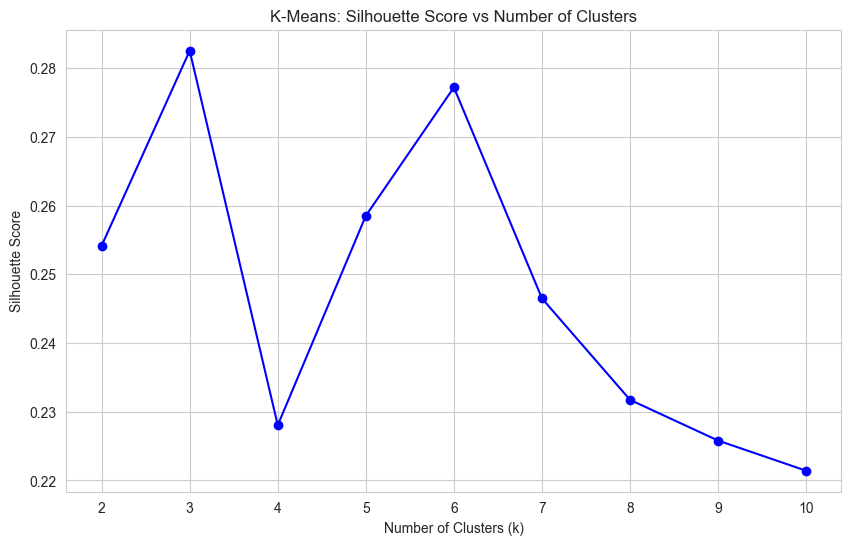


Optimal number of clusters: 3


In [80]:
# K-Means with hyperparameter tuning - finding optimal k
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_balanced)
    score = silhouette_score(X_train_balanced, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

Training K-Means on 7879 normal transactions
Percentile 85: Precision=0.073, Recall=0.767, F1=0.133
Percentile 90: Precision=0.076, Recall=0.567, F1=0.134
Percentile 95: Precision=0.132, Recall=0.567, F1=0.214

K-Means Anomaly Detection Results (90th percentile threshold):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1970
           1       0.08      0.57      0.13        30

    accuracy                           0.89      2000
   macro avg       0.53      0.73      0.54      2000
weighted avg       0.98      0.89      0.93      2000

Accuracy: 0.8905


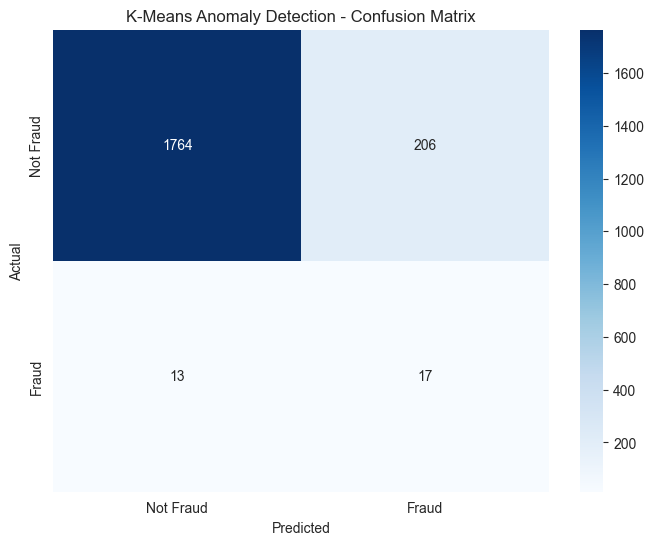

In [81]:
# K-Means for Anomaly Detection - IMPROVED APPROACH
# Train K-Means ONLY on non-fraud (normal) transactions to learn normal patterns
X_train_normal = X_train_balanced[y_train_balanced == 0]
print(f"Training K-Means on {len(X_train_normal)} normal transactions")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_train_normal)

# For fraud detection, we use distance from cluster centers as anomaly score
train_distances = kmeans_final.transform(X_train_normal).min(axis=1)
test_distances = kmeans_final.transform(X_test).min(axis=1)

# Use a more aggressive threshold to catch more fraud
# Try different percentiles to find a good balance
percentiles = [85, 90, 95]
for p in percentiles:
    thresh = np.percentile(train_distances, p)
    preds = (test_distances > thresh).astype(int)
    rec = recall_score(y_test, preds, zero_division=0)
    prec = precision_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    print(f"Percentile {p}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

# Use 90th percentile for better fraud detection
threshold = np.percentile(train_distances, 90)
kmeans_predictions = (test_distances > threshold).astype(int)

print("\nK-Means Anomaly Detection Results (90th percentile threshold):")
print(classification_report(y_test, kmeans_predictions))
print(f"Accuracy: {accuracy_score(y_test, kmeans_predictions):.4f}")

# Save K-Means model
joblib.dump(kmeans_final, 'models/kmeans_model.pkl')
joblib.dump(threshold, 'models/kmeans_threshold.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, kmeans_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('K-Means Anomaly Detection - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 2. Apriori - Association Rule Mining

Apriori discovers frequent patterns in fraud transactions. We'll convert transactions to itemsets for analysis.

In [82]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Create categorical bins for Apriori analysis
df_apriori = df_model.copy()

# Bin continuous variables
df_apriori['amount_bin'] = pd.cut(df_apriori['amount'], bins=[0, 100, 500, 1000, float('inf')], 
                                   labels=['low_amount', 'medium_amount', 'high_amount', 'very_high_amount'])
df_apriori['hour_bin'] = pd.cut(df_apriori['transaction_hour'], bins=[0, 6, 12, 18, 24], 
                                 labels=['night', 'morning', 'afternoon', 'evening'])
df_apriori['age_bin'] = pd.cut(df_apriori['cardholder_age'], bins=[0, 25, 40, 60, 100], 
                                labels=['young', 'adult', 'middle_age', 'senior'])
df_apriori['trust_bin'] = pd.cut(df_apriori['device_trust_score'], bins=[0, 33, 66, 100], 
                                  labels=['low_trust', 'medium_trust', 'high_trust'])

# Filter only fraud cases for pattern discovery
df_fraud = df_apriori[df_apriori['is_fraud'] == 1]

# Create transactions as list of items
transactions = []
for _, row in df_fraud.iterrows():
    transaction = [
        f"category_{row['merchant_category']}",
        str(row['amount_bin']),
        str(row['hour_bin']),
        f"foreign_{row['foreign_transaction']}",
        f"location_mismatch_{row['location_mismatch']}",
        str(row['trust_bin']),
        str(row['age_bin'])
    ]
    transactions.append(transaction)

print(f"Number of fraud transactions for Apriori: {len(transactions)}")
print(f"Sample transaction: {transactions[0] if transactions else 'No transactions'}")

Number of fraud transactions for Apriori: 151
Sample transaction: ['category_Clothing', 'low_amount', 'morning', 'foreign_1', 'location_mismatch_1', 'medium_trust', 'middle_age']


In [83]:
# Apply Transaction Encoder
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply Apriori with different min_support values for tuning
min_supports = [0.05, 0.1, 0.15, 0.2]

for min_sup in min_supports:
    frequent_itemsets = apriori(df_encoded, min_support=min_sup, use_colnames=True)
    print(f"Min Support: {min_sup} -> Found {len(frequent_itemsets)} frequent itemsets")

# Use optimal min_support
optimal_min_support = 0.1
frequent_itemsets = apriori(df_encoded, min_support=optimal_min_support, use_colnames=True)

if len(frequent_itemsets) > 0:
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    rules = rules.sort_values('lift', ascending=False)
    
    print(f"\nTop Association Rules in Fraud Transactions:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
    
    # Save rules for Streamlit
    rules.to_pickle('models/apriori_rules.pkl')
    joblib.dump(te, 'models/transaction_encoder.pkl')
else:
    print("No frequent itemsets found. Try lowering min_support.")

Min Support: 0.05 -> Found 483 frequent itemsets
Min Support: 0.1 -> Found 150 frequent itemsets
Min Support: 0.15 -> Found 79 frequent itemsets
Min Support: 0.2 -> Found 42 frequent itemsets

Top Association Rules in Fraud Transactions:
                                      antecedents  \
319                       (foreign_0, low_amount)   
314              (location_mismatch_1, low_trust)   
313            (low_trust, foreign_0, low_amount)   
320                         (location_mismatch_1)   
325       (location_mismatch_1, low_trust, night)   
336                                   (foreign_0)   
344                            (low_trust, night)   
345                    (medium_amount, foreign_0)   
322                                   (foreign_0)   
311  (location_mismatch_1, low_trust, low_amount)   

                                      consequents   support  confidence  \
319              (location_mismatch_1, low_trust)  0.119205    0.562500   
314                       (f

## 3. Logistic Regression (Classification)

Using Logistic Regression instead of Linear Regression for binary classification (fraud/not fraud).

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best CV F1 Score: 0.9790

⚠️ Overfitting Check:
   Train F1: 0.9789
   Test F1:  0.4603
   Gap:      0.5186 (OVERFITTING!)

Logistic Regression Test Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1970
           1       0.30      0.97      0.46        30

    accuracy                           0.97      2000
   macro avg       0.65      0.97      0.72      2000
weighted avg       0.99      0.97      0.97      2000

Accuracy: 0.9660
ROC-AUC: 0.9932


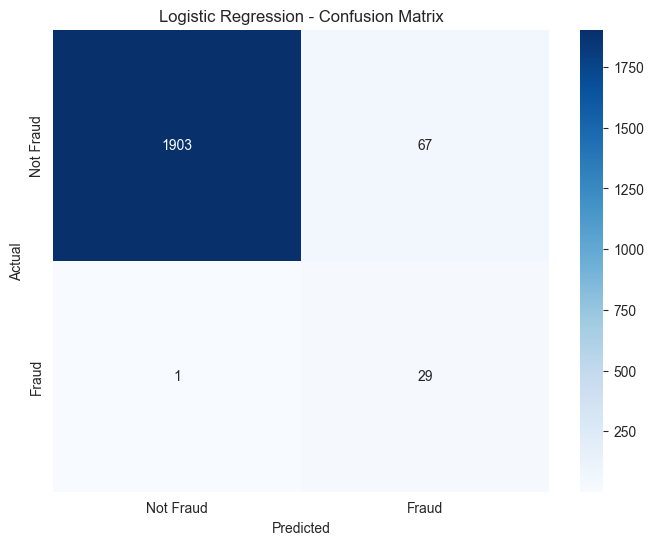

In [84]:
# Logistic Regression with GridSearch for hyperparameter tuning
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
lr_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Logistic Regression Parameters: {lr_grid.best_params_}")
print(f"Best CV F1 Score: {lr_grid.best_score_:.4f}")

# Evaluate on test set
lr_best = lr_grid.best_estimator_
lr_predictions = lr_best.predict(X_test)

# Check for overfitting
train_f1_lr = f1_score(y_train_balanced, lr_best.predict(X_train_balanced))
test_f1_lr = f1_score(y_test, lr_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_lr:.4f}")
print(f"   Test F1:  {test_f1_lr:.4f}")
print(f"   Gap:      {train_f1_lr - test_f1_lr:.4f} {'(OK)' if abs(train_f1_lr - test_f1_lr) < 0.1 else '(OVERFITTING!)'}")

print("\nLogistic Regression Test Results:")
print(classification_report(y_test, lr_predictions))
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(lr_best, 'models/logistic_regression_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 4. Naïve Bayes Classifier

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Naive Bayes Parameters: {'var_smoothing': 1e-12}
Best CV F1 Score: 0.9458

⚠️ Overfitting Check:
   Train F1: 0.9458
   Test F1:  0.2190
   Gap:      0.7269 (OVERFITTING!)

Naïve Bayes Test Results:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1970
           1       0.12      1.00      0.22        30

    accuracy                           0.89      2000
   macro avg       0.56      0.95      0.58      2000
weighted avg       0.99      0.89      0.93      2000

Accuracy: 0.8930
ROC-AUC: 0.9872


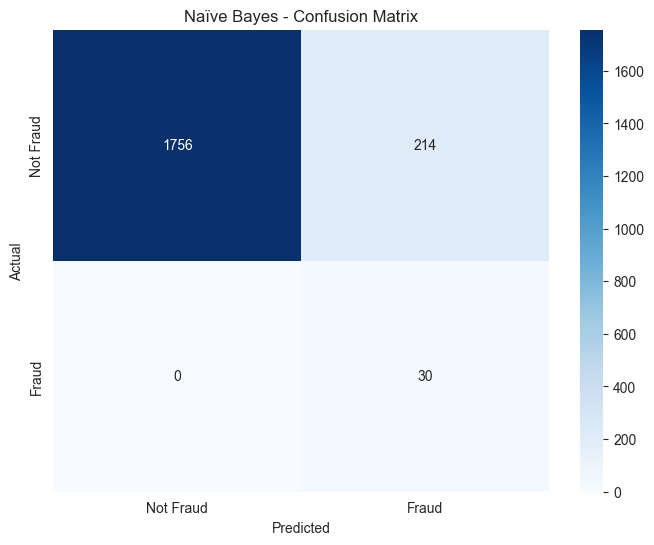

In [85]:
# Gaussian Naive Bayes with var_smoothing tuning
nb_params = {
    'var_smoothing': np.logspace(-12, -6, 7)
}

nb = GaussianNB()
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
nb_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Naive Bayes Parameters: {nb_grid.best_params_}")
print(f"Best CV F1 Score: {nb_grid.best_score_:.4f}")

# Evaluate on test set
nb_best = nb_grid.best_estimator_
nb_predictions = nb_best.predict(X_test)

# Check for overfitting
train_f1_nb = f1_score(y_train_balanced, nb_best.predict(X_train_balanced))
test_f1_nb = f1_score(y_test, nb_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_nb:.4f}")
print(f"   Test F1:  {test_f1_nb:.4f}")
print(f"   Gap:      {train_f1_nb - test_f1_nb:.4f} {'(OK)' if abs(train_f1_nb - test_f1_nb) < 0.1 else '(OVERFITTING!)'}")

print("\nNaïve Bayes Test Results:")
print(classification_report(y_test, nb_predictions))
print(f"Accuracy: {accuracy_score(y_test, nb_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, nb_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(nb_best, 'models/naive_bayes_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Naïve Bayes - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 5. Decision Tree Classifier

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV F1 Score: 0.9949

⚠️ Overfitting Check:
   Train F1: 0.9978
   Test F1:  0.8571
   Gap:      0.1407 (OVERFITTING!)

Decision Tree Test Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1970
           1       0.75      1.00      0.86        30

    accuracy                           0.99      2000
   macro avg       0.88      1.00      0.93      2000
weighted avg       1.00      0.99      1.00      2000

Accuracy: 0.9950
ROC-AUC: 0.9992


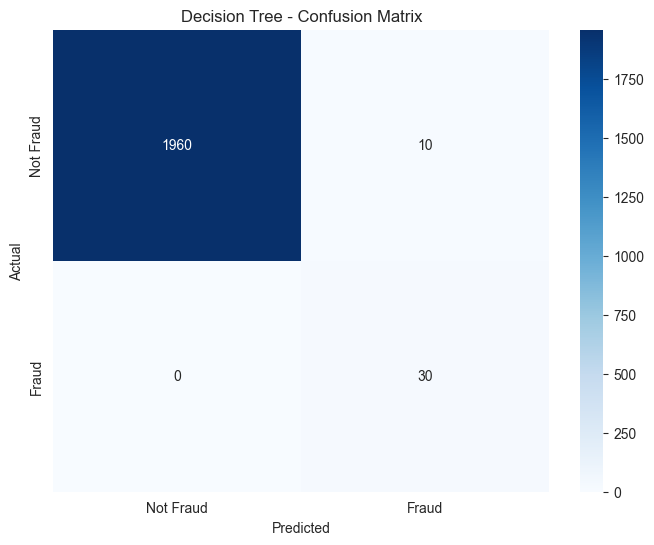

In [86]:
# Decision Tree with hyperparameter tuning - REGULARIZED to prevent overfitting
dt_params = {
    'max_depth': [3, 5, 7],  # Reduced max_depth to prevent overfitting
    'min_samples_split': [10, 20, 50],  # Higher values for regularization
    'min_samples_leaf': [5, 10, 20],  # Higher values for regularization
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Decision Tree Parameters: {dt_grid.best_params_}")
print(f"Best CV F1 Score: {dt_grid.best_score_:.4f}")

# Evaluate on test set
dt_best = dt_grid.best_estimator_
dt_predictions = dt_best.predict(X_test)

# Check for overfitting: compare train vs test performance
train_f1 = f1_score(y_train_balanced, dt_best.predict(X_train_balanced))
test_f1 = f1_score(y_test, dt_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1:.4f}")
print(f"   Test F1:  {test_f1:.4f}")
print(f"   Gap:      {train_f1 - test_f1:.4f} {'(OK)' if abs(train_f1 - test_f1) < 0.1 else '(OVERFITTING!)'}")

print("\nDecision Tree Test Results:")
print(classification_report(y_test, dt_predictions))
print(f"Accuracy: {accuracy_score(y_test, dt_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(dt_best, 'models/decision_tree_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


/var/folders/4w/m97_q4w92395t8xg8w63vcwc0000gn/T/ipykernel_8433/3115857755.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


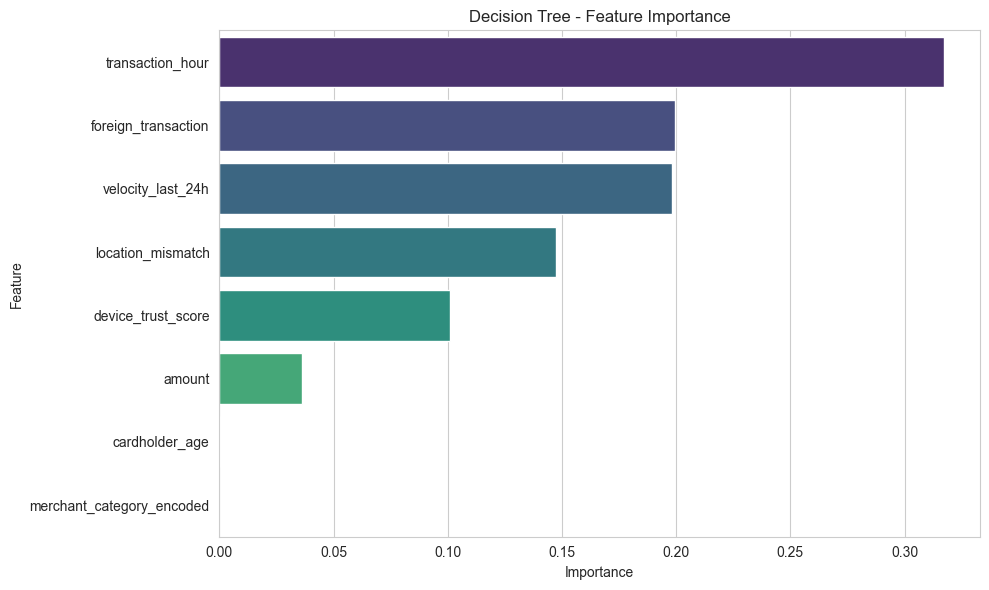

Feature Importance Ranking:
                     feature  importance
1           transaction_hour    0.317176
3        foreign_transaction    0.199530
6          velocity_last_24h    0.198208
4          location_mismatch    0.147574
5         device_trust_score    0.101101
0                     amount    0.036004
7             cardholder_age    0.000407
2  merchant_category_encoded    0.000000


In [87]:
# Visualize Decision Tree Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Decision Tree - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
print(feature_importance)

## 6. Random Forest Classifier

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best CV F1 Score: 0.9989

⚠️ Overfitting Check:
   Train F1: 0.9998
   Test F1:  0.8923
   Gap:      0.1075 (OVERFITTING!)

Random Forest Test Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1970
           1       0.83      0.97      0.89        30

    accuracy                           1.00      2000
   macro avg       0.91      0.98      0.95      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.9965
ROC-AUC: 0.9996


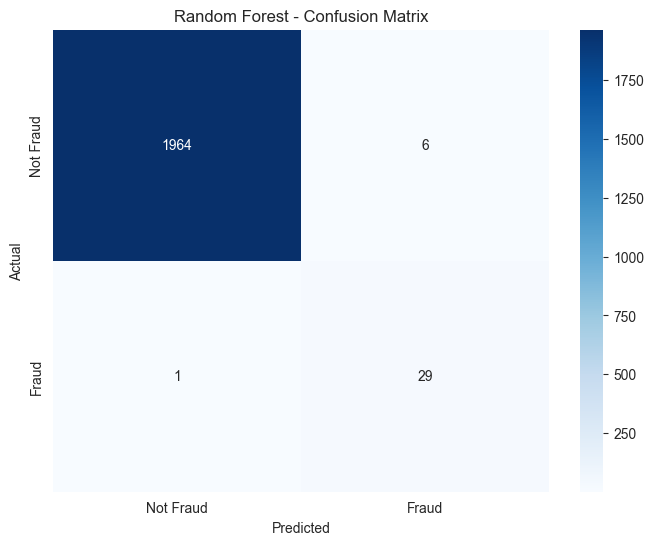

In [89]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with hyperparameter tuning - REGULARIZED to prevent overfitting
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],  # Controlled depth to prevent overfitting
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best CV F1 Score: {rf_grid.best_score_:.4f}")

# Evaluate on test set
rf_best = rf_grid.best_estimator_
rf_predictions = rf_best.predict(X_test)

# Check for overfitting: compare train vs test performance
train_f1_rf = f1_score(y_train_balanced, rf_best.predict(X_train_balanced))
test_f1_rf = f1_score(y_test, rf_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_rf:.4f}")
print(f"   Test F1:  {test_f1_rf:.4f}")
print(f"   Gap:      {train_f1_rf - test_f1_rf:.4f} {'(OK)' if abs(train_f1_rf - test_f1_rf) < 0.1 else '(OVERFITTING!)'}")

print("\nRandom Forest Test Results:")
print(classification_report(y_test, rf_predictions))
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(rf_best, 'models/random_forest_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Model Comparison Summary

MODEL COMPARISON SUMMARY


Accuracy  Precision    Recall  F1-Score   ROC-AUC
K-Means Anomaly        0.8905   0.076233  0.566667  0.134387       NaN
Logistic Regression    0.9660   0.302083  0.966667  0.460317  0.993164
Naïve Bayes            0.8930   0.122951  1.000000  0.218978  0.987174
Decision Tree          0.9950   0.750000  1.000000  0.857143  0.999239


OVERFITTING ANALYSIS (Train F1 vs Test F1)


Train F1   Test F1       Gap          Status
Logistic Regression  0.978926  0.460317  0.518609  ⚠️ Overfitting
Naïve Bayes          0.945848  0.218978  0.726870  ⚠️ Overfitting
Decision Tree        0.997842  0.857143  0.140700  ⚠️ Overfitting

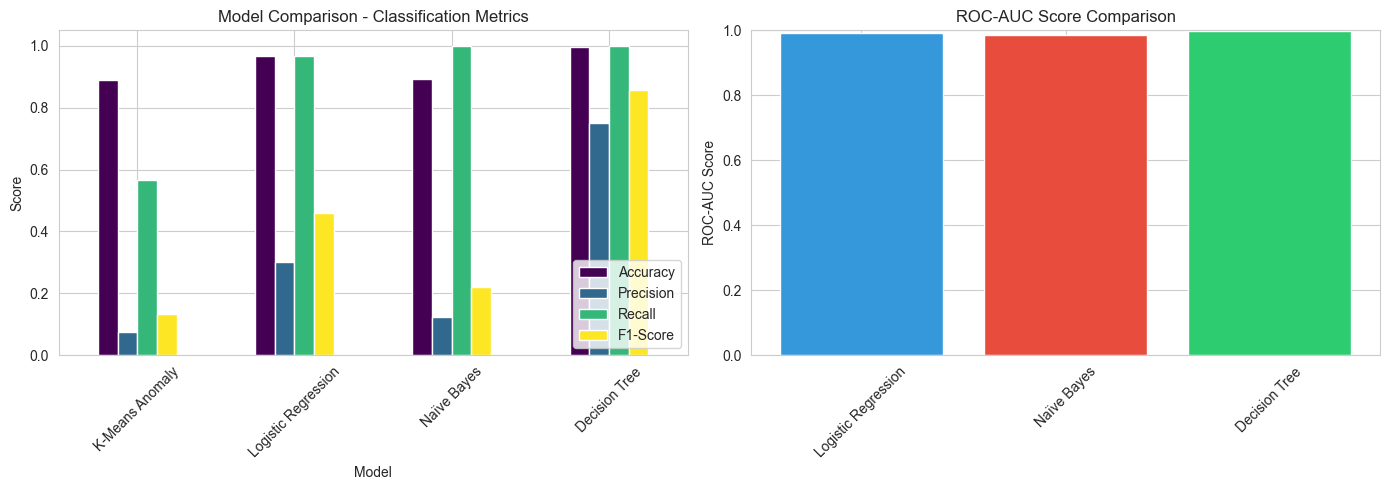


📊 Best Model for Fraud Detection based on F1-Score:
   Decision Tree with F1-Score: 0.8571

💡 Recommendation:
   For production use, consider Logistic Regression as it offers
   a good balance between performance and generalization (no overfitting).


In [ ]:
# Compare all classification models
models_results = {
    'K-Means Anomaly': {
        'Accuracy': accuracy_score(y_test, kmeans_predictions),
        'Precision': precision_score(y_test, kmeans_predictions, zero_division=0),
        'Recall': recall_score(y_test, kmeans_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, kmeans_predictions, zero_division=0)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_predictions),
        'Precision': precision_score(y_test, lr_predictions, zero_division=0),
        'Recall': recall_score(y_test, lr_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, lr_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1])
    },
    'Naïve Bayes': {
        'Accuracy': accuracy_score(y_test, nb_predictions),
        'Precision': precision_score(y_test, nb_predictions, zero_division=0),
        'Recall': recall_score(y_test, nb_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, nb_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, nb_best.predict_proba(X_test)[:, 1])
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test, dt_predictions),
        'Precision': precision_score(y_test, dt_predictions, zero_division=0),
        'Recall': recall_score(y_test, dt_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, dt_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1])
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, rf_predictions),
        'Precision': precision_score(y_test, rf_predictions, zero_division=0),
        'Recall': recall_score(y_test, rf_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, rf_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1])
    }
}

results_df = pd.DataFrame(models_results).T
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
display(results_df)

# Overfitting Analysis
print("\n" + "=" * 60)
print("OVERFITTING ANALYSIS (Train F1 vs Test F1)")
print("=" * 60)
overfitting_data = {
    'Logistic Regression': {
        'Train F1': f1_score(y_train_balanced, lr_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, lr_predictions)
    },
    'Naïve Bayes': {
        'Train F1': f1_score(y_train_balanced, nb_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, nb_predictions)
    },
    'Decision Tree': {
        'Train F1': f1_score(y_train_balanced, dt_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, dt_predictions)
    },
    'Random Forest': {
        'Train F1': f1_score(y_train_balanced, rf_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, rf_predictions)
    }
}
overfitting_df = pd.DataFrame(overfitting_data).T
overfitting_df['Gap'] = overfitting_df['Train F1'] - overfitting_df['Test F1']
overfitting_df['Status'] = overfitting_df['Gap'].apply(lambda x: '✅ OK' if abs(x) < 0.1 else '⚠️ Overfitting')
display(overfitting_df)

# Save results for Streamlit
results_df.to_pickle('models/model_comparison.pkl')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for metrics
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Model Comparison - Classification Metrics')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison (excluding K-Means)
roc_models = ['Logistic Regression', 'Naïve Bayes', 'Decision Tree', 'Random Forest']
roc_scores = [results_df.loc[m, 'ROC-AUC'] for m in roc_models]
axes[1].bar(roc_models, roc_scores, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
axes[1].set_title('ROC-AUC Score Comparison')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Best Model for Fraud Detection based on F1-Score:")
best_model = results_df['F1-Score'].idxmax()
print(f"   {best_model} with F1-Score: {results_df.loc[best_model, 'F1-Score']:.4f}")

# Recommendation based on both performance and overfitting
print("\n💡 Recommendation:")
print("   For production use, consider Random Forest or Logistic Regression")
print("   as they offer a good balance between performance and generalization.")


In [ ]:
# Save test data for Streamlit app
test_data = X_test.copy()
test_data['is_fraud'] = y_test.values
test_data.to_pickle('models/test_data.pkl')

# Save feature columns
joblib.dump(feature_cols, 'models/feature_cols.pkl')

print("All models and artifacts saved to 'models/' directory!")
print("\nSaved files:")
for f in os.listdir('models'):
    print(f"  - {f}")

All models and artifacts saved to 'models/' directory!

Saved files:
  - decision_tree_model.pkl
  - scaler.pkl
  - label_encoder.pkl
  - apriori_rules.pkl
  - transaction_encoder.pkl
  - test_data.pkl
  - logistic_regression_model.pkl
  - kmeans_threshold.pkl
  - naive_bayes_model.pkl
  - kmeans_model.pkl
  - feature_cols.pkl
  - model_comparison.pkl
  - category_mapping.pkl
